<a href="https://colab.research.google.com/github/prasadmlexpert/objectidentificationvideo/blob/main/yolov4pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --upgrade opencv-python>4.5.5.64

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as  np
import cv2

In [3]:
cv2.__version__

'4.6.0'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class_labels = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
                "trafficlight","firehydrant","stopsign","parkingmeter","bench","bird","cat",
                "dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack",
                "umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball",
                "kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket",
                "bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple",
                "sandwich","orange","broccoli","carrot","hotdog","pizza","donut","cake","chair",
                "sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse",
                "remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator",
                "book","clock","vase","scissors","teddybear","hairdrier","toothbrush"]

In [6]:
#declare List of colors as array
class_colors = ["0,255,0","0,0,255","255,0,0","255,255,0","0,255,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)
class_colors = np.tile(class_colors,(16,1))

In [18]:
%cd "/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work/"

/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work


In [ ]:
!ls images/10k/train|less

0004a4c0-d4dff0ad.jpg
00054602-3bf57337.jpg
00067cfb-e535423e.jpg
00091078-59817bb0.jpg
0010bf16-a457685b.jpg
001b428f-059bac33.jpg
001c2a14-c7138401.jpg
0024b742-acbefa1a.jpg
0027eed2-09c90000.jpg
0027eed2-09c90001.jpg
0027eed2-60fb0001.jpg
0027eed2-815a0000.jpg
0027eed2-815a0001.jpg
0027eed2-a6630000.jpg
0027eed2-a6630001.jpg
002a3213-ab7f6730.jpg
002bf392-acddbad2.jpg
002d467e-00000000.jpg
003571f2-f2848ebd.jpg
003ddde7-36ee8299.jpg
004071a4-049be89b.jpg
00495359-1d04dd8a.jpg
004af474-00000000.jpg
>8

In [19]:
img_to_detect = cv2.imread('images/10k/train/0027eed2-09c90001.jpg')
img_height = img_to_detect.shape[0]
img_width = img_to_detect.shape[1]

In [20]:
img_blob = cv2.dnn.blobFromImage(img_to_detect, 0.003922, (416, 416), swapRB=True, crop=False)

### Loading pretrained model 
### input preprocessed blob into model and pass through the model
### obtain the detection predictions by the model using forward() method

In [21]:
yolo_model = cv2.dnn.readNetFromDarknet("dataset/yolov4.cfg","dataset/yolov4.weights")

In [22]:
# Get all layers from the yolo network
# Loop and find the last layer (output layer) of the yolo network 
yolo_layers = yolo_model.getLayerNames()
yolo_output_layer = [yolo_layers[yolo_layer - 1] for yolo_layer in yolo_model.getUnconnectedOutLayers()]


In [23]:
# input preprocessed blob into model and pass through the model
yolo_model.setInput(img_blob)
# obtain the detection layers by forwarding through till the output layer
obj_detection_layers = yolo_model.forward(yolo_output_layer)



In [24]:
class_ids_list = []
boxes_list = []
confidences_list = []

In [25]:
# loop over each of the layer outputs
for object_detection_layer in obj_detection_layers:
	# loop over the detections
    for object_detection in object_detection_layer:
        
        # obj_detections[1 to 4] => will have the two center points, box width and box height
        # obj_detections[5] => will have scores for all objects within bounding box
        all_scores = object_detection[5:]
        predicted_class_id = np.argmax(all_scores)
        prediction_confidence = all_scores[predicted_class_id]
    
        # take only predictions with confidence more than 50%
        if prediction_confidence > 0.50:

            #obtain the bounding box co-oridnates for actual image from resized image size
            bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
            (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
            start_x_pt = int(box_center_x_pt - (box_width / 2))
            start_y_pt = int(box_center_y_pt - (box_height / 2))
            
            
            ############## NMS Change 2 ###############
            #save class id, start x, y, width & height, confidences in a list for nms processing
            #make sure to pass confidence as float and width and height as integers
            class_ids_list.append(predicted_class_id)
            confidences_list.append(float(prediction_confidence))
            boxes_list.append([start_x_pt, start_y_pt, int(box_width), int(box_height)])
            ############## NMS Change 2 END ###########


In [15]:
!mkdir detections
%cd detections

mkdir: cannot create directory ‘detections’: File exists
/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work/detections


In [26]:
############## NMS Change 3 ###############
# Applying the NMS will return only the selected max value ids while suppressing the non maximum (weak) overlapping bounding boxes      
# Non-Maxima Suppression confidence set as 0.5 & max_suppression threhold for NMS as 0.4 (adjust and try for better perfomance)
max_value_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.2, 0.4)

# loop through the final set of detections remaining after NMS and draw bounding box and write text
f = open('results.txt', 'a')
for max_valueid in max_value_ids:
    max_class_id = max_valueid
    box = boxes_list[max_class_id]
    start_x_pt = box[0]
    start_y_pt = box[1]
    box_width = box[2]
    box_height = box[3]
    
    #get the predicted class id and label
    predicted_class_id = class_ids_list[max_class_id]
    print(max_class_id)
    print(predicted_class_id)
    predicted_class_label = class_labels[predicted_class_id]
    print(predicted_class_label)
    prediction_confidence = confidences_list[max_class_id]
    print(prediction_confidence)
    ############## NMS Change 3 END ###########

    
    #obtain the bounding box end co-oridnates
    end_x_pt = start_x_pt + box_width
    end_y_pt = start_y_pt + box_height
    
    #get a random mask color from the numpy array of colors
    box_color = class_colors[predicted_class_id]
    
    #convert the color numpy array as a list and apply to text and box
    box_color = [int(c) for c in box_color]
    
    # print the prediction in console
    predicted_class_label = "{}: {:.2f}%".format(predicted_class_label, prediction_confidence * 100)
    print("predicted object {}".format(predicted_class_label))
    
    # draw rectangle and text in the image
    cv2.rectangle(img_to_detect, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 1)
    cv2.putText(img_to_detect, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)

    f.write( "predicted object {}".format(predicted_class_label) +"\n")
f.close()



20
7
truck
0.9528483152389526
predicted object truck: 95.28%
13
2
car
0.9352132081985474
predicted object car: 93.52%
6
2
car
0.7880861163139343
predicted object car: 78.81%
10
2
car
0.7563311457633972
predicted object car: 75.63%
9
2
car
0.633474588394165
predicted object car: 63.35%
0
9
trafficlight
0.6102102398872375
predicted object trafficlight: 61.02%
12
2
car
0.5309540629386902
predicted object car: 53.10%


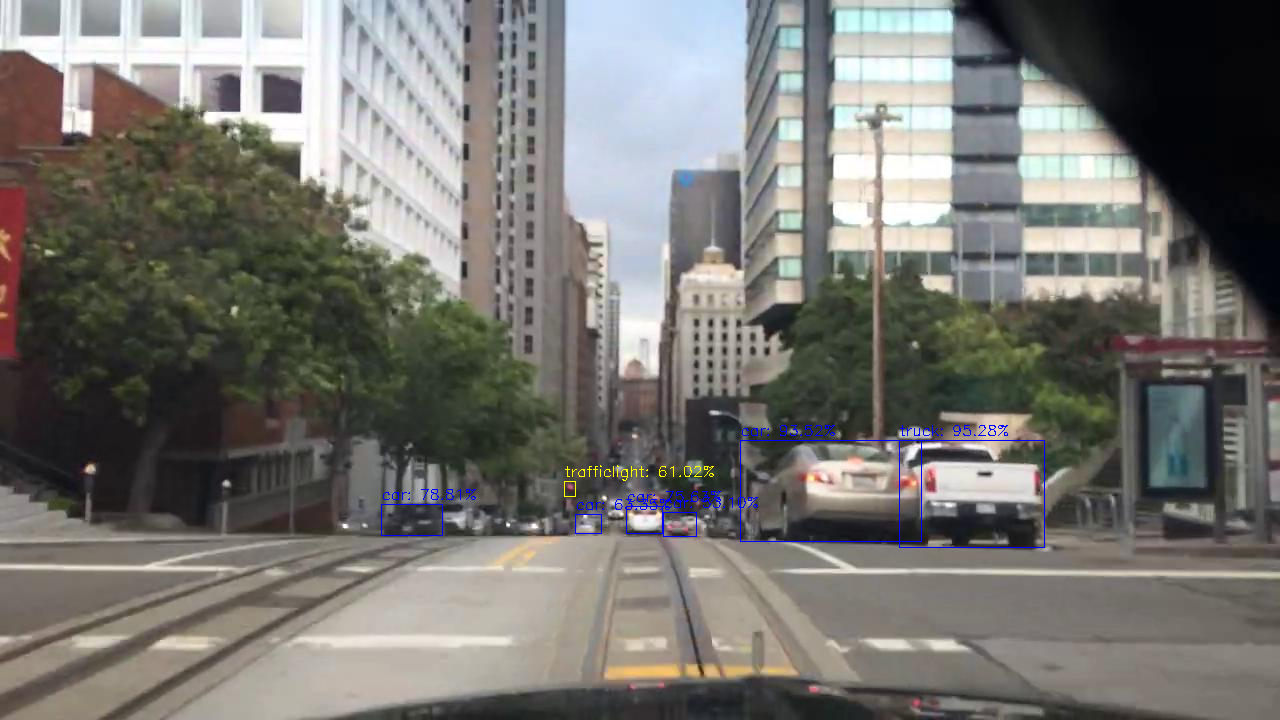

True

In [27]:
from google.colab.patches import cv2_imshow
cv2_imshow(img_to_detect)
cv2.imwrite("results.jpg", img_to_detect)

In [11]:
import json
import os
from tqdm import tqdm
import cv2

counter = {'car': 0, 'truck': 1, 'bus': 2, 'train': 3, 'person': 4, 'rider': 5, 'traffic sign': 6, 'traffic light': 7, 'motorcycle': 8, 'pedestrian': 9, 'bicycle': 10, 'other vehicle': 11, 'trailer': 12, 'other person': 13}


def classify_classes(c_name):
    vehicle = ["car", "truck", "bus", "train"]
    if c_name in vehicle:
        return 0
    else:
        return 1


def convert2yolo_roi(img_name, obj):

    obj_name = obj["category"]
    obj_class = counter[obj_name]
    obj_roi = obj['box2d']

    img = cv2.imread(img_name)
    img_w, img_h = img.shape[1], img.shape[0]

    w = (obj_roi["x2"] - obj_roi["x1"])
    h = (obj_roi["y2"] - obj_roi["y1"])
    x = (obj_roi["x1"] + w/2)
    y = (obj_roi["y1"] + h/2)

    x, y, w, h = x/img_w, y/img_h, w/img_w, h/img_h

    return "{} {} {} {} {}\n".format(obj_class, x, y, w, h)

def yoloconverter(imgRootPath,labelPath):
    with open(labelPath) as labelFile:
        lines = json.load(labelFile)

    lastidentifier = 5

    for line in tqdm(lines):
        name = line['name']
        imgPath = imgRootPath + name
        txtPath = imgPath.replace("jpg", "txt")
        if not os.path.isfile(imgPath):
            continue
        with open(txtPath, "w")as file:
            if 'labels' in line.keys():
                labels = line['labels']
                for label in labels:
                    category = label["category"]
                    if category in counter.keys():
                        file.write(convert2yolo_roi(imgPath, label))
                    else:
                        lastidentifier +=1
                        counter[category] = lastidentifier
                        file.write(convert2yolo_roi(imgPath, label))
                        print(txtPath)
                        print(counter)

        print("line_num : {}".format(len(lines)))
  

In [12]:
%cd "/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work/"

/content/drive/.shortcut-targets-by-id/16kphvlmJsL1izzffpLfadthz0YrraYkW/ImageIdetificationProject/Project_work


In [13]:
if __name__ == '__main__':
    imgRootPath = "./bdd100k/images/val/"
    labelPath = "./bdd100k/labels/det_val.json"
    yoloconverter(imgRootPath,labelPath)

  0%|          | 1/10000 [00:00<1:13:56,  2.25it/s]

line_num : 10000
line_num : 10000


  0%|          | 3/10000 [00:00<32:36,  5.11it/s]  

line_num : 10000


  0%|          | 4/10000 [00:00<35:33,  4.69it/s]

line_num : 10000


  0%|          | 5/10000 [00:01<46:53,  3.55it/s]

line_num : 10000
line_num : 10000


  0%|          | 7/10000 [00:01<36:14,  4.59it/s]

line_num : 10000


  0%|          | 9/10000 [00:02<33:59,  4.90it/s]

line_num : 10000
line_num : 10000


  0%|          | 11/10000 [00:02<30:58,  5.38it/s]

line_num : 10000
line_num : 10000
line_num : 10000


  0%|          | 13/10000 [00:02<29:29,  5.64it/s]

line_num : 10000


  0%|          | 14/10000 [00:02<30:51,  5.39it/s]

line_num : 10000


  0%|          | 15/10000 [00:03<33:18,  5.00it/s]

line_num : 10000


  0%|          | 16/10000 [00:03<36:47,  4.52it/s]

line_num : 10000


  0%|          | 17/10000 [00:03<48:33,  3.43it/s]

line_num : 10000


  0%|          | 18/10000 [00:04<52:13,  3.19it/s]

line_num : 10000


  0%|          | 19/10000 [00:04<52:43,  3.15it/s]

line_num : 10000


  0%|          | 20/10000 [00:05<59:03,  2.82it/s]

line_num : 10000


  0%|          | 21/10000 [00:05<57:58,  2.87it/s]

line_num : 10000


  0%|          | 22/10000 [00:05<56:49,  2.93it/s]

line_num : 10000


  0%|          | 23/10000 [00:05<53:19,  3.12it/s]

line_num : 10000


  0%|          | 25/10000 [00:06<44:21,  3.75it/s]

line_num : 10000
line_num : 10000


  0%|          | 26/10000 [00:06<57:29,  2.89it/s]

line_num : 10000


  0%|          | 28/10000 [00:07<47:47,  3.48it/s]

line_num : 10000
line_num : 10000


  0%|          | 30/10000 [00:07<37:04,  4.48it/s]

line_num : 10000
line_num : 10000


  0%|          | 32/10000 [00:08<39:56,  4.16it/s]

line_num : 10000
line_num : 10000


  0%|          | 34/10000 [00:08<36:39,  4.53it/s]

line_num : 10000
line_num : 10000


  0%|          | 35/10000 [00:09<43:56,  3.78it/s]

line_num : 10000
line_num : 10000


  0%|          | 39/10000 [00:09<24:48,  6.69it/s]

line_num : 10000
line_num : 10000
line_num : 10000
line_num : 10000


  0%|          | 42/10000 [00:09<22:05,  7.51it/s]

line_num : 10000
line_num : 10000


  0%|          | 43/10000 [00:09<22:34,  7.35it/s]

line_num : 10000
line_num : 10000


  0%|          | 45/10000 [00:10<25:17,  6.56it/s]

line_num : 10000


  0%|          | 46/10000 [00:10<28:17,  5.87it/s]

line_num : 10000


  0%|          | 47/10000 [00:10<36:17,  4.57it/s]

line_num : 10000


  0%|          | 48/10000 [00:11<37:00,  4.48it/s]

line_num : 10000


  0%|          | 49/10000 [00:11<50:45,  3.27it/s]

line_num : 10000


  0%|          | 50/10000 [00:12<55:19,  3.00it/s]

line_num : 10000


  1%|          | 51/10000 [00:12<1:00:44,  2.73it/s]

line_num : 10000


  1%|          | 52/10000 [00:13<1:07:39,  2.45it/s]

line_num : 10000


  1%|          | 53/10000 [00:13<1:07:14,  2.47it/s]

line_num : 10000


  1%|          | 54/10000 [00:14<1:16:30,  2.17it/s]

line_num : 10000


  1%|          | 55/10000 [00:14<1:14:38,  2.22it/s]

line_num : 10000


  1%|          | 56/10000 [00:14<1:13:17,  2.26it/s]

line_num : 10000


  1%|          | 57/10000 [00:15<1:17:16,  2.14it/s]

line_num : 10000


  1%|          | 58/10000 [00:15<1:17:08,  2.15it/s]

line_num : 10000


  1%|          | 59/10000 [00:16<1:12:41,  2.28it/s]

line_num : 10000


  1%|          | 60/10000 [00:16<1:16:37,  2.16it/s]

line_num : 10000


  1%|          | 61/10000 [00:17<1:12:17,  2.29it/s]

line_num : 10000


  1%|          | 62/10000 [00:17<1:14:45,  2.22it/s]

line_num : 10000


  1%|          | 63/10000 [00:18<1:14:17,  2.23it/s]

line_num : 10000


  1%|          | 64/10000 [00:18<1:15:33,  2.19it/s]

line_num : 10000


  1%|          | 65/10000 [00:19<1:16:34,  2.16it/s]

line_num : 10000


  1%|          | 66/10000 [00:19<1:14:10,  2.23it/s]

line_num : 10000


  1%|          | 67/10000 [00:19<1:08:24,  2.42it/s]

line_num : 10000


  1%|          | 68/10000 [00:20<1:10:08,  2.36it/s]

line_num : 10000


  1%|          | 69/10000 [00:21<1:29:34,  1.85it/s]

line_num : 10000


  1%|          | 70/10000 [00:21<1:24:48,  1.95it/s]

line_num : 10000


  1%|          | 71/10000 [00:21<1:18:20,  2.11it/s]

line_num : 10000


  1%|          | 72/10000 [00:22<1:22:39,  2.00it/s]

line_num : 10000


  1%|          | 73/10000 [00:23<1:27:51,  1.88it/s]

line_num : 10000


  1%|          | 74/10000 [00:23<1:23:26,  1.98it/s]

line_num : 10000


  1%|          | 75/10000 [00:24<1:25:57,  1.92it/s]

line_num : 10000


  1%|          | 76/10000 [00:24<1:15:55,  2.18it/s]

line_num : 10000


  1%|          | 77/10000 [00:25<1:24:47,  1.95it/s]

line_num : 10000


  1%|          | 78/10000 [00:25<1:20:20,  2.06it/s]

line_num : 10000


  1%|          | 79/10000 [00:25<1:13:32,  2.25it/s]

line_num : 10000


  1%|          | 80/10000 [00:26<1:11:03,  2.33it/s]

line_num : 10000


  1%|          | 81/10000 [00:26<1:12:53,  2.27it/s]

line_num : 10000


  1%|          | 82/10000 [00:27<1:13:47,  2.24it/s]

line_num : 10000


  1%|          | 83/10000 [00:27<1:08:32,  2.41it/s]

line_num : 10000


  1%|          | 84/10000 [00:27<1:07:21,  2.45it/s]

line_num : 10000


  1%|          | 85/10000 [00:28<1:08:51,  2.40it/s]

line_num : 10000


  1%|          | 86/10000 [00:28<59:46,  2.76it/s]  

line_num : 10000


  1%|          | 87/10000 [00:29<1:08:09,  2.42it/s]

line_num : 10000


  1%|          | 88/10000 [00:30<1:39:29,  1.66it/s]

line_num : 10000


  1%|          | 89/10000 [00:30<1:27:06,  1.90it/s]

line_num : 10000


  1%|          | 90/10000 [00:30<1:24:11,  1.96it/s]

line_num : 10000


  1%|          | 91/10000 [00:31<1:24:20,  1.96it/s]

line_num : 10000


  1%|          | 92/10000 [00:31<1:11:52,  2.30it/s]

line_num : 10000


  1%|          | 93/10000 [00:32<1:27:09,  1.89it/s]

line_num : 10000


  1%|          | 94/10000 [00:32<1:13:57,  2.23it/s]

line_num : 10000


  1%|          | 95/10000 [00:33<1:22:38,  2.00it/s]

line_num : 10000


  1%|          | 96/10000 [00:33<1:23:32,  1.98it/s]

line_num : 10000


  1%|          | 97/10000 [00:34<1:14:50,  2.21it/s]

line_num : 10000


  1%|          | 98/10000 [00:34<1:18:40,  2.10it/s]

line_num : 10000


  1%|          | 99/10000 [00:35<1:23:22,  1.98it/s]

line_num : 10000


  1%|          | 100/10000 [00:35<1:16:40,  2.15it/s]

line_num : 10000


  1%|          | 101/10000 [00:36<1:12:45,  2.27it/s]

line_num : 10000


  1%|          | 102/10000 [00:36<1:18:20,  2.11it/s]

line_num : 10000


  1%|          | 103/10000 [00:37<1:20:44,  2.04it/s]

line_num : 10000


  1%|          | 104/10000 [00:37<1:21:15,  2.03it/s]

line_num : 10000


  1%|          | 105/10000 [00:38<1:29:20,  1.85it/s]

line_num : 10000


  1%|          | 106/10000 [00:38<1:19:04,  2.09it/s]

line_num : 10000


  1%|          | 107/10000 [00:39<1:22:17,  2.00it/s]

line_num : 10000


  1%|          | 108/10000 [00:39<1:20:31,  2.05it/s]

line_num : 10000


  1%|          | 109/10000 [00:39<1:12:41,  2.27it/s]

line_num : 10000


  1%|          | 110/10000 [00:40<1:11:47,  2.30it/s]

line_num : 10000


  1%|          | 111/10000 [00:40<1:20:03,  2.06it/s]

line_num : 10000


  1%|          | 112/10000 [00:41<1:16:38,  2.15it/s]

line_num : 10000


  1%|          | 113/10000 [00:41<1:15:02,  2.20it/s]

line_num : 10000


  1%|          | 114/10000 [00:42<1:26:12,  1.91it/s]

line_num : 10000


  1%|          | 115/10000 [00:42<1:20:14,  2.05it/s]

line_num : 10000


  1%|          | 116/10000 [00:43<1:22:38,  1.99it/s]

line_num : 10000


  1%|          | 117/10000 [00:43<1:20:24,  2.05it/s]

line_num : 10000


  1%|          | 118/10000 [00:44<1:29:18,  1.84it/s]

line_num : 10000


  1%|          | 119/10000 [00:45<1:32:35,  1.78it/s]

line_num : 10000


  1%|          | 120/10000 [00:45<1:31:33,  1.80it/s]

line_num : 10000


  1%|          | 121/10000 [00:46<1:29:37,  1.84it/s]

line_num : 10000


  1%|          | 122/10000 [00:46<1:29:39,  1.84it/s]

line_num : 10000


  1%|          | 123/10000 [00:47<1:19:19,  2.08it/s]

line_num : 10000


  1%|          | 124/10000 [00:47<1:19:12,  2.08it/s]

line_num : 10000


  1%|▏         | 125/10000 [00:48<1:26:06,  1.91it/s]

line_num : 10000


  1%|▏         | 126/10000 [00:48<1:19:27,  2.07it/s]

line_num : 10000


  1%|▏         | 127/10000 [00:49<1:19:33,  2.07it/s]

line_num : 10000


  1%|▏         | 128/10000 [00:49<1:11:59,  2.29it/s]

line_num : 10000


  1%|▏         | 129/10000 [00:49<1:06:13,  2.48it/s]

line_num : 10000


  1%|▏         | 130/10000 [00:49<58:49,  2.80it/s]  

line_num : 10000


  1%|▏         | 131/10000 [00:50<56:48,  2.90it/s]

line_num : 10000


  1%|▏         | 132/10000 [00:50<1:08:54,  2.39it/s]

line_num : 10000


  1%|▏         | 133/10000 [00:51<1:07:52,  2.42it/s]

line_num : 10000


  1%|▏         | 134/10000 [00:51<1:14:39,  2.20it/s]

line_num : 10000


  1%|▏         | 135/10000 [00:52<1:18:35,  2.09it/s]

line_num : 10000


  1%|▏         | 136/10000 [00:52<1:19:20,  2.07it/s]

line_num : 10000


  1%|▏         | 137/10000 [00:53<1:12:56,  2.25it/s]

line_num : 10000


  1%|▏         | 138/10000 [00:53<1:13:09,  2.25it/s]

line_num : 10000


  1%|▏         | 139/10000 [00:53<1:06:41,  2.46it/s]

line_num : 10000


  1%|▏         | 140/10000 [00:54<1:08:54,  2.38it/s]

line_num : 10000


  1%|▏         | 141/10000 [00:54<1:12:09,  2.28it/s]

line_num : 10000


  1%|▏         | 142/10000 [00:55<1:23:04,  1.98it/s]

line_num : 10000


  1%|▏         | 143/10000 [00:56<1:23:17,  1.97it/s]

line_num : 10000


  1%|▏         | 144/10000 [00:56<1:23:33,  1.97it/s]

line_num : 10000


  1%|▏         | 145/10000 [00:57<1:24:42,  1.94it/s]

line_num : 10000


  1%|▏         | 146/10000 [00:57<1:21:13,  2.02it/s]

line_num : 10000


  1%|▏         | 147/10000 [00:57<1:12:54,  2.25it/s]

line_num : 10000


  1%|▏         | 148/10000 [00:58<1:05:12,  2.52it/s]

line_num : 10000


  1%|▏         | 149/10000 [00:58<1:14:42,  2.20it/s]

line_num : 10000


  2%|▏         | 150/10000 [00:59<1:14:02,  2.22it/s]

line_num : 10000


  2%|▏         | 151/10000 [00:59<1:23:17,  1.97it/s]

line_num : 10000


  2%|▏         | 152/10000 [01:00<1:16:50,  2.14it/s]

line_num : 10000


  2%|▏         | 153/10000 [01:00<1:22:07,  2.00it/s]

line_num : 10000


  2%|▏         | 154/10000 [01:01<1:23:21,  1.97it/s]

line_num : 10000


  2%|▏         | 155/10000 [01:01<1:18:08,  2.10it/s]

line_num : 10000


  2%|▏         | 156/10000 [01:02<1:33:07,  1.76it/s]

line_num : 10000


  2%|▏         | 157/10000 [01:03<1:33:00,  1.76it/s]

line_num : 10000


  2%|▏         | 158/10000 [01:03<1:19:42,  2.06it/s]

line_num : 10000


  2%|▏         | 159/10000 [01:03<1:23:46,  1.96it/s]

line_num : 10000


  2%|▏         | 160/10000 [01:04<1:21:32,  2.01it/s]

line_num : 10000


  2%|▏         | 161/10000 [01:04<1:20:19,  2.04it/s]

line_num : 10000


  2%|▏         | 162/10000 [01:05<1:21:48,  2.00it/s]

line_num : 10000


  2%|▏         | 163/10000 [01:05<1:24:52,  1.93it/s]

line_num : 10000


  2%|▏         | 164/10000 [01:06<1:26:40,  1.89it/s]

line_num : 10000


  2%|▏         | 165/10000 [01:06<1:23:30,  1.96it/s]

line_num : 10000


  2%|▏         | 166/10000 [01:07<1:22:27,  1.99it/s]

line_num : 10000


  2%|▏         | 167/10000 [01:07<1:15:58,  2.16it/s]

line_num : 10000


  2%|▏         | 168/10000 [01:08<1:19:42,  2.06it/s]

line_num : 10000


  2%|▏         | 169/10000 [01:08<1:24:29,  1.94it/s]

line_num : 10000


  2%|▏         | 170/10000 [01:09<1:24:46,  1.93it/s]

line_num : 10000


  2%|▏         | 171/10000 [01:10<1:29:31,  1.83it/s]

line_num : 10000


  2%|▏         | 172/10000 [01:10<1:29:50,  1.82it/s]

line_num : 10000


  2%|▏         | 173/10000 [01:11<1:49:04,  1.50it/s]

line_num : 10000


  2%|▏         | 174/10000 [01:12<1:49:46,  1.49it/s]

line_num : 10000


  2%|▏         | 175/10000 [01:12<1:47:15,  1.53it/s]

line_num : 10000


  2%|▏         | 176/10000 [01:13<1:51:06,  1.47it/s]

line_num : 10000


  2%|▏         | 177/10000 [01:14<1:45:32,  1.55it/s]

line_num : 10000


  2%|▏         | 178/10000 [01:14<1:29:32,  1.83it/s]

line_num : 10000


  2%|▏         | 179/10000 [01:14<1:21:45,  2.00it/s]

line_num : 10000


  2%|▏         | 180/10000 [01:15<1:23:16,  1.97it/s]

line_num : 10000


  2%|▏         | 181/10000 [01:16<1:30:48,  1.80it/s]

line_num : 10000


  2%|▏         | 182/10000 [01:16<1:19:46,  2.05it/s]

line_num : 10000


  2%|▏         | 183/10000 [01:16<1:17:01,  2.12it/s]

line_num : 10000


  2%|▏         | 184/10000 [01:17<1:22:54,  1.97it/s]

line_num : 10000


  2%|▏         | 185/10000 [01:17<1:20:38,  2.03it/s]

line_num : 10000


  2%|▏         | 186/10000 [01:18<1:11:23,  2.29it/s]

line_num : 10000


  2%|▏         | 187/10000 [01:18<1:19:37,  2.05it/s]

line_num : 10000


  2%|▏         | 188/10000 [01:19<1:25:29,  1.91it/s]

line_num : 10000


  2%|▏         | 189/10000 [01:19<1:18:58,  2.07it/s]

line_num : 10000


  2%|▏         | 190/10000 [01:20<1:16:59,  2.12it/s]

line_num : 10000


  2%|▏         | 191/10000 [01:20<1:12:23,  2.26it/s]

line_num : 10000


  2%|▏         | 192/10000 [01:21<1:24:07,  1.94it/s]

line_num : 10000


  2%|▏         | 193/10000 [01:21<1:27:34,  1.87it/s]

line_num : 10000


  2%|▏         | 194/10000 [01:22<1:22:10,  1.99it/s]

line_num : 10000


  2%|▏         | 195/10000 [01:23<1:34:01,  1.74it/s]

line_num : 10000


  2%|▏         | 196/10000 [01:23<1:32:36,  1.76it/s]

line_num : 10000


  2%|▏         | 197/10000 [01:23<1:20:22,  2.03it/s]

line_num : 10000


  2%|▏         | 198/10000 [01:24<1:30:57,  1.80it/s]

line_num : 10000


  2%|▏         | 199/10000 [01:25<1:22:14,  1.99it/s]

line_num : 10000


  2%|▏         | 200/10000 [01:25<1:14:18,  2.20it/s]

line_num : 10000


  2%|▏         | 201/10000 [01:25<1:07:42,  2.41it/s]

line_num : 10000


  2%|▏         | 202/10000 [01:26<1:02:38,  2.61it/s]

line_num : 10000


  2%|▏         | 203/10000 [01:26<1:04:52,  2.52it/s]

line_num : 10000


  2%|▏         | 204/10000 [01:26<59:52,  2.73it/s]  

line_num : 10000


  2%|▏         | 205/10000 [01:27<59:01,  2.77it/s]

line_num : 10000


  2%|▏         | 206/10000 [01:27<1:02:25,  2.61it/s]

line_num : 10000


  2%|▏         | 207/10000 [01:28<1:09:13,  2.36it/s]

line_num : 10000


  2%|▏         | 208/10000 [01:28<1:02:16,  2.62it/s]

line_num : 10000


  2%|▏         | 209/10000 [01:28<1:07:13,  2.43it/s]

line_num : 10000


  2%|▏         | 210/10000 [01:29<1:17:19,  2.11it/s]

line_num : 10000


  2%|▏         | 211/10000 [01:29<1:09:24,  2.35it/s]

line_num : 10000


  2%|▏         | 212/10000 [01:30<1:13:15,  2.23it/s]

line_num : 10000


  2%|▏         | 213/10000 [01:30<1:11:00,  2.30it/s]

line_num : 10000


  2%|▏         | 214/10000 [01:31<1:21:39,  2.00it/s]

line_num : 10000


  2%|▏         | 215/10000 [01:31<1:27:15,  1.87it/s]

line_num : 10000


  2%|▏         | 216/10000 [01:32<1:22:23,  1.98it/s]

line_num : 10000


  2%|▏         | 217/10000 [01:32<1:18:25,  2.08it/s]

line_num : 10000


  2%|▏         | 218/10000 [01:33<1:18:46,  2.07it/s]

line_num : 10000


  2%|▏         | 219/10000 [01:33<1:20:16,  2.03it/s]

line_num : 10000


  2%|▏         | 220/10000 [01:34<1:22:35,  1.97it/s]

line_num : 10000


  2%|▏         | 221/10000 [01:34<1:13:53,  2.21it/s]

line_num : 10000


  2%|▏         | 222/10000 [01:35<1:11:30,  2.28it/s]

line_num : 10000


  2%|▏         | 223/10000 [01:35<1:14:32,  2.19it/s]

line_num : 10000


  2%|▏         | 224/10000 [01:36<1:16:32,  2.13it/s]

line_num : 10000


  2%|▏         | 225/10000 [01:36<1:13:16,  2.22it/s]

line_num : 10000


  2%|▏         | 226/10000 [01:36<1:16:20,  2.13it/s]

line_num : 10000


  2%|▏         | 227/10000 [01:37<1:14:54,  2.17it/s]

line_num : 10000


  2%|▏         | 228/10000 [01:37<1:12:27,  2.25it/s]

line_num : 10000


  2%|▏         | 229/10000 [01:38<1:09:57,  2.33it/s]

line_num : 10000


  2%|▏         | 230/10000 [01:38<1:11:13,  2.29it/s]

line_num : 10000


  2%|▏         | 231/10000 [01:39<1:09:49,  2.33it/s]

line_num : 10000


  2%|▏         | 232/10000 [01:39<1:03:45,  2.55it/s]

line_num : 10000


  2%|▏         | 233/10000 [01:39<59:12,  2.75it/s]  

line_num : 10000


  2%|▏         | 234/10000 [01:40<1:06:08,  2.46it/s]

line_num : 10000


  2%|▏         | 235/10000 [01:41<1:29:23,  1.82it/s]

line_num : 10000


  2%|▏         | 236/10000 [01:41<1:42:54,  1.58it/s]

line_num : 10000


  2%|▏         | 237/10000 [01:42<1:33:36,  1.74it/s]

line_num : 10000


  2%|▏         | 238/10000 [01:42<1:28:29,  1.84it/s]

line_num : 10000


  2%|▏         | 239/10000 [01:43<1:45:29,  1.54it/s]

line_num : 10000


  2%|▏         | 240/10000 [01:44<1:29:19,  1.82it/s]

line_num : 10000


  2%|▏         | 241/10000 [01:44<1:29:17,  1.82it/s]

line_num : 10000


  2%|▏         | 242/10000 [01:45<1:27:17,  1.86it/s]

line_num : 10000


  2%|▏         | 243/10000 [01:45<1:26:03,  1.89it/s]

line_num : 10000


  2%|▏         | 244/10000 [01:46<1:22:11,  1.98it/s]

line_num : 10000


  2%|▏         | 245/10000 [01:46<1:33:16,  1.74it/s]

line_num : 10000


  2%|▏         | 246/10000 [01:47<1:32:49,  1.75it/s]

line_num : 10000


  2%|▏         | 247/10000 [01:47<1:35:50,  1.70it/s]

line_num : 10000


  2%|▏         | 248/10000 [01:48<1:30:31,  1.80it/s]

line_num : 10000


  2%|▏         | 249/10000 [01:48<1:19:34,  2.04it/s]

line_num : 10000


  2%|▎         | 250/10000 [01:49<1:12:09,  2.25it/s]

line_num : 10000


  3%|▎         | 251/10000 [01:49<1:17:48,  2.09it/s]

line_num : 10000


  3%|▎         | 252/10000 [01:50<1:12:46,  2.23it/s]

line_num : 10000


  3%|▎         | 253/10000 [01:50<1:10:37,  2.30it/s]

line_num : 10000


  3%|▎         | 254/10000 [01:50<1:07:17,  2.41it/s]

line_num : 10000


  3%|▎         | 255/10000 [01:51<1:22:11,  1.98it/s]

line_num : 10000


  3%|▎         | 256/10000 [01:51<1:19:26,  2.04it/s]

line_num : 10000


  3%|▎         | 257/10000 [01:52<1:10:47,  2.29it/s]

line_num : 10000


  3%|▎         | 258/10000 [01:52<1:08:22,  2.37it/s]

line_num : 10000


  3%|▎         | 259/10000 [01:53<1:17:35,  2.09it/s]

line_num : 10000


  3%|▎         | 260/10000 [01:53<1:28:32,  1.83it/s]

line_num : 10000


  3%|▎         | 261/10000 [01:54<1:17:58,  2.08it/s]

line_num : 10000


  3%|▎         | 262/10000 [01:54<1:11:16,  2.28it/s]

line_num : 10000


  3%|▎         | 263/10000 [01:55<1:16:32,  2.12it/s]

line_num : 10000


  3%|▎         | 264/10000 [01:55<1:08:48,  2.36it/s]

line_num : 10000


  3%|▎         | 265/10000 [01:56<1:11:50,  2.26it/s]

line_num : 10000


  3%|▎         | 266/10000 [01:56<1:12:57,  2.22it/s]

line_num : 10000


  3%|▎         | 267/10000 [01:56<1:10:57,  2.29it/s]

line_num : 10000


  3%|▎         | 268/10000 [01:57<1:22:12,  1.97it/s]

line_num : 10000


  3%|▎         | 269/10000 [01:57<1:15:53,  2.14it/s]

line_num : 10000


  3%|▎         | 270/10000 [01:58<1:15:10,  2.16it/s]

line_num : 10000


  3%|▎         | 271/10000 [01:58<1:15:32,  2.15it/s]

line_num : 10000


  3%|▎         | 272/10000 [01:59<1:13:00,  2.22it/s]

line_num : 10000


  3%|▎         | 273/10000 [01:59<1:15:35,  2.14it/s]

line_num : 10000


  3%|▎         | 274/10000 [02:00<1:16:34,  2.12it/s]

line_num : 10000


  3%|▎         | 275/10000 [02:00<1:16:55,  2.11it/s]

line_num : 10000


  3%|▎         | 276/10000 [02:01<1:20:55,  2.00it/s]

line_num : 10000


  3%|▎         | 277/10000 [02:01<1:16:24,  2.12it/s]

line_num : 10000


  3%|▎         | 278/10000 [02:02<1:22:49,  1.96it/s]

line_num : 10000


  3%|▎         | 279/10000 [02:02<1:27:57,  1.84it/s]

line_num : 10000


  3%|▎         | 280/10000 [02:03<1:30:45,  1.79it/s]

line_num : 10000


  3%|▎         | 281/10000 [02:04<1:29:03,  1.82it/s]

line_num : 10000


  3%|▎         | 282/10000 [02:04<1:24:04,  1.93it/s]

line_num : 10000


  3%|▎         | 283/10000 [02:04<1:19:32,  2.04it/s]

line_num : 10000


  3%|▎         | 284/10000 [02:05<1:16:38,  2.11it/s]

line_num : 10000


  3%|▎         | 285/10000 [02:05<1:13:33,  2.20it/s]

line_num : 10000


  3%|▎         | 286/10000 [02:06<1:10:43,  2.29it/s]

line_num : 10000


  3%|▎         | 287/10000 [02:06<1:15:29,  2.14it/s]

line_num : 10000


  3%|▎         | 288/10000 [02:07<1:14:58,  2.16it/s]

line_num : 10000


  3%|▎         | 289/10000 [02:07<1:13:58,  2.19it/s]

line_num : 10000


  3%|▎         | 290/10000 [02:08<1:12:14,  2.24it/s]

line_num : 10000


  3%|▎         | 291/10000 [02:08<1:08:03,  2.38it/s]

line_num : 10000


  3%|▎         | 292/10000 [02:08<1:05:57,  2.45it/s]

line_num : 10000


  3%|▎         | 293/10000 [02:09<1:07:36,  2.39it/s]

line_num : 10000


  3%|▎         | 294/10000 [02:09<1:25:31,  1.89it/s]

line_num : 10000


  3%|▎         | 295/10000 [02:10<1:30:05,  1.80it/s]

line_num : 10000


  3%|▎         | 296/10000 [02:11<1:26:36,  1.87it/s]

line_num : 10000


  3%|▎         | 297/10000 [02:11<1:28:22,  1.83it/s]

line_num : 10000


  3%|▎         | 298/10000 [02:12<1:18:38,  2.06it/s]

line_num : 10000


  3%|▎         | 299/10000 [02:12<1:17:42,  2.08it/s]

line_num : 10000


  3%|▎         | 300/10000 [02:13<1:27:43,  1.84it/s]

line_num : 10000


  3%|▎         | 301/10000 [02:13<1:21:56,  1.97it/s]

line_num : 10000


  3%|▎         | 302/10000 [02:14<1:21:57,  1.97it/s]

line_num : 10000


  3%|▎         | 303/10000 [02:14<1:22:43,  1.95it/s]

line_num : 10000


  3%|▎         | 304/10000 [02:15<1:30:22,  1.79it/s]

line_num : 10000


  3%|▎         | 305/10000 [02:15<1:28:36,  1.82it/s]

line_num : 10000


  3%|▎         | 306/10000 [02:16<1:38:57,  1.63it/s]

line_num : 10000


  3%|▎         | 307/10000 [02:17<1:39:57,  1.62it/s]

line_num : 10000


  3%|▎         | 308/10000 [02:17<1:34:55,  1.70it/s]

line_num : 10000


  3%|▎         | 309/10000 [02:18<1:28:21,  1.83it/s]

line_num : 10000


  3%|▎         | 310/10000 [02:18<1:24:01,  1.92it/s]

line_num : 10000


  3%|▎         | 311/10000 [02:19<1:24:46,  1.90it/s]

line_num : 10000


  3%|▎         | 312/10000 [02:19<1:33:23,  1.73it/s]

line_num : 10000


  3%|▎         | 313/10000 [02:20<1:26:07,  1.87it/s]

line_num : 10000


  3%|▎         | 314/10000 [02:20<1:19:43,  2.02it/s]

line_num : 10000


  3%|▎         | 315/10000 [02:21<1:24:08,  1.92it/s]

line_num : 10000


  3%|▎         | 316/10000 [02:21<1:16:36,  2.11it/s]

line_num : 10000


  3%|▎         | 317/10000 [02:22<1:16:36,  2.11it/s]

line_num : 10000


  3%|▎         | 318/10000 [02:22<1:12:06,  2.24it/s]

line_num : 10000


  3%|▎         | 319/10000 [02:23<1:21:16,  1.99it/s]

line_num : 10000


  3%|▎         | 320/10000 [02:23<1:18:12,  2.06it/s]

line_num : 10000


  3%|▎         | 321/10000 [02:24<1:28:17,  1.83it/s]

line_num : 10000


  3%|▎         | 322/10000 [02:24<1:31:47,  1.76it/s]

line_num : 10000


  3%|▎         | 323/10000 [02:25<1:31:45,  1.76it/s]

line_num : 10000


  3%|▎         | 324/10000 [02:25<1:23:33,  1.93it/s]

line_num : 10000


  3%|▎         | 325/10000 [02:26<1:15:10,  2.15it/s]

line_num : 10000


  3%|▎         | 326/10000 [02:26<1:17:47,  2.07it/s]

line_num : 10000


  3%|▎         | 327/10000 [02:27<1:14:42,  2.16it/s]

line_num : 10000


  3%|▎         | 328/10000 [02:27<1:10:54,  2.27it/s]

line_num : 10000


  3%|▎         | 329/10000 [02:28<1:15:58,  2.12it/s]

line_num : 10000


  3%|▎         | 330/10000 [02:28<1:19:17,  2.03it/s]

line_num : 10000


  3%|▎         | 331/10000 [02:29<1:21:58,  1.97it/s]

line_num : 10000


  3%|▎         | 332/10000 [02:29<1:18:41,  2.05it/s]

line_num : 10000


  3%|▎         | 333/10000 [02:30<1:18:09,  2.06it/s]

line_num : 10000


  3%|▎         | 334/10000 [02:30<1:11:51,  2.24it/s]

line_num : 10000


  3%|▎         | 335/10000 [02:30<1:13:51,  2.18it/s]

line_num : 10000


  3%|▎         | 336/10000 [02:31<1:19:30,  2.03it/s]

line_num : 10000


  3%|▎         | 337/10000 [02:31<1:12:44,  2.21it/s]

line_num : 10000


  3%|▎         | 338/10000 [02:32<1:11:25,  2.25it/s]

line_num : 10000


  3%|▎         | 339/10000 [02:32<1:17:52,  2.07it/s]

line_num : 10000


  3%|▎         | 340/10000 [02:33<1:18:09,  2.06it/s]

line_num : 10000


  3%|▎         | 341/10000 [02:33<1:16:38,  2.10it/s]

line_num : 10000


  3%|▎         | 342/10000 [02:34<1:17:13,  2.08it/s]

line_num : 10000


  3%|▎         | 343/10000 [02:34<1:22:25,  1.95it/s]

line_num : 10000


  3%|▎         | 344/10000 [02:35<1:34:41,  1.70it/s]

line_num : 10000


  3%|▎         | 345/10000 [02:36<1:32:47,  1.73it/s]

line_num : 10000


  3%|▎         | 346/10000 [02:36<1:28:53,  1.81it/s]

line_num : 10000


  3%|▎         | 347/10000 [02:37<1:17:31,  2.08it/s]

line_num : 10000


  3%|▎         | 348/10000 [02:37<1:20:51,  1.99it/s]

line_num : 10000


  3%|▎         | 349/10000 [02:38<1:25:59,  1.87it/s]

line_num : 10000


  4%|▎         | 350/10000 [02:38<1:18:07,  2.06it/s]

line_num : 10000


  4%|▎         | 351/10000 [02:38<1:11:45,  2.24it/s]

line_num : 10000


  4%|▎         | 352/10000 [02:39<1:07:53,  2.37it/s]

line_num : 10000


  4%|▎         | 353/10000 [02:39<1:05:50,  2.44it/s]

line_num : 10000


  4%|▎         | 354/10000 [02:40<1:11:55,  2.24it/s]

line_num : 10000


  4%|▎         | 355/10000 [02:40<1:16:30,  2.10it/s]

line_num : 10000


  4%|▎         | 356/10000 [02:41<1:16:14,  2.11it/s]

line_num : 10000


  4%|▎         | 357/10000 [02:41<1:12:10,  2.23it/s]

line_num : 10000


  4%|▎         | 358/10000 [02:42<1:12:23,  2.22it/s]

line_num : 10000


  4%|▎         | 359/10000 [02:42<1:08:25,  2.35it/s]

line_num : 10000


  4%|▎         | 360/10000 [02:42<1:10:42,  2.27it/s]

line_num : 10000


  4%|▎         | 361/10000 [02:43<1:14:40,  2.15it/s]

line_num : 10000


  4%|▎         | 362/10000 [02:43<1:15:03,  2.14it/s]

line_num : 10000


  4%|▎         | 363/10000 [02:44<1:18:35,  2.04it/s]

line_num : 10000


  4%|▎         | 364/10000 [02:44<1:15:06,  2.14it/s]

line_num : 10000


  4%|▎         | 365/10000 [02:45<1:20:16,  2.00it/s]

line_num : 10000


  4%|▎         | 366/10000 [02:46<1:35:45,  1.68it/s]

line_num : 10000


  4%|▎         | 367/10000 [02:46<1:36:40,  1.66it/s]

line_num : 10000


  4%|▎         | 368/10000 [02:47<1:48:17,  1.48it/s]

line_num : 10000


  4%|▎         | 369/10000 [02:48<1:33:40,  1.71it/s]

line_num : 10000


  4%|▎         | 370/10000 [02:48<1:23:42,  1.92it/s]

line_num : 10000


  4%|▎         | 371/10000 [02:48<1:24:05,  1.91it/s]

line_num : 10000


  4%|▎         | 372/10000 [02:49<1:23:22,  1.92it/s]

line_num : 10000


  4%|▎         | 373/10000 [02:49<1:19:40,  2.01it/s]

line_num : 10000


  4%|▎         | 374/10000 [02:50<1:13:46,  2.17it/s]

line_num : 10000


  4%|▍         | 375/10000 [02:50<1:17:03,  2.08it/s]

line_num : 10000


  4%|▍         | 376/10000 [02:51<1:15:18,  2.13it/s]

line_num : 10000


  4%|▍         | 377/10000 [02:51<1:16:00,  2.11it/s]

line_num : 10000


  4%|▍         | 378/10000 [02:52<1:23:20,  1.92it/s]

line_num : 10000


  4%|▍         | 379/10000 [02:52<1:13:49,  2.17it/s]

line_num : 10000


  4%|▍         | 380/10000 [02:53<1:12:25,  2.21it/s]

line_num : 10000


  4%|▍         | 381/10000 [02:53<1:16:54,  2.08it/s]

line_num : 10000


  4%|▍         | 382/10000 [02:54<1:16:42,  2.09it/s]

line_num : 10000


  4%|▍         | 383/10000 [02:54<1:14:42,  2.15it/s]

line_num : 10000


  4%|▍         | 384/10000 [02:55<1:12:39,  2.21it/s]

line_num : 10000


  4%|▍         | 385/10000 [02:55<1:16:26,  2.10it/s]

line_num : 10000


  4%|▍         | 386/10000 [02:56<1:20:32,  1.99it/s]

line_num : 10000


  4%|▍         | 387/10000 [02:56<1:13:46,  2.17it/s]

line_num : 10000


  4%|▍         | 388/10000 [02:56<1:14:34,  2.15it/s]

line_num : 10000


  4%|▍         | 389/10000 [02:57<1:23:06,  1.93it/s]

line_num : 10000


  4%|▍         | 390/10000 [02:57<1:14:06,  2.16it/s]

line_num : 10000


  4%|▍         | 391/10000 [02:58<1:06:49,  2.40it/s]

line_num : 10000


  4%|▍         | 392/10000 [02:58<1:01:36,  2.60it/s]

line_num : 10000


  4%|▍         | 393/10000 [02:59<1:10:51,  2.26it/s]

line_num : 10000


  4%|▍         | 394/10000 [02:59<1:13:43,  2.17it/s]

line_num : 10000


  4%|▍         | 395/10000 [03:00<1:11:13,  2.25it/s]

line_num : 10000


  4%|▍         | 396/10000 [03:00<1:12:57,  2.19it/s]

line_num : 10000


  4%|▍         | 397/10000 [03:01<1:30:22,  1.77it/s]

line_num : 10000


  4%|▍         | 398/10000 [03:01<1:28:49,  1.80it/s]

line_num : 10000


  4%|▍         | 399/10000 [03:02<1:16:42,  2.09it/s]

line_num : 10000


  4%|▍         | 400/10000 [03:02<1:07:34,  2.37it/s]

line_num : 10000


  4%|▍         | 401/10000 [03:02<1:10:39,  2.26it/s]

line_num : 10000


  4%|▍         | 402/10000 [03:03<1:07:44,  2.36it/s]

line_num : 10000


  4%|▍         | 403/10000 [03:03<1:17:07,  2.07it/s]

line_num : 10000


  4%|▍         | 404/10000 [03:04<1:21:42,  1.96it/s]

line_num : 10000


  4%|▍         | 405/10000 [03:05<1:23:16,  1.92it/s]

line_num : 10000


  4%|▍         | 406/10000 [03:05<1:17:46,  2.06it/s]

line_num : 10000


  4%|▍         | 407/10000 [03:05<1:14:56,  2.13it/s]

line_num : 10000


  4%|▍         | 408/10000 [03:06<1:10:12,  2.28it/s]

line_num : 10000


  4%|▍         | 409/10000 [03:06<1:10:38,  2.26it/s]

line_num : 10000


  4%|▍         | 410/10000 [03:07<1:25:55,  1.86it/s]

line_num : 10000


  4%|▍         | 411/10000 [03:08<1:27:08,  1.83it/s]

line_num : 10000


  4%|▍         | 412/10000 [03:08<1:25:03,  1.88it/s]

line_num : 10000


  4%|▍         | 413/10000 [03:09<1:28:25,  1.81it/s]

line_num : 10000


  4%|▍         | 414/10000 [03:09<1:20:13,  1.99it/s]

line_num : 10000


  4%|▍         | 415/10000 [03:09<1:13:24,  2.18it/s]

line_num : 10000


  4%|▍         | 416/10000 [03:10<1:15:49,  2.11it/s]

line_num : 10000


  4%|▍         | 417/10000 [03:11<1:31:29,  1.75it/s]

line_num : 10000


  4%|▍         | 418/10000 [03:11<1:22:09,  1.94it/s]

line_num : 10000


  4%|▍         | 419/10000 [03:12<1:20:50,  1.98it/s]

line_num : 10000


  4%|▍         | 420/10000 [03:12<1:21:38,  1.96it/s]

line_num : 10000


  4%|▍         | 421/10000 [03:13<1:21:58,  1.95it/s]

line_num : 10000


  4%|▍         | 422/10000 [03:13<1:26:55,  1.84it/s]

line_num : 10000


  4%|▍         | 423/10000 [03:14<1:17:01,  2.07it/s]

line_num : 10000


  4%|▍         | 424/10000 [03:14<1:09:47,  2.29it/s]

line_num : 10000


  4%|▍         | 425/10000 [03:15<1:24:16,  1.89it/s]

line_num : 10000


  4%|▍         | 426/10000 [03:15<1:16:38,  2.08it/s]

line_num : 10000


  4%|▍         | 427/10000 [03:16<1:18:48,  2.02it/s]

line_num : 10000


  4%|▍         | 428/10000 [03:16<1:18:38,  2.03it/s]

line_num : 10000


  4%|▍         | 429/10000 [03:17<1:29:11,  1.79it/s]

line_num : 10000


  4%|▍         | 430/10000 [03:17<1:16:32,  2.08it/s]

line_num : 10000


  4%|▍         | 431/10000 [03:18<1:22:32,  1.93it/s]

line_num : 10000


  4%|▍         | 432/10000 [03:18<1:23:57,  1.90it/s]

line_num : 10000


  4%|▍         | 433/10000 [03:19<1:14:24,  2.14it/s]

line_num : 10000


  4%|▍         | 434/10000 [03:19<1:06:30,  2.40it/s]

line_num : 10000


  4%|▍         | 435/10000 [03:19<1:07:13,  2.37it/s]

line_num : 10000


  4%|▍         | 436/10000 [03:20<1:20:07,  1.99it/s]

line_num : 10000


  4%|▍         | 437/10000 [03:20<1:21:24,  1.96it/s]

line_num : 10000


  4%|▍         | 438/10000 [03:21<1:21:12,  1.96it/s]

line_num : 10000


  4%|▍         | 439/10000 [03:21<1:21:10,  1.96it/s]

line_num : 10000


  4%|▍         | 440/10000 [03:22<1:27:31,  1.82it/s]

line_num : 10000


  4%|▍         | 441/10000 [03:23<1:20:23,  1.98it/s]

line_num : 10000


  4%|▍         | 442/10000 [03:23<1:16:21,  2.09it/s]

line_num : 10000


  4%|▍         | 443/10000 [03:24<1:23:42,  1.90it/s]

line_num : 10000


  4%|▍         | 444/10000 [03:24<1:25:19,  1.87it/s]

line_num : 10000


  4%|▍         | 445/10000 [03:25<1:28:46,  1.79it/s]

line_num : 10000


  4%|▍         | 446/10000 [03:25<1:26:11,  1.85it/s]

line_num : 10000


  4%|▍         | 447/10000 [03:26<1:16:12,  2.09it/s]

line_num : 10000


  4%|▍         | 448/10000 [03:26<1:15:10,  2.12it/s]

line_num : 10000


  4%|▍         | 449/10000 [03:27<1:22:55,  1.92it/s]

line_num : 10000


  4%|▍         | 450/10000 [03:27<1:27:45,  1.81it/s]

line_num : 10000


  5%|▍         | 451/10000 [03:28<1:15:18,  2.11it/s]

line_num : 10000


  5%|▍         | 452/10000 [03:28<1:25:38,  1.86it/s]

line_num : 10000


  5%|▍         | 453/10000 [03:29<1:19:41,  2.00it/s]

line_num : 10000


  5%|▍         | 454/10000 [03:29<1:24:22,  1.89it/s]

line_num : 10000


  5%|▍         | 455/10000 [03:30<1:25:33,  1.86it/s]

line_num : 10000


  5%|▍         | 456/10000 [03:30<1:15:16,  2.11it/s]

line_num : 10000


  5%|▍         | 457/10000 [03:31<1:11:05,  2.24it/s]

line_num : 10000


  5%|▍         | 458/10000 [03:31<1:18:47,  2.02it/s]

line_num : 10000


  5%|▍         | 459/10000 [03:32<1:41:47,  1.56it/s]

line_num : 10000


  5%|▍         | 460/10000 [03:33<1:37:17,  1.63it/s]

line_num : 10000


  5%|▍         | 461/10000 [03:33<1:25:01,  1.87it/s]

line_num : 10000


  5%|▍         | 462/10000 [03:33<1:19:36,  2.00it/s]

line_num : 10000


  5%|▍         | 463/10000 [03:34<1:18:07,  2.03it/s]

line_num : 10000


  5%|▍         | 464/10000 [03:34<1:21:36,  1.95it/s]

line_num : 10000


  5%|▍         | 465/10000 [03:35<1:20:05,  1.98it/s]

line_num : 10000


  5%|▍         | 466/10000 [03:36<1:37:54,  1.62it/s]

line_num : 10000


  5%|▍         | 467/10000 [03:37<2:04:01,  1.28it/s]

line_num : 10000


  5%|▍         | 468/10000 [03:38<2:03:48,  1.28it/s]

line_num : 10000


  5%|▍         | 469/10000 [03:39<2:00:40,  1.32it/s]

line_num : 10000


  5%|▍         | 470/10000 [03:39<1:43:24,  1.54it/s]

line_num : 10000


  5%|▍         | 471/10000 [03:40<1:47:38,  1.48it/s]

line_num : 10000


  5%|▍         | 472/10000 [03:40<1:35:19,  1.67it/s]

line_num : 10000


  5%|▍         | 473/10000 [03:41<1:43:17,  1.54it/s]

line_num : 10000


  5%|▍         | 474/10000 [03:41<1:37:51,  1.62it/s]

line_num : 10000


  5%|▍         | 475/10000 [03:42<1:35:18,  1.67it/s]

line_num : 10000


  5%|▍         | 476/10000 [03:42<1:31:14,  1.74it/s]

line_num : 10000


  5%|▍         | 477/10000 [03:43<1:27:04,  1.82it/s]

line_num : 10000


  5%|▍         | 478/10000 [03:43<1:18:42,  2.02it/s]

line_num : 10000


  5%|▍         | 479/10000 [03:44<1:10:08,  2.26it/s]

line_num : 10000


  5%|▍         | 480/10000 [03:44<1:28:45,  1.79it/s]

line_num : 10000


  5%|▍         | 481/10000 [03:45<1:33:35,  1.70it/s]

line_num : 10000


  5%|▍         | 482/10000 [03:46<1:29:25,  1.77it/s]

line_num : 10000


  5%|▍         | 483/10000 [03:46<1:25:27,  1.86it/s]

line_num : 10000


  5%|▍         | 484/10000 [03:47<1:23:17,  1.90it/s]

line_num : 10000


  5%|▍         | 485/10000 [03:47<1:14:08,  2.14it/s]

line_num : 10000


  5%|▍         | 486/10000 [03:47<1:08:03,  2.33it/s]

line_num : 10000


  5%|▍         | 487/10000 [03:48<1:03:51,  2.48it/s]

line_num : 10000


  5%|▍         | 488/10000 [03:48<1:05:57,  2.40it/s]

line_num : 10000


  5%|▍         | 489/10000 [03:48<1:03:22,  2.50it/s]

line_num : 10000


  5%|▍         | 490/10000 [03:49<1:04:30,  2.46it/s]

line_num : 10000


  5%|▍         | 491/10000 [03:49<1:06:41,  2.38it/s]

line_num : 10000


  5%|▍         | 492/10000 [03:50<1:10:13,  2.26it/s]

line_num : 10000


  5%|▍         | 493/10000 [03:51<1:27:15,  1.82it/s]

line_num : 10000


  5%|▍         | 494/10000 [03:51<1:31:56,  1.72it/s]

line_num : 10000


  5%|▍         | 495/10000 [03:52<1:38:12,  1.61it/s]

line_num : 10000


  5%|▍         | 496/10000 [03:52<1:34:09,  1.68it/s]

line_num : 10000


  5%|▍         | 497/10000 [03:53<1:29:15,  1.77it/s]

line_num : 10000


  5%|▍         | 498/10000 [03:53<1:16:39,  2.07it/s]

line_num : 10000


  5%|▍         | 499/10000 [03:54<1:07:57,  2.33it/s]

line_num : 10000


  5%|▌         | 500/10000 [03:54<1:04:27,  2.46it/s]

line_num : 10000


  5%|▌         | 501/10000 [03:54<1:05:24,  2.42it/s]

line_num : 10000


  5%|▌         | 502/10000 [03:55<1:03:04,  2.51it/s]

line_num : 10000


  5%|▌         | 503/10000 [03:55<1:19:27,  1.99it/s]

line_num : 10000


  5%|▌         | 504/10000 [03:56<1:13:32,  2.15it/s]

line_num : 10000


  5%|▌         | 505/10000 [03:56<1:03:51,  2.48it/s]

line_num : 10000


  5%|▌         | 506/10000 [03:57<1:07:15,  2.35it/s]

line_num : 10000


  5%|▌         | 507/10000 [03:57<1:20:22,  1.97it/s]

line_num : 10000


  5%|▌         | 508/10000 [03:58<1:21:05,  1.95it/s]

line_num : 10000


  5%|▌         | 509/10000 [03:58<1:12:39,  2.18it/s]

line_num : 10000


  5%|▌         | 510/10000 [03:59<1:07:51,  2.33it/s]

line_num : 10000


  5%|▌         | 511/10000 [03:59<1:09:22,  2.28it/s]

line_num : 10000


  5%|▌         | 512/10000 [03:59<1:13:51,  2.14it/s]

line_num : 10000


  5%|▌         | 513/10000 [04:00<1:09:23,  2.28it/s]

line_num : 10000


  5%|▌         | 514/10000 [04:01<1:25:35,  1.85it/s]

line_num : 10000


  5%|▌         | 515/10000 [04:01<1:12:49,  2.17it/s]

line_num : 10000


  5%|▌         | 516/10000 [04:01<1:13:31,  2.15it/s]

line_num : 10000


  5%|▌         | 517/10000 [04:02<1:24:36,  1.87it/s]

line_num : 10000


  5%|▌         | 518/10000 [04:03<1:19:13,  1.99it/s]

line_num : 10000


  5%|▌         | 519/10000 [04:03<1:16:13,  2.07it/s]

line_num : 10000


  5%|▌         | 520/10000 [04:03<1:06:11,  2.39it/s]

line_num : 10000


  5%|▌         | 521/10000 [04:04<1:01:29,  2.57it/s]

line_num : 10000


  5%|▌         | 522/10000 [04:04<1:19:00,  2.00it/s]

line_num : 10000


  5%|▌         | 523/10000 [04:05<1:09:24,  2.28it/s]

line_num : 10000


  5%|▌         | 524/10000 [04:05<1:15:28,  2.09it/s]

line_num : 10000


  5%|▌         | 525/10000 [04:06<1:19:37,  1.98it/s]

line_num : 10000


  5%|▌         | 526/10000 [04:06<1:14:28,  2.12it/s]

line_num : 10000


  5%|▌         | 527/10000 [04:07<1:09:49,  2.26it/s]

line_num : 10000


  5%|▌         | 528/10000 [04:07<1:18:24,  2.01it/s]

line_num : 10000


  5%|▌         | 529/10000 [04:08<1:17:00,  2.05it/s]

line_num : 10000


  5%|▌         | 530/10000 [04:08<1:13:23,  2.15it/s]

line_num : 10000


  5%|▌         | 531/10000 [04:08<1:11:49,  2.20it/s]

line_num : 10000


  5%|▌         | 532/10000 [04:09<1:19:17,  1.99it/s]

line_num : 10000


  5%|▌         | 533/10000 [04:09<1:09:57,  2.26it/s]

line_num : 10000


  5%|▌         | 534/10000 [04:10<1:10:44,  2.23it/s]

line_num : 10000


  5%|▌         | 535/10000 [04:10<1:11:39,  2.20it/s]

line_num : 10000


  5%|▌         | 536/10000 [04:11<1:40:23,  1.57it/s]

line_num : 10000


  5%|▌         | 537/10000 [04:12<1:29:21,  1.76it/s]

line_num : 10000


  5%|▌         | 538/10000 [04:12<1:18:39,  2.00it/s]

line_num : 10000


  5%|▌         | 539/10000 [04:12<1:10:51,  2.23it/s]

line_num : 10000


  5%|▌         | 540/10000 [04:13<1:08:37,  2.30it/s]

line_num : 10000


  5%|▌         | 541/10000 [04:13<1:04:44,  2.44it/s]

line_num : 10000


  5%|▌         | 542/10000 [04:14<1:09:54,  2.25it/s]

line_num : 10000


  5%|▌         | 543/10000 [04:14<1:11:59,  2.19it/s]

line_num : 10000


  5%|▌         | 544/10000 [04:15<1:10:55,  2.22it/s]

line_num : 10000


  5%|▌         | 545/10000 [04:15<1:14:28,  2.12it/s]

line_num : 10000


  5%|▌         | 546/10000 [04:16<1:09:48,  2.26it/s]

line_num : 10000


  5%|▌         | 547/10000 [04:16<1:15:03,  2.10it/s]

line_num : 10000


  5%|▌         | 548/10000 [04:17<1:28:58,  1.77it/s]

line_num : 10000


  5%|▌         | 549/10000 [04:17<1:27:32,  1.80it/s]

line_num : 10000


  6%|▌         | 550/10000 [04:18<1:20:27,  1.96it/s]

line_num : 10000


  6%|▌         | 551/10000 [04:19<1:31:22,  1.72it/s]

line_num : 10000


  6%|▌         | 552/10000 [04:19<1:28:21,  1.78it/s]

line_num : 10000


  6%|▌         | 553/10000 [04:19<1:20:48,  1.95it/s]

line_num : 10000


  6%|▌         | 554/10000 [04:20<1:15:14,  2.09it/s]

line_num : 10000


  6%|▌         | 555/10000 [04:20<1:20:31,  1.96it/s]

line_num : 10000


  6%|▌         | 556/10000 [04:21<1:24:34,  1.86it/s]

line_num : 10000


  6%|▌         | 557/10000 [04:22<1:23:22,  1.89it/s]

line_num : 10000


  6%|▌         | 558/10000 [04:22<1:15:55,  2.07it/s]

line_num : 10000


  6%|▌         | 559/10000 [04:22<1:16:07,  2.07it/s]

line_num : 10000


  6%|▌         | 560/10000 [04:23<1:05:38,  2.40it/s]

line_num : 10000


  6%|▌         | 561/10000 [04:23<1:08:59,  2.28it/s]

line_num : 10000


  6%|▌         | 562/10000 [04:24<1:09:44,  2.26it/s]

line_num : 10000


  6%|▌         | 563/10000 [04:24<1:13:17,  2.15it/s]

line_num : 10000


  6%|▌         | 564/10000 [04:25<1:20:25,  1.96it/s]

line_num : 10000


  6%|▌         | 565/10000 [04:25<1:16:24,  2.06it/s]

line_num : 10000


  6%|▌         | 566/10000 [04:26<1:13:31,  2.14it/s]

line_num : 10000


  6%|▌         | 567/10000 [04:26<1:16:57,  2.04it/s]

line_num : 10000


  6%|▌         | 568/10000 [04:27<1:17:55,  2.02it/s]

line_num : 10000


  6%|▌         | 569/10000 [04:27<1:11:36,  2.19it/s]

line_num : 10000


  6%|▌         | 570/10000 [04:27<1:11:22,  2.20it/s]

line_num : 10000


  6%|▌         | 571/10000 [04:28<1:10:16,  2.24it/s]

line_num : 10000


  6%|▌         | 572/10000 [04:28<1:07:03,  2.34it/s]

line_num : 10000


  6%|▌         | 573/10000 [04:29<1:09:09,  2.27it/s]

line_num : 10000


  6%|▌         | 574/10000 [04:29<1:14:05,  2.12it/s]

line_num : 10000


  6%|▌         | 575/10000 [04:30<1:11:44,  2.19it/s]

line_num : 10000


  6%|▌         | 576/10000 [04:30<1:06:15,  2.37it/s]

line_num : 10000


  6%|▌         | 577/10000 [04:31<1:08:58,  2.28it/s]

line_num : 10000


  6%|▌         | 578/10000 [04:31<1:03:40,  2.47it/s]

line_num : 10000


  6%|▌         | 579/10000 [04:31<1:00:53,  2.58it/s]

line_num : 10000


  6%|▌         | 580/10000 [04:32<1:06:24,  2.36it/s]

line_num : 10000


  6%|▌         | 581/10000 [04:32<1:09:55,  2.25it/s]

line_num : 10000


  6%|▌         | 582/10000 [04:33<1:15:34,  2.08it/s]

line_num : 10000


  6%|▌         | 583/10000 [04:33<1:13:56,  2.12it/s]

line_num : 10000


  6%|▌         | 584/10000 [04:34<1:19:08,  1.98it/s]

line_num : 10000


  6%|▌         | 585/10000 [04:34<1:13:22,  2.14it/s]

line_num : 10000


  6%|▌         | 586/10000 [04:35<1:17:55,  2.01it/s]

line_num : 10000


  6%|▌         | 587/10000 [04:35<1:06:43,  2.35it/s]

line_num : 10000


  6%|▌         | 588/10000 [04:36<1:16:13,  2.06it/s]

line_num : 10000


  6%|▌         | 589/10000 [04:36<1:09:34,  2.25it/s]

line_num : 10000


  6%|▌         | 590/10000 [04:36<1:12:12,  2.17it/s]

line_num : 10000


  6%|▌         | 591/10000 [04:37<1:07:25,  2.33it/s]

line_num : 10000


  6%|▌         | 592/10000 [04:37<1:11:15,  2.20it/s]

line_num : 10000


  6%|▌         | 593/10000 [04:38<1:14:25,  2.11it/s]

line_num : 10000


  6%|▌         | 594/10000 [04:38<1:20:10,  1.96it/s]

line_num : 10000


  6%|▌         | 595/10000 [04:39<1:14:15,  2.11it/s]

line_num : 10000


  6%|▌         | 596/10000 [04:39<1:21:07,  1.93it/s]

line_num : 10000


  6%|▌         | 597/10000 [04:40<1:44:28,  1.50it/s]

line_num : 10000


  6%|▌         | 598/10000 [04:41<1:42:53,  1.52it/s]

line_num : 10000


  6%|▌         | 599/10000 [04:42<1:31:42,  1.71it/s]

line_num : 10000


  6%|▌         | 600/10000 [04:42<1:34:04,  1.67it/s]

line_num : 10000


  6%|▌         | 601/10000 [04:43<1:37:44,  1.60it/s]

line_num : 10000


  6%|▌         | 602/10000 [04:43<1:37:28,  1.61it/s]

line_num : 10000


  6%|▌         | 603/10000 [04:44<1:31:52,  1.70it/s]

line_num : 10000


  6%|▌         | 604/10000 [04:44<1:20:22,  1.95it/s]

line_num : 10000


  6%|▌         | 605/10000 [04:45<1:20:39,  1.94it/s]

line_num : 10000


  6%|▌         | 606/10000 [04:45<1:18:49,  1.99it/s]

line_num : 10000


  6%|▌         | 607/10000 [04:46<1:13:47,  2.12it/s]

line_num : 10000


  6%|▌         | 608/10000 [04:46<1:18:32,  1.99it/s]

line_num : 10000


  6%|▌         | 609/10000 [04:47<1:27:28,  1.79it/s]

line_num : 10000


  6%|▌         | 610/10000 [04:48<1:40:11,  1.56it/s]

line_num : 10000


  6%|▌         | 611/10000 [04:48<1:40:52,  1.55it/s]

line_num : 10000


  6%|▌         | 612/10000 [04:49<1:24:31,  1.85it/s]

line_num : 10000


  6%|▌         | 613/10000 [04:49<1:16:01,  2.06it/s]

line_num : 10000


  6%|▌         | 614/10000 [04:49<1:08:51,  2.27it/s]

line_num : 10000


  6%|▌         | 615/10000 [04:50<1:05:15,  2.40it/s]

line_num : 10000


  6%|▌         | 616/10000 [04:50<1:02:15,  2.51it/s]

line_num : 10000


  6%|▌         | 617/10000 [04:50<58:58,  2.65it/s]  

line_num : 10000


  6%|▌         | 618/10000 [04:51<56:20,  2.78it/s]

line_num : 10000


  6%|▌         | 619/10000 [04:51<1:03:53,  2.45it/s]

line_num : 10000


  6%|▌         | 620/10000 [04:52<1:08:34,  2.28it/s]

line_num : 10000


  6%|▌         | 621/10000 [04:52<1:11:46,  2.18it/s]

line_num : 10000


  6%|▌         | 622/10000 [04:53<1:07:14,  2.32it/s]

line_num : 10000


  6%|▌         | 623/10000 [04:53<1:07:47,  2.31it/s]

line_num : 10000


  6%|▌         | 624/10000 [04:54<1:08:14,  2.29it/s]

line_num : 10000


  6%|▋         | 625/10000 [04:54<1:07:38,  2.31it/s]

line_num : 10000


  6%|▋         | 626/10000 [04:54<1:07:15,  2.32it/s]

line_num : 10000


  6%|▋         | 627/10000 [04:55<1:07:32,  2.31it/s]

line_num : 10000


  6%|▋         | 628/10000 [04:56<1:17:25,  2.02it/s]

line_num : 10000


  6%|▋         | 629/10000 [04:56<1:15:58,  2.06it/s]

line_num : 10000


  6%|▋         | 630/10000 [04:56<1:15:26,  2.07it/s]

line_num : 10000


  6%|▋         | 631/10000 [04:57<1:14:54,  2.08it/s]

line_num : 10000


  6%|▋         | 632/10000 [04:57<1:16:39,  2.04it/s]

line_num : 10000


  6%|▋         | 633/10000 [04:58<1:21:11,  1.92it/s]

line_num : 10000


  6%|▋         | 634/10000 [04:58<1:15:28,  2.07it/s]

line_num : 10000


  6%|▋         | 635/10000 [04:59<1:13:02,  2.14it/s]

line_num : 10000


  6%|▋         | 636/10000 [04:59<1:13:25,  2.13it/s]

line_num : 10000


  6%|▋         | 637/10000 [05:00<1:08:49,  2.27it/s]

line_num : 10000


  6%|▋         | 638/10000 [05:00<1:05:03,  2.40it/s]

line_num : 10000


  6%|▋         | 639/10000 [05:01<1:06:53,  2.33it/s]

line_num : 10000


  6%|▋         | 640/10000 [05:01<1:07:57,  2.30it/s]

line_num : 10000


  6%|▋         | 641/10000 [05:01<1:07:50,  2.30it/s]

line_num : 10000


  6%|▋         | 642/10000 [05:02<1:07:00,  2.33it/s]

line_num : 10000


  6%|▋         | 643/10000 [05:02<1:11:37,  2.18it/s]

line_num : 10000


  6%|▋         | 644/10000 [05:03<1:15:08,  2.08it/s]

line_num : 10000


  6%|▋         | 645/10000 [05:03<1:12:52,  2.14it/s]

line_num : 10000


  6%|▋         | 646/10000 [05:04<1:22:54,  1.88it/s]

line_num : 10000


  6%|▋         | 647/10000 [05:05<1:21:46,  1.91it/s]

line_num : 10000


  6%|▋         | 648/10000 [05:05<1:27:21,  1.78it/s]

line_num : 10000


  6%|▋         | 649/10000 [05:06<1:18:37,  1.98it/s]

line_num : 10000


  6%|▋         | 650/10000 [05:06<1:12:29,  2.15it/s]

line_num : 10000


  7%|▋         | 651/10000 [05:06<1:07:07,  2.32it/s]

line_num : 10000


  7%|▋         | 652/10000 [05:07<1:06:57,  2.33it/s]

line_num : 10000


  7%|▋         | 653/10000 [05:07<1:10:04,  2.22it/s]

line_num : 10000


  7%|▋         | 654/10000 [05:08<1:14:57,  2.08it/s]

line_num : 10000


  7%|▋         | 655/10000 [05:08<1:10:19,  2.21it/s]

line_num : 10000


  7%|▋         | 656/10000 [05:09<1:12:17,  2.15it/s]

line_num : 10000


  7%|▋         | 657/10000 [05:09<1:07:28,  2.31it/s]

line_num : 10000


  7%|▋         | 658/10000 [05:09<1:04:01,  2.43it/s]

line_num : 10000


  7%|▋         | 659/10000 [05:10<1:01:21,  2.54it/s]

line_num : 10000


  7%|▋         | 660/10000 [05:10<1:06:28,  2.34it/s]

line_num : 10000


  7%|▋         | 661/10000 [05:11<1:18:16,  1.99it/s]

line_num : 10000


  7%|▋         | 662/10000 [05:12<1:24:53,  1.83it/s]

line_num : 10000


  7%|▋         | 663/10000 [05:12<1:32:22,  1.68it/s]

line_num : 10000


  7%|▋         | 664/10000 [05:13<1:22:20,  1.89it/s]

line_num : 10000


  7%|▋         | 665/10000 [05:13<1:23:50,  1.86it/s]

line_num : 10000


  7%|▋         | 666/10000 [05:14<1:24:19,  1.84it/s]

line_num : 10000


  7%|▋         | 667/10000 [05:15<1:35:14,  1.63it/s]

line_num : 10000


  7%|▋         | 668/10000 [05:15<1:23:11,  1.87it/s]

line_num : 10000


  7%|▋         | 669/10000 [05:16<1:29:30,  1.74it/s]

line_num : 10000


  7%|▋         | 670/10000 [05:16<1:33:38,  1.66it/s]

line_num : 10000


  7%|▋         | 671/10000 [05:17<1:39:00,  1.57it/s]

line_num : 10000


  7%|▋         | 672/10000 [05:17<1:34:28,  1.65it/s]

line_num : 10000


  7%|▋         | 673/10000 [05:18<1:22:28,  1.88it/s]

line_num : 10000


  7%|▋         | 674/10000 [05:18<1:22:13,  1.89it/s]

line_num : 10000


  7%|▋         | 675/10000 [05:19<1:21:24,  1.91it/s]

line_num : 10000


  7%|▋         | 676/10000 [05:19<1:19:30,  1.95it/s]

line_num : 10000


  7%|▋         | 677/10000 [05:20<1:28:06,  1.76it/s]

line_num : 10000


  7%|▋         | 678/10000 [05:21<1:34:14,  1.65it/s]

line_num : 10000


  7%|▋         | 679/10000 [05:21<1:29:44,  1.73it/s]

line_num : 10000


  7%|▋         | 680/10000 [05:22<1:31:02,  1.71it/s]

line_num : 10000


  7%|▋         | 681/10000 [05:22<1:19:01,  1.97it/s]

line_num : 10000


  7%|▋         | 682/10000 [05:23<1:19:11,  1.96it/s]

line_num : 10000


  7%|▋         | 683/10000 [05:23<1:10:47,  2.19it/s]

line_num : 10000


  7%|▋         | 684/10000 [05:23<1:05:31,  2.37it/s]

line_num : 10000


  7%|▋         | 685/10000 [05:24<1:00:04,  2.58it/s]

line_num : 10000


  7%|▋         | 686/10000 [05:24<1:04:17,  2.41it/s]

line_num : 10000


  7%|▋         | 687/10000 [05:24<1:00:55,  2.55it/s]

line_num : 10000


  7%|▋         | 688/10000 [05:25<1:03:40,  2.44it/s]

line_num : 10000


  7%|▋         | 689/10000 [05:26<1:21:55,  1.89it/s]

line_num : 10000


  7%|▋         | 690/10000 [05:26<1:17:07,  2.01it/s]

line_num : 10000


  7%|▋         | 691/10000 [05:27<1:17:23,  2.00it/s]

line_num : 10000


  7%|▋         | 692/10000 [05:28<1:42:43,  1.51it/s]

line_num : 10000


  7%|▋         | 693/10000 [05:28<1:31:15,  1.70it/s]

line_num : 10000


  7%|▋         | 694/10000 [05:29<1:23:34,  1.86it/s]

line_num : 10000


  7%|▋         | 695/10000 [05:29<1:13:05,  2.12it/s]

line_num : 10000


  7%|▋         | 696/10000 [05:32<3:11:17,  1.23s/it]

line_num : 10000


  7%|▋         | 697/10000 [05:32<2:40:02,  1.03s/it]

line_num : 10000


  7%|▋         | 698/10000 [05:33<2:08:41,  1.20it/s]

line_num : 10000


  7%|▋         | 699/10000 [05:33<1:46:46,  1.45it/s]

line_num : 10000


  7%|▋         | 700/10000 [05:34<1:34:47,  1.64it/s]

line_num : 10000


  7%|▋         | 701/10000 [05:34<1:20:37,  1.92it/s]

line_num : 10000


  7%|▋         | 702/10000 [05:34<1:20:23,  1.93it/s]

line_num : 10000


  7%|▋         | 703/10000 [05:35<1:17:28,  2.00it/s]

line_num : 10000


  7%|▋         | 704/10000 [05:35<1:09:16,  2.24it/s]

line_num : 10000


  7%|▋         | 705/10000 [05:36<1:09:26,  2.23it/s]

line_num : 10000


  7%|▋         | 706/10000 [05:36<1:12:20,  2.14it/s]

line_num : 10000


  7%|▋         | 707/10000 [05:36<1:05:56,  2.35it/s]

line_num : 10000


  7%|▋         | 708/10000 [05:37<1:08:16,  2.27it/s]

line_num : 10000


  7%|▋         | 709/10000 [05:37<1:11:09,  2.18it/s]

line_num : 10000


  7%|▋         | 710/10000 [05:38<1:08:53,  2.25it/s]

line_num : 10000


  7%|▋         | 711/10000 [05:38<1:04:56,  2.38it/s]

line_num : 10000


  7%|▋         | 712/10000 [05:39<1:07:28,  2.29it/s]

line_num : 10000


  7%|▋         | 713/10000 [05:39<1:05:26,  2.36it/s]

line_num : 10000


  7%|▋         | 714/10000 [05:39<1:00:36,  2.55it/s]

line_num : 10000


  7%|▋         | 715/10000 [05:40<1:01:14,  2.53it/s]

line_num : 10000


  7%|▋         | 716/10000 [05:40<1:00:13,  2.57it/s]

line_num : 10000


  7%|▋         | 717/10000 [05:41<1:13:59,  2.09it/s]

line_num : 10000


  7%|▋         | 718/10000 [05:41<1:08:39,  2.25it/s]

line_num : 10000


  7%|▋         | 719/10000 [05:42<1:04:13,  2.41it/s]

line_num : 10000


  7%|▋         | 720/10000 [05:42<59:56,  2.58it/s]  

line_num : 10000


  7%|▋         | 721/10000 [05:42<57:00,  2.71it/s]

line_num : 10000


  7%|▋         | 722/10000 [05:43<1:01:48,  2.50it/s]

line_num : 10000


  7%|▋         | 723/10000 [05:43<1:08:44,  2.25it/s]

line_num : 10000


  7%|▋         | 724/10000 [05:44<1:08:55,  2.24it/s]

line_num : 10000


  7%|▋         | 725/10000 [05:44<1:02:26,  2.48it/s]

line_num : 10000


  7%|▋         | 726/10000 [05:44<1:01:07,  2.53it/s]

line_num : 10000


  7%|▋         | 727/10000 [05:45<56:22,  2.74it/s]  

line_num : 10000


  7%|▋         | 728/10000 [05:45<55:53,  2.76it/s]

line_num : 10000


  7%|▋         | 729/10000 [05:45<57:30,  2.69it/s]

line_num : 10000


  7%|▋         | 730/10000 [05:46<1:00:31,  2.55it/s]

line_num : 10000


  7%|▋         | 731/10000 [05:46<1:04:05,  2.41it/s]

line_num : 10000


  7%|▋         | 732/10000 [05:47<1:09:38,  2.22it/s]

line_num : 10000


  7%|▋         | 733/10000 [05:47<1:04:39,  2.39it/s]

line_num : 10000


  7%|▋         | 734/10000 [05:48<1:06:00,  2.34it/s]

line_num : 10000


  7%|▋         | 735/10000 [05:48<1:15:02,  2.06it/s]

line_num : 10000


  7%|▋         | 736/10000 [05:49<1:13:07,  2.11it/s]

line_num : 10000


  7%|▋         | 737/10000 [05:49<1:17:27,  1.99it/s]

line_num : 10000


  7%|▋         | 738/10000 [05:50<1:09:51,  2.21it/s]

line_num : 10000


  7%|▋         | 739/10000 [05:50<1:07:31,  2.29it/s]

line_num : 10000


  7%|▋         | 740/10000 [05:51<1:10:46,  2.18it/s]

line_num : 10000


  7%|▋         | 741/10000 [05:51<1:15:17,  2.05it/s]

line_num : 10000


  7%|▋         | 742/10000 [05:52<1:17:56,  1.98it/s]

line_num : 10000


  7%|▋         | 743/10000 [05:52<1:15:16,  2.05it/s]

line_num : 10000


  7%|▋         | 744/10000 [05:53<1:18:39,  1.96it/s]

line_num : 10000


  7%|▋         | 745/10000 [05:53<1:17:55,  1.98it/s]

line_num : 10000


  7%|▋         | 746/10000 [05:53<1:10:12,  2.20it/s]

line_num : 10000


  7%|▋         | 747/10000 [05:54<1:05:05,  2.37it/s]

line_num : 10000


  7%|▋         | 748/10000 [05:54<1:02:56,  2.45it/s]

line_num : 10000


  7%|▋         | 749/10000 [05:55<1:03:30,  2.43it/s]

line_num : 10000


  8%|▊         | 750/10000 [05:55<1:12:17,  2.13it/s]

line_num : 10000


  8%|▊         | 751/10000 [05:56<1:22:27,  1.87it/s]

line_num : 10000


  8%|▊         | 752/10000 [05:56<1:20:11,  1.92it/s]

line_num : 10000


  8%|▊         | 753/10000 [05:57<1:19:19,  1.94it/s]

line_num : 10000


  8%|▊         | 754/10000 [05:57<1:23:02,  1.86it/s]

line_num : 10000


  8%|▊         | 755/10000 [05:58<1:19:13,  1.95it/s]

line_num : 10000


  8%|▊         | 756/10000 [05:59<1:28:01,  1.75it/s]

line_num : 10000


  8%|▊         | 757/10000 [05:59<1:31:40,  1.68it/s]

line_num : 10000


  8%|▊         | 758/10000 [06:00<1:46:42,  1.44it/s]

line_num : 10000


  8%|▊         | 759/10000 [06:01<1:34:29,  1.63it/s]

line_num : 10000


  8%|▊         | 760/10000 [06:01<1:33:32,  1.65it/s]

line_num : 10000


  8%|▊         | 761/10000 [06:02<1:28:29,  1.74it/s]

line_num : 10000


  8%|▊         | 762/10000 [06:02<1:32:48,  1.66it/s]

line_num : 10000


  8%|▊         | 763/10000 [06:03<1:26:48,  1.77it/s]

line_num : 10000


  8%|▊         | 764/10000 [06:03<1:27:28,  1.76it/s]

line_num : 10000


  8%|▊         | 765/10000 [06:04<1:23:35,  1.84it/s]

line_num : 10000


  8%|▊         | 766/10000 [06:04<1:20:51,  1.90it/s]

line_num : 10000


  8%|▊         | 767/10000 [06:05<1:18:06,  1.97it/s]

line_num : 10000


  8%|▊         | 768/10000 [06:05<1:15:35,  2.04it/s]

line_num : 10000


  8%|▊         | 769/10000 [06:06<1:19:22,  1.94it/s]

line_num : 10000


  8%|▊         | 770/10000 [06:06<1:13:29,  2.09it/s]

line_num : 10000


  8%|▊         | 771/10000 [06:07<1:16:52,  2.00it/s]

line_num : 10000


  8%|▊         | 772/10000 [06:07<1:20:05,  1.92it/s]

line_num : 10000


  8%|▊         | 773/10000 [06:08<1:18:01,  1.97it/s]

line_num : 10000


  8%|▊         | 774/10000 [06:08<1:15:57,  2.02it/s]

line_num : 10000


  8%|▊         | 775/10000 [06:09<1:15:02,  2.05it/s]

line_num : 10000


  8%|▊         | 776/10000 [06:09<1:14:46,  2.06it/s]

line_num : 10000


  8%|▊         | 777/10000 [06:10<1:24:26,  1.82it/s]

line_num : 10000


  8%|▊         | 778/10000 [06:11<1:20:48,  1.90it/s]

line_num : 10000


  8%|▊         | 779/10000 [06:11<1:24:03,  1.83it/s]

line_num : 10000


  8%|▊         | 780/10000 [06:11<1:15:23,  2.04it/s]

line_num : 10000


  8%|▊         | 781/10000 [06:12<1:11:10,  2.16it/s]

line_num : 10000


  8%|▊         | 782/10000 [06:12<1:06:16,  2.32it/s]

line_num : 10000


  8%|▊         | 783/10000 [06:13<1:10:58,  2.16it/s]

line_num : 10000


  8%|▊         | 784/10000 [06:13<1:16:47,  2.00it/s]

line_num : 10000


  8%|▊         | 785/10000 [06:14<1:16:34,  2.01it/s]

line_num : 10000


  8%|▊         | 786/10000 [06:14<1:14:32,  2.06it/s]

line_num : 10000


  8%|▊         | 787/10000 [06:15<1:10:27,  2.18it/s]

line_num : 10000


  8%|▊         | 788/10000 [06:15<1:15:33,  2.03it/s]

line_num : 10000


  8%|▊         | 789/10000 [06:16<1:14:54,  2.05it/s]

line_num : 10000


  8%|▊         | 790/10000 [06:16<1:13:58,  2.08it/s]

line_num : 10000


  8%|▊         | 791/10000 [06:17<1:29:15,  1.72it/s]

line_num : 10000


  8%|▊         | 792/10000 [06:17<1:19:27,  1.93it/s]

line_num : 10000


  8%|▊         | 793/10000 [06:18<1:20:35,  1.90it/s]

line_num : 10000


  8%|▊         | 794/10000 [06:18<1:13:16,  2.09it/s]

line_num : 10000


  8%|▊         | 795/10000 [06:19<1:06:45,  2.30it/s]

line_num : 10000


  8%|▊         | 796/10000 [06:19<1:17:19,  1.98it/s]

line_num : 10000


  8%|▊         | 797/10000 [06:20<1:18:44,  1.95it/s]

line_num : 10000


  8%|▊         | 798/10000 [06:20<1:13:54,  2.08it/s]

line_num : 10000


  8%|▊         | 799/10000 [06:21<1:28:16,  1.74it/s]

line_num : 10000


  8%|▊         | 800/10000 [06:21<1:13:13,  2.09it/s]

line_num : 10000


  8%|▊         | 801/10000 [06:22<1:15:33,  2.03it/s]

line_num : 10000


  8%|▊         | 802/10000 [06:22<1:05:23,  2.34it/s]

line_num : 10000


  8%|▊         | 803/10000 [06:23<1:14:24,  2.06it/s]

line_num : 10000


  8%|▊         | 804/10000 [06:23<1:28:44,  1.73it/s]

line_num : 10000


  8%|▊         | 805/10000 [06:24<1:15:49,  2.02it/s]

line_num : 10000


  8%|▊         | 806/10000 [06:24<1:13:26,  2.09it/s]

line_num : 10000


  8%|▊         | 807/10000 [06:25<1:13:05,  2.10it/s]

line_num : 10000


  8%|▊         | 808/10000 [06:25<1:13:35,  2.08it/s]

line_num : 10000


  8%|▊         | 809/10000 [06:25<1:04:04,  2.39it/s]

line_num : 10000


  8%|▊         | 810/10000 [06:26<1:01:29,  2.49it/s]

line_num : 10000


  8%|▊         | 811/10000 [06:26<1:12:16,  2.12it/s]

line_num : 10000


  8%|▊         | 812/10000 [06:27<1:03:56,  2.40it/s]

line_num : 10000


  8%|▊         | 813/10000 [06:27<1:04:44,  2.37it/s]

line_num : 10000


  8%|▊         | 814/10000 [06:28<1:16:05,  2.01it/s]

line_num : 10000


  8%|▊         | 815/10000 [06:28<1:10:18,  2.18it/s]

line_num : 10000


  8%|▊         | 816/10000 [06:29<1:14:44,  2.05it/s]

line_num : 10000


  8%|▊         | 817/10000 [06:29<1:12:06,  2.12it/s]

line_num : 10000


  8%|▊         | 818/10000 [06:30<1:10:14,  2.18it/s]

line_num : 10000


  8%|▊         | 819/10000 [06:30<1:07:32,  2.27it/s]

line_num : 10000


  8%|▊         | 820/10000 [06:30<1:00:29,  2.53it/s]

line_num : 10000


  8%|▊         | 821/10000 [06:31<58:55,  2.60it/s]  

line_num : 10000


  8%|▊         | 822/10000 [06:31<1:02:20,  2.45it/s]

line_num : 10000


  8%|▊         | 823/10000 [06:32<1:00:37,  2.52it/s]

line_num : 10000


  8%|▊         | 824/10000 [06:32<1:11:27,  2.14it/s]

line_num : 10000


  8%|▊         | 825/10000 [06:32<1:02:58,  2.43it/s]

line_num : 10000


  8%|▊         | 826/10000 [06:33<1:03:21,  2.41it/s]

line_num : 10000


  8%|▊         | 827/10000 [06:33<1:00:47,  2.51it/s]

line_num : 10000


  8%|▊         | 828/10000 [06:34<56:42,  2.70it/s]  

line_num : 10000


  8%|▊         | 829/10000 [06:34<1:04:03,  2.39it/s]

line_num : 10000


  8%|▊         | 830/10000 [06:35<1:08:05,  2.24it/s]

line_num : 10000


  8%|▊         | 831/10000 [06:35<1:09:39,  2.19it/s]

line_num : 10000


  8%|▊         | 832/10000 [06:36<1:15:17,  2.03it/s]

line_num : 10000


  8%|▊         | 833/10000 [06:36<1:11:07,  2.15it/s]

line_num : 10000


  8%|▊         | 834/10000 [06:37<1:22:35,  1.85it/s]

line_num : 10000


  8%|▊         | 835/10000 [06:37<1:23:31,  1.83it/s]

line_num : 10000


  8%|▊         | 836/10000 [06:38<1:21:22,  1.88it/s]

line_num : 10000


  8%|▊         | 837/10000 [06:38<1:23:24,  1.83it/s]

line_num : 10000


  8%|▊         | 838/10000 [06:39<1:24:38,  1.80it/s]

line_num : 10000


  8%|▊         | 839/10000 [06:40<1:32:23,  1.65it/s]

line_num : 10000


  8%|▊         | 840/10000 [06:40<1:26:23,  1.77it/s]

line_num : 10000


  8%|▊         | 841/10000 [06:40<1:15:12,  2.03it/s]

line_num : 10000


  8%|▊         | 842/10000 [06:41<1:10:45,  2.16it/s]

line_num : 10000


  8%|▊         | 843/10000 [06:42<1:20:11,  1.90it/s]

line_num : 10000


  8%|▊         | 844/10000 [06:42<1:15:09,  2.03it/s]

line_num : 10000


  8%|▊         | 845/10000 [06:42<1:10:50,  2.15it/s]

line_num : 10000


  8%|▊         | 846/10000 [06:43<1:03:44,  2.39it/s]

line_num : 10000


  8%|▊         | 847/10000 [06:43<1:08:01,  2.24it/s]

line_num : 10000


  8%|▊         | 848/10000 [06:44<1:04:38,  2.36it/s]

line_num : 10000


  8%|▊         | 849/10000 [06:44<1:12:26,  2.11it/s]

line_num : 10000


  8%|▊         | 850/10000 [06:45<1:13:26,  2.08it/s]

line_num : 10000


  9%|▊         | 851/10000 [06:45<1:20:55,  1.88it/s]

line_num : 10000


  9%|▊         | 852/10000 [06:46<1:16:12,  2.00it/s]

line_num : 10000


  9%|▊         | 853/10000 [06:46<1:20:57,  1.88it/s]

line_num : 10000


  9%|▊         | 854/10000 [06:47<1:25:58,  1.77it/s]

line_num : 10000


  9%|▊         | 855/10000 [06:48<1:27:12,  1.75it/s]

line_num : 10000


  9%|▊         | 856/10000 [06:48<1:23:30,  1.82it/s]

line_num : 10000


  9%|▊         | 857/10000 [06:49<1:27:15,  1.75it/s]

line_num : 10000


  9%|▊         | 858/10000 [06:49<1:23:19,  1.83it/s]

line_num : 10000


  9%|▊         | 859/10000 [06:50<1:22:13,  1.85it/s]

line_num : 10000


  9%|▊         | 860/10000 [06:50<1:21:06,  1.88it/s]

line_num : 10000


  9%|▊         | 861/10000 [06:51<1:19:17,  1.92it/s]

line_num : 10000


  9%|▊         | 862/10000 [06:51<1:21:18,  1.87it/s]

line_num : 10000


  9%|▊         | 863/10000 [06:52<1:14:12,  2.05it/s]

line_num : 10000


  9%|▊         | 864/10000 [06:52<1:09:06,  2.20it/s]

line_num : 10000


  9%|▊         | 865/10000 [06:53<1:17:55,  1.95it/s]

line_num : 10000


  9%|▊         | 866/10000 [06:53<1:16:33,  1.99it/s]

line_num : 10000


  9%|▊         | 867/10000 [06:54<1:17:05,  1.97it/s]

line_num : 10000


  9%|▊         | 868/10000 [06:54<1:16:30,  1.99it/s]

line_num : 10000


  9%|▊         | 869/10000 [06:55<1:20:17,  1.90it/s]

line_num : 10000


  9%|▊         | 870/10000 [06:55<1:13:39,  2.07it/s]

line_num : 10000


  9%|▊         | 871/10000 [06:56<1:12:26,  2.10it/s]

line_num : 10000


  9%|▊         | 872/10000 [06:56<1:08:47,  2.21it/s]

line_num : 10000


  9%|▊         | 873/10000 [06:56<1:11:33,  2.13it/s]

line_num : 10000


  9%|▊         | 874/10000 [06:57<1:13:08,  2.08it/s]

line_num : 10000


  9%|▉         | 875/10000 [06:57<1:11:43,  2.12it/s]

line_num : 10000


  9%|▉         | 876/10000 [06:58<1:07:48,  2.24it/s]

line_num : 10000


  9%|▉         | 877/10000 [06:58<1:09:00,  2.20it/s]

line_num : 10000


  9%|▉         | 878/10000 [06:59<1:08:17,  2.23it/s]

line_num : 10000


  9%|▉         | 879/10000 [06:59<1:13:24,  2.07it/s]

line_num : 10000


  9%|▉         | 880/10000 [07:00<1:20:35,  1.89it/s]

line_num : 10000


  9%|▉         | 881/10000 [07:01<1:23:19,  1.82it/s]

line_num : 10000


  9%|▉         | 882/10000 [07:01<1:32:26,  1.64it/s]

line_num : 10000


  9%|▉         | 883/10000 [07:02<1:26:28,  1.76it/s]

line_num : 10000


  9%|▉         | 884/10000 [07:02<1:17:22,  1.96it/s]

line_num : 10000


  9%|▉         | 885/10000 [07:03<1:12:15,  2.10it/s]

line_num : 10000


  9%|▉         | 886/10000 [07:03<1:05:03,  2.33it/s]

line_num : 10000


  9%|▉         | 887/10000 [07:03<1:08:55,  2.20it/s]

line_num : 10000


  9%|▉         | 888/10000 [07:04<1:03:40,  2.38it/s]

line_num : 10000


  9%|▉         | 889/10000 [07:04<1:10:29,  2.15it/s]

line_num : 10000


  9%|▉         | 890/10000 [07:05<1:17:39,  1.95it/s]

line_num : 10000


  9%|▉         | 891/10000 [07:05<1:17:08,  1.97it/s]

line_num : 10000


  9%|▉         | 892/10000 [07:06<1:27:32,  1.73it/s]

line_num : 10000


  9%|▉         | 893/10000 [07:07<1:21:29,  1.86it/s]

line_num : 10000


  9%|▉         | 894/10000 [07:08<1:40:53,  1.50it/s]

line_num : 10000


  9%|▉         | 895/10000 [07:08<1:32:42,  1.64it/s]

line_num : 10000


  9%|▉         | 896/10000 [07:08<1:21:19,  1.87it/s]

line_num : 10000


  9%|▉         | 897/10000 [07:09<1:26:03,  1.76it/s]

line_num : 10000


  9%|▉         | 898/10000 [07:09<1:13:31,  2.06it/s]

line_num : 10000


  9%|▉         | 899/10000 [07:10<1:08:24,  2.22it/s]

line_num : 10000


  9%|▉         | 900/10000 [07:10<1:20:46,  1.88it/s]

line_num : 10000


  9%|▉         | 901/10000 [07:11<1:19:40,  1.90it/s]

line_num : 10000


  9%|▉         | 902/10000 [07:11<1:18:44,  1.93it/s]

line_num : 10000


  9%|▉         | 903/10000 [07:12<1:18:28,  1.93it/s]

line_num : 10000


  9%|▉         | 904/10000 [07:13<1:23:08,  1.82it/s]

line_num : 10000


  9%|▉         | 905/10000 [07:13<1:26:32,  1.75it/s]

line_num : 10000


  9%|▉         | 906/10000 [07:14<1:46:50,  1.42it/s]

line_num : 10000


  9%|▉         | 907/10000 [07:15<1:32:36,  1.64it/s]

line_num : 10000


  9%|▉         | 908/10000 [07:15<1:40:58,  1.50it/s]

line_num : 10000


  9%|▉         | 909/10000 [07:16<1:33:48,  1.62it/s]

line_num : 10000


  9%|▉         | 910/10000 [07:16<1:28:13,  1.72it/s]

line_num : 10000


  9%|▉         | 911/10000 [07:17<1:19:27,  1.91it/s]

line_num : 10000


  9%|▉         | 912/10000 [07:17<1:20:26,  1.88it/s]

line_num : 10000


  9%|▉         | 913/10000 [07:18<1:11:40,  2.11it/s]

line_num : 10000


  9%|▉         | 914/10000 [07:18<1:06:25,  2.28it/s]

line_num : 10000


  9%|▉         | 915/10000 [07:18<1:03:22,  2.39it/s]

line_num : 10000


  9%|▉         | 916/10000 [07:19<1:02:22,  2.43it/s]

line_num : 10000


  9%|▉         | 917/10000 [07:19<1:03:22,  2.39it/s]

line_num : 10000


  9%|▉         | 918/10000 [07:20<1:08:49,  2.20it/s]

line_num : 10000


  9%|▉         | 919/10000 [07:20<1:10:58,  2.13it/s]

line_num : 10000


  9%|▉         | 920/10000 [07:21<1:23:11,  1.82it/s]

line_num : 10000


  9%|▉         | 921/10000 [07:22<1:43:41,  1.46it/s]

line_num : 10000


  9%|▉         | 922/10000 [07:23<1:45:29,  1.43it/s]

line_num : 10000


  9%|▉         | 923/10000 [07:23<1:27:01,  1.74it/s]

line_num : 10000


  9%|▉         | 924/10000 [07:23<1:15:21,  2.01it/s]

line_num : 10000


  9%|▉         | 925/10000 [07:24<1:19:06,  1.91it/s]

line_num : 10000


  9%|▉         | 926/10000 [07:25<1:23:42,  1.81it/s]

line_num : 10000


  9%|▉         | 927/10000 [07:25<1:23:39,  1.81it/s]

line_num : 10000


  9%|▉         | 928/10000 [07:25<1:13:52,  2.05it/s]

line_num : 10000


  9%|▉         | 929/10000 [07:26<1:09:42,  2.17it/s]

line_num : 10000


  9%|▉         | 930/10000 [07:26<1:05:33,  2.31it/s]

line_num : 10000


  9%|▉         | 931/10000 [07:27<1:07:02,  2.25it/s]

line_num : 10000


  9%|▉         | 932/10000 [07:27<1:10:02,  2.16it/s]

line_num : 10000


  9%|▉         | 933/10000 [07:28<1:05:19,  2.31it/s]

line_num : 10000


  9%|▉         | 934/10000 [07:28<1:04:36,  2.34it/s]

line_num : 10000


  9%|▉         | 935/10000 [07:28<1:04:38,  2.34it/s]

line_num : 10000


  9%|▉         | 936/10000 [07:29<1:02:21,  2.42it/s]

line_num : 10000


  9%|▉         | 937/10000 [07:30<1:18:59,  1.91it/s]

line_num : 10000


  9%|▉         | 938/10000 [07:30<1:14:51,  2.02it/s]

line_num : 10000


  9%|▉         | 939/10000 [07:30<1:06:45,  2.26it/s]

line_num : 10000


  9%|▉         | 940/10000 [07:31<1:08:40,  2.20it/s]

line_num : 10000


  9%|▉         | 941/10000 [07:31<1:15:01,  2.01it/s]

line_num : 10000


  9%|▉         | 942/10000 [07:32<1:07:12,  2.25it/s]

line_num : 10000


  9%|▉         | 943/10000 [07:32<1:01:27,  2.46it/s]

line_num : 10000


  9%|▉         | 944/10000 [07:33<1:13:13,  2.06it/s]

line_num : 10000


  9%|▉         | 945/10000 [07:33<1:14:32,  2.02it/s]

line_num : 10000


  9%|▉         | 946/10000 [07:34<1:10:02,  2.15it/s]

line_num : 10000


  9%|▉         | 947/10000 [07:34<1:12:28,  2.08it/s]

line_num : 10000


  9%|▉         | 948/10000 [07:35<1:11:59,  2.10it/s]

line_num : 10000


  9%|▉         | 949/10000 [07:35<1:03:06,  2.39it/s]

line_num : 10000


 10%|▉         | 950/10000 [07:35<1:07:41,  2.23it/s]

line_num : 10000


 10%|▉         | 951/10000 [07:36<1:09:23,  2.17it/s]

line_num : 10000


 10%|▉         | 952/10000 [07:36<1:05:15,  2.31it/s]

line_num : 10000


 10%|▉         | 953/10000 [07:37<57:57,  2.60it/s]  

line_num : 10000


 10%|▉         | 954/10000 [07:37<1:06:55,  2.25it/s]

line_num : 10000


 10%|▉         | 955/10000 [07:37<1:01:24,  2.45it/s]

line_num : 10000


 10%|▉         | 956/10000 [07:38<1:10:09,  2.15it/s]

line_num : 10000


 10%|▉         | 957/10000 [07:38<1:09:39,  2.16it/s]

line_num : 10000


 10%|▉         | 958/10000 [07:39<1:06:22,  2.27it/s]

line_num : 10000


 10%|▉         | 959/10000 [07:39<1:09:31,  2.17it/s]

line_num : 10000


 10%|▉         | 960/10000 [07:40<1:09:55,  2.15it/s]

line_num : 10000


 10%|▉         | 961/10000 [07:40<1:15:55,  1.98it/s]

line_num : 10000


 10%|▉         | 962/10000 [07:41<1:06:55,  2.25it/s]

line_num : 10000


 10%|▉         | 963/10000 [07:41<1:09:03,  2.18it/s]

line_num : 10000


 10%|▉         | 964/10000 [07:42<1:13:05,  2.06it/s]

line_num : 10000


 10%|▉         | 965/10000 [07:43<1:27:25,  1.72it/s]

line_num : 10000


 10%|▉         | 966/10000 [07:43<1:20:20,  1.87it/s]

line_num : 10000


 10%|▉         | 967/10000 [07:43<1:18:10,  1.93it/s]

line_num : 10000


 10%|▉         | 968/10000 [07:44<1:12:38,  2.07it/s]

line_num : 10000


 10%|▉         | 969/10000 [07:44<1:15:02,  2.01it/s]

line_num : 10000


 10%|▉         | 970/10000 [07:45<1:14:56,  2.01it/s]

line_num : 10000


 10%|▉         | 971/10000 [07:45<1:12:28,  2.08it/s]

line_num : 10000


 10%|▉         | 972/10000 [07:46<1:15:26,  1.99it/s]

line_num : 10000


 10%|▉         | 973/10000 [07:46<1:14:07,  2.03it/s]

line_num : 10000


 10%|▉         | 974/10000 [07:47<1:25:59,  1.75it/s]

line_num : 10000


 10%|▉         | 975/10000 [07:47<1:12:34,  2.07it/s]

line_num : 10000


 10%|▉         | 976/10000 [07:48<1:07:31,  2.23it/s]

line_num : 10000


 10%|▉         | 977/10000 [07:48<1:15:50,  1.98it/s]

line_num : 10000


 10%|▉         | 978/10000 [07:49<1:18:31,  1.91it/s]

line_num : 10000


 10%|▉         | 979/10000 [07:49<1:17:17,  1.95it/s]

line_num : 10000


 10%|▉         | 980/10000 [07:50<1:18:34,  1.91it/s]

line_num : 10000


 10%|▉         | 981/10000 [07:50<1:13:48,  2.04it/s]

line_num : 10000


 10%|▉         | 982/10000 [07:51<1:08:41,  2.19it/s]

line_num : 10000


 10%|▉         | 983/10000 [07:52<1:27:06,  1.73it/s]

line_num : 10000


 10%|▉         | 984/10000 [07:52<1:21:10,  1.85it/s]

line_num : 10000


 10%|▉         | 985/10000 [07:53<1:18:49,  1.91it/s]

line_num : 10000


 10%|▉         | 986/10000 [07:53<1:18:52,  1.90it/s]

line_num : 10000


 10%|▉         | 987/10000 [07:54<1:21:05,  1.85it/s]

line_num : 10000


 10%|▉         | 988/10000 [07:54<1:26:37,  1.73it/s]

line_num : 10000


 10%|▉         | 989/10000 [07:55<1:21:20,  1.85it/s]

line_num : 10000


 10%|▉         | 990/10000 [07:55<1:14:22,  2.02it/s]

line_num : 10000


 10%|▉         | 991/10000 [07:56<1:09:51,  2.15it/s]

line_num : 10000


 10%|▉         | 992/10000 [07:56<1:06:40,  2.25it/s]

line_num : 10000


 10%|▉         | 993/10000 [07:57<1:16:14,  1.97it/s]

line_num : 10000


 10%|▉         | 994/10000 [07:57<1:16:36,  1.96it/s]

line_num : 10000


 10%|▉         | 995/10000 [07:58<1:18:13,  1.92it/s]

line_num : 10000


 10%|▉         | 996/10000 [07:58<1:13:52,  2.03it/s]

line_num : 10000


 10%|▉         | 997/10000 [07:59<1:10:10,  2.14it/s]

line_num : 10000


 10%|▉         | 998/10000 [07:59<1:07:38,  2.22it/s]

line_num : 10000


 10%|▉         | 999/10000 [07:59<1:07:46,  2.21it/s]

line_num : 10000


 10%|█         | 1000/10000 [08:00<1:27:51,  1.71it/s]

line_num : 10000


 10%|█         | 1001/10000 [08:01<1:15:03,  2.00it/s]

line_num : 10000


 10%|█         | 1002/10000 [08:01<1:27:36,  1.71it/s]

line_num : 10000


 10%|█         | 1003/10000 [08:02<1:26:28,  1.73it/s]

line_num : 10000


 10%|█         | 1004/10000 [08:03<1:32:10,  1.63it/s]

line_num : 10000


 10%|█         | 1005/10000 [08:03<1:25:20,  1.76it/s]

line_num : 10000


 10%|█         | 1006/10000 [08:04<1:16:26,  1.96it/s]

line_num : 10000


 10%|█         | 1007/10000 [08:04<1:12:04,  2.08it/s]

line_num : 10000


 10%|█         | 1008/10000 [08:05<1:32:11,  1.63it/s]

line_num : 10000


 10%|█         | 1009/10000 [08:05<1:22:25,  1.82it/s]

line_num : 10000


 10%|█         | 1010/10000 [08:06<1:26:32,  1.73it/s]

line_num : 10000


 10%|█         | 1011/10000 [08:06<1:17:08,  1.94it/s]

line_num : 10000


 10%|█         | 1012/10000 [08:07<1:11:15,  2.10it/s]

line_num : 10000


 10%|█         | 1013/10000 [08:07<1:05:19,  2.29it/s]

line_num : 10000


 10%|█         | 1014/10000 [08:08<1:09:47,  2.15it/s]

line_num : 10000


 10%|█         | 1015/10000 [08:08<1:13:59,  2.02it/s]

line_num : 10000


 10%|█         | 1016/10000 [08:09<1:20:34,  1.86it/s]

line_num : 10000


 10%|█         | 1017/10000 [08:09<1:17:20,  1.94it/s]

line_num : 10000


 10%|█         | 1018/10000 [08:10<1:09:04,  2.17it/s]

line_num : 10000


 10%|█         | 1019/10000 [08:10<1:07:59,  2.20it/s]

line_num : 10000


 10%|█         | 1020/10000 [08:11<1:12:20,  2.07it/s]

line_num : 10000


 10%|█         | 1021/10000 [08:11<1:07:33,  2.22it/s]

line_num : 10000


 10%|█         | 1022/10000 [08:11<1:13:06,  2.05it/s]

line_num : 10000


 10%|█         | 1023/10000 [08:12<1:04:45,  2.31it/s]

line_num : 10000


 10%|█         | 1024/10000 [08:13<1:21:38,  1.83it/s]

line_num : 10000


 10%|█         | 1025/10000 [08:13<1:18:07,  1.91it/s]

line_num : 10000


 10%|█         | 1026/10000 [08:14<1:17:48,  1.92it/s]

line_num : 10000


 10%|█         | 1027/10000 [08:14<1:32:21,  1.62it/s]

line_num : 10000


 10%|█         | 1028/10000 [08:15<1:34:03,  1.59it/s]

line_num : 10000


 10%|█         | 1029/10000 [08:16<1:39:06,  1.51it/s]

line_num : 10000


 10%|█         | 1030/10000 [08:16<1:25:36,  1.75it/s]

line_num : 10000


 10%|█         | 1031/10000 [08:16<1:14:27,  2.01it/s]

line_num : 10000


 10%|█         | 1032/10000 [08:17<1:20:53,  1.85it/s]

line_num : 10000


 10%|█         | 1033/10000 [08:18<1:14:19,  2.01it/s]

line_num : 10000


 10%|█         | 1034/10000 [08:18<1:08:07,  2.19it/s]

line_num : 10000


 10%|█         | 1035/10000 [08:18<1:07:27,  2.22it/s]

line_num : 10000


 10%|█         | 1036/10000 [08:19<1:05:28,  2.28it/s]

line_num : 10000


 10%|█         | 1037/10000 [08:19<1:04:15,  2.32it/s]

line_num : 10000


 10%|█         | 1038/10000 [08:20<1:02:40,  2.38it/s]

line_num : 10000


 10%|█         | 1039/10000 [08:20<1:12:32,  2.06it/s]

line_num : 10000


 10%|█         | 1040/10000 [08:21<1:09:06,  2.16it/s]

line_num : 10000


 10%|█         | 1041/10000 [08:21<1:06:00,  2.26it/s]

line_num : 10000


 10%|█         | 1042/10000 [08:22<1:10:55,  2.10it/s]

line_num : 10000


 10%|█         | 1043/10000 [08:22<1:12:14,  2.07it/s]

line_num : 10000


 10%|█         | 1044/10000 [08:22<1:05:12,  2.29it/s]

line_num : 10000


 10%|█         | 1045/10000 [08:23<1:04:21,  2.32it/s]

line_num : 10000


 10%|█         | 1046/10000 [08:23<1:13:32,  2.03it/s]

line_num : 10000


 10%|█         | 1047/10000 [08:24<1:24:28,  1.77it/s]

line_num : 10000


 10%|█         | 1048/10000 [08:25<1:29:46,  1.66it/s]

line_num : 10000


 10%|█         | 1049/10000 [08:26<1:50:07,  1.35it/s]

line_num : 10000


 10%|█         | 1050/10000 [08:26<1:36:40,  1.54it/s]

line_num : 10000


 11%|█         | 1051/10000 [08:27<1:20:55,  1.84it/s]

line_num : 10000


 11%|█         | 1052/10000 [08:27<1:17:13,  1.93it/s]

line_num : 10000


 11%|█         | 1053/10000 [08:28<1:23:28,  1.79it/s]

line_num : 10000


 11%|█         | 1054/10000 [08:28<1:19:54,  1.87it/s]

line_num : 10000


 11%|█         | 1055/10000 [08:29<1:13:44,  2.02it/s]

line_num : 10000


 11%|█         | 1056/10000 [08:29<1:11:02,  2.10it/s]

line_num : 10000


 11%|█         | 1057/10000 [08:30<1:10:23,  2.12it/s]

line_num : 10000


 11%|█         | 1058/10000 [08:30<1:13:42,  2.02it/s]

line_num : 10000


 11%|█         | 1059/10000 [08:30<1:10:07,  2.13it/s]

line_num : 10000


 11%|█         | 1060/10000 [08:31<1:02:48,  2.37it/s]

line_num : 10000


 11%|█         | 1061/10000 [08:31<1:10:53,  2.10it/s]

line_num : 10000


 11%|█         | 1062/10000 [08:32<1:11:38,  2.08it/s]

line_num : 10000


 11%|█         | 1063/10000 [08:32<1:07:11,  2.22it/s]

line_num : 10000


 11%|█         | 1064/10000 [08:33<1:04:08,  2.32it/s]

line_num : 10000


 11%|█         | 1065/10000 [08:33<1:02:18,  2.39it/s]

line_num : 10000


 11%|█         | 1066/10000 [08:33<1:02:07,  2.40it/s]

line_num : 10000


 11%|█         | 1067/10000 [08:34<1:17:17,  1.93it/s]

line_num : 10000


 11%|█         | 1068/10000 [08:35<1:18:54,  1.89it/s]

line_num : 10000


 11%|█         | 1069/10000 [08:35<1:23:05,  1.79it/s]

line_num : 10000


 11%|█         | 1070/10000 [08:36<1:19:14,  1.88it/s]

line_num : 10000


 11%|█         | 1071/10000 [08:37<1:33:49,  1.59it/s]

line_num : 10000


 11%|█         | 1072/10000 [08:37<1:30:15,  1.65it/s]

line_num : 10000


 11%|█         | 1073/10000 [08:38<1:20:12,  1.86it/s]

line_num : 10000


 11%|█         | 1074/10000 [08:38<1:10:48,  2.10it/s]

line_num : 10000


 11%|█         | 1075/10000 [08:38<1:02:53,  2.37it/s]

line_num : 10000


 11%|█         | 1076/10000 [08:39<1:01:12,  2.43it/s]

line_num : 10000


 11%|█         | 1077/10000 [08:39<1:07:19,  2.21it/s]

line_num : 10000


 11%|█         | 1078/10000 [08:40<1:06:13,  2.25it/s]

line_num : 10000


 11%|█         | 1079/10000 [08:40<1:02:39,  2.37it/s]

line_num : 10000


 11%|█         | 1080/10000 [08:41<1:15:21,  1.97it/s]

line_num : 10000


 11%|█         | 1081/10000 [08:41<1:08:18,  2.18it/s]

line_num : 10000


 11%|█         | 1082/10000 [08:42<1:11:17,  2.08it/s]

line_num : 10000


 11%|█         | 1083/10000 [08:42<1:29:08,  1.67it/s]

line_num : 10000


 11%|█         | 1084/10000 [08:43<1:28:21,  1.68it/s]

line_num : 10000


 11%|█         | 1085/10000 [08:43<1:20:10,  1.85it/s]

line_num : 10000


 11%|█         | 1086/10000 [08:44<1:16:09,  1.95it/s]

line_num : 10000


 11%|█         | 1087/10000 [08:44<1:07:06,  2.21it/s]

line_num : 10000


 11%|█         | 1088/10000 [08:45<1:05:17,  2.27it/s]

line_num : 10000


 11%|█         | 1089/10000 [08:45<1:05:24,  2.27it/s]

line_num : 10000


 11%|█         | 1090/10000 [08:46<1:28:39,  1.68it/s]

line_num : 10000


 11%|█         | 1091/10000 [08:46<1:15:07,  1.98it/s]

line_num : 10000


 11%|█         | 1092/10000 [08:47<1:04:07,  2.32it/s]

line_num : 10000


 11%|█         | 1093/10000 [08:47<1:00:33,  2.45it/s]

line_num : 10000


 11%|█         | 1094/10000 [08:47<59:06,  2.51it/s]  

line_num : 10000


 11%|█         | 1095/10000 [08:48<54:44,  2.71it/s]

line_num : 10000


 11%|█         | 1096/10000 [08:48<56:22,  2.63it/s]

line_num : 10000


 11%|█         | 1097/10000 [08:48<53:34,  2.77it/s]

line_num : 10000


 11%|█         | 1098/10000 [08:49<56:30,  2.63it/s]

line_num : 10000


 11%|█         | 1099/10000 [08:49<1:07:20,  2.20it/s]

line_num : 10000


 11%|█         | 1100/10000 [08:50<1:23:24,  1.78it/s]

line_num : 10000


 11%|█         | 1101/10000 [08:51<1:24:52,  1.75it/s]

line_num : 10000


 11%|█         | 1102/10000 [08:51<1:24:09,  1.76it/s]

line_num : 10000


 11%|█         | 1103/10000 [08:52<1:15:51,  1.95it/s]

line_num : 10000


 11%|█         | 1104/10000 [08:52<1:09:33,  2.13it/s]

line_num : 10000


 11%|█         | 1105/10000 [08:53<1:15:31,  1.96it/s]

line_num : 10000


 11%|█         | 1106/10000 [08:54<1:33:58,  1.58it/s]

line_num : 10000


 11%|█         | 1107/10000 [08:54<1:27:17,  1.70it/s]

line_num : 10000


 11%|█         | 1108/10000 [08:55<1:22:17,  1.80it/s]

line_num : 10000


 11%|█         | 1109/10000 [08:55<1:19:52,  1.86it/s]

line_num : 10000


 11%|█         | 1110/10000 [08:56<1:20:21,  1.84it/s]

line_num : 10000


 11%|█         | 1111/10000 [08:56<1:18:41,  1.88it/s]

line_num : 10000


 11%|█         | 1112/10000 [08:57<1:14:33,  1.99it/s]

line_num : 10000


 11%|█         | 1113/10000 [08:57<1:17:54,  1.90it/s]

line_num : 10000


 11%|█         | 1114/10000 [08:58<1:21:19,  1.82it/s]

line_num : 10000


 11%|█         | 1115/10000 [08:58<1:22:10,  1.80it/s]

line_num : 10000


 11%|█         | 1116/10000 [08:59<1:23:05,  1.78it/s]

line_num : 10000


 11%|█         | 1117/10000 [08:59<1:18:34,  1.88it/s]

line_num : 10000


 11%|█         | 1118/10000 [09:00<1:09:07,  2.14it/s]

line_num : 10000


 11%|█         | 1119/10000 [09:00<1:11:59,  2.06it/s]

line_num : 10000


 11%|█         | 1120/10000 [09:01<1:10:54,  2.09it/s]

line_num : 10000


 11%|█         | 1121/10000 [09:01<1:13:51,  2.00it/s]

line_num : 10000


 11%|█         | 1122/10000 [09:02<1:34:36,  1.56it/s]

line_num : 10000


 11%|█         | 1123/10000 [09:02<1:17:08,  1.92it/s]

line_num : 10000


 11%|█         | 1124/10000 [09:03<1:21:22,  1.82it/s]

line_num : 10000


 11%|█▏        | 1125/10000 [09:03<1:13:21,  2.02it/s]

line_num : 10000


 11%|█▏        | 1126/10000 [09:04<1:04:36,  2.29it/s]

line_num : 10000


 11%|█▏        | 1127/10000 [09:04<1:08:40,  2.15it/s]

line_num : 10000


 11%|█▏        | 1128/10000 [09:05<1:25:04,  1.74it/s]

line_num : 10000


 11%|█▏        | 1129/10000 [09:06<1:22:33,  1.79it/s]

line_num : 10000


 11%|█▏        | 1130/10000 [09:06<1:21:54,  1.80it/s]

line_num : 10000


 11%|█▏        | 1131/10000 [09:07<1:18:33,  1.88it/s]

line_num : 10000


 11%|█▏        | 1132/10000 [09:07<1:28:13,  1.68it/s]

line_num : 10000


 11%|█▏        | 1133/10000 [09:08<1:24:27,  1.75it/s]

line_num : 10000


 11%|█▏        | 1134/10000 [09:08<1:15:51,  1.95it/s]

line_num : 10000


 11%|█▏        | 1135/10000 [09:09<1:18:00,  1.89it/s]

line_num : 10000


 11%|█▏        | 1136/10000 [09:09<1:13:34,  2.01it/s]

line_num : 10000


 11%|█▏        | 1137/10000 [09:10<1:08:05,  2.17it/s]

line_num : 10000


 11%|█▏        | 1138/10000 [09:10<1:02:10,  2.38it/s]

line_num : 10000


 11%|█▏        | 1139/10000 [09:10<55:35,  2.66it/s]  

line_num : 10000


 11%|█▏        | 1140/10000 [09:11<59:51,  2.47it/s]

line_num : 10000


 11%|█▏        | 1141/10000 [09:11<1:02:50,  2.35it/s]

line_num : 10000


 11%|█▏        | 1142/10000 [09:12<1:16:12,  1.94it/s]

line_num : 10000


 11%|█▏        | 1143/10000 [09:12<1:09:38,  2.12it/s]

line_num : 10000


 11%|█▏        | 1144/10000 [09:13<1:20:36,  1.83it/s]

line_num : 10000


 11%|█▏        | 1145/10000 [09:14<1:23:25,  1.77it/s]

line_num : 10000


 11%|█▏        | 1146/10000 [09:14<1:30:11,  1.64it/s]

line_num : 10000


 11%|█▏        | 1147/10000 [09:15<1:19:25,  1.86it/s]

line_num : 10000


 11%|█▏        | 1148/10000 [09:15<1:21:12,  1.82it/s]

line_num : 10000


 11%|█▏        | 1149/10000 [09:16<1:23:48,  1.76it/s]

line_num : 10000


 12%|█▏        | 1150/10000 [09:17<1:28:13,  1.67it/s]

line_num : 10000


 12%|█▏        | 1151/10000 [09:17<1:26:09,  1.71it/s]

line_num : 10000


 12%|█▏        | 1152/10000 [09:18<1:17:20,  1.91it/s]

line_num : 10000


 12%|█▏        | 1153/10000 [09:18<1:23:19,  1.77it/s]

line_num : 10000


 12%|█▏        | 1154/10000 [09:19<1:18:17,  1.88it/s]

line_num : 10000


 12%|█▏        | 1155/10000 [09:19<1:10:14,  2.10it/s]

line_num : 10000


 12%|█▏        | 1156/10000 [09:19<1:04:21,  2.29it/s]

line_num : 10000


 12%|█▏        | 1157/10000 [09:20<1:03:38,  2.32it/s]

line_num : 10000


 12%|█▏        | 1158/10000 [09:20<1:12:54,  2.02it/s]

line_num : 10000


 12%|█▏        | 1159/10000 [09:21<1:20:02,  1.84it/s]

line_num : 10000


 12%|█▏        | 1160/10000 [09:22<1:38:34,  1.49it/s]

line_num : 10000


 12%|█▏        | 1161/10000 [09:22<1:30:07,  1.63it/s]

line_num : 10000


 12%|█▏        | 1162/10000 [09:23<1:21:13,  1.81it/s]

line_num : 10000


 12%|█▏        | 1163/10000 [09:24<1:35:47,  1.54it/s]

line_num : 10000


 12%|█▏        | 1164/10000 [09:25<1:40:20,  1.47it/s]

line_num : 10000


 12%|█▏        | 1165/10000 [09:25<1:33:55,  1.57it/s]

line_num : 10000


 12%|█▏        | 1166/10000 [09:25<1:25:12,  1.73it/s]

line_num : 10000


 12%|█▏        | 1167/10000 [09:26<1:23:03,  1.77it/s]

line_num : 10000


 12%|█▏        | 1168/10000 [09:26<1:16:31,  1.92it/s]

line_num : 10000


 12%|█▏        | 1169/10000 [09:27<1:14:26,  1.98it/s]

line_num : 10000


 12%|█▏        | 1170/10000 [09:27<1:14:58,  1.96it/s]

line_num : 10000


 12%|█▏        | 1171/10000 [09:28<1:13:26,  2.00it/s]

line_num : 10000


 12%|█▏        | 1172/10000 [09:28<1:16:59,  1.91it/s]

line_num : 10000


 12%|█▏        | 1173/10000 [09:29<1:25:41,  1.72it/s]

line_num : 10000


 12%|█▏        | 1174/10000 [09:30<1:14:46,  1.97it/s]

line_num : 10000


 12%|█▏        | 1175/10000 [09:30<1:14:28,  1.97it/s]

line_num : 10000


 12%|█▏        | 1176/10000 [09:31<1:16:20,  1.93it/s]

line_num : 10000


 12%|█▏        | 1177/10000 [09:31<1:06:20,  2.22it/s]

line_num : 10000


 12%|█▏        | 1178/10000 [09:31<1:02:18,  2.36it/s]

line_num : 10000


 12%|█▏        | 1179/10000 [09:32<1:05:54,  2.23it/s]

line_num : 10000


 12%|█▏        | 1180/10000 [09:32<1:06:50,  2.20it/s]

line_num : 10000


 12%|█▏        | 1181/10000 [09:33<1:02:08,  2.37it/s]

line_num : 10000


 12%|█▏        | 1182/10000 [09:33<1:06:58,  2.19it/s]

line_num : 10000


 12%|█▏        | 1183/10000 [09:34<1:06:21,  2.21it/s]

line_num : 10000


 12%|█▏        | 1184/10000 [09:34<1:17:59,  1.88it/s]

line_num : 10000


 12%|█▏        | 1185/10000 [09:35<1:12:42,  2.02it/s]

line_num : 10000


 12%|█▏        | 1186/10000 [09:35<1:18:10,  1.88it/s]

line_num : 10000


 12%|█▏        | 1187/10000 [09:36<1:19:58,  1.84it/s]

line_num : 10000


 12%|█▏        | 1188/10000 [09:36<1:23:08,  1.77it/s]

line_num : 10000


 12%|█▏        | 1189/10000 [09:37<1:34:41,  1.55it/s]

line_num : 10000


 12%|█▏        | 1190/10000 [09:38<1:36:47,  1.52it/s]

line_num : 10000


 12%|█▏        | 1191/10000 [09:38<1:24:11,  1.74it/s]

line_num : 10000


 12%|█▏        | 1192/10000 [09:39<1:24:18,  1.74it/s]

line_num : 10000


 12%|█▏        | 1193/10000 [09:39<1:12:00,  2.04it/s]

line_num : 10000


 12%|█▏        | 1194/10000 [09:40<1:16:13,  1.93it/s]

line_num : 10000


 12%|█▏        | 1195/10000 [09:40<1:14:04,  1.98it/s]

line_num : 10000


 12%|█▏        | 1196/10000 [09:41<1:08:19,  2.15it/s]

line_num : 10000


 12%|█▏        | 1197/10000 [09:41<1:07:52,  2.16it/s]

line_num : 10000


 12%|█▏        | 1198/10000 [09:42<1:10:30,  2.08it/s]

line_num : 10000


 12%|█▏        | 1199/10000 [09:42<1:06:29,  2.21it/s]

line_num : 10000


 12%|█▏        | 1200/10000 [09:42<1:03:34,  2.31it/s]

line_num : 10000


 12%|█▏        | 1201/10000 [09:43<1:04:03,  2.29it/s]

line_num : 10000


 12%|█▏        | 1202/10000 [09:43<1:05:45,  2.23it/s]

line_num : 10000


 12%|█▏        | 1203/10000 [09:44<59:44,  2.45it/s]  

line_num : 10000


 12%|█▏        | 1204/10000 [09:44<1:00:40,  2.42it/s]

line_num : 10000


 12%|█▏        | 1205/10000 [09:44<58:19,  2.51it/s]  

line_num : 10000


 12%|█▏        | 1206/10000 [09:46<1:27:15,  1.68it/s]

line_num : 10000


 12%|█▏        | 1207/10000 [09:46<1:17:15,  1.90it/s]

line_num : 10000


 12%|█▏        | 1208/10000 [09:46<1:09:09,  2.12it/s]

line_num : 10000


 12%|█▏        | 1209/10000 [09:47<1:16:52,  1.91it/s]

line_num : 10000


 12%|█▏        | 1210/10000 [09:47<1:07:58,  2.16it/s]

line_num : 10000


 12%|█▏        | 1211/10000 [09:48<1:07:41,  2.16it/s]

line_num : 10000


 12%|█▏        | 1212/10000 [09:48<1:07:05,  2.18it/s]

line_num : 10000


 12%|█▏        | 1213/10000 [09:48<1:03:18,  2.31it/s]

line_num : 10000


 12%|█▏        | 1214/10000 [09:49<1:00:42,  2.41it/s]

line_num : 10000


 12%|█▏        | 1215/10000 [09:49<1:00:32,  2.42it/s]

line_num : 10000


 12%|█▏        | 1216/10000 [09:50<1:05:55,  2.22it/s]

line_num : 10000


 12%|█▏        | 1217/10000 [09:50<1:09:32,  2.10it/s]

line_num : 10000


 12%|█▏        | 1218/10000 [09:51<1:12:19,  2.02it/s]

line_num : 10000


 12%|█▏        | 1219/10000 [09:51<1:11:25,  2.05it/s]

line_num : 10000


 12%|█▏        | 1220/10000 [09:52<1:12:06,  2.03it/s]

line_num : 10000


 12%|█▏        | 1221/10000 [09:52<1:09:55,  2.09it/s]

line_num : 10000


 12%|█▏        | 1222/10000 [09:53<1:12:41,  2.01it/s]

line_num : 10000


 12%|█▏        | 1223/10000 [09:54<1:23:27,  1.75it/s]

line_num : 10000


 12%|█▏        | 1224/10000 [09:54<1:20:35,  1.82it/s]

line_num : 10000


 12%|█▏        | 1225/10000 [09:55<1:17:11,  1.89it/s]

line_num : 10000


 12%|█▏        | 1226/10000 [09:55<1:15:35,  1.93it/s]

line_num : 10000


 12%|█▏        | 1227/10000 [09:55<1:06:12,  2.21it/s]

line_num : 10000


 12%|█▏        | 1228/10000 [09:56<1:02:10,  2.35it/s]

line_num : 10000


 12%|█▏        | 1229/10000 [09:56<1:08:29,  2.13it/s]

line_num : 10000


 12%|█▏        | 1230/10000 [09:57<1:02:10,  2.35it/s]

line_num : 10000


 12%|█▏        | 1231/10000 [09:57<1:01:54,  2.36it/s]

line_num : 10000


 12%|█▏        | 1232/10000 [09:58<1:08:51,  2.12it/s]

line_num : 10000


 12%|█▏        | 1233/10000 [09:58<1:09:00,  2.12it/s]

line_num : 10000


 12%|█▏        | 1234/10000 [09:59<1:10:54,  2.06it/s]

line_num : 10000


 12%|█▏        | 1235/10000 [09:59<1:19:55,  1.83it/s]

line_num : 10000


 12%|█▏        | 1236/10000 [10:00<1:20:33,  1.81it/s]

line_num : 10000


 12%|█▏        | 1237/10000 [10:00<1:22:23,  1.77it/s]

line_num : 10000


 12%|█▏        | 1238/10000 [10:01<1:17:03,  1.90it/s]

line_num : 10000


 12%|█▏        | 1239/10000 [10:01<1:19:33,  1.84it/s]

line_num : 10000


 12%|█▏        | 1240/10000 [10:02<1:20:01,  1.82it/s]

line_num : 10000


 12%|█▏        | 1241/10000 [10:03<1:25:00,  1.72it/s]

line_num : 10000


 12%|█▏        | 1242/10000 [10:03<1:17:04,  1.89it/s]

line_num : 10000


 12%|█▏        | 1243/10000 [10:04<1:17:27,  1.88it/s]

line_num : 10000


 12%|█▏        | 1244/10000 [10:04<1:10:31,  2.07it/s]

line_num : 10000


 12%|█▏        | 1245/10000 [10:04<1:07:25,  2.16it/s]

line_num : 10000


 12%|█▏        | 1246/10000 [10:05<1:12:24,  2.01it/s]

line_num : 10000


 12%|█▏        | 1247/10000 [10:06<1:13:48,  1.98it/s]

line_num : 10000


 12%|█▏        | 1248/10000 [10:06<1:08:51,  2.12it/s]

line_num : 10000


 12%|█▏        | 1249/10000 [10:06<1:14:05,  1.97it/s]

line_num : 10000


 12%|█▎        | 1250/10000 [10:07<1:11:53,  2.03it/s]

line_num : 10000


 13%|█▎        | 1251/10000 [10:08<1:17:14,  1.89it/s]

line_num : 10000


 13%|█▎        | 1252/10000 [10:08<1:15:28,  1.93it/s]

line_num : 10000


 13%|█▎        | 1253/10000 [10:08<1:10:36,  2.06it/s]

line_num : 10000


 13%|█▎        | 1254/10000 [10:09<1:10:22,  2.07it/s]

line_num : 10000


 13%|█▎        | 1255/10000 [10:09<1:07:39,  2.15it/s]

line_num : 10000


 13%|█▎        | 1256/10000 [10:10<1:01:32,  2.37it/s]

line_num : 10000


 13%|█▎        | 1257/10000 [10:10<54:34,  2.67it/s]  

line_num : 10000


 13%|█▎        | 1258/10000 [10:10<55:53,  2.61it/s]

line_num : 10000


 13%|█▎        | 1259/10000 [10:11<52:04,  2.80it/s]

line_num : 10000


 13%|█▎        | 1260/10000 [10:11<56:36,  2.57it/s]

line_num : 10000


 13%|█▎        | 1261/10000 [10:12<1:04:52,  2.25it/s]

line_num : 10000


 13%|█▎        | 1262/10000 [10:12<1:08:53,  2.11it/s]

line_num : 10000


 13%|█▎        | 1263/10000 [10:13<1:00:20,  2.41it/s]

line_num : 10000


 13%|█▎        | 1264/10000 [10:13<1:07:26,  2.16it/s]

line_num : 10000


 13%|█▎        | 1265/10000 [10:14<1:06:18,  2.20it/s]

line_num : 10000


 13%|█▎        | 1266/10000 [10:14<1:03:28,  2.29it/s]

line_num : 10000


 13%|█▎        | 1267/10000 [10:14<1:09:45,  2.09it/s]

line_num : 10000


 13%|█▎        | 1268/10000 [10:15<1:11:51,  2.03it/s]

line_num : 10000


 13%|█▎        | 1269/10000 [10:15<1:09:02,  2.11it/s]

line_num : 10000


 13%|█▎        | 1270/10000 [10:16<1:06:21,  2.19it/s]

line_num : 10000


 13%|█▎        | 1271/10000 [10:16<1:05:54,  2.21it/s]

line_num : 10000


 13%|█▎        | 1272/10000 [10:17<1:07:21,  2.16it/s]

line_num : 10000


 13%|█▎        | 1273/10000 [10:17<1:07:13,  2.16it/s]

line_num : 10000


 13%|█▎        | 1274/10000 [10:18<1:05:26,  2.22it/s]

line_num : 10000


 13%|█▎        | 1275/10000 [10:18<1:03:24,  2.29it/s]

line_num : 10000


 13%|█▎        | 1276/10000 [10:19<1:09:17,  2.10it/s]

line_num : 10000


 13%|█▎        | 1277/10000 [10:19<1:21:47,  1.78it/s]

line_num : 10000


 13%|█▎        | 1278/10000 [10:20<1:15:31,  1.92it/s]

line_num : 10000


 13%|█▎        | 1279/10000 [10:20<1:10:03,  2.07it/s]

line_num : 10000


 13%|█▎        | 1280/10000 [10:21<1:11:01,  2.05it/s]

line_num : 10000


 13%|█▎        | 1281/10000 [10:21<1:06:46,  2.18it/s]

line_num : 10000


 13%|█▎        | 1282/10000 [10:21<59:44,  2.43it/s]  

line_num : 10000


 13%|█▎        | 1283/10000 [10:22<1:02:01,  2.34it/s]

line_num : 10000


 13%|█▎        | 1284/10000 [10:22<56:03,  2.59it/s]  

line_num : 10000


 13%|█▎        | 1285/10000 [10:23<54:17,  2.68it/s]

line_num : 10000


 13%|█▎        | 1286/10000 [10:23<57:23,  2.53it/s]

line_num : 10000


 13%|█▎        | 1287/10000 [10:23<54:58,  2.64it/s]

line_num : 10000


 13%|█▎        | 1288/10000 [10:24<59:45,  2.43it/s]

line_num : 10000


 13%|█▎        | 1289/10000 [10:24<1:07:14,  2.16it/s]

line_num : 10000


 13%|█▎        | 1290/10000 [10:25<57:18,  2.53it/s]  

line_num : 10000


 13%|█▎        | 1291/10000 [10:25<58:12,  2.49it/s]

line_num : 10000


 13%|█▎        | 1292/10000 [10:25<1:01:14,  2.37it/s]

line_num : 10000


 13%|█▎        | 1293/10000 [10:26<59:23,  2.44it/s]  

line_num : 10000


 13%|█▎        | 1294/10000 [10:26<1:03:34,  2.28it/s]

line_num : 10000


 13%|█▎        | 1295/10000 [10:27<1:16:36,  1.89it/s]

line_num : 10000


 13%|█▎        | 1296/10000 [10:28<1:18:53,  1.84it/s]

line_num : 10000


 13%|█▎        | 1297/10000 [10:28<1:17:32,  1.87it/s]

line_num : 10000


 13%|█▎        | 1298/10000 [10:29<1:15:33,  1.92it/s]

line_num : 10000


 13%|█▎        | 1299/10000 [10:29<1:13:01,  1.99it/s]

line_num : 10000


 13%|█▎        | 1300/10000 [10:30<1:07:02,  2.16it/s]

line_num : 10000


 13%|█▎        | 1301/10000 [10:30<1:12:53,  1.99it/s]

line_num : 10000


 13%|█▎        | 1302/10000 [10:31<1:08:11,  2.13it/s]

line_num : 10000


 13%|█▎        | 1303/10000 [10:31<1:02:40,  2.31it/s]

line_num : 10000


 13%|█▎        | 1304/10000 [10:31<1:07:08,  2.16it/s]

line_num : 10000


 13%|█▎        | 1305/10000 [10:32<1:00:19,  2.40it/s]

line_num : 10000


 13%|█▎        | 1306/10000 [10:32<56:25,  2.57it/s]  

line_num : 10000


 13%|█▎        | 1307/10000 [10:32<57:20,  2.53it/s]

line_num : 10000


 13%|█▎        | 1308/10000 [10:33<1:08:25,  2.12it/s]

line_num : 10000


 13%|█▎        | 1309/10000 [10:34<1:11:42,  2.02it/s]

line_num : 10000


 13%|█▎        | 1310/10000 [10:34<1:10:26,  2.06it/s]

line_num : 10000


 13%|█▎        | 1311/10000 [10:35<1:15:06,  1.93it/s]

line_num : 10000


 13%|█▎        | 1312/10000 [10:35<1:24:35,  1.71it/s]

line_num : 10000


 13%|█▎        | 1313/10000 [10:36<1:22:26,  1.76it/s]

line_num : 10000


 13%|█▎        | 1314/10000 [10:36<1:07:02,  2.16it/s]

line_num : 10000


 13%|█▎        | 1315/10000 [10:37<1:02:45,  2.31it/s]

line_num : 10000


 13%|█▎        | 1316/10000 [10:37<1:09:29,  2.08it/s]

line_num : 10000


 13%|█▎        | 1317/10000 [10:38<1:20:13,  1.80it/s]

line_num : 10000


 13%|█▎        | 1318/10000 [10:38<1:20:03,  1.81it/s]

line_num : 10000


 13%|█▎        | 1319/10000 [10:39<1:12:14,  2.00it/s]

line_num : 10000


 13%|█▎        | 1320/10000 [10:39<1:17:19,  1.87it/s]

line_num : 10000


 13%|█▎        | 1321/10000 [10:40<1:21:37,  1.77it/s]

line_num : 10000


 13%|█▎        | 1322/10000 [10:40<1:13:07,  1.98it/s]

line_num : 10000


 13%|█▎        | 1323/10000 [10:41<1:12:43,  1.99it/s]

line_num : 10000


 13%|█▎        | 1324/10000 [10:42<1:16:34,  1.89it/s]

line_num : 10000


 13%|█▎        | 1325/10000 [10:42<1:13:28,  1.97it/s]

line_num : 10000


 13%|█▎        | 1326/10000 [10:42<1:08:33,  2.11it/s]

line_num : 10000


 13%|█▎        | 1327/10000 [10:43<1:17:53,  1.86it/s]

line_num : 10000


 13%|█▎        | 1328/10000 [10:43<1:07:16,  2.15it/s]

line_num : 10000


 13%|█▎        | 1329/10000 [10:44<1:07:24,  2.14it/s]

line_num : 10000


 13%|█▎        | 1330/10000 [10:44<1:06:34,  2.17it/s]

line_num : 10000


 13%|█▎        | 1331/10000 [10:45<1:07:24,  2.14it/s]

line_num : 10000


 13%|█▎        | 1332/10000 [10:45<1:06:30,  2.17it/s]

line_num : 10000


 13%|█▎        | 1333/10000 [10:46<1:22:51,  1.74it/s]

line_num : 10000


 13%|█▎        | 1334/10000 [10:46<1:11:44,  2.01it/s]

line_num : 10000


 13%|█▎        | 1335/10000 [10:47<1:02:54,  2.30it/s]

line_num : 10000


 13%|█▎        | 1336/10000 [10:47<1:07:49,  2.13it/s]

line_num : 10000


 13%|█▎        | 1337/10000 [10:48<1:05:57,  2.19it/s]

line_num : 10000


 13%|█▎        | 1338/10000 [10:48<1:02:11,  2.32it/s]

line_num : 10000


 13%|█▎        | 1339/10000 [10:48<57:05,  2.53it/s]  

line_num : 10000


 13%|█▎        | 1340/10000 [10:49<1:05:56,  2.19it/s]

line_num : 10000


 13%|█▎        | 1341/10000 [10:49<1:00:44,  2.38it/s]

line_num : 10000


 13%|█▎        | 1342/10000 [10:50<1:11:46,  2.01it/s]

line_num : 10000


 13%|█▎        | 1343/10000 [10:51<1:25:00,  1.70it/s]

line_num : 10000


 13%|█▎        | 1344/10000 [10:51<1:22:57,  1.74it/s]

line_num : 10000


 13%|█▎        | 1345/10000 [10:52<1:19:59,  1.80it/s]

line_num : 10000


 13%|█▎        | 1346/10000 [10:52<1:13:39,  1.96it/s]

line_num : 10000


 13%|█▎        | 1347/10000 [10:53<1:13:20,  1.97it/s]

line_num : 10000


 13%|█▎        | 1348/10000 [10:53<1:00:43,  2.37it/s]

line_num : 10000


 13%|█▎        | 1349/10000 [10:53<1:07:33,  2.13it/s]

line_num : 10000


 14%|█▎        | 1350/10000 [10:54<1:05:43,  2.19it/s]

line_num : 10000


 14%|█▎        | 1351/10000 [10:54<1:05:36,  2.20it/s]

line_num : 10000


 14%|█▎        | 1352/10000 [10:55<1:12:19,  1.99it/s]

line_num : 10000


 14%|█▎        | 1353/10000 [10:55<1:09:33,  2.07it/s]

line_num : 10000


 14%|█▎        | 1354/10000 [10:56<1:05:44,  2.19it/s]

line_num : 10000


 14%|█▎        | 1355/10000 [10:56<1:04:57,  2.22it/s]

line_num : 10000


 14%|█▎        | 1356/10000 [10:57<1:08:40,  2.10it/s]

line_num : 10000


 14%|█▎        | 1357/10000 [10:57<1:15:31,  1.91it/s]

line_num : 10000


 14%|█▎        | 1358/10000 [10:58<1:06:50,  2.15it/s]

line_num : 10000


 14%|█▎        | 1359/10000 [10:58<1:09:53,  2.06it/s]

line_num : 10000


 14%|█▎        | 1360/10000 [10:59<1:20:13,  1.80it/s]

line_num : 10000


 14%|█▎        | 1361/10000 [11:00<1:33:50,  1.53it/s]

line_num : 10000


 14%|█▎        | 1362/10000 [11:00<1:31:11,  1.58it/s]

line_num : 10000


 14%|█▎        | 1363/10000 [11:01<1:19:17,  1.82it/s]

line_num : 10000


 14%|█▎        | 1364/10000 [11:02<1:29:17,  1.61it/s]

line_num : 10000


 14%|█▎        | 1365/10000 [11:02<1:28:37,  1.62it/s]

line_num : 10000


 14%|█▎        | 1366/10000 [11:03<1:16:23,  1.88it/s]

line_num : 10000


 14%|█▎        | 1367/10000 [11:03<1:15:03,  1.92it/s]

line_num : 10000


 14%|█▎        | 1368/10000 [11:03<1:08:32,  2.10it/s]

line_num : 10000


 14%|█▎        | 1369/10000 [11:04<1:05:51,  2.18it/s]

line_num : 10000


 14%|█▎        | 1370/10000 [11:04<1:13:30,  1.96it/s]

line_num : 10000


 14%|█▎        | 1371/10000 [11:05<1:06:43,  2.16it/s]

line_num : 10000


 14%|█▎        | 1372/10000 [11:05<1:07:40,  2.12it/s]

line_num : 10000


 14%|█▎        | 1373/10000 [11:06<1:06:05,  2.18it/s]

line_num : 10000


 14%|█▎        | 1374/10000 [11:06<1:19:47,  1.80it/s]

line_num : 10000


 14%|█▍        | 1375/10000 [11:07<1:13:45,  1.95it/s]

line_num : 10000


 14%|█▍        | 1376/10000 [11:07<1:13:59,  1.94it/s]

line_num : 10000


 14%|█▍        | 1377/10000 [11:08<1:12:47,  1.97it/s]

line_num : 10000


 14%|█▍        | 1378/10000 [11:08<1:13:19,  1.96it/s]

line_num : 10000


 14%|█▍        | 1379/10000 [11:09<1:18:39,  1.83it/s]

line_num : 10000


 14%|█▍        | 1380/10000 [11:10<1:15:25,  1.90it/s]

line_num : 10000


 14%|█▍        | 1381/10000 [11:10<1:20:15,  1.79it/s]

line_num : 10000


 14%|█▍        | 1382/10000 [11:11<1:18:28,  1.83it/s]

line_num : 10000


 14%|█▍        | 1383/10000 [11:11<1:20:12,  1.79it/s]

line_num : 10000


 14%|█▍        | 1384/10000 [11:12<1:19:22,  1.81it/s]

line_num : 10000


 14%|█▍        | 1385/10000 [11:12<1:20:09,  1.79it/s]

line_num : 10000


 14%|█▍        | 1386/10000 [11:13<1:10:15,  2.04it/s]

line_num : 10000


 14%|█▍        | 1387/10000 [11:13<1:03:15,  2.27it/s]

line_num : 10000


 14%|█▍        | 1388/10000 [11:14<1:04:51,  2.21it/s]

line_num : 10000


 14%|█▍        | 1389/10000 [11:14<1:02:07,  2.31it/s]

line_num : 10000


 14%|█▍        | 1390/10000 [11:15<1:09:04,  2.08it/s]

line_num : 10000


 14%|█▍        | 1391/10000 [11:15<1:12:03,  1.99it/s]

line_num : 10000


 14%|█▍        | 1392/10000 [11:16<1:14:41,  1.92it/s]

line_num : 10000


 14%|█▍        | 1393/10000 [11:16<1:17:36,  1.85it/s]

line_num : 10000


 14%|█▍        | 1394/10000 [11:17<1:19:12,  1.81it/s]

line_num : 10000


 14%|█▍        | 1395/10000 [11:17<1:17:32,  1.85it/s]

line_num : 10000


 14%|█▍        | 1396/10000 [11:18<1:08:19,  2.10it/s]

line_num : 10000


 14%|█▍        | 1397/10000 [11:18<1:02:49,  2.28it/s]

line_num : 10000


 14%|█▍        | 1398/10000 [11:18<1:01:39,  2.33it/s]

line_num : 10000


 14%|█▍        | 1399/10000 [11:19<1:01:54,  2.32it/s]

line_num : 10000


 14%|█▍        | 1400/10000 [11:19<58:00,  2.47it/s]  

line_num : 10000


 14%|█▍        | 1401/10000 [11:20<56:26,  2.54it/s]

line_num : 10000


 14%|█▍        | 1402/10000 [11:20<55:31,  2.58it/s]

line_num : 10000


 14%|█▍        | 1403/10000 [11:20<55:20,  2.59it/s]

line_num : 10000


 14%|█▍        | 1404/10000 [11:21<1:02:33,  2.29it/s]

line_num : 10000


 14%|█▍        | 1405/10000 [11:21<1:03:25,  2.26it/s]

line_num : 10000


 14%|█▍        | 1406/10000 [11:22<1:02:44,  2.28it/s]

line_num : 10000


 14%|█▍        | 1407/10000 [11:22<1:04:17,  2.23it/s]

line_num : 10000


 14%|█▍        | 1408/10000 [11:23<1:08:37,  2.09it/s]

line_num : 10000


 14%|█▍        | 1409/10000 [11:23<1:08:46,  2.08it/s]

line_num : 10000


 14%|█▍        | 1410/10000 [11:24<1:13:57,  1.94it/s]

line_num : 10000


 14%|█▍        | 1411/10000 [11:24<1:08:50,  2.08it/s]

line_num : 10000


 14%|█▍        | 1412/10000 [11:25<1:09:09,  2.07it/s]

line_num : 10000


 14%|█▍        | 1413/10000 [11:25<1:11:10,  2.01it/s]

line_num : 10000


 14%|█▍        | 1414/10000 [11:26<1:11:26,  2.00it/s]

line_num : 10000


 14%|█▍        | 1415/10000 [11:26<1:13:58,  1.93it/s]

line_num : 10000


 14%|█▍        | 1416/10000 [11:27<1:04:55,  2.20it/s]

line_num : 10000


 14%|█▍        | 1417/10000 [11:27<1:06:19,  2.16it/s]

line_num : 10000


 14%|█▍        | 1418/10000 [11:28<1:15:55,  1.88it/s]

line_num : 10000


 14%|█▍        | 1419/10000 [11:29<1:23:27,  1.71it/s]

line_num : 10000


 14%|█▍        | 1420/10000 [11:29<1:24:31,  1.69it/s]

line_num : 10000


 14%|█▍        | 1421/10000 [11:30<1:22:10,  1.74it/s]

line_num : 10000


 14%|█▍        | 1422/10000 [11:30<1:16:48,  1.86it/s]

line_num : 10000


 14%|█▍        | 1423/10000 [11:31<1:12:28,  1.97it/s]

line_num : 10000


 14%|█▍        | 1424/10000 [11:31<1:14:23,  1.92it/s]

line_num : 10000


 14%|█▍        | 1425/10000 [11:32<1:13:34,  1.94it/s]

line_num : 10000


 14%|█▍        | 1426/10000 [11:32<1:11:52,  1.99it/s]

line_num : 10000


 14%|█▍        | 1427/10000 [11:33<1:10:25,  2.03it/s]

line_num : 10000


 14%|█▍        | 1428/10000 [11:33<1:14:51,  1.91it/s]

line_num : 10000


 14%|█▍        | 1429/10000 [11:34<1:11:26,  2.00it/s]

line_num : 10000


 14%|█▍        | 1430/10000 [11:34<1:07:45,  2.11it/s]

line_num : 10000


 14%|█▍        | 1431/10000 [11:34<1:02:32,  2.28it/s]

line_num : 10000


 14%|█▍        | 1432/10000 [11:35<1:01:25,  2.32it/s]

line_num : 10000


 14%|█▍        | 1433/10000 [11:35<1:03:48,  2.24it/s]

line_num : 10000


 14%|█▍        | 1434/10000 [11:36<56:44,  2.52it/s]  

line_num : 10000


 14%|█▍        | 1435/10000 [11:48<9:49:22,  4.13s/it]

line_num : 10000


 14%|█▍        | 1436/10000 [11:49<7:13:09,  3.03s/it]

line_num : 10000


 14%|█▍        | 1437/10000 [11:49<5:23:50,  2.27s/it]

line_num : 10000


 14%|█▍        | 1438/10000 [11:50<3:59:20,  1.68s/it]

line_num : 10000


 14%|█▍        | 1439/10000 [11:50<3:11:29,  1.34s/it]

line_num : 10000


 14%|█▍        | 1440/10000 [11:51<2:38:56,  1.11s/it]

line_num : 10000


 14%|█▍        | 1441/10000 [11:51<2:10:02,  1.10it/s]

line_num : 10000


 14%|█▍        | 1442/10000 [11:52<1:50:28,  1.29it/s]

line_num : 10000


 14%|█▍        | 1443/10000 [11:52<1:33:19,  1.53it/s]

line_num : 10000


 14%|█▍        | 1444/10000 [11:52<1:21:56,  1.74it/s]

line_num : 10000


 14%|█▍        | 1445/10000 [11:53<1:12:44,  1.96it/s]

line_num : 10000


 14%|█▍        | 1446/10000 [11:53<1:20:28,  1.77it/s]

line_num : 10000


 14%|█▍        | 1447/10000 [11:54<1:13:02,  1.95it/s]

line_num : 10000


 14%|█▍        | 1448/10000 [11:54<1:14:27,  1.91it/s]

line_num : 10000


 14%|█▍        | 1449/10000 [11:55<1:03:44,  2.24it/s]

line_num : 10000


 14%|█▍        | 1450/10000 [11:55<1:13:23,  1.94it/s]

line_num : 10000


 15%|█▍        | 1451/10000 [11:56<1:14:39,  1.91it/s]

line_num : 10000


 15%|█▍        | 1452/10000 [11:57<1:19:18,  1.80it/s]

line_num : 10000


 15%|█▍        | 1453/10000 [11:57<1:15:27,  1.89it/s]

line_num : 10000


 15%|█▍        | 1454/10000 [11:58<1:14:36,  1.91it/s]

line_num : 10000


 15%|█▍        | 1455/10000 [11:58<1:17:38,  1.83it/s]

line_num : 10000


 15%|█▍        | 1456/10000 [11:59<1:16:48,  1.85it/s]

line_num : 10000


 15%|█▍        | 1457/10000 [11:59<1:06:57,  2.13it/s]

line_num : 10000


 15%|█▍        | 1458/10000 [11:59<1:07:03,  2.12it/s]

line_num : 10000


 15%|█▍        | 1459/10000 [12:00<1:05:59,  2.16it/s]

line_num : 10000


 15%|█▍        | 1460/10000 [12:00<1:06:02,  2.16it/s]

line_num : 10000


 15%|█▍        | 1461/10000 [12:01<1:05:00,  2.19it/s]

line_num : 10000


 15%|█▍        | 1462/10000 [12:01<1:02:46,  2.27it/s]

line_num : 10000


 15%|█▍        | 1463/10000 [12:02<1:01:05,  2.33it/s]

line_num : 10000


 15%|█▍        | 1464/10000 [12:02<1:05:39,  2.17it/s]

line_num : 10000


 15%|█▍        | 1465/10000 [12:03<1:20:08,  1.77it/s]

line_num : 10000


 15%|█▍        | 1466/10000 [12:04<1:28:30,  1.61it/s]

line_num : 10000


 15%|█▍        | 1467/10000 [12:04<1:18:58,  1.80it/s]

line_num : 10000


 15%|█▍        | 1468/10000 [12:05<1:25:18,  1.67it/s]

line_num : 10000


 15%|█▍        | 1469/10000 [12:05<1:21:44,  1.74it/s]

line_num : 10000


 15%|█▍        | 1470/10000 [12:06<1:10:34,  2.01it/s]

line_num : 10000


 15%|█▍        | 1471/10000 [12:06<1:06:58,  2.12it/s]

line_num : 10000


 15%|█▍        | 1472/10000 [12:06<1:06:03,  2.15it/s]

line_num : 10000


 15%|█▍        | 1473/10000 [12:07<59:46,  2.38it/s]  

line_num : 10000


 15%|█▍        | 1474/10000 [12:07<1:04:11,  2.21it/s]

line_num : 10000


 15%|█▍        | 1475/10000 [12:08<1:04:03,  2.22it/s]

line_num : 10000


 15%|█▍        | 1476/10000 [12:08<1:06:03,  2.15it/s]

line_num : 10000


 15%|█▍        | 1477/10000 [12:09<1:13:30,  1.93it/s]

line_num : 10000


 15%|█▍        | 1478/10000 [12:09<1:14:29,  1.91it/s]

line_num : 10000


 15%|█▍        | 1479/10000 [12:10<1:11:12,  1.99it/s]

line_num : 10000


 15%|█▍        | 1480/10000 [12:10<1:03:26,  2.24it/s]

line_num : 10000


 15%|█▍        | 1481/10000 [12:11<1:09:18,  2.05it/s]

line_num : 10000


 15%|█▍        | 1482/10000 [12:11<1:06:27,  2.14it/s]

line_num : 10000


 15%|█▍        | 1483/10000 [12:12<1:00:01,  2.36it/s]

line_num : 10000


 15%|█▍        | 1484/10000 [12:12<1:01:58,  2.29it/s]

line_num : 10000


 15%|█▍        | 1485/10000 [12:12<56:31,  2.51it/s]  

line_num : 10000


 15%|█▍        | 1486/10000 [12:13<54:57,  2.58it/s]

line_num : 10000


 15%|█▍        | 1487/10000 [12:13<57:37,  2.46it/s]

line_num : 10000


 15%|█▍        | 1488/10000 [12:14<58:02,  2.44it/s]

line_num : 10000


 15%|█▍        | 1489/10000 [12:14<59:18,  2.39it/s]

line_num : 10000


 15%|█▍        | 1490/10000 [12:14<1:00:54,  2.33it/s]

line_num : 10000


 15%|█▍        | 1491/10000 [12:15<1:03:55,  2.22it/s]

line_num : 10000


 15%|█▍        | 1492/10000 [12:16<1:17:21,  1.83it/s]

line_num : 10000


 15%|█▍        | 1493/10000 [12:16<1:07:14,  2.11it/s]

line_num : 10000


 15%|█▍        | 1494/10000 [12:16<1:07:45,  2.09it/s]

line_num : 10000


 15%|█▍        | 1495/10000 [12:17<1:11:05,  1.99it/s]

line_num : 10000


 15%|█▍        | 1496/10000 [12:17<1:04:43,  2.19it/s]

line_num : 10000


 15%|█▍        | 1497/10000 [12:18<1:15:39,  1.87it/s]

line_num : 10000


 15%|█▍        | 1498/10000 [12:19<1:18:04,  1.81it/s]

line_num : 10000


 15%|█▍        | 1499/10000 [12:19<1:17:20,  1.83it/s]

line_num : 10000


 15%|█▌        | 1500/10000 [12:20<1:19:43,  1.78it/s]

line_num : 10000


 15%|█▌        | 1501/10000 [12:20<1:16:19,  1.86it/s]

line_num : 10000


 15%|█▌        | 1502/10000 [12:21<1:09:06,  2.05it/s]

line_num : 10000


 15%|█▌        | 1503/10000 [12:21<1:09:02,  2.05it/s]

line_num : 10000


 15%|█▌        | 1504/10000 [12:22<1:07:15,  2.11it/s]

line_num : 10000


 15%|█▌        | 1505/10000 [12:22<1:10:58,  2.00it/s]

line_num : 10000


 15%|█▌        | 1506/10000 [12:23<1:09:07,  2.05it/s]

line_num : 10000


 15%|█▌        | 1507/10000 [12:23<1:12:18,  1.96it/s]

line_num : 10000


 15%|█▌        | 1508/10000 [12:24<1:13:21,  1.93it/s]

line_num : 10000


 15%|█▌        | 1509/10000 [12:24<1:12:20,  1.96it/s]

line_num : 10000


 15%|█▌        | 1510/10000 [12:25<1:13:35,  1.92it/s]

line_num : 10000


 15%|█▌        | 1511/10000 [12:25<1:12:17,  1.96it/s]

line_num : 10000


 15%|█▌        | 1512/10000 [12:26<1:05:52,  2.15it/s]

line_num : 10000


 15%|█▌        | 1513/10000 [12:26<1:00:03,  2.35it/s]

line_num : 10000


 15%|█▌        | 1514/10000 [12:26<1:01:24,  2.30it/s]

line_num : 10000


 15%|█▌        | 1515/10000 [12:27<54:47,  2.58it/s]  

line_num : 10000


 15%|█▌        | 1516/10000 [12:27<1:00:13,  2.35it/s]

line_num : 10000


 15%|█▌        | 1517/10000 [12:28<1:10:13,  2.01it/s]

line_num : 10000


 15%|█▌        | 1518/10000 [12:29<1:17:24,  1.83it/s]

line_num : 10000


 15%|█▌        | 1519/10000 [12:29<1:22:18,  1.72it/s]

line_num : 10000


 15%|█▌        | 1520/10000 [12:30<1:13:36,  1.92it/s]

line_num : 10000


 15%|█▌        | 1521/10000 [12:30<1:03:15,  2.23it/s]

line_num : 10000


 15%|█▌        | 1522/10000 [12:30<1:07:27,  2.09it/s]

line_num : 10000


 15%|█▌        | 1523/10000 [12:31<1:02:31,  2.26it/s]

line_num : 10000


 15%|█▌        | 1524/10000 [12:31<1:02:31,  2.26it/s]

line_num : 10000


 15%|█▌        | 1525/10000 [12:32<1:03:35,  2.22it/s]

line_num : 10000


 15%|█▌        | 1526/10000 [12:32<1:02:07,  2.27it/s]

line_num : 10000


 15%|█▌        | 1527/10000 [12:33<1:09:34,  2.03it/s]

line_num : 10000


 15%|█▌        | 1528/10000 [12:33<1:15:27,  1.87it/s]

line_num : 10000


 15%|█▌        | 1529/10000 [12:34<1:24:19,  1.67it/s]

line_num : 10000


 15%|█▌        | 1530/10000 [12:35<1:18:36,  1.80it/s]

line_num : 10000


 15%|█▌        | 1531/10000 [12:35<1:12:09,  1.96it/s]

line_num : 10000


 15%|█▌        | 1532/10000 [12:35<1:07:09,  2.10it/s]

line_num : 10000


 15%|█▌        | 1533/10000 [12:36<1:04:30,  2.19it/s]

line_num : 10000


 15%|█▌        | 1534/10000 [12:36<1:04:35,  2.18it/s]

line_num : 10000


 15%|█▌        | 1535/10000 [12:37<1:08:26,  2.06it/s]

line_num : 10000


 15%|█▌        | 1536/10000 [12:37<1:11:43,  1.97it/s]

line_num : 10000


 15%|█▌        | 1537/10000 [12:38<1:06:13,  2.13it/s]

line_num : 10000


 15%|█▌        | 1538/10000 [12:38<1:07:26,  2.09it/s]

line_num : 10000


 15%|█▌        | 1539/10000 [12:39<1:03:55,  2.21it/s]

line_num : 10000


 15%|█▌        | 1540/10000 [12:39<1:05:07,  2.16it/s]

line_num : 10000


 15%|█▌        | 1541/10000 [12:39<58:37,  2.41it/s]  

line_num : 10000


 15%|█▌        | 1542/10000 [12:40<56:05,  2.51it/s]

line_num : 10000


 15%|█▌        | 1543/10000 [12:40<53:36,  2.63it/s]

line_num : 10000


 15%|█▌        | 1544/10000 [12:41<1:03:00,  2.24it/s]

line_num : 10000


 15%|█▌        | 1545/10000 [12:41<1:06:57,  2.10it/s]

line_num : 10000


 15%|█▌        | 1546/10000 [12:42<1:07:28,  2.09it/s]

line_num : 10000


 15%|█▌        | 1547/10000 [12:42<1:05:19,  2.16it/s]

line_num : 10000


 15%|█▌        | 1548/10000 [12:42<58:57,  2.39it/s]  

line_num : 10000


 15%|█▌        | 1549/10000 [12:43<1:04:32,  2.18it/s]

line_num : 10000


 16%|█▌        | 1550/10000 [12:43<1:02:51,  2.24it/s]

line_num : 10000


 16%|█▌        | 1551/10000 [12:44<1:19:37,  1.77it/s]

line_num : 10000


 16%|█▌        | 1552/10000 [12:45<1:10:34,  2.00it/s]

line_num : 10000


 16%|█▌        | 1553/10000 [12:45<1:05:20,  2.15it/s]

line_num : 10000


 16%|█▌        | 1554/10000 [12:45<1:06:52,  2.10it/s]

line_num : 10000


 16%|█▌        | 1555/10000 [12:46<1:07:39,  2.08it/s]

line_num : 10000


 16%|█▌        | 1556/10000 [12:46<1:01:47,  2.28it/s]

line_num : 10000


 16%|█▌        | 1557/10000 [12:47<1:08:51,  2.04it/s]

line_num : 10000


 16%|█▌        | 1558/10000 [12:48<1:16:09,  1.85it/s]

line_num : 10000


 16%|█▌        | 1559/10000 [12:48<1:16:45,  1.83it/s]

line_num : 10000


 16%|█▌        | 1560/10000 [12:49<1:16:28,  1.84it/s]

line_num : 10000


 16%|█▌        | 1561/10000 [12:49<1:21:46,  1.72it/s]

line_num : 10000


 16%|█▌        | 1562/10000 [12:50<1:26:27,  1.63it/s]

line_num : 10000


 16%|█▌        | 1563/10000 [12:51<1:23:16,  1.69it/s]

line_num : 10000


 16%|█▌        | 1564/10000 [12:51<1:23:03,  1.69it/s]

line_num : 10000


 16%|█▌        | 1565/10000 [12:52<1:28:12,  1.59it/s]

line_num : 10000


 16%|█▌        | 1566/10000 [12:52<1:20:42,  1.74it/s]

line_num : 10000


 16%|█▌        | 1567/10000 [12:53<1:10:35,  1.99it/s]

line_num : 10000


 16%|█▌        | 1568/10000 [12:53<1:07:53,  2.07it/s]

line_num : 10000


 16%|█▌        | 1569/10000 [12:54<1:07:37,  2.08it/s]

line_num : 10000


 16%|█▌        | 1570/10000 [12:54<1:11:24,  1.97it/s]

line_num : 10000


 16%|█▌        | 1571/10000 [12:55<1:13:29,  1.91it/s]

line_num : 10000


 16%|█▌        | 1572/10000 [12:55<1:16:00,  1.85it/s]

line_num : 10000


 16%|█▌        | 1573/10000 [12:56<1:12:43,  1.93it/s]

line_num : 10000


 16%|█▌        | 1574/10000 [12:56<1:18:00,  1.80it/s]

line_num : 10000


 16%|█▌        | 1575/10000 [12:57<1:07:25,  2.08it/s]

line_num : 10000


 16%|█▌        | 1576/10000 [12:57<1:10:51,  1.98it/s]

line_num : 10000


 16%|█▌        | 1577/10000 [12:58<1:25:43,  1.64it/s]

line_num : 10000


 16%|█▌        | 1578/10000 [12:58<1:11:11,  1.97it/s]

line_num : 10000


 16%|█▌        | 1579/10000 [12:59<1:14:52,  1.87it/s]

line_num : 10000


 16%|█▌        | 1580/10000 [13:00<1:19:03,  1.78it/s]

line_num : 10000


 16%|█▌        | 1581/10000 [13:00<1:13:58,  1.90it/s]

line_num : 10000


 16%|█▌        | 1582/10000 [13:01<1:12:14,  1.94it/s]

line_num : 10000


 16%|█▌        | 1583/10000 [13:01<1:03:11,  2.22it/s]

line_num : 10000


 16%|█▌        | 1584/10000 [13:01<1:01:30,  2.28it/s]

line_num : 10000


 16%|█▌        | 1585/10000 [13:02<1:03:33,  2.21it/s]

line_num : 10000


 16%|█▌        | 1586/10000 [13:02<1:03:05,  2.22it/s]

line_num : 10000


 16%|█▌        | 1587/10000 [13:03<57:56,  2.42it/s]  

line_num : 10000


 16%|█▌        | 1588/10000 [13:03<53:04,  2.64it/s]

line_num : 10000


 16%|█▌        | 1589/10000 [13:03<58:06,  2.41it/s]

line_num : 10000


 16%|█▌        | 1590/10000 [13:04<1:16:13,  1.84it/s]

line_num : 10000


 16%|█▌        | 1591/10000 [13:05<1:10:35,  1.99it/s]

line_num : 10000


 16%|█▌        | 1592/10000 [13:05<1:16:49,  1.82it/s]

line_num : 10000


 16%|█▌        | 1593/10000 [13:06<1:12:38,  1.93it/s]

line_num : 10000


 16%|█▌        | 1594/10000 [13:06<1:02:58,  2.22it/s]

line_num : 10000


 16%|█▌        | 1595/10000 [13:06<1:03:36,  2.20it/s]

line_num : 10000


 16%|█▌        | 1596/10000 [13:07<1:00:12,  2.33it/s]

line_num : 10000


 16%|█▌        | 1597/10000 [13:07<1:01:15,  2.29it/s]

line_num : 10000


 16%|█▌        | 1598/10000 [13:08<1:09:14,  2.02it/s]

line_num : 10000


 16%|█▌        | 1599/10000 [13:08<1:07:33,  2.07it/s]

line_num : 10000


 16%|█▌        | 1600/10000 [13:09<1:06:37,  2.10it/s]

line_num : 10000


 16%|█▌        | 1601/10000 [13:09<1:04:11,  2.18it/s]

line_num : 10000


 16%|█▌        | 1602/10000 [13:10<59:43,  2.34it/s]  

line_num : 10000


 16%|█▌        | 1603/10000 [13:10<1:08:13,  2.05it/s]

line_num : 10000


 16%|█▌        | 1604/10000 [13:11<1:05:25,  2.14it/s]

line_num : 10000


 16%|█▌        | 1605/10000 [13:11<1:07:10,  2.08it/s]

line_num : 10000


 16%|█▌        | 1606/10000 [13:12<1:06:20,  2.11it/s]

line_num : 10000


 16%|█▌        | 1607/10000 [13:12<1:12:56,  1.92it/s]

line_num : 10000


 16%|█▌        | 1608/10000 [13:13<1:15:16,  1.86it/s]

line_num : 10000


 16%|█▌        | 1609/10000 [13:13<1:12:12,  1.94it/s]

line_num : 10000


 16%|█▌        | 1610/10000 [13:14<1:12:37,  1.93it/s]

line_num : 10000


 16%|█▌        | 1611/10000 [13:14<1:04:40,  2.16it/s]

line_num : 10000


 16%|█▌        | 1612/10000 [13:15<1:09:12,  2.02it/s]

line_num : 10000


 16%|█▌        | 1613/10000 [13:15<1:08:16,  2.05it/s]

line_num : 10000


 16%|█▌        | 1614/10000 [13:16<1:11:02,  1.97it/s]

line_num : 10000


 16%|█▌        | 1615/10000 [13:17<1:24:14,  1.66it/s]

line_num : 10000


 16%|█▌        | 1616/10000 [13:17<1:22:12,  1.70it/s]

line_num : 10000


 16%|█▌        | 1617/10000 [13:18<1:37:24,  1.43it/s]

line_num : 10000


 16%|█▌        | 1618/10000 [13:18<1:19:46,  1.75it/s]

line_num : 10000


 16%|█▌        | 1619/10000 [13:19<1:11:29,  1.95it/s]

line_num : 10000


 16%|█▌        | 1620/10000 [13:19<1:15:02,  1.86it/s]

line_num : 10000


 16%|█▌        | 1621/10000 [13:20<1:20:18,  1.74it/s]

line_num : 10000


 16%|█▌        | 1622/10000 [13:20<1:12:14,  1.93it/s]

line_num : 10000


 16%|█▌        | 1623/10000 [13:21<1:12:03,  1.94it/s]

line_num : 10000


 16%|█▌        | 1624/10000 [13:21<1:03:33,  2.20it/s]

line_num : 10000


 16%|█▋        | 1625/10000 [13:22<1:04:36,  2.16it/s]

line_num : 10000


 16%|█▋        | 1626/10000 [13:22<1:04:40,  2.16it/s]

line_num : 10000


 16%|█▋        | 1627/10000 [13:22<58:35,  2.38it/s]  

line_num : 10000


 16%|█▋        | 1628/10000 [13:23<1:01:54,  2.25it/s]

line_num : 10000


 16%|█▋        | 1629/10000 [13:23<1:04:49,  2.15it/s]

line_num : 10000


 16%|█▋        | 1630/10000 [13:24<1:05:28,  2.13it/s]

line_num : 10000


 16%|█▋        | 1631/10000 [13:24<1:05:43,  2.12it/s]

line_num : 10000


 16%|█▋        | 1632/10000 [13:25<1:08:21,  2.04it/s]

line_num : 10000


 16%|█▋        | 1633/10000 [13:25<59:53,  2.33it/s]  

line_num : 10000


 16%|█▋        | 1634/10000 [13:26<1:03:41,  2.19it/s]

line_num : 10000


 16%|█▋        | 1635/10000 [13:26<1:04:48,  2.15it/s]

line_num : 10000


 16%|█▋        | 1636/10000 [13:27<1:04:22,  2.17it/s]

line_num : 10000


 16%|█▋        | 1637/10000 [13:27<1:05:29,  2.13it/s]

line_num : 10000


 16%|█▋        | 1638/10000 [13:28<1:10:04,  1.99it/s]

line_num : 10000


 16%|█▋        | 1639/10000 [13:28<1:11:58,  1.94it/s]

line_num : 10000


 16%|█▋        | 1640/10000 [13:29<1:05:19,  2.13it/s]

line_num : 10000


 16%|█▋        | 1641/10000 [13:29<1:04:41,  2.15it/s]

line_num : 10000


 16%|█▋        | 1642/10000 [13:30<1:09:35,  2.00it/s]

line_num : 10000


 16%|█▋        | 1643/10000 [13:30<1:05:28,  2.13it/s]

line_num : 10000


 16%|█▋        | 1644/10000 [13:31<1:08:35,  2.03it/s]

line_num : 10000


 16%|█▋        | 1645/10000 [13:31<1:05:49,  2.12it/s]

line_num : 10000


 16%|█▋        | 1646/10000 [13:31<1:00:17,  2.31it/s]

line_num : 10000


 16%|█▋        | 1647/10000 [13:32<57:05,  2.44it/s]  

line_num : 10000


 16%|█▋        | 1648/10000 [13:32<58:12,  2.39it/s]

line_num : 10000


 16%|█▋        | 1649/10000 [13:33<55:35,  2.50it/s]

line_num : 10000


 16%|█▋        | 1650/10000 [13:33<55:56,  2.49it/s]

line_num : 10000


 17%|█▋        | 1651/10000 [13:34<1:07:18,  2.07it/s]

line_num : 10000


 17%|█▋        | 1652/10000 [13:34<1:04:09,  2.17it/s]

line_num : 10000


 17%|█▋        | 1653/10000 [13:35<1:07:12,  2.07it/s]

line_num : 10000


 17%|█▋        | 1654/10000 [13:35<1:19:04,  1.76it/s]

line_num : 10000


 17%|█▋        | 1655/10000 [13:36<1:15:45,  1.84it/s]

line_num : 10000


 17%|█▋        | 1656/10000 [13:36<1:07:59,  2.05it/s]

line_num : 10000


 17%|█▋        | 1657/10000 [13:37<1:07:18,  2.07it/s]

line_num : 10000


 17%|█▋        | 1658/10000 [13:37<1:07:25,  2.06it/s]

line_num : 10000


 17%|█▋        | 1659/10000 [13:38<1:06:03,  2.10it/s]

line_num : 10000


 17%|█▋        | 1660/10000 [13:38<57:43,  2.41it/s]  

line_num : 10000


 17%|█▋        | 1661/10000 [13:38<1:01:50,  2.25it/s]

line_num : 10000


 17%|█▋        | 1662/10000 [13:39<57:11,  2.43it/s]  

line_num : 10000


 17%|█▋        | 1663/10000 [13:39<54:52,  2.53it/s]

line_num : 10000


 17%|█▋        | 1664/10000 [13:40<1:05:15,  2.13it/s]

line_num : 10000


 17%|█▋        | 1665/10000 [13:40<1:08:33,  2.03it/s]

line_num : 10000


 17%|█▋        | 1666/10000 [13:41<1:06:44,  2.08it/s]

line_num : 10000


 17%|█▋        | 1667/10000 [13:41<1:06:05,  2.10it/s]

line_num : 10000


 17%|█▋        | 1668/10000 [13:42<1:10:52,  1.96it/s]

line_num : 10000


 17%|█▋        | 1669/10000 [13:42<1:08:02,  2.04it/s]

line_num : 10000


 17%|█▋        | 1670/10000 [13:43<1:01:24,  2.26it/s]

line_num : 10000


 17%|█▋        | 1671/10000 [13:43<54:13,  2.56it/s]  

line_num : 10000


 17%|█▋        | 1672/10000 [13:43<49:30,  2.80it/s]

line_num : 10000


 17%|█▋        | 1673/10000 [13:44<51:02,  2.72it/s]

line_num : 10000


 17%|█▋        | 1674/10000 [13:44<57:30,  2.41it/s]

line_num : 10000


 17%|█▋        | 1675/10000 [13:44<50:01,  2.77it/s]

line_num : 10000


 17%|█▋        | 1676/10000 [13:45<56:06,  2.47it/s]

line_num : 10000


 17%|█▋        | 1677/10000 [13:45<53:03,  2.61it/s]

line_num : 10000


 17%|█▋        | 1678/10000 [13:46<54:07,  2.56it/s]

line_num : 10000


 17%|█▋        | 1679/10000 [13:46<58:15,  2.38it/s]

line_num : 10000


 17%|█▋        | 1680/10000 [13:46<53:14,  2.60it/s]

line_num : 10000


 17%|█▋        | 1681/10000 [13:47<57:29,  2.41it/s]

line_num : 10000


 17%|█▋        | 1682/10000 [13:47<55:54,  2.48it/s]

line_num : 10000


 17%|█▋        | 1683/10000 [13:48<57:15,  2.42it/s]

line_num : 10000


 17%|█▋        | 1684/10000 [13:48<1:00:29,  2.29it/s]

line_num : 10000


 17%|█▋        | 1685/10000 [13:49<1:03:51,  2.17it/s]

line_num : 10000


 17%|█▋        | 1686/10000 [13:49<55:59,  2.47it/s]  

line_num : 10000


 17%|█▋        | 1687/10000 [13:49<59:08,  2.34it/s]

line_num : 10000


 17%|█▋        | 1688/10000 [13:50<1:00:41,  2.28it/s]

line_num : 10000


 17%|█▋        | 1689/10000 [13:50<54:28,  2.54it/s]  

line_num : 10000


 17%|█▋        | 1690/10000 [13:51<1:00:13,  2.30it/s]

line_num : 10000


 17%|█▋        | 1691/10000 [13:51<1:02:50,  2.20it/s]

line_num : 10000


 17%|█▋        | 1692/10000 [13:51<57:27,  2.41it/s]  

line_num : 10000


 17%|█▋        | 1693/10000 [13:52<1:14:22,  1.86it/s]

line_num : 10000


 17%|█▋        | 1694/10000 [13:53<1:14:56,  1.85it/s]

line_num : 10000


 17%|█▋        | 1695/10000 [13:53<1:13:12,  1.89it/s]

line_num : 10000


 17%|█▋        | 1696/10000 [13:54<1:13:22,  1.89it/s]

line_num : 10000


 17%|█▋        | 1697/10000 [13:54<1:07:35,  2.05it/s]

line_num : 10000


 17%|█▋        | 1698/10000 [13:55<1:04:02,  2.16it/s]

line_num : 10000


 17%|█▋        | 1699/10000 [13:55<1:00:58,  2.27it/s]

line_num : 10000


 17%|█▋        | 1700/10000 [13:55<59:07,  2.34it/s]  

line_num : 10000


 17%|█▋        | 1701/10000 [13:56<1:04:41,  2.14it/s]

line_num : 10000


 17%|█▋        | 1702/10000 [13:56<1:05:25,  2.11it/s]

line_num : 10000


 17%|█▋        | 1703/10000 [13:57<1:04:00,  2.16it/s]

line_num : 10000


 17%|█▋        | 1704/10000 [13:57<1:06:42,  2.07it/s]

line_num : 10000


 17%|█▋        | 1705/10000 [13:58<1:02:07,  2.23it/s]

line_num : 10000


 17%|█▋        | 1706/10000 [13:58<1:08:26,  2.02it/s]

line_num : 10000


 17%|█▋        | 1707/10000 [13:59<1:08:44,  2.01it/s]

line_num : 10000


 17%|█▋        | 1708/10000 [13:59<1:11:04,  1.94it/s]

line_num : 10000


 17%|█▋        | 1709/10000 [14:00<1:08:21,  2.02it/s]

line_num : 10000


 17%|█▋        | 1710/10000 [14:00<1:10:36,  1.96it/s]

line_num : 10000


 17%|█▋        | 1711/10000 [14:01<1:00:07,  2.30it/s]

line_num : 10000


 17%|█▋        | 1712/10000 [14:01<53:14,  2.59it/s]  

line_num : 10000


 17%|█▋        | 1713/10000 [14:01<56:05,  2.46it/s]

line_num : 10000


 17%|█▋        | 1714/10000 [14:02<51:53,  2.66it/s]

line_num : 10000


 17%|█▋        | 1715/10000 [14:02<47:45,  2.89it/s]

line_num : 10000


 17%|█▋        | 1716/10000 [14:03<1:03:07,  2.19it/s]

line_num : 10000


 17%|█▋        | 1717/10000 [14:03<1:04:56,  2.13it/s]

line_num : 10000


 17%|█▋        | 1718/10000 [14:04<1:16:20,  1.81it/s]

line_num : 10000


 17%|█▋        | 1719/10000 [14:04<1:06:42,  2.07it/s]

line_num : 10000


 17%|█▋        | 1720/10000 [14:05<1:12:49,  1.89it/s]

line_num : 10000


 17%|█▋        | 1721/10000 [14:05<1:11:26,  1.93it/s]

line_num : 10000


 17%|█▋        | 1722/10000 [14:06<1:09:11,  1.99it/s]

line_num : 10000


 17%|█▋        | 1723/10000 [14:07<1:16:24,  1.81it/s]

line_num : 10000


 17%|█▋        | 1724/10000 [14:07<1:11:11,  1.94it/s]

line_num : 10000


 17%|█▋        | 1725/10000 [14:08<1:09:54,  1.97it/s]

line_num : 10000


 17%|█▋        | 1726/10000 [14:08<1:11:00,  1.94it/s]

line_num : 10000


 17%|█▋        | 1727/10000 [14:09<1:15:29,  1.83it/s]

line_num : 10000


 17%|█▋        | 1728/10000 [14:09<1:17:00,  1.79it/s]

line_num : 10000


 17%|█▋        | 1729/10000 [14:10<1:29:05,  1.55it/s]

line_num : 10000


 17%|█▋        | 1730/10000 [14:11<1:19:46,  1.73it/s]

line_num : 10000


 17%|█▋        | 1731/10000 [14:11<1:08:39,  2.01it/s]

line_num : 10000


 17%|█▋        | 1732/10000 [14:11<1:06:45,  2.06it/s]

line_num : 10000


 17%|█▋        | 1733/10000 [14:12<1:04:46,  2.13it/s]

line_num : 10000


 17%|█▋        | 1734/10000 [14:12<1:05:22,  2.11it/s]

line_num : 10000


 17%|█▋        | 1735/10000 [14:13<1:09:04,  1.99it/s]

line_num : 10000


 17%|█▋        | 1736/10000 [14:13<1:09:17,  1.99it/s]

line_num : 10000


 17%|█▋        | 1737/10000 [14:14<1:04:42,  2.13it/s]

line_num : 10000


 17%|█▋        | 1738/10000 [14:14<1:05:22,  2.11it/s]

line_num : 10000


 17%|█▋        | 1739/10000 [14:15<1:06:06,  2.08it/s]

line_num : 10000


 17%|█▋        | 1740/10000 [14:15<1:05:42,  2.10it/s]

line_num : 10000


 17%|█▋        | 1741/10000 [14:16<1:22:59,  1.66it/s]

line_num : 10000


 17%|█▋        | 1742/10000 [14:16<1:14:08,  1.86it/s]

line_num : 10000


 17%|█▋        | 1743/10000 [14:17<1:10:23,  1.96it/s]

line_num : 10000


 17%|█▋        | 1744/10000 [14:17<1:12:18,  1.90it/s]

line_num : 10000


 17%|█▋        | 1745/10000 [14:18<1:11:03,  1.94it/s]

line_num : 10000


 17%|█▋        | 1746/10000 [14:18<1:04:51,  2.12it/s]

line_num : 10000


 17%|█▋        | 1747/10000 [14:19<1:13:05,  1.88it/s]

line_num : 10000


 17%|█▋        | 1748/10000 [14:19<1:03:55,  2.15it/s]

line_num : 10000


 17%|█▋        | 1749/10000 [14:20<1:05:01,  2.11it/s]

line_num : 10000


 18%|█▊        | 1750/10000 [14:20<1:06:57,  2.05it/s]

line_num : 10000


 18%|█▊        | 1751/10000 [14:21<1:04:00,  2.15it/s]

line_num : 10000


 18%|█▊        | 1752/10000 [14:21<1:02:08,  2.21it/s]

line_num : 10000


 18%|█▊        | 1753/10000 [14:22<1:00:00,  2.29it/s]

line_num : 10000


 18%|█▊        | 1754/10000 [14:22<1:09:31,  1.98it/s]

line_num : 10000


 18%|█▊        | 1755/10000 [14:23<1:05:26,  2.10it/s]

line_num : 10000


 18%|█▊        | 1756/10000 [14:23<1:19:51,  1.72it/s]

line_num : 10000


 18%|█▊        | 1757/10000 [14:24<1:20:09,  1.71it/s]

line_num : 10000


 18%|█▊        | 1758/10000 [14:25<1:23:10,  1.65it/s]

line_num : 10000


 18%|█▊        | 1759/10000 [14:25<1:30:32,  1.52it/s]

line_num : 10000


 18%|█▊        | 1760/10000 [14:26<1:19:30,  1.73it/s]

line_num : 10000


 18%|█▊        | 1761/10000 [14:26<1:17:49,  1.76it/s]

line_num : 10000


 18%|█▊        | 1762/10000 [14:27<1:16:24,  1.80it/s]

line_num : 10000


 18%|█▊        | 1763/10000 [14:27<1:07:55,  2.02it/s]

line_num : 10000


 18%|█▊        | 1764/10000 [14:28<1:12:10,  1.90it/s]

line_num : 10000


 18%|█▊        | 1765/10000 [14:28<1:03:18,  2.17it/s]

line_num : 10000


 18%|█▊        | 1766/10000 [14:29<1:20:53,  1.70it/s]

line_num : 10000


 18%|█▊        | 1767/10000 [14:30<1:21:56,  1.67it/s]

line_num : 10000


 18%|█▊        | 1768/10000 [14:30<1:19:22,  1.73it/s]

line_num : 10000


 18%|█▊        | 1769/10000 [14:31<1:33:36,  1.47it/s]

line_num : 10000


 18%|█▊        | 1770/10000 [14:32<1:28:28,  1.55it/s]

line_num : 10000


 18%|█▊        | 1771/10000 [14:32<1:27:36,  1.57it/s]

line_num : 10000


 18%|█▊        | 1772/10000 [14:33<1:18:11,  1.75it/s]

line_num : 10000


 18%|█▊        | 1773/10000 [14:33<1:14:50,  1.83it/s]

line_num : 10000


 18%|█▊        | 1774/10000 [14:34<1:09:17,  1.98it/s]

line_num : 10000


 18%|█▊        | 1775/10000 [14:34<1:05:06,  2.11it/s]

line_num : 10000


 18%|█▊        | 1776/10000 [14:34<1:04:39,  2.12it/s]

line_num : 10000


 18%|█▊        | 1777/10000 [14:35<1:06:58,  2.05it/s]

line_num : 10000


 18%|█▊        | 1778/10000 [14:35<1:00:28,  2.27it/s]

line_num : 10000


 18%|█▊        | 1779/10000 [14:36<1:06:34,  2.06it/s]

line_num : 10000


 18%|█▊        | 1780/10000 [14:36<59:16,  2.31it/s]  

line_num : 10000


 18%|█▊        | 1781/10000 [14:37<56:30,  2.42it/s]

line_num : 10000


 18%|█▊        | 1782/10000 [14:37<1:09:48,  1.96it/s]

line_num : 10000


 18%|█▊        | 1783/10000 [14:38<1:25:12,  1.61it/s]

line_num : 10000


 18%|█▊        | 1784/10000 [14:39<1:23:34,  1.64it/s]

line_num : 10000


 18%|█▊        | 1785/10000 [14:39<1:26:30,  1.58it/s]

line_num : 10000


 18%|█▊        | 1786/10000 [14:40<1:24:32,  1.62it/s]

line_num : 10000


 18%|█▊        | 1787/10000 [14:40<1:11:59,  1.90it/s]

line_num : 10000


 18%|█▊        | 1788/10000 [14:41<1:07:14,  2.04it/s]

line_num : 10000


 18%|█▊        | 1789/10000 [14:41<1:00:27,  2.26it/s]

line_num : 10000


 18%|█▊        | 1790/10000 [14:42<1:06:46,  2.05it/s]

line_num : 10000


 18%|█▊        | 1791/10000 [14:42<1:05:53,  2.08it/s]

line_num : 10000


 18%|█▊        | 1792/10000 [14:43<1:13:00,  1.87it/s]

line_num : 10000


 18%|█▊        | 1793/10000 [14:44<1:19:03,  1.73it/s]

line_num : 10000


 18%|█▊        | 1794/10000 [14:44<1:05:54,  2.07it/s]

line_num : 10000


 18%|█▊        | 1795/10000 [14:44<59:31,  2.30it/s]  

line_num : 10000


 18%|█▊        | 1796/10000 [14:44<56:28,  2.42it/s]

line_num : 10000


 18%|█▊        | 1797/10000 [14:45<58:47,  2.33it/s]

line_num : 10000


 18%|█▊        | 1798/10000 [14:45<54:27,  2.51it/s]

line_num : 10000


 18%|█▊        | 1799/10000 [14:46<55:53,  2.45it/s]

line_num : 10000


 18%|█▊        | 1800/10000 [14:46<54:01,  2.53it/s]

line_num : 10000


 18%|█▊        | 1801/10000 [14:46<53:48,  2.54it/s]

line_num : 10000


 18%|█▊        | 1802/10000 [14:47<1:00:22,  2.26it/s]

line_num : 10000


 18%|█▊        | 1803/10000 [14:48<1:06:25,  2.06it/s]

line_num : 10000


 18%|█▊        | 1804/10000 [14:48<1:09:30,  1.96it/s]

line_num : 10000


 18%|█▊        | 1805/10000 [14:49<1:12:25,  1.89it/s]

line_num : 10000


 18%|█▊        | 1806/10000 [14:49<1:02:48,  2.17it/s]

line_num : 10000


 18%|█▊        | 1807/10000 [14:50<1:02:55,  2.17it/s]

line_num : 10000


 18%|█▊        | 1808/10000 [14:50<59:50,  2.28it/s]  

line_num : 10000


 18%|█▊        | 1809/10000 [14:50<1:04:01,  2.13it/s]

line_num : 10000


 18%|█▊        | 1810/10000 [14:51<1:05:31,  2.08it/s]

line_num : 10000


 18%|█▊        | 1811/10000 [14:51<1:08:10,  2.00it/s]

line_num : 10000


 18%|█▊        | 1812/10000 [14:52<1:06:10,  2.06it/s]

line_num : 10000


 18%|█▊        | 1813/10000 [14:52<1:08:19,  2.00it/s]

line_num : 10000


 18%|█▊        | 1814/10000 [14:53<1:03:39,  2.14it/s]

line_num : 10000


 18%|█▊        | 1815/10000 [14:53<57:17,  2.38it/s]  

line_num : 10000


 18%|█▊        | 1816/10000 [14:54<1:05:49,  2.07it/s]

line_num : 10000


 18%|█▊        | 1817/10000 [14:54<1:05:47,  2.07it/s]

line_num : 10000


 18%|█▊        | 1818/10000 [14:55<1:04:58,  2.10it/s]

line_num : 10000


 18%|█▊        | 1819/10000 [14:55<1:08:33,  1.99it/s]

line_num : 10000


 18%|█▊        | 1820/10000 [14:56<1:10:44,  1.93it/s]

line_num : 10000


 18%|█▊        | 1821/10000 [14:56<1:05:36,  2.08it/s]

line_num : 10000


 18%|█▊        | 1822/10000 [14:57<1:06:16,  2.06it/s]

line_num : 10000


 18%|█▊        | 1823/10000 [14:57<1:03:50,  2.13it/s]

line_num : 10000


 18%|█▊        | 1824/10000 [14:58<1:10:06,  1.94it/s]

line_num : 10000


 18%|█▊        | 1825/10000 [14:58<1:03:10,  2.16it/s]

line_num : 10000


 18%|█▊        | 1826/10000 [14:59<1:06:20,  2.05it/s]

line_num : 10000


 18%|█▊        | 1827/10000 [14:59<1:07:28,  2.02it/s]

line_num : 10000


 18%|█▊        | 1828/10000 [15:00<1:10:11,  1.94it/s]

line_num : 10000


 18%|█▊        | 1829/10000 [15:00<1:05:09,  2.09it/s]

line_num : 10000


 18%|█▊        | 1830/10000 [15:01<1:04:00,  2.13it/s]

line_num : 10000


 18%|█▊        | 1831/10000 [15:01<1:05:21,  2.08it/s]

line_num : 10000


 18%|█▊        | 1832/10000 [15:02<1:07:19,  2.02it/s]

line_num : 10000


 18%|█▊        | 1833/10000 [15:02<1:14:22,  1.83it/s]

line_num : 10000


 18%|█▊        | 1834/10000 [15:03<1:12:26,  1.88it/s]

line_num : 10000


 18%|█▊        | 1835/10000 [15:03<1:06:44,  2.04it/s]

line_num : 10000


 18%|█▊        | 1836/10000 [15:04<59:15,  2.30it/s]  

line_num : 10000


 18%|█▊        | 1837/10000 [15:04<59:29,  2.29it/s]

line_num : 10000


 18%|█▊        | 1838/10000 [15:04<56:59,  2.39it/s]

line_num : 10000


 18%|█▊        | 1839/10000 [15:05<1:13:35,  1.85it/s]

line_num : 10000


 18%|█▊        | 1840/10000 [15:06<1:11:45,  1.90it/s]

line_num : 10000


 18%|█▊        | 1841/10000 [15:06<1:05:40,  2.07it/s]

line_num : 10000


 18%|█▊        | 1842/10000 [15:06<1:00:19,  2.25it/s]

line_num : 10000


 18%|█▊        | 1843/10000 [15:07<1:02:49,  2.16it/s]

line_num : 10000


 18%|█▊        | 1844/10000 [15:07<1:01:50,  2.20it/s]

line_num : 10000


 18%|█▊        | 1845/10000 [15:08<1:09:18,  1.96it/s]

line_num : 10000


 18%|█▊        | 1846/10000 [15:08<1:07:28,  2.01it/s]

line_num : 10000


 18%|█▊        | 1847/10000 [15:09<1:02:25,  2.18it/s]

line_num : 10000


 18%|█▊        | 1848/10000 [15:09<1:02:17,  2.18it/s]

line_num : 10000


 18%|█▊        | 1849/10000 [15:10<1:00:33,  2.24it/s]

line_num : 10000


 18%|█▊        | 1850/10000 [15:10<1:09:23,  1.96it/s]

line_num : 10000


 19%|█▊        | 1851/10000 [15:11<1:22:16,  1.65it/s]

line_num : 10000


 19%|█▊        | 1852/10000 [15:12<1:18:29,  1.73it/s]

line_num : 10000


 19%|█▊        | 1853/10000 [15:12<1:14:16,  1.83it/s]

line_num : 10000


 19%|█▊        | 1854/10000 [15:13<1:08:48,  1.97it/s]

line_num : 10000


 19%|█▊        | 1855/10000 [15:13<1:18:35,  1.73it/s]

line_num : 10000


 19%|█▊        | 1856/10000 [15:14<1:10:25,  1.93it/s]

line_num : 10000


 19%|█▊        | 1857/10000 [15:14<1:13:54,  1.84it/s]

line_num : 10000


 19%|█▊        | 1858/10000 [15:15<1:10:58,  1.91it/s]

line_num : 10000


 19%|█▊        | 1859/10000 [15:15<1:02:00,  2.19it/s]

line_num : 10000


 19%|█▊        | 1860/10000 [15:16<1:01:49,  2.19it/s]

line_num : 10000


 19%|█▊        | 1861/10000 [15:16<1:09:06,  1.96it/s]

line_num : 10000


 19%|█▊        | 1862/10000 [15:17<1:05:57,  2.06it/s]

line_num : 10000


 19%|█▊        | 1863/10000 [15:17<1:01:45,  2.20it/s]

line_num : 10000


 19%|█▊        | 1864/10000 [15:17<59:39,  2.27it/s]  

line_num : 10000


 19%|█▊        | 1865/10000 [15:18<1:02:18,  2.18it/s]

line_num : 10000


 19%|█▊        | 1866/10000 [15:18<1:08:55,  1.97it/s]

line_num : 10000


 19%|█▊        | 1867/10000 [15:19<1:00:34,  2.24it/s]

line_num : 10000


 19%|█▊        | 1868/10000 [15:19<59:43,  2.27it/s]  

line_num : 10000


 19%|█▊        | 1869/10000 [15:20<58:39,  2.31it/s]

line_num : 10000


 19%|█▊        | 1870/10000 [15:20<57:19,  2.36it/s]

line_num : 10000


 19%|█▊        | 1871/10000 [15:20<58:22,  2.32it/s]

line_num : 10000


 19%|█▊        | 1872/10000 [15:21<1:00:27,  2.24it/s]

line_num : 10000


 19%|█▊        | 1873/10000 [15:21<1:01:08,  2.22it/s]

line_num : 10000


 19%|█▊        | 1874/10000 [15:22<57:37,  2.35it/s]  

line_num : 10000


 19%|█▉        | 1875/10000 [15:22<52:48,  2.56it/s]

line_num : 10000


 19%|█▉        | 1876/10000 [15:23<57:38,  2.35it/s]

line_num : 10000


 19%|█▉        | 1877/10000 [15:23<55:57,  2.42it/s]

line_num : 10000


 19%|█▉        | 1878/10000 [15:23<56:00,  2.42it/s]

line_num : 10000


 19%|█▉        | 1879/10000 [15:24<55:48,  2.43it/s]

line_num : 10000


 19%|█▉        | 1880/10000 [15:24<1:00:51,  2.22it/s]

line_num : 10000


 19%|█▉        | 1881/10000 [15:25<1:02:38,  2.16it/s]

line_num : 10000


 19%|█▉        | 1882/10000 [15:25<1:06:39,  2.03it/s]

line_num : 10000


 19%|█▉        | 1883/10000 [15:26<1:03:36,  2.13it/s]

line_num : 10000


 19%|█▉        | 1884/10000 [15:26<1:02:03,  2.18it/s]

line_num : 10000


 19%|█▉        | 1885/10000 [15:27<1:00:47,  2.22it/s]

line_num : 10000


 19%|█▉        | 1886/10000 [15:27<1:09:27,  1.95it/s]

line_num : 10000


 19%|█▉        | 1887/10000 [15:28<1:10:15,  1.92it/s]

line_num : 10000


 19%|█▉        | 1888/10000 [15:28<1:11:44,  1.88it/s]

line_num : 10000


 19%|█▉        | 1889/10000 [15:29<1:09:33,  1.94it/s]

line_num : 10000


 19%|█▉        | 1890/10000 [15:29<1:06:51,  2.02it/s]

line_num : 10000


 19%|█▉        | 1891/10000 [15:30<1:06:27,  2.03it/s]

line_num : 10000


 19%|█▉        | 1892/10000 [15:30<1:07:47,  1.99it/s]

line_num : 10000


 19%|█▉        | 1893/10000 [15:31<1:06:24,  2.03it/s]

line_num : 10000


 19%|█▉        | 1894/10000 [15:31<1:02:36,  2.16it/s]

line_num : 10000


 19%|█▉        | 1895/10000 [15:32<57:33,  2.35it/s]  

line_num : 10000


 19%|█▉        | 1896/10000 [15:32<59:58,  2.25it/s]

line_num : 10000


 19%|█▉        | 1897/10000 [15:32<57:05,  2.37it/s]

line_num : 10000


 19%|█▉        | 1898/10000 [15:33<54:18,  2.49it/s]

line_num : 10000


 19%|█▉        | 1899/10000 [15:33<51:13,  2.64it/s]

line_num : 10000


 19%|█▉        | 1900/10000 [15:33<46:54,  2.88it/s]

line_num : 10000


 19%|█▉        | 1901/10000 [15:34<45:56,  2.94it/s]

line_num : 10000


 19%|█▉        | 1902/10000 [15:34<51:33,  2.62it/s]

line_num : 10000


 19%|█▉        | 1903/10000 [15:35<56:12,  2.40it/s]

line_num : 10000


 19%|█▉        | 1904/10000 [15:35<1:04:05,  2.11it/s]

line_num : 10000


 19%|█▉        | 1905/10000 [15:36<1:03:21,  2.13it/s]

line_num : 10000


 19%|█▉        | 1906/10000 [15:36<1:00:33,  2.23it/s]

line_num : 10000


 19%|█▉        | 1907/10000 [15:37<56:10,  2.40it/s]  

line_num : 10000


 19%|█▉        | 1908/10000 [15:37<1:04:08,  2.10it/s]

line_num : 10000


 19%|█▉        | 1909/10000 [15:38<1:10:58,  1.90it/s]

line_num : 10000


 19%|█▉        | 1910/10000 [15:38<1:07:04,  2.01it/s]

line_num : 10000


 19%|█▉        | 1911/10000 [15:39<1:04:34,  2.09it/s]

line_num : 10000


 19%|█▉        | 1912/10000 [15:39<1:04:36,  2.09it/s]

line_num : 10000


 19%|█▉        | 1913/10000 [15:40<1:05:14,  2.07it/s]

line_num : 10000


 19%|█▉        | 1914/10000 [15:40<58:57,  2.29it/s]  

line_num : 10000


 19%|█▉        | 1915/10000 [15:41<1:09:38,  1.93it/s]

line_num : 10000


 19%|█▉        | 1916/10000 [15:41<1:11:08,  1.89it/s]

line_num : 10000


 19%|█▉        | 1917/10000 [15:42<1:05:19,  2.06it/s]

line_num : 10000


 19%|█▉        | 1918/10000 [15:42<1:06:38,  2.02it/s]

line_num : 10000


 19%|█▉        | 1919/10000 [15:43<1:23:35,  1.61it/s]

line_num : 10000


 19%|█▉        | 1920/10000 [15:44<1:23:43,  1.61it/s]

line_num : 10000


 19%|█▉        | 1921/10000 [15:44<1:20:30,  1.67it/s]

line_num : 10000


 19%|█▉        | 1922/10000 [15:45<1:26:04,  1.56it/s]

line_num : 10000


 19%|█▉        | 1923/10000 [15:46<1:31:17,  1.47it/s]

line_num : 10000


 19%|█▉        | 1924/10000 [15:46<1:24:30,  1.59it/s]

line_num : 10000


 19%|█▉        | 1925/10000 [15:47<1:13:42,  1.83it/s]

line_num : 10000


 19%|█▉        | 1926/10000 [15:47<1:10:02,  1.92it/s]

line_num : 10000


 19%|█▉        | 1927/10000 [15:48<1:11:44,  1.88it/s]

line_num : 10000


 19%|█▉        | 1928/10000 [15:48<1:08:59,  1.95it/s]

line_num : 10000


 19%|█▉        | 1929/10000 [15:49<1:07:52,  1.98it/s]

line_num : 10000


 19%|█▉        | 1930/10000 [15:49<1:04:19,  2.09it/s]

line_num : 10000


 19%|█▉        | 1931/10000 [15:50<1:08:36,  1.96it/s]

line_num : 10000


 19%|█▉        | 1932/10000 [15:50<1:12:28,  1.86it/s]

line_num : 10000


 19%|█▉        | 1933/10000 [15:51<1:20:47,  1.66it/s]

line_num : 10000


 19%|█▉        | 1934/10000 [15:51<1:13:27,  1.83it/s]

line_num : 10000


 19%|█▉        | 1935/10000 [15:52<1:13:22,  1.83it/s]

line_num : 10000


 19%|█▉        | 1936/10000 [15:52<1:09:24,  1.94it/s]

line_num : 10000


 19%|█▉        | 1937/10000 [15:53<1:03:18,  2.12it/s]

line_num : 10000


 19%|█▉        | 1938/10000 [15:53<1:02:12,  2.16it/s]

line_num : 10000


 19%|█▉        | 1939/10000 [15:54<1:00:30,  2.22it/s]

line_num : 10000


 19%|█▉        | 1940/10000 [15:54<1:09:31,  1.93it/s]

line_num : 10000


 19%|█▉        | 1941/10000 [15:55<1:06:03,  2.03it/s]

line_num : 10000


 19%|█▉        | 1942/10000 [15:55<1:11:33,  1.88it/s]

line_num : 10000


 19%|█▉        | 1943/10000 [15:56<1:10:28,  1.91it/s]

line_num : 10000


 19%|█▉        | 1944/10000 [15:56<59:19,  2.26it/s]  

line_num : 10000


 19%|█▉        | 1945/10000 [15:56<56:32,  2.37it/s]

line_num : 10000


 19%|█▉        | 1946/10000 [15:57<1:04:45,  2.07it/s]

line_num : 10000


 19%|█▉        | 1947/10000 [15:57<1:00:03,  2.23it/s]

line_num : 10000


 19%|█▉        | 1948/10000 [15:58<1:02:52,  2.13it/s]

line_num : 10000


 19%|█▉        | 1949/10000 [15:58<1:00:36,  2.21it/s]

line_num : 10000


 20%|█▉        | 1950/10000 [15:59<1:05:18,  2.05it/s]

line_num : 10000


 20%|█▉        | 1951/10000 [16:00<1:17:33,  1.73it/s]

line_num : 10000


 20%|█▉        | 1952/10000 [16:00<1:14:34,  1.80it/s]

line_num : 10000


 20%|█▉        | 1953/10000 [16:01<1:13:37,  1.82it/s]

line_num : 10000


 20%|█▉        | 1954/10000 [16:01<1:10:40,  1.90it/s]

line_num : 10000


 20%|█▉        | 1955/10000 [16:02<1:08:41,  1.95it/s]

line_num : 10000


 20%|█▉        | 1956/10000 [16:02<1:01:33,  2.18it/s]

line_num : 10000


 20%|█▉        | 1957/10000 [16:02<56:38,  2.37it/s]  

line_num : 10000


 20%|█▉        | 1958/10000 [16:03<1:03:42,  2.10it/s]

line_num : 10000


 20%|█▉        | 1959/10000 [16:03<1:03:10,  2.12it/s]

line_num : 10000


 20%|█▉        | 1960/10000 [16:04<1:13:52,  1.81it/s]

line_num : 10000


 20%|█▉        | 1961/10000 [16:05<1:11:40,  1.87it/s]

line_num : 10000


 20%|█▉        | 1962/10000 [16:05<1:03:59,  2.09it/s]

line_num : 10000


 20%|█▉        | 1963/10000 [16:06<1:10:21,  1.90it/s]

line_num : 10000


 20%|█▉        | 1964/10000 [16:06<1:03:57,  2.09it/s]

line_num : 10000


 20%|█▉        | 1965/10000 [16:07<1:07:51,  1.97it/s]

line_num : 10000


 20%|█▉        | 1966/10000 [16:07<1:05:29,  2.04it/s]

line_num : 10000


 20%|█▉        | 1967/10000 [16:08<1:09:31,  1.93it/s]

line_num : 10000


 20%|█▉        | 1968/10000 [16:08<1:03:43,  2.10it/s]

line_num : 10000


 20%|█▉        | 1969/10000 [16:08<1:00:27,  2.21it/s]

line_num : 10000


 20%|█▉        | 1970/10000 [16:09<1:07:35,  1.98it/s]

line_num : 10000


 20%|█▉        | 1971/10000 [16:10<1:08:11,  1.96it/s]

line_num : 10000


 20%|█▉        | 1972/10000 [16:10<1:15:48,  1.76it/s]

line_num : 10000


 20%|█▉        | 1973/10000 [16:11<1:16:01,  1.76it/s]

line_num : 10000


 20%|█▉        | 1974/10000 [16:11<1:07:46,  1.97it/s]

line_num : 10000


 20%|█▉        | 1975/10000 [16:12<1:12:26,  1.85it/s]

line_num : 10000


 20%|█▉        | 1976/10000 [16:12<1:08:44,  1.95it/s]

line_num : 10000


 20%|█▉        | 1977/10000 [16:13<1:16:07,  1.76it/s]

line_num : 10000


 20%|█▉        | 1978/10000 [16:13<1:11:58,  1.86it/s]

line_num : 10000


 20%|█▉        | 1979/10000 [16:14<1:13:32,  1.82it/s]

line_num : 10000


 20%|█▉        | 1980/10000 [16:14<1:06:58,  2.00it/s]

line_num : 10000


 20%|█▉        | 1981/10000 [16:15<1:02:00,  2.16it/s]

line_num : 10000


 20%|█▉        | 1982/10000 [16:15<55:38,  2.40it/s]  

line_num : 10000


 20%|█▉        | 1983/10000 [16:15<55:24,  2.41it/s]

line_num : 10000


 20%|█▉        | 1984/10000 [16:16<52:39,  2.54it/s]

line_num : 10000


 20%|█▉        | 1985/10000 [16:16<53:24,  2.50it/s]

line_num : 10000


 20%|█▉        | 1986/10000 [16:17<57:30,  2.32it/s]

line_num : 10000


 20%|█▉        | 1987/10000 [16:17<59:52,  2.23it/s]

line_num : 10000


 20%|█▉        | 1988/10000 [16:18<1:05:42,  2.03it/s]

line_num : 10000


 20%|█▉        | 1989/10000 [16:18<1:06:11,  2.02it/s]

line_num : 10000


 20%|█▉        | 1990/10000 [16:19<1:12:35,  1.84it/s]

line_num : 10000


 20%|█▉        | 1991/10000 [16:19<1:10:58,  1.88it/s]

line_num : 10000


 20%|█▉        | 1992/10000 [16:20<1:10:28,  1.89it/s]

line_num : 10000


 20%|█▉        | 1993/10000 [16:20<1:05:28,  2.04it/s]

line_num : 10000


 20%|█▉        | 1994/10000 [16:21<1:04:45,  2.06it/s]

line_num : 10000


 20%|█▉        | 1995/10000 [16:21<1:00:16,  2.21it/s]

line_num : 10000


 20%|█▉        | 1996/10000 [16:22<58:29,  2.28it/s]  

line_num : 10000


 20%|█▉        | 1997/10000 [16:22<1:02:52,  2.12it/s]

line_num : 10000


 20%|█▉        | 1998/10000 [16:23<1:01:44,  2.16it/s]

line_num : 10000


 20%|█▉        | 1999/10000 [16:23<57:16,  2.33it/s]  

line_num : 10000


 20%|██        | 2000/10000 [16:24<1:02:22,  2.14it/s]

line_num : 10000


 20%|██        | 2001/10000 [16:24<1:05:29,  2.04it/s]

line_num : 10000


 20%|██        | 2002/10000 [16:25<1:09:37,  1.91it/s]

line_num : 10000


 20%|██        | 2003/10000 [16:25<1:07:38,  1.97it/s]

line_num : 10000


 20%|██        | 2004/10000 [16:26<1:08:46,  1.94it/s]

line_num : 10000


 20%|██        | 2005/10000 [16:26<1:11:26,  1.86it/s]

line_num : 10000


 20%|██        | 2006/10000 [16:27<1:04:44,  2.06it/s]

line_num : 10000


 20%|██        | 2007/10000 [16:27<58:57,  2.26it/s]  

line_num : 10000


 20%|██        | 2008/10000 [16:27<58:45,  2.27it/s]

line_num : 10000


 20%|██        | 2009/10000 [16:28<57:30,  2.32it/s]

line_num : 10000


 20%|██        | 2010/10000 [16:28<1:02:32,  2.13it/s]

line_num : 10000


 20%|██        | 2011/10000 [16:29<1:09:39,  1.91it/s]

line_num : 10000


 20%|██        | 2012/10000 [16:29<1:05:55,  2.02it/s]

line_num : 10000


 20%|██        | 2013/10000 [16:30<1:14:33,  1.79it/s]

line_num : 10000


 20%|██        | 2014/10000 [16:31<1:09:07,  1.93it/s]

line_num : 10000


 20%|██        | 2015/10000 [16:31<1:08:44,  1.94it/s]

line_num : 10000


 20%|██        | 2016/10000 [16:32<1:19:05,  1.68it/s]

line_num : 10000


 20%|██        | 2017/10000 [16:32<1:15:34,  1.76it/s]

line_num : 10000


 20%|██        | 2018/10000 [16:33<1:15:23,  1.76it/s]

line_num : 10000


 20%|██        | 2019/10000 [16:33<1:06:22,  2.00it/s]

line_num : 10000


 20%|██        | 2020/10000 [16:34<1:05:10,  2.04it/s]

line_num : 10000


 20%|██        | 2021/10000 [16:34<1:05:13,  2.04it/s]

line_num : 10000


 20%|██        | 2022/10000 [16:35<1:13:54,  1.80it/s]

line_num : 10000


 20%|██        | 2023/10000 [16:35<1:06:03,  2.01it/s]

line_num : 10000


 20%|██        | 2024/10000 [16:36<1:05:15,  2.04it/s]

line_num : 10000


 20%|██        | 2025/10000 [16:37<1:16:40,  1.73it/s]

line_num : 10000


 20%|██        | 2026/10000 [16:37<1:25:37,  1.55it/s]

line_num : 10000


 20%|██        | 2027/10000 [16:38<1:15:39,  1.76it/s]

line_num : 10000


 20%|██        | 2028/10000 [16:38<1:12:24,  1.83it/s]

line_num : 10000


 20%|██        | 2029/10000 [16:39<1:06:55,  1.98it/s]

line_num : 10000


 20%|██        | 2030/10000 [16:39<58:36,  2.27it/s]  

line_num : 10000


 20%|██        | 2031/10000 [16:40<1:05:17,  2.03it/s]

line_num : 10000


 20%|██        | 2032/10000 [16:40<1:08:55,  1.93it/s]

line_num : 10000


 20%|██        | 2033/10000 [16:41<1:19:25,  1.67it/s]

line_num : 10000


 20%|██        | 2034/10000 [16:41<1:10:59,  1.87it/s]

line_num : 10000


 20%|██        | 2035/10000 [16:42<1:12:39,  1.83it/s]

line_num : 10000


 20%|██        | 2036/10000 [16:42<1:04:25,  2.06it/s]

line_num : 10000


 20%|██        | 2037/10000 [16:43<59:38,  2.23it/s]  

line_num : 10000


 20%|██        | 2038/10000 [16:43<1:00:15,  2.20it/s]

line_num : 10000


 20%|██        | 2039/10000 [16:44<59:59,  2.21it/s]  

line_num : 10000


 20%|██        | 2040/10000 [16:44<1:03:54,  2.08it/s]

line_num : 10000


 20%|██        | 2041/10000 [16:45<1:03:34,  2.09it/s]

line_num : 10000


 20%|██        | 2042/10000 [16:45<58:25,  2.27it/s]  

line_num : 10000


 20%|██        | 2043/10000 [16:45<55:24,  2.39it/s]

line_num : 10000


 20%|██        | 2044/10000 [16:46<58:15,  2.28it/s]

line_num : 10000


 20%|██        | 2045/10000 [16:46<1:01:35,  2.15it/s]

line_num : 10000


 20%|██        | 2046/10000 [16:47<1:06:59,  1.98it/s]

line_num : 10000


 20%|██        | 2047/10000 [16:48<1:12:54,  1.82it/s]

line_num : 10000


 20%|██        | 2048/10000 [16:48<1:03:07,  2.10it/s]

line_num : 10000


 20%|██        | 2049/10000 [16:48<1:00:18,  2.20it/s]

line_num : 10000


 20%|██        | 2050/10000 [16:49<56:40,  2.34it/s]  

line_num : 10000


 21%|██        | 2051/10000 [16:49<53:11,  2.49it/s]

line_num : 10000


 21%|██        | 2052/10000 [16:50<1:03:36,  2.08it/s]

line_num : 10000


 21%|██        | 2053/10000 [16:50<1:12:07,  1.84it/s]

line_num : 10000


 21%|██        | 2054/10000 [16:51<1:07:56,  1.95it/s]

line_num : 10000


 21%|██        | 2055/10000 [16:51<1:02:19,  2.12it/s]

line_num : 10000


 21%|██        | 2056/10000 [16:52<1:04:42,  2.05it/s]

line_num : 10000


 21%|██        | 2057/10000 [16:52<1:02:15,  2.13it/s]

line_num : 10000


 21%|██        | 2058/10000 [16:52<1:00:00,  2.21it/s]

line_num : 10000


 21%|██        | 2059/10000 [16:53<1:11:59,  1.84it/s]

line_num : 10000


 21%|██        | 2060/10000 [16:54<1:13:42,  1.80it/s]

line_num : 10000


 21%|██        | 2061/10000 [16:54<1:09:57,  1.89it/s]

line_num : 10000


 21%|██        | 2062/10000 [16:55<1:02:08,  2.13it/s]

line_num : 10000


 21%|██        | 2063/10000 [16:55<1:03:22,  2.09it/s]

line_num : 10000


 21%|██        | 2064/10000 [16:56<1:15:44,  1.75it/s]

line_num : 10000


 21%|██        | 2065/10000 [16:57<1:24:12,  1.57it/s]

line_num : 10000


 21%|██        | 2066/10000 [16:57<1:24:13,  1.57it/s]

line_num : 10000


 21%|██        | 2067/10000 [16:58<1:30:25,  1.46it/s]

line_num : 10000


 21%|██        | 2068/10000 [16:59<1:19:56,  1.65it/s]

line_num : 10000


 21%|██        | 2069/10000 [16:59<1:14:13,  1.78it/s]

line_num : 10000


 21%|██        | 2070/10000 [16:59<1:07:47,  1.95it/s]

line_num : 10000


 21%|██        | 2071/10000 [17:00<1:03:36,  2.08it/s]

line_num : 10000


 21%|██        | 2072/10000 [17:00<56:35,  2.33it/s]  

line_num : 10000


 21%|██        | 2073/10000 [17:01<1:07:09,  1.97it/s]

line_num : 10000


 21%|██        | 2074/10000 [17:01<59:53,  2.21it/s]  

line_num : 10000


 21%|██        | 2075/10000 [17:01<53:09,  2.48it/s]

line_num : 10000


 21%|██        | 2076/10000 [17:02<50:29,  2.62it/s]

line_num : 10000


 21%|██        | 2077/10000 [17:02<57:23,  2.30it/s]

line_num : 10000


 21%|██        | 2078/10000 [17:03<54:41,  2.41it/s]

line_num : 10000


 21%|██        | 2079/10000 [17:03<52:28,  2.52it/s]

line_num : 10000


 21%|██        | 2080/10000 [17:04<59:50,  2.21it/s]

line_num : 10000


 21%|██        | 2081/10000 [17:04<59:59,  2.20it/s]

line_num : 10000


 21%|██        | 2082/10000 [17:04<57:33,  2.29it/s]

line_num : 10000


 21%|██        | 2083/10000 [17:05<1:02:12,  2.12it/s]

line_num : 10000


 21%|██        | 2084/10000 [17:06<1:04:28,  2.05it/s]

line_num : 10000


 21%|██        | 2085/10000 [17:06<59:22,  2.22it/s]  

line_num : 10000


 21%|██        | 2086/10000 [17:07<1:07:29,  1.95it/s]

line_num : 10000


 21%|██        | 2087/10000 [17:07<1:10:00,  1.88it/s]

line_num : 10000


 21%|██        | 2088/10000 [17:08<1:14:20,  1.77it/s]

line_num : 10000


 21%|██        | 2089/10000 [17:08<1:17:38,  1.70it/s]

line_num : 10000


 21%|██        | 2090/10000 [17:09<1:13:50,  1.79it/s]

line_num : 10000


 21%|██        | 2091/10000 [17:09<1:03:55,  2.06it/s]

line_num : 10000


 21%|██        | 2092/10000 [17:10<1:07:23,  1.96it/s]

line_num : 10000


 21%|██        | 2093/10000 [17:11<1:19:22,  1.66it/s]

line_num : 10000


 21%|██        | 2094/10000 [17:11<1:16:08,  1.73it/s]

line_num : 10000


 21%|██        | 2095/10000 [17:12<1:17:30,  1.70it/s]

line_num : 10000


 21%|██        | 2096/10000 [17:12<1:19:00,  1.67it/s]

line_num : 10000


 21%|██        | 2097/10000 [17:13<1:16:07,  1.73it/s]

line_num : 10000


 21%|██        | 2098/10000 [17:14<1:18:39,  1.67it/s]

line_num : 10000


 21%|██        | 2099/10000 [17:14<1:16:28,  1.72it/s]

line_num : 10000


 21%|██        | 2100/10000 [17:15<1:15:55,  1.73it/s]

line_num : 10000


 21%|██        | 2101/10000 [17:15<1:09:25,  1.90it/s]

line_num : 10000


 21%|██        | 2102/10000 [17:16<1:08:17,  1.93it/s]

line_num : 10000


 21%|██        | 2103/10000 [17:16<1:06:44,  1.97it/s]

line_num : 10000


 21%|██        | 2104/10000 [17:17<1:21:12,  1.62it/s]

line_num : 10000


 21%|██        | 2105/10000 [17:17<1:13:23,  1.79it/s]

line_num : 10000


 21%|██        | 2106/10000 [17:18<1:07:51,  1.94it/s]

line_num : 10000


 21%|██        | 2107/10000 [17:18<1:03:14,  2.08it/s]

line_num : 10000


 21%|██        | 2108/10000 [17:19<1:04:38,  2.03it/s]

line_num : 10000


 21%|██        | 2109/10000 [17:19<1:10:56,  1.85it/s]

line_num : 10000


 21%|██        | 2110/10000 [17:20<1:06:05,  1.99it/s]

line_num : 10000


 21%|██        | 2111/10000 [17:20<1:06:56,  1.96it/s]

line_num : 10000


 21%|██        | 2112/10000 [17:21<59:27,  2.21it/s]  

line_num : 10000


 21%|██        | 2113/10000 [17:21<1:06:54,  1.96it/s]

line_num : 10000


 21%|██        | 2114/10000 [17:22<58:02,  2.26it/s]  

line_num : 10000


 21%|██        | 2115/10000 [17:22<53:22,  2.46it/s]

line_num : 10000


 21%|██        | 2116/10000 [17:22<51:38,  2.54it/s]

line_num : 10000


 21%|██        | 2117/10000 [17:23<51:19,  2.56it/s]

line_num : 10000


 21%|██        | 2118/10000 [17:23<50:22,  2.61it/s]

line_num : 10000


 21%|██        | 2119/10000 [17:23<49:56,  2.63it/s]

line_num : 10000


 21%|██        | 2120/10000 [17:24<59:38,  2.20it/s]

line_num : 10000


 21%|██        | 2121/10000 [17:24<55:48,  2.35it/s]

line_num : 10000


 21%|██        | 2122/10000 [17:25<1:01:31,  2.13it/s]

line_num : 10000


 21%|██        | 2123/10000 [17:26<1:10:39,  1.86it/s]

line_num : 10000


 21%|██        | 2124/10000 [17:26<1:08:40,  1.91it/s]

line_num : 10000


 21%|██▏       | 2125/10000 [17:26<1:01:53,  2.12it/s]

line_num : 10000


 21%|██▏       | 2126/10000 [17:27<1:07:58,  1.93it/s]

line_num : 10000


 21%|██▏       | 2127/10000 [17:28<1:06:33,  1.97it/s]

line_num : 10000


 21%|██▏       | 2128/10000 [17:28<1:00:59,  2.15it/s]

line_num : 10000


 21%|██▏       | 2129/10000 [17:28<59:46,  2.19it/s]  

line_num : 10000


 21%|██▏       | 2130/10000 [17:29<55:42,  2.35it/s]

line_num : 10000


 21%|██▏       | 2131/10000 [17:29<53:59,  2.43it/s]

line_num : 10000


 21%|██▏       | 2132/10000 [17:29<51:44,  2.53it/s]

line_num : 10000


 21%|██▏       | 2133/10000 [17:30<54:50,  2.39it/s]

line_num : 10000


 21%|██▏       | 2134/10000 [17:30<59:38,  2.20it/s]

line_num : 10000


 21%|██▏       | 2135/10000 [17:31<55:52,  2.35it/s]

line_num : 10000


 21%|██▏       | 2136/10000 [17:31<57:08,  2.29it/s]

line_num : 10000


 21%|██▏       | 2137/10000 [17:32<58:31,  2.24it/s]

line_num : 10000


 21%|██▏       | 2138/10000 [17:32<1:02:31,  2.10it/s]

line_num : 10000


 21%|██▏       | 2139/10000 [17:33<58:22,  2.24it/s]  

line_num : 10000


 21%|██▏       | 2140/10000 [17:33<58:04,  2.26it/s]

line_num : 10000


 21%|██▏       | 2141/10000 [17:33<54:13,  2.42it/s]

line_num : 10000


 21%|██▏       | 2142/10000 [17:34<55:24,  2.36it/s]

line_num : 10000


 21%|██▏       | 2143/10000 [17:34<55:37,  2.35it/s]

line_num : 10000


 21%|██▏       | 2144/10000 [17:35<59:08,  2.21it/s]

line_num : 10000


 21%|██▏       | 2145/10000 [17:36<1:16:55,  1.70it/s]

line_num : 10000


 21%|██▏       | 2146/10000 [17:36<1:14:48,  1.75it/s]

line_num : 10000


 21%|██▏       | 2147/10000 [17:37<1:04:26,  2.03it/s]

line_num : 10000


 21%|██▏       | 2148/10000 [17:37<1:01:38,  2.12it/s]

line_num : 10000


 21%|██▏       | 2149/10000 [17:37<57:57,  2.26it/s]  

line_num : 10000


 22%|██▏       | 2150/10000 [17:38<59:49,  2.19it/s]

line_num : 10000


 22%|██▏       | 2151/10000 [17:38<59:12,  2.21it/s]

line_num : 10000


 22%|██▏       | 2152/10000 [17:39<1:02:28,  2.09it/s]

line_num : 10000


 22%|██▏       | 2153/10000 [17:39<56:52,  2.30it/s]  

line_num : 10000


 22%|██▏       | 2154/10000 [17:40<1:17:36,  1.69it/s]

line_num : 10000


 22%|██▏       | 2155/10000 [17:41<1:17:16,  1.69it/s]

line_num : 10000


 22%|██▏       | 2156/10000 [17:41<1:21:35,  1.60it/s]

line_num : 10000


 22%|██▏       | 2157/10000 [17:42<1:12:10,  1.81it/s]

line_num : 10000


 22%|██▏       | 2158/10000 [17:42<1:13:43,  1.77it/s]

line_num : 10000


 22%|██▏       | 2159/10000 [17:43<1:08:13,  1.92it/s]

line_num : 10000


 22%|██▏       | 2160/10000 [17:43<1:06:05,  1.98it/s]

line_num : 10000


 22%|██▏       | 2161/10000 [17:44<1:01:26,  2.13it/s]

line_num : 10000


 22%|██▏       | 2162/10000 [17:44<54:01,  2.42it/s]  

line_num : 10000


 22%|██▏       | 2163/10000 [17:44<52:46,  2.47it/s]

line_num : 10000


 22%|██▏       | 2164/10000 [17:45<1:02:23,  2.09it/s]

line_num : 10000


 22%|██▏       | 2165/10000 [17:45<1:02:44,  2.08it/s]

line_num : 10000


 22%|██▏       | 2166/10000 [17:46<1:03:09,  2.07it/s]

line_num : 10000


 22%|██▏       | 2167/10000 [17:46<1:01:44,  2.11it/s]

line_num : 10000


 22%|██▏       | 2168/10000 [17:47<59:12,  2.20it/s]  

line_num : 10000


 22%|██▏       | 2169/10000 [17:47<1:04:08,  2.03it/s]

line_num : 10000


 22%|██▏       | 2170/10000 [17:48<1:03:14,  2.06it/s]

line_num : 10000


 22%|██▏       | 2171/10000 [17:48<1:09:29,  1.88it/s]

line_num : 10000


 22%|██▏       | 2172/10000 [17:49<1:07:39,  1.93it/s]

line_num : 10000


 22%|██▏       | 2173/10000 [17:49<1:00:17,  2.16it/s]

line_num : 10000


 22%|██▏       | 2174/10000 [17:50<57:51,  2.25it/s]  

line_num : 10000


 22%|██▏       | 2175/10000 [17:50<59:02,  2.21it/s]

line_num : 10000


 22%|██▏       | 2176/10000 [17:51<1:03:44,  2.05it/s]

line_num : 10000


 22%|██▏       | 2177/10000 [17:51<1:04:49,  2.01it/s]

line_num : 10000


 22%|██▏       | 2178/10000 [17:52<1:17:52,  1.67it/s]

line_num : 10000


 22%|██▏       | 2179/10000 [17:53<1:15:43,  1.72it/s]

line_num : 10000


 22%|██▏       | 2180/10000 [17:53<1:18:55,  1.65it/s]

line_num : 10000


 22%|██▏       | 2181/10000 [17:54<1:08:10,  1.91it/s]

line_num : 10000


 22%|██▏       | 2182/10000 [17:54<1:07:31,  1.93it/s]

line_num : 10000


 22%|██▏       | 2183/10000 [17:55<1:06:20,  1.96it/s]

line_num : 10000


 22%|██▏       | 2184/10000 [17:55<1:09:14,  1.88it/s]

line_num : 10000


 22%|██▏       | 2185/10000 [17:56<1:06:04,  1.97it/s]

line_num : 10000


 22%|██▏       | 2186/10000 [17:56<1:06:05,  1.97it/s]

line_num : 10000


 22%|██▏       | 2187/10000 [17:57<1:04:59,  2.00it/s]

line_num : 10000


 22%|██▏       | 2188/10000 [17:57<56:57,  2.29it/s]  

line_num : 10000


 22%|██▏       | 2189/10000 [17:57<57:35,  2.26it/s]

line_num : 10000


 22%|██▏       | 2190/10000 [17:58<1:08:35,  1.90it/s]

line_num : 10000


 22%|██▏       | 2191/10000 [17:59<1:09:50,  1.86it/s]

line_num : 10000


 22%|██▏       | 2192/10000 [17:59<1:18:57,  1.65it/s]

line_num : 10000


 22%|██▏       | 2193/10000 [18:00<1:18:46,  1.65it/s]

line_num : 10000


 22%|██▏       | 2194/10000 [18:01<1:13:11,  1.78it/s]

line_num : 10000


 22%|██▏       | 2195/10000 [18:01<1:10:36,  1.84it/s]

line_num : 10000


 22%|██▏       | 2196/10000 [18:01<1:04:16,  2.02it/s]

line_num : 10000


 22%|██▏       | 2197/10000 [18:02<58:32,  2.22it/s]  

line_num : 10000


 22%|██▏       | 2198/10000 [18:02<1:00:20,  2.15it/s]

line_num : 10000


 22%|██▏       | 2199/10000 [18:03<57:00,  2.28it/s]  

line_num : 10000


 22%|██▏       | 2200/10000 [18:03<54:02,  2.41it/s]

line_num : 10000


 22%|██▏       | 2201/10000 [18:03<56:32,  2.30it/s]

line_num : 10000


 22%|██▏       | 2202/10000 [18:04<57:20,  2.27it/s]

line_num : 10000


 22%|██▏       | 2203/10000 [18:04<59:15,  2.19it/s]

line_num : 10000


 22%|██▏       | 2204/10000 [18:05<56:35,  2.30it/s]

line_num : 10000


 22%|██▏       | 2205/10000 [18:05<56:41,  2.29it/s]

line_num : 10000


 22%|██▏       | 2206/10000 [18:06<59:02,  2.20it/s]

line_num : 10000


 22%|██▏       | 2207/10000 [18:06<1:07:17,  1.93it/s]

line_num : 10000


 22%|██▏       | 2208/10000 [18:07<58:16,  2.23it/s]  

line_num : 10000


 22%|██▏       | 2209/10000 [18:07<56:42,  2.29it/s]

line_num : 10000


 22%|██▏       | 2210/10000 [18:08<1:03:04,  2.06it/s]

line_num : 10000


 22%|██▏       | 2211/10000 [18:09<1:18:26,  1.65it/s]

line_num : 10000


 22%|██▏       | 2212/10000 [18:09<1:17:44,  1.67it/s]

line_num : 10000


 22%|██▏       | 2213/10000 [18:10<1:19:08,  1.64it/s]

line_num : 10000


 22%|██▏       | 2214/10000 [18:10<1:12:45,  1.78it/s]

line_num : 10000


 22%|██▏       | 2215/10000 [18:11<1:16:56,  1.69it/s]

line_num : 10000


 22%|██▏       | 2216/10000 [18:12<1:22:55,  1.56it/s]

line_num : 10000


 22%|██▏       | 2217/10000 [18:12<1:16:37,  1.69it/s]

line_num : 10000


 22%|██▏       | 2218/10000 [18:13<1:10:09,  1.85it/s]

line_num : 10000


 22%|██▏       | 2219/10000 [18:13<1:20:36,  1.61it/s]

line_num : 10000


 22%|██▏       | 2220/10000 [18:14<1:28:30,  1.46it/s]

line_num : 10000


 22%|██▏       | 2221/10000 [18:15<1:18:57,  1.64it/s]

line_num : 10000


 22%|██▏       | 2222/10000 [18:15<1:16:48,  1.69it/s]

line_num : 10000


 22%|██▏       | 2223/10000 [18:16<1:05:39,  1.97it/s]

line_num : 10000


 22%|██▏       | 2224/10000 [18:16<1:00:08,  2.15it/s]

line_num : 10000


 22%|██▏       | 2225/10000 [18:17<1:07:27,  1.92it/s]

line_num : 10000


 22%|██▏       | 2226/10000 [18:17<1:10:06,  1.85it/s]

line_num : 10000


 22%|██▏       | 2227/10000 [18:18<1:25:19,  1.52it/s]

line_num : 10000


 22%|██▏       | 2228/10000 [18:18<1:16:39,  1.69it/s]

line_num : 10000


 22%|██▏       | 2229/10000 [18:19<1:10:45,  1.83it/s]

line_num : 10000


 22%|██▏       | 2230/10000 [18:19<1:01:26,  2.11it/s]

line_num : 10000


 22%|██▏       | 2231/10000 [18:20<1:03:05,  2.05it/s]

line_num : 10000


 22%|██▏       | 2232/10000 [18:20<1:02:17,  2.08it/s]

line_num : 10000


 22%|██▏       | 2233/10000 [18:21<1:07:37,  1.91it/s]

line_num : 10000


 22%|██▏       | 2234/10000 [18:21<1:10:12,  1.84it/s]

line_num : 10000


 22%|██▏       | 2235/10000 [18:22<1:07:00,  1.93it/s]

line_num : 10000


 22%|██▏       | 2236/10000 [18:22<1:02:53,  2.06it/s]

line_num : 10000


 22%|██▏       | 2237/10000 [18:23<1:08:31,  1.89it/s]

line_num : 10000


 22%|██▏       | 2238/10000 [18:23<1:02:33,  2.07it/s]

line_num : 10000


 22%|██▏       | 2239/10000 [18:24<1:12:10,  1.79it/s]

line_num : 10000


 22%|██▏       | 2240/10000 [18:25<1:11:38,  1.81it/s]

line_num : 10000


 22%|██▏       | 2241/10000 [18:25<1:07:06,  1.93it/s]

line_num : 10000


 22%|██▏       | 2242/10000 [18:26<1:12:27,  1.78it/s]

line_num : 10000


 22%|██▏       | 2243/10000 [18:26<1:10:01,  1.85it/s]

line_num : 10000


 22%|██▏       | 2244/10000 [18:26<1:01:37,  2.10it/s]

line_num : 10000


 22%|██▏       | 2245/10000 [18:27<1:13:33,  1.76it/s]

line_num : 10000


 22%|██▏       | 2246/10000 [18:28<1:08:46,  1.88it/s]

line_num : 10000


 22%|██▏       | 2247/10000 [18:28<1:02:02,  2.08it/s]

line_num : 10000


 22%|██▏       | 2248/10000 [18:29<1:06:04,  1.96it/s]

line_num : 10000


 22%|██▏       | 2249/10000 [18:29<1:07:46,  1.91it/s]

line_num : 10000


 22%|██▎       | 2250/10000 [18:30<1:14:41,  1.73it/s]

line_num : 10000


 23%|██▎       | 2251/10000 [18:30<1:13:34,  1.76it/s]

line_num : 10000


 23%|██▎       | 2252/10000 [18:31<1:06:55,  1.93it/s]

line_num : 10000


 23%|██▎       | 2253/10000 [18:31<1:11:17,  1.81it/s]

line_num : 10000


 23%|██▎       | 2254/10000 [18:32<1:11:10,  1.81it/s]

line_num : 10000


 23%|██▎       | 2255/10000 [18:32<1:05:15,  1.98it/s]

line_num : 10000


 23%|██▎       | 2256/10000 [18:33<1:02:57,  2.05it/s]

line_num : 10000


 23%|██▎       | 2257/10000 [18:33<1:00:48,  2.12it/s]

line_num : 10000


 23%|██▎       | 2258/10000 [18:34<55:01,  2.35it/s]  

line_num : 10000


 23%|██▎       | 2259/10000 [18:34<55:29,  2.32it/s]

line_num : 10000


 23%|██▎       | 2260/10000 [18:35<1:02:13,  2.07it/s]

line_num : 10000


 23%|██▎       | 2261/10000 [18:35<1:00:47,  2.12it/s]

line_num : 10000


 23%|██▎       | 2262/10000 [18:36<1:05:22,  1.97it/s]

line_num : 10000


 23%|██▎       | 2263/10000 [18:36<1:12:22,  1.78it/s]

line_num : 10000


 23%|██▎       | 2264/10000 [18:37<1:10:31,  1.83it/s]

line_num : 10000


 23%|██▎       | 2265/10000 [18:38<1:15:27,  1.71it/s]

line_num : 10000


 23%|██▎       | 2266/10000 [18:39<1:34:42,  1.36it/s]

line_num : 10000


 23%|██▎       | 2267/10000 [18:39<1:26:39,  1.49it/s]

line_num : 10000


 23%|██▎       | 2268/10000 [18:40<1:13:30,  1.75it/s]

line_num : 10000


 23%|██▎       | 2269/10000 [18:40<1:09:19,  1.86it/s]

line_num : 10000


 23%|██▎       | 2270/10000 [18:40<1:03:17,  2.04it/s]

line_num : 10000


 23%|██▎       | 2271/10000 [18:41<57:42,  2.23it/s]  

line_num : 10000


 23%|██▎       | 2272/10000 [18:41<54:42,  2.35it/s]

line_num : 10000


 23%|██▎       | 2273/10000 [18:42<58:44,  2.19it/s]

line_num : 10000


 23%|██▎       | 2274/10000 [18:42<58:35,  2.20it/s]

line_num : 10000


 23%|██▎       | 2275/10000 [18:43<1:05:47,  1.96it/s]

line_num : 10000


 23%|██▎       | 2276/10000 [18:43<1:05:44,  1.96it/s]

line_num : 10000


 23%|██▎       | 2277/10000 [18:44<58:02,  2.22it/s]  

line_num : 10000


 23%|██▎       | 2278/10000 [18:44<1:01:18,  2.10it/s]

line_num : 10000


 23%|██▎       | 2279/10000 [18:45<1:00:11,  2.14it/s]

line_num : 10000


 23%|██▎       | 2280/10000 [18:45<59:43,  2.15it/s]  

line_num : 10000


 23%|██▎       | 2281/10000 [18:45<53:36,  2.40it/s]

line_num : 10000


 23%|██▎       | 2282/10000 [18:46<57:09,  2.25it/s]

line_num : 10000


 23%|██▎       | 2283/10000 [18:46<55:35,  2.31it/s]

line_num : 10000


 23%|██▎       | 2284/10000 [18:47<1:03:21,  2.03it/s]

line_num : 10000


 23%|██▎       | 2285/10000 [18:47<1:01:46,  2.08it/s]

line_num : 10000


 23%|██▎       | 2286/10000 [18:48<1:00:00,  2.14it/s]

line_num : 10000


 23%|██▎       | 2287/10000 [18:48<1:01:42,  2.08it/s]

line_num : 10000


 23%|██▎       | 2288/10000 [18:49<1:01:48,  2.08it/s]

line_num : 10000


 23%|██▎       | 2289/10000 [18:49<1:08:09,  1.89it/s]

line_num : 10000


 23%|██▎       | 2290/10000 [18:50<1:08:05,  1.89it/s]

line_num : 10000


 23%|██▎       | 2291/10000 [18:51<1:14:55,  1.71it/s]

line_num : 10000


 23%|██▎       | 2292/10000 [18:51<1:12:11,  1.78it/s]

line_num : 10000


 23%|██▎       | 2293/10000 [18:51<1:03:52,  2.01it/s]

line_num : 10000


 23%|██▎       | 2294/10000 [18:52<1:03:45,  2.01it/s]

line_num : 10000


 23%|██▎       | 2295/10000 [18:53<1:10:58,  1.81it/s]

line_num : 10000


 23%|██▎       | 2296/10000 [18:53<1:06:19,  1.94it/s]

line_num : 10000


 23%|██▎       | 2297/10000 [18:54<1:06:08,  1.94it/s]

line_num : 10000


 23%|██▎       | 2298/10000 [18:54<1:06:49,  1.92it/s]

line_num : 10000


 23%|██▎       | 2299/10000 [18:55<1:01:23,  2.09it/s]

line_num : 10000


 23%|██▎       | 2300/10000 [18:55<59:02,  2.17it/s]  

line_num : 10000


 23%|██▎       | 2301/10000 [18:55<53:52,  2.38it/s]

line_num : 10000


 23%|██▎       | 2302/10000 [18:56<56:40,  2.26it/s]

line_num : 10000


 23%|██▎       | 2303/10000 [18:56<1:00:43,  2.11it/s]

line_num : 10000


 23%|██▎       | 2304/10000 [18:57<58:51,  2.18it/s]  

line_num : 10000


 23%|██▎       | 2305/10000 [18:57<1:02:37,  2.05it/s]

line_num : 10000


 23%|██▎       | 2306/10000 [18:58<1:08:07,  1.88it/s]

line_num : 10000


 23%|██▎       | 2307/10000 [18:58<1:03:46,  2.01it/s]

line_num : 10000


 23%|██▎       | 2308/10000 [18:59<1:03:41,  2.01it/s]

line_num : 10000


 23%|██▎       | 2309/10000 [18:59<1:00:29,  2.12it/s]

line_num : 10000


 23%|██▎       | 2310/10000 [19:00<1:01:17,  2.09it/s]

line_num : 10000


 23%|██▎       | 2311/10000 [19:00<1:07:50,  1.89it/s]

line_num : 10000


 23%|██▎       | 2312/10000 [19:01<1:10:01,  1.83it/s]

line_num : 10000


 23%|██▎       | 2313/10000 [19:01<1:04:39,  1.98it/s]

line_num : 10000


 23%|██▎       | 2314/10000 [19:02<1:08:00,  1.88it/s]

line_num : 10000


 23%|██▎       | 2315/10000 [19:02<1:05:22,  1.96it/s]

line_num : 10000


 23%|██▎       | 2316/10000 [19:03<1:07:41,  1.89it/s]

line_num : 10000


 23%|██▎       | 2317/10000 [19:03<1:01:36,  2.08it/s]

line_num : 10000


 23%|██▎       | 2318/10000 [19:04<1:11:49,  1.78it/s]

line_num : 10000


 23%|██▎       | 2319/10000 [19:05<1:10:27,  1.82it/s]

line_num : 10000


 23%|██▎       | 2320/10000 [19:05<1:02:00,  2.06it/s]

line_num : 10000


 23%|██▎       | 2321/10000 [19:05<52:32,  2.44it/s]  

line_num : 10000


 23%|██▎       | 2322/10000 [19:06<1:01:45,  2.07it/s]

line_num : 10000


 23%|██▎       | 2323/10000 [19:06<58:57,  2.17it/s]  

line_num : 10000


 23%|██▎       | 2324/10000 [19:07<59:46,  2.14it/s]

line_num : 10000


 23%|██▎       | 2325/10000 [19:07<1:00:21,  2.12it/s]

line_num : 10000


 23%|██▎       | 2326/10000 [19:08<1:07:59,  1.88it/s]

line_num : 10000


 23%|██▎       | 2327/10000 [19:08<1:04:53,  1.97it/s]

line_num : 10000


 23%|██▎       | 2328/10000 [19:09<57:17,  2.23it/s]  

line_num : 10000


 23%|██▎       | 2329/10000 [19:09<1:06:48,  1.91it/s]

line_num : 10000


 23%|██▎       | 2330/10000 [19:10<1:07:23,  1.90it/s]

line_num : 10000


 23%|██▎       | 2331/10000 [19:10<1:03:26,  2.01it/s]

line_num : 10000


 23%|██▎       | 2332/10000 [19:11<1:00:43,  2.10it/s]

line_num : 10000


 23%|██▎       | 2333/10000 [19:11<1:04:01,  2.00it/s]

line_num : 10000


 23%|██▎       | 2334/10000 [19:12<58:57,  2.17it/s]  

line_num : 10000


 23%|██▎       | 2335/10000 [19:12<1:02:08,  2.06it/s]

line_num : 10000


 23%|██▎       | 2336/10000 [19:13<1:01:55,  2.06it/s]

line_num : 10000


 23%|██▎       | 2337/10000 [19:13<1:06:34,  1.92it/s]

line_num : 10000


 23%|██▎       | 2338/10000 [19:14<1:04:01,  1.99it/s]

line_num : 10000


 23%|██▎       | 2339/10000 [19:14<59:41,  2.14it/s]  

line_num : 10000


 23%|██▎       | 2340/10000 [19:15<56:32,  2.26it/s]

line_num : 10000


 23%|██▎       | 2341/10000 [19:15<58:58,  2.16it/s]

line_num : 10000


 23%|██▎       | 2342/10000 [19:15<58:25,  2.18it/s]

line_num : 10000


 23%|██▎       | 2343/10000 [19:16<55:08,  2.31it/s]

line_num : 10000


 23%|██▎       | 2344/10000 [19:16<57:44,  2.21it/s]

line_num : 10000


 23%|██▎       | 2345/10000 [19:17<55:23,  2.30it/s]

line_num : 10000


 23%|██▎       | 2346/10000 [19:17<1:00:57,  2.09it/s]

line_num : 10000


 23%|██▎       | 2347/10000 [19:18<1:02:58,  2.03it/s]

line_num : 10000


 23%|██▎       | 2348/10000 [19:18<58:07,  2.19it/s]  

line_num : 10000


 23%|██▎       | 2349/10000 [19:19<59:05,  2.16it/s]

line_num : 10000


 24%|██▎       | 2350/10000 [19:19<57:24,  2.22it/s]

line_num : 10000


 24%|██▎       | 2351/10000 [19:20<1:07:34,  1.89it/s]

line_num : 10000


 24%|██▎       | 2352/10000 [19:21<1:21:19,  1.57it/s]

line_num : 10000


 24%|██▎       | 2353/10000 [19:21<1:11:52,  1.77it/s]

line_num : 10000


 24%|██▎       | 2354/10000 [19:22<1:09:27,  1.83it/s]

line_num : 10000


 24%|██▎       | 2355/10000 [19:22<1:21:50,  1.56it/s]

line_num : 10000


 24%|██▎       | 2356/10000 [19:23<1:19:57,  1.59it/s]

line_num : 10000


 24%|██▎       | 2357/10000 [19:24<1:13:09,  1.74it/s]

line_num : 10000


 24%|██▎       | 2358/10000 [19:24<1:18:03,  1.63it/s]

line_num : 10000


 24%|██▎       | 2359/10000 [19:25<1:18:28,  1.62it/s]

line_num : 10000


 24%|██▎       | 2360/10000 [19:25<1:16:28,  1.67it/s]

line_num : 10000


 24%|██▎       | 2361/10000 [19:26<1:04:46,  1.97it/s]

line_num : 10000


 24%|██▎       | 2362/10000 [19:26<1:05:31,  1.94it/s]

line_num : 10000


 24%|██▎       | 2363/10000 [19:27<1:00:47,  2.09it/s]

line_num : 10000


 24%|██▎       | 2364/10000 [19:27<57:57,  2.20it/s]  

line_num : 10000


 24%|██▎       | 2365/10000 [19:28<58:15,  2.18it/s]

line_num : 10000


 24%|██▎       | 2366/10000 [19:28<52:55,  2.40it/s]

line_num : 10000


 24%|██▎       | 2367/10000 [19:28<52:02,  2.44it/s]

line_num : 10000


 24%|██▎       | 2368/10000 [19:29<54:15,  2.34it/s]

line_num : 10000


 24%|██▎       | 2369/10000 [19:29<53:23,  2.38it/s]

line_num : 10000


 24%|██▎       | 2370/10000 [19:29<49:59,  2.54it/s]

line_num : 10000


 24%|██▎       | 2371/10000 [19:30<52:33,  2.42it/s]

line_num : 10000


 24%|██▎       | 2372/10000 [19:30<54:31,  2.33it/s]

line_num : 10000


 24%|██▎       | 2373/10000 [19:31<50:27,  2.52it/s]

line_num : 10000


 24%|██▎       | 2374/10000 [19:31<51:29,  2.47it/s]

line_num : 10000


 24%|██▍       | 2375/10000 [19:32<1:02:18,  2.04it/s]

line_num : 10000


 24%|██▍       | 2376/10000 [19:32<1:06:06,  1.92it/s]

line_num : 10000


 24%|██▍       | 2377/10000 [19:33<1:16:03,  1.67it/s]

line_num : 10000


 24%|██▍       | 2378/10000 [19:34<1:14:44,  1.70it/s]

line_num : 10000


 24%|██▍       | 2379/10000 [19:34<1:12:32,  1.75it/s]

line_num : 10000


 24%|██▍       | 2380/10000 [19:35<1:07:46,  1.87it/s]

line_num : 10000


 24%|██▍       | 2381/10000 [19:35<1:10:56,  1.79it/s]

line_num : 10000


 24%|██▍       | 2382/10000 [19:36<1:14:49,  1.70it/s]

line_num : 10000


 24%|██▍       | 2383/10000 [19:37<1:12:38,  1.75it/s]

line_num : 10000


 24%|██▍       | 2384/10000 [19:37<1:12:44,  1.74it/s]

line_num : 10000


 24%|██▍       | 2385/10000 [19:37<1:00:37,  2.09it/s]

line_num : 10000


 24%|██▍       | 2386/10000 [19:38<58:56,  2.15it/s]  

line_num : 10000


 24%|██▍       | 2387/10000 [19:38<1:00:04,  2.11it/s]

line_num : 10000


 24%|██▍       | 2388/10000 [19:39<59:01,  2.15it/s]  

line_num : 10000


 24%|██▍       | 2389/10000 [19:39<1:03:04,  2.01it/s]

line_num : 10000


 24%|██▍       | 2390/10000 [19:40<1:04:55,  1.95it/s]

line_num : 10000


 24%|██▍       | 2391/10000 [19:40<56:21,  2.25it/s]  

line_num : 10000


 24%|██▍       | 2392/10000 [19:41<57:48,  2.19it/s]

line_num : 10000


 24%|██▍       | 2393/10000 [19:41<57:11,  2.22it/s]

line_num : 10000


 24%|██▍       | 2394/10000 [19:41<51:41,  2.45it/s]

line_num : 10000


 24%|██▍       | 2395/10000 [19:42<50:49,  2.49it/s]

line_num : 10000


 24%|██▍       | 2396/10000 [19:42<56:28,  2.24it/s]

line_num : 10000


 24%|██▍       | 2397/10000 [19:43<59:36,  2.13it/s]

line_num : 10000


 24%|██▍       | 2398/10000 [19:43<54:20,  2.33it/s]

line_num : 10000


 24%|██▍       | 2399/10000 [19:44<55:53,  2.27it/s]

line_num : 10000


 24%|██▍       | 2400/10000 [19:44<1:03:41,  1.99it/s]

line_num : 10000


 24%|██▍       | 2401/10000 [19:45<56:55,  2.22it/s]  

line_num : 10000


 24%|██▍       | 2402/10000 [19:45<53:37,  2.36it/s]

line_num : 10000


 24%|██▍       | 2403/10000 [19:45<53:51,  2.35it/s]

line_num : 10000


 24%|██▍       | 2404/10000 [19:46<58:33,  2.16it/s]

line_num : 10000


 24%|██▍       | 2405/10000 [19:46<1:01:20,  2.06it/s]

line_num : 10000


 24%|██▍       | 2406/10000 [19:47<1:04:24,  1.97it/s]

line_num : 10000


 24%|██▍       | 2407/10000 [19:47<59:10,  2.14it/s]  

line_num : 10000


 24%|██▍       | 2408/10000 [19:48<56:18,  2.25it/s]

line_num : 10000


 24%|██▍       | 2409/10000 [19:48<59:33,  2.12it/s]

line_num : 10000


 24%|██▍       | 2410/10000 [19:49<1:00:39,  2.09it/s]

line_num : 10000


 24%|██▍       | 2411/10000 [19:49<1:04:00,  1.98it/s]

line_num : 10000


 24%|██▍       | 2412/10000 [19:50<1:07:01,  1.89it/s]

line_num : 10000


 24%|██▍       | 2413/10000 [19:50<1:01:51,  2.04it/s]

line_num : 10000


 24%|██▍       | 2414/10000 [19:51<1:00:08,  2.10it/s]

line_num : 10000


 24%|██▍       | 2415/10000 [19:51<54:18,  2.33it/s]  

line_num : 10000


 24%|██▍       | 2416/10000 [19:52<53:21,  2.37it/s]

line_num : 10000


 24%|██▍       | 2417/10000 [19:52<54:16,  2.33it/s]

line_num : 10000


 24%|██▍       | 2418/10000 [19:53<59:41,  2.12it/s]

line_num : 10000


 24%|██▍       | 2419/10000 [19:53<1:04:05,  1.97it/s]

line_num : 10000


 24%|██▍       | 2420/10000 [19:53<57:11,  2.21it/s]  

line_num : 10000


 24%|██▍       | 2421/10000 [19:54<53:09,  2.38it/s]

line_num : 10000


 24%|██▍       | 2422/10000 [19:54<50:20,  2.51it/s]

line_num : 10000


 24%|██▍       | 2423/10000 [19:55<51:48,  2.44it/s]

line_num : 10000


 24%|██▍       | 2424/10000 [19:55<52:25,  2.41it/s]

line_num : 10000


 24%|██▍       | 2425/10000 [19:55<51:08,  2.47it/s]

line_num : 10000


 24%|██▍       | 2426/10000 [19:56<50:12,  2.51it/s]

line_num : 10000


 24%|██▍       | 2427/10000 [19:56<52:44,  2.39it/s]

line_num : 10000


 24%|██▍       | 2428/10000 [19:57<56:37,  2.23it/s]

line_num : 10000


 24%|██▍       | 2429/10000 [19:57<57:36,  2.19it/s]

line_num : 10000


 24%|██▍       | 2430/10000 [19:58<56:11,  2.25it/s]

line_num : 10000


 24%|██▍       | 2431/10000 [19:58<51:12,  2.46it/s]

line_num : 10000


 24%|██▍       | 2432/10000 [19:58<45:10,  2.79it/s]

line_num : 10000


 24%|██▍       | 2433/10000 [19:59<44:30,  2.83it/s]

line_num : 10000


 24%|██▍       | 2434/10000 [19:59<54:56,  2.30it/s]

line_num : 10000


 24%|██▍       | 2435/10000 [19:59<48:22,  2.61it/s]

line_num : 10000


 24%|██▍       | 2436/10000 [20:00<1:01:41,  2.04it/s]

line_num : 10000


 24%|██▍       | 2437/10000 [20:00<52:49,  2.39it/s]  

line_num : 10000


 24%|██▍       | 2438/10000 [20:01<1:08:30,  1.84it/s]

line_num : 10000


 24%|██▍       | 2439/10000 [20:02<1:12:43,  1.73it/s]

line_num : 10000


 24%|██▍       | 2440/10000 [20:02<1:04:39,  1.95it/s]

line_num : 10000


 24%|██▍       | 2441/10000 [20:03<1:09:30,  1.81it/s]

line_num : 10000


 24%|██▍       | 2442/10000 [20:03<1:02:54,  2.00it/s]

line_num : 10000


 24%|██▍       | 2443/10000 [20:04<1:00:38,  2.08it/s]

line_num : 10000


 24%|██▍       | 2444/10000 [20:04<57:43,  2.18it/s]  

line_num : 10000


 24%|██▍       | 2445/10000 [20:05<53:24,  2.36it/s]

line_num : 10000


 24%|██▍       | 2446/10000 [20:05<57:27,  2.19it/s]

line_num : 10000


 24%|██▍       | 2447/10000 [20:05<54:42,  2.30it/s]

line_num : 10000


 24%|██▍       | 2448/10000 [20:06<56:30,  2.23it/s]

line_num : 10000


 24%|██▍       | 2449/10000 [20:07<1:03:01,  2.00it/s]

line_num : 10000


 24%|██▍       | 2450/10000 [20:07<1:14:28,  1.69it/s]

line_num : 10000


 25%|██▍       | 2451/10000 [20:08<1:19:31,  1.58it/s]

line_num : 10000


 25%|██▍       | 2452/10000 [20:09<1:19:51,  1.58it/s]

line_num : 10000


 25%|██▍       | 2453/10000 [20:09<1:12:37,  1.73it/s]

line_num : 10000


 25%|██▍       | 2454/10000 [20:10<1:09:39,  1.81it/s]

line_num : 10000


 25%|██▍       | 2455/10000 [20:10<1:05:05,  1.93it/s]

line_num : 10000


 25%|██▍       | 2456/10000 [20:11<1:11:36,  1.76it/s]

line_num : 10000


 25%|██▍       | 2457/10000 [20:11<1:08:07,  1.85it/s]

line_num : 10000


 25%|██▍       | 2458/10000 [20:12<1:11:01,  1.77it/s]

line_num : 10000


 25%|██▍       | 2459/10000 [20:12<1:04:31,  1.95it/s]

line_num : 10000


 25%|██▍       | 2460/10000 [20:13<1:01:30,  2.04it/s]

line_num : 10000


 25%|██▍       | 2461/10000 [20:13<1:03:57,  1.96it/s]

line_num : 10000


 25%|██▍       | 2462/10000 [20:14<1:05:37,  1.91it/s]

line_num : 10000


 25%|██▍       | 2463/10000 [20:14<1:07:09,  1.87it/s]

line_num : 10000


 25%|██▍       | 2464/10000 [20:15<58:11,  2.16it/s]  

line_num : 10000


 25%|██▍       | 2465/10000 [20:15<52:53,  2.37it/s]

line_num : 10000


 25%|██▍       | 2466/10000 [20:15<52:30,  2.39it/s]

line_num : 10000


 25%|██▍       | 2467/10000 [20:16<51:14,  2.45it/s]

line_num : 10000


 25%|██▍       | 2468/10000 [20:16<53:36,  2.34it/s]

line_num : 10000


 25%|██▍       | 2469/10000 [20:17<54:22,  2.31it/s]

line_num : 10000


 25%|██▍       | 2470/10000 [20:17<52:48,  2.38it/s]

line_num : 10000


 25%|██▍       | 2471/10000 [20:18<55:02,  2.28it/s]

line_num : 10000


 25%|██▍       | 2472/10000 [20:18<52:43,  2.38it/s]

line_num : 10000


 25%|██▍       | 2473/10000 [20:18<53:36,  2.34it/s]

line_num : 10000


 25%|██▍       | 2474/10000 [20:19<1:07:11,  1.87it/s]

line_num : 10000


 25%|██▍       | 2475/10000 [20:20<1:05:02,  1.93it/s]

line_num : 10000


 25%|██▍       | 2476/10000 [20:20<1:03:00,  1.99it/s]

line_num : 10000


 25%|██▍       | 2477/10000 [20:21<1:04:21,  1.95it/s]

line_num : 10000


 25%|██▍       | 2478/10000 [20:21<1:05:59,  1.90it/s]

line_num : 10000


 25%|██▍       | 2479/10000 [20:22<59:49,  2.10it/s]  

line_num : 10000


 25%|██▍       | 2480/10000 [20:22<1:02:10,  2.02it/s]

line_num : 10000


 25%|██▍       | 2481/10000 [20:23<1:08:06,  1.84it/s]

line_num : 10000


 25%|██▍       | 2482/10000 [20:24<1:16:45,  1.63it/s]

line_num : 10000


 25%|██▍       | 2483/10000 [20:24<1:11:46,  1.75it/s]

line_num : 10000


 25%|██▍       | 2484/10000 [20:25<1:09:45,  1.80it/s]

line_num : 10000


 25%|██▍       | 2485/10000 [20:25<1:11:10,  1.76it/s]

line_num : 10000


 25%|██▍       | 2486/10000 [20:26<1:04:07,  1.95it/s]

line_num : 10000


 25%|██▍       | 2487/10000 [20:26<1:05:42,  1.91it/s]

line_num : 10000


 25%|██▍       | 2488/10000 [20:27<1:13:28,  1.70it/s]

line_num : 10000


 25%|██▍       | 2489/10000 [20:27<1:04:11,  1.95it/s]

line_num : 10000


 25%|██▍       | 2490/10000 [20:28<1:10:10,  1.78it/s]

line_num : 10000


 25%|██▍       | 2491/10000 [20:28<1:01:31,  2.03it/s]

line_num : 10000


 25%|██▍       | 2492/10000 [20:29<1:02:41,  2.00it/s]

line_num : 10000


 25%|██▍       | 2493/10000 [20:29<1:09:53,  1.79it/s]

line_num : 10000


 25%|██▍       | 2494/10000 [20:30<1:07:06,  1.86it/s]

line_num : 10000


 25%|██▍       | 2495/10000 [20:31<1:14:14,  1.68it/s]

line_num : 10000


 25%|██▍       | 2496/10000 [20:31<1:17:10,  1.62it/s]

line_num : 10000


 25%|██▍       | 2497/10000 [20:32<1:13:41,  1.70it/s]

line_num : 10000


 25%|██▍       | 2498/10000 [20:32<1:15:07,  1.66it/s]

line_num : 10000


 25%|██▍       | 2499/10000 [20:33<1:08:31,  1.82it/s]

line_num : 10000


 25%|██▌       | 2500/10000 [20:34<1:19:18,  1.58it/s]

line_num : 10000


 25%|██▌       | 2501/10000 [20:34<1:17:58,  1.60it/s]

line_num : 10000


 25%|██▌       | 2502/10000 [20:35<1:14:20,  1.68it/s]

line_num : 10000


 25%|██▌       | 2503/10000 [20:35<1:17:44,  1.61it/s]

line_num : 10000


 25%|██▌       | 2504/10000 [20:36<1:20:20,  1.56it/s]

line_num : 10000


 25%|██▌       | 2505/10000 [20:37<1:27:55,  1.42it/s]

line_num : 10000


 25%|██▌       | 2506/10000 [20:38<1:24:11,  1.48it/s]

line_num : 10000


 25%|██▌       | 2507/10000 [20:38<1:29:06,  1.40it/s]

line_num : 10000


 25%|██▌       | 2508/10000 [20:39<1:28:33,  1.41it/s]

line_num : 10000


 25%|██▌       | 2509/10000 [20:40<1:15:49,  1.65it/s]

line_num : 10000


 25%|██▌       | 2510/10000 [20:40<1:10:10,  1.78it/s]

line_num : 10000


 25%|██▌       | 2511/10000 [20:41<1:13:45,  1.69it/s]

line_num : 10000


 25%|██▌       | 2512/10000 [20:41<1:05:05,  1.92it/s]

line_num : 10000


 25%|██▌       | 2513/10000 [20:42<1:05:20,  1.91it/s]

line_num : 10000


 25%|██▌       | 2514/10000 [20:42<1:00:52,  2.05it/s]

line_num : 10000


 25%|██▌       | 2515/10000 [20:43<1:09:09,  1.80it/s]

line_num : 10000


 25%|██▌       | 2516/10000 [20:43<1:08:13,  1.83it/s]

line_num : 10000


 25%|██▌       | 2517/10000 [20:44<1:10:59,  1.76it/s]

line_num : 10000


 25%|██▌       | 2518/10000 [20:44<1:11:04,  1.75it/s]

line_num : 10000


 25%|██▌       | 2519/10000 [20:45<1:02:55,  1.98it/s]

line_num : 10000


 25%|██▌       | 2520/10000 [20:45<1:03:48,  1.95it/s]

line_num : 10000


 25%|██▌       | 2521/10000 [20:46<1:00:43,  2.05it/s]

line_num : 10000


 25%|██▌       | 2522/10000 [20:46<1:01:56,  2.01it/s]

line_num : 10000


 25%|██▌       | 2523/10000 [20:47<57:32,  2.17it/s]  

line_num : 10000


 25%|██▌       | 2524/10000 [20:47<57:42,  2.16it/s]

line_num : 10000


 25%|██▌       | 2525/10000 [20:48<1:02:39,  1.99it/s]

line_num : 10000


 25%|██▌       | 2526/10000 [20:48<1:05:22,  1.91it/s]

line_num : 10000


 25%|██▌       | 2527/10000 [20:49<1:00:27,  2.06it/s]

line_num : 10000


 25%|██▌       | 2528/10000 [20:49<53:25,  2.33it/s]  

line_num : 10000


 25%|██▌       | 2529/10000 [20:49<58:02,  2.15it/s]

line_num : 10000


 25%|██▌       | 2530/10000 [20:50<1:07:30,  1.84it/s]

line_num : 10000


 25%|██▌       | 2531/10000 [20:51<1:07:05,  1.86it/s]

line_num : 10000


 25%|██▌       | 2532/10000 [20:51<1:08:10,  1.83it/s]

line_num : 10000


 25%|██▌       | 2533/10000 [20:52<1:01:52,  2.01it/s]

line_num : 10000


 25%|██▌       | 2534/10000 [20:52<59:10,  2.10it/s]  

line_num : 10000


 25%|██▌       | 2535/10000 [20:52<55:41,  2.23it/s]

line_num : 10000


 25%|██▌       | 2536/10000 [20:53<59:41,  2.08it/s]

line_num : 10000


 25%|██▌       | 2537/10000 [20:53<57:34,  2.16it/s]

line_num : 10000


 25%|██▌       | 2538/10000 [20:54<58:08,  2.14it/s]

line_num : 10000


 25%|██▌       | 2539/10000 [20:54<1:02:11,  2.00it/s]

line_num : 10000


 25%|██▌       | 2540/10000 [20:55<1:01:44,  2.01it/s]

line_num : 10000


 25%|██▌       | 2541/10000 [20:55<57:57,  2.14it/s]  

line_num : 10000


 25%|██▌       | 2542/10000 [20:56<58:01,  2.14it/s]

line_num : 10000


 25%|██▌       | 2543/10000 [20:56<56:18,  2.21it/s]

line_num : 10000


 25%|██▌       | 2544/10000 [20:57<56:22,  2.20it/s]

line_num : 10000


 25%|██▌       | 2545/10000 [20:57<1:00:07,  2.07it/s]

line_num : 10000


 25%|██▌       | 2546/10000 [20:58<58:40,  2.12it/s]  

line_num : 10000


 25%|██▌       | 2547/10000 [20:58<57:26,  2.16it/s]

line_num : 10000


 25%|██▌       | 2548/10000 [20:59<1:14:56,  1.66it/s]

line_num : 10000


 25%|██▌       | 2549/10000 [21:00<1:19:14,  1.57it/s]

line_num : 10000


 26%|██▌       | 2550/10000 [21:00<1:16:29,  1.62it/s]

line_num : 10000


 26%|██▌       | 2551/10000 [21:01<1:12:02,  1.72it/s]

line_num : 10000


 26%|██▌       | 2552/10000 [21:01<1:12:34,  1.71it/s]

line_num : 10000


 26%|██▌       | 2553/10000 [21:02<1:10:45,  1.75it/s]

line_num : 10000


 26%|██▌       | 2554/10000 [21:02<1:03:06,  1.97it/s]

line_num : 10000


 26%|██▌       | 2555/10000 [21:03<1:00:06,  2.06it/s]

line_num : 10000


 26%|██▌       | 2556/10000 [21:03<53:34,  2.32it/s]  

line_num : 10000


 26%|██▌       | 2557/10000 [21:04<59:22,  2.09it/s]

line_num : 10000


 26%|██▌       | 2558/10000 [21:04<1:00:01,  2.07it/s]

line_num : 10000


 26%|██▌       | 2559/10000 [21:05<1:03:49,  1.94it/s]

line_num : 10000


 26%|██▌       | 2560/10000 [21:05<1:10:25,  1.76it/s]

line_num : 10000


 26%|██▌       | 2561/10000 [21:06<1:03:12,  1.96it/s]

line_num : 10000


 26%|██▌       | 2562/10000 [21:06<59:11,  2.09it/s]  

line_num : 10000


 26%|██▌       | 2563/10000 [21:07<55:13,  2.24it/s]

line_num : 10000


 26%|██▌       | 2564/10000 [21:07<48:43,  2.54it/s]

line_num : 10000


 26%|██▌       | 2565/10000 [21:07<45:20,  2.73it/s]

line_num : 10000


 26%|██▌       | 2566/10000 [21:08<52:03,  2.38it/s]

line_num : 10000


 26%|██▌       | 2567/10000 [21:08<47:31,  2.61it/s]

line_num : 10000


 26%|██▌       | 2568/10000 [21:09<53:35,  2.31it/s]

line_num : 10000


 26%|██▌       | 2569/10000 [21:09<1:02:44,  1.97it/s]

line_num : 10000


 26%|██▌       | 2570/10000 [21:10<1:02:08,  1.99it/s]

line_num : 10000


 26%|██▌       | 2571/10000 [21:10<56:39,  2.19it/s]  

line_num : 10000


 26%|██▌       | 2572/10000 [21:11<55:33,  2.23it/s]

line_num : 10000


 26%|██▌       | 2573/10000 [21:11<54:34,  2.27it/s]

line_num : 10000


 26%|██▌       | 2574/10000 [21:11<55:47,  2.22it/s]

line_num : 10000


 26%|██▌       | 2575/10000 [21:12<49:46,  2.49it/s]

line_num : 10000


 26%|██▌       | 2576/10000 [21:12<46:23,  2.67it/s]

line_num : 10000


 26%|██▌       | 2577/10000 [21:13<53:01,  2.33it/s]

line_num : 10000


 26%|██▌       | 2578/10000 [21:13<53:34,  2.31it/s]

line_num : 10000


 26%|██▌       | 2579/10000 [21:14<1:01:00,  2.03it/s]

line_num : 10000


 26%|██▌       | 2580/10000 [21:14<59:30,  2.08it/s]  

line_num : 10000


 26%|██▌       | 2581/10000 [21:14<54:58,  2.25it/s]

line_num : 10000


 26%|██▌       | 2582/10000 [21:15<54:35,  2.26it/s]

line_num : 10000


 26%|██▌       | 2583/10000 [21:15<54:43,  2.26it/s]

line_num : 10000


 26%|██▌       | 2584/10000 [21:16<1:02:22,  1.98it/s]

line_num : 10000


 26%|██▌       | 2585/10000 [21:17<1:06:01,  1.87it/s]

line_num : 10000


 26%|██▌       | 2586/10000 [21:17<1:08:41,  1.80it/s]

line_num : 10000


 26%|██▌       | 2587/10000 [21:18<1:04:27,  1.92it/s]

line_num : 10000


 26%|██▌       | 2588/10000 [21:18<1:01:33,  2.01it/s]

line_num : 10000


 26%|██▌       | 2589/10000 [21:19<58:45,  2.10it/s]  

line_num : 10000


 26%|██▌       | 2590/10000 [21:19<51:23,  2.40it/s]

line_num : 10000


 26%|██▌       | 2591/10000 [21:19<53:33,  2.31it/s]

line_num : 10000


 26%|██▌       | 2592/10000 [21:20<48:43,  2.53it/s]

line_num : 10000


 26%|██▌       | 2593/10000 [21:20<47:37,  2.59it/s]

line_num : 10000


 26%|██▌       | 2594/10000 [21:20<50:07,  2.46it/s]

line_num : 10000


 26%|██▌       | 2595/10000 [21:21<49:40,  2.48it/s]

line_num : 10000


 26%|██▌       | 2596/10000 [21:21<50:00,  2.47it/s]

line_num : 10000


 26%|██▌       | 2597/10000 [21:22<52:49,  2.34it/s]

line_num : 10000


 26%|██▌       | 2598/10000 [21:22<57:29,  2.15it/s]

line_num : 10000


 26%|██▌       | 2599/10000 [21:23<1:09:45,  1.77it/s]

line_num : 10000


 26%|██▌       | 2600/10000 [21:23<59:55,  2.06it/s]  

line_num : 10000


 26%|██▌       | 2601/10000 [21:24<1:05:14,  1.89it/s]

line_num : 10000


 26%|██▌       | 2602/10000 [21:24<1:00:56,  2.02it/s]

line_num : 10000


 26%|██▌       | 2603/10000 [21:25<57:51,  2.13it/s]  

line_num : 10000


 26%|██▌       | 2604/10000 [21:25<56:00,  2.20it/s]

line_num : 10000


 26%|██▌       | 2605/10000 [21:26<59:33,  2.07it/s]

line_num : 10000


 26%|██▌       | 2606/10000 [21:26<59:33,  2.07it/s]

line_num : 10000


 26%|██▌       | 2607/10000 [21:27<56:05,  2.20it/s]

line_num : 10000


 26%|██▌       | 2608/10000 [21:27<55:47,  2.21it/s]

line_num : 10000


 26%|██▌       | 2609/10000 [21:27<55:19,  2.23it/s]

line_num : 10000


 26%|██▌       | 2610/10000 [21:28<58:59,  2.09it/s]

line_num : 10000


 26%|██▌       | 2611/10000 [21:29<1:02:09,  1.98it/s]

line_num : 10000


 26%|██▌       | 2612/10000 [21:29<1:00:55,  2.02it/s]

line_num : 10000


 26%|██▌       | 2613/10000 [21:30<1:00:41,  2.03it/s]

line_num : 10000


 26%|██▌       | 2614/10000 [21:30<56:43,  2.17it/s]  

line_num : 10000


 26%|██▌       | 2615/10000 [21:30<49:31,  2.49it/s]

line_num : 10000


 26%|██▌       | 2616/10000 [21:31<51:36,  2.38it/s]

line_num : 10000


 26%|██▌       | 2617/10000 [21:31<51:18,  2.40it/s]

line_num : 10000


 26%|██▌       | 2618/10000 [21:32<51:56,  2.37it/s]

line_num : 10000


 26%|██▌       | 2619/10000 [21:32<57:22,  2.14it/s]

line_num : 10000


 26%|██▌       | 2620/10000 [21:32<53:55,  2.28it/s]

line_num : 10000


 26%|██▌       | 2621/10000 [21:33<49:10,  2.50it/s]

line_num : 10000


 26%|██▌       | 2622/10000 [21:33<55:00,  2.24it/s]

line_num : 10000


 26%|██▌       | 2623/10000 [21:34<53:41,  2.29it/s]

line_num : 10000


 26%|██▌       | 2624/10000 [21:34<49:38,  2.48it/s]

line_num : 10000


 26%|██▋       | 2625/10000 [21:35<51:53,  2.37it/s]

line_num : 10000


 26%|██▋       | 2626/10000 [21:35<53:34,  2.29it/s]

line_num : 10000


 26%|██▋       | 2627/10000 [21:36<1:01:09,  2.01it/s]

line_num : 10000


 26%|██▋       | 2628/10000 [21:36<58:56,  2.08it/s]  

line_num : 10000


 26%|██▋       | 2629/10000 [21:36<54:11,  2.27it/s]

line_num : 10000


 26%|██▋       | 2630/10000 [21:37<52:11,  2.35it/s]

line_num : 10000


 26%|██▋       | 2631/10000 [21:37<57:53,  2.12it/s]

line_num : 10000


 26%|██▋       | 2632/10000 [21:38<58:05,  2.11it/s]

line_num : 10000


 26%|██▋       | 2633/10000 [21:38<56:02,  2.19it/s]

line_num : 10000


 26%|██▋       | 2634/10000 [21:39<55:18,  2.22it/s]

line_num : 10000


 26%|██▋       | 2635/10000 [21:39<51:04,  2.40it/s]

line_num : 10000


 26%|██▋       | 2636/10000 [21:40<53:42,  2.29it/s]

line_num : 10000


 26%|██▋       | 2637/10000 [21:40<49:33,  2.48it/s]

line_num : 10000


 26%|██▋       | 2638/10000 [21:40<52:47,  2.32it/s]

line_num : 10000


 26%|██▋       | 2639/10000 [21:41<52:46,  2.32it/s]

line_num : 10000


 26%|██▋       | 2640/10000 [21:41<52:22,  2.34it/s]

line_num : 10000


 26%|██▋       | 2641/10000 [21:42<54:29,  2.25it/s]

line_num : 10000


 26%|██▋       | 2642/10000 [21:42<54:38,  2.24it/s]

line_num : 10000


 26%|██▋       | 2643/10000 [21:43<59:49,  2.05it/s]

line_num : 10000


 26%|██▋       | 2644/10000 [21:43<55:43,  2.20it/s]

line_num : 10000


 26%|██▋       | 2645/10000 [21:44<53:37,  2.29it/s]

line_num : 10000


 26%|██▋       | 2646/10000 [21:44<51:14,  2.39it/s]

line_num : 10000


 26%|██▋       | 2647/10000 [21:44<47:01,  2.61it/s]

line_num : 10000


 26%|██▋       | 2648/10000 [21:45<49:01,  2.50it/s]

line_num : 10000


 26%|██▋       | 2649/10000 [21:45<51:51,  2.36it/s]

line_num : 10000


 26%|██▋       | 2650/10000 [21:46<54:42,  2.24it/s]

line_num : 10000


 27%|██▋       | 2651/10000 [21:46<57:29,  2.13it/s]

line_num : 10000


 27%|██▋       | 2652/10000 [21:47<59:41,  2.05it/s]

line_num : 10000


 27%|██▋       | 2653/10000 [21:47<1:02:18,  1.97it/s]

line_num : 10000


 27%|██▋       | 2654/10000 [21:48<1:03:12,  1.94it/s]

line_num : 10000


 27%|██▋       | 2655/10000 [21:49<1:13:53,  1.66it/s]

line_num : 10000


 27%|██▋       | 2656/10000 [21:49<1:12:46,  1.68it/s]

line_num : 10000


 27%|██▋       | 2657/10000 [21:50<1:08:25,  1.79it/s]

line_num : 10000


 27%|██▋       | 2658/10000 [21:50<1:13:53,  1.66it/s]

line_num : 10000


 27%|██▋       | 2659/10000 [21:51<1:23:01,  1.47it/s]

line_num : 10000


 27%|██▋       | 2660/10000 [21:52<1:14:41,  1.64it/s]

line_num : 10000


 27%|██▋       | 2661/10000 [21:52<1:15:27,  1.62it/s]

line_num : 10000


 27%|██▋       | 2662/10000 [21:53<1:10:54,  1.72it/s]

line_num : 10000


 27%|██▋       | 2663/10000 [21:53<1:03:16,  1.93it/s]

line_num : 10000


 27%|██▋       | 2664/10000 [21:54<58:57,  2.07it/s]  

line_num : 10000


 27%|██▋       | 2665/10000 [21:54<53:12,  2.30it/s]

line_num : 10000


 27%|██▋       | 2666/10000 [21:54<56:00,  2.18it/s]

line_num : 10000


 27%|██▋       | 2667/10000 [21:55<1:05:09,  1.88it/s]

line_num : 10000


 27%|██▋       | 2668/10000 [21:55<1:00:52,  2.01it/s]

line_num : 10000


 27%|██▋       | 2669/10000 [21:56<58:32,  2.09it/s]  

line_num : 10000


 27%|██▋       | 2670/10000 [21:56<55:25,  2.20it/s]

line_num : 10000


 27%|██▋       | 2671/10000 [21:57<52:04,  2.35it/s]

line_num : 10000


 27%|██▋       | 2672/10000 [21:57<49:41,  2.46it/s]

line_num : 10000


 27%|██▋       | 2673/10000 [21:58<56:02,  2.18it/s]

line_num : 10000


 27%|██▋       | 2674/10000 [21:58<55:12,  2.21it/s]

line_num : 10000


 27%|██▋       | 2675/10000 [21:59<56:13,  2.17it/s]

line_num : 10000


 27%|██▋       | 2676/10000 [21:59<1:05:53,  1.85it/s]

line_num : 10000


 27%|██▋       | 2677/10000 [22:00<1:04:42,  1.89it/s]

line_num : 10000


 27%|██▋       | 2678/10000 [22:00<1:05:32,  1.86it/s]

line_num : 10000


 27%|██▋       | 2679/10000 [22:01<58:41,  2.08it/s]  

line_num : 10000


 27%|██▋       | 2680/10000 [22:01<51:27,  2.37it/s]

line_num : 10000


 27%|██▋       | 2681/10000 [22:01<52:26,  2.33it/s]

line_num : 10000


 27%|██▋       | 2682/10000 [22:02<55:03,  2.22it/s]

line_num : 10000


 27%|██▋       | 2683/10000 [22:03<1:02:11,  1.96it/s]

line_num : 10000


 27%|██▋       | 2684/10000 [22:03<55:54,  2.18it/s]  

line_num : 10000


 27%|██▋       | 2685/10000 [22:04<1:03:15,  1.93it/s]

line_num : 10000


 27%|██▋       | 2686/10000 [22:04<1:01:30,  1.98it/s]

line_num : 10000


 27%|██▋       | 2687/10000 [22:05<1:08:52,  1.77it/s]

line_num : 10000


 27%|██▋       | 2688/10000 [22:05<1:08:55,  1.77it/s]

line_num : 10000


 27%|██▋       | 2689/10000 [22:06<1:13:55,  1.65it/s]

line_num : 10000


 27%|██▋       | 2690/10000 [22:07<1:10:25,  1.73it/s]

line_num : 10000


 27%|██▋       | 2691/10000 [22:07<1:07:22,  1.81it/s]

line_num : 10000


 27%|██▋       | 2692/10000 [22:08<1:05:51,  1.85it/s]

line_num : 10000


 27%|██▋       | 2693/10000 [22:08<1:00:40,  2.01it/s]

line_num : 10000


 27%|██▋       | 2694/10000 [22:08<54:04,  2.25it/s]  

line_num : 10000


 27%|██▋       | 2695/10000 [22:09<1:00:14,  2.02it/s]

line_num : 10000


 27%|██▋       | 2696/10000 [22:09<1:00:41,  2.01it/s]

line_num : 10000


 27%|██▋       | 2697/10000 [22:10<1:09:29,  1.75it/s]

line_num : 10000


 27%|██▋       | 2698/10000 [22:11<1:05:56,  1.85it/s]

line_num : 10000


 27%|██▋       | 2699/10000 [22:11<1:10:02,  1.74it/s]

line_num : 10000


 27%|██▋       | 2700/10000 [22:12<1:07:02,  1.81it/s]

line_num : 10000


 27%|██▋       | 2701/10000 [22:12<1:11:00,  1.71it/s]

line_num : 10000


 27%|██▋       | 2702/10000 [22:13<1:05:39,  1.85it/s]

line_num : 10000


 27%|██▋       | 2703/10000 [22:13<59:15,  2.05it/s]  

line_num : 10000


 27%|██▋       | 2704/10000 [22:14<58:02,  2.10it/s]

line_num : 10000


 27%|██▋       | 2705/10000 [22:14<1:07:24,  1.80it/s]

line_num : 10000


 27%|██▋       | 2706/10000 [22:15<1:12:09,  1.68it/s]

line_num : 10000


 27%|██▋       | 2707/10000 [22:16<1:10:33,  1.72it/s]

line_num : 10000


 27%|██▋       | 2708/10000 [22:16<1:04:03,  1.90it/s]

line_num : 10000


 27%|██▋       | 2709/10000 [22:16<1:00:29,  2.01it/s]

line_num : 10000


 27%|██▋       | 2710/10000 [22:17<1:09:30,  1.75it/s]

line_num : 10000


 27%|██▋       | 2711/10000 [22:18<1:08:44,  1.77it/s]

line_num : 10000


 27%|██▋       | 2712/10000 [22:18<1:08:44,  1.77it/s]

line_num : 10000


 27%|██▋       | 2713/10000 [22:19<1:10:18,  1.73it/s]

line_num : 10000


 27%|██▋       | 2714/10000 [22:19<1:04:58,  1.87it/s]

line_num : 10000


 27%|██▋       | 2715/10000 [22:20<1:00:02,  2.02it/s]

line_num : 10000


 27%|██▋       | 2716/10000 [22:20<54:20,  2.23it/s]  

line_num : 10000


 27%|██▋       | 2717/10000 [22:21<1:02:53,  1.93it/s]

line_num : 10000


 27%|██▋       | 2718/10000 [22:21<58:46,  2.06it/s]  

line_num : 10000


 27%|██▋       | 2719/10000 [22:22<1:02:30,  1.94it/s]

line_num : 10000


 27%|██▋       | 2720/10000 [22:22<1:04:37,  1.88it/s]

line_num : 10000


 27%|██▋       | 2721/10000 [22:23<1:04:55,  1.87it/s]

line_num : 10000


 27%|██▋       | 2722/10000 [22:23<57:48,  2.10it/s]  

line_num : 10000


 27%|██▋       | 2723/10000 [22:24<56:33,  2.14it/s]

line_num : 10000


 27%|██▋       | 2724/10000 [22:24<53:51,  2.25it/s]

line_num : 10000


 27%|██▋       | 2725/10000 [22:24<51:41,  2.35it/s]

line_num : 10000


 27%|██▋       | 2726/10000 [22:25<48:35,  2.49it/s]

line_num : 10000


 27%|██▋       | 2727/10000 [22:25<47:27,  2.55it/s]

line_num : 10000


 27%|██▋       | 2728/10000 [22:26<50:51,  2.38it/s]

line_num : 10000


 27%|██▋       | 2729/10000 [22:26<1:05:44,  1.84it/s]

line_num : 10000


 27%|██▋       | 2730/10000 [22:27<1:03:22,  1.91it/s]

line_num : 10000


 27%|██▋       | 2731/10000 [22:27<59:49,  2.03it/s]  

line_num : 10000


 27%|██▋       | 2732/10000 [22:28<1:02:30,  1.94it/s]

line_num : 10000


 27%|██▋       | 2733/10000 [22:28<57:29,  2.11it/s]  

line_num : 10000


 27%|██▋       | 2734/10000 [22:29<54:10,  2.24it/s]

line_num : 10000


 27%|██▋       | 2735/10000 [22:29<1:04:53,  1.87it/s]

line_num : 10000


 27%|██▋       | 2736/10000 [22:30<1:02:13,  1.95it/s]

line_num : 10000


 27%|██▋       | 2737/10000 [22:30<54:24,  2.22it/s]  

line_num : 10000


 27%|██▋       | 2738/10000 [22:31<55:57,  2.16it/s]

line_num : 10000


 27%|██▋       | 2739/10000 [22:31<1:07:13,  1.80it/s]

line_num : 10000


 27%|██▋       | 2740/10000 [22:32<1:07:16,  1.80it/s]

line_num : 10000


 27%|██▋       | 2741/10000 [22:33<1:05:26,  1.85it/s]

line_num : 10000


 27%|██▋       | 2742/10000 [22:33<1:03:30,  1.90it/s]

line_num : 10000


 27%|██▋       | 2743/10000 [22:33<57:38,  2.10it/s]  

line_num : 10000


 27%|██▋       | 2744/10000 [22:34<1:04:46,  1.87it/s]

line_num : 10000


 27%|██▋       | 2745/10000 [22:35<1:04:12,  1.88it/s]

line_num : 10000


 27%|██▋       | 2746/10000 [22:35<1:07:55,  1.78it/s]

line_num : 10000


 27%|██▋       | 2747/10000 [22:36<1:02:53,  1.92it/s]

line_num : 10000


 27%|██▋       | 2748/10000 [22:36<1:09:11,  1.75it/s]

line_num : 10000


 27%|██▋       | 2749/10000 [22:37<1:06:02,  1.83it/s]

line_num : 10000


 28%|██▊       | 2750/10000 [22:37<1:01:54,  1.95it/s]

line_num : 10000


 28%|██▊       | 2751/10000 [22:38<1:05:07,  1.86it/s]

line_num : 10000


 28%|██▊       | 2752/10000 [22:38<1:04:06,  1.88it/s]

line_num : 10000


 28%|██▊       | 2753/10000 [22:39<58:19,  2.07it/s]  

line_num : 10000


 28%|██▊       | 2754/10000 [22:39<1:02:27,  1.93it/s]

line_num : 10000


 28%|██▊       | 2755/10000 [22:40<1:02:50,  1.92it/s]

line_num : 10000


 28%|██▊       | 2756/10000 [22:40<1:04:01,  1.89it/s]

line_num : 10000


 28%|██▊       | 2757/10000 [22:41<1:01:33,  1.96it/s]

line_num : 10000


 28%|██▊       | 2758/10000 [22:41<56:05,  2.15it/s]  

line_num : 10000


 28%|██▊       | 2759/10000 [22:42<56:57,  2.12it/s]

line_num : 10000


 28%|██▊       | 2760/10000 [22:42<55:15,  2.18it/s]

line_num : 10000


 28%|██▊       | 2761/10000 [22:43<57:43,  2.09it/s]

line_num : 10000


 28%|██▊       | 2762/10000 [22:43<1:00:41,  1.99it/s]

line_num : 10000


 28%|██▊       | 2763/10000 [22:44<1:01:22,  1.97it/s]

line_num : 10000


 28%|██▊       | 2764/10000 [22:44<1:06:22,  1.82it/s]

line_num : 10000


 28%|██▊       | 2765/10000 [22:45<1:12:37,  1.66it/s]

line_num : 10000


 28%|██▊       | 2766/10000 [22:45<1:02:55,  1.92it/s]

line_num : 10000


 28%|██▊       | 2767/10000 [22:46<58:10,  2.07it/s]  

line_num : 10000


 28%|██▊       | 2768/10000 [22:46<54:19,  2.22it/s]

line_num : 10000


 28%|██▊       | 2769/10000 [22:47<51:13,  2.35it/s]

line_num : 10000


 28%|██▊       | 2770/10000 [22:47<53:23,  2.26it/s]

line_num : 10000


 28%|██▊       | 2771/10000 [22:47<49:39,  2.43it/s]

line_num : 10000


 28%|██▊       | 2772/10000 [22:48<48:44,  2.47it/s]

line_num : 10000


 28%|██▊       | 2773/10000 [22:48<50:04,  2.41it/s]

line_num : 10000


 28%|██▊       | 2774/10000 [22:49<53:06,  2.27it/s]

line_num : 10000


 28%|██▊       | 2775/10000 [22:49<55:22,  2.17it/s]

line_num : 10000


 28%|██▊       | 2776/10000 [22:50<1:01:14,  1.97it/s]

line_num : 10000


 28%|██▊       | 2777/10000 [22:50<59:20,  2.03it/s]  

line_num : 10000


 28%|██▊       | 2778/10000 [22:51<53:44,  2.24it/s]

line_num : 10000


 28%|██▊       | 2779/10000 [22:51<58:56,  2.04it/s]

line_num : 10000


 28%|██▊       | 2780/10000 [22:52<1:02:24,  1.93it/s]

line_num : 10000


 28%|██▊       | 2781/10000 [22:52<1:02:52,  1.91it/s]

line_num : 10000


 28%|██▊       | 2782/10000 [22:53<1:01:06,  1.97it/s]

line_num : 10000


 28%|██▊       | 2783/10000 [22:53<1:01:11,  1.97it/s]

line_num : 10000


 28%|██▊       | 2784/10000 [22:54<56:37,  2.12it/s]  

line_num : 10000


 28%|██▊       | 2785/10000 [22:54<1:00:20,  1.99it/s]

line_num : 10000


 28%|██▊       | 2786/10000 [22:55<1:02:41,  1.92it/s]

line_num : 10000


 28%|██▊       | 2787/10000 [22:56<1:11:32,  1.68it/s]

line_num : 10000


 28%|██▊       | 2788/10000 [22:56<1:09:08,  1.74it/s]

line_num : 10000


 28%|██▊       | 2789/10000 [22:57<1:07:26,  1.78it/s]

line_num : 10000


 28%|██▊       | 2790/10000 [22:57<59:49,  2.01it/s]  

line_num : 10000


 28%|██▊       | 2791/10000 [22:58<59:32,  2.02it/s]

line_num : 10000


 28%|██▊       | 2792/10000 [22:58<56:40,  2.12it/s]

line_num : 10000


 28%|██▊       | 2793/10000 [22:58<59:11,  2.03it/s]

line_num : 10000


 28%|██▊       | 2794/10000 [22:59<58:33,  2.05it/s]

line_num : 10000


 28%|██▊       | 2795/10000 [22:59<57:51,  2.08it/s]

line_num : 10000


 28%|██▊       | 2796/10000 [23:00<58:53,  2.04it/s]

line_num : 10000


 28%|██▊       | 2797/10000 [23:00<53:45,  2.23it/s]

line_num : 10000


 28%|██▊       | 2798/10000 [23:01<1:02:48,  1.91it/s]

line_num : 10000


 28%|██▊       | 2799/10000 [23:01<55:32,  2.16it/s]  

line_num : 10000


 28%|██▊       | 2800/10000 [23:02<55:01,  2.18it/s]

line_num : 10000


 28%|██▊       | 2801/10000 [23:02<57:20,  2.09it/s]

line_num : 10000


 28%|██▊       | 2802/10000 [23:03<1:00:18,  1.99it/s]

line_num : 10000


 28%|██▊       | 2803/10000 [23:04<1:09:22,  1.73it/s]

line_num : 10000


 28%|██▊       | 2804/10000 [23:04<1:03:32,  1.89it/s]

line_num : 10000


 28%|██▊       | 2805/10000 [23:04<56:25,  2.13it/s]  

line_num : 10000


 28%|██▊       | 2806/10000 [23:05<55:48,  2.15it/s]

line_num : 10000


 28%|██▊       | 2807/10000 [23:05<54:25,  2.20it/s]

line_num : 10000


 28%|██▊       | 2808/10000 [23:06<55:11,  2.17it/s]

line_num : 10000


 28%|██▊       | 2809/10000 [23:06<56:11,  2.13it/s]

line_num : 10000


 28%|██▊       | 2810/10000 [23:07<1:07:34,  1.77it/s]

line_num : 10000


 28%|██▊       | 2811/10000 [23:08<1:06:20,  1.81it/s]

line_num : 10000


 28%|██▊       | 2812/10000 [23:08<1:06:17,  1.81it/s]

line_num : 10000


 28%|██▊       | 2813/10000 [23:08<57:25,  2.09it/s]  

line_num : 10000


 28%|██▊       | 2814/10000 [23:09<1:02:14,  1.92it/s]

line_num : 10000


 28%|██▊       | 2815/10000 [23:10<1:07:03,  1.79it/s]

line_num : 10000


 28%|██▊       | 2816/10000 [23:10<1:05:02,  1.84it/s]

line_num : 10000


 28%|██▊       | 2817/10000 [23:11<1:13:16,  1.63it/s]

line_num : 10000


 28%|██▊       | 2818/10000 [23:11<1:03:14,  1.89it/s]

line_num : 10000


 28%|██▊       | 2819/10000 [23:12<1:02:41,  1.91it/s]

line_num : 10000


 28%|██▊       | 2820/10000 [23:12<56:23,  2.12it/s]  

line_num : 10000


 28%|██▊       | 2821/10000 [23:13<55:27,  2.16it/s]

line_num : 10000


 28%|██▊       | 2822/10000 [23:13<50:30,  2.37it/s]

line_num : 10000


 28%|██▊       | 2823/10000 [23:13<49:54,  2.40it/s]

line_num : 10000


 28%|██▊       | 2824/10000 [23:14<46:16,  2.58it/s]

line_num : 10000


 28%|██▊       | 2825/10000 [23:14<50:00,  2.39it/s]

line_num : 10000


 28%|██▊       | 2826/10000 [23:14<48:13,  2.48it/s]

line_num : 10000


 28%|██▊       | 2827/10000 [23:15<46:53,  2.55it/s]

line_num : 10000


 28%|██▊       | 2828/10000 [23:15<51:04,  2.34it/s]

line_num : 10000


 28%|██▊       | 2829/10000 [23:16<53:27,  2.24it/s]

line_num : 10000


 28%|██▊       | 2830/10000 [23:16<48:47,  2.45it/s]

line_num : 10000


 28%|██▊       | 2831/10000 [23:17<47:57,  2.49it/s]

line_num : 10000


 28%|██▊       | 2832/10000 [23:17<1:04:15,  1.86it/s]

line_num : 10000


 28%|██▊       | 2833/10000 [23:18<1:01:26,  1.94it/s]

line_num : 10000


 28%|██▊       | 2834/10000 [23:18<54:13,  2.20it/s]  

line_num : 10000


 28%|██▊       | 2835/10000 [23:19<50:18,  2.37it/s]

line_num : 10000


 28%|██▊       | 2836/10000 [23:19<50:32,  2.36it/s]

line_num : 10000


 28%|██▊       | 2837/10000 [23:19<46:42,  2.56it/s]

line_num : 10000


 28%|██▊       | 2838/10000 [23:20<48:25,  2.47it/s]

line_num : 10000


 28%|██▊       | 2839/10000 [23:20<48:05,  2.48it/s]

line_num : 10000


 28%|██▊       | 2840/10000 [23:21<59:20,  2.01it/s]

line_num : 10000


 28%|██▊       | 2841/10000 [23:21<1:01:24,  1.94it/s]

line_num : 10000


 28%|██▊       | 2842/10000 [23:22<1:03:15,  1.89it/s]

line_num : 10000


 28%|██▊       | 2843/10000 [23:22<1:00:13,  1.98it/s]

line_num : 10000


 28%|██▊       | 2844/10000 [23:23<53:21,  2.24it/s]  

line_num : 10000


 28%|██▊       | 2845/10000 [23:23<57:35,  2.07it/s]

line_num : 10000


 28%|██▊       | 2846/10000 [23:24<59:54,  1.99it/s]

line_num : 10000


 28%|██▊       | 2847/10000 [23:24<57:42,  2.07it/s]

line_num : 10000


 28%|██▊       | 2848/10000 [23:25<55:56,  2.13it/s]

line_num : 10000


 28%|██▊       | 2849/10000 [23:25<55:53,  2.13it/s]

line_num : 10000


 28%|██▊       | 2850/10000 [23:26<1:07:37,  1.76it/s]

line_num : 10000


 29%|██▊       | 2851/10000 [23:27<1:08:32,  1.74it/s]

line_num : 10000


 29%|██▊       | 2852/10000 [23:27<1:01:37,  1.93it/s]

line_num : 10000


 29%|██▊       | 2853/10000 [23:27<58:36,  2.03it/s]  

line_num : 10000


 29%|██▊       | 2854/10000 [23:28<56:26,  2.11it/s]

line_num : 10000


 29%|██▊       | 2855/10000 [23:28<53:28,  2.23it/s]

line_num : 10000


 29%|██▊       | 2856/10000 [23:29<56:27,  2.11it/s]

line_num : 10000


 29%|██▊       | 2857/10000 [23:29<52:33,  2.26it/s]

line_num : 10000


 29%|██▊       | 2858/10000 [23:29<48:26,  2.46it/s]

line_num : 10000


 29%|██▊       | 2859/10000 [23:30<43:34,  2.73it/s]

line_num : 10000


 29%|██▊       | 2860/10000 [23:30<52:30,  2.27it/s]

line_num : 10000


 29%|██▊       | 2861/10000 [23:31<51:07,  2.33it/s]

line_num : 10000


 29%|██▊       | 2862/10000 [23:31<50:09,  2.37it/s]

line_num : 10000


 29%|██▊       | 2863/10000 [23:32<1:01:24,  1.94it/s]

line_num : 10000


 29%|██▊       | 2864/10000 [23:32<1:01:09,  1.94it/s]

line_num : 10000


 29%|██▊       | 2865/10000 [23:33<57:37,  2.06it/s]  

line_num : 10000


 29%|██▊       | 2866/10000 [23:33<56:35,  2.10it/s]

line_num : 10000


 29%|██▊       | 2867/10000 [23:34<53:04,  2.24it/s]

line_num : 10000


 29%|██▊       | 2868/10000 [23:34<53:43,  2.21it/s]

line_num : 10000


 29%|██▊       | 2869/10000 [23:34<53:25,  2.22it/s]

line_num : 10000


 29%|██▊       | 2870/10000 [23:35<1:05:28,  1.81it/s]

line_num : 10000


 29%|██▊       | 2871/10000 [23:36<1:05:53,  1.80it/s]

line_num : 10000


 29%|██▊       | 2872/10000 [23:37<1:09:45,  1.70it/s]

line_num : 10000


 29%|██▊       | 2873/10000 [23:37<1:09:02,  1.72it/s]

line_num : 10000


 29%|██▊       | 2874/10000 [23:38<1:07:51,  1.75it/s]

line_num : 10000


 29%|██▉       | 2875/10000 [23:38<1:07:14,  1.77it/s]

line_num : 10000


 29%|██▉       | 2876/10000 [23:39<1:11:39,  1.66it/s]

line_num : 10000


 29%|██▉       | 2877/10000 [23:40<1:13:53,  1.61it/s]

line_num : 10000


 29%|██▉       | 2878/10000 [23:40<1:15:15,  1.58it/s]

line_num : 10000


 29%|██▉       | 2879/10000 [23:41<1:07:43,  1.75it/s]

line_num : 10000


 29%|██▉       | 2880/10000 [23:41<1:01:20,  1.93it/s]

line_num : 10000


 29%|██▉       | 2881/10000 [23:41<58:23,  2.03it/s]  

line_num : 10000


 29%|██▉       | 2882/10000 [23:42<51:36,  2.30it/s]

line_num : 10000


 29%|██▉       | 2883/10000 [23:42<53:43,  2.21it/s]

line_num : 10000


 29%|██▉       | 2884/10000 [23:43<56:09,  2.11it/s]

line_num : 10000


 29%|██▉       | 2885/10000 [23:43<1:03:19,  1.87it/s]

line_num : 10000


 29%|██▉       | 2886/10000 [23:44<54:30,  2.18it/s]  

line_num : 10000


 29%|██▉       | 2887/10000 [23:44<50:27,  2.35it/s]

line_num : 10000


 29%|██▉       | 2888/10000 [23:44<48:43,  2.43it/s]

line_num : 10000


 29%|██▉       | 2889/10000 [23:45<48:51,  2.43it/s]

line_num : 10000


 29%|██▉       | 2890/10000 [23:45<54:39,  2.17it/s]

line_num : 10000


 29%|██▉       | 2891/10000 [23:46<55:38,  2.13it/s]

line_num : 10000


 29%|██▉       | 2892/10000 [23:47<1:03:47,  1.86it/s]

line_num : 10000


 29%|██▉       | 2893/10000 [23:47<58:35,  2.02it/s]  

line_num : 10000


 29%|██▉       | 2894/10000 [23:47<56:34,  2.09it/s]

line_num : 10000


 29%|██▉       | 2895/10000 [23:48<52:28,  2.26it/s]

line_num : 10000


 29%|██▉       | 2896/10000 [23:48<53:11,  2.23it/s]

line_num : 10000


 29%|██▉       | 2897/10000 [23:49<59:20,  1.99it/s]

line_num : 10000


 29%|██▉       | 2898/10000 [23:50<1:04:24,  1.84it/s]

line_num : 10000


 29%|██▉       | 2899/10000 [23:50<59:03,  2.00it/s]  

line_num : 10000


 29%|██▉       | 2900/10000 [23:50<55:52,  2.12it/s]

line_num : 10000


 29%|██▉       | 2901/10000 [23:51<51:02,  2.32it/s]

line_num : 10000


 29%|██▉       | 2902/10000 [23:51<47:07,  2.51it/s]

line_num : 10000


 29%|██▉       | 2903/10000 [23:51<46:00,  2.57it/s]

line_num : 10000


 29%|██▉       | 2904/10000 [23:52<51:26,  2.30it/s]

line_num : 10000


 29%|██▉       | 2905/10000 [23:52<54:26,  2.17it/s]

line_num : 10000


 29%|██▉       | 2906/10000 [23:53<52:07,  2.27it/s]

line_num : 10000


 29%|██▉       | 2907/10000 [23:53<59:14,  2.00it/s]

line_num : 10000


 29%|██▉       | 2908/10000 [23:54<1:02:23,  1.89it/s]

line_num : 10000


 29%|██▉       | 2909/10000 [23:55<1:03:53,  1.85it/s]

line_num : 10000


 29%|██▉       | 2910/10000 [23:55<56:43,  2.08it/s]  

line_num : 10000


 29%|██▉       | 2911/10000 [23:55<54:46,  2.16it/s]

line_num : 10000


 29%|██▉       | 2912/10000 [23:56<53:23,  2.21it/s]

line_num : 10000


 29%|██▉       | 2913/10000 [23:56<51:24,  2.30it/s]

line_num : 10000


 29%|██▉       | 2914/10000 [23:57<48:04,  2.46it/s]

line_num : 10000


 29%|██▉       | 2915/10000 [23:57<55:29,  2.13it/s]

line_num : 10000


 29%|██▉       | 2916/10000 [23:58<58:24,  2.02it/s]

line_num : 10000


 29%|██▉       | 2917/10000 [23:58<58:37,  2.01it/s]

line_num : 10000


 29%|██▉       | 2918/10000 [23:59<52:08,  2.26it/s]

line_num : 10000


 29%|██▉       | 2919/10000 [23:59<53:33,  2.20it/s]

line_num : 10000


 29%|██▉       | 2920/10000 [24:00<59:51,  1.97it/s]

line_num : 10000


 29%|██▉       | 2921/10000 [24:00<1:04:02,  1.84it/s]

line_num : 10000


 29%|██▉       | 2922/10000 [24:01<1:02:57,  1.87it/s]

line_num : 10000


 29%|██▉       | 2923/10000 [24:02<1:10:30,  1.67it/s]

line_num : 10000


 29%|██▉       | 2924/10000 [24:02<57:59,  2.03it/s]  

line_num : 10000


 29%|██▉       | 2925/10000 [24:02<58:43,  2.01it/s]

line_num : 10000


 29%|██▉       | 2926/10000 [24:03<1:04:46,  1.82it/s]

line_num : 10000


 29%|██▉       | 2927/10000 [24:03<1:00:27,  1.95it/s]

line_num : 10000


 29%|██▉       | 2928/10000 [24:04<1:02:13,  1.89it/s]

line_num : 10000


 29%|██▉       | 2929/10000 [24:04<55:20,  2.13it/s]  

line_num : 10000


 29%|██▉       | 2930/10000 [24:05<52:09,  2.26it/s]

line_num : 10000


 29%|██▉       | 2931/10000 [24:05<47:52,  2.46it/s]

line_num : 10000


 29%|██▉       | 2932/10000 [24:05<48:47,  2.41it/s]

line_num : 10000


 29%|██▉       | 2933/10000 [24:06<50:57,  2.31it/s]

line_num : 10000


 29%|██▉       | 2934/10000 [24:07<56:39,  2.08it/s]

line_num : 10000


 29%|██▉       | 2935/10000 [24:07<51:54,  2.27it/s]

line_num : 10000


 29%|██▉       | 2936/10000 [24:07<51:08,  2.30it/s]

line_num : 10000


 29%|██▉       | 2937/10000 [24:08<54:31,  2.16it/s]

line_num : 10000


 29%|██▉       | 2938/10000 [24:08<58:38,  2.01it/s]

line_num : 10000


 29%|██▉       | 2939/10000 [24:09<52:11,  2.25it/s]

line_num : 10000


 29%|██▉       | 2940/10000 [24:09<53:18,  2.21it/s]

line_num : 10000


 29%|██▉       | 2941/10000 [24:09<47:34,  2.47it/s]

line_num : 10000


 29%|██▉       | 2942/10000 [24:10<51:06,  2.30it/s]

line_num : 10000


 29%|██▉       | 2943/10000 [24:11<56:26,  2.08it/s]

line_num : 10000


 29%|██▉       | 2944/10000 [24:11<57:54,  2.03it/s]

line_num : 10000


 29%|██▉       | 2945/10000 [24:12<59:54,  1.96it/s]

line_num : 10000


 29%|██▉       | 2946/10000 [24:12<54:31,  2.16it/s]

line_num : 10000


 29%|██▉       | 2947/10000 [24:13<1:03:53,  1.84it/s]

line_num : 10000


 29%|██▉       | 2949/10000 [24:13<46:36,  2.52it/s]

line_num : 10000
line_num : 10000


 30%|██▉       | 2950/10000 [24:14<44:35,  2.64it/s]

line_num : 10000


 30%|██▉       | 2951/10000 [24:14<1:01:34,  1.91it/s]

line_num : 10000


 30%|██▉       | 2952/10000 [24:15<1:11:01,  1.65it/s]

line_num : 10000


 30%|██▉       | 2953/10000 [24:16<1:20:13,  1.46it/s]

line_num : 10000


 30%|██▉       | 2954/10000 [24:17<1:12:15,  1.63it/s]

line_num : 10000


 30%|██▉       | 2955/10000 [24:17<1:13:33,  1.60it/s]

line_num : 10000


 30%|██▉       | 2956/10000 [24:18<1:12:15,  1.62it/s]

line_num : 10000


 30%|██▉       | 2957/10000 [24:18<1:07:22,  1.74it/s]

line_num : 10000


 30%|██▉       | 2958/10000 [24:19<1:08:28,  1.71it/s]

line_num : 10000


 30%|██▉       | 2959/10000 [24:19<1:03:13,  1.86it/s]

line_num : 10000


 30%|██▉       | 2960/10000 [24:20<56:06,  2.09it/s]  

line_num : 10000


 30%|██▉       | 2961/10000 [24:20<58:18,  2.01it/s]

line_num : 10000


 30%|██▉       | 2962/10000 [24:21<53:54,  2.18it/s]

line_num : 10000


 30%|██▉       | 2963/10000 [24:21<56:06,  2.09it/s]

line_num : 10000


 30%|██▉       | 2964/10000 [24:21<51:52,  2.26it/s]

line_num : 10000


 30%|██▉       | 2965/10000 [24:22<57:23,  2.04it/s]

line_num : 10000


 30%|██▉       | 2966/10000 [24:22<51:28,  2.28it/s]

line_num : 10000


 30%|██▉       | 2967/10000 [24:23<56:34,  2.07it/s]

line_num : 10000


 30%|██▉       | 2968/10000 [24:23<55:27,  2.11it/s]

line_num : 10000


 30%|██▉       | 2969/10000 [24:24<50:53,  2.30it/s]

line_num : 10000


 30%|██▉       | 2970/10000 [24:24<50:15,  2.33it/s]

line_num : 10000


 30%|██▉       | 2971/10000 [24:25<54:23,  2.15it/s]

line_num : 10000


 30%|██▉       | 2972/10000 [24:25<57:08,  2.05it/s]

line_num : 10000


 30%|██▉       | 2973/10000 [24:26<53:43,  2.18it/s]

line_num : 10000


 30%|██▉       | 2974/10000 [24:26<53:22,  2.19it/s]

line_num : 10000


 30%|██▉       | 2975/10000 [24:27<56:19,  2.08it/s]

line_num : 10000


 30%|██▉       | 2976/10000 [24:27<56:48,  2.06it/s]

line_num : 10000


 30%|██▉       | 2977/10000 [24:28<59:40,  1.96it/s]

line_num : 10000


 30%|██▉       | 2978/10000 [24:28<1:06:34,  1.76it/s]

line_num : 10000


 30%|██▉       | 2979/10000 [24:29<59:20,  1.97it/s]  

line_num : 10000


 30%|██▉       | 2980/10000 [24:29<57:17,  2.04it/s]

line_num : 10000


 30%|██▉       | 2981/10000 [24:30<57:03,  2.05it/s]

line_num : 10000


 30%|██▉       | 2982/10000 [24:30<57:51,  2.02it/s]

line_num : 10000


 30%|██▉       | 2983/10000 [24:31<56:08,  2.08it/s]

line_num : 10000


 30%|██▉       | 2984/10000 [24:31<52:53,  2.21it/s]

line_num : 10000


 30%|██▉       | 2985/10000 [24:31<49:23,  2.37it/s]

line_num : 10000


 30%|██▉       | 2986/10000 [24:32<1:02:25,  1.87it/s]

line_num : 10000


 30%|██▉       | 2987/10000 [24:33<1:10:28,  1.66it/s]

line_num : 10000


 30%|██▉       | 2988/10000 [24:34<1:09:21,  1.68it/s]

line_num : 10000


 30%|██▉       | 2989/10000 [24:34<1:08:35,  1.70it/s]

line_num : 10000


 30%|██▉       | 2990/10000 [24:34<1:00:04,  1.94it/s]

line_num : 10000


 30%|██▉       | 2991/10000 [24:35<53:49,  2.17it/s]  

line_num : 10000


 30%|██▉       | 2992/10000 [24:35<54:07,  2.16it/s]

line_num : 10000


 30%|██▉       | 2993/10000 [24:36<51:35,  2.26it/s]

line_num : 10000


 30%|██▉       | 2994/10000 [24:36<54:03,  2.16it/s]

line_num : 10000


 30%|██▉       | 2995/10000 [24:37<49:45,  2.35it/s]

line_num : 10000


 30%|██▉       | 2996/10000 [24:37<59:54,  1.95it/s]

line_num : 10000


 30%|██▉       | 2997/10000 [24:38<59:54,  1.95it/s]

line_num : 10000


 30%|██▉       | 2998/10000 [24:38<52:46,  2.21it/s]

line_num : 10000


 30%|██▉       | 2999/10000 [24:38<51:46,  2.25it/s]

line_num : 10000


 30%|███       | 3000/10000 [24:39<53:06,  2.20it/s]

line_num : 10000


 30%|███       | 3001/10000 [24:39<55:41,  2.09it/s]

line_num : 10000


 30%|███       | 3002/10000 [24:40<52:09,  2.24it/s]

line_num : 10000


 30%|███       | 3003/10000 [24:40<49:35,  2.35it/s]

line_num : 10000


 30%|███       | 3004/10000 [24:41<50:06,  2.33it/s]

line_num : 10000


 30%|███       | 3005/10000 [24:41<58:38,  1.99it/s]

line_num : 10000


 30%|███       | 3006/10000 [24:42<1:04:50,  1.80it/s]

line_num : 10000


 30%|███       | 3007/10000 [24:42<59:43,  1.95it/s]  

line_num : 10000


 30%|███       | 3008/10000 [24:43<53:23,  2.18it/s]

line_num : 10000


 30%|███       | 3009/10000 [24:43<54:28,  2.14it/s]

line_num : 10000


 30%|███       | 3010/10000 [24:44<53:27,  2.18it/s]

line_num : 10000


 30%|███       | 3011/10000 [24:44<57:14,  2.03it/s]

line_num : 10000


 30%|███       | 3012/10000 [24:45<1:02:54,  1.85it/s]

line_num : 10000


 30%|███       | 3013/10000 [24:45<1:03:47,  1.83it/s]

line_num : 10000


 30%|███       | 3014/10000 [24:46<58:46,  1.98it/s]  

line_num : 10000


 30%|███       | 3015/10000 [24:46<59:26,  1.96it/s]

line_num : 10000


 30%|███       | 3016/10000 [24:47<58:26,  1.99it/s]

line_num : 10000


 30%|███       | 3017/10000 [24:47<55:53,  2.08it/s]

line_num : 10000


 30%|███       | 3018/10000 [24:48<55:04,  2.11it/s]

line_num : 10000


 30%|███       | 3019/10000 [24:48<50:19,  2.31it/s]

line_num : 10000


 30%|███       | 3020/10000 [24:49<51:20,  2.27it/s]

line_num : 10000


 30%|███       | 3021/10000 [24:49<53:54,  2.16it/s]

line_num : 10000


 30%|███       | 3022/10000 [24:50<56:57,  2.04it/s]

line_num : 10000


 30%|███       | 3023/10000 [24:50<1:05:27,  1.78it/s]

line_num : 10000


 30%|███       | 3024/10000 [24:51<58:02,  2.00it/s]  

line_num : 10000


 30%|███       | 3025/10000 [24:51<59:25,  1.96it/s]

line_num : 10000


 30%|███       | 3026/10000 [24:52<56:55,  2.04it/s]

line_num : 10000


 30%|███       | 3027/10000 [24:52<54:08,  2.15it/s]

line_num : 10000


 30%|███       | 3028/10000 [24:53<1:00:13,  1.93it/s]

line_num : 10000


 30%|███       | 3029/10000 [24:53<57:10,  2.03it/s]  

line_num : 10000


 30%|███       | 3030/10000 [24:54<53:23,  2.18it/s]

line_num : 10000


 30%|███       | 3031/10000 [24:54<1:02:42,  1.85it/s]

line_num : 10000


 30%|███       | 3032/10000 [24:55<1:02:36,  1.86it/s]

line_num : 10000


 30%|███       | 3033/10000 [24:55<1:01:33,  1.89it/s]

line_num : 10000


 30%|███       | 3034/10000 [24:56<1:02:28,  1.86it/s]

line_num : 10000


 30%|███       | 3035/10000 [24:56<1:00:07,  1.93it/s]

line_num : 10000


 30%|███       | 3036/10000 [24:57<56:34,  2.05it/s]  

line_num : 10000


 30%|███       | 3037/10000 [24:57<56:47,  2.04it/s]

line_num : 10000


 30%|███       | 3038/10000 [24:58<51:09,  2.27it/s]

line_num : 10000


 30%|███       | 3039/10000 [24:58<49:00,  2.37it/s]

line_num : 10000


 30%|███       | 3040/10000 [24:58<49:52,  2.33it/s]

line_num : 10000


 30%|███       | 3041/10000 [24:59<47:08,  2.46it/s]

line_num : 10000


 30%|███       | 3042/10000 [24:59<48:24,  2.40it/s]

line_num : 10000


 30%|███       | 3043/10000 [25:00<45:47,  2.53it/s]

line_num : 10000


 30%|███       | 3044/10000 [25:00<42:44,  2.71it/s]

line_num : 10000


 30%|███       | 3045/10000 [25:00<46:09,  2.51it/s]

line_num : 10000


 30%|███       | 3046/10000 [25:01<45:08,  2.57it/s]

line_num : 10000


 30%|███       | 3047/10000 [25:01<49:51,  2.32it/s]

line_num : 10000


 30%|███       | 3048/10000 [25:02<50:49,  2.28it/s]

line_num : 10000


 30%|███       | 3049/10000 [25:02<50:03,  2.31it/s]

line_num : 10000


 30%|███       | 3050/10000 [25:02<45:46,  2.53it/s]

line_num : 10000


 31%|███       | 3051/10000 [25:03<47:46,  2.42it/s]

line_num : 10000


 31%|███       | 3052/10000 [25:04<1:03:06,  1.84it/s]

line_num : 10000


 31%|███       | 3053/10000 [25:04<59:50,  1.93it/s]  

line_num : 10000


 31%|███       | 3054/10000 [25:05<54:26,  2.13it/s]

line_num : 10000


 31%|███       | 3055/10000 [25:05<56:42,  2.04it/s]

line_num : 10000


 31%|███       | 3056/10000 [25:06<57:54,  2.00it/s]

line_num : 10000


 31%|███       | 3057/10000 [25:06<59:10,  1.96it/s]

line_num : 10000


 31%|███       | 3058/10000 [25:07<54:41,  2.12it/s]

line_num : 10000


 31%|███       | 3059/10000 [25:07<50:23,  2.30it/s]

line_num : 10000


 31%|███       | 3060/10000 [25:08<1:03:58,  1.81it/s]

line_num : 10000


 31%|███       | 3061/10000 [25:08<1:01:28,  1.88it/s]

line_num : 10000


 31%|███       | 3062/10000 [25:09<58:48,  1.97it/s]  

line_num : 10000


 31%|███       | 3063/10000 [25:09<56:22,  2.05it/s]

line_num : 10000


 31%|███       | 3064/10000 [25:09<51:42,  2.24it/s]

line_num : 10000


 31%|███       | 3065/10000 [25:10<50:55,  2.27it/s]

line_num : 10000


 31%|███       | 3066/10000 [25:11<58:27,  1.98it/s]

line_num : 10000


 31%|███       | 3067/10000 [25:11<53:40,  2.15it/s]

line_num : 10000


 31%|███       | 3068/10000 [25:11<52:11,  2.21it/s]

line_num : 10000


 31%|███       | 3069/10000 [25:12<53:14,  2.17it/s]

line_num : 10000


 31%|███       | 3070/10000 [25:12<1:00:21,  1.91it/s]

line_num : 10000


 31%|███       | 3071/10000 [25:13<58:59,  1.96it/s]  

line_num : 10000


 31%|███       | 3072/10000 [25:13<53:47,  2.15it/s]

line_num : 10000


 31%|███       | 3073/10000 [25:14<52:23,  2.20it/s]

line_num : 10000


 31%|███       | 3074/10000 [25:14<52:22,  2.20it/s]

line_num : 10000


 31%|███       | 3075/10000 [25:15<55:32,  2.08it/s]

line_num : 10000


 31%|███       | 3076/10000 [25:15<53:16,  2.17it/s]

line_num : 10000


 31%|███       | 3077/10000 [25:16<53:30,  2.16it/s]

line_num : 10000


 31%|███       | 3078/10000 [25:16<51:28,  2.24it/s]

line_num : 10000


 31%|███       | 3079/10000 [25:17<52:52,  2.18it/s]

line_num : 10000


 31%|███       | 3080/10000 [25:17<54:18,  2.12it/s]

line_num : 10000


 31%|███       | 3081/10000 [25:17<52:04,  2.21it/s]

line_num : 10000


 31%|███       | 3082/10000 [25:18<57:27,  2.01it/s]

line_num : 10000


 31%|███       | 3083/10000 [25:19<1:02:09,  1.85it/s]

line_num : 10000


 31%|███       | 3084/10000 [25:19<56:06,  2.05it/s]  

line_num : 10000


 31%|███       | 3085/10000 [25:19<54:25,  2.12it/s]

line_num : 10000


 31%|███       | 3086/10000 [25:20<51:55,  2.22it/s]

line_num : 10000


 31%|███       | 3087/10000 [25:20<47:48,  2.41it/s]

line_num : 10000


 31%|███       | 3088/10000 [25:21<47:02,  2.45it/s]

line_num : 10000


 31%|███       | 3089/10000 [25:21<49:42,  2.32it/s]

line_num : 10000


 31%|███       | 3090/10000 [25:21<43:33,  2.64it/s]

line_num : 10000


 31%|███       | 3091/10000 [25:22<45:14,  2.55it/s]

line_num : 10000


 31%|███       | 3092/10000 [25:22<51:00,  2.26it/s]

line_num : 10000


 31%|███       | 3093/10000 [25:23<51:57,  2.22it/s]

line_num : 10000


 31%|███       | 3094/10000 [25:23<49:26,  2.33it/s]

line_num : 10000


 31%|███       | 3095/10000 [25:24<56:03,  2.05it/s]

line_num : 10000


 31%|███       | 3096/10000 [25:24<55:40,  2.07it/s]

line_num : 10000


 31%|███       | 3097/10000 [25:25<52:20,  2.20it/s]

line_num : 10000


 31%|███       | 3098/10000 [25:25<48:00,  2.40it/s]

line_num : 10000


 31%|███       | 3099/10000 [25:26<53:40,  2.14it/s]

line_num : 10000


 31%|███       | 3100/10000 [25:26<49:37,  2.32it/s]

line_num : 10000


 31%|███       | 3101/10000 [25:26<52:53,  2.17it/s]

line_num : 10000


 31%|███       | 3102/10000 [25:27<53:21,  2.15it/s]

line_num : 10000


 31%|███       | 3103/10000 [25:27<52:57,  2.17it/s]

line_num : 10000


 31%|███       | 3104/10000 [25:28<50:46,  2.26it/s]

line_num : 10000


 31%|███       | 3105/10000 [25:28<57:44,  1.99it/s]

line_num : 10000


 31%|███       | 3106/10000 [25:29<1:10:32,  1.63it/s]

line_num : 10000


 31%|███       | 3107/10000 [25:30<1:28:47,  1.29it/s]

line_num : 10000


 31%|███       | 3108/10000 [25:31<1:20:42,  1.42it/s]

line_num : 10000


 31%|███       | 3109/10000 [25:31<1:06:16,  1.73it/s]

line_num : 10000


 31%|███       | 3110/10000 [25:32<1:01:43,  1.86it/s]

line_num : 10000


 31%|███       | 3111/10000 [25:32<55:37,  2.06it/s]  

line_num : 10000


 31%|███       | 3112/10000 [25:33<55:28,  2.07it/s]

line_num : 10000


 31%|███       | 3113/10000 [25:33<57:58,  1.98it/s]

line_num : 10000


 31%|███       | 3114/10000 [25:34<57:34,  1.99it/s]

line_num : 10000


 31%|███       | 3115/10000 [25:34<59:29,  1.93it/s]

line_num : 10000


 31%|███       | 3116/10000 [25:35<1:05:52,  1.74it/s]

line_num : 10000


 31%|███       | 3117/10000 [25:35<1:05:53,  1.74it/s]

line_num : 10000


 31%|███       | 3118/10000 [25:36<1:01:11,  1.87it/s]

line_num : 10000


 31%|███       | 3119/10000 [25:36<55:41,  2.06it/s]  

line_num : 10000


 31%|███       | 3120/10000 [25:37<58:57,  1.94it/s]

line_num : 10000


 31%|███       | 3121/10000 [25:37<1:02:00,  1.85it/s]

line_num : 10000


 31%|███       | 3122/10000 [25:38<1:03:33,  1.80it/s]

line_num : 10000


 31%|███       | 3123/10000 [25:39<1:02:15,  1.84it/s]

line_num : 10000


 31%|███       | 3124/10000 [25:39<54:18,  2.11it/s]  

line_num : 10000


 31%|███▏      | 3125/10000 [25:39<50:03,  2.29it/s]

line_num : 10000


 31%|███▏      | 3126/10000 [25:40<51:17,  2.23it/s]

line_num : 10000


 31%|███▏      | 3127/10000 [25:40<49:09,  2.33it/s]

line_num : 10000


 31%|███▏      | 3128/10000 [25:40<45:11,  2.53it/s]

line_num : 10000


 31%|███▏      | 3129/10000 [25:41<46:03,  2.49it/s]

line_num : 10000


 31%|███▏      | 3130/10000 [25:41<53:04,  2.16it/s]

line_num : 10000


 31%|███▏      | 3131/10000 [25:42<53:23,  2.14it/s]

line_num : 10000


 31%|███▏      | 3132/10000 [25:42<49:52,  2.30it/s]

line_num : 10000


 31%|███▏      | 3133/10000 [25:43<50:03,  2.29it/s]

line_num : 10000


 31%|███▏      | 3134/10000 [25:43<49:18,  2.32it/s]

line_num : 10000


 31%|███▏      | 3135/10000 [25:43<45:39,  2.51it/s]

line_num : 10000


 31%|███▏      | 3136/10000 [25:44<45:33,  2.51it/s]

line_num : 10000


 31%|███▏      | 3137/10000 [25:44<46:43,  2.45it/s]

line_num : 10000


 31%|███▏      | 3138/10000 [25:45<50:48,  2.25it/s]

line_num : 10000


 31%|███▏      | 3139/10000 [25:45<53:19,  2.14it/s]

line_num : 10000


 31%|███▏      | 3140/10000 [25:46<53:51,  2.12it/s]

line_num : 10000


 31%|███▏      | 3141/10000 [25:46<50:49,  2.25it/s]

line_num : 10000


 31%|███▏      | 3142/10000 [25:47<50:35,  2.26it/s]

line_num : 10000


 31%|███▏      | 3143/10000 [25:47<52:32,  2.18it/s]

line_num : 10000


 31%|███▏      | 3144/10000 [25:48<59:15,  1.93it/s]

line_num : 10000


 31%|███▏      | 3145/10000 [25:48<55:00,  2.08it/s]

line_num : 10000


 31%|███▏      | 3146/10000 [25:49<56:11,  2.03it/s]

line_num : 10000


 31%|███▏      | 3147/10000 [25:49<1:01:03,  1.87it/s]

line_num : 10000


 31%|███▏      | 3148/10000 [25:50<1:00:22,  1.89it/s]

line_num : 10000


 31%|███▏      | 3149/10000 [25:50<1:02:16,  1.83it/s]

line_num : 10000


 32%|███▏      | 3150/10000 [25:51<1:02:54,  1.82it/s]

line_num : 10000


 32%|███▏      | 3151/10000 [25:51<1:02:01,  1.84it/s]

line_num : 10000


 32%|███▏      | 3152/10000 [25:52<1:02:03,  1.84it/s]

line_num : 10000


 32%|███▏      | 3153/10000 [25:53<1:04:02,  1.78it/s]

line_num : 10000


 32%|███▏      | 3154/10000 [25:53<1:02:40,  1.82it/s]

line_num : 10000


 32%|███▏      | 3155/10000 [25:54<58:10,  1.96it/s]  

line_num : 10000


 32%|███▏      | 3156/10000 [25:54<58:04,  1.96it/s]

line_num : 10000


 32%|███▏      | 3157/10000 [25:54<52:20,  2.18it/s]

line_num : 10000


 32%|███▏      | 3158/10000 [25:55<59:05,  1.93it/s]

line_num : 10000


 32%|███▏      | 3159/10000 [25:56<1:01:47,  1.85it/s]

line_num : 10000


 32%|███▏      | 3160/10000 [25:56<57:08,  1.99it/s]  

line_num : 10000


 32%|███▏      | 3161/10000 [25:57<1:01:46,  1.85it/s]

line_num : 10000


 32%|███▏      | 3162/10000 [25:57<58:33,  1.95it/s]  

line_num : 10000


 32%|███▏      | 3163/10000 [25:58<1:00:52,  1.87it/s]

line_num : 10000


 32%|███▏      | 3164/10000 [25:58<58:42,  1.94it/s]  

line_num : 10000


 32%|███▏      | 3165/10000 [25:59<54:15,  2.10it/s]

line_num : 10000


 32%|███▏      | 3166/10000 [25:59<55:34,  2.05it/s]

line_num : 10000


 32%|███▏      | 3167/10000 [26:00<57:37,  1.98it/s]

line_num : 10000


 32%|███▏      | 3168/10000 [26:00<55:19,  2.06it/s]

line_num : 10000


 32%|███▏      | 3169/10000 [26:01<58:48,  1.94it/s]

line_num : 10000


 32%|███▏      | 3170/10000 [26:01<56:16,  2.02it/s]

line_num : 10000


 32%|███▏      | 3171/10000 [26:02<1:05:33,  1.74it/s]

line_num : 10000


 32%|███▏      | 3172/10000 [26:03<1:09:01,  1.65it/s]

line_num : 10000


 32%|███▏      | 3173/10000 [26:03<1:01:09,  1.86it/s]

line_num : 10000


 32%|███▏      | 3174/10000 [26:03<58:15,  1.95it/s]  

line_num : 10000


 32%|███▏      | 3175/10000 [26:04<1:05:20,  1.74it/s]

line_num : 10000


 32%|███▏      | 3176/10000 [26:05<59:20,  1.92it/s]  

line_num : 10000


 32%|███▏      | 3177/10000 [26:05<55:58,  2.03it/s]

line_num : 10000


 32%|███▏      | 3178/10000 [26:05<55:42,  2.04it/s]

line_num : 10000


 32%|███▏      | 3179/10000 [26:06<1:00:59,  1.86it/s]

line_num : 10000


 32%|███▏      | 3180/10000 [26:07<1:02:56,  1.81it/s]

line_num : 10000


 32%|███▏      | 3181/10000 [26:07<1:11:59,  1.58it/s]

line_num : 10000


 32%|███▏      | 3182/10000 [26:08<1:14:13,  1.53it/s]

line_num : 10000


 32%|███▏      | 3183/10000 [26:09<1:03:36,  1.79it/s]

line_num : 10000


 32%|███▏      | 3184/10000 [26:09<1:09:07,  1.64it/s]

line_num : 10000


 32%|███▏      | 3185/10000 [26:10<1:06:14,  1.71it/s]

line_num : 10000


 32%|███▏      | 3186/10000 [26:10<1:06:23,  1.71it/s]

line_num : 10000


 32%|███▏      | 3187/10000 [26:11<59:02,  1.92it/s]  

line_num : 10000


 32%|███▏      | 3188/10000 [26:11<55:13,  2.06it/s]

line_num : 10000


 32%|███▏      | 3189/10000 [26:12<52:11,  2.18it/s]

line_num : 10000


 32%|███▏      | 3190/10000 [26:12<49:42,  2.28it/s]

line_num : 10000


 32%|███▏      | 3191/10000 [26:12<52:00,  2.18it/s]

line_num : 10000


 32%|███▏      | 3192/10000 [26:13<50:55,  2.23it/s]

line_num : 10000


 32%|███▏      | 3193/10000 [26:13<48:29,  2.34it/s]

line_num : 10000


 32%|███▏      | 3194/10000 [26:14<44:01,  2.58it/s]

line_num : 10000


 32%|███▏      | 3195/10000 [26:14<43:28,  2.61it/s]

line_num : 10000


 32%|███▏      | 3196/10000 [26:14<41:09,  2.76it/s]

line_num : 10000


 32%|███▏      | 3197/10000 [26:15<58:15,  1.95it/s]

line_num : 10000


 32%|███▏      | 3198/10000 [26:16<55:47,  2.03it/s]

line_num : 10000


 32%|███▏      | 3199/10000 [26:16<54:23,  2.08it/s]

line_num : 10000


 32%|███▏      | 3200/10000 [26:16<53:04,  2.14it/s]

line_num : 10000


 32%|███▏      | 3201/10000 [26:17<48:50,  2.32it/s]

line_num : 10000


 32%|███▏      | 3202/10000 [26:17<45:32,  2.49it/s]

line_num : 10000


 32%|███▏      | 3203/10000 [26:18<48:34,  2.33it/s]

line_num : 10000


 32%|███▏      | 3204/10000 [26:18<47:51,  2.37it/s]

line_num : 10000


 32%|███▏      | 3205/10000 [26:18<48:31,  2.33it/s]

line_num : 10000


 32%|███▏      | 3206/10000 [26:19<52:04,  2.17it/s]

line_num : 10000


 32%|███▏      | 3207/10000 [26:19<48:58,  2.31it/s]

line_num : 10000


 32%|███▏      | 3208/10000 [26:20<51:19,  2.21it/s]

line_num : 10000


 32%|███▏      | 3209/10000 [26:20<55:39,  2.03it/s]

line_num : 10000


 32%|███▏      | 3210/10000 [26:21<48:54,  2.31it/s]

line_num : 10000


 32%|███▏      | 3211/10000 [26:21<58:22,  1.94it/s]

line_num : 10000


 32%|███▏      | 3212/10000 [26:22<57:06,  1.98it/s]

line_num : 10000


 32%|███▏      | 3213/10000 [26:22<54:12,  2.09it/s]

line_num : 10000


 32%|███▏      | 3214/10000 [26:23<56:11,  2.01it/s]

line_num : 10000


 32%|███▏      | 3215/10000 [26:23<48:19,  2.34it/s]

line_num : 10000


 32%|███▏      | 3216/10000 [26:23<45:42,  2.47it/s]

line_num : 10000


 32%|███▏      | 3217/10000 [26:24<49:43,  2.27it/s]

line_num : 10000


 32%|███▏      | 3218/10000 [26:25<53:31,  2.11it/s]

line_num : 10000


 32%|███▏      | 3219/10000 [26:25<56:28,  2.00it/s]

line_num : 10000


 32%|███▏      | 3220/10000 [26:25<51:46,  2.18it/s]

line_num : 10000


 32%|███▏      | 3221/10000 [26:26<46:05,  2.45it/s]

line_num : 10000


 32%|███▏      | 3222/10000 [26:26<48:39,  2.32it/s]

line_num : 10000


 32%|███▏      | 3223/10000 [26:27<48:19,  2.34it/s]

line_num : 10000


 32%|███▏      | 3224/10000 [26:27<51:56,  2.17it/s]

line_num : 10000


 32%|███▏      | 3225/10000 [26:28<55:12,  2.05it/s]

line_num : 10000


 32%|███▏      | 3226/10000 [26:28<55:52,  2.02it/s]

line_num : 10000


 32%|███▏      | 3227/10000 [26:29<52:21,  2.16it/s]

line_num : 10000


 32%|███▏      | 3228/10000 [26:29<1:01:38,  1.83it/s]

line_num : 10000


 32%|███▏      | 3229/10000 [26:30<1:03:50,  1.77it/s]

line_num : 10000


 32%|███▏      | 3230/10000 [26:30<58:40,  1.92it/s]  

line_num : 10000


 32%|███▏      | 3231/10000 [26:31<57:38,  1.96it/s]

line_num : 10000


 32%|███▏      | 3232/10000 [26:31<58:03,  1.94it/s]

line_num : 10000


 32%|███▏      | 3233/10000 [26:32<59:38,  1.89it/s]

line_num : 10000


 32%|███▏      | 3234/10000 [26:32<57:04,  1.98it/s]

line_num : 10000


 32%|███▏      | 3235/10000 [26:33<1:10:09,  1.61it/s]

line_num : 10000


 32%|███▏      | 3236/10000 [26:34<1:11:13,  1.58it/s]

line_num : 10000


 32%|███▏      | 3237/10000 [26:35<1:08:38,  1.64it/s]

line_num : 10000


 32%|███▏      | 3238/10000 [26:35<58:25,  1.93it/s]  

line_num : 10000


 32%|███▏      | 3239/10000 [26:35<53:58,  2.09it/s]

line_num : 10000


 32%|███▏      | 3240/10000 [26:36<51:37,  2.18it/s]

line_num : 10000


 32%|███▏      | 3241/10000 [26:36<1:01:40,  1.83it/s]

line_num : 10000


 32%|███▏      | 3242/10000 [26:37<1:04:31,  1.75it/s]

line_num : 10000


 32%|███▏      | 3243/10000 [26:38<1:03:07,  1.78it/s]

line_num : 10000


 32%|███▏      | 3244/10000 [26:38<59:57,  1.88it/s]  

line_num : 10000


 32%|███▏      | 3245/10000 [26:38<57:21,  1.96it/s]

line_num : 10000


 32%|███▏      | 3246/10000 [26:39<52:18,  2.15it/s]

line_num : 10000


 32%|███▏      | 3247/10000 [26:39<54:14,  2.07it/s]

line_num : 10000


 32%|███▏      | 3248/10000 [26:40<51:22,  2.19it/s]

line_num : 10000


 32%|███▏      | 3249/10000 [26:40<48:19,  2.33it/s]

line_num : 10000


 32%|███▎      | 3250/10000 [26:41<50:12,  2.24it/s]

line_num : 10000


 33%|███▎      | 3251/10000 [26:41<51:49,  2.17it/s]

line_num : 10000


 33%|███▎      | 3252/10000 [26:41<46:44,  2.41it/s]

line_num : 10000


 33%|███▎      | 3253/10000 [26:42<52:20,  2.15it/s]

line_num : 10000


 33%|███▎      | 3254/10000 [26:42<52:13,  2.15it/s]

line_num : 10000


 33%|███▎      | 3255/10000 [26:43<55:35,  2.02it/s]

line_num : 10000


 33%|███▎      | 3256/10000 [26:44<59:59,  1.87it/s]

line_num : 10000


 33%|███▎      | 3257/10000 [26:44<59:19,  1.89it/s]

line_num : 10000


 33%|███▎      | 3258/10000 [26:45<54:25,  2.06it/s]

line_num : 10000


 33%|███▎      | 3259/10000 [26:45<55:30,  2.02it/s]

line_num : 10000


 33%|███▎      | 3260/10000 [26:45<51:38,  2.18it/s]

line_num : 10000


 33%|███▎      | 3261/10000 [26:46<49:48,  2.26it/s]

line_num : 10000


 33%|███▎      | 3262/10000 [26:46<50:50,  2.21it/s]

line_num : 10000


 33%|███▎      | 3263/10000 [26:47<51:17,  2.19it/s]

line_num : 10000


 33%|███▎      | 3264/10000 [26:47<54:20,  2.07it/s]

line_num : 10000


 33%|███▎      | 3265/10000 [26:48<50:44,  2.21it/s]

line_num : 10000


 33%|███▎      | 3266/10000 [26:48<48:59,  2.29it/s]

line_num : 10000


 33%|███▎      | 3267/10000 [26:49<1:03:23,  1.77it/s]

line_num : 10000


 33%|███▎      | 3268/10000 [26:49<55:40,  2.02it/s]  

line_num : 10000


 33%|███▎      | 3269/10000 [26:50<50:08,  2.24it/s]

line_num : 10000


 33%|███▎      | 3270/10000 [26:50<1:00:11,  1.86it/s]

line_num : 10000


 33%|███▎      | 3271/10000 [26:51<55:17,  2.03it/s]  

line_num : 10000


 33%|███▎      | 3272/10000 [26:51<50:41,  2.21it/s]

line_num : 10000


 33%|███▎      | 3273/10000 [26:52<54:34,  2.05it/s]

line_num : 10000


 33%|███▎      | 3274/10000 [26:52<50:56,  2.20it/s]

line_num : 10000


 33%|███▎      | 3275/10000 [26:53<49:49,  2.25it/s]

line_num : 10000


 33%|███▎      | 3276/10000 [26:53<48:46,  2.30it/s]

line_num : 10000


 33%|███▎      | 3277/10000 [26:53<50:24,  2.22it/s]

line_num : 10000


 33%|███▎      | 3278/10000 [26:54<48:25,  2.31it/s]

line_num : 10000


 33%|███▎      | 3279/10000 [26:54<51:26,  2.18it/s]

line_num : 10000


 33%|███▎      | 3280/10000 [26:55<51:00,  2.20it/s]

line_num : 10000


 33%|███▎      | 3281/10000 [26:55<46:19,  2.42it/s]

line_num : 10000


 33%|███▎      | 3282/10000 [26:56<59:51,  1.87it/s]

line_num : 10000


 33%|███▎      | 3283/10000 [26:56<55:18,  2.02it/s]

line_num : 10000


 33%|███▎      | 3284/10000 [26:57<57:36,  1.94it/s]

line_num : 10000


 33%|███▎      | 3285/10000 [26:57<52:58,  2.11it/s]

line_num : 10000


 33%|███▎      | 3286/10000 [26:58<53:05,  2.11it/s]

line_num : 10000


 33%|███▎      | 3287/10000 [26:58<46:42,  2.40it/s]

line_num : 10000


 33%|███▎      | 3288/10000 [26:58<44:01,  2.54it/s]

line_num : 10000


 33%|███▎      | 3289/10000 [26:59<53:12,  2.10it/s]

line_num : 10000


 33%|███▎      | 3290/10000 [27:00<59:48,  1.87it/s]

line_num : 10000


 33%|███▎      | 3291/10000 [27:00<54:17,  2.06it/s]

line_num : 10000


 33%|███▎      | 3292/10000 [27:00<48:16,  2.32it/s]

line_num : 10000


 33%|███▎      | 3293/10000 [27:01<50:30,  2.21it/s]

line_num : 10000


 33%|███▎      | 3294/10000 [27:01<50:02,  2.23it/s]

line_num : 10000


 33%|███▎      | 3295/10000 [27:02<47:10,  2.37it/s]

line_num : 10000


 33%|███▎      | 3296/10000 [27:02<43:48,  2.55it/s]

line_num : 10000


 33%|███▎      | 3297/10000 [27:03<50:11,  2.23it/s]

line_num : 10000


 33%|███▎      | 3298/10000 [27:03<55:06,  2.03it/s]

line_num : 10000


 33%|███▎      | 3299/10000 [27:04<57:25,  1.94it/s]

line_num : 10000


 33%|███▎      | 3300/10000 [27:04<56:09,  1.99it/s]

line_num : 10000


 33%|███▎      | 3301/10000 [27:05<58:22,  1.91it/s]

line_num : 10000


 33%|███▎      | 3302/10000 [27:05<55:21,  2.02it/s]

line_num : 10000


 33%|███▎      | 3303/10000 [27:06<51:48,  2.15it/s]

line_num : 10000


 33%|███▎      | 3304/10000 [27:06<45:44,  2.44it/s]

line_num : 10000


 33%|███▎      | 3305/10000 [27:07<54:14,  2.06it/s]

line_num : 10000


 33%|███▎      | 3306/10000 [27:07<47:51,  2.33it/s]

line_num : 10000


 33%|███▎      | 3307/10000 [27:08<59:52,  1.86it/s]

line_num : 10000


 33%|███▎      | 3308/10000 [27:08<57:07,  1.95it/s]

line_num : 10000


 33%|███▎      | 3309/10000 [27:08<52:44,  2.11it/s]

line_num : 10000


 33%|███▎      | 3310/10000 [27:09<52:27,  2.13it/s]

line_num : 10000


 33%|███▎      | 3311/10000 [27:09<55:54,  1.99it/s]

line_num : 10000


 33%|███▎      | 3312/10000 [27:10<1:00:14,  1.85it/s]

line_num : 10000


 33%|███▎      | 3313/10000 [27:11<1:02:19,  1.79it/s]

line_num : 10000


 33%|███▎      | 3314/10000 [27:11<1:01:33,  1.81it/s]

line_num : 10000


 33%|███▎      | 3315/10000 [27:12<59:42,  1.87it/s]  

line_num : 10000


 33%|███▎      | 3316/10000 [27:12<57:46,  1.93it/s]

line_num : 10000


 33%|███▎      | 3317/10000 [27:13<56:31,  1.97it/s]

line_num : 10000


 33%|███▎      | 3318/10000 [27:13<53:44,  2.07it/s]

line_num : 10000


 33%|███▎      | 3319/10000 [27:14<57:55,  1.92it/s]

line_num : 10000


 33%|███▎      | 3320/10000 [27:14<1:01:49,  1.80it/s]

line_num : 10000


 33%|███▎      | 3321/10000 [27:15<56:35,  1.97it/s]  

line_num : 10000


 33%|███▎      | 3322/10000 [27:15<55:16,  2.01it/s]

line_num : 10000


 33%|███▎      | 3323/10000 [27:16<52:22,  2.12it/s]

line_num : 10000


 33%|███▎      | 3324/10000 [27:16<56:58,  1.95it/s]

line_num : 10000


 33%|███▎      | 3325/10000 [27:17<52:00,  2.14it/s]

line_num : 10000


 33%|███▎      | 3326/10000 [27:17<52:27,  2.12it/s]

line_num : 10000


 33%|███▎      | 3327/10000 [27:18<50:31,  2.20it/s]

line_num : 10000


 33%|███▎      | 3328/10000 [27:18<45:04,  2.47it/s]

line_num : 10000


 33%|███▎      | 3329/10000 [27:18<41:49,  2.66it/s]

line_num : 10000


 33%|███▎      | 3330/10000 [27:19<44:04,  2.52it/s]

line_num : 10000


 33%|███▎      | 3331/10000 [27:19<56:24,  1.97it/s]

line_num : 10000


 33%|███▎      | 3332/10000 [27:20<54:30,  2.04it/s]

line_num : 10000


 33%|███▎      | 3333/10000 [27:20<53:35,  2.07it/s]

line_num : 10000


 33%|███▎      | 3334/10000 [27:21<58:57,  1.88it/s]

line_num : 10000


 33%|███▎      | 3335/10000 [27:21<51:41,  2.15it/s]

line_num : 10000


 33%|███▎      | 3336/10000 [27:22<51:21,  2.16it/s]

line_num : 10000


 33%|███▎      | 3337/10000 [27:22<49:41,  2.23it/s]

line_num : 10000


 33%|███▎      | 3338/10000 [27:23<53:44,  2.07it/s]

line_num : 10000


 33%|███▎      | 3339/10000 [27:23<53:50,  2.06it/s]

line_num : 10000


 33%|███▎      | 3340/10000 [27:24<49:49,  2.23it/s]

line_num : 10000


 33%|███▎      | 3341/10000 [27:24<57:20,  1.94it/s]

line_num : 10000


 33%|███▎      | 3342/10000 [27:25<55:13,  2.01it/s]

line_num : 10000


 33%|███▎      | 3343/10000 [27:25<54:55,  2.02it/s]

line_num : 10000


 33%|███▎      | 3344/10000 [27:25<48:28,  2.29it/s]

line_num : 10000


 33%|███▎      | 3345/10000 [27:26<54:07,  2.05it/s]

line_num : 10000


 33%|███▎      | 3346/10000 [27:27<56:22,  1.97it/s]

line_num : 10000


 33%|███▎      | 3347/10000 [27:27<51:56,  2.14it/s]

line_num : 10000


 33%|███▎      | 3348/10000 [27:27<46:05,  2.41it/s]

line_num : 10000


 33%|███▎      | 3349/10000 [27:28<47:47,  2.32it/s]

line_num : 10000


 34%|███▎      | 3350/10000 [27:28<52:54,  2.09it/s]

line_num : 10000


 34%|███▎      | 3351/10000 [27:29<51:21,  2.16it/s]

line_num : 10000


 34%|███▎      | 3352/10000 [27:29<59:31,  1.86it/s]

line_num : 10000


 34%|███▎      | 3353/10000 [27:30<55:12,  2.01it/s]

line_num : 10000


 34%|███▎      | 3354/10000 [27:30<57:38,  1.92it/s]

line_num : 10000


 34%|███▎      | 3355/10000 [27:31<58:37,  1.89it/s]

line_num : 10000


 34%|███▎      | 3356/10000 [27:31<57:34,  1.92it/s]

line_num : 10000


 34%|███▎      | 3357/10000 [27:32<51:23,  2.15it/s]

line_num : 10000


 34%|███▎      | 3358/10000 [27:32<52:10,  2.12it/s]

line_num : 10000


 34%|███▎      | 3359/10000 [27:33<51:21,  2.16it/s]

line_num : 10000


 34%|███▎      | 3360/10000 [27:33<56:09,  1.97it/s]

line_num : 10000


 34%|███▎      | 3361/10000 [27:34<54:47,  2.02it/s]

line_num : 10000


 34%|███▎      | 3362/10000 [27:34<54:07,  2.04it/s]

line_num : 10000


 34%|███▎      | 3363/10000 [27:35<56:10,  1.97it/s]

line_num : 10000


 34%|███▎      | 3364/10000 [27:35<51:51,  2.13it/s]

line_num : 10000


 34%|███▎      | 3365/10000 [27:36<52:06,  2.12it/s]

line_num : 10000


 34%|███▎      | 3366/10000 [27:36<51:41,  2.14it/s]

line_num : 10000


 34%|███▎      | 3367/10000 [27:37<55:49,  1.98it/s]

line_num : 10000


 34%|███▎      | 3368/10000 [27:37<54:43,  2.02it/s]

line_num : 10000


 34%|███▎      | 3369/10000 [27:38<49:30,  2.23it/s]

line_num : 10000


 34%|███▎      | 3370/10000 [27:38<52:52,  2.09it/s]

line_num : 10000


 34%|███▎      | 3371/10000 [27:39<1:09:06,  1.60it/s]

line_num : 10000


 34%|███▎      | 3372/10000 [27:40<1:04:34,  1.71it/s]

line_num : 10000


 34%|███▎      | 3373/10000 [27:40<1:02:21,  1.77it/s]

line_num : 10000


 34%|███▎      | 3374/10000 [27:41<1:01:51,  1.79it/s]

line_num : 10000


 34%|███▍      | 3375/10000 [27:41<59:46,  1.85it/s]  

line_num : 10000


 34%|███▍      | 3376/10000 [27:41<53:05,  2.08it/s]

line_num : 10000


 34%|███▍      | 3377/10000 [27:42<50:13,  2.20it/s]

line_num : 10000


 34%|███▍      | 3378/10000 [27:42<48:33,  2.27it/s]

line_num : 10000


 34%|███▍      | 3379/10000 [27:43<45:12,  2.44it/s]

line_num : 10000


 34%|███▍      | 3380/10000 [27:43<47:02,  2.35it/s]

line_num : 10000


 34%|███▍      | 3381/10000 [27:43<45:45,  2.41it/s]

line_num : 10000


 34%|███▍      | 3382/10000 [27:44<42:23,  2.60it/s]

line_num : 10000


 34%|███▍      | 3383/10000 [27:44<47:44,  2.31it/s]

line_num : 10000


 34%|███▍      | 3384/10000 [27:45<44:51,  2.46it/s]

line_num : 10000


 34%|███▍      | 3385/10000 [27:45<46:05,  2.39it/s]

line_num : 10000


 34%|███▍      | 3386/10000 [27:46<53:38,  2.06it/s]

line_num : 10000


 34%|███▍      | 3387/10000 [27:46<48:53,  2.25it/s]

line_num : 10000


 34%|███▍      | 3388/10000 [27:47<51:38,  2.13it/s]

line_num : 10000


 34%|███▍      | 3389/10000 [27:47<47:47,  2.31it/s]

line_num : 10000


 34%|███▍      | 3390/10000 [27:48<53:13,  2.07it/s]

line_num : 10000


 34%|███▍      | 3391/10000 [27:48<1:01:08,  1.80it/s]

line_num : 10000


 34%|███▍      | 3392/10000 [27:49<1:02:20,  1.77it/s]

line_num : 10000


 34%|███▍      | 3393/10000 [27:49<58:54,  1.87it/s]  

line_num : 10000


 34%|███▍      | 3394/10000 [27:50<57:06,  1.93it/s]

line_num : 10000


 34%|███▍      | 3395/10000 [27:50<50:51,  2.16it/s]

line_num : 10000


 34%|███▍      | 3396/10000 [27:51<50:45,  2.17it/s]

line_num : 10000


 34%|███▍      | 3397/10000 [27:51<51:51,  2.12it/s]

line_num : 10000


 34%|███▍      | 3398/10000 [27:52<50:52,  2.16it/s]

line_num : 10000


 34%|███▍      | 3399/10000 [27:52<53:29,  2.06it/s]

line_num : 10000


 34%|███▍      | 3400/10000 [27:53<56:33,  1.95it/s]

line_num : 10000


 34%|███▍      | 3401/10000 [27:53<1:01:37,  1.78it/s]

line_num : 10000


 34%|███▍      | 3402/10000 [27:54<1:02:35,  1.76it/s]

line_num : 10000


 34%|███▍      | 3403/10000 [27:54<57:02,  1.93it/s]  

line_num : 10000


 34%|███▍      | 3404/10000 [27:55<53:50,  2.04it/s]

line_num : 10000


 34%|███▍      | 3405/10000 [27:55<57:43,  1.90it/s]

line_num : 10000


 34%|███▍      | 3406/10000 [27:56<59:36,  1.84it/s]

line_num : 10000


 34%|███▍      | 3407/10000 [27:56<57:58,  1.90it/s]

line_num : 10000


 34%|███▍      | 3408/10000 [27:57<59:09,  1.86it/s]

line_num : 10000


 34%|███▍      | 3409/10000 [27:57<55:56,  1.96it/s]

line_num : 10000


 34%|███▍      | 3410/10000 [27:58<56:08,  1.96it/s]

line_num : 10000


 34%|███▍      | 3411/10000 [27:58<53:33,  2.05it/s]

line_num : 10000


 34%|███▍      | 3412/10000 [27:59<1:03:40,  1.72it/s]

line_num : 10000


 34%|███▍      | 3413/10000 [28:00<1:03:18,  1.73it/s]

line_num : 10000


 34%|███▍      | 3414/10000 [28:00<57:58,  1.89it/s]  

line_num : 10000


 34%|███▍      | 3415/10000 [28:01<53:14,  2.06it/s]

line_num : 10000


 34%|███▍      | 3416/10000 [28:01<47:42,  2.30it/s]

line_num : 10000


 34%|███▍      | 3417/10000 [28:01<49:30,  2.22it/s]

line_num : 10000


 34%|███▍      | 3418/10000 [28:02<54:42,  2.01it/s]

line_num : 10000


 34%|███▍      | 3419/10000 [28:02<50:10,  2.19it/s]

line_num : 10000


 34%|███▍      | 3420/10000 [28:03<49:15,  2.23it/s]

line_num : 10000


 34%|███▍      | 3421/10000 [28:03<54:06,  2.03it/s]

line_num : 10000


 34%|███▍      | 3422/10000 [28:04<48:37,  2.25it/s]

line_num : 10000


 34%|███▍      | 3423/10000 [28:04<44:49,  2.45it/s]

line_num : 10000


 34%|███▍      | 3424/10000 [28:05<48:25,  2.26it/s]

line_num : 10000


 34%|███▍      | 3425/10000 [28:05<54:17,  2.02it/s]

line_num : 10000


 34%|███▍      | 3426/10000 [28:06<1:03:47,  1.72it/s]

line_num : 10000


 34%|███▍      | 3427/10000 [28:06<1:01:53,  1.77it/s]

line_num : 10000


 34%|███▍      | 3428/10000 [28:07<1:02:31,  1.75it/s]

line_num : 10000


 34%|███▍      | 3429/10000 [28:07<54:47,  2.00it/s]  

line_num : 10000


 34%|███▍      | 3430/10000 [28:08<53:29,  2.05it/s]

line_num : 10000


 34%|███▍      | 3431/10000 [28:08<50:28,  2.17it/s]

line_num : 10000


 34%|███▍      | 3432/10000 [28:09<55:25,  1.98it/s]

line_num : 10000


 34%|███▍      | 3433/10000 [28:09<52:22,  2.09it/s]

line_num : 10000


 34%|███▍      | 3434/10000 [28:10<45:33,  2.40it/s]

line_num : 10000


 34%|███▍      | 3435/10000 [28:10<51:29,  2.12it/s]

line_num : 10000


 34%|███▍      | 3436/10000 [28:10<47:03,  2.32it/s]

line_num : 10000


 34%|███▍      | 3437/10000 [28:11<48:02,  2.28it/s]

line_num : 10000


 34%|███▍      | 3438/10000 [28:11<47:11,  2.32it/s]

line_num : 10000


 34%|███▍      | 3439/10000 [28:12<50:36,  2.16it/s]

line_num : 10000


 34%|███▍      | 3440/10000 [28:12<51:04,  2.14it/s]

line_num : 10000


 34%|███▍      | 3441/10000 [28:13<52:14,  2.09it/s]

line_num : 10000


 34%|███▍      | 3442/10000 [28:13<50:21,  2.17it/s]

line_num : 10000


 34%|███▍      | 3443/10000 [28:14<46:32,  2.35it/s]

line_num : 10000


 34%|███▍      | 3444/10000 [28:14<53:48,  2.03it/s]

line_num : 10000


 34%|███▍      | 3445/10000 [28:15<51:56,  2.10it/s]

line_num : 10000


 34%|███▍      | 3446/10000 [28:15<48:40,  2.24it/s]

line_num : 10000


 34%|███▍      | 3447/10000 [28:16<55:36,  1.96it/s]

line_num : 10000


 34%|███▍      | 3448/10000 [28:16<59:24,  1.84it/s]

line_num : 10000


 34%|███▍      | 3449/10000 [28:17<57:24,  1.90it/s]

line_num : 10000


 34%|███▍      | 3450/10000 [28:17<55:38,  1.96it/s]

line_num : 10000


 35%|███▍      | 3451/10000 [28:18<56:31,  1.93it/s]

line_num : 10000


 35%|███▍      | 3452/10000 [28:18<54:18,  2.01it/s]

line_num : 10000


 35%|███▍      | 3453/10000 [28:19<51:21,  2.12it/s]

line_num : 10000


 35%|███▍      | 3454/10000 [28:19<58:42,  1.86it/s]

line_num : 10000


 35%|███▍      | 3455/10000 [28:20<50:52,  2.14it/s]

line_num : 10000


 35%|███▍      | 3456/10000 [28:20<50:38,  2.15it/s]

line_num : 10000


 35%|███▍      | 3457/10000 [28:21<46:36,  2.34it/s]

line_num : 10000


 35%|███▍      | 3458/10000 [28:21<42:00,  2.60it/s]

line_num : 10000


 35%|███▍      | 3459/10000 [28:21<46:20,  2.35it/s]

line_num : 10000


 35%|███▍      | 3460/10000 [28:22<48:55,  2.23it/s]

line_num : 10000


 35%|███▍      | 3461/10000 [28:22<52:53,  2.06it/s]

line_num : 10000


 35%|███▍      | 3462/10000 [28:23<47:32,  2.29it/s]

line_num : 10000


 35%|███▍      | 3463/10000 [28:23<50:55,  2.14it/s]

line_num : 10000


 35%|███▍      | 3464/10000 [28:24<52:35,  2.07it/s]

line_num : 10000


 35%|███▍      | 3465/10000 [28:24<48:21,  2.25it/s]

line_num : 10000


 35%|███▍      | 3466/10000 [28:24<45:18,  2.40it/s]

line_num : 10000


 35%|███▍      | 3467/10000 [28:25<41:50,  2.60it/s]

line_num : 10000


 35%|███▍      | 3468/10000 [28:25<50:26,  2.16it/s]

line_num : 10000


 35%|███▍      | 3469/10000 [28:26<49:29,  2.20it/s]

line_num : 10000


 35%|███▍      | 3470/10000 [28:26<51:16,  2.12it/s]

line_num : 10000


 35%|███▍      | 3471/10000 [28:27<52:51,  2.06it/s]

line_num : 10000


 35%|███▍      | 3472/10000 [28:27<53:43,  2.03it/s]

line_num : 10000


 35%|███▍      | 3473/10000 [28:28<55:30,  1.96it/s]

line_num : 10000


 35%|███▍      | 3474/10000 [28:28<53:25,  2.04it/s]

line_num : 10000


 35%|███▍      | 3475/10000 [28:29<54:58,  1.98it/s]

line_num : 10000


 35%|███▍      | 3476/10000 [28:30<1:03:10,  1.72it/s]

line_num : 10000


 35%|███▍      | 3477/10000 [28:30<1:01:14,  1.78it/s]

line_num : 10000


 35%|███▍      | 3478/10000 [28:31<1:02:04,  1.75it/s]

line_num : 10000


 35%|███▍      | 3479/10000 [28:31<59:50,  1.82it/s]  

line_num : 10000


 35%|███▍      | 3480/10000 [28:32<1:06:57,  1.62it/s]

line_num : 10000


 35%|███▍      | 3481/10000 [28:33<1:14:16,  1.46it/s]

line_num : 10000


 35%|███▍      | 3482/10000 [28:34<1:18:09,  1.39it/s]

line_num : 10000


 35%|███▍      | 3483/10000 [28:34<1:10:41,  1.54it/s]

line_num : 10000


 35%|███▍      | 3484/10000 [28:35<1:04:55,  1.67it/s]

line_num : 10000


 35%|███▍      | 3485/10000 [28:35<55:45,  1.95it/s]  

line_num : 10000


 35%|███▍      | 3486/10000 [28:35<52:02,  2.09it/s]

line_num : 10000


 35%|███▍      | 3487/10000 [28:36<53:23,  2.03it/s]

line_num : 10000


 35%|███▍      | 3488/10000 [28:36<51:09,  2.12it/s]

line_num : 10000


 35%|███▍      | 3489/10000 [28:37<51:07,  2.12it/s]

line_num : 10000


 35%|███▍      | 3490/10000 [28:37<51:27,  2.11it/s]

line_num : 10000


 35%|███▍      | 3491/10000 [28:38<53:18,  2.03it/s]

line_num : 10000


 35%|███▍      | 3492/10000 [28:39<59:35,  1.82it/s]

line_num : 10000


 35%|███▍      | 3493/10000 [28:39<59:59,  1.81it/s]

line_num : 10000


 35%|███▍      | 3494/10000 [28:39<51:32,  2.10it/s]

line_num : 10000


 35%|███▍      | 3495/10000 [28:40<50:03,  2.17it/s]

line_num : 10000


 35%|███▍      | 3496/10000 [28:40<53:07,  2.04it/s]

line_num : 10000


 35%|███▍      | 3497/10000 [28:41<54:10,  2.00it/s]

line_num : 10000


 35%|███▍      | 3498/10000 [28:42<1:00:32,  1.79it/s]

line_num : 10000


 35%|███▍      | 3499/10000 [28:42<58:45,  1.84it/s]  

line_num : 10000


 35%|███▌      | 3500/10000 [28:42<51:54,  2.09it/s]

line_num : 10000


 35%|███▌      | 3501/10000 [28:43<49:02,  2.21it/s]

line_num : 10000


 35%|███▌      | 3502/10000 [28:43<51:00,  2.12it/s]

line_num : 10000


 35%|███▌      | 3503/10000 [28:44<49:55,  2.17it/s]

line_num : 10000


 35%|███▌      | 3504/10000 [28:44<49:39,  2.18it/s]

line_num : 10000


 35%|███▌      | 3505/10000 [28:45<53:13,  2.03it/s]

line_num : 10000


 35%|███▌      | 3506/10000 [28:45<54:00,  2.00it/s]

line_num : 10000


 35%|███▌      | 3507/10000 [28:46<56:15,  1.92it/s]

line_num : 10000


 35%|███▌      | 3508/10000 [28:46<51:32,  2.10it/s]

line_num : 10000


 35%|███▌      | 3509/10000 [28:47<1:06:03,  1.64it/s]

line_num : 10000


 35%|███▌      | 3510/10000 [28:48<57:39,  1.88it/s]  

line_num : 10000


 35%|███▌      | 3511/10000 [28:48<52:05,  2.08it/s]

line_num : 10000


 35%|███▌      | 3512/10000 [28:48<54:00,  2.00it/s]

line_num : 10000


 35%|███▌      | 3513/10000 [28:49<49:16,  2.19it/s]

line_num : 10000


 35%|███▌      | 3514/10000 [28:49<46:39,  2.32it/s]

line_num : 10000


 35%|███▌      | 3515/10000 [28:50<48:41,  2.22it/s]

line_num : 10000


 35%|███▌      | 3516/10000 [28:50<50:12,  2.15it/s]

line_num : 10000


 35%|███▌      | 3517/10000 [28:51<50:30,  2.14it/s]

line_num : 10000


 35%|███▌      | 3518/10000 [28:51<54:02,  2.00it/s]

line_num : 10000


 35%|███▌      | 3519/10000 [28:52<52:50,  2.04it/s]

line_num : 10000


 35%|███▌      | 3520/10000 [28:52<49:47,  2.17it/s]

line_num : 10000


 35%|███▌      | 3521/10000 [28:53<51:02,  2.12it/s]

line_num : 10000


 35%|███▌      | 3522/10000 [28:53<49:09,  2.20it/s]

line_num : 10000


 35%|███▌      | 3523/10000 [28:54<51:28,  2.10it/s]

line_num : 10000


 35%|███▌      | 3524/10000 [28:54<53:06,  2.03it/s]

line_num : 10000


 35%|███▌      | 3525/10000 [28:55<54:01,  2.00it/s]

line_num : 10000


 35%|███▌      | 3526/10000 [28:55<53:50,  2.00it/s]

line_num : 10000


 35%|███▌      | 3527/10000 [28:55<49:59,  2.16it/s]

line_num : 10000


 35%|███▌      | 3528/10000 [28:56<49:16,  2.19it/s]

line_num : 10000


 35%|███▌      | 3529/10000 [28:56<48:19,  2.23it/s]

line_num : 10000


 35%|███▌      | 3530/10000 [28:57<45:50,  2.35it/s]

line_num : 10000


 35%|███▌      | 3531/10000 [28:57<44:10,  2.44it/s]

line_num : 10000


 35%|███▌      | 3532/10000 [28:57<42:22,  2.54it/s]

line_num : 10000


 35%|███▌      | 3533/10000 [28:58<38:16,  2.82it/s]

line_num : 10000


 35%|███▌      | 3534/10000 [28:58<41:35,  2.59it/s]

line_num : 10000


 35%|███▌      | 3535/10000 [28:59<47:07,  2.29it/s]

line_num : 10000


 35%|███▌      | 3536/10000 [28:59<43:00,  2.51it/s]

line_num : 10000


 35%|███▌      | 3537/10000 [28:59<41:22,  2.60it/s]

line_num : 10000


 35%|███▌      | 3538/10000 [29:00<43:22,  2.48it/s]

line_num : 10000


 35%|███▌      | 3539/10000 [29:00<49:25,  2.18it/s]

line_num : 10000


 35%|███▌      | 3540/10000 [29:01<54:03,  1.99it/s]

line_num : 10000


 35%|███▌      | 3541/10000 [29:01<53:08,  2.03it/s]

line_num : 10000


 35%|███▌      | 3542/10000 [29:02<50:24,  2.14it/s]

line_num : 10000


 35%|███▌      | 3543/10000 [29:02<52:30,  2.05it/s]

line_num : 10000


 35%|███▌      | 3544/10000 [29:03<55:26,  1.94it/s]

line_num : 10000


 35%|███▌      | 3545/10000 [29:04<55:59,  1.92it/s]

line_num : 10000


 35%|███▌      | 3546/10000 [29:04<50:53,  2.11it/s]

line_num : 10000


 35%|███▌      | 3547/10000 [29:05<58:29,  1.84it/s]

line_num : 10000


 35%|███▌      | 3548/10000 [29:05<54:02,  1.99it/s]

line_num : 10000


 35%|███▌      | 3549/10000 [29:06<54:34,  1.97it/s]

line_num : 10000


 36%|███▌      | 3550/10000 [29:06<53:39,  2.00it/s]

line_num : 10000


 36%|███▌      | 3551/10000 [29:07<58:34,  1.83it/s]

line_num : 10000


 36%|███▌      | 3552/10000 [29:07<52:25,  2.05it/s]

line_num : 10000


 36%|███▌      | 3553/10000 [29:08<58:07,  1.85it/s]

line_num : 10000


 36%|███▌      | 3554/10000 [29:08<58:59,  1.82it/s]

line_num : 10000


 36%|███▌      | 3555/10000 [29:09<1:03:59,  1.68it/s]

line_num : 10000


 36%|███▌      | 3556/10000 [29:09<58:47,  1.83it/s]  

line_num : 10000


 36%|███▌      | 3557/10000 [29:10<1:09:44,  1.54it/s]

line_num : 10000


 36%|███▌      | 3558/10000 [29:11<1:07:44,  1.58it/s]

line_num : 10000


 36%|███▌      | 3559/10000 [29:11<1:07:56,  1.58it/s]

line_num : 10000


 36%|███▌      | 3560/10000 [29:12<1:06:28,  1.61it/s]

line_num : 10000


 36%|███▌      | 3561/10000 [29:13<1:06:03,  1.62it/s]

line_num : 10000


 36%|███▌      | 3562/10000 [29:13<1:06:44,  1.61it/s]

line_num : 10000


 36%|███▌      | 3563/10000 [29:14<1:05:04,  1.65it/s]

line_num : 10000


 36%|███▌      | 3564/10000 [29:14<52:34,  2.04it/s]  

line_num : 10000


 36%|███▌      | 3565/10000 [29:15<55:03,  1.95it/s]

line_num : 10000


 36%|███▌      | 3566/10000 [29:15<59:04,  1.82it/s]

line_num : 10000


 36%|███▌      | 3567/10000 [29:16<55:48,  1.92it/s]

line_num : 10000


 36%|███▌      | 3568/10000 [29:16<49:24,  2.17it/s]

line_num : 10000


 36%|███▌      | 3569/10000 [29:17<49:55,  2.15it/s]

line_num : 10000


 36%|███▌      | 3570/10000 [29:17<47:44,  2.25it/s]

line_num : 10000


 36%|███▌      | 3571/10000 [29:18<51:31,  2.08it/s]

line_num : 10000


 36%|███▌      | 3572/10000 [29:18<46:59,  2.28it/s]

line_num : 10000


 36%|███▌      | 3573/10000 [29:18<48:51,  2.19it/s]

line_num : 10000


 36%|███▌      | 3574/10000 [29:19<56:21,  1.90it/s]

line_num : 10000


 36%|███▌      | 3575/10000 [29:19<52:06,  2.05it/s]

line_num : 10000


 36%|███▌      | 3576/10000 [29:20<48:59,  2.19it/s]

line_num : 10000


 36%|███▌      | 3577/10000 [29:20<51:18,  2.09it/s]

line_num : 10000


 36%|███▌      | 3578/10000 [29:21<46:58,  2.28it/s]

line_num : 10000


 36%|███▌      | 3579/10000 [29:21<43:32,  2.46it/s]

line_num : 10000


 36%|███▌      | 3580/10000 [29:21<39:24,  2.72it/s]

line_num : 10000


 36%|███▌      | 3581/10000 [29:22<41:46,  2.56it/s]

line_num : 10000


 36%|███▌      | 3582/10000 [29:22<47:35,  2.25it/s]

line_num : 10000


 36%|███▌      | 3583/10000 [29:23<47:40,  2.24it/s]

line_num : 10000


 36%|███▌      | 3584/10000 [29:23<45:52,  2.33it/s]

line_num : 10000


 36%|███▌      | 3585/10000 [29:24<46:21,  2.31it/s]

line_num : 10000


 36%|███▌      | 3586/10000 [29:24<44:26,  2.41it/s]

line_num : 10000


 36%|███▌      | 3587/10000 [29:24<44:23,  2.41it/s]

line_num : 10000


 36%|███▌      | 3588/10000 [29:25<45:38,  2.34it/s]

line_num : 10000


 36%|███▌      | 3589/10000 [29:25<49:37,  2.15it/s]

line_num : 10000


 36%|███▌      | 3590/10000 [29:26<54:14,  1.97it/s]

line_num : 10000


 36%|███▌      | 3591/10000 [29:26<50:23,  2.12it/s]

line_num : 10000


 36%|███▌      | 3592/10000 [29:27<46:20,  2.30it/s]

line_num : 10000


 36%|███▌      | 3593/10000 [29:27<47:25,  2.25it/s]

line_num : 10000


 36%|███▌      | 3594/10000 [29:28<45:10,  2.36it/s]

line_num : 10000


 36%|███▌      | 3595/10000 [29:28<47:01,  2.27it/s]

line_num : 10000


 36%|███▌      | 3596/10000 [29:29<57:53,  1.84it/s]

line_num : 10000


 36%|███▌      | 3597/10000 [29:29<53:58,  1.98it/s]

line_num : 10000


 36%|███▌      | 3598/10000 [29:30<52:31,  2.03it/s]

line_num : 10000


 36%|███▌      | 3599/10000 [29:30<51:56,  2.05it/s]

line_num : 10000


 36%|███▌      | 3600/10000 [29:30<45:27,  2.35it/s]

line_num : 10000


 36%|███▌      | 3601/10000 [29:31<48:48,  2.19it/s]

line_num : 10000


 36%|███▌      | 3602/10000 [29:32<1:02:06,  1.72it/s]

line_num : 10000


 36%|███▌      | 3603/10000 [29:32<58:36,  1.82it/s]  

line_num : 10000


 36%|███▌      | 3604/10000 [29:33<57:32,  1.85it/s]

line_num : 10000


 36%|███▌      | 3605/10000 [29:33<54:35,  1.95it/s]

line_num : 10000


 36%|███▌      | 3606/10000 [29:34<57:18,  1.86it/s]

line_num : 10000


 36%|███▌      | 3607/10000 [29:35<1:03:20,  1.68it/s]

line_num : 10000


 36%|███▌      | 3608/10000 [29:35<58:46,  1.81it/s]  

line_num : 10000


 36%|███▌      | 3609/10000 [29:36<57:51,  1.84it/s]

line_num : 10000


 36%|███▌      | 3610/10000 [29:36<57:54,  1.84it/s]

line_num : 10000


 36%|███▌      | 3611/10000 [29:37<59:29,  1.79it/s]

line_num : 10000


 36%|███▌      | 3612/10000 [29:37<1:03:47,  1.67it/s]

line_num : 10000


 36%|███▌      | 3613/10000 [29:38<1:03:11,  1.68it/s]

line_num : 10000


 36%|███▌      | 3614/10000 [29:39<58:52,  1.81it/s]  

line_num : 10000


 36%|███▌      | 3615/10000 [29:39<1:00:31,  1.76it/s]

line_num : 10000


 36%|███▌      | 3616/10000 [29:40<56:53,  1.87it/s]  

line_num : 10000


 36%|███▌      | 3617/10000 [29:40<57:34,  1.85it/s]

line_num : 10000


 36%|███▌      | 3618/10000 [29:41<56:49,  1.87it/s]

line_num : 10000


 36%|███▌      | 3619/10000 [29:41<58:23,  1.82it/s]

line_num : 10000


 36%|███▌      | 3620/10000 [29:42<57:14,  1.86it/s]

line_num : 10000


 36%|███▌      | 3621/10000 [29:42<56:45,  1.87it/s]

line_num : 10000


 36%|███▌      | 3622/10000 [29:43<52:37,  2.02it/s]

line_num : 10000


 36%|███▌      | 3623/10000 [29:43<49:30,  2.15it/s]

line_num : 10000


 36%|███▌      | 3624/10000 [29:43<48:19,  2.20it/s]

line_num : 10000


 36%|███▋      | 3625/10000 [29:44<44:17,  2.40it/s]

line_num : 10000


 36%|███▋      | 3626/10000 [29:44<49:31,  2.15it/s]

line_num : 10000


 36%|███▋      | 3627/10000 [29:45<46:42,  2.27it/s]

line_num : 10000


 36%|███▋      | 3628/10000 [29:45<44:43,  2.37it/s]

line_num : 10000


 36%|███▋      | 3629/10000 [29:46<43:49,  2.42it/s]

line_num : 10000


 36%|███▋      | 3630/10000 [29:46<48:51,  2.17it/s]

line_num : 10000


 36%|███▋      | 3631/10000 [29:47<50:50,  2.09it/s]

line_num : 10000


 36%|███▋      | 3632/10000 [29:47<48:47,  2.18it/s]

line_num : 10000


 36%|███▋      | 3633/10000 [29:47<47:57,  2.21it/s]

line_num : 10000


 36%|███▋      | 3634/10000 [29:48<43:12,  2.46it/s]

line_num : 10000


 36%|███▋      | 3635/10000 [29:48<45:37,  2.32it/s]

line_num : 10000


 36%|███▋      | 3636/10000 [29:49<50:11,  2.11it/s]

line_num : 10000


 36%|███▋      | 3637/10000 [29:49<43:54,  2.42it/s]

line_num : 10000


 36%|███▋      | 3638/10000 [29:50<43:14,  2.45it/s]

line_num : 10000


 36%|███▋      | 3639/10000 [29:50<48:34,  2.18it/s]

line_num : 10000


 36%|███▋      | 3640/10000 [29:51<54:58,  1.93it/s]

line_num : 10000


 36%|███▋      | 3641/10000 [29:51<49:52,  2.13it/s]

line_num : 10000


 36%|███▋      | 3642/10000 [29:52<57:33,  1.84it/s]

line_num : 10000


 36%|███▋      | 3643/10000 [29:52<53:43,  1.97it/s]

line_num : 10000


 36%|███▋      | 3644/10000 [29:53<56:52,  1.86it/s]

line_num : 10000


 36%|███▋      | 3645/10000 [29:53<51:17,  2.06it/s]

line_num : 10000


 36%|███▋      | 3646/10000 [29:54<49:26,  2.14it/s]

line_num : 10000


 36%|███▋      | 3647/10000 [29:54<52:28,  2.02it/s]

line_num : 10000


 36%|███▋      | 3648/10000 [29:55<52:17,  2.02it/s]

line_num : 10000


 36%|███▋      | 3649/10000 [29:55<47:44,  2.22it/s]

line_num : 10000


 36%|███▋      | 3650/10000 [29:55<47:08,  2.25it/s]

line_num : 10000


 37%|███▋      | 3651/10000 [29:56<52:19,  2.02it/s]

line_num : 10000


 37%|███▋      | 3652/10000 [29:56<48:17,  2.19it/s]

line_num : 10000


 37%|███▋      | 3653/10000 [29:57<47:16,  2.24it/s]

line_num : 10000


 37%|███▋      | 3654/10000 [29:57<48:15,  2.19it/s]

line_num : 10000


 37%|███▋      | 3655/10000 [29:58<45:16,  2.34it/s]

line_num : 10000


 37%|███▋      | 3656/10000 [29:58<51:29,  2.05it/s]

line_num : 10000


 37%|███▋      | 3657/10000 [29:59<52:38,  2.01it/s]

line_num : 10000


 37%|███▋      | 3658/10000 [29:59<53:49,  1.96it/s]

line_num : 10000


 37%|███▋      | 3659/10000 [30:00<52:11,  2.02it/s]

line_num : 10000


 37%|███▋      | 3660/10000 [30:01<1:00:33,  1.74it/s]

line_num : 10000


 37%|███▋      | 3661/10000 [30:01<51:59,  2.03it/s]  

line_num : 10000


 37%|███▋      | 3662/10000 [30:01<45:45,  2.31it/s]

line_num : 10000


 37%|███▋      | 3663/10000 [30:02<50:19,  2.10it/s]

line_num : 10000


 37%|███▋      | 3664/10000 [30:02<52:36,  2.01it/s]

line_num : 10000


 37%|███▋      | 3665/10000 [30:03<58:20,  1.81it/s]

line_num : 10000


 37%|███▋      | 3666/10000 [30:04<1:01:06,  1.73it/s]

line_num : 10000


 37%|███▋      | 3667/10000 [30:04<53:03,  1.99it/s]  

line_num : 10000


 37%|███▋      | 3668/10000 [30:04<48:53,  2.16it/s]

line_num : 10000


 37%|███▋      | 3669/10000 [30:05<53:28,  1.97it/s]

line_num : 10000


 37%|███▋      | 3670/10000 [30:05<50:01,  2.11it/s]

line_num : 10000


 37%|███▋      | 3671/10000 [30:06<56:18,  1.87it/s]

line_num : 10000


 37%|███▋      | 3672/10000 [30:07<56:24,  1.87it/s]

line_num : 10000


 37%|███▋      | 3673/10000 [30:07<1:03:51,  1.65it/s]

line_num : 10000


 37%|███▋      | 3674/10000 [30:08<1:02:42,  1.68it/s]

line_num : 10000


 37%|███▋      | 3675/10000 [30:08<1:01:09,  1.72it/s]

line_num : 10000


 37%|███▋      | 3676/10000 [30:09<53:27,  1.97it/s]  

line_num : 10000


 37%|███▋      | 3677/10000 [30:09<49:39,  2.12it/s]

line_num : 10000


 37%|███▋      | 3678/10000 [30:10<50:21,  2.09it/s]

line_num : 10000


 37%|███▋      | 3679/10000 [30:10<58:00,  1.82it/s]

line_num : 10000


 37%|███▋      | 3680/10000 [30:11<53:14,  1.98it/s]

line_num : 10000


 37%|███▋      | 3681/10000 [30:11<48:32,  2.17it/s]

line_num : 10000


 37%|███▋      | 3682/10000 [30:11<44:16,  2.38it/s]

line_num : 10000


 37%|███▋      | 3683/10000 [30:12<46:00,  2.29it/s]

line_num : 10000


 37%|███▋      | 3684/10000 [30:12<46:22,  2.27it/s]

line_num : 10000


 37%|███▋      | 3685/10000 [30:13<43:17,  2.43it/s]

line_num : 10000


 37%|███▋      | 3686/10000 [30:13<41:35,  2.53it/s]

line_num : 10000


 37%|███▋      | 3687/10000 [30:14<48:02,  2.19it/s]

line_num : 10000


 37%|███▋      | 3688/10000 [30:14<52:59,  1.98it/s]

line_num : 10000


 37%|███▋      | 3689/10000 [30:15<47:35,  2.21it/s]

line_num : 10000


 37%|███▋      | 3690/10000 [30:15<43:38,  2.41it/s]

line_num : 10000


 37%|███▋      | 3691/10000 [30:15<42:49,  2.46it/s]

line_num : 10000


 37%|███▋      | 3692/10000 [30:16<46:51,  2.24it/s]

line_num : 10000


 37%|███▋      | 3693/10000 [30:17<51:36,  2.04it/s]

line_num : 10000


 37%|███▋      | 3694/10000 [30:17<48:36,  2.16it/s]

line_num : 10000


 37%|███▋      | 3695/10000 [30:17<45:56,  2.29it/s]

line_num : 10000


 37%|███▋      | 3696/10000 [30:18<52:28,  2.00it/s]

line_num : 10000


 37%|███▋      | 3697/10000 [30:19<56:09,  1.87it/s]

line_num : 10000


 37%|███▋      | 3698/10000 [30:19<57:20,  1.83it/s]

line_num : 10000


 37%|███▋      | 3699/10000 [30:20<57:43,  1.82it/s]

line_num : 10000


 37%|███▋      | 3700/10000 [30:20<1:01:30,  1.71it/s]

line_num : 10000


 37%|███▋      | 3701/10000 [30:21<56:48,  1.85it/s]  

line_num : 10000


 37%|███▋      | 3702/10000 [30:21<57:35,  1.82it/s]

line_num : 10000


 37%|███▋      | 3703/10000 [30:22<56:47,  1.85it/s]

line_num : 10000


 37%|███▋      | 3704/10000 [30:22<53:14,  1.97it/s]

line_num : 10000


 37%|███▋      | 3705/10000 [30:23<52:01,  2.02it/s]

line_num : 10000


 37%|███▋      | 3706/10000 [30:23<54:31,  1.92it/s]

line_num : 10000


 37%|███▋      | 3707/10000 [30:24<49:26,  2.12it/s]

line_num : 10000


 37%|███▋      | 3708/10000 [30:24<46:41,  2.25it/s]

line_num : 10000


 37%|███▋      | 3709/10000 [30:25<49:56,  2.10it/s]

line_num : 10000


 37%|███▋      | 3710/10000 [30:25<53:05,  1.97it/s]

line_num : 10000


 37%|███▋      | 3711/10000 [30:26<59:55,  1.75it/s]

line_num : 10000


 37%|███▋      | 3712/10000 [30:27<1:06:41,  1.57it/s]

line_num : 10000


 37%|███▋      | 3713/10000 [30:27<1:02:59,  1.66it/s]

line_num : 10000


 37%|███▋      | 3714/10000 [30:28<55:27,  1.89it/s]  

line_num : 10000


 37%|███▋      | 3715/10000 [30:28<58:37,  1.79it/s]

line_num : 10000


 37%|███▋      | 3716/10000 [30:29<57:49,  1.81it/s]

line_num : 10000


 37%|███▋      | 3717/10000 [30:29<50:47,  2.06it/s]

line_num : 10000


 37%|███▋      | 3718/10000 [30:29<47:13,  2.22it/s]

line_num : 10000


 37%|███▋      | 3719/10000 [30:30<48:11,  2.17it/s]

line_num : 10000


 37%|███▋      | 3720/10000 [30:31<54:42,  1.91it/s]

line_num : 10000


 37%|███▋      | 3721/10000 [30:31<1:01:48,  1.69it/s]

line_num : 10000


 37%|███▋      | 3722/10000 [30:32<1:02:15,  1.68it/s]

line_num : 10000


 37%|███▋      | 3723/10000 [30:32<59:35,  1.76it/s]  

line_num : 10000


 37%|███▋      | 3724/10000 [30:33<59:03,  1.77it/s]

line_num : 10000


 37%|███▋      | 3725/10000 [30:34<59:22,  1.76it/s]

line_num : 10000


 37%|███▋      | 3726/10000 [30:34<56:43,  1.84it/s]

line_num : 10000


 37%|███▋      | 3727/10000 [30:35<55:35,  1.88it/s]

line_num : 10000


 37%|███▋      | 3728/10000 [30:35<56:46,  1.84it/s]

line_num : 10000


 37%|███▋      | 3729/10000 [30:36<53:14,  1.96it/s]

line_num : 10000


 37%|███▋      | 3730/10000 [30:36<53:56,  1.94it/s]

line_num : 10000


 37%|███▋      | 3731/10000 [30:36<47:11,  2.21it/s]

line_num : 10000


 37%|███▋      | 3732/10000 [30:37<43:37,  2.39it/s]

line_num : 10000


 37%|███▋      | 3733/10000 [30:38<57:31,  1.82it/s]

line_num : 10000


 37%|███▋      | 3734/10000 [30:38<1:00:58,  1.71it/s]

line_num : 10000


 37%|███▋      | 3735/10000 [30:39<58:17,  1.79it/s]  

line_num : 10000


 37%|███▋      | 3736/10000 [30:39<51:28,  2.03it/s]

line_num : 10000


 37%|███▋      | 3737/10000 [30:40<56:46,  1.84it/s]

line_num : 10000


 37%|███▋      | 3738/10000 [30:41<1:13:04,  1.43it/s]

line_num : 10000


 37%|███▋      | 3739/10000 [30:41<1:06:31,  1.57it/s]

line_num : 10000


 37%|███▋      | 3740/10000 [30:42<1:08:55,  1.51it/s]

line_num : 10000


 37%|███▋      | 3741/10000 [30:43<1:18:10,  1.33it/s]

line_num : 10000


 37%|███▋      | 3742/10000 [30:43<1:09:12,  1.51it/s]

line_num : 10000


 37%|███▋      | 3743/10000 [30:44<1:00:19,  1.73it/s]

line_num : 10000


 37%|███▋      | 3744/10000 [30:44<55:23,  1.88it/s]  

line_num : 10000


 37%|███▋      | 3745/10000 [30:45<53:44,  1.94it/s]

line_num : 10000


 37%|███▋      | 3746/10000 [30:45<52:12,  2.00it/s]

line_num : 10000


 37%|███▋      | 3747/10000 [30:46<56:58,  1.83it/s]

line_num : 10000


 37%|███▋      | 3748/10000 [30:47<1:00:37,  1.72it/s]

line_num : 10000


 37%|███▋      | 3749/10000 [30:47<54:26,  1.91it/s]  

line_num : 10000


 38%|███▊      | 3750/10000 [30:47<52:25,  1.99it/s]

line_num : 10000


 38%|███▊      | 3751/10000 [30:48<48:45,  2.14it/s]

line_num : 10000


 38%|███▊      | 3752/10000 [30:49<1:05:30,  1.59it/s]

line_num : 10000


 38%|███▊      | 3753/10000 [30:49<1:04:33,  1.61it/s]

line_num : 10000


 38%|███▊      | 3754/10000 [30:50<59:13,  1.76it/s]  

line_num : 10000


 38%|███▊      | 3755/10000 [30:50<56:45,  1.83it/s]

line_num : 10000


 38%|███▊      | 3756/10000 [30:51<51:07,  2.04it/s]

line_num : 10000


 38%|███▊      | 3757/10000 [30:51<49:47,  2.09it/s]

line_num : 10000


 38%|███▊      | 3758/10000 [30:52<47:22,  2.20it/s]

line_num : 10000


 38%|███▊      | 3759/10000 [30:52<44:23,  2.34it/s]

line_num : 10000


 38%|███▊      | 3760/10000 [30:52<42:16,  2.46it/s]

line_num : 10000


 38%|███▊      | 3761/10000 [30:53<40:34,  2.56it/s]

line_num : 10000


 38%|███▊      | 3762/10000 [30:53<40:49,  2.55it/s]

line_num : 10000


 38%|███▊      | 3763/10000 [30:54<46:19,  2.24it/s]

line_num : 10000


 38%|███▊      | 3764/10000 [30:54<49:25,  2.10it/s]

line_num : 10000


 38%|███▊      | 3765/10000 [30:55<49:28,  2.10it/s]

line_num : 10000


 38%|███▊      | 3766/10000 [30:55<47:18,  2.20it/s]

line_num : 10000


 38%|███▊      | 3767/10000 [30:55<45:05,  2.30it/s]

line_num : 10000


 38%|███▊      | 3768/10000 [30:56<39:08,  2.65it/s]

line_num : 10000


 38%|███▊      | 3769/10000 [30:56<51:39,  2.01it/s]

line_num : 10000


 38%|███▊      | 3770/10000 [30:57<48:06,  2.16it/s]

line_num : 10000


 38%|███▊      | 3771/10000 [30:57<48:13,  2.15it/s]

line_num : 10000


 38%|███▊      | 3772/10000 [30:58<49:16,  2.11it/s]

line_num : 10000


 38%|███▊      | 3773/10000 [30:58<46:10,  2.25it/s]

line_num : 10000


 38%|███▊      | 3774/10000 [30:59<48:35,  2.14it/s]

line_num : 10000


 38%|███▊      | 3775/10000 [30:59<47:48,  2.17it/s]

line_num : 10000


 38%|███▊      | 3776/10000 [31:00<46:46,  2.22it/s]

line_num : 10000


 38%|███▊      | 3777/10000 [31:00<47:55,  2.16it/s]

line_num : 10000


 38%|███▊      | 3778/10000 [31:00<46:33,  2.23it/s]

line_num : 10000


 38%|███▊      | 3779/10000 [31:01<47:13,  2.20it/s]

line_num : 10000


 38%|███▊      | 3780/10000 [31:02<52:19,  1.98it/s]

line_num : 10000


 38%|███▊      | 3781/10000 [31:02<50:32,  2.05it/s]

line_num : 10000


 38%|███▊      | 3782/10000 [31:02<48:51,  2.12it/s]

line_num : 10000


 38%|███▊      | 3783/10000 [31:03<50:57,  2.03it/s]

line_num : 10000


 38%|███▊      | 3784/10000 [31:03<50:36,  2.05it/s]

line_num : 10000


 38%|███▊      | 3785/10000 [31:04<47:43,  2.17it/s]

line_num : 10000


 38%|███▊      | 3786/10000 [31:04<50:24,  2.05it/s]

line_num : 10000


 38%|███▊      | 3787/10000 [31:05<45:43,  2.26it/s]

line_num : 10000


 38%|███▊      | 3788/10000 [31:05<53:59,  1.92it/s]

line_num : 10000


 38%|███▊      | 3789/10000 [31:06<52:17,  1.98it/s]

line_num : 10000


 38%|███▊      | 3790/10000 [31:06<53:01,  1.95it/s]

line_num : 10000


 38%|███▊      | 3791/10000 [31:07<59:05,  1.75it/s]

line_num : 10000


 38%|███▊      | 3792/10000 [31:08<56:26,  1.83it/s]

line_num : 10000


 38%|███▊      | 3793/10000 [31:08<51:41,  2.00it/s]

line_num : 10000


 38%|███▊      | 3794/10000 [31:09<52:53,  1.96it/s]

line_num : 10000


 38%|███▊      | 3795/10000 [31:09<50:39,  2.04it/s]

line_num : 10000


 38%|███▊      | 3796/10000 [31:09<48:23,  2.14it/s]

line_num : 10000


 38%|███▊      | 3797/10000 [31:10<52:24,  1.97it/s]

line_num : 10000


 38%|███▊      | 3798/10000 [31:10<50:25,  2.05it/s]

line_num : 10000


 38%|███▊      | 3799/10000 [31:11<1:05:05,  1.59it/s]

line_num : 10000


 38%|███▊      | 3800/10000 [31:12<1:03:10,  1.64it/s]

line_num : 10000


 38%|███▊      | 3801/10000 [31:12<58:14,  1.77it/s]  

line_num : 10000


 38%|███▊      | 3802/10000 [31:13<53:04,  1.95it/s]

line_num : 10000


 38%|███▊      | 3803/10000 [31:14<1:02:11,  1.66it/s]

line_num : 10000


 38%|███▊      | 3804/10000 [31:14<55:23,  1.86it/s]  

line_num : 10000


 38%|███▊      | 3805/10000 [31:14<46:52,  2.20it/s]

line_num : 10000


 38%|███▊      | 3806/10000 [31:15<51:09,  2.02it/s]

line_num : 10000


 38%|███▊      | 3807/10000 [31:15<49:42,  2.08it/s]

line_num : 10000


 38%|███▊      | 3808/10000 [31:16<56:27,  1.83it/s]

line_num : 10000


 38%|███▊      | 3809/10000 [31:16<52:35,  1.96it/s]

line_num : 10000


 38%|███▊      | 3810/10000 [31:17<50:08,  2.06it/s]

line_num : 10000


 38%|███▊      | 3811/10000 [31:17<51:18,  2.01it/s]

line_num : 10000


 38%|███▊      | 3812/10000 [31:18<49:02,  2.10it/s]

line_num : 10000


 38%|███▊      | 3813/10000 [31:18<47:01,  2.19it/s]

line_num : 10000


 38%|███▊      | 3814/10000 [31:19<45:19,  2.27it/s]

line_num : 10000


 38%|███▊      | 3815/10000 [31:19<52:54,  1.95it/s]

line_num : 10000


 38%|███▊      | 3816/10000 [31:20<49:26,  2.08it/s]

line_num : 10000


 38%|███▊      | 3817/10000 [31:20<44:45,  2.30it/s]

line_num : 10000


 38%|███▊      | 3818/10000 [31:21<49:37,  2.08it/s]

line_num : 10000


 38%|███▊      | 3819/10000 [31:21<49:24,  2.09it/s]

line_num : 10000


 38%|███▊      | 3820/10000 [31:22<50:59,  2.02it/s]

line_num : 10000


 38%|███▊      | 3821/10000 [31:22<55:24,  1.86it/s]

line_num : 10000


 38%|███▊      | 3822/10000 [31:23<53:59,  1.91it/s]

line_num : 10000


 38%|███▊      | 3823/10000 [31:23<52:37,  1.96it/s]

line_num : 10000


 38%|███▊      | 3824/10000 [31:24<48:54,  2.10it/s]

line_num : 10000


 38%|███▊      | 3825/10000 [31:24<44:50,  2.30it/s]

line_num : 10000


 38%|███▊      | 3826/10000 [31:24<41:42,  2.47it/s]

line_num : 10000


 38%|███▊      | 3827/10000 [31:25<40:21,  2.55it/s]

line_num : 10000


 38%|███▊      | 3828/10000 [31:25<37:43,  2.73it/s]

line_num : 10000


 38%|███▊      | 3829/10000 [31:25<34:35,  2.97it/s]

line_num : 10000


 38%|███▊      | 3830/10000 [31:26<40:50,  2.52it/s]

line_num : 10000


 38%|███▊      | 3831/10000 [31:26<44:03,  2.33it/s]

line_num : 10000


 38%|███▊      | 3832/10000 [31:27<45:20,  2.27it/s]

line_num : 10000


 38%|███▊      | 3833/10000 [31:27<45:49,  2.24it/s]

line_num : 10000


 38%|███▊      | 3834/10000 [31:28<49:23,  2.08it/s]

line_num : 10000


 38%|███▊      | 3835/10000 [31:28<46:01,  2.23it/s]

line_num : 10000


 38%|███▊      | 3836/10000 [31:29<52:21,  1.96it/s]

line_num : 10000


 38%|███▊      | 3837/10000 [31:29<48:28,  2.12it/s]

line_num : 10000


 38%|███▊      | 3838/10000 [31:30<52:34,  1.95it/s]

line_num : 10000


 38%|███▊      | 3839/10000 [31:30<48:13,  2.13it/s]

line_num : 10000


 38%|███▊      | 3840/10000 [31:31<46:10,  2.22it/s]

line_num : 10000


 38%|███▊      | 3841/10000 [31:31<46:58,  2.18it/s]

line_num : 10000


 38%|███▊      | 3842/10000 [31:31<46:16,  2.22it/s]

line_num : 10000


 38%|███▊      | 3843/10000 [31:32<50:09,  2.05it/s]

line_num : 10000


 38%|███▊      | 3844/10000 [31:33<55:35,  1.85it/s]

line_num : 10000


 38%|███▊      | 3845/10000 [31:33<58:35,  1.75it/s]

line_num : 10000


 38%|███▊      | 3846/10000 [31:34<54:38,  1.88it/s]

line_num : 10000


 38%|███▊      | 3847/10000 [31:34<49:12,  2.08it/s]

line_num : 10000


 38%|███▊      | 3848/10000 [31:35<50:10,  2.04it/s]

line_num : 10000


 38%|███▊      | 3849/10000 [31:35<45:14,  2.27it/s]

line_num : 10000


 38%|███▊      | 3850/10000 [31:36<48:12,  2.13it/s]

line_num : 10000


 39%|███▊      | 3851/10000 [31:36<53:29,  1.92it/s]

line_num : 10000


 39%|███▊      | 3852/10000 [31:37<48:54,  2.10it/s]

line_num : 10000


 39%|███▊      | 3853/10000 [31:37<45:54,  2.23it/s]

line_num : 10000


 39%|███▊      | 3854/10000 [31:37<48:47,  2.10it/s]

line_num : 10000


 39%|███▊      | 3855/10000 [31:38<57:07,  1.79it/s]

line_num : 10000


 39%|███▊      | 3856/10000 [31:39<58:23,  1.75it/s]

line_num : 10000


 39%|███▊      | 3857/10000 [31:40<1:14:53,  1.37it/s]

line_num : 10000


 39%|███▊      | 3858/10000 [31:41<1:12:12,  1.42it/s]

line_num : 10000


 39%|███▊      | 3859/10000 [31:41<1:13:20,  1.40it/s]

line_num : 10000


 39%|███▊      | 3860/10000 [31:42<1:08:14,  1.50it/s]

line_num : 10000


 39%|███▊      | 3861/10000 [31:42<1:03:38,  1.61it/s]

line_num : 10000


 39%|███▊      | 3862/10000 [31:43<1:00:16,  1.70it/s]

line_num : 10000


 39%|███▊      | 3863/10000 [31:44<1:02:27,  1.64it/s]

line_num : 10000


 39%|███▊      | 3864/10000 [31:44<52:39,  1.94it/s]  

line_num : 10000


 39%|███▊      | 3865/10000 [31:44<54:19,  1.88it/s]

line_num : 10000


 39%|███▊      | 3866/10000 [31:45<56:27,  1.81it/s]

line_num : 10000


 39%|███▊      | 3867/10000 [31:45<50:20,  2.03it/s]

line_num : 10000


 39%|███▊      | 3868/10000 [31:46<47:30,  2.15it/s]

line_num : 10000


 39%|███▊      | 3869/10000 [31:46<44:31,  2.29it/s]

line_num : 10000


 39%|███▊      | 3870/10000 [31:47<43:46,  2.33it/s]

line_num : 10000


 39%|███▊      | 3871/10000 [31:47<46:11,  2.21it/s]

line_num : 10000


 39%|███▊      | 3872/10000 [31:48<54:10,  1.89it/s]

line_num : 10000


 39%|███▊      | 3873/10000 [31:48<52:24,  1.95it/s]

line_num : 10000


 39%|███▊      | 3874/10000 [31:49<52:20,  1.95it/s]

line_num : 10000


 39%|███▉      | 3875/10000 [31:49<45:57,  2.22it/s]

line_num : 10000


 39%|███▉      | 3876/10000 [31:50<49:02,  2.08it/s]

line_num : 10000


 39%|███▉      | 3877/10000 [31:50<49:07,  2.08it/s]

line_num : 10000


 39%|███▉      | 3878/10000 [31:51<49:14,  2.07it/s]

line_num : 10000


 39%|███▉      | 3879/10000 [31:51<50:28,  2.02it/s]

line_num : 10000


 39%|███▉      | 3880/10000 [31:52<48:42,  2.09it/s]

line_num : 10000


 39%|███▉      | 3881/10000 [31:52<45:00,  2.27it/s]

line_num : 10000


 39%|███▉      | 3882/10000 [31:52<46:09,  2.21it/s]

line_num : 10000


 39%|███▉      | 3883/10000 [31:53<49:59,  2.04it/s]

line_num : 10000


 39%|███▉      | 3884/10000 [31:53<45:11,  2.26it/s]

line_num : 10000


 39%|███▉      | 3885/10000 [31:54<42:52,  2.38it/s]

line_num : 10000


 39%|███▉      | 3886/10000 [31:54<40:30,  2.52it/s]

line_num : 10000


 39%|███▉      | 3887/10000 [31:54<39:17,  2.59it/s]

line_num : 10000


 39%|███▉      | 3888/10000 [31:55<43:09,  2.36it/s]

line_num : 10000


 39%|███▉      | 3889/10000 [31:55<42:43,  2.38it/s]

line_num : 10000


 39%|███▉      | 3890/10000 [31:56<42:32,  2.39it/s]

line_num : 10000


 39%|███▉      | 3891/10000 [31:56<41:01,  2.48it/s]

line_num : 10000


 39%|███▉      | 3892/10000 [31:57<42:16,  2.41it/s]

line_num : 10000


 39%|███▉      | 3893/10000 [31:57<43:37,  2.33it/s]

line_num : 10000


 39%|███▉      | 3894/10000 [31:57<43:29,  2.34it/s]

line_num : 10000


 39%|███▉      | 3895/10000 [31:58<58:45,  1.73it/s]

line_num : 10000


 39%|███▉      | 3896/10000 [31:59<59:22,  1.71it/s]

line_num : 10000


 39%|███▉      | 3897/10000 [32:00<1:01:26,  1.66it/s]

line_num : 10000


 39%|███▉      | 3898/10000 [32:00<55:44,  1.82it/s]  

line_num : 10000


 39%|███▉      | 3899/10000 [32:00<54:00,  1.88it/s]

line_num : 10000


 39%|███▉      | 3900/10000 [32:01<56:22,  1.80it/s]

line_num : 10000


 39%|███▉      | 3901/10000 [32:01<51:04,  1.99it/s]

line_num : 10000


 39%|███▉      | 3902/10000 [32:02<52:05,  1.95it/s]

line_num : 10000


 39%|███▉      | 3903/10000 [32:02<49:48,  2.04it/s]

line_num : 10000


 39%|███▉      | 3904/10000 [32:03<59:21,  1.71it/s]

line_num : 10000


 39%|███▉      | 3905/10000 [32:04<1:10:13,  1.45it/s]

line_num : 10000


 39%|███▉      | 3906/10000 [32:05<1:03:35,  1.60it/s]

line_num : 10000


 39%|███▉      | 3907/10000 [32:05<1:01:37,  1.65it/s]

line_num : 10000


 39%|███▉      | 3908/10000 [32:06<54:24,  1.87it/s]  

line_num : 10000


 39%|███▉      | 3909/10000 [32:06<53:16,  1.91it/s]

line_num : 10000


 39%|███▉      | 3910/10000 [32:07<53:31,  1.90it/s]

line_num : 10000


 39%|███▉      | 3911/10000 [32:07<51:56,  1.95it/s]

line_num : 10000


 39%|███▉      | 3912/10000 [32:08<48:08,  2.11it/s]

line_num : 10000


 39%|███▉      | 3913/10000 [32:08<42:51,  2.37it/s]

line_num : 10000


 39%|███▉      | 3914/10000 [32:08<47:59,  2.11it/s]

line_num : 10000


 39%|███▉      | 3915/10000 [32:09<47:50,  2.12it/s]

line_num : 10000


 39%|███▉      | 3916/10000 [32:09<48:19,  2.10it/s]

line_num : 10000


 39%|███▉      | 3917/10000 [32:10<47:10,  2.15it/s]

line_num : 10000


 39%|███▉      | 3918/10000 [32:11<54:38,  1.86it/s]

line_num : 10000


 39%|███▉      | 3919/10000 [32:11<56:43,  1.79it/s]

line_num : 10000


 39%|███▉      | 3920/10000 [32:12<52:00,  1.95it/s]

line_num : 10000


 39%|███▉      | 3921/10000 [32:12<56:04,  1.81it/s]

line_num : 10000


 39%|███▉      | 3922/10000 [32:13<53:32,  1.89it/s]

line_num : 10000


 39%|███▉      | 3923/10000 [32:13<53:03,  1.91it/s]

line_num : 10000


 39%|███▉      | 3924/10000 [32:13<46:27,  2.18it/s]

line_num : 10000


 39%|███▉      | 3925/10000 [32:14<48:07,  2.10it/s]

line_num : 10000


 39%|███▉      | 3926/10000 [32:14<44:11,  2.29it/s]

line_num : 10000


 39%|███▉      | 3927/10000 [32:15<43:11,  2.34it/s]

line_num : 10000


 39%|███▉      | 3928/10000 [32:15<50:34,  2.00it/s]

line_num : 10000


 39%|███▉      | 3929/10000 [32:16<47:11,  2.14it/s]

line_num : 10000


 39%|███▉      | 3930/10000 [32:16<49:56,  2.03it/s]

line_num : 10000


 39%|███▉      | 3931/10000 [32:17<55:54,  1.81it/s]

line_num : 10000


 39%|███▉      | 3932/10000 [32:18<58:19,  1.73it/s]

line_num : 10000


 39%|███▉      | 3933/10000 [32:18<52:35,  1.92it/s]

line_num : 10000


 39%|███▉      | 3934/10000 [32:18<48:45,  2.07it/s]

line_num : 10000


 39%|███▉      | 3935/10000 [32:19<47:34,  2.12it/s]

line_num : 10000


 39%|███▉      | 3936/10000 [32:19<45:56,  2.20it/s]

line_num : 10000


 39%|███▉      | 3937/10000 [32:20<45:41,  2.21it/s]

line_num : 10000


 39%|███▉      | 3938/10000 [32:20<47:25,  2.13it/s]

line_num : 10000


 39%|███▉      | 3939/10000 [32:21<47:58,  2.11it/s]

line_num : 10000


 39%|███▉      | 3940/10000 [32:21<54:44,  1.84it/s]

line_num : 10000


 39%|███▉      | 3941/10000 [32:22<54:04,  1.87it/s]

line_num : 10000


 39%|███▉      | 3942/10000 [32:23<58:23,  1.73it/s]

line_num : 10000


 39%|███▉      | 3943/10000 [32:23<1:05:08,  1.55it/s]

line_num : 10000


 39%|███▉      | 3944/10000 [32:24<59:03,  1.71it/s]  

line_num : 10000


 39%|███▉      | 3945/10000 [32:24<53:34,  1.88it/s]

line_num : 10000


 39%|███▉      | 3946/10000 [32:25<49:49,  2.03it/s]

line_num : 10000


 39%|███▉      | 3947/10000 [32:25<48:10,  2.09it/s]

line_num : 10000


 39%|███▉      | 3948/10000 [32:26<45:30,  2.22it/s]

line_num : 10000


 39%|███▉      | 3949/10000 [32:26<44:28,  2.27it/s]

line_num : 10000


 40%|███▉      | 3950/10000 [32:26<40:34,  2.48it/s]

line_num : 10000


 40%|███▉      | 3951/10000 [32:27<46:13,  2.18it/s]

line_num : 10000


 40%|███▉      | 3952/10000 [32:27<44:04,  2.29it/s]

line_num : 10000


 40%|███▉      | 3953/10000 [32:28<44:43,  2.25it/s]

line_num : 10000


 40%|███▉      | 3954/10000 [32:28<50:57,  1.98it/s]

line_num : 10000


 40%|███▉      | 3955/10000 [32:29<45:49,  2.20it/s]

line_num : 10000


 40%|███▉      | 3956/10000 [32:29<47:38,  2.11it/s]

line_num : 10000


 40%|███▉      | 3957/10000 [32:30<44:31,  2.26it/s]

line_num : 10000


 40%|███▉      | 3958/10000 [32:30<50:33,  1.99it/s]

line_num : 10000


 40%|███▉      | 3959/10000 [32:31<54:56,  1.83it/s]

line_num : 10000


 40%|███▉      | 3960/10000 [32:31<55:43,  1.81it/s]

line_num : 10000


 40%|███▉      | 3961/10000 [32:32<1:04:20,  1.56it/s]

line_num : 10000


 40%|███▉      | 3962/10000 [32:33<1:05:12,  1.54it/s]

line_num : 10000


 40%|███▉      | 3963/10000 [32:33<55:38,  1.81it/s]  

line_num : 10000


 40%|███▉      | 3964/10000 [32:34<49:05,  2.05it/s]

line_num : 10000


 40%|███▉      | 3965/10000 [32:34<44:13,  2.27it/s]

line_num : 10000


 40%|███▉      | 3966/10000 [32:34<43:48,  2.30it/s]

line_num : 10000


 40%|███▉      | 3967/10000 [32:35<47:24,  2.12it/s]

line_num : 10000


 40%|███▉      | 3968/10000 [32:35<45:29,  2.21it/s]

line_num : 10000


 40%|███▉      | 3969/10000 [32:36<44:06,  2.28it/s]

line_num : 10000


 40%|███▉      | 3970/10000 [32:36<46:10,  2.18it/s]

line_num : 10000


 40%|███▉      | 3971/10000 [32:37<48:15,  2.08it/s]

line_num : 10000


 40%|███▉      | 3972/10000 [32:37<44:39,  2.25it/s]

line_num : 10000


 40%|███▉      | 3973/10000 [32:37<41:04,  2.45it/s]

line_num : 10000


 40%|███▉      | 3974/10000 [32:38<42:20,  2.37it/s]

line_num : 10000


 40%|███▉      | 3975/10000 [32:38<45:24,  2.21it/s]

line_num : 10000


 40%|███▉      | 3976/10000 [32:39<44:46,  2.24it/s]

line_num : 10000


 40%|███▉      | 3977/10000 [32:39<42:23,  2.37it/s]

line_num : 10000


 40%|███▉      | 3978/10000 [32:40<40:32,  2.48it/s]

line_num : 10000


 40%|███▉      | 3979/10000 [32:40<39:50,  2.52it/s]

line_num : 10000


 40%|███▉      | 3980/10000 [32:41<45:09,  2.22it/s]

line_num : 10000


 40%|███▉      | 3981/10000 [32:41<43:23,  2.31it/s]

line_num : 10000


 40%|███▉      | 3982/10000 [32:41<44:20,  2.26it/s]

line_num : 10000


 40%|███▉      | 3983/10000 [32:42<49:05,  2.04it/s]

line_num : 10000


 40%|███▉      | 3984/10000 [32:43<56:20,  1.78it/s]

line_num : 10000


 40%|███▉      | 3985/10000 [32:43<55:53,  1.79it/s]

line_num : 10000


 40%|███▉      | 3986/10000 [32:44<57:40,  1.74it/s]

line_num : 10000


 40%|███▉      | 3987/10000 [32:44<56:54,  1.76it/s]

line_num : 10000


 40%|███▉      | 3988/10000 [32:45<48:58,  2.05it/s]

line_num : 10000


 40%|███▉      | 3989/10000 [32:45<52:18,  1.92it/s]

line_num : 10000


 40%|███▉      | 3990/10000 [32:46<56:10,  1.78it/s]

line_num : 10000


 40%|███▉      | 3991/10000 [32:46<52:39,  1.90it/s]

line_num : 10000


 40%|███▉      | 3992/10000 [32:47<56:47,  1.76it/s]

line_num : 10000


 40%|███▉      | 3993/10000 [32:48<52:03,  1.92it/s]

line_num : 10000


 40%|███▉      | 3994/10000 [32:48<51:35,  1.94it/s]

line_num : 10000


 40%|███▉      | 3995/10000 [32:49<52:38,  1.90it/s]

line_num : 10000


 40%|███▉      | 3996/10000 [32:49<53:21,  1.88it/s]

line_num : 10000


 40%|███▉      | 3997/10000 [32:50<1:01:18,  1.63it/s]

line_num : 10000


 40%|███▉      | 3998/10000 [32:50<51:53,  1.93it/s]  

line_num : 10000


 40%|███▉      | 3999/10000 [32:50<44:53,  2.23it/s]

line_num : 10000


 40%|████      | 4000/10000 [32:51<41:31,  2.41it/s]

line_num : 10000


 40%|████      | 4001/10000 [32:51<39:09,  2.55it/s]

line_num : 10000


 40%|████      | 4002/10000 [32:52<39:09,  2.55it/s]

line_num : 10000


 40%|████      | 4003/10000 [32:52<42:28,  2.35it/s]

line_num : 10000


 40%|████      | 4004/10000 [32:52<38:13,  2.61it/s]

line_num : 10000


 40%|████      | 4005/10000 [32:53<39:41,  2.52it/s]

line_num : 10000


 40%|████      | 4006/10000 [32:54<50:42,  1.97it/s]

line_num : 10000


 40%|████      | 4007/10000 [32:54<58:25,  1.71it/s]

line_num : 10000


 40%|████      | 4008/10000 [32:55<55:01,  1.82it/s]

line_num : 10000


 40%|████      | 4009/10000 [32:55<59:27,  1.68it/s]

line_num : 10000


 40%|████      | 4010/10000 [32:56<59:10,  1.69it/s]

line_num : 10000


 40%|████      | 4011/10000 [32:57<58:57,  1.69it/s]

line_num : 10000


 40%|████      | 4012/10000 [32:57<55:48,  1.79it/s]

line_num : 10000


 40%|████      | 4013/10000 [32:58<54:56,  1.82it/s]

line_num : 10000


 40%|████      | 4014/10000 [32:58<55:49,  1.79it/s]

line_num : 10000


 40%|████      | 4015/10000 [32:59<52:46,  1.89it/s]

line_num : 10000


 40%|████      | 4016/10000 [33:00<1:20:42,  1.24it/s]

line_num : 10000


 40%|████      | 4017/10000 [33:01<1:15:25,  1.32it/s]

line_num : 10000


 40%|████      | 4018/10000 [33:01<1:08:22,  1.46it/s]

line_num : 10000


 40%|████      | 4019/10000 [33:02<1:05:25,  1.52it/s]

line_num : 10000


 40%|████      | 4020/10000 [33:02<1:02:34,  1.59it/s]

line_num : 10000


 40%|████      | 4021/10000 [33:03<58:50,  1.69it/s]  

line_num : 10000


 40%|████      | 4022/10000 [33:04<57:03,  1.75it/s]

line_num : 10000


 40%|████      | 4023/10000 [33:04<52:13,  1.91it/s]

line_num : 10000


 40%|████      | 4024/10000 [33:04<51:11,  1.95it/s]

line_num : 10000


 40%|████      | 4025/10000 [33:05<46:54,  2.12it/s]

line_num : 10000


 40%|████      | 4026/10000 [33:05<53:50,  1.85it/s]

line_num : 10000


 40%|████      | 4027/10000 [33:06<48:07,  2.07it/s]

line_num : 10000


 40%|████      | 4028/10000 [33:07<54:52,  1.81it/s]

line_num : 10000


 40%|████      | 4029/10000 [33:07<51:37,  1.93it/s]

line_num : 10000


 40%|████      | 4030/10000 [33:08<54:17,  1.83it/s]

line_num : 10000


 40%|████      | 4031/10000 [33:08<49:55,  1.99it/s]

line_num : 10000


 40%|████      | 4032/10000 [33:08<47:03,  2.11it/s]

line_num : 10000


 40%|████      | 4033/10000 [33:09<43:12,  2.30it/s]

line_num : 10000


 40%|████      | 4034/10000 [33:09<49:02,  2.03it/s]

line_num : 10000


 40%|████      | 4035/10000 [33:10<50:54,  1.95it/s]

line_num : 10000


 40%|████      | 4036/10000 [33:11<56:49,  1.75it/s]

line_num : 10000


 40%|████      | 4037/10000 [33:11<1:01:28,  1.62it/s]

line_num : 10000


 40%|████      | 4038/10000 [33:12<1:05:19,  1.52it/s]

line_num : 10000


 40%|████      | 4039/10000 [33:12<56:47,  1.75it/s]  

line_num : 10000


 40%|████      | 4040/10000 [33:13<51:09,  1.94it/s]

line_num : 10000


 40%|████      | 4041/10000 [33:13<49:46,  2.00it/s]

line_num : 10000


 40%|████      | 4042/10000 [33:14<50:45,  1.96it/s]

line_num : 10000


 40%|████      | 4043/10000 [33:14<48:10,  2.06it/s]

line_num : 10000


 40%|████      | 4044/10000 [33:15<46:04,  2.15it/s]

line_num : 10000


 40%|████      | 4045/10000 [33:15<45:33,  2.18it/s]

line_num : 10000


 40%|████      | 4046/10000 [33:16<48:35,  2.04it/s]

line_num : 10000


 40%|████      | 4047/10000 [33:16<47:53,  2.07it/s]

line_num : 10000


 40%|████      | 4048/10000 [33:17<53:17,  1.86it/s]

line_num : 10000


 40%|████      | 4049/10000 [33:17<53:26,  1.86it/s]

line_num : 10000


 40%|████      | 4050/10000 [33:18<58:20,  1.70it/s]

line_num : 10000


 41%|████      | 4051/10000 [33:18<52:18,  1.90it/s]

line_num : 10000


 41%|████      | 4052/10000 [33:19<48:26,  2.05it/s]

line_num : 10000


 41%|████      | 4053/10000 [33:19<49:28,  2.00it/s]

line_num : 10000


 41%|████      | 4054/10000 [33:20<56:10,  1.76it/s]

line_num : 10000


 41%|████      | 4055/10000 [33:21<54:20,  1.82it/s]

line_num : 10000


 41%|████      | 4056/10000 [33:21<46:39,  2.12it/s]

line_num : 10000


 41%|████      | 4057/10000 [33:21<42:00,  2.36it/s]

line_num : 10000


 41%|████      | 4058/10000 [33:22<38:53,  2.55it/s]

line_num : 10000


 41%|████      | 4059/10000 [33:22<37:03,  2.67it/s]

line_num : 10000


 41%|████      | 4060/10000 [33:22<35:17,  2.80it/s]

line_num : 10000


 41%|████      | 4061/10000 [33:23<36:37,  2.70it/s]

line_num : 10000


 41%|████      | 4062/10000 [33:23<45:33,  2.17it/s]

line_num : 10000


 41%|████      | 4063/10000 [33:24<48:24,  2.04it/s]

line_num : 10000


 41%|████      | 4064/10000 [33:24<52:03,  1.90it/s]

line_num : 10000


 41%|████      | 4065/10000 [33:25<47:07,  2.10it/s]

line_num : 10000


 41%|████      | 4066/10000 [33:25<49:43,  1.99it/s]

line_num : 10000


 41%|████      | 4067/10000 [33:26<45:16,  2.18it/s]

line_num : 10000


 41%|████      | 4068/10000 [33:26<47:20,  2.09it/s]

line_num : 10000


 41%|████      | 4069/10000 [33:27<53:40,  1.84it/s]

line_num : 10000


 41%|████      | 4070/10000 [33:27<53:47,  1.84it/s]

line_num : 10000


 41%|████      | 4071/10000 [33:28<54:36,  1.81it/s]

line_num : 10000


 41%|████      | 4072/10000 [33:28<50:20,  1.96it/s]

line_num : 10000


 41%|████      | 4073/10000 [33:29<49:14,  2.01it/s]

line_num : 10000


 41%|████      | 4074/10000 [33:29<43:24,  2.28it/s]

line_num : 10000


 41%|████      | 4075/10000 [33:30<45:14,  2.18it/s]

line_num : 10000


 41%|████      | 4076/10000 [33:30<50:01,  1.97it/s]

line_num : 10000


 41%|████      | 4077/10000 [33:31<49:44,  1.98it/s]

line_num : 10000


 41%|████      | 4078/10000 [33:31<51:28,  1.92it/s]

line_num : 10000


 41%|████      | 4079/10000 [33:32<47:03,  2.10it/s]

line_num : 10000


 41%|████      | 4080/10000 [33:32<46:53,  2.10it/s]

line_num : 10000


 41%|████      | 4081/10000 [33:33<46:48,  2.11it/s]

line_num : 10000


 41%|████      | 4082/10000 [33:33<46:19,  2.13it/s]

line_num : 10000


 41%|████      | 4083/10000 [33:34<44:21,  2.22it/s]

line_num : 10000


 41%|████      | 4084/10000 [33:34<46:30,  2.12it/s]

line_num : 10000


 41%|████      | 4085/10000 [33:35<45:00,  2.19it/s]

line_num : 10000


 41%|████      | 4086/10000 [33:35<45:09,  2.18it/s]

line_num : 10000


 41%|████      | 4087/10000 [33:35<43:00,  2.29it/s]

line_num : 10000


 41%|████      | 4088/10000 [33:36<41:35,  2.37it/s]

line_num : 10000


 41%|████      | 4089/10000 [33:36<47:51,  2.06it/s]

line_num : 10000


 41%|████      | 4090/10000 [33:37<49:27,  1.99it/s]

line_num : 10000


 41%|████      | 4091/10000 [33:37<47:32,  2.07it/s]

line_num : 10000


 41%|████      | 4092/10000 [33:38<41:11,  2.39it/s]

line_num : 10000


 41%|████      | 4093/10000 [33:38<49:34,  1.99it/s]

line_num : 10000


 41%|████      | 4094/10000 [33:39<47:49,  2.06it/s]

line_num : 10000


 41%|████      | 4095/10000 [33:40<54:37,  1.80it/s]

line_num : 10000


 41%|████      | 4096/10000 [33:40<52:17,  1.88it/s]

line_num : 10000


 41%|████      | 4097/10000 [33:40<47:51,  2.06it/s]

line_num : 10000


 41%|████      | 4098/10000 [33:41<47:24,  2.08it/s]

line_num : 10000


 41%|████      | 4099/10000 [33:41<50:26,  1.95it/s]

line_num : 10000


 41%|████      | 4100/10000 [33:42<46:31,  2.11it/s]

line_num : 10000


 41%|████      | 4101/10000 [33:42<45:03,  2.18it/s]

line_num : 10000


 41%|████      | 4102/10000 [33:43<47:28,  2.07it/s]

line_num : 10000


 41%|████      | 4103/10000 [33:43<47:12,  2.08it/s]

line_num : 10000


 41%|████      | 4104/10000 [33:44<45:55,  2.14it/s]

line_num : 10000


 41%|████      | 4105/10000 [33:44<45:19,  2.17it/s]

line_num : 10000


 41%|████      | 4106/10000 [33:45<45:16,  2.17it/s]

line_num : 10000


 41%|████      | 4107/10000 [33:45<41:52,  2.35it/s]

line_num : 10000


 41%|████      | 4108/10000 [33:46<47:10,  2.08it/s]

line_num : 10000


 41%|████      | 4109/10000 [33:46<43:34,  2.25it/s]

line_num : 10000


 41%|████      | 4110/10000 [33:46<39:24,  2.49it/s]

line_num : 10000


 41%|████      | 4111/10000 [33:47<52:04,  1.88it/s]

line_num : 10000


 41%|████      | 4112/10000 [33:48<53:38,  1.83it/s]

line_num : 10000


 41%|████      | 4113/10000 [33:48<51:29,  1.91it/s]

line_num : 10000


 41%|████      | 4114/10000 [33:48<44:43,  2.19it/s]

line_num : 10000


 41%|████      | 4115/10000 [33:49<46:04,  2.13it/s]

line_num : 10000


 41%|████      | 4116/10000 [33:49<48:19,  2.03it/s]

line_num : 10000


 41%|████      | 4117/10000 [33:50<48:01,  2.04it/s]

line_num : 10000


 41%|████      | 4118/10000 [33:50<49:42,  1.97it/s]

line_num : 10000


 41%|████      | 4119/10000 [33:51<44:41,  2.19it/s]

line_num : 10000


 41%|████      | 4120/10000 [33:51<49:50,  1.97it/s]

line_num : 10000


 41%|████      | 4121/10000 [33:52<48:52,  2.01it/s]

line_num : 10000


 41%|████      | 4122/10000 [33:53<55:32,  1.76it/s]

line_num : 10000


 41%|████      | 4123/10000 [33:53<53:15,  1.84it/s]

line_num : 10000


 41%|████      | 4124/10000 [33:53<47:27,  2.06it/s]

line_num : 10000


 41%|████▏     | 4125/10000 [33:54<44:30,  2.20it/s]

line_num : 10000


 41%|████▏     | 4126/10000 [33:54<47:53,  2.04it/s]

line_num : 10000


 41%|████▏     | 4127/10000 [33:55<41:19,  2.37it/s]

line_num : 10000


 41%|████▏     | 4128/10000 [33:55<45:22,  2.16it/s]

line_num : 10000


 41%|████▏     | 4129/10000 [33:56<42:22,  2.31it/s]

line_num : 10000


 41%|████▏     | 4130/10000 [33:56<52:57,  1.85it/s]

line_num : 10000


 41%|████▏     | 4131/10000 [33:57<56:05,  1.74it/s]

line_num : 10000


 41%|████▏     | 4132/10000 [33:58<1:01:44,  1.58it/s]

line_num : 10000


 41%|████▏     | 4133/10000 [33:58<56:23,  1.73it/s]  

line_num : 10000


 41%|████▏     | 4134/10000 [33:59<52:37,  1.86it/s]

line_num : 10000


 41%|████▏     | 4135/10000 [33:59<54:02,  1.81it/s]

line_num : 10000


 41%|████▏     | 4136/10000 [34:00<51:44,  1.89it/s]

line_num : 10000


 41%|████▏     | 4137/10000 [34:00<50:54,  1.92it/s]

line_num : 10000


 41%|████▏     | 4138/10000 [34:01<53:49,  1.81it/s]

line_num : 10000


 41%|████▏     | 4139/10000 [34:01<53:43,  1.82it/s]

line_num : 10000


 41%|████▏     | 4140/10000 [34:02<50:41,  1.93it/s]

line_num : 10000


 41%|████▏     | 4141/10000 [34:03<53:15,  1.83it/s]

line_num : 10000


 41%|████▏     | 4142/10000 [34:03<50:04,  1.95it/s]

line_num : 10000


 41%|████▏     | 4143/10000 [34:04<54:46,  1.78it/s]

line_num : 10000


 41%|████▏     | 4144/10000 [34:04<53:43,  1.82it/s]

line_num : 10000


 41%|████▏     | 4145/10000 [34:05<57:16,  1.70it/s]

line_num : 10000


 41%|████▏     | 4146/10000 [34:05<53:54,  1.81it/s]

line_num : 10000


 41%|████▏     | 4147/10000 [34:06<55:13,  1.77it/s]

line_num : 10000


 41%|████▏     | 4148/10000 [34:06<53:29,  1.82it/s]

line_num : 10000


 41%|████▏     | 4149/10000 [34:07<53:44,  1.81it/s]

line_num : 10000


 42%|████▏     | 4150/10000 [34:07<51:05,  1.91it/s]

line_num : 10000


 42%|████▏     | 4151/10000 [34:08<56:29,  1.73it/s]

line_num : 10000


 42%|████▏     | 4152/10000 [34:09<1:18:15,  1.25it/s]

line_num : 10000


 42%|████▏     | 4153/10000 [34:10<1:06:19,  1.47it/s]

line_num : 10000


 42%|████▏     | 4154/10000 [34:10<1:02:56,  1.55it/s]

line_num : 10000


 42%|████▏     | 4155/10000 [34:11<56:05,  1.74it/s]  

line_num : 10000


 42%|████▏     | 4156/10000 [34:11<54:14,  1.80it/s]

line_num : 10000


 42%|████▏     | 4157/10000 [34:12<53:15,  1.83it/s]

line_num : 10000


 42%|████▏     | 4158/10000 [34:13<57:10,  1.70it/s]

line_num : 10000


 42%|████▏     | 4159/10000 [34:13<58:23,  1.67it/s]

line_num : 10000


 42%|████▏     | 4160/10000 [34:14<52:30,  1.85it/s]

line_num : 10000


 42%|████▏     | 4161/10000 [34:14<48:42,  2.00it/s]

line_num : 10000


 42%|████▏     | 4162/10000 [34:14<45:36,  2.13it/s]

line_num : 10000


 42%|████▏     | 4163/10000 [34:15<46:19,  2.10it/s]

line_num : 10000


 42%|████▏     | 4164/10000 [34:15<47:06,  2.06it/s]

line_num : 10000


 42%|████▏     | 4165/10000 [34:16<46:24,  2.10it/s]

line_num : 10000


 42%|████▏     | 4166/10000 [34:16<47:29,  2.05it/s]

line_num : 10000


 42%|████▏     | 4167/10000 [34:17<59:40,  1.63it/s]

line_num : 10000


 42%|████▏     | 4168/10000 [34:18<1:02:33,  1.55it/s]

line_num : 10000


 42%|████▏     | 4169/10000 [34:18<57:28,  1.69it/s]  

line_num : 10000


 42%|████▏     | 4170/10000 [34:19<51:52,  1.87it/s]

line_num : 10000


 42%|████▏     | 4171/10000 [34:19<47:30,  2.04it/s]

line_num : 10000


 42%|████▏     | 4172/10000 [34:20<44:50,  2.17it/s]

line_num : 10000


 42%|████▏     | 4173/10000 [34:20<49:15,  1.97it/s]

line_num : 10000


 42%|████▏     | 4174/10000 [34:21<47:04,  2.06it/s]

line_num : 10000


 42%|████▏     | 4175/10000 [34:21<42:44,  2.27it/s]

line_num : 10000


 42%|████▏     | 4176/10000 [34:21<42:44,  2.27it/s]

line_num : 10000


 42%|████▏     | 4177/10000 [34:22<51:54,  1.87it/s]

line_num : 10000


 42%|████▏     | 4178/10000 [34:23<46:44,  2.08it/s]

line_num : 10000


 42%|████▏     | 4179/10000 [34:23<45:20,  2.14it/s]

line_num : 10000


 42%|████▏     | 4180/10000 [34:24<49:50,  1.95it/s]

line_num : 10000


 42%|████▏     | 4181/10000 [34:24<48:16,  2.01it/s]

line_num : 10000


 42%|████▏     | 4182/10000 [34:25<51:38,  1.88it/s]

line_num : 10000


 42%|████▏     | 4183/10000 [34:26<1:00:58,  1.59it/s]

line_num : 10000


 42%|████▏     | 4184/10000 [34:26<56:04,  1.73it/s]  

line_num : 10000


 42%|████▏     | 4185/10000 [34:27<55:34,  1.74it/s]

line_num : 10000


 42%|████▏     | 4186/10000 [34:27<56:07,  1.73it/s]

line_num : 10000


 42%|████▏     | 4187/10000 [34:28<51:27,  1.88it/s]

line_num : 10000


 42%|████▏     | 4188/10000 [34:28<51:31,  1.88it/s]

line_num : 10000


 42%|████▏     | 4189/10000 [34:29<53:01,  1.83it/s]

line_num : 10000


 42%|████▏     | 4190/10000 [34:29<51:23,  1.88it/s]

line_num : 10000


 42%|████▏     | 4191/10000 [34:30<49:00,  1.98it/s]

line_num : 10000


 42%|████▏     | 4192/10000 [34:30<46:36,  2.08it/s]

line_num : 10000


 42%|████▏     | 4193/10000 [34:31<49:42,  1.95it/s]

line_num : 10000


 42%|████▏     | 4194/10000 [34:31<47:18,  2.05it/s]

line_num : 10000


 42%|████▏     | 4195/10000 [34:32<54:36,  1.77it/s]

line_num : 10000


 42%|████▏     | 4196/10000 [34:33<59:27,  1.63it/s]

line_num : 10000


 42%|████▏     | 4197/10000 [34:33<59:54,  1.61it/s]

line_num : 10000


 42%|████▏     | 4198/10000 [34:34<59:27,  1.63it/s]

line_num : 10000


 42%|████▏     | 4199/10000 [34:34<54:52,  1.76it/s]

line_num : 10000


 42%|████▏     | 4200/10000 [34:35<50:23,  1.92it/s]

line_num : 10000


 42%|████▏     | 4201/10000 [34:35<52:20,  1.85it/s]

line_num : 10000


 42%|████▏     | 4202/10000 [34:36<53:22,  1.81it/s]

line_num : 10000


 42%|████▏     | 4203/10000 [34:36<49:47,  1.94it/s]

line_num : 10000


 42%|████▏     | 4204/10000 [34:37<48:07,  2.01it/s]

line_num : 10000


 42%|████▏     | 4205/10000 [34:37<44:49,  2.15it/s]

line_num : 10000


 42%|████▏     | 4206/10000 [34:37<40:10,  2.40it/s]

line_num : 10000


 42%|████▏     | 4207/10000 [34:38<46:44,  2.07it/s]

line_num : 10000


 42%|████▏     | 4208/10000 [34:38<44:01,  2.19it/s]

line_num : 10000


 42%|████▏     | 4209/10000 [34:39<44:36,  2.16it/s]

line_num : 10000


 42%|████▏     | 4210/10000 [34:40<48:32,  1.99it/s]

line_num : 10000


 42%|████▏     | 4211/10000 [34:40<50:37,  1.91it/s]

line_num : 10000


 42%|████▏     | 4212/10000 [34:41<48:16,  2.00it/s]

line_num : 10000


 42%|████▏     | 4213/10000 [34:41<50:28,  1.91it/s]

line_num : 10000


 42%|████▏     | 4214/10000 [34:41<44:28,  2.17it/s]

line_num : 10000


 42%|████▏     | 4215/10000 [34:42<47:26,  2.03it/s]

line_num : 10000


 42%|████▏     | 4216/10000 [34:42<42:02,  2.29it/s]

line_num : 10000


 42%|████▏     | 4217/10000 [34:43<37:44,  2.55it/s]

line_num : 10000


 42%|████▏     | 4218/10000 [34:43<45:20,  2.12it/s]

line_num : 10000


 42%|████▏     | 4219/10000 [34:44<47:08,  2.04it/s]

line_num : 10000


 42%|████▏     | 4220/10000 [34:44<45:16,  2.13it/s]

line_num : 10000


 42%|████▏     | 4221/10000 [34:45<44:13,  2.18it/s]

line_num : 10000


 42%|████▏     | 4222/10000 [34:45<47:45,  2.02it/s]

line_num : 10000


 42%|████▏     | 4223/10000 [34:46<42:59,  2.24it/s]

line_num : 10000


 42%|████▏     | 4224/10000 [34:46<40:29,  2.38it/s]

line_num : 10000


 42%|████▏     | 4225/10000 [34:46<38:42,  2.49it/s]

line_num : 10000


 42%|████▏     | 4226/10000 [34:47<42:39,  2.26it/s]

line_num : 10000


 42%|████▏     | 4227/10000 [34:47<45:14,  2.13it/s]

line_num : 10000


 42%|████▏     | 4228/10000 [34:48<45:20,  2.12it/s]

line_num : 10000


 42%|████▏     | 4229/10000 [34:48<46:05,  2.09it/s]

line_num : 10000


 42%|████▏     | 4230/10000 [34:49<49:23,  1.95it/s]

line_num : 10000


 42%|████▏     | 4231/10000 [34:49<47:02,  2.04it/s]

line_num : 10000


 42%|████▏     | 4232/10000 [34:50<42:32,  2.26it/s]

line_num : 10000


 42%|████▏     | 4233/10000 [34:50<42:00,  2.29it/s]

line_num : 10000


 42%|████▏     | 4234/10000 [34:50<40:16,  2.39it/s]

line_num : 10000


 42%|████▏     | 4235/10000 [34:51<44:40,  2.15it/s]

line_num : 10000


 42%|████▏     | 4236/10000 [34:51<43:30,  2.21it/s]

line_num : 10000


 42%|████▏     | 4237/10000 [34:52<39:32,  2.43it/s]

line_num : 10000


 42%|████▏     | 4238/10000 [34:52<39:15,  2.45it/s]

line_num : 10000


 42%|████▏     | 4239/10000 [34:53<40:40,  2.36it/s]

line_num : 10000


 42%|████▏     | 4240/10000 [34:53<39:22,  2.44it/s]

line_num : 10000


 42%|████▏     | 4241/10000 [34:54<42:12,  2.27it/s]

line_num : 10000


 42%|████▏     | 4242/10000 [34:54<38:35,  2.49it/s]

line_num : 10000


 42%|████▏     | 4243/10000 [34:54<38:36,  2.49it/s]

line_num : 10000


 42%|████▏     | 4244/10000 [34:55<36:38,  2.62it/s]

line_num : 10000


 42%|████▏     | 4245/10000 [34:55<40:51,  2.35it/s]

line_num : 10000


 42%|████▏     | 4246/10000 [34:55<39:20,  2.44it/s]

line_num : 10000


 42%|████▏     | 4247/10000 [34:56<39:24,  2.43it/s]

line_num : 10000


 42%|████▏     | 4248/10000 [34:56<40:03,  2.39it/s]

line_num : 10000


 42%|████▏     | 4249/10000 [34:57<36:31,  2.62it/s]

line_num : 10000


 42%|████▎     | 4250/10000 [34:57<38:10,  2.51it/s]

line_num : 10000


 43%|████▎     | 4251/10000 [34:58<45:14,  2.12it/s]

line_num : 10000


 43%|████▎     | 4252/10000 [34:58<49:19,  1.94it/s]

line_num : 10000


 43%|████▎     | 4253/10000 [34:59<57:44,  1.66it/s]

line_num : 10000


 43%|████▎     | 4254/10000 [35:00<52:50,  1.81it/s]

line_num : 10000


 43%|████▎     | 4255/10000 [35:00<49:43,  1.93it/s]

line_num : 10000


 43%|████▎     | 4256/10000 [35:00<48:13,  1.99it/s]

line_num : 10000


 43%|████▎     | 4257/10000 [35:01<47:22,  2.02it/s]

line_num : 10000


 43%|████▎     | 4258/10000 [35:02<49:08,  1.95it/s]

line_num : 10000


 43%|████▎     | 4259/10000 [35:02<59:56,  1.60it/s]

line_num : 10000


 43%|████▎     | 4260/10000 [35:03<56:54,  1.68it/s]

line_num : 10000


 43%|████▎     | 4261/10000 [35:04<57:34,  1.66it/s]

line_num : 10000


 43%|████▎     | 4262/10000 [35:04<54:01,  1.77it/s]

line_num : 10000


 43%|████▎     | 4263/10000 [35:05<51:39,  1.85it/s]

line_num : 10000


 43%|████▎     | 4264/10000 [35:05<46:50,  2.04it/s]

line_num : 10000


 43%|████▎     | 4265/10000 [35:05<50:28,  1.89it/s]

line_num : 10000


 43%|████▎     | 4266/10000 [35:06<49:52,  1.92it/s]

line_num : 10000


 43%|████▎     | 4267/10000 [35:07<52:06,  1.83it/s]

line_num : 10000


 43%|████▎     | 4268/10000 [35:07<57:17,  1.67it/s]

line_num : 10000


 43%|████▎     | 4269/10000 [35:08<53:41,  1.78it/s]

line_num : 10000


 43%|████▎     | 4270/10000 [35:08<50:09,  1.90it/s]

line_num : 10000


 43%|████▎     | 4271/10000 [35:09<47:23,  2.01it/s]

line_num : 10000


 43%|████▎     | 4272/10000 [35:09<49:44,  1.92it/s]

line_num : 10000


 43%|████▎     | 4273/10000 [35:10<45:45,  2.09it/s]

line_num : 10000


 43%|████▎     | 4274/10000 [35:10<47:09,  2.02it/s]

line_num : 10000


 43%|████▎     | 4275/10000 [35:11<48:41,  1.96it/s]

line_num : 10000


 43%|████▎     | 4276/10000 [35:11<46:58,  2.03it/s]

line_num : 10000


 43%|████▎     | 4277/10000 [35:12<48:24,  1.97it/s]

line_num : 10000


 43%|████▎     | 4278/10000 [35:12<42:55,  2.22it/s]

line_num : 10000


 43%|████▎     | 4279/10000 [35:12<41:36,  2.29it/s]

line_num : 10000


 43%|████▎     | 4280/10000 [35:13<39:53,  2.39it/s]

line_num : 10000


 43%|████▎     | 4281/10000 [35:13<42:21,  2.25it/s]

line_num : 10000


 43%|████▎     | 4282/10000 [35:14<39:26,  2.42it/s]

line_num : 10000


 43%|████▎     | 4283/10000 [35:14<39:19,  2.42it/s]

line_num : 10000


 43%|████▎     | 4284/10000 [35:14<39:11,  2.43it/s]

line_num : 10000


 43%|████▎     | 4285/10000 [35:15<47:03,  2.02it/s]

line_num : 10000


 43%|████▎     | 4286/10000 [35:16<49:03,  1.94it/s]

line_num : 10000


 43%|████▎     | 4287/10000 [35:16<51:14,  1.86it/s]

line_num : 10000


 43%|████▎     | 4288/10000 [35:17<46:03,  2.07it/s]

line_num : 10000


 43%|████▎     | 4289/10000 [35:17<48:06,  1.98it/s]

line_num : 10000


 43%|████▎     | 4290/10000 [35:18<45:21,  2.10it/s]

line_num : 10000


 43%|████▎     | 4291/10000 [35:18<44:30,  2.14it/s]

line_num : 10000


 43%|████▎     | 4292/10000 [35:18<41:20,  2.30it/s]

line_num : 10000


 43%|████▎     | 4293/10000 [35:19<38:30,  2.47it/s]

line_num : 10000


 43%|████▎     | 4294/10000 [35:19<41:33,  2.29it/s]

line_num : 10000


 43%|████▎     | 4295/10000 [35:20<40:49,  2.33it/s]

line_num : 10000


 43%|████▎     | 4296/10000 [35:20<45:52,  2.07it/s]

line_num : 10000


 43%|████▎     | 4297/10000 [35:21<50:12,  1.89it/s]

line_num : 10000


 43%|████▎     | 4298/10000 [35:21<50:04,  1.90it/s]

line_num : 10000


 43%|████▎     | 4299/10000 [35:22<52:21,  1.81it/s]

line_num : 10000


 43%|████▎     | 4300/10000 [35:23<56:50,  1.67it/s]

line_num : 10000


 43%|████▎     | 4301/10000 [35:23<57:23,  1.66it/s]

line_num : 10000


 43%|████▎     | 4302/10000 [35:24<1:02:01,  1.53it/s]

line_num : 10000


 43%|████▎     | 4303/10000 [35:25<1:06:35,  1.43it/s]

line_num : 10000


 43%|████▎     | 4304/10000 [35:25<59:54,  1.58it/s]  

line_num : 10000


 43%|████▎     | 4305/10000 [35:26<58:24,  1.63it/s]

line_num : 10000


 43%|████▎     | 4306/10000 [35:26<53:01,  1.79it/s]

line_num : 10000


 43%|████▎     | 4307/10000 [35:27<53:29,  1.77it/s]

line_num : 10000


 43%|████▎     | 4308/10000 [35:27<49:34,  1.91it/s]

line_num : 10000


 43%|████▎     | 4309/10000 [35:28<59:32,  1.59it/s]

line_num : 10000


 43%|████▎     | 4310/10000 [35:29<1:04:44,  1.46it/s]

line_num : 10000


 43%|████▎     | 4311/10000 [35:30<59:54,  1.58it/s]  

line_num : 10000


 43%|████▎     | 4312/10000 [35:30<50:49,  1.87it/s]

line_num : 10000


 43%|████▎     | 4313/10000 [35:31<55:53,  1.70it/s]

line_num : 10000


 43%|████▎     | 4314/10000 [35:31<52:19,  1.81it/s]

line_num : 10000


 43%|████▎     | 4315/10000 [35:32<49:25,  1.92it/s]

line_num : 10000


 43%|████▎     | 4316/10000 [35:32<47:05,  2.01it/s]

line_num : 10000


 43%|████▎     | 4317/10000 [35:33<50:04,  1.89it/s]

line_num : 10000


 43%|████▎     | 4318/10000 [35:33<52:34,  1.80it/s]

line_num : 10000


 43%|████▎     | 4319/10000 [35:34<49:01,  1.93it/s]

line_num : 10000


 43%|████▎     | 4320/10000 [35:34<50:38,  1.87it/s]

line_num : 10000


 43%|████▎     | 4321/10000 [35:35<46:17,  2.04it/s]

line_num : 10000


 43%|████▎     | 4322/10000 [35:35<50:12,  1.88it/s]

line_num : 10000


 43%|████▎     | 4323/10000 [35:36<50:13,  1.88it/s]

line_num : 10000


 43%|████▎     | 4324/10000 [35:36<50:07,  1.89it/s]

line_num : 10000


 43%|████▎     | 4325/10000 [35:37<50:52,  1.86it/s]

line_num : 10000


 43%|████▎     | 4326/10000 [35:37<48:42,  1.94it/s]

line_num : 10000


 43%|████▎     | 4327/10000 [35:38<44:31,  2.12it/s]

line_num : 10000


 43%|████▎     | 4328/10000 [35:38<49:32,  1.91it/s]

line_num : 10000


 43%|████▎     | 4329/10000 [35:39<50:43,  1.86it/s]

line_num : 10000


 43%|████▎     | 4330/10000 [35:40<54:42,  1.73it/s]

line_num : 10000


 43%|████▎     | 4331/10000 [35:40<54:56,  1.72it/s]

line_num : 10000


 43%|████▎     | 4332/10000 [35:41<50:02,  1.89it/s]

line_num : 10000


 43%|████▎     | 4333/10000 [35:41<50:39,  1.86it/s]

line_num : 10000


 43%|████▎     | 4334/10000 [35:42<53:15,  1.77it/s]

line_num : 10000


 43%|████▎     | 4335/10000 [35:42<48:36,  1.94it/s]

line_num : 10000


 43%|████▎     | 4336/10000 [35:43<47:48,  1.97it/s]

line_num : 10000


 43%|████▎     | 4337/10000 [35:43<51:11,  1.84it/s]

line_num : 10000


 43%|████▎     | 4338/10000 [35:44<50:14,  1.88it/s]

line_num : 10000


 43%|████▎     | 4339/10000 [35:44<46:16,  2.04it/s]

line_num : 10000


 43%|████▎     | 4340/10000 [35:45<48:34,  1.94it/s]

line_num : 10000


 43%|████▎     | 4341/10000 [35:45<46:42,  2.02it/s]

line_num : 10000


 43%|████▎     | 4342/10000 [35:46<42:11,  2.23it/s]

line_num : 10000


 43%|████▎     | 4343/10000 [35:46<41:31,  2.27it/s]

line_num : 10000


 43%|████▎     | 4344/10000 [35:46<41:08,  2.29it/s]

line_num : 10000


 43%|████▎     | 4345/10000 [35:47<44:11,  2.13it/s]

line_num : 10000


 43%|████▎     | 4346/10000 [35:47<43:46,  2.15it/s]

line_num : 10000


 43%|████▎     | 4347/10000 [35:48<44:50,  2.10it/s]

line_num : 10000


 43%|████▎     | 4348/10000 [35:48<46:04,  2.04it/s]

line_num : 10000


 43%|████▎     | 4349/10000 [35:49<43:18,  2.18it/s]

line_num : 10000


 44%|████▎     | 4350/10000 [35:49<44:00,  2.14it/s]

line_num : 10000


 44%|████▎     | 4351/10000 [35:50<47:24,  1.99it/s]

line_num : 10000


 44%|████▎     | 4352/10000 [35:50<42:03,  2.24it/s]

line_num : 10000


 44%|████▎     | 4353/10000 [35:51<43:13,  2.18it/s]

line_num : 10000


 44%|████▎     | 4354/10000 [35:51<44:17,  2.12it/s]

line_num : 10000


 44%|████▎     | 4355/10000 [35:52<46:11,  2.04it/s]

line_num : 10000


 44%|████▎     | 4356/10000 [35:52<44:57,  2.09it/s]

line_num : 10000


 44%|████▎     | 4357/10000 [35:53<49:05,  1.92it/s]

line_num : 10000


 44%|████▎     | 4358/10000 [35:53<43:39,  2.15it/s]

line_num : 10000


 44%|████▎     | 4359/10000 [35:54<48:03,  1.96it/s]

line_num : 10000


 44%|████▎     | 4360/10000 [35:55<56:00,  1.68it/s]

line_num : 10000


 44%|████▎     | 4361/10000 [35:55<56:36,  1.66it/s]

line_num : 10000


 44%|████▎     | 4362/10000 [35:56<57:05,  1.65it/s]

line_num : 10000


 44%|████▎     | 4363/10000 [35:56<56:46,  1.65it/s]

line_num : 10000


 44%|████▎     | 4364/10000 [35:57<52:09,  1.80it/s]

line_num : 10000


 44%|████▎     | 4365/10000 [35:58<1:01:39,  1.52it/s]

line_num : 10000


 44%|████▎     | 4366/10000 [35:58<53:55,  1.74it/s]  

line_num : 10000


 44%|████▎     | 4367/10000 [35:59<51:17,  1.83it/s]

line_num : 10000


 44%|████▎     | 4368/10000 [35:59<47:13,  1.99it/s]

line_num : 10000


 44%|████▎     | 4369/10000 [35:59<42:17,  2.22it/s]

line_num : 10000


 44%|████▎     | 4370/10000 [36:00<41:04,  2.28it/s]

line_num : 10000


 44%|████▎     | 4371/10000 [36:00<42:06,  2.23it/s]

line_num : 10000


 44%|████▎     | 4372/10000 [36:01<45:51,  2.05it/s]

line_num : 10000


 44%|████▎     | 4373/10000 [36:01<45:15,  2.07it/s]

line_num : 10000


 44%|████▎     | 4374/10000 [36:02<45:31,  2.06it/s]

line_num : 10000


 44%|████▍     | 4375/10000 [36:03<54:54,  1.71it/s]

line_num : 10000


 44%|████▍     | 4376/10000 [36:03<53:33,  1.75it/s]

line_num : 10000


 44%|████▍     | 4377/10000 [36:03<47:05,  1.99it/s]

line_num : 10000


 44%|████▍     | 4378/10000 [36:04<41:39,  2.25it/s]

line_num : 10000


 44%|████▍     | 4379/10000 [36:04<48:02,  1.95it/s]

line_num : 10000


 44%|████▍     | 4380/10000 [36:05<44:07,  2.12it/s]

line_num : 10000


 44%|████▍     | 4381/10000 [36:05<41:55,  2.23it/s]

line_num : 10000


 44%|████▍     | 4382/10000 [36:06<43:11,  2.17it/s]

line_num : 10000


 44%|████▍     | 4383/10000 [36:06<45:39,  2.05it/s]

line_num : 10000


 44%|████▍     | 4384/10000 [36:07<44:03,  2.12it/s]

line_num : 10000


 44%|████▍     | 4385/10000 [36:07<43:22,  2.16it/s]

line_num : 10000


 44%|████▍     | 4386/10000 [36:07<39:57,  2.34it/s]

line_num : 10000


 44%|████▍     | 4387/10000 [36:08<41:11,  2.27it/s]

line_num : 10000


 44%|████▍     | 4388/10000 [36:08<38:46,  2.41it/s]

line_num : 10000


 44%|████▍     | 4389/10000 [36:09<45:57,  2.04it/s]

line_num : 10000


 44%|████▍     | 4390/10000 [36:09<46:40,  2.00it/s]

line_num : 10000


 44%|████▍     | 4391/10000 [36:10<49:28,  1.89it/s]

line_num : 10000


 44%|████▍     | 4392/10000 [36:11<54:26,  1.72it/s]

line_num : 10000


 44%|████▍     | 4393/10000 [36:11<56:38,  1.65it/s]

line_num : 10000


 44%|████▍     | 4394/10000 [36:12<50:52,  1.84it/s]

line_num : 10000


 44%|████▍     | 4395/10000 [36:12<49:17,  1.90it/s]

line_num : 10000


 44%|████▍     | 4396/10000 [36:13<45:16,  2.06it/s]

line_num : 10000


 44%|████▍     | 4397/10000 [36:13<41:31,  2.25it/s]

line_num : 10000


 44%|████▍     | 4398/10000 [36:14<46:10,  2.02it/s]

line_num : 10000


 44%|████▍     | 4399/10000 [36:14<44:16,  2.11it/s]

line_num : 10000


 44%|████▍     | 4400/10000 [36:15<48:33,  1.92it/s]

line_num : 10000


 44%|████▍     | 4401/10000 [36:15<54:58,  1.70it/s]

line_num : 10000


 44%|████▍     | 4402/10000 [36:16<46:58,  1.99it/s]

line_num : 10000


 44%|████▍     | 4403/10000 [36:16<46:34,  2.00it/s]

line_num : 10000


 44%|████▍     | 4404/10000 [36:17<55:56,  1.67it/s]

line_num : 10000


 44%|████▍     | 4405/10000 [36:18<56:44,  1.64it/s]

line_num : 10000


 44%|████▍     | 4406/10000 [36:18<48:13,  1.93it/s]

line_num : 10000


 44%|████▍     | 4407/10000 [36:19<48:20,  1.93it/s]

line_num : 10000


 44%|████▍     | 4408/10000 [36:19<43:53,  2.12it/s]

line_num : 10000


 44%|████▍     | 4409/10000 [36:19<43:53,  2.12it/s]

line_num : 10000


 44%|████▍     | 4410/10000 [36:20<43:28,  2.14it/s]

line_num : 10000


 44%|████▍     | 4411/10000 [36:20<40:57,  2.27it/s]

line_num : 10000


 44%|████▍     | 4412/10000 [36:21<38:17,  2.43it/s]

line_num : 10000


 44%|████▍     | 4413/10000 [36:21<35:46,  2.60it/s]

line_num : 10000


 44%|████▍     | 4414/10000 [36:21<36:44,  2.53it/s]

line_num : 10000


 44%|████▍     | 4415/10000 [36:22<39:58,  2.33it/s]

line_num : 10000


 44%|████▍     | 4416/10000 [36:22<40:54,  2.27it/s]

line_num : 10000


 44%|████▍     | 4417/10000 [36:23<49:12,  1.89it/s]

line_num : 10000


 44%|████▍     | 4418/10000 [36:23<42:48,  2.17it/s]

line_num : 10000


 44%|████▍     | 4419/10000 [36:24<43:50,  2.12it/s]

line_num : 10000


 44%|████▍     | 4420/10000 [36:24<44:38,  2.08it/s]

line_num : 10000


 44%|████▍     | 4421/10000 [36:25<44:19,  2.10it/s]

line_num : 10000


 44%|████▍     | 4422/10000 [36:25<46:08,  2.01it/s]

line_num : 10000


 44%|████▍     | 4423/10000 [36:26<53:22,  1.74it/s]

line_num : 10000


 44%|████▍     | 4424/10000 [36:27<51:03,  1.82it/s]

line_num : 10000


 44%|████▍     | 4425/10000 [36:27<48:38,  1.91it/s]

line_num : 10000


 44%|████▍     | 4426/10000 [36:27<41:55,  2.22it/s]

line_num : 10000


 44%|████▍     | 4427/10000 [36:28<41:39,  2.23it/s]

line_num : 10000


 44%|████▍     | 4428/10000 [36:28<38:17,  2.43it/s]

line_num : 10000


 44%|████▍     | 4429/10000 [36:29<38:57,  2.38it/s]

line_num : 10000


 44%|████▍     | 4430/10000 [36:29<45:34,  2.04it/s]

line_num : 10000


 44%|████▍     | 4431/10000 [36:29<40:11,  2.31it/s]

line_num : 10000


 44%|████▍     | 4432/10000 [36:30<46:25,  2.00it/s]

line_num : 10000


 44%|████▍     | 4433/10000 [36:31<49:38,  1.87it/s]

line_num : 10000


 44%|████▍     | 4434/10000 [36:31<47:55,  1.94it/s]

line_num : 10000


 44%|████▍     | 4435/10000 [36:32<43:06,  2.15it/s]

line_num : 10000


 44%|████▍     | 4436/10000 [36:32<45:34,  2.03it/s]

line_num : 10000


 44%|████▍     | 4437/10000 [36:33<45:25,  2.04it/s]

line_num : 10000


 44%|████▍     | 4438/10000 [36:33<42:43,  2.17it/s]

line_num : 10000


 44%|████▍     | 4439/10000 [36:34<44:31,  2.08it/s]

line_num : 10000


 44%|████▍     | 4440/10000 [36:34<42:26,  2.18it/s]

line_num : 10000


 44%|████▍     | 4441/10000 [36:34<44:41,  2.07it/s]

line_num : 10000


 44%|████▍     | 4442/10000 [36:35<43:45,  2.12it/s]

line_num : 10000


 44%|████▍     | 4443/10000 [36:35<46:48,  1.98it/s]

line_num : 10000


 44%|████▍     | 4444/10000 [36:36<42:13,  2.19it/s]

line_num : 10000


 44%|████▍     | 4445/10000 [36:36<40:09,  2.31it/s]

line_num : 10000


 44%|████▍     | 4446/10000 [36:37<47:17,  1.96it/s]

line_num : 10000


 44%|████▍     | 4447/10000 [36:38<51:11,  1.81it/s]

line_num : 10000


 44%|████▍     | 4448/10000 [36:38<53:12,  1.74it/s]

line_num : 10000


 44%|████▍     | 4449/10000 [36:39<49:50,  1.86it/s]

line_num : 10000


 44%|████▍     | 4450/10000 [36:39<56:14,  1.64it/s]

line_num : 10000


 45%|████▍     | 4451/10000 [36:40<53:44,  1.72it/s]

line_num : 10000


 45%|████▍     | 4452/10000 [36:40<52:24,  1.76it/s]

line_num : 10000


 45%|████▍     | 4453/10000 [36:41<48:19,  1.91it/s]

line_num : 10000


 45%|████▍     | 4454/10000 [36:41<45:21,  2.04it/s]

line_num : 10000


 45%|████▍     | 4455/10000 [36:42<41:43,  2.22it/s]

line_num : 10000


 45%|████▍     | 4456/10000 [36:42<40:23,  2.29it/s]

line_num : 10000


 45%|████▍     | 4457/10000 [36:42<38:05,  2.43it/s]

line_num : 10000


 45%|████▍     | 4458/10000 [36:43<35:46,  2.58it/s]

line_num : 10000


 45%|████▍     | 4459/10000 [36:44<47:29,  1.94it/s]

line_num : 10000


 45%|████▍     | 4460/10000 [36:44<47:15,  1.95it/s]

line_num : 10000


 45%|████▍     | 4461/10000 [36:45<48:14,  1.91it/s]

line_num : 10000


 45%|████▍     | 4462/10000 [36:45<46:14,  2.00it/s]

line_num : 10000


 45%|████▍     | 4463/10000 [36:46<48:27,  1.90it/s]

line_num : 10000


 45%|████▍     | 4464/10000 [36:46<52:14,  1.77it/s]

line_num : 10000


 45%|████▍     | 4465/10000 [36:47<45:05,  2.05it/s]

line_num : 10000


 45%|████▍     | 4466/10000 [36:47<45:23,  2.03it/s]

line_num : 10000


 45%|████▍     | 4467/10000 [36:48<46:39,  1.98it/s]

line_num : 10000


 45%|████▍     | 4468/10000 [36:48<46:06,  2.00it/s]

line_num : 10000


 45%|████▍     | 4469/10000 [36:49<45:16,  2.04it/s]

line_num : 10000


 45%|████▍     | 4470/10000 [36:49<42:59,  2.14it/s]

line_num : 10000


 45%|████▍     | 4471/10000 [36:50<47:48,  1.93it/s]

line_num : 10000


 45%|████▍     | 4472/10000 [36:50<48:47,  1.89it/s]

line_num : 10000


 45%|████▍     | 4473/10000 [36:51<55:27,  1.66it/s]

line_num : 10000


 45%|████▍     | 4474/10000 [36:51<50:24,  1.83it/s]

line_num : 10000


 45%|████▍     | 4475/10000 [36:52<47:19,  1.95it/s]

line_num : 10000


 45%|████▍     | 4476/10000 [36:52<46:23,  1.98it/s]

line_num : 10000


 45%|████▍     | 4477/10000 [36:53<42:20,  2.17it/s]

line_num : 10000


 45%|████▍     | 4478/10000 [36:53<44:12,  2.08it/s]

line_num : 10000


 45%|████▍     | 4479/10000 [36:54<51:37,  1.78it/s]

line_num : 10000


 45%|████▍     | 4480/10000 [36:54<48:30,  1.90it/s]

line_num : 10000


 45%|████▍     | 4481/10000 [36:55<43:33,  2.11it/s]

line_num : 10000


 45%|████▍     | 4482/10000 [36:55<44:50,  2.05it/s]

line_num : 10000


 45%|████▍     | 4483/10000 [36:56<41:16,  2.23it/s]

line_num : 10000


 45%|████▍     | 4484/10000 [36:56<40:23,  2.28it/s]

line_num : 10000


 45%|████▍     | 4485/10000 [36:56<38:27,  2.39it/s]

line_num : 10000


 45%|████▍     | 4486/10000 [36:57<35:09,  2.61it/s]

line_num : 10000


 45%|████▍     | 4487/10000 [36:57<34:58,  2.63it/s]

line_num : 10000


 45%|████▍     | 4488/10000 [36:57<35:01,  2.62it/s]

line_num : 10000


 45%|████▍     | 4489/10000 [36:58<40:08,  2.29it/s]

line_num : 10000


 45%|████▍     | 4490/10000 [36:58<38:05,  2.41it/s]

line_num : 10000


 45%|████▍     | 4491/10000 [36:59<37:45,  2.43it/s]

line_num : 10000


 45%|████▍     | 4492/10000 [36:59<35:14,  2.60it/s]

line_num : 10000


 45%|████▍     | 4493/10000 [37:00<46:21,  1.98it/s]

line_num : 10000


 45%|████▍     | 4494/10000 [37:01<51:36,  1.78it/s]

line_num : 10000


 45%|████▍     | 4495/10000 [37:01<51:03,  1.80it/s]

line_num : 10000


 45%|████▍     | 4496/10000 [37:01<44:16,  2.07it/s]

line_num : 10000


 45%|████▍     | 4497/10000 [37:02<44:34,  2.06it/s]

line_num : 10000


 45%|████▍     | 4498/10000 [37:02<40:07,  2.29it/s]

line_num : 10000


 45%|████▍     | 4499/10000 [37:03<43:34,  2.10it/s]

line_num : 10000


 45%|████▌     | 4500/10000 [37:03<43:42,  2.10it/s]

line_num : 10000


 45%|████▌     | 4501/10000 [37:04<44:30,  2.06it/s]

line_num : 10000


 45%|████▌     | 4502/10000 [37:04<42:17,  2.17it/s]

line_num : 10000


 45%|████▌     | 4503/10000 [37:05<38:13,  2.40it/s]

line_num : 10000


 45%|████▌     | 4504/10000 [37:05<39:05,  2.34it/s]

line_num : 10000


 45%|████▌     | 4505/10000 [37:05<36:57,  2.48it/s]

line_num : 10000


 45%|████▌     | 4506/10000 [37:06<34:08,  2.68it/s]

line_num : 10000


 45%|████▌     | 4507/10000 [37:06<36:27,  2.51it/s]

line_num : 10000


 45%|████▌     | 4508/10000 [37:06<33:52,  2.70it/s]

line_num : 10000


 45%|████▌     | 4509/10000 [37:07<38:04,  2.40it/s]

line_num : 10000


 45%|████▌     | 4510/10000 [37:08<44:44,  2.05it/s]

line_num : 10000


 45%|████▌     | 4511/10000 [37:08<47:31,  1.92it/s]

line_num : 10000


 45%|████▌     | 4512/10000 [37:09<45:28,  2.01it/s]

line_num : 10000


 45%|████▌     | 4513/10000 [37:09<43:16,  2.11it/s]

line_num : 10000


 45%|████▌     | 4514/10000 [37:09<41:33,  2.20it/s]

line_num : 10000


 45%|████▌     | 4515/10000 [37:10<41:25,  2.21it/s]

line_num : 10000


 45%|████▌     | 4516/10000 [37:10<37:59,  2.41it/s]

line_num : 10000


 45%|████▌     | 4517/10000 [37:11<36:05,  2.53it/s]

line_num : 10000


 45%|████▌     | 4518/10000 [37:11<39:47,  2.30it/s]

line_num : 10000


 45%|████▌     | 4519/10000 [37:12<44:04,  2.07it/s]

line_num : 10000


 45%|████▌     | 4520/10000 [37:12<39:19,  2.32it/s]

line_num : 10000


 45%|████▌     | 4521/10000 [37:13<41:23,  2.21it/s]

line_num : 10000


 45%|████▌     | 4522/10000 [37:13<38:42,  2.36it/s]

line_num : 10000


 45%|████▌     | 4523/10000 [37:13<37:41,  2.42it/s]

line_num : 10000


 45%|████▌     | 4524/10000 [37:14<35:51,  2.54it/s]

line_num : 10000


 45%|████▌     | 4525/10000 [37:14<36:55,  2.47it/s]

line_num : 10000


 45%|████▌     | 4526/10000 [37:14<36:11,  2.52it/s]

line_num : 10000


 45%|████▌     | 4527/10000 [37:15<43:36,  2.09it/s]

line_num : 10000


 45%|████▌     | 4528/10000 [37:15<38:37,  2.36it/s]

line_num : 10000


 45%|████▌     | 4529/10000 [37:16<39:36,  2.30it/s]

line_num : 10000


 45%|████▌     | 4530/10000 [37:16<39:18,  2.32it/s]

line_num : 10000


 45%|████▌     | 4531/10000 [37:17<38:54,  2.34it/s]

line_num : 10000


 45%|████▌     | 4532/10000 [37:17<36:47,  2.48it/s]

line_num : 10000


 45%|████▌     | 4533/10000 [37:17<37:12,  2.45it/s]

line_num : 10000


 45%|████▌     | 4534/10000 [37:18<38:37,  2.36it/s]

line_num : 10000


 45%|████▌     | 4535/10000 [37:18<35:59,  2.53it/s]

line_num : 10000


 45%|████▌     | 4536/10000 [37:19<39:50,  2.29it/s]

line_num : 10000


 45%|████▌     | 4537/10000 [37:19<40:04,  2.27it/s]

line_num : 10000


 45%|████▌     | 4538/10000 [37:20<39:14,  2.32it/s]

line_num : 10000


 45%|████▌     | 4539/10000 [37:20<39:50,  2.28it/s]

line_num : 10000


 45%|████▌     | 4540/10000 [37:21<40:35,  2.24it/s]

line_num : 10000


 45%|████▌     | 4541/10000 [37:21<40:39,  2.24it/s]

line_num : 10000


 45%|████▌     | 4542/10000 [37:21<37:57,  2.40it/s]

line_num : 10000


 45%|████▌     | 4543/10000 [37:22<40:54,  2.22it/s]

line_num : 10000


 45%|████▌     | 4544/10000 [37:22<37:03,  2.45it/s]

line_num : 10000


 45%|████▌     | 4545/10000 [37:23<39:15,  2.32it/s]

line_num : 10000


 45%|████▌     | 4546/10000 [37:23<39:30,  2.30it/s]

line_num : 10000


 45%|████▌     | 4547/10000 [37:23<36:36,  2.48it/s]

line_num : 10000


 45%|████▌     | 4548/10000 [37:24<35:31,  2.56it/s]

line_num : 10000


 45%|████▌     | 4549/10000 [37:24<35:09,  2.58it/s]

line_num : 10000


 46%|████▌     | 4550/10000 [37:25<37:09,  2.44it/s]

line_num : 10000


 46%|████▌     | 4551/10000 [37:25<35:01,  2.59it/s]

line_num : 10000


 46%|████▌     | 4552/10000 [37:25<38:50,  2.34it/s]

line_num : 10000


 46%|████▌     | 4553/10000 [37:26<38:17,  2.37it/s]

line_num : 10000


 46%|████▌     | 4554/10000 [37:26<41:02,  2.21it/s]

line_num : 10000


 46%|████▌     | 4555/10000 [37:27<37:39,  2.41it/s]

line_num : 10000


 46%|████▌     | 4556/10000 [37:27<36:45,  2.47it/s]

line_num : 10000


 46%|████▌     | 4557/10000 [37:28<37:46,  2.40it/s]

line_num : 10000


 46%|████▌     | 4558/10000 [37:28<45:19,  2.00it/s]

line_num : 10000


 46%|████▌     | 4559/10000 [37:29<42:58,  2.11it/s]

line_num : 10000


 46%|████▌     | 4560/10000 [37:29<40:49,  2.22it/s]

line_num : 10000


 46%|████▌     | 4561/10000 [37:30<48:15,  1.88it/s]

line_num : 10000


 46%|████▌     | 4562/10000 [37:30<46:11,  1.96it/s]

line_num : 10000


 46%|████▌     | 4563/10000 [37:31<46:30,  1.95it/s]

line_num : 10000


 46%|████▌     | 4564/10000 [37:31<51:45,  1.75it/s]

line_num : 10000


 46%|████▌     | 4565/10000 [37:32<50:01,  1.81it/s]

line_num : 10000


 46%|████▌     | 4566/10000 [37:32<43:16,  2.09it/s]

line_num : 10000


 46%|████▌     | 4567/10000 [37:33<41:26,  2.19it/s]

line_num : 10000


 46%|████▌     | 4568/10000 [37:33<39:49,  2.27it/s]

line_num : 10000


 46%|████▌     | 4569/10000 [37:33<38:31,  2.35it/s]

line_num : 10000


 46%|████▌     | 4570/10000 [37:34<38:32,  2.35it/s]

line_num : 10000


 46%|████▌     | 4571/10000 [37:34<37:26,  2.42it/s]

line_num : 10000


 46%|████▌     | 4572/10000 [37:35<41:37,  2.17it/s]

line_num : 10000


 46%|████▌     | 4573/10000 [37:35<44:09,  2.05it/s]

line_num : 10000


 46%|████▌     | 4574/10000 [37:36<42:05,  2.15it/s]

line_num : 10000


 46%|████▌     | 4575/10000 [37:36<44:51,  2.02it/s]

line_num : 10000


 46%|████▌     | 4576/10000 [37:37<41:59,  2.15it/s]

line_num : 10000


 46%|████▌     | 4577/10000 [37:37<43:01,  2.10it/s]

line_num : 10000


 46%|████▌     | 4578/10000 [37:38<41:18,  2.19it/s]

line_num : 10000


 46%|████▌     | 4579/10000 [37:38<37:01,  2.44it/s]

line_num : 10000


 46%|████▌     | 4580/10000 [37:38<35:38,  2.54it/s]

line_num : 10000


 46%|████▌     | 4581/10000 [37:39<40:02,  2.26it/s]

line_num : 10000


 46%|████▌     | 4582/10000 [37:39<42:08,  2.14it/s]

line_num : 10000


 46%|████▌     | 4583/10000 [37:40<42:42,  2.11it/s]

line_num : 10000


 46%|████▌     | 4584/10000 [37:40<41:13,  2.19it/s]

line_num : 10000


 46%|████▌     | 4585/10000 [37:41<42:16,  2.13it/s]

line_num : 10000


 46%|████▌     | 4586/10000 [37:41<39:25,  2.29it/s]

line_num : 10000


 46%|████▌     | 4587/10000 [37:42<43:03,  2.10it/s]

line_num : 10000


 46%|████▌     | 4588/10000 [37:42<44:54,  2.01it/s]

line_num : 10000


 46%|████▌     | 4589/10000 [37:43<40:14,  2.24it/s]

line_num : 10000


 46%|████▌     | 4590/10000 [37:43<39:11,  2.30it/s]

line_num : 10000


 46%|████▌     | 4591/10000 [37:43<36:23,  2.48it/s]

line_num : 10000


 46%|████▌     | 4592/10000 [37:44<33:35,  2.68it/s]

line_num : 10000


 46%|████▌     | 4593/10000 [37:44<42:41,  2.11it/s]

line_num : 10000


 46%|████▌     | 4594/10000 [37:45<39:37,  2.27it/s]

line_num : 10000


 46%|████▌     | 4595/10000 [37:45<37:58,  2.37it/s]

line_num : 10000


 46%|████▌     | 4596/10000 [37:46<38:45,  2.32it/s]

line_num : 10000


 46%|████▌     | 4597/10000 [37:46<41:46,  2.16it/s]

line_num : 10000


 46%|████▌     | 4598/10000 [37:47<39:16,  2.29it/s]

line_num : 10000


 46%|████▌     | 4599/10000 [37:47<40:15,  2.24it/s]

line_num : 10000


 46%|████▌     | 4600/10000 [37:48<42:06,  2.14it/s]

line_num : 10000


 46%|████▌     | 4601/10000 [37:48<44:59,  2.00it/s]

line_num : 10000


 46%|████▌     | 4602/10000 [37:48<42:05,  2.14it/s]

line_num : 10000


 46%|████▌     | 4603/10000 [37:49<39:03,  2.30it/s]

line_num : 10000


 46%|████▌     | 4604/10000 [37:49<41:22,  2.17it/s]

line_num : 10000


 46%|████▌     | 4605/10000 [37:50<46:10,  1.95it/s]

line_num : 10000


 46%|████▌     | 4606/10000 [37:51<48:08,  1.87it/s]

line_num : 10000


 46%|████▌     | 4607/10000 [37:51<42:45,  2.10it/s]

line_num : 10000


 46%|████▌     | 4608/10000 [37:51<38:47,  2.32it/s]

line_num : 10000


 46%|████▌     | 4609/10000 [37:53<1:03:00,  1.43it/s]

line_num : 10000


 46%|████▌     | 4610/10000 [37:53<58:24,  1.54it/s]  

line_num : 10000


 46%|████▌     | 4611/10000 [37:54<58:55,  1.52it/s]

line_num : 10000


 46%|████▌     | 4612/10000 [37:54<58:18,  1.54it/s]

line_num : 10000


 46%|████▌     | 4613/10000 [37:55<52:24,  1.71it/s]

line_num : 10000


 46%|████▌     | 4614/10000 [37:55<48:30,  1.85it/s]

line_num : 10000


 46%|████▌     | 4615/10000 [37:56<44:36,  2.01it/s]

line_num : 10000


 46%|████▌     | 4616/10000 [37:56<47:21,  1.89it/s]

line_num : 10000


 46%|████▌     | 4617/10000 [37:57<41:56,  2.14it/s]

line_num : 10000


 46%|████▌     | 4618/10000 [37:57<42:02,  2.13it/s]

line_num : 10000


 46%|████▌     | 4619/10000 [37:58<43:53,  2.04it/s]

line_num : 10000


 46%|████▌     | 4620/10000 [37:58<40:18,  2.22it/s]

line_num : 10000


 46%|████▌     | 4621/10000 [37:59<43:57,  2.04it/s]

line_num : 10000


 46%|████▌     | 4622/10000 [37:59<38:43,  2.31it/s]

line_num : 10000


 46%|████▌     | 4623/10000 [37:59<35:47,  2.50it/s]

line_num : 10000


 46%|████▌     | 4624/10000 [38:00<35:54,  2.50it/s]

line_num : 10000


 46%|████▋     | 4625/10000 [38:00<36:21,  2.46it/s]

line_num : 10000


 46%|████▋     | 4626/10000 [38:00<34:50,  2.57it/s]

line_num : 10000


 46%|████▋     | 4627/10000 [38:01<39:58,  2.24it/s]

line_num : 10000


 46%|████▋     | 4628/10000 [38:01<38:37,  2.32it/s]

line_num : 10000


 46%|████▋     | 4629/10000 [38:02<36:04,  2.48it/s]

line_num : 10000


 46%|████▋     | 4630/10000 [38:02<33:19,  2.69it/s]

line_num : 10000


 46%|████▋     | 4631/10000 [38:02<37:09,  2.41it/s]

line_num : 10000


 46%|████▋     | 4632/10000 [38:03<43:49,  2.04it/s]

line_num : 10000


 46%|████▋     | 4633/10000 [38:04<43:34,  2.05it/s]

line_num : 10000


 46%|████▋     | 4634/10000 [38:04<41:46,  2.14it/s]

line_num : 10000


 46%|████▋     | 4635/10000 [38:04<37:24,  2.39it/s]

line_num : 10000


 46%|████▋     | 4636/10000 [38:05<40:31,  2.21it/s]

line_num : 10000


 46%|████▋     | 4637/10000 [38:05<37:38,  2.37it/s]

line_num : 10000


 46%|████▋     | 4638/10000 [38:06<35:22,  2.53it/s]

line_num : 10000


 46%|████▋     | 4639/10000 [38:06<34:46,  2.57it/s]

line_num : 10000


 46%|████▋     | 4640/10000 [38:06<34:00,  2.63it/s]

line_num : 10000


 46%|████▋     | 4641/10000 [38:07<34:08,  2.62it/s]

line_num : 10000


 46%|████▋     | 4642/10000 [38:07<34:29,  2.59it/s]

line_num : 10000


 46%|████▋     | 4643/10000 [38:08<37:05,  2.41it/s]

line_num : 10000


 46%|████▋     | 4644/10000 [38:08<37:45,  2.36it/s]

line_num : 10000


 46%|████▋     | 4645/10000 [38:09<41:22,  2.16it/s]

line_num : 10000


 46%|████▋     | 4646/10000 [38:09<41:43,  2.14it/s]

line_num : 10000


 46%|████▋     | 4647/10000 [38:09<37:51,  2.36it/s]

line_num : 10000


 46%|████▋     | 4648/10000 [38:10<45:30,  1.96it/s]

line_num : 10000


 46%|████▋     | 4649/10000 [38:11<45:38,  1.95it/s]

line_num : 10000


 46%|████▋     | 4650/10000 [38:11<42:56,  2.08it/s]

line_num : 10000


 47%|████▋     | 4651/10000 [38:11<41:33,  2.15it/s]

line_num : 10000


 47%|████▋     | 4652/10000 [38:12<45:49,  1.94it/s]

line_num : 10000


 47%|████▋     | 4653/10000 [38:12<42:05,  2.12it/s]

line_num : 10000


 47%|████▋     | 4654/10000 [38:13<45:39,  1.95it/s]

line_num : 10000


 47%|████▋     | 4655/10000 [38:13<42:38,  2.09it/s]

line_num : 10000


 47%|████▋     | 4656/10000 [38:14<40:36,  2.19it/s]

line_num : 10000


 47%|████▋     | 4657/10000 [38:14<39:31,  2.25it/s]

line_num : 10000


 47%|████▋     | 4658/10000 [38:15<42:18,  2.10it/s]

line_num : 10000


 47%|████▋     | 4659/10000 [38:15<40:33,  2.19it/s]

line_num : 10000


 47%|████▋     | 4660/10000 [38:16<40:19,  2.21it/s]

line_num : 10000


 47%|████▋     | 4661/10000 [38:16<38:50,  2.29it/s]

line_num : 10000


 47%|████▋     | 4662/10000 [38:16<38:25,  2.32it/s]

line_num : 10000


 47%|████▋     | 4663/10000 [38:17<37:40,  2.36it/s]

line_num : 10000


 47%|████▋     | 4664/10000 [38:17<41:10,  2.16it/s]

line_num : 10000


 47%|████▋     | 4665/10000 [38:18<43:51,  2.03it/s]

line_num : 10000


 47%|████▋     | 4666/10000 [38:19<44:21,  2.00it/s]

line_num : 10000


 47%|████▋     | 4667/10000 [38:19<41:22,  2.15it/s]

line_num : 10000


 47%|████▋     | 4668/10000 [38:20<45:48,  1.94it/s]

line_num : 10000


 47%|████▋     | 4669/10000 [38:20<42:02,  2.11it/s]

line_num : 10000


 47%|████▋     | 4670/10000 [38:20<44:14,  2.01it/s]

line_num : 10000


 47%|████▋     | 4671/10000 [38:21<42:34,  2.09it/s]

line_num : 10000


 47%|████▋     | 4672/10000 [38:21<42:17,  2.10it/s]

line_num : 10000


 47%|████▋     | 4673/10000 [38:22<41:17,  2.15it/s]

line_num : 10000


 47%|████▋     | 4674/10000 [38:22<40:49,  2.17it/s]

line_num : 10000


 47%|████▋     | 4675/10000 [38:23<41:17,  2.15it/s]

line_num : 10000


 47%|████▋     | 4676/10000 [38:23<38:32,  2.30it/s]

line_num : 10000


 47%|████▋     | 4677/10000 [38:23<36:03,  2.46it/s]

line_num : 10000


 47%|████▋     | 4678/10000 [38:24<35:31,  2.50it/s]

line_num : 10000


 47%|████▋     | 4679/10000 [38:24<38:06,  2.33it/s]

line_num : 10000


 47%|████▋     | 4680/10000 [38:25<34:33,  2.57it/s]

line_num : 10000


 47%|████▋     | 4681/10000 [38:25<32:38,  2.72it/s]

line_num : 10000


 47%|████▋     | 4682/10000 [38:25<30:54,  2.87it/s]

line_num : 10000


 47%|████▋     | 4683/10000 [38:26<28:59,  3.06it/s]

line_num : 10000


 47%|████▋     | 4684/10000 [38:26<32:04,  2.76it/s]

line_num : 10000


 47%|████▋     | 4685/10000 [38:27<39:32,  2.24it/s]

line_num : 10000


 47%|████▋     | 4686/10000 [38:27<35:38,  2.48it/s]

line_num : 10000


 47%|████▋     | 4687/10000 [38:27<34:49,  2.54it/s]

line_num : 10000


 47%|████▋     | 4688/10000 [38:28<36:29,  2.43it/s]

line_num : 10000


 47%|████▋     | 4689/10000 [38:28<44:05,  2.01it/s]

line_num : 10000


 47%|████▋     | 4690/10000 [38:29<45:10,  1.96it/s]

line_num : 10000


 47%|████▋     | 4691/10000 [38:29<40:05,  2.21it/s]

line_num : 10000


 47%|████▋     | 4692/10000 [38:30<39:54,  2.22it/s]

line_num : 10000


 47%|████▋     | 4693/10000 [38:30<35:21,  2.50it/s]

line_num : 10000


 47%|████▋     | 4694/10000 [38:30<34:21,  2.57it/s]

line_num : 10000


 47%|████▋     | 4695/10000 [38:31<36:21,  2.43it/s]

line_num : 10000


 47%|████▋     | 4696/10000 [38:31<39:56,  2.21it/s]

line_num : 10000


 47%|████▋     | 4697/10000 [38:32<38:36,  2.29it/s]

line_num : 10000


 47%|████▋     | 4698/10000 [38:32<38:19,  2.31it/s]

line_num : 10000


 47%|████▋     | 4699/10000 [38:33<37:46,  2.34it/s]

line_num : 10000


 47%|████▋     | 4700/10000 [38:33<36:05,  2.45it/s]

line_num : 10000


 47%|████▋     | 4701/10000 [38:33<36:29,  2.42it/s]

line_num : 10000


 47%|████▋     | 4702/10000 [38:34<39:30,  2.24it/s]

line_num : 10000


 47%|████▋     | 4703/10000 [38:34<39:09,  2.25it/s]

line_num : 10000


 47%|████▋     | 4704/10000 [38:35<42:08,  2.09it/s]

line_num : 10000


 47%|████▋     | 4705/10000 [38:35<41:00,  2.15it/s]

line_num : 10000


 47%|████▋     | 4706/10000 [38:36<39:44,  2.22it/s]

line_num : 10000


 47%|████▋     | 4707/10000 [38:36<45:05,  1.96it/s]

line_num : 10000


 47%|████▋     | 4708/10000 [38:37<45:55,  1.92it/s]

line_num : 10000


 47%|████▋     | 4709/10000 [38:37<43:33,  2.02it/s]

line_num : 10000


 47%|████▋     | 4710/10000 [38:38<39:38,  2.22it/s]

line_num : 10000


 47%|████▋     | 4711/10000 [38:38<37:54,  2.33it/s]

line_num : 10000


 47%|████▋     | 4712/10000 [38:38<34:10,  2.58it/s]

line_num : 10000


 47%|████▋     | 4713/10000 [38:39<35:38,  2.47it/s]

line_num : 10000


 47%|████▋     | 4714/10000 [38:39<37:18,  2.36it/s]

line_num : 10000


 47%|████▋     | 4715/10000 [38:40<51:16,  1.72it/s]

line_num : 10000


 47%|████▋     | 4716/10000 [38:41<46:53,  1.88it/s]

line_num : 10000


 47%|████▋     | 4717/10000 [38:41<45:53,  1.92it/s]

line_num : 10000


 47%|████▋     | 4718/10000 [38:42<39:55,  2.20it/s]

line_num : 10000


 47%|████▋     | 4719/10000 [38:42<37:29,  2.35it/s]

line_num : 10000


 47%|████▋     | 4720/10000 [38:42<33:55,  2.59it/s]

line_num : 10000


 47%|████▋     | 4721/10000 [38:43<35:20,  2.49it/s]

line_num : 10000


 47%|████▋     | 4722/10000 [38:43<32:09,  2.74it/s]

line_num : 10000


 47%|████▋     | 4723/10000 [38:43<32:25,  2.71it/s]

line_num : 10000


 47%|████▋     | 4724/10000 [38:44<36:57,  2.38it/s]

line_num : 10000


 47%|████▋     | 4725/10000 [38:44<38:19,  2.29it/s]

line_num : 10000


 47%|████▋     | 4726/10000 [38:45<37:22,  2.35it/s]

line_num : 10000


 47%|████▋     | 4727/10000 [38:45<40:47,  2.15it/s]

line_num : 10000


 47%|████▋     | 4728/10000 [38:46<39:37,  2.22it/s]

line_num : 10000


 47%|████▋     | 4729/10000 [38:46<41:12,  2.13it/s]

line_num : 10000


 47%|████▋     | 4730/10000 [38:47<38:25,  2.29it/s]

line_num : 10000


 47%|████▋     | 4731/10000 [38:47<41:11,  2.13it/s]

line_num : 10000


 47%|████▋     | 4732/10000 [38:48<42:54,  2.05it/s]

line_num : 10000


 47%|████▋     | 4733/10000 [38:48<40:00,  2.19it/s]

line_num : 10000


 47%|████▋     | 4734/10000 [38:49<44:06,  1.99it/s]

line_num : 10000


 47%|████▋     | 4735/10000 [38:49<44:02,  1.99it/s]

line_num : 10000


 47%|████▋     | 4736/10000 [38:50<50:17,  1.74it/s]

line_num : 10000


 47%|████▋     | 4737/10000 [38:50<50:05,  1.75it/s]

line_num : 10000


 47%|████▋     | 4738/10000 [38:51<47:05,  1.86it/s]

line_num : 10000


 47%|████▋     | 4739/10000 [38:51<49:55,  1.76it/s]

line_num : 10000


 47%|████▋     | 4740/10000 [38:52<47:29,  1.85it/s]

line_num : 10000


 47%|████▋     | 4741/10000 [38:53<48:43,  1.80it/s]

line_num : 10000


 47%|████▋     | 4742/10000 [38:53<58:21,  1.50it/s]

line_num : 10000


 47%|████▋     | 4743/10000 [38:54<52:56,  1.66it/s]

line_num : 10000


 47%|████▋     | 4744/10000 [38:54<49:24,  1.77it/s]

line_num : 10000


 47%|████▋     | 4745/10000 [38:55<48:20,  1.81it/s]

line_num : 10000


 47%|████▋     | 4746/10000 [38:55<46:10,  1.90it/s]

line_num : 10000


 47%|████▋     | 4747/10000 [38:56<47:50,  1.83it/s]

line_num : 10000


 47%|████▋     | 4748/10000 [38:56<45:22,  1.93it/s]

line_num : 10000


 47%|████▋     | 4749/10000 [38:57<44:54,  1.95it/s]

line_num : 10000


 48%|████▊     | 4750/10000 [38:58<50:13,  1.74it/s]

line_num : 10000


 48%|████▊     | 4751/10000 [38:58<51:28,  1.70it/s]

line_num : 10000


 48%|████▊     | 4752/10000 [38:59<52:55,  1.65it/s]

line_num : 10000


 48%|████▊     | 4753/10000 [38:59<49:46,  1.76it/s]

line_num : 10000


 48%|████▊     | 4754/10000 [39:00<45:08,  1.94it/s]

line_num : 10000


 48%|████▊     | 4755/10000 [39:00<46:56,  1.86it/s]

line_num : 10000


 48%|████▊     | 4756/10000 [39:01<44:33,  1.96it/s]

line_num : 10000


 48%|████▊     | 4757/10000 [39:01<38:36,  2.26it/s]

line_num : 10000


 48%|████▊     | 4758/10000 [39:01<34:41,  2.52it/s]

line_num : 10000


 48%|████▊     | 4759/10000 [39:02<34:28,  2.53it/s]

line_num : 10000


 48%|████▊     | 4760/10000 [39:02<42:10,  2.07it/s]

line_num : 10000


 48%|████▊     | 4761/10000 [39:03<43:24,  2.01it/s]

line_num : 10000


 48%|████▊     | 4762/10000 [39:04<44:48,  1.95it/s]

line_num : 10000


 48%|████▊     | 4763/10000 [39:04<41:54,  2.08it/s]

line_num : 10000


 48%|████▊     | 4764/10000 [39:05<44:52,  1.94it/s]

line_num : 10000


 48%|████▊     | 4765/10000 [39:05<47:58,  1.82it/s]

line_num : 10000


 48%|████▊     | 4766/10000 [39:06<46:02,  1.89it/s]

line_num : 10000


 48%|████▊     | 4767/10000 [39:06<47:24,  1.84it/s]

line_num : 10000


 48%|████▊     | 4768/10000 [39:07<42:52,  2.03it/s]

line_num : 10000


 48%|████▊     | 4769/10000 [39:07<43:32,  2.00it/s]

line_num : 10000


 48%|████▊     | 4770/10000 [39:08<53:57,  1.62it/s]

line_num : 10000


 48%|████▊     | 4771/10000 [39:09<51:08,  1.70it/s]

line_num : 10000


 48%|████▊     | 4772/10000 [39:09<55:49,  1.56it/s]

line_num : 10000


 48%|████▊     | 4773/10000 [39:10<59:10,  1.47it/s]

line_num : 10000


 48%|████▊     | 4774/10000 [39:11<55:54,  1.56it/s]

line_num : 10000


 48%|████▊     | 4775/10000 [39:11<55:06,  1.58it/s]

line_num : 10000


 48%|████▊     | 4776/10000 [39:12<50:35,  1.72it/s]

line_num : 10000


 48%|████▊     | 4777/10000 [39:12<52:41,  1.65it/s]

line_num : 10000


 48%|████▊     | 4778/10000 [39:13<46:27,  1.87it/s]

line_num : 10000


 48%|████▊     | 4779/10000 [39:13<43:34,  2.00it/s]

line_num : 10000


 48%|████▊     | 4780/10000 [39:14<43:29,  2.00it/s]

line_num : 10000


 48%|████▊     | 4781/10000 [39:14<40:19,  2.16it/s]

line_num : 10000


 48%|████▊     | 4782/10000 [39:14<39:21,  2.21it/s]

line_num : 10000


 48%|████▊     | 4783/10000 [39:15<37:21,  2.33it/s]

line_num : 10000


 48%|████▊     | 4784/10000 [39:15<36:50,  2.36it/s]

line_num : 10000


 48%|████▊     | 4785/10000 [39:16<40:46,  2.13it/s]

line_num : 10000


 48%|████▊     | 4786/10000 [39:16<39:15,  2.21it/s]

line_num : 10000


 48%|████▊     | 4787/10000 [39:17<41:00,  2.12it/s]

line_num : 10000


 48%|████▊     | 4788/10000 [39:17<39:55,  2.18it/s]

line_num : 10000


 48%|████▊     | 4789/10000 [39:18<45:36,  1.90it/s]

line_num : 10000


 48%|████▊     | 4790/10000 [39:18<47:12,  1.84it/s]

line_num : 10000


 48%|████▊     | 4791/10000 [39:19<45:30,  1.91it/s]

line_num : 10000


 48%|████▊     | 4792/10000 [39:19<40:36,  2.14it/s]

line_num : 10000


 48%|████▊     | 4793/10000 [39:20<46:41,  1.86it/s]

line_num : 10000


 48%|████▊     | 4794/10000 [39:20<40:52,  2.12it/s]

line_num : 10000


 48%|████▊     | 4795/10000 [39:21<41:07,  2.11it/s]

line_num : 10000


 48%|████▊     | 4796/10000 [39:21<38:43,  2.24it/s]

line_num : 10000


 48%|████▊     | 4797/10000 [39:22<39:33,  2.19it/s]

line_num : 10000


 48%|████▊     | 4798/10000 [39:22<41:14,  2.10it/s]

line_num : 10000


 48%|████▊     | 4799/10000 [39:23<38:14,  2.27it/s]

line_num : 10000


 48%|████▊     | 4800/10000 [39:23<43:18,  2.00it/s]

line_num : 10000


 48%|████▊     | 4801/10000 [39:24<41:11,  2.10it/s]

line_num : 10000


 48%|████▊     | 4802/10000 [39:24<43:02,  2.01it/s]

line_num : 10000


 48%|████▊     | 4803/10000 [39:25<41:33,  2.08it/s]

line_num : 10000


 48%|████▊     | 4804/10000 [39:25<44:58,  1.93it/s]

line_num : 10000


 48%|████▊     | 4805/10000 [39:26<45:48,  1.89it/s]

line_num : 10000


 48%|████▊     | 4806/10000 [39:26<41:36,  2.08it/s]

line_num : 10000


 48%|████▊     | 4807/10000 [39:27<41:09,  2.10it/s]

line_num : 10000


 48%|████▊     | 4808/10000 [39:27<46:22,  1.87it/s]

line_num : 10000


 48%|████▊     | 4809/10000 [39:28<42:02,  2.06it/s]

line_num : 10000


 48%|████▊     | 4810/10000 [39:28<42:30,  2.03it/s]

line_num : 10000


 48%|████▊     | 4811/10000 [39:29<41:04,  2.11it/s]

line_num : 10000


 48%|████▊     | 4812/10000 [39:29<37:36,  2.30it/s]

line_num : 10000


 48%|████▊     | 4813/10000 [39:29<39:58,  2.16it/s]

line_num : 10000


 48%|████▊     | 4814/10000 [39:30<40:00,  2.16it/s]

line_num : 10000


 48%|████▊     | 4815/10000 [39:30<39:46,  2.17it/s]

line_num : 10000


 48%|████▊     | 4816/10000 [39:31<37:57,  2.28it/s]

line_num : 10000


 48%|████▊     | 4817/10000 [39:31<40:03,  2.16it/s]

line_num : 10000


 48%|████▊     | 4818/10000 [39:32<45:17,  1.91it/s]

line_num : 10000


 48%|████▊     | 4819/10000 [39:32<45:45,  1.89it/s]

line_num : 10000


 48%|████▊     | 4820/10000 [39:33<42:48,  2.02it/s]

line_num : 10000


 48%|████▊     | 4821/10000 [39:33<41:52,  2.06it/s]

line_num : 10000


 48%|████▊     | 4822/10000 [39:34<38:57,  2.21it/s]

line_num : 10000


 48%|████▊     | 4823/10000 [39:34<41:36,  2.07it/s]

line_num : 10000


 48%|████▊     | 4824/10000 [39:35<43:43,  1.97it/s]

line_num : 10000


 48%|████▊     | 4825/10000 [39:35<42:28,  2.03it/s]

line_num : 10000


 48%|████▊     | 4826/10000 [39:36<41:04,  2.10it/s]

line_num : 10000


 48%|████▊     | 4827/10000 [39:36<39:42,  2.17it/s]

line_num : 10000


 48%|████▊     | 4828/10000 [39:36<35:24,  2.43it/s]

line_num : 10000


 48%|████▊     | 4829/10000 [39:37<35:52,  2.40it/s]

line_num : 10000


 48%|████▊     | 4830/10000 [39:37<34:37,  2.49it/s]

line_num : 10000


 48%|████▊     | 4831/10000 [39:38<37:01,  2.33it/s]

line_num : 10000


 48%|████▊     | 4832/10000 [39:38<36:32,  2.36it/s]

line_num : 10000


 48%|████▊     | 4833/10000 [39:39<37:23,  2.30it/s]

line_num : 10000


 48%|████▊     | 4834/10000 [39:39<37:20,  2.31it/s]

line_num : 10000


 48%|████▊     | 4835/10000 [39:39<36:33,  2.36it/s]

line_num : 10000


 48%|████▊     | 4836/10000 [39:40<39:09,  2.20it/s]

line_num : 10000


 48%|████▊     | 4837/10000 [39:40<39:12,  2.20it/s]

line_num : 10000


 48%|████▊     | 4838/10000 [39:41<38:53,  2.21it/s]

line_num : 10000


 48%|████▊     | 4839/10000 [39:41<42:21,  2.03it/s]

line_num : 10000


 48%|████▊     | 4840/10000 [39:42<40:10,  2.14it/s]

line_num : 10000


 48%|████▊     | 4841/10000 [39:42<41:47,  2.06it/s]

line_num : 10000


 48%|████▊     | 4842/10000 [39:43<41:20,  2.08it/s]

line_num : 10000


 48%|████▊     | 4843/10000 [39:43<42:05,  2.04it/s]

line_num : 10000


 48%|████▊     | 4844/10000 [39:44<46:54,  1.83it/s]

line_num : 10000


 48%|████▊     | 4845/10000 [39:45<46:59,  1.83it/s]

line_num : 10000


 48%|████▊     | 4846/10000 [39:45<41:45,  2.06it/s]

line_num : 10000


 48%|████▊     | 4847/10000 [39:46<45:25,  1.89it/s]

line_num : 10000


 48%|████▊     | 4848/10000 [39:46<45:01,  1.91it/s]

line_num : 10000


 48%|████▊     | 4849/10000 [39:47<44:32,  1.93it/s]

line_num : 10000


 48%|████▊     | 4850/10000 [39:47<44:05,  1.95it/s]

line_num : 10000


 49%|████▊     | 4851/10000 [39:47<41:34,  2.06it/s]

line_num : 10000


 49%|████▊     | 4852/10000 [39:48<38:37,  2.22it/s]

line_num : 10000


 49%|████▊     | 4853/10000 [39:48<36:26,  2.35it/s]

line_num : 10000


 49%|████▊     | 4854/10000 [39:49<38:13,  2.24it/s]

line_num : 10000


 49%|████▊     | 4855/10000 [39:50<51:24,  1.67it/s]

line_num : 10000


 49%|████▊     | 4856/10000 [39:50<48:15,  1.78it/s]

line_num : 10000


 49%|████▊     | 4857/10000 [39:51<42:51,  2.00it/s]

line_num : 10000


 49%|████▊     | 4858/10000 [39:51<41:42,  2.05it/s]

line_num : 10000


 49%|████▊     | 4859/10000 [39:51<38:04,  2.25it/s]

line_num : 10000


 49%|████▊     | 4860/10000 [39:52<40:55,  2.09it/s]

line_num : 10000


 49%|████▊     | 4861/10000 [39:53<46:09,  1.86it/s]

line_num : 10000


 49%|████▊     | 4862/10000 [39:53<45:27,  1.88it/s]

line_num : 10000


 49%|████▊     | 4863/10000 [39:54<44:55,  1.91it/s]

line_num : 10000


 49%|████▊     | 4864/10000 [39:54<44:41,  1.92it/s]

line_num : 10000


 49%|████▊     | 4865/10000 [39:55<50:18,  1.70it/s]

line_num : 10000


 49%|████▊     | 4866/10000 [39:55<45:20,  1.89it/s]

line_num : 10000


 49%|████▊     | 4867/10000 [39:56<42:26,  2.02it/s]

line_num : 10000


 49%|████▊     | 4868/10000 [39:56<37:27,  2.28it/s]

line_num : 10000


 49%|████▊     | 4869/10000 [39:56<35:58,  2.38it/s]

line_num : 10000


 49%|████▊     | 4870/10000 [39:57<35:03,  2.44it/s]

line_num : 10000


 49%|████▊     | 4871/10000 [39:57<36:11,  2.36it/s]

line_num : 10000


 49%|████▊     | 4872/10000 [39:58<40:00,  2.14it/s]

line_num : 10000


 49%|████▊     | 4873/10000 [39:59<51:55,  1.65it/s]

line_num : 10000


 49%|████▊     | 4874/10000 [39:59<46:43,  1.83it/s]

line_num : 10000


 49%|████▉     | 4875/10000 [39:59<42:22,  2.02it/s]

line_num : 10000


 49%|████▉     | 4876/10000 [40:00<47:35,  1.79it/s]

line_num : 10000


 49%|████▉     | 4877/10000 [40:01<44:37,  1.91it/s]

line_num : 10000


 49%|████▉     | 4878/10000 [40:01<39:05,  2.18it/s]

line_num : 10000


 49%|████▉     | 4879/10000 [40:01<41:50,  2.04it/s]

line_num : 10000


 49%|████▉     | 4880/10000 [40:02<45:58,  1.86it/s]

line_num : 10000


 49%|████▉     | 4881/10000 [40:03<46:33,  1.83it/s]

line_num : 10000


 49%|████▉     | 4882/10000 [40:03<42:43,  2.00it/s]

line_num : 10000


 49%|████▉     | 4883/10000 [40:04<48:26,  1.76it/s]

line_num : 10000


 49%|████▉     | 4884/10000 [40:04<47:23,  1.80it/s]

line_num : 10000


 49%|████▉     | 4885/10000 [40:05<43:28,  1.96it/s]

line_num : 10000


 49%|████▉     | 4886/10000 [40:05<46:04,  1.85it/s]

line_num : 10000


 49%|████▉     | 4887/10000 [40:06<43:01,  1.98it/s]

line_num : 10000


 49%|████▉     | 4888/10000 [40:06<42:49,  1.99it/s]

line_num : 10000


 49%|████▉     | 4889/10000 [40:07<40:56,  2.08it/s]

line_num : 10000


 49%|████▉     | 4890/10000 [40:07<39:28,  2.16it/s]

line_num : 10000


 49%|████▉     | 4891/10000 [40:08<40:42,  2.09it/s]

line_num : 10000


 49%|████▉     | 4892/10000 [40:08<37:04,  2.30it/s]

line_num : 10000


 49%|████▉     | 4893/10000 [40:09<40:59,  2.08it/s]

line_num : 10000


 49%|████▉     | 4894/10000 [40:09<37:52,  2.25it/s]

line_num : 10000


 49%|████▉     | 4895/10000 [40:09<38:30,  2.21it/s]

line_num : 10000


 49%|████▉     | 4896/10000 [40:10<37:32,  2.27it/s]

line_num : 10000


 49%|████▉     | 4897/10000 [40:10<37:45,  2.25it/s]

line_num : 10000


 49%|████▉     | 4898/10000 [40:11<43:49,  1.94it/s]

line_num : 10000


 49%|████▉     | 4899/10000 [40:11<41:56,  2.03it/s]

line_num : 10000


 49%|████▉     | 4900/10000 [40:12<38:28,  2.21it/s]

line_num : 10000


 49%|████▉     | 4901/10000 [40:12<40:54,  2.08it/s]

line_num : 10000


 49%|████▉     | 4902/10000 [40:13<40:22,  2.10it/s]

line_num : 10000


 49%|████▉     | 4903/10000 [40:13<39:34,  2.15it/s]

line_num : 10000


 49%|████▉     | 4904/10000 [40:14<37:24,  2.27it/s]

line_num : 10000


 49%|████▉     | 4905/10000 [40:14<35:00,  2.43it/s]

line_num : 10000


 49%|████▉     | 4906/10000 [40:14<30:47,  2.76it/s]

line_num : 10000


 49%|████▉     | 4907/10000 [40:15<32:50,  2.58it/s]

line_num : 10000


 49%|████▉     | 4908/10000 [40:15<34:58,  2.43it/s]

line_num : 10000


 49%|████▉     | 4909/10000 [40:15<34:34,  2.45it/s]

line_num : 10000


 49%|████▉     | 4910/10000 [40:16<32:03,  2.65it/s]

line_num : 10000


 49%|████▉     | 4911/10000 [40:16<38:35,  2.20it/s]

line_num : 10000


 49%|████▉     | 4912/10000 [40:17<36:21,  2.33it/s]

line_num : 10000


 49%|████▉     | 4913/10000 [40:17<38:11,  2.22it/s]

line_num : 10000


 49%|████▉     | 4914/10000 [40:18<39:52,  2.13it/s]

line_num : 10000


 49%|████▉     | 4915/10000 [40:18<38:57,  2.18it/s]

line_num : 10000


 49%|████▉     | 4916/10000 [40:19<36:46,  2.30it/s]

line_num : 10000


 49%|████▉     | 4917/10000 [40:19<34:57,  2.42it/s]

line_num : 10000


 49%|████▉     | 4918/10000 [40:19<32:29,  2.61it/s]

line_num : 10000


 49%|████▉     | 4919/10000 [40:20<36:25,  2.33it/s]

line_num : 10000


 49%|████▉     | 4920/10000 [40:20<38:47,  2.18it/s]

line_num : 10000


 49%|████▉     | 4921/10000 [40:21<38:49,  2.18it/s]

line_num : 10000


 49%|████▉     | 4922/10000 [40:21<39:39,  2.13it/s]

line_num : 10000


 49%|████▉     | 4923/10000 [40:22<38:07,  2.22it/s]

line_num : 10000


 49%|████▉     | 4924/10000 [40:22<36:45,  2.30it/s]

line_num : 10000


 49%|████▉     | 4925/10000 [40:23<39:11,  2.16it/s]

line_num : 10000


 49%|████▉     | 4926/10000 [40:23<42:16,  2.00it/s]

line_num : 10000


 49%|████▉     | 4927/10000 [40:24<50:01,  1.69it/s]

line_num : 10000


 49%|████▉     | 4928/10000 [40:25<49:19,  1.71it/s]

line_num : 10000


 49%|████▉     | 4929/10000 [40:25<48:38,  1.74it/s]

line_num : 10000


 49%|████▉     | 4930/10000 [40:26<46:05,  1.83it/s]

line_num : 10000


 49%|████▉     | 4931/10000 [40:26<45:16,  1.87it/s]

line_num : 10000


 49%|████▉     | 4932/10000 [40:27<45:47,  1.84it/s]

line_num : 10000


 49%|████▉     | 4933/10000 [40:27<48:54,  1.73it/s]

line_num : 10000


 49%|████▉     | 4934/10000 [40:28<46:33,  1.81it/s]

line_num : 10000


 49%|████▉     | 4935/10000 [40:28<44:49,  1.88it/s]

line_num : 10000


 49%|████▉     | 4936/10000 [40:29<43:27,  1.94it/s]

line_num : 10000


 49%|████▉     | 4937/10000 [40:29<43:03,  1.96it/s]

line_num : 10000


 49%|████▉     | 4938/10000 [40:30<45:35,  1.85it/s]

line_num : 10000


 49%|████▉     | 4939/10000 [40:31<48:18,  1.75it/s]

line_num : 10000


 49%|████▉     | 4940/10000 [40:31<54:12,  1.56it/s]

line_num : 10000


 49%|████▉     | 4941/10000 [40:32<51:05,  1.65it/s]

line_num : 10000


 49%|████▉     | 4942/10000 [40:32<47:45,  1.76it/s]

line_num : 10000


 49%|████▉     | 4943/10000 [40:33<46:32,  1.81it/s]

line_num : 10000


 49%|████▉     | 4944/10000 [40:33<42:28,  1.98it/s]

line_num : 10000


 49%|████▉     | 4945/10000 [40:34<40:52,  2.06it/s]

line_num : 10000


 49%|████▉     | 4946/10000 [40:34<38:15,  2.20it/s]

line_num : 10000


 49%|████▉     | 4947/10000 [40:34<35:03,  2.40it/s]

line_num : 10000


 49%|████▉     | 4948/10000 [40:35<37:32,  2.24it/s]

line_num : 10000


 49%|████▉     | 4949/10000 [40:35<34:22,  2.45it/s]

line_num : 10000


 50%|████▉     | 4950/10000 [40:36<34:19,  2.45it/s]

line_num : 10000


 50%|████▉     | 4951/10000 [40:36<40:04,  2.10it/s]

line_num : 10000


 50%|████▉     | 4952/10000 [40:37<41:52,  2.01it/s]

line_num : 10000


 50%|████▉     | 4953/10000 [40:38<45:28,  1.85it/s]

line_num : 10000


 50%|████▉     | 4954/10000 [40:38<41:15,  2.04it/s]

line_num : 10000


 50%|████▉     | 4955/10000 [40:38<38:39,  2.18it/s]

line_num : 10000


 50%|████▉     | 4956/10000 [40:39<34:32,  2.43it/s]

line_num : 10000


 50%|████▉     | 4957/10000 [40:39<32:06,  2.62it/s]

line_num : 10000


 50%|████▉     | 4958/10000 [40:39<37:13,  2.26it/s]

line_num : 10000


 50%|████▉     | 4959/10000 [40:40<46:35,  1.80it/s]

line_num : 10000


 50%|████▉     | 4960/10000 [40:41<40:26,  2.08it/s]

line_num : 10000


 50%|████▉     | 4961/10000 [40:41<38:33,  2.18it/s]

line_num : 10000


 50%|████▉     | 4962/10000 [40:41<38:09,  2.20it/s]

line_num : 10000


 50%|████▉     | 4963/10000 [40:42<36:28,  2.30it/s]

line_num : 10000


 50%|████▉     | 4964/10000 [40:42<36:10,  2.32it/s]

line_num : 10000


 50%|████▉     | 4965/10000 [40:43<34:29,  2.43it/s]

line_num : 10000


 50%|████▉     | 4966/10000 [40:43<36:57,  2.27it/s]

line_num : 10000


 50%|████▉     | 4967/10000 [40:44<38:18,  2.19it/s]

line_num : 10000


 50%|████▉     | 4968/10000 [40:44<47:25,  1.77it/s]

line_num : 10000


 50%|████▉     | 4969/10000 [40:45<42:57,  1.95it/s]

line_num : 10000


 50%|████▉     | 4970/10000 [40:45<43:08,  1.94it/s]

line_num : 10000


 50%|████▉     | 4971/10000 [40:46<48:21,  1.73it/s]

line_num : 10000


 50%|████▉     | 4972/10000 [40:46<44:24,  1.89it/s]

line_num : 10000


 50%|████▉     | 4973/10000 [40:47<38:55,  2.15it/s]

line_num : 10000


 50%|████▉     | 4974/10000 [40:47<35:59,  2.33it/s]

line_num : 10000


 50%|████▉     | 4975/10000 [40:47<33:59,  2.46it/s]

line_num : 10000


 50%|████▉     | 4976/10000 [40:48<31:23,  2.67it/s]

line_num : 10000


 50%|████▉     | 4977/10000 [40:49<41:20,  2.02it/s]

line_num : 10000


 50%|████▉     | 4978/10000 [40:49<36:38,  2.28it/s]

line_num : 10000


 50%|████▉     | 4979/10000 [40:49<35:12,  2.38it/s]

line_num : 10000


 50%|████▉     | 4980/10000 [40:50<36:15,  2.31it/s]

line_num : 10000


 50%|████▉     | 4981/10000 [40:50<34:36,  2.42it/s]

line_num : 10000


 50%|████▉     | 4982/10000 [40:50<34:08,  2.45it/s]

line_num : 10000


 50%|████▉     | 4983/10000 [40:51<32:37,  2.56it/s]

line_num : 10000


 50%|████▉     | 4984/10000 [40:51<35:19,  2.37it/s]

line_num : 10000


 50%|████▉     | 4985/10000 [40:52<35:24,  2.36it/s]

line_num : 10000


 50%|████▉     | 4986/10000 [40:52<33:53,  2.47it/s]

line_num : 10000


 50%|████▉     | 4987/10000 [40:52<32:39,  2.56it/s]

line_num : 10000


 50%|████▉     | 4988/10000 [40:53<36:58,  2.26it/s]

line_num : 10000


 50%|████▉     | 4989/10000 [40:54<42:15,  1.98it/s]

line_num : 10000


 50%|████▉     | 4990/10000 [40:54<41:39,  2.00it/s]

line_num : 10000


 50%|████▉     | 4991/10000 [40:55<43:03,  1.94it/s]

line_num : 10000


 50%|████▉     | 4992/10000 [40:55<43:26,  1.92it/s]

line_num : 10000


 50%|████▉     | 4993/10000 [40:56<37:52,  2.20it/s]

line_num : 10000


 50%|████▉     | 4994/10000 [40:56<42:24,  1.97it/s]

line_num : 10000


 50%|████▉     | 4995/10000 [40:56<37:13,  2.24it/s]

line_num : 10000


 50%|████▉     | 4996/10000 [40:57<37:15,  2.24it/s]

line_num : 10000


 50%|████▉     | 4997/10000 [40:57<33:38,  2.48it/s]

line_num : 10000


 50%|████▉     | 4998/10000 [40:58<32:59,  2.53it/s]

line_num : 10000


 50%|████▉     | 4999/10000 [40:58<36:37,  2.28it/s]

line_num : 10000


 50%|█████     | 5000/10000 [40:59<36:19,  2.29it/s]

line_num : 10000


 50%|█████     | 5001/10000 [40:59<42:24,  1.96it/s]

line_num : 10000


 50%|█████     | 5002/10000 [41:00<39:40,  2.10it/s]

line_num : 10000


 50%|█████     | 5003/10000 [41:00<41:08,  2.02it/s]

line_num : 10000


 50%|█████     | 5004/10000 [41:01<42:58,  1.94it/s]

line_num : 10000


 50%|█████     | 5005/10000 [41:01<46:12,  1.80it/s]

line_num : 10000


 50%|█████     | 5006/10000 [41:02<44:23,  1.88it/s]

line_num : 10000


 50%|█████     | 5007/10000 [41:02<43:13,  1.93it/s]

line_num : 10000


 50%|█████     | 5008/10000 [41:03<43:45,  1.90it/s]

line_num : 10000


 50%|█████     | 5009/10000 [41:03<42:18,  1.97it/s]

line_num : 10000


 50%|█████     | 5010/10000 [41:04<44:39,  1.86it/s]

line_num : 10000


 50%|█████     | 5011/10000 [41:05<47:36,  1.75it/s]

line_num : 10000


 50%|█████     | 5012/10000 [41:05<51:05,  1.63it/s]

line_num : 10000


 50%|█████     | 5013/10000 [41:06<48:15,  1.72it/s]

line_num : 10000


 50%|█████     | 5014/10000 [41:06<43:40,  1.90it/s]

line_num : 10000


 50%|█████     | 5015/10000 [41:07<43:22,  1.92it/s]

line_num : 10000


 50%|█████     | 5016/10000 [41:07<39:06,  2.12it/s]

line_num : 10000


 50%|█████     | 5017/10000 [41:08<40:19,  2.06it/s]

line_num : 10000


 50%|█████     | 5018/10000 [41:08<39:48,  2.09it/s]

line_num : 10000


 50%|█████     | 5019/10000 [41:09<41:20,  2.01it/s]

line_num : 10000


 50%|█████     | 5020/10000 [41:09<39:50,  2.08it/s]

line_num : 10000


 50%|█████     | 5021/10000 [41:10<39:16,  2.11it/s]

line_num : 10000


 50%|█████     | 5022/10000 [41:10<45:00,  1.84it/s]

line_num : 10000


 50%|█████     | 5023/10000 [41:11<43:55,  1.89it/s]

line_num : 10000


 50%|█████     | 5024/10000 [41:11<41:31,  2.00it/s]

line_num : 10000


 50%|█████     | 5025/10000 [41:12<39:05,  2.12it/s]

line_num : 10000


 50%|█████     | 5026/10000 [41:12<39:25,  2.10it/s]

line_num : 10000


 50%|█████     | 5027/10000 [41:13<41:53,  1.98it/s]

line_num : 10000


 50%|█████     | 5028/10000 [41:13<37:43,  2.20it/s]

line_num : 10000


 50%|█████     | 5029/10000 [41:14<41:51,  1.98it/s]

line_num : 10000


 50%|█████     | 5030/10000 [41:14<42:42,  1.94it/s]

line_num : 10000


 50%|█████     | 5031/10000 [41:15<45:48,  1.81it/s]

line_num : 10000


 50%|█████     | 5032/10000 [41:16<49:29,  1.67it/s]

line_num : 10000


 50%|█████     | 5033/10000 [41:16<46:16,  1.79it/s]

line_num : 10000


 50%|█████     | 5034/10000 [41:17<47:06,  1.76it/s]

line_num : 10000


 50%|█████     | 5035/10000 [41:17<41:10,  2.01it/s]

line_num : 10000


 50%|█████     | 5036/10000 [41:17<41:09,  2.01it/s]

line_num : 10000


 50%|█████     | 5037/10000 [41:18<39:44,  2.08it/s]

line_num : 10000


 50%|█████     | 5038/10000 [41:18<35:40,  2.32it/s]

line_num : 10000


 50%|█████     | 5039/10000 [41:18<33:29,  2.47it/s]

line_num : 10000


 50%|█████     | 5040/10000 [41:19<32:25,  2.55it/s]

line_num : 10000


 50%|█████     | 5041/10000 [41:20<38:55,  2.12it/s]

line_num : 10000


 50%|█████     | 5042/10000 [41:20<41:33,  1.99it/s]

line_num : 10000


 50%|█████     | 5043/10000 [41:20<39:07,  2.11it/s]

line_num : 10000


 50%|█████     | 5044/10000 [41:21<35:08,  2.35it/s]

line_num : 10000


 50%|█████     | 5045/10000 [41:21<38:10,  2.16it/s]

line_num : 10000


 50%|█████     | 5046/10000 [41:22<37:53,  2.18it/s]

line_num : 10000


 50%|█████     | 5047/10000 [41:22<37:15,  2.22it/s]

line_num : 10000


 50%|█████     | 5048/10000 [41:23<33:11,  2.49it/s]

line_num : 10000


 50%|█████     | 5049/10000 [41:23<30:35,  2.70it/s]

line_num : 10000


 50%|█████     | 5050/10000 [41:23<30:32,  2.70it/s]

line_num : 10000


 51%|█████     | 5051/10000 [41:24<32:26,  2.54it/s]

line_num : 10000


 51%|█████     | 5052/10000 [41:24<31:30,  2.62it/s]

line_num : 10000


 51%|█████     | 5053/10000 [41:24<30:30,  2.70it/s]

line_num : 10000


 51%|█████     | 5054/10000 [41:25<36:50,  2.24it/s]

line_num : 10000


 51%|█████     | 5055/10000 [41:25<33:58,  2.43it/s]

line_num : 10000


 51%|█████     | 5056/10000 [41:26<34:14,  2.41it/s]

line_num : 10000


 51%|█████     | 5057/10000 [41:26<31:59,  2.58it/s]

line_num : 10000


 51%|█████     | 5058/10000 [41:26<33:07,  2.49it/s]

line_num : 10000


 51%|█████     | 5059/10000 [41:27<37:35,  2.19it/s]

line_num : 10000


 51%|█████     | 5060/10000 [41:28<40:25,  2.04it/s]

line_num : 10000


 51%|█████     | 5061/10000 [41:28<37:34,  2.19it/s]

line_num : 10000


 51%|█████     | 5062/10000 [41:28<35:26,  2.32it/s]

line_num : 10000


 51%|█████     | 5063/10000 [41:29<34:02,  2.42it/s]

line_num : 10000


 51%|█████     | 5064/10000 [41:29<38:29,  2.14it/s]

line_num : 10000


 51%|█████     | 5065/10000 [41:30<44:01,  1.87it/s]

line_num : 10000


 51%|█████     | 5066/10000 [41:30<41:19,  1.99it/s]

line_num : 10000


 51%|█████     | 5067/10000 [41:31<38:11,  2.15it/s]

line_num : 10000


 51%|█████     | 5068/10000 [41:32<43:55,  1.87it/s]

line_num : 10000


 51%|█████     | 5069/10000 [41:32<40:48,  2.01it/s]

line_num : 10000


 51%|█████     | 5070/10000 [41:32<36:22,  2.26it/s]

line_num : 10000


 51%|█████     | 5071/10000 [41:33<38:24,  2.14it/s]

line_num : 10000


 51%|█████     | 5072/10000 [41:33<34:50,  2.36it/s]

line_num : 10000


 51%|█████     | 5073/10000 [41:34<39:10,  2.10it/s]

line_num : 10000


 51%|█████     | 5074/10000 [41:34<38:21,  2.14it/s]

line_num : 10000


 51%|█████     | 5075/10000 [41:35<36:07,  2.27it/s]

line_num : 10000


 51%|█████     | 5076/10000 [41:35<39:38,  2.07it/s]

line_num : 10000


 51%|█████     | 5077/10000 [41:36<39:47,  2.06it/s]

line_num : 10000


 51%|█████     | 5078/10000 [41:36<37:26,  2.19it/s]

line_num : 10000


 51%|█████     | 5079/10000 [41:37<46:47,  1.75it/s]

line_num : 10000


 51%|█████     | 5080/10000 [41:38<52:43,  1.56it/s]

line_num : 10000


 51%|█████     | 5081/10000 [41:38<51:42,  1.59it/s]

line_num : 10000


 51%|█████     | 5082/10000 [41:39<46:46,  1.75it/s]

line_num : 10000


 51%|█████     | 5083/10000 [41:40<56:06,  1.46it/s]

line_num : 10000


 51%|█████     | 5084/10000 [41:40<53:33,  1.53it/s]

line_num : 10000


 51%|█████     | 5085/10000 [41:41<1:06:23,  1.23it/s]

line_num : 10000


 51%|█████     | 5086/10000 [41:42<1:00:19,  1.36it/s]

line_num : 10000


 51%|█████     | 5087/10000 [41:42<50:08,  1.63it/s]  

line_num : 10000


 51%|█████     | 5088/10000 [41:43<43:23,  1.89it/s]

line_num : 10000


 51%|█████     | 5089/10000 [41:43<36:02,  2.27it/s]

line_num : 10000


 51%|█████     | 5090/10000 [41:44<45:14,  1.81it/s]

line_num : 10000


 51%|█████     | 5091/10000 [41:44<45:06,  1.81it/s]

line_num : 10000


 51%|█████     | 5092/10000 [41:45<42:38,  1.92it/s]

line_num : 10000


 51%|█████     | 5093/10000 [41:45<41:54,  1.95it/s]

line_num : 10000


 51%|█████     | 5094/10000 [41:46<40:34,  2.02it/s]

line_num : 10000


 51%|█████     | 5095/10000 [41:46<38:40,  2.11it/s]

line_num : 10000


 51%|█████     | 5096/10000 [41:47<41:36,  1.96it/s]

line_num : 10000


 51%|█████     | 5097/10000 [41:47<38:47,  2.11it/s]

line_num : 10000


 51%|█████     | 5098/10000 [41:47<38:56,  2.10it/s]

line_num : 10000


 51%|█████     | 5099/10000 [41:48<35:16,  2.32it/s]

line_num : 10000


 51%|█████     | 5100/10000 [41:48<36:59,  2.21it/s]

line_num : 10000


 51%|█████     | 5101/10000 [41:49<37:38,  2.17it/s]

line_num : 10000


 51%|█████     | 5102/10000 [41:49<33:48,  2.41it/s]

line_num : 10000


 51%|█████     | 5103/10000 [41:49<31:37,  2.58it/s]

line_num : 10000


 51%|█████     | 5104/10000 [41:50<35:39,  2.29it/s]

line_num : 10000


 51%|█████     | 5105/10000 [41:51<43:05,  1.89it/s]

line_num : 10000


 51%|█████     | 5106/10000 [41:51<40:51,  2.00it/s]

line_num : 10000


 51%|█████     | 5107/10000 [41:52<42:25,  1.92it/s]

line_num : 10000


 51%|█████     | 5108/10000 [41:52<44:15,  1.84it/s]

line_num : 10000


 51%|█████     | 5109/10000 [41:53<41:55,  1.94it/s]

line_num : 10000


 51%|█████     | 5110/10000 [41:54<47:44,  1.71it/s]

line_num : 10000


 51%|█████     | 5111/10000 [41:54<42:51,  1.90it/s]

line_num : 10000


 51%|█████     | 5112/10000 [41:54<43:13,  1.89it/s]

line_num : 10000


 51%|█████     | 5113/10000 [41:55<40:47,  2.00it/s]

line_num : 10000


 51%|█████     | 5114/10000 [41:55<42:46,  1.90it/s]

line_num : 10000


 51%|█████     | 5115/10000 [41:56<44:57,  1.81it/s]

line_num : 10000


 51%|█████     | 5116/10000 [41:57<44:17,  1.84it/s]

line_num : 10000


 51%|█████     | 5117/10000 [41:57<45:50,  1.78it/s]

line_num : 10000


 51%|█████     | 5118/10000 [41:58<52:32,  1.55it/s]

line_num : 10000


 51%|█████     | 5119/10000 [41:59<47:57,  1.70it/s]

line_num : 10000


 51%|█████     | 5120/10000 [41:59<46:35,  1.75it/s]

line_num : 10000


 51%|█████     | 5121/10000 [42:00<45:01,  1.81it/s]

line_num : 10000


 51%|█████     | 5122/10000 [42:00<41:15,  1.97it/s]

line_num : 10000


 51%|█████     | 5123/10000 [42:00<38:00,  2.14it/s]

line_num : 10000


 51%|█████     | 5124/10000 [42:01<35:37,  2.28it/s]

line_num : 10000


 51%|█████▏    | 5125/10000 [42:01<33:18,  2.44it/s]

line_num : 10000


 51%|█████▏    | 5126/10000 [42:02<40:00,  2.03it/s]

line_num : 10000


 51%|█████▏    | 5127/10000 [42:02<38:41,  2.10it/s]

line_num : 10000


 51%|█████▏    | 5128/10000 [42:02<34:33,  2.35it/s]

line_num : 10000


 51%|█████▏    | 5129/10000 [42:03<36:53,  2.20it/s]

line_num : 10000


 51%|█████▏    | 5130/10000 [42:03<34:40,  2.34it/s]

line_num : 10000


 51%|█████▏    | 5131/10000 [42:04<34:10,  2.37it/s]

line_num : 10000


 51%|█████▏    | 5132/10000 [42:04<37:30,  2.16it/s]

line_num : 10000


 51%|█████▏    | 5133/10000 [42:05<38:37,  2.10it/s]

line_num : 10000


 51%|█████▏    | 5134/10000 [42:05<40:53,  1.98it/s]

line_num : 10000


 51%|█████▏    | 5135/10000 [42:06<41:45,  1.94it/s]

line_num : 10000


 51%|█████▏    | 5136/10000 [42:06<37:54,  2.14it/s]

line_num : 10000


 51%|█████▏    | 5137/10000 [42:07<37:07,  2.18it/s]

line_num : 10000


 51%|█████▏    | 5138/10000 [42:07<38:42,  2.09it/s]

line_num : 10000


 51%|█████▏    | 5139/10000 [42:08<41:31,  1.95it/s]

line_num : 10000


 51%|█████▏    | 5140/10000 [42:08<37:56,  2.13it/s]

line_num : 10000


 51%|█████▏    | 5141/10000 [42:09<41:05,  1.97it/s]

line_num : 10000


 51%|█████▏    | 5142/10000 [42:09<38:48,  2.09it/s]

line_num : 10000


 51%|█████▏    | 5143/10000 [42:10<38:00,  2.13it/s]

line_num : 10000


 51%|█████▏    | 5144/10000 [42:10<34:56,  2.32it/s]

line_num : 10000


 51%|█████▏    | 5145/10000 [42:11<38:01,  2.13it/s]

line_num : 10000


 51%|█████▏    | 5146/10000 [42:11<39:05,  2.07it/s]

line_num : 10000


 51%|█████▏    | 5147/10000 [42:12<37:17,  2.17it/s]

line_num : 10000


 51%|█████▏    | 5148/10000 [42:12<38:52,  2.08it/s]

line_num : 10000


 51%|█████▏    | 5149/10000 [42:13<39:54,  2.03it/s]

line_num : 10000


 52%|█████▏    | 5150/10000 [42:13<40:05,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5151/10000 [42:14<40:05,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5152/10000 [42:14<35:16,  2.29it/s]

line_num : 10000


 52%|█████▏    | 5153/10000 [42:14<34:42,  2.33it/s]

line_num : 10000


 52%|█████▏    | 5154/10000 [42:15<36:36,  2.21it/s]

line_num : 10000


 52%|█████▏    | 5155/10000 [42:15<37:59,  2.13it/s]

line_num : 10000


 52%|█████▏    | 5156/10000 [42:16<37:53,  2.13it/s]

line_num : 10000


 52%|█████▏    | 5157/10000 [42:16<35:01,  2.30it/s]

line_num : 10000


 52%|█████▏    | 5158/10000 [42:17<34:18,  2.35it/s]

line_num : 10000


 52%|█████▏    | 5159/10000 [42:17<36:36,  2.20it/s]

line_num : 10000


 52%|█████▏    | 5160/10000 [42:17<32:42,  2.47it/s]

line_num : 10000


 52%|█████▏    | 5161/10000 [42:18<38:11,  2.11it/s]

line_num : 10000


 52%|█████▏    | 5162/10000 [42:18<39:44,  2.03it/s]

line_num : 10000


 52%|█████▏    | 5163/10000 [42:19<34:38,  2.33it/s]

line_num : 10000


 52%|█████▏    | 5164/10000 [42:19<38:58,  2.07it/s]

line_num : 10000


 52%|█████▏    | 5165/10000 [42:20<35:08,  2.29it/s]

line_num : 10000


 52%|█████▏    | 5166/10000 [42:20<36:53,  2.18it/s]

line_num : 10000


 52%|█████▏    | 5167/10000 [42:21<34:25,  2.34it/s]

line_num : 10000


 52%|█████▏    | 5168/10000 [42:21<37:36,  2.14it/s]

line_num : 10000


 52%|█████▏    | 5169/10000 [42:21<35:00,  2.30it/s]

line_num : 10000


 52%|█████▏    | 5170/10000 [42:22<39:28,  2.04it/s]

line_num : 10000


 52%|█████▏    | 5171/10000 [42:23<41:03,  1.96it/s]

line_num : 10000


 52%|█████▏    | 5172/10000 [42:23<41:10,  1.95it/s]

line_num : 10000


 52%|█████▏    | 5173/10000 [42:23<36:02,  2.23it/s]

line_num : 10000


 52%|█████▏    | 5174/10000 [42:24<32:30,  2.47it/s]

line_num : 10000


 52%|█████▏    | 5175/10000 [42:24<30:33,  2.63it/s]

line_num : 10000


 52%|█████▏    | 5176/10000 [42:24<30:47,  2.61it/s]

line_num : 10000


 52%|█████▏    | 5177/10000 [42:25<33:49,  2.38it/s]

line_num : 10000


 52%|█████▏    | 5178/10000 [42:25<34:58,  2.30it/s]

line_num : 10000


 52%|█████▏    | 5179/10000 [42:26<34:47,  2.31it/s]

line_num : 10000


 52%|█████▏    | 5180/10000 [42:26<37:28,  2.14it/s]

line_num : 10000


 52%|█████▏    | 5181/10000 [42:27<44:05,  1.82it/s]

line_num : 10000


 52%|█████▏    | 5182/10000 [42:28<42:01,  1.91it/s]

line_num : 10000


 52%|█████▏    | 5183/10000 [42:28<37:16,  2.15it/s]

line_num : 10000


 52%|█████▏    | 5184/10000 [42:29<40:25,  1.99it/s]

line_num : 10000


 52%|█████▏    | 5185/10000 [42:29<41:02,  1.95it/s]

line_num : 10000


 52%|█████▏    | 5186/10000 [42:30<38:41,  2.07it/s]

line_num : 10000


 52%|█████▏    | 5187/10000 [42:30<37:17,  2.15it/s]

line_num : 10000


 52%|█████▏    | 5188/10000 [42:31<41:15,  1.94it/s]

line_num : 10000


 52%|█████▏    | 5189/10000 [42:31<37:42,  2.13it/s]

line_num : 10000


 52%|█████▏    | 5190/10000 [42:31<35:38,  2.25it/s]

line_num : 10000


 52%|█████▏    | 5191/10000 [42:32<33:35,  2.39it/s]

line_num : 10000


 52%|█████▏    | 5192/10000 [42:32<33:43,  2.38it/s]

line_num : 10000


 52%|█████▏    | 5193/10000 [42:33<35:16,  2.27it/s]

line_num : 10000


 52%|█████▏    | 5194/10000 [42:33<38:09,  2.10it/s]

line_num : 10000


 52%|█████▏    | 5195/10000 [42:34<37:35,  2.13it/s]

line_num : 10000


 52%|█████▏    | 5196/10000 [42:34<37:51,  2.11it/s]

line_num : 10000


 52%|█████▏    | 5197/10000 [42:35<38:17,  2.09it/s]

line_num : 10000


 52%|█████▏    | 5198/10000 [42:35<40:27,  1.98it/s]

line_num : 10000


 52%|█████▏    | 5199/10000 [42:36<39:46,  2.01it/s]

line_num : 10000


 52%|█████▏    | 5200/10000 [42:36<39:11,  2.04it/s]

line_num : 10000


 52%|█████▏    | 5201/10000 [42:37<38:36,  2.07it/s]

line_num : 10000


 52%|█████▏    | 5202/10000 [42:37<38:20,  2.09it/s]

line_num : 10000


 52%|█████▏    | 5203/10000 [42:37<36:56,  2.16it/s]

line_num : 10000


 52%|█████▏    | 5204/10000 [42:38<36:04,  2.22it/s]

line_num : 10000


 52%|█████▏    | 5205/10000 [42:38<39:32,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5206/10000 [42:39<42:07,  1.90it/s]

line_num : 10000


 52%|█████▏    | 5207/10000 [42:39<38:12,  2.09it/s]

line_num : 10000


 52%|█████▏    | 5208/10000 [42:40<42:57,  1.86it/s]

line_num : 10000


 52%|█████▏    | 5209/10000 [42:41<41:51,  1.91it/s]

line_num : 10000


 52%|█████▏    | 5210/10000 [42:41<38:15,  2.09it/s]

line_num : 10000


 52%|█████▏    | 5211/10000 [42:42<39:19,  2.03it/s]

line_num : 10000


 52%|█████▏    | 5212/10000 [42:42<40:17,  1.98it/s]

line_num : 10000


 52%|█████▏    | 5213/10000 [42:43<39:35,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5214/10000 [42:43<40:45,  1.96it/s]

line_num : 10000


 52%|█████▏    | 5215/10000 [42:44<40:07,  1.99it/s]

line_num : 10000


 52%|█████▏    | 5216/10000 [42:44<43:04,  1.85it/s]

line_num : 10000


 52%|█████▏    | 5217/10000 [42:45<43:06,  1.85it/s]

line_num : 10000


 52%|█████▏    | 5218/10000 [42:45<41:38,  1.91it/s]

line_num : 10000


 52%|█████▏    | 5219/10000 [42:46<39:16,  2.03it/s]

line_num : 10000


 52%|█████▏    | 5220/10000 [42:46<35:45,  2.23it/s]

line_num : 10000


 52%|█████▏    | 5221/10000 [42:47<40:10,  1.98it/s]

line_num : 10000


 52%|█████▏    | 5222/10000 [42:47<39:29,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5223/10000 [42:48<48:25,  1.64it/s]

line_num : 10000


 52%|█████▏    | 5224/10000 [42:48<41:24,  1.92it/s]

line_num : 10000


 52%|█████▏    | 5225/10000 [42:49<35:58,  2.21it/s]

line_num : 10000


 52%|█████▏    | 5226/10000 [42:49<39:19,  2.02it/s]

line_num : 10000


 52%|█████▏    | 5227/10000 [42:49<34:20,  2.32it/s]

line_num : 10000


 52%|█████▏    | 5228/10000 [42:50<36:54,  2.15it/s]

line_num : 10000


 52%|█████▏    | 5229/10000 [42:50<36:30,  2.18it/s]

line_num : 10000


 52%|█████▏    | 5230/10000 [42:51<42:38,  1.86it/s]

line_num : 10000


 52%|█████▏    | 5231/10000 [42:52<45:06,  1.76it/s]

line_num : 10000


 52%|█████▏    | 5232/10000 [42:52<46:34,  1.71it/s]

line_num : 10000


 52%|█████▏    | 5233/10000 [42:53<43:07,  1.84it/s]

line_num : 10000


 52%|█████▏    | 5234/10000 [42:54<53:49,  1.48it/s]

line_num : 10000


 52%|█████▏    | 5235/10000 [42:55<56:57,  1.39it/s]

line_num : 10000


 52%|█████▏    | 5236/10000 [42:56<1:08:24,  1.16it/s]

line_num : 10000


 52%|█████▏    | 5237/10000 [42:57<1:07:30,  1.18it/s]

line_num : 10000


 52%|█████▏    | 5238/10000 [42:57<1:00:30,  1.31it/s]

line_num : 10000


 52%|█████▏    | 5239/10000 [42:58<52:47,  1.50it/s]  

line_num : 10000


 52%|█████▏    | 5240/10000 [42:58<49:04,  1.62it/s]

line_num : 10000


 52%|█████▏    | 5241/10000 [42:59<44:31,  1.78it/s]

line_num : 10000


 52%|█████▏    | 5242/10000 [42:59<41:06,  1.93it/s]

line_num : 10000


 52%|█████▏    | 5243/10000 [43:00<43:06,  1.84it/s]

line_num : 10000


 52%|█████▏    | 5244/10000 [43:00<43:36,  1.82it/s]

line_num : 10000


 52%|█████▏    | 5245/10000 [43:01<38:36,  2.05it/s]

line_num : 10000


 52%|█████▏    | 5246/10000 [43:01<36:01,  2.20it/s]

line_num : 10000


 52%|█████▏    | 5247/10000 [43:01<33:22,  2.37it/s]

line_num : 10000


 52%|█████▏    | 5248/10000 [43:02<31:37,  2.50it/s]

line_num : 10000


 52%|█████▏    | 5249/10000 [43:02<32:41,  2.42it/s]

line_num : 10000


 52%|█████▎    | 5250/10000 [43:03<38:29,  2.06it/s]

line_num : 10000


 53%|█████▎    | 5251/10000 [43:03<37:42,  2.10it/s]

line_num : 10000


 53%|█████▎    | 5252/10000 [43:04<38:05,  2.08it/s]

line_num : 10000


 53%|█████▎    | 5253/10000 [43:04<39:29,  2.00it/s]

line_num : 10000


 53%|█████▎    | 5254/10000 [43:05<39:05,  2.02it/s]

line_num : 10000


 53%|█████▎    | 5255/10000 [43:05<37:14,  2.12it/s]

line_num : 10000


 53%|█████▎    | 5256/10000 [43:06<38:47,  2.04it/s]

line_num : 10000


 53%|█████▎    | 5257/10000 [43:06<39:31,  2.00it/s]

line_num : 10000


 53%|█████▎    | 5258/10000 [43:06<34:27,  2.29it/s]

line_num : 10000


 53%|█████▎    | 5259/10000 [43:07<44:19,  1.78it/s]

line_num : 10000


 53%|█████▎    | 5260/10000 [43:08<43:15,  1.83it/s]

line_num : 10000


 53%|█████▎    | 5261/10000 [43:08<43:54,  1.80it/s]

line_num : 10000


 53%|█████▎    | 5262/10000 [43:09<41:25,  1.91it/s]

line_num : 10000


 53%|█████▎    | 5263/10000 [43:09<40:18,  1.96it/s]

line_num : 10000


 53%|█████▎    | 5264/10000 [43:10<40:35,  1.94it/s]

line_num : 10000


 53%|█████▎    | 5265/10000 [43:10<39:47,  1.98it/s]

line_num : 10000


 53%|█████▎    | 5266/10000 [43:11<34:59,  2.25it/s]

line_num : 10000


 53%|█████▎    | 5267/10000 [43:12<45:21,  1.74it/s]

line_num : 10000


 53%|█████▎    | 5268/10000 [43:12<43:01,  1.83it/s]

line_num : 10000


 53%|█████▎    | 5269/10000 [43:12<36:01,  2.19it/s]

line_num : 10000


 53%|█████▎    | 5270/10000 [43:13<38:54,  2.03it/s]

line_num : 10000


 53%|█████▎    | 5271/10000 [43:13<39:51,  1.98it/s]

line_num : 10000


 53%|█████▎    | 5272/10000 [43:14<39:38,  1.99it/s]

line_num : 10000


 53%|█████▎    | 5273/10000 [43:14<40:39,  1.94it/s]

line_num : 10000


 53%|█████▎    | 5274/10000 [43:15<38:40,  2.04it/s]

line_num : 10000


 53%|█████▎    | 5275/10000 [43:15<36:52,  2.14it/s]

line_num : 10000


 53%|█████▎    | 5276/10000 [43:16<36:09,  2.18it/s]

line_num : 10000


 53%|█████▎    | 5277/10000 [43:16<38:17,  2.06it/s]

line_num : 10000


 53%|█████▎    | 5278/10000 [43:17<36:19,  2.17it/s]

line_num : 10000


 53%|█████▎    | 5279/10000 [43:17<32:48,  2.40it/s]

line_num : 10000


 53%|█████▎    | 5280/10000 [43:17<33:29,  2.35it/s]

line_num : 10000


 53%|█████▎    | 5281/10000 [43:18<30:09,  2.61it/s]

line_num : 10000


 53%|█████▎    | 5282/10000 [43:18<35:02,  2.24it/s]

line_num : 10000


 53%|█████▎    | 5283/10000 [43:19<37:35,  2.09it/s]

line_num : 10000


 53%|█████▎    | 5284/10000 [43:19<38:01,  2.07it/s]

line_num : 10000


 53%|█████▎    | 5285/10000 [43:20<42:14,  1.86it/s]

line_num : 10000


 53%|█████▎    | 5286/10000 [43:20<37:24,  2.10it/s]

line_num : 10000


 53%|█████▎    | 5287/10000 [43:21<38:16,  2.05it/s]

line_num : 10000


 53%|█████▎    | 5288/10000 [43:21<40:14,  1.95it/s]

line_num : 10000


 53%|█████▎    | 5289/10000 [43:22<37:43,  2.08it/s]

line_num : 10000


 53%|█████▎    | 5290/10000 [43:22<39:51,  1.97it/s]

line_num : 10000


 53%|█████▎    | 5291/10000 [43:23<38:55,  2.02it/s]

line_num : 10000


 53%|█████▎    | 5292/10000 [43:23<41:08,  1.91it/s]

line_num : 10000


 53%|█████▎    | 5293/10000 [43:24<39:17,  2.00it/s]

line_num : 10000


 53%|█████▎    | 5294/10000 [43:24<34:30,  2.27it/s]

line_num : 10000


 53%|█████▎    | 5295/10000 [43:25<36:25,  2.15it/s]

line_num : 10000


 53%|█████▎    | 5296/10000 [43:25<35:57,  2.18it/s]

line_num : 10000


 53%|█████▎    | 5297/10000 [43:26<35:01,  2.24it/s]

line_num : 10000


 53%|█████▎    | 5298/10000 [43:26<42:03,  1.86it/s]

line_num : 10000


 53%|█████▎    | 5299/10000 [43:27<44:36,  1.76it/s]

line_num : 10000


 53%|█████▎    | 5300/10000 [43:28<49:06,  1.60it/s]

line_num : 10000


 53%|█████▎    | 5301/10000 [43:28<47:00,  1.67it/s]

line_num : 10000


 53%|█████▎    | 5302/10000 [43:29<50:07,  1.56it/s]

line_num : 10000


 53%|█████▎    | 5303/10000 [43:29<45:44,  1.71it/s]

line_num : 10000


 53%|█████▎    | 5304/10000 [43:30<46:59,  1.67it/s]

line_num : 10000


 53%|█████▎    | 5305/10000 [43:31<43:47,  1.79it/s]

line_num : 10000


 53%|█████▎    | 5306/10000 [43:31<42:06,  1.86it/s]

line_num : 10000


 53%|█████▎    | 5307/10000 [43:32<41:21,  1.89it/s]

line_num : 10000


 53%|█████▎    | 5308/10000 [43:32<40:28,  1.93it/s]

line_num : 10000


 53%|█████▎    | 5309/10000 [43:33<40:52,  1.91it/s]

line_num : 10000


 53%|█████▎    | 5310/10000 [43:33<38:52,  2.01it/s]

line_num : 10000


 53%|█████▎    | 5311/10000 [43:34<40:37,  1.92it/s]

line_num : 10000


 53%|█████▎    | 5312/10000 [43:34<38:45,  2.02it/s]

line_num : 10000


 53%|█████▎    | 5313/10000 [43:35<40:26,  1.93it/s]

line_num : 10000


 53%|█████▎    | 5314/10000 [43:35<40:06,  1.95it/s]

line_num : 10000


 53%|█████▎    | 5315/10000 [43:36<39:42,  1.97it/s]

line_num : 10000


 53%|█████▎    | 5316/10000 [43:36<36:47,  2.12it/s]

line_num : 10000


 53%|█████▎    | 5317/10000 [43:36<32:32,  2.40it/s]

line_num : 10000


 53%|█████▎    | 5318/10000 [43:37<31:17,  2.49it/s]

line_num : 10000


 53%|█████▎    | 5319/10000 [43:37<32:51,  2.37it/s]

line_num : 10000


 53%|█████▎    | 5320/10000 [43:38<36:02,  2.16it/s]

line_num : 10000


 53%|█████▎    | 5321/10000 [43:38<34:40,  2.25it/s]

line_num : 10000


 53%|█████▎    | 5322/10000 [43:39<35:52,  2.17it/s]

line_num : 10000


 53%|█████▎    | 5323/10000 [43:39<33:40,  2.31it/s]

line_num : 10000


 53%|█████▎    | 5324/10000 [43:40<38:26,  2.03it/s]

line_num : 10000


 53%|█████▎    | 5325/10000 [43:40<38:18,  2.03it/s]

line_num : 10000


 53%|█████▎    | 5326/10000 [43:40<35:01,  2.22it/s]

line_num : 10000


 53%|█████▎    | 5327/10000 [43:41<34:22,  2.27it/s]

line_num : 10000


 53%|█████▎    | 5328/10000 [43:41<32:45,  2.38it/s]

line_num : 10000


 53%|█████▎    | 5329/10000 [43:42<36:11,  2.15it/s]

line_num : 10000


 53%|█████▎    | 5330/10000 [43:42<35:43,  2.18it/s]

line_num : 10000


 53%|█████▎    | 5331/10000 [43:43<36:27,  2.13it/s]

line_num : 10000


 53%|█████▎    | 5332/10000 [43:43<41:30,  1.87it/s]

line_num : 10000


 53%|█████▎    | 5333/10000 [43:44<39:57,  1.95it/s]

line_num : 10000


 53%|█████▎    | 5334/10000 [43:44<39:02,  1.99it/s]

line_num : 10000


 53%|█████▎    | 5335/10000 [43:45<37:21,  2.08it/s]

line_num : 10000


 53%|█████▎    | 5336/10000 [43:45<33:59,  2.29it/s]

line_num : 10000


 53%|█████▎    | 5337/10000 [43:45<32:46,  2.37it/s]

line_num : 10000


 53%|█████▎    | 5338/10000 [43:46<36:30,  2.13it/s]

line_num : 10000


 53%|█████▎    | 5339/10000 [43:46<32:28,  2.39it/s]

line_num : 10000


 53%|█████▎    | 5340/10000 [43:47<31:14,  2.49it/s]

line_num : 10000


 53%|█████▎    | 5341/10000 [43:47<37:13,  2.09it/s]

line_num : 10000


 53%|█████▎    | 5342/10000 [43:48<35:36,  2.18it/s]

line_num : 10000


 53%|█████▎    | 5343/10000 [43:48<36:00,  2.16it/s]

line_num : 10000


 53%|█████▎    | 5344/10000 [43:49<35:45,  2.17it/s]

line_num : 10000


 53%|█████▎    | 5345/10000 [43:49<35:16,  2.20it/s]

line_num : 10000


 53%|█████▎    | 5346/10000 [43:49<31:23,  2.47it/s]

line_num : 10000


 53%|█████▎    | 5347/10000 [43:50<33:39,  2.30it/s]

line_num : 10000


 53%|█████▎    | 5348/10000 [43:50<32:14,  2.41it/s]

line_num : 10000


 53%|█████▎    | 5349/10000 [43:51<30:01,  2.58it/s]

line_num : 10000


 54%|█████▎    | 5350/10000 [43:51<34:25,  2.25it/s]

line_num : 10000


 54%|█████▎    | 5351/10000 [43:52<39:29,  1.96it/s]

line_num : 10000


 54%|█████▎    | 5352/10000 [43:52<34:55,  2.22it/s]

line_num : 10000


 54%|█████▎    | 5353/10000 [43:53<43:46,  1.77it/s]

line_num : 10000


 54%|█████▎    | 5354/10000 [43:53<40:34,  1.91it/s]

line_num : 10000


 54%|█████▎    | 5355/10000 [43:54<39:24,  1.96it/s]

line_num : 10000


 54%|█████▎    | 5356/10000 [43:55<41:57,  1.84it/s]

line_num : 10000


 54%|█████▎    | 5357/10000 [43:55<43:31,  1.78it/s]

line_num : 10000


 54%|█████▎    | 5358/10000 [43:56<43:38,  1.77it/s]

line_num : 10000


 54%|█████▎    | 5359/10000 [43:56<39:36,  1.95it/s]

line_num : 10000


 54%|█████▎    | 5360/10000 [43:57<40:02,  1.93it/s]

line_num : 10000


 54%|█████▎    | 5361/10000 [43:57<45:49,  1.69it/s]

line_num : 10000


 54%|█████▎    | 5362/10000 [43:58<43:41,  1.77it/s]

line_num : 10000


 54%|█████▎    | 5363/10000 [43:59<44:43,  1.73it/s]

line_num : 10000


 54%|█████▎    | 5364/10000 [43:59<38:42,  2.00it/s]

line_num : 10000


 54%|█████▎    | 5365/10000 [43:59<38:30,  2.01it/s]

line_num : 10000


 54%|█████▎    | 5366/10000 [44:00<42:17,  1.83it/s]

line_num : 10000


 54%|█████▎    | 5367/10000 [44:00<37:53,  2.04it/s]

line_num : 10000


 54%|█████▎    | 5368/10000 [44:01<37:45,  2.04it/s]

line_num : 10000


 54%|█████▎    | 5369/10000 [44:01<36:48,  2.10it/s]

line_num : 10000


 54%|█████▎    | 5370/10000 [44:02<34:32,  2.23it/s]

line_num : 10000


 54%|█████▎    | 5371/10000 [44:02<35:54,  2.15it/s]

line_num : 10000


 54%|█████▎    | 5372/10000 [44:03<35:08,  2.19it/s]

line_num : 10000


 54%|█████▎    | 5373/10000 [44:03<36:04,  2.14it/s]

line_num : 10000


 54%|█████▎    | 5374/10000 [44:04<39:32,  1.95it/s]

line_num : 10000


 54%|█████▍    | 5375/10000 [44:04<39:36,  1.95it/s]

line_num : 10000


 54%|█████▍    | 5376/10000 [44:05<39:04,  1.97it/s]

line_num : 10000


 54%|█████▍    | 5377/10000 [44:05<36:53,  2.09it/s]

line_num : 10000


 54%|█████▍    | 5378/10000 [44:06<34:50,  2.21it/s]

line_num : 10000


 54%|█████▍    | 5379/10000 [44:06<35:08,  2.19it/s]

line_num : 10000


 54%|█████▍    | 5380/10000 [44:07<38:56,  1.98it/s]

line_num : 10000


 54%|█████▍    | 5381/10000 [44:07<36:53,  2.09it/s]

line_num : 10000


 54%|█████▍    | 5382/10000 [44:07<33:33,  2.29it/s]

line_num : 10000


 54%|█████▍    | 5383/10000 [44:08<34:40,  2.22it/s]

line_num : 10000


 54%|█████▍    | 5384/10000 [44:08<34:55,  2.20it/s]

line_num : 10000


 54%|█████▍    | 5385/10000 [44:09<36:26,  2.11it/s]

line_num : 10000


 54%|█████▍    | 5386/10000 [44:10<41:16,  1.86it/s]

line_num : 10000


 54%|█████▍    | 5387/10000 [44:10<41:58,  1.83it/s]

line_num : 10000


 54%|█████▍    | 5388/10000 [44:11<46:53,  1.64it/s]

line_num : 10000


 54%|█████▍    | 5389/10000 [44:11<42:24,  1.81it/s]

line_num : 10000


 54%|█████▍    | 5390/10000 [44:12<44:38,  1.72it/s]

line_num : 10000


 54%|█████▍    | 5391/10000 [44:12<38:55,  1.97it/s]

line_num : 10000


 54%|█████▍    | 5392/10000 [44:13<37:01,  2.07it/s]

line_num : 10000


 54%|█████▍    | 5393/10000 [44:13<35:51,  2.14it/s]

line_num : 10000


 54%|█████▍    | 5394/10000 [44:14<36:12,  2.12it/s]

line_num : 10000


 54%|█████▍    | 5395/10000 [44:14<36:36,  2.10it/s]

line_num : 10000


 54%|█████▍    | 5396/10000 [44:14<34:37,  2.22it/s]

line_num : 10000


 54%|█████▍    | 5397/10000 [44:15<32:13,  2.38it/s]

line_num : 10000


 54%|█████▍    | 5398/10000 [44:15<30:30,  2.51it/s]

line_num : 10000


 54%|█████▍    | 5399/10000 [44:15<28:28,  2.69it/s]

line_num : 10000


 54%|█████▍    | 5400/10000 [44:16<30:31,  2.51it/s]

line_num : 10000


 54%|█████▍    | 5401/10000 [44:16<34:19,  2.23it/s]

line_num : 10000


 54%|█████▍    | 5402/10000 [44:17<32:24,  2.36it/s]

line_num : 10000


 54%|█████▍    | 5403/10000 [44:17<32:30,  2.36it/s]

line_num : 10000


 54%|█████▍    | 5404/10000 [44:18<34:30,  2.22it/s]

line_num : 10000


 54%|█████▍    | 5405/10000 [44:18<32:59,  2.32it/s]

line_num : 10000


 54%|█████▍    | 5406/10000 [44:19<34:09,  2.24it/s]

line_num : 10000


 54%|█████▍    | 5407/10000 [44:19<31:54,  2.40it/s]

line_num : 10000


 54%|█████▍    | 5408/10000 [44:19<31:06,  2.46it/s]

line_num : 10000


 54%|█████▍    | 5409/10000 [44:20<31:21,  2.44it/s]

line_num : 10000


 54%|█████▍    | 5410/10000 [44:20<29:54,  2.56it/s]

line_num : 10000


 54%|█████▍    | 5411/10000 [44:21<33:01,  2.32it/s]

line_num : 10000


 54%|█████▍    | 5412/10000 [44:21<35:12,  2.17it/s]

line_num : 10000


 54%|█████▍    | 5413/10000 [44:22<38:59,  1.96it/s]

line_num : 10000


 54%|█████▍    | 5414/10000 [44:22<35:02,  2.18it/s]

line_num : 10000


 54%|█████▍    | 5415/10000 [44:23<36:12,  2.11it/s]

line_num : 10000


 54%|█████▍    | 5416/10000 [44:23<33:25,  2.29it/s]

line_num : 10000


 54%|█████▍    | 5417/10000 [44:24<34:31,  2.21it/s]

line_num : 10000


 54%|█████▍    | 5418/10000 [44:24<35:03,  2.18it/s]

line_num : 10000


 54%|█████▍    | 5419/10000 [44:25<37:16,  2.05it/s]

line_num : 10000


 54%|█████▍    | 5420/10000 [44:25<37:50,  2.02it/s]

line_num : 10000


 54%|█████▍    | 5421/10000 [44:26<38:21,  1.99it/s]

line_num : 10000


 54%|█████▍    | 5422/10000 [44:26<38:43,  1.97it/s]

line_num : 10000


 54%|█████▍    | 5423/10000 [44:27<38:45,  1.97it/s]

line_num : 10000


 54%|█████▍    | 5424/10000 [44:27<37:59,  2.01it/s]

line_num : 10000


 54%|█████▍    | 5425/10000 [44:27<33:11,  2.30it/s]

line_num : 10000


 54%|█████▍    | 5426/10000 [44:28<29:44,  2.56it/s]

line_num : 10000


 54%|█████▍    | 5427/10000 [44:28<30:04,  2.53it/s]

line_num : 10000


 54%|█████▍    | 5428/10000 [44:29<36:46,  2.07it/s]

line_num : 10000


 54%|█████▍    | 5429/10000 [44:30<48:50,  1.56it/s]

line_num : 10000


 54%|█████▍    | 5430/10000 [44:30<40:50,  1.86it/s]

line_num : 10000


 54%|█████▍    | 5431/10000 [44:31<46:15,  1.65it/s]

line_num : 10000


 54%|█████▍    | 5432/10000 [44:31<42:40,  1.78it/s]

line_num : 10000


 54%|█████▍    | 5433/10000 [44:32<46:13,  1.65it/s]

line_num : 10000


 54%|█████▍    | 5434/10000 [44:33<45:50,  1.66it/s]

line_num : 10000


 54%|█████▍    | 5435/10000 [44:33<44:17,  1.72it/s]

line_num : 10000


 54%|█████▍    | 5436/10000 [44:34<42:22,  1.80it/s]

line_num : 10000


 54%|█████▍    | 5437/10000 [44:34<36:25,  2.09it/s]

line_num : 10000


 54%|█████▍    | 5438/10000 [44:34<34:55,  2.18it/s]

line_num : 10000


 54%|█████▍    | 5439/10000 [44:35<35:09,  2.16it/s]

line_num : 10000


 54%|█████▍    | 5440/10000 [44:35<31:52,  2.38it/s]

line_num : 10000


 54%|█████▍    | 5441/10000 [44:36<43:56,  1.73it/s]

line_num : 10000


 54%|█████▍    | 5442/10000 [44:36<40:23,  1.88it/s]

line_num : 10000


 54%|█████▍    | 5443/10000 [44:37<39:52,  1.91it/s]

line_num : 10000


 54%|█████▍    | 5444/10000 [44:37<35:57,  2.11it/s]

line_num : 10000


 54%|█████▍    | 5445/10000 [44:38<40:01,  1.90it/s]

line_num : 10000


 54%|█████▍    | 5446/10000 [44:38<38:37,  1.97it/s]

line_num : 10000


 54%|█████▍    | 5447/10000 [44:39<38:56,  1.95it/s]

line_num : 10000


 54%|█████▍    | 5448/10000 [44:39<35:01,  2.17it/s]

line_num : 10000


 54%|█████▍    | 5449/10000 [44:40<37:35,  2.02it/s]

line_num : 10000


 55%|█████▍    | 5450/10000 [44:40<36:09,  2.10it/s]

line_num : 10000


 55%|█████▍    | 5451/10000 [44:41<36:35,  2.07it/s]

line_num : 10000


 55%|█████▍    | 5452/10000 [44:41<34:28,  2.20it/s]

line_num : 10000


 55%|█████▍    | 5453/10000 [44:42<32:03,  2.36it/s]

line_num : 10000


 55%|█████▍    | 5454/10000 [44:42<34:08,  2.22it/s]

line_num : 10000


 55%|█████▍    | 5455/10000 [44:43<37:40,  2.01it/s]

line_num : 10000


 55%|█████▍    | 5456/10000 [44:43<32:16,  2.35it/s]

line_num : 10000


 55%|█████▍    | 5457/10000 [44:43<28:57,  2.62it/s]

line_num : 10000


 55%|█████▍    | 5458/10000 [44:44<28:24,  2.67it/s]

line_num : 10000


 55%|█████▍    | 5459/10000 [44:44<31:52,  2.37it/s]

line_num : 10000


 55%|█████▍    | 5460/10000 [44:45<37:08,  2.04it/s]

line_num : 10000


 55%|█████▍    | 5461/10000 [44:45<38:40,  1.96it/s]

line_num : 10000


 55%|█████▍    | 5462/10000 [44:46<34:06,  2.22it/s]

line_num : 10000


 55%|█████▍    | 5463/10000 [44:46<30:17,  2.50it/s]

line_num : 10000


 55%|█████▍    | 5464/10000 [44:46<29:33,  2.56it/s]

line_num : 10000


 55%|█████▍    | 5465/10000 [44:47<29:10,  2.59it/s]

line_num : 10000


 55%|█████▍    | 5466/10000 [44:47<32:23,  2.33it/s]

line_num : 10000


 55%|█████▍    | 5467/10000 [44:48<31:39,  2.39it/s]

line_num : 10000


 55%|█████▍    | 5468/10000 [44:48<35:49,  2.11it/s]

line_num : 10000


 55%|█████▍    | 5469/10000 [44:49<34:53,  2.16it/s]

line_num : 10000


 55%|█████▍    | 5470/10000 [44:49<34:14,  2.20it/s]

line_num : 10000


 55%|█████▍    | 5471/10000 [44:50<37:02,  2.04it/s]

line_num : 10000


 55%|█████▍    | 5472/10000 [44:50<34:06,  2.21it/s]

line_num : 10000


 55%|█████▍    | 5473/10000 [44:51<36:47,  2.05it/s]

line_num : 10000


 55%|█████▍    | 5474/10000 [44:51<32:32,  2.32it/s]

line_num : 10000


 55%|█████▍    | 5475/10000 [44:51<32:00,  2.36it/s]

line_num : 10000


 55%|█████▍    | 5476/10000 [44:52<31:59,  2.36it/s]

line_num : 10000


 55%|█████▍    | 5477/10000 [44:52<37:52,  1.99it/s]

line_num : 10000


 55%|█████▍    | 5478/10000 [44:53<33:16,  2.27it/s]

line_num : 10000


 55%|█████▍    | 5479/10000 [44:53<33:06,  2.28it/s]

line_num : 10000


 55%|█████▍    | 5480/10000 [44:54<32:56,  2.29it/s]

line_num : 10000


 55%|█████▍    | 5481/10000 [44:54<33:01,  2.28it/s]

line_num : 10000


 55%|█████▍    | 5482/10000 [44:55<35:10,  2.14it/s]

line_num : 10000


 55%|█████▍    | 5483/10000 [44:55<33:38,  2.24it/s]

line_num : 10000


 55%|█████▍    | 5484/10000 [44:55<31:03,  2.42it/s]

line_num : 10000


 55%|█████▍    | 5485/10000 [44:56<30:59,  2.43it/s]

line_num : 10000


 55%|█████▍    | 5486/10000 [44:56<30:45,  2.45it/s]

line_num : 10000


 55%|█████▍    | 5487/10000 [44:56<29:58,  2.51it/s]

line_num : 10000


 55%|█████▍    | 5488/10000 [44:57<29:00,  2.59it/s]

line_num : 10000


 55%|█████▍    | 5489/10000 [44:57<32:44,  2.30it/s]

line_num : 10000


 55%|█████▍    | 5490/10000 [44:58<33:30,  2.24it/s]

line_num : 10000


 55%|█████▍    | 5491/10000 [44:58<29:59,  2.51it/s]

line_num : 10000


 55%|█████▍    | 5492/10000 [44:58<28:18,  2.65it/s]

line_num : 10000


 55%|█████▍    | 5493/10000 [44:59<25:55,  2.90it/s]

line_num : 10000


 55%|█████▍    | 5494/10000 [44:59<27:55,  2.69it/s]

line_num : 10000


 55%|█████▍    | 5495/10000 [45:00<31:16,  2.40it/s]

line_num : 10000


 55%|█████▍    | 5496/10000 [45:00<37:00,  2.03it/s]

line_num : 10000


 55%|█████▍    | 5497/10000 [45:01<36:22,  2.06it/s]

line_num : 10000


 55%|█████▍    | 5498/10000 [45:01<38:41,  1.94it/s]

line_num : 10000


 55%|█████▍    | 5499/10000 [45:02<40:54,  1.83it/s]

line_num : 10000


 55%|█████▌    | 5500/10000 [45:02<37:49,  1.98it/s]

line_num : 10000


 55%|█████▌    | 5501/10000 [45:03<35:42,  2.10it/s]

line_num : 10000


 55%|█████▌    | 5502/10000 [45:03<33:41,  2.22it/s]

line_num : 10000


 55%|█████▌    | 5503/10000 [45:04<37:48,  1.98it/s]

line_num : 10000


 55%|█████▌    | 5504/10000 [45:04<35:29,  2.11it/s]

line_num : 10000


 55%|█████▌    | 5505/10000 [45:05<33:13,  2.26it/s]

line_num : 10000


 55%|█████▌    | 5506/10000 [45:05<33:19,  2.25it/s]

line_num : 10000


 55%|█████▌    | 5507/10000 [45:06<37:05,  2.02it/s]

line_num : 10000


 55%|█████▌    | 5508/10000 [45:06<37:10,  2.01it/s]

line_num : 10000


 55%|█████▌    | 5509/10000 [45:07<33:56,  2.21it/s]

line_num : 10000


 55%|█████▌    | 5510/10000 [45:07<37:17,  2.01it/s]

line_num : 10000


 55%|█████▌    | 5511/10000 [45:08<37:57,  1.97it/s]

line_num : 10000


 55%|█████▌    | 5512/10000 [45:08<38:07,  1.96it/s]

line_num : 10000


 55%|█████▌    | 5513/10000 [45:09<37:59,  1.97it/s]

line_num : 10000


 55%|█████▌    | 5514/10000 [45:09<40:28,  1.85it/s]

line_num : 10000


 55%|█████▌    | 5515/10000 [45:10<37:05,  2.01it/s]

line_num : 10000


 55%|█████▌    | 5516/10000 [45:11<47:45,  1.56it/s]

line_num : 10000


 55%|█████▌    | 5517/10000 [45:12<54:56,  1.36it/s]

line_num : 10000


 55%|█████▌    | 5518/10000 [45:12<47:33,  1.57it/s]

line_num : 10000


 55%|█████▌    | 5519/10000 [45:12<42:31,  1.76it/s]

line_num : 10000


 55%|█████▌    | 5520/10000 [45:13<40:28,  1.85it/s]

line_num : 10000


 55%|█████▌    | 5521/10000 [45:13<38:09,  1.96it/s]

line_num : 10000


 55%|█████▌    | 5522/10000 [45:14<36:50,  2.03it/s]

line_num : 10000


 55%|█████▌    | 5523/10000 [45:14<38:05,  1.96it/s]

line_num : 10000


 55%|█████▌    | 5524/10000 [45:15<37:00,  2.02it/s]

line_num : 10000


 55%|█████▌    | 5525/10000 [45:15<35:38,  2.09it/s]

line_num : 10000


 55%|█████▌    | 5526/10000 [45:16<32:13,  2.31it/s]

line_num : 10000


 55%|█████▌    | 5527/10000 [45:16<32:17,  2.31it/s]

line_num : 10000


 55%|█████▌    | 5528/10000 [45:16<32:30,  2.29it/s]

line_num : 10000


 55%|█████▌    | 5529/10000 [45:17<36:11,  2.06it/s]

line_num : 10000


 55%|█████▌    | 5530/10000 [45:17<33:59,  2.19it/s]

line_num : 10000


 55%|█████▌    | 5531/10000 [45:18<33:53,  2.20it/s]

line_num : 10000


 55%|█████▌    | 5532/10000 [45:18<35:35,  2.09it/s]

line_num : 10000


 55%|█████▌    | 5533/10000 [45:19<31:16,  2.38it/s]

line_num : 10000


 55%|█████▌    | 5534/10000 [45:19<38:27,  1.94it/s]

line_num : 10000


 55%|█████▌    | 5535/10000 [45:20<35:09,  2.12it/s]

line_num : 10000


 55%|█████▌    | 5536/10000 [45:20<35:10,  2.11it/s]

line_num : 10000


 55%|█████▌    | 5537/10000 [45:21<37:10,  2.00it/s]

line_num : 10000


 55%|█████▌    | 5538/10000 [45:21<36:53,  2.02it/s]

line_num : 10000


 55%|█████▌    | 5539/10000 [45:22<40:23,  1.84it/s]

line_num : 10000


 55%|█████▌    | 5540/10000 [45:23<39:37,  1.88it/s]

line_num : 10000


 55%|█████▌    | 5541/10000 [45:23<43:43,  1.70it/s]

line_num : 10000


 55%|█████▌    | 5542/10000 [45:24<46:34,  1.60it/s]

line_num : 10000


 55%|█████▌    | 5543/10000 [45:24<42:13,  1.76it/s]

line_num : 10000


 55%|█████▌    | 5544/10000 [45:25<43:05,  1.72it/s]

line_num : 10000


 55%|█████▌    | 5545/10000 [45:26<43:33,  1.70it/s]

line_num : 10000


 55%|█████▌    | 5546/10000 [45:26<42:18,  1.75it/s]

line_num : 10000


 55%|█████▌    | 5547/10000 [45:27<43:47,  1.69it/s]

line_num : 10000


 55%|█████▌    | 5548/10000 [45:27<46:28,  1.60it/s]

line_num : 10000


 55%|█████▌    | 5549/10000 [45:28<46:28,  1.60it/s]

line_num : 10000


 56%|█████▌    | 5550/10000 [45:29<50:01,  1.48it/s]

line_num : 10000


 56%|█████▌    | 5551/10000 [45:29<44:59,  1.65it/s]

line_num : 10000


 56%|█████▌    | 5552/10000 [45:30<46:58,  1.58it/s]

line_num : 10000


 56%|█████▌    | 5553/10000 [45:30<41:17,  1.79it/s]

line_num : 10000


 56%|█████▌    | 5554/10000 [45:31<43:39,  1.70it/s]

line_num : 10000


 56%|█████▌    | 5555/10000 [45:31<38:01,  1.95it/s]

line_num : 10000


 56%|█████▌    | 5556/10000 [45:32<40:29,  1.83it/s]

line_num : 10000


 56%|█████▌    | 5557/10000 [45:33<40:22,  1.83it/s]

line_num : 10000


 56%|█████▌    | 5558/10000 [45:33<38:24,  1.93it/s]

line_num : 10000


 56%|█████▌    | 5559/10000 [45:34<43:50,  1.69it/s]

line_num : 10000


 56%|█████▌    | 5560/10000 [45:34<41:23,  1.79it/s]

line_num : 10000


 56%|█████▌    | 5561/10000 [45:35<37:35,  1.97it/s]

line_num : 10000


 56%|█████▌    | 5562/10000 [45:35<35:17,  2.10it/s]

line_num : 10000


 56%|█████▌    | 5563/10000 [45:36<39:22,  1.88it/s]

line_num : 10000


 56%|█████▌    | 5564/10000 [45:36<38:25,  1.92it/s]

line_num : 10000


 56%|█████▌    | 5565/10000 [45:37<33:36,  2.20it/s]

line_num : 10000


 56%|█████▌    | 5566/10000 [45:37<32:00,  2.31it/s]

line_num : 10000


 56%|█████▌    | 5567/10000 [45:37<34:37,  2.13it/s]

line_num : 10000


 56%|█████▌    | 5568/10000 [45:38<35:03,  2.11it/s]

line_num : 10000


 56%|█████▌    | 5569/10000 [45:38<33:04,  2.23it/s]

line_num : 10000


 56%|█████▌    | 5570/10000 [45:39<36:31,  2.02it/s]

line_num : 10000


 56%|█████▌    | 5571/10000 [45:39<36:15,  2.04it/s]

line_num : 10000


 56%|█████▌    | 5572/10000 [45:40<34:41,  2.13it/s]

line_num : 10000


 56%|█████▌    | 5573/10000 [45:40<30:46,  2.40it/s]

line_num : 10000


 56%|█████▌    | 5574/10000 [45:40<27:01,  2.73it/s]

line_num : 10000


 56%|█████▌    | 5575/10000 [45:41<27:20,  2.70it/s]

line_num : 10000


 56%|█████▌    | 5576/10000 [45:41<30:40,  2.40it/s]

line_num : 10000


 56%|█████▌    | 5577/10000 [45:42<35:01,  2.10it/s]

line_num : 10000


 56%|█████▌    | 5578/10000 [45:42<33:38,  2.19it/s]

line_num : 10000


 56%|█████▌    | 5579/10000 [45:43<33:28,  2.20it/s]

line_num : 10000


 56%|█████▌    | 5580/10000 [45:44<41:19,  1.78it/s]

line_num : 10000


 56%|█████▌    | 5581/10000 [45:44<40:04,  1.84it/s]

line_num : 10000


 56%|█████▌    | 5582/10000 [45:45<44:32,  1.65it/s]

line_num : 10000


 56%|█████▌    | 5583/10000 [45:45<44:38,  1.65it/s]

line_num : 10000


 56%|█████▌    | 5584/10000 [45:46<37:13,  1.98it/s]

line_num : 10000


 56%|█████▌    | 5585/10000 [45:46<32:56,  2.23it/s]

line_num : 10000


 56%|█████▌    | 5586/10000 [45:46<32:44,  2.25it/s]

line_num : 10000


 56%|█████▌    | 5587/10000 [45:47<33:22,  2.20it/s]

line_num : 10000


 56%|█████▌    | 5588/10000 [45:48<39:52,  1.84it/s]

line_num : 10000


 56%|█████▌    | 5589/10000 [45:48<37:06,  1.98it/s]

line_num : 10000


 56%|█████▌    | 5590/10000 [45:49<37:32,  1.96it/s]

line_num : 10000


 56%|█████▌    | 5591/10000 [45:49<37:20,  1.97it/s]

line_num : 10000


 56%|█████▌    | 5592/10000 [45:50<34:28,  2.13it/s]

line_num : 10000


 56%|█████▌    | 5593/10000 [45:50<33:30,  2.19it/s]

line_num : 10000


 56%|█████▌    | 5594/10000 [45:51<40:36,  1.81it/s]

line_num : 10000


 56%|█████▌    | 5595/10000 [45:51<36:56,  1.99it/s]

line_num : 10000


 56%|█████▌    | 5596/10000 [45:52<40:49,  1.80it/s]

line_num : 10000


 56%|█████▌    | 5597/10000 [45:52<40:39,  1.80it/s]

line_num : 10000


 56%|█████▌    | 5598/10000 [45:53<37:09,  1.97it/s]

line_num : 10000


 56%|█████▌    | 5599/10000 [45:53<36:00,  2.04it/s]

line_num : 10000


 56%|█████▌    | 5600/10000 [45:54<31:53,  2.30it/s]

line_num : 10000


 56%|█████▌    | 5601/10000 [45:54<35:23,  2.07it/s]

line_num : 10000


 56%|█████▌    | 5602/10000 [45:54<31:56,  2.29it/s]

line_num : 10000


 56%|█████▌    | 5603/10000 [45:55<29:11,  2.51it/s]

line_num : 10000


 56%|█████▌    | 5604/10000 [45:55<33:58,  2.16it/s]

line_num : 10000


 56%|█████▌    | 5605/10000 [45:57<56:02,  1.31it/s]

line_num : 10000


 56%|█████▌    | 5606/10000 [45:57<52:00,  1.41it/s]

line_num : 10000


 56%|█████▌    | 5607/10000 [45:58<42:36,  1.72it/s]

line_num : 10000


 56%|█████▌    | 5608/10000 [45:58<38:08,  1.92it/s]

line_num : 10000


 56%|█████▌    | 5609/10000 [45:59<40:45,  1.80it/s]

line_num : 10000


 56%|█████▌    | 5610/10000 [45:59<35:26,  2.06it/s]

line_num : 10000


 56%|█████▌    | 5611/10000 [46:00<35:37,  2.05it/s]

line_num : 10000


 56%|█████▌    | 5612/10000 [46:00<43:18,  1.69it/s]

line_num : 10000


 56%|█████▌    | 5613/10000 [46:01<37:43,  1.94it/s]

line_num : 10000


 56%|█████▌    | 5614/10000 [46:01<35:43,  2.05it/s]

line_num : 10000


 56%|█████▌    | 5615/10000 [46:02<34:45,  2.10it/s]

line_num : 10000


 56%|█████▌    | 5616/10000 [46:02<34:06,  2.14it/s]

line_num : 10000


 56%|█████▌    | 5617/10000 [46:02<34:21,  2.13it/s]

line_num : 10000


 56%|█████▌    | 5618/10000 [46:03<36:49,  1.98it/s]

line_num : 10000


 56%|█████▌    | 5619/10000 [46:04<35:18,  2.07it/s]

line_num : 10000


 56%|█████▌    | 5620/10000 [46:04<33:56,  2.15it/s]

line_num : 10000


 56%|█████▌    | 5621/10000 [46:04<35:52,  2.03it/s]

line_num : 10000


 56%|█████▌    | 5622/10000 [46:05<38:08,  1.91it/s]

line_num : 10000


 56%|█████▌    | 5623/10000 [46:06<37:10,  1.96it/s]

line_num : 10000


 56%|█████▌    | 5624/10000 [46:06<39:13,  1.86it/s]

line_num : 10000


 56%|█████▋    | 5625/10000 [46:07<44:32,  1.64it/s]

line_num : 10000


 56%|█████▋    | 5626/10000 [46:08<52:11,  1.40it/s]

line_num : 10000


 56%|█████▋    | 5627/10000 [46:08<49:10,  1.48it/s]

line_num : 10000


 56%|█████▋    | 5628/10000 [46:09<51:08,  1.43it/s]

line_num : 10000


 56%|█████▋    | 5629/10000 [46:10<44:16,  1.65it/s]

line_num : 10000


 56%|█████▋    | 5630/10000 [46:10<39:57,  1.82it/s]

line_num : 10000


 56%|█████▋    | 5631/10000 [46:10<37:53,  1.92it/s]

line_num : 10000


 56%|█████▋    | 5632/10000 [46:11<34:49,  2.09it/s]

line_num : 10000


 56%|█████▋    | 5633/10000 [46:11<37:31,  1.94it/s]

line_num : 10000


 56%|█████▋    | 5634/10000 [46:12<39:12,  1.86it/s]

line_num : 10000


 56%|█████▋    | 5635/10000 [46:12<35:34,  2.04it/s]

line_num : 10000


 56%|█████▋    | 5636/10000 [46:13<40:19,  1.80it/s]

line_num : 10000


 56%|█████▋    | 5637/10000 [46:13<34:24,  2.11it/s]

line_num : 10000


 56%|█████▋    | 5638/10000 [46:14<34:07,  2.13it/s]

line_num : 10000


 56%|█████▋    | 5639/10000 [46:14<36:05,  2.01it/s]

line_num : 10000


 56%|█████▋    | 5640/10000 [46:15<35:30,  2.05it/s]

line_num : 10000


 56%|█████▋    | 5641/10000 [46:16<37:52,  1.92it/s]

line_num : 10000


 56%|█████▋    | 5642/10000 [46:16<37:42,  1.93it/s]

line_num : 10000


 56%|█████▋    | 5643/10000 [46:17<45:55,  1.58it/s]

line_num : 10000


 56%|█████▋    | 5644/10000 [46:17<41:02,  1.77it/s]

line_num : 10000


 56%|█████▋    | 5645/10000 [46:18<39:10,  1.85it/s]

line_num : 10000


 56%|█████▋    | 5646/10000 [46:18<38:33,  1.88it/s]

line_num : 10000


 56%|█████▋    | 5647/10000 [46:19<39:54,  1.82it/s]

line_num : 10000


 56%|█████▋    | 5648/10000 [46:20<41:24,  1.75it/s]

line_num : 10000


 56%|█████▋    | 5649/10000 [46:20<40:50,  1.78it/s]

line_num : 10000


 56%|█████▋    | 5650/10000 [46:21<38:04,  1.90it/s]

line_num : 10000


 57%|█████▋    | 5651/10000 [46:21<40:30,  1.79it/s]

line_num : 10000


 57%|█████▋    | 5652/10000 [46:22<42:14,  1.72it/s]

line_num : 10000


 57%|█████▋    | 5653/10000 [46:22<37:34,  1.93it/s]

line_num : 10000


 57%|█████▋    | 5654/10000 [46:23<35:49,  2.02it/s]

line_num : 10000


 57%|█████▋    | 5655/10000 [46:23<36:39,  1.98it/s]

line_num : 10000


 57%|█████▋    | 5656/10000 [46:24<33:35,  2.16it/s]

line_num : 10000


 57%|█████▋    | 5657/10000 [46:24<33:49,  2.14it/s]

line_num : 10000


 57%|█████▋    | 5658/10000 [46:24<32:27,  2.23it/s]

line_num : 10000


 57%|█████▋    | 5659/10000 [46:25<29:49,  2.43it/s]

line_num : 10000


 57%|█████▋    | 5660/10000 [46:25<36:07,  2.00it/s]

line_num : 10000


 57%|█████▋    | 5661/10000 [46:26<32:12,  2.25it/s]

line_num : 10000


 57%|█████▋    | 5662/10000 [46:26<32:05,  2.25it/s]

line_num : 10000


 57%|█████▋    | 5663/10000 [46:27<32:06,  2.25it/s]

line_num : 10000


 57%|█████▋    | 5664/10000 [46:27<29:27,  2.45it/s]

line_num : 10000


 57%|█████▋    | 5665/10000 [46:27<29:01,  2.49it/s]

line_num : 10000


 57%|█████▋    | 5666/10000 [46:28<31:04,  2.32it/s]

line_num : 10000


 57%|█████▋    | 5667/10000 [46:28<30:46,  2.35it/s]

line_num : 10000


 57%|█████▋    | 5668/10000 [46:29<29:20,  2.46it/s]

line_num : 10000


 57%|█████▋    | 5669/10000 [46:29<33:34,  2.15it/s]

line_num : 10000


 57%|█████▋    | 5670/10000 [46:30<34:59,  2.06it/s]

line_num : 10000


 57%|█████▋    | 5671/10000 [46:30<34:53,  2.07it/s]

line_num : 10000


 57%|█████▋    | 5672/10000 [46:31<36:36,  1.97it/s]

line_num : 10000


 57%|█████▋    | 5673/10000 [46:31<38:08,  1.89it/s]

line_num : 10000


 57%|█████▋    | 5674/10000 [46:32<39:08,  1.84it/s]

line_num : 10000


 57%|█████▋    | 5675/10000 [46:32<34:12,  2.11it/s]

line_num : 10000


 57%|█████▋    | 5676/10000 [46:33<30:51,  2.34it/s]

line_num : 10000


 57%|█████▋    | 5677/10000 [46:33<33:48,  2.13it/s]

line_num : 10000


 57%|█████▋    | 5678/10000 [46:34<41:35,  1.73it/s]

line_num : 10000


 57%|█████▋    | 5679/10000 [46:34<35:41,  2.02it/s]

line_num : 10000


 57%|█████▋    | 5680/10000 [46:35<31:53,  2.26it/s]

line_num : 10000


 57%|█████▋    | 5681/10000 [46:35<28:38,  2.51it/s]

line_num : 10000


 57%|█████▋    | 5682/10000 [46:35<28:52,  2.49it/s]

line_num : 10000


 57%|█████▋    | 5683/10000 [46:36<35:08,  2.05it/s]

line_num : 10000


 57%|█████▋    | 5684/10000 [46:36<34:34,  2.08it/s]

line_num : 10000


 57%|█████▋    | 5685/10000 [46:37<33:59,  2.12it/s]

line_num : 10000


 57%|█████▋    | 5686/10000 [46:37<34:49,  2.06it/s]

line_num : 10000


 57%|█████▋    | 5687/10000 [46:38<34:52,  2.06it/s]

line_num : 10000


 57%|█████▋    | 5688/10000 [46:38<36:13,  1.98it/s]

line_num : 10000


 57%|█████▋    | 5689/10000 [46:39<39:34,  1.82it/s]

line_num : 10000


 57%|█████▋    | 5690/10000 [46:40<36:24,  1.97it/s]

line_num : 10000


 57%|█████▋    | 5691/10000 [46:40<35:18,  2.03it/s]

line_num : 10000


 57%|█████▋    | 5692/10000 [46:41<36:48,  1.95it/s]

line_num : 10000


 57%|█████▋    | 5693/10000 [46:41<31:50,  2.25it/s]

line_num : 10000


 57%|█████▋    | 5694/10000 [46:41<34:49,  2.06it/s]

line_num : 10000


 57%|█████▋    | 5695/10000 [46:42<39:43,  1.81it/s]

line_num : 10000


 57%|█████▋    | 5696/10000 [46:43<40:55,  1.75it/s]

line_num : 10000


 57%|█████▋    | 5697/10000 [46:44<52:49,  1.36it/s]

line_num : 10000


 57%|█████▋    | 5698/10000 [46:45<52:29,  1.37it/s]

line_num : 10000


 57%|█████▋    | 5699/10000 [46:45<49:11,  1.46it/s]

line_num : 10000


 57%|█████▋    | 5700/10000 [46:45<41:44,  1.72it/s]

line_num : 10000


 57%|█████▋    | 5701/10000 [46:46<37:12,  1.93it/s]

line_num : 10000


 57%|█████▋    | 5702/10000 [46:46<32:32,  2.20it/s]

line_num : 10000


 57%|█████▋    | 5703/10000 [46:47<31:13,  2.29it/s]

line_num : 10000


 57%|█████▋    | 5704/10000 [46:47<31:26,  2.28it/s]

line_num : 10000


 57%|█████▋    | 5705/10000 [46:47<32:17,  2.22it/s]

line_num : 10000


 57%|█████▋    | 5706/10000 [46:48<34:00,  2.10it/s]

line_num : 10000


 57%|█████▋    | 5707/10000 [46:49<34:44,  2.06it/s]

line_num : 10000


 57%|█████▋    | 5708/10000 [46:49<35:48,  2.00it/s]

line_num : 10000


 57%|█████▋    | 5709/10000 [46:50<35:13,  2.03it/s]

line_num : 10000


 57%|█████▋    | 5710/10000 [46:50<37:06,  1.93it/s]

line_num : 10000


 57%|█████▋    | 5711/10000 [46:51<35:59,  1.99it/s]

line_num : 10000


 57%|█████▋    | 5712/10000 [46:51<39:16,  1.82it/s]

line_num : 10000


 57%|█████▋    | 5713/10000 [46:52<37:02,  1.93it/s]

line_num : 10000


 57%|█████▋    | 5714/10000 [46:52<35:32,  2.01it/s]

line_num : 10000


 57%|█████▋    | 5715/10000 [46:53<33:55,  2.11it/s]

line_num : 10000


 57%|█████▋    | 5716/10000 [46:53<31:10,  2.29it/s]

line_num : 10000


 57%|█████▋    | 5717/10000 [46:53<30:55,  2.31it/s]

line_num : 10000


 57%|█████▋    | 5718/10000 [46:54<28:07,  2.54it/s]

line_num : 10000


 57%|█████▋    | 5719/10000 [46:54<30:51,  2.31it/s]

line_num : 10000


 57%|█████▋    | 5720/10000 [46:54<28:15,  2.52it/s]

line_num : 10000


 57%|█████▋    | 5721/10000 [46:55<26:39,  2.68it/s]

line_num : 10000


 57%|█████▋    | 5722/10000 [46:55<26:01,  2.74it/s]

line_num : 10000


 57%|█████▋    | 5723/10000 [46:56<29:04,  2.45it/s]

line_num : 10000


 57%|█████▋    | 5724/10000 [46:56<28:47,  2.48it/s]

line_num : 10000


 57%|█████▋    | 5725/10000 [46:57<30:38,  2.32it/s]

line_num : 10000


 57%|█████▋    | 5726/10000 [46:57<33:45,  2.11it/s]

line_num : 10000


 57%|█████▋    | 5727/10000 [46:58<33:32,  2.12it/s]

line_num : 10000


 57%|█████▋    | 5728/10000 [46:58<35:33,  2.00it/s]

line_num : 10000


 57%|█████▋    | 5729/10000 [46:59<33:56,  2.10it/s]

line_num : 10000


 57%|█████▋    | 5730/10000 [46:59<31:08,  2.28it/s]

line_num : 10000


 57%|█████▋    | 5731/10000 [46:59<29:22,  2.42it/s]

line_num : 10000


 57%|█████▋    | 5732/10000 [47:00<28:19,  2.51it/s]

line_num : 10000


 57%|█████▋    | 5733/10000 [47:00<26:10,  2.72it/s]

line_num : 10000


 57%|█████▋    | 5734/10000 [47:00<28:00,  2.54it/s]

line_num : 10000


 57%|█████▋    | 5735/10000 [47:01<29:31,  2.41it/s]

line_num : 10000


 57%|█████▋    | 5736/10000 [47:01<32:18,  2.20it/s]

line_num : 10000


 57%|█████▋    | 5737/10000 [47:02<34:13,  2.08it/s]

line_num : 10000


 57%|█████▋    | 5738/10000 [47:02<33:34,  2.12it/s]

line_num : 10000


 57%|█████▋    | 5739/10000 [47:03<36:34,  1.94it/s]

line_num : 10000


 57%|█████▋    | 5740/10000 [47:03<34:14,  2.07it/s]

line_num : 10000


 57%|█████▋    | 5741/10000 [47:04<34:21,  2.07it/s]

line_num : 10000


 57%|█████▋    | 5742/10000 [47:04<36:10,  1.96it/s]

line_num : 10000


 57%|█████▋    | 5743/10000 [47:05<38:16,  1.85it/s]

line_num : 10000


 57%|█████▋    | 5744/10000 [47:06<36:38,  1.94it/s]

line_num : 10000


 57%|█████▋    | 5745/10000 [47:06<36:34,  1.94it/s]

line_num : 10000


 57%|█████▋    | 5746/10000 [47:06<34:10,  2.07it/s]

line_num : 10000


 57%|█████▋    | 5747/10000 [47:07<35:37,  1.99it/s]

line_num : 10000


 57%|█████▋    | 5748/10000 [47:08<37:47,  1.88it/s]

line_num : 10000


 57%|█████▋    | 5749/10000 [47:08<38:57,  1.82it/s]

line_num : 10000


 57%|█████▊    | 5750/10000 [47:09<37:49,  1.87it/s]

line_num : 10000


 58%|█████▊    | 5751/10000 [47:09<38:58,  1.82it/s]

line_num : 10000


 58%|█████▊    | 5752/10000 [47:10<38:26,  1.84it/s]

line_num : 10000


 58%|█████▊    | 5753/10000 [47:10<41:07,  1.72it/s]

line_num : 10000


 58%|█████▊    | 5754/10000 [47:11<41:59,  1.69it/s]

line_num : 10000


 58%|█████▊    | 5755/10000 [47:11<37:48,  1.87it/s]

line_num : 10000


 58%|█████▊    | 5756/10000 [47:12<41:23,  1.71it/s]

line_num : 10000


 58%|█████▊    | 5757/10000 [47:12<34:47,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5758/10000 [47:13<34:29,  2.05it/s]

line_num : 10000


 58%|█████▊    | 5759/10000 [47:13<32:09,  2.20it/s]

line_num : 10000


 58%|█████▊    | 5760/10000 [47:14<28:55,  2.44it/s]

line_num : 10000


 58%|█████▊    | 5761/10000 [47:14<37:47,  1.87it/s]

line_num : 10000


 58%|█████▊    | 5762/10000 [47:15<32:24,  2.18it/s]

line_num : 10000


 58%|█████▊    | 5763/10000 [47:15<36:28,  1.94it/s]

line_num : 10000


 58%|█████▊    | 5764/10000 [47:16<37:14,  1.90it/s]

line_num : 10000


 58%|█████▊    | 5765/10000 [47:16<32:52,  2.15it/s]

line_num : 10000


 58%|█████▊    | 5766/10000 [47:17<32:58,  2.14it/s]

line_num : 10000


 58%|█████▊    | 5767/10000 [47:17<34:41,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5768/10000 [47:18<35:30,  1.99it/s]

line_num : 10000


 58%|█████▊    | 5769/10000 [47:18<36:33,  1.93it/s]

line_num : 10000


 58%|█████▊    | 5770/10000 [47:19<35:33,  1.98it/s]

line_num : 10000


 58%|█████▊    | 5771/10000 [47:19<37:07,  1.90it/s]

line_num : 10000


 58%|█████▊    | 5772/10000 [47:20<34:00,  2.07it/s]

line_num : 10000


 58%|█████▊    | 5773/10000 [47:20<31:39,  2.23it/s]

line_num : 10000


 58%|█████▊    | 5774/10000 [47:21<31:26,  2.24it/s]

line_num : 10000


 58%|█████▊    | 5775/10000 [47:21<31:35,  2.23it/s]

line_num : 10000


 58%|█████▊    | 5776/10000 [47:22<33:19,  2.11it/s]

line_num : 10000


 58%|█████▊    | 5777/10000 [47:22<30:24,  2.31it/s]

line_num : 10000


 58%|█████▊    | 5778/10000 [47:22<29:46,  2.36it/s]

line_num : 10000


 58%|█████▊    | 5779/10000 [47:23<31:13,  2.25it/s]

line_num : 10000


 58%|█████▊    | 5780/10000 [47:23<32:36,  2.16it/s]

line_num : 10000


 58%|█████▊    | 5781/10000 [47:24<34:41,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5782/10000 [47:24<34:37,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5783/10000 [47:25<35:30,  1.98it/s]

line_num : 10000


 58%|█████▊    | 5784/10000 [47:25<35:22,  1.99it/s]

line_num : 10000


 58%|█████▊    | 5785/10000 [47:26<34:02,  2.06it/s]

line_num : 10000


 58%|█████▊    | 5786/10000 [47:26<34:02,  2.06it/s]

line_num : 10000


 58%|█████▊    | 5787/10000 [47:27<37:17,  1.88it/s]

line_num : 10000


 58%|█████▊    | 5788/10000 [47:27<35:40,  1.97it/s]

line_num : 10000


 58%|█████▊    | 5789/10000 [47:28<34:28,  2.04it/s]

line_num : 10000


 58%|█████▊    | 5790/10000 [47:28<34:07,  2.06it/s]

line_num : 10000


 58%|█████▊    | 5791/10000 [47:29<37:27,  1.87it/s]

line_num : 10000


 58%|█████▊    | 5792/10000 [47:30<43:56,  1.60it/s]

line_num : 10000


 58%|█████▊    | 5793/10000 [47:30<42:28,  1.65it/s]

line_num : 10000


 58%|█████▊    | 5794/10000 [47:31<43:03,  1.63it/s]

line_num : 10000


 58%|█████▊    | 5795/10000 [47:31<38:15,  1.83it/s]

line_num : 10000


 58%|█████▊    | 5796/10000 [47:32<41:47,  1.68it/s]

line_num : 10000


 58%|█████▊    | 5797/10000 [47:33<40:59,  1.71it/s]

line_num : 10000


 58%|█████▊    | 5798/10000 [47:33<37:44,  1.86it/s]

line_num : 10000


 58%|█████▊    | 5799/10000 [47:34<36:30,  1.92it/s]

line_num : 10000


 58%|█████▊    | 5800/10000 [47:34<33:32,  2.09it/s]

line_num : 10000


 58%|█████▊    | 5801/10000 [47:35<35:17,  1.98it/s]

line_num : 10000


 58%|█████▊    | 5802/10000 [47:35<35:10,  1.99it/s]

line_num : 10000


 58%|█████▊    | 5803/10000 [47:36<35:00,  2.00it/s]

line_num : 10000


 58%|█████▊    | 5804/10000 [47:36<36:24,  1.92it/s]

line_num : 10000


 58%|█████▊    | 5805/10000 [47:37<37:35,  1.86it/s]

line_num : 10000


 58%|█████▊    | 5806/10000 [47:37<33:03,  2.11it/s]

line_num : 10000


 58%|█████▊    | 5807/10000 [47:38<33:34,  2.08it/s]

line_num : 10000


 58%|█████▊    | 5808/10000 [47:38<33:38,  2.08it/s]

line_num : 10000


 58%|█████▊    | 5809/10000 [47:39<34:46,  2.01it/s]

line_num : 10000


 58%|█████▊    | 5810/10000 [47:39<34:59,  2.00it/s]

line_num : 10000


 58%|█████▊    | 5811/10000 [47:39<31:04,  2.25it/s]

line_num : 10000


 58%|█████▊    | 5812/10000 [47:40<28:57,  2.41it/s]

line_num : 10000


 58%|█████▊    | 5813/10000 [47:40<31:37,  2.21it/s]

line_num : 10000


 58%|█████▊    | 5814/10000 [47:41<30:32,  2.28it/s]

line_num : 10000


 58%|█████▊    | 5815/10000 [47:41<31:29,  2.21it/s]

line_num : 10000


 58%|█████▊    | 5816/10000 [47:42<33:13,  2.10it/s]

line_num : 10000


 58%|█████▊    | 5817/10000 [47:42<32:39,  2.13it/s]

line_num : 10000


 58%|█████▊    | 5818/10000 [47:43<34:20,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5819/10000 [47:43<34:01,  2.05it/s]

line_num : 10000


 58%|█████▊    | 5820/10000 [47:44<33:24,  2.09it/s]

line_num : 10000


 58%|█████▊    | 5821/10000 [47:44<30:51,  2.26it/s]

line_num : 10000


 58%|█████▊    | 5822/10000 [47:45<40:08,  1.73it/s]

line_num : 10000


 58%|█████▊    | 5823/10000 [47:46<42:42,  1.63it/s]

line_num : 10000


 58%|█████▊    | 5824/10000 [47:46<40:38,  1.71it/s]

line_num : 10000


 58%|█████▊    | 5825/10000 [47:47<39:33,  1.76it/s]

line_num : 10000


 58%|█████▊    | 5826/10000 [47:47<39:58,  1.74it/s]

line_num : 10000


 58%|█████▊    | 5827/10000 [47:48<42:13,  1.65it/s]

line_num : 10000


 58%|█████▊    | 5828/10000 [47:48<41:18,  1.68it/s]

line_num : 10000


 58%|█████▊    | 5829/10000 [47:49<37:48,  1.84it/s]

line_num : 10000


 58%|█████▊    | 5830/10000 [47:49<34:17,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5831/10000 [47:50<36:21,  1.91it/s]

line_num : 10000


 58%|█████▊    | 5832/10000 [47:50<36:24,  1.91it/s]

line_num : 10000


 58%|█████▊    | 5833/10000 [47:51<31:29,  2.21it/s]

line_num : 10000


 58%|█████▊    | 5834/10000 [47:51<32:01,  2.17it/s]

line_num : 10000


 58%|█████▊    | 5835/10000 [47:52<33:16,  2.09it/s]

line_num : 10000


 58%|█████▊    | 5836/10000 [47:52<31:08,  2.23it/s]

line_num : 10000


 58%|█████▊    | 5837/10000 [47:52<28:55,  2.40it/s]

line_num : 10000


 58%|█████▊    | 5838/10000 [47:53<29:06,  2.38it/s]

line_num : 10000


 58%|█████▊    | 5839/10000 [47:53<29:25,  2.36it/s]

line_num : 10000


 58%|█████▊    | 5840/10000 [47:54<32:42,  2.12it/s]

line_num : 10000


 58%|█████▊    | 5841/10000 [47:54<31:42,  2.19it/s]

line_num : 10000


 58%|█████▊    | 5842/10000 [47:55<39:19,  1.76it/s]

line_num : 10000


 58%|█████▊    | 5843/10000 [47:55<34:35,  2.00it/s]

line_num : 10000


 58%|█████▊    | 5844/10000 [47:56<36:18,  1.91it/s]

line_num : 10000


 58%|█████▊    | 5845/10000 [47:56<35:34,  1.95it/s]

line_num : 10000


 58%|█████▊    | 5846/10000 [47:57<34:11,  2.03it/s]

line_num : 10000


 58%|█████▊    | 5847/10000 [47:58<41:06,  1.68it/s]

line_num : 10000


 58%|█████▊    | 5848/10000 [47:58<43:34,  1.59it/s]

line_num : 10000


 58%|█████▊    | 5849/10000 [47:59<49:44,  1.39it/s]

line_num : 10000


 58%|█████▊    | 5850/10000 [48:00<48:49,  1.42it/s]

line_num : 10000


 59%|█████▊    | 5851/10000 [48:01<44:08,  1.57it/s]

line_num : 10000


 59%|█████▊    | 5852/10000 [48:01<37:47,  1.83it/s]

line_num : 10000


 59%|█████▊    | 5853/10000 [48:01<36:42,  1.88it/s]

line_num : 10000


 59%|█████▊    | 5854/10000 [48:02<35:17,  1.96it/s]

line_num : 10000


 59%|█████▊    | 5855/10000 [48:02<36:32,  1.89it/s]

line_num : 10000


 59%|█████▊    | 5856/10000 [48:03<38:23,  1.80it/s]

line_num : 10000


 59%|█████▊    | 5857/10000 [48:03<35:30,  1.95it/s]

line_num : 10000


 59%|█████▊    | 5858/10000 [48:04<34:04,  2.03it/s]

line_num : 10000


 59%|█████▊    | 5859/10000 [48:04<30:21,  2.27it/s]

line_num : 10000


 59%|█████▊    | 5860/10000 [48:04<26:04,  2.65it/s]

line_num : 10000


 59%|█████▊    | 5861/10000 [48:05<24:12,  2.85it/s]

line_num : 10000


 59%|█████▊    | 5862/10000 [48:05<23:43,  2.91it/s]

line_num : 10000


 59%|█████▊    | 5863/10000 [48:05<25:45,  2.68it/s]

line_num : 10000


 59%|█████▊    | 5864/10000 [48:06<28:07,  2.45it/s]

line_num : 10000


 59%|█████▊    | 5865/10000 [48:06<26:29,  2.60it/s]

line_num : 10000


 59%|█████▊    | 5866/10000 [48:07<28:08,  2.45it/s]

line_num : 10000


 59%|█████▊    | 5867/10000 [48:07<30:02,  2.29it/s]

line_num : 10000


 59%|█████▊    | 5868/10000 [48:08<30:43,  2.24it/s]

line_num : 10000


 59%|█████▊    | 5869/10000 [48:08<31:59,  2.15it/s]

line_num : 10000


 59%|█████▊    | 5870/10000 [48:09<29:46,  2.31it/s]

line_num : 10000


 59%|█████▊    | 5871/10000 [48:09<33:46,  2.04it/s]

line_num : 10000


 59%|█████▊    | 5872/10000 [48:10<37:14,  1.85it/s]

line_num : 10000


 59%|█████▊    | 5873/10000 [48:11<40:22,  1.70it/s]

line_num : 10000


 59%|█████▊    | 5874/10000 [48:11<38:34,  1.78it/s]

line_num : 10000


 59%|█████▉    | 5875/10000 [48:12<37:47,  1.82it/s]

line_num : 10000


 59%|█████▉    | 5876/10000 [48:12<37:37,  1.83it/s]

line_num : 10000


 59%|█████▉    | 5877/10000 [48:13<37:23,  1.84it/s]

line_num : 10000


 59%|█████▉    | 5878/10000 [48:13<36:54,  1.86it/s]

line_num : 10000


 59%|█████▉    | 5879/10000 [48:14<34:01,  2.02it/s]

line_num : 10000


 59%|█████▉    | 5880/10000 [48:14<41:24,  1.66it/s]

line_num : 10000


 59%|█████▉    | 5881/10000 [48:15<37:10,  1.85it/s]

line_num : 10000


 59%|█████▉    | 5882/10000 [48:15<33:11,  2.07it/s]

line_num : 10000


 59%|█████▉    | 5883/10000 [48:16<31:39,  2.17it/s]

line_num : 10000


 59%|█████▉    | 5884/10000 [48:16<31:48,  2.16it/s]

line_num : 10000


 59%|█████▉    | 5885/10000 [48:17<38:29,  1.78it/s]

line_num : 10000


 59%|█████▉    | 5886/10000 [48:18<42:10,  1.63it/s]

line_num : 10000


 59%|█████▉    | 5887/10000 [48:18<43:07,  1.59it/s]

line_num : 10000


 59%|█████▉    | 5888/10000 [48:19<43:13,  1.59it/s]

line_num : 10000


 59%|█████▉    | 5889/10000 [48:19<42:12,  1.62it/s]

line_num : 10000


 59%|█████▉    | 5890/10000 [48:20<36:28,  1.88it/s]

line_num : 10000


 59%|█████▉    | 5891/10000 [48:20<34:39,  1.98it/s]

line_num : 10000


 59%|█████▉    | 5892/10000 [48:21<33:40,  2.03it/s]

line_num : 10000


 59%|█████▉    | 5893/10000 [48:21<36:05,  1.90it/s]

line_num : 10000


 59%|█████▉    | 5894/10000 [48:22<34:16,  2.00it/s]

line_num : 10000


 59%|█████▉    | 5895/10000 [48:22<32:44,  2.09it/s]

line_num : 10000


 59%|█████▉    | 5896/10000 [48:23<29:35,  2.31it/s]

line_num : 10000


 59%|█████▉    | 5897/10000 [48:23<34:10,  2.00it/s]

line_num : 10000


 59%|█████▉    | 5898/10000 [48:24<36:31,  1.87it/s]

line_num : 10000


 59%|█████▉    | 5899/10000 [48:24<33:59,  2.01it/s]

line_num : 10000


 59%|█████▉    | 5900/10000 [48:25<33:04,  2.07it/s]

line_num : 10000


 59%|█████▉    | 5901/10000 [48:26<40:35,  1.68it/s]

line_num : 10000


 59%|█████▉    | 5902/10000 [48:26<40:11,  1.70it/s]

line_num : 10000


 59%|█████▉    | 5903/10000 [48:27<43:02,  1.59it/s]

line_num : 10000


 59%|█████▉    | 5904/10000 [48:27<41:58,  1.63it/s]

line_num : 10000


 59%|█████▉    | 5905/10000 [48:28<38:08,  1.79it/s]

line_num : 10000


 59%|█████▉    | 5906/10000 [48:28<38:46,  1.76it/s]

line_num : 10000


 59%|█████▉    | 5907/10000 [48:29<35:35,  1.92it/s]

line_num : 10000


 59%|█████▉    | 5908/10000 [48:30<42:41,  1.60it/s]

line_num : 10000


 59%|█████▉    | 5909/10000 [48:30<40:16,  1.69it/s]

line_num : 10000


 59%|█████▉    | 5910/10000 [48:31<41:03,  1.66it/s]

line_num : 10000


 59%|█████▉    | 5911/10000 [48:31<39:09,  1.74it/s]

line_num : 10000


 59%|█████▉    | 5912/10000 [48:32<35:25,  1.92it/s]

line_num : 10000


 59%|█████▉    | 5913/10000 [48:32<34:47,  1.96it/s]

line_num : 10000


 59%|█████▉    | 5914/10000 [48:33<39:14,  1.74it/s]

line_num : 10000


 59%|█████▉    | 5915/10000 [48:33<34:41,  1.96it/s]

line_num : 10000


 59%|█████▉    | 5916/10000 [48:34<35:16,  1.93it/s]

line_num : 10000


 59%|█████▉    | 5917/10000 [48:34<32:27,  2.10it/s]

line_num : 10000


 59%|█████▉    | 5918/10000 [48:35<29:03,  2.34it/s]

line_num : 10000


 59%|█████▉    | 5919/10000 [48:35<26:18,  2.59it/s]

line_num : 10000


 59%|█████▉    | 5920/10000 [48:35<24:15,  2.80it/s]

line_num : 10000


 59%|█████▉    | 5921/10000 [48:36<25:56,  2.62it/s]

line_num : 10000


 59%|█████▉    | 5922/10000 [48:36<27:58,  2.43it/s]

line_num : 10000


 59%|█████▉    | 5923/10000 [48:37<33:46,  2.01it/s]

line_num : 10000


 59%|█████▉    | 5924/10000 [48:37<30:34,  2.22it/s]

line_num : 10000


 59%|█████▉    | 5925/10000 [48:38<29:58,  2.27it/s]

line_num : 10000


 59%|█████▉    | 5926/10000 [48:38<26:34,  2.56it/s]

line_num : 10000


 59%|█████▉    | 5927/10000 [48:39<33:32,  2.02it/s]

line_num : 10000


 59%|█████▉    | 5928/10000 [48:39<32:30,  2.09it/s]

line_num : 10000


 59%|█████▉    | 5929/10000 [48:40<34:58,  1.94it/s]

line_num : 10000


 59%|█████▉    | 5930/10000 [48:40<34:57,  1.94it/s]

line_num : 10000


 59%|█████▉    | 5931/10000 [48:41<35:06,  1.93it/s]

line_num : 10000


 59%|█████▉    | 5932/10000 [48:41<34:22,  1.97it/s]

line_num : 10000


 59%|█████▉    | 5933/10000 [48:42<33:14,  2.04it/s]

line_num : 10000


 59%|█████▉    | 5934/10000 [48:42<33:38,  2.01it/s]

line_num : 10000


 59%|█████▉    | 5935/10000 [48:43<36:37,  1.85it/s]

line_num : 10000


 59%|█████▉    | 5936/10000 [48:43<32:10,  2.10it/s]

line_num : 10000


 59%|█████▉    | 5937/10000 [48:43<29:35,  2.29it/s]

line_num : 10000


 59%|█████▉    | 5938/10000 [48:44<30:32,  2.22it/s]

line_num : 10000


 59%|█████▉    | 5939/10000 [48:44<29:39,  2.28it/s]

line_num : 10000


 59%|█████▉    | 5940/10000 [48:45<30:03,  2.25it/s]

line_num : 10000


 59%|█████▉    | 5941/10000 [48:45<30:41,  2.20it/s]

line_num : 10000


 59%|█████▉    | 5942/10000 [48:46<30:25,  2.22it/s]

line_num : 10000


 59%|█████▉    | 5943/10000 [48:46<27:44,  2.44it/s]

line_num : 10000


 59%|█████▉    | 5944/10000 [48:47<32:10,  2.10it/s]

line_num : 10000


 59%|█████▉    | 5945/10000 [48:47<31:47,  2.13it/s]

line_num : 10000


 59%|█████▉    | 5946/10000 [48:48<33:39,  2.01it/s]

line_num : 10000


 59%|█████▉    | 5947/10000 [48:48<41:48,  1.62it/s]

line_num : 10000


 59%|█████▉    | 5948/10000 [48:49<35:59,  1.88it/s]

line_num : 10000


 59%|█████▉    | 5949/10000 [48:49<34:46,  1.94it/s]

line_num : 10000


 60%|█████▉    | 5950/10000 [48:50<34:35,  1.95it/s]

line_num : 10000


 60%|█████▉    | 5951/10000 [48:50<32:33,  2.07it/s]

line_num : 10000


 60%|█████▉    | 5952/10000 [48:51<31:27,  2.14it/s]

line_num : 10000


 60%|█████▉    | 5953/10000 [48:51<33:30,  2.01it/s]

line_num : 10000


 60%|█████▉    | 5954/10000 [48:52<33:58,  1.98it/s]

line_num : 10000


 60%|█████▉    | 5955/10000 [48:52<31:59,  2.11it/s]

line_num : 10000


 60%|█████▉    | 5956/10000 [48:52<28:10,  2.39it/s]

line_num : 10000


 60%|█████▉    | 5957/10000 [48:53<26:20,  2.56it/s]

line_num : 10000


 60%|█████▉    | 5958/10000 [48:53<26:46,  2.52it/s]

line_num : 10000


 60%|█████▉    | 5959/10000 [48:54<31:07,  2.16it/s]

line_num : 10000


 60%|█████▉    | 5960/10000 [48:54<29:25,  2.29it/s]

line_num : 10000


 60%|█████▉    | 5961/10000 [48:54<27:36,  2.44it/s]

line_num : 10000


 60%|█████▉    | 5962/10000 [48:55<26:44,  2.52it/s]

line_num : 10000


 60%|█████▉    | 5963/10000 [48:55<25:52,  2.60it/s]

line_num : 10000


 60%|█████▉    | 5964/10000 [48:56<26:23,  2.55it/s]

line_num : 10000


 60%|█████▉    | 5965/10000 [48:56<28:15,  2.38it/s]

line_num : 10000


 60%|█████▉    | 5966/10000 [48:57<30:20,  2.22it/s]

line_num : 10000


 60%|█████▉    | 5967/10000 [48:57<34:37,  1.94it/s]

line_num : 10000


 60%|█████▉    | 5968/10000 [48:58<34:42,  1.94it/s]

line_num : 10000


 60%|█████▉    | 5969/10000 [48:58<33:49,  1.99it/s]

line_num : 10000


 60%|█████▉    | 5970/10000 [48:59<35:18,  1.90it/s]

line_num : 10000


 60%|█████▉    | 5971/10000 [48:59<30:30,  2.20it/s]

line_num : 10000


 60%|█████▉    | 5972/10000 [49:00<30:24,  2.21it/s]

line_num : 10000


 60%|█████▉    | 5973/10000 [49:00<33:37,  2.00it/s]

line_num : 10000


 60%|█████▉    | 5974/10000 [49:01<33:39,  1.99it/s]

line_num : 10000


 60%|█████▉    | 5975/10000 [49:01<31:19,  2.14it/s]

line_num : 10000


 60%|█████▉    | 5976/10000 [49:02<30:25,  2.20it/s]

line_num : 10000


 60%|█████▉    | 5977/10000 [49:02<29:27,  2.28it/s]

line_num : 10000


 60%|█████▉    | 5978/10000 [49:02<31:41,  2.12it/s]

line_num : 10000


 60%|█████▉    | 5979/10000 [49:03<36:21,  1.84it/s]

line_num : 10000


 60%|█████▉    | 5980/10000 [49:04<33:11,  2.02it/s]

line_num : 10000


 60%|█████▉    | 5981/10000 [49:04<35:10,  1.90it/s]

line_num : 10000


 60%|█████▉    | 5982/10000 [49:05<35:19,  1.90it/s]

line_num : 10000


 60%|█████▉    | 5983/10000 [49:05<33:39,  1.99it/s]

line_num : 10000


 60%|█████▉    | 5984/10000 [49:06<34:47,  1.92it/s]

line_num : 10000


 60%|█████▉    | 5985/10000 [49:06<34:36,  1.93it/s]

line_num : 10000


 60%|█████▉    | 5986/10000 [49:07<34:39,  1.93it/s]

line_num : 10000


 60%|█████▉    | 5987/10000 [49:07<32:33,  2.05it/s]

line_num : 10000


 60%|█████▉    | 5988/10000 [49:08<37:41,  1.77it/s]

line_num : 10000


 60%|█████▉    | 5989/10000 [49:09<42:48,  1.56it/s]

line_num : 10000


 60%|█████▉    | 5990/10000 [49:10<46:02,  1.45it/s]

line_num : 10000


 60%|█████▉    | 5991/10000 [49:10<39:17,  1.70it/s]

line_num : 10000


 60%|█████▉    | 5992/10000 [49:10<36:08,  1.85it/s]

line_num : 10000


 60%|█████▉    | 5993/10000 [49:11<33:20,  2.00it/s]

line_num : 10000


 60%|█████▉    | 5994/10000 [49:11<30:28,  2.19it/s]

line_num : 10000


 60%|█████▉    | 5995/10000 [49:11<27:53,  2.39it/s]

line_num : 10000


 60%|█████▉    | 5996/10000 [49:12<25:41,  2.60it/s]

line_num : 10000


 60%|█████▉    | 5997/10000 [49:12<27:22,  2.44it/s]

line_num : 10000


 60%|█████▉    | 5998/10000 [49:12<25:05,  2.66it/s]

line_num : 10000


 60%|█████▉    | 5999/10000 [49:13<26:29,  2.52it/s]

line_num : 10000


 60%|██████    | 6000/10000 [49:13<28:50,  2.31it/s]

line_num : 10000


 60%|██████    | 6001/10000 [49:14<30:29,  2.19it/s]

line_num : 10000


 60%|██████    | 6002/10000 [49:14<29:38,  2.25it/s]

line_num : 10000


 60%|██████    | 6003/10000 [49:15<33:34,  1.98it/s]

line_num : 10000


 60%|██████    | 6004/10000 [49:16<41:19,  1.61it/s]

line_num : 10000


 60%|██████    | 6005/10000 [49:17<42:11,  1.58it/s]

line_num : 10000


 60%|██████    | 6006/10000 [49:17<40:15,  1.65it/s]

line_num : 10000


 60%|██████    | 6007/10000 [49:18<40:38,  1.64it/s]

line_num : 10000


 60%|██████    | 6008/10000 [49:18<34:38,  1.92it/s]

line_num : 10000


 60%|██████    | 6009/10000 [49:19<33:33,  1.98it/s]

line_num : 10000


 60%|██████    | 6010/10000 [49:19<31:03,  2.14it/s]

line_num : 10000


 60%|██████    | 6011/10000 [49:19<32:21,  2.06it/s]

line_num : 10000


 60%|██████    | 6012/10000 [49:20<31:29,  2.11it/s]

line_num : 10000


 60%|██████    | 6013/10000 [49:20<29:19,  2.27it/s]

line_num : 10000


 60%|██████    | 6014/10000 [49:21<31:48,  2.09it/s]

line_num : 10000


 60%|██████    | 6015/10000 [49:21<31:46,  2.09it/s]

line_num : 10000


 60%|██████    | 6016/10000 [49:22<30:23,  2.18it/s]

line_num : 10000


 60%|██████    | 6017/10000 [49:22<31:35,  2.10it/s]

line_num : 10000


 60%|██████    | 6018/10000 [49:23<32:18,  2.05it/s]

line_num : 10000


 60%|██████    | 6019/10000 [49:23<34:19,  1.93it/s]

line_num : 10000


 60%|██████    | 6020/10000 [49:24<31:30,  2.11it/s]

line_num : 10000


 60%|██████    | 6021/10000 [49:24<29:57,  2.21it/s]

line_num : 10000


 60%|██████    | 6022/10000 [49:25<33:03,  2.01it/s]

line_num : 10000


 60%|██████    | 6023/10000 [49:25<31:06,  2.13it/s]

line_num : 10000


 60%|██████    | 6024/10000 [49:26<30:28,  2.17it/s]

line_num : 10000


 60%|██████    | 6025/10000 [49:26<31:26,  2.11it/s]

line_num : 10000


 60%|██████    | 6026/10000 [49:27<38:27,  1.72it/s]

line_num : 10000


 60%|██████    | 6027/10000 [49:28<40:15,  1.64it/s]

line_num : 10000


 60%|██████    | 6028/10000 [49:28<35:20,  1.87it/s]

line_num : 10000


 60%|██████    | 6029/10000 [49:28<35:39,  1.86it/s]

line_num : 10000


 60%|██████    | 6030/10000 [49:29<35:31,  1.86it/s]

line_num : 10000


 60%|██████    | 6031/10000 [49:29<34:39,  1.91it/s]

line_num : 10000


 60%|██████    | 6032/10000 [49:30<32:14,  2.05it/s]

line_num : 10000


 60%|██████    | 6033/10000 [49:30<29:14,  2.26it/s]

line_num : 10000


 60%|██████    | 6034/10000 [49:31<29:24,  2.25it/s]

line_num : 10000


 60%|██████    | 6035/10000 [49:31<27:59,  2.36it/s]

line_num : 10000


 60%|██████    | 6036/10000 [49:31<28:09,  2.35it/s]

line_num : 10000


 60%|██████    | 6037/10000 [49:32<30:52,  2.14it/s]

line_num : 10000


 60%|██████    | 6038/10000 [49:32<25:59,  2.54it/s]

line_num : 10000


 60%|██████    | 6039/10000 [49:33<25:22,  2.60it/s]

line_num : 10000


 60%|██████    | 6040/10000 [49:33<29:10,  2.26it/s]

line_num : 10000


 60%|██████    | 6041/10000 [49:34<30:43,  2.15it/s]

line_num : 10000


 60%|██████    | 6042/10000 [49:34<35:47,  1.84it/s]

line_num : 10000


 60%|██████    | 6043/10000 [49:36<46:21,  1.42it/s]

line_num : 10000


 60%|██████    | 6044/10000 [49:36<39:30,  1.67it/s]

line_num : 10000


 60%|██████    | 6045/10000 [49:36<39:56,  1.65it/s]

line_num : 10000


 60%|██████    | 6046/10000 [49:37<35:38,  1.85it/s]

line_num : 10000


 60%|██████    | 6047/10000 [49:37<33:18,  1.98it/s]

line_num : 10000


 60%|██████    | 6048/10000 [49:38<33:38,  1.96it/s]

line_num : 10000


 60%|██████    | 6049/10000 [49:38<29:54,  2.20it/s]

line_num : 10000


 60%|██████    | 6050/10000 [49:39<32:08,  2.05it/s]

line_num : 10000


 61%|██████    | 6051/10000 [49:39<36:04,  1.82it/s]

line_num : 10000


 61%|██████    | 6052/10000 [49:40<33:14,  1.98it/s]

line_num : 10000


 61%|██████    | 6053/10000 [49:40<31:59,  2.06it/s]

line_num : 10000


 61%|██████    | 6054/10000 [49:41<34:07,  1.93it/s]

line_num : 10000


 61%|██████    | 6055/10000 [49:41<31:03,  2.12it/s]

line_num : 10000


 61%|██████    | 6056/10000 [49:42<33:04,  1.99it/s]

line_num : 10000


 61%|██████    | 6057/10000 [49:42<32:25,  2.03it/s]

line_num : 10000


 61%|██████    | 6058/10000 [49:43<28:43,  2.29it/s]

line_num : 10000


 61%|██████    | 6059/10000 [49:43<29:19,  2.24it/s]

line_num : 10000


 61%|██████    | 6060/10000 [49:44<30:27,  2.16it/s]

line_num : 10000


 61%|██████    | 6061/10000 [49:44<28:40,  2.29it/s]

line_num : 10000


 61%|██████    | 6062/10000 [49:44<26:36,  2.47it/s]

line_num : 10000


 61%|██████    | 6063/10000 [49:45<29:48,  2.20it/s]

line_num : 10000


 61%|██████    | 6064/10000 [49:46<34:43,  1.89it/s]

line_num : 10000


 61%|██████    | 6065/10000 [49:46<29:13,  2.24it/s]

line_num : 10000


 61%|██████    | 6066/10000 [49:46<27:13,  2.41it/s]

line_num : 10000


 61%|██████    | 6067/10000 [49:47<28:49,  2.27it/s]

line_num : 10000


 61%|██████    | 6068/10000 [49:47<29:17,  2.24it/s]

line_num : 10000


 61%|██████    | 6069/10000 [49:48<29:18,  2.23it/s]

line_num : 10000


 61%|██████    | 6070/10000 [49:48<27:18,  2.40it/s]

line_num : 10000


 61%|██████    | 6071/10000 [49:48<28:37,  2.29it/s]

line_num : 10000


 61%|██████    | 6072/10000 [49:49<27:59,  2.34it/s]

line_num : 10000


 61%|██████    | 6073/10000 [49:49<28:58,  2.26it/s]

line_num : 10000


 61%|██████    | 6074/10000 [49:50<25:47,  2.54it/s]

line_num : 10000


 61%|██████    | 6075/10000 [49:50<31:55,  2.05it/s]

line_num : 10000


 61%|██████    | 6076/10000 [49:51<30:32,  2.14it/s]

line_num : 10000


 61%|██████    | 6077/10000 [49:51<32:13,  2.03it/s]

line_num : 10000


 61%|██████    | 6078/10000 [49:52<30:46,  2.12it/s]

line_num : 10000


 61%|██████    | 6079/10000 [49:52<27:54,  2.34it/s]

line_num : 10000


 61%|██████    | 6080/10000 [49:53<33:13,  1.97it/s]

line_num : 10000


 61%|██████    | 6081/10000 [49:53<32:31,  2.01it/s]

line_num : 10000


 61%|██████    | 6082/10000 [49:54<31:01,  2.10it/s]

line_num : 10000


 61%|██████    | 6083/10000 [49:54<28:40,  2.28it/s]

line_num : 10000


 61%|██████    | 6084/10000 [49:55<32:23,  2.01it/s]

line_num : 10000


 61%|██████    | 6085/10000 [49:55<31:40,  2.06it/s]

line_num : 10000


 61%|██████    | 6086/10000 [49:55<30:22,  2.15it/s]

line_num : 10000


 61%|██████    | 6087/10000 [49:56<27:37,  2.36it/s]

line_num : 10000


 61%|██████    | 6088/10000 [49:56<27:22,  2.38it/s]

line_num : 10000


 61%|██████    | 6089/10000 [49:57<29:49,  2.19it/s]

line_num : 10000


 61%|██████    | 6090/10000 [49:57<29:50,  2.18it/s]

line_num : 10000


 61%|██████    | 6091/10000 [49:58<30:18,  2.15it/s]

line_num : 10000


 61%|██████    | 6092/10000 [49:58<32:22,  2.01it/s]

line_num : 10000


 61%|██████    | 6093/10000 [49:59<33:58,  1.92it/s]

line_num : 10000


 61%|██████    | 6094/10000 [49:59<32:39,  1.99it/s]

line_num : 10000


 61%|██████    | 6095/10000 [50:00<30:51,  2.11it/s]

line_num : 10000


 61%|██████    | 6096/10000 [50:00<27:37,  2.36it/s]

line_num : 10000


 61%|██████    | 6097/10000 [50:00<27:43,  2.35it/s]

line_num : 10000


 61%|██████    | 6098/10000 [50:01<27:54,  2.33it/s]

line_num : 10000


 61%|██████    | 6099/10000 [50:01<25:23,  2.56it/s]

line_num : 10000


 61%|██████    | 6100/10000 [50:01<23:43,  2.74it/s]

line_num : 10000


 61%|██████    | 6101/10000 [50:02<29:16,  2.22it/s]

line_num : 10000


 61%|██████    | 6102/10000 [50:03<31:07,  2.09it/s]

line_num : 10000


 61%|██████    | 6103/10000 [50:03<29:17,  2.22it/s]

line_num : 10000


 61%|██████    | 6104/10000 [50:03<30:11,  2.15it/s]

line_num : 10000


 61%|██████    | 6105/10000 [50:04<29:01,  2.24it/s]

line_num : 10000


 61%|██████    | 6106/10000 [50:04<27:44,  2.34it/s]

line_num : 10000


 61%|██████    | 6107/10000 [50:05<30:08,  2.15it/s]

line_num : 10000


 61%|██████    | 6108/10000 [50:05<29:47,  2.18it/s]

line_num : 10000


 61%|██████    | 6109/10000 [50:06<33:24,  1.94it/s]

line_num : 10000


 61%|██████    | 6110/10000 [50:06<34:01,  1.91it/s]

line_num : 10000


 61%|██████    | 6111/10000 [50:07<32:58,  1.97it/s]

line_num : 10000


 61%|██████    | 6112/10000 [50:07<31:53,  2.03it/s]

line_num : 10000


 61%|██████    | 6113/10000 [50:08<30:30,  2.12it/s]

line_num : 10000


 61%|██████    | 6114/10000 [50:08<31:33,  2.05it/s]

line_num : 10000


 61%|██████    | 6115/10000 [50:09<27:28,  2.36it/s]

line_num : 10000


 61%|██████    | 6116/10000 [50:09<32:25,  2.00it/s]

line_num : 10000


 61%|██████    | 6117/10000 [50:10<30:38,  2.11it/s]

line_num : 10000


 61%|██████    | 6118/10000 [50:10<32:43,  1.98it/s]

line_num : 10000


 61%|██████    | 6119/10000 [50:11<34:27,  1.88it/s]

line_num : 10000


 61%|██████    | 6120/10000 [50:12<36:26,  1.77it/s]

line_num : 10000


 61%|██████    | 6121/10000 [50:12<35:47,  1.81it/s]

line_num : 10000


 61%|██████    | 6122/10000 [50:12<32:16,  2.00it/s]

line_num : 10000


 61%|██████    | 6123/10000 [50:13<32:23,  2.00it/s]

line_num : 10000


 61%|██████    | 6124/10000 [50:14<34:52,  1.85it/s]

line_num : 10000


 61%|██████▏   | 6125/10000 [50:14<38:02,  1.70it/s]

line_num : 10000


 61%|██████▏   | 6126/10000 [50:15<35:16,  1.83it/s]

line_num : 10000


 61%|██████▏   | 6127/10000 [50:15<33:18,  1.94it/s]

line_num : 10000


 61%|██████▏   | 6128/10000 [50:15<29:00,  2.22it/s]

line_num : 10000


 61%|██████▏   | 6129/10000 [50:16<30:33,  2.11it/s]

line_num : 10000


 61%|██████▏   | 6130/10000 [50:16<29:59,  2.15it/s]

line_num : 10000


 61%|██████▏   | 6131/10000 [50:17<30:46,  2.10it/s]

line_num : 10000


 61%|██████▏   | 6132/10000 [50:17<27:09,  2.37it/s]

line_num : 10000


 61%|██████▏   | 6133/10000 [50:18<28:32,  2.26it/s]

line_num : 10000


 61%|██████▏   | 6134/10000 [50:18<27:59,  2.30it/s]

line_num : 10000


 61%|██████▏   | 6135/10000 [50:18<26:41,  2.41it/s]

line_num : 10000


 61%|██████▏   | 6136/10000 [50:19<25:42,  2.51it/s]

line_num : 10000


 61%|██████▏   | 6137/10000 [50:20<32:05,  2.01it/s]

line_num : 10000


 61%|██████▏   | 6138/10000 [50:20<29:33,  2.18it/s]

line_num : 10000


 61%|██████▏   | 6139/10000 [50:20<30:35,  2.10it/s]

line_num : 10000


 61%|██████▏   | 6140/10000 [50:21<29:57,  2.15it/s]

line_num : 10000


 61%|██████▏   | 6141/10000 [50:21<29:52,  2.15it/s]

line_num : 10000


 61%|██████▏   | 6142/10000 [50:22<25:55,  2.48it/s]

line_num : 10000


 61%|██████▏   | 6143/10000 [50:22<26:23,  2.44it/s]

line_num : 10000


 61%|██████▏   | 6144/10000 [50:22<25:21,  2.53it/s]

line_num : 10000


 61%|██████▏   | 6145/10000 [50:23<26:50,  2.39it/s]

line_num : 10000


 61%|██████▏   | 6146/10000 [50:23<29:57,  2.14it/s]

line_num : 10000


 61%|██████▏   | 6147/10000 [50:24<29:40,  2.16it/s]

line_num : 10000


 61%|██████▏   | 6148/10000 [50:24<29:29,  2.18it/s]

line_num : 10000


 61%|██████▏   | 6149/10000 [50:25<29:43,  2.16it/s]

line_num : 10000


 62%|██████▏   | 6150/10000 [50:25<31:34,  2.03it/s]

line_num : 10000


 62%|██████▏   | 6151/10000 [50:26<32:17,  1.99it/s]

line_num : 10000


 62%|██████▏   | 6152/10000 [50:26<33:12,  1.93it/s]

line_num : 10000


 62%|██████▏   | 6153/10000 [50:27<29:31,  2.17it/s]

line_num : 10000


 62%|██████▏   | 6154/10000 [50:27<32:48,  1.95it/s]

line_num : 10000


 62%|██████▏   | 6155/10000 [50:28<33:40,  1.90it/s]

line_num : 10000


 62%|██████▏   | 6156/10000 [50:28<30:13,  2.12it/s]

line_num : 10000


 62%|██████▏   | 6157/10000 [50:29<28:07,  2.28it/s]

line_num : 10000


 62%|██████▏   | 6158/10000 [50:29<29:08,  2.20it/s]

line_num : 10000


 62%|██████▏   | 6159/10000 [50:30<31:45,  2.02it/s]

line_num : 10000


 62%|██████▏   | 6160/10000 [50:30<29:45,  2.15it/s]

line_num : 10000


 62%|██████▏   | 6161/10000 [50:30<26:28,  2.42it/s]

line_num : 10000


 62%|██████▏   | 6162/10000 [50:31<26:51,  2.38it/s]

line_num : 10000


 62%|██████▏   | 6163/10000 [50:32<35:39,  1.79it/s]

line_num : 10000


 62%|██████▏   | 6164/10000 [50:32<37:13,  1.72it/s]

line_num : 10000


 62%|██████▏   | 6165/10000 [50:33<37:35,  1.70it/s]

line_num : 10000


 62%|██████▏   | 6166/10000 [50:33<35:07,  1.82it/s]

line_num : 10000


 62%|██████▏   | 6167/10000 [50:34<36:48,  1.74it/s]

line_num : 10000


 62%|██████▏   | 6168/10000 [50:35<38:07,  1.68it/s]

line_num : 10000


 62%|██████▏   | 6169/10000 [50:35<35:00,  1.82it/s]

line_num : 10000


 62%|██████▏   | 6170/10000 [50:36<35:50,  1.78it/s]

line_num : 10000


 62%|██████▏   | 6171/10000 [50:36<31:34,  2.02it/s]

line_num : 10000


 62%|██████▏   | 6172/10000 [50:36<28:05,  2.27it/s]

line_num : 10000


 62%|██████▏   | 6173/10000 [50:37<29:09,  2.19it/s]

line_num : 10000


 62%|██████▏   | 6174/10000 [50:37<28:07,  2.27it/s]

line_num : 10000


 62%|██████▏   | 6175/10000 [50:38<36:18,  1.76it/s]

line_num : 10000


 62%|██████▏   | 6176/10000 [50:39<34:34,  1.84it/s]

line_num : 10000


 62%|██████▏   | 6177/10000 [50:39<34:08,  1.87it/s]

line_num : 10000


 62%|██████▏   | 6178/10000 [50:40<34:05,  1.87it/s]

line_num : 10000


 62%|██████▏   | 6179/10000 [50:40<29:58,  2.12it/s]

line_num : 10000


 62%|██████▏   | 6180/10000 [50:41<30:38,  2.08it/s]

line_num : 10000


 62%|██████▏   | 6181/10000 [50:41<29:35,  2.15it/s]

line_num : 10000


 62%|██████▏   | 6182/10000 [50:41<27:46,  2.29it/s]

line_num : 10000


 62%|██████▏   | 6183/10000 [50:42<25:59,  2.45it/s]

line_num : 10000


 62%|██████▏   | 6184/10000 [50:42<28:58,  2.20it/s]

line_num : 10000


 62%|██████▏   | 6185/10000 [50:43<30:44,  2.07it/s]

line_num : 10000


 62%|██████▏   | 6186/10000 [50:43<29:54,  2.12it/s]

line_num : 10000


 62%|██████▏   | 6187/10000 [50:44<30:19,  2.10it/s]

line_num : 10000


 62%|██████▏   | 6188/10000 [50:44<27:22,  2.32it/s]

line_num : 10000


 62%|██████▏   | 6189/10000 [50:44<26:16,  2.42it/s]

line_num : 10000


 62%|██████▏   | 6190/10000 [50:45<25:42,  2.47it/s]

line_num : 10000


 62%|██████▏   | 6191/10000 [50:45<28:25,  2.23it/s]

line_num : 10000


 62%|██████▏   | 6192/10000 [50:46<26:00,  2.44it/s]

line_num : 10000


 62%|██████▏   | 6193/10000 [50:46<27:22,  2.32it/s]

line_num : 10000


 62%|██████▏   | 6194/10000 [50:47<34:05,  1.86it/s]

line_num : 10000


 62%|██████▏   | 6195/10000 [50:47<31:21,  2.02it/s]

line_num : 10000


 62%|██████▏   | 6196/10000 [50:48<33:01,  1.92it/s]

line_num : 10000


 62%|██████▏   | 6197/10000 [50:48<29:31,  2.15it/s]

line_num : 10000


 62%|██████▏   | 6198/10000 [50:49<29:55,  2.12it/s]

line_num : 10000


 62%|██████▏   | 6199/10000 [50:49<33:05,  1.91it/s]

line_num : 10000


 62%|██████▏   | 6200/10000 [50:50<32:44,  1.93it/s]

line_num : 10000


 62%|██████▏   | 6201/10000 [50:50<30:26,  2.08it/s]

line_num : 10000


 62%|██████▏   | 6202/10000 [50:51<34:46,  1.82it/s]

line_num : 10000


 62%|██████▏   | 6203/10000 [50:51<32:23,  1.95it/s]

line_num : 10000


 62%|██████▏   | 6204/10000 [50:52<30:08,  2.10it/s]

line_num : 10000


 62%|██████▏   | 6205/10000 [50:52<29:58,  2.11it/s]

line_num : 10000


 62%|██████▏   | 6206/10000 [50:53<31:11,  2.03it/s]

line_num : 10000


 62%|██████▏   | 6207/10000 [50:54<35:10,  1.80it/s]

line_num : 10000


 62%|██████▏   | 6208/10000 [50:54<32:57,  1.92it/s]

line_num : 10000


 62%|██████▏   | 6209/10000 [50:54<30:50,  2.05it/s]

line_num : 10000


 62%|██████▏   | 6210/10000 [50:55<29:04,  2.17it/s]

line_num : 10000


 62%|██████▏   | 6211/10000 [50:55<26:44,  2.36it/s]

line_num : 10000


 62%|██████▏   | 6212/10000 [50:56<28:07,  2.24it/s]

line_num : 10000


 62%|██████▏   | 6213/10000 [50:56<28:10,  2.24it/s]

line_num : 10000


 62%|██████▏   | 6214/10000 [50:57<32:04,  1.97it/s]

line_num : 10000


 62%|██████▏   | 6215/10000 [50:57<27:53,  2.26it/s]

line_num : 10000


 62%|██████▏   | 6216/10000 [50:57<26:42,  2.36it/s]

line_num : 10000


 62%|██████▏   | 6217/10000 [50:58<25:28,  2.48it/s]

line_num : 10000


 62%|██████▏   | 6218/10000 [50:58<23:03,  2.73it/s]

line_num : 10000


 62%|██████▏   | 6219/10000 [50:58<21:36,  2.92it/s]

line_num : 10000


 62%|██████▏   | 6220/10000 [50:59<26:11,  2.41it/s]

line_num : 10000


 62%|██████▏   | 6221/10000 [51:00<31:09,  2.02it/s]

line_num : 10000


 62%|██████▏   | 6222/10000 [51:00<34:09,  1.84it/s]

line_num : 10000


 62%|██████▏   | 6223/10000 [51:01<35:39,  1.77it/s]

line_num : 10000


 62%|██████▏   | 6224/10000 [51:01<30:51,  2.04it/s]

line_num : 10000


 62%|██████▏   | 6225/10000 [51:02<30:18,  2.08it/s]

line_num : 10000


 62%|██████▏   | 6226/10000 [51:02<34:07,  1.84it/s]

line_num : 10000


 62%|██████▏   | 6227/10000 [51:03<33:20,  1.89it/s]

line_num : 10000


 62%|██████▏   | 6228/10000 [51:03<31:44,  1.98it/s]

line_num : 10000


 62%|██████▏   | 6229/10000 [51:04<36:04,  1.74it/s]

line_num : 10000


 62%|██████▏   | 6230/10000 [51:05<34:40,  1.81it/s]

line_num : 10000


 62%|██████▏   | 6231/10000 [51:05<32:43,  1.92it/s]

line_num : 10000


 62%|██████▏   | 6232/10000 [51:06<34:40,  1.81it/s]

line_num : 10000


 62%|██████▏   | 6233/10000 [51:06<32:14,  1.95it/s]

line_num : 10000


 62%|██████▏   | 6234/10000 [51:06<29:29,  2.13it/s]

line_num : 10000


 62%|██████▏   | 6235/10000 [51:07<34:11,  1.84it/s]

line_num : 10000


 62%|██████▏   | 6236/10000 [51:07<31:21,  2.00it/s]

line_num : 10000


 62%|██████▏   | 6237/10000 [51:08<34:36,  1.81it/s]

line_num : 10000


 62%|██████▏   | 6238/10000 [51:09<35:43,  1.76it/s]

line_num : 10000


 62%|██████▏   | 6239/10000 [51:09<35:17,  1.78it/s]

line_num : 10000


 62%|██████▏   | 6240/10000 [51:10<33:37,  1.86it/s]

line_num : 10000


 62%|██████▏   | 6241/10000 [51:10<33:00,  1.90it/s]

line_num : 10000


 62%|██████▏   | 6242/10000 [51:11<34:08,  1.83it/s]

line_num : 10000


 62%|██████▏   | 6243/10000 [51:11<32:13,  1.94it/s]

line_num : 10000


 62%|██████▏   | 6244/10000 [51:12<29:14,  2.14it/s]

line_num : 10000


 62%|██████▏   | 6245/10000 [51:12<29:04,  2.15it/s]

line_num : 10000


 62%|██████▏   | 6246/10000 [51:12<25:55,  2.41it/s]

line_num : 10000


 62%|██████▏   | 6247/10000 [51:13<22:51,  2.74it/s]

line_num : 10000


 62%|██████▏   | 6248/10000 [51:13<23:38,  2.64it/s]

line_num : 10000


 62%|██████▏   | 6249/10000 [51:13<23:31,  2.66it/s]

line_num : 10000


 62%|██████▎   | 6250/10000 [51:14<27:42,  2.26it/s]

line_num : 10000


 63%|██████▎   | 6251/10000 [51:14<26:16,  2.38it/s]

line_num : 10000


 63%|██████▎   | 6252/10000 [51:15<25:05,  2.49it/s]

line_num : 10000


 63%|██████▎   | 6253/10000 [51:15<27:54,  2.24it/s]

line_num : 10000


 63%|██████▎   | 6254/10000 [51:16<25:17,  2.47it/s]

line_num : 10000


 63%|██████▎   | 6255/10000 [51:16<24:42,  2.53it/s]

line_num : 10000


 63%|██████▎   | 6256/10000 [51:16<24:18,  2.57it/s]

line_num : 10000


 63%|██████▎   | 6257/10000 [51:17<25:21,  2.46it/s]

line_num : 10000


 63%|██████▎   | 6258/10000 [51:17<23:24,  2.66it/s]

line_num : 10000


 63%|██████▎   | 6259/10000 [51:18<23:02,  2.71it/s]

line_num : 10000


 63%|██████▎   | 6260/10000 [51:18<25:37,  2.43it/s]

line_num : 10000


 63%|██████▎   | 6261/10000 [51:18<25:08,  2.48it/s]

line_num : 10000


 63%|██████▎   | 6262/10000 [51:19<25:55,  2.40it/s]

line_num : 10000


 63%|██████▎   | 6263/10000 [51:19<26:15,  2.37it/s]

line_num : 10000


 63%|██████▎   | 6264/10000 [51:20<23:40,  2.63it/s]

line_num : 10000


 63%|██████▎   | 6265/10000 [51:20<31:08,  2.00it/s]

line_num : 10000


 63%|██████▎   | 6266/10000 [51:21<28:55,  2.15it/s]

line_num : 10000


 63%|██████▎   | 6267/10000 [51:21<27:52,  2.23it/s]

line_num : 10000


 63%|██████▎   | 6268/10000 [51:22<27:22,  2.27it/s]

line_num : 10000


 63%|██████▎   | 6269/10000 [51:22<27:01,  2.30it/s]

line_num : 10000


 63%|██████▎   | 6270/10000 [51:22<26:17,  2.36it/s]

line_num : 10000


 63%|██████▎   | 6271/10000 [51:23<27:03,  2.30it/s]

line_num : 10000


 63%|██████▎   | 6272/10000 [51:23<29:53,  2.08it/s]

line_num : 10000


 63%|██████▎   | 6273/10000 [51:24<28:05,  2.21it/s]

line_num : 10000


 63%|██████▎   | 6274/10000 [51:24<24:47,  2.50it/s]

line_num : 10000


 63%|██████▎   | 6275/10000 [51:25<27:33,  2.25it/s]

line_num : 10000


 63%|██████▎   | 6276/10000 [51:25<29:40,  2.09it/s]

line_num : 10000


 63%|██████▎   | 6277/10000 [51:26<33:02,  1.88it/s]

line_num : 10000


 63%|██████▎   | 6278/10000 [51:26<30:57,  2.00it/s]

line_num : 10000


 63%|██████▎   | 6279/10000 [51:27<32:19,  1.92it/s]

line_num : 10000


 63%|██████▎   | 6280/10000 [51:27<29:38,  2.09it/s]

line_num : 10000


 63%|██████▎   | 6281/10000 [51:28<28:03,  2.21it/s]

line_num : 10000


 63%|██████▎   | 6282/10000 [51:28<25:22,  2.44it/s]

line_num : 10000


 63%|██████▎   | 6283/10000 [51:29<28:23,  2.18it/s]

line_num : 10000


 63%|██████▎   | 6284/10000 [51:29<25:20,  2.44it/s]

line_num : 10000


 63%|██████▎   | 6285/10000 [51:29<27:03,  2.29it/s]

line_num : 10000


 63%|██████▎   | 6286/10000 [51:30<28:52,  2.14it/s]

line_num : 10000


 63%|██████▎   | 6287/10000 [51:30<27:56,  2.21it/s]

line_num : 10000


 63%|██████▎   | 6288/10000 [51:31<28:43,  2.15it/s]

line_num : 10000


 63%|██████▎   | 6289/10000 [51:31<27:59,  2.21it/s]

line_num : 10000


 63%|██████▎   | 6290/10000 [51:32<25:52,  2.39it/s]

line_num : 10000


 63%|██████▎   | 6291/10000 [51:32<27:54,  2.22it/s]

line_num : 10000


 63%|██████▎   | 6292/10000 [51:32<25:47,  2.40it/s]

line_num : 10000


 63%|██████▎   | 6293/10000 [51:33<25:55,  2.38it/s]

line_num : 10000


 63%|██████▎   | 6294/10000 [51:33<28:17,  2.18it/s]

line_num : 10000


 63%|██████▎   | 6295/10000 [51:34<28:12,  2.19it/s]

line_num : 10000


 63%|██████▎   | 6296/10000 [51:35<32:43,  1.89it/s]

line_num : 10000


 63%|██████▎   | 6297/10000 [51:35<29:54,  2.06it/s]

line_num : 10000


 63%|██████▎   | 6298/10000 [51:35<25:56,  2.38it/s]

line_num : 10000


 63%|██████▎   | 6299/10000 [51:36<30:37,  2.01it/s]

line_num : 10000


 63%|██████▎   | 6300/10000 [51:36<32:58,  1.87it/s]

line_num : 10000


 63%|██████▎   | 6301/10000 [51:37<35:17,  1.75it/s]

line_num : 10000


 63%|██████▎   | 6302/10000 [51:38<33:54,  1.82it/s]

line_num : 10000


 63%|██████▎   | 6303/10000 [51:38<30:31,  2.02it/s]

line_num : 10000


 63%|██████▎   | 6304/10000 [51:38<28:07,  2.19it/s]

line_num : 10000


 63%|██████▎   | 6305/10000 [51:39<28:38,  2.15it/s]

line_num : 10000


 63%|██████▎   | 6306/10000 [51:40<32:45,  1.88it/s]

line_num : 10000


 63%|██████▎   | 6307/10000 [51:40<34:04,  1.81it/s]

line_num : 10000


 63%|██████▎   | 6308/10000 [51:41<34:14,  1.80it/s]

line_num : 10000


 63%|██████▎   | 6309/10000 [51:41<31:09,  1.97it/s]

line_num : 10000


 63%|██████▎   | 6310/10000 [51:42<29:33,  2.08it/s]

line_num : 10000


 63%|██████▎   | 6311/10000 [51:42<28:55,  2.13it/s]

line_num : 10000


 63%|██████▎   | 6312/10000 [51:42<28:31,  2.16it/s]

line_num : 10000


 63%|██████▎   | 6313/10000 [51:43<26:05,  2.36it/s]

line_num : 10000


 63%|██████▎   | 6314/10000 [51:43<25:39,  2.39it/s]

line_num : 10000


 63%|██████▎   | 6315/10000 [51:44<27:39,  2.22it/s]

line_num : 10000


 63%|██████▎   | 6316/10000 [51:44<26:19,  2.33it/s]

line_num : 10000


 63%|██████▎   | 6317/10000 [51:45<27:31,  2.23it/s]

line_num : 10000


 63%|██████▎   | 6318/10000 [51:45<24:33,  2.50it/s]

line_num : 10000


 63%|██████▎   | 6319/10000 [51:45<23:00,  2.67it/s]

line_num : 10000


 63%|██████▎   | 6320/10000 [51:46<24:02,  2.55it/s]

line_num : 10000


 63%|██████▎   | 6321/10000 [51:46<23:20,  2.63it/s]

line_num : 10000


 63%|██████▎   | 6322/10000 [51:46<23:36,  2.60it/s]

line_num : 10000


 63%|██████▎   | 6323/10000 [51:47<26:20,  2.33it/s]

line_num : 10000


 63%|██████▎   | 6324/10000 [51:47<29:42,  2.06it/s]

line_num : 10000


 63%|██████▎   | 6325/10000 [51:48<30:19,  2.02it/s]

line_num : 10000


 63%|██████▎   | 6326/10000 [51:48<29:54,  2.05it/s]

line_num : 10000


 63%|██████▎   | 6327/10000 [51:49<25:55,  2.36it/s]

line_num : 10000


 63%|██████▎   | 6328/10000 [51:49<25:15,  2.42it/s]

line_num : 10000


 63%|██████▎   | 6329/10000 [51:50<29:31,  2.07it/s]

line_num : 10000


 63%|██████▎   | 6330/10000 [51:51<40:13,  1.52it/s]

line_num : 10000


 63%|██████▎   | 6331/10000 [51:51<35:47,  1.71it/s]

line_num : 10000


 63%|██████▎   | 6332/10000 [51:52<32:22,  1.89it/s]

line_num : 10000


 63%|██████▎   | 6333/10000 [51:52<35:17,  1.73it/s]

line_num : 10000


 63%|██████▎   | 6334/10000 [51:53<36:57,  1.65it/s]

line_num : 10000


 63%|██████▎   | 6335/10000 [51:53<33:18,  1.83it/s]

line_num : 10000


 63%|██████▎   | 6336/10000 [51:54<31:51,  1.92it/s]

line_num : 10000


 63%|██████▎   | 6337/10000 [51:54<27:44,  2.20it/s]

line_num : 10000


 63%|██████▎   | 6338/10000 [51:55<26:23,  2.31it/s]

line_num : 10000


 63%|██████▎   | 6339/10000 [51:55<28:54,  2.11it/s]

line_num : 10000


 63%|██████▎   | 6340/10000 [51:56<27:36,  2.21it/s]

line_num : 10000


 63%|██████▎   | 6341/10000 [51:56<29:48,  2.05it/s]

line_num : 10000


 63%|██████▎   | 6342/10000 [51:56<28:03,  2.17it/s]

line_num : 10000


 63%|██████▎   | 6343/10000 [51:57<29:58,  2.03it/s]

line_num : 10000


 63%|██████▎   | 6344/10000 [51:57<28:58,  2.10it/s]

line_num : 10000


 63%|██████▎   | 6345/10000 [51:58<28:06,  2.17it/s]

line_num : 10000


 63%|██████▎   | 6346/10000 [51:58<25:32,  2.38it/s]

line_num : 10000


 63%|██████▎   | 6347/10000 [51:59<29:22,  2.07it/s]

line_num : 10000


 63%|██████▎   | 6348/10000 [51:59<27:50,  2.19it/s]

line_num : 10000


 63%|██████▎   | 6349/10000 [52:00<31:48,  1.91it/s]

line_num : 10000


 64%|██████▎   | 6350/10000 [52:00<30:57,  1.96it/s]

line_num : 10000


 64%|██████▎   | 6351/10000 [52:01<32:06,  1.89it/s]

line_num : 10000


 64%|██████▎   | 6352/10000 [52:01<30:13,  2.01it/s]

line_num : 10000


 64%|██████▎   | 6353/10000 [52:02<29:51,  2.04it/s]

line_num : 10000


 64%|██████▎   | 6354/10000 [52:02<27:26,  2.21it/s]

line_num : 10000


 64%|██████▎   | 6355/10000 [52:03<25:40,  2.37it/s]

line_num : 10000


 64%|██████▎   | 6356/10000 [52:03<25:38,  2.37it/s]

line_num : 10000


 64%|██████▎   | 6357/10000 [52:03<24:56,  2.43it/s]

line_num : 10000


 64%|██████▎   | 6358/10000 [52:04<24:31,  2.47it/s]

line_num : 10000


 64%|██████▎   | 6359/10000 [52:04<24:14,  2.50it/s]

line_num : 10000


 64%|██████▎   | 6360/10000 [52:05<28:37,  2.12it/s]

line_num : 10000


 64%|██████▎   | 6361/10000 [52:05<31:47,  1.91it/s]

line_num : 10000


 64%|██████▎   | 6362/10000 [52:06<29:59,  2.02it/s]

line_num : 10000


 64%|██████▎   | 6363/10000 [52:06<28:00,  2.16it/s]

line_num : 10000


 64%|██████▎   | 6364/10000 [52:07<27:25,  2.21it/s]

line_num : 10000


 64%|██████▎   | 6365/10000 [52:07<28:01,  2.16it/s]

line_num : 10000


 64%|██████▎   | 6366/10000 [52:08<28:55,  2.09it/s]

line_num : 10000


 64%|██████▎   | 6367/10000 [52:08<26:20,  2.30it/s]

line_num : 10000


 64%|██████▎   | 6368/10000 [52:09<26:35,  2.28it/s]

line_num : 10000


 64%|██████▎   | 6369/10000 [52:09<26:14,  2.31it/s]

line_num : 10000


 64%|██████▎   | 6370/10000 [52:09<26:58,  2.24it/s]

line_num : 10000


 64%|██████▎   | 6371/10000 [52:10<27:36,  2.19it/s]

line_num : 10000


 64%|██████▎   | 6372/10000 [52:10<28:23,  2.13it/s]

line_num : 10000


 64%|██████▎   | 6373/10000 [52:11<28:15,  2.14it/s]

line_num : 10000


 64%|██████▎   | 6374/10000 [52:11<31:12,  1.94it/s]

line_num : 10000


 64%|██████▍   | 6375/10000 [52:12<30:02,  2.01it/s]

line_num : 10000


 64%|██████▍   | 6376/10000 [52:12<27:16,  2.21it/s]

line_num : 10000


 64%|██████▍   | 6377/10000 [52:13<29:21,  2.06it/s]

line_num : 10000


 64%|██████▍   | 6378/10000 [52:13<27:56,  2.16it/s]

line_num : 10000


 64%|██████▍   | 6379/10000 [52:14<28:35,  2.11it/s]

line_num : 10000


 64%|██████▍   | 6380/10000 [52:14<31:00,  1.95it/s]

line_num : 10000


 64%|██████▍   | 6381/10000 [52:15<29:20,  2.06it/s]

line_num : 10000


 64%|██████▍   | 6382/10000 [52:15<29:22,  2.05it/s]

line_num : 10000


 64%|██████▍   | 6383/10000 [52:16<28:26,  2.12it/s]

line_num : 10000


 64%|██████▍   | 6384/10000 [52:16<28:09,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6385/10000 [52:17<29:58,  2.01it/s]

line_num : 10000


 64%|██████▍   | 6386/10000 [52:17<30:46,  1.96it/s]

line_num : 10000


 64%|██████▍   | 6387/10000 [52:18<29:46,  2.02it/s]

line_num : 10000


 64%|██████▍   | 6388/10000 [52:18<32:46,  1.84it/s]

line_num : 10000


 64%|██████▍   | 6389/10000 [52:19<28:04,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6390/10000 [52:19<25:25,  2.37it/s]

line_num : 10000


 64%|██████▍   | 6391/10000 [52:20<29:24,  2.05it/s]

line_num : 10000


 64%|██████▍   | 6392/10000 [52:20<30:48,  1.95it/s]

line_num : 10000


 64%|██████▍   | 6393/10000 [52:21<28:07,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6394/10000 [52:21<28:04,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6395/10000 [52:22<29:56,  2.01it/s]

line_num : 10000


 64%|██████▍   | 6396/10000 [52:22<28:06,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6397/10000 [52:22<28:22,  2.12it/s]

line_num : 10000


 64%|██████▍   | 6398/10000 [52:23<29:26,  2.04it/s]

line_num : 10000


 64%|██████▍   | 6399/10000 [52:24<30:40,  1.96it/s]

line_num : 10000


 64%|██████▍   | 6400/10000 [52:24<33:38,  1.78it/s]

line_num : 10000


 64%|██████▍   | 6401/10000 [52:25<33:56,  1.77it/s]

line_num : 10000


 64%|██████▍   | 6402/10000 [52:25<33:54,  1.77it/s]

line_num : 10000


 64%|██████▍   | 6403/10000 [52:26<31:19,  1.91it/s]

line_num : 10000


 64%|██████▍   | 6404/10000 [52:26<32:58,  1.82it/s]

line_num : 10000


 64%|██████▍   | 6405/10000 [52:27<34:16,  1.75it/s]

line_num : 10000


 64%|██████▍   | 6406/10000 [52:27<29:37,  2.02it/s]

line_num : 10000


 64%|██████▍   | 6407/10000 [52:28<27:57,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6408/10000 [52:28<25:43,  2.33it/s]

line_num : 10000


 64%|██████▍   | 6409/10000 [52:29<24:53,  2.40it/s]

line_num : 10000


 64%|██████▍   | 6410/10000 [52:29<24:46,  2.41it/s]

line_num : 10000


 64%|██████▍   | 6411/10000 [52:30<29:22,  2.04it/s]

line_num : 10000


 64%|██████▍   | 6412/10000 [52:30<34:48,  1.72it/s]

line_num : 10000


 64%|██████▍   | 6413/10000 [52:31<31:55,  1.87it/s]

line_num : 10000


 64%|██████▍   | 6414/10000 [52:31<29:05,  2.05it/s]

line_num : 10000


 64%|██████▍   | 6415/10000 [52:32<29:03,  2.06it/s]

line_num : 10000


 64%|██████▍   | 6416/10000 [52:32<27:41,  2.16it/s]

line_num : 10000


 64%|██████▍   | 6417/10000 [52:32<26:33,  2.25it/s]

line_num : 10000


 64%|██████▍   | 6418/10000 [52:33<25:55,  2.30it/s]

line_num : 10000


 64%|██████▍   | 6419/10000 [52:33<26:25,  2.26it/s]

line_num : 10000


 64%|██████▍   | 6420/10000 [52:34<25:19,  2.36it/s]

line_num : 10000


 64%|██████▍   | 6421/10000 [52:34<22:40,  2.63it/s]

line_num : 10000


 64%|██████▍   | 6422/10000 [52:35<26:03,  2.29it/s]

line_num : 10000


 64%|██████▍   | 6423/10000 [52:35<25:48,  2.31it/s]

line_num : 10000


 64%|██████▍   | 6424/10000 [52:35<27:00,  2.21it/s]

line_num : 10000


 64%|██████▍   | 6425/10000 [52:36<31:40,  1.88it/s]

line_num : 10000


 64%|██████▍   | 6426/10000 [52:37<27:50,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6427/10000 [52:37<26:37,  2.24it/s]

line_num : 10000


 64%|██████▍   | 6428/10000 [52:37<27:47,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6429/10000 [52:38<27:56,  2.13it/s]

line_num : 10000


 64%|██████▍   | 6430/10000 [52:38<29:39,  2.01it/s]

line_num : 10000


 64%|██████▍   | 6431/10000 [52:39<27:29,  2.16it/s]

line_num : 10000


 64%|██████▍   | 6432/10000 [52:39<24:59,  2.38it/s]

line_num : 10000


 64%|██████▍   | 6433/10000 [52:40<26:26,  2.25it/s]

line_num : 10000


 64%|██████▍   | 6434/10000 [52:40<24:26,  2.43it/s]

line_num : 10000


 64%|██████▍   | 6435/10000 [52:40<24:30,  2.42it/s]

line_num : 10000


 64%|██████▍   | 6436/10000 [52:41<24:44,  2.40it/s]

line_num : 10000


 64%|██████▍   | 6437/10000 [52:41<27:06,  2.19it/s]

line_num : 10000


 64%|██████▍   | 6438/10000 [52:42<25:19,  2.34it/s]

line_num : 10000


 64%|██████▍   | 6439/10000 [52:42<29:16,  2.03it/s]

line_num : 10000


 64%|██████▍   | 6440/10000 [52:43<31:22,  1.89it/s]

line_num : 10000


 64%|██████▍   | 6441/10000 [52:44<34:45,  1.71it/s]

line_num : 10000


 64%|██████▍   | 6442/10000 [52:44<37:16,  1.59it/s]

line_num : 10000


 64%|██████▍   | 6443/10000 [52:45<33:59,  1.74it/s]

line_num : 10000


 64%|██████▍   | 6444/10000 [52:45<30:53,  1.92it/s]

line_num : 10000


 64%|██████▍   | 6445/10000 [52:46<29:44,  1.99it/s]

line_num : 10000


 64%|██████▍   | 6446/10000 [52:46<26:00,  2.28it/s]

line_num : 10000


 64%|██████▍   | 6447/10000 [52:46<25:26,  2.33it/s]

line_num : 10000


 64%|██████▍   | 6448/10000 [52:47<28:59,  2.04it/s]

line_num : 10000


 64%|██████▍   | 6449/10000 [52:48<27:40,  2.14it/s]

line_num : 10000


 64%|██████▍   | 6450/10000 [52:48<27:34,  2.15it/s]

line_num : 10000


 65%|██████▍   | 6451/10000 [52:48<27:34,  2.15it/s]

line_num : 10000


 65%|██████▍   | 6452/10000 [52:49<26:51,  2.20it/s]

line_num : 10000


 65%|██████▍   | 6453/10000 [52:50<30:00,  1.97it/s]

line_num : 10000


 65%|██████▍   | 6454/10000 [52:50<29:28,  2.01it/s]

line_num : 10000


 65%|██████▍   | 6455/10000 [52:50<29:26,  2.01it/s]

line_num : 10000


 65%|██████▍   | 6456/10000 [52:51<27:42,  2.13it/s]

line_num : 10000


 65%|██████▍   | 6457/10000 [52:51<27:48,  2.12it/s]

line_num : 10000


 65%|██████▍   | 6458/10000 [52:52<27:06,  2.18it/s]

line_num : 10000


 65%|██████▍   | 6459/10000 [52:52<26:17,  2.24it/s]

line_num : 10000


 65%|██████▍   | 6460/10000 [52:53<28:08,  2.10it/s]

line_num : 10000


 65%|██████▍   | 6461/10000 [52:53<25:34,  2.31it/s]

line_num : 10000


 65%|██████▍   | 6462/10000 [52:54<30:29,  1.93it/s]

line_num : 10000


 65%|██████▍   | 6463/10000 [52:54<31:16,  1.89it/s]

line_num : 10000


 65%|██████▍   | 6464/10000 [52:55<29:02,  2.03it/s]

line_num : 10000


 65%|██████▍   | 6465/10000 [52:55<28:25,  2.07it/s]

line_num : 10000


 65%|██████▍   | 6466/10000 [52:56<28:26,  2.07it/s]

line_num : 10000


 65%|██████▍   | 6467/10000 [52:56<28:25,  2.07it/s]

line_num : 10000


 65%|██████▍   | 6468/10000 [52:57<29:13,  2.01it/s]

line_num : 10000


 65%|██████▍   | 6469/10000 [52:57<25:47,  2.28it/s]

line_num : 10000


 65%|██████▍   | 6470/10000 [52:58<27:58,  2.10it/s]

line_num : 10000


 65%|██████▍   | 6471/10000 [52:58<26:53,  2.19it/s]

line_num : 10000


 65%|██████▍   | 6472/10000 [52:59<29:56,  1.96it/s]

line_num : 10000


 65%|██████▍   | 6473/10000 [52:59<35:56,  1.64it/s]

line_num : 10000


 65%|██████▍   | 6474/10000 [53:00<31:13,  1.88it/s]

line_num : 10000


 65%|██████▍   | 6475/10000 [53:00<28:13,  2.08it/s]

line_num : 10000


 65%|██████▍   | 6476/10000 [53:01<30:22,  1.93it/s]

line_num : 10000


 65%|██████▍   | 6477/10000 [53:02<34:56,  1.68it/s]

line_num : 10000


 65%|██████▍   | 6478/10000 [53:02<33:09,  1.77it/s]

line_num : 10000


 65%|██████▍   | 6479/10000 [53:03<35:12,  1.67it/s]

line_num : 10000


 65%|██████▍   | 6480/10000 [53:03<36:01,  1.63it/s]

line_num : 10000


 65%|██████▍   | 6481/10000 [53:04<33:07,  1.77it/s]

line_num : 10000


 65%|██████▍   | 6482/10000 [53:05<35:28,  1.65it/s]

line_num : 10000


 65%|██████▍   | 6483/10000 [53:05<39:04,  1.50it/s]

line_num : 10000


 65%|██████▍   | 6484/10000 [53:06<36:22,  1.61it/s]

line_num : 10000


 65%|██████▍   | 6485/10000 [53:06<34:51,  1.68it/s]

line_num : 10000


 65%|██████▍   | 6486/10000 [53:07<36:27,  1.61it/s]

line_num : 10000


 65%|██████▍   | 6487/10000 [53:08<34:14,  1.71it/s]

line_num : 10000


 65%|██████▍   | 6488/10000 [53:08<29:11,  2.01it/s]

line_num : 10000


 65%|██████▍   | 6489/10000 [53:08<27:47,  2.11it/s]

line_num : 10000


 65%|██████▍   | 6490/10000 [53:09<27:38,  2.12it/s]

line_num : 10000


 65%|██████▍   | 6491/10000 [53:09<30:06,  1.94it/s]

line_num : 10000


 65%|██████▍   | 6492/10000 [53:10<26:41,  2.19it/s]

line_num : 10000


 65%|██████▍   | 6493/10000 [53:10<28:17,  2.07it/s]

line_num : 10000


 65%|██████▍   | 6494/10000 [53:11<26:17,  2.22it/s]

line_num : 10000


 65%|██████▍   | 6495/10000 [53:11<26:06,  2.24it/s]

line_num : 10000


 65%|██████▍   | 6496/10000 [53:11<23:50,  2.45it/s]

line_num : 10000


 65%|██████▍   | 6497/10000 [53:12<27:33,  2.12it/s]

line_num : 10000


 65%|██████▍   | 6498/10000 [53:12<28:01,  2.08it/s]

line_num : 10000


 65%|██████▍   | 6499/10000 [53:13<26:27,  2.21it/s]

line_num : 10000


 65%|██████▌   | 6500/10000 [53:13<25:11,  2.31it/s]

line_num : 10000


 65%|██████▌   | 6501/10000 [53:14<25:07,  2.32it/s]

line_num : 10000


 65%|██████▌   | 6502/10000 [53:14<26:19,  2.21it/s]

line_num : 10000


 65%|██████▌   | 6503/10000 [53:15<32:05,  1.82it/s]

line_num : 10000


 65%|██████▌   | 6504/10000 [53:16<33:30,  1.74it/s]

line_num : 10000


 65%|██████▌   | 6505/10000 [53:16<30:28,  1.91it/s]

line_num : 10000


 65%|██████▌   | 6506/10000 [53:17<30:37,  1.90it/s]

line_num : 10000


 65%|██████▌   | 6507/10000 [53:17<35:30,  1.64it/s]

line_num : 10000


 65%|██████▌   | 6508/10000 [53:18<34:13,  1.70it/s]

line_num : 10000


 65%|██████▌   | 6509/10000 [53:18<34:28,  1.69it/s]

line_num : 10000


 65%|██████▌   | 6510/10000 [53:19<34:14,  1.70it/s]

line_num : 10000


 65%|██████▌   | 6511/10000 [53:20<32:32,  1.79it/s]

line_num : 10000


 65%|██████▌   | 6512/10000 [53:20<31:06,  1.87it/s]

line_num : 10000


 65%|██████▌   | 6513/10000 [53:21<30:45,  1.89it/s]

line_num : 10000


 65%|██████▌   | 6514/10000 [53:21<30:13,  1.92it/s]

line_num : 10000


 65%|██████▌   | 6515/10000 [53:21<27:58,  2.08it/s]

line_num : 10000


 65%|██████▌   | 6516/10000 [53:22<27:11,  2.14it/s]

line_num : 10000


 65%|██████▌   | 6517/10000 [53:22<26:03,  2.23it/s]

line_num : 10000


 65%|██████▌   | 6518/10000 [53:23<23:57,  2.42it/s]

line_num : 10000


 65%|██████▌   | 6519/10000 [53:23<23:28,  2.47it/s]

line_num : 10000


 65%|██████▌   | 6520/10000 [53:23<21:30,  2.70it/s]

line_num : 10000


 65%|██████▌   | 6521/10000 [53:24<24:28,  2.37it/s]

line_num : 10000


 65%|██████▌   | 6522/10000 [53:24<22:57,  2.53it/s]

line_num : 10000


 65%|██████▌   | 6523/10000 [53:24<21:44,  2.67it/s]

line_num : 10000


 65%|██████▌   | 6524/10000 [53:25<20:41,  2.80it/s]

line_num : 10000


 65%|██████▌   | 6525/10000 [53:25<20:39,  2.80it/s]

line_num : 10000


 65%|██████▌   | 6526/10000 [53:25<20:01,  2.89it/s]

line_num : 10000


 65%|██████▌   | 6527/10000 [53:26<21:07,  2.74it/s]

line_num : 10000


 65%|██████▌   | 6528/10000 [53:26<21:24,  2.70it/s]

line_num : 10000


 65%|██████▌   | 6529/10000 [53:27<22:31,  2.57it/s]

line_num : 10000


 65%|██████▌   | 6530/10000 [53:27<23:25,  2.47it/s]

line_num : 10000


 65%|██████▌   | 6531/10000 [53:28<23:52,  2.42it/s]

line_num : 10000


 65%|██████▌   | 6532/10000 [53:28<22:38,  2.55it/s]

line_num : 10000


 65%|██████▌   | 6533/10000 [53:28<20:57,  2.76it/s]

line_num : 10000


 65%|██████▌   | 6534/10000 [53:29<22:49,  2.53it/s]

line_num : 10000


 65%|██████▌   | 6535/10000 [53:29<27:32,  2.10it/s]

line_num : 10000


 65%|██████▌   | 6536/10000 [53:30<27:09,  2.13it/s]

line_num : 10000


 65%|██████▌   | 6537/10000 [53:30<25:54,  2.23it/s]

line_num : 10000


 65%|██████▌   | 6538/10000 [53:31<25:11,  2.29it/s]

line_num : 10000


 65%|██████▌   | 6539/10000 [53:31<22:34,  2.56it/s]

line_num : 10000


 65%|██████▌   | 6540/10000 [53:31<24:22,  2.37it/s]

line_num : 10000


 65%|██████▌   | 6541/10000 [53:32<24:29,  2.35it/s]

line_num : 10000


 65%|██████▌   | 6542/10000 [53:32<23:39,  2.44it/s]

line_num : 10000


 65%|██████▌   | 6543/10000 [53:33<25:07,  2.29it/s]

line_num : 10000


 65%|██████▌   | 6544/10000 [53:33<22:36,  2.55it/s]

line_num : 10000


 65%|██████▌   | 6545/10000 [53:33<24:02,  2.39it/s]

line_num : 10000


 65%|██████▌   | 6546/10000 [53:34<27:05,  2.12it/s]

line_num : 10000


 65%|██████▌   | 6547/10000 [53:35<27:27,  2.10it/s]

line_num : 10000


 65%|██████▌   | 6548/10000 [53:35<28:31,  2.02it/s]

line_num : 10000


 65%|██████▌   | 6549/10000 [53:36<27:20,  2.10it/s]

line_num : 10000


 66%|██████▌   | 6550/10000 [53:36<25:53,  2.22it/s]

line_num : 10000


 66%|██████▌   | 6551/10000 [53:36<27:56,  2.06it/s]

line_num : 10000


 66%|██████▌   | 6552/10000 [53:37<27:07,  2.12it/s]

line_num : 10000


 66%|██████▌   | 6553/10000 [53:37<24:19,  2.36it/s]

line_num : 10000


 66%|██████▌   | 6554/10000 [53:38<24:28,  2.35it/s]

line_num : 10000


 66%|██████▌   | 6555/10000 [53:38<26:25,  2.17it/s]

line_num : 10000


 66%|██████▌   | 6556/10000 [53:39<27:23,  2.10it/s]

line_num : 10000


 66%|██████▌   | 6557/10000 [53:39<26:33,  2.16it/s]

line_num : 10000


 66%|██████▌   | 6558/10000 [53:40<29:24,  1.95it/s]

line_num : 10000


 66%|██████▌   | 6559/10000 [53:40<28:28,  2.01it/s]

line_num : 10000


 66%|██████▌   | 6560/10000 [53:41<26:40,  2.15it/s]

line_num : 10000


 66%|██████▌   | 6561/10000 [53:41<24:07,  2.38it/s]

line_num : 10000


 66%|██████▌   | 6562/10000 [53:42<26:25,  2.17it/s]

line_num : 10000


 66%|██████▌   | 6563/10000 [53:42<25:17,  2.27it/s]

line_num : 10000


 66%|██████▌   | 6564/10000 [53:42<26:32,  2.16it/s]

line_num : 10000


 66%|██████▌   | 6565/10000 [53:43<23:48,  2.40it/s]

line_num : 10000


 66%|██████▌   | 6566/10000 [53:43<23:57,  2.39it/s]

line_num : 10000


 66%|██████▌   | 6567/10000 [53:43<22:05,  2.59it/s]

line_num : 10000


 66%|██████▌   | 6568/10000 [53:44<25:05,  2.28it/s]

line_num : 10000


 66%|██████▌   | 6569/10000 [53:45<28:22,  2.01it/s]

line_num : 10000


 66%|██████▌   | 6570/10000 [53:45<27:50,  2.05it/s]

line_num : 10000


 66%|██████▌   | 6571/10000 [53:46<26:33,  2.15it/s]

line_num : 10000


 66%|██████▌   | 6572/10000 [53:46<27:21,  2.09it/s]

line_num : 10000


 66%|██████▌   | 6573/10000 [53:46<25:45,  2.22it/s]

line_num : 10000


 66%|██████▌   | 6574/10000 [53:47<25:20,  2.25it/s]

line_num : 10000


 66%|██████▌   | 6575/10000 [53:47<24:07,  2.37it/s]

line_num : 10000


 66%|██████▌   | 6576/10000 [53:48<25:45,  2.21it/s]

line_num : 10000


 66%|██████▌   | 6577/10000 [53:48<25:25,  2.24it/s]

line_num : 10000


 66%|██████▌   | 6578/10000 [53:49<25:43,  2.22it/s]

line_num : 10000


 66%|██████▌   | 6579/10000 [53:49<26:50,  2.12it/s]

line_num : 10000


 66%|██████▌   | 6580/10000 [53:50<25:35,  2.23it/s]

line_num : 10000


 66%|██████▌   | 6581/10000 [53:50<26:04,  2.18it/s]

line_num : 10000


 66%|██████▌   | 6582/10000 [53:50<24:38,  2.31it/s]

line_num : 10000


 66%|██████▌   | 6583/10000 [53:51<26:23,  2.16it/s]

line_num : 10000


 66%|██████▌   | 6584/10000 [53:51<23:55,  2.38it/s]

line_num : 10000


 66%|██████▌   | 6585/10000 [53:52<23:15,  2.45it/s]

line_num : 10000


 66%|██████▌   | 6586/10000 [53:52<26:10,  2.17it/s]

line_num : 10000


 66%|██████▌   | 6587/10000 [53:53<26:04,  2.18it/s]

line_num : 10000


 66%|██████▌   | 6588/10000 [53:53<27:15,  2.09it/s]

line_num : 10000


 66%|██████▌   | 6589/10000 [53:54<27:15,  2.09it/s]

line_num : 10000


 66%|██████▌   | 6590/10000 [53:54<28:14,  2.01it/s]

line_num : 10000


 66%|██████▌   | 6591/10000 [53:55<29:08,  1.95it/s]

line_num : 10000


 66%|██████▌   | 6592/10000 [53:55<25:42,  2.21it/s]

line_num : 10000


 66%|██████▌   | 6593/10000 [53:56<28:23,  2.00it/s]

line_num : 10000


 66%|██████▌   | 6594/10000 [53:56<23:33,  2.41it/s]

line_num : 10000


 66%|██████▌   | 6595/10000 [53:56<26:16,  2.16it/s]

line_num : 10000


 66%|██████▌   | 6596/10000 [53:57<24:45,  2.29it/s]

line_num : 10000


 66%|██████▌   | 6597/10000 [53:57<24:39,  2.30it/s]

line_num : 10000


 66%|██████▌   | 6598/10000 [53:58<25:40,  2.21it/s]

line_num : 10000


 66%|██████▌   | 6599/10000 [53:58<25:09,  2.25it/s]

line_num : 10000


 66%|██████▌   | 6600/10000 [53:59<23:58,  2.36it/s]

line_num : 10000


 66%|██████▌   | 6601/10000 [53:59<23:50,  2.38it/s]

line_num : 10000


 66%|██████▌   | 6602/10000 [53:59<24:12,  2.34it/s]

line_num : 10000


 66%|██████▌   | 6603/10000 [54:00<25:35,  2.21it/s]

line_num : 10000


 66%|██████▌   | 6604/10000 [54:00<27:06,  2.09it/s]

line_num : 10000


 66%|██████▌   | 6605/10000 [54:01<27:28,  2.06it/s]

line_num : 10000


 66%|██████▌   | 6606/10000 [54:01<25:04,  2.26it/s]

line_num : 10000


 66%|██████▌   | 6607/10000 [54:02<24:33,  2.30it/s]

line_num : 10000


 66%|██████▌   | 6608/10000 [54:02<24:19,  2.32it/s]

line_num : 10000


 66%|██████▌   | 6609/10000 [54:03<26:43,  2.11it/s]

line_num : 10000


 66%|██████▌   | 6610/10000 [54:03<29:52,  1.89it/s]

line_num : 10000


 66%|██████▌   | 6611/10000 [54:04<29:39,  1.90it/s]

line_num : 10000


 66%|██████▌   | 6612/10000 [54:04<25:36,  2.20it/s]

line_num : 10000


 66%|██████▌   | 6613/10000 [54:05<26:25,  2.14it/s]

line_num : 10000


 66%|██████▌   | 6614/10000 [54:05<24:29,  2.30it/s]

line_num : 10000


 66%|██████▌   | 6615/10000 [54:05<22:48,  2.47it/s]

line_num : 10000


 66%|██████▌   | 6616/10000 [54:06<24:35,  2.29it/s]

line_num : 10000


 66%|██████▌   | 6617/10000 [54:06<26:31,  2.13it/s]

line_num : 10000


 66%|██████▌   | 6618/10000 [54:07<29:37,  1.90it/s]

line_num : 10000


 66%|██████▌   | 6619/10000 [54:08<29:24,  1.92it/s]

line_num : 10000


 66%|██████▌   | 6620/10000 [54:08<25:24,  2.22it/s]

line_num : 10000


 66%|██████▌   | 6621/10000 [54:08<23:46,  2.37it/s]

line_num : 10000


 66%|██████▌   | 6622/10000 [54:09<22:24,  2.51it/s]

line_num : 10000


 66%|██████▌   | 6623/10000 [54:09<20:43,  2.72it/s]

line_num : 10000


 66%|██████▌   | 6624/10000 [54:09<20:34,  2.74it/s]

line_num : 10000


 66%|██████▋   | 6625/10000 [54:10<24:25,  2.30it/s]

line_num : 10000


 66%|██████▋   | 6626/10000 [54:10<24:05,  2.33it/s]

line_num : 10000


 66%|██████▋   | 6627/10000 [54:11<28:30,  1.97it/s]

line_num : 10000


 66%|██████▋   | 6628/10000 [54:11<26:51,  2.09it/s]

line_num : 10000


 66%|██████▋   | 6629/10000 [54:12<28:00,  2.01it/s]

line_num : 10000


 66%|██████▋   | 6630/10000 [54:13<29:33,  1.90it/s]

line_num : 10000


 66%|██████▋   | 6631/10000 [54:13<29:42,  1.89it/s]

line_num : 10000


 66%|██████▋   | 6632/10000 [54:14<31:49,  1.76it/s]

line_num : 10000


 66%|██████▋   | 6633/10000 [54:14<28:46,  1.95it/s]

line_num : 10000


 66%|██████▋   | 6634/10000 [54:15<28:34,  1.96it/s]

line_num : 10000


 66%|██████▋   | 6635/10000 [54:15<25:59,  2.16it/s]

line_num : 10000


 66%|██████▋   | 6636/10000 [54:15<24:15,  2.31it/s]

line_num : 10000


 66%|██████▋   | 6637/10000 [54:16<25:53,  2.17it/s]

line_num : 10000


 66%|██████▋   | 6638/10000 [54:16<28:47,  1.95it/s]

line_num : 10000


 66%|██████▋   | 6639/10000 [54:17<29:25,  1.90it/s]

line_num : 10000


 66%|██████▋   | 6640/10000 [54:17<26:50,  2.09it/s]

line_num : 10000


 66%|██████▋   | 6641/10000 [54:18<24:21,  2.30it/s]

line_num : 10000


 66%|██████▋   | 6642/10000 [54:18<25:05,  2.23it/s]

line_num : 10000


 66%|██████▋   | 6643/10000 [54:19<24:56,  2.24it/s]

line_num : 10000


 66%|██████▋   | 6644/10000 [54:19<22:30,  2.49it/s]

line_num : 10000


 66%|██████▋   | 6645/10000 [54:20<26:23,  2.12it/s]

line_num : 10000


 66%|██████▋   | 6646/10000 [54:20<25:01,  2.23it/s]

line_num : 10000


 66%|██████▋   | 6647/10000 [54:21<26:25,  2.11it/s]

line_num : 10000


 66%|██████▋   | 6648/10000 [54:21<25:20,  2.20it/s]

line_num : 10000


 66%|██████▋   | 6649/10000 [54:21<26:11,  2.13it/s]

line_num : 10000


 66%|██████▋   | 6650/10000 [54:22<26:37,  2.10it/s]

line_num : 10000


 67%|██████▋   | 6651/10000 [54:23<40:32,  1.38it/s]

line_num : 10000


 67%|██████▋   | 6652/10000 [54:24<42:19,  1.32it/s]

line_num : 10000


 67%|██████▋   | 6653/10000 [54:24<35:53,  1.55it/s]

line_num : 10000


 67%|██████▋   | 6654/10000 [54:25<35:03,  1.59it/s]

line_num : 10000


 67%|██████▋   | 6655/10000 [54:26<34:13,  1.63it/s]

line_num : 10000


 67%|██████▋   | 6656/10000 [54:26<30:23,  1.83it/s]

line_num : 10000


 67%|██████▋   | 6657/10000 [54:27<31:21,  1.78it/s]

line_num : 10000


 67%|██████▋   | 6658/10000 [54:27<34:16,  1.63it/s]

line_num : 10000


 67%|██████▋   | 6659/10000 [54:28<29:53,  1.86it/s]

line_num : 10000


 67%|██████▋   | 6660/10000 [54:28<28:46,  1.93it/s]

line_num : 10000


 67%|██████▋   | 6661/10000 [54:29<27:35,  2.02it/s]

line_num : 10000


 67%|██████▋   | 6662/10000 [54:29<31:44,  1.75it/s]

line_num : 10000


 67%|██████▋   | 6663/10000 [54:30<28:10,  1.97it/s]

line_num : 10000


 67%|██████▋   | 6664/10000 [54:30<23:58,  2.32it/s]

line_num : 10000


 67%|██████▋   | 6665/10000 [54:30<23:01,  2.41it/s]

line_num : 10000


 67%|██████▋   | 6666/10000 [54:31<29:12,  1.90it/s]

line_num : 10000


 67%|██████▋   | 6667/10000 [54:32<31:08,  1.78it/s]

line_num : 10000


 67%|██████▋   | 6668/10000 [54:32<31:07,  1.78it/s]

line_num : 10000


 67%|██████▋   | 6669/10000 [54:33<27:22,  2.03it/s]

line_num : 10000


 67%|██████▋   | 6670/10000 [54:33<24:27,  2.27it/s]

line_num : 10000


 67%|██████▋   | 6671/10000 [54:33<24:18,  2.28it/s]

line_num : 10000


 67%|██████▋   | 6672/10000 [54:34<24:45,  2.24it/s]

line_num : 10000


 67%|██████▋   | 6673/10000 [54:34<24:24,  2.27it/s]

line_num : 10000


 67%|██████▋   | 6674/10000 [54:35<22:30,  2.46it/s]

line_num : 10000


 67%|██████▋   | 6675/10000 [54:35<21:07,  2.62it/s]

line_num : 10000


 67%|██████▋   | 6676/10000 [54:35<22:47,  2.43it/s]

line_num : 10000


 67%|██████▋   | 6677/10000 [54:36<23:41,  2.34it/s]

line_num : 10000


 67%|██████▋   | 6678/10000 [54:36<23:03,  2.40it/s]

line_num : 10000


 67%|██████▋   | 6679/10000 [54:37<22:03,  2.51it/s]

line_num : 10000


 67%|██████▋   | 6680/10000 [54:37<21:52,  2.53it/s]

line_num : 10000


 67%|██████▋   | 6681/10000 [54:37<22:45,  2.43it/s]

line_num : 10000


 67%|██████▋   | 6682/10000 [54:38<24:13,  2.28it/s]

line_num : 10000


 67%|██████▋   | 6683/10000 [54:39<26:53,  2.06it/s]

line_num : 10000


 67%|██████▋   | 6684/10000 [54:39<25:54,  2.13it/s]

line_num : 10000


 67%|██████▋   | 6685/10000 [54:39<25:25,  2.17it/s]

line_num : 10000


 67%|██████▋   | 6686/10000 [54:40<24:11,  2.28it/s]

line_num : 10000


 67%|██████▋   | 6687/10000 [54:40<23:59,  2.30it/s]

line_num : 10000


 67%|██████▋   | 6688/10000 [54:41<26:51,  2.05it/s]

line_num : 10000


 67%|██████▋   | 6689/10000 [54:41<27:52,  1.98it/s]

line_num : 10000


 67%|██████▋   | 6690/10000 [54:42<28:00,  1.97it/s]

line_num : 10000


 67%|██████▋   | 6691/10000 [54:42<24:59,  2.21it/s]

line_num : 10000


 67%|██████▋   | 6692/10000 [54:43<24:04,  2.29it/s]

line_num : 10000


 67%|██████▋   | 6693/10000 [54:43<22:24,  2.46it/s]

line_num : 10000


 67%|██████▋   | 6694/10000 [54:44<25:41,  2.15it/s]

line_num : 10000


 67%|██████▋   | 6695/10000 [54:44<28:42,  1.92it/s]

line_num : 10000


 67%|██████▋   | 6696/10000 [54:45<28:14,  1.95it/s]

line_num : 10000


 67%|██████▋   | 6697/10000 [54:45<25:00,  2.20it/s]

line_num : 10000


 67%|██████▋   | 6698/10000 [54:46<24:43,  2.23it/s]

line_num : 10000


 67%|██████▋   | 6699/10000 [54:46<25:04,  2.19it/s]

line_num : 10000


 67%|██████▋   | 6700/10000 [54:47<28:42,  1.92it/s]

line_num : 10000


 67%|██████▋   | 6701/10000 [54:47<30:56,  1.78it/s]

line_num : 10000


 67%|██████▋   | 6702/10000 [54:48<28:24,  1.94it/s]

line_num : 10000


 67%|██████▋   | 6703/10000 [54:48<31:04,  1.77it/s]

line_num : 10000


 67%|██████▋   | 6704/10000 [54:49<29:27,  1.87it/s]

line_num : 10000


 67%|██████▋   | 6705/10000 [54:49<30:47,  1.78it/s]

line_num : 10000


 67%|██████▋   | 6706/10000 [54:50<30:13,  1.82it/s]

line_num : 10000


 67%|██████▋   | 6707/10000 [54:50<27:26,  2.00it/s]

line_num : 10000


 67%|██████▋   | 6708/10000 [54:51<24:29,  2.24it/s]

line_num : 10000


 67%|██████▋   | 6709/10000 [54:51<25:18,  2.17it/s]

line_num : 10000


 67%|██████▋   | 6710/10000 [54:52<27:12,  2.01it/s]

line_num : 10000


 67%|██████▋   | 6711/10000 [54:52<29:57,  1.83it/s]

line_num : 10000


 67%|██████▋   | 6712/10000 [54:53<26:59,  2.03it/s]

line_num : 10000


 67%|██████▋   | 6713/10000 [54:53<25:49,  2.12it/s]

line_num : 10000


 67%|██████▋   | 6714/10000 [54:54<27:40,  1.98it/s]

line_num : 10000


 67%|██████▋   | 6715/10000 [54:54<27:33,  1.99it/s]

line_num : 10000


 67%|██████▋   | 6716/10000 [54:55<23:26,  2.34it/s]

line_num : 10000


 67%|██████▋   | 6717/10000 [54:55<23:00,  2.38it/s]

line_num : 10000


 67%|██████▋   | 6718/10000 [54:56<24:46,  2.21it/s]

line_num : 10000


 67%|██████▋   | 6719/10000 [54:56<30:57,  1.77it/s]

line_num : 10000


 67%|██████▋   | 6720/10000 [54:57<29:10,  1.87it/s]

line_num : 10000


 67%|██████▋   | 6721/10000 [54:57<28:28,  1.92it/s]

line_num : 10000


 67%|██████▋   | 6722/10000 [54:58<28:59,  1.88it/s]

line_num : 10000


 67%|██████▋   | 6723/10000 [54:58<27:35,  1.98it/s]

line_num : 10000


 67%|██████▋   | 6724/10000 [54:59<27:02,  2.02it/s]

line_num : 10000


 67%|██████▋   | 6725/10000 [54:59<29:11,  1.87it/s]

line_num : 10000


 67%|██████▋   | 6726/10000 [55:00<36:58,  1.48it/s]

line_num : 10000


 67%|██████▋   | 6727/10000 [55:01<33:52,  1.61it/s]

line_num : 10000


 67%|██████▋   | 6728/10000 [55:01<32:45,  1.66it/s]

line_num : 10000


 67%|██████▋   | 6729/10000 [55:02<31:24,  1.74it/s]

line_num : 10000


 67%|██████▋   | 6730/10000 [55:03<32:30,  1.68it/s]

line_num : 10000


 67%|██████▋   | 6731/10000 [55:03<31:30,  1.73it/s]

line_num : 10000


 67%|██████▋   | 6732/10000 [55:04<30:52,  1.76it/s]

line_num : 10000


 67%|██████▋   | 6733/10000 [55:04<27:00,  2.02it/s]

line_num : 10000


 67%|██████▋   | 6734/10000 [55:05<28:38,  1.90it/s]

line_num : 10000


 67%|██████▋   | 6735/10000 [55:05<23:59,  2.27it/s]

line_num : 10000


 67%|██████▋   | 6736/10000 [55:05<22:03,  2.47it/s]

line_num : 10000


 67%|██████▋   | 6737/10000 [55:06<24:50,  2.19it/s]

line_num : 10000


 67%|██████▋   | 6738/10000 [55:06<27:10,  2.00it/s]

line_num : 10000


 67%|██████▋   | 6739/10000 [55:07<31:02,  1.75it/s]

line_num : 10000


 67%|██████▋   | 6740/10000 [55:08<35:43,  1.52it/s]

line_num : 10000


 67%|██████▋   | 6741/10000 [55:08<29:40,  1.83it/s]

line_num : 10000


 67%|██████▋   | 6742/10000 [55:09<31:03,  1.75it/s]

line_num : 10000


 67%|██████▋   | 6743/10000 [55:09<28:52,  1.88it/s]

line_num : 10000


 67%|██████▋   | 6744/10000 [55:10<30:12,  1.80it/s]

line_num : 10000


 67%|██████▋   | 6745/10000 [55:10<30:16,  1.79it/s]

line_num : 10000


 67%|██████▋   | 6746/10000 [55:11<29:00,  1.87it/s]

line_num : 10000


 67%|██████▋   | 6747/10000 [55:11<28:58,  1.87it/s]

line_num : 10000


 67%|██████▋   | 6748/10000 [55:12<28:16,  1.92it/s]

line_num : 10000


 67%|██████▋   | 6749/10000 [55:12<27:21,  1.98it/s]

line_num : 10000


 68%|██████▊   | 6750/10000 [55:13<31:05,  1.74it/s]

line_num : 10000


 68%|██████▊   | 6751/10000 [55:14<27:09,  1.99it/s]

line_num : 10000


 68%|██████▊   | 6752/10000 [55:14<25:09,  2.15it/s]

line_num : 10000


 68%|██████▊   | 6753/10000 [55:14<26:17,  2.06it/s]

line_num : 10000


 68%|██████▊   | 6754/10000 [55:15<28:54,  1.87it/s]

line_num : 10000


 68%|██████▊   | 6755/10000 [55:16<27:35,  1.96it/s]

line_num : 10000


 68%|██████▊   | 6756/10000 [55:16<25:00,  2.16it/s]

line_num : 10000


 68%|██████▊   | 6757/10000 [55:16<24:40,  2.19it/s]

line_num : 10000


 68%|██████▊   | 6758/10000 [55:17<23:57,  2.25it/s]

line_num : 10000


 68%|██████▊   | 6760/10000 [55:17<19:43,  2.74it/s]

line_num : 10000
line_num : 10000


 68%|██████▊   | 6761/10000 [55:18<24:43,  2.18it/s]

line_num : 10000


 68%|██████▊   | 6762/10000 [55:18<22:29,  2.40it/s]

line_num : 10000


 68%|██████▊   | 6763/10000 [55:19<23:37,  2.28it/s]

line_num : 10000


 68%|██████▊   | 6764/10000 [55:20<29:03,  1.86it/s]

line_num : 10000


 68%|██████▊   | 6765/10000 [55:20<27:10,  1.98it/s]

line_num : 10000


 68%|██████▊   | 6766/10000 [55:21<28:46,  1.87it/s]

line_num : 10000


 68%|██████▊   | 6767/10000 [55:21<28:16,  1.91it/s]

line_num : 10000


 68%|██████▊   | 6768/10000 [55:22<30:14,  1.78it/s]

line_num : 10000


 68%|██████▊   | 6769/10000 [55:22<28:31,  1.89it/s]

line_num : 10000


 68%|██████▊   | 6770/10000 [55:23<28:48,  1.87it/s]

line_num : 10000


 68%|██████▊   | 6771/10000 [55:23<30:49,  1.75it/s]

line_num : 10000


 68%|██████▊   | 6772/10000 [55:24<30:07,  1.79it/s]

line_num : 10000


 68%|██████▊   | 6773/10000 [55:24<27:42,  1.94it/s]

line_num : 10000


 68%|██████▊   | 6774/10000 [55:25<29:18,  1.83it/s]

line_num : 10000


 68%|██████▊   | 6775/10000 [55:25<27:51,  1.93it/s]

line_num : 10000


 68%|██████▊   | 6776/10000 [55:26<27:05,  1.98it/s]

line_num : 10000


 68%|██████▊   | 6777/10000 [55:26<27:27,  1.96it/s]

line_num : 10000


 68%|██████▊   | 6778/10000 [55:27<30:09,  1.78it/s]

line_num : 10000


 68%|██████▊   | 6779/10000 [55:28<29:13,  1.84it/s]

line_num : 10000


 68%|██████▊   | 6780/10000 [55:28<26:56,  1.99it/s]

line_num : 10000


 68%|██████▊   | 6781/10000 [55:29<26:44,  2.01it/s]

line_num : 10000


 68%|██████▊   | 6782/10000 [55:29<25:11,  2.13it/s]

line_num : 10000


 68%|██████▊   | 6783/10000 [55:29<24:08,  2.22it/s]

line_num : 10000


 68%|██████▊   | 6784/10000 [55:30<26:36,  2.02it/s]

line_num : 10000


 68%|██████▊   | 6785/10000 [55:30<23:50,  2.25it/s]

line_num : 10000


 68%|██████▊   | 6786/10000 [55:31<28:27,  1.88it/s]

line_num : 10000


 68%|██████▊   | 6787/10000 [55:31<26:21,  2.03it/s]

line_num : 10000


 68%|██████▊   | 6788/10000 [55:32<28:09,  1.90it/s]

line_num : 10000


 68%|██████▊   | 6789/10000 [55:32<27:17,  1.96it/s]

line_num : 10000


 68%|██████▊   | 6790/10000 [55:33<26:26,  2.02it/s]

line_num : 10000


 68%|██████▊   | 6791/10000 [55:34<28:48,  1.86it/s]

line_num : 10000


 68%|██████▊   | 6792/10000 [55:34<26:19,  2.03it/s]

line_num : 10000


 68%|██████▊   | 6793/10000 [55:34<25:22,  2.11it/s]

line_num : 10000


 68%|██████▊   | 6794/10000 [55:35<28:27,  1.88it/s]

line_num : 10000


 68%|██████▊   | 6795/10000 [55:36<28:28,  1.88it/s]

line_num : 10000


 68%|██████▊   | 6796/10000 [55:36<27:56,  1.91it/s]

line_num : 10000


 68%|██████▊   | 6797/10000 [55:37<25:54,  2.06it/s]

line_num : 10000


 68%|██████▊   | 6798/10000 [55:37<24:19,  2.19it/s]

line_num : 10000


 68%|██████▊   | 6799/10000 [55:38<27:54,  1.91it/s]

line_num : 10000


 68%|██████▊   | 6800/10000 [55:38<32:10,  1.66it/s]

line_num : 10000


 68%|██████▊   | 6801/10000 [55:39<35:44,  1.49it/s]

line_num : 10000


 68%|██████▊   | 6802/10000 [55:40<40:28,  1.32it/s]

line_num : 10000


 68%|██████▊   | 6803/10000 [55:41<40:02,  1.33it/s]

line_num : 10000


 68%|██████▊   | 6804/10000 [55:41<36:02,  1.48it/s]

line_num : 10000


 68%|██████▊   | 6805/10000 [55:42<33:05,  1.61it/s]

line_num : 10000


 68%|██████▊   | 6806/10000 [55:42<28:52,  1.84it/s]

line_num : 10000


 68%|██████▊   | 6807/10000 [55:43<28:18,  1.88it/s]

line_num : 10000


 68%|██████▊   | 6808/10000 [55:43<27:23,  1.94it/s]

line_num : 10000


 68%|██████▊   | 6809/10000 [55:44<27:21,  1.94it/s]

line_num : 10000


 68%|██████▊   | 6810/10000 [55:44<23:54,  2.22it/s]

line_num : 10000


 68%|██████▊   | 6811/10000 [55:44<22:33,  2.36it/s]

line_num : 10000


 68%|██████▊   | 6812/10000 [55:45<22:35,  2.35it/s]

line_num : 10000


 68%|██████▊   | 6813/10000 [55:45<22:28,  2.36it/s]

line_num : 10000


 68%|██████▊   | 6814/10000 [55:46<22:57,  2.31it/s]

line_num : 10000


 68%|██████▊   | 6815/10000 [55:46<23:40,  2.24it/s]

line_num : 10000


 68%|██████▊   | 6816/10000 [55:46<20:33,  2.58it/s]

line_num : 10000


 68%|██████▊   | 6817/10000 [55:47<22:03,  2.40it/s]

line_num : 10000


 68%|██████▊   | 6818/10000 [55:47<20:58,  2.53it/s]

line_num : 10000


 68%|██████▊   | 6819/10000 [55:48<20:12,  2.62it/s]

line_num : 10000


 68%|██████▊   | 6820/10000 [55:48<23:34,  2.25it/s]

line_num : 10000


 68%|██████▊   | 6821/10000 [55:49<29:10,  1.82it/s]

line_num : 10000


 68%|██████▊   | 6822/10000 [55:50<29:24,  1.80it/s]

line_num : 10000


 68%|██████▊   | 6823/10000 [55:50<27:57,  1.89it/s]

line_num : 10000


 68%|██████▊   | 6824/10000 [55:50<26:03,  2.03it/s]

line_num : 10000


 68%|██████▊   | 6825/10000 [55:51<25:52,  2.05it/s]

line_num : 10000


 68%|██████▊   | 6826/10000 [55:51<26:07,  2.02it/s]

line_num : 10000


 68%|██████▊   | 6827/10000 [55:52<29:50,  1.77it/s]

line_num : 10000


 68%|██████▊   | 6828/10000 [55:53<30:02,  1.76it/s]

line_num : 10000


 68%|██████▊   | 6829/10000 [55:54<37:40,  1.40it/s]

line_num : 10000


 68%|██████▊   | 6830/10000 [55:54<33:32,  1.58it/s]

line_num : 10000


 68%|██████▊   | 6831/10000 [55:55<28:31,  1.85it/s]

line_num : 10000


 68%|██████▊   | 6832/10000 [55:55<30:31,  1.73it/s]

line_num : 10000


 68%|██████▊   | 6833/10000 [55:56<32:24,  1.63it/s]

line_num : 10000


 68%|██████▊   | 6834/10000 [55:57<33:56,  1.55it/s]

line_num : 10000


 68%|██████▊   | 6835/10000 [55:57<31:18,  1.69it/s]

line_num : 10000


 68%|██████▊   | 6836/10000 [55:58<28:49,  1.83it/s]

line_num : 10000


 68%|██████▊   | 6837/10000 [55:58<25:09,  2.10it/s]

line_num : 10000


 68%|██████▊   | 6838/10000 [55:58<22:33,  2.34it/s]

line_num : 10000


 68%|██████▊   | 6839/10000 [55:58<20:20,  2.59it/s]

line_num : 10000


 68%|██████▊   | 6840/10000 [55:59<20:03,  2.63it/s]

line_num : 10000


 68%|██████▊   | 6841/10000 [55:59<21:30,  2.45it/s]

line_num : 10000


 68%|██████▊   | 6842/10000 [56:00<26:29,  1.99it/s]

line_num : 10000


 68%|██████▊   | 6843/10000 [56:01<26:29,  1.99it/s]

line_num : 10000


 68%|██████▊   | 6844/10000 [56:01<26:43,  1.97it/s]

line_num : 10000


 68%|██████▊   | 6845/10000 [56:01<24:40,  2.13it/s]

line_num : 10000


 68%|██████▊   | 6846/10000 [56:02<25:56,  2.03it/s]

line_num : 10000


 68%|██████▊   | 6847/10000 [56:02<26:11,  2.01it/s]

line_num : 10000


 68%|██████▊   | 6848/10000 [56:03<25:33,  2.06it/s]

line_num : 10000


 68%|██████▊   | 6849/10000 [56:04<28:02,  1.87it/s]

line_num : 10000


 68%|██████▊   | 6850/10000 [56:04<27:08,  1.93it/s]

line_num : 10000


 69%|██████▊   | 6851/10000 [56:05<27:46,  1.89it/s]

line_num : 10000


 69%|██████▊   | 6852/10000 [56:05<31:37,  1.66it/s]

line_num : 10000


 69%|██████▊   | 6853/10000 [56:06<30:25,  1.72it/s]

line_num : 10000


 69%|██████▊   | 6854/10000 [56:06<28:58,  1.81it/s]

line_num : 10000


 69%|██████▊   | 6855/10000 [56:07<27:10,  1.93it/s]

line_num : 10000


 69%|██████▊   | 6856/10000 [56:07<26:59,  1.94it/s]

line_num : 10000


 69%|██████▊   | 6857/10000 [56:08<25:04,  2.09it/s]

line_num : 10000


 69%|██████▊   | 6858/10000 [56:08<26:12,  2.00it/s]

line_num : 10000


 69%|██████▊   | 6859/10000 [56:09<26:20,  1.99it/s]

line_num : 10000


 69%|██████▊   | 6860/10000 [56:09<27:33,  1.90it/s]

line_num : 10000


 69%|██████▊   | 6861/10000 [56:10<25:32,  2.05it/s]

line_num : 10000


 69%|██████▊   | 6862/10000 [56:10<23:06,  2.26it/s]

line_num : 10000


 69%|██████▊   | 6863/10000 [56:11<23:53,  2.19it/s]

line_num : 10000


 69%|██████▊   | 6864/10000 [56:11<24:04,  2.17it/s]

line_num : 10000


 69%|██████▊   | 6865/10000 [56:12<25:09,  2.08it/s]

line_num : 10000


 69%|██████▊   | 6866/10000 [56:12<28:26,  1.84it/s]

line_num : 10000


 69%|██████▊   | 6867/10000 [56:13<28:18,  1.84it/s]

line_num : 10000


 69%|██████▊   | 6868/10000 [56:13<26:44,  1.95it/s]

line_num : 10000


 69%|██████▊   | 6869/10000 [56:14<27:53,  1.87it/s]

line_num : 10000


 69%|██████▊   | 6870/10000 [56:14<25:40,  2.03it/s]

line_num : 10000


 69%|██████▊   | 6871/10000 [56:15<26:02,  2.00it/s]

line_num : 10000


 69%|██████▊   | 6872/10000 [56:15<27:05,  1.92it/s]

line_num : 10000


 69%|██████▊   | 6873/10000 [56:16<27:01,  1.93it/s]

line_num : 10000


 69%|██████▊   | 6874/10000 [56:17<29:48,  1.75it/s]

line_num : 10000


 69%|██████▉   | 6875/10000 [56:17<31:39,  1.64it/s]

line_num : 10000


 69%|██████▉   | 6876/10000 [56:18<32:49,  1.59it/s]

line_num : 10000


 69%|██████▉   | 6877/10000 [56:19<31:46,  1.64it/s]

line_num : 10000


 69%|██████▉   | 6878/10000 [56:19<31:50,  1.63it/s]

line_num : 10000


 69%|██████▉   | 6879/10000 [56:20<29:31,  1.76it/s]

line_num : 10000


 69%|██████▉   | 6880/10000 [56:20<25:42,  2.02it/s]

line_num : 10000


 69%|██████▉   | 6881/10000 [56:20<25:53,  2.01it/s]

line_num : 10000


 69%|██████▉   | 6882/10000 [56:21<26:36,  1.95it/s]

line_num : 10000


 69%|██████▉   | 6883/10000 [56:21<23:32,  2.21it/s]

line_num : 10000


 69%|██████▉   | 6884/10000 [56:22<23:55,  2.17it/s]

line_num : 10000


 69%|██████▉   | 6885/10000 [56:22<22:28,  2.31it/s]

line_num : 10000


 69%|██████▉   | 6886/10000 [56:23<22:45,  2.28it/s]

line_num : 10000


 69%|██████▉   | 6887/10000 [56:23<24:15,  2.14it/s]

line_num : 10000


 69%|██████▉   | 6888/10000 [56:24<23:52,  2.17it/s]

line_num : 10000


 69%|██████▉   | 6889/10000 [56:24<23:43,  2.19it/s]

line_num : 10000


 69%|██████▉   | 6890/10000 [56:24<22:02,  2.35it/s]

line_num : 10000


 69%|██████▉   | 6891/10000 [56:25<21:28,  2.41it/s]

line_num : 10000


 69%|██████▉   | 6892/10000 [56:25<25:18,  2.05it/s]

line_num : 10000


 69%|██████▉   | 6893/10000 [56:26<24:19,  2.13it/s]

line_num : 10000


 69%|██████▉   | 6894/10000 [56:26<22:10,  2.34it/s]

line_num : 10000


 69%|██████▉   | 6895/10000 [56:27<20:48,  2.49it/s]

line_num : 10000


 69%|██████▉   | 6896/10000 [56:27<22:43,  2.28it/s]

line_num : 10000


 69%|██████▉   | 6897/10000 [56:28<23:44,  2.18it/s]

line_num : 10000


 69%|██████▉   | 6898/10000 [56:28<23:43,  2.18it/s]

line_num : 10000


 69%|██████▉   | 6899/10000 [56:29<24:23,  2.12it/s]

line_num : 10000


 69%|██████▉   | 6900/10000 [56:29<24:23,  2.12it/s]

line_num : 10000


 69%|██████▉   | 6901/10000 [56:30<27:27,  1.88it/s]

line_num : 10000


 69%|██████▉   | 6902/10000 [56:30<26:18,  1.96it/s]

line_num : 10000


 69%|██████▉   | 6903/10000 [56:31<28:11,  1.83it/s]

line_num : 10000


 69%|██████▉   | 6904/10000 [56:31<29:37,  1.74it/s]

line_num : 10000


 69%|██████▉   | 6905/10000 [56:32<26:31,  1.95it/s]

line_num : 10000


 69%|██████▉   | 6906/10000 [56:32<24:05,  2.14it/s]

line_num : 10000


 69%|██████▉   | 6907/10000 [56:32<21:39,  2.38it/s]

line_num : 10000


 69%|██████▉   | 6908/10000 [56:33<23:10,  2.22it/s]

line_num : 10000


 69%|██████▉   | 6909/10000 [56:34<28:04,  1.84it/s]

line_num : 10000


 69%|██████▉   | 6910/10000 [56:34<29:36,  1.74it/s]

line_num : 10000


 69%|██████▉   | 6911/10000 [56:35<27:22,  1.88it/s]

line_num : 10000


 69%|██████▉   | 6912/10000 [56:35<28:38,  1.80it/s]

line_num : 10000


 69%|██████▉   | 6913/10000 [56:36<28:21,  1.81it/s]

line_num : 10000


 69%|██████▉   | 6914/10000 [56:36<27:10,  1.89it/s]

line_num : 10000


 69%|██████▉   | 6915/10000 [56:37<24:50,  2.07it/s]

line_num : 10000


 69%|██████▉   | 6916/10000 [56:37<21:57,  2.34it/s]

line_num : 10000


 69%|██████▉   | 6917/10000 [56:38<25:02,  2.05it/s]

line_num : 10000


 69%|██████▉   | 6918/10000 [56:38<26:23,  1.95it/s]

line_num : 10000


 69%|██████▉   | 6919/10000 [56:39<23:56,  2.15it/s]

line_num : 10000


 69%|██████▉   | 6920/10000 [56:39<23:14,  2.21it/s]

line_num : 10000


 69%|██████▉   | 6921/10000 [56:39<21:03,  2.44it/s]

line_num : 10000


 69%|██████▉   | 6922/10000 [56:40<24:25,  2.10it/s]

line_num : 10000


 69%|██████▉   | 6923/10000 [56:41<27:24,  1.87it/s]

line_num : 10000


 69%|██████▉   | 6924/10000 [56:41<28:42,  1.79it/s]

line_num : 10000


 69%|██████▉   | 6925/10000 [56:42<28:00,  1.83it/s]

line_num : 10000


 69%|██████▉   | 6926/10000 [56:42<25:03,  2.05it/s]

line_num : 10000


 69%|██████▉   | 6927/10000 [56:43<31:10,  1.64it/s]

line_num : 10000


 69%|██████▉   | 6928/10000 [56:44<30:17,  1.69it/s]

line_num : 10000


 69%|██████▉   | 6929/10000 [56:44<25:29,  2.01it/s]

line_num : 10000


 69%|██████▉   | 6930/10000 [56:44<24:24,  2.10it/s]

line_num : 10000


 69%|██████▉   | 6931/10000 [56:45<25:25,  2.01it/s]

line_num : 10000


 69%|██████▉   | 6932/10000 [56:45<24:02,  2.13it/s]

line_num : 10000


 69%|██████▉   | 6933/10000 [56:46<25:04,  2.04it/s]

line_num : 10000


 69%|██████▉   | 6934/10000 [56:46<22:31,  2.27it/s]

line_num : 10000


 69%|██████▉   | 6935/10000 [56:47<23:27,  2.18it/s]

line_num : 10000


 69%|██████▉   | 6936/10000 [56:47<21:34,  2.37it/s]

line_num : 10000


 69%|██████▉   | 6937/10000 [56:47<23:08,  2.21it/s]

line_num : 10000


 69%|██████▉   | 6938/10000 [56:48<22:42,  2.25it/s]

line_num : 10000


 69%|██████▉   | 6939/10000 [56:48<23:03,  2.21it/s]

line_num : 10000


 69%|██████▉   | 6940/10000 [56:49<20:47,  2.45it/s]

line_num : 10000


 69%|██████▉   | 6941/10000 [56:49<21:55,  2.32it/s]

line_num : 10000


 69%|██████▉   | 6942/10000 [56:50<22:43,  2.24it/s]

line_num : 10000


 69%|██████▉   | 6943/10000 [56:50<23:14,  2.19it/s]

line_num : 10000


 69%|██████▉   | 6944/10000 [56:51<23:03,  2.21it/s]

line_num : 10000


 69%|██████▉   | 6945/10000 [56:51<25:24,  2.00it/s]

line_num : 10000


 69%|██████▉   | 6946/10000 [56:52<27:03,  1.88it/s]

line_num : 10000


 69%|██████▉   | 6947/10000 [56:52<28:47,  1.77it/s]

line_num : 10000


 69%|██████▉   | 6948/10000 [56:53<28:35,  1.78it/s]

line_num : 10000


 69%|██████▉   | 6949/10000 [56:53<25:56,  1.96it/s]

line_num : 10000


 70%|██████▉   | 6950/10000 [56:54<28:20,  1.79it/s]

line_num : 10000


 70%|██████▉   | 6951/10000 [56:55<29:46,  1.71it/s]

line_num : 10000


 70%|██████▉   | 6952/10000 [56:55<26:18,  1.93it/s]

line_num : 10000


 70%|██████▉   | 6953/10000 [56:56<28:35,  1.78it/s]

line_num : 10000


 70%|██████▉   | 6954/10000 [56:56<26:28,  1.92it/s]

line_num : 10000


 70%|██████▉   | 6955/10000 [56:57<30:26,  1.67it/s]

line_num : 10000


 70%|██████▉   | 6956/10000 [56:57<29:41,  1.71it/s]

line_num : 10000


 70%|██████▉   | 6957/10000 [56:58<27:24,  1.85it/s]

line_num : 10000


 70%|██████▉   | 6958/10000 [56:58<26:33,  1.91it/s]

line_num : 10000


 70%|██████▉   | 6959/10000 [56:59<25:18,  2.00it/s]

line_num : 10000


 70%|██████▉   | 6960/10000 [56:59<24:48,  2.04it/s]

line_num : 10000


 70%|██████▉   | 6961/10000 [57:00<25:19,  2.00it/s]

line_num : 10000


 70%|██████▉   | 6962/10000 [57:00<25:02,  2.02it/s]

line_num : 10000


 70%|██████▉   | 6963/10000 [57:01<23:30,  2.15it/s]

line_num : 10000


 70%|██████▉   | 6964/10000 [57:01<25:33,  1.98it/s]

line_num : 10000


 70%|██████▉   | 6965/10000 [57:02<32:38,  1.55it/s]

line_num : 10000


 70%|██████▉   | 6966/10000 [57:03<29:04,  1.74it/s]

line_num : 10000


 70%|██████▉   | 6967/10000 [57:03<27:04,  1.87it/s]

line_num : 10000


 70%|██████▉   | 6968/10000 [57:04<31:16,  1.62it/s]

line_num : 10000


 70%|██████▉   | 6969/10000 [57:04<27:13,  1.86it/s]

line_num : 10000


 70%|██████▉   | 6970/10000 [57:05<25:27,  1.98it/s]

line_num : 10000


 70%|██████▉   | 6971/10000 [57:05<22:57,  2.20it/s]

line_num : 10000


 70%|██████▉   | 6972/10000 [57:05<22:28,  2.25it/s]

line_num : 10000


 70%|██████▉   | 6973/10000 [57:06<20:26,  2.47it/s]

line_num : 10000


 70%|██████▉   | 6974/10000 [57:06<24:12,  2.08it/s]

line_num : 10000


 70%|██████▉   | 6975/10000 [57:07<23:05,  2.18it/s]

line_num : 10000


 70%|██████▉   | 6976/10000 [57:07<22:57,  2.20it/s]

line_num : 10000


 70%|██████▉   | 6977/10000 [57:08<20:48,  2.42it/s]

line_num : 10000


 70%|██████▉   | 6978/10000 [57:08<21:59,  2.29it/s]

line_num : 10000


 70%|██████▉   | 6979/10000 [57:09<21:43,  2.32it/s]

line_num : 10000


 70%|██████▉   | 6980/10000 [57:09<21:17,  2.36it/s]

line_num : 10000


 70%|██████▉   | 6981/10000 [57:09<22:25,  2.24it/s]

line_num : 10000


 70%|██████▉   | 6982/10000 [57:10<23:41,  2.12it/s]

line_num : 10000


 70%|██████▉   | 6983/10000 [57:10<21:57,  2.29it/s]

line_num : 10000


 70%|██████▉   | 6984/10000 [57:11<21:04,  2.39it/s]

line_num : 10000


 70%|██████▉   | 6985/10000 [57:11<21:27,  2.34it/s]

line_num : 10000


 70%|██████▉   | 6986/10000 [57:12<21:49,  2.30it/s]

line_num : 10000


 70%|██████▉   | 6987/10000 [57:12<21:18,  2.36it/s]

line_num : 10000


 70%|██████▉   | 6988/10000 [57:12<20:45,  2.42it/s]

line_num : 10000


 70%|██████▉   | 6989/10000 [57:13<23:08,  2.17it/s]

line_num : 10000


 70%|██████▉   | 6990/10000 [57:13<23:27,  2.14it/s]

line_num : 10000


 70%|██████▉   | 6991/10000 [57:14<22:24,  2.24it/s]

line_num : 10000


 70%|██████▉   | 6992/10000 [57:14<22:10,  2.26it/s]

line_num : 10000


 70%|██████▉   | 6993/10000 [57:15<24:01,  2.09it/s]

line_num : 10000


 70%|██████▉   | 6994/10000 [57:15<25:16,  1.98it/s]

line_num : 10000


 70%|██████▉   | 6995/10000 [57:16<23:40,  2.12it/s]

line_num : 10000


 70%|██████▉   | 6996/10000 [57:16<23:04,  2.17it/s]

line_num : 10000


 70%|██████▉   | 6997/10000 [57:17<21:25,  2.34it/s]

line_num : 10000


 70%|██████▉   | 6998/10000 [57:17<21:29,  2.33it/s]

line_num : 10000


 70%|██████▉   | 6999/10000 [57:17<21:12,  2.36it/s]

line_num : 10000


 70%|███████   | 7000/10000 [57:18<21:38,  2.31it/s]

line_num : 10000


 70%|███████   | 7001/10000 [57:18<21:04,  2.37it/s]

line_num : 10000


 70%|███████   | 7002/10000 [57:19<22:03,  2.26it/s]

line_num : 10000


 70%|███████   | 7003/10000 [57:19<22:02,  2.27it/s]

line_num : 10000


 70%|███████   | 7004/10000 [57:20<23:58,  2.08it/s]

line_num : 10000


 70%|███████   | 7005/10000 [57:20<23:14,  2.15it/s]

line_num : 10000


 70%|███████   | 7006/10000 [57:21<24:50,  2.01it/s]

line_num : 10000


 70%|███████   | 7007/10000 [57:21<26:06,  1.91it/s]

line_num : 10000


 70%|███████   | 7008/10000 [57:22<28:00,  1.78it/s]

line_num : 10000


 70%|███████   | 7009/10000 [57:23<28:31,  1.75it/s]

line_num : 10000


 70%|███████   | 7010/10000 [57:23<25:36,  1.95it/s]

line_num : 10000


 70%|███████   | 7011/10000 [57:23<24:50,  2.00it/s]

line_num : 10000


 70%|███████   | 7012/10000 [57:24<26:45,  1.86it/s]

line_num : 10000


 70%|███████   | 7013/10000 [57:24<24:45,  2.01it/s]

line_num : 10000


 70%|███████   | 7014/10000 [57:25<26:11,  1.90it/s]

line_num : 10000


 70%|███████   | 7015/10000 [57:26<26:34,  1.87it/s]

line_num : 10000


 70%|███████   | 7016/10000 [57:26<25:13,  1.97it/s]

line_num : 10000


 70%|███████   | 7017/10000 [57:27<32:08,  1.55it/s]

line_num : 10000


 70%|███████   | 7018/10000 [57:27<27:36,  1.80it/s]

line_num : 10000


 70%|███████   | 7019/10000 [57:28<26:28,  1.88it/s]

line_num : 10000


 70%|███████   | 7020/10000 [57:29<28:12,  1.76it/s]

line_num : 10000


 70%|███████   | 7021/10000 [57:29<24:09,  2.05it/s]

line_num : 10000


 70%|███████   | 7022/10000 [57:29<22:33,  2.20it/s]

line_num : 10000


 70%|███████   | 7023/10000 [57:30<22:22,  2.22it/s]

line_num : 10000


 70%|███████   | 7024/10000 [57:30<20:17,  2.44it/s]

line_num : 10000


 70%|███████   | 7025/10000 [57:30<21:02,  2.36it/s]

line_num : 10000


 70%|███████   | 7026/10000 [57:31<22:47,  2.18it/s]

line_num : 10000


 70%|███████   | 7027/10000 [57:31<23:54,  2.07it/s]

line_num : 10000


 70%|███████   | 7028/10000 [57:32<24:21,  2.03it/s]

line_num : 10000


 70%|███████   | 7029/10000 [57:33<25:31,  1.94it/s]

line_num : 10000


 70%|███████   | 7030/10000 [57:33<25:38,  1.93it/s]

line_num : 10000


 70%|███████   | 7031/10000 [57:34<26:36,  1.86it/s]

line_num : 10000


 70%|███████   | 7032/10000 [57:34<26:04,  1.90it/s]

line_num : 10000


 70%|███████   | 7033/10000 [57:35<26:32,  1.86it/s]

line_num : 10000


 70%|███████   | 7034/10000 [57:35<29:21,  1.68it/s]

line_num : 10000


 70%|███████   | 7035/10000 [57:36<28:31,  1.73it/s]

line_num : 10000


 70%|███████   | 7036/10000 [57:36<24:40,  2.00it/s]

line_num : 10000


 70%|███████   | 7037/10000 [57:37<24:44,  2.00it/s]

line_num : 10000


 70%|███████   | 7038/10000 [57:37<23:20,  2.11it/s]

line_num : 10000


 70%|███████   | 7039/10000 [57:38<25:00,  1.97it/s]

line_num : 10000


 70%|███████   | 7040/10000 [57:38<26:10,  1.89it/s]

line_num : 10000


 70%|███████   | 7041/10000 [57:39<26:47,  1.84it/s]

line_num : 10000


 70%|███████   | 7042/10000 [57:40<26:35,  1.85it/s]

line_num : 10000


 70%|███████   | 7043/10000 [57:40<24:44,  1.99it/s]

line_num : 10000


 70%|███████   | 7044/10000 [57:40<24:00,  2.05it/s]

line_num : 10000


 70%|███████   | 7045/10000 [57:41<24:26,  2.02it/s]

line_num : 10000


 70%|███████   | 7046/10000 [57:41<24:26,  2.01it/s]

line_num : 10000


 70%|███████   | 7047/10000 [57:42<24:02,  2.05it/s]

line_num : 10000


 70%|███████   | 7048/10000 [57:42<22:11,  2.22it/s]

line_num : 10000


 70%|███████   | 7049/10000 [57:43<20:59,  2.34it/s]

line_num : 10000


 70%|███████   | 7050/10000 [57:43<23:29,  2.09it/s]

line_num : 10000


 71%|███████   | 7051/10000 [57:44<20:55,  2.35it/s]

line_num : 10000


 71%|███████   | 7052/10000 [57:44<21:32,  2.28it/s]

line_num : 10000


 71%|███████   | 7053/10000 [57:45<23:27,  2.09it/s]

line_num : 10000


 71%|███████   | 7054/10000 [57:45<21:26,  2.29it/s]

line_num : 10000


 71%|███████   | 7055/10000 [57:45<22:12,  2.21it/s]

line_num : 10000


 71%|███████   | 7056/10000 [57:46<21:04,  2.33it/s]

line_num : 10000


 71%|███████   | 7057/10000 [57:46<19:24,  2.53it/s]

line_num : 10000


 71%|███████   | 7058/10000 [57:46<18:36,  2.64it/s]

line_num : 10000


 71%|███████   | 7059/10000 [57:47<17:01,  2.88it/s]

line_num : 10000


 71%|███████   | 7060/10000 [57:47<17:51,  2.74it/s]

line_num : 10000


 71%|███████   | 7061/10000 [57:47<17:19,  2.83it/s]

line_num : 10000


 71%|███████   | 7062/10000 [57:48<17:55,  2.73it/s]

line_num : 10000


 71%|███████   | 7063/10000 [57:48<19:39,  2.49it/s]

line_num : 10000


 71%|███████   | 7064/10000 [57:49<20:53,  2.34it/s]

line_num : 10000


 71%|███████   | 7065/10000 [57:49<22:51,  2.14it/s]

line_num : 10000


 71%|███████   | 7066/10000 [57:50<21:50,  2.24it/s]

line_num : 10000


 71%|███████   | 7067/10000 [57:51<26:47,  1.82it/s]

line_num : 10000


 71%|███████   | 7068/10000 [57:51<25:51,  1.89it/s]

line_num : 10000


 71%|███████   | 7069/10000 [57:52<27:30,  1.78it/s]

line_num : 10000


 71%|███████   | 7070/10000 [57:52<25:24,  1.92it/s]

line_num : 10000


 71%|███████   | 7071/10000 [57:53<27:32,  1.77it/s]

line_num : 10000


 71%|███████   | 7072/10000 [57:53<25:02,  1.95it/s]

line_num : 10000


 71%|███████   | 7073/10000 [57:53<22:33,  2.16it/s]

line_num : 10000


 71%|███████   | 7074/10000 [57:54<24:02,  2.03it/s]

line_num : 10000


 71%|███████   | 7075/10000 [57:55<25:48,  1.89it/s]

line_num : 10000


 71%|███████   | 7076/10000 [57:55<23:02,  2.11it/s]

line_num : 10000


 71%|███████   | 7077/10000 [57:55<23:10,  2.10it/s]

line_num : 10000


 71%|███████   | 7078/10000 [57:56<21:23,  2.28it/s]

line_num : 10000


 71%|███████   | 7079/10000 [57:56<21:59,  2.21it/s]

line_num : 10000


 71%|███████   | 7080/10000 [57:57<21:31,  2.26it/s]

line_num : 10000


 71%|███████   | 7081/10000 [57:57<24:57,  1.95it/s]

line_num : 10000


 71%|███████   | 7082/10000 [57:58<22:28,  2.16it/s]

line_num : 10000


 71%|███████   | 7083/10000 [57:58<21:32,  2.26it/s]

line_num : 10000


 71%|███████   | 7084/10000 [57:59<23:26,  2.07it/s]

line_num : 10000


 71%|███████   | 7085/10000 [57:59<20:44,  2.34it/s]

line_num : 10000


 71%|███████   | 7086/10000 [58:00<21:48,  2.23it/s]

line_num : 10000


 71%|███████   | 7087/10000 [58:00<20:54,  2.32it/s]

line_num : 10000


 71%|███████   | 7088/10000 [58:00<21:55,  2.21it/s]

line_num : 10000


 71%|███████   | 7089/10000 [58:01<24:06,  2.01it/s]

line_num : 10000


 71%|███████   | 7090/10000 [58:01<22:35,  2.15it/s]

line_num : 10000


 71%|███████   | 7091/10000 [58:02<23:02,  2.10it/s]

line_num : 10000


 71%|███████   | 7092/10000 [58:02<23:37,  2.05it/s]

line_num : 10000


 71%|███████   | 7093/10000 [58:03<28:06,  1.72it/s]

line_num : 10000


 71%|███████   | 7094/10000 [58:04<25:43,  1.88it/s]

line_num : 10000


 71%|███████   | 7095/10000 [58:04<24:29,  1.98it/s]

line_num : 10000


 71%|███████   | 7096/10000 [58:04<22:43,  2.13it/s]

line_num : 10000


 71%|███████   | 7097/10000 [58:05<25:29,  1.90it/s]

line_num : 10000


 71%|███████   | 7098/10000 [58:06<25:06,  1.93it/s]

line_num : 10000


 71%|███████   | 7099/10000 [58:06<24:02,  2.01it/s]

line_num : 10000


 71%|███████   | 7100/10000 [58:07<26:11,  1.85it/s]

line_num : 10000


 71%|███████   | 7101/10000 [58:07<25:26,  1.90it/s]

line_num : 10000


 71%|███████   | 7102/10000 [58:08<25:04,  1.93it/s]

line_num : 10000


 71%|███████   | 7103/10000 [58:08<28:31,  1.69it/s]

line_num : 10000


 71%|███████   | 7104/10000 [58:09<32:26,  1.49it/s]

line_num : 10000


 71%|███████   | 7105/10000 [58:10<33:07,  1.46it/s]

line_num : 10000


 71%|███████   | 7106/10000 [58:11<33:11,  1.45it/s]

line_num : 10000


 71%|███████   | 7107/10000 [58:12<34:19,  1.40it/s]

line_num : 10000


 71%|███████   | 7108/10000 [58:12<31:01,  1.55it/s]

line_num : 10000


 71%|███████   | 7109/10000 [58:12<27:32,  1.75it/s]

line_num : 10000


 71%|███████   | 7110/10000 [58:13<25:32,  1.89it/s]

line_num : 10000


 71%|███████   | 7111/10000 [58:13<23:10,  2.08it/s]

line_num : 10000


 71%|███████   | 7112/10000 [58:14<22:01,  2.18it/s]

line_num : 10000


 71%|███████   | 7113/10000 [58:14<23:13,  2.07it/s]

line_num : 10000


 71%|███████   | 7114/10000 [58:15<21:25,  2.25it/s]

line_num : 10000


 71%|███████   | 7115/10000 [58:15<19:25,  2.47it/s]

line_num : 10000


 71%|███████   | 7116/10000 [58:15<18:53,  2.54it/s]

line_num : 10000


 71%|███████   | 7117/10000 [58:16<19:11,  2.50it/s]

line_num : 10000


 71%|███████   | 7118/10000 [58:16<19:59,  2.40it/s]

line_num : 10000


 71%|███████   | 7119/10000 [58:16<18:52,  2.54it/s]

line_num : 10000


 71%|███████   | 7120/10000 [58:17<16:49,  2.85it/s]

line_num : 10000


 71%|███████   | 7121/10000 [58:17<17:15,  2.78it/s]

line_num : 10000


 71%|███████   | 7122/10000 [58:17<17:13,  2.79it/s]

line_num : 10000


 71%|███████   | 7123/10000 [58:18<20:13,  2.37it/s]

line_num : 10000


 71%|███████   | 7124/10000 [58:18<20:48,  2.30it/s]

line_num : 10000


 71%|███████▏  | 7125/10000 [58:19<20:51,  2.30it/s]

line_num : 10000


 71%|███████▏  | 7126/10000 [58:20<25:01,  1.91it/s]

line_num : 10000


 71%|███████▏  | 7127/10000 [58:20<26:39,  1.80it/s]

line_num : 10000


 71%|███████▏  | 7128/10000 [58:21<27:06,  1.77it/s]

line_num : 10000


 71%|███████▏  | 7129/10000 [58:21<24:04,  1.99it/s]

line_num : 10000


 71%|███████▏  | 7130/10000 [58:22<22:08,  2.16it/s]

line_num : 10000


 71%|███████▏  | 7131/10000 [58:22<21:08,  2.26it/s]

line_num : 10000


 71%|███████▏  | 7132/10000 [58:22<19:23,  2.47it/s]

line_num : 10000


 71%|███████▏  | 7133/10000 [58:23<18:37,  2.57it/s]

line_num : 10000


 71%|███████▏  | 7134/10000 [58:23<19:36,  2.44it/s]

line_num : 10000


 71%|███████▏  | 7135/10000 [58:23<18:12,  2.62it/s]

line_num : 10000


 71%|███████▏  | 7136/10000 [58:24<20:00,  2.39it/s]

line_num : 10000


 71%|███████▏  | 7137/10000 [58:24<21:22,  2.23it/s]

line_num : 10000


 71%|███████▏  | 7138/10000 [58:25<23:41,  2.01it/s]

line_num : 10000


 71%|███████▏  | 7139/10000 [58:26<23:53,  2.00it/s]

line_num : 10000


 71%|███████▏  | 7140/10000 [58:26<26:12,  1.82it/s]

line_num : 10000


 71%|███████▏  | 7141/10000 [58:27<24:31,  1.94it/s]

line_num : 10000


 71%|███████▏  | 7142/10000 [58:27<25:08,  1.89it/s]

line_num : 10000


 71%|███████▏  | 7143/10000 [58:28<24:44,  1.92it/s]

line_num : 10000


 71%|███████▏  | 7144/10000 [58:28<25:33,  1.86it/s]

line_num : 10000


 71%|███████▏  | 7145/10000 [58:29<29:11,  1.63it/s]

line_num : 10000


 71%|███████▏  | 7146/10000 [58:29<26:16,  1.81it/s]

line_num : 10000


 71%|███████▏  | 7147/10000 [58:30<22:33,  2.11it/s]

line_num : 10000


 71%|███████▏  | 7148/10000 [58:30<22:26,  2.12it/s]

line_num : 10000


 71%|███████▏  | 7149/10000 [58:30<19:03,  2.49it/s]

line_num : 10000


 72%|███████▏  | 7150/10000 [58:31<18:44,  2.53it/s]

line_num : 10000


 72%|███████▏  | 7151/10000 [58:31<17:50,  2.66it/s]

line_num : 10000


 72%|███████▏  | 7152/10000 [58:32<21:01,  2.26it/s]

line_num : 10000


 72%|███████▏  | 7153/10000 [58:32<23:55,  1.98it/s]

line_num : 10000


 72%|███████▏  | 7154/10000 [58:33<22:23,  2.12it/s]

line_num : 10000


 72%|███████▏  | 7155/10000 [58:33<22:30,  2.11it/s]

line_num : 10000


 72%|███████▏  | 7156/10000 [58:34<24:42,  1.92it/s]

line_num : 10000


 72%|███████▏  | 7157/10000 [58:34<24:00,  1.97it/s]

line_num : 10000


 72%|███████▏  | 7158/10000 [58:35<26:25,  1.79it/s]

line_num : 10000


 72%|███████▏  | 7159/10000 [58:36<25:21,  1.87it/s]

line_num : 10000


 72%|███████▏  | 7160/10000 [58:36<24:41,  1.92it/s]

line_num : 10000


 72%|███████▏  | 7161/10000 [58:37<24:19,  1.94it/s]

line_num : 10000


 72%|███████▏  | 7162/10000 [58:37<23:45,  1.99it/s]

line_num : 10000


 72%|███████▏  | 7163/10000 [58:38<25:41,  1.84it/s]

line_num : 10000


 72%|███████▏  | 7164/10000 [58:38<21:40,  2.18it/s]

line_num : 10000


 72%|███████▏  | 7165/10000 [58:39<24:09,  1.96it/s]

line_num : 10000


 72%|███████▏  | 7166/10000 [58:39<25:31,  1.85it/s]

line_num : 10000


 72%|███████▏  | 7167/10000 [58:40<24:14,  1.95it/s]

line_num : 10000


 72%|███████▏  | 7168/10000 [58:40<23:07,  2.04it/s]

line_num : 10000


 72%|███████▏  | 7169/10000 [58:40<22:36,  2.09it/s]

line_num : 10000


 72%|███████▏  | 7170/10000 [58:41<23:35,  2.00it/s]

line_num : 10000


 72%|███████▏  | 7171/10000 [58:41<20:10,  2.34it/s]

line_num : 10000


 72%|███████▏  | 7172/10000 [58:42<26:01,  1.81it/s]

line_num : 10000


 72%|███████▏  | 7173/10000 [58:42<23:14,  2.03it/s]

line_num : 10000


 72%|███████▏  | 7174/10000 [58:43<26:28,  1.78it/s]

line_num : 10000


 72%|███████▏  | 7175/10000 [58:44<26:26,  1.78it/s]

line_num : 10000


 72%|███████▏  | 7176/10000 [58:44<25:40,  1.83it/s]

line_num : 10000


 72%|███████▏  | 7177/10000 [58:45<26:12,  1.80it/s]

line_num : 10000


 72%|███████▏  | 7178/10000 [58:45<24:37,  1.91it/s]

line_num : 10000


 72%|███████▏  | 7179/10000 [58:46<28:58,  1.62it/s]

line_num : 10000


 72%|███████▏  | 7180/10000 [58:47<27:41,  1.70it/s]

line_num : 10000


 72%|███████▏  | 7181/10000 [58:47<26:26,  1.78it/s]

line_num : 10000


 72%|███████▏  | 7182/10000 [58:48<23:37,  1.99it/s]

line_num : 10000


 72%|███████▏  | 7183/10000 [58:48<25:07,  1.87it/s]

line_num : 10000


 72%|███████▏  | 7184/10000 [58:49<23:21,  2.01it/s]

line_num : 10000


 72%|███████▏  | 7185/10000 [58:50<31:03,  1.51it/s]

line_num : 10000


 72%|███████▏  | 7186/10000 [58:50<27:01,  1.74it/s]

line_num : 10000


 72%|███████▏  | 7187/10000 [58:50<23:40,  1.98it/s]

line_num : 10000


 72%|███████▏  | 7188/10000 [58:51<24:45,  1.89it/s]

line_num : 10000


 72%|███████▏  | 7189/10000 [58:51<23:38,  1.98it/s]

line_num : 10000


 72%|███████▏  | 7190/10000 [58:52<23:10,  2.02it/s]

line_num : 10000


 72%|███████▏  | 7191/10000 [58:52<22:59,  2.04it/s]

line_num : 10000


 72%|███████▏  | 7192/10000 [58:53<20:51,  2.24it/s]

line_num : 10000


 72%|███████▏  | 7193/10000 [58:53<21:35,  2.17it/s]

line_num : 10000


 72%|███████▏  | 7194/10000 [58:54<21:39,  2.16it/s]

line_num : 10000


 72%|███████▏  | 7195/10000 [58:54<20:25,  2.29it/s]

line_num : 10000


 72%|███████▏  | 7196/10000 [58:54<21:20,  2.19it/s]

line_num : 10000


 72%|███████▏  | 7197/10000 [58:55<19:11,  2.43it/s]

line_num : 10000


 72%|███████▏  | 7198/10000 [58:55<19:49,  2.36it/s]

line_num : 10000


 72%|███████▏  | 7199/10000 [58:56<19:14,  2.43it/s]

line_num : 10000


 72%|███████▏  | 7200/10000 [58:56<18:00,  2.59it/s]

line_num : 10000


 72%|███████▏  | 7201/10000 [58:57<21:10,  2.20it/s]

line_num : 10000


 72%|███████▏  | 7202/10000 [58:57<19:56,  2.34it/s]

line_num : 10000


 72%|███████▏  | 7203/10000 [58:57<20:39,  2.26it/s]

line_num : 10000


 72%|███████▏  | 7204/10000 [58:58<20:20,  2.29it/s]

line_num : 10000


 72%|███████▏  | 7205/10000 [58:58<19:34,  2.38it/s]

line_num : 10000


 72%|███████▏  | 7206/10000 [58:59<18:26,  2.52it/s]

line_num : 10000


 72%|███████▏  | 7207/10000 [58:59<21:30,  2.16it/s]

line_num : 10000


 72%|███████▏  | 7208/10000 [59:00<22:03,  2.11it/s]

line_num : 10000


 72%|███████▏  | 7209/10000 [59:00<22:03,  2.11it/s]

line_num : 10000


 72%|███████▏  | 7210/10000 [59:01<21:11,  2.19it/s]

line_num : 10000


 72%|███████▏  | 7211/10000 [59:01<21:38,  2.15it/s]

line_num : 10000


 72%|███████▏  | 7212/10000 [59:02<21:47,  2.13it/s]

line_num : 10000


 72%|███████▏  | 7213/10000 [59:02<22:31,  2.06it/s]

line_num : 10000


 72%|███████▏  | 7214/10000 [59:03<22:50,  2.03it/s]

line_num : 10000


 72%|███████▏  | 7215/10000 [59:03<22:28,  2.07it/s]

line_num : 10000


 72%|███████▏  | 7216/10000 [59:04<23:08,  2.00it/s]

line_num : 10000


 72%|███████▏  | 7217/10000 [59:04<25:59,  1.78it/s]

line_num : 10000


 72%|███████▏  | 7218/10000 [59:05<22:57,  2.02it/s]

line_num : 10000


 72%|███████▏  | 7219/10000 [59:05<20:16,  2.29it/s]

line_num : 10000


 72%|███████▏  | 7220/10000 [59:05<22:04,  2.10it/s]

line_num : 10000


 72%|███████▏  | 7221/10000 [59:06<23:25,  1.98it/s]

line_num : 10000


 72%|███████▏  | 7222/10000 [59:07<24:45,  1.87it/s]

line_num : 10000


 72%|███████▏  | 7223/10000 [59:07<23:23,  1.98it/s]

line_num : 10000


 72%|███████▏  | 7224/10000 [59:08<23:50,  1.94it/s]

line_num : 10000


 72%|███████▏  | 7225/10000 [59:08<22:02,  2.10it/s]

line_num : 10000


 72%|███████▏  | 7226/10000 [59:09<22:23,  2.06it/s]

line_num : 10000


 72%|███████▏  | 7227/10000 [59:09<21:29,  2.15it/s]

line_num : 10000


 72%|███████▏  | 7228/10000 [59:09<21:17,  2.17it/s]

line_num : 10000


 72%|███████▏  | 7229/10000 [59:10<20:31,  2.25it/s]

line_num : 10000


 72%|███████▏  | 7230/10000 [59:10<20:06,  2.30it/s]

line_num : 10000


 72%|███████▏  | 7231/10000 [59:11<20:13,  2.28it/s]

line_num : 10000


 72%|███████▏  | 7232/10000 [59:11<22:38,  2.04it/s]

line_num : 10000


 72%|███████▏  | 7233/10000 [59:12<25:52,  1.78it/s]

line_num : 10000


 72%|███████▏  | 7234/10000 [59:12<22:19,  2.07it/s]

line_num : 10000


 72%|███████▏  | 7235/10000 [59:13<20:32,  2.24it/s]

line_num : 10000


 72%|███████▏  | 7236/10000 [59:13<20:59,  2.19it/s]

line_num : 10000


 72%|███████▏  | 7237/10000 [59:14<22:50,  2.02it/s]

line_num : 10000


 72%|███████▏  | 7238/10000 [59:14<23:47,  1.93it/s]

line_num : 10000


 72%|███████▏  | 7239/10000 [59:15<23:29,  1.96it/s]

line_num : 10000


 72%|███████▏  | 7240/10000 [59:15<22:22,  2.06it/s]

line_num : 10000


 72%|███████▏  | 7241/10000 [59:16<22:06,  2.08it/s]

line_num : 10000


 72%|███████▏  | 7242/10000 [59:16<24:44,  1.86it/s]

line_num : 10000


 72%|███████▏  | 7243/10000 [59:17<25:08,  1.83it/s]

line_num : 10000


 72%|███████▏  | 7244/10000 [59:17<23:41,  1.94it/s]

line_num : 10000


 72%|███████▏  | 7245/10000 [59:18<27:27,  1.67it/s]

line_num : 10000


 72%|███████▏  | 7246/10000 [59:19<26:21,  1.74it/s]

line_num : 10000


 72%|███████▏  | 7247/10000 [59:19<27:08,  1.69it/s]

line_num : 10000


 72%|███████▏  | 7248/10000 [59:20<29:27,  1.56it/s]

line_num : 10000


 72%|███████▏  | 7249/10000 [59:21<28:59,  1.58it/s]

line_num : 10000


 72%|███████▎  | 7250/10000 [59:21<26:37,  1.72it/s]

line_num : 10000


 73%|███████▎  | 7251/10000 [59:21<23:20,  1.96it/s]

line_num : 10000


 73%|███████▎  | 7252/10000 [59:22<24:40,  1.86it/s]

line_num : 10000


 73%|███████▎  | 7253/10000 [59:23<24:34,  1.86it/s]

line_num : 10000


 73%|███████▎  | 7254/10000 [59:23<21:59,  2.08it/s]

line_num : 10000


 73%|███████▎  | 7255/10000 [59:23<21:03,  2.17it/s]

line_num : 10000


 73%|███████▎  | 7256/10000 [59:24<20:29,  2.23it/s]

line_num : 10000


 73%|███████▎  | 7257/10000 [59:24<20:56,  2.18it/s]

line_num : 10000


 73%|███████▎  | 7258/10000 [59:25<21:48,  2.10it/s]

line_num : 10000


 73%|███████▎  | 7259/10000 [59:25<22:07,  2.06it/s]

line_num : 10000


 73%|███████▎  | 7260/10000 [59:26<21:19,  2.14it/s]

line_num : 10000


 73%|███████▎  | 7261/10000 [59:26<23:12,  1.97it/s]

line_num : 10000


 73%|███████▎  | 7262/10000 [59:27<24:22,  1.87it/s]

line_num : 10000


 73%|███████▎  | 7263/10000 [59:28<25:26,  1.79it/s]

line_num : 10000


 73%|███████▎  | 7264/10000 [59:28<22:00,  2.07it/s]

line_num : 10000


 73%|███████▎  | 7265/10000 [59:28<20:04,  2.27it/s]

line_num : 10000


 73%|███████▎  | 7266/10000 [59:28<18:14,  2.50it/s]

line_num : 10000


 73%|███████▎  | 7267/10000 [59:29<26:25,  1.72it/s]

line_num : 10000


 73%|███████▎  | 7268/10000 [59:30<26:51,  1.69it/s]

line_num : 10000


 73%|███████▎  | 7269/10000 [59:31<28:17,  1.61it/s]

line_num : 10000


 73%|███████▎  | 7270/10000 [59:31<27:18,  1.67it/s]

line_num : 10000


 73%|███████▎  | 7271/10000 [59:32<24:54,  1.83it/s]

line_num : 10000


 73%|███████▎  | 7272/10000 [59:32<23:47,  1.91it/s]

line_num : 10000


 73%|███████▎  | 7273/10000 [59:33<24:28,  1.86it/s]

line_num : 10000


 73%|███████▎  | 7274/10000 [59:33<24:50,  1.83it/s]

line_num : 10000


 73%|███████▎  | 7275/10000 [59:34<26:52,  1.69it/s]

line_num : 10000


 73%|███████▎  | 7276/10000 [59:35<27:21,  1.66it/s]

line_num : 10000


 73%|███████▎  | 7277/10000 [59:35<27:23,  1.66it/s]

line_num : 10000


 73%|███████▎  | 7278/10000 [59:36<25:19,  1.79it/s]

line_num : 10000


 73%|███████▎  | 7279/10000 [59:36<23:53,  1.90it/s]

line_num : 10000


 73%|███████▎  | 7280/10000 [59:37<25:14,  1.80it/s]

line_num : 10000


 73%|███████▎  | 7281/10000 [59:37<24:44,  1.83it/s]

line_num : 10000


 73%|███████▎  | 7282/10000 [59:38<22:39,  2.00it/s]

line_num : 10000


 73%|███████▎  | 7283/10000 [59:38<21:58,  2.06it/s]

line_num : 10000


 73%|███████▎  | 7284/10000 [59:39<20:19,  2.23it/s]

line_num : 10000


 73%|███████▎  | 7285/10000 [59:39<19:41,  2.30it/s]

line_num : 10000


 73%|███████▎  | 7286/10000 [59:40<21:18,  2.12it/s]

line_num : 10000


 73%|███████▎  | 7287/10000 [59:40<19:19,  2.34it/s]

line_num : 10000


 73%|███████▎  | 7288/10000 [59:41<23:07,  1.95it/s]

line_num : 10000


 73%|███████▎  | 7289/10000 [59:41<21:02,  2.15it/s]

line_num : 10000


 73%|███████▎  | 7290/10000 [59:41<22:05,  2.04it/s]

line_num : 10000


 73%|███████▎  | 7291/10000 [59:42<21:57,  2.06it/s]

line_num : 10000


 73%|███████▎  | 7292/10000 [59:42<19:41,  2.29it/s]

line_num : 10000


 73%|███████▎  | 7293/10000 [59:43<19:19,  2.33it/s]

line_num : 10000


 73%|███████▎  | 7294/10000 [59:43<18:09,  2.48it/s]

line_num : 10000


 73%|███████▎  | 7295/10000 [59:43<18:12,  2.48it/s]

line_num : 10000


 73%|███████▎  | 7296/10000 [59:44<18:30,  2.43it/s]

line_num : 10000


 73%|███████▎  | 7297/10000 [59:45<23:04,  1.95it/s]

line_num : 10000


 73%|███████▎  | 7298/10000 [59:45<20:57,  2.15it/s]

line_num : 10000


 73%|███████▎  | 7299/10000 [59:46<24:50,  1.81it/s]

line_num : 10000


 73%|███████▎  | 7300/10000 [59:46<22:20,  2.01it/s]

line_num : 10000


 73%|███████▎  | 7301/10000 [59:47<22:36,  1.99it/s]

line_num : 10000


 73%|███████▎  | 7302/10000 [59:47<24:33,  1.83it/s]

line_num : 10000


 73%|███████▎  | 7303/10000 [59:48<25:11,  1.78it/s]

line_num : 10000


 73%|███████▎  | 7304/10000 [59:48<25:34,  1.76it/s]

line_num : 10000


 73%|███████▎  | 7305/10000 [59:49<24:15,  1.85it/s]

line_num : 10000


 73%|███████▎  | 7306/10000 [59:49<24:01,  1.87it/s]

line_num : 10000


 73%|███████▎  | 7307/10000 [59:50<25:37,  1.75it/s]

line_num : 10000


 73%|███████▎  | 7308/10000 [59:51<25:54,  1.73it/s]

line_num : 10000


 73%|███████▎  | 7309/10000 [59:51<22:40,  1.98it/s]

line_num : 10000


 73%|███████▎  | 7310/10000 [59:52<24:38,  1.82it/s]

line_num : 10000


 73%|███████▎  | 7311/10000 [59:53<33:16,  1.35it/s]

line_num : 10000


 73%|███████▎  | 7312/10000 [59:53<30:19,  1.48it/s]

line_num : 10000


 73%|███████▎  | 7313/10000 [59:54<25:57,  1.73it/s]

line_num : 10000


 73%|███████▎  | 7314/10000 [59:54<26:51,  1.67it/s]

line_num : 10000


 73%|███████▎  | 7315/10000 [59:55<23:45,  1.88it/s]

line_num : 10000


 73%|███████▎  | 7316/10000 [59:56<28:49,  1.55it/s]

line_num : 10000


 73%|███████▎  | 7317/10000 [59:56<27:36,  1.62it/s]

line_num : 10000


 73%|███████▎  | 7318/10000 [59:57<27:33,  1.62it/s]

line_num : 10000


 73%|███████▎  | 7319/10000 [59:57<26:04,  1.71it/s]

line_num : 10000


 73%|███████▎  | 7320/10000 [59:58<28:57,  1.54it/s]

line_num : 10000


 73%|███████▎  | 7321/10000 [59:59<27:23,  1.63it/s]

line_num : 10000


 73%|███████▎  | 7322/10000 [59:59<26:06,  1.71it/s]

line_num : 10000


 73%|███████▎  | 7323/10000 [1:00:00<25:36,  1.74it/s]

line_num : 10000


 73%|███████▎  | 7324/10000 [1:00:00<23:35,  1.89it/s]

line_num : 10000


 73%|███████▎  | 7325/10000 [1:00:01<22:59,  1.94it/s]

line_num : 10000


 73%|███████▎  | 7326/10000 [1:00:01<21:07,  2.11it/s]

line_num : 10000


 73%|███████▎  | 7327/10000 [1:00:02<21:48,  2.04it/s]

line_num : 10000


 73%|███████▎  | 7328/10000 [1:00:02<19:51,  2.24it/s]

line_num : 10000


 73%|███████▎  | 7329/10000 [1:00:03<23:31,  1.89it/s]

line_num : 10000


 73%|███████▎  | 7330/10000 [1:00:03<24:23,  1.82it/s]

line_num : 10000


 73%|███████▎  | 7331/10000 [1:00:04<21:32,  2.06it/s]

line_num : 10000


 73%|███████▎  | 7332/10000 [1:00:04<21:56,  2.03it/s]

line_num : 10000


 73%|███████▎  | 7333/10000 [1:00:04<20:42,  2.15it/s]

line_num : 10000


 73%|███████▎  | 7334/10000 [1:00:05<23:21,  1.90it/s]

line_num : 10000


 73%|███████▎  | 7335/10000 [1:00:06<23:43,  1.87it/s]

line_num : 10000


 73%|███████▎  | 7336/10000 [1:00:06<22:09,  2.00it/s]

line_num : 10000


 73%|███████▎  | 7337/10000 [1:00:06<20:47,  2.13it/s]

line_num : 10000


 73%|███████▎  | 7338/10000 [1:00:07<21:12,  2.09it/s]

line_num : 10000


 73%|███████▎  | 7339/10000 [1:00:08<22:10,  2.00it/s]

line_num : 10000


 73%|███████▎  | 7340/10000 [1:00:08<20:51,  2.13it/s]

line_num : 10000


 73%|███████▎  | 7341/10000 [1:00:08<21:16,  2.08it/s]

line_num : 10000


 73%|███████▎  | 7342/10000 [1:00:09<23:15,  1.91it/s]

line_num : 10000


 73%|███████▎  | 7343/10000 [1:00:10<25:28,  1.74it/s]

line_num : 10000


 73%|███████▎  | 7344/10000 [1:00:10<27:04,  1.63it/s]

line_num : 10000


 73%|███████▎  | 7345/10000 [1:00:11<26:28,  1.67it/s]

line_num : 10000


 73%|███████▎  | 7346/10000 [1:00:12<25:57,  1.70it/s]

line_num : 10000


 73%|███████▎  | 7347/10000 [1:00:12<28:49,  1.53it/s]

line_num : 10000


 73%|███████▎  | 7348/10000 [1:00:13<23:41,  1.87it/s]

line_num : 10000


 73%|███████▎  | 7349/10000 [1:00:13<23:58,  1.84it/s]

line_num : 10000


 74%|███████▎  | 7350/10000 [1:00:14<21:28,  2.06it/s]

line_num : 10000


 74%|███████▎  | 7351/10000 [1:00:14<20:50,  2.12it/s]

line_num : 10000


 74%|███████▎  | 7352/10000 [1:00:14<19:47,  2.23it/s]

line_num : 10000


 74%|███████▎  | 7353/10000 [1:00:15<19:47,  2.23it/s]

line_num : 10000


 74%|███████▎  | 7354/10000 [1:00:15<20:10,  2.19it/s]

line_num : 10000


 74%|███████▎  | 7355/10000 [1:00:16<18:37,  2.37it/s]

line_num : 10000


 74%|███████▎  | 7356/10000 [1:00:16<17:16,  2.55it/s]

line_num : 10000


 74%|███████▎  | 7357/10000 [1:00:16<15:09,  2.91it/s]

line_num : 10000


 74%|███████▎  | 7358/10000 [1:00:17<18:03,  2.44it/s]

line_num : 10000


 74%|███████▎  | 7359/10000 [1:00:17<19:34,  2.25it/s]

line_num : 10000


 74%|███████▎  | 7360/10000 [1:00:18<18:38,  2.36it/s]

line_num : 10000


 74%|███████▎  | 7361/10000 [1:00:18<20:20,  2.16it/s]

line_num : 10000


 74%|███████▎  | 7362/10000 [1:00:19<18:37,  2.36it/s]

line_num : 10000


 74%|███████▎  | 7363/10000 [1:00:19<20:49,  2.11it/s]

line_num : 10000


 74%|███████▎  | 7364/10000 [1:00:20<22:43,  1.93it/s]

line_num : 10000


 74%|███████▎  | 7365/10000 [1:00:20<24:13,  1.81it/s]

line_num : 10000


 74%|███████▎  | 7366/10000 [1:00:21<23:18,  1.88it/s]

line_num : 10000


 74%|███████▎  | 7367/10000 [1:00:21<22:17,  1.97it/s]

line_num : 10000


 74%|███████▎  | 7368/10000 [1:00:22<22:04,  1.99it/s]

line_num : 10000


 74%|███████▎  | 7369/10000 [1:00:22<22:16,  1.97it/s]

line_num : 10000


 74%|███████▎  | 7370/10000 [1:00:23<22:23,  1.96it/s]

line_num : 10000


 74%|███████▎  | 7371/10000 [1:00:23<23:18,  1.88it/s]

line_num : 10000


 74%|███████▎  | 7372/10000 [1:00:24<24:51,  1.76it/s]

line_num : 10000


 74%|███████▎  | 7373/10000 [1:00:25<23:44,  1.84it/s]

line_num : 10000


 74%|███████▎  | 7374/10000 [1:00:25<22:44,  1.92it/s]

line_num : 10000


 74%|███████▍  | 7375/10000 [1:00:26<22:19,  1.96it/s]

line_num : 10000


 74%|███████▍  | 7376/10000 [1:00:26<23:28,  1.86it/s]

line_num : 10000


 74%|███████▍  | 7377/10000 [1:00:27<25:09,  1.74it/s]

line_num : 10000


 74%|███████▍  | 7378/10000 [1:00:27<25:01,  1.75it/s]

line_num : 10000


 74%|███████▍  | 7379/10000 [1:00:28<23:13,  1.88it/s]

line_num : 10000


 74%|███████▍  | 7380/10000 [1:00:29<25:20,  1.72it/s]

line_num : 10000


 74%|███████▍  | 7381/10000 [1:00:29<23:26,  1.86it/s]

line_num : 10000


 74%|███████▍  | 7382/10000 [1:00:30<24:03,  1.81it/s]

line_num : 10000


 74%|███████▍  | 7383/10000 [1:00:30<22:55,  1.90it/s]

line_num : 10000


 74%|███████▍  | 7384/10000 [1:00:31<23:51,  1.83it/s]

line_num : 10000


 74%|███████▍  | 7385/10000 [1:00:31<21:29,  2.03it/s]

line_num : 10000


 74%|███████▍  | 7386/10000 [1:00:31<20:31,  2.12it/s]

line_num : 10000


 74%|███████▍  | 7387/10000 [1:00:32<20:07,  2.16it/s]

line_num : 10000


 74%|███████▍  | 7388/10000 [1:00:32<22:26,  1.94it/s]

line_num : 10000


 74%|███████▍  | 7389/10000 [1:00:33<28:38,  1.52it/s]

line_num : 10000


 74%|███████▍  | 7390/10000 [1:00:34<26:25,  1.65it/s]

line_num : 10000


 74%|███████▍  | 7391/10000 [1:00:35<26:17,  1.65it/s]

line_num : 10000


 74%|███████▍  | 7392/10000 [1:00:35<24:55,  1.74it/s]

line_num : 10000


 74%|███████▍  | 7393/10000 [1:00:36<24:57,  1.74it/s]

line_num : 10000


 74%|███████▍  | 7394/10000 [1:00:36<22:18,  1.95it/s]

line_num : 10000


 74%|███████▍  | 7395/10000 [1:00:36<20:29,  2.12it/s]

line_num : 10000


 74%|███████▍  | 7396/10000 [1:00:37<20:57,  2.07it/s]

line_num : 10000


 74%|███████▍  | 7397/10000 [1:00:37<20:53,  2.08it/s]

line_num : 10000


 74%|███████▍  | 7398/10000 [1:00:38<20:44,  2.09it/s]

line_num : 10000


 74%|███████▍  | 7399/10000 [1:00:38<20:05,  2.16it/s]

line_num : 10000


 74%|███████▍  | 7400/10000 [1:00:39<22:21,  1.94it/s]

line_num : 10000


 74%|███████▍  | 7401/10000 [1:00:39<22:29,  1.93it/s]

line_num : 10000


 74%|███████▍  | 7402/10000 [1:00:40<20:31,  2.11it/s]

line_num : 10000


 74%|███████▍  | 7403/10000 [1:00:40<18:21,  2.36it/s]

line_num : 10000


 74%|███████▍  | 7404/10000 [1:00:40<17:20,  2.50it/s]

line_num : 10000


 74%|███████▍  | 7405/10000 [1:00:41<18:03,  2.39it/s]

line_num : 10000


 74%|███████▍  | 7406/10000 [1:00:41<18:03,  2.39it/s]

line_num : 10000


 74%|███████▍  | 7407/10000 [1:00:42<18:26,  2.34it/s]

line_num : 10000


 74%|███████▍  | 7408/10000 [1:00:43<23:24,  1.85it/s]

line_num : 10000


 74%|███████▍  | 7409/10000 [1:00:43<21:26,  2.01it/s]

line_num : 10000


 74%|███████▍  | 7410/10000 [1:00:44<22:02,  1.96it/s]

line_num : 10000


 74%|███████▍  | 7411/10000 [1:00:44<20:01,  2.15it/s]

line_num : 10000


 74%|███████▍  | 7412/10000 [1:00:45<22:26,  1.92it/s]

line_num : 10000


 74%|███████▍  | 7413/10000 [1:00:45<22:22,  1.93it/s]

line_num : 10000


 74%|███████▍  | 7414/10000 [1:00:46<23:45,  1.81it/s]

line_num : 10000


 74%|███████▍  | 7415/10000 [1:00:46<25:52,  1.67it/s]

line_num : 10000


 74%|███████▍  | 7416/10000 [1:00:47<27:22,  1.57it/s]

line_num : 10000


 74%|███████▍  | 7417/10000 [1:00:48<31:23,  1.37it/s]

line_num : 10000


 74%|███████▍  | 7418/10000 [1:00:49<28:13,  1.52it/s]

line_num : 10000


 74%|███████▍  | 7419/10000 [1:00:49<26:40,  1.61it/s]

line_num : 10000


 74%|███████▍  | 7420/10000 [1:00:50<32:17,  1.33it/s]

line_num : 10000


 74%|███████▍  | 7421/10000 [1:00:50<27:10,  1.58it/s]

line_num : 10000


 74%|███████▍  | 7422/10000 [1:00:51<23:29,  1.83it/s]

line_num : 10000


 74%|███████▍  | 7423/10000 [1:00:51<20:21,  2.11it/s]

line_num : 10000


 74%|███████▍  | 7424/10000 [1:00:52<22:38,  1.90it/s]

line_num : 10000


 74%|███████▍  | 7425/10000 [1:00:52<20:36,  2.08it/s]

line_num : 10000


 74%|███████▍  | 7426/10000 [1:00:52<18:14,  2.35it/s]

line_num : 10000


 74%|███████▍  | 7427/10000 [1:00:53<18:02,  2.38it/s]

line_num : 10000


 74%|███████▍  | 7428/10000 [1:00:53<19:40,  2.18it/s]

line_num : 10000


 74%|███████▍  | 7429/10000 [1:00:54<19:12,  2.23it/s]

line_num : 10000


 74%|███████▍  | 7430/10000 [1:00:54<20:30,  2.09it/s]

line_num : 10000


 74%|███████▍  | 7431/10000 [1:00:55<19:43,  2.17it/s]

line_num : 10000


 74%|███████▍  | 7432/10000 [1:00:55<19:16,  2.22it/s]

line_num : 10000


 74%|███████▍  | 7433/10000 [1:00:56<20:31,  2.08it/s]

line_num : 10000


 74%|███████▍  | 7434/10000 [1:00:56<20:14,  2.11it/s]

line_num : 10000


 74%|███████▍  | 7435/10000 [1:00:57<20:22,  2.10it/s]

line_num : 10000


 74%|███████▍  | 7436/10000 [1:00:57<21:18,  2.01it/s]

line_num : 10000


 74%|███████▍  | 7437/10000 [1:00:58<19:39,  2.17it/s]

line_num : 10000


 74%|███████▍  | 7438/10000 [1:00:58<21:33,  1.98it/s]

line_num : 10000


 74%|███████▍  | 7439/10000 [1:00:59<23:00,  1.86it/s]

line_num : 10000


 74%|███████▍  | 7440/10000 [1:00:59<22:57,  1.86it/s]

line_num : 10000


 74%|███████▍  | 7441/10000 [1:01:00<22:01,  1.94it/s]

line_num : 10000


 74%|███████▍  | 7442/10000 [1:01:00<20:34,  2.07it/s]

line_num : 10000


 74%|███████▍  | 7443/10000 [1:01:01<22:02,  1.93it/s]

line_num : 10000


 74%|███████▍  | 7444/10000 [1:01:01<19:52,  2.14it/s]

line_num : 10000


 74%|███████▍  | 7445/10000 [1:01:02<20:36,  2.07it/s]

line_num : 10000


 74%|███████▍  | 7446/10000 [1:01:02<22:21,  1.90it/s]

line_num : 10000


 74%|███████▍  | 7447/10000 [1:01:03<21:10,  2.01it/s]

line_num : 10000


 74%|███████▍  | 7448/10000 [1:01:03<20:25,  2.08it/s]

line_num : 10000


 74%|███████▍  | 7449/10000 [1:01:04<25:16,  1.68it/s]

line_num : 10000


 74%|███████▍  | 7450/10000 [1:01:05<24:22,  1.74it/s]

line_num : 10000


 75%|███████▍  | 7451/10000 [1:01:05<25:56,  1.64it/s]

line_num : 10000


 75%|███████▍  | 7452/10000 [1:01:06<26:49,  1.58it/s]

line_num : 10000


 75%|███████▍  | 7453/10000 [1:01:06<23:43,  1.79it/s]

line_num : 10000


 75%|███████▍  | 7454/10000 [1:01:07<21:45,  1.95it/s]

line_num : 10000


 75%|███████▍  | 7455/10000 [1:01:07<22:21,  1.90it/s]

line_num : 10000


 75%|███████▍  | 7456/10000 [1:01:08<20:40,  2.05it/s]

line_num : 10000


 75%|███████▍  | 7457/10000 [1:01:08<20:14,  2.09it/s]

line_num : 10000


 75%|███████▍  | 7458/10000 [1:01:09<21:25,  1.98it/s]

line_num : 10000


 75%|███████▍  | 7459/10000 [1:01:09<20:50,  2.03it/s]

line_num : 10000


 75%|███████▍  | 7460/10000 [1:01:10<18:22,  2.30it/s]

line_num : 10000


 75%|███████▍  | 7461/10000 [1:01:10<17:37,  2.40it/s]

line_num : 10000


 75%|███████▍  | 7462/10000 [1:01:11<20:54,  2.02it/s]

line_num : 10000


 75%|███████▍  | 7463/10000 [1:01:11<21:36,  1.96it/s]

line_num : 10000


 75%|███████▍  | 7464/10000 [1:01:12<21:21,  1.98it/s]

line_num : 10000


 75%|███████▍  | 7465/10000 [1:01:12<20:46,  2.03it/s]

line_num : 10000


 75%|███████▍  | 7466/10000 [1:01:13<22:36,  1.87it/s]

line_num : 10000


 75%|███████▍  | 7467/10000 [1:01:13<21:14,  1.99it/s]

line_num : 10000


 75%|███████▍  | 7468/10000 [1:01:14<21:24,  1.97it/s]

line_num : 10000


 75%|███████▍  | 7469/10000 [1:01:14<20:29,  2.06it/s]

line_num : 10000


 75%|███████▍  | 7470/10000 [1:01:15<20:57,  2.01it/s]

line_num : 10000


 75%|███████▍  | 7471/10000 [1:01:15<20:33,  2.05it/s]

line_num : 10000


 75%|███████▍  | 7472/10000 [1:01:16<20:06,  2.09it/s]

line_num : 10000


 75%|███████▍  | 7473/10000 [1:01:16<21:51,  1.93it/s]

line_num : 10000


 75%|███████▍  | 7474/10000 [1:01:17<21:28,  1.96it/s]

line_num : 10000


 75%|███████▍  | 7475/10000 [1:01:17<21:39,  1.94it/s]

line_num : 10000


 75%|███████▍  | 7476/10000 [1:01:18<21:57,  1.92it/s]

line_num : 10000


 75%|███████▍  | 7477/10000 [1:01:18<23:42,  1.77it/s]

line_num : 10000


 75%|███████▍  | 7478/10000 [1:01:19<24:32,  1.71it/s]

line_num : 10000


 75%|███████▍  | 7479/10000 [1:01:19<21:33,  1.95it/s]

line_num : 10000


 75%|███████▍  | 7480/10000 [1:01:20<21:06,  1.99it/s]

line_num : 10000


 75%|███████▍  | 7481/10000 [1:01:20<21:46,  1.93it/s]

line_num : 10000


 75%|███████▍  | 7482/10000 [1:01:21<21:01,  2.00it/s]

line_num : 10000


 75%|███████▍  | 7483/10000 [1:01:22<23:01,  1.82it/s]

line_num : 10000


 75%|███████▍  | 7484/10000 [1:01:22<20:26,  2.05it/s]

line_num : 10000


 75%|███████▍  | 7485/10000 [1:01:22<20:23,  2.06it/s]

line_num : 10000


 75%|███████▍  | 7486/10000 [1:01:23<18:45,  2.23it/s]

line_num : 10000


 75%|███████▍  | 7487/10000 [1:01:23<20:33,  2.04it/s]

line_num : 10000


 75%|███████▍  | 7488/10000 [1:01:24<22:52,  1.83it/s]

line_num : 10000


 75%|███████▍  | 7489/10000 [1:01:24<21:33,  1.94it/s]

line_num : 10000


 75%|███████▍  | 7490/10000 [1:01:25<20:59,  1.99it/s]

line_num : 10000


 75%|███████▍  | 7491/10000 [1:01:26<23:15,  1.80it/s]

line_num : 10000


 75%|███████▍  | 7492/10000 [1:01:26<21:07,  1.98it/s]

line_num : 10000


 75%|███████▍  | 7493/10000 [1:01:27<24:34,  1.70it/s]

line_num : 10000


 75%|███████▍  | 7494/10000 [1:01:27<22:02,  1.90it/s]

line_num : 10000


 75%|███████▍  | 7495/10000 [1:01:28<24:44,  1.69it/s]

line_num : 10000


 75%|███████▍  | 7496/10000 [1:01:28<23:35,  1.77it/s]

line_num : 10000


 75%|███████▍  | 7497/10000 [1:01:29<22:14,  1.88it/s]

line_num : 10000


 75%|███████▍  | 7498/10000 [1:01:29<19:18,  2.16it/s]

line_num : 10000


 75%|███████▍  | 7499/10000 [1:01:30<18:44,  2.22it/s]

line_num : 10000


 75%|███████▌  | 7500/10000 [1:01:30<18:24,  2.26it/s]

line_num : 10000


 75%|███████▌  | 7501/10000 [1:01:30<17:42,  2.35it/s]

line_num : 10000


 75%|███████▌  | 7502/10000 [1:01:31<17:49,  2.34it/s]

line_num : 10000


 75%|███████▌  | 7503/10000 [1:01:31<19:56,  2.09it/s]

line_num : 10000


 75%|███████▌  | 7504/10000 [1:01:32<21:45,  1.91it/s]

line_num : 10000


 75%|███████▌  | 7505/10000 [1:01:33<22:21,  1.86it/s]

line_num : 10000


 75%|███████▌  | 7506/10000 [1:01:33<21:15,  1.95it/s]

line_num : 10000


 75%|███████▌  | 7507/10000 [1:01:33<19:43,  2.11it/s]

line_num : 10000


 75%|███████▌  | 7508/10000 [1:01:34<17:47,  2.33it/s]

line_num : 10000


 75%|███████▌  | 7509/10000 [1:01:35<22:08,  1.87it/s]

line_num : 10000


 75%|███████▌  | 7510/10000 [1:01:35<25:17,  1.64it/s]

line_num : 10000


 75%|███████▌  | 7511/10000 [1:01:36<26:18,  1.58it/s]

line_num : 10000


 75%|███████▌  | 7512/10000 [1:01:36<24:27,  1.70it/s]

line_num : 10000


 75%|███████▌  | 7513/10000 [1:01:37<23:37,  1.75it/s]

line_num : 10000


 75%|███████▌  | 7514/10000 [1:01:38<24:18,  1.70it/s]

line_num : 10000


 75%|███████▌  | 7515/10000 [1:01:38<27:40,  1.50it/s]

line_num : 10000


 75%|███████▌  | 7516/10000 [1:01:39<25:03,  1.65it/s]

line_num : 10000


 75%|███████▌  | 7517/10000 [1:01:39<22:20,  1.85it/s]

line_num : 10000


 75%|███████▌  | 7518/10000 [1:01:40<20:54,  1.98it/s]

line_num : 10000


 75%|███████▌  | 7519/10000 [1:01:40<22:25,  1.84it/s]

line_num : 10000


 75%|███████▌  | 7520/10000 [1:01:41<20:21,  2.03it/s]

line_num : 10000


 75%|███████▌  | 7521/10000 [1:01:41<19:40,  2.10it/s]

line_num : 10000


 75%|███████▌  | 7522/10000 [1:01:42<19:15,  2.14it/s]

line_num : 10000


 75%|███████▌  | 7523/10000 [1:01:42<17:51,  2.31it/s]

line_num : 10000


 75%|███████▌  | 7524/10000 [1:01:43<20:23,  2.02it/s]

line_num : 10000


 75%|███████▌  | 7525/10000 [1:01:43<19:11,  2.15it/s]

line_num : 10000


 75%|███████▌  | 7526/10000 [1:01:43<17:43,  2.33it/s]

line_num : 10000


 75%|███████▌  | 7527/10000 [1:01:44<18:01,  2.29it/s]

line_num : 10000


 75%|███████▌  | 7528/10000 [1:01:44<20:05,  2.05it/s]

line_num : 10000


 75%|███████▌  | 7529/10000 [1:01:45<19:08,  2.15it/s]

line_num : 10000


 75%|███████▌  | 7530/10000 [1:01:45<18:15,  2.25it/s]

line_num : 10000


 75%|███████▌  | 7531/10000 [1:01:46<19:02,  2.16it/s]

line_num : 10000


 75%|███████▌  | 7532/10000 [1:01:46<20:58,  1.96it/s]

line_num : 10000


 75%|███████▌  | 7533/10000 [1:01:47<21:18,  1.93it/s]

line_num : 10000


 75%|███████▌  | 7534/10000 [1:01:48<22:38,  1.82it/s]

line_num : 10000


 75%|███████▌  | 7535/10000 [1:01:48<20:16,  2.03it/s]

line_num : 10000


 75%|███████▌  | 7536/10000 [1:01:48<21:25,  1.92it/s]

line_num : 10000


 75%|███████▌  | 7537/10000 [1:01:49<20:33,  2.00it/s]

line_num : 10000


 75%|███████▌  | 7538/10000 [1:01:49<19:32,  2.10it/s]

line_num : 10000


 75%|███████▌  | 7539/10000 [1:01:50<20:02,  2.05it/s]

line_num : 10000


 75%|███████▌  | 7540/10000 [1:01:50<19:27,  2.11it/s]

line_num : 10000


 75%|███████▌  | 7541/10000 [1:01:51<21:43,  1.89it/s]

line_num : 10000


 75%|███████▌  | 7542/10000 [1:01:51<21:33,  1.90it/s]

line_num : 10000


 75%|███████▌  | 7543/10000 [1:01:52<20:11,  2.03it/s]

line_num : 10000


 75%|███████▌  | 7544/10000 [1:01:52<18:33,  2.21it/s]

line_num : 10000


 75%|███████▌  | 7545/10000 [1:01:53<20:32,  1.99it/s]

line_num : 10000


 75%|███████▌  | 7546/10000 [1:01:54<22:12,  1.84it/s]

line_num : 10000


 75%|███████▌  | 7547/10000 [1:01:54<19:46,  2.07it/s]

line_num : 10000


 75%|███████▌  | 7548/10000 [1:01:54<18:49,  2.17it/s]

line_num : 10000


 75%|███████▌  | 7549/10000 [1:01:55<17:47,  2.30it/s]

line_num : 10000


 76%|███████▌  | 7550/10000 [1:01:55<18:25,  2.22it/s]

line_num : 10000


 76%|███████▌  | 7551/10000 [1:01:56<20:41,  1.97it/s]

line_num : 10000


 76%|███████▌  | 7552/10000 [1:01:56<18:58,  2.15it/s]

line_num : 10000


 76%|███████▌  | 7553/10000 [1:01:56<17:04,  2.39it/s]

line_num : 10000


 76%|███████▌  | 7554/10000 [1:01:57<17:31,  2.33it/s]

line_num : 10000


 76%|███████▌  | 7555/10000 [1:01:57<18:04,  2.25it/s]

line_num : 10000


 76%|███████▌  | 7556/10000 [1:01:58<19:39,  2.07it/s]

line_num : 10000


 76%|███████▌  | 7557/10000 [1:01:58<19:42,  2.07it/s]

line_num : 10000


 76%|███████▌  | 7558/10000 [1:01:59<17:50,  2.28it/s]

line_num : 10000


 76%|███████▌  | 7559/10000 [1:01:59<18:14,  2.23it/s]

line_num : 10000


 76%|███████▌  | 7560/10000 [1:02:00<17:47,  2.29it/s]

line_num : 10000


 76%|███████▌  | 7561/10000 [1:02:00<17:36,  2.31it/s]

line_num : 10000


 76%|███████▌  | 7562/10000 [1:02:01<17:40,  2.30it/s]

line_num : 10000


 76%|███████▌  | 7563/10000 [1:02:01<17:52,  2.27it/s]

line_num : 10000


 76%|███████▌  | 7564/10000 [1:02:01<17:45,  2.29it/s]

line_num : 10000


 76%|███████▌  | 7565/10000 [1:02:02<18:00,  2.25it/s]

line_num : 10000


 76%|███████▌  | 7566/10000 [1:02:03<23:38,  1.72it/s]

line_num : 10000


 76%|███████▌  | 7567/10000 [1:02:03<23:11,  1.75it/s]

line_num : 10000


 76%|███████▌  | 7568/10000 [1:02:04<21:20,  1.90it/s]

line_num : 10000


 76%|███████▌  | 7569/10000 [1:02:04<18:35,  2.18it/s]

line_num : 10000


 76%|███████▌  | 7570/10000 [1:02:05<19:00,  2.13it/s]

line_num : 10000


 76%|███████▌  | 7571/10000 [1:02:05<17:45,  2.28it/s]

line_num : 10000


 76%|███████▌  | 7572/10000 [1:02:06<20:16,  2.00it/s]

line_num : 10000


 76%|███████▌  | 7573/10000 [1:02:06<21:35,  1.87it/s]

line_num : 10000


 76%|███████▌  | 7574/10000 [1:02:07<27:06,  1.49it/s]

line_num : 10000


 76%|███████▌  | 7575/10000 [1:02:08<29:43,  1.36it/s]

line_num : 10000


 76%|███████▌  | 7576/10000 [1:02:09<26:38,  1.52it/s]

line_num : 10000


 76%|███████▌  | 7577/10000 [1:02:09<24:45,  1.63it/s]

line_num : 10000


 76%|███████▌  | 7578/10000 [1:02:10<25:36,  1.58it/s]

line_num : 10000


 76%|███████▌  | 7579/10000 [1:02:10<24:16,  1.66it/s]

line_num : 10000


 76%|███████▌  | 7580/10000 [1:02:11<25:43,  1.57it/s]

line_num : 10000


 76%|███████▌  | 7581/10000 [1:02:12<26:35,  1.52it/s]

line_num : 10000


 76%|███████▌  | 7582/10000 [1:02:12<23:34,  1.71it/s]

line_num : 10000


 76%|███████▌  | 7583/10000 [1:02:13<23:18,  1.73it/s]

line_num : 10000


 76%|███████▌  | 7584/10000 [1:02:13<22:07,  1.82it/s]

line_num : 10000


 76%|███████▌  | 7585/10000 [1:02:13<19:46,  2.04it/s]

line_num : 10000


 76%|███████▌  | 7586/10000 [1:02:14<18:24,  2.19it/s]

line_num : 10000


 76%|███████▌  | 7587/10000 [1:02:14<18:40,  2.15it/s]

line_num : 10000


 76%|███████▌  | 7588/10000 [1:02:15<19:12,  2.09it/s]

line_num : 10000


 76%|███████▌  | 7589/10000 [1:02:15<20:09,  1.99it/s]

line_num : 10000


 76%|███████▌  | 7590/10000 [1:02:16<19:31,  2.06it/s]

line_num : 10000


 76%|███████▌  | 7591/10000 [1:02:16<19:21,  2.07it/s]

line_num : 10000


 76%|███████▌  | 7592/10000 [1:02:17<18:19,  2.19it/s]

line_num : 10000


 76%|███████▌  | 7593/10000 [1:02:17<19:08,  2.10it/s]

line_num : 10000


 76%|███████▌  | 7594/10000 [1:02:18<21:35,  1.86it/s]

line_num : 10000


 76%|███████▌  | 7595/10000 [1:02:18<19:35,  2.05it/s]

line_num : 10000


 76%|███████▌  | 7596/10000 [1:02:19<21:44,  1.84it/s]

line_num : 10000


 76%|███████▌  | 7597/10000 [1:02:20<23:36,  1.70it/s]

line_num : 10000


 76%|███████▌  | 7598/10000 [1:02:20<23:32,  1.70it/s]

line_num : 10000


 76%|███████▌  | 7599/10000 [1:02:21<22:47,  1.76it/s]

line_num : 10000


 76%|███████▌  | 7600/10000 [1:02:21<20:03,  1.99it/s]

line_num : 10000


 76%|███████▌  | 7601/10000 [1:02:21<18:21,  2.18it/s]

line_num : 10000


 76%|███████▌  | 7602/10000 [1:02:22<19:05,  2.09it/s]

line_num : 10000


 76%|███████▌  | 7603/10000 [1:02:22<17:14,  2.32it/s]

line_num : 10000


 76%|███████▌  | 7604/10000 [1:02:23<16:37,  2.40it/s]

line_num : 10000


 76%|███████▌  | 7605/10000 [1:02:23<17:19,  2.30it/s]

line_num : 10000


 76%|███████▌  | 7606/10000 [1:02:24<16:36,  2.40it/s]

line_num : 10000


 76%|███████▌  | 7607/10000 [1:02:24<18:25,  2.17it/s]

line_num : 10000


 76%|███████▌  | 7608/10000 [1:02:25<17:36,  2.26it/s]

line_num : 10000


 76%|███████▌  | 7609/10000 [1:02:25<16:37,  2.40it/s]

line_num : 10000


 76%|███████▌  | 7610/10000 [1:02:26<20:38,  1.93it/s]

line_num : 10000


 76%|███████▌  | 7611/10000 [1:02:26<20:59,  1.90it/s]

line_num : 10000


 76%|███████▌  | 7612/10000 [1:02:27<24:17,  1.64it/s]

line_num : 10000


 76%|███████▌  | 7613/10000 [1:02:27<20:33,  1.93it/s]

line_num : 10000


 76%|███████▌  | 7614/10000 [1:02:28<19:36,  2.03it/s]

line_num : 10000


 76%|███████▌  | 7615/10000 [1:02:29<25:38,  1.55it/s]

line_num : 10000


 76%|███████▌  | 7616/10000 [1:02:29<23:00,  1.73it/s]

line_num : 10000


 76%|███████▌  | 7617/10000 [1:02:30<24:05,  1.65it/s]

line_num : 10000


 76%|███████▌  | 7618/10000 [1:02:30<22:49,  1.74it/s]

line_num : 10000


 76%|███████▌  | 7619/10000 [1:02:31<19:44,  2.01it/s]

line_num : 10000


 76%|███████▌  | 7620/10000 [1:02:31<19:11,  2.07it/s]

line_num : 10000


 76%|███████▌  | 7621/10000 [1:02:32<21:03,  1.88it/s]

line_num : 10000


 76%|███████▌  | 7622/10000 [1:02:32<21:39,  1.83it/s]

line_num : 10000


 76%|███████▌  | 7623/10000 [1:02:33<19:36,  2.02it/s]

line_num : 10000


 76%|███████▌  | 7624/10000 [1:02:33<18:46,  2.11it/s]

line_num : 10000


 76%|███████▋  | 7625/10000 [1:02:34<19:33,  2.02it/s]

line_num : 10000


 76%|███████▋  | 7626/10000 [1:02:34<19:24,  2.04it/s]

line_num : 10000


 76%|███████▋  | 7627/10000 [1:02:35<20:22,  1.94it/s]

line_num : 10000


 76%|███████▋  | 7628/10000 [1:02:35<21:50,  1.81it/s]

line_num : 10000


 76%|███████▋  | 7629/10000 [1:02:36<22:07,  1.79it/s]

line_num : 10000


 76%|███████▋  | 7630/10000 [1:02:36<19:34,  2.02it/s]

line_num : 10000


 76%|███████▋  | 7631/10000 [1:02:37<20:02,  1.97it/s]

line_num : 10000


 76%|███████▋  | 7632/10000 [1:02:37<18:52,  2.09it/s]

line_num : 10000


 76%|███████▋  | 7633/10000 [1:02:38<17:29,  2.26it/s]

line_num : 10000


 76%|███████▋  | 7634/10000 [1:02:38<17:25,  2.26it/s]

line_num : 10000


 76%|███████▋  | 7635/10000 [1:02:39<19:42,  2.00it/s]

line_num : 10000


 76%|███████▋  | 7636/10000 [1:02:39<21:54,  1.80it/s]

line_num : 10000


 76%|███████▋  | 7637/10000 [1:02:40<21:24,  1.84it/s]

line_num : 10000


 76%|███████▋  | 7638/10000 [1:02:40<18:35,  2.12it/s]

line_num : 10000


 76%|███████▋  | 7639/10000 [1:02:41<19:35,  2.01it/s]

line_num : 10000


 76%|███████▋  | 7640/10000 [1:02:41<20:32,  1.92it/s]

line_num : 10000


 76%|███████▋  | 7641/10000 [1:02:42<23:45,  1.65it/s]

line_num : 10000


 76%|███████▋  | 7642/10000 [1:02:43<23:29,  1.67it/s]

line_num : 10000


 76%|███████▋  | 7643/10000 [1:02:43<20:04,  1.96it/s]

line_num : 10000


 76%|███████▋  | 7644/10000 [1:02:44<20:14,  1.94it/s]

line_num : 10000


 76%|███████▋  | 7645/10000 [1:02:44<18:59,  2.07it/s]

line_num : 10000


 76%|███████▋  | 7646/10000 [1:02:44<19:03,  2.06it/s]

line_num : 10000


 76%|███████▋  | 7647/10000 [1:02:45<16:55,  2.32it/s]

line_num : 10000


 76%|███████▋  | 7648/10000 [1:02:45<17:14,  2.27it/s]

line_num : 10000


 76%|███████▋  | 7649/10000 [1:02:46<19:44,  1.98it/s]

line_num : 10000


 76%|███████▋  | 7650/10000 [1:02:46<20:55,  1.87it/s]

line_num : 10000


 77%|███████▋  | 7651/10000 [1:02:47<18:44,  2.09it/s]

line_num : 10000


 77%|███████▋  | 7652/10000 [1:02:47<17:36,  2.22it/s]

line_num : 10000


 77%|███████▋  | 7653/10000 [1:02:48<18:40,  2.10it/s]

line_num : 10000


 77%|███████▋  | 7654/10000 [1:02:48<18:22,  2.13it/s]

line_num : 10000


 77%|███████▋  | 7655/10000 [1:02:49<20:16,  1.93it/s]

line_num : 10000


 77%|███████▋  | 7656/10000 [1:02:50<23:01,  1.70it/s]

line_num : 10000


 77%|███████▋  | 7657/10000 [1:02:50<21:27,  1.82it/s]

line_num : 10000


 77%|███████▋  | 7658/10000 [1:02:51<21:59,  1.78it/s]

line_num : 10000


 77%|███████▋  | 7659/10000 [1:02:51<19:03,  2.05it/s]

line_num : 10000


 77%|███████▋  | 7660/10000 [1:02:51<17:50,  2.19it/s]

line_num : 10000


 77%|███████▋  | 7661/10000 [1:02:52<18:39,  2.09it/s]

line_num : 10000


 77%|███████▋  | 7662/10000 [1:02:52<17:18,  2.25it/s]

line_num : 10000


 77%|███████▋  | 7663/10000 [1:02:53<18:09,  2.15it/s]

line_num : 10000


 77%|███████▋  | 7664/10000 [1:02:53<18:42,  2.08it/s]

line_num : 10000


 77%|███████▋  | 7665/10000 [1:02:54<19:37,  1.98it/s]

line_num : 10000


 77%|███████▋  | 7666/10000 [1:02:54<20:24,  1.91it/s]

line_num : 10000


 77%|███████▋  | 7667/10000 [1:02:55<18:58,  2.05it/s]

line_num : 10000


 77%|███████▋  | 7668/10000 [1:02:55<17:07,  2.27it/s]

line_num : 10000


 77%|███████▋  | 7669/10000 [1:02:56<18:30,  2.10it/s]

line_num : 10000


 77%|███████▋  | 7670/10000 [1:02:56<19:10,  2.03it/s]

line_num : 10000


 77%|███████▋  | 7671/10000 [1:02:57<20:39,  1.88it/s]

line_num : 10000


 77%|███████▋  | 7672/10000 [1:02:57<21:22,  1.81it/s]

line_num : 10000


 77%|███████▋  | 7673/10000 [1:02:58<20:07,  1.93it/s]

line_num : 10000


 77%|███████▋  | 7674/10000 [1:02:58<19:02,  2.04it/s]

line_num : 10000


 77%|███████▋  | 7675/10000 [1:02:59<17:50,  2.17it/s]

line_num : 10000


 77%|███████▋  | 7676/10000 [1:02:59<20:17,  1.91it/s]

line_num : 10000


 77%|███████▋  | 7677/10000 [1:03:00<21:14,  1.82it/s]

line_num : 10000


 77%|███████▋  | 7678/10000 [1:03:00<20:20,  1.90it/s]

line_num : 10000


 77%|███████▋  | 7679/10000 [1:03:01<21:36,  1.79it/s]

line_num : 10000


 77%|███████▋  | 7680/10000 [1:03:02<21:38,  1.79it/s]

line_num : 10000


 77%|███████▋  | 7681/10000 [1:03:02<22:37,  1.71it/s]

line_num : 10000


 77%|███████▋  | 7682/10000 [1:03:03<21:57,  1.76it/s]

line_num : 10000


 77%|███████▋  | 7683/10000 [1:03:03<20:31,  1.88it/s]

line_num : 10000


 77%|███████▋  | 7684/10000 [1:03:04<20:37,  1.87it/s]

line_num : 10000


 77%|███████▋  | 7685/10000 [1:03:04<18:52,  2.04it/s]

line_num : 10000


 77%|███████▋  | 7686/10000 [1:03:05<17:46,  2.17it/s]

line_num : 10000


 77%|███████▋  | 7687/10000 [1:03:05<19:24,  1.99it/s]

line_num : 10000


 77%|███████▋  | 7688/10000 [1:03:06<18:45,  2.05it/s]

line_num : 10000


 77%|███████▋  | 7689/10000 [1:03:06<19:53,  1.94it/s]

line_num : 10000


 77%|███████▋  | 7690/10000 [1:03:07<18:51,  2.04it/s]

line_num : 10000


 77%|███████▋  | 7691/10000 [1:03:07<19:17,  1.99it/s]

line_num : 10000


 77%|███████▋  | 7692/10000 [1:03:07<17:38,  2.18it/s]

line_num : 10000


 77%|███████▋  | 7693/10000 [1:03:08<17:49,  2.16it/s]

line_num : 10000


 77%|███████▋  | 7694/10000 [1:03:08<16:21,  2.35it/s]

line_num : 10000


 77%|███████▋  | 7695/10000 [1:03:09<14:52,  2.58it/s]

line_num : 10000


 77%|███████▋  | 7696/10000 [1:03:09<18:11,  2.11it/s]

line_num : 10000


 77%|███████▋  | 7697/10000 [1:03:10<18:28,  2.08it/s]

line_num : 10000


 77%|███████▋  | 7698/10000 [1:03:10<19:06,  2.01it/s]

line_num : 10000


 77%|███████▋  | 7699/10000 [1:03:11<17:38,  2.17it/s]

line_num : 10000


 77%|███████▋  | 7700/10000 [1:03:11<17:02,  2.25it/s]

line_num : 10000


 77%|███████▋  | 7701/10000 [1:03:11<15:23,  2.49it/s]

line_num : 10000


 77%|███████▋  | 7702/10000 [1:03:12<18:02,  2.12it/s]

line_num : 10000


 77%|███████▋  | 7703/10000 [1:03:13<19:13,  1.99it/s]

line_num : 10000


 77%|███████▋  | 7704/10000 [1:03:13<18:44,  2.04it/s]

line_num : 10000


 77%|███████▋  | 7705/10000 [1:03:13<17:47,  2.15it/s]

line_num : 10000


 77%|███████▋  | 7706/10000 [1:03:14<16:13,  2.36it/s]

line_num : 10000


 77%|███████▋  | 7707/10000 [1:03:14<16:59,  2.25it/s]

line_num : 10000


 77%|███████▋  | 7708/10000 [1:03:15<16:23,  2.33it/s]

line_num : 10000


 77%|███████▋  | 7709/10000 [1:03:15<18:00,  2.12it/s]

line_num : 10000


 77%|███████▋  | 7710/10000 [1:03:16<16:59,  2.25it/s]

line_num : 10000


 77%|███████▋  | 7711/10000 [1:03:16<18:14,  2.09it/s]

line_num : 10000


 77%|███████▋  | 7712/10000 [1:03:17<17:22,  2.19it/s]

line_num : 10000


 77%|███████▋  | 7713/10000 [1:03:17<17:56,  2.12it/s]

line_num : 10000


 77%|███████▋  | 7714/10000 [1:03:18<20:10,  1.89it/s]

line_num : 10000


 77%|███████▋  | 7715/10000 [1:03:18<20:29,  1.86it/s]

line_num : 10000


 77%|███████▋  | 7716/10000 [1:03:19<20:03,  1.90it/s]

line_num : 10000


 77%|███████▋  | 7717/10000 [1:03:19<21:27,  1.77it/s]

line_num : 10000


 77%|███████▋  | 7718/10000 [1:03:20<22:44,  1.67it/s]

line_num : 10000


 77%|███████▋  | 7719/10000 [1:03:21<22:42,  1.67it/s]

line_num : 10000


 77%|███████▋  | 7720/10000 [1:03:21<22:05,  1.72it/s]

line_num : 10000


 77%|███████▋  | 7721/10000 [1:03:22<19:39,  1.93it/s]

line_num : 10000


 77%|███████▋  | 7722/10000 [1:03:22<17:59,  2.11it/s]

line_num : 10000


 77%|███████▋  | 7723/10000 [1:03:22<16:23,  2.31it/s]

line_num : 10000


 77%|███████▋  | 7724/10000 [1:03:23<15:37,  2.43it/s]

line_num : 10000


 77%|███████▋  | 7725/10000 [1:03:23<18:54,  2.01it/s]

line_num : 10000


 77%|███████▋  | 7726/10000 [1:03:24<21:50,  1.74it/s]

line_num : 10000


 77%|███████▋  | 7727/10000 [1:03:25<20:27,  1.85it/s]

line_num : 10000


 77%|███████▋  | 7728/10000 [1:03:25<20:25,  1.85it/s]

line_num : 10000


 77%|███████▋  | 7729/10000 [1:03:26<21:10,  1.79it/s]

line_num : 10000


 77%|███████▋  | 7730/10000 [1:03:26<22:39,  1.67it/s]

line_num : 10000


 77%|███████▋  | 7731/10000 [1:03:27<21:43,  1.74it/s]

line_num : 10000


 77%|███████▋  | 7732/10000 [1:03:27<20:28,  1.85it/s]

line_num : 10000


 77%|███████▋  | 7733/10000 [1:03:28<18:51,  2.00it/s]

line_num : 10000


 77%|███████▋  | 7734/10000 [1:03:28<16:38,  2.27it/s]

line_num : 10000


 77%|███████▋  | 7735/10000 [1:03:29<15:38,  2.41it/s]

line_num : 10000


 77%|███████▋  | 7736/10000 [1:03:29<15:43,  2.40it/s]

line_num : 10000


 77%|███████▋  | 7737/10000 [1:03:29<17:07,  2.20it/s]

line_num : 10000


 77%|███████▋  | 7738/10000 [1:03:30<18:57,  1.99it/s]

line_num : 10000


 77%|███████▋  | 7739/10000 [1:03:31<17:54,  2.11it/s]

line_num : 10000


 77%|███████▋  | 7740/10000 [1:03:31<17:31,  2.15it/s]

line_num : 10000


 77%|███████▋  | 7741/10000 [1:03:31<17:44,  2.12it/s]

line_num : 10000


 77%|███████▋  | 7742/10000 [1:03:32<17:02,  2.21it/s]

line_num : 10000


 77%|███████▋  | 7743/10000 [1:03:32<15:24,  2.44it/s]

line_num : 10000


 77%|███████▋  | 7744/10000 [1:03:32<14:33,  2.58it/s]

line_num : 10000


 77%|███████▋  | 7745/10000 [1:03:33<15:10,  2.48it/s]

line_num : 10000


 77%|███████▋  | 7746/10000 [1:03:33<15:48,  2.38it/s]

line_num : 10000


 77%|███████▋  | 7747/10000 [1:03:34<15:17,  2.45it/s]

line_num : 10000


 77%|███████▋  | 7748/10000 [1:03:34<17:11,  2.18it/s]

line_num : 10000


 77%|███████▋  | 7749/10000 [1:03:35<17:10,  2.18it/s]

line_num : 10000


 78%|███████▊  | 7750/10000 [1:03:35<16:01,  2.34it/s]

line_num : 10000


 78%|███████▊  | 7751/10000 [1:03:35<14:52,  2.52it/s]

line_num : 10000


 78%|███████▊  | 7752/10000 [1:03:36<17:31,  2.14it/s]

line_num : 10000


 78%|███████▊  | 7753/10000 [1:03:37<17:59,  2.08it/s]

line_num : 10000


 78%|███████▊  | 7754/10000 [1:03:37<20:13,  1.85it/s]

line_num : 10000


 78%|███████▊  | 7755/10000 [1:03:38<19:41,  1.90it/s]

line_num : 10000


 78%|███████▊  | 7756/10000 [1:03:38<19:18,  1.94it/s]

line_num : 10000


 78%|███████▊  | 7757/10000 [1:03:39<24:12,  1.54it/s]

line_num : 10000


 78%|███████▊  | 7758/10000 [1:03:40<22:37,  1.65it/s]

line_num : 10000


 78%|███████▊  | 7759/10000 [1:03:40<20:57,  1.78it/s]

line_num : 10000


 78%|███████▊  | 7760/10000 [1:03:41<19:54,  1.88it/s]

line_num : 10000


 78%|███████▊  | 7761/10000 [1:03:41<19:38,  1.90it/s]

line_num : 10000


 78%|███████▊  | 7762/10000 [1:03:42<19:57,  1.87it/s]

line_num : 10000


 78%|███████▊  | 7763/10000 [1:03:42<18:18,  2.04it/s]

line_num : 10000


 78%|███████▊  | 7764/10000 [1:03:42<16:29,  2.26it/s]

line_num : 10000


 78%|███████▊  | 7765/10000 [1:03:43<16:30,  2.26it/s]

line_num : 10000


 78%|███████▊  | 7766/10000 [1:03:43<17:40,  2.11it/s]

line_num : 10000


 78%|███████▊  | 7767/10000 [1:03:44<20:48,  1.79it/s]

line_num : 10000


 78%|███████▊  | 7768/10000 [1:03:45<20:49,  1.79it/s]

line_num : 10000


 78%|███████▊  | 7769/10000 [1:03:45<19:07,  1.94it/s]

line_num : 10000


 78%|███████▊  | 7770/10000 [1:03:46<17:07,  2.17it/s]

line_num : 10000


 78%|███████▊  | 7771/10000 [1:03:46<15:54,  2.34it/s]

line_num : 10000


 78%|███████▊  | 7772/10000 [1:03:46<14:47,  2.51it/s]

line_num : 10000


 78%|███████▊  | 7773/10000 [1:03:47<18:14,  2.03it/s]

line_num : 10000


 78%|███████▊  | 7774/10000 [1:03:47<16:36,  2.23it/s]

line_num : 10000


 78%|███████▊  | 7775/10000 [1:03:48<17:05,  2.17it/s]

line_num : 10000


 78%|███████▊  | 7776/10000 [1:03:48<16:24,  2.26it/s]

line_num : 10000


 78%|███████▊  | 7777/10000 [1:03:49<16:38,  2.23it/s]

line_num : 10000


 78%|███████▊  | 7778/10000 [1:03:49<15:31,  2.39it/s]

line_num : 10000


 78%|███████▊  | 7779/10000 [1:03:49<14:45,  2.51it/s]

line_num : 10000


 78%|███████▊  | 7780/10000 [1:03:50<14:31,  2.55it/s]

line_num : 10000


 78%|███████▊  | 7781/10000 [1:03:50<15:00,  2.46it/s]

line_num : 10000


 78%|███████▊  | 7782/10000 [1:03:51<16:06,  2.29it/s]

line_num : 10000


 78%|███████▊  | 7783/10000 [1:03:51<15:46,  2.34it/s]

line_num : 10000


 78%|███████▊  | 7784/10000 [1:03:51<16:05,  2.29it/s]

line_num : 10000


 78%|███████▊  | 7785/10000 [1:03:52<20:05,  1.84it/s]

line_num : 10000


 78%|███████▊  | 7786/10000 [1:03:53<20:10,  1.83it/s]

line_num : 10000


 78%|███████▊  | 7787/10000 [1:03:53<19:30,  1.89it/s]

line_num : 10000


 78%|███████▊  | 7788/10000 [1:03:54<17:12,  2.14it/s]

line_num : 10000


 78%|███████▊  | 7789/10000 [1:03:54<16:50,  2.19it/s]

line_num : 10000


 78%|███████▊  | 7790/10000 [1:03:55<17:00,  2.17it/s]

line_num : 10000


 78%|███████▊  | 7791/10000 [1:03:55<15:19,  2.40it/s]

line_num : 10000


 78%|███████▊  | 7792/10000 [1:03:56<17:56,  2.05it/s]

line_num : 10000


 78%|███████▊  | 7793/10000 [1:03:56<17:35,  2.09it/s]

line_num : 10000


 78%|███████▊  | 7794/10000 [1:03:56<15:38,  2.35it/s]

line_num : 10000


 78%|███████▊  | 7795/10000 [1:03:57<16:54,  2.17it/s]

line_num : 10000


 78%|███████▊  | 7796/10000 [1:03:57<17:52,  2.06it/s]

line_num : 10000


 78%|███████▊  | 7797/10000 [1:03:58<18:42,  1.96it/s]

line_num : 10000


 78%|███████▊  | 7798/10000 [1:03:59<19:47,  1.85it/s]

line_num : 10000


 78%|███████▊  | 7799/10000 [1:03:59<20:45,  1.77it/s]

line_num : 10000


 78%|███████▊  | 7800/10000 [1:04:00<19:35,  1.87it/s]

line_num : 10000


 78%|███████▊  | 7801/10000 [1:04:00<19:36,  1.87it/s]

line_num : 10000


 78%|███████▊  | 7802/10000 [1:04:01<18:08,  2.02it/s]

line_num : 10000


 78%|███████▊  | 7803/10000 [1:04:01<20:14,  1.81it/s]

line_num : 10000


 78%|███████▊  | 7804/10000 [1:04:02<18:31,  1.98it/s]

line_num : 10000


 78%|███████▊  | 7805/10000 [1:04:02<19:08,  1.91it/s]

line_num : 10000


 78%|███████▊  | 7806/10000 [1:04:03<21:08,  1.73it/s]

line_num : 10000


 78%|███████▊  | 7807/10000 [1:04:03<20:15,  1.80it/s]

line_num : 10000


 78%|███████▊  | 7808/10000 [1:04:04<17:01,  2.15it/s]

line_num : 10000


 78%|███████▊  | 7809/10000 [1:04:04<15:15,  2.39it/s]

line_num : 10000


 78%|███████▊  | 7810/10000 [1:04:04<14:25,  2.53it/s]

line_num : 10000


 78%|███████▊  | 7811/10000 [1:04:05<16:36,  2.20it/s]

line_num : 10000


 78%|███████▊  | 7812/10000 [1:04:05<17:05,  2.13it/s]

line_num : 10000


 78%|███████▊  | 7813/10000 [1:04:06<19:07,  1.91it/s]

line_num : 10000


 78%|███████▊  | 7814/10000 [1:04:07<21:51,  1.67it/s]

line_num : 10000


 78%|███████▊  | 7815/10000 [1:04:07<22:00,  1.65it/s]

line_num : 10000


 78%|███████▊  | 7816/10000 [1:04:08<21:52,  1.66it/s]

line_num : 10000


 78%|███████▊  | 7817/10000 [1:04:09<22:21,  1.63it/s]

line_num : 10000


 78%|███████▊  | 7818/10000 [1:04:09<20:56,  1.74it/s]

line_num : 10000


 78%|███████▊  | 7819/10000 [1:04:10<18:52,  1.93it/s]

line_num : 10000


 78%|███████▊  | 7820/10000 [1:04:10<18:39,  1.95it/s]

line_num : 10000


 78%|███████▊  | 7821/10000 [1:04:11<20:09,  1.80it/s]

line_num : 10000


 78%|███████▊  | 7822/10000 [1:04:11<20:00,  1.81it/s]

line_num : 10000


 78%|███████▊  | 7823/10000 [1:04:12<17:38,  2.06it/s]

line_num : 10000


 78%|███████▊  | 7824/10000 [1:04:12<16:14,  2.23it/s]

line_num : 10000


 78%|███████▊  | 7825/10000 [1:04:13<17:42,  2.05it/s]

line_num : 10000


 78%|███████▊  | 7826/10000 [1:04:13<18:35,  1.95it/s]

line_num : 10000


 78%|███████▊  | 7827/10000 [1:04:14<19:17,  1.88it/s]

line_num : 10000


 78%|███████▊  | 7828/10000 [1:04:14<17:06,  2.12it/s]

line_num : 10000


 78%|███████▊  | 7829/10000 [1:04:14<15:45,  2.30it/s]

line_num : 10000


 78%|███████▊  | 7830/10000 [1:04:15<16:07,  2.24it/s]

line_num : 10000


 78%|███████▊  | 7831/10000 [1:04:15<17:38,  2.05it/s]

line_num : 10000


 78%|███████▊  | 7832/10000 [1:04:16<16:35,  2.18it/s]

line_num : 10000


 78%|███████▊  | 7833/10000 [1:04:16<15:36,  2.31it/s]

line_num : 10000


 78%|███████▊  | 7834/10000 [1:04:17<15:34,  2.32it/s]

line_num : 10000


 78%|███████▊  | 7835/10000 [1:04:17<15:12,  2.37it/s]

line_num : 10000


 78%|███████▊  | 7836/10000 [1:04:17<15:12,  2.37it/s]

line_num : 10000


 78%|███████▊  | 7837/10000 [1:04:18<17:00,  2.12it/s]

line_num : 10000


 78%|███████▊  | 7838/10000 [1:04:18<16:26,  2.19it/s]

line_num : 10000


 78%|███████▊  | 7839/10000 [1:04:19<17:39,  2.04it/s]

line_num : 10000


 78%|███████▊  | 7840/10000 [1:04:20<19:31,  1.84it/s]

line_num : 10000


 78%|███████▊  | 7841/10000 [1:04:20<17:14,  2.09it/s]

line_num : 10000


 78%|███████▊  | 7842/10000 [1:04:21<17:41,  2.03it/s]

line_num : 10000


 78%|███████▊  | 7843/10000 [1:04:21<17:32,  2.05it/s]

line_num : 10000


 78%|███████▊  | 7844/10000 [1:04:21<17:18,  2.08it/s]

line_num : 10000


 78%|███████▊  | 7845/10000 [1:04:22<16:22,  2.19it/s]

line_num : 10000


 78%|███████▊  | 7846/10000 [1:04:22<17:15,  2.08it/s]

line_num : 10000


 78%|███████▊  | 7847/10000 [1:04:23<16:30,  2.17it/s]

line_num : 10000


 78%|███████▊  | 7848/10000 [1:04:23<15:32,  2.31it/s]

line_num : 10000


 78%|███████▊  | 7849/10000 [1:04:24<17:50,  2.01it/s]

line_num : 10000


 78%|███████▊  | 7850/10000 [1:04:24<16:19,  2.20it/s]

line_num : 10000


 79%|███████▊  | 7851/10000 [1:04:25<16:23,  2.18it/s]

line_num : 10000


 79%|███████▊  | 7852/10000 [1:04:25<17:19,  2.07it/s]

line_num : 10000


 79%|███████▊  | 7853/10000 [1:04:26<18:04,  1.98it/s]

line_num : 10000


 79%|███████▊  | 7854/10000 [1:04:26<16:38,  2.15it/s]

line_num : 10000


 79%|███████▊  | 7855/10000 [1:04:26<15:15,  2.34it/s]

line_num : 10000


 79%|███████▊  | 7856/10000 [1:04:27<18:12,  1.96it/s]

line_num : 10000


 79%|███████▊  | 7857/10000 [1:04:28<16:08,  2.21it/s]

line_num : 10000


 79%|███████▊  | 7858/10000 [1:04:28<16:19,  2.19it/s]

line_num : 10000


 79%|███████▊  | 7859/10000 [1:04:29<19:35,  1.82it/s]

line_num : 10000


 79%|███████▊  | 7860/10000 [1:04:29<21:23,  1.67it/s]

line_num : 10000


 79%|███████▊  | 7861/10000 [1:04:30<19:22,  1.84it/s]

line_num : 10000


 79%|███████▊  | 7862/10000 [1:04:30<18:21,  1.94it/s]

line_num : 10000


 79%|███████▊  | 7863/10000 [1:04:31<18:48,  1.89it/s]

line_num : 10000


 79%|███████▊  | 7864/10000 [1:04:32<20:45,  1.71it/s]

line_num : 10000


 79%|███████▊  | 7865/10000 [1:04:32<18:00,  1.98it/s]

line_num : 10000


 79%|███████▊  | 7866/10000 [1:04:32<18:36,  1.91it/s]

line_num : 10000


 79%|███████▊  | 7867/10000 [1:04:33<16:34,  2.15it/s]

line_num : 10000


 79%|███████▊  | 7868/10000 [1:04:33<16:29,  2.15it/s]

line_num : 10000


 79%|███████▊  | 7869/10000 [1:04:34<14:42,  2.42it/s]

line_num : 10000


 79%|███████▊  | 7870/10000 [1:04:34<13:38,  2.60it/s]

line_num : 10000


 79%|███████▊  | 7871/10000 [1:04:34<14:00,  2.53it/s]

line_num : 10000


 79%|███████▊  | 7872/10000 [1:04:35<15:45,  2.25it/s]

line_num : 10000


 79%|███████▊  | 7873/10000 [1:04:35<15:08,  2.34it/s]

line_num : 10000


 79%|███████▊  | 7874/10000 [1:04:36<13:45,  2.58it/s]

line_num : 10000


 79%|███████▉  | 7875/10000 [1:04:36<18:01,  1.97it/s]

line_num : 10000


 79%|███████▉  | 7876/10000 [1:04:37<21:36,  1.64it/s]

line_num : 10000


 79%|███████▉  | 7877/10000 [1:04:38<21:08,  1.67it/s]

line_num : 10000


 79%|███████▉  | 7878/10000 [1:04:38<22:01,  1.61it/s]

line_num : 10000


 79%|███████▉  | 7879/10000 [1:04:39<20:44,  1.70it/s]

line_num : 10000


 79%|███████▉  | 7880/10000 [1:04:39<19:54,  1.77it/s]

line_num : 10000


 79%|███████▉  | 7881/10000 [1:04:40<18:32,  1.91it/s]

line_num : 10000


 79%|███████▉  | 7882/10000 [1:04:40<16:51,  2.09it/s]

line_num : 10000


 79%|███████▉  | 7883/10000 [1:04:41<16:16,  2.17it/s]

line_num : 10000


 79%|███████▉  | 7884/10000 [1:04:41<16:29,  2.14it/s]

line_num : 10000


 79%|███████▉  | 7885/10000 [1:04:42<19:32,  1.80it/s]

line_num : 10000


 79%|███████▉  | 7886/10000 [1:04:43<24:26,  1.44it/s]

line_num : 10000


 79%|███████▉  | 7887/10000 [1:04:44<25:30,  1.38it/s]

line_num : 10000


 79%|███████▉  | 7888/10000 [1:04:44<23:17,  1.51it/s]

line_num : 10000


 79%|███████▉  | 7889/10000 [1:04:45<20:02,  1.76it/s]

line_num : 10000


 79%|███████▉  | 7890/10000 [1:04:45<16:59,  2.07it/s]

line_num : 10000


 79%|███████▉  | 7891/10000 [1:04:45<17:50,  1.97it/s]

line_num : 10000


 79%|███████▉  | 7892/10000 [1:04:46<17:41,  1.99it/s]

line_num : 10000


 79%|███████▉  | 7893/10000 [1:04:47<18:54,  1.86it/s]

line_num : 10000


 79%|███████▉  | 7894/10000 [1:04:47<19:44,  1.78it/s]

line_num : 10000


 79%|███████▉  | 7895/10000 [1:04:48<17:47,  1.97it/s]

line_num : 10000


 79%|███████▉  | 7896/10000 [1:04:48<17:50,  1.96it/s]

line_num : 10000


 79%|███████▉  | 7897/10000 [1:04:48<17:02,  2.06it/s]

line_num : 10000


 79%|███████▉  | 7898/10000 [1:04:49<14:27,  2.42it/s]

line_num : 10000


 79%|███████▉  | 7899/10000 [1:04:49<15:57,  2.19it/s]

line_num : 10000


 79%|███████▉  | 7900/10000 [1:04:50<15:00,  2.33it/s]

line_num : 10000


 79%|███████▉  | 7901/10000 [1:04:50<14:29,  2.41it/s]

line_num : 10000


 79%|███████▉  | 7902/10000 [1:04:51<15:18,  2.29it/s]

line_num : 10000


 79%|███████▉  | 7903/10000 [1:04:51<14:32,  2.40it/s]

line_num : 10000


 79%|███████▉  | 7904/10000 [1:04:51<14:27,  2.42it/s]

line_num : 10000


 79%|███████▉  | 7905/10000 [1:04:52<15:51,  2.20it/s]

line_num : 10000


 79%|███████▉  | 7906/10000 [1:04:52<16:42,  2.09it/s]

line_num : 10000


 79%|███████▉  | 7907/10000 [1:04:53<19:11,  1.82it/s]

line_num : 10000


 79%|███████▉  | 7908/10000 [1:04:54<21:32,  1.62it/s]

line_num : 10000


 79%|███████▉  | 7909/10000 [1:04:54<20:05,  1.73it/s]

line_num : 10000


 79%|███████▉  | 7910/10000 [1:04:55<19:43,  1.77it/s]

line_num : 10000


 79%|███████▉  | 7911/10000 [1:04:55<19:33,  1.78it/s]

line_num : 10000


 79%|███████▉  | 7912/10000 [1:04:56<19:38,  1.77it/s]

line_num : 10000


 79%|███████▉  | 7913/10000 [1:04:56<17:50,  1.95it/s]

line_num : 10000


 79%|███████▉  | 7914/10000 [1:04:57<20:31,  1.69it/s]

line_num : 10000


 79%|███████▉  | 7915/10000 [1:04:58<23:26,  1.48it/s]

line_num : 10000


 79%|███████▉  | 7916/10000 [1:04:59<26:29,  1.31it/s]

line_num : 10000


 79%|███████▉  | 7917/10000 [1:04:59<22:20,  1.55it/s]

line_num : 10000


 79%|███████▉  | 7918/10000 [1:05:00<23:01,  1.51it/s]

line_num : 10000


 79%|███████▉  | 7919/10000 [1:05:01<21:08,  1.64it/s]

line_num : 10000


 79%|███████▉  | 7920/10000 [1:05:01<18:56,  1.83it/s]

line_num : 10000


 79%|███████▉  | 7921/10000 [1:05:01<17:56,  1.93it/s]

line_num : 10000


 79%|███████▉  | 7922/10000 [1:05:02<17:28,  1.98it/s]

line_num : 10000


 79%|███████▉  | 7923/10000 [1:05:02<16:15,  2.13it/s]

line_num : 10000


 79%|███████▉  | 7924/10000 [1:05:03<16:27,  2.10it/s]

line_num : 10000


 79%|███████▉  | 7925/10000 [1:05:03<18:24,  1.88it/s]

line_num : 10000


 79%|███████▉  | 7926/10000 [1:05:04<17:39,  1.96it/s]

line_num : 10000


 79%|███████▉  | 7927/10000 [1:05:04<18:07,  1.91it/s]

line_num : 10000


 79%|███████▉  | 7928/10000 [1:05:05<17:20,  1.99it/s]

line_num : 10000


 79%|███████▉  | 7929/10000 [1:05:06<19:21,  1.78it/s]

line_num : 10000


 79%|███████▉  | 7930/10000 [1:05:06<18:56,  1.82it/s]

line_num : 10000


 79%|███████▉  | 7931/10000 [1:05:07<18:07,  1.90it/s]

line_num : 10000


 79%|███████▉  | 7932/10000 [1:05:07<17:56,  1.92it/s]

line_num : 10000


 79%|███████▉  | 7933/10000 [1:05:08<18:48,  1.83it/s]

line_num : 10000


 79%|███████▉  | 7934/10000 [1:05:08<16:43,  2.06it/s]

line_num : 10000


 79%|███████▉  | 7935/10000 [1:05:08<14:48,  2.33it/s]

line_num : 10000


 79%|███████▉  | 7936/10000 [1:05:09<14:11,  2.43it/s]

line_num : 10000


 79%|███████▉  | 7937/10000 [1:05:09<13:41,  2.51it/s]

line_num : 10000


 79%|███████▉  | 7938/10000 [1:05:10<13:37,  2.52it/s]

line_num : 10000


 79%|███████▉  | 7939/10000 [1:05:10<13:38,  2.52it/s]

line_num : 10000


 79%|███████▉  | 7940/10000 [1:05:11<15:46,  2.18it/s]

line_num : 10000


 79%|███████▉  | 7941/10000 [1:05:11<16:51,  2.04it/s]

line_num : 10000


 79%|███████▉  | 7942/10000 [1:05:12<16:48,  2.04it/s]

line_num : 10000


 79%|███████▉  | 7943/10000 [1:05:12<16:53,  2.03it/s]

line_num : 10000


 79%|███████▉  | 7944/10000 [1:05:13<18:00,  1.90it/s]

line_num : 10000


 79%|███████▉  | 7945/10000 [1:05:13<17:46,  1.93it/s]

line_num : 10000


 79%|███████▉  | 7946/10000 [1:05:14<16:01,  2.14it/s]

line_num : 10000


 79%|███████▉  | 7947/10000 [1:05:14<15:28,  2.21it/s]

line_num : 10000


 79%|███████▉  | 7948/10000 [1:05:14<13:53,  2.46it/s]

line_num : 10000


 79%|███████▉  | 7949/10000 [1:05:15<14:59,  2.28it/s]

line_num : 10000


 80%|███████▉  | 7950/10000 [1:05:15<12:54,  2.65it/s]

line_num : 10000


 80%|███████▉  | 7951/10000 [1:05:15<13:10,  2.59it/s]

line_num : 10000


 80%|███████▉  | 7952/10000 [1:05:16<12:17,  2.78it/s]

line_num : 10000


 80%|███████▉  | 7953/10000 [1:05:16<13:03,  2.61it/s]

line_num : 10000


 80%|███████▉  | 7954/10000 [1:05:17<16:38,  2.05it/s]

line_num : 10000


 80%|███████▉  | 7955/10000 [1:05:17<16:12,  2.10it/s]

line_num : 10000


 80%|███████▉  | 7956/10000 [1:05:18<16:42,  2.04it/s]

line_num : 10000


 80%|███████▉  | 7957/10000 [1:05:18<16:32,  2.06it/s]

line_num : 10000


 80%|███████▉  | 7958/10000 [1:05:19<14:45,  2.31it/s]

line_num : 10000


 80%|███████▉  | 7959/10000 [1:05:19<16:25,  2.07it/s]

line_num : 10000


 80%|███████▉  | 7960/10000 [1:05:20<18:02,  1.88it/s]

line_num : 10000


 80%|███████▉  | 7961/10000 [1:05:21<19:26,  1.75it/s]

line_num : 10000


 80%|███████▉  | 7962/10000 [1:05:21<16:57,  2.00it/s]

line_num : 10000


 80%|███████▉  | 7963/10000 [1:05:21<15:50,  2.14it/s]

line_num : 10000


 80%|███████▉  | 7964/10000 [1:05:22<16:34,  2.05it/s]

line_num : 10000


 80%|███████▉  | 7965/10000 [1:05:22<15:15,  2.22it/s]

line_num : 10000


 80%|███████▉  | 7966/10000 [1:05:23<14:31,  2.33it/s]

line_num : 10000


 80%|███████▉  | 7967/10000 [1:05:23<16:01,  2.11it/s]

line_num : 10000


 80%|███████▉  | 7968/10000 [1:05:24<16:09,  2.10it/s]

line_num : 10000


 80%|███████▉  | 7969/10000 [1:05:24<17:16,  1.96it/s]

line_num : 10000


 80%|███████▉  | 7970/10000 [1:05:25<18:18,  1.85it/s]

line_num : 10000


 80%|███████▉  | 7971/10000 [1:05:25<17:10,  1.97it/s]

line_num : 10000


 80%|███████▉  | 7972/10000 [1:05:26<17:04,  1.98it/s]

line_num : 10000


 80%|███████▉  | 7973/10000 [1:05:26<16:49,  2.01it/s]

line_num : 10000


 80%|███████▉  | 7974/10000 [1:05:27<19:23,  1.74it/s]

line_num : 10000


 80%|███████▉  | 7975/10000 [1:05:27<17:32,  1.92it/s]

line_num : 10000


 80%|███████▉  | 7976/10000 [1:05:28<15:56,  2.12it/s]

line_num : 10000


 80%|███████▉  | 7977/10000 [1:05:28<15:57,  2.11it/s]

line_num : 10000


 80%|███████▉  | 7978/10000 [1:05:29<14:56,  2.26it/s]

line_num : 10000


 80%|███████▉  | 7979/10000 [1:05:29<17:15,  1.95it/s]

line_num : 10000


 80%|███████▉  | 7980/10000 [1:05:30<17:29,  1.93it/s]

line_num : 10000


 80%|███████▉  | 7981/10000 [1:05:30<19:15,  1.75it/s]

line_num : 10000


 80%|███████▉  | 7982/10000 [1:05:31<20:48,  1.62it/s]

line_num : 10000


 80%|███████▉  | 7983/10000 [1:05:32<20:57,  1.60it/s]

line_num : 10000


 80%|███████▉  | 7984/10000 [1:05:32<18:56,  1.77it/s]

line_num : 10000


 80%|███████▉  | 7985/10000 [1:05:33<19:36,  1.71it/s]

line_num : 10000


 80%|███████▉  | 7986/10000 [1:05:34<20:07,  1.67it/s]

line_num : 10000


 80%|███████▉  | 7987/10000 [1:05:34<21:33,  1.56it/s]

line_num : 10000


 80%|███████▉  | 7988/10000 [1:05:35<20:37,  1.63it/s]

line_num : 10000


 80%|███████▉  | 7989/10000 [1:05:36<23:53,  1.40it/s]

line_num : 10000


 80%|███████▉  | 7990/10000 [1:05:36<22:40,  1.48it/s]

line_num : 10000


 80%|███████▉  | 7991/10000 [1:05:37<21:09,  1.58it/s]

line_num : 10000


 80%|███████▉  | 7992/10000 [1:05:37<20:57,  1.60it/s]

line_num : 10000


 80%|███████▉  | 7993/10000 [1:05:38<18:53,  1.77it/s]

line_num : 10000


 80%|███████▉  | 7994/10000 [1:05:38<17:26,  1.92it/s]

line_num : 10000


 80%|███████▉  | 7995/10000 [1:05:39<16:50,  1.98it/s]

line_num : 10000


 80%|███████▉  | 7996/10000 [1:05:39<15:55,  2.10it/s]

line_num : 10000


 80%|███████▉  | 7997/10000 [1:05:40<15:01,  2.22it/s]

line_num : 10000


 80%|███████▉  | 7998/10000 [1:05:40<13:45,  2.42it/s]

line_num : 10000


 80%|███████▉  | 7999/10000 [1:05:40<14:00,  2.38it/s]

line_num : 10000


 80%|████████  | 8000/10000 [1:05:41<14:41,  2.27it/s]

line_num : 10000


 80%|████████  | 8001/10000 [1:05:41<14:17,  2.33it/s]

line_num : 10000


 80%|████████  | 8002/10000 [1:05:42<14:00,  2.38it/s]

line_num : 10000


 80%|████████  | 8003/10000 [1:05:42<14:01,  2.37it/s]

line_num : 10000


 80%|████████  | 8004/10000 [1:05:43<14:17,  2.33it/s]

line_num : 10000


 80%|████████  | 8005/10000 [1:05:43<15:57,  2.08it/s]

line_num : 10000


 80%|████████  | 8006/10000 [1:05:44<18:29,  1.80it/s]

line_num : 10000


 80%|████████  | 8007/10000 [1:05:44<17:32,  1.89it/s]

line_num : 10000


 80%|████████  | 8008/10000 [1:05:45<15:47,  2.10it/s]

line_num : 10000


 80%|████████  | 8009/10000 [1:05:45<17:12,  1.93it/s]

line_num : 10000


 80%|████████  | 8010/10000 [1:05:46<18:07,  1.83it/s]

line_num : 10000


 80%|████████  | 8011/10000 [1:05:46<16:10,  2.05it/s]

line_num : 10000


 80%|████████  | 8012/10000 [1:05:47<15:07,  2.19it/s]

line_num : 10000


 80%|████████  | 8013/10000 [1:05:47<14:59,  2.21it/s]

line_num : 10000


 80%|████████  | 8014/10000 [1:05:47<13:43,  2.41it/s]

line_num : 10000


 80%|████████  | 8015/10000 [1:05:48<15:47,  2.09it/s]

line_num : 10000


 80%|████████  | 8016/10000 [1:05:48<15:29,  2.14it/s]

line_num : 10000


 80%|████████  | 8017/10000 [1:05:49<16:06,  2.05it/s]

line_num : 10000


 80%|████████  | 8018/10000 [1:05:49<15:45,  2.10it/s]

line_num : 10000


 80%|████████  | 8019/10000 [1:05:50<17:43,  1.86it/s]

line_num : 10000


 80%|████████  | 8020/10000 [1:05:51<17:50,  1.85it/s]

line_num : 10000


 80%|████████  | 8021/10000 [1:05:51<19:09,  1.72it/s]

line_num : 10000


 80%|████████  | 8022/10000 [1:05:52<20:46,  1.59it/s]

line_num : 10000


 80%|████████  | 8023/10000 [1:05:53<20:20,  1.62it/s]

line_num : 10000


 80%|████████  | 8024/10000 [1:05:53<18:37,  1.77it/s]

line_num : 10000


 80%|████████  | 8025/10000 [1:05:54<21:44,  1.51it/s]

line_num : 10000


 80%|████████  | 8026/10000 [1:05:54<19:07,  1.72it/s]

line_num : 10000


 80%|████████  | 8027/10000 [1:05:55<18:00,  1.83it/s]

line_num : 10000


 80%|████████  | 8028/10000 [1:05:56<22:17,  1.47it/s]

line_num : 10000


 80%|████████  | 8029/10000 [1:05:56<19:07,  1.72it/s]

line_num : 10000


 80%|████████  | 8030/10000 [1:05:57<17:23,  1.89it/s]

line_num : 10000


 80%|████████  | 8031/10000 [1:05:57<15:51,  2.07it/s]

line_num : 10000


 80%|████████  | 8032/10000 [1:05:58<16:11,  2.03it/s]

line_num : 10000


 80%|████████  | 8033/10000 [1:05:58<14:17,  2.29it/s]

line_num : 10000


 80%|████████  | 8034/10000 [1:05:58<14:13,  2.30it/s]

line_num : 10000


 80%|████████  | 8035/10000 [1:05:59<15:32,  2.11it/s]

line_num : 10000


 80%|████████  | 8036/10000 [1:05:59<16:38,  1.97it/s]

line_num : 10000


 80%|████████  | 8037/10000 [1:06:00<14:44,  2.22it/s]

line_num : 10000


 80%|████████  | 8038/10000 [1:06:00<15:49,  2.07it/s]

line_num : 10000


 80%|████████  | 8039/10000 [1:06:01<18:03,  1.81it/s]

line_num : 10000


 80%|████████  | 8040/10000 [1:06:01<17:25,  1.88it/s]

line_num : 10000


 80%|████████  | 8041/10000 [1:06:02<16:26,  1.99it/s]

line_num : 10000


 80%|████████  | 8042/10000 [1:06:03<18:23,  1.77it/s]

line_num : 10000


 80%|████████  | 8043/10000 [1:06:03<18:14,  1.79it/s]

line_num : 10000


 80%|████████  | 8044/10000 [1:06:03<15:55,  2.05it/s]

line_num : 10000


 80%|████████  | 8045/10000 [1:06:04<17:40,  1.84it/s]

line_num : 10000


 80%|████████  | 8046/10000 [1:06:05<16:41,  1.95it/s]

line_num : 10000


 80%|████████  | 8047/10000 [1:06:05<14:39,  2.22it/s]

line_num : 10000


 80%|████████  | 8048/10000 [1:06:05<13:40,  2.38it/s]

line_num : 10000


 80%|████████  | 8049/10000 [1:06:06<14:36,  2.23it/s]

line_num : 10000


 80%|████████  | 8050/10000 [1:06:06<14:49,  2.19it/s]

line_num : 10000


 81%|████████  | 8051/10000 [1:06:07<14:17,  2.27it/s]

line_num : 10000


 81%|████████  | 8052/10000 [1:06:07<14:13,  2.28it/s]

line_num : 10000


 81%|████████  | 8053/10000 [1:06:08<14:27,  2.25it/s]

line_num : 10000


 81%|████████  | 8054/10000 [1:06:08<14:19,  2.26it/s]

line_num : 10000


 81%|████████  | 8055/10000 [1:06:09<16:38,  1.95it/s]

line_num : 10000


 81%|████████  | 8056/10000 [1:06:09<16:53,  1.92it/s]

line_num : 10000


 81%|████████  | 8057/10000 [1:06:10<16:11,  2.00it/s]

line_num : 10000


 81%|████████  | 8058/10000 [1:06:10<17:18,  1.87it/s]

line_num : 10000


 81%|████████  | 8059/10000 [1:06:11<17:31,  1.85it/s]

line_num : 10000


 81%|████████  | 8060/10000 [1:06:11<17:15,  1.87it/s]

line_num : 10000


 81%|████████  | 8061/10000 [1:06:12<15:47,  2.05it/s]

line_num : 10000


 81%|████████  | 8062/10000 [1:06:12<16:22,  1.97it/s]

line_num : 10000


 81%|████████  | 8063/10000 [1:06:13<15:38,  2.06it/s]

line_num : 10000


 81%|████████  | 8064/10000 [1:06:13<16:06,  2.00it/s]

line_num : 10000


 81%|████████  | 8065/10000 [1:06:14<15:39,  2.06it/s]

line_num : 10000


 81%|████████  | 8066/10000 [1:06:14<14:54,  2.16it/s]

line_num : 10000


 81%|████████  | 8067/10000 [1:06:15<14:25,  2.23it/s]

line_num : 10000


 81%|████████  | 8068/10000 [1:06:15<16:25,  1.96it/s]

line_num : 10000


 81%|████████  | 8069/10000 [1:06:16<18:29,  1.74it/s]

line_num : 10000


 81%|████████  | 8070/10000 [1:06:16<17:10,  1.87it/s]

line_num : 10000
line_num : 10000

 81%|████████  | 8071/10000 [1:06:17<13:57,  2.30it/s]

 81%|████████  | 8072/10000 [1:06:17<14:14,  2.26it/s]

line_num : 10000


 81%|████████  | 8073/10000 [1:06:18<15:51,  2.03it/s]

line_num : 10000


 81%|████████  | 8074/10000 [1:06:18<14:59,  2.14it/s]

line_num : 10000


 81%|████████  | 8075/10000 [1:06:19<17:15,  1.86it/s]

line_num : 10000


 81%|████████  | 8076/10000 [1:06:20<20:09,  1.59it/s]

line_num : 10000


 81%|████████  | 8077/10000 [1:06:20<18:28,  1.74it/s]

line_num : 10000


 81%|████████  | 8078/10000 [1:06:20<15:46,  2.03it/s]

line_num : 10000


 81%|████████  | 8079/10000 [1:06:21<16:43,  1.91it/s]

line_num : 10000


 81%|████████  | 8080/10000 [1:06:21<14:38,  2.19it/s]

line_num : 10000


 81%|████████  | 8081/10000 [1:06:22<15:54,  2.01it/s]

line_num : 10000


 81%|████████  | 8082/10000 [1:06:22<17:47,  1.80it/s]

line_num : 10000


 81%|████████  | 8083/10000 [1:06:23<20:32,  1.56it/s]

line_num : 10000


 81%|████████  | 8084/10000 [1:06:24<21:19,  1.50it/s]

line_num : 10000


 81%|████████  | 8085/10000 [1:06:25<20:21,  1.57it/s]

line_num : 10000


 81%|████████  | 8086/10000 [1:06:25<17:07,  1.86it/s]

line_num : 10000


 81%|████████  | 8087/10000 [1:06:25<15:15,  2.09it/s]

line_num : 10000


 81%|████████  | 8088/10000 [1:06:26<14:18,  2.23it/s]

line_num : 10000


 81%|████████  | 8089/10000 [1:06:26<14:30,  2.20it/s]

line_num : 10000


 81%|████████  | 8090/10000 [1:06:27<13:58,  2.28it/s]

line_num : 10000


 81%|████████  | 8091/10000 [1:06:27<12:59,  2.45it/s]

line_num : 10000


 81%|████████  | 8092/10000 [1:06:27<13:52,  2.29it/s]

line_num : 10000


 81%|████████  | 8093/10000 [1:06:28<14:36,  2.17it/s]

line_num : 10000


 81%|████████  | 8094/10000 [1:06:28<15:02,  2.11it/s]

line_num : 10000


 81%|████████  | 8095/10000 [1:06:29<14:35,  2.17it/s]

line_num : 10000


 81%|████████  | 8096/10000 [1:06:29<13:37,  2.33it/s]

line_num : 10000


 81%|████████  | 8097/10000 [1:06:30<13:57,  2.27it/s]

line_num : 10000


 81%|████████  | 8098/10000 [1:06:30<16:24,  1.93it/s]

line_num : 10000


 81%|████████  | 8099/10000 [1:06:31<15:50,  2.00it/s]

line_num : 10000


 81%|████████  | 8100/10000 [1:06:31<15:15,  2.08it/s]

line_num : 10000


 81%|████████  | 8101/10000 [1:06:32<15:19,  2.07it/s]

line_num : 10000


 81%|████████  | 8102/10000 [1:06:32<17:42,  1.79it/s]

line_num : 10000


 81%|████████  | 8103/10000 [1:06:33<16:43,  1.89it/s]

line_num : 10000


 81%|████████  | 8104/10000 [1:06:33<16:06,  1.96it/s]

line_num : 10000


 81%|████████  | 8105/10000 [1:06:34<17:04,  1.85it/s]

line_num : 10000


 81%|████████  | 8106/10000 [1:06:34<15:36,  2.02it/s]

line_num : 10000


 81%|████████  | 8107/10000 [1:06:35<17:02,  1.85it/s]

line_num : 10000


 81%|████████  | 8108/10000 [1:06:36<17:04,  1.85it/s]

line_num : 10000


 81%|████████  | 8109/10000 [1:06:36<17:04,  1.85it/s]

line_num : 10000


 81%|████████  | 8110/10000 [1:06:37<17:31,  1.80it/s]

line_num : 10000


 81%|████████  | 8111/10000 [1:06:37<16:38,  1.89it/s]

line_num : 10000


 81%|████████  | 8112/10000 [1:06:38<15:16,  2.06it/s]

line_num : 10000


 81%|████████  | 8113/10000 [1:06:38<14:06,  2.23it/s]

line_num : 10000


 81%|████████  | 8114/10000 [1:06:38<13:25,  2.34it/s]

line_num : 10000


 81%|████████  | 8115/10000 [1:06:39<12:26,  2.52it/s]

line_num : 10000


 81%|████████  | 8116/10000 [1:06:39<11:37,  2.70it/s]

line_num : 10000


 81%|████████  | 8117/10000 [1:06:39<12:37,  2.48it/s]

line_num : 10000


 81%|████████  | 8118/10000 [1:06:40<13:05,  2.40it/s]

line_num : 10000


 81%|████████  | 8119/10000 [1:06:40<13:38,  2.30it/s]

line_num : 10000


 81%|████████  | 8120/10000 [1:06:41<15:31,  2.02it/s]

line_num : 10000


 81%|████████  | 8121/10000 [1:06:41<14:45,  2.12it/s]

line_num : 10000


 81%|████████  | 8122/10000 [1:06:42<13:48,  2.27it/s]

line_num : 10000


 81%|████████  | 8123/10000 [1:06:42<14:46,  2.12it/s]

line_num : 10000


 81%|████████  | 8124/10000 [1:06:43<14:07,  2.21it/s]

line_num : 10000


 81%|████████▏ | 8125/10000 [1:06:43<14:45,  2.12it/s]

line_num : 10000


 81%|████████▏ | 8126/10000 [1:06:44<14:36,  2.14it/s]

line_num : 10000


 81%|████████▏ | 8127/10000 [1:06:44<14:27,  2.16it/s]

line_num : 10000


 81%|████████▏ | 8128/10000 [1:06:45<15:00,  2.08it/s]

line_num : 10000


 81%|████████▏ | 8129/10000 [1:06:45<13:33,  2.30it/s]

line_num : 10000


 81%|████████▏ | 8130/10000 [1:06:45<13:56,  2.24it/s]

line_num : 10000


 81%|████████▏ | 8131/10000 [1:06:46<13:58,  2.23it/s]

line_num : 10000


 81%|████████▏ | 8132/10000 [1:06:46<14:34,  2.14it/s]

line_num : 10000


 81%|████████▏ | 8133/10000 [1:06:47<14:40,  2.12it/s]

line_num : 10000


 81%|████████▏ | 8134/10000 [1:06:48<15:56,  1.95it/s]

line_num : 10000


 81%|████████▏ | 8135/10000 [1:06:48<14:47,  2.10it/s]

line_num : 10000


 81%|████████▏ | 8136/10000 [1:06:48<14:22,  2.16it/s]

line_num : 10000


 81%|████████▏ | 8137/10000 [1:06:49<15:01,  2.07it/s]

line_num : 10000


 81%|████████▏ | 8138/10000 [1:06:49<14:19,  2.17it/s]

line_num : 10000


 81%|████████▏ | 8139/10000 [1:06:50<14:58,  2.07it/s]

line_num : 10000


 81%|████████▏ | 8140/10000 [1:06:50<15:13,  2.04it/s]

line_num : 10000


 81%|████████▏ | 8141/10000 [1:06:51<14:27,  2.14it/s]

line_num : 10000


 81%|████████▏ | 8142/10000 [1:06:51<13:49,  2.24it/s]

line_num : 10000


 81%|████████▏ | 8143/10000 [1:06:51<12:37,  2.45it/s]

line_num : 10000


 81%|████████▏ | 8144/10000 [1:06:52<13:50,  2.24it/s]

line_num : 10000


 81%|████████▏ | 8145/10000 [1:06:52<13:21,  2.31it/s]

line_num : 10000


 81%|████████▏ | 8146/10000 [1:06:53<14:34,  2.12it/s]

line_num : 10000


 81%|████████▏ | 8147/10000 [1:06:53<13:50,  2.23it/s]

line_num : 10000


 81%|████████▏ | 8148/10000 [1:06:54<13:22,  2.31it/s]

line_num : 10000


 81%|████████▏ | 8149/10000 [1:06:54<12:59,  2.37it/s]

line_num : 10000


 82%|████████▏ | 8150/10000 [1:06:55<14:36,  2.11it/s]

line_num : 10000


 82%|████████▏ | 8151/10000 [1:06:56<17:59,  1.71it/s]

line_num : 10000


 82%|████████▏ | 8152/10000 [1:06:56<16:29,  1.87it/s]

line_num : 10000


 82%|████████▏ | 8153/10000 [1:06:57<16:40,  1.85it/s]

line_num : 10000


 82%|████████▏ | 8154/10000 [1:06:57<16:18,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8155/10000 [1:06:58<15:42,  1.96it/s]

line_num : 10000


 82%|████████▏ | 8156/10000 [1:06:58<14:01,  2.19it/s]

line_num : 10000


 82%|████████▏ | 8157/10000 [1:06:59<16:06,  1.91it/s]

line_num : 10000


 82%|████████▏ | 8158/10000 [1:06:59<16:05,  1.91it/s]

line_num : 10000


 82%|████████▏ | 8159/10000 [1:06:59<14:47,  2.07it/s]

line_num : 10000


 82%|████████▏ | 8160/10000 [1:07:00<13:35,  2.26it/s]

line_num : 10000


 82%|████████▏ | 8161/10000 [1:07:00<14:25,  2.12it/s]

line_num : 10000


 82%|████████▏ | 8162/10000 [1:07:01<16:14,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8163/10000 [1:07:01<15:21,  1.99it/s]

line_num : 10000


 82%|████████▏ | 8164/10000 [1:07:02<15:26,  1.98it/s]

line_num : 10000


 82%|████████▏ | 8165/10000 [1:07:02<13:46,  2.22it/s]

line_num : 10000


 82%|████████▏ | 8166/10000 [1:07:03<13:48,  2.21it/s]

line_num : 10000


 82%|████████▏ | 8167/10000 [1:07:03<12:48,  2.38it/s]

line_num : 10000


 82%|████████▏ | 8168/10000 [1:07:04<14:08,  2.16it/s]

line_num : 10000


 82%|████████▏ | 8169/10000 [1:07:04<14:54,  2.05it/s]

line_num : 10000


 82%|████████▏ | 8170/10000 [1:07:05<16:22,  1.86it/s]

line_num : 10000


 82%|████████▏ | 8171/10000 [1:07:05<16:07,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8172/10000 [1:07:06<17:12,  1.77it/s]

line_num : 10000


 82%|████████▏ | 8173/10000 [1:07:06<14:52,  2.05it/s]

line_num : 10000


 82%|████████▏ | 8174/10000 [1:07:07<15:22,  1.98it/s]

line_num : 10000


 82%|████████▏ | 8175/10000 [1:07:07<15:29,  1.96it/s]

line_num : 10000


 82%|████████▏ | 8176/10000 [1:07:08<17:31,  1.73it/s]

line_num : 10000


 82%|████████▏ | 8177/10000 [1:07:08<15:22,  1.98it/s]

line_num : 10000


 82%|████████▏ | 8178/10000 [1:07:09<16:41,  1.82it/s]

line_num : 10000


 82%|████████▏ | 8179/10000 [1:07:09<14:20,  2.12it/s]

line_num : 10000


 82%|████████▏ | 8180/10000 [1:07:10<16:02,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8181/10000 [1:07:11<15:35,  1.94it/s]

line_num : 10000


 82%|████████▏ | 8182/10000 [1:07:11<15:05,  2.01it/s]

line_num : 10000


 82%|████████▏ | 8183/10000 [1:07:11<14:49,  2.04it/s]

line_num : 10000


 82%|████████▏ | 8184/10000 [1:07:12<17:38,  1.72it/s]

line_num : 10000


 82%|████████▏ | 8185/10000 [1:07:13<16:12,  1.87it/s]

line_num : 10000


 82%|████████▏ | 8186/10000 [1:07:13<14:23,  2.10it/s]

line_num : 10000


 82%|████████▏ | 8187/10000 [1:07:14<17:04,  1.77it/s]

line_num : 10000


 82%|████████▏ | 8188/10000 [1:07:14<17:12,  1.75it/s]

line_num : 10000


 82%|████████▏ | 8189/10000 [1:07:15<16:49,  1.79it/s]

line_num : 10000


 82%|████████▏ | 8190/10000 [1:07:16<18:13,  1.66it/s]

line_num : 10000


 82%|████████▏ | 8191/10000 [1:07:16<16:50,  1.79it/s]

line_num : 10000


 82%|████████▏ | 8192/10000 [1:07:17<16:15,  1.85it/s]

line_num : 10000


 82%|████████▏ | 8193/10000 [1:07:17<16:23,  1.84it/s]

line_num : 10000


 82%|████████▏ | 8194/10000 [1:07:18<16:22,  1.84it/s]

line_num : 10000


 82%|████████▏ | 8195/10000 [1:07:18<15:48,  1.90it/s]

line_num : 10000


 82%|████████▏ | 8196/10000 [1:07:19<16:04,  1.87it/s]

line_num : 10000


 82%|████████▏ | 8197/10000 [1:07:19<15:19,  1.96it/s]

line_num : 10000


 82%|████████▏ | 8198/10000 [1:07:19<13:46,  2.18it/s]

line_num : 10000


 82%|████████▏ | 8199/10000 [1:07:20<12:46,  2.35it/s]

line_num : 10000


 82%|████████▏ | 8200/10000 [1:07:21<15:49,  1.90it/s]

line_num : 10000


 82%|████████▏ | 8201/10000 [1:07:21<15:54,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8202/10000 [1:07:21<14:13,  2.11it/s]

line_num : 10000


 82%|████████▏ | 8203/10000 [1:07:22<15:52,  1.89it/s]

line_num : 10000


 82%|████████▏ | 8204/10000 [1:07:23<15:16,  1.96it/s]

line_num : 10000


 82%|████████▏ | 8205/10000 [1:07:23<13:04,  2.29it/s]

line_num : 10000


 82%|████████▏ | 8206/10000 [1:07:24<16:08,  1.85it/s]

line_num : 10000


 82%|████████▏ | 8207/10000 [1:07:24<16:03,  1.86it/s]

line_num : 10000


 82%|████████▏ | 8208/10000 [1:07:25<16:38,  1.79it/s]

line_num : 10000


 82%|████████▏ | 8209/10000 [1:07:25<14:39,  2.04it/s]

line_num : 10000


 82%|████████▏ | 8210/10000 [1:07:26<16:10,  1.85it/s]

line_num : 10000


 82%|████████▏ | 8211/10000 [1:07:26<15:28,  1.93it/s]

line_num : 10000


 82%|████████▏ | 8212/10000 [1:07:27<15:33,  1.92it/s]

line_num : 10000


 82%|████████▏ | 8213/10000 [1:07:27<16:22,  1.82it/s]

line_num : 10000


 82%|████████▏ | 8214/10000 [1:07:28<17:53,  1.66it/s]

line_num : 10000


 82%|████████▏ | 8215/10000 [1:07:28<15:12,  1.96it/s]

line_num : 10000


 82%|████████▏ | 8216/10000 [1:07:29<15:22,  1.93it/s]

line_num : 10000


 82%|████████▏ | 8217/10000 [1:07:29<15:16,  1.94it/s]

line_num : 10000


 82%|████████▏ | 8218/10000 [1:07:30<14:28,  2.05it/s]

line_num : 10000


 82%|████████▏ | 8219/10000 [1:07:30<14:20,  2.07it/s]

line_num : 10000


 82%|████████▏ | 8220/10000 [1:07:31<15:12,  1.95it/s]

line_num : 10000


 82%|████████▏ | 8221/10000 [1:07:31<13:30,  2.19it/s]

line_num : 10000


 82%|████████▏ | 8222/10000 [1:07:32<13:04,  2.27it/s]

line_num : 10000


 82%|████████▏ | 8223/10000 [1:07:32<14:25,  2.05it/s]

line_num : 10000


 82%|████████▏ | 8224/10000 [1:07:33<15:56,  1.86it/s]

line_num : 10000


 82%|████████▏ | 8225/10000 [1:07:34<17:51,  1.66it/s]

line_num : 10000


 82%|████████▏ | 8226/10000 [1:07:34<16:06,  1.83it/s]

line_num : 10000


 82%|████████▏ | 8227/10000 [1:07:35<17:56,  1.65it/s]

line_num : 10000


 82%|████████▏ | 8228/10000 [1:07:36<19:28,  1.52it/s]

line_num : 10000


 82%|████████▏ | 8229/10000 [1:07:36<18:03,  1.64it/s]

line_num : 10000


 82%|████████▏ | 8230/10000 [1:07:37<16:44,  1.76it/s]

line_num : 10000


 82%|████████▏ | 8231/10000 [1:07:37<16:36,  1.78it/s]

line_num : 10000


 82%|████████▏ | 8232/10000 [1:07:38<16:54,  1.74it/s]

line_num : 10000


 82%|████████▏ | 8233/10000 [1:07:38<17:37,  1.67it/s]

line_num : 10000


 82%|████████▏ | 8234/10000 [1:07:39<15:29,  1.90it/s]

line_num : 10000


 82%|████████▏ | 8235/10000 [1:07:39<14:47,  1.99it/s]

line_num : 10000


 82%|████████▏ | 8236/10000 [1:07:39<12:53,  2.28it/s]

line_num : 10000


 82%|████████▏ | 8237/10000 [1:07:40<11:45,  2.50it/s]

line_num : 10000


 82%|████████▏ | 8238/10000 [1:07:40<11:44,  2.50it/s]

line_num : 10000


 82%|████████▏ | 8239/10000 [1:07:41<12:41,  2.31it/s]

line_num : 10000


 82%|████████▏ | 8240/10000 [1:07:41<12:41,  2.31it/s]

line_num : 10000


 82%|████████▏ | 8241/10000 [1:07:42<12:47,  2.29it/s]

line_num : 10000


 82%|████████▏ | 8242/10000 [1:07:42<12:19,  2.38it/s]

line_num : 10000


 82%|████████▏ | 8243/10000 [1:07:42<12:40,  2.31it/s]

line_num : 10000


 82%|████████▏ | 8244/10000 [1:07:43<12:41,  2.31it/s]

line_num : 10000


 82%|████████▏ | 8245/10000 [1:07:43<13:12,  2.22it/s]

line_num : 10000


 82%|████████▏ | 8246/10000 [1:07:44<13:30,  2.16it/s]

line_num : 10000


 82%|████████▏ | 8247/10000 [1:07:44<13:29,  2.16it/s]

line_num : 10000


 82%|████████▏ | 8248/10000 [1:07:45<12:40,  2.30it/s]

line_num : 10000


 82%|████████▏ | 8249/10000 [1:07:45<14:17,  2.04it/s]

line_num : 10000


 82%|████████▎ | 8250/10000 [1:07:46<12:59,  2.24it/s]

line_num : 10000


 83%|████████▎ | 8251/10000 [1:07:46<13:26,  2.17it/s]

line_num : 10000


 83%|████████▎ | 8252/10000 [1:07:46<12:34,  2.32it/s]

line_num : 10000


 83%|████████▎ | 8253/10000 [1:07:47<12:03,  2.41it/s]

line_num : 10000


 83%|████████▎ | 8254/10000 [1:07:48<15:10,  1.92it/s]

line_num : 10000


 83%|████████▎ | 8255/10000 [1:07:48<15:28,  1.88it/s]

line_num : 10000


 83%|████████▎ | 8256/10000 [1:07:49<13:50,  2.10it/s]

line_num : 10000


 83%|████████▎ | 8257/10000 [1:07:49<12:24,  2.34it/s]

line_num : 10000


 83%|████████▎ | 8258/10000 [1:07:49<12:50,  2.26it/s]

line_num : 10000


 83%|████████▎ | 8259/10000 [1:07:50<12:32,  2.31it/s]

line_num : 10000


 83%|████████▎ | 8260/10000 [1:07:50<12:04,  2.40it/s]

line_num : 10000


 83%|████████▎ | 8261/10000 [1:07:50<11:44,  2.47it/s]

line_num : 10000


 83%|████████▎ | 8262/10000 [1:07:51<12:24,  2.33it/s]

line_num : 10000


 83%|████████▎ | 8263/10000 [1:07:51<12:34,  2.30it/s]

line_num : 10000


 83%|████████▎ | 8264/10000 [1:07:52<12:59,  2.23it/s]

line_num : 10000


 83%|████████▎ | 8265/10000 [1:07:52<12:06,  2.39it/s]

line_num : 10000


 83%|████████▎ | 8266/10000 [1:07:53<12:12,  2.37it/s]

line_num : 10000


 83%|████████▎ | 8267/10000 [1:07:53<12:42,  2.27it/s]

line_num : 10000


 83%|████████▎ | 8268/10000 [1:07:53<11:45,  2.46it/s]

line_num : 10000


 83%|████████▎ | 8269/10000 [1:07:54<14:02,  2.05it/s]

line_num : 10000


 83%|████████▎ | 8270/10000 [1:07:55<13:55,  2.07it/s]

line_num : 10000


 83%|████████▎ | 8271/10000 [1:07:55<13:41,  2.10it/s]

line_num : 10000


 83%|████████▎ | 8272/10000 [1:07:56<14:15,  2.02it/s]

line_num : 10000


 83%|████████▎ | 8273/10000 [1:07:56<13:19,  2.16it/s]

line_num : 10000


 83%|████████▎ | 8274/10000 [1:07:56<13:17,  2.16it/s]

line_num : 10000


 83%|████████▎ | 8275/10000 [1:07:57<15:12,  1.89it/s]

line_num : 10000


 83%|████████▎ | 8276/10000 [1:07:58<15:27,  1.86it/s]

line_num : 10000


 83%|████████▎ | 8277/10000 [1:07:58<14:08,  2.03it/s]

line_num : 10000


 83%|████████▎ | 8278/10000 [1:07:59<14:09,  2.03it/s]

line_num : 10000


 83%|████████▎ | 8279/10000 [1:07:59<13:59,  2.05it/s]

line_num : 10000


 83%|████████▎ | 8280/10000 [1:08:00<14:16,  2.01it/s]

line_num : 10000


 83%|████████▎ | 8281/10000 [1:08:00<15:38,  1.83it/s]

line_num : 10000


 83%|████████▎ | 8282/10000 [1:08:01<13:58,  2.05it/s]

line_num : 10000


 83%|████████▎ | 8283/10000 [1:08:01<13:29,  2.12it/s]

line_num : 10000


 83%|████████▎ | 8284/10000 [1:08:02<13:26,  2.13it/s]

line_num : 10000


 83%|████████▎ | 8285/10000 [1:08:02<11:50,  2.41it/s]

line_num : 10000


 83%|████████▎ | 8286/10000 [1:08:02<12:15,  2.33it/s]

line_num : 10000


 83%|████████▎ | 8287/10000 [1:08:03<13:54,  2.05it/s]

line_num : 10000


 83%|████████▎ | 8288/10000 [1:08:03<12:37,  2.26it/s]

line_num : 10000


 83%|████████▎ | 8289/10000 [1:08:04<12:52,  2.21it/s]

line_num : 10000


 83%|████████▎ | 8290/10000 [1:08:04<13:45,  2.07it/s]

line_num : 10000


 83%|████████▎ | 8291/10000 [1:08:05<13:25,  2.12it/s]

line_num : 10000


 83%|████████▎ | 8292/10000 [1:08:05<14:21,  1.98it/s]

line_num : 10000


 83%|████████▎ | 8293/10000 [1:08:06<14:16,  1.99it/s]

line_num : 10000


 83%|████████▎ | 8294/10000 [1:08:06<15:48,  1.80it/s]

line_num : 10000


 83%|████████▎ | 8295/10000 [1:08:07<14:19,  1.98it/s]

line_num : 10000


 83%|████████▎ | 8296/10000 [1:08:07<12:41,  2.24it/s]

line_num : 10000


 83%|████████▎ | 8297/10000 [1:08:08<11:54,  2.38it/s]

line_num : 10000


 83%|████████▎ | 8298/10000 [1:08:08<10:45,  2.64it/s]

line_num : 10000


 83%|████████▎ | 8299/10000 [1:08:08<11:21,  2.50it/s]

line_num : 10000


 83%|████████▎ | 8300/10000 [1:08:09<10:45,  2.63it/s]

line_num : 10000


 83%|████████▎ | 8301/10000 [1:08:09<11:58,  2.37it/s]

line_num : 10000


 83%|████████▎ | 8302/10000 [1:08:09<10:42,  2.64it/s]

line_num : 10000


 83%|████████▎ | 8303/10000 [1:08:10<10:16,  2.75it/s]

line_num : 10000


 83%|████████▎ | 8304/10000 [1:08:10<10:12,  2.77it/s]

line_num : 10000


 83%|████████▎ | 8305/10000 [1:08:10<10:48,  2.61it/s]

line_num : 10000


 83%|████████▎ | 8306/10000 [1:08:11<11:53,  2.38it/s]

line_num : 10000


 83%|████████▎ | 8307/10000 [1:08:12<13:55,  2.03it/s]

line_num : 10000


 83%|████████▎ | 8308/10000 [1:08:12<12:55,  2.18it/s]

line_num : 10000


 83%|████████▎ | 8309/10000 [1:08:13<13:40,  2.06it/s]

line_num : 10000


 83%|████████▎ | 8310/10000 [1:08:13<12:36,  2.23it/s]

line_num : 10000


 83%|████████▎ | 8311/10000 [1:08:13<13:13,  2.13it/s]

line_num : 10000


 83%|████████▎ | 8312/10000 [1:08:14<12:32,  2.24it/s]

line_num : 10000


 83%|████████▎ | 8313/10000 [1:08:14<13:32,  2.08it/s]

line_num : 10000


 83%|████████▎ | 8314/10000 [1:08:15<12:37,  2.23it/s]

line_num : 10000


 83%|████████▎ | 8315/10000 [1:08:15<11:31,  2.44it/s]

line_num : 10000


 83%|████████▎ | 8316/10000 [1:08:15<10:51,  2.58it/s]

line_num : 10000


 83%|████████▎ | 8317/10000 [1:08:16<11:10,  2.51it/s]

line_num : 10000


 83%|████████▎ | 8318/10000 [1:08:16<10:26,  2.68it/s]

line_num : 10000


 83%|████████▎ | 8319/10000 [1:08:17<10:10,  2.75it/s]

line_num : 10000


 83%|████████▎ | 8320/10000 [1:08:17<10:16,  2.72it/s]

line_num : 10000


 83%|████████▎ | 8321/10000 [1:08:17<09:51,  2.84it/s]

line_num : 10000


 83%|████████▎ | 8322/10000 [1:08:18<11:38,  2.40it/s]

line_num : 10000


 83%|████████▎ | 8323/10000 [1:08:18<11:55,  2.34it/s]

line_num : 10000


 83%|████████▎ | 8324/10000 [1:08:19<13:14,  2.11it/s]

line_num : 10000


 83%|████████▎ | 8325/10000 [1:08:19<12:39,  2.21it/s]

line_num : 10000


 83%|████████▎ | 8326/10000 [1:08:20<15:57,  1.75it/s]

line_num : 10000


 83%|████████▎ | 8327/10000 [1:08:21<17:42,  1.57it/s]

line_num : 10000


 83%|████████▎ | 8328/10000 [1:08:22<18:36,  1.50it/s]

line_num : 10000


 83%|████████▎ | 8329/10000 [1:08:22<15:40,  1.78it/s]

line_num : 10000


 83%|████████▎ | 8330/10000 [1:08:23<15:48,  1.76it/s]

line_num : 10000


 83%|████████▎ | 8331/10000 [1:08:23<15:27,  1.80it/s]

line_num : 10000


 83%|████████▎ | 8332/10000 [1:08:24<15:06,  1.84it/s]

line_num : 10000


 83%|████████▎ | 8333/10000 [1:08:24<15:21,  1.81it/s]

line_num : 10000


 83%|████████▎ | 8334/10000 [1:08:25<15:55,  1.74it/s]

line_num : 10000


 83%|████████▎ | 8335/10000 [1:08:25<15:27,  1.80it/s]

line_num : 10000


 83%|████████▎ | 8336/10000 [1:08:26<16:59,  1.63it/s]

line_num : 10000


 83%|████████▎ | 8337/10000 [1:08:27<16:15,  1.70it/s]

line_num : 10000


 83%|████████▎ | 8338/10000 [1:08:27<14:16,  1.94it/s]

line_num : 10000


 83%|████████▎ | 8339/10000 [1:08:27<12:36,  2.20it/s]

line_num : 10000


 83%|████████▎ | 8340/10000 [1:08:28<12:00,  2.30it/s]

line_num : 10000


 83%|████████▎ | 8341/10000 [1:08:28<13:02,  2.12it/s]

line_num : 10000


 83%|████████▎ | 8342/10000 [1:08:28<12:00,  2.30it/s]

line_num : 10000


 83%|████████▎ | 8343/10000 [1:08:29<13:42,  2.01it/s]

line_num : 10000


 83%|████████▎ | 8344/10000 [1:08:29<12:35,  2.19it/s]

line_num : 10000


 83%|████████▎ | 8345/10000 [1:08:30<15:09,  1.82it/s]

line_num : 10000


 83%|████████▎ | 8346/10000 [1:08:31<14:44,  1.87it/s]

line_num : 10000


 83%|████████▎ | 8347/10000 [1:08:31<14:02,  1.96it/s]

line_num : 10000


 83%|████████▎ | 8348/10000 [1:08:32<14:36,  1.88it/s]

line_num : 10000


 83%|████████▎ | 8349/10000 [1:08:32<14:09,  1.94it/s]

line_num : 10000


 84%|████████▎ | 8350/10000 [1:08:33<13:44,  2.00it/s]

line_num : 10000


 84%|████████▎ | 8351/10000 [1:08:33<14:36,  1.88it/s]

line_num : 10000


 84%|████████▎ | 8352/10000 [1:08:34<14:03,  1.95it/s]

line_num : 10000


 84%|████████▎ | 8353/10000 [1:08:34<13:12,  2.08it/s]

line_num : 10000


 84%|████████▎ | 8354/10000 [1:08:35<12:17,  2.23it/s]

line_num : 10000


 84%|████████▎ | 8355/10000 [1:08:35<12:42,  2.16it/s]

line_num : 10000


 84%|████████▎ | 8356/10000 [1:08:36<13:18,  2.06it/s]

line_num : 10000


 84%|████████▎ | 8357/10000 [1:08:36<13:01,  2.10it/s]

line_num : 10000


 84%|████████▎ | 8358/10000 [1:08:37<13:32,  2.02it/s]

line_num : 10000


 84%|████████▎ | 8359/10000 [1:08:37<13:15,  2.06it/s]

line_num : 10000


 84%|████████▎ | 8360/10000 [1:08:38<12:54,  2.12it/s]

line_num : 10000


 84%|████████▎ | 8361/10000 [1:08:38<11:56,  2.29it/s]

line_num : 10000


 84%|████████▎ | 8362/10000 [1:08:39<13:57,  1.96it/s]

line_num : 10000


 84%|████████▎ | 8363/10000 [1:08:39<13:32,  2.01it/s]

line_num : 10000


 84%|████████▎ | 8364/10000 [1:08:39<12:40,  2.15it/s]

line_num : 10000


 84%|████████▎ | 8365/10000 [1:08:40<12:03,  2.26it/s]

line_num : 10000


 84%|████████▎ | 8366/10000 [1:08:41<14:33,  1.87it/s]

line_num : 10000


 84%|████████▎ | 8367/10000 [1:08:41<16:38,  1.64it/s]

line_num : 10000


 84%|████████▎ | 8368/10000 [1:08:42<16:27,  1.65it/s]

line_num : 10000


 84%|████████▎ | 8369/10000 [1:08:42<14:50,  1.83it/s]

line_num : 10000


 84%|████████▎ | 8370/10000 [1:08:43<15:58,  1.70it/s]

line_num : 10000


 84%|████████▎ | 8371/10000 [1:08:44<15:52,  1.71it/s]

line_num : 10000


 84%|████████▎ | 8372/10000 [1:08:44<15:26,  1.76it/s]

line_num : 10000


 84%|████████▎ | 8373/10000 [1:08:45<14:09,  1.92it/s]

line_num : 10000


 84%|████████▎ | 8374/10000 [1:08:45<12:38,  2.14it/s]

line_num : 10000


 84%|████████▍ | 8375/10000 [1:08:45<13:18,  2.03it/s]

line_num : 10000


 84%|████████▍ | 8376/10000 [1:08:46<14:02,  1.93it/s]

line_num : 10000


 84%|████████▍ | 8377/10000 [1:08:46<13:37,  1.99it/s]

line_num : 10000


 84%|████████▍ | 8378/10000 [1:08:47<13:27,  2.01it/s]

line_num : 10000


 84%|████████▍ | 8379/10000 [1:08:47<13:18,  2.03it/s]

line_num : 10000


 84%|████████▍ | 8380/10000 [1:08:48<11:46,  2.29it/s]

line_num : 10000


 84%|████████▍ | 8381/10000 [1:08:48<10:47,  2.50it/s]

line_num : 10000


 84%|████████▍ | 8382/10000 [1:08:48<10:26,  2.58it/s]

line_num : 10000


 84%|████████▍ | 8383/10000 [1:08:49<10:28,  2.57it/s]

line_num : 10000


 84%|████████▍ | 8384/10000 [1:08:49<12:16,  2.19it/s]

line_num : 10000


 84%|████████▍ | 8385/10000 [1:08:50<13:19,  2.02it/s]

line_num : 10000


 84%|████████▍ | 8386/10000 [1:08:50<12:37,  2.13it/s]

line_num : 10000


 84%|████████▍ | 8387/10000 [1:08:51<13:49,  1.95it/s]

line_num : 10000


 84%|████████▍ | 8388/10000 [1:08:52<15:05,  1.78it/s]

line_num : 10000


 84%|████████▍ | 8389/10000 [1:08:52<13:26,  2.00it/s]

line_num : 10000


 84%|████████▍ | 8390/10000 [1:08:53<14:55,  1.80it/s]

line_num : 10000


 84%|████████▍ | 8391/10000 [1:08:53<13:09,  2.04it/s]

line_num : 10000


 84%|████████▍ | 8392/10000 [1:08:54<12:49,  2.09it/s]

line_num : 10000


 84%|████████▍ | 8393/10000 [1:08:54<11:39,  2.30it/s]

line_num : 10000


 84%|████████▍ | 8394/10000 [1:08:55<13:42,  1.95it/s]

line_num : 10000


 84%|████████▍ | 8395/10000 [1:08:55<12:47,  2.09it/s]

line_num : 10000


 84%|████████▍ | 8396/10000 [1:08:56<14:16,  1.87it/s]

line_num : 10000


 84%|████████▍ | 8397/10000 [1:08:56<13:59,  1.91it/s]

line_num : 10000


 84%|████████▍ | 8398/10000 [1:08:56<12:24,  2.15it/s]

line_num : 10000


 84%|████████▍ | 8399/10000 [1:08:57<12:35,  2.12it/s]

line_num : 10000


 84%|████████▍ | 8400/10000 [1:08:57<12:03,  2.21it/s]

line_num : 10000


 84%|████████▍ | 8401/10000 [1:08:58<12:32,  2.12it/s]

line_num : 10000


 84%|████████▍ | 8402/10000 [1:08:58<12:22,  2.15it/s]

line_num : 10000


 84%|████████▍ | 8403/10000 [1:08:59<12:06,  2.20it/s]

line_num : 10000


 84%|████████▍ | 8404/10000 [1:08:59<10:57,  2.43it/s]

line_num : 10000


 84%|████████▍ | 8405/10000 [1:09:00<13:19,  1.99it/s]

line_num : 10000


 84%|████████▍ | 8406/10000 [1:09:00<13:52,  1.91it/s]

line_num : 10000


 84%|████████▍ | 8407/10000 [1:09:01<16:49,  1.58it/s]

line_num : 10000


 84%|████████▍ | 8408/10000 [1:09:02<14:16,  1.86it/s]

line_num : 10000


 84%|████████▍ | 8409/10000 [1:09:02<12:13,  2.17it/s]

line_num : 10000


 84%|████████▍ | 8410/10000 [1:09:02<12:11,  2.17it/s]

line_num : 10000


 84%|████████▍ | 8411/10000 [1:09:03<12:30,  2.12it/s]

line_num : 10000


 84%|████████▍ | 8412/10000 [1:09:03<12:38,  2.09it/s]

line_num : 10000


 84%|████████▍ | 8413/10000 [1:09:04<13:42,  1.93it/s]

line_num : 10000


 84%|████████▍ | 8414/10000 [1:09:04<13:50,  1.91it/s]

line_num : 10000


 84%|████████▍ | 8415/10000 [1:09:05<14:17,  1.85it/s]

line_num : 10000


 84%|████████▍ | 8416/10000 [1:09:05<13:28,  1.96it/s]

line_num : 10000


 84%|████████▍ | 8417/10000 [1:09:06<14:11,  1.86it/s]

line_num : 10000


 84%|████████▍ | 8418/10000 [1:09:07<13:30,  1.95it/s]

line_num : 10000


 84%|████████▍ | 8419/10000 [1:09:07<13:21,  1.97it/s]

line_num : 10000


 84%|████████▍ | 8420/10000 [1:09:08<13:46,  1.91it/s]

line_num : 10000


 84%|████████▍ | 8421/10000 [1:09:08<16:48,  1.57it/s]

line_num : 10000


 84%|████████▍ | 8422/10000 [1:09:09<15:14,  1.73it/s]

line_num : 10000


 84%|████████▍ | 8423/10000 [1:09:09<14:21,  1.83it/s]

line_num : 10000


 84%|████████▍ | 8424/10000 [1:09:10<14:06,  1.86it/s]

line_num : 10000


 84%|████████▍ | 8425/10000 [1:09:10<13:04,  2.01it/s]

line_num : 10000


 84%|████████▍ | 8426/10000 [1:09:11<13:47,  1.90it/s]

line_num : 10000


 84%|████████▍ | 8427/10000 [1:09:12<14:36,  1.80it/s]

line_num : 10000


 84%|████████▍ | 8428/10000 [1:09:12<14:32,  1.80it/s]

line_num : 10000


 84%|████████▍ | 8429/10000 [1:09:13<14:47,  1.77it/s]

line_num : 10000


 84%|████████▍ | 8430/10000 [1:09:13<16:42,  1.57it/s]

line_num : 10000


 84%|████████▍ | 8431/10000 [1:09:14<15:20,  1.70it/s]

line_num : 10000


 84%|████████▍ | 8432/10000 [1:09:15<15:08,  1.73it/s]

line_num : 10000


 84%|████████▍ | 8433/10000 [1:09:15<13:46,  1.90it/s]

line_num : 10000


 84%|████████▍ | 8434/10000 [1:09:15<12:40,  2.06it/s]

line_num : 10000


 84%|████████▍ | 8435/10000 [1:09:16<12:33,  2.08it/s]

line_num : 10000


 84%|████████▍ | 8436/10000 [1:09:16<12:05,  2.16it/s]

line_num : 10000


 84%|████████▍ | 8437/10000 [1:09:17<11:47,  2.21it/s]

line_num : 10000


 84%|████████▍ | 8438/10000 [1:09:17<12:44,  2.04it/s]

line_num : 10000


 84%|████████▍ | 8439/10000 [1:09:18<11:37,  2.24it/s]

line_num : 10000


 84%|████████▍ | 8440/10000 [1:09:18<12:11,  2.13it/s]

line_num : 10000


 84%|████████▍ | 8441/10000 [1:09:19<13:10,  1.97it/s]

line_num : 10000


 84%|████████▍ | 8442/10000 [1:09:19<11:18,  2.30it/s]

line_num : 10000


 84%|████████▍ | 8443/10000 [1:09:19<10:54,  2.38it/s]

line_num : 10000


 84%|████████▍ | 8444/10000 [1:09:20<12:01,  2.16it/s]

line_num : 10000


 84%|████████▍ | 8445/10000 [1:09:20<11:52,  2.18it/s]

line_num : 10000


 84%|████████▍ | 8446/10000 [1:09:21<11:44,  2.21it/s]

line_num : 10000


 84%|████████▍ | 8447/10000 [1:09:21<11:18,  2.29it/s]

line_num : 10000


 84%|████████▍ | 8448/10000 [1:09:21<10:11,  2.54it/s]

line_num : 10000


 84%|████████▍ | 8449/10000 [1:09:22<12:53,  2.00it/s]

line_num : 10000


 84%|████████▍ | 8450/10000 [1:09:23<14:03,  1.84it/s]

line_num : 10000


 85%|████████▍ | 8451/10000 [1:09:23<12:45,  2.02it/s]

line_num : 10000


 85%|████████▍ | 8452/10000 [1:09:24<13:12,  1.95it/s]

line_num : 10000


 85%|████████▍ | 8453/10000 [1:09:24<13:29,  1.91it/s]

line_num : 10000


 85%|████████▍ | 8454/10000 [1:09:25<11:52,  2.17it/s]

line_num : 10000


 85%|████████▍ | 8455/10000 [1:09:25<12:59,  1.98it/s]

line_num : 10000


 85%|████████▍ | 8456/10000 [1:09:26<12:10,  2.11it/s]

line_num : 10000


 85%|████████▍ | 8457/10000 [1:09:26<11:03,  2.32it/s]

line_num : 10000


 85%|████████▍ | 8458/10000 [1:09:27<11:52,  2.16it/s]

line_num : 10000


 85%|████████▍ | 8459/10000 [1:09:27<11:46,  2.18it/s]

line_num : 10000


 85%|████████▍ | 8460/10000 [1:09:27<11:46,  2.18it/s]

line_num : 10000


 85%|████████▍ | 8461/10000 [1:09:28<12:24,  2.07it/s]

line_num : 10000


 85%|████████▍ | 8462/10000 [1:09:28<11:30,  2.23it/s]

line_num : 10000


 85%|████████▍ | 8463/10000 [1:09:29<10:40,  2.40it/s]

line_num : 10000


 85%|████████▍ | 8464/10000 [1:09:29<10:13,  2.50it/s]

line_num : 10000


 85%|████████▍ | 8465/10000 [1:09:29<10:26,  2.45it/s]

line_num : 10000


 85%|████████▍ | 8466/10000 [1:09:30<10:03,  2.54it/s]

line_num : 10000


 85%|████████▍ | 8467/10000 [1:09:30<11:30,  2.22it/s]

line_num : 10000


 85%|████████▍ | 8468/10000 [1:09:31<12:29,  2.05it/s]

line_num : 10000


 85%|████████▍ | 8469/10000 [1:09:31<11:46,  2.17it/s]

line_num : 10000


 85%|████████▍ | 8470/10000 [1:09:32<11:23,  2.24it/s]

line_num : 10000


 85%|████████▍ | 8471/10000 [1:09:32<11:00,  2.32it/s]

line_num : 10000


 85%|████████▍ | 8472/10000 [1:09:33<12:59,  1.96it/s]

line_num : 10000


 85%|████████▍ | 8473/10000 [1:09:33<11:45,  2.17it/s]

line_num : 10000


 85%|████████▍ | 8474/10000 [1:09:34<10:54,  2.33it/s]

line_num : 10000


 85%|████████▍ | 8475/10000 [1:09:34<12:19,  2.06it/s]

line_num : 10000


 85%|████████▍ | 8476/10000 [1:09:35<12:33,  2.02it/s]

line_num : 10000


 85%|████████▍ | 8477/10000 [1:09:35<11:50,  2.14it/s]

line_num : 10000


 85%|████████▍ | 8478/10000 [1:09:35<10:49,  2.34it/s]

line_num : 10000


 85%|████████▍ | 8479/10000 [1:09:36<10:30,  2.41it/s]

line_num : 10000


 85%|████████▍ | 8480/10000 [1:09:36<11:45,  2.15it/s]

line_num : 10000


 85%|████████▍ | 8481/10000 [1:09:37<11:04,  2.29it/s]

line_num : 10000


 85%|████████▍ | 8482/10000 [1:09:37<12:29,  2.03it/s]

line_num : 10000


 85%|████████▍ | 8483/10000 [1:09:38<12:11,  2.07it/s]

line_num : 10000


 85%|████████▍ | 8484/10000 [1:09:38<13:08,  1.92it/s]

line_num : 10000


 85%|████████▍ | 8485/10000 [1:09:39<14:00,  1.80it/s]

line_num : 10000


 85%|████████▍ | 8486/10000 [1:09:40<16:18,  1.55it/s]

line_num : 10000


 85%|████████▍ | 8487/10000 [1:09:41<15:51,  1.59it/s]

line_num : 10000


 85%|████████▍ | 8488/10000 [1:09:41<14:32,  1.73it/s]

line_num : 10000


 85%|████████▍ | 8489/10000 [1:09:41<13:30,  1.86it/s]

line_num : 10000


 85%|████████▍ | 8490/10000 [1:09:42<14:53,  1.69it/s]

line_num : 10000


 85%|████████▍ | 8491/10000 [1:09:43<14:30,  1.73it/s]

line_num : 10000


 85%|████████▍ | 8492/10000 [1:09:43<13:51,  1.81it/s]

line_num : 10000


 85%|████████▍ | 8493/10000 [1:09:44<12:01,  2.09it/s]

line_num : 10000


 85%|████████▍ | 8494/10000 [1:09:44<13:15,  1.89it/s]

line_num : 10000


 85%|████████▍ | 8495/10000 [1:09:45<14:39,  1.71it/s]

line_num : 10000


 85%|████████▍ | 8496/10000 [1:09:45<14:35,  1.72it/s]

line_num : 10000


 85%|████████▍ | 8497/10000 [1:09:46<12:37,  1.98it/s]

line_num : 10000


 85%|████████▍ | 8498/10000 [1:09:46<12:46,  1.96it/s]

line_num : 10000


 85%|████████▍ | 8499/10000 [1:09:47<12:05,  2.07it/s]

line_num : 10000


 85%|████████▌ | 8500/10000 [1:09:47<10:39,  2.34it/s]

line_num : 10000


 85%|████████▌ | 8501/10000 [1:09:48<11:12,  2.23it/s]

line_num : 10000


 85%|████████▌ | 8502/10000 [1:09:48<11:18,  2.21it/s]

line_num : 10000


 85%|████████▌ | 8503/10000 [1:09:48<11:19,  2.20it/s]

line_num : 10000


 85%|████████▌ | 8504/10000 [1:09:49<11:36,  2.15it/s]

line_num : 10000


 85%|████████▌ | 8505/10000 [1:09:49<12:05,  2.06it/s]

line_num : 10000


 85%|████████▌ | 8506/10000 [1:09:50<12:36,  1.97it/s]

line_num : 10000


 85%|████████▌ | 8507/10000 [1:09:50<11:31,  2.16it/s]

line_num : 10000


 85%|████████▌ | 8508/10000 [1:09:51<11:02,  2.25it/s]

line_num : 10000


 85%|████████▌ | 8509/10000 [1:09:51<10:05,  2.46it/s]

line_num : 10000


 85%|████████▌ | 8510/10000 [1:09:52<13:28,  1.84it/s]

line_num : 10000


 85%|████████▌ | 8511/10000 [1:09:53<14:07,  1.76it/s]

line_num : 10000


 85%|████████▌ | 8512/10000 [1:09:53<12:43,  1.95it/s]

line_num : 10000


 85%|████████▌ | 8513/10000 [1:09:53<11:33,  2.14it/s]

line_num : 10000


 85%|████████▌ | 8514/10000 [1:09:54<10:08,  2.44it/s]

line_num : 10000


 85%|████████▌ | 8515/10000 [1:09:54<09:23,  2.63it/s]

line_num : 10000


 85%|████████▌ | 8516/10000 [1:09:54<08:59,  2.75it/s]

line_num : 10000


 85%|████████▌ | 8517/10000 [1:09:55<09:47,  2.52it/s]

line_num : 10000


 85%|████████▌ | 8518/10000 [1:09:55<10:13,  2.42it/s]

line_num : 10000


 85%|████████▌ | 8519/10000 [1:09:56<10:38,  2.32it/s]

line_num : 10000


 85%|████████▌ | 8520/10000 [1:09:56<10:08,  2.43it/s]

line_num : 10000


 85%|████████▌ | 8521/10000 [1:09:57<12:32,  1.97it/s]

line_num : 10000


 85%|████████▌ | 8522/10000 [1:09:57<13:20,  1.85it/s]

line_num : 10000


 85%|████████▌ | 8523/10000 [1:09:58<14:07,  1.74it/s]

line_num : 10000


 85%|████████▌ | 8524/10000 [1:09:59<13:25,  1.83it/s]

line_num : 10000


 85%|████████▌ | 8525/10000 [1:09:59<14:23,  1.71it/s]

line_num : 10000


 85%|████████▌ | 8526/10000 [1:10:00<14:40,  1.67it/s]

line_num : 10000


 85%|████████▌ | 8527/10000 [1:10:00<14:37,  1.68it/s]

line_num : 10000


 85%|████████▌ | 8528/10000 [1:10:01<13:14,  1.85it/s]

line_num : 10000


 85%|████████▌ | 8529/10000 [1:10:02<14:27,  1.69it/s]

line_num : 10000


 85%|████████▌ | 8530/10000 [1:10:02<15:06,  1.62it/s]

line_num : 10000


 85%|████████▌ | 8531/10000 [1:10:03<15:14,  1.61it/s]

line_num : 10000


 85%|████████▌ | 8532/10000 [1:10:03<14:05,  1.74it/s]

line_num : 10000


 85%|████████▌ | 8533/10000 [1:10:05<24:31,  1.00s/it]

line_num : 10000


 85%|████████▌ | 8534/10000 [1:10:06<20:06,  1.21it/s]

line_num : 10000


 85%|████████▌ | 8535/10000 [1:10:06<18:12,  1.34it/s]

line_num : 10000


 85%|████████▌ | 8536/10000 [1:10:07<16:20,  1.49it/s]

line_num : 10000


 85%|████████▌ | 8537/10000 [1:10:07<16:46,  1.45it/s]

line_num : 10000


 85%|████████▌ | 8538/10000 [1:10:08<15:26,  1.58it/s]

line_num : 10000


 85%|████████▌ | 8539/10000 [1:10:08<13:39,  1.78it/s]

line_num : 10000


 85%|████████▌ | 8540/10000 [1:10:09<13:15,  1.84it/s]

line_num : 10000


 85%|████████▌ | 8541/10000 [1:10:09<11:19,  2.15it/s]

line_num : 10000


 85%|████████▌ | 8542/10000 [1:10:10<10:49,  2.24it/s]

line_num : 10000


 85%|████████▌ | 8543/10000 [1:10:10<09:51,  2.46it/s]

line_num : 10000


 85%|████████▌ | 8544/10000 [1:10:10<10:07,  2.40it/s]

line_num : 10000


 85%|████████▌ | 8545/10000 [1:10:11<11:05,  2.19it/s]

line_num : 10000


 85%|████████▌ | 8546/10000 [1:10:11<11:23,  2.13it/s]

line_num : 10000


 85%|████████▌ | 8547/10000 [1:10:12<11:37,  2.08it/s]

line_num : 10000


 85%|████████▌ | 8548/10000 [1:10:13<13:35,  1.78it/s]

line_num : 10000


 85%|████████▌ | 8549/10000 [1:10:13<13:36,  1.78it/s]

line_num : 10000


 86%|████████▌ | 8550/10000 [1:10:14<12:31,  1.93it/s]

line_num : 10000


 86%|████████▌ | 8551/10000 [1:10:14<11:19,  2.13it/s]

line_num : 10000


 86%|████████▌ | 8552/10000 [1:10:14<10:14,  2.36it/s]

line_num : 10000


 86%|████████▌ | 8553/10000 [1:10:15<11:03,  2.18it/s]

line_num : 10000


 86%|████████▌ | 8554/10000 [1:10:15<11:07,  2.17it/s]

line_num : 10000


 86%|████████▌ | 8555/10000 [1:10:16<11:49,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8556/10000 [1:10:16<12:12,  1.97it/s]

line_num : 10000


 86%|████████▌ | 8557/10000 [1:10:17<13:05,  1.84it/s]

line_num : 10000


 86%|████████▌ | 8558/10000 [1:10:18<13:18,  1.81it/s]

line_num : 10000


 86%|████████▌ | 8559/10000 [1:10:18<11:47,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8560/10000 [1:10:18<11:11,  2.15it/s]

line_num : 10000


 86%|████████▌ | 8561/10000 [1:10:19<11:07,  2.15it/s]

line_num : 10000


 86%|████████▌ | 8562/10000 [1:10:19<10:23,  2.31it/s]

line_num : 10000


 86%|████████▌ | 8563/10000 [1:10:20<10:27,  2.29it/s]

line_num : 10000


 86%|████████▌ | 8564/10000 [1:10:20<10:52,  2.20it/s]

line_num : 10000


 86%|████████▌ | 8565/10000 [1:10:20<10:03,  2.38it/s]

line_num : 10000


 86%|████████▌ | 8566/10000 [1:10:21<09:56,  2.40it/s]

line_num : 10000


 86%|████████▌ | 8567/10000 [1:10:21<09:41,  2.46it/s]

line_num : 10000


 86%|████████▌ | 8568/10000 [1:10:22<11:05,  2.15it/s]

line_num : 10000


 86%|████████▌ | 8569/10000 [1:10:22<10:30,  2.27it/s]

line_num : 10000


 86%|████████▌ | 8570/10000 [1:10:23<11:23,  2.09it/s]

line_num : 10000


 86%|████████▌ | 8571/10000 [1:10:23<12:25,  1.92it/s]

line_num : 10000


 86%|████████▌ | 8572/10000 [1:10:24<10:51,  2.19it/s]

line_num : 10000


 86%|████████▌ | 8573/10000 [1:10:24<11:13,  2.12it/s]

line_num : 10000


 86%|████████▌ | 8574/10000 [1:10:25<12:26,  1.91it/s]

line_num : 10000


 86%|████████▌ | 8575/10000 [1:10:25<12:31,  1.90it/s]

line_num : 10000


 86%|████████▌ | 8576/10000 [1:10:26<11:48,  2.01it/s]

line_num : 10000


 86%|████████▌ | 8577/10000 [1:10:26<09:59,  2.37it/s]

line_num : 10000


 86%|████████▌ | 8578/10000 [1:10:26<09:43,  2.44it/s]

line_num : 10000


 86%|████████▌ | 8579/10000 [1:10:27<11:35,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8580/10000 [1:10:28<11:33,  2.05it/s]

line_num : 10000


 86%|████████▌ | 8581/10000 [1:10:28<11:16,  2.10it/s]

line_num : 10000


 86%|████████▌ | 8582/10000 [1:10:28<10:29,  2.25it/s]

line_num : 10000


 86%|████████▌ | 8583/10000 [1:10:29<11:33,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8584/10000 [1:10:30<12:18,  1.92it/s]

line_num : 10000


 86%|████████▌ | 8585/10000 [1:10:30<11:50,  1.99it/s]

line_num : 10000


 86%|████████▌ | 8586/10000 [1:10:31<12:14,  1.93it/s]

line_num : 10000


 86%|████████▌ | 8587/10000 [1:10:31<10:58,  2.14it/s]

line_num : 10000


 86%|████████▌ | 8588/10000 [1:10:31<10:49,  2.17it/s]

line_num : 10000


 86%|████████▌ | 8589/10000 [1:10:32<14:17,  1.64it/s]

line_num : 10000


 86%|████████▌ | 8590/10000 [1:10:33<12:32,  1.87it/s]

line_num : 10000


 86%|████████▌ | 8591/10000 [1:10:33<11:31,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8592/10000 [1:10:34<10:49,  2.17it/s]

line_num : 10000


 86%|████████▌ | 8593/10000 [1:10:34<11:19,  2.07it/s]

line_num : 10000


 86%|████████▌ | 8594/10000 [1:10:35<11:05,  2.11it/s]

line_num : 10000


 86%|████████▌ | 8595/10000 [1:10:35<11:54,  1.97it/s]

line_num : 10000


 86%|████████▌ | 8596/10000 [1:10:36<11:13,  2.09it/s]

line_num : 10000


 86%|████████▌ | 8597/10000 [1:10:36<09:52,  2.37it/s]

line_num : 10000


 86%|████████▌ | 8598/10000 [1:10:36<09:29,  2.46it/s]

line_num : 10000


 86%|████████▌ | 8599/10000 [1:10:37<11:30,  2.03it/s]

line_num : 10000


 86%|████████▌ | 8600/10000 [1:10:37<11:55,  1.96it/s]

line_num : 10000


 86%|████████▌ | 8601/10000 [1:10:38<11:23,  2.05it/s]

line_num : 10000


 86%|████████▌ | 8602/10000 [1:10:38<12:08,  1.92it/s]

line_num : 10000


 86%|████████▌ | 8603/10000 [1:10:39<11:00,  2.12it/s]

line_num : 10000


 86%|████████▌ | 8604/10000 [1:10:39<11:15,  2.07it/s]

line_num : 10000


 86%|████████▌ | 8605/10000 [1:10:40<11:12,  2.07it/s]

line_num : 10000


 86%|████████▌ | 8606/10000 [1:10:40<11:19,  2.05it/s]

line_num : 10000


 86%|████████▌ | 8607/10000 [1:10:41<11:33,  2.01it/s]

line_num : 10000


 86%|████████▌ | 8608/10000 [1:10:41<11:21,  2.04it/s]

line_num : 10000


 86%|████████▌ | 8609/10000 [1:10:42<10:41,  2.17it/s]

line_num : 10000


 86%|████████▌ | 8610/10000 [1:10:42<10:21,  2.24it/s]

line_num : 10000


 86%|████████▌ | 8611/10000 [1:10:43<10:07,  2.29it/s]

line_num : 10000


 86%|████████▌ | 8612/10000 [1:10:43<10:35,  2.18it/s]

line_num : 10000


 86%|████████▌ | 8613/10000 [1:10:44<11:26,  2.02it/s]

line_num : 10000


 86%|████████▌ | 8614/10000 [1:10:44<10:43,  2.15it/s]

line_num : 10000


 86%|████████▌ | 8615/10000 [1:10:45<11:23,  2.03it/s]

line_num : 10000


 86%|████████▌ | 8616/10000 [1:10:45<11:10,  2.07it/s]

line_num : 10000


 86%|████████▌ | 8617/10000 [1:10:46<12:29,  1.85it/s]

line_num : 10000


 86%|████████▌ | 8618/10000 [1:10:46<10:59,  2.10it/s]

line_num : 10000


 86%|████████▌ | 8619/10000 [1:10:47<11:02,  2.08it/s]

line_num : 10000


 86%|████████▌ | 8620/10000 [1:10:47<12:36,  1.82it/s]

line_num : 10000


 86%|████████▌ | 8621/10000 [1:10:47<10:19,  2.23it/s]

line_num : 10000


 86%|████████▌ | 8622/10000 [1:10:48<09:33,  2.40it/s]

line_num : 10000


 86%|████████▌ | 8623/10000 [1:10:48<09:28,  2.42it/s]

line_num : 10000


 86%|████████▌ | 8624/10000 [1:10:49<10:26,  2.20it/s]

line_num : 10000


 86%|████████▋ | 8625/10000 [1:10:49<11:29,  1.99it/s]

line_num : 10000


 86%|████████▋ | 8626/10000 [1:10:50<10:39,  2.15it/s]

line_num : 10000


 86%|████████▋ | 8627/10000 [1:10:50<10:43,  2.13it/s]

line_num : 10000


 86%|████████▋ | 8628/10000 [1:10:51<09:44,  2.35it/s]

line_num : 10000


 86%|████████▋ | 8629/10000 [1:10:52<16:26,  1.39it/s]

line_num : 10000


 86%|████████▋ | 8630/10000 [1:10:52<14:52,  1.53it/s]

line_num : 10000


 86%|████████▋ | 8631/10000 [1:10:53<17:09,  1.33it/s]

line_num : 10000


 86%|████████▋ | 8632/10000 [1:10:54<15:39,  1.46it/s]

line_num : 10000


 86%|████████▋ | 8633/10000 [1:10:54<14:03,  1.62it/s]

line_num : 10000


 86%|████████▋ | 8634/10000 [1:10:55<14:06,  1.61it/s]

line_num : 10000


 86%|████████▋ | 8635/10000 [1:10:56<15:38,  1.45it/s]

line_num : 10000


 86%|████████▋ | 8636/10000 [1:10:56<14:41,  1.55it/s]

line_num : 10000


 86%|████████▋ | 8637/10000 [1:10:57<12:53,  1.76it/s]

line_num : 10000


 86%|████████▋ | 8638/10000 [1:10:57<11:41,  1.94it/s]

line_num : 10000


 86%|████████▋ | 8639/10000 [1:10:58<10:54,  2.08it/s]

line_num : 10000


 86%|████████▋ | 8640/10000 [1:10:58<10:32,  2.15it/s]

line_num : 10000


 86%|████████▋ | 8641/10000 [1:10:59<11:03,  2.05it/s]

line_num : 10000


 86%|████████▋ | 8642/10000 [1:10:59<11:54,  1.90it/s]

line_num : 10000


 86%|████████▋ | 8643/10000 [1:11:00<10:29,  2.15it/s]

line_num : 10000


 86%|████████▋ | 8644/10000 [1:11:00<09:23,  2.41it/s]

line_num : 10000


 86%|████████▋ | 8645/10000 [1:11:00<09:30,  2.38it/s]

line_num : 10000


 86%|████████▋ | 8646/10000 [1:11:01<11:01,  2.05it/s]

line_num : 10000


 86%|████████▋ | 8647/10000 [1:11:02<12:26,  1.81it/s]

line_num : 10000


 86%|████████▋ | 8648/10000 [1:11:02<12:42,  1.77it/s]

line_num : 10000


 86%|████████▋ | 8649/10000 [1:11:03<12:44,  1.77it/s]

line_num : 10000


 86%|████████▋ | 8650/10000 [1:11:03<12:45,  1.76it/s]

line_num : 10000


 87%|████████▋ | 8651/10000 [1:11:04<13:58,  1.61it/s]

line_num : 10000


 87%|████████▋ | 8652/10000 [1:11:05<12:46,  1.76it/s]

line_num : 10000


 87%|████████▋ | 8653/10000 [1:11:05<12:50,  1.75it/s]

line_num : 10000


 87%|████████▋ | 8654/10000 [1:11:06<11:56,  1.88it/s]

line_num : 10000


 87%|████████▋ | 8655/10000 [1:11:06<11:34,  1.94it/s]

line_num : 10000


 87%|████████▋ | 8656/10000 [1:11:07<11:30,  1.95it/s]

line_num : 10000


 87%|████████▋ | 8657/10000 [1:11:07<11:50,  1.89it/s]

line_num : 10000


 87%|████████▋ | 8658/10000 [1:11:08<12:06,  1.85it/s]

line_num : 10000


 87%|████████▋ | 8659/10000 [1:11:08<11:01,  2.03it/s]

line_num : 10000


 87%|████████▋ | 8660/10000 [1:11:09<11:23,  1.96it/s]

line_num : 10000


 87%|████████▋ | 8661/10000 [1:11:09<10:50,  2.06it/s]

line_num : 10000


 87%|████████▋ | 8662/10000 [1:11:09<10:45,  2.07it/s]

line_num : 10000


 87%|████████▋ | 8663/10000 [1:11:10<12:11,  1.83it/s]

line_num : 10000


 87%|████████▋ | 8664/10000 [1:11:11<10:56,  2.03it/s]

line_num : 10000


 87%|████████▋ | 8665/10000 [1:11:11<12:10,  1.83it/s]

line_num : 10000


 87%|████████▋ | 8666/10000 [1:11:12<11:49,  1.88it/s]

line_num : 10000


 87%|████████▋ | 8667/10000 [1:11:12<10:42,  2.07it/s]

line_num : 10000


 87%|████████▋ | 8668/10000 [1:11:12<09:59,  2.22it/s]

line_num : 10000


 87%|████████▋ | 8669/10000 [1:11:13<09:30,  2.33it/s]

line_num : 10000


 87%|████████▋ | 8670/10000 [1:11:14<11:18,  1.96it/s]

line_num : 10000


 87%|████████▋ | 8671/10000 [1:11:14<10:12,  2.17it/s]

line_num : 10000


 87%|████████▋ | 8672/10000 [1:11:15<12:14,  1.81it/s]

line_num : 10000


 87%|████████▋ | 8673/10000 [1:11:15<11:56,  1.85it/s]

line_num : 10000


 87%|████████▋ | 8674/10000 [1:11:16<11:28,  1.92it/s]

line_num : 10000


 87%|████████▋ | 8675/10000 [1:11:16<11:16,  1.96it/s]

line_num : 10000


 87%|████████▋ | 8676/10000 [1:11:17<11:17,  1.95it/s]

line_num : 10000


 87%|████████▋ | 8677/10000 [1:11:17<09:52,  2.23it/s]

line_num : 10000


 87%|████████▋ | 8678/10000 [1:11:17<09:36,  2.29it/s]

line_num : 10000


 87%|████████▋ | 8679/10000 [1:11:18<09:36,  2.29it/s]

line_num : 10000


 87%|████████▋ | 8680/10000 [1:11:18<09:17,  2.37it/s]

line_num : 10000


 87%|████████▋ | 8681/10000 [1:11:19<09:56,  2.21it/s]

line_num : 10000


 87%|████████▋ | 8682/10000 [1:11:20<12:19,  1.78it/s]

line_num : 10000


 87%|████████▋ | 8683/10000 [1:11:20<13:08,  1.67it/s]

line_num : 10000


 87%|████████▋ | 8684/10000 [1:11:21<12:34,  1.74it/s]

line_num : 10000


 87%|████████▋ | 8685/10000 [1:11:21<12:40,  1.73it/s]

line_num : 10000


 87%|████████▋ | 8686/10000 [1:11:22<12:18,  1.78it/s]

line_num : 10000


 87%|████████▋ | 8687/10000 [1:11:22<11:09,  1.96it/s]

line_num : 10000


 87%|████████▋ | 8688/10000 [1:11:23<12:05,  1.81it/s]

line_num : 10000


 87%|████████▋ | 8689/10000 [1:11:23<12:25,  1.76it/s]

line_num : 10000


 87%|████████▋ | 8690/10000 [1:11:24<10:59,  1.99it/s]

line_num : 10000


 87%|████████▋ | 8691/10000 [1:11:24<10:30,  2.08it/s]

line_num : 10000


 87%|████████▋ | 8692/10000 [1:11:25<10:16,  2.12it/s]

line_num : 10000


 87%|████████▋ | 8693/10000 [1:11:25<11:02,  1.97it/s]

line_num : 10000


 87%|████████▋ | 8694/10000 [1:11:26<10:23,  2.10it/s]

line_num : 10000


 87%|████████▋ | 8695/10000 [1:11:26<11:01,  1.97it/s]

line_num : 10000


 87%|████████▋ | 8696/10000 [1:11:27<10:35,  2.05it/s]

line_num : 10000


 87%|████████▋ | 8697/10000 [1:11:27<10:23,  2.09it/s]

line_num : 10000


 87%|████████▋ | 8698/10000 [1:11:28<10:33,  2.06it/s]

line_num : 10000


 87%|████████▋ | 8699/10000 [1:11:28<09:42,  2.23it/s]

line_num : 10000


 87%|████████▋ | 8700/10000 [1:11:29<10:05,  2.15it/s]

line_num : 10000


 87%|████████▋ | 8701/10000 [1:11:29<09:05,  2.38it/s]

line_num : 10000


 87%|████████▋ | 8702/10000 [1:11:29<08:52,  2.44it/s]

line_num : 10000


 87%|████████▋ | 8703/10000 [1:11:30<08:45,  2.47it/s]

line_num : 10000


 87%|████████▋ | 8704/10000 [1:11:30<08:56,  2.42it/s]

line_num : 10000


 87%|████████▋ | 8705/10000 [1:11:31<10:38,  2.03it/s]

line_num : 10000


 87%|████████▋ | 8706/10000 [1:11:31<10:33,  2.04it/s]

line_num : 10000


 87%|████████▋ | 8707/10000 [1:11:32<10:16,  2.10it/s]

line_num : 10000


 87%|████████▋ | 8708/10000 [1:11:32<11:32,  1.87it/s]

line_num : 10000


 87%|████████▋ | 8709/10000 [1:11:33<10:33,  2.04it/s]

line_num : 10000


 87%|████████▋ | 8710/10000 [1:11:33<09:59,  2.15it/s]

line_num : 10000


 87%|████████▋ | 8711/10000 [1:11:34<10:26,  2.06it/s]

line_num : 10000


 87%|████████▋ | 8712/10000 [1:11:34<10:47,  1.99it/s]

line_num : 10000


 87%|████████▋ | 8713/10000 [1:11:35<11:29,  1.87it/s]

line_num : 10000


 87%|████████▋ | 8714/10000 [1:11:35<10:41,  2.00it/s]

line_num : 10000


 87%|████████▋ | 8715/10000 [1:11:36<10:11,  2.10it/s]

line_num : 10000


 87%|████████▋ | 8716/10000 [1:11:36<10:22,  2.06it/s]

line_num : 10000


 87%|████████▋ | 8717/10000 [1:11:37<09:17,  2.30it/s]

line_num : 10000


 87%|████████▋ | 8718/10000 [1:11:37<09:18,  2.30it/s]

line_num : 10000


 87%|████████▋ | 8719/10000 [1:11:37<08:58,  2.38it/s]

line_num : 10000


 87%|████████▋ | 8720/10000 [1:11:38<08:24,  2.54it/s]

line_num : 10000


 87%|████████▋ | 8721/10000 [1:11:38<09:37,  2.22it/s]

line_num : 10000


 87%|████████▋ | 8722/10000 [1:11:39<11:26,  1.86it/s]

line_num : 10000


 87%|████████▋ | 8723/10000 [1:11:40<11:26,  1.86it/s]

line_num : 10000


 87%|████████▋ | 8724/10000 [1:11:40<11:44,  1.81it/s]

line_num : 10000


 87%|████████▋ | 8725/10000 [1:11:41<11:12,  1.90it/s]

line_num : 10000


 87%|████████▋ | 8726/10000 [1:11:41<09:45,  2.18it/s]

line_num : 10000


 87%|████████▋ | 8727/10000 [1:11:41<09:31,  2.23it/s]

line_num : 10000


 87%|████████▋ | 8728/10000 [1:11:42<10:26,  2.03it/s]

line_num : 10000


 87%|████████▋ | 8729/10000 [1:11:42<10:50,  1.95it/s]

line_num : 10000


 87%|████████▋ | 8730/10000 [1:11:43<10:18,  2.05it/s]

line_num : 10000


 87%|████████▋ | 8731/10000 [1:11:43<09:49,  2.15it/s]

line_num : 10000


 87%|████████▋ | 8732/10000 [1:11:44<09:45,  2.17it/s]

line_num : 10000


 87%|████████▋ | 8733/10000 [1:11:44<10:28,  2.01it/s]

line_num : 10000


 87%|████████▋ | 8734/10000 [1:11:45<10:39,  1.98it/s]

line_num : 10000


 87%|████████▋ | 8735/10000 [1:11:45<09:53,  2.13it/s]

line_num : 10000


 87%|████████▋ | 8736/10000 [1:11:46<11:20,  1.86it/s]

line_num : 10000


 87%|████████▋ | 8737/10000 [1:11:46<10:06,  2.08it/s]

line_num : 10000


 87%|████████▋ | 8738/10000 [1:11:47<09:21,  2.25it/s]

line_num : 10000


 87%|████████▋ | 8739/10000 [1:11:47<09:54,  2.12it/s]

line_num : 10000


 87%|████████▋ | 8740/10000 [1:11:48<11:35,  1.81it/s]

line_num : 10000


 87%|████████▋ | 8741/10000 [1:11:49<12:56,  1.62it/s]

line_num : 10000


 87%|████████▋ | 8742/10000 [1:11:49<11:27,  1.83it/s]

line_num : 10000


 87%|████████▋ | 8743/10000 [1:11:49<10:27,  2.00it/s]

line_num : 10000


 87%|████████▋ | 8744/10000 [1:11:50<09:39,  2.17it/s]

line_num : 10000


 87%|████████▋ | 8745/10000 [1:11:50<09:04,  2.31it/s]

line_num : 10000


 87%|████████▋ | 8746/10000 [1:11:51<08:28,  2.46it/s]

line_num : 10000


 87%|████████▋ | 8747/10000 [1:11:51<08:08,  2.57it/s]

line_num : 10000


 87%|████████▋ | 8748/10000 [1:11:51<08:12,  2.54it/s]

line_num : 10000


 87%|████████▋ | 8749/10000 [1:11:52<09:20,  2.23it/s]

line_num : 10000


 88%|████████▊ | 8750/10000 [1:11:52<10:18,  2.02it/s]

line_num : 10000


 88%|████████▊ | 8751/10000 [1:11:53<10:13,  2.04it/s]

line_num : 10000


 88%|████████▊ | 8752/10000 [1:11:53<10:26,  1.99it/s]

line_num : 10000


 88%|████████▊ | 8753/10000 [1:11:54<11:43,  1.77it/s]

line_num : 10000


 88%|████████▊ | 8754/10000 [1:11:55<10:52,  1.91it/s]

line_num : 10000


 88%|████████▊ | 8755/10000 [1:11:55<10:50,  1.91it/s]

line_num : 10000


 88%|████████▊ | 8756/10000 [1:11:55<09:43,  2.13it/s]

line_num : 10000


 88%|████████▊ | 8757/10000 [1:11:56<08:43,  2.37it/s]

line_num : 10000


 88%|████████▊ | 8758/10000 [1:11:56<08:11,  2.53it/s]

line_num : 10000


 88%|████████▊ | 8759/10000 [1:11:57<08:01,  2.58it/s]

line_num : 10000


 88%|████████▊ | 8760/10000 [1:11:57<09:25,  2.19it/s]

line_num : 10000


 88%|████████▊ | 8761/10000 [1:11:58<09:38,  2.14it/s]

line_num : 10000


 88%|████████▊ | 8762/10000 [1:11:58<11:28,  1.80it/s]

line_num : 10000


 88%|████████▊ | 8763/10000 [1:11:59<10:04,  2.05it/s]

line_num : 10000


 88%|████████▊ | 8764/10000 [1:11:59<09:14,  2.23it/s]

line_num : 10000


 88%|████████▊ | 8765/10000 [1:12:00<09:20,  2.20it/s]

line_num : 10000


 88%|████████▊ | 8766/10000 [1:12:00<10:13,  2.01it/s]

line_num : 10000


 88%|████████▊ | 8767/10000 [1:12:01<10:15,  2.00it/s]

line_num : 10000


 88%|████████▊ | 8768/10000 [1:12:01<10:55,  1.88it/s]

line_num : 10000


 88%|████████▊ | 8769/10000 [1:12:02<10:17,  1.99it/s]

line_num : 10000


 88%|████████▊ | 8770/10000 [1:12:02<09:40,  2.12it/s]

line_num : 10000


 88%|████████▊ | 8771/10000 [1:12:03<09:32,  2.15it/s]

line_num : 10000


 88%|████████▊ | 8772/10000 [1:12:03<09:49,  2.08it/s]

line_num : 10000


 88%|████████▊ | 8773/10000 [1:12:04<11:05,  1.84it/s]

line_num : 10000


 88%|████████▊ | 8774/10000 [1:12:04<10:24,  1.96it/s]

line_num : 10000


 88%|████████▊ | 8775/10000 [1:12:05<09:27,  2.16it/s]

line_num : 10000


 88%|████████▊ | 8776/10000 [1:12:05<09:39,  2.11it/s]

line_num : 10000


 88%|████████▊ | 8777/10000 [1:12:05<09:27,  2.16it/s]

line_num : 10000


 88%|████████▊ | 8778/10000 [1:12:06<09:37,  2.11it/s]

line_num : 10000


 88%|████████▊ | 8779/10000 [1:12:07<10:42,  1.90it/s]

line_num : 10000


 88%|████████▊ | 8780/10000 [1:12:07<10:53,  1.87it/s]

line_num : 10000


 88%|████████▊ | 8781/10000 [1:12:08<11:18,  1.80it/s]

line_num : 10000


 88%|████████▊ | 8782/10000 [1:12:08<12:00,  1.69it/s]

line_num : 10000


 88%|████████▊ | 8783/10000 [1:12:09<11:50,  1.71it/s]

line_num : 10000


 88%|████████▊ | 8784/10000 [1:12:10<12:27,  1.63it/s]

line_num : 10000


 88%|████████▊ | 8785/10000 [1:12:10<11:44,  1.73it/s]

line_num : 10000


 88%|████████▊ | 8786/10000 [1:12:11<11:45,  1.72it/s]

line_num : 10000


 88%|████████▊ | 8787/10000 [1:12:11<10:49,  1.87it/s]

line_num : 10000


 88%|████████▊ | 8788/10000 [1:12:12<09:55,  2.03it/s]

line_num : 10000


 88%|████████▊ | 8789/10000 [1:12:12<10:07,  1.99it/s]

line_num : 10000


 88%|████████▊ | 8790/10000 [1:12:13<12:17,  1.64it/s]

line_num : 10000


 88%|████████▊ | 8791/10000 [1:12:13<11:02,  1.83it/s]

line_num : 10000


 88%|████████▊ | 8792/10000 [1:12:14<10:59,  1.83it/s]

line_num : 10000


 88%|████████▊ | 8793/10000 [1:12:15<11:17,  1.78it/s]

line_num : 10000


 88%|████████▊ | 8794/10000 [1:12:15<10:28,  1.92it/s]

line_num : 10000


 88%|████████▊ | 8795/10000 [1:12:15<09:32,  2.10it/s]

line_num : 10000


 88%|████████▊ | 8796/10000 [1:12:16<09:54,  2.02it/s]

line_num : 10000


 88%|████████▊ | 8797/10000 [1:12:16<09:29,  2.11it/s]

line_num : 10000


 88%|████████▊ | 8798/10000 [1:12:17<09:11,  2.18it/s]

line_num : 10000


 88%|████████▊ | 8799/10000 [1:12:17<08:56,  2.24it/s]

line_num : 10000


 88%|████████▊ | 8800/10000 [1:12:17<08:17,  2.41it/s]

line_num : 10000


 88%|████████▊ | 8801/10000 [1:12:18<09:06,  2.20it/s]

line_num : 10000


 88%|████████▊ | 8802/10000 [1:12:18<08:20,  2.39it/s]

line_num : 10000


 88%|████████▊ | 8803/10000 [1:12:19<08:22,  2.38it/s]

line_num : 10000


 88%|████████▊ | 8804/10000 [1:12:19<08:19,  2.40it/s]

line_num : 10000


 88%|████████▊ | 8805/10000 [1:12:20<08:54,  2.23it/s]

line_num : 10000


 88%|████████▊ | 8806/10000 [1:12:20<09:03,  2.20it/s]

line_num : 10000


 88%|████████▊ | 8807/10000 [1:12:21<08:26,  2.36it/s]

line_num : 10000


 88%|████████▊ | 8808/10000 [1:12:21<07:20,  2.70it/s]

line_num : 10000


 88%|████████▊ | 8809/10000 [1:12:21<08:24,  2.36it/s]

line_num : 10000


 88%|████████▊ | 8810/10000 [1:12:22<08:18,  2.39it/s]

line_num : 10000


 88%|████████▊ | 8811/10000 [1:12:22<08:23,  2.36it/s]

line_num : 10000


 88%|████████▊ | 8812/10000 [1:12:23<08:36,  2.30it/s]

line_num : 10000


 88%|████████▊ | 8813/10000 [1:12:23<08:22,  2.36it/s]

line_num : 10000


 88%|████████▊ | 8814/10000 [1:12:24<10:17,  1.92it/s]

line_num : 10000


 88%|████████▊ | 8815/10000 [1:12:24<10:47,  1.83it/s]

line_num : 10000


 88%|████████▊ | 8816/10000 [1:12:25<10:51,  1.82it/s]

line_num : 10000


 88%|████████▊ | 8817/10000 [1:12:25<10:12,  1.93it/s]

line_num : 10000


 88%|████████▊ | 8818/10000 [1:12:26<10:20,  1.90it/s]

line_num : 10000


 88%|████████▊ | 8819/10000 [1:12:26<10:36,  1.85it/s]

line_num : 10000


 88%|████████▊ | 8820/10000 [1:12:27<09:46,  2.01it/s]

line_num : 10000


 88%|████████▊ | 8821/10000 [1:12:27<09:30,  2.07it/s]

line_num : 10000


 88%|████████▊ | 8822/10000 [1:12:28<08:36,  2.28it/s]

line_num : 10000


 88%|████████▊ | 8823/10000 [1:12:29<10:59,  1.79it/s]

line_num : 10000


 88%|████████▊ | 8824/10000 [1:12:29<09:57,  1.97it/s]

line_num : 10000


 88%|████████▊ | 8825/10000 [1:12:29<09:22,  2.09it/s]

line_num : 10000


 88%|████████▊ | 8826/10000 [1:12:30<11:12,  1.75it/s]

line_num : 10000


 88%|████████▊ | 8827/10000 [1:12:31<11:13,  1.74it/s]

line_num : 10000


 88%|████████▊ | 8828/10000 [1:12:31<10:20,  1.89it/s]

line_num : 10000


 88%|████████▊ | 8829/10000 [1:12:31<09:16,  2.10it/s]

line_num : 10000


 88%|████████▊ | 8830/10000 [1:12:32<09:02,  2.16it/s]

line_num : 10000


 88%|████████▊ | 8831/10000 [1:12:32<08:51,  2.20it/s]

line_num : 10000


 88%|████████▊ | 8832/10000 [1:12:33<09:31,  2.04it/s]

line_num : 10000


 88%|████████▊ | 8833/10000 [1:12:33<09:56,  1.96it/s]

line_num : 10000


 88%|████████▊ | 8834/10000 [1:12:34<09:26,  2.06it/s]

line_num : 10000


 88%|████████▊ | 8835/10000 [1:12:34<10:01,  1.94it/s]

line_num : 10000


 88%|████████▊ | 8836/10000 [1:12:35<11:58,  1.62it/s]

line_num : 10000


 88%|████████▊ | 8837/10000 [1:12:36<10:21,  1.87it/s]

line_num : 10000


 88%|████████▊ | 8838/10000 [1:12:36<09:20,  2.07it/s]

line_num : 10000


 88%|████████▊ | 8839/10000 [1:12:37<10:54,  1.77it/s]

line_num : 10000


 88%|████████▊ | 8840/10000 [1:12:37<10:53,  1.78it/s]

line_num : 10000


 88%|████████▊ | 8841/10000 [1:12:38<10:44,  1.80it/s]

line_num : 10000


 88%|████████▊ | 8842/10000 [1:12:38<09:50,  1.96it/s]

line_num : 10000


 88%|████████▊ | 8843/10000 [1:12:39<09:50,  1.96it/s]

line_num : 10000


 88%|████████▊ | 8844/10000 [1:12:39<09:33,  2.02it/s]

line_num : 10000


 88%|████████▊ | 8845/10000 [1:12:40<10:34,  1.82it/s]

line_num : 10000


 88%|████████▊ | 8846/10000 [1:12:41<12:06,  1.59it/s]

line_num : 10000


 88%|████████▊ | 8847/10000 [1:12:42<13:54,  1.38it/s]

line_num : 10000


 88%|████████▊ | 8848/10000 [1:12:42<13:14,  1.45it/s]

line_num : 10000


 88%|████████▊ | 8849/10000 [1:12:43<11:26,  1.68it/s]

line_num : 10000


 88%|████████▊ | 8850/10000 [1:12:43<10:52,  1.76it/s]

line_num : 10000


 89%|████████▊ | 8851/10000 [1:12:44<10:45,  1.78it/s]

line_num : 10000


 89%|████████▊ | 8852/10000 [1:12:44<10:19,  1.85it/s]

line_num : 10000


 89%|████████▊ | 8853/10000 [1:12:45<10:29,  1.82it/s]

line_num : 10000


 89%|████████▊ | 8854/10000 [1:12:45<10:15,  1.86it/s]

line_num : 10000


 89%|████████▊ | 8855/10000 [1:12:46<10:01,  1.90it/s]

line_num : 10000


 89%|████████▊ | 8856/10000 [1:12:46<09:40,  1.97it/s]

line_num : 10000


 89%|████████▊ | 8857/10000 [1:12:47<09:11,  2.07it/s]

line_num : 10000


 89%|████████▊ | 8858/10000 [1:12:47<09:35,  1.98it/s]

line_num : 10000


 89%|████████▊ | 8859/10000 [1:12:48<09:42,  1.96it/s]

line_num : 10000


 89%|████████▊ | 8860/10000 [1:12:48<08:45,  2.17it/s]

line_num : 10000


 89%|████████▊ | 8861/10000 [1:12:49<09:18,  2.04it/s]

line_num : 10000


 89%|████████▊ | 8862/10000 [1:12:49<09:47,  1.94it/s]

line_num : 10000


 89%|████████▊ | 8863/10000 [1:12:50<09:37,  1.97it/s]

line_num : 10000


 89%|████████▊ | 8864/10000 [1:12:50<09:45,  1.94it/s]

line_num : 10000


 89%|████████▊ | 8865/10000 [1:12:51<09:14,  2.05it/s]

line_num : 10000


 89%|████████▊ | 8866/10000 [1:12:51<10:32,  1.79it/s]

line_num : 10000


 89%|████████▊ | 8867/10000 [1:12:52<11:23,  1.66it/s]

line_num : 10000


 89%|████████▊ | 8868/10000 [1:12:52<09:38,  1.96it/s]

line_num : 10000


 89%|████████▊ | 8869/10000 [1:12:53<09:52,  1.91it/s]

line_num : 10000


 89%|████████▊ | 8870/10000 [1:12:54<10:07,  1.86it/s]

line_num : 10000


 89%|████████▊ | 8871/10000 [1:12:54<09:15,  2.03it/s]

line_num : 10000


 89%|████████▊ | 8872/10000 [1:12:54<08:59,  2.09it/s]

line_num : 10000


 89%|████████▊ | 8873/10000 [1:12:55<09:49,  1.91it/s]

line_num : 10000


 89%|████████▊ | 8874/10000 [1:12:56<11:04,  1.69it/s]

line_num : 10000


 89%|████████▉ | 8875/10000 [1:12:56<11:09,  1.68it/s]

line_num : 10000


 89%|████████▉ | 8876/10000 [1:12:57<10:42,  1.75it/s]

line_num : 10000


 89%|████████▉ | 8877/10000 [1:12:57<09:53,  1.89it/s]

line_num : 10000


 89%|████████▉ | 8878/10000 [1:12:58<10:48,  1.73it/s]

line_num : 10000


 89%|████████▉ | 8879/10000 [1:12:59<10:46,  1.73it/s]

line_num : 10000


 89%|████████▉ | 8880/10000 [1:12:59<09:51,  1.89it/s]

line_num : 10000


 89%|████████▉ | 8881/10000 [1:12:59<09:15,  2.01it/s]

line_num : 10000


 89%|████████▉ | 8882/10000 [1:13:00<08:28,  2.20it/s]

line_num : 10000


 89%|████████▉ | 8883/10000 [1:13:00<08:28,  2.20it/s]

line_num : 10000


 89%|████████▉ | 8884/10000 [1:13:01<09:15,  2.01it/s]

line_num : 10000


 89%|████████▉ | 8885/10000 [1:13:01<09:00,  2.06it/s]

line_num : 10000


 89%|████████▉ | 8886/10000 [1:13:02<08:46,  2.12it/s]

line_num : 10000


 89%|████████▉ | 8887/10000 [1:13:02<08:37,  2.15it/s]

line_num : 10000


 89%|████████▉ | 8888/10000 [1:13:03<08:48,  2.10it/s]

line_num : 10000


 89%|████████▉ | 8889/10000 [1:13:03<08:02,  2.30it/s]

line_num : 10000


 89%|████████▉ | 8890/10000 [1:13:04<08:58,  2.06it/s]

line_num : 10000


 89%|████████▉ | 8891/10000 [1:13:04<09:48,  1.89it/s]

line_num : 10000


 89%|████████▉ | 8892/10000 [1:13:05<09:30,  1.94it/s]

line_num : 10000


 89%|████████▉ | 8893/10000 [1:13:05<09:37,  1.92it/s]

line_num : 10000


 89%|████████▉ | 8894/10000 [1:13:06<08:32,  2.16it/s]

line_num : 10000


 89%|████████▉ | 8895/10000 [1:13:06<08:17,  2.22it/s]

line_num : 10000


 89%|████████▉ | 8896/10000 [1:13:07<08:45,  2.10it/s]

line_num : 10000


 89%|████████▉ | 8897/10000 [1:13:07<09:40,  1.90it/s]

line_num : 10000


 89%|████████▉ | 8898/10000 [1:13:08<09:40,  1.90it/s]

line_num : 10000


 89%|████████▉ | 8899/10000 [1:13:08<10:09,  1.81it/s]

line_num : 10000


 89%|████████▉ | 8900/10000 [1:13:09<09:04,  2.02it/s]

line_num : 10000


 89%|████████▉ | 8901/10000 [1:13:09<09:06,  2.01it/s]

line_num : 10000


 89%|████████▉ | 8902/10000 [1:13:10<08:25,  2.17it/s]

line_num : 10000


 89%|████████▉ | 8903/10000 [1:13:10<08:10,  2.24it/s]

line_num : 10000


 89%|████████▉ | 8904/10000 [1:13:11<09:21,  1.95it/s]

line_num : 10000


 89%|████████▉ | 8905/10000 [1:13:11<08:34,  2.13it/s]

line_num : 10000


 89%|████████▉ | 8906/10000 [1:13:11<08:21,  2.18it/s]

line_num : 10000


 89%|████████▉ | 8907/10000 [1:13:12<08:53,  2.05it/s]

line_num : 10000


 89%|████████▉ | 8908/10000 [1:13:12<08:22,  2.17it/s]

line_num : 10000


 89%|████████▉ | 8909/10000 [1:13:13<08:23,  2.16it/s]

line_num : 10000


 89%|████████▉ | 8910/10000 [1:13:13<08:32,  2.13it/s]

line_num : 10000


 89%|████████▉ | 8911/10000 [1:13:14<08:06,  2.24it/s]

line_num : 10000


 89%|████████▉ | 8912/10000 [1:13:14<07:30,  2.41it/s]

line_num : 10000


 89%|████████▉ | 8913/10000 [1:13:14<07:12,  2.52it/s]

line_num : 10000


 89%|████████▉ | 8914/10000 [1:13:15<07:24,  2.44it/s]

line_num : 10000


 89%|████████▉ | 8915/10000 [1:13:15<08:38,  2.09it/s]

line_num : 10000


 89%|████████▉ | 8916/10000 [1:13:16<10:23,  1.74it/s]

line_num : 10000


 89%|████████▉ | 8917/10000 [1:13:17<11:51,  1.52it/s]

line_num : 10000


 89%|████████▉ | 8918/10000 [1:13:18<11:20,  1.59it/s]

line_num : 10000


 89%|████████▉ | 8919/10000 [1:13:18<11:12,  1.61it/s]

line_num : 10000


 89%|████████▉ | 8920/10000 [1:13:19<11:14,  1.60it/s]

line_num : 10000


 89%|████████▉ | 8921/10000 [1:13:19<09:30,  1.89it/s]

line_num : 10000


 89%|████████▉ | 8922/10000 [1:13:20<08:35,  2.09it/s]

line_num : 10000


 89%|████████▉ | 8923/10000 [1:13:20<09:11,  1.95it/s]

line_num : 10000


 89%|████████▉ | 8924/10000 [1:13:21<08:59,  2.00it/s]

line_num : 10000


 89%|████████▉ | 8925/10000 [1:13:21<08:52,  2.02it/s]

line_num : 10000


 89%|████████▉ | 8926/10000 [1:13:22<08:20,  2.14it/s]

line_num : 10000


 89%|████████▉ | 8927/10000 [1:13:22<10:03,  1.78it/s]

line_num : 10000


 89%|████████▉ | 8928/10000 [1:13:23<09:30,  1.88it/s]

line_num : 10000


 89%|████████▉ | 8929/10000 [1:13:23<10:10,  1.75it/s]

line_num : 10000


 89%|████████▉ | 8930/10000 [1:13:24<10:26,  1.71it/s]

line_num : 10000


 89%|████████▉ | 8931/10000 [1:13:25<10:02,  1.77it/s]

line_num : 10000


 89%|████████▉ | 8932/10000 [1:13:25<10:11,  1.75it/s]

line_num : 10000


 89%|████████▉ | 8933/10000 [1:13:26<09:39,  1.84it/s]

line_num : 10000


 89%|████████▉ | 8934/10000 [1:13:26<08:31,  2.08it/s]

line_num : 10000


 89%|████████▉ | 8935/10000 [1:13:26<08:21,  2.12it/s]

line_num : 10000


 89%|████████▉ | 8936/10000 [1:13:27<08:42,  2.04it/s]

line_num : 10000


 89%|████████▉ | 8937/10000 [1:13:28<08:56,  1.98it/s]

line_num : 10000


 89%|████████▉ | 8938/10000 [1:13:28<11:08,  1.59it/s]

line_num : 10000


 89%|████████▉ | 8939/10000 [1:13:29<09:41,  1.83it/s]

line_num : 10000


 89%|████████▉ | 8940/10000 [1:13:29<08:52,  1.99it/s]

line_num : 10000


 89%|████████▉ | 8941/10000 [1:13:30<08:56,  1.97it/s]

line_num : 10000


 89%|████████▉ | 8942/10000 [1:13:30<08:38,  2.04it/s]

line_num : 10000


 89%|████████▉ | 8943/10000 [1:13:31<07:51,  2.24it/s]

line_num : 10000


 89%|████████▉ | 8944/10000 [1:13:31<07:32,  2.33it/s]

line_num : 10000


 89%|████████▉ | 8945/10000 [1:13:31<06:35,  2.66it/s]

line_num : 10000


 89%|████████▉ | 8946/10000 [1:13:32<08:40,  2.03it/s]

line_num : 10000


 89%|████████▉ | 8947/10000 [1:13:32<08:30,  2.06it/s]

line_num : 10000


 89%|████████▉ | 8948/10000 [1:13:33<07:42,  2.27it/s]

line_num : 10000


 89%|████████▉ | 8949/10000 [1:13:33<08:52,  1.97it/s]

line_num : 10000


 90%|████████▉ | 8950/10000 [1:13:34<09:16,  1.89it/s]

line_num : 10000


 90%|████████▉ | 8951/10000 [1:13:35<09:29,  1.84it/s]

line_num : 10000


 90%|████████▉ | 8952/10000 [1:13:35<09:15,  1.89it/s]

line_num : 10000


 90%|████████▉ | 8953/10000 [1:13:35<07:36,  2.29it/s]

line_num : 10000


 90%|████████▉ | 8954/10000 [1:13:36<06:56,  2.51it/s]

line_num : 10000


 90%|████████▉ | 8955/10000 [1:13:36<07:24,  2.35it/s]

line_num : 10000


 90%|████████▉ | 8956/10000 [1:13:36<07:05,  2.45it/s]

line_num : 10000


 90%|████████▉ | 8957/10000 [1:13:37<06:33,  2.65it/s]

line_num : 10000


 90%|████████▉ | 8958/10000 [1:13:37<08:14,  2.11it/s]

line_num : 10000


 90%|████████▉ | 8959/10000 [1:13:38<07:46,  2.23it/s]

line_num : 10000


 90%|████████▉ | 8960/10000 [1:13:38<08:28,  2.05it/s]

line_num : 10000


 90%|████████▉ | 8961/10000 [1:13:39<08:04,  2.14it/s]

line_num : 10000


 90%|████████▉ | 8962/10000 [1:13:39<07:22,  2.34it/s]

line_num : 10000


 90%|████████▉ | 8963/10000 [1:13:40<09:16,  1.86it/s]

line_num : 10000


 90%|████████▉ | 8964/10000 [1:13:40<08:13,  2.10it/s]

line_num : 10000


 90%|████████▉ | 8965/10000 [1:13:41<08:45,  1.97it/s]

line_num : 10000


 90%|████████▉ | 8966/10000 [1:13:41<08:55,  1.93it/s]

line_num : 10000


 90%|████████▉ | 8967/10000 [1:13:42<08:45,  1.97it/s]

line_num : 10000


 90%|████████▉ | 8968/10000 [1:13:43<10:40,  1.61it/s]

line_num : 10000


 90%|████████▉ | 8969/10000 [1:13:43<09:50,  1.75it/s]

line_num : 10000


 90%|████████▉ | 8970/10000 [1:13:44<09:08,  1.88it/s]

line_num : 10000


 90%|████████▉ | 8971/10000 [1:13:44<09:25,  1.82it/s]

line_num : 10000


 90%|████████▉ | 8972/10000 [1:13:45<09:03,  1.89it/s]

line_num : 10000


 90%|████████▉ | 8973/10000 [1:13:45<08:46,  1.95it/s]

line_num : 10000


 90%|████████▉ | 8974/10000 [1:13:46<09:03,  1.89it/s]

line_num : 10000


 90%|████████▉ | 8975/10000 [1:13:46<09:03,  1.89it/s]

line_num : 10000


 90%|████████▉ | 8976/10000 [1:13:47<09:47,  1.74it/s]

line_num : 10000


 90%|████████▉ | 8977/10000 [1:13:47<08:48,  1.93it/s]

line_num : 10000


 90%|████████▉ | 8978/10000 [1:13:48<08:13,  2.07it/s]

line_num : 10000


 90%|████████▉ | 8979/10000 [1:13:48<08:11,  2.08it/s]

line_num : 10000


 90%|████████▉ | 8980/10000 [1:13:49<07:48,  2.18it/s]

line_num : 10000


 90%|████████▉ | 8981/10000 [1:13:49<08:03,  2.11it/s]

line_num : 10000


 90%|████████▉ | 8982/10000 [1:13:50<08:32,  1.99it/s]

line_num : 10000


 90%|████████▉ | 8983/10000 [1:13:50<07:53,  2.15it/s]

line_num : 10000


 90%|████████▉ | 8984/10000 [1:13:51<08:14,  2.06it/s]

line_num : 10000


 90%|████████▉ | 8985/10000 [1:13:51<09:20,  1.81it/s]

line_num : 10000


 90%|████████▉ | 8986/10000 [1:13:52<08:43,  1.94it/s]

line_num : 10000


 90%|████████▉ | 8987/10000 [1:13:52<07:21,  2.29it/s]

line_num : 10000


 90%|████████▉ | 8988/10000 [1:13:52<06:53,  2.45it/s]

line_num : 10000


 90%|████████▉ | 8989/10000 [1:13:53<07:54,  2.13it/s]

line_num : 10000


 90%|████████▉ | 8990/10000 [1:13:54<08:19,  2.02it/s]

line_num : 10000


 90%|████████▉ | 8991/10000 [1:13:54<08:19,  2.02it/s]

line_num : 10000


 90%|████████▉ | 8992/10000 [1:13:55<08:25,  2.00it/s]

line_num : 10000


 90%|████████▉ | 8993/10000 [1:13:55<08:33,  1.96it/s]

line_num : 10000


 90%|████████▉ | 8994/10000 [1:13:56<09:09,  1.83it/s]

line_num : 10000


 90%|████████▉ | 8995/10000 [1:13:56<09:32,  1.76it/s]

line_num : 10000


 90%|████████▉ | 8996/10000 [1:13:57<08:53,  1.88it/s]

line_num : 10000


 90%|████████▉ | 8997/10000 [1:13:57<08:01,  2.08it/s]

line_num : 10000


 90%|████████▉ | 8998/10000 [1:13:58<08:24,  1.99it/s]

line_num : 10000


 90%|████████▉ | 8999/10000 [1:13:58<09:01,  1.85it/s]

line_num : 10000


 90%|█████████ | 9000/10000 [1:13:59<08:57,  1.86it/s]

line_num : 10000


 90%|█████████ | 9001/10000 [1:13:59<08:39,  1.92it/s]

line_num : 10000


 90%|█████████ | 9002/10000 [1:14:00<08:13,  2.02it/s]

line_num : 10000


 90%|█████████ | 9003/10000 [1:14:01<10:49,  1.54it/s]

line_num : 10000


 90%|█████████ | 9004/10000 [1:14:01<10:41,  1.55it/s]

line_num : 10000


 90%|█████████ | 9005/10000 [1:14:02<10:01,  1.66it/s]

line_num : 10000


 90%|█████████ | 9006/10000 [1:14:03<10:01,  1.65it/s]

line_num : 10000


 90%|█████████ | 9007/10000 [1:14:03<09:48,  1.69it/s]

line_num : 10000


 90%|█████████ | 9008/10000 [1:14:04<08:58,  1.84it/s]

line_num : 10000


 90%|█████████ | 9009/10000 [1:14:04<08:36,  1.92it/s]

line_num : 10000


 90%|█████████ | 9010/10000 [1:14:05<09:15,  1.78it/s]

line_num : 10000


 90%|█████████ | 9011/10000 [1:14:05<08:59,  1.83it/s]

line_num : 10000


 90%|█████████ | 9012/10000 [1:14:05<07:52,  2.09it/s]

line_num : 10000


 90%|█████████ | 9013/10000 [1:14:06<07:22,  2.23it/s]

line_num : 10000


 90%|█████████ | 9014/10000 [1:14:06<07:06,  2.31it/s]

line_num : 10000


 90%|█████████ | 9015/10000 [1:14:07<07:11,  2.28it/s]

line_num : 10000


 90%|█████████ | 9016/10000 [1:14:07<06:58,  2.35it/s]

line_num : 10000


 90%|█████████ | 9017/10000 [1:14:08<07:26,  2.20it/s]

line_num : 10000


 90%|█████████ | 9018/10000 [1:14:08<07:29,  2.18it/s]

line_num : 10000


 90%|█████████ | 9019/10000 [1:14:09<07:51,  2.08it/s]

line_num : 10000


 90%|█████████ | 9020/10000 [1:14:09<08:41,  1.88it/s]

line_num : 10000


 90%|█████████ | 9021/10000 [1:14:10<08:49,  1.85it/s]

line_num : 10000


 90%|█████████ | 9022/10000 [1:14:10<07:48,  2.09it/s]

line_num : 10000


 90%|█████████ | 9023/10000 [1:14:11<07:29,  2.17it/s]

line_num : 10000


 90%|█████████ | 9024/10000 [1:14:12<10:07,  1.61it/s]

line_num : 10000


 90%|█████████ | 9025/10000 [1:14:12<09:17,  1.75it/s]

line_num : 10000


 90%|█████████ | 9026/10000 [1:14:13<09:26,  1.72it/s]

line_num : 10000


 90%|█████████ | 9027/10000 [1:14:13<09:08,  1.77it/s]

line_num : 10000


 90%|█████████ | 9028/10000 [1:14:14<08:14,  1.97it/s]

line_num : 10000


 90%|█████████ | 9029/10000 [1:14:14<09:03,  1.79it/s]

line_num : 10000


 90%|█████████ | 9030/10000 [1:14:15<08:38,  1.87it/s]

line_num : 10000


 90%|█████████ | 9031/10000 [1:14:15<08:14,  1.96it/s]

line_num : 10000


 90%|█████████ | 9032/10000 [1:14:16<08:04,  2.00it/s]

line_num : 10000


 90%|█████████ | 9033/10000 [1:14:16<07:33,  2.13it/s]

line_num : 10000


 90%|█████████ | 9034/10000 [1:14:17<08:15,  1.95it/s]

line_num : 10000


 90%|█████████ | 9035/10000 [1:14:17<07:25,  2.16it/s]

line_num : 10000


 90%|█████████ | 9036/10000 [1:14:18<07:50,  2.05it/s]

line_num : 10000


 90%|█████████ | 9037/10000 [1:14:18<07:15,  2.21it/s]

line_num : 10000


 90%|█████████ | 9038/10000 [1:14:18<06:47,  2.36it/s]

line_num : 10000


 90%|█████████ | 9039/10000 [1:14:19<06:25,  2.50it/s]

line_num : 10000


 90%|█████████ | 9040/10000 [1:14:19<07:15,  2.20it/s]

line_num : 10000


 90%|█████████ | 9041/10000 [1:14:20<06:58,  2.29it/s]

line_num : 10000


 90%|█████████ | 9042/10000 [1:14:20<07:08,  2.23it/s]

line_num : 10000


 90%|█████████ | 9043/10000 [1:14:20<06:33,  2.43it/s]

line_num : 10000


 90%|█████████ | 9044/10000 [1:14:21<05:57,  2.67it/s]

line_num : 10000


 90%|█████████ | 9045/10000 [1:14:21<06:15,  2.54it/s]

line_num : 10000


 90%|█████████ | 9046/10000 [1:14:21<06:10,  2.58it/s]

line_num : 10000


 90%|█████████ | 9047/10000 [1:14:22<07:21,  2.16it/s]

line_num : 10000


 90%|█████████ | 9048/10000 [1:14:23<07:00,  2.26it/s]

line_num : 10000


 90%|█████████ | 9049/10000 [1:14:23<07:06,  2.23it/s]

line_num : 10000


 90%|█████████ | 9050/10000 [1:14:24<08:20,  1.90it/s]

line_num : 10000


 91%|█████████ | 9051/10000 [1:14:24<08:16,  1.91it/s]

line_num : 10000


 91%|█████████ | 9052/10000 [1:14:25<08:58,  1.76it/s]

line_num : 10000


 91%|█████████ | 9053/10000 [1:14:25<08:39,  1.82it/s]

line_num : 10000


 91%|█████████ | 9054/10000 [1:14:26<07:49,  2.01it/s]

line_num : 10000


 91%|█████████ | 9055/10000 [1:14:26<07:02,  2.24it/s]

line_num : 10000


 91%|█████████ | 9056/10000 [1:14:26<06:25,  2.45it/s]

line_num : 10000


 91%|█████████ | 9057/10000 [1:14:27<07:16,  2.16it/s]

line_num : 10000


 91%|█████████ | 9058/10000 [1:14:27<06:35,  2.38it/s]

line_num : 10000


 91%|█████████ | 9059/10000 [1:14:28<07:22,  2.13it/s]

line_num : 10000


 91%|█████████ | 9060/10000 [1:14:28<07:27,  2.10it/s]

line_num : 10000


 91%|█████████ | 9061/10000 [1:14:29<07:25,  2.11it/s]

line_num : 10000


 91%|█████████ | 9062/10000 [1:14:29<07:25,  2.11it/s]

line_num : 10000


 91%|█████████ | 9063/10000 [1:14:30<07:04,  2.21it/s]

line_num : 10000


 91%|█████████ | 9064/10000 [1:14:30<07:38,  2.04it/s]

line_num : 10000


 91%|█████████ | 9065/10000 [1:14:31<07:16,  2.14it/s]

line_num : 10000


 91%|█████████ | 9066/10000 [1:14:31<07:13,  2.15it/s]

line_num : 10000


 91%|█████████ | 9067/10000 [1:14:32<07:34,  2.05it/s]

line_num : 10000


 91%|█████████ | 9068/10000 [1:14:32<07:48,  1.99it/s]

line_num : 10000


 91%|█████████ | 9069/10000 [1:14:33<07:30,  2.07it/s]

line_num : 10000


 91%|█████████ | 9070/10000 [1:14:33<07:21,  2.11it/s]

line_num : 10000


 91%|█████████ | 9071/10000 [1:14:34<07:11,  2.15it/s]

line_num : 10000


 91%|█████████ | 9072/10000 [1:14:34<07:31,  2.06it/s]

line_num : 10000


 91%|█████████ | 9073/10000 [1:14:35<07:25,  2.08it/s]

line_num : 10000


 91%|█████████ | 9074/10000 [1:14:35<07:55,  1.95it/s]

line_num : 10000


 91%|█████████ | 9075/10000 [1:14:36<08:50,  1.74it/s]

line_num : 10000


 91%|█████████ | 9076/10000 [1:14:36<08:10,  1.88it/s]

line_num : 10000


 91%|█████████ | 9077/10000 [1:14:37<07:50,  1.96it/s]

line_num : 10000


 91%|█████████ | 9078/10000 [1:14:37<07:53,  1.95it/s]

line_num : 10000


 91%|█████████ | 9079/10000 [1:14:38<08:13,  1.87it/s]

line_num : 10000


 91%|█████████ | 9080/10000 [1:14:39<08:26,  1.82it/s]

line_num : 10000


 91%|█████████ | 9081/10000 [1:14:39<08:13,  1.86it/s]

line_num : 10000


 91%|█████████ | 9082/10000 [1:14:39<07:08,  2.14it/s]

line_num : 10000


 91%|█████████ | 9083/10000 [1:14:40<07:47,  1.96it/s]

line_num : 10000


 91%|█████████ | 9084/10000 [1:14:40<07:52,  1.94it/s]

line_num : 10000


 91%|█████████ | 9085/10000 [1:14:41<09:39,  1.58it/s]

line_num : 10000


 91%|█████████ | 9086/10000 [1:14:42<09:24,  1.62it/s]

line_num : 10000


 91%|█████████ | 9087/10000 [1:14:42<08:59,  1.69it/s]

line_num : 10000


 91%|█████████ | 9088/10000 [1:14:43<07:51,  1.93it/s]

line_num : 10000


 91%|█████████ | 9089/10000 [1:14:43<07:20,  2.07it/s]

line_num : 10000


 91%|█████████ | 9090/10000 [1:14:44<07:14,  2.09it/s]

line_num : 10000


 91%|█████████ | 9091/10000 [1:14:44<07:57,  1.90it/s]

line_num : 10000


 91%|█████████ | 9092/10000 [1:14:45<07:43,  1.96it/s]

line_num : 10000


 91%|█████████ | 9093/10000 [1:14:45<07:31,  2.01it/s]

line_num : 10000


 91%|█████████ | 9094/10000 [1:14:46<06:51,  2.20it/s]

line_num : 10000


 91%|█████████ | 9095/10000 [1:14:46<06:43,  2.24it/s]

line_num : 10000


 91%|█████████ | 9096/10000 [1:14:46<06:42,  2.25it/s]

line_num : 10000


 91%|█████████ | 9097/10000 [1:14:47<09:01,  1.67it/s]

line_num : 10000


 91%|█████████ | 9098/10000 [1:14:48<07:42,  1.95it/s]

line_num : 10000


 91%|█████████ | 9099/10000 [1:14:48<07:02,  2.13it/s]

line_num : 10000


 91%|█████████ | 9100/10000 [1:14:48<06:19,  2.37it/s]

line_num : 10000


 91%|█████████ | 9101/10000 [1:14:49<05:41,  2.63it/s]

line_num : 10000


 91%|█████████ | 9102/10000 [1:14:49<07:02,  2.13it/s]

line_num : 10000


 91%|█████████ | 9103/10000 [1:14:50<06:53,  2.17it/s]

line_num : 10000


 91%|█████████ | 9104/10000 [1:14:50<07:34,  1.97it/s]

line_num : 10000


 91%|█████████ | 9105/10000 [1:14:51<07:15,  2.05it/s]

line_num : 10000


 91%|█████████ | 9106/10000 [1:14:51<06:20,  2.35it/s]

line_num : 10000


 91%|█████████ | 9107/10000 [1:14:52<07:42,  1.93it/s]

line_num : 10000


 91%|█████████ | 9108/10000 [1:14:53<08:07,  1.83it/s]

line_num : 10000


 91%|█████████ | 9110/10000 [1:14:53<06:14,  2.37it/s]

line_num : 10000
line_num : 10000


 91%|█████████ | 9111/10000 [1:14:53<05:39,  2.62it/s]

line_num : 10000


 91%|█████████ | 9112/10000 [1:14:54<05:51,  2.53it/s]

line_num : 10000


 91%|█████████ | 9113/10000 [1:14:54<06:33,  2.25it/s]

line_num : 10000


 91%|█████████ | 9114/10000 [1:14:55<07:32,  1.96it/s]

line_num : 10000


 91%|█████████ | 9115/10000 [1:14:56<07:46,  1.90it/s]

line_num : 10000


 91%|█████████ | 9116/10000 [1:14:56<07:18,  2.02it/s]

line_num : 10000


 91%|█████████ | 9117/10000 [1:14:57<07:50,  1.88it/s]

line_num : 10000


 91%|█████████ | 9118/10000 [1:14:57<07:03,  2.08it/s]

line_num : 10000


 91%|█████████ | 9119/10000 [1:14:57<06:27,  2.28it/s]

line_num : 10000


 91%|█████████ | 9120/10000 [1:14:58<06:22,  2.30it/s]

line_num : 10000


 91%|█████████ | 9121/10000 [1:14:58<06:37,  2.21it/s]

line_num : 10000


 91%|█████████ | 9122/10000 [1:14:59<06:51,  2.13it/s]

line_num : 10000


 91%|█████████ | 9123/10000 [1:14:59<06:07,  2.39it/s]

line_num : 10000


 91%|█████████ | 9124/10000 [1:15:00<06:48,  2.14it/s]

line_num : 10000


 91%|█████████▏| 9125/10000 [1:15:00<06:32,  2.23it/s]

line_num : 10000


 91%|█████████▏| 9126/10000 [1:15:00<06:02,  2.41it/s]

line_num : 10000


 91%|█████████▏| 9127/10000 [1:15:01<06:55,  2.10it/s]

line_num : 10000


 91%|█████████▏| 9128/10000 [1:15:02<07:01,  2.07it/s]

line_num : 10000


 91%|█████████▏| 9129/10000 [1:15:02<06:58,  2.08it/s]

line_num : 10000


 91%|█████████▏| 9130/10000 [1:15:03<07:00,  2.07it/s]

line_num : 10000


 91%|█████████▏| 9131/10000 [1:15:03<07:08,  2.03it/s]

line_num : 10000


 91%|█████████▏| 9132/10000 [1:15:04<08:05,  1.79it/s]

line_num : 10000


 91%|█████████▏| 9133/10000 [1:15:04<07:41,  1.88it/s]

line_num : 10000


 91%|█████████▏| 9134/10000 [1:15:05<07:14,  1.99it/s]

line_num : 10000


 91%|█████████▏| 9135/10000 [1:15:05<07:44,  1.86it/s]

line_num : 10000


 91%|█████████▏| 9136/10000 [1:15:06<07:17,  1.98it/s]

line_num : 10000


 91%|█████████▏| 9137/10000 [1:15:06<07:26,  1.93it/s]

line_num : 10000


 91%|█████████▏| 9138/10000 [1:15:07<07:04,  2.03it/s]

line_num : 10000


 91%|█████████▏| 9139/10000 [1:15:07<07:31,  1.91it/s]

line_num : 10000


 91%|█████████▏| 9140/10000 [1:15:08<07:02,  2.04it/s]

line_num : 10000


 91%|█████████▏| 9141/10000 [1:15:08<06:47,  2.11it/s]

line_num : 10000


 91%|█████████▏| 9142/10000 [1:15:09<06:23,  2.24it/s]

line_num : 10000


 91%|█████████▏| 9143/10000 [1:15:09<06:58,  2.05it/s]

line_num : 10000


 91%|█████████▏| 9144/10000 [1:15:10<06:45,  2.11it/s]

line_num : 10000


 91%|█████████▏| 9145/10000 [1:15:10<07:27,  1.91it/s]

line_num : 10000


 91%|█████████▏| 9146/10000 [1:15:11<07:26,  1.91it/s]

line_num : 10000


 91%|█████████▏| 9147/10000 [1:15:11<08:10,  1.74it/s]

line_num : 10000


 91%|█████████▏| 9148/10000 [1:15:12<07:35,  1.87it/s]

line_num : 10000


 91%|█████████▏| 9149/10000 [1:15:13<08:06,  1.75it/s]

line_num : 10000


 92%|█████████▏| 9150/10000 [1:15:13<07:21,  1.92it/s]

line_num : 10000


 92%|█████████▏| 9151/10000 [1:15:13<06:45,  2.09it/s]

line_num : 10000


 92%|█████████▏| 9152/10000 [1:15:14<07:18,  1.93it/s]

line_num : 10000


 92%|█████████▏| 9153/10000 [1:15:14<07:00,  2.01it/s]

line_num : 10000


 92%|█████████▏| 9154/10000 [1:15:15<07:41,  1.83it/s]

line_num : 10000


 92%|█████████▏| 9155/10000 [1:15:16<07:46,  1.81it/s]

line_num : 10000


 92%|█████████▏| 9156/10000 [1:15:16<07:42,  1.83it/s]

line_num : 10000


 92%|█████████▏| 9157/10000 [1:15:17<07:06,  1.98it/s]

line_num : 10000


 92%|█████████▏| 9158/10000 [1:15:17<06:33,  2.14it/s]

line_num : 10000


 92%|█████████▏| 9159/10000 [1:15:17<06:42,  2.09it/s]

line_num : 10000


 92%|█████████▏| 9160/10000 [1:15:18<07:44,  1.81it/s]

line_num : 10000


 92%|█████████▏| 9161/10000 [1:15:19<08:23,  1.67it/s]

line_num : 10000


 92%|█████████▏| 9162/10000 [1:15:19<07:36,  1.84it/s]

line_num : 10000


 92%|█████████▏| 9163/10000 [1:15:20<07:16,  1.92it/s]

line_num : 10000


 92%|█████████▏| 9164/10000 [1:15:21<09:10,  1.52it/s]

line_num : 10000


 92%|█████████▏| 9165/10000 [1:15:21<07:55,  1.76it/s]

line_num : 10000


 92%|█████████▏| 9166/10000 [1:15:22<07:38,  1.82it/s]

line_num : 10000


 92%|█████████▏| 9167/10000 [1:15:22<06:48,  2.04it/s]

line_num : 10000


 92%|█████████▏| 9168/10000 [1:15:22<06:31,  2.13it/s]

line_num : 10000


 92%|█████████▏| 9169/10000 [1:15:23<06:38,  2.08it/s]

line_num : 10000


 92%|█████████▏| 9170/10000 [1:15:23<06:26,  2.15it/s]

line_num : 10000


 92%|█████████▏| 9171/10000 [1:15:24<06:01,  2.29it/s]

line_num : 10000


 92%|█████████▏| 9172/10000 [1:15:24<06:02,  2.28it/s]

line_num : 10000


 92%|█████████▏| 9173/10000 [1:15:25<06:31,  2.11it/s]

line_num : 10000


 92%|█████████▏| 9174/10000 [1:15:25<07:07,  1.93it/s]

line_num : 10000


 92%|█████████▏| 9175/10000 [1:15:26<06:38,  2.07it/s]

line_num : 10000


 92%|█████████▏| 9176/10000 [1:15:26<06:36,  2.08it/s]

line_num : 10000


 92%|█████████▏| 9177/10000 [1:15:27<07:06,  1.93it/s]

line_num : 10000


 92%|█████████▏| 9178/10000 [1:15:27<06:35,  2.08it/s]

line_num : 10000


 92%|█████████▏| 9179/10000 [1:15:28<06:43,  2.03it/s]

line_num : 10000


 92%|█████████▏| 9180/10000 [1:15:28<06:50,  2.00it/s]

line_num : 10000


 92%|█████████▏| 9181/10000 [1:15:29<06:11,  2.21it/s]

line_num : 10000


 92%|█████████▏| 9182/10000 [1:15:29<06:16,  2.17it/s]

line_num : 10000


 92%|█████████▏| 9183/10000 [1:15:30<06:40,  2.04it/s]

line_num : 10000


 92%|█████████▏| 9184/10000 [1:15:30<06:19,  2.15it/s]

line_num : 10000


 92%|█████████▏| 9185/10000 [1:15:31<07:13,  1.88it/s]

line_num : 10000


 92%|█████████▏| 9186/10000 [1:15:31<06:57,  1.95it/s]

line_num : 10000


 92%|█████████▏| 9187/10000 [1:15:32<07:57,  1.70it/s]

line_num : 10000


 92%|█████████▏| 9188/10000 [1:15:32<07:28,  1.81it/s]

line_num : 10000


 92%|█████████▏| 9189/10000 [1:15:33<06:34,  2.06it/s]

line_num : 10000


 92%|█████████▏| 9190/10000 [1:15:33<06:41,  2.02it/s]

line_num : 10000


 92%|█████████▏| 9191/10000 [1:15:34<06:18,  2.14it/s]

line_num : 10000


 92%|█████████▏| 9192/10000 [1:15:34<06:32,  2.06it/s]

line_num : 10000


 92%|█████████▏| 9193/10000 [1:15:35<06:49,  1.97it/s]

line_num : 10000


 92%|█████████▏| 9194/10000 [1:15:35<07:41,  1.75it/s]

line_num : 10000


 92%|█████████▏| 9195/10000 [1:15:36<06:58,  1.92it/s]

line_num : 10000


 92%|█████████▏| 9196/10000 [1:15:36<06:32,  2.05it/s]

line_num : 10000


 92%|█████████▏| 9197/10000 [1:15:37<05:59,  2.24it/s]

line_num : 10000


 92%|█████████▏| 9198/10000 [1:15:37<05:24,  2.47it/s]

line_num : 10000


 92%|█████████▏| 9199/10000 [1:15:37<05:07,  2.61it/s]

line_num : 10000


 92%|█████████▏| 9200/10000 [1:15:38<05:12,  2.56it/s]

line_num : 10000


 92%|█████████▏| 9201/10000 [1:15:38<05:08,  2.59it/s]

line_num : 10000


 92%|█████████▏| 9202/10000 [1:15:38<05:30,  2.41it/s]

line_num : 10000


 92%|█████████▏| 9203/10000 [1:15:39<05:33,  2.39it/s]

line_num : 10000


 92%|█████████▏| 9204/10000 [1:15:39<05:27,  2.43it/s]

line_num : 10000


 92%|█████████▏| 9205/10000 [1:15:40<05:57,  2.22it/s]

line_num : 10000


 92%|█████████▏| 9206/10000 [1:15:40<06:00,  2.20it/s]

line_num : 10000


 92%|█████████▏| 9207/10000 [1:15:41<06:12,  2.13it/s]

line_num : 10000


 92%|█████████▏| 9208/10000 [1:15:41<06:57,  1.90it/s]

line_num : 10000


 92%|█████████▏| 9209/10000 [1:15:42<06:13,  2.12it/s]

line_num : 10000


 92%|█████████▏| 9210/10000 [1:15:42<06:12,  2.12it/s]

line_num : 10000


 92%|█████████▏| 9211/10000 [1:15:43<06:13,  2.11it/s]

line_num : 10000


 92%|█████████▏| 9212/10000 [1:15:43<06:19,  2.08it/s]

line_num : 10000


 92%|█████████▏| 9213/10000 [1:15:44<06:27,  2.03it/s]

line_num : 10000


 92%|█████████▏| 9214/10000 [1:15:44<06:09,  2.13it/s]

line_num : 10000


 92%|█████████▏| 9215/10000 [1:15:45<07:05,  1.84it/s]

line_num : 10000


 92%|█████████▏| 9216/10000 [1:15:45<06:22,  2.05it/s]

line_num : 10000


 92%|█████████▏| 9217/10000 [1:15:46<06:30,  2.01it/s]

line_num : 10000


 92%|█████████▏| 9218/10000 [1:15:46<06:34,  1.98it/s]

line_num : 10000


 92%|█████████▏| 9219/10000 [1:15:47<06:24,  2.03it/s]

line_num : 10000


 92%|█████████▏| 9220/10000 [1:15:47<06:07,  2.12it/s]

line_num : 10000


 92%|█████████▏| 9221/10000 [1:15:48<05:48,  2.24it/s]

line_num : 10000


 92%|█████████▏| 9222/10000 [1:15:48<06:08,  2.11it/s]

line_num : 10000


 92%|█████████▏| 9223/10000 [1:15:48<05:31,  2.34it/s]

line_num : 10000


 92%|█████████▏| 9224/10000 [1:15:49<06:05,  2.12it/s]

line_num : 10000


 92%|█████████▏| 9225/10000 [1:15:50<06:15,  2.06it/s]

line_num : 10000


 92%|█████████▏| 9226/10000 [1:15:50<05:59,  2.15it/s]

line_num : 10000


 92%|█████████▏| 9227/10000 [1:15:50<05:53,  2.19it/s]

line_num : 10000


 92%|█████████▏| 9228/10000 [1:15:51<06:01,  2.14it/s]

line_num : 10000


 92%|█████████▏| 9229/10000 [1:15:51<05:50,  2.20it/s]

line_num : 10000


 92%|█████████▏| 9230/10000 [1:15:52<05:42,  2.25it/s]

line_num : 10000


 92%|█████████▏| 9231/10000 [1:15:52<06:20,  2.02it/s]

line_num : 10000


 92%|█████████▏| 9232/10000 [1:15:53<06:52,  1.86it/s]

line_num : 10000


 92%|█████████▏| 9233/10000 [1:15:53<06:23,  2.00it/s]

line_num : 10000


 92%|█████████▏| 9234/10000 [1:15:54<06:26,  1.98it/s]

line_num : 10000


 92%|█████████▏| 9235/10000 [1:15:54<06:34,  1.94it/s]

line_num : 10000


 92%|█████████▏| 9236/10000 [1:15:55<05:44,  2.22it/s]

line_num : 10000


 92%|█████████▏| 9237/10000 [1:15:55<06:43,  1.89it/s]

line_num : 10000


 92%|█████████▏| 9238/10000 [1:15:56<06:29,  1.96it/s]

line_num : 10000


 92%|█████████▏| 9239/10000 [1:15:56<05:59,  2.12it/s]

line_num : 10000


 92%|█████████▏| 9240/10000 [1:15:57<06:57,  1.82it/s]

line_num : 10000


 92%|█████████▏| 9241/10000 [1:15:58<07:07,  1.78it/s]

line_num : 10000


 92%|█████████▏| 9242/10000 [1:15:58<06:52,  1.84it/s]

line_num : 10000


 92%|█████████▏| 9243/10000 [1:15:59<06:56,  1.82it/s]

line_num : 10000


 92%|█████████▏| 9244/10000 [1:15:59<06:28,  1.95it/s]

line_num : 10000


 92%|█████████▏| 9245/10000 [1:16:00<06:03,  2.07it/s]

line_num : 10000


 92%|█████████▏| 9246/10000 [1:16:00<06:21,  1.98it/s]

line_num : 10000


 92%|█████████▏| 9247/10000 [1:16:01<06:08,  2.04it/s]

line_num : 10000


 92%|█████████▏| 9248/10000 [1:16:01<06:24,  1.96it/s]

line_num : 10000


 92%|█████████▏| 9249/10000 [1:16:02<06:21,  1.97it/s]

line_num : 10000


 92%|█████████▎| 9250/10000 [1:16:02<06:23,  1.96it/s]

line_num : 10000


 93%|█████████▎| 9251/10000 [1:16:03<06:44,  1.85it/s]

line_num : 10000


 93%|█████████▎| 9252/10000 [1:16:03<06:35,  1.89it/s]

line_num : 10000


 93%|█████████▎| 9253/10000 [1:16:04<06:29,  1.92it/s]

line_num : 10000


 93%|█████████▎| 9254/10000 [1:16:04<05:56,  2.09it/s]

line_num : 10000


 93%|█████████▎| 9255/10000 [1:16:05<06:23,  1.94it/s]

line_num : 10000


 93%|█████████▎| 9256/10000 [1:16:05<06:12,  2.00it/s]

line_num : 10000


 93%|█████████▎| 9257/10000 [1:16:06<05:39,  2.19it/s]

line_num : 10000


 93%|█████████▎| 9258/10000 [1:16:06<05:27,  2.27it/s]

line_num : 10000


 93%|█████████▎| 9259/10000 [1:16:06<05:02,  2.45it/s]

line_num : 10000


 93%|█████████▎| 9260/10000 [1:16:07<04:54,  2.51it/s]

line_num : 10000


 93%|█████████▎| 9261/10000 [1:16:07<05:39,  2.18it/s]

line_num : 10000


 93%|█████████▎| 9262/10000 [1:16:08<05:15,  2.34it/s]

line_num : 10000


 93%|█████████▎| 9263/10000 [1:16:08<06:11,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9264/10000 [1:16:09<06:21,  1.93it/s]

line_num : 10000


 93%|█████████▎| 9265/10000 [1:16:10<07:04,  1.73it/s]

line_num : 10000


 93%|█████████▎| 9266/10000 [1:16:10<07:22,  1.66it/s]

line_num : 10000


 93%|█████████▎| 9267/10000 [1:16:11<07:28,  1.63it/s]

line_num : 10000


 93%|█████████▎| 9268/10000 [1:16:11<06:54,  1.76it/s]

line_num : 10000


 93%|█████████▎| 9269/10000 [1:16:12<06:24,  1.90it/s]

line_num : 10000


 93%|█████████▎| 9270/10000 [1:16:12<06:09,  1.97it/s]

line_num : 10000


 93%|█████████▎| 9271/10000 [1:16:13<06:03,  2.01it/s]

line_num : 10000


 93%|█████████▎| 9272/10000 [1:16:13<05:51,  2.07it/s]

line_num : 10000


 93%|█████████▎| 9273/10000 [1:16:13<05:21,  2.26it/s]

line_num : 10000


 93%|█████████▎| 9274/10000 [1:16:14<05:18,  2.28it/s]

line_num : 10000


 93%|█████████▎| 9275/10000 [1:16:14<05:02,  2.40it/s]

line_num : 10000


 93%|█████████▎| 9276/10000 [1:16:15<05:18,  2.27it/s]

line_num : 10000


 93%|█████████▎| 9277/10000 [1:16:15<05:23,  2.24it/s]

line_num : 10000


 93%|█████████▎| 9278/10000 [1:16:16<05:09,  2.33it/s]

line_num : 10000


 93%|█████████▎| 9279/10000 [1:16:16<05:23,  2.23it/s]

line_num : 10000


 93%|█████████▎| 9280/10000 [1:16:17<05:38,  2.13it/s]

line_num : 10000


 93%|█████████▎| 9281/10000 [1:16:17<05:39,  2.12it/s]

line_num : 10000


 93%|█████████▎| 9282/10000 [1:16:18<05:34,  2.14it/s]

line_num : 10000


 93%|█████████▎| 9283/10000 [1:16:18<05:20,  2.24it/s]

line_num : 10000


 93%|█████████▎| 9284/10000 [1:16:18<05:28,  2.18it/s]

line_num : 10000


 93%|█████████▎| 9285/10000 [1:16:19<05:33,  2.14it/s]

line_num : 10000


 93%|█████████▎| 9286/10000 [1:16:20<06:03,  1.96it/s]

line_num : 10000


 93%|█████████▎| 9287/10000 [1:16:20<05:42,  2.08it/s]

line_num : 10000


 93%|█████████▎| 9288/10000 [1:16:21<06:11,  1.92it/s]

line_num : 10000


 93%|█████████▎| 9289/10000 [1:16:21<06:06,  1.94it/s]

line_num : 10000


 93%|█████████▎| 9290/10000 [1:16:22<06:10,  1.92it/s]

line_num : 10000


 93%|█████████▎| 9291/10000 [1:16:22<05:45,  2.05it/s]

line_num : 10000


 93%|█████████▎| 9292/10000 [1:16:23<05:56,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9293/10000 [1:16:23<06:40,  1.77it/s]

line_num : 10000


 93%|█████████▎| 9294/10000 [1:16:24<06:33,  1.79it/s]

line_num : 10000


 93%|█████████▎| 9295/10000 [1:16:24<06:31,  1.80it/s]

line_num : 10000


 93%|█████████▎| 9296/10000 [1:16:25<05:52,  2.00it/s]

line_num : 10000


 93%|█████████▎| 9297/10000 [1:16:25<05:58,  1.96it/s]

line_num : 10000


 93%|█████████▎| 9298/10000 [1:16:26<05:54,  1.98it/s]

line_num : 10000


 93%|█████████▎| 9299/10000 [1:16:26<05:51,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9300/10000 [1:16:27<06:01,  1.93it/s]

line_num : 10000


 93%|█████████▎| 9301/10000 [1:16:27<05:53,  1.98it/s]

line_num : 10000


 93%|█████████▎| 9302/10000 [1:16:28<05:40,  2.05it/s]

line_num : 10000


 93%|█████████▎| 9303/10000 [1:16:28<05:50,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9304/10000 [1:16:29<05:48,  2.00it/s]

line_num : 10000


 93%|█████████▎| 9305/10000 [1:16:29<05:19,  2.18it/s]

line_num : 10000


 93%|█████████▎| 9306/10000 [1:16:30<05:14,  2.21it/s]

line_num : 10000


 93%|█████████▎| 9307/10000 [1:16:30<05:11,  2.23it/s]

line_num : 10000


 93%|█████████▎| 9308/10000 [1:16:31<06:13,  1.85it/s]

line_num : 10000


 93%|█████████▎| 9309/10000 [1:16:31<06:07,  1.88it/s]

line_num : 10000


 93%|█████████▎| 9310/10000 [1:16:32<06:02,  1.91it/s]

line_num : 10000


 93%|█████████▎| 9311/10000 [1:16:32<06:20,  1.81it/s]

line_num : 10000


 93%|█████████▎| 9312/10000 [1:16:33<06:54,  1.66it/s]

line_num : 10000


 93%|█████████▎| 9313/10000 [1:16:34<06:35,  1.74it/s]

line_num : 10000


 93%|█████████▎| 9314/10000 [1:16:34<05:46,  1.98it/s]

line_num : 10000


 93%|█████████▎| 9315/10000 [1:16:34<05:43,  2.00it/s]

line_num : 10000


 93%|█████████▎| 9316/10000 [1:16:35<05:35,  2.04it/s]

line_num : 10000


 93%|█████████▎| 9317/10000 [1:16:35<05:28,  2.08it/s]

line_num : 10000


 93%|█████████▎| 9318/10000 [1:16:36<05:04,  2.24it/s]

line_num : 10000


 93%|█████████▎| 9319/10000 [1:16:36<04:47,  2.37it/s]

line_num : 10000


 93%|█████████▎| 9320/10000 [1:16:37<04:54,  2.31it/s]

line_num : 10000


 93%|█████████▎| 9321/10000 [1:16:37<04:51,  2.33it/s]

line_num : 10000


 93%|█████████▎| 9322/10000 [1:16:37<04:54,  2.30it/s]

line_num : 10000


 93%|█████████▎| 9323/10000 [1:16:38<05:30,  2.05it/s]

line_num : 10000


 93%|█████████▎| 9324/10000 [1:16:39<05:30,  2.05it/s]

line_num : 10000


 93%|█████████▎| 9325/10000 [1:16:39<05:38,  2.00it/s]

line_num : 10000


 93%|█████████▎| 9326/10000 [1:16:40<05:38,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9327/10000 [1:16:40<06:34,  1.71it/s]

line_num : 10000


 93%|█████████▎| 9328/10000 [1:16:41<07:11,  1.56it/s]

line_num : 10000


 93%|█████████▎| 9329/10000 [1:16:42<06:54,  1.62it/s]

line_num : 10000


 93%|█████████▎| 9330/10000 [1:16:42<05:59,  1.87it/s]

line_num : 10000


 93%|█████████▎| 9331/10000 [1:16:42<05:37,  1.98it/s]

line_num : 10000


 93%|█████████▎| 9332/10000 [1:16:43<05:09,  2.16it/s]

line_num : 10000


 93%|█████████▎| 9333/10000 [1:16:43<04:58,  2.23it/s]

line_num : 10000


 93%|█████████▎| 9334/10000 [1:16:44<05:53,  1.88it/s]

line_num : 10000


 93%|█████████▎| 9335/10000 [1:16:44<05:33,  1.99it/s]

line_num : 10000


 93%|█████████▎| 9336/10000 [1:16:45<05:29,  2.01it/s]

line_num : 10000


 93%|█████████▎| 9337/10000 [1:16:45<05:35,  1.98it/s]

line_num : 10000


 93%|█████████▎| 9338/10000 [1:16:46<05:18,  2.08it/s]

line_num : 10000


 93%|█████████▎| 9339/10000 [1:16:47<05:58,  1.84it/s]

line_num : 10000


 93%|█████████▎| 9340/10000 [1:16:47<05:41,  1.93it/s]

line_num : 10000


 93%|█████████▎| 9341/10000 [1:16:48<05:40,  1.94it/s]

line_num : 10000


 93%|█████████▎| 9342/10000 [1:16:48<05:23,  2.03it/s]

line_num : 10000


 93%|█████████▎| 9343/10000 [1:16:48<05:33,  1.97it/s]

line_num : 10000


 93%|█████████▎| 9344/10000 [1:16:49<05:52,  1.86it/s]

line_num : 10000


 93%|█████████▎| 9345/10000 [1:16:50<05:34,  1.96it/s]

line_num : 10000


 93%|█████████▎| 9346/10000 [1:16:50<05:09,  2.11it/s]

line_num : 10000


 93%|█████████▎| 9347/10000 [1:16:51<05:30,  1.97it/s]

line_num : 10000


 93%|█████████▎| 9348/10000 [1:16:51<05:24,  2.01it/s]

line_num : 10000


 93%|█████████▎| 9349/10000 [1:16:51<05:00,  2.17it/s]

line_num : 10000


 94%|█████████▎| 9350/10000 [1:16:52<05:38,  1.92it/s]

line_num : 10000


 94%|█████████▎| 9351/10000 [1:16:52<05:24,  2.00it/s]

line_num : 10000


 94%|█████████▎| 9352/10000 [1:16:53<05:09,  2.10it/s]

line_num : 10000


 94%|█████████▎| 9353/10000 [1:16:53<04:58,  2.17it/s]

line_num : 10000


 94%|█████████▎| 9354/10000 [1:16:54<05:08,  2.09it/s]

line_num : 10000


 94%|█████████▎| 9355/10000 [1:16:54<05:13,  2.06it/s]

line_num : 10000


 94%|█████████▎| 9356/10000 [1:16:55<05:20,  2.01it/s]

line_num : 10000


 94%|█████████▎| 9357/10000 [1:16:55<05:36,  1.91it/s]

line_num : 10000


 94%|█████████▎| 9358/10000 [1:16:56<05:59,  1.79it/s]

line_num : 10000


 94%|█████████▎| 9359/10000 [1:16:56<05:23,  1.98it/s]

line_num : 10000


 94%|█████████▎| 9360/10000 [1:16:57<05:33,  1.92it/s]

line_num : 10000


 94%|█████████▎| 9361/10000 [1:16:57<05:00,  2.13it/s]

line_num : 10000


 94%|█████████▎| 9362/10000 [1:16:58<05:54,  1.80it/s]

line_num : 10000


 94%|█████████▎| 9363/10000 [1:16:59<05:39,  1.88it/s]

line_num : 10000


 94%|█████████▎| 9364/10000 [1:16:59<05:38,  1.88it/s]

line_num : 10000


 94%|█████████▎| 9365/10000 [1:17:00<05:30,  1.92it/s]

line_num : 10000


 94%|█████████▎| 9366/10000 [1:17:00<05:29,  1.93it/s]

line_num : 10000


 94%|█████████▎| 9367/10000 [1:17:01<05:13,  2.02it/s]

line_num : 10000


 94%|█████████▎| 9368/10000 [1:17:01<05:22,  1.96it/s]

line_num : 10000


 94%|█████████▎| 9369/10000 [1:17:02<04:59,  2.11it/s]

line_num : 10000


 94%|█████████▎| 9370/10000 [1:17:02<05:48,  1.81it/s]

line_num : 10000


 94%|█████████▎| 9371/10000 [1:17:03<05:09,  2.03it/s]

line_num : 10000


 94%|█████████▎| 9372/10000 [1:17:03<05:24,  1.93it/s]

line_num : 10000


 94%|█████████▎| 9373/10000 [1:17:04<05:43,  1.83it/s]

line_num : 10000


 94%|█████████▎| 9374/10000 [1:17:04<05:07,  2.03it/s]

line_num : 10000


 94%|█████████▍| 9375/10000 [1:17:05<05:00,  2.08it/s]

line_num : 10000


 94%|█████████▍| 9376/10000 [1:17:05<05:35,  1.86it/s]

line_num : 10000


 94%|█████████▍| 9377/10000 [1:17:06<05:47,  1.79it/s]

line_num : 10000


 94%|█████████▍| 9378/10000 [1:17:06<05:23,  1.92it/s]

line_num : 10000


 94%|█████████▍| 9379/10000 [1:17:07<05:54,  1.75it/s]

line_num : 10000


 94%|█████████▍| 9380/10000 [1:17:08<05:52,  1.76it/s]

line_num : 10000


 94%|█████████▍| 9381/10000 [1:17:08<06:29,  1.59it/s]

line_num : 10000


 94%|█████████▍| 9382/10000 [1:17:09<06:13,  1.66it/s]

line_num : 10000


 94%|█████████▍| 9383/10000 [1:17:09<05:26,  1.89it/s]

line_num : 10000


 94%|█████████▍| 9384/10000 [1:17:10<04:44,  2.17it/s]

line_num : 10000


 94%|█████████▍| 9385/10000 [1:17:10<05:13,  1.96it/s]

line_num : 10000


 94%|█████████▍| 9386/10000 [1:17:11<05:17,  1.94it/s]

line_num : 10000


 94%|█████████▍| 9387/10000 [1:17:11<04:49,  2.12it/s]

line_num : 10000


 94%|█████████▍| 9388/10000 [1:17:12<05:03,  2.01it/s]

line_num : 10000


 94%|█████████▍| 9389/10000 [1:17:12<05:20,  1.91it/s]

line_num : 10000


 94%|█████████▍| 9390/10000 [1:17:13<05:03,  2.01it/s]

line_num : 10000


 94%|█████████▍| 9391/10000 [1:17:13<04:54,  2.07it/s]

line_num : 10000


 94%|█████████▍| 9392/10000 [1:17:14<05:44,  1.77it/s]

line_num : 10000


 94%|█████████▍| 9393/10000 [1:17:14<05:30,  1.84it/s]

line_num : 10000


 94%|█████████▍| 9394/10000 [1:17:15<05:15,  1.92it/s]

line_num : 10000


 94%|█████████▍| 9395/10000 [1:17:15<04:52,  2.07it/s]

line_num : 10000


 94%|█████████▍| 9396/10000 [1:17:16<05:05,  1.98it/s]

line_num : 10000


 94%|█████████▍| 9397/10000 [1:17:16<05:25,  1.85it/s]

line_num : 10000


 94%|█████████▍| 9398/10000 [1:17:17<06:00,  1.67it/s]

line_num : 10000


 94%|█████████▍| 9399/10000 [1:17:18<05:14,  1.91it/s]

line_num : 10000


 94%|█████████▍| 9400/10000 [1:17:18<05:25,  1.85it/s]

line_num : 10000


 94%|█████████▍| 9401/10000 [1:17:19<05:51,  1.71it/s]

line_num : 10000


 94%|█████████▍| 9402/10000 [1:17:19<04:58,  2.00it/s]

line_num : 10000


 94%|█████████▍| 9403/10000 [1:17:20<04:55,  2.02it/s]

line_num : 10000


 94%|█████████▍| 9404/10000 [1:17:20<05:07,  1.94it/s]

line_num : 10000


 94%|█████████▍| 9405/10000 [1:17:20<04:26,  2.24it/s]

line_num : 10000


 94%|█████████▍| 9406/10000 [1:17:21<04:18,  2.30it/s]

line_num : 10000


 94%|█████████▍| 9407/10000 [1:17:21<04:59,  1.98it/s]

line_num : 10000


 94%|█████████▍| 9408/10000 [1:17:22<05:07,  1.93it/s]

line_num : 10000


 94%|█████████▍| 9409/10000 [1:17:23<04:57,  1.99it/s]

line_num : 10000


 94%|█████████▍| 9410/10000 [1:17:23<04:48,  2.05it/s]

line_num : 10000


 94%|█████████▍| 9411/10000 [1:17:23<04:26,  2.21it/s]

line_num : 10000


 94%|█████████▍| 9412/10000 [1:17:24<04:24,  2.22it/s]

line_num : 10000


 94%|█████████▍| 9413/10000 [1:17:24<04:01,  2.43it/s]

line_num : 10000


 94%|█████████▍| 9414/10000 [1:17:25<04:18,  2.27it/s]

line_num : 10000


 94%|█████████▍| 9415/10000 [1:17:25<05:16,  1.85it/s]

line_num : 10000


 94%|█████████▍| 9416/10000 [1:17:26<04:57,  1.97it/s]

line_num : 10000


 94%|█████████▍| 9417/10000 [1:17:26<04:36,  2.11it/s]

line_num : 10000


 94%|█████████▍| 9418/10000 [1:17:27<04:15,  2.28it/s]

line_num : 10000


 94%|█████████▍| 9419/10000 [1:17:27<04:02,  2.39it/s]

line_num : 10000


 94%|█████████▍| 9420/10000 [1:17:27<03:51,  2.51it/s]

line_num : 10000


 94%|█████████▍| 9421/10000 [1:17:28<04:16,  2.26it/s]

line_num : 10000


 94%|█████████▍| 9422/10000 [1:17:28<04:04,  2.37it/s]

line_num : 10000


 94%|█████████▍| 9423/10000 [1:17:29<03:46,  2.54it/s]

line_num : 10000


 94%|█████████▍| 9424/10000 [1:17:29<04:08,  2.32it/s]

line_num : 10000


 94%|█████████▍| 9425/10000 [1:17:29<03:50,  2.50it/s]

line_num : 10000


 94%|█████████▍| 9426/10000 [1:17:30<04:07,  2.32it/s]

line_num : 10000


 94%|█████████▍| 9427/10000 [1:17:30<03:48,  2.51it/s]

line_num : 10000


 94%|█████████▍| 9428/10000 [1:17:31<04:20,  2.20it/s]

line_num : 10000


 94%|█████████▍| 9429/10000 [1:17:31<04:50,  1.96it/s]

line_num : 10000


 94%|█████████▍| 9430/10000 [1:17:32<04:40,  2.03it/s]

line_num : 10000


 94%|█████████▍| 9431/10000 [1:17:32<04:31,  2.09it/s]

line_num : 10000


 94%|█████████▍| 9432/10000 [1:17:33<03:59,  2.37it/s]

line_num : 10000


 94%|█████████▍| 9433/10000 [1:17:33<03:50,  2.46it/s]

line_num : 10000


 94%|█████████▍| 9434/10000 [1:17:34<04:25,  2.13it/s]

line_num : 10000


 94%|█████████▍| 9435/10000 [1:17:34<05:12,  1.81it/s]

line_num : 10000


 94%|█████████▍| 9436/10000 [1:17:35<04:33,  2.06it/s]

line_num : 10000


 94%|█████████▍| 9437/10000 [1:17:35<04:13,  2.22it/s]

line_num : 10000


 94%|█████████▍| 9438/10000 [1:17:36<04:42,  1.99it/s]

line_num : 10000


 94%|█████████▍| 9439/10000 [1:17:36<04:13,  2.22it/s]

line_num : 10000


 94%|█████████▍| 9440/10000 [1:17:36<04:19,  2.16it/s]

line_num : 10000


 94%|█████████▍| 9441/10000 [1:17:37<04:02,  2.30it/s]

line_num : 10000


 94%|█████████▍| 9442/10000 [1:17:37<03:55,  2.37it/s]

line_num : 10000


 94%|█████████▍| 9443/10000 [1:17:38<04:12,  2.20it/s]

line_num : 10000


 94%|█████████▍| 9444/10000 [1:17:38<04:32,  2.04it/s]

line_num : 10000


 94%|█████████▍| 9445/10000 [1:17:39<04:40,  1.98it/s]

line_num : 10000


 94%|█████████▍| 9446/10000 [1:17:39<04:37,  2.00it/s]

line_num : 10000


 94%|█████████▍| 9447/10000 [1:17:40<03:56,  2.34it/s]

line_num : 10000


 94%|█████████▍| 9448/10000 [1:17:40<03:27,  2.66it/s]

line_num : 10000


 94%|█████████▍| 9449/10000 [1:17:41<04:29,  2.05it/s]

line_num : 10000


 94%|█████████▍| 9450/10000 [1:17:41<04:44,  1.93it/s]

line_num : 10000


 95%|█████████▍| 9451/10000 [1:17:42<04:10,  2.19it/s]

line_num : 10000


 95%|█████████▍| 9452/10000 [1:17:42<04:27,  2.05it/s]

line_num : 10000


 95%|█████████▍| 9453/10000 [1:17:43<04:43,  1.93it/s]

line_num : 10000


 95%|█████████▍| 9454/10000 [1:17:43<04:52,  1.87it/s]

line_num : 10000


 95%|█████████▍| 9455/10000 [1:17:44<04:27,  2.04it/s]

line_num : 10000


 95%|█████████▍| 9456/10000 [1:17:44<04:16,  2.12it/s]

line_num : 10000


 95%|█████████▍| 9457/10000 [1:17:45<04:27,  2.03it/s]

line_num : 10000


 95%|█████████▍| 9458/10000 [1:17:45<04:08,  2.18it/s]

line_num : 10000


 95%|█████████▍| 9459/10000 [1:17:45<03:59,  2.26it/s]

line_num : 10000


 95%|█████████▍| 9460/10000 [1:17:46<03:55,  2.29it/s]

line_num : 10000


 95%|█████████▍| 9461/10000 [1:17:46<04:07,  2.17it/s]

line_num : 10000


 95%|█████████▍| 9462/10000 [1:17:47<04:25,  2.03it/s]

line_num : 10000


 95%|█████████▍| 9463/10000 [1:17:47<03:43,  2.40it/s]

line_num : 10000


 95%|█████████▍| 9464/10000 [1:17:48<03:59,  2.24it/s]

line_num : 10000


 95%|█████████▍| 9465/10000 [1:17:48<04:11,  2.13it/s]

line_num : 10000


 95%|█████████▍| 9466/10000 [1:17:49<04:10,  2.14it/s]

line_num : 10000


 95%|█████████▍| 9467/10000 [1:17:49<04:50,  1.84it/s]

line_num : 10000


 95%|█████████▍| 9468/10000 [1:17:50<04:19,  2.05it/s]

line_num : 10000


 95%|█████████▍| 9469/10000 [1:17:51<05:08,  1.72it/s]

line_num : 10000


 95%|█████████▍| 9470/10000 [1:17:51<04:31,  1.95it/s]

line_num : 10000


 95%|█████████▍| 9471/10000 [1:17:51<04:25,  1.99it/s]

line_num : 10000


 95%|█████████▍| 9472/10000 [1:17:52<04:26,  1.98it/s]

line_num : 10000


 95%|█████████▍| 9473/10000 [1:17:52<04:21,  2.02it/s]

line_num : 10000


 95%|█████████▍| 9474/10000 [1:17:53<05:00,  1.75it/s]

line_num : 10000


 95%|█████████▍| 9475/10000 [1:17:54<05:34,  1.57it/s]

line_num : 10000


 95%|█████████▍| 9476/10000 [1:17:54<04:48,  1.81it/s]

line_num : 10000


 95%|█████████▍| 9477/10000 [1:17:55<05:09,  1.69it/s]

line_num : 10000


 95%|█████████▍| 9478/10000 [1:17:55<04:47,  1.82it/s]

line_num : 10000


 95%|█████████▍| 9479/10000 [1:17:56<04:54,  1.77it/s]

line_num : 10000


 95%|█████████▍| 9480/10000 [1:17:56<04:21,  1.99it/s]

line_num : 10000


 95%|█████████▍| 9481/10000 [1:17:57<04:30,  1.92it/s]

line_num : 10000


 95%|█████████▍| 9482/10000 [1:17:57<04:30,  1.92it/s]

line_num : 10000


 95%|█████████▍| 9483/10000 [1:17:58<04:50,  1.78it/s]

line_num : 10000


 95%|█████████▍| 9484/10000 [1:17:59<04:34,  1.88it/s]

line_num : 10000


 95%|█████████▍| 9485/10000 [1:17:59<05:35,  1.54it/s]

line_num : 10000


 95%|█████████▍| 9486/10000 [1:18:00<05:03,  1.70it/s]

line_num : 10000


 95%|█████████▍| 9487/10000 [1:18:01<05:01,  1.70it/s]

line_num : 10000


 95%|█████████▍| 9488/10000 [1:18:01<04:24,  1.94it/s]

line_num : 10000


 95%|█████████▍| 9489/10000 [1:18:01<04:33,  1.87it/s]

line_num : 10000


 95%|█████████▍| 9490/10000 [1:18:02<04:23,  1.94it/s]

line_num : 10000


 95%|█████████▍| 9491/10000 [1:18:02<04:24,  1.92it/s]

line_num : 10000


 95%|█████████▍| 9492/10000 [1:18:03<04:24,  1.92it/s]

line_num : 10000


 95%|█████████▍| 9493/10000 [1:18:03<04:18,  1.96it/s]

line_num : 10000


 95%|█████████▍| 9494/10000 [1:18:04<04:14,  1.99it/s]

line_num : 10000


 95%|█████████▍| 9495/10000 [1:18:05<04:27,  1.89it/s]

line_num : 10000


 95%|█████████▍| 9496/10000 [1:18:05<04:18,  1.95it/s]

line_num : 10000


 95%|█████████▍| 9497/10000 [1:18:05<03:48,  2.20it/s]

line_num : 10000


 95%|█████████▍| 9498/10000 [1:18:06<04:23,  1.90it/s]

line_num : 10000


 95%|█████████▍| 9499/10000 [1:18:07<04:28,  1.86it/s]

line_num : 10000


 95%|█████████▌| 9500/10000 [1:18:07<04:20,  1.92it/s]

line_num : 10000


 95%|█████████▌| 9501/10000 [1:18:07<04:03,  2.05it/s]

line_num : 10000


 95%|█████████▌| 9502/10000 [1:18:08<03:58,  2.09it/s]

line_num : 10000


 95%|█████████▌| 9503/10000 [1:18:08<04:10,  1.99it/s]

line_num : 10000


 95%|█████████▌| 9504/10000 [1:18:09<04:06,  2.01it/s]

line_num : 10000


 95%|█████████▌| 9505/10000 [1:18:10<04:16,  1.93it/s]

line_num : 10000


 95%|█████████▌| 9506/10000 [1:18:10<04:21,  1.89it/s]

line_num : 10000


 95%|█████████▌| 9507/10000 [1:18:11<04:25,  1.86it/s]

line_num : 10000


 95%|█████████▌| 9508/10000 [1:18:11<04:00,  2.05it/s]

line_num : 10000


 95%|█████████▌| 9509/10000 [1:18:11<03:54,  2.09it/s]

line_num : 10000


 95%|█████████▌| 9510/10000 [1:18:12<03:31,  2.31it/s]

line_num : 10000


 95%|█████████▌| 9511/10000 [1:18:12<03:30,  2.32it/s]

line_num : 10000


 95%|█████████▌| 9512/10000 [1:18:13<03:40,  2.21it/s]

line_num : 10000


 95%|█████████▌| 9513/10000 [1:18:13<03:27,  2.34it/s]

line_num : 10000


 95%|█████████▌| 9514/10000 [1:18:14<03:36,  2.24it/s]

line_num : 10000


 95%|█████████▌| 9515/10000 [1:18:14<04:26,  1.82it/s]

line_num : 10000


 95%|█████████▌| 9516/10000 [1:18:15<03:55,  2.06it/s]

line_num : 10000


 95%|█████████▌| 9517/10000 [1:18:15<03:36,  2.23it/s]

line_num : 10000


 95%|█████████▌| 9518/10000 [1:18:15<03:33,  2.26it/s]

line_num : 10000


 95%|█████████▌| 9519/10000 [1:18:16<03:32,  2.26it/s]

line_num : 10000


 95%|█████████▌| 9520/10000 [1:18:16<03:33,  2.24it/s]

line_num : 10000


 95%|█████████▌| 9521/10000 [1:18:17<03:16,  2.44it/s]

line_num : 10000


 95%|█████████▌| 9522/10000 [1:18:17<03:08,  2.54it/s]

line_num : 10000


 95%|█████████▌| 9523/10000 [1:18:17<03:08,  2.53it/s]

line_num : 10000


 95%|█████████▌| 9524/10000 [1:18:18<03:03,  2.59it/s]

line_num : 10000


 95%|█████████▌| 9525/10000 [1:18:18<03:26,  2.30it/s]

line_num : 10000


 95%|█████████▌| 9526/10000 [1:18:19<03:07,  2.52it/s]

line_num : 10000


 95%|█████████▌| 9527/10000 [1:18:19<03:47,  2.08it/s]

line_num : 10000


 95%|█████████▌| 9528/10000 [1:18:20<03:35,  2.19it/s]

line_num : 10000


 95%|█████████▌| 9529/10000 [1:18:20<03:57,  1.98it/s]

line_num : 10000


 95%|█████████▌| 9530/10000 [1:18:21<04:13,  1.86it/s]

line_num : 10000


 95%|█████████▌| 9531/10000 [1:18:21<04:04,  1.92it/s]

line_num : 10000


 95%|█████████▌| 9532/10000 [1:18:22<04:37,  1.69it/s]

line_num : 10000


 95%|█████████▌| 9533/10000 [1:18:23<04:57,  1.57it/s]

line_num : 10000


 95%|█████████▌| 9534/10000 [1:18:24<04:40,  1.66it/s]

line_num : 10000


 95%|█████████▌| 9535/10000 [1:18:24<04:24,  1.76it/s]

line_num : 10000


 95%|█████████▌| 9536/10000 [1:18:24<04:06,  1.88it/s]

line_num : 10000


 95%|█████████▌| 9537/10000 [1:18:25<04:18,  1.79it/s]

line_num : 10000


 95%|█████████▌| 9538/10000 [1:18:26<04:05,  1.88it/s]

line_num : 10000


 95%|█████████▌| 9539/10000 [1:18:26<03:50,  2.00it/s]

line_num : 10000


 95%|█████████▌| 9540/10000 [1:18:26<03:45,  2.04it/s]

line_num : 10000


 95%|█████████▌| 9541/10000 [1:18:27<04:03,  1.89it/s]

line_num : 10000


 95%|█████████▌| 9542/10000 [1:18:28<04:03,  1.88it/s]

line_num : 10000


 95%|█████████▌| 9543/10000 [1:18:28<04:00,  1.90it/s]

line_num : 10000


 95%|█████████▌| 9544/10000 [1:18:29<03:50,  1.98it/s]

line_num : 10000


 95%|█████████▌| 9545/10000 [1:18:29<03:27,  2.19it/s]

line_num : 10000


 95%|█████████▌| 9546/10000 [1:18:29<03:40,  2.06it/s]

line_num : 10000


 95%|█████████▌| 9547/10000 [1:18:30<03:31,  2.14it/s]

line_num : 10000


 95%|█████████▌| 9548/10000 [1:18:30<03:23,  2.22it/s]

line_num : 10000


 95%|█████████▌| 9549/10000 [1:18:31<03:27,  2.17it/s]

line_num : 10000


 96%|█████████▌| 9550/10000 [1:18:31<03:12,  2.33it/s]

line_num : 10000


 96%|█████████▌| 9551/10000 [1:18:31<03:01,  2.47it/s]

line_num : 10000


 96%|█████████▌| 9552/10000 [1:18:32<02:53,  2.58it/s]

line_num : 10000


 96%|█████████▌| 9553/10000 [1:18:32<03:09,  2.36it/s]

line_num : 10000


 96%|█████████▌| 9554/10000 [1:18:33<03:21,  2.21it/s]

line_num : 10000


 96%|█████████▌| 9555/10000 [1:18:34<03:54,  1.90it/s]

line_num : 10000


 96%|█████████▌| 9556/10000 [1:18:34<04:02,  1.83it/s]

line_num : 10000


 96%|█████████▌| 9557/10000 [1:18:35<04:03,  1.82it/s]

line_num : 10000


 96%|█████████▌| 9558/10000 [1:18:35<04:04,  1.81it/s]

line_num : 10000


 96%|█████████▌| 9559/10000 [1:18:36<04:15,  1.73it/s]

line_num : 10000


 96%|█████████▌| 9560/10000 [1:18:36<04:18,  1.70it/s]

line_num : 10000


 96%|█████████▌| 9561/10000 [1:18:37<04:02,  1.81it/s]

line_num : 10000


 96%|█████████▌| 9562/10000 [1:18:37<03:29,  2.09it/s]

line_num : 10000


 96%|█████████▌| 9563/10000 [1:18:38<03:27,  2.11it/s]

line_num : 10000


 96%|█████████▌| 9564/10000 [1:18:38<03:18,  2.20it/s]

line_num : 10000


 96%|█████████▌| 9565/10000 [1:18:39<04:00,  1.81it/s]

line_num : 10000


 96%|█████████▌| 9566/10000 [1:18:39<03:48,  1.90it/s]

line_num : 10000


 96%|█████████▌| 9567/10000 [1:18:40<03:56,  1.83it/s]

line_num : 10000


 96%|█████████▌| 9568/10000 [1:18:41<03:56,  1.83it/s]

line_num : 10000


 96%|█████████▌| 9569/10000 [1:18:41<03:46,  1.90it/s]

line_num : 10000


 96%|█████████▌| 9570/10000 [1:18:42<04:02,  1.77it/s]

line_num : 10000


 96%|█████████▌| 9571/10000 [1:18:42<04:06,  1.74it/s]

line_num : 10000


 96%|█████████▌| 9572/10000 [1:18:43<04:02,  1.76it/s]

line_num : 10000


 96%|█████████▌| 9573/10000 [1:18:43<03:51,  1.84it/s]

line_num : 10000


 96%|█████████▌| 9574/10000 [1:18:44<03:39,  1.94it/s]

line_num : 10000


 96%|█████████▌| 9575/10000 [1:18:44<03:40,  1.93it/s]

line_num : 10000


 96%|█████████▌| 9576/10000 [1:18:45<03:31,  2.00it/s]

line_num : 10000


 96%|█████████▌| 9577/10000 [1:18:45<03:38,  1.93it/s]

line_num : 10000


 96%|█████████▌| 9578/10000 [1:18:46<03:53,  1.81it/s]

line_num : 10000


 96%|█████████▌| 9579/10000 [1:18:46<03:25,  2.05it/s]

line_num : 10000


 96%|█████████▌| 9580/10000 [1:18:47<03:06,  2.25it/s]

line_num : 10000


 96%|█████████▌| 9581/10000 [1:18:47<02:55,  2.39it/s]

line_num : 10000


 96%|█████████▌| 9582/10000 [1:18:47<02:56,  2.37it/s]

line_num : 10000


 96%|█████████▌| 9583/10000 [1:18:48<03:26,  2.02it/s]

line_num : 10000


 96%|█████████▌| 9584/10000 [1:18:49<03:24,  2.03it/s]

line_num : 10000


 96%|█████████▌| 9585/10000 [1:18:49<03:05,  2.23it/s]

line_num : 10000


 96%|█████████▌| 9586/10000 [1:18:50<03:57,  1.74it/s]

line_num : 10000


 96%|█████████▌| 9587/10000 [1:18:50<03:37,  1.90it/s]

line_num : 10000


 96%|█████████▌| 9588/10000 [1:18:51<03:31,  1.95it/s]

line_num : 10000


 96%|█████████▌| 9589/10000 [1:18:51<03:29,  1.96it/s]

line_num : 10000


 96%|█████████▌| 9590/10000 [1:18:52<03:17,  2.07it/s]

line_num : 10000


 96%|█████████▌| 9591/10000 [1:18:52<03:09,  2.16it/s]

line_num : 10000


 96%|█████████▌| 9592/10000 [1:18:52<03:04,  2.21it/s]

line_num : 10000


 96%|█████████▌| 9593/10000 [1:18:53<03:12,  2.11it/s]

line_num : 10000


 96%|█████████▌| 9594/10000 [1:18:53<03:14,  2.09it/s]

line_num : 10000


 96%|█████████▌| 9595/10000 [1:18:54<03:39,  1.85it/s]

line_num : 10000


 96%|█████████▌| 9596/10000 [1:18:54<03:15,  2.07it/s]

line_num : 10000


 96%|█████████▌| 9597/10000 [1:18:55<03:17,  2.04it/s]

line_num : 10000


 96%|█████████▌| 9598/10000 [1:18:56<03:24,  1.97it/s]

line_num : 10000


 96%|█████████▌| 9599/10000 [1:18:56<03:38,  1.83it/s]

line_num : 10000


 96%|█████████▌| 9600/10000 [1:18:57<03:53,  1.71it/s]

line_num : 10000


 96%|█████████▌| 9601/10000 [1:18:57<03:23,  1.96it/s]

line_num : 10000


 96%|█████████▌| 9602/10000 [1:18:58<03:19,  1.99it/s]

line_num : 10000


 96%|█████████▌| 9603/10000 [1:18:58<03:26,  1.92it/s]

line_num : 10000


 96%|█████████▌| 9604/10000 [1:18:59<03:18,  2.00it/s]

line_num : 10000


 96%|█████████▌| 9605/10000 [1:18:59<03:13,  2.04it/s]

line_num : 10000


 96%|█████████▌| 9606/10000 [1:19:00<03:19,  1.98it/s]

line_num : 10000


 96%|█████████▌| 9607/10000 [1:19:00<03:06,  2.11it/s]

line_num : 10000


 96%|█████████▌| 9608/10000 [1:19:01<03:07,  2.09it/s]

line_num : 10000


 96%|█████████▌| 9609/10000 [1:19:01<03:07,  2.09it/s]

line_num : 10000


 96%|█████████▌| 9610/10000 [1:19:02<03:13,  2.01it/s]

line_num : 10000


 96%|█████████▌| 9611/10000 [1:19:02<03:24,  1.90it/s]

line_num : 10000


 96%|█████████▌| 9612/10000 [1:19:03<03:09,  2.05it/s]

line_num : 10000


 96%|█████████▌| 9613/10000 [1:19:03<03:00,  2.14it/s]

line_num : 10000


 96%|█████████▌| 9614/10000 [1:19:03<03:03,  2.11it/s]

line_num : 10000


 96%|█████████▌| 9615/10000 [1:19:04<03:13,  1.98it/s]

line_num : 10000


 96%|█████████▌| 9616/10000 [1:19:05<03:20,  1.92it/s]

line_num : 10000


 96%|█████████▌| 9617/10000 [1:19:05<03:07,  2.04it/s]

line_num : 10000


 96%|█████████▌| 9618/10000 [1:19:05<02:58,  2.15it/s]

line_num : 10000


 96%|█████████▌| 9619/10000 [1:19:06<02:53,  2.20it/s]

line_num : 10000


 96%|█████████▌| 9620/10000 [1:19:06<03:01,  2.10it/s]

line_num : 10000


 96%|█████████▌| 9621/10000 [1:19:07<03:11,  1.98it/s]

line_num : 10000


 96%|█████████▌| 9622/10000 [1:19:07<02:56,  2.15it/s]

line_num : 10000


 96%|█████████▌| 9623/10000 [1:19:08<03:13,  1.94it/s]

line_num : 10000


 96%|█████████▌| 9624/10000 [1:19:08<02:55,  2.14it/s]

line_num : 10000


 96%|█████████▋| 9625/10000 [1:19:09<02:51,  2.19it/s]

line_num : 10000


 96%|█████████▋| 9626/10000 [1:19:09<02:57,  2.11it/s]

line_num : 10000


 96%|█████████▋| 9627/10000 [1:19:10<02:52,  2.16it/s]

line_num : 10000


 96%|█████████▋| 9628/10000 [1:19:10<02:54,  2.13it/s]

line_num : 10000


 96%|█████████▋| 9629/10000 [1:19:11<02:44,  2.25it/s]

line_num : 10000


 96%|█████████▋| 9630/10000 [1:19:11<02:49,  2.18it/s]

line_num : 10000


 96%|█████████▋| 9631/10000 [1:19:12<02:55,  2.10it/s]

line_num : 10000


 96%|█████████▋| 9632/10000 [1:19:12<02:37,  2.34it/s]

line_num : 10000


 96%|█████████▋| 9633/10000 [1:19:12<02:42,  2.26it/s]

line_num : 10000


 96%|█████████▋| 9634/10000 [1:19:13<02:51,  2.14it/s]

line_num : 10000


 96%|█████████▋| 9635/10000 [1:19:14<03:18,  1.84it/s]

line_num : 10000


 96%|█████████▋| 9636/10000 [1:19:14<03:29,  1.74it/s]

line_num : 10000


 96%|█████████▋| 9637/10000 [1:19:15<03:10,  1.90it/s]

line_num : 10000


 96%|█████████▋| 9638/10000 [1:19:15<02:53,  2.09it/s]

line_num : 10000


 96%|█████████▋| 9639/10000 [1:19:16<02:56,  2.05it/s]

line_num : 10000


 96%|█████████▋| 9640/10000 [1:19:16<03:04,  1.95it/s]

line_num : 10000


 96%|█████████▋| 9641/10000 [1:19:17<03:10,  1.89it/s]

line_num : 10000


 96%|█████████▋| 9642/10000 [1:19:17<02:59,  1.99it/s]

line_num : 10000


 96%|█████████▋| 9643/10000 [1:19:18<03:14,  1.84it/s]

line_num : 10000


 96%|█████████▋| 9644/10000 [1:19:19<03:49,  1.55it/s]

line_num : 10000


 96%|█████████▋| 9645/10000 [1:19:19<03:52,  1.52it/s]

line_num : 10000


 96%|█████████▋| 9646/10000 [1:19:20<04:11,  1.41it/s]

line_num : 10000


 96%|█████████▋| 9647/10000 [1:19:21<04:17,  1.37it/s]

line_num : 10000


 96%|█████████▋| 9648/10000 [1:19:22<04:34,  1.28it/s]

line_num : 10000


 96%|█████████▋| 9649/10000 [1:19:22<04:04,  1.43it/s]

line_num : 10000


 96%|█████████▋| 9650/10000 [1:19:23<03:55,  1.49it/s]

line_num : 10000


 97%|█████████▋| 9651/10000 [1:19:23<03:29,  1.67it/s]

line_num : 10000


 97%|█████████▋| 9652/10000 [1:19:24<03:08,  1.85it/s]

line_num : 10000


 97%|█████████▋| 9653/10000 [1:19:24<03:14,  1.79it/s]

line_num : 10000


 97%|█████████▋| 9654/10000 [1:19:25<03:11,  1.81it/s]

line_num : 10000


 97%|█████████▋| 9655/10000 [1:19:26<03:31,  1.63it/s]

line_num : 10000


 97%|█████████▋| 9656/10000 [1:19:26<03:18,  1.74it/s]

line_num : 10000


 97%|█████████▋| 9657/10000 [1:19:27<03:28,  1.64it/s]

line_num : 10000


 97%|█████████▋| 9658/10000 [1:19:27<03:22,  1.69it/s]

line_num : 10000


 97%|█████████▋| 9659/10000 [1:19:28<03:16,  1.73it/s]

line_num : 10000


 97%|█████████▋| 9660/10000 [1:19:28<03:08,  1.81it/s]

line_num : 10000


 97%|█████████▋| 9661/10000 [1:19:29<03:19,  1.70it/s]

line_num : 10000


 97%|█████████▋| 9662/10000 [1:19:30<03:11,  1.77it/s]

line_num : 10000


 97%|█████████▋| 9663/10000 [1:19:30<02:56,  1.91it/s]

line_num : 10000


 97%|█████████▋| 9664/10000 [1:19:31<03:03,  1.83it/s]

line_num : 10000


 97%|█████████▋| 9665/10000 [1:19:31<02:47,  2.00it/s]

line_num : 10000


 97%|█████████▋| 9666/10000 [1:19:31<02:28,  2.25it/s]

line_num : 10000


 97%|█████████▋| 9667/10000 [1:19:32<02:40,  2.08it/s]

line_num : 10000


 97%|█████████▋| 9668/10000 [1:19:33<02:48,  1.97it/s]

line_num : 10000


 97%|█████████▋| 9669/10000 [1:19:33<02:41,  2.04it/s]

line_num : 10000


 97%|█████████▋| 9670/10000 [1:19:33<02:42,  2.03it/s]

line_num : 10000


 97%|█████████▋| 9671/10000 [1:19:34<02:34,  2.13it/s]

line_num : 10000


 97%|█████████▋| 9672/10000 [1:19:34<02:25,  2.25it/s]

line_num : 10000


 97%|█████████▋| 9673/10000 [1:19:35<02:35,  2.10it/s]

line_num : 10000


 97%|█████████▋| 9674/10000 [1:19:35<02:48,  1.94it/s]

line_num : 10000


 97%|█████████▋| 9675/10000 [1:19:36<02:36,  2.08it/s]

line_num : 10000


 97%|█████████▋| 9676/10000 [1:19:36<02:23,  2.26it/s]

line_num : 10000


 97%|█████████▋| 9677/10000 [1:19:37<02:42,  1.99it/s]

line_num : 10000


 97%|█████████▋| 9678/10000 [1:19:37<02:32,  2.11it/s]

line_num : 10000


 97%|█████████▋| 9679/10000 [1:19:38<02:37,  2.04it/s]

line_num : 10000


 97%|█████████▋| 9680/10000 [1:19:38<02:30,  2.12it/s]

line_num : 10000


 97%|█████████▋| 9681/10000 [1:19:39<02:59,  1.78it/s]

line_num : 10000


 97%|█████████▋| 9682/10000 [1:19:39<02:47,  1.90it/s]

line_num : 10000


 97%|█████████▋| 9683/10000 [1:19:40<03:06,  1.70it/s]

line_num : 10000


 97%|█████████▋| 9684/10000 [1:19:41<02:50,  1.86it/s]

line_num : 10000


 97%|█████████▋| 9685/10000 [1:19:41<02:51,  1.84it/s]

line_num : 10000


 97%|█████████▋| 9686/10000 [1:19:42<02:50,  1.85it/s]

line_num : 10000


 97%|█████████▋| 9687/10000 [1:19:42<02:45,  1.89it/s]

line_num : 10000


 97%|█████████▋| 9688/10000 [1:19:43<02:43,  1.91it/s]

line_num : 10000


 97%|█████████▋| 9689/10000 [1:19:43<02:41,  1.93it/s]

line_num : 10000


 97%|█████████▋| 9690/10000 [1:19:44<02:38,  1.95it/s]

line_num : 10000


 97%|█████████▋| 9691/10000 [1:19:44<02:44,  1.88it/s]

line_num : 10000


 97%|█████████▋| 9692/10000 [1:19:45<02:40,  1.92it/s]

line_num : 10000


 97%|█████████▋| 9693/10000 [1:19:46<03:03,  1.67it/s]

line_num : 10000


 97%|█████████▋| 9694/10000 [1:19:46<02:56,  1.73it/s]

line_num : 10000


 97%|█████████▋| 9695/10000 [1:19:47<02:51,  1.78it/s]

line_num : 10000


 97%|█████████▋| 9696/10000 [1:19:47<02:50,  1.78it/s]

line_num : 10000


 97%|█████████▋| 9697/10000 [1:19:48<02:42,  1.87it/s]

line_num : 10000


 97%|█████████▋| 9698/10000 [1:19:48<03:07,  1.61it/s]

line_num : 10000


 97%|█████████▋| 9699/10000 [1:19:49<03:03,  1.64it/s]

line_num : 10000


 97%|█████████▋| 9700/10000 [1:19:50<03:12,  1.56it/s]

line_num : 10000


 97%|█████████▋| 9701/10000 [1:19:50<03:01,  1.65it/s]

line_num : 10000


 97%|█████████▋| 9702/10000 [1:19:51<02:42,  1.84it/s]

line_num : 10000


 97%|█████████▋| 9703/10000 [1:19:51<02:43,  1.82it/s]

line_num : 10000


 97%|█████████▋| 9704/10000 [1:19:52<02:38,  1.87it/s]

line_num : 10000


 97%|█████████▋| 9705/10000 [1:19:52<02:17,  2.15it/s]

line_num : 10000


 97%|█████████▋| 9706/10000 [1:19:52<02:10,  2.26it/s]

line_num : 10000


 97%|█████████▋| 9707/10000 [1:19:53<02:04,  2.35it/s]

line_num : 10000


 97%|█████████▋| 9708/10000 [1:19:53<02:08,  2.28it/s]

line_num : 10000


 97%|█████████▋| 9709/10000 [1:19:54<02:22,  2.05it/s]

line_num : 10000


 97%|█████████▋| 9710/10000 [1:19:55<02:37,  1.84it/s]

line_num : 10000


 97%|█████████▋| 9711/10000 [1:19:55<02:36,  1.84it/s]

line_num : 10000


 97%|█████████▋| 9712/10000 [1:19:56<02:32,  1.89it/s]

line_num : 10000


 97%|█████████▋| 9713/10000 [1:19:56<02:26,  1.96it/s]

line_num : 10000


 97%|█████████▋| 9714/10000 [1:19:57<02:54,  1.64it/s]

line_num : 10000


 97%|█████████▋| 9715/10000 [1:19:57<02:47,  1.70it/s]

line_num : 10000


 97%|█████████▋| 9716/10000 [1:19:58<02:56,  1.61it/s]

line_num : 10000


 97%|█████████▋| 9717/10000 [1:19:59<02:53,  1.63it/s]

line_num : 10000


 97%|█████████▋| 9718/10000 [1:19:59<02:54,  1.62it/s]

line_num : 10000


 97%|█████████▋| 9719/10000 [1:20:00<02:47,  1.68it/s]

line_num : 10000


 97%|█████████▋| 9720/10000 [1:20:01<02:53,  1.61it/s]

line_num : 10000


 97%|█████████▋| 9721/10000 [1:20:01<02:44,  1.69it/s]

line_num : 10000


 97%|█████████▋| 9722/10000 [1:20:02<02:51,  1.62it/s]

line_num : 10000


 97%|█████████▋| 9723/10000 [1:20:03<03:08,  1.47it/s]

line_num : 10000


 97%|█████████▋| 9724/10000 [1:20:03<02:53,  1.59it/s]

line_num : 10000


 97%|█████████▋| 9725/10000 [1:20:04<02:42,  1.69it/s]

line_num : 10000


 97%|█████████▋| 9726/10000 [1:20:04<02:36,  1.75it/s]

line_num : 10000


 97%|█████████▋| 9727/10000 [1:20:05<02:30,  1.82it/s]

line_num : 10000


 97%|█████████▋| 9728/10000 [1:20:05<02:22,  1.90it/s]

line_num : 10000


 97%|█████████▋| 9729/10000 [1:20:06<02:19,  1.94it/s]

line_num : 10000


 97%|█████████▋| 9730/10000 [1:20:06<02:20,  1.92it/s]

line_num : 10000


 97%|█████████▋| 9731/10000 [1:20:06<02:05,  2.14it/s]

line_num : 10000


 97%|█████████▋| 9732/10000 [1:20:07<02:02,  2.19it/s]

line_num : 10000


 97%|█████████▋| 9733/10000 [1:20:07<01:50,  2.42it/s]

line_num : 10000


 97%|█████████▋| 9734/10000 [1:20:08<01:58,  2.25it/s]

line_num : 10000


 97%|█████████▋| 9735/10000 [1:20:08<01:50,  2.40it/s]

line_num : 10000


 97%|█████████▋| 9736/10000 [1:20:09<01:53,  2.33it/s]

line_num : 10000


 97%|█████████▋| 9737/10000 [1:20:09<01:46,  2.46it/s]

line_num : 10000


 97%|█████████▋| 9738/10000 [1:20:09<01:45,  2.48it/s]

line_num : 10000


 97%|█████████▋| 9739/10000 [1:20:10<02:08,  2.02it/s]

line_num : 10000


 97%|█████████▋| 9740/10000 [1:20:10<01:59,  2.18it/s]

line_num : 10000


 97%|█████████▋| 9741/10000 [1:20:11<02:00,  2.14it/s]

line_num : 10000


 97%|█████████▋| 9742/10000 [1:20:11<01:58,  2.18it/s]

line_num : 10000


 97%|█████████▋| 9743/10000 [1:20:12<01:52,  2.29it/s]

line_num : 10000


 97%|█████████▋| 9744/10000 [1:20:12<01:48,  2.35it/s]

line_num : 10000


 97%|█████████▋| 9745/10000 [1:20:13<02:07,  1.99it/s]

line_num : 10000


 97%|█████████▋| 9746/10000 [1:20:13<01:54,  2.22it/s]

line_num : 10000


 97%|█████████▋| 9747/10000 [1:20:14<01:54,  2.21it/s]

line_num : 10000


 97%|█████████▋| 9748/10000 [1:20:14<02:01,  2.07it/s]

line_num : 10000


 97%|█████████▋| 9749/10000 [1:20:15<02:03,  2.02it/s]

line_num : 10000


 98%|█████████▊| 9750/10000 [1:20:15<02:11,  1.90it/s]

line_num : 10000


 98%|█████████▊| 9751/10000 [1:20:16<02:05,  1.98it/s]

line_num : 10000


 98%|█████████▊| 9752/10000 [1:20:16<02:02,  2.02it/s]

line_num : 10000


 98%|█████████▊| 9753/10000 [1:20:16<01:47,  2.29it/s]

line_num : 10000


 98%|█████████▊| 9754/10000 [1:20:17<01:44,  2.34it/s]

line_num : 10000


 98%|█████████▊| 9755/10000 [1:20:17<01:36,  2.55it/s]

line_num : 10000


 98%|█████████▊| 9756/10000 [1:20:18<01:44,  2.34it/s]

line_num : 10000


 98%|█████████▊| 9757/10000 [1:20:18<01:53,  2.13it/s]

line_num : 10000


 98%|█████████▊| 9758/10000 [1:20:19<01:56,  2.08it/s]

line_num : 10000


 98%|█████████▊| 9759/10000 [1:20:19<01:52,  2.15it/s]

line_num : 10000


 98%|█████████▊| 9760/10000 [1:20:20<02:09,  1.86it/s]

line_num : 10000


 98%|█████████▊| 9761/10000 [1:20:20<02:02,  1.95it/s]

line_num : 10000


 98%|█████████▊| 9762/10000 [1:20:21<02:07,  1.86it/s]

line_num : 10000


 98%|█████████▊| 9763/10000 [1:20:21<01:52,  2.11it/s]

line_num : 10000


 98%|█████████▊| 9764/10000 [1:20:22<01:55,  2.05it/s]

line_num : 10000


 98%|█████████▊| 9765/10000 [1:20:22<01:46,  2.20it/s]

line_num : 10000


 98%|█████████▊| 9766/10000 [1:20:23<02:08,  1.83it/s]

line_num : 10000


 98%|█████████▊| 9767/10000 [1:20:23<02:06,  1.84it/s]

line_num : 10000


 98%|█████████▊| 9768/10000 [1:20:24<02:25,  1.59it/s]

line_num : 10000


 98%|█████████▊| 9769/10000 [1:20:25<02:16,  1.69it/s]

line_num : 10000


 98%|█████████▊| 9770/10000 [1:20:25<02:07,  1.80it/s]

line_num : 10000


 98%|█████████▊| 9771/10000 [1:20:26<02:05,  1.83it/s]

line_num : 10000


 98%|█████████▊| 9772/10000 [1:20:26<01:51,  2.04it/s]

line_num : 10000


 98%|█████████▊| 9773/10000 [1:20:26<01:41,  2.24it/s]

line_num : 10000


 98%|█████████▊| 9774/10000 [1:20:27<01:45,  2.13it/s]

line_num : 10000


 98%|█████████▊| 9775/10000 [1:20:27<01:42,  2.20it/s]

line_num : 10000


 98%|█████████▊| 9776/10000 [1:20:28<01:45,  2.13it/s]

line_num : 10000


 98%|█████████▊| 9777/10000 [1:20:28<01:42,  2.19it/s]

line_num : 10000


 98%|█████████▊| 9778/10000 [1:20:29<01:40,  2.21it/s]

line_num : 10000


 98%|█████████▊| 9779/10000 [1:20:29<01:40,  2.20it/s]

line_num : 10000


 98%|█████████▊| 9780/10000 [1:20:30<01:31,  2.39it/s]

line_num : 10000


 98%|█████████▊| 9781/10000 [1:20:30<01:39,  2.21it/s]

line_num : 10000


 98%|█████████▊| 9782/10000 [1:20:31<01:42,  2.12it/s]

line_num : 10000


 98%|█████████▊| 9783/10000 [1:20:31<01:39,  2.19it/s]

line_num : 10000


 98%|█████████▊| 9784/10000 [1:20:32<01:45,  2.05it/s]

line_num : 10000


 98%|█████████▊| 9785/10000 [1:20:32<01:33,  2.29it/s]

line_num : 10000


 98%|█████████▊| 9786/10000 [1:20:32<01:31,  2.35it/s]

line_num : 10000


 98%|█████████▊| 9787/10000 [1:20:33<01:22,  2.57it/s]

line_num : 10000


 98%|█████████▊| 9788/10000 [1:20:33<01:30,  2.34it/s]

line_num : 10000


 98%|█████████▊| 9789/10000 [1:20:34<01:28,  2.40it/s]

line_num : 10000


 98%|█████████▊| 9790/10000 [1:20:34<01:28,  2.37it/s]

line_num : 10000


 98%|█████████▊| 9791/10000 [1:20:34<01:25,  2.43it/s]

line_num : 10000


 98%|█████████▊| 9792/10000 [1:20:35<01:38,  2.11it/s]

line_num : 10000


 98%|█████████▊| 9793/10000 [1:20:36<01:45,  1.96it/s]

line_num : 10000


 98%|█████████▊| 9794/10000 [1:20:36<01:53,  1.82it/s]

line_num : 10000


 98%|█████████▊| 9795/10000 [1:20:37<01:40,  2.04it/s]

line_num : 10000


 98%|█████████▊| 9796/10000 [1:20:37<01:32,  2.21it/s]

line_num : 10000


 98%|█████████▊| 9797/10000 [1:20:38<01:41,  1.99it/s]

line_num : 10000


 98%|█████████▊| 9798/10000 [1:20:38<01:43,  1.95it/s]

line_num : 10000


 98%|█████████▊| 9799/10000 [1:20:39<01:48,  1.86it/s]

line_num : 10000


 98%|█████████▊| 9800/10000 [1:20:39<01:49,  1.83it/s]

line_num : 10000


 98%|█████████▊| 9801/10000 [1:20:40<01:56,  1.71it/s]

line_num : 10000


 98%|█████████▊| 9802/10000 [1:20:41<02:02,  1.62it/s]

line_num : 10000


 98%|█████████▊| 9803/10000 [1:20:41<02:10,  1.51it/s]

line_num : 10000


 98%|█████████▊| 9804/10000 [1:20:42<01:52,  1.74it/s]

line_num : 10000


 98%|█████████▊| 9805/10000 [1:20:42<01:43,  1.88it/s]

line_num : 10000


 98%|█████████▊| 9806/10000 [1:20:43<01:39,  1.96it/s]

line_num : 10000


 98%|█████████▊| 9807/10000 [1:20:43<01:26,  2.23it/s]

line_num : 10000


 98%|█████████▊| 9808/10000 [1:20:43<01:22,  2.32it/s]

line_num : 10000


 98%|█████████▊| 9809/10000 [1:20:44<01:25,  2.24it/s]

line_num : 10000


 98%|█████████▊| 9810/10000 [1:20:44<01:16,  2.47it/s]

line_num : 10000


 98%|█████████▊| 9811/10000 [1:20:45<01:21,  2.31it/s]

line_num : 10000


 98%|█████████▊| 9812/10000 [1:20:45<01:23,  2.25it/s]

line_num : 10000


 98%|█████████▊| 9813/10000 [1:20:46<01:28,  2.12it/s]

line_num : 10000


 98%|█████████▊| 9814/10000 [1:20:46<01:22,  2.26it/s]

line_num : 10000


 98%|█████████▊| 9815/10000 [1:20:46<01:19,  2.31it/s]

line_num : 10000


 98%|█████████▊| 9816/10000 [1:20:47<01:31,  2.00it/s]

line_num : 10000


 98%|█████████▊| 9817/10000 [1:20:48<01:37,  1.88it/s]

line_num : 10000


 98%|█████████▊| 9818/10000 [1:20:48<01:27,  2.08it/s]

line_num : 10000


 98%|█████████▊| 9819/10000 [1:20:49<01:44,  1.73it/s]

line_num : 10000


 98%|█████████▊| 9820/10000 [1:20:49<01:33,  1.93it/s]

line_num : 10000


 98%|█████████▊| 9821/10000 [1:20:50<01:28,  2.02it/s]

line_num : 10000


 98%|█████████▊| 9822/10000 [1:20:50<01:33,  1.91it/s]

line_num : 10000


 98%|█████████▊| 9823/10000 [1:20:51<01:40,  1.76it/s]

line_num : 10000


 98%|█████████▊| 9824/10000 [1:20:51<01:30,  1.95it/s]

line_num : 10000


 98%|█████████▊| 9825/10000 [1:20:52<01:22,  2.12it/s]

line_num : 10000


 98%|█████████▊| 9826/10000 [1:20:52<01:20,  2.17it/s]

line_num : 10000


 98%|█████████▊| 9827/10000 [1:20:53<01:24,  2.06it/s]

line_num : 10000


 98%|█████████▊| 9828/10000 [1:20:53<01:25,  2.02it/s]

line_num : 10000


 98%|█████████▊| 9829/10000 [1:20:54<01:19,  2.16it/s]

line_num : 10000


 98%|█████████▊| 9830/10000 [1:20:54<01:16,  2.22it/s]

line_num : 10000


 98%|█████████▊| 9831/10000 [1:20:55<01:17,  2.18it/s]

line_num : 10000


 98%|█████████▊| 9832/10000 [1:20:55<01:22,  2.03it/s]

line_num : 10000


 98%|█████████▊| 9833/10000 [1:20:56<01:19,  2.09it/s]

line_num : 10000


 98%|█████████▊| 9834/10000 [1:20:56<01:17,  2.13it/s]

line_num : 10000


 98%|█████████▊| 9835/10000 [1:20:57<01:25,  1.93it/s]

line_num : 10000


 98%|█████████▊| 9836/10000 [1:20:57<01:21,  2.01it/s]

line_num : 10000


 98%|█████████▊| 9837/10000 [1:20:58<01:33,  1.74it/s]

line_num : 10000


 98%|█████████▊| 9838/10000 [1:20:58<01:31,  1.78it/s]

line_num : 10000


 98%|█████████▊| 9839/10000 [1:20:59<01:22,  1.94it/s]

line_num : 10000


 98%|█████████▊| 9840/10000 [1:20:59<01:18,  2.04it/s]

line_num : 10000


 98%|█████████▊| 9841/10000 [1:21:00<01:14,  2.13it/s]

line_num : 10000


 98%|█████████▊| 9842/10000 [1:21:00<01:09,  2.28it/s]

line_num : 10000


 98%|█████████▊| 9843/10000 [1:21:00<01:13,  2.14it/s]

line_num : 10000


 98%|█████████▊| 9844/10000 [1:21:01<01:14,  2.10it/s]

line_num : 10000


 98%|█████████▊| 9845/10000 [1:21:02<01:32,  1.68it/s]

line_num : 10000


 98%|█████████▊| 9846/10000 [1:21:02<01:31,  1.69it/s]

line_num : 10000


 98%|█████████▊| 9847/10000 [1:21:03<01:19,  1.92it/s]

line_num : 10000


 98%|█████████▊| 9848/10000 [1:21:03<01:12,  2.08it/s]

line_num : 10000


 98%|█████████▊| 9849/10000 [1:21:04<01:14,  2.02it/s]

line_num : 10000


 98%|█████████▊| 9850/10000 [1:21:04<01:16,  1.97it/s]

line_num : 10000


 99%|█████████▊| 9851/10000 [1:21:05<01:16,  1.96it/s]

line_num : 10000


 99%|█████████▊| 9852/10000 [1:21:05<01:10,  2.10it/s]

line_num : 10000


 99%|█████████▊| 9853/10000 [1:21:06<01:14,  1.99it/s]

line_num : 10000


 99%|█████████▊| 9854/10000 [1:21:06<01:05,  2.22it/s]

line_num : 10000


 99%|█████████▊| 9855/10000 [1:21:06<01:01,  2.37it/s]

line_num : 10000


 99%|█████████▊| 9856/10000 [1:21:07<00:56,  2.53it/s]

line_num : 10000


 99%|█████████▊| 9857/10000 [1:21:07<00:57,  2.48it/s]

line_num : 10000


 99%|█████████▊| 9858/10000 [1:21:08<01:00,  2.33it/s]

line_num : 10000


 99%|█████████▊| 9859/10000 [1:21:08<01:05,  2.14it/s]

line_num : 10000


 99%|█████████▊| 9860/10000 [1:21:09<01:08,  2.03it/s]

line_num : 10000


 99%|█████████▊| 9861/10000 [1:21:10<01:33,  1.48it/s]

line_num : 10000


 99%|█████████▊| 9862/10000 [1:21:10<01:24,  1.63it/s]

line_num : 10000


 99%|█████████▊| 9863/10000 [1:21:11<01:22,  1.65it/s]

line_num : 10000


 99%|█████████▊| 9864/10000 [1:21:11<01:14,  1.83it/s]

line_num : 10000


 99%|█████████▊| 9865/10000 [1:21:12<01:10,  1.93it/s]

line_num : 10000


 99%|█████████▊| 9866/10000 [1:21:12<01:04,  2.07it/s]

line_num : 10000


 99%|█████████▊| 9867/10000 [1:21:13<01:02,  2.14it/s]

line_num : 10000


 99%|█████████▊| 9868/10000 [1:21:13<01:04,  2.06it/s]

line_num : 10000


 99%|█████████▊| 9869/10000 [1:21:14<01:14,  1.76it/s]

line_num : 10000


 99%|█████████▊| 9870/10000 [1:21:15<01:16,  1.70it/s]

line_num : 10000


 99%|█████████▊| 9871/10000 [1:21:15<01:05,  1.97it/s]

line_num : 10000


 99%|█████████▊| 9872/10000 [1:21:15<01:00,  2.13it/s]

line_num : 10000


 99%|█████████▊| 9873/10000 [1:21:16<01:11,  1.78it/s]

line_num : 10000


 99%|█████████▊| 9874/10000 [1:21:17<01:13,  1.71it/s]

line_num : 10000


 99%|█████████▉| 9875/10000 [1:21:17<01:05,  1.89it/s]

line_num : 10000


 99%|█████████▉| 9876/10000 [1:21:18<01:14,  1.66it/s]

line_num : 10000


 99%|█████████▉| 9877/10000 [1:21:18<01:14,  1.65it/s]

line_num : 10000


 99%|█████████▉| 9878/10000 [1:21:19<01:16,  1.59it/s]

line_num : 10000


 99%|█████████▉| 9879/10000 [1:21:20<01:12,  1.66it/s]

line_num : 10000


 99%|█████████▉| 9880/10000 [1:21:20<01:12,  1.65it/s]

line_num : 10000


 99%|█████████▉| 9881/10000 [1:21:21<01:09,  1.72it/s]

line_num : 10000


 99%|█████████▉| 9882/10000 [1:21:21<01:11,  1.66it/s]

line_num : 10000


 99%|█████████▉| 9883/10000 [1:21:22<01:11,  1.64it/s]

line_num : 10000


 99%|█████████▉| 9884/10000 [1:21:23<01:06,  1.75it/s]

line_num : 10000


 99%|█████████▉| 9885/10000 [1:21:23<01:06,  1.73it/s]

line_num : 10000


 99%|█████████▉| 9886/10000 [1:21:24<01:08,  1.66it/s]

line_num : 10000


 99%|█████████▉| 9887/10000 [1:21:25<01:12,  1.56it/s]

line_num : 10000


 99%|█████████▉| 9888/10000 [1:21:25<01:05,  1.72it/s]

line_num : 10000


 99%|█████████▉| 9889/10000 [1:21:25<00:58,  1.89it/s]

line_num : 10000


 99%|█████████▉| 9890/10000 [1:21:26<00:56,  1.95it/s]

line_num : 10000


 99%|█████████▉| 9891/10000 [1:21:26<00:54,  1.98it/s]

line_num : 10000


 99%|█████████▉| 9892/10000 [1:21:27<00:56,  1.90it/s]

line_num : 10000


 99%|█████████▉| 9893/10000 [1:21:27<00:54,  1.96it/s]

line_num : 10000


 99%|█████████▉| 9894/10000 [1:21:28<00:58,  1.83it/s]

line_num : 10000


 99%|█████████▉| 9895/10000 [1:21:29<00:58,  1.79it/s]

line_num : 10000


 99%|█████████▉| 9896/10000 [1:21:29<00:58,  1.78it/s]

line_num : 10000


 99%|█████████▉| 9897/10000 [1:21:30<00:59,  1.74it/s]

line_num : 10000


 99%|█████████▉| 9898/10000 [1:21:30<00:56,  1.82it/s]

line_num : 10000


 99%|█████████▉| 9899/10000 [1:21:31<00:54,  1.85it/s]

line_num : 10000


 99%|█████████▉| 9900/10000 [1:21:31<00:54,  1.82it/s]

line_num : 10000


 99%|█████████▉| 9901/10000 [1:21:32<00:55,  1.79it/s]

line_num : 10000


 99%|█████████▉| 9902/10000 [1:21:33<00:55,  1.76it/s]

line_num : 10000


 99%|█████████▉| 9903/10000 [1:21:33<00:55,  1.74it/s]

line_num : 10000


 99%|█████████▉| 9904/10000 [1:21:33<00:46,  2.05it/s]

line_num : 10000


 99%|█████████▉| 9905/10000 [1:21:34<00:50,  1.90it/s]

line_num : 10000


 99%|█████████▉| 9906/10000 [1:21:34<00:46,  2.04it/s]

line_num : 10000


 99%|█████████▉| 9907/10000 [1:21:35<00:40,  2.30it/s]

line_num : 10000


 99%|█████████▉| 9908/10000 [1:21:35<00:37,  2.47it/s]

line_num : 10000


 99%|█████████▉| 9909/10000 [1:21:36<00:39,  2.29it/s]

line_num : 10000


 99%|█████████▉| 9910/10000 [1:21:36<00:38,  2.36it/s]

line_num : 10000


 99%|█████████▉| 9911/10000 [1:21:37<00:40,  2.18it/s]

line_num : 10000


 99%|█████████▉| 9912/10000 [1:21:37<00:41,  2.13it/s]

line_num : 10000


 99%|█████████▉| 9913/10000 [1:21:38<00:44,  1.96it/s]

line_num : 10000


 99%|█████████▉| 9914/10000 [1:21:38<00:43,  1.96it/s]

line_num : 10000


 99%|█████████▉| 9915/10000 [1:21:39<00:49,  1.71it/s]

line_num : 10000


 99%|█████████▉| 9916/10000 [1:21:39<00:48,  1.73it/s]

line_num : 10000


 99%|█████████▉| 9917/10000 [1:21:40<00:45,  1.82it/s]

line_num : 10000


 99%|█████████▉| 9918/10000 [1:21:41<00:47,  1.73it/s]

line_num : 10000


 99%|█████████▉| 9919/10000 [1:21:41<00:42,  1.90it/s]

line_num : 10000


 99%|█████████▉| 9920/10000 [1:21:41<00:39,  2.04it/s]

line_num : 10000


 99%|█████████▉| 9921/10000 [1:21:42<00:36,  2.14it/s]

line_num : 10000


 99%|█████████▉| 9922/10000 [1:21:42<00:38,  2.05it/s]

line_num : 10000


 99%|█████████▉| 9923/10000 [1:21:43<00:39,  1.94it/s]

line_num : 10000


 99%|█████████▉| 9924/10000 [1:21:43<00:39,  1.92it/s]

line_num : 10000


 99%|█████████▉| 9925/10000 [1:21:44<00:41,  1.81it/s]

line_num : 10000


 99%|█████████▉| 9926/10000 [1:21:45<00:43,  1.71it/s]

line_num : 10000


 99%|█████████▉| 9927/10000 [1:21:46<00:46,  1.57it/s]

line_num : 10000


 99%|█████████▉| 9928/10000 [1:21:46<00:38,  1.85it/s]

line_num : 10000


 99%|█████████▉| 9929/10000 [1:21:46<00:38,  1.84it/s]

line_num : 10000


 99%|█████████▉| 9930/10000 [1:21:47<00:34,  2.02it/s]

line_num : 10000


 99%|█████████▉| 9931/10000 [1:21:47<00:31,  2.17it/s]

line_num : 10000


 99%|█████████▉| 9932/10000 [1:21:48<00:29,  2.31it/s]

line_num : 10000


 99%|█████████▉| 9933/10000 [1:21:48<00:30,  2.19it/s]

line_num : 10000


 99%|█████████▉| 9934/10000 [1:21:48<00:28,  2.28it/s]

line_num : 10000


 99%|█████████▉| 9935/10000 [1:21:49<00:29,  2.21it/s]

line_num : 10000


 99%|█████████▉| 9936/10000 [1:21:49<00:29,  2.18it/s]

line_num : 10000


 99%|█████████▉| 9937/10000 [1:21:50<00:29,  2.12it/s]

line_num : 10000


 99%|█████████▉| 9938/10000 [1:21:50<00:31,  1.95it/s]

line_num : 10000


 99%|█████████▉| 9939/10000 [1:21:51<00:33,  1.82it/s]

line_num : 10000


 99%|█████████▉| 9940/10000 [1:21:52<00:32,  1.86it/s]

line_num : 10000


 99%|█████████▉| 9941/10000 [1:21:52<00:30,  1.94it/s]

line_num : 10000


 99%|█████████▉| 9942/10000 [1:21:53<00:28,  2.00it/s]

line_num : 10000


 99%|█████████▉| 9943/10000 [1:21:53<00:28,  1.97it/s]

line_num : 10000


 99%|█████████▉| 9944/10000 [1:21:54<00:28,  1.98it/s]

line_num : 10000


 99%|█████████▉| 9945/10000 [1:21:54<00:32,  1.69it/s]

line_num : 10000


 99%|█████████▉| 9946/10000 [1:21:55<00:31,  1.72it/s]

line_num : 10000


 99%|█████████▉| 9947/10000 [1:21:55<00:30,  1.74it/s]

line_num : 10000


 99%|█████████▉| 9948/10000 [1:21:56<00:28,  1.81it/s]

line_num : 10000


 99%|█████████▉| 9949/10000 [1:21:56<00:24,  2.04it/s]

line_num : 10000


100%|█████████▉| 9950/10000 [1:21:57<00:22,  2.27it/s]

line_num : 10000


100%|█████████▉| 9951/10000 [1:21:57<00:23,  2.06it/s]

line_num : 10000


100%|█████████▉| 9952/10000 [1:21:58<00:24,  1.95it/s]

line_num : 10000


100%|█████████▉| 9953/10000 [1:21:58<00:23,  1.98it/s]

line_num : 10000


100%|█████████▉| 9954/10000 [1:21:59<00:24,  1.89it/s]

line_num : 10000


100%|█████████▉| 9955/10000 [1:21:59<00:22,  2.04it/s]

line_num : 10000


100%|█████████▉| 9956/10000 [1:22:00<00:23,  1.85it/s]

line_num : 10000


100%|█████████▉| 9957/10000 [1:22:00<00:21,  2.03it/s]

line_num : 10000


100%|█████████▉| 9958/10000 [1:22:01<00:20,  2.02it/s]

line_num : 10000


100%|█████████▉| 9959/10000 [1:22:01<00:19,  2.05it/s]

line_num : 10000


100%|█████████▉| 9960/10000 [1:22:02<00:21,  1.85it/s]

line_num : 10000


100%|█████████▉| 9961/10000 [1:22:03<00:22,  1.70it/s]

line_num : 10000


100%|█████████▉| 9962/10000 [1:22:03<00:19,  1.99it/s]

line_num : 10000


100%|█████████▉| 9963/10000 [1:22:03<00:16,  2.21it/s]

line_num : 10000


100%|█████████▉| 9964/10000 [1:22:04<00:16,  2.18it/s]

line_num : 10000


100%|█████████▉| 9965/10000 [1:22:04<00:16,  2.11it/s]

line_num : 10000


100%|█████████▉| 9966/10000 [1:22:05<00:16,  2.06it/s]

line_num : 10000


100%|█████████▉| 9967/10000 [1:22:05<00:15,  2.19it/s]

line_num : 10000


100%|█████████▉| 9968/10000 [1:22:06<00:13,  2.30it/s]

line_num : 10000


100%|█████████▉| 9969/10000 [1:22:06<00:14,  2.11it/s]

line_num : 10000


100%|█████████▉| 9970/10000 [1:22:07<00:14,  2.11it/s]

line_num : 10000


100%|█████████▉| 9971/10000 [1:22:07<00:13,  2.19it/s]

line_num : 10000


100%|█████████▉| 9972/10000 [1:22:07<00:11,  2.37it/s]

line_num : 10000


100%|█████████▉| 9973/10000 [1:22:08<00:11,  2.27it/s]

line_num : 10000


100%|█████████▉| 9974/10000 [1:22:08<00:10,  2.44it/s]

line_num : 10000


100%|█████████▉| 9975/10000 [1:22:09<00:10,  2.34it/s]

line_num : 10000


100%|█████████▉| 9976/10000 [1:22:09<00:11,  2.09it/s]

line_num : 10000


100%|█████████▉| 9977/10000 [1:22:10<00:12,  1.89it/s]

line_num : 10000


100%|█████████▉| 9978/10000 [1:22:10<00:11,  1.87it/s]

line_num : 10000


100%|█████████▉| 9979/10000 [1:22:11<00:11,  1.91it/s]

line_num : 10000


100%|█████████▉| 9980/10000 [1:22:11<00:09,  2.16it/s]

line_num : 10000


100%|█████████▉| 9981/10000 [1:22:12<00:07,  2.54it/s]

line_num : 10000


100%|█████████▉| 9982/10000 [1:22:12<00:07,  2.55it/s]

line_num : 10000


100%|█████████▉| 9983/10000 [1:22:12<00:07,  2.32it/s]

line_num : 10000


100%|█████████▉| 9984/10000 [1:22:13<00:06,  2.33it/s]

line_num : 10000


100%|█████████▉| 9985/10000 [1:22:14<00:08,  1.83it/s]

line_num : 10000


100%|█████████▉| 9986/10000 [1:22:14<00:07,  1.92it/s]

line_num : 10000


100%|█████████▉| 9987/10000 [1:22:14<00:06,  2.14it/s]

line_num : 10000


100%|█████████▉| 9988/10000 [1:22:15<00:06,  1.90it/s]

line_num : 10000


100%|█████████▉| 9989/10000 [1:22:16<00:05,  2.01it/s]

line_num : 10000


100%|█████████▉| 9990/10000 [1:22:16<00:05,  1.87it/s]

line_num : 10000


100%|█████████▉| 9991/10000 [1:22:17<00:04,  1.99it/s]

line_num : 10000


100%|█████████▉| 9992/10000 [1:22:17<00:03,  2.05it/s]

line_num : 10000


100%|█████████▉| 9993/10000 [1:22:18<00:03,  1.85it/s]

line_num : 10000


100%|█████████▉| 9994/10000 [1:22:18<00:02,  2.04it/s]

line_num : 10000


100%|█████████▉| 9995/10000 [1:22:19<00:02,  1.89it/s]

line_num : 10000


100%|█████████▉| 9996/10000 [1:22:19<00:02,  1.87it/s]

line_num : 10000


100%|█████████▉| 9997/10000 [1:22:20<00:01,  1.95it/s]

line_num : 10000


100%|█████████▉| 9998/10000 [1:22:20<00:00,  2.16it/s]

line_num : 10000


100%|█████████▉| 9999/10000 [1:22:21<00:00,  1.84it/s]

line_num : 10000


100%|██████████| 10000/10000 [1:22:21<00:00,  2.02it/s]

line_num : 10000


In [ ]:
if __name__ == '__main__':
    imgRootPath = "./bdd100k/images/train/"
    labelPath = "./bdd100k/labels/det_train.json"
    yoloconverter(imgRootPath,labelPath)

  0%|          | 4/69863 [07:43<2204:17:52, 113.59s/it]

line_num : 69863


  0%|          | 5/69863 [07:44<1411:29:36, 72.74s/it] 

line_num : 69863


  0%|          | 6/69863 [07:44<934:17:31, 48.15s/it] 

line_num : 69863


  0%|          | 7/69863 [07:44<630:36:09, 32.50s/it]

line_num : 69863


  0%|          | 8/69863 [07:45<431:32:51, 22.24s/it]

line_num : 69863


  0%|          | 9/69863 [07:45<299:35:02, 15.44s/it]

line_num : 69863


  0%|          | 10/69863 [07:45<209:22:44, 10.79s/it]

line_num : 69863


  0%|          | 11/69863 [07:46<147:44:33,  7.61s/it]

line_num : 69863


  0%|          | 12/69863 [07:47<106:56:21,  5.51s/it]

line_num : 69863


  0%|          | 13/69863 [07:47<77:47:04,  4.01s/it] 

line_num : 69863


  0%|          | 14/69863 [07:47<56:14:15,  2.90s/it]

line_num : 69863


  0%|          | 15/69863 [07:48<41:27:11,  2.14s/it]

line_num : 69863


  0%|          | 16/69863 [07:48<31:58:26,  1.65s/it]

line_num : 69863


  0%|          | 17/69863 [07:49<25:12:44,  1.30s/it]

line_num : 69863


  0%|          | 18/69863 [07:49<19:49:21,  1.02s/it]

line_num : 69863


  0%|          | 19/69863 [07:50<16:04:12,  1.21it/s]

line_num : 69863


  0%|          | 20/69863 [07:50<13:51:42,  1.40it/s]

line_num : 69863


  0%|          | 21/69863 [07:50<11:34:29,  1.68it/s]

line_num : 69863


  0%|          | 22/69863 [07:51<11:40:34,  1.66it/s]

line_num : 69863


  0%|          | 23/69863 [07:51<9:53:58,  1.96it/s] 

line_num : 69863


  0%|          | 24/69863 [07:52<11:20:07,  1.71it/s]

line_num : 69863


  0%|          | 25/69863 [07:53<11:13:26,  1.73it/s]

line_num : 69863


  0%|          | 26/69863 [07:53<12:01:31,  1.61it/s]

line_num : 69863


  0%|          | 27/69863 [07:54<11:08:01,  1.74it/s]

line_num : 69863


  0%|          | 28/69863 [07:54<11:24:48,  1.70it/s]

line_num : 69863


  0%|          | 29/69863 [07:55<10:24:42,  1.86it/s]

line_num : 69863


  0%|          | 30/69863 [07:55<9:42:47,  2.00it/s] 

line_num : 69863


  0%|          | 31/69863 [07:56<10:02:37,  1.93it/s]

line_num : 69863


  0%|          | 32/69863 [07:56<9:22:15,  2.07it/s] 

line_num : 69863


  0%|          | 33/69863 [07:57<9:56:51,  1.95it/s]

line_num : 69863


  0%|          | 34/69863 [07:57<10:13:25,  1.90it/s]

line_num : 69863


  0%|          | 35/69863 [07:58<11:04:19,  1.75it/s]

line_num : 69863


  0%|          | 36/69863 [07:59<11:18:28,  1.72it/s]

line_num : 69863


  0%|          | 37/69863 [07:59<9:24:09,  2.06it/s] 

line_num : 69863


  0%|          | 38/69863 [07:59<8:52:56,  2.18it/s]

line_num : 69863


  0%|          | 39/69863 [08:00<9:43:46,  1.99it/s]

line_num : 69863


  0%|          | 40/69863 [08:00<10:24:21,  1.86it/s]

line_num : 69863


  0%|          | 41/69863 [08:01<9:06:14,  2.13it/s] 

line_num : 69863


  0%|          | 42/69863 [08:01<8:46:11,  2.21it/s]

line_num : 69863


  0%|          | 43/69863 [08:02<8:25:56,  2.30it/s]

line_num : 69863


  0%|          | 44/69863 [08:02<8:53:03,  2.18it/s]

line_num : 69863


  0%|          | 45/69863 [08:03<9:09:40,  2.12it/s]

line_num : 69863


  0%|          | 46/69863 [08:03<8:48:45,  2.20it/s]

line_num : 69863


  0%|          | 47/69863 [08:04<9:35:03,  2.02it/s]

line_num : 69863


  0%|          | 48/69863 [08:04<9:00:59,  2.15it/s]

line_num : 69863


  0%|          | 49/69863 [08:04<8:42:59,  2.22it/s]

line_num : 69863


  0%|          | 50/69863 [08:05<8:31:28,  2.27it/s]

line_num : 69863


  0%|          | 51/69863 [08:05<8:04:09,  2.40it/s]

line_num : 69863


  0%|          | 52/69863 [08:05<7:28:40,  2.59it/s]

line_num : 69863


  0%|          | 53/69863 [08:06<7:00:06,  2.77it/s]

line_num : 69863


  0%|          | 54/69863 [08:06<8:16:19,  2.34it/s]

line_num : 69863


  0%|          | 55/69863 [08:07<8:35:13,  2.26it/s]

line_num : 69863


  0%|          | 56/69863 [08:07<8:58:27,  2.16it/s]

line_num : 69863


  0%|          | 57/69863 [08:08<8:44:09,  2.22it/s]

line_num : 69863


  0%|          | 58/69863 [08:08<8:31:59,  2.27it/s]

line_num : 69863


  0%|          | 59/69863 [08:09<8:23:10,  2.31it/s]

line_num : 69863


  0%|          | 60/69863 [08:09<8:32:27,  2.27it/s]

line_num : 69863


  0%|          | 61/69863 [08:10<10:14:24,  1.89it/s]

line_num : 69863


  0%|          | 62/69863 [08:10<9:05:06,  2.13it/s] 

line_num : 69863


  0%|          | 63/69863 [08:10<8:23:43,  2.31it/s]

line_num : 69863


  0%|          | 64/69863 [08:11<8:03:17,  2.41it/s]

line_num : 69863


  0%|          | 65/69863 [08:11<8:11:24,  2.37it/s]

line_num : 69863


  0%|          | 66/69863 [08:12<7:45:13,  2.50it/s]

line_num : 69863


  0%|          | 67/69863 [08:12<7:14:12,  2.68it/s]

line_num : 69863


  0%|          | 68/69863 [08:13<9:53:07,  1.96it/s]

line_num : 69863


  0%|          | 69/69863 [08:13<9:58:17,  1.94it/s]

line_num : 69863


  0%|          | 70/69863 [08:14<9:36:18,  2.02it/s]

line_num : 69863


  0%|          | 71/69863 [08:14<9:47:10,  1.98it/s]

line_num : 69863


  0%|          | 72/69863 [08:15<10:27:20,  1.85it/s]

line_num : 69863


  0%|          | 73/69863 [08:15<10:01:57,  1.93it/s]

line_num : 69863


  0%|          | 74/69863 [08:16<9:24:19,  2.06it/s] 

line_num : 69863


  0%|          | 75/69863 [08:16<8:14:04,  2.35it/s]

line_num : 69863


  0%|          | 76/69863 [08:16<8:07:45,  2.38it/s]

line_num : 69863


  0%|          | 77/69863 [08:17<9:48:15,  1.98it/s]

line_num : 69863


  0%|          | 78/69863 [08:18<9:41:42,  2.00it/s]

line_num : 69863


  0%|          | 79/69863 [08:18<8:44:11,  2.22it/s]

line_num : 69863


  0%|          | 80/69863 [08:18<7:27:58,  2.60it/s]

line_num : 69863


  0%|          | 81/69863 [08:19<7:49:15,  2.48it/s]

line_num : 69863


  0%|          | 82/69863 [08:19<7:34:12,  2.56it/s]

line_num : 69863


  0%|          | 83/69863 [08:20<8:08:54,  2.38it/s]

line_num : 69863


  0%|          | 84/69863 [08:20<7:54:52,  2.45it/s]

line_num : 69863


  0%|          | 85/69863 [08:20<7:45:16,  2.50it/s]

line_num : 69863


  0%|          | 86/69863 [08:21<7:03:55,  2.74it/s]

line_num : 69863


  0%|          | 87/69863 [08:21<7:29:47,  2.59it/s]

line_num : 69863


  0%|          | 88/69863 [08:21<6:40:26,  2.90it/s]

line_num : 69863


  0%|          | 89/69863 [08:21<6:07:20,  3.17it/s]

line_num : 69863


  0%|          | 90/69863 [08:22<6:34:16,  2.95it/s]

line_num : 69863


  0%|          | 91/69863 [08:22<6:09:06,  3.15it/s]

line_num : 69863


  0%|          | 92/69863 [08:23<7:19:01,  2.65it/s]

line_num : 69863


  0%|          | 93/69863 [08:23<8:02:22,  2.41it/s]

line_num : 69863


  0%|          | 94/69863 [08:23<6:51:02,  2.83it/s]

line_num : 69863


  0%|          | 95/69863 [08:24<7:36:40,  2.55it/s]

line_num : 69863


  0%|          | 96/69863 [08:24<7:32:37,  2.57it/s]

line_num : 69863


  0%|          | 97/69863 [08:25<7:38:37,  2.54it/s]

line_num : 69863


  0%|          | 98/69863 [08:25<7:33:16,  2.57it/s]

line_num : 69863


  0%|          | 99/69863 [08:25<7:31:01,  2.58it/s]

line_num : 69863


  0%|          | 100/69863 [08:26<7:28:18,  2.59it/s]

line_num : 69863


  0%|          | 101/69863 [08:26<8:29:06,  2.28it/s]

line_num : 69863


  0%|          | 102/69863 [08:27<8:52:44,  2.18it/s]

line_num : 69863


  0%|          | 103/69863 [08:27<9:00:51,  2.15it/s]

line_num : 69863


  0%|          | 104/69863 [08:28<10:34:13,  1.83it/s]

line_num : 69863


  0%|          | 105/69863 [08:29<10:24:16,  1.86it/s]

line_num : 69863


  0%|          | 106/69863 [08:29<9:55:27,  1.95it/s] 

line_num : 69863


  0%|          | 107/69863 [08:29<9:11:22,  2.11it/s]

line_num : 69863


  0%|          | 108/69863 [08:30<8:43:20,  2.22it/s]

line_num : 69863


  0%|          | 109/69863 [08:30<7:39:07,  2.53it/s]

line_num : 69863


  0%|          | 110/69863 [08:30<7:34:32,  2.56it/s]

line_num : 69863


  0%|          | 111/69863 [08:31<7:36:26,  2.55it/s]

line_num : 69863


  0%|          | 112/69863 [08:31<6:55:37,  2.80it/s]

line_num : 69863


  0%|          | 113/69863 [08:32<7:13:18,  2.68it/s]

line_num : 69863


  0%|          | 114/69863 [08:32<8:19:07,  2.33it/s]

line_num : 69863


  0%|          | 115/69863 [08:32<7:33:31,  2.56it/s]

line_num : 69863


  0%|          | 116/69863 [08:33<7:53:54,  2.45it/s]

line_num : 69863


  0%|          | 117/69863 [08:33<7:50:41,  2.47it/s]

line_num : 69863


  0%|          | 118/69863 [08:34<7:51:57,  2.46it/s]

line_num : 69863


  0%|          | 119/69863 [08:34<7:59:10,  2.43it/s]

line_num : 69863


  0%|          | 120/69863 [08:35<8:45:11,  2.21it/s]

line_num : 69863


  0%|          | 121/69863 [08:35<8:40:19,  2.23it/s]

line_num : 69863


  0%|          | 122/69863 [08:36<9:17:22,  2.09it/s]

line_num : 69863


  0%|          | 123/69863 [08:36<8:11:10,  2.37it/s]

line_num : 69863


  0%|          | 124/69863 [08:36<8:56:04,  2.17it/s]

line_num : 69863


  0%|          | 125/69863 [08:37<8:39:55,  2.24it/s]

line_num : 69863


  0%|          | 126/69863 [08:37<8:38:06,  2.24it/s]

line_num : 69863


  0%|          | 127/69863 [08:38<10:01:40,  1.93it/s]

line_num : 69863


  0%|          | 128/69863 [08:39<10:16:25,  1.89it/s]

line_num : 69863


  0%|          | 129/69863 [08:39<9:18:01,  2.08it/s] 

line_num : 69863


  0%|          | 130/69863 [08:39<8:07:20,  2.38it/s]

line_num : 69863


  0%|          | 131/69863 [08:40<8:53:52,  2.18it/s]

line_num : 69863


  0%|          | 132/69863 [08:40<9:46:51,  1.98it/s]

line_num : 69863


  0%|          | 133/69863 [08:41<9:07:40,  2.12it/s]

line_num : 69863


  0%|          | 134/69863 [08:41<9:18:53,  2.08it/s]

line_num : 69863


  0%|          | 135/69863 [08:42<8:43:26,  2.22it/s]

line_num : 69863


  0%|          | 136/69863 [08:42<8:17:22,  2.34it/s]

line_num : 69863


  0%|          | 137/69863 [08:42<7:57:45,  2.43it/s]

line_num : 69863


  0%|          | 138/69863 [08:43<7:32:10,  2.57it/s]

line_num : 69863


  0%|          | 139/69863 [08:43<8:03:50,  2.40it/s]

line_num : 69863


  0%|          | 140/69863 [08:44<7:39:42,  2.53it/s]

line_num : 69863


  0%|          | 141/69863 [08:44<8:31:46,  2.27it/s]

line_num : 69863


  0%|          | 142/69863 [08:44<7:43:29,  2.51it/s]

line_num : 69863


  0%|          | 143/69863 [08:45<8:09:31,  2.37it/s]

line_num : 69863


  0%|          | 144/69863 [08:45<7:33:50,  2.56it/s]

line_num : 69863


  0%|          | 145/69863 [08:45<6:50:43,  2.83it/s]

line_num : 69863


  0%|          | 146/69863 [08:46<7:26:45,  2.60it/s]

line_num : 69863


  0%|          | 147/69863 [08:47<9:00:34,  2.15it/s]

line_num : 69863


  0%|          | 148/69863 [08:47<9:16:49,  2.09it/s]

line_num : 69863


  0%|          | 149/69863 [08:48<9:46:26,  1.98it/s]

line_num : 69863


  0%|          | 150/69863 [08:48<9:35:45,  2.02it/s]

line_num : 69863


  0%|          | 151/69863 [08:49<9:22:36,  2.07it/s]

line_num : 69863


  0%|          | 152/69863 [08:49<8:15:18,  2.35it/s]

line_num : 69863


  0%|          | 153/69863 [08:49<8:37:12,  2.25it/s]

line_num : 69863


  0%|          | 154/69863 [08:50<9:14:07,  2.10it/s]

line_num : 69863


  0%|          | 155/69863 [08:50<8:40:10,  2.23it/s]

line_num : 69863


  0%|          | 156/69863 [08:51<9:16:21,  2.09it/s]

line_num : 69863


  0%|          | 157/69863 [08:51<8:27:00,  2.29it/s]

line_num : 69863


  0%|          | 158/69863 [08:52<8:31:37,  2.27it/s]

line_num : 69863


  0%|          | 159/69863 [08:52<8:58:45,  2.16it/s]

line_num : 69863


  0%|          | 160/69863 [08:53<10:09:20,  1.91it/s]

line_num : 69863


  0%|          | 161/69863 [08:53<10:47:49,  1.79it/s]

line_num : 69863


  0%|          | 162/69863 [08:54<10:09:04,  1.91it/s]

line_num : 69863


  0%|          | 163/69863 [08:54<9:28:44,  2.04it/s] 

line_num : 69863


  0%|          | 164/69863 [08:55<8:37:13,  2.25it/s]

line_num : 69863


  0%|          | 165/69863 [08:55<8:23:55,  2.31it/s]

line_num : 69863


  0%|          | 166/69863 [08:56<13:22:32,  1.45it/s]

line_num : 69863


  0%|          | 167/69863 [08:57<12:05:09,  1.60it/s]

line_num : 69863


  0%|          | 168/69863 [08:58<13:00:56,  1.49it/s]

line_num : 69863


  0%|          | 169/69863 [08:58<12:36:14,  1.54it/s]

line_num : 69863


  0%|          | 170/69863 [08:58<10:19:06,  1.88it/s]

line_num : 69863


  0%|          | 171/69863 [08:59<9:03:06,  2.14it/s] 

line_num : 69863


  0%|          | 172/69863 [08:59<8:48:35,  2.20it/s]

line_num : 69863


  0%|          | 173/69863 [09:00<9:54:22,  1.95it/s]

line_num : 69863


  0%|          | 174/69863 [09:01<10:52:58,  1.78it/s]

line_num : 69863


  0%|          | 175/69863 [09:01<9:13:12,  2.10it/s] 

line_num : 69863


  0%|          | 176/69863 [09:01<9:25:09,  2.06it/s]

line_num : 69863


  0%|          | 177/69863 [09:02<8:59:18,  2.15it/s]

line_num : 69863


  0%|          | 178/69863 [09:02<9:43:05,  1.99it/s]

line_num : 69863


  0%|          | 179/69863 [09:03<9:20:43,  2.07it/s]

line_num : 69863


  0%|          | 180/69863 [09:03<10:02:51,  1.93it/s]

line_num : 69863


  0%|          | 181/69863 [09:04<9:47:09,  1.98it/s] 

line_num : 69863


  0%|          | 182/69863 [09:04<9:46:06,  1.98it/s]

line_num : 69863


  0%|          | 183/69863 [09:05<10:45:48,  1.80it/s]

line_num : 69863


  0%|          | 184/69863 [09:06<11:23:06,  1.70it/s]

line_num : 69863


  0%|          | 185/69863 [09:06<10:01:39,  1.93it/s]

line_num : 69863


  0%|          | 186/69863 [09:07<10:29:14,  1.85it/s]

line_num : 69863


  0%|          | 187/69863 [09:07<10:10:38,  1.90it/s]

line_num : 69863


  0%|          | 188/69863 [09:07<9:02:35,  2.14it/s] 

line_num : 69863


  0%|          | 189/69863 [09:08<8:58:37,  2.16it/s]

line_num : 69863


  0%|          | 190/69863 [09:08<8:06:06,  2.39it/s]

line_num : 69863


  0%|          | 191/69863 [09:09<9:19:00,  2.08it/s]

line_num : 69863


  0%|          | 192/69863 [09:09<9:56:34,  1.95it/s]

line_num : 69863


  0%|          | 193/69863 [09:10<9:52:39,  1.96it/s]

line_num : 69863


  0%|          | 194/69863 [09:10<8:23:27,  2.31it/s]

line_num : 69863


  0%|          | 195/69863 [09:11<7:52:21,  2.46it/s]

line_num : 69863


  0%|          | 196/69863 [09:11<7:22:41,  2.62it/s]

line_num : 69863


  0%|          | 197/69863 [09:11<7:25:16,  2.61it/s]

line_num : 69863


  0%|          | 198/69863 [09:12<7:48:35,  2.48it/s]

line_num : 69863


  0%|          | 199/69863 [09:12<7:44:20,  2.50it/s]

line_num : 69863


  0%|          | 200/69863 [09:12<7:06:48,  2.72it/s]

line_num : 69863


  0%|          | 201/69863 [09:13<7:49:13,  2.47it/s]

line_num : 69863


  0%|          | 202/69863 [09:13<8:11:40,  2.36it/s]

line_num : 69863


  0%|          | 203/69863 [09:14<9:03:33,  2.14it/s]

line_num : 69863


  0%|          | 204/69863 [09:14<9:27:51,  2.04it/s]

line_num : 69863


  0%|          | 206/69863 [09:15<7:02:32,  2.75it/s]

line_num : 69863
line_num : 69863


  0%|          | 207/69863 [09:15<7:12:45,  2.68it/s]

line_num : 69863


  0%|          | 208/69863 [09:16<6:49:08,  2.84it/s]

line_num : 69863


  0%|          | 209/69863 [09:16<6:22:01,  3.04it/s]

line_num : 69863


  0%|          | 210/69863 [09:16<5:55:03,  3.27it/s]

line_num : 69863


  0%|          | 211/69863 [09:17<6:00:11,  3.22it/s]

line_num : 69863


  0%|          | 212/69863 [09:17<6:37:38,  2.92it/s]

line_num : 69863


  0%|          | 213/69863 [09:17<6:45:38,  2.86it/s]

line_num : 69863


  0%|          | 214/69863 [09:18<6:39:53,  2.90it/s]

line_num : 69863


  0%|          | 215/69863 [09:18<8:06:21,  2.39it/s]

line_num : 69863


  0%|          | 216/69863 [09:19<8:47:47,  2.20it/s]

line_num : 69863


  0%|          | 217/69863 [09:19<8:27:49,  2.29it/s]

line_num : 69863


  0%|          | 218/69863 [09:20<8:42:07,  2.22it/s]

line_num : 69863


  0%|          | 219/69863 [09:20<8:05:48,  2.39it/s]

line_num : 69863


  0%|          | 220/69863 [09:20<8:02:15,  2.41it/s]

line_num : 69863


  0%|          | 221/69863 [09:21<8:25:34,  2.30it/s]

line_num : 69863


  0%|          | 222/69863 [09:21<8:07:28,  2.38it/s]

line_num : 69863


  0%|          | 223/69863 [09:22<7:58:49,  2.42it/s]

line_num : 69863


  0%|          | 224/69863 [09:22<7:29:02,  2.58it/s]

line_num : 69863


  0%|          | 225/69863 [09:22<7:55:41,  2.44it/s]

line_num : 69863


  0%|          | 226/69863 [09:23<7:24:54,  2.61it/s]

line_num : 69863


  0%|          | 227/69863 [09:23<7:02:59,  2.74it/s]

line_num : 69863


  0%|          | 228/69863 [09:23<6:46:18,  2.86it/s]

line_num : 69863


  0%|          | 229/69863 [09:24<6:32:19,  2.96it/s]

line_num : 69863


  0%|          | 230/69863 [09:24<6:52:23,  2.81it/s]

line_num : 69863


  0%|          | 231/69863 [09:25<8:48:08,  2.20it/s]

line_num : 69863


  0%|          | 232/69863 [09:25<9:34:22,  2.02it/s]

line_num : 69863


  0%|          | 233/69863 [09:26<11:01:55,  1.75it/s]

line_num : 69863


  0%|          | 234/69863 [09:26<9:09:04,  2.11it/s] 

line_num : 69863


  0%|          | 235/69863 [09:27<10:04:32,  1.92it/s]

line_num : 69863


  0%|          | 236/69863 [09:27<8:34:06,  2.26it/s] 

line_num : 69863


  0%|          | 237/69863 [09:27<7:17:13,  2.65it/s]

line_num : 69863


  0%|          | 238/69863 [09:28<7:13:00,  2.68it/s]

line_num : 69863


  0%|          | 239/69863 [09:28<7:57:13,  2.43it/s]

line_num : 69863


  0%|          | 240/69863 [09:29<8:43:07,  2.22it/s]

line_num : 69863


  0%|          | 241/69863 [09:29<7:55:09,  2.44it/s]

line_num : 69863


  0%|          | 242/69863 [09:30<8:08:05,  2.38it/s]

line_num : 69863


  0%|          | 243/69863 [09:30<7:50:31,  2.47it/s]

line_num : 69863


  0%|          | 244/69863 [09:31<8:38:18,  2.24it/s]

line_num : 69863


  0%|          | 245/69863 [09:31<9:38:10,  2.01it/s]

line_num : 69863


  0%|          | 246/69863 [09:32<10:05:25,  1.92it/s]

line_num : 69863


  0%|          | 247/69863 [09:32<10:19:23,  1.87it/s]

line_num : 69863


  0%|          | 248/69863 [09:33<9:47:25,  1.98it/s] 

line_num : 69863


  0%|          | 249/69863 [09:33<9:54:10,  1.95it/s]

line_num : 69863


  0%|          | 250/69863 [09:34<10:38:23,  1.82it/s]

line_num : 69863


  0%|          | 251/69863 [09:34<10:01:30,  1.93it/s]

line_num : 69863


  0%|          | 252/69863 [09:35<9:49:37,  1.97it/s] 

line_num : 69863


  0%|          | 253/69863 [09:35<10:00:08,  1.93it/s]

line_num : 69863


  0%|          | 254/69863 [09:36<10:20:34,  1.87it/s]

line_num : 69863


  0%|          | 255/69863 [09:37<11:18:48,  1.71it/s]

line_num : 69863


  0%|          | 256/69863 [09:37<10:32:41,  1.83it/s]

line_num : 69863


  0%|          | 257/69863 [09:38<11:05:38,  1.74it/s]

line_num : 69863


  0%|          | 258/69863 [09:38<10:31:28,  1.84it/s]

line_num : 69863


  0%|          | 259/69863 [09:39<10:46:46,  1.79it/s]

line_num : 69863


  0%|          | 260/69863 [09:39<10:48:57,  1.79it/s]

line_num : 69863


  0%|          | 261/69863 [09:40<11:51:29,  1.63it/s]

line_num : 69863


  0%|          | 262/69863 [09:41<10:55:46,  1.77it/s]

line_num : 69863


  0%|          | 263/69863 [09:41<10:54:12,  1.77it/s]

line_num : 69863


  0%|          | 264/69863 [09:42<11:01:12,  1.75it/s]

line_num : 69863


  0%|          | 265/69863 [09:42<9:38:40,  2.00it/s] 

line_num : 69863


  0%|          | 266/69863 [09:43<10:31:23,  1.84it/s]

line_num : 69863


  0%|          | 267/69863 [09:44<12:43:04,  1.52it/s]

line_num : 69863


  0%|          | 268/69863 [09:44<12:27:16,  1.55it/s]

line_num : 69863


  0%|          | 269/69863 [09:45<12:06:28,  1.60it/s]

line_num : 69863


  0%|          | 270/69863 [09:45<10:20:39,  1.87it/s]

line_num : 69863


  0%|          | 271/69863 [09:46<10:40:38,  1.81it/s]

line_num : 69863


  0%|          | 272/69863 [09:46<10:23:06,  1.86it/s]

line_num : 69863


  0%|          | 273/69863 [09:47<11:26:58,  1.69it/s]

line_num : 69863


  0%|          | 274/69863 [09:47<10:38:57,  1.82it/s]

line_num : 69863


  0%|          | 275/69863 [09:48<10:04:00,  1.92it/s]

line_num : 69863


  0%|          | 276/69863 [09:49<11:32:21,  1.68it/s]

line_num : 69863


  0%|          | 277/69863 [09:49<10:38:24,  1.82it/s]

line_num : 69863


  0%|          | 278/69863 [09:49<9:21:36,  2.07it/s] 

line_num : 69863


  0%|          | 279/69863 [09:50<8:28:02,  2.28it/s]

line_num : 69863


  0%|          | 280/69863 [09:50<9:44:11,  1.99it/s]

line_num : 69863


  0%|          | 281/69863 [09:51<10:17:40,  1.88it/s]

line_num : 69863


  0%|          | 282/69863 [09:51<9:26:52,  2.05it/s] 

line_num : 69863


  0%|          | 283/69863 [09:52<9:51:29,  1.96it/s]

line_num : 69863


  0%|          | 284/69863 [09:52<9:53:56,  1.95it/s]

line_num : 69863


  0%|          | 285/69863 [09:53<9:17:12,  2.08it/s]

line_num : 69863


  0%|          | 286/69863 [09:54<11:12:27,  1.72it/s]

line_num : 69863


  0%|          | 287/69863 [09:54<11:37:35,  1.66it/s]

line_num : 69863


  0%|          | 288/69863 [09:55<10:49:43,  1.78it/s]

line_num : 69863


  0%|          | 289/69863 [09:55<10:52:23,  1.78it/s]

line_num : 69863


  0%|          | 290/69863 [09:56<10:18:58,  1.87it/s]

line_num : 69863


  0%|          | 291/69863 [09:56<10:40:23,  1.81it/s]

line_num : 69863


  0%|          | 292/69863 [09:57<8:53:30,  2.17it/s] 

line_num : 69863


  0%|          | 293/69863 [09:57<9:29:29,  2.04it/s]

line_num : 69863


  0%|          | 294/69863 [09:58<9:37:06,  2.01it/s]

line_num : 69863


  0%|          | 295/69863 [09:58<8:17:43,  2.33it/s]

line_num : 69863


  0%|          | 296/69863 [09:58<7:45:53,  2.49it/s]

line_num : 69863


  0%|          | 297/69863 [09:59<7:36:44,  2.54it/s]

line_num : 69863


  0%|          | 298/69863 [09:59<7:34:55,  2.55it/s]

line_num : 69863


  0%|          | 299/69863 [10:00<8:08:32,  2.37it/s]

line_num : 69863


  0%|          | 300/69863 [10:00<8:12:51,  2.35it/s]

line_num : 69863


  0%|          | 301/69863 [10:01<8:36:39,  2.24it/s]

line_num : 69863


  0%|          | 302/69863 [10:01<8:41:47,  2.22it/s]

line_num : 69863


  0%|          | 303/69863 [10:01<8:41:32,  2.22it/s]

line_num : 69863


  0%|          | 304/69863 [10:02<8:03:30,  2.40it/s]

line_num : 69863


  0%|          | 305/69863 [10:02<7:55:06,  2.44it/s]

line_num : 69863


  0%|          | 306/69863 [10:03<8:21:20,  2.31it/s]

line_num : 69863


  0%|          | 307/69863 [10:03<8:55:33,  2.16it/s]

line_num : 69863


  0%|          | 308/69863 [10:04<9:08:33,  2.11it/s]

line_num : 69863


  0%|          | 309/69863 [10:04<8:01:08,  2.41it/s]

line_num : 69863


  0%|          | 310/69863 [10:04<7:26:10,  2.60it/s]

line_num : 69863


  0%|          | 311/69863 [10:05<7:10:13,  2.69it/s]

line_num : 69863


  0%|          | 312/69863 [10:05<7:20:59,  2.63it/s]

line_num : 69863


  0%|          | 313/69863 [10:06<8:56:14,  2.16it/s]

line_num : 69863


  0%|          | 314/69863 [10:06<8:22:48,  2.31it/s]

line_num : 69863


  0%|          | 315/69863 [10:06<8:15:28,  2.34it/s]

line_num : 69863


  0%|          | 316/69863 [10:07<7:53:14,  2.45it/s]

line_num : 69863


  0%|          | 317/69863 [10:07<8:19:11,  2.32it/s]

line_num : 69863


  0%|          | 318/69863 [10:08<7:45:35,  2.49it/s]

line_num : 69863


  0%|          | 319/69863 [10:08<7:37:12,  2.54it/s]

line_num : 69863


  0%|          | 320/69863 [10:08<7:26:59,  2.59it/s]

line_num : 69863


  0%|          | 321/69863 [10:09<7:21:27,  2.63it/s]

line_num : 69863


  0%|          | 322/69863 [10:09<8:34:54,  2.25it/s]

line_num : 69863


  0%|          | 323/69863 [10:10<8:34:07,  2.25it/s]

line_num : 69863


  0%|          | 324/69863 [10:10<8:46:10,  2.20it/s]

line_num : 69863


  0%|          | 325/69863 [10:11<8:43:20,  2.21it/s]

line_num : 69863


  0%|          | 326/69863 [10:11<8:17:08,  2.33it/s]

line_num : 69863


  0%|          | 327/69863 [10:11<7:22:49,  2.62it/s]

line_num : 69863


  0%|          | 328/69863 [10:12<7:14:50,  2.67it/s]

line_num : 69863


  0%|          | 329/69863 [10:12<7:49:25,  2.47it/s]

line_num : 69863


  0%|          | 330/69863 [10:13<8:21:51,  2.31it/s]

line_num : 69863


  0%|          | 331/69863 [10:13<8:22:20,  2.31it/s]

line_num : 69863


  0%|          | 332/69863 [10:14<8:43:08,  2.22it/s]

line_num : 69863


  0%|          | 333/69863 [10:14<8:20:52,  2.31it/s]

line_num : 69863


  0%|          | 334/69863 [10:15<8:50:12,  2.19it/s]

line_num : 69863


  0%|          | 335/69863 [10:15<7:47:48,  2.48it/s]

line_num : 69863


  0%|          | 336/69863 [10:16<9:25:23,  2.05it/s]

line_num : 69863


  0%|          | 337/69863 [10:16<9:15:51,  2.08it/s]

line_num : 69863


  0%|          | 338/69863 [10:16<8:56:19,  2.16it/s]

line_num : 69863


  0%|          | 339/69863 [10:17<9:14:17,  2.09it/s]

line_num : 69863


  0%|          | 340/69863 [10:17<8:13:16,  2.35it/s]

line_num : 69863


  0%|          | 341/69863 [10:18<7:52:31,  2.45it/s]

line_num : 69863


  0%|          | 342/69863 [10:18<7:27:17,  2.59it/s]

line_num : 69863


  0%|          | 343/69863 [10:18<7:28:38,  2.58it/s]

line_num : 69863


  0%|          | 344/69863 [10:19<6:58:09,  2.77it/s]

line_num : 69863


  0%|          | 345/69863 [10:19<6:57:54,  2.77it/s]

line_num : 69863


  0%|          | 346/69863 [10:19<6:05:57,  3.17it/s]

line_num : 69863


  0%|          | 347/69863 [10:20<7:21:58,  2.62it/s]

line_num : 69863


  0%|          | 348/69863 [10:20<7:34:17,  2.55it/s]

line_num : 69863


  0%|          | 349/69863 [10:21<7:42:29,  2.51it/s]

line_num : 69863


  1%|          | 350/69863 [10:21<8:17:56,  2.33it/s]

line_num : 69863


  1%|          | 351/69863 [10:21<7:25:55,  2.60it/s]

line_num : 69863


  1%|          | 352/69863 [10:22<6:34:03,  2.94it/s]

line_num : 69863


  1%|          | 353/69863 [10:22<7:20:04,  2.63it/s]

line_num : 69863


  1%|          | 354/69863 [10:23<8:28:45,  2.28it/s]

line_num : 69863


  1%|          | 355/69863 [10:23<9:00:05,  2.14it/s]

line_num : 69863


  1%|          | 356/69863 [10:24<9:39:51,  2.00it/s]

line_num : 69863


  1%|          | 357/69863 [10:24<10:09:06,  1.90it/s]

line_num : 69863


  1%|          | 358/69863 [10:25<10:32:25,  1.83it/s]

line_num : 69863


  1%|          | 359/69863 [10:25<10:54:14,  1.77it/s]

line_num : 69863


  1%|          | 360/69863 [10:26<11:49:16,  1.63it/s]

line_num : 69863


  1%|          | 361/69863 [10:27<13:34:21,  1.42it/s]

line_num : 69863


  1%|          | 362/69863 [10:27<11:33:13,  1.67it/s]

line_num : 69863


  1%|          | 363/69863 [10:28<10:01:15,  1.93it/s]

line_num : 69863


  1%|          | 364/69863 [10:28<8:49:20,  2.19it/s] 

line_num : 69863


  1%|          | 365/69863 [10:29<9:01:43,  2.14it/s]

line_num : 69863


  1%|          | 366/69863 [10:29<8:13:07,  2.35it/s]

line_num : 69863


  1%|          | 367/69863 [10:29<7:23:42,  2.61it/s]

line_num : 69863


  1%|          | 368/69863 [10:30<6:52:31,  2.81it/s]

line_num : 69863


  1%|          | 369/69863 [10:30<6:56:20,  2.78it/s]

line_num : 69863


  1%|          | 370/69863 [10:30<7:30:22,  2.57it/s]

line_num : 69863


  1%|          | 371/69863 [10:31<8:39:57,  2.23it/s]

line_num : 69863


  1%|          | 372/69863 [10:31<7:50:39,  2.46it/s]

line_num : 69863


  1%|          | 373/69863 [10:32<7:22:30,  2.62it/s]

line_num : 69863


  1%|          | 374/69863 [10:32<8:14:34,  2.34it/s]

line_num : 69863


  1%|          | 375/69863 [10:33<9:34:28,  2.02it/s]

line_num : 69863


  1%|          | 376/69863 [10:33<10:42:53,  1.80it/s]

line_num : 69863


  1%|          | 377/69863 [10:34<9:24:25,  2.05it/s] 

line_num : 69863


  1%|          | 378/69863 [10:34<9:33:20,  2.02it/s]

line_num : 69863


  1%|          | 379/69863 [10:35<8:31:41,  2.26it/s]

line_num : 69863


  1%|          | 380/69863 [10:35<8:09:13,  2.37it/s]

line_num : 69863


  1%|          | 381/69863 [10:35<8:04:20,  2.39it/s]

line_num : 69863


  1%|          | 382/69863 [10:36<7:25:45,  2.60it/s]

line_num : 69863


  1%|          | 383/69863 [10:36<7:20:22,  2.63it/s]

line_num : 69863


  1%|          | 384/69863 [10:36<6:30:05,  2.97it/s]

line_num : 69863


  1%|          | 385/69863 [10:37<6:59:57,  2.76it/s]

line_num : 69863


  1%|          | 386/69863 [10:37<8:39:35,  2.23it/s]

line_num : 69863


  1%|          | 387/69863 [10:38<7:32:07,  2.56it/s]

line_num : 69863


  1%|          | 388/69863 [10:38<8:59:40,  2.15it/s]

line_num : 69863


  1%|          | 389/69863 [10:39<8:59:13,  2.15it/s]

line_num : 69863


  1%|          | 390/69863 [10:39<8:11:43,  2.35it/s]

line_num : 69863


  1%|          | 391/69863 [10:40<9:02:51,  2.13it/s]

line_num : 69863


  1%|          | 392/69863 [10:40<8:32:07,  2.26it/s]

line_num : 69863


  1%|          | 393/69863 [10:40<7:59:18,  2.42it/s]

line_num : 69863


  1%|          | 394/69863 [10:41<8:46:20,  2.20it/s]

line_num : 69863


  1%|          | 395/69863 [10:41<7:55:33,  2.43it/s]

line_num : 69863


  1%|          | 396/69863 [10:42<7:55:45,  2.43it/s]

line_num : 69863


  1%|          | 397/69863 [10:42<8:55:21,  2.16it/s]

line_num : 69863


  1%|          | 398/69863 [10:43<8:59:57,  2.14it/s]

line_num : 69863


  1%|          | 399/69863 [10:43<8:58:14,  2.15it/s]

line_num : 69863


  1%|          | 400/69863 [10:44<9:21:47,  2.06it/s]

line_num : 69863


  1%|          | 401/69863 [10:44<9:33:02,  2.02it/s]

line_num : 69863


  1%|          | 402/69863 [10:44<8:02:39,  2.40it/s]

line_num : 69863


  1%|          | 403/69863 [10:45<7:39:47,  2.52it/s]

line_num : 69863


  1%|          | 404/69863 [10:46<10:08:28,  1.90it/s]

line_num : 69863


  1%|          | 405/69863 [10:46<9:57:45,  1.94it/s] 

line_num : 69863


  1%|          | 406/69863 [10:46<8:32:48,  2.26it/s]

line_num : 69863


  1%|          | 407/69863 [10:47<8:08:41,  2.37it/s]

line_num : 69863


  1%|          | 408/69863 [10:47<7:54:00,  2.44it/s]

line_num : 69863


  1%|          | 409/69863 [10:48<8:38:53,  2.23it/s]

line_num : 69863


  1%|          | 410/69863 [10:48<9:34:29,  2.01it/s]

line_num : 69863


  1%|          | 411/69863 [10:49<8:26:04,  2.29it/s]

line_num : 69863


  1%|          | 412/69863 [10:49<9:21:51,  2.06it/s]

line_num : 69863


  1%|          | 413/69863 [10:49<8:12:55,  2.35it/s]

line_num : 69863


  1%|          | 414/69863 [10:50<7:54:00,  2.44it/s]

line_num : 69863


  1%|          | 415/69863 [10:50<7:48:50,  2.47it/s]

line_num : 69863


  1%|          | 416/69863 [10:51<7:06:16,  2.72it/s]

line_num : 69863


  1%|          | 417/69863 [10:51<9:43:55,  1.98it/s]

line_num : 69863


  1%|          | 418/69863 [10:52<8:45:27,  2.20it/s]

line_num : 69863


  1%|          | 419/69863 [10:52<8:02:35,  2.40it/s]

line_num : 69863


  1%|          | 420/69863 [10:52<7:36:48,  2.53it/s]

line_num : 69863


  1%|          | 421/69863 [10:53<7:24:11,  2.61it/s]

line_num : 69863


  1%|          | 422/69863 [10:53<7:30:11,  2.57it/s]

line_num : 69863


  1%|          | 423/69863 [10:53<6:53:57,  2.80it/s]

line_num : 69863


  1%|          | 424/69863 [10:54<8:37:16,  2.24it/s]

line_num : 69863


  1%|          | 425/69863 [10:54<7:45:49,  2.48it/s]

line_num : 69863


  1%|          | 426/69863 [10:55<8:35:31,  2.24it/s]

line_num : 69863


  1%|          | 427/69863 [10:55<8:26:29,  2.28it/s]

line_num : 69863


  1%|          | 428/69863 [10:56<8:57:32,  2.15it/s]

line_num : 69863


  1%|          | 429/69863 [10:56<9:29:30,  2.03it/s]

line_num : 69863


  1%|          | 430/69863 [10:57<9:53:43,  1.95it/s]

line_num : 69863


  1%|          | 431/69863 [10:58<9:58:31,  1.93it/s]

line_num : 69863


  1%|          | 432/69863 [10:58<9:02:59,  2.13it/s]

line_num : 69863


  1%|          | 433/69863 [10:58<8:27:42,  2.28it/s]

line_num : 69863


  1%|          | 434/69863 [10:59<9:07:26,  2.11it/s]

line_num : 69863


  1%|          | 435/69863 [10:59<8:16:16,  2.33it/s]

line_num : 69863


  1%|          | 436/69863 [11:00<8:51:52,  2.18it/s]

line_num : 69863


  1%|          | 437/69863 [11:00<8:15:22,  2.34it/s]

line_num : 69863


  1%|          | 438/69863 [11:00<7:52:36,  2.45it/s]

line_num : 69863


  1%|          | 439/69863 [11:01<7:49:54,  2.46it/s]

line_num : 69863


  1%|          | 440/69863 [11:01<8:15:16,  2.34it/s]

line_num : 69863


  1%|          | 441/69863 [11:02<7:51:31,  2.45it/s]

line_num : 69863


  1%|          | 442/69863 [11:02<8:15:52,  2.33it/s]

line_num : 69863


  1%|          | 443/69863 [11:02<7:21:40,  2.62it/s]

line_num : 69863


  1%|          | 444/69863 [11:03<8:21:04,  2.31it/s]

line_num : 69863


  1%|          | 445/69863 [11:03<8:00:55,  2.41it/s]

line_num : 69863


  1%|          | 446/69863 [11:04<8:36:58,  2.24it/s]

line_num : 69863


  1%|          | 447/69863 [11:04<9:15:25,  2.08it/s]

line_num : 69863


  1%|          | 448/69863 [11:05<9:20:51,  2.06it/s]

line_num : 69863


  1%|          | 449/69863 [11:05<8:58:46,  2.15it/s]

line_num : 69863


  1%|          | 450/69863 [11:06<10:02:20,  1.92it/s]

line_num : 69863


  1%|          | 451/69863 [11:06<8:36:47,  2.24it/s] 

line_num : 69863


  1%|          | 452/69863 [11:07<8:34:41,  2.25it/s]

line_num : 69863


  1%|          | 453/69863 [11:07<7:51:35,  2.45it/s]

line_num : 69863


  1%|          | 454/69863 [11:08<9:08:01,  2.11it/s]

line_num : 69863


  1%|          | 455/69863 [11:08<9:13:00,  2.09it/s]

line_num : 69863


  1%|          | 456/69863 [11:08<8:27:09,  2.28it/s]

line_num : 69863


  1%|          | 457/69863 [11:09<8:34:43,  2.25it/s]

line_num : 69863


  1%|          | 458/69863 [11:09<8:43:19,  2.21it/s]

line_num : 69863


  1%|          | 459/69863 [11:10<8:00:10,  2.41it/s]

line_num : 69863


  1%|          | 460/69863 [11:10<7:42:18,  2.50it/s]

line_num : 69863


  1%|          | 461/69863 [11:10<7:38:35,  2.52it/s]

line_num : 69863


  1%|          | 462/69863 [11:11<7:15:37,  2.66it/s]

line_num : 69863


  1%|          | 463/69863 [11:11<7:47:51,  2.47it/s]

line_num : 69863


  1%|          | 464/69863 [11:12<7:48:44,  2.47it/s]

line_num : 69863


  1%|          | 465/69863 [11:12<8:12:26,  2.35it/s]

line_num : 69863


  1%|          | 466/69863 [11:13<8:55:13,  2.16it/s]

line_num : 69863


  1%|          | 467/69863 [11:13<9:12:13,  2.09it/s]

line_num : 69863


  1%|          | 468/69863 [11:14<9:53:56,  1.95it/s]

line_num : 69863


  1%|          | 469/69863 [11:14<10:02:12,  1.92it/s]

line_num : 69863


  1%|          | 470/69863 [11:15<9:53:04,  1.95it/s] 

line_num : 69863


  1%|          | 471/69863 [11:15<10:24:31,  1.85it/s]

line_num : 69863


  1%|          | 472/69863 [11:16<10:19:53,  1.87it/s]

line_num : 69863


  1%|          | 473/69863 [11:16<10:12:05,  1.89it/s]

line_num : 69863


  1%|          | 474/69863 [11:17<10:14:17,  1.88it/s]

line_num : 69863


  1%|          | 475/69863 [11:17<9:23:12,  2.05it/s] 

line_num : 69863


  1%|          | 476/69863 [11:18<8:45:38,  2.20it/s]

line_num : 69863


  1%|          | 477/69863 [11:18<8:00:48,  2.41it/s]

line_num : 69863


  1%|          | 478/69863 [11:18<8:03:22,  2.39it/s]

line_num : 69863


  1%|          | 479/69863 [11:19<8:15:35,  2.33it/s]

line_num : 69863


  1%|          | 480/69863 [11:19<7:58:22,  2.42it/s]

line_num : 69863


  1%|          | 481/69863 [11:20<9:27:39,  2.04it/s]

line_num : 69863


  1%|          | 482/69863 [11:20<8:39:58,  2.22it/s]

line_num : 69863


  1%|          | 483/69863 [11:21<8:31:26,  2.26it/s]

line_num : 69863


  1%|          | 484/69863 [11:21<8:02:54,  2.39it/s]

line_num : 69863


  1%|          | 485/69863 [11:21<7:28:07,  2.58it/s]

line_num : 69863


  1%|          | 486/69863 [11:22<7:59:04,  2.41it/s]

line_num : 69863


  1%|          | 487/69863 [11:22<7:37:19,  2.53it/s]

line_num : 69863


  1%|          | 488/69863 [11:23<7:05:45,  2.72it/s]

line_num : 69863


  1%|          | 489/69863 [11:23<6:47:56,  2.83it/s]

line_num : 69863


  1%|          | 490/69863 [11:23<6:57:26,  2.77it/s]

line_num : 69863


  1%|          | 491/69863 [11:24<9:38:48,  2.00it/s]

line_num : 69863


  1%|          | 492/69863 [11:25<9:07:20,  2.11it/s]

line_num : 69863


  1%|          | 493/69863 [11:25<8:25:36,  2.29it/s]

line_num : 69863


  1%|          | 494/69863 [11:26<10:44:14,  1.79it/s]

line_num : 69863


  1%|          | 495/69863 [11:26<10:23:47,  1.85it/s]

line_num : 69863


  1%|          | 496/69863 [11:27<9:58:37,  1.93it/s] 

line_num : 69863


  1%|          | 497/69863 [11:27<9:27:42,  2.04it/s]

line_num : 69863


  1%|          | 498/69863 [11:28<9:48:28,  1.96it/s]

line_num : 69863


  1%|          | 499/69863 [11:28<9:07:06,  2.11it/s]

line_num : 69863


  1%|          | 500/69863 [11:28<8:41:13,  2.22it/s]

line_num : 69863


  1%|          | 501/69863 [11:29<8:48:56,  2.19it/s]

line_num : 69863


  1%|          | 502/69863 [11:29<9:28:20,  2.03it/s]

line_num : 69863


  1%|          | 503/69863 [11:30<8:28:22,  2.27it/s]

line_num : 69863


  1%|          | 504/69863 [11:30<8:22:15,  2.30it/s]

line_num : 69863


  1%|          | 505/69863 [11:31<8:11:36,  2.35it/s]

line_num : 69863


  1%|          | 506/69863 [11:31<8:26:39,  2.28it/s]

line_num : 69863


  1%|          | 507/69863 [11:31<7:41:56,  2.50it/s]

line_num : 69863


  1%|          | 508/69863 [11:32<7:42:38,  2.50it/s]

line_num : 69863


  1%|          | 509/69863 [11:32<8:51:43,  2.17it/s]

line_num : 69863


  1%|          | 510/69863 [11:33<7:58:36,  2.42it/s]

line_num : 69863


  1%|          | 511/69863 [11:33<7:31:54,  2.56it/s]

line_num : 69863


  1%|          | 512/69863 [11:33<7:50:53,  2.45it/s]

line_num : 69863


  1%|          | 513/69863 [11:34<8:08:20,  2.37it/s]

line_num : 69863


  1%|          | 514/69863 [11:34<7:37:15,  2.53it/s]

line_num : 69863


  1%|          | 515/69863 [11:35<7:21:48,  2.62it/s]

line_num : 69863


  1%|          | 516/69863 [11:35<8:19:17,  2.31it/s]

line_num : 69863


  1%|          | 517/69863 [11:36<7:56:44,  2.42it/s]

line_num : 69863


  1%|          | 518/69863 [11:36<7:53:32,  2.44it/s]

line_num : 69863


  1%|          | 519/69863 [11:37<8:45:11,  2.20it/s]

line_num : 69863


  1%|          | 520/69863 [11:37<7:33:06,  2.55it/s]

line_num : 69863


  1%|          | 521/69863 [11:37<8:42:43,  2.21it/s]

line_num : 69863


  1%|          | 522/69863 [11:38<7:40:15,  2.51it/s]

line_num : 69863


  1%|          | 523/69863 [11:38<8:19:06,  2.32it/s]

line_num : 69863


  1%|          | 524/69863 [11:38<7:54:49,  2.43it/s]

line_num : 69863


  1%|          | 525/69863 [11:39<9:13:20,  2.09it/s]

line_num : 69863


  1%|          | 526/69863 [11:39<8:15:39,  2.33it/s]

line_num : 69863


  1%|          | 527/69863 [11:40<8:46:47,  2.19it/s]

line_num : 69863


  1%|          | 528/69863 [11:41<9:32:15,  2.02it/s]

line_num : 69863


  1%|          | 529/69863 [11:41<8:21:01,  2.31it/s]

line_num : 69863


  1%|          | 530/69863 [11:41<9:05:43,  2.12it/s]

line_num : 69863


  1%|          | 531/69863 [11:42<8:47:22,  2.19it/s]

line_num : 69863


  1%|          | 532/69863 [11:42<8:03:58,  2.39it/s]

line_num : 69863


  1%|          | 533/69863 [11:43<10:08:13,  1.90it/s]

line_num : 69863


  1%|          | 534/69863 [11:43<9:14:21,  2.08it/s] 

line_num : 69863


  1%|          | 535/69863 [11:44<8:45:17,  2.20it/s]

line_num : 69863


  1%|          | 536/69863 [11:44<8:41:12,  2.22it/s]

line_num : 69863


  1%|          | 537/69863 [11:45<8:30:08,  2.26it/s]

line_num : 69863


  1%|          | 538/69863 [11:45<8:12:56,  2.34it/s]

line_num : 69863


  1%|          | 539/69863 [11:45<7:23:43,  2.60it/s]

line_num : 69863


  1%|          | 540/69863 [11:46<7:31:09,  2.56it/s]

line_num : 69863


  1%|          | 541/69863 [11:46<7:48:45,  2.46it/s]

line_num : 69863


  1%|          | 542/69863 [11:47<7:55:14,  2.43it/s]

line_num : 69863


  1%|          | 543/69863 [11:47<7:29:10,  2.57it/s]

line_num : 69863


  1%|          | 544/69863 [11:47<7:19:50,  2.63it/s]

line_num : 69863


  1%|          | 545/69863 [11:48<7:40:45,  2.51it/s]

line_num : 69863


  1%|          | 546/69863 [11:48<7:27:34,  2.58it/s]

line_num : 69863


  1%|          | 547/69863 [11:48<7:49:01,  2.46it/s]

line_num : 69863


  1%|          | 548/69863 [11:49<7:24:20,  2.60it/s]

line_num : 69863


  1%|          | 549/69863 [11:49<8:24:28,  2.29it/s]

line_num : 69863


  1%|          | 550/69863 [11:50<8:27:51,  2.27it/s]

line_num : 69863


  1%|          | 551/69863 [11:50<9:23:51,  2.05it/s]

line_num : 69863


  1%|          | 552/69863 [11:51<8:40:08,  2.22it/s]

line_num : 69863


  1%|          | 553/69863 [11:51<8:37:14,  2.23it/s]

line_num : 69863


  1%|          | 554/69863 [11:52<7:51:49,  2.45it/s]

line_num : 69863


  1%|          | 555/69863 [11:52<8:02:11,  2.40it/s]

line_num : 69863


  1%|          | 556/69863 [11:52<8:01:07,  2.40it/s]

line_num : 69863


  1%|          | 557/69863 [11:53<8:18:58,  2.31it/s]

line_num : 69863


  1%|          | 558/69863 [11:53<7:37:29,  2.52it/s]

line_num : 69863


  1%|          | 559/69863 [11:54<7:53:21,  2.44it/s]

line_num : 69863


  1%|          | 560/69863 [11:55<11:07:00,  1.73it/s]

line_num : 69863


  1%|          | 561/69863 [11:55<10:50:00,  1.78it/s]

line_num : 69863


  1%|          | 562/69863 [11:56<10:56:32,  1.76it/s]

line_num : 69863


  1%|          | 563/69863 [11:56<9:39:42,  1.99it/s] 

line_num : 69863


  1%|          | 564/69863 [11:57<9:49:56,  1.96it/s]

line_num : 69863


  1%|          | 565/69863 [11:57<9:33:06,  2.02it/s]

line_num : 69863


  1%|          | 566/69863 [11:57<8:53:12,  2.17it/s]

line_num : 69863


  1%|          | 567/69863 [11:58<9:02:33,  2.13it/s]

line_num : 69863


  1%|          | 568/69863 [11:58<8:12:50,  2.34it/s]

line_num : 69863


  1%|          | 569/69863 [11:58<7:18:01,  2.64it/s]

line_num : 69863


  1%|          | 570/69863 [11:59<7:24:10,  2.60it/s]

line_num : 69863


  1%|          | 571/69863 [11:59<7:17:31,  2.64it/s]

line_num : 69863


  1%|          | 572/69863 [12:00<7:00:42,  2.74it/s]

line_num : 69863


  1%|          | 573/69863 [12:00<8:24:18,  2.29it/s]

line_num : 69863


  1%|          | 574/69863 [12:01<8:43:17,  2.21it/s]

line_num : 69863


  1%|          | 575/69863 [12:01<7:31:21,  2.56it/s]

line_num : 69863


  1%|          | 576/69863 [12:01<6:51:00,  2.81it/s]

line_num : 69863


  1%|          | 577/69863 [12:02<6:44:51,  2.85it/s]

line_num : 69863


  1%|          | 578/69863 [12:02<7:42:47,  2.50it/s]

line_num : 69863


  1%|          | 579/69863 [12:03<8:07:12,  2.37it/s]

line_num : 69863


  1%|          | 580/69863 [12:03<7:24:00,  2.60it/s]

line_num : 69863


  1%|          | 581/69863 [12:03<8:17:03,  2.32it/s]

line_num : 69863


  1%|          | 582/69863 [12:04<9:00:39,  2.14it/s]

line_num : 69863


  1%|          | 583/69863 [12:04<8:02:50,  2.39it/s]

line_num : 69863


  1%|          | 584/69863 [12:05<8:11:46,  2.35it/s]

line_num : 69863


  1%|          | 585/69863 [12:05<8:57:57,  2.15it/s]

line_num : 69863


  1%|          | 586/69863 [12:06<8:43:46,  2.20it/s]

line_num : 69863


  1%|          | 587/69863 [12:06<8:03:00,  2.39it/s]

line_num : 69863


  1%|          | 588/69863 [12:07<9:12:03,  2.09it/s]

line_num : 69863


  1%|          | 589/69863 [12:07<8:12:14,  2.35it/s]

line_num : 69863


  1%|          | 590/69863 [12:07<7:13:47,  2.66it/s]

line_num : 69863


  1%|          | 591/69863 [12:08<7:54:06,  2.44it/s]

line_num : 69863


  1%|          | 592/69863 [12:08<7:19:00,  2.63it/s]

line_num : 69863


  1%|          | 593/69863 [12:09<8:18:36,  2.32it/s]

line_num : 69863


  1%|          | 594/69863 [12:09<7:34:28,  2.54it/s]

line_num : 69863


  1%|          | 595/69863 [12:09<7:49:15,  2.46it/s]

line_num : 69863


  1%|          | 596/69863 [12:10<7:50:37,  2.45it/s]

line_num : 69863


  1%|          | 597/69863 [12:10<8:41:10,  2.22it/s]

line_num : 69863


  1%|          | 598/69863 [12:11<9:08:12,  2.11it/s]

line_num : 69863


  1%|          | 599/69863 [12:11<8:18:24,  2.32it/s]

line_num : 69863


  1%|          | 600/69863 [12:12<8:48:57,  2.18it/s]

line_num : 69863


  1%|          | 601/69863 [12:12<8:59:34,  2.14it/s]

line_num : 69863


  1%|          | 602/69863 [12:13<8:49:52,  2.18it/s]

line_num : 69863


  1%|          | 603/69863 [12:13<7:47:59,  2.47it/s]

line_num : 69863


  1%|          | 604/69863 [12:13<7:58:56,  2.41it/s]

line_num : 69863


  1%|          | 605/69863 [12:14<8:55:55,  2.15it/s]

line_num : 69863


  1%|          | 606/69863 [12:14<7:43:54,  2.49it/s]

line_num : 69863


  1%|          | 607/69863 [12:14<6:53:38,  2.79it/s]

line_num : 69863


  1%|          | 608/69863 [12:15<7:21:02,  2.62it/s]

line_num : 69863


  1%|          | 609/69863 [12:15<7:11:04,  2.68it/s]

line_num : 69863


  1%|          | 610/69863 [12:16<7:20:15,  2.62it/s]

line_num : 69863


  1%|          | 611/69863 [12:16<8:31:13,  2.26it/s]

line_num : 69863


  1%|          | 612/69863 [12:16<7:54:25,  2.43it/s]

line_num : 69863


  1%|          | 613/69863 [12:17<7:08:02,  2.70it/s]

line_num : 69863


  1%|          | 614/69863 [12:17<8:07:22,  2.37it/s]

line_num : 69863


  1%|          | 615/69863 [12:18<8:00:13,  2.40it/s]

line_num : 69863


  1%|          | 616/69863 [12:18<7:38:24,  2.52it/s]

line_num : 69863


  1%|          | 617/69863 [12:18<7:15:53,  2.65it/s]

line_num : 69863


  1%|          | 618/69863 [12:19<7:50:10,  2.45it/s]

line_num : 69863


  1%|          | 619/69863 [12:19<7:01:14,  2.74it/s]

line_num : 69863


  1%|          | 620/69863 [12:20<8:45:09,  2.20it/s]

line_num : 69863


  1%|          | 621/69863 [12:20<8:42:04,  2.21it/s]

line_num : 69863


  1%|          | 622/69863 [12:21<8:05:28,  2.38it/s]

line_num : 69863


  1%|          | 623/69863 [12:21<9:01:00,  2.13it/s]

line_num : 69863


  1%|          | 624/69863 [12:22<9:40:19,  1.99it/s]

line_num : 69863


  1%|          | 625/69863 [12:22<9:02:13,  2.13it/s]

line_num : 69863


  1%|          | 626/69863 [12:23<9:32:34,  2.02it/s]

line_num : 69863


  1%|          | 627/69863 [12:23<9:49:43,  1.96it/s]

line_num : 69863


  1%|          | 628/69863 [12:24<9:30:13,  2.02it/s]

line_num : 69863


  1%|          | 629/69863 [12:24<9:54:44,  1.94it/s]

line_num : 69863


  1%|          | 630/69863 [12:25<11:08:48,  1.73it/s]

line_num : 69863


  1%|          | 631/69863 [12:25<9:34:10,  2.01it/s] 

line_num : 69863


  1%|          | 632/69863 [12:26<8:43:10,  2.21it/s]

line_num : 69863


  1%|          | 633/69863 [12:26<9:10:52,  2.09it/s]

line_num : 69863


  1%|          | 634/69863 [12:27<8:27:43,  2.27it/s]

line_num : 69863


  1%|          | 635/69863 [12:27<8:48:50,  2.18it/s]

line_num : 69863


  1%|          | 636/69863 [12:27<7:39:21,  2.51it/s]

line_num : 69863


  1%|          | 637/69863 [12:28<7:53:40,  2.44it/s]

line_num : 69863


  1%|          | 638/69863 [12:28<7:25:46,  2.59it/s]

line_num : 69863


  1%|          | 639/69863 [12:28<6:35:14,  2.92it/s]

line_num : 69863


  1%|          | 640/69863 [12:29<7:25:19,  2.59it/s]

line_num : 69863


  1%|          | 641/69863 [12:29<7:42:38,  2.49it/s]

line_num : 69863


  1%|          | 642/69863 [12:30<9:25:22,  2.04it/s]

line_num : 69863


  1%|          | 643/69863 [12:30<8:15:03,  2.33it/s]

line_num : 69863


  1%|          | 644/69863 [12:31<7:40:27,  2.51it/s]

line_num : 69863


  1%|          | 645/69863 [12:31<6:57:21,  2.76it/s]

line_num : 69863


  1%|          | 646/69863 [12:31<6:31:37,  2.95it/s]

line_num : 69863


  1%|          | 647/69863 [12:31<6:03:12,  3.18it/s]

line_num : 69863


  1%|          | 648/69863 [12:32<6:25:28,  2.99it/s]

line_num : 69863


  1%|          | 649/69863 [12:32<7:57:26,  2.42it/s]

line_num : 69863


  1%|          | 650/69863 [12:33<7:55:37,  2.43it/s]

line_num : 69863


  1%|          | 651/69863 [12:33<7:48:01,  2.46it/s]

line_num : 69863


  1%|          | 652/69863 [12:34<8:05:07,  2.38it/s]

line_num : 69863


  1%|          | 653/69863 [12:34<9:07:50,  2.11it/s]

line_num : 69863


  1%|          | 654/69863 [12:35<8:30:19,  2.26it/s]

line_num : 69863


  1%|          | 655/69863 [12:35<7:43:38,  2.49it/s]

line_num : 69863


  1%|          | 656/69863 [12:36<10:40:12,  1.80it/s]

line_num : 69863


  1%|          | 657/69863 [12:36<10:03:49,  1.91it/s]

line_num : 69863


  1%|          | 658/69863 [12:37<12:35:14,  1.53it/s]

line_num : 69863


  1%|          | 659/69863 [12:38<11:41:13,  1.64it/s]

line_num : 69863


  1%|          | 660/69863 [12:38<10:02:13,  1.92it/s]

line_num : 69863


  1%|          | 661/69863 [12:38<8:33:16,  2.25it/s] 

line_num : 69863


  1%|          | 662/69863 [12:39<8:43:10,  2.20it/s]

line_num : 69863


  1%|          | 663/69863 [12:39<10:09:15,  1.89it/s]

line_num : 69863


  1%|          | 664/69863 [12:40<10:14:19,  1.88it/s]

line_num : 69863


  1%|          | 665/69863 [12:40<8:49:55,  2.18it/s] 

line_num : 69863


  1%|          | 666/69863 [12:41<8:00:20,  2.40it/s]

line_num : 69863


  1%|          | 667/69863 [12:41<7:12:23,  2.67it/s]

line_num : 69863


  1%|          | 668/69863 [12:41<7:52:46,  2.44it/s]

line_num : 69863


  1%|          | 669/69863 [12:42<7:18:34,  2.63it/s]

line_num : 69863


  1%|          | 670/69863 [12:42<6:59:52,  2.75it/s]

line_num : 69863


  1%|          | 671/69863 [12:42<6:48:44,  2.82it/s]

line_num : 69863


  1%|          | 672/69863 [12:43<7:07:11,  2.70it/s]

line_num : 69863


  1%|          | 673/69863 [12:43<7:15:10,  2.65it/s]

line_num : 69863


  1%|          | 674/69863 [12:44<7:59:56,  2.40it/s]

line_num : 69863


  1%|          | 675/69863 [12:44<8:10:12,  2.35it/s]

line_num : 69863


  1%|          | 676/69863 [12:44<7:35:12,  2.53it/s]

line_num : 69863


  1%|          | 677/69863 [12:45<7:39:01,  2.51it/s]

line_num : 69863


  1%|          | 678/69863 [12:45<6:33:08,  2.93it/s]

line_num : 69863


  1%|          | 679/69863 [12:45<6:55:46,  2.77it/s]

line_num : 69863


  1%|          | 680/69863 [12:46<7:07:06,  2.70it/s]

line_num : 69863


  1%|          | 681/69863 [12:46<8:07:27,  2.37it/s]

line_num : 69863


  1%|          | 682/69863 [12:47<8:50:36,  2.17it/s]

line_num : 69863


  1%|          | 683/69863 [12:47<8:15:06,  2.33it/s]

line_num : 69863


  1%|          | 684/69863 [12:48<7:40:30,  2.50it/s]

line_num : 69863


  1%|          | 685/69863 [12:48<9:43:00,  1.98it/s]

line_num : 69863


  1%|          | 686/69863 [12:49<8:28:24,  2.27it/s]

line_num : 69863


  1%|          | 687/69863 [12:49<7:57:02,  2.42it/s]

line_num : 69863


  1%|          | 688/69863 [12:49<7:59:57,  2.40it/s]

line_num : 69863


  1%|          | 689/69863 [12:50<7:52:16,  2.44it/s]

line_num : 69863


  1%|          | 690/69863 [12:50<8:49:08,  2.18it/s]

line_num : 69863


  1%|          | 691/69863 [12:51<7:44:54,  2.48it/s]

line_num : 69863


  1%|          | 692/69863 [12:51<8:22:31,  2.29it/s]

line_num : 69863


  1%|          | 693/69863 [12:52<8:14:03,  2.33it/s]

line_num : 69863


  1%|          | 694/69863 [12:52<8:28:51,  2.27it/s]

line_num : 69863


  1%|          | 695/69863 [12:52<7:53:55,  2.43it/s]

line_num : 69863


  1%|          | 696/69863 [12:53<8:24:37,  2.28it/s]

line_num : 69863


  1%|          | 697/69863 [12:53<8:42:35,  2.21it/s]

line_num : 69863


  1%|          | 698/69863 [12:54<8:00:06,  2.40it/s]

line_num : 69863


  1%|          | 699/69863 [12:54<8:13:33,  2.34it/s]

line_num : 69863


  1%|          | 700/69863 [12:54<7:25:42,  2.59it/s]

line_num : 69863


  1%|          | 701/69863 [12:55<6:45:32,  2.84it/s]

line_num : 69863


  1%|          | 702/69863 [12:55<6:36:04,  2.91it/s]

line_num : 69863


  1%|          | 703/69863 [12:55<7:17:11,  2.64it/s]

line_num : 69863


  1%|          | 704/69863 [12:57<11:25:13,  1.68it/s]

line_num : 69863


  1%|          | 705/69863 [12:57<9:59:38,  1.92it/s] 

line_num : 69863


  1%|          | 706/69863 [12:57<9:43:42,  1.97it/s]

line_num : 69863


  1%|          | 707/69863 [12:58<8:42:41,  2.21it/s]

line_num : 69863


  1%|          | 708/69863 [12:58<9:03:46,  2.12it/s]

line_num : 69863


  1%|          | 709/69863 [12:59<8:49:37,  2.18it/s]

line_num : 69863


  1%|          | 710/69863 [12:59<9:56:56,  1.93it/s]

line_num : 69863


  1%|          | 711/69863 [13:00<9:45:59,  1.97it/s]

line_num : 69863


  1%|          | 712/69863 [13:01<10:53:23,  1.76it/s]

line_num : 69863


  1%|          | 713/69863 [13:01<10:56:53,  1.75it/s]

line_num : 69863


  1%|          | 714/69863 [13:02<10:27:32,  1.84it/s]

line_num : 69863


  1%|          | 715/69863 [13:02<9:07:53,  2.10it/s] 

line_num : 69863


  1%|          | 716/69863 [13:03<10:44:37,  1.79it/s]

line_num : 69863


  1%|          | 717/69863 [13:03<10:20:38,  1.86it/s]

line_num : 69863


  1%|          | 718/69863 [13:03<9:08:13,  2.10it/s] 

line_num : 69863


  1%|          | 719/69863 [13:04<8:40:50,  2.21it/s]

line_num : 69863


  1%|          | 720/69863 [13:05<10:01:41,  1.92it/s]

line_num : 69863


  1%|          | 721/69863 [13:05<9:42:27,  1.98it/s] 

line_num : 69863


  1%|          | 722/69863 [13:05<9:08:42,  2.10it/s]

line_num : 69863


  1%|          | 723/69863 [13:06<8:42:09,  2.21it/s]

line_num : 69863


  1%|          | 724/69863 [13:06<8:19:07,  2.31it/s]

line_num : 69863


  1%|          | 725/69863 [13:07<9:14:31,  2.08it/s]

line_num : 69863


  1%|          | 726/69863 [13:07<9:07:24,  2.10it/s]

line_num : 69863


  1%|          | 727/69863 [13:08<9:57:56,  1.93it/s]

line_num : 69863


  1%|          | 728/69863 [13:08<10:10:08,  1.89it/s]

line_num : 69863


  1%|          | 729/69863 [13:09<9:23:24,  2.05it/s] 

line_num : 69863


  1%|          | 730/69863 [13:09<9:46:49,  1.96it/s]

line_num : 69863


  1%|          | 731/69863 [13:10<8:39:10,  2.22it/s]

line_num : 69863


  1%|          | 732/69863 [13:10<8:21:24,  2.30it/s]

line_num : 69863


  1%|          | 733/69863 [13:11<9:06:23,  2.11it/s]

line_num : 69863


  1%|          | 734/69863 [13:11<8:12:15,  2.34it/s]

line_num : 69863


  1%|          | 735/69863 [13:11<7:18:00,  2.63it/s]

line_num : 69863


  1%|          | 736/69863 [13:12<7:38:04,  2.52it/s]

line_num : 69863


  1%|          | 737/69863 [13:12<8:30:11,  2.26it/s]

line_num : 69863


  1%|          | 738/69863 [13:13<9:16:13,  2.07it/s]

line_num : 69863


  1%|          | 739/69863 [13:14<11:21:49,  1.69it/s]

line_num : 69863


  1%|          | 740/69863 [13:14<11:39:44,  1.65it/s]

line_num : 69863


  1%|          | 741/69863 [13:15<9:54:00,  1.94it/s] 

line_num : 69863


  1%|          | 742/69863 [13:15<9:09:08,  2.10it/s]

line_num : 69863


  1%|          | 743/69863 [13:15<8:55:01,  2.15it/s]

line_num : 69863


  1%|          | 744/69863 [13:16<8:07:40,  2.36it/s]

line_num : 69863


  1%|          | 745/69863 [13:16<7:40:39,  2.50it/s]

line_num : 69863


  1%|          | 746/69863 [13:16<7:28:05,  2.57it/s]

line_num : 69863


  1%|          | 747/69863 [13:17<7:04:33,  2.71it/s]

line_num : 69863


  1%|          | 748/69863 [13:17<8:36:02,  2.23it/s]

line_num : 69863


  1%|          | 749/69863 [13:18<8:32:29,  2.25it/s]

line_num : 69863


  1%|          | 750/69863 [13:19<9:58:03,  1.93it/s]

line_num : 69863


  1%|          | 751/69863 [13:19<10:55:28,  1.76it/s]

line_num : 69863


  1%|          | 752/69863 [13:20<9:17:25,  2.07it/s] 

line_num : 69863


  1%|          | 753/69863 [13:20<9:11:35,  2.09it/s]

line_num : 69863


  1%|          | 754/69863 [13:21<9:19:56,  2.06it/s]

line_num : 69863


  1%|          | 755/69863 [13:21<9:28:16,  2.03it/s]

line_num : 69863


  1%|          | 756/69863 [13:22<10:09:51,  1.89it/s]

line_num : 69863


  1%|          | 757/69863 [13:22<10:06:20,  1.90it/s]

line_num : 69863


  1%|          | 758/69863 [13:23<9:53:48,  1.94it/s] 

line_num : 69863


  1%|          | 759/69863 [13:23<8:30:58,  2.25it/s]

line_num : 69863


  1%|          | 760/69863 [13:23<8:36:07,  2.23it/s]

line_num : 69863


  1%|          | 761/69863 [13:24<9:36:34,  2.00it/s]

line_num : 69863


  1%|          | 762/69863 [13:24<9:21:21,  2.05it/s]

line_num : 69863


  1%|          | 763/69863 [13:25<9:15:49,  2.07it/s]

line_num : 69863


  1%|          | 764/69863 [13:25<8:53:21,  2.16it/s]

line_num : 69863


  1%|          | 765/69863 [13:26<9:18:30,  2.06it/s]

line_num : 69863


  1%|          | 766/69863 [13:26<9:03:57,  2.12it/s]

line_num : 69863


  1%|          | 767/69863 [13:27<8:25:09,  2.28it/s]

line_num : 69863


  1%|          | 768/69863 [13:27<8:07:41,  2.36it/s]

line_num : 69863


  1%|          | 769/69863 [13:28<9:19:41,  2.06it/s]

line_num : 69863


  1%|          | 770/69863 [13:28<8:55:16,  2.15it/s]

line_num : 69863


  1%|          | 771/69863 [13:29<9:39:18,  1.99it/s]

line_num : 69863


  1%|          | 772/69863 [13:29<9:15:35,  2.07it/s]

line_num : 69863


  1%|          | 773/69863 [13:30<9:21:33,  2.05it/s]

line_num : 69863


  1%|          | 774/69863 [13:30<8:31:04,  2.25it/s]

line_num : 69863


  1%|          | 775/69863 [13:30<7:32:27,  2.54it/s]

line_num : 69863


  1%|          | 776/69863 [13:31<7:57:54,  2.41it/s]

line_num : 69863


  1%|          | 777/69863 [13:31<7:58:58,  2.40it/s]

line_num : 69863


  1%|          | 778/69863 [13:32<9:21:00,  2.05it/s]

line_num : 69863


  1%|          | 779/69863 [13:32<9:59:25,  1.92it/s]

line_num : 69863


  1%|          | 780/69863 [13:33<11:02:39,  1.74it/s]

line_num : 69863


  1%|          | 781/69863 [13:34<10:11:08,  1.88it/s]

line_num : 69863


  1%|          | 782/69863 [13:34<9:44:03,  1.97it/s] 

line_num : 69863


  1%|          | 783/69863 [13:34<8:55:21,  2.15it/s]

line_num : 69863


  1%|          | 784/69863 [13:35<8:20:09,  2.30it/s]

line_num : 69863


  1%|          | 785/69863 [13:35<8:20:19,  2.30it/s]

line_num : 69863


  1%|          | 786/69863 [13:36<8:05:45,  2.37it/s]

line_num : 69863


  1%|          | 787/69863 [13:36<9:02:26,  2.12it/s]

line_num : 69863


  1%|          | 788/69863 [13:36<8:23:41,  2.29it/s]

line_num : 69863


  1%|          | 789/69863 [13:37<8:20:59,  2.30it/s]

line_num : 69863


  1%|          | 790/69863 [13:37<7:29:41,  2.56it/s]

line_num : 69863


  1%|          | 791/69863 [13:38<7:02:56,  2.72it/s]

line_num : 69863


  1%|          | 792/69863 [13:38<7:13:19,  2.66it/s]

line_num : 69863


  1%|          | 793/69863 [13:38<6:43:18,  2.85it/s]

line_num : 69863


  1%|          | 794/69863 [13:38<6:25:07,  2.99it/s]

line_num : 69863


  1%|          | 795/69863 [13:39<6:16:24,  3.06it/s]

line_num : 69863


  1%|          | 796/69863 [13:39<8:00:31,  2.40it/s]

line_num : 69863


  1%|          | 797/69863 [13:40<9:32:54,  2.01it/s]

line_num : 69863


  1%|          | 798/69863 [13:41<9:13:09,  2.08it/s]

line_num : 69863


  1%|          | 799/69863 [13:41<8:50:48,  2.17it/s]

line_num : 69863


  1%|          | 800/69863 [13:41<8:19:30,  2.30it/s]

line_num : 69863


  1%|          | 801/69863 [13:42<7:47:43,  2.46it/s]

line_num : 69863


  1%|          | 802/69863 [13:42<7:28:42,  2.57it/s]

line_num : 69863


  1%|          | 803/69863 [13:43<8:56:32,  2.15it/s]

line_num : 69863


  1%|          | 804/69863 [13:43<8:38:11,  2.22it/s]

line_num : 69863


  1%|          | 805/69863 [13:43<7:41:12,  2.50it/s]

line_num : 69863


  1%|          | 806/69863 [13:44<7:28:47,  2.56it/s]

line_num : 69863


  1%|          | 807/69863 [13:44<9:01:35,  2.13it/s]

line_num : 69863


  1%|          | 808/69863 [13:45<9:40:39,  1.98it/s]

line_num : 69863


  1%|          | 809/69863 [13:45<9:34:52,  2.00it/s]

line_num : 69863


  1%|          | 810/69863 [13:46<8:45:19,  2.19it/s]

line_num : 69863


  1%|          | 811/69863 [13:46<9:46:03,  1.96it/s]

line_num : 69863


  1%|          | 812/69863 [13:47<9:01:50,  2.12it/s]

line_num : 69863


  1%|          | 813/69863 [13:47<7:59:15,  2.40it/s]

line_num : 69863


  1%|          | 814/69863 [13:47<7:05:50,  2.70it/s]

line_num : 69863


  1%|          | 815/69863 [13:48<7:04:54,  2.71it/s]

line_num : 69863


  1%|          | 816/69863 [13:48<7:25:16,  2.58it/s]

line_num : 69863


  1%|          | 817/69863 [13:49<9:48:31,  1.96it/s]

line_num : 69863


  1%|          | 818/69863 [13:49<9:07:49,  2.10it/s]

line_num : 69863


  1%|          | 819/69863 [13:50<8:34:41,  2.24it/s]

line_num : 69863


  1%|          | 820/69863 [13:50<7:50:31,  2.45it/s]

line_num : 69863


  1%|          | 821/69863 [13:51<8:03:24,  2.38it/s]

line_num : 69863


  1%|          | 822/69863 [13:51<7:50:39,  2.44it/s]

line_num : 69863


  1%|          | 823/69863 [13:51<8:33:41,  2.24it/s]

line_num : 69863


  1%|          | 824/69863 [13:52<7:28:46,  2.56it/s]

line_num : 69863


  1%|          | 825/69863 [13:52<8:50:59,  2.17it/s]

line_num : 69863


  1%|          | 826/69863 [13:53<7:39:14,  2.51it/s]

line_num : 69863


  1%|          | 827/69863 [13:53<7:23:22,  2.60it/s]

line_num : 69863


  1%|          | 828/69863 [13:54<9:12:06,  2.08it/s]

line_num : 69863


  1%|          | 829/69863 [13:54<9:04:24,  2.11it/s]

line_num : 69863


  1%|          | 830/69863 [13:55<10:51:57,  1.76it/s]

line_num : 69863


  1%|          | 831/69863 [13:55<11:00:51,  1.74it/s]

line_num : 69863


  1%|          | 832/69863 [13:56<10:08:46,  1.89it/s]

line_num : 69863


  1%|          | 833/69863 [13:56<8:54:02,  2.15it/s] 

line_num : 69863


  1%|          | 834/69863 [13:57<8:31:30,  2.25it/s]

line_num : 69863


  1%|          | 835/69863 [13:57<7:57:08,  2.41it/s]

line_num : 69863


  1%|          | 836/69863 [13:57<7:27:02,  2.57it/s]

line_num : 69863


  1%|          | 837/69863 [13:58<8:11:49,  2.34it/s]

line_num : 69863


  1%|          | 838/69863 [13:58<7:52:44,  2.43it/s]

line_num : 69863


  1%|          | 839/69863 [13:59<8:53:55,  2.15it/s]

line_num : 69863


  1%|          | 840/69863 [13:59<8:45:15,  2.19it/s]

line_num : 69863


  1%|          | 841/69863 [14:00<12:43:44,  1.51it/s]

line_num : 69863


  1%|          | 842/69863 [14:01<12:58:05,  1.48it/s]

line_num : 69863


  1%|          | 843/69863 [14:01<11:30:07,  1.67it/s]

line_num : 69863


  1%|          | 844/69863 [14:02<9:54:16,  1.94it/s] 

line_num : 69863


  1%|          | 845/69863 [14:02<8:37:21,  2.22it/s]

line_num : 69863


  1%|          | 846/69863 [14:02<7:57:05,  2.41it/s]

line_num : 69863


  1%|          | 847/69863 [14:03<8:55:04,  2.15it/s]

line_num : 69863


  1%|          | 848/69863 [14:04<9:07:47,  2.10it/s]

line_num : 69863


  1%|          | 849/69863 [14:04<8:18:28,  2.31it/s]

line_num : 69863


  1%|          | 850/69863 [14:04<8:41:49,  2.20it/s]

line_num : 69863


  1%|          | 851/69863 [14:05<9:06:06,  2.11it/s]

line_num : 69863


  1%|          | 852/69863 [14:05<8:38:33,  2.22it/s]

line_num : 69863


  1%|          | 853/69863 [14:06<7:32:41,  2.54it/s]

line_num : 69863


  1%|          | 854/69863 [14:06<8:49:26,  2.17it/s]

line_num : 69863


  1%|          | 855/69863 [14:07<8:39:46,  2.21it/s]

line_num : 69863


  1%|          | 856/69863 [14:07<9:57:01,  1.93it/s]

line_num : 69863


  1%|          | 857/69863 [14:08<11:36:53,  1.65it/s]

line_num : 69863


  1%|          | 858/69863 [14:08<10:06:42,  1.90it/s]

line_num : 69863


  1%|          | 859/69863 [14:09<10:03:44,  1.90it/s]

line_num : 69863


  1%|          | 860/69863 [14:09<10:07:15,  1.89it/s]

line_num : 69863


  1%|          | 861/69863 [14:10<10:06:29,  1.90it/s]

line_num : 69863


  1%|          | 862/69863 [14:11<10:27:56,  1.83it/s]

line_num : 69863


  1%|          | 863/69863 [14:11<9:00:58,  2.13it/s] 

line_num : 69863


  1%|          | 864/69863 [14:12<10:49:15,  1.77it/s]

line_num : 69863


  1%|          | 865/69863 [14:12<10:46:16,  1.78it/s]

line_num : 69863


  1%|          | 866/69863 [14:13<10:25:11,  1.84it/s]

line_num : 69863


  1%|          | 867/69863 [14:13<8:56:24,  2.14it/s] 

line_num : 69863


  1%|          | 868/69863 [14:13<8:55:40,  2.15it/s]

line_num : 69863


  1%|          | 869/69863 [14:14<8:49:08,  2.17it/s]

line_num : 69863


  1%|          | 870/69863 [14:14<8:51:59,  2.16it/s]

line_num : 69863


  1%|          | 871/69863 [14:15<8:57:48,  2.14it/s]

line_num : 69863


  1%|          | 872/69863 [14:15<9:05:12,  2.11it/s]

line_num : 69863


  1%|          | 873/69863 [14:16<8:58:34,  2.13it/s]

line_num : 69863


  1%|▏         | 874/69863 [14:16<9:23:53,  2.04it/s]

line_num : 69863


  1%|▏         | 875/69863 [14:17<10:19:22,  1.86it/s]

line_num : 69863


  1%|▏         | 876/69863 [14:17<9:19:43,  2.05it/s] 

line_num : 69863


  1%|▏         | 877/69863 [14:18<8:53:50,  2.15it/s]

line_num : 69863


  1%|▏         | 878/69863 [14:18<8:51:37,  2.16it/s]

line_num : 69863


  1%|▏         | 879/69863 [14:19<8:52:01,  2.16it/s]

line_num : 69863


  1%|▏         | 880/69863 [14:19<7:59:31,  2.40it/s]

line_num : 69863


  1%|▏         | 881/69863 [14:20<9:18:35,  2.06it/s]

line_num : 69863


  1%|▏         | 882/69863 [14:20<9:23:30,  2.04it/s]

line_num : 69863


  1%|▏         | 883/69863 [14:20<8:31:57,  2.25it/s]

line_num : 69863


  1%|▏         | 884/69863 [14:21<8:51:21,  2.16it/s]

line_num : 69863


  1%|▏         | 885/69863 [14:22<9:37:03,  1.99it/s]

line_num : 69863


  1%|▏         | 886/69863 [14:22<8:35:35,  2.23it/s]

line_num : 69863


  1%|▏         | 887/69863 [14:22<7:48:08,  2.46it/s]

line_num : 69863


  1%|▏         | 888/69863 [14:22<6:53:26,  2.78it/s]

line_num : 69863


  1%|▏         | 889/69863 [14:23<7:29:43,  2.56it/s]

line_num : 69863


  1%|▏         | 890/69863 [14:23<7:49:44,  2.45it/s]

line_num : 69863


  1%|▏         | 891/69863 [14:24<8:16:07,  2.32it/s]

line_num : 69863


  1%|▏         | 892/69863 [14:24<8:07:02,  2.36it/s]

line_num : 69863


  1%|▏         | 893/69863 [14:25<10:33:11,  1.82it/s]

line_num : 69863


  1%|▏         | 894/69863 [14:26<10:03:20,  1.91it/s]

line_num : 69863


  1%|▏         | 895/69863 [14:26<11:07:46,  1.72it/s]

line_num : 69863


  1%|▏         | 896/69863 [14:27<11:48:41,  1.62it/s]

line_num : 69863


  1%|▏         | 897/69863 [14:28<11:40:03,  1.64it/s]

line_num : 69863


  1%|▏         | 898/69863 [14:28<11:10:02,  1.72it/s]

line_num : 69863


  1%|▏         | 899/69863 [14:28<9:05:45,  2.11it/s] 

line_num : 69863


  1%|▏         | 900/69863 [14:29<8:27:14,  2.27it/s]

line_num : 69863


  1%|▏         | 901/69863 [14:29<8:29:06,  2.26it/s]

line_num : 69863


  1%|▏         | 902/69863 [14:30<9:34:15,  2.00it/s]

line_num : 69863


  1%|▏         | 903/69863 [14:30<8:39:22,  2.21it/s]

line_num : 69863


  1%|▏         | 904/69863 [14:31<8:40:50,  2.21it/s]

line_num : 69863


  1%|▏         | 905/69863 [14:31<10:11:04,  1.88it/s]

line_num : 69863


  1%|▏         | 906/69863 [14:32<10:09:18,  1.89it/s]

line_num : 69863


  1%|▏         | 907/69863 [14:32<9:57:15,  1.92it/s] 

line_num : 69863


  1%|▏         | 908/69863 [14:33<8:53:47,  2.15it/s]

line_num : 69863


  1%|▏         | 909/69863 [14:33<8:34:53,  2.23it/s]

line_num : 69863


  1%|▏         | 910/69863 [14:34<9:09:53,  2.09it/s]

line_num : 69863


  1%|▏         | 911/69863 [14:34<8:37:15,  2.22it/s]

line_num : 69863


  1%|▏         | 912/69863 [14:34<8:18:54,  2.30it/s]

line_num : 69863


  1%|▏         | 913/69863 [14:35<8:21:34,  2.29it/s]

line_num : 69863


  1%|▏         | 914/69863 [14:35<7:29:52,  2.55it/s]

line_num : 69863


  1%|▏         | 915/69863 [14:36<8:00:32,  2.39it/s]

line_num : 69863


  1%|▏         | 916/69863 [14:36<9:09:36,  2.09it/s]

line_num : 69863


  1%|▏         | 917/69863 [14:37<8:42:57,  2.20it/s]

line_num : 69863


  1%|▏         | 918/69863 [14:37<8:39:22,  2.21it/s]

line_num : 69863


  1%|▏         | 919/69863 [14:38<8:56:12,  2.14it/s]

line_num : 69863


  1%|▏         | 920/69863 [14:38<8:02:15,  2.38it/s]

line_num : 69863


  1%|▏         | 921/69863 [14:38<7:21:53,  2.60it/s]

line_num : 69863


  1%|▏         | 922/69863 [14:39<7:25:57,  2.58it/s]

line_num : 69863


  1%|▏         | 923/69863 [14:39<6:38:30,  2.88it/s]

line_num : 69863


  1%|▏         | 924/69863 [14:39<6:26:19,  2.97it/s]

line_num : 69863


  1%|▏         | 925/69863 [14:40<6:40:58,  2.87it/s]

line_num : 69863


  1%|▏         | 926/69863 [14:40<7:56:50,  2.41it/s]

line_num : 69863


  1%|▏         | 927/69863 [14:41<9:09:41,  2.09it/s]

line_num : 69863


  1%|▏         | 928/69863 [14:41<8:25:07,  2.27it/s]

line_num : 69863


  1%|▏         | 929/69863 [14:42<9:35:46,  2.00it/s]

line_num : 69863


  1%|▏         | 930/69863 [14:42<9:04:56,  2.11it/s]

line_num : 69863


  1%|▏         | 931/69863 [14:43<9:57:06,  1.92it/s]

line_num : 69863


  1%|▏         | 932/69863 [14:43<9:36:56,  1.99it/s]

line_num : 69863


  1%|▏         | 933/69863 [14:44<8:47:40,  2.18it/s]

line_num : 69863


  1%|▏         | 934/69863 [14:44<8:44:01,  2.19it/s]

line_num : 69863


  1%|▏         | 935/69863 [14:44<7:41:36,  2.49it/s]

line_num : 69863


  1%|▏         | 936/69863 [14:45<7:10:26,  2.67it/s]

line_num : 69863


  1%|▏         | 937/69863 [14:45<6:45:32,  2.83it/s]

line_num : 69863


  1%|▏         | 938/69863 [14:45<7:55:29,  2.42it/s]

line_num : 69863


  1%|▏         | 939/69863 [14:46<9:56:06,  1.93it/s]

line_num : 69863


  1%|▏         | 940/69863 [14:47<9:07:00,  2.10it/s]

line_num : 69863


  1%|▏         | 941/69863 [14:47<10:40:11,  1.79it/s]

line_num : 69863


  1%|▏         | 942/69863 [14:48<9:10:49,  2.09it/s] 

line_num : 69863


  1%|▏         | 943/69863 [14:48<9:44:54,  1.96it/s]

line_num : 69863


  1%|▏         | 944/69863 [14:49<9:55:10,  1.93it/s]

line_num : 69863


  1%|▏         | 945/69863 [14:49<10:21:06,  1.85it/s]

line_num : 69863


  1%|▏         | 946/69863 [14:50<9:22:19,  2.04it/s] 

line_num : 69863


  1%|▏         | 947/69863 [14:50<8:44:48,  2.19it/s]

line_num : 69863


  1%|▏         | 948/69863 [14:51<8:52:44,  2.16it/s]

line_num : 69863


  1%|▏         | 949/69863 [14:51<9:51:24,  1.94it/s]

line_num : 69863


  1%|▏         | 950/69863 [14:52<10:48:47,  1.77it/s]

line_num : 69863


  1%|▏         | 951/69863 [14:52<9:24:53,  2.03it/s] 

line_num : 69863


  1%|▏         | 952/69863 [14:53<8:14:52,  2.32it/s]

line_num : 69863


  1%|▏         | 953/69863 [14:53<9:15:24,  2.07it/s]

line_num : 69863


  1%|▏         | 954/69863 [14:53<8:39:06,  2.21it/s]

line_num : 69863


  1%|▏         | 955/69863 [14:54<8:48:38,  2.17it/s]

line_num : 69863


  1%|▏         | 956/69863 [14:54<8:46:55,  2.18it/s]

line_num : 69863


  1%|▏         | 957/69863 [14:55<8:44:33,  2.19it/s]

line_num : 69863


  1%|▏         | 958/69863 [14:56<10:13:00,  1.87it/s]

line_num : 69863


  1%|▏         | 959/69863 [14:56<9:52:21,  1.94it/s] 

line_num : 69863


  1%|▏         | 960/69863 [14:57<10:33:08,  1.81it/s]

line_num : 69863


  1%|▏         | 961/69863 [14:57<10:29:16,  1.82it/s]

line_num : 69863


  1%|▏         | 962/69863 [14:58<10:18:20,  1.86it/s]

line_num : 69863


  1%|▏         | 963/69863 [14:58<9:59:42,  1.91it/s] 

line_num : 69863


  1%|▏         | 964/69863 [14:59<9:18:18,  2.06it/s]

line_num : 69863


  1%|▏         | 965/69863 [14:59<9:42:29,  1.97it/s]

line_num : 69863


  1%|▏         | 966/69863 [15:00<9:14:38,  2.07it/s]

line_num : 69863


  1%|▏         | 967/69863 [15:00<8:50:00,  2.17it/s]

line_num : 69863


  1%|▏         | 968/69863 [15:00<8:23:03,  2.28it/s]

line_num : 69863


  1%|▏         | 969/69863 [15:01<8:59:18,  2.13it/s]

line_num : 69863


  1%|▏         | 970/69863 [15:01<7:56:39,  2.41it/s]

line_num : 69863


  1%|▏         | 971/69863 [15:02<9:25:02,  2.03it/s]

line_num : 69863


  1%|▏         | 972/69863 [15:02<9:24:30,  2.03it/s]

line_num : 69863


  1%|▏         | 973/69863 [15:03<8:34:37,  2.23it/s]

line_num : 69863


  1%|▏         | 974/69863 [15:03<8:35:40,  2.23it/s]

line_num : 69863


  1%|▏         | 975/69863 [15:04<8:09:37,  2.34it/s]

line_num : 69863


  1%|▏         | 976/69863 [15:04<10:14:57,  1.87it/s]

line_num : 69863


  1%|▏         | 977/69863 [15:05<11:09:21,  1.72it/s]

line_num : 69863


  1%|▏         | 978/69863 [15:05<9:40:02,  1.98it/s] 

line_num : 69863


  1%|▏         | 979/69863 [15:06<9:49:26,  1.95it/s]

line_num : 69863


  1%|▏         | 980/69863 [15:06<8:35:21,  2.23it/s]

line_num : 69863


  1%|▏         | 981/69863 [15:07<8:48:45,  2.17it/s]

line_num : 69863


  1%|▏         | 982/69863 [15:07<7:52:51,  2.43it/s]

line_num : 69863


  1%|▏         | 983/69863 [15:07<7:55:14,  2.42it/s]

line_num : 69863


  1%|▏         | 984/69863 [15:08<9:04:11,  2.11it/s]

line_num : 69863


  1%|▏         | 985/69863 [15:09<9:17:45,  2.06it/s]

line_num : 69863


  1%|▏         | 986/69863 [15:09<8:03:49,  2.37it/s]

line_num : 69863


  1%|▏         | 987/69863 [15:09<8:28:20,  2.26it/s]

line_num : 69863


  1%|▏         | 988/69863 [15:10<10:16:50,  1.86it/s]

line_num : 69863


  1%|▏         | 989/69863 [15:11<10:30:54,  1.82it/s]

line_num : 69863


  1%|▏         | 990/69863 [15:11<9:46:22,  1.96it/s] 

line_num : 69863


  1%|▏         | 991/69863 [15:11<8:41:35,  2.20it/s]

line_num : 69863


  1%|▏         | 992/69863 [15:12<8:43:44,  2.19it/s]

line_num : 69863


  1%|▏         | 993/69863 [15:12<8:59:37,  2.13it/s]

line_num : 69863


  1%|▏         | 994/69863 [15:13<9:16:38,  2.06it/s]

line_num : 69863


  1%|▏         | 995/69863 [15:13<9:57:53,  1.92it/s]

line_num : 69863


  1%|▏         | 996/69863 [15:14<8:16:30,  2.31it/s]

line_num : 69863


  1%|▏         | 997/69863 [15:14<7:56:31,  2.41it/s]

line_num : 69863


  1%|▏         | 998/69863 [15:14<7:25:25,  2.58it/s]

line_num : 69863


  1%|▏         | 999/69863 [15:15<7:38:49,  2.50it/s]

line_num : 69863


  1%|▏         | 1000/69863 [15:15<8:13:26,  2.33it/s]

line_num : 69863


  1%|▏         | 1001/69863 [15:16<8:33:53,  2.23it/s]

line_num : 69863


  1%|▏         | 1002/69863 [15:16<9:28:08,  2.02it/s]

line_num : 69863


  1%|▏         | 1003/69863 [15:17<9:03:22,  2.11it/s]

line_num : 69863


  1%|▏         | 1004/69863 [15:17<8:18:17,  2.30it/s]

line_num : 69863


  1%|▏         | 1005/69863 [15:18<7:45:50,  2.46it/s]

line_num : 69863


  1%|▏         | 1006/69863 [15:18<7:08:19,  2.68it/s]

line_num : 69863


  1%|▏         | 1007/69863 [15:18<8:30:05,  2.25it/s]

line_num : 69863


  1%|▏         | 1008/69863 [15:19<8:43:13,  2.19it/s]

line_num : 69863


  1%|▏         | 1009/69863 [15:20<10:21:30,  1.85it/s]

line_num : 69863


  1%|▏         | 1010/69863 [15:20<9:06:36,  2.10it/s] 

line_num : 69863


  1%|▏         | 1011/69863 [15:21<9:49:35,  1.95it/s]

line_num : 69863


  1%|▏         | 1012/69863 [15:21<8:59:21,  2.13it/s]

line_num : 69863


  1%|▏         | 1013/69863 [15:21<8:39:17,  2.21it/s]

line_num : 69863


  1%|▏         | 1014/69863 [15:22<10:41:34,  1.79it/s]

line_num : 69863


  1%|▏         | 1015/69863 [15:23<10:21:26,  1.85it/s]

line_num : 69863


  1%|▏         | 1016/69863 [15:23<9:45:04,  1.96it/s] 

line_num : 69863


  1%|▏         | 1017/69863 [15:23<8:27:08,  2.26it/s]

line_num : 69863


  1%|▏         | 1018/69863 [15:24<10:02:32,  1.90it/s]

line_num : 69863


  1%|▏         | 1019/69863 [15:25<9:14:39,  2.07it/s] 

line_num : 69863


  1%|▏         | 1020/69863 [15:25<8:40:14,  2.21it/s]

line_num : 69863


  1%|▏         | 1021/69863 [15:25<8:30:03,  2.25it/s]

line_num : 69863


  1%|▏         | 1022/69863 [15:26<9:11:03,  2.08it/s]

line_num : 69863


  1%|▏         | 1023/69863 [15:26<9:45:20,  1.96it/s]

line_num : 69863


  1%|▏         | 1024/69863 [15:27<9:31:46,  2.01it/s]

line_num : 69863


  1%|▏         | 1025/69863 [15:27<8:50:53,  2.16it/s]

line_num : 69863


  1%|▏         | 1026/69863 [15:28<9:04:36,  2.11it/s]

line_num : 69863


  1%|▏         | 1027/69863 [15:28<8:54:13,  2.15it/s]

line_num : 69863


  1%|▏         | 1028/69863 [15:29<10:08:34,  1.89it/s]

line_num : 69863


  1%|▏         | 1029/69863 [15:30<10:52:04,  1.76it/s]

line_num : 69863


  1%|▏         | 1030/69863 [15:30<9:32:48,  2.00it/s] 

line_num : 69863


  1%|▏         | 1031/69863 [15:30<9:38:24,  1.98it/s]

line_num : 69863


  1%|▏         | 1032/69863 [15:31<9:44:36,  1.96it/s]

line_num : 69863


  1%|▏         | 1033/69863 [15:32<9:53:17,  1.93it/s]

line_num : 69863


  1%|▏         | 1034/69863 [15:32<10:29:06,  1.82it/s]

line_num : 69863


  1%|▏         | 1035/69863 [15:33<11:09:54,  1.71it/s]

line_num : 69863


  1%|▏         | 1036/69863 [15:33<9:51:23,  1.94it/s] 

line_num : 69863


  1%|▏         | 1037/69863 [15:34<9:14:50,  2.07it/s]

line_num : 69863


  1%|▏         | 1038/69863 [15:34<8:57:59,  2.13it/s]

line_num : 69863


  1%|▏         | 1039/69863 [15:34<8:12:23,  2.33it/s]

line_num : 69863


  1%|▏         | 1040/69863 [15:35<7:33:45,  2.53it/s]

line_num : 69863


  1%|▏         | 1041/69863 [15:35<6:39:39,  2.87it/s]

line_num : 69863


  1%|▏         | 1042/69863 [15:35<6:49:08,  2.80it/s]

line_num : 69863


  1%|▏         | 1043/69863 [15:36<6:30:01,  2.94it/s]

line_num : 69863


  1%|▏         | 1044/69863 [15:36<6:14:30,  3.06it/s]

line_num : 69863


  1%|▏         | 1045/69863 [15:36<6:26:28,  2.97it/s]

line_num : 69863


  1%|▏         | 1046/69863 [15:37<6:58:53,  2.74it/s]

line_num : 69863


  1%|▏         | 1047/69863 [15:37<7:21:38,  2.60it/s]

line_num : 69863


  2%|▏         | 1048/69863 [15:37<7:23:10,  2.59it/s]

line_num : 69863


  2%|▏         | 1049/69863 [15:38<7:01:19,  2.72it/s]

line_num : 69863


  2%|▏         | 1050/69863 [15:38<6:28:09,  2.95it/s]

line_num : 69863


  2%|▏         | 1051/69863 [15:39<7:40:57,  2.49it/s]

line_num : 69863


  2%|▏         | 1052/69863 [15:39<9:47:16,  1.95it/s]

line_num : 69863


  2%|▏         | 1053/69863 [15:40<10:38:25,  1.80it/s]

line_num : 69863


  2%|▏         | 1054/69863 [15:40<9:32:50,  2.00it/s] 

line_num : 69863


  2%|▏         | 1055/69863 [15:41<9:24:06,  2.03it/s]

line_num : 69863


  2%|▏         | 1056/69863 [15:41<10:04:12,  1.90it/s]

line_num : 69863


  2%|▏         | 1057/69863 [15:42<9:18:15,  2.05it/s] 

line_num : 69863


  2%|▏         | 1058/69863 [15:42<9:39:11,  1.98it/s]

line_num : 69863


  2%|▏         | 1059/69863 [15:43<9:42:39,  1.97it/s]

line_num : 69863


  2%|▏         | 1060/69863 [15:43<9:09:17,  2.09it/s]

line_num : 69863


  2%|▏         | 1061/69863 [15:44<10:12:26,  1.87it/s]

line_num : 69863


  2%|▏         | 1062/69863 [15:44<9:02:51,  2.11it/s] 

line_num : 69863


  2%|▏         | 1063/69863 [15:45<7:58:17,  2.40it/s]

line_num : 69863


  2%|▏         | 1064/69863 [15:45<7:04:04,  2.70it/s]

line_num : 69863


  2%|▏         | 1065/69863 [15:45<8:12:00,  2.33it/s]

line_num : 69863


  2%|▏         | 1066/69863 [15:46<8:12:03,  2.33it/s]

line_num : 69863


  2%|▏         | 1067/69863 [15:47<9:36:03,  1.99it/s]

line_num : 69863


  2%|▏         | 1068/69863 [15:47<8:37:58,  2.21it/s]

line_num : 69863


  2%|▏         | 1069/69863 [15:47<8:03:57,  2.37it/s]

line_num : 69863


  2%|▏         | 1070/69863 [15:48<9:06:52,  2.10it/s]

line_num : 69863


  2%|▏         | 1071/69863 [15:48<9:02:12,  2.11it/s]

line_num : 69863


  2%|▏         | 1072/69863 [15:49<8:35:38,  2.22it/s]

line_num : 69863


  2%|▏         | 1073/69863 [15:49<9:12:02,  2.08it/s]

line_num : 69863


  2%|▏         | 1074/69863 [15:50<10:09:24,  1.88it/s]

line_num : 69863


  2%|▏         | 1075/69863 [15:50<9:14:04,  2.07it/s] 

line_num : 69863


  2%|▏         | 1076/69863 [15:51<8:53:18,  2.15it/s]

line_num : 69863


  2%|▏         | 1077/69863 [15:51<9:20:17,  2.05it/s]

line_num : 69863


  2%|▏         | 1078/69863 [15:52<9:10:07,  2.08it/s]

line_num : 69863


  2%|▏         | 1079/69863 [15:52<8:03:09,  2.37it/s]

line_num : 69863


  2%|▏         | 1080/69863 [15:52<7:17:30,  2.62it/s]

line_num : 69863


  2%|▏         | 1081/69863 [15:53<7:47:16,  2.45it/s]

line_num : 69863


  2%|▏         | 1082/69863 [15:53<8:15:16,  2.31it/s]

line_num : 69863


  2%|▏         | 1083/69863 [15:54<9:22:16,  2.04it/s]

line_num : 69863


  2%|▏         | 1084/69863 [15:54<8:44:56,  2.18it/s]

line_num : 69863


  2%|▏         | 1085/69863 [15:55<8:10:15,  2.34it/s]

line_num : 69863


  2%|▏         | 1086/69863 [15:55<8:12:44,  2.33it/s]

line_num : 69863


  2%|▏         | 1087/69863 [15:55<7:24:15,  2.58it/s]

line_num : 69863


  2%|▏         | 1088/69863 [15:56<8:00:36,  2.39it/s]

line_num : 69863


  2%|▏         | 1089/69863 [15:56<7:58:44,  2.39it/s]

line_num : 69863


  2%|▏         | 1090/69863 [15:57<8:01:33,  2.38it/s]

line_num : 69863


  2%|▏         | 1091/69863 [15:57<8:49:44,  2.16it/s]

line_num : 69863


  2%|▏         | 1092/69863 [15:58<8:10:33,  2.34it/s]

line_num : 69863


  2%|▏         | 1093/69863 [15:58<8:01:58,  2.38it/s]

line_num : 69863


  2%|▏         | 1094/69863 [15:58<7:47:46,  2.45it/s]

line_num : 69863


  2%|▏         | 1095/69863 [15:59<7:17:47,  2.62it/s]

line_num : 69863


  2%|▏         | 1096/69863 [15:59<7:18:40,  2.61it/s]

line_num : 69863


  2%|▏         | 1097/69863 [16:00<7:35:59,  2.51it/s]

line_num : 69863


  2%|▏         | 1098/69863 [16:00<7:14:11,  2.64it/s]

line_num : 69863


  2%|▏         | 1099/69863 [16:00<7:03:02,  2.71it/s]

line_num : 69863


  2%|▏         | 1100/69863 [16:00<6:20:11,  3.01it/s]

line_num : 69863


  2%|▏         | 1101/69863 [16:01<7:08:58,  2.67it/s]

line_num : 69863


  2%|▏         | 1102/69863 [16:01<7:41:04,  2.49it/s]

line_num : 69863


  2%|▏         | 1103/69863 [16:02<8:35:06,  2.22it/s]

line_num : 69863


  2%|▏         | 1104/69863 [16:02<7:33:25,  2.53it/s]

line_num : 69863


  2%|▏         | 1105/69863 [16:03<8:37:32,  2.21it/s]

line_num : 69863


  2%|▏         | 1106/69863 [16:03<9:35:01,  1.99it/s]

line_num : 69863


  2%|▏         | 1107/69863 [16:04<8:57:48,  2.13it/s]

line_num : 69863


  2%|▏         | 1108/69863 [16:04<10:05:51,  1.89it/s]

line_num : 69863


  2%|▏         | 1109/69863 [16:05<9:03:17,  2.11it/s] 

line_num : 69863


  2%|▏         | 1110/69863 [16:05<8:16:42,  2.31it/s]

line_num : 69863


  2%|▏         | 1111/69863 [16:06<9:09:56,  2.08it/s]

line_num : 69863


  2%|▏         | 1112/69863 [16:06<8:26:58,  2.26it/s]

line_num : 69863


  2%|▏         | 1113/69863 [16:06<7:34:32,  2.52it/s]

line_num : 69863


  2%|▏         | 1114/69863 [16:07<7:07:22,  2.68it/s]

line_num : 69863


  2%|▏         | 1115/69863 [16:07<6:58:31,  2.74it/s]

line_num : 69863


  2%|▏         | 1116/69863 [16:08<7:30:02,  2.55it/s]

line_num : 69863


  2%|▏         | 1117/69863 [16:08<7:06:13,  2.69it/s]

line_num : 69863


  2%|▏         | 1118/69863 [16:08<8:29:03,  2.25it/s]

line_num : 69863


  2%|▏         | 1119/69863 [16:09<9:26:25,  2.02it/s]

line_num : 69863


  2%|▏         | 1120/69863 [16:10<10:30:48,  1.82it/s]

line_num : 69863


  2%|▏         | 1121/69863 [16:10<9:16:35,  2.06it/s] 

line_num : 69863


  2%|▏         | 1122/69863 [16:11<9:44:58,  1.96it/s]

line_num : 69863


  2%|▏         | 1123/69863 [16:11<9:59:19,  1.91it/s]

line_num : 69863


  2%|▏         | 1124/69863 [16:12<9:45:32,  1.96it/s]

line_num : 69863


  2%|▏         | 1125/69863 [16:12<9:41:14,  1.97it/s]

line_num : 69863


  2%|▏         | 1126/69863 [16:13<9:24:19,  2.03it/s]

line_num : 69863


  2%|▏         | 1127/69863 [16:13<8:52:51,  2.15it/s]

line_num : 69863


  2%|▏         | 1128/69863 [16:13<8:47:50,  2.17it/s]

line_num : 69863


  2%|▏         | 1129/69863 [16:14<8:14:27,  2.32it/s]

line_num : 69863


  2%|▏         | 1130/69863 [16:14<8:15:27,  2.31it/s]

line_num : 69863


  2%|▏         | 1131/69863 [16:15<8:35:01,  2.22it/s]

line_num : 69863


  2%|▏         | 1132/69863 [16:15<8:46:33,  2.18it/s]

line_num : 69863


  2%|▏         | 1133/69863 [16:16<8:13:46,  2.32it/s]

line_num : 69863


  2%|▏         | 1134/69863 [16:16<8:28:52,  2.25it/s]

line_num : 69863


  2%|▏         | 1135/69863 [16:16<8:03:13,  2.37it/s]

line_num : 69863


  2%|▏         | 1136/69863 [16:17<9:07:59,  2.09it/s]

line_num : 69863


  2%|▏         | 1137/69863 [16:18<10:03:05,  1.90it/s]

line_num : 69863


  2%|▏         | 1138/69863 [16:18<8:57:14,  2.13it/s] 

line_num : 69863


  2%|▏         | 1139/69863 [16:19<9:09:14,  2.09it/s]

line_num : 69863


  2%|▏         | 1140/69863 [16:19<9:39:17,  1.98it/s]

line_num : 69863


  2%|▏         | 1141/69863 [16:19<8:22:43,  2.28it/s]

line_num : 69863


  2%|▏         | 1142/69863 [16:20<8:56:19,  2.14it/s]

line_num : 69863


  2%|▏         | 1143/69863 [16:20<8:26:32,  2.26it/s]

line_num : 69863


  2%|▏         | 1144/69863 [16:21<8:26:26,  2.26it/s]

line_num : 69863


  2%|▏         | 1145/69863 [16:21<8:15:34,  2.31it/s]

line_num : 69863


  2%|▏         | 1146/69863 [16:22<8:17:33,  2.30it/s]

line_num : 69863


  2%|▏         | 1147/69863 [16:22<9:12:30,  2.07it/s]

line_num : 69863


  2%|▏         | 1148/69863 [16:23<10:37:30,  1.80it/s]

line_num : 69863


  2%|▏         | 1149/69863 [16:23<9:18:32,  2.05it/s] 

line_num : 69863


  2%|▏         | 1150/69863 [16:24<8:41:49,  2.19it/s]

line_num : 69863


  2%|▏         | 1151/69863 [16:24<9:09:01,  2.09it/s]

line_num : 69863


  2%|▏         | 1152/69863 [16:25<8:18:29,  2.30it/s]

line_num : 69863


  2%|▏         | 1153/69863 [16:25<8:39:24,  2.20it/s]

line_num : 69863


  2%|▏         | 1154/69863 [16:25<8:14:31,  2.32it/s]

line_num : 69863


  2%|▏         | 1155/69863 [16:26<8:05:50,  2.36it/s]

line_num : 69863


  2%|▏         | 1156/69863 [16:26<8:41:02,  2.20it/s]

line_num : 69863


  2%|▏         | 1157/69863 [16:27<10:12:29,  1.87it/s]

line_num : 69863


  2%|▏         | 1158/69863 [16:27<9:19:23,  2.05it/s] 

line_num : 69863


  2%|▏         | 1159/69863 [16:28<9:55:49,  1.92it/s]

line_num : 69863


  2%|▏         | 1160/69863 [16:28<9:22:47,  2.03it/s]

line_num : 69863


  2%|▏         | 1161/69863 [16:29<8:47:16,  2.17it/s]

line_num : 69863


  2%|▏         | 1162/69863 [16:29<8:37:07,  2.21it/s]

line_num : 69863


  2%|▏         | 1163/69863 [16:30<11:27:30,  1.67it/s]

line_num : 69863


  2%|▏         | 1164/69863 [16:30<9:22:31,  2.04it/s] 

line_num : 69863


  2%|▏         | 1165/69863 [16:31<9:05:54,  2.10it/s]

line_num : 69863


  2%|▏         | 1166/69863 [16:31<8:02:11,  2.37it/s]

line_num : 69863


  2%|▏         | 1167/69863 [16:32<8:03:55,  2.37it/s]

line_num : 69863


  2%|▏         | 1168/69863 [16:32<10:04:37,  1.89it/s]

line_num : 69863


  2%|▏         | 1169/69863 [16:33<8:56:14,  2.14it/s] 

line_num : 69863


  2%|▏         | 1170/69863 [16:33<8:37:00,  2.21it/s]

line_num : 69863


  2%|▏         | 1171/69863 [16:34<8:31:52,  2.24it/s]

line_num : 69863


  2%|▏         | 1172/69863 [16:34<9:11:43,  2.08it/s]

line_num : 69863


  2%|▏         | 1173/69863 [16:35<8:52:51,  2.15it/s]

line_num : 69863


  2%|▏         | 1174/69863 [16:35<8:39:04,  2.21it/s]

line_num : 69863


  2%|▏         | 1175/69863 [16:36<9:37:35,  1.98it/s]

line_num : 69863


  2%|▏         | 1176/69863 [16:36<9:39:34,  1.98it/s]

line_num : 69863


  2%|▏         | 1177/69863 [16:36<8:22:37,  2.28it/s]

line_num : 69863


  2%|▏         | 1178/69863 [16:37<8:12:41,  2.32it/s]

line_num : 69863


  2%|▏         | 1179/69863 [16:37<7:40:22,  2.49it/s]

line_num : 69863


  2%|▏         | 1180/69863 [16:37<7:02:16,  2.71it/s]

line_num : 69863


  2%|▏         | 1181/69863 [16:38<6:46:20,  2.82it/s]

line_num : 69863


  2%|▏         | 1182/69863 [16:38<7:15:34,  2.63it/s]

line_num : 69863


  2%|▏         | 1183/69863 [16:38<6:34:30,  2.90it/s]

line_num : 69863


  2%|▏         | 1184/69863 [16:39<7:22:01,  2.59it/s]

line_num : 69863


  2%|▏         | 1185/69863 [16:39<6:52:48,  2.77it/s]

line_num : 69863


  2%|▏         | 1186/69863 [16:40<7:33:23,  2.52it/s]

line_num : 69863


  2%|▏         | 1187/69863 [16:40<7:12:09,  2.65it/s]

line_num : 69863


  2%|▏         | 1188/69863 [16:40<7:33:09,  2.53it/s]

line_num : 69863


  2%|▏         | 1189/69863 [16:41<8:01:19,  2.38it/s]

line_num : 69863


  2%|▏         | 1190/69863 [16:41<7:33:26,  2.52it/s]

line_num : 69863


  2%|▏         | 1191/69863 [16:42<7:03:39,  2.70it/s]

line_num : 69863


  2%|▏         | 1192/69863 [16:42<7:29:22,  2.55it/s]

line_num : 69863


  2%|▏         | 1193/69863 [16:42<7:44:07,  2.47it/s]

line_num : 69863


  2%|▏         | 1194/69863 [16:43<8:01:05,  2.38it/s]

line_num : 69863


  2%|▏         | 1195/69863 [16:44<9:32:58,  2.00it/s]

line_num : 69863


  2%|▏         | 1196/69863 [16:44<9:04:01,  2.10it/s]

line_num : 69863


  2%|▏         | 1197/69863 [16:45<9:04:45,  2.10it/s]

line_num : 69863


  2%|▏         | 1198/69863 [16:45<8:19:32,  2.29it/s]

line_num : 69863


  2%|▏         | 1199/69863 [16:45<8:02:21,  2.37it/s]

line_num : 69863


  2%|▏         | 1200/69863 [16:46<7:59:37,  2.39it/s]

line_num : 69863


  2%|▏         | 1201/69863 [16:47<10:33:11,  1.81it/s]

line_num : 69863


  2%|▏         | 1202/69863 [16:47<10:06:31,  1.89it/s]

line_num : 69863


  2%|▏         | 1203/69863 [16:48<11:14:55,  1.70it/s]

line_num : 69863


  2%|▏         | 1204/69863 [16:48<12:11:20,  1.56it/s]

line_num : 69863


  2%|▏         | 1205/69863 [16:49<10:45:16,  1.77it/s]

line_num : 69863


  2%|▏         | 1206/69863 [16:49<9:10:27,  2.08it/s] 

line_num : 69863


  2%|▏         | 1207/69863 [16:50<9:32:13,  2.00it/s]

line_num : 69863


  2%|▏         | 1208/69863 [16:50<9:08:04,  2.09it/s]

line_num : 69863


  2%|▏         | 1209/69863 [16:51<9:45:33,  1.95it/s]

line_num : 69863


  2%|▏         | 1210/69863 [16:51<10:58:02,  1.74it/s]

line_num : 69863


  2%|▏         | 1211/69863 [16:52<10:21:07,  1.84it/s]

line_num : 69863


  2%|▏         | 1212/69863 [16:52<9:31:41,  2.00it/s] 

line_num : 69863


  2%|▏         | 1213/69863 [16:53<9:48:54,  1.94it/s]

line_num : 69863


  2%|▏         | 1214/69863 [16:54<10:43:05,  1.78it/s]

line_num : 69863


  2%|▏         | 1215/69863 [16:54<9:42:00,  1.97it/s] 

line_num : 69863


  2%|▏         | 1216/69863 [16:54<8:11:34,  2.33it/s]

line_num : 69863


  2%|▏         | 1217/69863 [16:55<8:24:52,  2.27it/s]

line_num : 69863


  2%|▏         | 1218/69863 [16:55<8:20:54,  2.28it/s]

line_num : 69863


  2%|▏         | 1219/69863 [16:56<9:17:16,  2.05it/s]

line_num : 69863


  2%|▏         | 1220/69863 [16:56<7:49:27,  2.44it/s]

line_num : 69863


  2%|▏         | 1221/69863 [16:56<7:08:52,  2.67it/s]

line_num : 69863


  2%|▏         | 1222/69863 [16:57<7:39:00,  2.49it/s]

line_num : 69863


  2%|▏         | 1223/69863 [16:57<7:53:37,  2.42it/s]

line_num : 69863


  2%|▏         | 1224/69863 [16:57<7:29:15,  2.55it/s]

line_num : 69863


  2%|▏         | 1225/69863 [16:58<8:01:26,  2.38it/s]

line_num : 69863


  2%|▏         | 1226/69863 [16:58<7:34:16,  2.52it/s]

line_num : 69863


  2%|▏         | 1227/69863 [16:59<8:24:09,  2.27it/s]

line_num : 69863


  2%|▏         | 1228/69863 [16:59<7:43:33,  2.47it/s]

line_num : 69863


  2%|▏         | 1229/69863 [16:59<7:24:16,  2.57it/s]

line_num : 69863


  2%|▏         | 1230/69863 [17:00<8:43:09,  2.19it/s]

line_num : 69863


  2%|▏         | 1231/69863 [17:01<9:20:48,  2.04it/s]

line_num : 69863


  2%|▏         | 1232/69863 [17:01<8:01:55,  2.37it/s]

line_num : 69863


  2%|▏         | 1233/69863 [17:01<7:46:01,  2.45it/s]

line_num : 69863


  2%|▏         | 1234/69863 [17:02<7:28:43,  2.55it/s]

line_num : 69863


  2%|▏         | 1235/69863 [17:02<8:23:32,  2.27it/s]

line_num : 69863


  2%|▏         | 1236/69863 [17:03<8:46:02,  2.17it/s]

line_num : 69863


  2%|▏         | 1237/69863 [17:03<7:51:52,  2.42it/s]

line_num : 69863


  2%|▏         | 1238/69863 [17:03<7:50:38,  2.43it/s]

line_num : 69863


  2%|▏         | 1239/69863 [17:04<7:48:28,  2.44it/s]

line_num : 69863


  2%|▏         | 1240/69863 [17:04<7:21:34,  2.59it/s]

line_num : 69863


  2%|▏         | 1241/69863 [17:05<8:05:38,  2.35it/s]

line_num : 69863


  2%|▏         | 1242/69863 [17:05<8:24:10,  2.27it/s]

line_num : 69863


  2%|▏         | 1243/69863 [17:06<9:01:08,  2.11it/s]

line_num : 69863


  2%|▏         | 1244/69863 [17:06<8:59:00,  2.12it/s]

line_num : 69863


  2%|▏         | 1245/69863 [17:07<9:39:35,  1.97it/s]

line_num : 69863


  2%|▏         | 1246/69863 [17:07<10:41:10,  1.78it/s]

line_num : 69863


  2%|▏         | 1247/69863 [17:08<10:26:45,  1.82it/s]

line_num : 69863


  2%|▏         | 1248/69863 [17:09<10:21:20,  1.84it/s]

line_num : 69863


  2%|▏         | 1249/69863 [17:09<10:28:30,  1.82it/s]

line_num : 69863


  2%|▏         | 1250/69863 [17:09<9:41:44,  1.97it/s] 

line_num : 69863


  2%|▏         | 1251/69863 [17:10<9:15:16,  2.06it/s]

line_num : 69863


  2%|▏         | 1252/69863 [17:10<9:01:46,  2.11it/s]

line_num : 69863


  2%|▏         | 1253/69863 [17:11<8:26:09,  2.26it/s]

line_num : 69863


  2%|▏         | 1254/69863 [17:11<8:23:15,  2.27it/s]

line_num : 69863


  2%|▏         | 1255/69863 [17:12<8:27:36,  2.25it/s]

line_num : 69863


  2%|▏         | 1256/69863 [17:12<7:52:49,  2.42it/s]

line_num : 69863


  2%|▏         | 1257/69863 [17:12<7:34:43,  2.51it/s]

line_num : 69863


  2%|▏         | 1258/69863 [17:13<7:43:37,  2.47it/s]

line_num : 69863


  2%|▏         | 1259/69863 [17:13<7:15:10,  2.63it/s]

line_num : 69863


  2%|▏         | 1260/69863 [17:14<7:34:41,  2.51it/s]

line_num : 69863


  2%|▏         | 1261/69863 [17:14<8:58:23,  2.12it/s]

line_num : 69863


  2%|▏         | 1262/69863 [17:15<8:55:36,  2.13it/s]

line_num : 69863


  2%|▏         | 1263/69863 [17:15<9:12:10,  2.07it/s]

line_num : 69863


  2%|▏         | 1264/69863 [17:16<9:06:17,  2.09it/s]

line_num : 69863


  2%|▏         | 1265/69863 [17:16<9:22:11,  2.03it/s]

line_num : 69863


  2%|▏         | 1266/69863 [17:17<9:43:27,  1.96it/s]

line_num : 69863


  2%|▏         | 1267/69863 [17:17<9:26:03,  2.02it/s]

line_num : 69863


  2%|▏         | 1268/69863 [17:17<8:16:37,  2.30it/s]

line_num : 69863


  2%|▏         | 1269/69863 [17:18<7:50:05,  2.43it/s]

line_num : 69863


  2%|▏         | 1270/69863 [17:18<8:24:58,  2.26it/s]

line_num : 69863


  2%|▏         | 1271/69863 [17:19<8:25:00,  2.26it/s]

line_num : 69863


  2%|▏         | 1272/69863 [17:19<7:50:14,  2.43it/s]

line_num : 69863


  2%|▏         | 1273/69863 [17:20<8:11:21,  2.33it/s]

line_num : 69863


  2%|▏         | 1274/69863 [17:20<7:15:07,  2.63it/s]

line_num : 69863


  2%|▏         | 1275/69863 [17:20<6:27:37,  2.95it/s]

line_num : 69863


  2%|▏         | 1276/69863 [17:21<7:21:40,  2.59it/s]

line_num : 69863


  2%|▏         | 1277/69863 [17:21<7:23:37,  2.58it/s]

line_num : 69863


  2%|▏         | 1278/69863 [17:22<8:27:07,  2.25it/s]

line_num : 69863


  2%|▏         | 1279/69863 [17:22<9:45:35,  1.95it/s]

line_num : 69863


  2%|▏         | 1280/69863 [17:23<8:35:39,  2.22it/s]

line_num : 69863


  2%|▏         | 1281/69863 [17:23<8:50:39,  2.15it/s]

line_num : 69863


  2%|▏         | 1282/69863 [17:23<8:33:50,  2.22it/s]

line_num : 69863


  2%|▏         | 1283/69863 [17:24<8:13:07,  2.32it/s]

line_num : 69863


  2%|▏         | 1284/69863 [17:24<9:14:18,  2.06it/s]

line_num : 69863


  2%|▏         | 1285/69863 [17:25<8:37:52,  2.21it/s]

line_num : 69863


  2%|▏         | 1286/69863 [17:25<9:01:19,  2.11it/s]

line_num : 69863


  2%|▏         | 1287/69863 [17:26<8:16:54,  2.30it/s]

line_num : 69863


  2%|▏         | 1288/69863 [17:26<9:00:11,  2.12it/s]

line_num : 69863


  2%|▏         | 1289/69863 [17:27<8:37:44,  2.21it/s]

line_num : 69863


  2%|▏         | 1290/69863 [17:27<7:36:25,  2.50it/s]

line_num : 69863


  2%|▏         | 1291/69863 [17:27<7:02:12,  2.71it/s]

line_num : 69863


  2%|▏         | 1292/69863 [17:27<6:31:03,  2.92it/s]

line_num : 69863


  2%|▏         | 1293/69863 [17:28<7:29:34,  2.54it/s]

line_num : 69863


  2%|▏         | 1294/69863 [17:29<8:12:28,  2.32it/s]

line_num : 69863


  2%|▏         | 1295/69863 [17:29<7:42:54,  2.47it/s]

line_num : 69863


  2%|▏         | 1296/69863 [17:29<8:07:41,  2.34it/s]

line_num : 69863


  2%|▏         | 1297/69863 [17:30<8:25:27,  2.26it/s]

line_num : 69863


  2%|▏         | 1298/69863 [17:30<9:09:20,  2.08it/s]

line_num : 69863


  2%|▏         | 1299/69863 [17:31<8:45:05,  2.18it/s]

line_num : 69863


  2%|▏         | 1300/69863 [17:31<7:47:05,  2.45it/s]

line_num : 69863


  2%|▏         | 1301/69863 [17:32<8:10:19,  2.33it/s]

line_num : 69863


  2%|▏         | 1302/69863 [17:32<7:05:08,  2.69it/s]

line_num : 69863


  2%|▏         | 1303/69863 [17:32<6:46:59,  2.81it/s]

line_num : 69863


  2%|▏         | 1304/69863 [17:33<7:58:37,  2.39it/s]

line_num : 69863


  2%|▏         | 1305/69863 [17:33<9:08:07,  2.08it/s]

line_num : 69863


  2%|▏         | 1306/69863 [17:34<9:26:43,  2.02it/s]

line_num : 69863


  2%|▏         | 1307/69863 [17:34<9:35:41,  1.98it/s]

line_num : 69863


  2%|▏         | 1308/69863 [17:35<8:22:02,  2.28it/s]

line_num : 69863


  2%|▏         | 1309/69863 [17:35<7:42:21,  2.47it/s]

line_num : 69863


  2%|▏         | 1310/69863 [17:35<7:18:39,  2.60it/s]

line_num : 69863


  2%|▏         | 1311/69863 [17:36<7:36:46,  2.50it/s]

line_num : 69863


  2%|▏         | 1312/69863 [17:36<6:47:04,  2.81it/s]

line_num : 69863


  2%|▏         | 1313/69863 [17:36<6:48:57,  2.79it/s]

line_num : 69863


  2%|▏         | 1314/69863 [17:37<7:42:37,  2.47it/s]

line_num : 69863


  2%|▏         | 1315/69863 [17:37<6:58:27,  2.73it/s]

line_num : 69863


  2%|▏         | 1316/69863 [17:37<6:38:52,  2.86it/s]

line_num : 69863


  2%|▏         | 1317/69863 [17:38<6:13:44,  3.06it/s]

line_num : 69863


  2%|▏         | 1318/69863 [17:38<6:41:46,  2.84it/s]

line_num : 69863


  2%|▏         | 1319/69863 [17:39<7:11:05,  2.65it/s]

line_num : 69863


  2%|▏         | 1320/69863 [17:39<7:18:05,  2.61it/s]

line_num : 69863


  2%|▏         | 1321/69863 [17:40<8:05:26,  2.35it/s]

line_num : 69863


  2%|▏         | 1322/69863 [17:40<8:16:39,  2.30it/s]

line_num : 69863


  2%|▏         | 1323/69863 [17:40<8:39:15,  2.20it/s]

line_num : 69863


  2%|▏         | 1324/69863 [17:41<9:53:14,  1.93it/s]

line_num : 69863


  2%|▏         | 1325/69863 [17:42<9:18:37,  2.04it/s]

line_num : 69863


  2%|▏         | 1326/69863 [17:42<8:55:19,  2.13it/s]

line_num : 69863


  2%|▏         | 1327/69863 [17:42<8:20:23,  2.28it/s]

line_num : 69863


  2%|▏         | 1328/69863 [17:43<7:22:01,  2.58it/s]

line_num : 69863


  2%|▏         | 1329/69863 [17:43<7:55:56,  2.40it/s]

line_num : 69863


  2%|▏         | 1330/69863 [17:44<8:06:01,  2.35it/s]

line_num : 69863


  2%|▏         | 1331/69863 [17:44<7:38:13,  2.49it/s]

line_num : 69863


  2%|▏         | 1332/69863 [17:44<7:16:22,  2.62it/s]

line_num : 69863


  2%|▏         | 1333/69863 [17:45<6:49:10,  2.79it/s]

line_num : 69863


  2%|▏         | 1334/69863 [17:45<6:36:43,  2.88it/s]

line_num : 69863


  2%|▏         | 1335/69863 [17:45<7:27:33,  2.55it/s]

line_num : 69863


  2%|▏         | 1336/69863 [17:46<7:44:46,  2.46it/s]

line_num : 69863


  2%|▏         | 1337/69863 [17:46<9:03:06,  2.10it/s]

line_num : 69863


  2%|▏         | 1338/69863 [17:47<9:24:02,  2.02it/s]

line_num : 69863


  2%|▏         | 1339/69863 [17:48<9:59:28,  1.91it/s]

line_num : 69863


  2%|▏         | 1340/69863 [17:48<8:43:20,  2.18it/s]

line_num : 69863


  2%|▏         | 1341/69863 [17:48<7:46:11,  2.45it/s]

line_num : 69863


  2%|▏         | 1342/69863 [17:49<7:37:22,  2.50it/s]

line_num : 69863


  2%|▏         | 1343/69863 [17:49<6:51:31,  2.78it/s]

line_num : 69863


  2%|▏         | 1344/69863 [17:49<6:38:09,  2.87it/s]

line_num : 69863


  2%|▏         | 1345/69863 [17:50<7:27:55,  2.55it/s]

line_num : 69863


  2%|▏         | 1346/69863 [17:50<7:31:46,  2.53it/s]

line_num : 69863


  2%|▏         | 1347/69863 [17:50<7:33:34,  2.52it/s]

line_num : 69863


  2%|▏         | 1348/69863 [17:51<9:15:40,  2.06it/s]

line_num : 69863


  2%|▏         | 1349/69863 [17:51<8:04:57,  2.35it/s]

line_num : 69863


  2%|▏         | 1350/69863 [17:52<7:02:31,  2.70it/s]

line_num : 69863


  2%|▏         | 1351/69863 [17:52<7:24:55,  2.57it/s]

line_num : 69863


  2%|▏         | 1352/69863 [17:53<7:54:25,  2.41it/s]

line_num : 69863


  2%|▏         | 1353/69863 [17:53<8:00:46,  2.37it/s]

line_num : 69863


  2%|▏         | 1354/69863 [17:54<8:39:54,  2.20it/s]

line_num : 69863


  2%|▏         | 1355/69863 [17:54<8:56:55,  2.13it/s]

line_num : 69863


  2%|▏         | 1356/69863 [17:54<8:10:13,  2.33it/s]

line_num : 69863


  2%|▏         | 1357/69863 [17:55<8:42:17,  2.19it/s]

line_num : 69863


  2%|▏         | 1358/69863 [17:55<9:39:21,  1.97it/s]

line_num : 69863


  2%|▏         | 1359/69863 [17:56<9:38:23,  1.97it/s]

line_num : 69863


  2%|▏         | 1360/69863 [17:57<9:38:08,  1.97it/s]

line_num : 69863


  2%|▏         | 1361/69863 [17:57<8:38:40,  2.20it/s]

line_num : 69863


  2%|▏         | 1362/69863 [17:57<9:07:27,  2.09it/s]

line_num : 69863


  2%|▏         | 1363/69863 [17:58<8:21:55,  2.27it/s]

line_num : 69863


  2%|▏         | 1364/69863 [17:58<8:27:26,  2.25it/s]

line_num : 69863


  2%|▏         | 1365/69863 [17:59<9:18:23,  2.04it/s]

line_num : 69863


  2%|▏         | 1366/69863 [17:59<9:14:07,  2.06it/s]

line_num : 69863


  2%|▏         | 1367/69863 [18:00<8:07:33,  2.34it/s]

line_num : 69863


  2%|▏         | 1368/69863 [18:00<8:30:08,  2.24it/s]

line_num : 69863


  2%|▏         | 1369/69863 [18:00<7:38:45,  2.49it/s]

line_num : 69863


  2%|▏         | 1370/69863 [18:01<7:52:16,  2.42it/s]

line_num : 69863


  2%|▏         | 1371/69863 [18:01<9:32:57,  1.99it/s]

line_num : 69863


  2%|▏         | 1372/69863 [18:02<8:14:35,  2.31it/s]

line_num : 69863


  2%|▏         | 1373/69863 [18:02<7:42:39,  2.47it/s]

line_num : 69863


  2%|▏         | 1374/69863 [18:02<7:32:30,  2.52it/s]

line_num : 69863


  2%|▏         | 1375/69863 [18:03<7:30:41,  2.53it/s]

line_num : 69863


  2%|▏         | 1376/69863 [18:04<8:57:29,  2.12it/s]

line_num : 69863


  2%|▏         | 1377/69863 [18:04<9:34:47,  1.99it/s]

line_num : 69863


  2%|▏         | 1378/69863 [18:05<9:11:35,  2.07it/s]

line_num : 69863


  2%|▏         | 1379/69863 [18:05<9:00:14,  2.11it/s]

line_num : 69863


  2%|▏         | 1380/69863 [18:05<8:27:09,  2.25it/s]

line_num : 69863


  2%|▏         | 1381/69863 [18:06<8:18:43,  2.29it/s]

line_num : 69863


  2%|▏         | 1382/69863 [18:06<7:59:05,  2.38it/s]

line_num : 69863


  2%|▏         | 1383/69863 [18:07<8:17:44,  2.29it/s]

line_num : 69863


  2%|▏         | 1384/69863 [18:07<8:09:58,  2.33it/s]

line_num : 69863


  2%|▏         | 1385/69863 [18:07<7:05:03,  2.69it/s]

line_num : 69863


  2%|▏         | 1386/69863 [18:08<7:45:25,  2.45it/s]

line_num : 69863


  2%|▏         | 1387/69863 [18:08<7:14:44,  2.63it/s]

line_num : 69863


  2%|▏         | 1388/69863 [18:09<7:53:54,  2.41it/s]

line_num : 69863


  2%|▏         | 1389/69863 [18:09<8:38:32,  2.20it/s]

line_num : 69863


  2%|▏         | 1390/69863 [18:10<8:24:23,  2.26it/s]

line_num : 69863


  2%|▏         | 1391/69863 [18:10<10:59:31,  1.73it/s]

line_num : 69863


  2%|▏         | 1392/69863 [18:11<10:43:32,  1.77it/s]

line_num : 69863


  2%|▏         | 1393/69863 [18:11<9:37:16,  1.98it/s] 

line_num : 69863


  2%|▏         | 1394/69863 [18:12<9:04:01,  2.10it/s]

line_num : 69863


  2%|▏         | 1395/69863 [18:12<9:36:19,  1.98it/s]

line_num : 69863


  2%|▏         | 1396/69863 [18:13<8:22:46,  2.27it/s]

line_num : 69863


  2%|▏         | 1397/69863 [18:13<7:28:03,  2.55it/s]

line_num : 69863


  2%|▏         | 1398/69863 [18:13<7:34:12,  2.51it/s]

line_num : 69863


  2%|▏         | 1399/69863 [18:14<8:46:00,  2.17it/s]

line_num : 69863


  2%|▏         | 1400/69863 [18:14<8:54:12,  2.14it/s]

line_num : 69863


  2%|▏         | 1401/69863 [18:15<8:44:11,  2.18it/s]

line_num : 69863


  2%|▏         | 1402/69863 [18:16<10:16:29,  1.85it/s]

line_num : 69863


  2%|▏         | 1403/69863 [18:16<9:19:38,  2.04it/s] 

line_num : 69863


  2%|▏         | 1404/69863 [18:17<10:01:30,  1.90it/s]

line_num : 69863


  2%|▏         | 1405/69863 [18:17<9:02:18,  2.10it/s] 

line_num : 69863


  2%|▏         | 1406/69863 [18:17<8:49:31,  2.15it/s]

line_num : 69863


  2%|▏         | 1407/69863 [18:18<8:00:31,  2.37it/s]

line_num : 69863


  2%|▏         | 1408/69863 [18:18<9:31:18,  2.00it/s]

line_num : 69863


  2%|▏         | 1409/69863 [18:19<8:03:49,  2.36it/s]

line_num : 69863


  2%|▏         | 1410/69863 [18:19<8:41:46,  2.19it/s]

line_num : 69863


  2%|▏         | 1411/69863 [18:20<11:29:35,  1.65it/s]

line_num : 69863


  2%|▏         | 1412/69863 [18:21<12:01:17,  1.58it/s]

line_num : 69863


  2%|▏         | 1413/69863 [18:21<10:53:47,  1.74it/s]

line_num : 69863


  2%|▏         | 1414/69863 [18:22<9:19:50,  2.04it/s] 

line_num : 69863


  2%|▏         | 1415/69863 [18:22<9:30:50,  2.00it/s]

line_num : 69863


  2%|▏         | 1416/69863 [18:22<8:36:32,  2.21it/s]

line_num : 69863


  2%|▏         | 1417/69863 [18:23<8:16:35,  2.30it/s]

line_num : 69863


  2%|▏         | 1418/69863 [18:23<7:40:48,  2.48it/s]

line_num : 69863


  2%|▏         | 1419/69863 [18:23<7:12:18,  2.64it/s]

line_num : 69863


  2%|▏         | 1420/69863 [18:24<8:01:31,  2.37it/s]

line_num : 69863


  2%|▏         | 1421/69863 [18:25<9:33:55,  1.99it/s]

line_num : 69863


  2%|▏         | 1422/69863 [18:25<9:16:16,  2.05it/s]

line_num : 69863


  2%|▏         | 1423/69863 [18:25<8:50:24,  2.15it/s]

line_num : 69863


  2%|▏         | 1424/69863 [18:26<7:35:20,  2.51it/s]

line_num : 69863


  2%|▏         | 1425/69863 [18:26<7:52:12,  2.42it/s]

line_num : 69863


  2%|▏         | 1426/69863 [18:27<7:29:37,  2.54it/s]

line_num : 69863


  2%|▏         | 1427/69863 [18:27<8:18:27,  2.29it/s]

line_num : 69863


  2%|▏         | 1428/69863 [18:27<7:58:00,  2.39it/s]

line_num : 69863


  2%|▏         | 1429/69863 [18:28<8:47:19,  2.16it/s]

line_num : 69863


  2%|▏         | 1430/69863 [18:28<8:16:58,  2.29it/s]

line_num : 69863


  2%|▏         | 1431/69863 [18:29<8:32:09,  2.23it/s]

line_num : 69863


  2%|▏         | 1432/69863 [18:29<7:39:11,  2.48it/s]

line_num : 69863


  2%|▏         | 1433/69863 [18:29<7:14:44,  2.62it/s]

line_num : 69863


  2%|▏         | 1434/69863 [18:30<7:17:06,  2.61it/s]

line_num : 69863


  2%|▏         | 1435/69863 [18:30<8:20:49,  2.28it/s]

line_num : 69863


  2%|▏         | 1436/69863 [18:31<8:22:15,  2.27it/s]

line_num : 69863


  2%|▏         | 1437/69863 [18:31<8:27:21,  2.25it/s]

line_num : 69863


  2%|▏         | 1438/69863 [18:32<8:37:57,  2.20it/s]

line_num : 69863


  2%|▏         | 1439/69863 [18:32<8:26:06,  2.25it/s]

line_num : 69863


  2%|▏         | 1440/69863 [18:33<8:03:25,  2.36it/s]

line_num : 69863


  2%|▏         | 1441/69863 [18:33<7:32:14,  2.52it/s]

line_num : 69863


  2%|▏         | 1442/69863 [18:33<7:23:19,  2.57it/s]

line_num : 69863


  2%|▏         | 1443/69863 [18:34<6:45:32,  2.81it/s]

line_num : 69863


  2%|▏         | 1444/69863 [18:34<8:34:12,  2.22it/s]

line_num : 69863


  2%|▏         | 1445/69863 [18:35<9:18:32,  2.04it/s]

line_num : 69863


  2%|▏         | 1446/69863 [18:35<9:47:14,  1.94it/s]

line_num : 69863


  2%|▏         | 1447/69863 [18:36<10:22:22,  1.83it/s]

line_num : 69863


  2%|▏         | 1448/69863 [18:36<8:53:10,  2.14it/s] 

line_num : 69863


  2%|▏         | 1449/69863 [18:37<8:16:29,  2.30it/s]

line_num : 69863


  2%|▏         | 1450/69863 [18:37<9:45:17,  1.95it/s]

line_num : 69863


  2%|▏         | 1451/69863 [18:38<10:20:21,  1.84it/s]

line_num : 69863


  2%|▏         | 1452/69863 [18:39<10:15:11,  1.85it/s]

line_num : 69863


  2%|▏         | 1453/69863 [18:39<10:10:13,  1.87it/s]

line_num : 69863


  2%|▏         | 1454/69863 [18:40<9:54:57,  1.92it/s] 

line_num : 69863


  2%|▏         | 1455/69863 [18:40<9:19:11,  2.04it/s]

line_num : 69863


  2%|▏         | 1456/69863 [18:40<9:03:10,  2.10it/s]

line_num : 69863


  2%|▏         | 1457/69863 [18:41<8:17:02,  2.29it/s]

line_num : 69863


  2%|▏         | 1458/69863 [18:41<8:37:55,  2.20it/s]

line_num : 69863


  2%|▏         | 1459/69863 [18:42<8:30:25,  2.23it/s]

line_num : 69863


  2%|▏         | 1460/69863 [18:42<7:52:48,  2.41it/s]

line_num : 69863


  2%|▏         | 1461/69863 [18:42<8:07:34,  2.34it/s]

line_num : 69863


  2%|▏         | 1462/69863 [18:43<8:31:17,  2.23it/s]

line_num : 69863


  2%|▏         | 1463/69863 [18:44<10:29:14,  1.81it/s]

line_num : 69863


  2%|▏         | 1464/69863 [18:44<9:54:16,  1.92it/s] 

line_num : 69863


  2%|▏         | 1465/69863 [18:45<8:32:18,  2.23it/s]

line_num : 69863


  2%|▏         | 1466/69863 [18:45<7:53:44,  2.41it/s]

line_num : 69863


  2%|▏         | 1467/69863 [18:45<7:08:05,  2.66it/s]

line_num : 69863


  2%|▏         | 1468/69863 [18:46<7:34:25,  2.51it/s]

line_num : 69863


  2%|▏         | 1469/69863 [18:46<6:56:19,  2.74it/s]

line_num : 69863


  2%|▏         | 1470/69863 [18:46<6:26:35,  2.95it/s]

line_num : 69863


  2%|▏         | 1471/69863 [18:46<6:23:12,  2.97it/s]

line_num : 69863


  2%|▏         | 1472/69863 [18:47<6:42:37,  2.83it/s]

line_num : 69863


  2%|▏         | 1473/69863 [18:47<7:49:15,  2.43it/s]

line_num : 69863


  2%|▏         | 1474/69863 [18:48<7:36:50,  2.49it/s]

line_num : 69863


  2%|▏         | 1475/69863 [18:48<7:59:17,  2.38it/s]

line_num : 69863


  2%|▏         | 1476/69863 [18:49<8:10:24,  2.32it/s]

line_num : 69863


  2%|▏         | 1477/69863 [18:49<7:43:42,  2.46it/s]

line_num : 69863


  2%|▏         | 1478/69863 [18:50<8:54:30,  2.13it/s]

line_num : 69863


  2%|▏         | 1479/69863 [18:50<10:39:13,  1.78it/s]

line_num : 69863


  2%|▏         | 1480/69863 [18:51<9:33:18,  1.99it/s] 

line_num : 69863


  2%|▏         | 1481/69863 [18:51<8:55:03,  2.13it/s]

line_num : 69863


  2%|▏         | 1482/69863 [18:52<8:42:33,  2.18it/s]

line_num : 69863


  2%|▏         | 1483/69863 [18:52<9:10:50,  2.07it/s]

line_num : 69863


  2%|▏         | 1484/69863 [18:53<9:39:05,  1.97it/s]

line_num : 69863


  2%|▏         | 1485/69863 [18:53<8:45:21,  2.17it/s]

line_num : 69863


  2%|▏         | 1486/69863 [18:53<8:18:02,  2.29it/s]

line_num : 69863


  2%|▏         | 1487/69863 [18:54<8:05:05,  2.35it/s]

line_num : 69863


  2%|▏         | 1488/69863 [18:54<8:54:46,  2.13it/s]

line_num : 69863


  2%|▏         | 1489/69863 [18:55<9:01:30,  2.10it/s]

line_num : 69863


  2%|▏         | 1490/69863 [18:55<8:53:19,  2.14it/s]

line_num : 69863


  2%|▏         | 1491/69863 [18:56<8:29:32,  2.24it/s]

line_num : 69863


  2%|▏         | 1492/69863 [18:56<7:49:44,  2.43it/s]

line_num : 69863


  2%|▏         | 1493/69863 [18:57<8:31:18,  2.23it/s]

line_num : 69863


  2%|▏         | 1494/69863 [18:57<7:46:10,  2.44it/s]

line_num : 69863


  2%|▏         | 1495/69863 [18:57<7:09:11,  2.65it/s]

line_num : 69863


  2%|▏         | 1496/69863 [18:58<7:40:47,  2.47it/s]

line_num : 69863


  2%|▏         | 1497/69863 [18:58<7:05:12,  2.68it/s]

line_num : 69863


  2%|▏         | 1498/69863 [18:58<6:52:14,  2.76it/s]

line_num : 69863


  2%|▏         | 1499/69863 [18:59<7:05:23,  2.68it/s]

line_num : 69863


  2%|▏         | 1500/69863 [18:59<8:07:44,  2.34it/s]

line_num : 69863


  2%|▏         | 1501/69863 [19:00<9:17:32,  2.04it/s]

line_num : 69863


  2%|▏         | 1502/69863 [19:00<8:51:07,  2.15it/s]

line_num : 69863


  2%|▏         | 1503/69863 [19:01<8:36:29,  2.21it/s]

line_num : 69863


  2%|▏         | 1504/69863 [19:01<8:54:42,  2.13it/s]

line_num : 69863


  2%|▏         | 1505/69863 [19:02<8:33:04,  2.22it/s]

line_num : 69863


  2%|▏         | 1506/69863 [19:02<8:47:04,  2.16it/s]

line_num : 69863


  2%|▏         | 1507/69863 [19:03<9:40:58,  1.96it/s]

line_num : 69863


  2%|▏         | 1508/69863 [19:03<8:18:27,  2.29it/s]

line_num : 69863


  2%|▏         | 1509/69863 [19:04<9:44:36,  1.95it/s]

line_num : 69863


  2%|▏         | 1510/69863 [19:04<10:18:44,  1.84it/s]

line_num : 69863


  2%|▏         | 1511/69863 [19:05<8:55:45,  2.13it/s] 

line_num : 69863


  2%|▏         | 1512/69863 [19:05<7:52:29,  2.41it/s]

line_num : 69863


  2%|▏         | 1513/69863 [19:05<7:55:30,  2.40it/s]

line_num : 69863


  2%|▏         | 1514/69863 [19:06<7:47:10,  2.44it/s]

line_num : 69863


  2%|▏         | 1515/69863 [19:06<7:26:12,  2.55it/s]

line_num : 69863


  2%|▏         | 1516/69863 [19:07<7:57:04,  2.39it/s]

line_num : 69863


  2%|▏         | 1517/69863 [19:07<7:52:43,  2.41it/s]

line_num : 69863


  2%|▏         | 1518/69863 [19:07<7:25:14,  2.56it/s]

line_num : 69863


  2%|▏         | 1519/69863 [19:08<8:39:19,  2.19it/s]

line_num : 69863


  2%|▏         | 1520/69863 [19:08<8:24:48,  2.26it/s]

line_num : 69863


  2%|▏         | 1521/69863 [19:09<9:18:46,  2.04it/s]

line_num : 69863


  2%|▏         | 1522/69863 [19:09<9:06:26,  2.08it/s]

line_num : 69863


  2%|▏         | 1523/69863 [19:10<8:00:36,  2.37it/s]

line_num : 69863


  2%|▏         | 1524/69863 [19:10<7:16:55,  2.61it/s]

line_num : 69863


  2%|▏         | 1525/69863 [19:10<7:09:27,  2.65it/s]

line_num : 69863


  2%|▏         | 1526/69863 [19:11<7:33:36,  2.51it/s]

line_num : 69863


  2%|▏         | 1527/69863 [19:11<7:47:21,  2.44it/s]

line_num : 69863


  2%|▏         | 1528/69863 [19:12<7:49:49,  2.42it/s]

line_num : 69863


  2%|▏         | 1529/69863 [19:12<8:02:02,  2.36it/s]

line_num : 69863


  2%|▏         | 1530/69863 [19:13<8:06:37,  2.34it/s]

line_num : 69863


  2%|▏         | 1531/69863 [19:13<8:30:42,  2.23it/s]

line_num : 69863


  2%|▏         | 1532/69863 [19:14<9:55:28,  1.91it/s]

line_num : 69863


  2%|▏         | 1533/69863 [19:14<9:28:53,  2.00it/s]

line_num : 69863


  2%|▏         | 1534/69863 [19:15<8:53:51,  2.13it/s]

line_num : 69863


  2%|▏         | 1535/69863 [19:15<8:07:50,  2.33it/s]

line_num : 69863


  2%|▏         | 1536/69863 [19:15<7:30:30,  2.53it/s]

line_num : 69863


  2%|▏         | 1537/69863 [19:16<7:38:07,  2.49it/s]

line_num : 69863


  2%|▏         | 1538/69863 [19:16<7:15:57,  2.61it/s]

line_num : 69863


  2%|▏         | 1539/69863 [19:16<7:16:39,  2.61it/s]

line_num : 69863


  2%|▏         | 1540/69863 [19:17<7:44:12,  2.45it/s]

line_num : 69863


  2%|▏         | 1541/69863 [19:17<7:18:08,  2.60it/s]

line_num : 69863


  2%|▏         | 1542/69863 [19:18<7:09:44,  2.65it/s]

line_num : 69863


  2%|▏         | 1543/69863 [19:18<7:47:11,  2.44it/s]

line_num : 69863


  2%|▏         | 1544/69863 [19:19<8:54:55,  2.13it/s]

line_num : 69863


  2%|▏         | 1545/69863 [19:19<7:43:05,  2.46it/s]

line_num : 69863


  2%|▏         | 1546/69863 [19:19<8:12:06,  2.31it/s]

line_num : 69863


  2%|▏         | 1547/69863 [19:20<7:28:13,  2.54it/s]

line_num : 69863


  2%|▏         | 1548/69863 [19:20<7:08:12,  2.66it/s]

line_num : 69863


  2%|▏         | 1549/69863 [19:21<7:49:13,  2.43it/s]

line_num : 69863


  2%|▏         | 1550/69863 [19:21<7:57:53,  2.38it/s]

line_num : 69863


  2%|▏         | 1551/69863 [19:22<9:29:59,  2.00it/s]

line_num : 69863


  2%|▏         | 1552/69863 [19:22<8:39:52,  2.19it/s]

line_num : 69863


  2%|▏         | 1553/69863 [19:23<8:48:49,  2.15it/s]

line_num : 69863


  2%|▏         | 1554/69863 [19:23<8:16:25,  2.29it/s]

line_num : 69863


  2%|▏         | 1555/69863 [19:23<8:08:54,  2.33it/s]

line_num : 69863


  2%|▏         | 1556/69863 [19:24<8:19:43,  2.28it/s]

line_num : 69863


  2%|▏         | 1557/69863 [19:24<10:00:31,  1.90it/s]

line_num : 69863


  2%|▏         | 1558/69863 [19:25<9:20:53,  2.03it/s] 

line_num : 69863


  2%|▏         | 1559/69863 [19:25<8:20:00,  2.28it/s]

line_num : 69863


  2%|▏         | 1560/69863 [19:26<7:40:18,  2.47it/s]

line_num : 69863


  2%|▏         | 1561/69863 [19:26<8:42:24,  2.18it/s]

line_num : 69863


  2%|▏         | 1562/69863 [19:26<7:48:48,  2.43it/s]

line_num : 69863


  2%|▏         | 1563/69863 [19:27<7:24:21,  2.56it/s]

line_num : 69863


  2%|▏         | 1564/69863 [19:27<7:33:52,  2.51it/s]

line_num : 69863


  2%|▏         | 1565/69863 [19:28<8:01:30,  2.36it/s]

line_num : 69863


  2%|▏         | 1566/69863 [19:28<8:58:01,  2.12it/s]

line_num : 69863


  2%|▏         | 1567/69863 [19:29<9:02:27,  2.10it/s]

line_num : 69863


  2%|▏         | 1568/69863 [19:30<11:11:22,  1.70it/s]

line_num : 69863


  2%|▏         | 1569/69863 [19:30<10:03:18,  1.89it/s]

line_num : 69863


  2%|▏         | 1570/69863 [19:30<8:32:46,  2.22it/s] 

line_num : 69863


  2%|▏         | 1571/69863 [19:31<9:59:02,  1.90it/s]

line_num : 69863


  2%|▏         | 1572/69863 [19:32<10:13:38,  1.85it/s]

line_num : 69863


  2%|▏         | 1573/69863 [19:32<9:12:32,  2.06it/s] 

line_num : 69863


  2%|▏         | 1574/69863 [19:32<9:35:45,  1.98it/s]

line_num : 69863


  2%|▏         | 1575/69863 [19:33<9:02:43,  2.10it/s]

line_num : 69863


  2%|▏         | 1576/69863 [19:33<8:20:57,  2.27it/s]

line_num : 69863


  2%|▏         | 1577/69863 [19:34<8:41:40,  2.18it/s]

line_num : 69863


  2%|▏         | 1578/69863 [19:34<8:26:42,  2.25it/s]

line_num : 69863


  2%|▏         | 1579/69863 [19:35<9:24:48,  2.01it/s]

line_num : 69863


  2%|▏         | 1580/69863 [19:35<8:23:01,  2.26it/s]

line_num : 69863


  2%|▏         | 1581/69863 [19:36<9:00:51,  2.10it/s]

line_num : 69863


  2%|▏         | 1582/69863 [19:36<8:05:04,  2.35it/s]

line_num : 69863


  2%|▏         | 1583/69863 [19:36<7:35:24,  2.50it/s]

line_num : 69863


  2%|▏         | 1584/69863 [19:37<9:05:55,  2.08it/s]

line_num : 69863


  2%|▏         | 1585/69863 [19:37<9:18:45,  2.04it/s]

line_num : 69863


  2%|▏         | 1586/69863 [19:38<9:18:13,  2.04it/s]

line_num : 69863


  2%|▏         | 1587/69863 [19:38<8:20:07,  2.28it/s]

line_num : 69863


  2%|▏         | 1588/69863 [19:39<9:15:33,  2.05it/s]

line_num : 69863


  2%|▏         | 1589/69863 [19:39<7:55:56,  2.39it/s]

line_num : 69863


  2%|▏         | 1590/69863 [19:40<8:54:01,  2.13it/s]

line_num : 69863


  2%|▏         | 1591/69863 [19:40<7:44:52,  2.45it/s]

line_num : 69863


  2%|▏         | 1592/69863 [19:41<8:51:29,  2.14it/s]

line_num : 69863


  2%|▏         | 1593/69863 [19:41<7:38:55,  2.48it/s]

line_num : 69863


  2%|▏         | 1594/69863 [19:41<8:48:58,  2.15it/s]

line_num : 69863


  2%|▏         | 1595/69863 [19:42<10:04:26,  1.88it/s]

line_num : 69863


  2%|▏         | 1596/69863 [19:43<9:54:46,  1.91it/s] 

line_num : 69863


  2%|▏         | 1597/69863 [19:43<10:03:35,  1.89it/s]

line_num : 69863


  2%|▏         | 1598/69863 [19:44<10:32:21,  1.80it/s]

line_num : 69863


  2%|▏         | 1599/69863 [19:44<10:24:58,  1.82it/s]

line_num : 69863


  2%|▏         | 1600/69863 [19:45<9:31:06,  1.99it/s] 

line_num : 69863


  2%|▏         | 1601/69863 [19:45<9:42:47,  1.95it/s]

line_num : 69863


  2%|▏         | 1602/69863 [19:46<9:22:17,  2.02it/s]

line_num : 69863


  2%|▏         | 1603/69863 [19:46<8:54:52,  2.13it/s]

line_num : 69863


  2%|▏         | 1604/69863 [19:47<10:17:00,  1.84it/s]

line_num : 69863


  2%|▏         | 1605/69863 [19:47<9:29:12,  2.00it/s] 

line_num : 69863


  2%|▏         | 1606/69863 [19:48<8:41:16,  2.18it/s]

line_num : 69863


  2%|▏         | 1607/69863 [19:48<7:49:55,  2.42it/s]

line_num : 69863


  2%|▏         | 1608/69863 [19:49<10:19:12,  1.84it/s]

line_num : 69863


  2%|▏         | 1609/69863 [19:49<10:20:24,  1.83it/s]

line_num : 69863


  2%|▏         | 1610/69863 [19:50<10:13:59,  1.85it/s]

line_num : 69863


  2%|▏         | 1611/69863 [19:50<10:36:18,  1.79it/s]

line_num : 69863


  2%|▏         | 1612/69863 [19:51<10:53:09,  1.74it/s]

line_num : 69863


  2%|▏         | 1613/69863 [19:51<9:34:50,  1.98it/s] 

line_num : 69863


  2%|▏         | 1614/69863 [19:52<10:17:37,  1.84it/s]

line_num : 69863


  2%|▏         | 1615/69863 [19:52<9:53:10,  1.92it/s] 

line_num : 69863


  2%|▏         | 1616/69863 [19:53<9:54:54,  1.91it/s]

line_num : 69863


  2%|▏         | 1617/69863 [19:53<9:28:47,  2.00it/s]

line_num : 69863


  2%|▏         | 1618/69863 [19:54<8:23:16,  2.26it/s]

line_num : 69863


  2%|▏         | 1619/69863 [19:54<7:11:52,  2.63it/s]

line_num : 69863


  2%|▏         | 1620/69863 [19:54<7:09:39,  2.65it/s]

line_num : 69863


  2%|▏         | 1621/69863 [19:55<8:47:41,  2.16it/s]

line_num : 69863


  2%|▏         | 1622/69863 [19:55<8:20:34,  2.27it/s]

line_num : 69863


  2%|▏         | 1623/69863 [19:56<7:57:31,  2.38it/s]

line_num : 69863


  2%|▏         | 1624/69863 [19:56<7:52:00,  2.41it/s]

line_num : 69863


  2%|▏         | 1625/69863 [19:57<7:57:18,  2.38it/s]

line_num : 69863


  2%|▏         | 1626/69863 [19:57<8:42:30,  2.18it/s]

line_num : 69863


  2%|▏         | 1627/69863 [19:58<10:13:57,  1.85it/s]

line_num : 69863


  2%|▏         | 1628/69863 [19:58<9:45:33,  1.94it/s] 

line_num : 69863


  2%|▏         | 1629/69863 [19:59<9:27:08,  2.01it/s]

line_num : 69863


  2%|▏         | 1630/69863 [19:59<9:14:12,  2.05it/s]

line_num : 69863


  2%|▏         | 1631/69863 [20:00<8:05:05,  2.34it/s]

line_num : 69863


  2%|▏         | 1632/69863 [20:00<8:20:42,  2.27it/s]

line_num : 69863


  2%|▏         | 1633/69863 [20:00<7:27:16,  2.54it/s]

line_num : 69863


  2%|▏         | 1634/69863 [20:01<6:51:55,  2.76it/s]

line_num : 69863


  2%|▏         | 1635/69863 [20:01<6:52:20,  2.76it/s]

line_num : 69863


  2%|▏         | 1636/69863 [20:01<7:20:22,  2.58it/s]

line_num : 69863


  2%|▏         | 1637/69863 [20:02<7:15:11,  2.61it/s]

line_num : 69863


  2%|▏         | 1638/69863 [20:02<8:46:39,  2.16it/s]

line_num : 69863


  2%|▏         | 1639/69863 [20:03<8:16:21,  2.29it/s]

line_num : 69863


  2%|▏         | 1640/69863 [20:03<9:26:58,  2.01it/s]

line_num : 69863


  2%|▏         | 1641/69863 [20:04<8:45:31,  2.16it/s]

line_num : 69863


  2%|▏         | 1642/69863 [20:05<10:09:31,  1.87it/s]

line_num : 69863


  2%|▏         | 1643/69863 [20:05<8:50:55,  2.14it/s] 

line_num : 69863


  2%|▏         | 1644/69863 [20:05<9:11:57,  2.06it/s]

line_num : 69863


  2%|▏         | 1645/69863 [20:06<8:59:39,  2.11it/s]

line_num : 69863


  2%|▏         | 1646/69863 [20:06<8:18:15,  2.28it/s]

line_num : 69863


  2%|▏         | 1647/69863 [20:06<7:39:41,  2.47it/s]

line_num : 69863


  2%|▏         | 1648/69863 [20:07<7:32:37,  2.51it/s]

line_num : 69863


  2%|▏         | 1649/69863 [20:07<6:46:52,  2.79it/s]

line_num : 69863


  2%|▏         | 1650/69863 [20:08<7:11:50,  2.63it/s]

line_num : 69863


  2%|▏         | 1651/69863 [20:08<6:36:42,  2.87it/s]

line_num : 69863


  2%|▏         | 1652/69863 [20:08<7:45:49,  2.44it/s]

line_num : 69863


  2%|▏         | 1653/69863 [20:09<7:13:50,  2.62it/s]

line_num : 69863


  2%|▏         | 1654/69863 [20:09<8:23:07,  2.26it/s]

line_num : 69863


  2%|▏         | 1655/69863 [20:10<8:47:17,  2.16it/s]

line_num : 69863


  2%|▏         | 1656/69863 [20:10<8:12:28,  2.31it/s]

line_num : 69863


  2%|▏         | 1657/69863 [20:11<8:38:43,  2.19it/s]

line_num : 69863


  2%|▏         | 1658/69863 [20:11<7:32:42,  2.51it/s]

line_num : 69863


  2%|▏         | 1659/69863 [20:11<6:48:13,  2.78it/s]

line_num : 69863


  2%|▏         | 1660/69863 [20:12<6:38:16,  2.85it/s]

line_num : 69863


  2%|▏         | 1661/69863 [20:12<7:51:16,  2.41it/s]

line_num : 69863


  2%|▏         | 1662/69863 [20:13<8:49:52,  2.15it/s]

line_num : 69863


  2%|▏         | 1663/69863 [20:13<8:37:49,  2.20it/s]

line_num : 69863


  2%|▏         | 1664/69863 [20:14<8:13:33,  2.30it/s]

line_num : 69863


  2%|▏         | 1665/69863 [20:14<8:17:44,  2.28it/s]

line_num : 69863


  2%|▏         | 1666/69863 [20:14<7:47:37,  2.43it/s]

line_num : 69863


  2%|▏         | 1667/69863 [20:15<8:05:31,  2.34it/s]

line_num : 69863


  2%|▏         | 1668/69863 [20:15<7:15:55,  2.61it/s]

line_num : 69863


  2%|▏         | 1669/69863 [20:16<8:09:16,  2.32it/s]

line_num : 69863


  2%|▏         | 1670/69863 [20:16<8:27:21,  2.24it/s]

line_num : 69863


  2%|▏         | 1671/69863 [20:17<8:48:18,  2.15it/s]

line_num : 69863


  2%|▏         | 1672/69863 [20:17<8:52:45,  2.13it/s]

line_num : 69863


  2%|▏         | 1673/69863 [20:18<11:28:32,  1.65it/s]

line_num : 69863


  2%|▏         | 1674/69863 [20:18<9:41:18,  1.96it/s] 

line_num : 69863


  2%|▏         | 1675/69863 [20:19<11:22:25,  1.67it/s]

line_num : 69863


  2%|▏         | 1676/69863 [20:20<11:53:52,  1.59it/s]

line_num : 69863


  2%|▏         | 1677/69863 [20:20<10:59:37,  1.72it/s]

line_num : 69863


  2%|▏         | 1678/69863 [20:21<12:26:30,  1.52it/s]

line_num : 69863


  2%|▏         | 1679/69863 [20:22<11:39:49,  1.62it/s]

line_num : 69863


  2%|▏         | 1680/69863 [20:22<10:25:33,  1.82it/s]

line_num : 69863


  2%|▏         | 1681/69863 [20:22<8:41:26,  2.18it/s] 

line_num : 69863


  2%|▏         | 1682/69863 [20:23<9:06:42,  2.08it/s]

line_num : 69863


  2%|▏         | 1683/69863 [20:23<9:13:43,  2.05it/s]

line_num : 69863


  2%|▏         | 1684/69863 [20:24<10:07:35,  1.87it/s]

line_num : 69863


  2%|▏         | 1685/69863 [20:24<9:55:02,  1.91it/s] 

line_num : 69863


  2%|▏         | 1686/69863 [20:25<9:39:13,  1.96it/s]

line_num : 69863


  2%|▏         | 1687/69863 [20:25<9:16:05,  2.04it/s]

line_num : 69863


  2%|▏         | 1688/69863 [20:26<8:17:45,  2.28it/s]

line_num : 69863


  2%|▏         | 1689/69863 [20:26<9:06:35,  2.08it/s]

line_num : 69863


  2%|▏         | 1690/69863 [20:27<8:54:09,  2.13it/s]

line_num : 69863


  2%|▏         | 1691/69863 [20:27<8:39:04,  2.19it/s]

line_num : 69863


  2%|▏         | 1692/69863 [20:27<8:05:46,  2.34it/s]

line_num : 69863


  2%|▏         | 1693/69863 [20:28<9:42:18,  1.95it/s]

line_num : 69863


  2%|▏         | 1694/69863 [20:28<8:30:26,  2.23it/s]

line_num : 69863


  2%|▏         | 1695/69863 [20:29<8:50:53,  2.14it/s]

line_num : 69863


  2%|▏         | 1696/69863 [20:29<8:12:16,  2.31it/s]

line_num : 69863


  2%|▏         | 1697/69863 [20:30<8:05:55,  2.34it/s]

line_num : 69863


  2%|▏         | 1698/69863 [20:30<7:47:32,  2.43it/s]

line_num : 69863


  2%|▏         | 1699/69863 [20:30<7:15:12,  2.61it/s]

line_num : 69863


  2%|▏         | 1700/69863 [20:31<6:47:48,  2.79it/s]

line_num : 69863


  2%|▏         | 1701/69863 [20:31<7:01:35,  2.69it/s]

line_num : 69863


  2%|▏         | 1702/69863 [20:32<6:59:57,  2.71it/s]

line_num : 69863


  2%|▏         | 1703/69863 [20:32<6:56:11,  2.73it/s]

line_num : 69863


  2%|▏         | 1704/69863 [20:32<6:52:40,  2.75it/s]

line_num : 69863


  2%|▏         | 1705/69863 [20:33<7:59:49,  2.37it/s]

line_num : 69863


  2%|▏         | 1706/69863 [20:33<7:23:08,  2.56it/s]

line_num : 69863


  2%|▏         | 1707/69863 [20:34<7:50:34,  2.41it/s]

line_num : 69863


  2%|▏         | 1708/69863 [20:34<8:06:42,  2.33it/s]

line_num : 69863


  2%|▏         | 1709/69863 [20:34<7:36:43,  2.49it/s]

line_num : 69863


  2%|▏         | 1710/69863 [20:35<7:06:01,  2.67it/s]

line_num : 69863


  2%|▏         | 1711/69863 [20:35<7:02:15,  2.69it/s]

line_num : 69863


  2%|▏         | 1712/69863 [20:36<7:50:44,  2.41it/s]

line_num : 69863


  2%|▏         | 1713/69863 [20:36<8:37:27,  2.20it/s]

line_num : 69863


  2%|▏         | 1714/69863 [20:37<9:26:19,  2.01it/s]

line_num : 69863


  2%|▏         | 1715/69863 [20:37<9:18:03,  2.04it/s]

line_num : 69863


  2%|▏         | 1716/69863 [20:38<9:26:14,  2.01it/s]

line_num : 69863


  2%|▏         | 1717/69863 [20:38<9:23:34,  2.02it/s]

line_num : 69863


  2%|▏         | 1718/69863 [20:39<9:47:23,  1.93it/s]

line_num : 69863


  2%|▏         | 1719/69863 [20:39<8:30:54,  2.22it/s]

line_num : 69863


  2%|▏         | 1720/69863 [20:39<7:26:49,  2.54it/s]

line_num : 69863


  2%|▏         | 1721/69863 [20:40<7:42:56,  2.45it/s]

line_num : 69863


  2%|▏         | 1722/69863 [20:40<7:50:44,  2.41it/s]

line_num : 69863


  2%|▏         | 1723/69863 [20:41<7:39:59,  2.47it/s]

line_num : 69863


  2%|▏         | 1724/69863 [20:41<7:39:20,  2.47it/s]

line_num : 69863


  2%|▏         | 1725/69863 [20:42<8:44:26,  2.17it/s]

line_num : 69863


  2%|▏         | 1726/69863 [20:42<9:12:13,  2.06it/s]

line_num : 69863


  2%|▏         | 1727/69863 [20:43<9:19:12,  2.03it/s]

line_num : 69863


  2%|▏         | 1728/69863 [20:43<9:00:45,  2.10it/s]

line_num : 69863


  2%|▏         | 1729/69863 [20:43<8:33:59,  2.21it/s]

line_num : 69863


  2%|▏         | 1730/69863 [20:44<7:56:40,  2.38it/s]

line_num : 69863


  2%|▏         | 1731/69863 [20:45<10:39:59,  1.77it/s]

line_num : 69863


  2%|▏         | 1732/69863 [20:45<9:59:09,  1.90it/s] 

line_num : 69863


  2%|▏         | 1733/69863 [20:46<9:42:41,  1.95it/s]

line_num : 69863


  2%|▏         | 1734/69863 [20:46<9:33:17,  1.98it/s]

line_num : 69863


  2%|▏         | 1735/69863 [20:46<8:31:13,  2.22it/s]

line_num : 69863


  2%|▏         | 1736/69863 [20:47<8:43:16,  2.17it/s]

line_num : 69863


  2%|▏         | 1737/69863 [20:47<8:47:26,  2.15it/s]

line_num : 69863


  2%|▏         | 1738/69863 [20:48<7:56:39,  2.38it/s]

line_num : 69863


  2%|▏         | 1739/69863 [20:48<8:35:46,  2.20it/s]

line_num : 69863


  2%|▏         | 1740/69863 [20:49<8:15:34,  2.29it/s]

line_num : 69863


  2%|▏         | 1741/69863 [20:49<8:35:00,  2.20it/s]

line_num : 69863


  2%|▏         | 1742/69863 [20:50<8:29:24,  2.23it/s]

line_num : 69863


  2%|▏         | 1743/69863 [20:50<8:04:43,  2.34it/s]

line_num : 69863


  2%|▏         | 1744/69863 [20:51<10:04:18,  1.88it/s]

line_num : 69863


  2%|▏         | 1745/69863 [20:51<9:52:48,  1.92it/s] 

line_num : 69863


  2%|▏         | 1746/69863 [20:52<8:49:24,  2.14it/s]

line_num : 69863


  3%|▎         | 1747/69863 [20:52<7:36:12,  2.49it/s]

line_num : 69863


  3%|▎         | 1748/69863 [20:52<8:30:03,  2.23it/s]

line_num : 69863


  3%|▎         | 1749/69863 [20:53<8:42:08,  2.17it/s]

line_num : 69863


  3%|▎         | 1750/69863 [20:53<8:24:08,  2.25it/s]

line_num : 69863


  3%|▎         | 1751/69863 [20:54<7:30:37,  2.52it/s]

line_num : 69863


  3%|▎         | 1752/69863 [20:54<8:02:48,  2.35it/s]

line_num : 69863


  3%|▎         | 1753/69863 [20:54<7:43:17,  2.45it/s]

line_num : 69863


  3%|▎         | 1754/69863 [20:55<9:03:53,  2.09it/s]

line_num : 69863


  3%|▎         | 1755/69863 [20:56<9:05:43,  2.08it/s]

line_num : 69863


  3%|▎         | 1756/69863 [20:56<8:54:17,  2.12it/s]

line_num : 69863


  3%|▎         | 1757/69863 [20:56<8:11:57,  2.31it/s]

line_num : 69863


  3%|▎         | 1758/69863 [20:57<7:42:19,  2.46it/s]

line_num : 69863


  3%|▎         | 1759/69863 [20:57<8:16:40,  2.29it/s]

line_num : 69863


  3%|▎         | 1760/69863 [20:58<9:55:41,  1.91it/s]

line_num : 69863


  3%|▎         | 1761/69863 [20:58<9:57:45,  1.90it/s]

line_num : 69863


  3%|▎         | 1762/69863 [20:59<10:25:41,  1.81it/s]

line_num : 69863


  3%|▎         | 1763/69863 [21:00<9:56:17,  1.90it/s] 

line_num : 69863


  3%|▎         | 1764/69863 [21:00<9:29:02,  1.99it/s]

line_num : 69863


  3%|▎         | 1765/69863 [21:00<8:29:10,  2.23it/s]

line_num : 69863


  3%|▎         | 1766/69863 [21:01<8:24:52,  2.25it/s]

line_num : 69863


  3%|▎         | 1767/69863 [21:01<8:01:53,  2.36it/s]

line_num : 69863


  3%|▎         | 1768/69863 [21:02<8:36:05,  2.20it/s]

line_num : 69863


  3%|▎         | 1769/69863 [21:02<9:06:31,  2.08it/s]

line_num : 69863


  3%|▎         | 1770/69863 [21:03<9:19:36,  2.03it/s]

line_num : 69863


  3%|▎         | 1771/69863 [21:03<10:27:50,  1.81it/s]

line_num : 69863


  3%|▎         | 1772/69863 [21:04<9:09:37,  2.06it/s] 

line_num : 69863


  3%|▎         | 1773/69863 [21:04<8:30:59,  2.22it/s]

line_num : 69863


  3%|▎         | 1774/69863 [21:05<8:21:25,  2.26it/s]

line_num : 69863


  3%|▎         | 1775/69863 [21:05<9:29:19,  1.99it/s]

line_num : 69863


  3%|▎         | 1776/69863 [21:06<10:00:29,  1.89it/s]

line_num : 69863


  3%|▎         | 1777/69863 [21:06<9:23:52,  2.01it/s] 

line_num : 69863


  3%|▎         | 1778/69863 [21:06<8:20:03,  2.27it/s]

line_num : 69863


  3%|▎         | 1779/69863 [21:07<8:04:02,  2.34it/s]

line_num : 69863


  3%|▎         | 1780/69863 [21:07<7:59:13,  2.37it/s]

line_num : 69863


  3%|▎         | 1781/69863 [21:08<6:54:15,  2.74it/s]

line_num : 69863


  3%|▎         | 1782/69863 [21:08<7:38:50,  2.47it/s]

line_num : 69863


  3%|▎         | 1783/69863 [21:08<6:59:48,  2.70it/s]

line_num : 69863


  3%|▎         | 1784/69863 [21:09<6:56:36,  2.72it/s]

line_num : 69863


  3%|▎         | 1785/69863 [21:09<7:58:59,  2.37it/s]

line_num : 69863


  3%|▎         | 1786/69863 [21:10<8:39:08,  2.19it/s]

line_num : 69863


  3%|▎         | 1787/69863 [21:10<7:45:30,  2.44it/s]

line_num : 69863


  3%|▎         | 1788/69863 [21:11<8:16:41,  2.28it/s]

line_num : 69863


  3%|▎         | 1789/69863 [21:12<11:32:27,  1.64it/s]

line_num : 69863


  3%|▎         | 1790/69863 [21:12<11:40:39,  1.62it/s]

line_num : 69863


  3%|▎         | 1791/69863 [21:13<10:04:42,  1.88it/s]

line_num : 69863


  3%|▎         | 1792/69863 [21:13<10:31:59,  1.80it/s]

line_num : 69863


  3%|▎         | 1793/69863 [21:14<9:57:36,  1.90it/s] 

line_num : 69863


  3%|▎         | 1794/69863 [21:14<11:25:25,  1.66it/s]

line_num : 69863


  3%|▎         | 1795/69863 [21:15<12:22:51,  1.53it/s]

line_num : 69863


  3%|▎         | 1796/69863 [21:15<10:14:33,  1.85it/s]

line_num : 69863


  3%|▎         | 1797/69863 [21:16<12:37:39,  1.50it/s]

line_num : 69863


  3%|▎         | 1798/69863 [21:17<10:30:06,  1.80it/s]

line_num : 69863


  3%|▎         | 1799/69863 [21:17<9:24:08,  2.01it/s] 

line_num : 69863


  3%|▎         | 1800/69863 [21:17<8:53:17,  2.13it/s]

line_num : 69863


  3%|▎         | 1801/69863 [21:18<7:39:05,  2.47it/s]

line_num : 69863


  3%|▎         | 1802/69863 [21:18<7:31:55,  2.51it/s]

line_num : 69863


  3%|▎         | 1803/69863 [21:19<7:56:17,  2.38it/s]

line_num : 69863


  3%|▎         | 1804/69863 [21:19<7:17:27,  2.59it/s]

line_num : 69863


  3%|▎         | 1805/69863 [21:19<6:55:03,  2.73it/s]

line_num : 69863


  3%|▎         | 1806/69863 [21:20<8:16:36,  2.28it/s]

line_num : 69863


  3%|▎         | 1807/69863 [21:20<8:01:41,  2.35it/s]

line_num : 69863


  3%|▎         | 1808/69863 [21:21<8:19:45,  2.27it/s]

line_num : 69863


  3%|▎         | 1809/69863 [21:21<8:00:27,  2.36it/s]

line_num : 69863


  3%|▎         | 1810/69863 [21:21<7:31:13,  2.51it/s]

line_num : 69863


  3%|▎         | 1811/69863 [21:22<7:49:47,  2.41it/s]

line_num : 69863


  3%|▎         | 1812/69863 [21:22<8:40:34,  2.18it/s]

line_num : 69863


  3%|▎         | 1813/69863 [21:23<7:40:30,  2.46it/s]

line_num : 69863


  3%|▎         | 1814/69863 [21:23<8:37:25,  2.19it/s]

line_num : 69863


  3%|▎         | 1815/69863 [21:24<9:33:09,  1.98it/s]

line_num : 69863


  3%|▎         | 1816/69863 [21:24<8:13:18,  2.30it/s]

line_num : 69863


  3%|▎         | 1817/69863 [21:25<9:18:10,  2.03it/s]

line_num : 69863


  3%|▎         | 1818/69863 [21:25<8:41:48,  2.17it/s]

line_num : 69863


  3%|▎         | 1819/69863 [21:26<10:14:15,  1.85it/s]

line_num : 69863


  3%|▎         | 1820/69863 [21:26<9:34:29,  1.97it/s] 

line_num : 69863


  3%|▎         | 1821/69863 [21:27<9:17:06,  2.04it/s]

line_num : 69863


  3%|▎         | 1822/69863 [21:27<8:53:33,  2.13it/s]

line_num : 69863


  3%|▎         | 1823/69863 [21:28<10:42:05,  1.77it/s]

line_num : 69863


  3%|▎         | 1824/69863 [21:28<9:26:22,  2.00it/s] 

line_num : 69863


  3%|▎         | 1825/69863 [21:29<8:15:23,  2.29it/s]

line_num : 69863


  3%|▎         | 1826/69863 [21:29<7:59:58,  2.36it/s]

line_num : 69863


  3%|▎         | 1827/69863 [21:29<7:39:49,  2.47it/s]

line_num : 69863


  3%|▎         | 1828/69863 [21:30<8:53:25,  2.13it/s]

line_num : 69863


  3%|▎         | 1829/69863 [21:30<8:09:46,  2.32it/s]

line_num : 69863


  3%|▎         | 1830/69863 [21:31<7:39:46,  2.47it/s]

line_num : 69863


  3%|▎         | 1831/69863 [21:31<7:02:29,  2.68it/s]

line_num : 69863


  3%|▎         | 1832/69863 [21:31<7:10:49,  2.63it/s]

line_num : 69863


  3%|▎         | 1833/69863 [21:32<7:58:59,  2.37it/s]

line_num : 69863


  3%|▎         | 1834/69863 [21:33<9:26:13,  2.00it/s]

line_num : 69863


  3%|▎         | 1835/69863 [21:33<8:55:29,  2.12it/s]

line_num : 69863


  3%|▎         | 1836/69863 [21:34<9:52:35,  1.91it/s]

line_num : 69863


  3%|▎         | 1837/69863 [21:34<9:30:52,  1.99it/s]

line_num : 69863


  3%|▎         | 1838/69863 [21:35<10:05:27,  1.87it/s]

line_num : 69863


  3%|▎         | 1839/69863 [21:35<9:45:52,  1.94it/s] 

line_num : 69863


  3%|▎         | 1840/69863 [21:36<11:06:54,  1.70it/s]

line_num : 69863


  3%|▎         | 1841/69863 [21:37<11:08:14,  1.70it/s]

line_num : 69863


  3%|▎         | 1842/69863 [21:37<9:10:17,  2.06it/s] 

line_num : 69863


  3%|▎         | 1843/69863 [21:37<9:02:02,  2.09it/s]

line_num : 69863


  3%|▎         | 1844/69863 [21:38<9:36:49,  1.97it/s]

line_num : 69863


  3%|▎         | 1845/69863 [21:38<8:38:44,  2.19it/s]

line_num : 69863


  3%|▎         | 1846/69863 [21:39<8:31:56,  2.21it/s]

line_num : 69863


  3%|▎         | 1847/69863 [21:39<9:14:03,  2.05it/s]

line_num : 69863


  3%|▎         | 1848/69863 [21:40<10:35:43,  1.78it/s]

line_num : 69863


  3%|▎         | 1849/69863 [21:40<8:45:44,  2.16it/s] 

line_num : 69863


  3%|▎         | 1850/69863 [21:40<7:44:59,  2.44it/s]

line_num : 69863


  3%|▎         | 1851/69863 [21:41<7:22:19,  2.56it/s]

line_num : 69863


  3%|▎         | 1852/69863 [21:41<7:55:29,  2.38it/s]

line_num : 69863


  3%|▎         | 1853/69863 [21:42<8:40:55,  2.18it/s]

line_num : 69863


  3%|▎         | 1854/69863 [21:42<8:58:49,  2.10it/s]

line_num : 69863


  3%|▎         | 1855/69863 [21:43<7:59:37,  2.36it/s]

line_num : 69863


  3%|▎         | 1856/69863 [21:43<7:23:57,  2.55it/s]

line_num : 69863


  3%|▎         | 1857/69863 [21:43<7:38:32,  2.47it/s]

line_num : 69863


  3%|▎         | 1858/69863 [21:44<8:02:39,  2.35it/s]

line_num : 69863


  3%|▎         | 1859/69863 [21:44<7:57:40,  2.37it/s]

line_num : 69863


  3%|▎         | 1860/69863 [21:45<7:17:18,  2.59it/s]

line_num : 69863


  3%|▎         | 1861/69863 [21:45<6:27:56,  2.92it/s]

line_num : 69863


  3%|▎         | 1862/69863 [21:45<7:17:40,  2.59it/s]

line_num : 69863


  3%|▎         | 1863/69863 [21:46<7:54:42,  2.39it/s]

line_num : 69863


  3%|▎         | 1864/69863 [21:46<8:31:20,  2.22it/s]

line_num : 69863


  3%|▎         | 1865/69863 [21:47<9:04:20,  2.08it/s]

line_num : 69863


  3%|▎         | 1866/69863 [21:47<9:19:43,  2.02it/s]

line_num : 69863


  3%|▎         | 1867/69863 [21:48<8:11:56,  2.30it/s]

line_num : 69863


  3%|▎         | 1868/69863 [21:48<8:21:43,  2.26it/s]

line_num : 69863


  3%|▎         | 1869/69863 [21:48<7:28:36,  2.53it/s]

line_num : 69863


  3%|▎         | 1870/69863 [21:49<7:03:03,  2.68it/s]

line_num : 69863


  3%|▎         | 1871/69863 [21:49<7:01:51,  2.69it/s]

line_num : 69863


  3%|▎         | 1872/69863 [21:49<7:02:39,  2.68it/s]

line_num : 69863


  3%|▎         | 1873/69863 [21:50<7:17:07,  2.59it/s]

line_num : 69863


  3%|▎         | 1874/69863 [21:50<7:01:58,  2.69it/s]

line_num : 69863


  3%|▎         | 1875/69863 [21:51<7:18:14,  2.59it/s]

line_num : 69863


  3%|▎         | 1876/69863 [21:51<7:05:14,  2.66it/s]

line_num : 69863


  3%|▎         | 1877/69863 [21:51<6:55:33,  2.73it/s]

line_num : 69863


  3%|▎         | 1878/69863 [21:52<6:58:26,  2.71it/s]

line_num : 69863


  3%|▎         | 1879/69863 [21:52<7:17:43,  2.59it/s]

line_num : 69863


  3%|▎         | 1880/69863 [21:52<7:00:20,  2.70it/s]

line_num : 69863


  3%|▎         | 1881/69863 [21:53<8:10:46,  2.31it/s]

line_num : 69863


  3%|▎         | 1882/69863 [21:54<9:11:39,  2.05it/s]

line_num : 69863


  3%|▎         | 1883/69863 [21:54<9:06:57,  2.07it/s]

line_num : 69863


  3%|▎         | 1884/69863 [21:55<9:10:03,  2.06it/s]

line_num : 69863


  3%|▎         | 1885/69863 [21:55<9:18:10,  2.03it/s]

line_num : 69863


  3%|▎         | 1886/69863 [21:56<9:21:17,  2.02it/s]

line_num : 69863


  3%|▎         | 1887/69863 [21:56<10:19:41,  1.83it/s]

line_num : 69863


  3%|▎         | 1888/69863 [21:57<9:48:37,  1.92it/s] 

line_num : 69863


  3%|▎         | 1889/69863 [21:57<9:11:10,  2.06it/s]

line_num : 69863


  3%|▎         | 1890/69863 [21:58<8:37:56,  2.19it/s]

line_num : 69863


  3%|▎         | 1891/69863 [21:58<8:17:03,  2.28it/s]

line_num : 69863


  3%|▎         | 1892/69863 [21:59<8:49:12,  2.14it/s]

line_num : 69863


  3%|▎         | 1893/69863 [21:59<8:32:01,  2.21it/s]

line_num : 69863


  3%|▎         | 1894/69863 [21:59<8:14:02,  2.29it/s]

line_num : 69863


  3%|▎         | 1895/69863 [22:00<9:30:39,  1.99it/s]

line_num : 69863


  3%|▎         | 1896/69863 [22:00<9:23:42,  2.01it/s]

line_num : 69863


  3%|▎         | 1897/69863 [22:01<8:20:01,  2.27it/s]

line_num : 69863


  3%|▎         | 1898/69863 [22:02<10:44:35,  1.76it/s]

line_num : 69863


  3%|▎         | 1899/69863 [22:02<11:50:18,  1.59it/s]

line_num : 69863


  3%|▎         | 1900/69863 [22:03<10:32:51,  1.79it/s]

line_num : 69863


  3%|▎         | 1901/69863 [22:04<12:13:23,  1.54it/s]

line_num : 69863


  3%|▎         | 1902/69863 [22:04<10:49:31,  1.74it/s]

line_num : 69863


  3%|▎         | 1903/69863 [22:05<10:13:14,  1.85it/s]

line_num : 69863


  3%|▎         | 1904/69863 [22:05<9:14:33,  2.04it/s] 

line_num : 69863


  3%|▎         | 1905/69863 [22:05<9:40:15,  1.95it/s]

line_num : 69863


  3%|▎         | 1906/69863 [22:06<8:35:08,  2.20it/s]

line_num : 69863


  3%|▎         | 1907/69863 [22:06<8:58:19,  2.10it/s]

line_num : 69863


  3%|▎         | 1908/69863 [22:07<8:00:38,  2.36it/s]

line_num : 69863


  3%|▎         | 1909/69863 [22:07<7:32:52,  2.50it/s]

line_num : 69863


  3%|▎         | 1910/69863 [22:07<8:08:47,  2.32it/s]

line_num : 69863


  3%|▎         | 1911/69863 [22:08<8:47:24,  2.15it/s]

line_num : 69863


  3%|▎         | 1912/69863 [22:08<8:21:53,  2.26it/s]

line_num : 69863


  3%|▎         | 1913/69863 [22:09<8:20:38,  2.26it/s]

line_num : 69863


  3%|▎         | 1914/69863 [22:09<9:25:22,  2.00it/s]

line_num : 69863


  3%|▎         | 1915/69863 [22:10<8:33:13,  2.21it/s]

line_num : 69863


  3%|▎         | 1916/69863 [22:11<10:11:22,  1.85it/s]

line_num : 69863


  3%|▎         | 1917/69863 [22:11<8:31:46,  2.21it/s] 

line_num : 69863


  3%|▎         | 1918/69863 [22:11<8:53:35,  2.12it/s]

line_num : 69863


  3%|▎         | 1919/69863 [22:12<8:33:55,  2.20it/s]

line_num : 69863


  3%|▎         | 1920/69863 [22:13<10:41:58,  1.76it/s]

line_num : 69863


  3%|▎         | 1921/69863 [22:13<10:44:24,  1.76it/s]

line_num : 69863


  3%|▎         | 1922/69863 [22:14<10:26:29,  1.81it/s]

line_num : 69863


  3%|▎         | 1923/69863 [22:15<12:23:11,  1.52it/s]

line_num : 69863


  3%|▎         | 1924/69863 [22:15<11:31:01,  1.64it/s]

line_num : 69863


  3%|▎         | 1925/69863 [22:16<11:44:30,  1.61it/s]

line_num : 69863


  3%|▎         | 1926/69863 [22:16<10:27:14,  1.81it/s]

line_num : 69863


  3%|▎         | 1927/69863 [22:16<9:32:32,  1.98it/s] 

line_num : 69863


  3%|▎         | 1928/69863 [22:17<10:11:59,  1.85it/s]

line_num : 69863


  3%|▎         | 1929/69863 [22:17<8:47:58,  2.14it/s] 

line_num : 69863


  3%|▎         | 1930/69863 [22:18<9:15:14,  2.04it/s]

line_num : 69863


  3%|▎         | 1931/69863 [22:18<9:26:34,  2.00it/s]

line_num : 69863


  3%|▎         | 1932/69863 [22:19<9:23:38,  2.01it/s]

line_num : 69863


  3%|▎         | 1933/69863 [22:19<9:03:32,  2.08it/s]

line_num : 69863


  3%|▎         | 1934/69863 [22:20<8:57:37,  2.11it/s]

line_num : 69863


  3%|▎         | 1935/69863 [22:20<8:23:42,  2.25it/s]

line_num : 69863


  3%|▎         | 1936/69863 [22:21<8:14:49,  2.29it/s]

line_num : 69863


  3%|▎         | 1937/69863 [22:21<10:12:47,  1.85it/s]

line_num : 69863


  3%|▎         | 1938/69863 [22:22<8:51:32,  2.13it/s] 

line_num : 69863


  3%|▎         | 1939/69863 [22:22<8:06:09,  2.33it/s]

line_num : 69863


  3%|▎         | 1940/69863 [22:23<9:27:32,  1.99it/s]

line_num : 69863


  3%|▎         | 1941/69863 [22:23<9:01:16,  2.09it/s]

line_num : 69863


  3%|▎         | 1942/69863 [22:24<9:04:55,  2.08it/s]

line_num : 69863


  3%|▎         | 1943/69863 [22:24<8:19:20,  2.27it/s]

line_num : 69863


  3%|▎         | 1944/69863 [22:24<8:26:30,  2.23it/s]

line_num : 69863


  3%|▎         | 1945/69863 [22:25<7:26:06,  2.54it/s]

line_num : 69863


  3%|▎         | 1946/69863 [22:25<7:22:39,  2.56it/s]

line_num : 69863


  3%|▎         | 1947/69863 [22:25<6:54:29,  2.73it/s]

line_num : 69863


  3%|▎         | 1948/69863 [22:26<6:39:13,  2.84it/s]

line_num : 69863


  3%|▎         | 1949/69863 [22:26<8:09:16,  2.31it/s]

line_num : 69863


  3%|▎         | 1950/69863 [22:27<7:10:51,  2.63it/s]

line_num : 69863


  3%|▎         | 1951/69863 [22:27<7:26:05,  2.54it/s]

line_num : 69863


  3%|▎         | 1952/69863 [22:27<7:22:10,  2.56it/s]

line_num : 69863


  3%|▎         | 1953/69863 [22:28<7:29:17,  2.52it/s]

line_num : 69863


  3%|▎         | 1954/69863 [22:29<10:04:13,  1.87it/s]

line_num : 69863


  3%|▎         | 1955/69863 [22:29<10:20:10,  1.82it/s]

line_num : 69863


  3%|▎         | 1956/69863 [22:30<9:34:05,  1.97it/s] 

line_num : 69863


  3%|▎         | 1957/69863 [22:30<9:09:31,  2.06it/s]

line_num : 69863


  3%|▎         | 1958/69863 [22:31<8:56:39,  2.11it/s]

line_num : 69863


  3%|▎         | 1959/69863 [22:31<8:48:17,  2.14it/s]

line_num : 69863


  3%|▎         | 1960/69863 [22:32<9:21:53,  2.01it/s]

line_num : 69863


  3%|▎         | 1961/69863 [22:32<10:08:50,  1.86it/s]

line_num : 69863


  3%|▎         | 1962/69863 [22:33<10:07:31,  1.86it/s]

line_num : 69863


  3%|▎         | 1963/69863 [22:33<10:20:58,  1.82it/s]

line_num : 69863


  3%|▎         | 1964/69863 [22:34<10:36:45,  1.78it/s]

line_num : 69863


  3%|▎         | 1965/69863 [22:35<11:08:17,  1.69it/s]

line_num : 69863


  3%|▎         | 1966/69863 [22:35<11:00:06,  1.71it/s]

line_num : 69863


  3%|▎         | 1967/69863 [22:36<11:12:51,  1.68it/s]

line_num : 69863


  3%|▎         | 1968/69863 [22:36<9:41:09,  1.95it/s] 

line_num : 69863


  3%|▎         | 1969/69863 [22:36<8:15:36,  2.28it/s]

line_num : 69863


  3%|▎         | 1970/69863 [22:37<7:44:16,  2.44it/s]

line_num : 69863


  3%|▎         | 1971/69863 [22:37<7:01:10,  2.69it/s]

line_num : 69863


  3%|▎         | 1972/69863 [22:37<6:36:39,  2.85it/s]

line_num : 69863


  3%|▎         | 1973/69863 [22:38<7:23:18,  2.55it/s]

line_num : 69863


  3%|▎         | 1974/69863 [22:38<6:49:17,  2.76it/s]

line_num : 69863


  3%|▎         | 1975/69863 [22:38<6:39:04,  2.84it/s]

line_num : 69863


  3%|▎         | 1976/69863 [22:39<7:09:55,  2.63it/s]

line_num : 69863


  3%|▎         | 1977/69863 [22:39<7:12:41,  2.61it/s]

line_num : 69863


  3%|▎         | 1978/69863 [22:40<7:41:35,  2.45it/s]

line_num : 69863


  3%|▎         | 1979/69863 [22:40<8:11:45,  2.30it/s]

line_num : 69863


  3%|▎         | 1980/69863 [22:41<8:18:47,  2.27it/s]

line_num : 69863


  3%|▎         | 1981/69863 [22:41<8:35:05,  2.20it/s]

line_num : 69863


  3%|▎         | 1982/69863 [22:42<8:04:32,  2.33it/s]

line_num : 69863


  3%|▎         | 1983/69863 [22:42<7:04:08,  2.67it/s]

line_num : 69863


  3%|▎         | 1984/69863 [22:42<8:07:35,  2.32it/s]

line_num : 69863


  3%|▎         | 1985/69863 [22:43<8:48:29,  2.14it/s]

line_num : 69863


  3%|▎         | 1986/69863 [22:43<8:25:44,  2.24it/s]

line_num : 69863


  3%|▎         | 1987/69863 [22:44<9:22:08,  2.01it/s]

line_num : 69863


  3%|▎         | 1988/69863 [22:44<8:16:09,  2.28it/s]

line_num : 69863


  3%|▎         | 1989/69863 [22:44<7:09:54,  2.63it/s]

line_num : 69863


  3%|▎         | 1990/69863 [22:45<7:06:24,  2.65it/s]

line_num : 69863


  3%|▎         | 1991/69863 [22:45<6:44:59,  2.79it/s]

line_num : 69863


  3%|▎         | 1992/69863 [22:46<7:00:23,  2.69it/s]

line_num : 69863


  3%|▎         | 1993/69863 [22:46<7:52:37,  2.39it/s]

line_num : 69863


  3%|▎         | 1994/69863 [22:47<8:25:29,  2.24it/s]

line_num : 69863


  3%|▎         | 1995/69863 [22:47<8:01:48,  2.35it/s]

line_num : 69863


  3%|▎         | 1996/69863 [22:47<7:16:09,  2.59it/s]

line_num : 69863


  3%|▎         | 1997/69863 [22:48<7:56:09,  2.38it/s]

line_num : 69863


  3%|▎         | 1999/69863 [22:48<6:16:11,  3.01it/s]

line_num : 69863
line_num : 69863


  3%|▎         | 2000/69863 [22:48<5:42:27,  3.30it/s]

line_num : 69863


  3%|▎         | 2001/69863 [22:49<6:48:33,  2.77it/s]

line_num : 69863


  3%|▎         | 2002/69863 [22:49<7:26:56,  2.53it/s]

line_num : 69863


  3%|▎         | 2003/69863 [22:50<7:40:36,  2.46it/s]

line_num : 69863


  3%|▎         | 2004/69863 [22:50<7:08:16,  2.64it/s]

line_num : 69863


  3%|▎         | 2005/69863 [22:51<7:28:50,  2.52it/s]

line_num : 69863


  3%|▎         | 2006/69863 [22:51<7:02:47,  2.67it/s]

line_num : 69863


  3%|▎         | 2007/69863 [22:51<7:19:44,  2.57it/s]

line_num : 69863


  3%|▎         | 2008/69863 [22:52<8:05:15,  2.33it/s]

line_num : 69863


  3%|▎         | 2009/69863 [22:53<9:41:05,  1.95it/s]

line_num : 69863


  3%|▎         | 2010/69863 [22:53<8:39:09,  2.18it/s]

line_num : 69863


  3%|▎         | 2011/69863 [22:53<7:57:16,  2.37it/s]

line_num : 69863


  3%|▎         | 2012/69863 [22:54<7:08:33,  2.64it/s]

line_num : 69863


  3%|▎         | 2013/69863 [22:54<7:17:02,  2.59it/s]

line_num : 69863


  3%|▎         | 2014/69863 [22:54<7:28:17,  2.52it/s]

line_num : 69863


  3%|▎         | 2015/69863 [22:55<7:47:02,  2.42it/s]

line_num : 69863


  3%|▎         | 2016/69863 [22:55<7:15:53,  2.59it/s]

line_num : 69863


  3%|▎         | 2017/69863 [22:55<6:30:49,  2.89it/s]

line_num : 69863


  3%|▎         | 2018/69863 [22:56<7:09:37,  2.63it/s]

line_num : 69863


  3%|▎         | 2019/69863 [22:56<7:27:51,  2.52it/s]

line_num : 69863


  3%|▎         | 2020/69863 [22:57<9:13:18,  2.04it/s]

line_num : 69863


  3%|▎         | 2021/69863 [22:58<10:43:03,  1.76it/s]

line_num : 69863


  3%|▎         | 2022/69863 [22:58<10:04:01,  1.87it/s]

line_num : 69863


  3%|▎         | 2023/69863 [22:59<10:42:28,  1.76it/s]

line_num : 69863


  3%|▎         | 2024/69863 [22:59<10:39:01,  1.77it/s]

line_num : 69863


  3%|▎         | 2025/69863 [23:00<9:51:39,  1.91it/s] 

line_num : 69863


  3%|▎         | 2026/69863 [23:00<8:51:44,  2.13it/s]

line_num : 69863


  3%|▎         | 2027/69863 [23:00<7:44:51,  2.43it/s]

line_num : 69863


  3%|▎         | 2028/69863 [23:01<7:32:29,  2.50it/s]

line_num : 69863


  3%|▎         | 2029/69863 [23:01<8:11:50,  2.30it/s]

line_num : 69863


  3%|▎         | 2030/69863 [23:02<8:38:17,  2.18it/s]

line_num : 69863


  3%|▎         | 2031/69863 [23:02<7:48:01,  2.42it/s]

line_num : 69863


  3%|▎         | 2032/69863 [23:03<7:48:04,  2.42it/s]

line_num : 69863


  3%|▎         | 2033/69863 [23:03<7:45:15,  2.43it/s]

line_num : 69863


  3%|▎         | 2034/69863 [23:03<7:33:52,  2.49it/s]

line_num : 69863


  3%|▎         | 2035/69863 [23:04<7:33:50,  2.49it/s]

line_num : 69863


  3%|▎         | 2036/69863 [23:04<7:12:54,  2.61it/s]

line_num : 69863


  3%|▎         | 2037/69863 [23:05<7:22:35,  2.55it/s]

line_num : 69863


  3%|▎         | 2038/69863 [23:05<8:37:24,  2.18it/s]

line_num : 69863


  3%|▎         | 2039/69863 [23:06<8:41:36,  2.17it/s]

line_num : 69863


  3%|▎         | 2040/69863 [23:06<8:56:22,  2.11it/s]

line_num : 69863


  3%|▎         | 2041/69863 [23:07<9:24:37,  2.00it/s]

line_num : 69863


  3%|▎         | 2042/69863 [23:07<8:49:47,  2.13it/s]

line_num : 69863


  3%|▎         | 2043/69863 [23:07<7:39:14,  2.46it/s]

line_num : 69863


  3%|▎         | 2044/69863 [23:08<7:33:33,  2.49it/s]

line_num : 69863


  3%|▎         | 2045/69863 [23:08<7:43:52,  2.44it/s]

line_num : 69863


  3%|▎         | 2046/69863 [23:09<7:54:17,  2.38it/s]

line_num : 69863


  3%|▎         | 2047/69863 [23:09<8:21:01,  2.26it/s]

line_num : 69863


  3%|▎         | 2048/69863 [23:10<8:28:10,  2.22it/s]

line_num : 69863


  3%|▎         | 2049/69863 [23:10<8:20:45,  2.26it/s]

line_num : 69863


  3%|▎         | 2050/69863 [23:11<9:29:34,  1.98it/s]

line_num : 69863


  3%|▎         | 2051/69863 [23:11<8:47:40,  2.14it/s]

line_num : 69863


  3%|▎         | 2052/69863 [23:11<7:45:57,  2.43it/s]

line_num : 69863


  3%|▎         | 2053/69863 [23:12<7:30:05,  2.51it/s]

line_num : 69863


  3%|▎         | 2054/69863 [23:12<7:53:56,  2.38it/s]

line_num : 69863


  3%|▎         | 2055/69863 [23:12<7:21:19,  2.56it/s]

line_num : 69863


  3%|▎         | 2056/69863 [23:13<6:58:26,  2.70it/s]

line_num : 69863


  3%|▎         | 2057/69863 [23:13<7:19:02,  2.57it/s]

line_num : 69863


  3%|▎         | 2058/69863 [23:14<7:02:22,  2.68it/s]

line_num : 69863


  3%|▎         | 2059/69863 [23:14<8:04:33,  2.33it/s]

line_num : 69863


  3%|▎         | 2060/69863 [23:15<8:40:07,  2.17it/s]

line_num : 69863


  3%|▎         | 2061/69863 [23:15<8:59:04,  2.10it/s]

line_num : 69863


  3%|▎         | 2062/69863 [23:16<9:08:13,  2.06it/s]

line_num : 69863


  3%|▎         | 2063/69863 [23:16<7:59:32,  2.36it/s]

line_num : 69863


  3%|▎         | 2064/69863 [23:16<7:07:27,  2.64it/s]

line_num : 69863


  3%|▎         | 2065/69863 [23:17<6:48:22,  2.77it/s]

line_num : 69863


  3%|▎         | 2066/69863 [23:17<6:37:01,  2.85it/s]

line_num : 69863


  3%|▎         | 2067/69863 [23:17<6:20:22,  2.97it/s]

line_num : 69863


  3%|▎         | 2068/69863 [23:17<5:58:23,  3.15it/s]

line_num : 69863


  3%|▎         | 2069/69863 [23:18<6:50:28,  2.75it/s]

line_num : 69863


  3%|▎         | 2070/69863 [23:19<8:19:32,  2.26it/s]

line_num : 69863


  3%|▎         | 2071/69863 [23:19<9:08:27,  2.06it/s]

line_num : 69863


  3%|▎         | 2072/69863 [23:20<9:58:59,  1.89it/s]

line_num : 69863


  3%|▎         | 2073/69863 [23:20<10:56:34,  1.72it/s]

line_num : 69863


  3%|▎         | 2074/69863 [23:21<10:24:00,  1.81it/s]

line_num : 69863


  3%|▎         | 2075/69863 [23:21<8:58:52,  2.10it/s] 

line_num : 69863


  3%|▎         | 2076/69863 [23:22<8:11:55,  2.30it/s]

line_num : 69863


  3%|▎         | 2077/69863 [23:22<8:40:04,  2.17it/s]

line_num : 69863


  3%|▎         | 2078/69863 [23:23<8:29:02,  2.22it/s]

line_num : 69863


  3%|▎         | 2079/69863 [23:23<7:18:30,  2.58it/s]

line_num : 69863


  3%|▎         | 2080/69863 [23:23<8:09:35,  2.31it/s]

line_num : 69863


  3%|▎         | 2081/69863 [23:24<8:03:46,  2.34it/s]

line_num : 69863


  3%|▎         | 2082/69863 [23:24<8:09:33,  2.31it/s]

line_num : 69863


  3%|▎         | 2083/69863 [23:25<8:32:49,  2.20it/s]

line_num : 69863


  3%|▎         | 2084/69863 [23:25<8:37:57,  2.18it/s]

line_num : 69863


  3%|▎         | 2085/69863 [23:26<8:13:38,  2.29it/s]

line_num : 69863


  3%|▎         | 2086/69863 [23:26<7:59:18,  2.36it/s]

line_num : 69863


  3%|▎         | 2087/69863 [23:26<7:33:29,  2.49it/s]

line_num : 69863


  3%|▎         | 2088/69863 [23:27<8:03:58,  2.33it/s]

line_num : 69863


  3%|▎         | 2089/69863 [23:27<9:09:29,  2.06it/s]

line_num : 69863


  3%|▎         | 2090/69863 [23:28<9:02:37,  2.08it/s]

line_num : 69863


  3%|▎         | 2091/69863 [23:28<8:41:41,  2.17it/s]

line_num : 69863


  3%|▎         | 2092/69863 [23:29<10:26:42,  1.80it/s]

line_num : 69863


  3%|▎         | 2093/69863 [23:29<9:11:05,  2.05it/s] 

line_num : 69863


  3%|▎         | 2094/69863 [23:30<8:25:22,  2.23it/s]

line_num : 69863


  3%|▎         | 2095/69863 [23:30<7:54:42,  2.38it/s]

line_num : 69863


  3%|▎         | 2096/69863 [23:31<9:28:08,  1.99it/s]

line_num : 69863


  3%|▎         | 2097/69863 [23:31<8:08:53,  2.31it/s]

line_num : 69863


  3%|▎         | 2098/69863 [23:31<7:47:12,  2.42it/s]

line_num : 69863


  3%|▎         | 2099/69863 [23:32<7:47:36,  2.42it/s]

line_num : 69863


  3%|▎         | 2100/69863 [23:32<8:07:40,  2.32it/s]

line_num : 69863


  3%|▎         | 2101/69863 [23:33<7:46:27,  2.42it/s]

line_num : 69863


  3%|▎         | 2102/69863 [23:33<7:58:31,  2.36it/s]

line_num : 69863


  3%|▎         | 2103/69863 [23:34<8:20:22,  2.26it/s]

line_num : 69863


  3%|▎         | 2104/69863 [23:34<8:24:05,  2.24it/s]

line_num : 69863


  3%|▎         | 2105/69863 [23:35<9:50:14,  1.91it/s]

line_num : 69863


  3%|▎         | 2106/69863 [23:35<8:51:46,  2.12it/s]

line_num : 69863


  3%|▎         | 2107/69863 [23:36<8:42:15,  2.16it/s]

line_num : 69863


  3%|▎         | 2108/69863 [23:36<8:54:12,  2.11it/s]

line_num : 69863


  3%|▎         | 2109/69863 [23:37<9:49:26,  1.92it/s]

line_num : 69863


  3%|▎         | 2110/69863 [23:37<8:43:22,  2.16it/s]

line_num : 69863


  3%|▎         | 2111/69863 [23:37<8:28:32,  2.22it/s]

line_num : 69863


  3%|▎         | 2112/69863 [23:38<8:46:37,  2.14it/s]

line_num : 69863


  3%|▎         | 2113/69863 [23:38<8:57:03,  2.10it/s]

line_num : 69863


  3%|▎         | 2114/69863 [23:39<8:42:00,  2.16it/s]

line_num : 69863


  3%|▎         | 2115/69863 [23:39<8:04:30,  2.33it/s]

line_num : 69863


  3%|▎         | 2116/69863 [23:40<7:55:10,  2.38it/s]

line_num : 69863


  3%|▎         | 2117/69863 [23:40<7:11:26,  2.62it/s]

line_num : 69863


  3%|▎         | 2118/69863 [23:40<7:21:02,  2.56it/s]

line_num : 69863


  3%|▎         | 2119/69863 [23:41<7:46:58,  2.42it/s]

line_num : 69863


  3%|▎         | 2120/69863 [23:41<7:43:45,  2.43it/s]

line_num : 69863


  3%|▎         | 2121/69863 [23:42<7:30:27,  2.51it/s]

line_num : 69863


  3%|▎         | 2122/69863 [23:42<6:40:53,  2.82it/s]

line_num : 69863


  3%|▎         | 2123/69863 [23:42<6:50:06,  2.75it/s]

line_num : 69863


  3%|▎         | 2124/69863 [23:43<8:33:30,  2.20it/s]

line_num : 69863


  3%|▎         | 2125/69863 [23:43<7:51:24,  2.39it/s]

line_num : 69863


  3%|▎         | 2126/69863 [23:44<7:55:13,  2.38it/s]

line_num : 69863


  3%|▎         | 2127/69863 [23:44<7:26:59,  2.53it/s]

line_num : 69863


  3%|▎         | 2128/69863 [23:44<6:36:24,  2.85it/s]

line_num : 69863


  3%|▎         | 2129/69863 [23:45<6:54:21,  2.72it/s]

line_num : 69863


  3%|▎         | 2130/69863 [23:45<8:35:27,  2.19it/s]

line_num : 69863


  3%|▎         | 2131/69863 [23:46<8:53:10,  2.12it/s]

line_num : 69863


  3%|▎         | 2132/69863 [23:46<8:52:31,  2.12it/s]

line_num : 69863


  3%|▎         | 2133/69863 [23:47<9:15:28,  2.03it/s]

line_num : 69863


  3%|▎         | 2134/69863 [23:47<8:00:21,  2.35it/s]

line_num : 69863


  3%|▎         | 2135/69863 [23:47<7:23:02,  2.55it/s]

line_num : 69863


  3%|▎         | 2136/69863 [23:48<8:09:52,  2.30it/s]

line_num : 69863


  3%|▎         | 2137/69863 [23:49<8:55:04,  2.11it/s]

line_num : 69863


  3%|▎         | 2138/69863 [23:49<8:35:30,  2.19it/s]

line_num : 69863


  3%|▎         | 2139/69863 [23:50<9:29:56,  1.98it/s]

line_num : 69863


  3%|▎         | 2140/69863 [23:50<9:10:49,  2.05it/s]

line_num : 69863


  3%|▎         | 2141/69863 [23:50<8:34:22,  2.19it/s]

line_num : 69863


  3%|▎         | 2142/69863 [23:51<8:59:40,  2.09it/s]

line_num : 69863


  3%|▎         | 2143/69863 [23:51<8:41:23,  2.16it/s]

line_num : 69863


  3%|▎         | 2144/69863 [23:52<8:27:30,  2.22it/s]

line_num : 69863


  3%|▎         | 2145/69863 [23:52<8:02:08,  2.34it/s]

line_num : 69863


  3%|▎         | 2146/69863 [23:52<7:32:57,  2.49it/s]

line_num : 69863


  3%|▎         | 2147/69863 [23:53<10:07:36,  1.86it/s]

line_num : 69863


  3%|▎         | 2148/69863 [23:54<9:06:49,  2.06it/s] 

line_num : 69863


  3%|▎         | 2149/69863 [23:54<8:38:26,  2.18it/s]

line_num : 69863


  3%|▎         | 2150/69863 [23:54<8:01:23,  2.34it/s]

line_num : 69863


  3%|▎         | 2151/69863 [23:55<7:19:38,  2.57it/s]

line_num : 69863


  3%|▎         | 2152/69863 [23:55<7:06:24,  2.65it/s]

line_num : 69863


  3%|▎         | 2153/69863 [23:55<7:09:55,  2.62it/s]

line_num : 69863


  3%|▎         | 2154/69863 [23:56<8:24:37,  2.24it/s]

line_num : 69863


  3%|▎         | 2155/69863 [23:57<9:31:29,  1.97it/s]

line_num : 69863


  3%|▎         | 2156/69863 [23:57<8:56:30,  2.10it/s]

line_num : 69863


  3%|▎         | 2157/69863 [23:58<8:34:12,  2.19it/s]

line_num : 69863


  3%|▎         | 2158/69863 [23:58<8:19:55,  2.26it/s]

line_num : 69863


  3%|▎         | 2159/69863 [23:59<9:31:43,  1.97it/s]

line_num : 69863


  3%|▎         | 2160/69863 [23:59<9:48:20,  1.92it/s]

line_num : 69863


  3%|▎         | 2161/69863 [23:59<8:34:09,  2.19it/s]

line_num : 69863


  3%|▎         | 2162/69863 [24:00<7:46:14,  2.42it/s]

line_num : 69863


  3%|▎         | 2163/69863 [24:00<9:01:11,  2.08it/s]

line_num : 69863


  3%|▎         | 2164/69863 [24:01<9:01:21,  2.08it/s]

line_num : 69863


  3%|▎         | 2165/69863 [24:01<8:56:08,  2.10it/s]

line_num : 69863


  3%|▎         | 2166/69863 [24:02<9:41:09,  1.94it/s]

line_num : 69863


  3%|▎         | 2167/69863 [24:02<9:02:48,  2.08it/s]

line_num : 69863


  3%|▎         | 2168/69863 [24:03<8:45:02,  2.15it/s]

line_num : 69863


  3%|▎         | 2169/69863 [24:03<8:40:15,  2.17it/s]

line_num : 69863


  3%|▎         | 2170/69863 [24:04<8:43:05,  2.16it/s]

line_num : 69863


  3%|▎         | 2171/69863 [24:04<8:17:32,  2.27it/s]

line_num : 69863


  3%|▎         | 2172/69863 [24:05<8:52:49,  2.12it/s]

line_num : 69863


  3%|▎         | 2173/69863 [24:05<8:12:11,  2.29it/s]

line_num : 69863


  3%|▎         | 2174/69863 [24:05<7:38:41,  2.46it/s]

line_num : 69863


  3%|▎         | 2175/69863 [24:06<8:17:47,  2.27it/s]

line_num : 69863


  3%|▎         | 2176/69863 [24:07<10:05:38,  1.86it/s]

line_num : 69863


  3%|▎         | 2177/69863 [24:07<9:27:50,  1.99it/s] 

line_num : 69863


  3%|▎         | 2178/69863 [24:08<11:38:52,  1.61it/s]

line_num : 69863


  3%|▎         | 2179/69863 [24:09<12:39:12,  1.49it/s]

line_num : 69863


  3%|▎         | 2180/69863 [24:09<11:33:25,  1.63it/s]

line_num : 69863


  3%|▎         | 2181/69863 [24:10<10:52:15,  1.73it/s]

line_num : 69863


  3%|▎         | 2182/69863 [24:10<9:59:28,  1.88it/s] 

line_num : 69863


  3%|▎         | 2183/69863 [24:10<8:32:11,  2.20it/s]

line_num : 69863


  3%|▎         | 2184/69863 [24:11<8:11:06,  2.30it/s]

line_num : 69863


  3%|▎         | 2185/69863 [24:11<8:21:10,  2.25it/s]

line_num : 69863


  3%|▎         | 2186/69863 [24:12<8:37:17,  2.18it/s]

line_num : 69863


  3%|▎         | 2187/69863 [24:12<8:26:15,  2.23it/s]

line_num : 69863


  3%|▎         | 2188/69863 [24:13<8:24:11,  2.24it/s]

line_num : 69863


  3%|▎         | 2189/69863 [24:13<7:33:26,  2.49it/s]

line_num : 69863


  3%|▎         | 2190/69863 [24:13<7:14:00,  2.60it/s]

line_num : 69863


  3%|▎         | 2191/69863 [24:14<8:00:58,  2.34it/s]

line_num : 69863


  3%|▎         | 2192/69863 [24:14<8:10:20,  2.30it/s]

line_num : 69863


  3%|▎         | 2193/69863 [24:15<9:35:36,  1.96it/s]

line_num : 69863


  3%|▎         | 2194/69863 [24:16<10:07:20,  1.86it/s]

line_num : 69863


  3%|▎         | 2195/69863 [24:16<8:53:02,  2.12it/s] 

line_num : 69863


  3%|▎         | 2196/69863 [24:16<8:17:27,  2.27it/s]

line_num : 69863


  3%|▎         | 2197/69863 [24:17<7:49:52,  2.40it/s]

line_num : 69863


  3%|▎         | 2198/69863 [24:17<7:48:15,  2.41it/s]

line_num : 69863


  3%|▎         | 2199/69863 [24:17<7:46:21,  2.42it/s]

line_num : 69863


  3%|▎         | 2200/69863 [24:18<9:32:20,  1.97it/s]

line_num : 69863


  3%|▎         | 2201/69863 [24:19<9:32:17,  1.97it/s]

line_num : 69863


  3%|▎         | 2202/69863 [24:19<9:14:57,  2.03it/s]

line_num : 69863


  3%|▎         | 2203/69863 [24:20<12:56:14,  1.45it/s]

line_num : 69863


  3%|▎         | 2204/69863 [24:21<12:23:29,  1.52it/s]

line_num : 69863


  3%|▎         | 2205/69863 [24:21<10:55:29,  1.72it/s]

line_num : 69863


  3%|▎         | 2206/69863 [24:22<10:36:15,  1.77it/s]

line_num : 69863


  3%|▎         | 2207/69863 [24:23<12:05:19,  1.55it/s]

line_num : 69863


  3%|▎         | 2208/69863 [24:23<10:35:43,  1.77it/s]

line_num : 69863


  3%|▎         | 2209/69863 [24:24<11:25:55,  1.64it/s]

line_num : 69863


  3%|▎         | 2210/69863 [24:24<10:59:00,  1.71it/s]

line_num : 69863


  3%|▎         | 2211/69863 [24:25<9:32:41,  1.97it/s] 

line_num : 69863


  3%|▎         | 2212/69863 [24:25<9:02:00,  2.08it/s]

line_num : 69863


  3%|▎         | 2213/69863 [24:25<8:24:10,  2.24it/s]

line_num : 69863


  3%|▎         | 2214/69863 [24:26<7:41:00,  2.45it/s]

line_num : 69863


  3%|▎         | 2215/69863 [24:26<7:03:58,  2.66it/s]

line_num : 69863


  3%|▎         | 2216/69863 [24:26<7:18:55,  2.57it/s]

line_num : 69863


  3%|▎         | 2217/69863 [24:27<9:25:29,  1.99it/s]

line_num : 69863


  3%|▎         | 2218/69863 [24:27<8:11:33,  2.29it/s]

line_num : 69863


  3%|▎         | 2219/69863 [24:28<9:11:50,  2.04it/s]

line_num : 69863


  3%|▎         | 2220/69863 [24:28<8:28:19,  2.22it/s]

line_num : 69863


  3%|▎         | 2221/69863 [24:29<8:53:43,  2.11it/s]

line_num : 69863


  3%|▎         | 2222/69863 [24:29<8:21:24,  2.25it/s]

line_num : 69863


  3%|▎         | 2223/69863 [24:30<8:15:30,  2.28it/s]

line_num : 69863


  3%|▎         | 2224/69863 [24:30<8:34:02,  2.19it/s]

line_num : 69863


  3%|▎         | 2225/69863 [24:30<7:42:16,  2.44it/s]

line_num : 69863


  3%|▎         | 2226/69863 [24:31<10:08:35,  1.85it/s]

line_num : 69863


  3%|▎         | 2227/69863 [24:32<9:57:48,  1.89it/s] 

line_num : 69863


  3%|▎         | 2228/69863 [24:32<10:18:54,  1.82it/s]

line_num : 69863


  3%|▎         | 2229/69863 [24:33<9:22:30,  2.00it/s] 

line_num : 69863


  3%|▎         | 2230/69863 [24:33<8:19:36,  2.26it/s]

line_num : 69863


  3%|▎         | 2231/69863 [24:34<10:04:56,  1.86it/s]

line_num : 69863


  3%|▎         | 2232/69863 [24:34<9:04:41,  2.07it/s] 

line_num : 69863


  3%|▎         | 2233/69863 [24:35<9:12:08,  2.04it/s]

line_num : 69863


  3%|▎         | 2234/69863 [24:35<9:18:51,  2.02it/s]

line_num : 69863


  3%|▎         | 2235/69863 [24:36<8:58:45,  2.09it/s]

line_num : 69863


  3%|▎         | 2236/69863 [24:36<7:53:39,  2.38it/s]

line_num : 69863


  3%|▎         | 2237/69863 [24:37<10:55:07,  1.72it/s]

line_num : 69863


  3%|▎         | 2238/69863 [24:38<11:19:05,  1.66it/s]

line_num : 69863


  3%|▎         | 2239/69863 [24:38<10:57:59,  1.71it/s]

line_num : 69863


  3%|▎         | 2240/69863 [24:39<11:48:06,  1.59it/s]

line_num : 69863


  3%|▎         | 2241/69863 [24:39<10:01:34,  1.87it/s]

line_num : 69863


  3%|▎         | 2242/69863 [24:40<9:29:19,  1.98it/s] 

line_num : 69863


  3%|▎         | 2243/69863 [24:40<8:50:35,  2.12it/s]

line_num : 69863


  3%|▎         | 2244/69863 [24:40<8:12:58,  2.29it/s]

line_num : 69863


  3%|▎         | 2245/69863 [24:41<9:02:01,  2.08it/s]

line_num : 69863


  3%|▎         | 2246/69863 [24:41<7:43:22,  2.43it/s]

line_num : 69863


  3%|▎         | 2247/69863 [24:42<7:30:16,  2.50it/s]

line_num : 69863


  3%|▎         | 2248/69863 [24:42<8:23:06,  2.24it/s]

line_num : 69863


  3%|▎         | 2249/69863 [24:43<9:39:32,  1.94it/s]

line_num : 69863


  3%|▎         | 2250/69863 [24:43<8:44:53,  2.15it/s]

line_num : 69863


  3%|▎         | 2251/69863 [24:43<7:35:46,  2.47it/s]

line_num : 69863


  3%|▎         | 2252/69863 [24:44<9:42:55,  1.93it/s]

line_num : 69863


  3%|▎         | 2253/69863 [24:45<8:53:01,  2.11it/s]

line_num : 69863


  3%|▎         | 2254/69863 [24:45<9:07:07,  2.06it/s]

line_num : 69863


  3%|▎         | 2255/69863 [24:45<8:27:26,  2.22it/s]

line_num : 69863


  3%|▎         | 2256/69863 [24:46<8:56:53,  2.10it/s]

line_num : 69863


  3%|▎         | 2257/69863 [24:46<8:53:09,  2.11it/s]

line_num : 69863


  3%|▎         | 2258/69863 [24:47<9:39:22,  1.94it/s]

line_num : 69863


  3%|▎         | 2259/69863 [24:47<8:44:18,  2.15it/s]

line_num : 69863


  3%|▎         | 2260/69863 [24:48<8:00:57,  2.34it/s]

line_num : 69863


  3%|▎         | 2261/69863 [24:48<8:07:47,  2.31it/s]

line_num : 69863


  3%|▎         | 2262/69863 [24:49<8:25:04,  2.23it/s]

line_num : 69863


  3%|▎         | 2263/69863 [24:49<8:04:37,  2.32it/s]

line_num : 69863


  3%|▎         | 2264/69863 [24:49<8:02:18,  2.34it/s]

line_num : 69863


  3%|▎         | 2265/69863 [24:50<7:23:13,  2.54it/s]

line_num : 69863


  3%|▎         | 2266/69863 [24:50<7:09:20,  2.62it/s]

line_num : 69863


  3%|▎         | 2267/69863 [24:51<7:06:38,  2.64it/s]

line_num : 69863


  3%|▎         | 2268/69863 [24:51<7:19:14,  2.56it/s]

line_num : 69863


  3%|▎         | 2269/69863 [24:51<7:14:47,  2.59it/s]

line_num : 69863


  3%|▎         | 2270/69863 [24:52<6:39:01,  2.82it/s]

line_num : 69863


  3%|▎         | 2271/69863 [24:52<6:43:10,  2.79it/s]

line_num : 69863


  3%|▎         | 2272/69863 [24:53<7:45:01,  2.42it/s]

line_num : 69863


  3%|▎         | 2273/69863 [24:53<7:09:47,  2.62it/s]

line_num : 69863


  3%|▎         | 2274/69863 [24:53<6:52:49,  2.73it/s]

line_num : 69863


  3%|▎         | 2275/69863 [24:54<7:36:27,  2.47it/s]

line_num : 69863


  3%|▎         | 2276/69863 [24:54<8:00:59,  2.34it/s]

line_num : 69863


  3%|▎         | 2277/69863 [24:54<7:17:25,  2.58it/s]

line_num : 69863


  3%|▎         | 2278/69863 [24:55<7:20:55,  2.55it/s]

line_num : 69863


  3%|▎         | 2279/69863 [24:55<7:45:09,  2.42it/s]

line_num : 69863


  3%|▎         | 2280/69863 [24:56<7:32:37,  2.49it/s]

line_num : 69863


  3%|▎         | 2281/69863 [24:56<7:54:01,  2.38it/s]

line_num : 69863


  3%|▎         | 2282/69863 [24:57<8:11:02,  2.29it/s]

line_num : 69863


  3%|▎         | 2283/69863 [24:57<8:51:30,  2.12it/s]

line_num : 69863


  3%|▎         | 2284/69863 [24:58<9:50:59,  1.91it/s]

line_num : 69863


  3%|▎         | 2285/69863 [24:58<8:57:38,  2.09it/s]

line_num : 69863


  3%|▎         | 2286/69863 [24:59<9:10:12,  2.05it/s]

line_num : 69863


  3%|▎         | 2287/69863 [24:59<8:50:10,  2.12it/s]

line_num : 69863


  3%|▎         | 2288/69863 [25:00<8:55:52,  2.10it/s]

line_num : 69863


  3%|▎         | 2289/69863 [25:00<8:29:27,  2.21it/s]

line_num : 69863


  3%|▎         | 2290/69863 [25:01<9:02:32,  2.08it/s]

line_num : 69863


  3%|▎         | 2291/69863 [25:01<8:58:31,  2.09it/s]

line_num : 69863


  3%|▎         | 2292/69863 [25:02<9:41:53,  1.94it/s]

line_num : 69863


  3%|▎         | 2293/69863 [25:02<9:11:55,  2.04it/s]

line_num : 69863


  3%|▎         | 2294/69863 [25:02<8:37:01,  2.18it/s]

line_num : 69863


  3%|▎         | 2295/69863 [25:03<8:19:49,  2.25it/s]

line_num : 69863


  3%|▎         | 2296/69863 [25:03<7:09:54,  2.62it/s]

line_num : 69863


  3%|▎         | 2297/69863 [25:03<6:43:31,  2.79it/s]

line_num : 69863


  3%|▎         | 2298/69863 [25:04<6:22:44,  2.94it/s]

line_num : 69863


  3%|▎         | 2299/69863 [25:04<6:47:36,  2.76it/s]

line_num : 69863


  3%|▎         | 2300/69863 [25:05<7:09:53,  2.62it/s]

line_num : 69863


  3%|▎         | 2301/69863 [25:05<7:27:25,  2.52it/s]

line_num : 69863


  3%|▎         | 2302/69863 [25:06<8:53:18,  2.11it/s]

line_num : 69863


  3%|▎         | 2303/69863 [25:06<8:48:58,  2.13it/s]

line_num : 69863


  3%|▎         | 2304/69863 [25:07<8:49:18,  2.13it/s]

line_num : 69863


  3%|▎         | 2305/69863 [25:07<10:00:59,  1.87it/s]

line_num : 69863


  3%|▎         | 2306/69863 [25:08<10:04:40,  1.86it/s]

line_num : 69863


  3%|▎         | 2307/69863 [25:08<9:00:27,  2.08it/s] 

line_num : 69863


  3%|▎         | 2308/69863 [25:09<9:55:26,  1.89it/s]

line_num : 69863


  3%|▎         | 2309/69863 [25:10<11:26:34,  1.64it/s]

line_num : 69863


  3%|▎         | 2310/69863 [25:10<11:25:10,  1.64it/s]

line_num : 69863


  3%|▎         | 2311/69863 [25:11<10:31:51,  1.78it/s]

line_num : 69863


  3%|▎         | 2312/69863 [25:11<11:25:17,  1.64it/s]

line_num : 69863


  3%|▎         | 2313/69863 [25:12<9:33:31,  1.96it/s] 

line_num : 69863


  3%|▎         | 2314/69863 [25:12<8:03:56,  2.33it/s]

line_num : 69863


  3%|▎         | 2315/69863 [25:12<8:06:45,  2.31it/s]

line_num : 69863


  3%|▎         | 2316/69863 [25:13<7:13:39,  2.60it/s]

line_num : 69863


  3%|▎         | 2317/69863 [25:13<6:27:34,  2.90it/s]

line_num : 69863


  3%|▎         | 2318/69863 [25:13<7:57:10,  2.36it/s]

line_num : 69863


  3%|▎         | 2319/69863 [25:14<7:51:18,  2.39it/s]

line_num : 69863


  3%|▎         | 2320/69863 [25:14<7:22:35,  2.54it/s]

line_num : 69863


  3%|▎         | 2321/69863 [25:15<7:34:41,  2.48it/s]

line_num : 69863


  3%|▎         | 2322/69863 [25:15<7:57:00,  2.36it/s]

line_num : 69863


  3%|▎         | 2323/69863 [25:16<8:07:26,  2.31it/s]

line_num : 69863


  3%|▎         | 2324/69863 [25:16<8:05:47,  2.32it/s]

line_num : 69863


  3%|▎         | 2325/69863 [25:16<7:51:43,  2.39it/s]

line_num : 69863


  3%|▎         | 2326/69863 [25:17<7:49:35,  2.40it/s]

line_num : 69863


  3%|▎         | 2327/69863 [25:17<8:25:36,  2.23it/s]

line_num : 69863


  3%|▎         | 2328/69863 [25:18<8:07:12,  2.31it/s]

line_num : 69863


  3%|▎         | 2329/69863 [25:18<7:17:31,  2.57it/s]

line_num : 69863


  3%|▎         | 2330/69863 [25:18<7:49:20,  2.40it/s]

line_num : 69863


  3%|▎         | 2331/69863 [25:19<7:44:12,  2.42it/s]

line_num : 69863


  3%|▎         | 2332/69863 [25:19<7:03:29,  2.66it/s]

line_num : 69863


  3%|▎         | 2333/69863 [25:20<7:22:21,  2.54it/s]

line_num : 69863


  3%|▎         | 2334/69863 [25:20<7:19:34,  2.56it/s]

line_num : 69863


  3%|▎         | 2335/69863 [25:20<7:24:22,  2.53it/s]

line_num : 69863


  3%|▎         | 2336/69863 [25:21<7:04:26,  2.65it/s]

line_num : 69863


  3%|▎         | 2337/69863 [25:21<7:47:26,  2.41it/s]

line_num : 69863


  3%|▎         | 2338/69863 [25:22<8:05:47,  2.32it/s]

line_num : 69863


  3%|▎         | 2339/69863 [25:22<10:06:51,  1.85it/s]

line_num : 69863


  3%|▎         | 2340/69863 [25:23<8:59:46,  2.08it/s] 

line_num : 69863


  3%|▎         | 2341/69863 [25:23<8:40:54,  2.16it/s]

line_num : 69863


  3%|▎         | 2342/69863 [25:24<8:40:33,  2.16it/s]

line_num : 69863


  3%|▎         | 2343/69863 [25:24<8:10:02,  2.30it/s]

line_num : 69863


  3%|▎         | 2344/69863 [25:24<7:18:35,  2.57it/s]

line_num : 69863


  3%|▎         | 2345/69863 [25:25<7:27:36,  2.51it/s]

line_num : 69863


  3%|▎         | 2346/69863 [25:25<8:05:33,  2.32it/s]

line_num : 69863


  3%|▎         | 2347/69863 [25:26<7:57:25,  2.36it/s]

line_num : 69863


  3%|▎         | 2348/69863 [25:26<8:28:37,  2.21it/s]

line_num : 69863


  3%|▎         | 2349/69863 [25:27<9:46:25,  1.92it/s]

line_num : 69863


  3%|▎         | 2350/69863 [25:27<9:46:14,  1.92it/s]

line_num : 69863


  3%|▎         | 2351/69863 [25:28<9:32:28,  1.97it/s]

line_num : 69863


  3%|▎         | 2352/69863 [25:29<10:14:16,  1.83it/s]

line_num : 69863


  3%|▎         | 2353/69863 [25:29<9:08:12,  2.05it/s] 

line_num : 69863


  3%|▎         | 2354/69863 [25:29<8:49:51,  2.12it/s]

line_num : 69863


  3%|▎         | 2355/69863 [25:30<8:55:15,  2.10it/s]

line_num : 69863


  3%|▎         | 2356/69863 [25:30<8:39:13,  2.17it/s]

line_num : 69863


  3%|▎         | 2357/69863 [25:31<10:18:17,  1.82it/s]

line_num : 69863


  3%|▎         | 2358/69863 [25:32<10:35:13,  1.77it/s]

line_num : 69863


  3%|▎         | 2359/69863 [25:32<9:42:57,  1.93it/s] 

line_num : 69863


  3%|▎         | 2360/69863 [25:32<8:31:31,  2.20it/s]

line_num : 69863


  3%|▎         | 2361/69863 [25:33<8:45:22,  2.14it/s]

line_num : 69863


  3%|▎         | 2362/69863 [25:33<7:54:31,  2.37it/s]

line_num : 69863


  3%|▎         | 2363/69863 [25:34<8:03:32,  2.33it/s]

line_num : 69863


  3%|▎         | 2364/69863 [25:34<7:50:04,  2.39it/s]

line_num : 69863


  3%|▎         | 2365/69863 [25:35<9:06:19,  2.06it/s]

line_num : 69863


  3%|▎         | 2366/69863 [25:35<8:16:59,  2.26it/s]

line_num : 69863


  3%|▎         | 2367/69863 [25:35<7:31:58,  2.49it/s]

line_num : 69863


  3%|▎         | 2368/69863 [25:36<8:16:18,  2.27it/s]

line_num : 69863


  3%|▎         | 2369/69863 [25:36<7:58:40,  2.35it/s]

line_num : 69863


  3%|▎         | 2370/69863 [25:37<7:40:33,  2.44it/s]

line_num : 69863


  3%|▎         | 2371/69863 [25:37<7:04:10,  2.65it/s]

line_num : 69863


  3%|▎         | 2372/69863 [25:37<6:49:05,  2.75it/s]

line_num : 69863


  3%|▎         | 2373/69863 [25:38<7:29:49,  2.50it/s]

line_num : 69863


  3%|▎         | 2374/69863 [25:38<7:22:56,  2.54it/s]

line_num : 69863


  3%|▎         | 2375/69863 [25:38<7:57:15,  2.36it/s]

line_num : 69863


  3%|▎         | 2376/69863 [25:39<10:10:25,  1.84it/s]

line_num : 69863


  3%|▎         | 2377/69863 [25:40<9:26:33,  1.99it/s] 

line_num : 69863


  3%|▎         | 2378/69863 [25:40<9:38:27,  1.94it/s]

line_num : 69863


  3%|▎         | 2379/69863 [25:41<10:09:18,  1.85it/s]

line_num : 69863


  3%|▎         | 2380/69863 [25:41<9:27:33,  1.98it/s] 

line_num : 69863


  3%|▎         | 2381/69863 [25:42<9:45:26,  1.92it/s]

line_num : 69863


  3%|▎         | 2382/69863 [25:42<9:29:06,  1.98it/s]

line_num : 69863


  3%|▎         | 2383/69863 [25:43<9:35:49,  1.95it/s]

line_num : 69863


  3%|▎         | 2384/69863 [25:43<9:43:17,  1.93it/s]

line_num : 69863


  3%|▎         | 2385/69863 [25:44<9:38:03,  1.95it/s]

line_num : 69863


  3%|▎         | 2386/69863 [25:45<11:44:48,  1.60it/s]

line_num : 69863


  3%|▎         | 2387/69863 [25:45<10:25:39,  1.80it/s]

line_num : 69863


  3%|▎         | 2388/69863 [25:46<9:13:49,  2.03it/s] 

line_num : 69863


  3%|▎         | 2389/69863 [25:46<8:11:09,  2.29it/s]

line_num : 69863


  3%|▎         | 2390/69863 [25:46<7:30:28,  2.50it/s]

line_num : 69863


  3%|▎         | 2391/69863 [25:46<6:38:28,  2.82it/s]

line_num : 69863


  3%|▎         | 2392/69863 [25:47<6:59:29,  2.68it/s]

line_num : 69863


  3%|▎         | 2393/69863 [25:47<6:48:14,  2.75it/s]

line_num : 69863


  3%|▎         | 2394/69863 [25:48<7:01:40,  2.67it/s]

line_num : 69863


  3%|▎         | 2395/69863 [25:48<8:40:00,  2.16it/s]

line_num : 69863


  3%|▎         | 2396/69863 [25:49<8:09:55,  2.30it/s]

line_num : 69863


  3%|▎         | 2397/69863 [25:49<7:36:17,  2.46it/s]

line_num : 69863


  3%|▎         | 2398/69863 [25:50<8:50:12,  2.12it/s]

line_num : 69863


  3%|▎         | 2399/69863 [25:50<9:25:01,  1.99it/s]

line_num : 69863


  3%|▎         | 2400/69863 [25:51<9:15:35,  2.02it/s]

line_num : 69863


  3%|▎         | 2401/69863 [25:51<8:00:37,  2.34it/s]

line_num : 69863


  3%|▎         | 2402/69863 [25:51<8:34:38,  2.18it/s]

line_num : 69863


  3%|▎         | 2403/69863 [25:52<8:42:14,  2.15it/s]

line_num : 69863


  3%|▎         | 2404/69863 [25:52<8:20:29,  2.25it/s]

line_num : 69863


  3%|▎         | 2405/69863 [25:53<8:34:09,  2.19it/s]

line_num : 69863


  3%|▎         | 2406/69863 [25:53<7:47:28,  2.41it/s]

line_num : 69863


  3%|▎         | 2407/69863 [25:53<6:54:51,  2.71it/s]

line_num : 69863


  3%|▎         | 2408/69863 [25:54<6:42:46,  2.79it/s]

line_num : 69863


  3%|▎         | 2409/69863 [25:54<6:43:04,  2.79it/s]

line_num : 69863


  3%|▎         | 2410/69863 [25:55<7:42:27,  2.43it/s]

line_num : 69863


  3%|▎         | 2411/69863 [25:55<7:28:05,  2.51it/s]

line_num : 69863


  3%|▎         | 2413/69863 [25:56<6:28:07,  2.90it/s]

line_num : 69863
line_num : 69863


  3%|▎         | 2414/69863 [25:56<6:10:58,  3.03it/s]

line_num : 69863


  3%|▎         | 2415/69863 [25:56<6:02:18,  3.10it/s]

line_num : 69863


  3%|▎         | 2416/69863 [25:57<7:23:58,  2.53it/s]

line_num : 69863


  3%|▎         | 2417/69863 [25:57<6:50:39,  2.74it/s]

line_num : 69863


  3%|▎         | 2418/69863 [25:57<7:00:40,  2.67it/s]

line_num : 69863


  3%|▎         | 2419/69863 [25:58<6:17:18,  2.98it/s]

line_num : 69863


  3%|▎         | 2420/69863 [25:58<6:42:38,  2.79it/s]

line_num : 69863


  3%|▎         | 2421/69863 [25:58<6:47:30,  2.76it/s]

line_num : 69863


  3%|▎         | 2422/69863 [25:59<7:07:40,  2.63it/s]

line_num : 69863


  3%|▎         | 2423/69863 [25:59<7:16:03,  2.58it/s]

line_num : 69863


  3%|▎         | 2424/69863 [26:00<6:43:43,  2.78it/s]

line_num : 69863


  3%|▎         | 2425/69863 [26:00<6:44:22,  2.78it/s]

line_num : 69863


  3%|▎         | 2426/69863 [26:00<7:19:59,  2.55it/s]

line_num : 69863


  3%|▎         | 2427/69863 [26:01<7:46:44,  2.41it/s]

line_num : 69863


  3%|▎         | 2428/69863 [26:01<7:59:32,  2.34it/s]

line_num : 69863


  3%|▎         | 2429/69863 [26:02<7:53:02,  2.38it/s]

line_num : 69863


  3%|▎         | 2430/69863 [26:02<8:49:54,  2.12it/s]

line_num : 69863


  3%|▎         | 2431/69863 [26:03<8:46:34,  2.13it/s]

line_num : 69863


  3%|▎         | 2432/69863 [26:03<9:34:09,  1.96it/s]

line_num : 69863


  3%|▎         | 2433/69863 [26:04<9:08:51,  2.05it/s]

line_num : 69863


  3%|▎         | 2434/69863 [26:04<8:29:55,  2.20it/s]

line_num : 69863


  3%|▎         | 2435/69863 [26:05<7:46:18,  2.41it/s]

line_num : 69863


  3%|▎         | 2436/69863 [26:05<7:48:09,  2.40it/s]

line_num : 69863


  3%|▎         | 2437/69863 [26:05<8:26:09,  2.22it/s]

line_num : 69863


  3%|▎         | 2438/69863 [26:06<8:12:12,  2.28it/s]

line_num : 69863


  3%|▎         | 2439/69863 [26:06<8:19:44,  2.25it/s]

line_num : 69863


  3%|▎         | 2440/69863 [26:07<7:51:06,  2.39it/s]

line_num : 69863


  3%|▎         | 2441/69863 [26:07<7:19:58,  2.55it/s]

line_num : 69863


  3%|▎         | 2442/69863 [26:07<7:40:26,  2.44it/s]

line_num : 69863


  3%|▎         | 2443/69863 [26:08<7:36:03,  2.46it/s]

line_num : 69863


  3%|▎         | 2444/69863 [26:08<7:16:28,  2.57it/s]

line_num : 69863


  3%|▎         | 2445/69863 [26:09<7:39:24,  2.45it/s]

line_num : 69863


  4%|▎         | 2446/69863 [26:09<8:07:11,  2.31it/s]

line_num : 69863


  4%|▎         | 2447/69863 [26:10<8:00:29,  2.34it/s]

line_num : 69863


  4%|▎         | 2448/69863 [26:10<7:53:52,  2.37it/s]

line_num : 69863


  4%|▎         | 2449/69863 [26:10<7:27:31,  2.51it/s]

line_num : 69863


  4%|▎         | 2450/69863 [26:11<8:07:53,  2.30it/s]

line_num : 69863


  4%|▎         | 2451/69863 [26:11<7:30:47,  2.49it/s]

line_num : 69863


  4%|▎         | 2452/69863 [26:11<6:53:32,  2.72it/s]

line_num : 69863


  4%|▎         | 2453/69863 [26:12<6:44:30,  2.78it/s]

line_num : 69863


  4%|▎         | 2454/69863 [26:12<6:34:39,  2.85it/s]

line_num : 69863


  4%|▎         | 2455/69863 [26:13<7:01:48,  2.66it/s]

line_num : 69863


  4%|▎         | 2456/69863 [26:13<7:17:08,  2.57it/s]

line_num : 69863


  4%|▎         | 2457/69863 [26:13<6:44:24,  2.78it/s]

line_num : 69863


  4%|▎         | 2458/69863 [26:14<6:34:33,  2.85it/s]

line_num : 69863


  4%|▎         | 2459/69863 [26:14<6:26:52,  2.90it/s]

line_num : 69863


  4%|▎         | 2460/69863 [26:14<7:16:50,  2.57it/s]

line_num : 69863


  4%|▎         | 2461/69863 [26:15<7:08:49,  2.62it/s]

line_num : 69863


  4%|▎         | 2462/69863 [26:15<7:12:48,  2.60it/s]

line_num : 69863


  4%|▎         | 2463/69863 [26:16<7:20:01,  2.55it/s]

line_num : 69863


  4%|▎         | 2464/69863 [26:16<7:57:47,  2.35it/s]

line_num : 69863


  4%|▎         | 2465/69863 [26:16<7:22:48,  2.54it/s]

line_num : 69863


  4%|▎         | 2466/69863 [26:17<9:28:03,  1.98it/s]

line_num : 69863


  4%|▎         | 2467/69863 [26:18<8:26:24,  2.22it/s]

line_num : 69863


  4%|▎         | 2468/69863 [26:18<9:00:39,  2.08it/s]

line_num : 69863


  4%|▎         | 2469/69863 [26:19<8:44:34,  2.14it/s]

line_num : 69863


  4%|▎         | 2470/69863 [26:19<8:16:17,  2.26it/s]

line_num : 69863


  4%|▎         | 2471/69863 [26:19<8:08:18,  2.30it/s]

line_num : 69863


  4%|▎         | 2472/69863 [26:20<8:19:47,  2.25it/s]

line_num : 69863


  4%|▎         | 2473/69863 [26:20<7:48:04,  2.40it/s]

line_num : 69863


  4%|▎         | 2474/69863 [26:21<11:21:42,  1.65it/s]

line_num : 69863


  4%|▎         | 2475/69863 [26:22<11:38:41,  1.61it/s]

line_num : 69863


  4%|▎         | 2476/69863 [26:22<10:54:30,  1.72it/s]

line_num : 69863


  4%|▎         | 2477/69863 [26:23<9:25:47,  1.98it/s] 

line_num : 69863


  4%|▎         | 2478/69863 [26:23<8:08:42,  2.30it/s]

line_num : 69863


  4%|▎         | 2479/69863 [26:23<7:24:24,  2.53it/s]

line_num : 69863


  4%|▎         | 2480/69863 [26:24<7:18:10,  2.56it/s]

line_num : 69863


  4%|▎         | 2481/69863 [26:24<7:05:50,  2.64it/s]

line_num : 69863


  4%|▎         | 2482/69863 [26:24<7:21:15,  2.55it/s]

line_num : 69863


  4%|▎         | 2483/69863 [26:25<7:01:23,  2.66it/s]

line_num : 69863


  4%|▎         | 2484/69863 [26:26<9:20:46,  2.00it/s]

line_num : 69863


  4%|▎         | 2485/69863 [26:26<8:08:08,  2.30it/s]

line_num : 69863


  4%|▎         | 2486/69863 [26:26<7:41:30,  2.43it/s]

line_num : 69863


  4%|▎         | 2487/69863 [26:26<7:19:12,  2.56it/s]

line_num : 69863


  4%|▎         | 2488/69863 [26:27<6:46:29,  2.76it/s]

line_num : 69863


  4%|▎         | 2489/69863 [26:27<7:25:59,  2.52it/s]

line_num : 69863


  4%|▎         | 2490/69863 [26:28<7:19:33,  2.55it/s]

line_num : 69863


  4%|▎         | 2491/69863 [26:28<8:12:31,  2.28it/s]

line_num : 69863


  4%|▎         | 2492/69863 [26:29<7:40:53,  2.44it/s]

line_num : 69863


  4%|▎         | 2493/69863 [26:29<7:06:36,  2.63it/s]

line_num : 69863


  4%|▎         | 2494/69863 [26:29<8:31:46,  2.19it/s]

line_num : 69863


  4%|▎         | 2495/69863 [26:30<7:30:26,  2.49it/s]

line_num : 69863


  4%|▎         | 2496/69863 [26:30<7:29:04,  2.50it/s]

line_num : 69863


  4%|▎         | 2497/69863 [26:31<7:39:07,  2.45it/s]

line_num : 69863


  4%|▎         | 2498/69863 [26:31<9:02:36,  2.07it/s]

line_num : 69863


  4%|▎         | 2499/69863 [26:31<7:42:36,  2.43it/s]

line_num : 69863


  4%|▎         | 2500/69863 [26:32<8:55:15,  2.10it/s]

line_num : 69863


  4%|▎         | 2501/69863 [26:32<8:03:28,  2.32it/s]

line_num : 69863


  4%|▎         | 2502/69863 [26:33<10:29:11,  1.78it/s]

line_num : 69863


  4%|▎         | 2503/69863 [26:34<9:58:35,  1.88it/s] 

line_num : 69863


  4%|▎         | 2504/69863 [26:34<9:10:36,  2.04it/s]

line_num : 69863


  4%|▎         | 2505/69863 [26:35<8:54:17,  2.10it/s]

line_num : 69863


  4%|▎         | 2506/69863 [26:35<8:52:38,  2.11it/s]

line_num : 69863


  4%|▎         | 2507/69863 [26:36<11:17:24,  1.66it/s]

line_num : 69863


  4%|▎         | 2508/69863 [26:36<10:26:11,  1.79it/s]

line_num : 69863


  4%|▎         | 2509/69863 [26:37<12:36:23,  1.48it/s]

line_num : 69863


  4%|▎         | 2510/69863 [26:38<10:32:12,  1.78it/s]

line_num : 69863


  4%|▎         | 2511/69863 [26:38<9:58:39,  1.88it/s] 

line_num : 69863


  4%|▎         | 2512/69863 [26:39<11:12:51,  1.67it/s]

line_num : 69863


  4%|▎         | 2513/69863 [26:39<10:20:37,  1.81it/s]

line_num : 69863


  4%|▎         | 2514/69863 [26:40<8:44:38,  2.14it/s] 

line_num : 69863


  4%|▎         | 2515/69863 [26:40<9:54:26,  1.89it/s]

line_num : 69863


  4%|▎         | 2516/69863 [26:41<8:36:41,  2.17it/s]

line_num : 69863


  4%|▎         | 2517/69863 [26:41<7:57:18,  2.35it/s]

line_num : 69863


  4%|▎         | 2518/69863 [26:41<8:03:35,  2.32it/s]

line_num : 69863


  4%|▎         | 2519/69863 [26:42<7:47:11,  2.40it/s]

line_num : 69863


  4%|▎         | 2520/69863 [26:43<10:07:28,  1.85it/s]

line_num : 69863


  4%|▎         | 2521/69863 [26:43<10:49:29,  1.73it/s]

line_num : 69863


  4%|▎         | 2522/69863 [26:44<9:59:02,  1.87it/s] 

line_num : 69863


  4%|▎         | 2523/69863 [26:44<8:52:36,  2.11it/s]

line_num : 69863


  4%|▎         | 2524/69863 [26:44<7:37:51,  2.45it/s]

line_num : 69863


  4%|▎         | 2525/69863 [26:45<7:09:21,  2.61it/s]

line_num : 69863


  4%|▎         | 2526/69863 [26:45<7:56:33,  2.35it/s]

line_num : 69863


  4%|▎         | 2527/69863 [26:46<8:04:50,  2.31it/s]

line_num : 69863


  4%|▎         | 2528/69863 [26:46<9:08:01,  2.05it/s]

line_num : 69863


  4%|▎         | 2529/69863 [26:47<10:38:39,  1.76it/s]

line_num : 69863


  4%|▎         | 2530/69863 [26:47<10:26:04,  1.79it/s]

line_num : 69863


  4%|▎         | 2531/69863 [26:48<8:51:12,  2.11it/s] 

line_num : 69863


  4%|▎         | 2532/69863 [26:48<8:27:25,  2.21it/s]

line_num : 69863


  4%|▎         | 2533/69863 [26:49<8:27:20,  2.21it/s]

line_num : 69863


  4%|▎         | 2534/69863 [26:49<7:30:28,  2.49it/s]

line_num : 69863


  4%|▎         | 2535/69863 [26:49<7:21:58,  2.54it/s]

line_num : 69863


  4%|▎         | 2536/69863 [26:50<7:32:53,  2.48it/s]

line_num : 69863


  4%|▎         | 2537/69863 [26:50<7:24:21,  2.53it/s]

line_num : 69863


  4%|▎         | 2538/69863 [26:51<7:40:47,  2.44it/s]

line_num : 69863


  4%|▎         | 2539/69863 [26:51<7:29:48,  2.49it/s]

line_num : 69863


  4%|▎         | 2540/69863 [26:52<9:12:30,  2.03it/s]

line_num : 69863


  4%|▎         | 2541/69863 [26:52<8:53:59,  2.10it/s]

line_num : 69863


  4%|▎         | 2542/69863 [26:53<9:00:12,  2.08it/s]

line_num : 69863


  4%|▎         | 2543/69863 [26:53<9:27:52,  1.98it/s]

line_num : 69863


  4%|▎         | 2544/69863 [26:53<8:14:44,  2.27it/s]

line_num : 69863


  4%|▎         | 2545/69863 [26:54<9:52:11,  1.89it/s]

line_num : 69863


  4%|▎         | 2546/69863 [26:55<9:48:58,  1.90it/s]

line_num : 69863


  4%|▎         | 2547/69863 [26:55<9:27:19,  1.98it/s]

line_num : 69863


  4%|▎         | 2548/69863 [26:56<9:06:47,  2.05it/s]

line_num : 69863


  4%|▎         | 2549/69863 [26:56<8:07:13,  2.30it/s]

line_num : 69863


  4%|▎         | 2550/69863 [26:56<7:17:46,  2.56it/s]

line_num : 69863


  4%|▎         | 2551/69863 [26:57<7:15:29,  2.58it/s]

line_num : 69863


  4%|▎         | 2552/69863 [26:57<7:35:19,  2.46it/s]

line_num : 69863


  4%|▎         | 2553/69863 [26:57<7:16:18,  2.57it/s]

line_num : 69863


  4%|▎         | 2554/69863 [26:58<8:51:32,  2.11it/s]

line_num : 69863


  4%|▎         | 2555/69863 [26:58<7:47:29,  2.40it/s]

line_num : 69863


  4%|▎         | 2556/69863 [26:59<7:27:51,  2.50it/s]

line_num : 69863


  4%|▎         | 2557/69863 [26:59<8:58:52,  2.08it/s]

line_num : 69863


  4%|▎         | 2558/69863 [27:00<9:06:04,  2.05it/s]

line_num : 69863


  4%|▎         | 2559/69863 [27:01<11:13:05,  1.67it/s]

line_num : 69863


  4%|▎         | 2560/69863 [27:01<11:16:14,  1.66it/s]

line_num : 69863


  4%|▎         | 2561/69863 [27:02<10:48:35,  1.73it/s]

line_num : 69863


  4%|▎         | 2562/69863 [27:02<8:55:08,  2.10it/s] 

line_num : 69863


  4%|▎         | 2563/69863 [27:02<8:03:39,  2.32it/s]

line_num : 69863


  4%|▎         | 2564/69863 [27:03<8:38:04,  2.17it/s]

line_num : 69863


  4%|▎         | 2565/69863 [27:03<8:21:10,  2.24it/s]

line_num : 69863


  4%|▎         | 2566/69863 [27:04<9:50:10,  1.90it/s]

line_num : 69863


  4%|▎         | 2567/69863 [27:04<9:07:14,  2.05it/s]

line_num : 69863


  4%|▎         | 2568/69863 [27:05<8:11:23,  2.28it/s]

line_num : 69863


  4%|▎         | 2569/69863 [27:05<7:11:51,  2.60it/s]

line_num : 69863


  4%|▎         | 2570/69863 [27:06<9:13:57,  2.02it/s]

line_num : 69863


  4%|▎         | 2571/69863 [27:06<7:48:54,  2.39it/s]

line_num : 69863


  4%|▎         | 2572/69863 [27:06<7:12:53,  2.59it/s]

line_num : 69863


  4%|▎         | 2573/69863 [27:07<6:48:40,  2.74it/s]

line_num : 69863


  4%|▎         | 2574/69863 [27:07<6:25:39,  2.91it/s]

line_num : 69863


  4%|▎         | 2575/69863 [27:07<5:57:58,  3.13it/s]

line_num : 69863


  4%|▎         | 2576/69863 [27:08<7:00:13,  2.67it/s]

line_num : 69863


  4%|▎         | 2577/69863 [27:08<7:55:05,  2.36it/s]

line_num : 69863


  4%|▎         | 2578/69863 [27:09<8:01:50,  2.33it/s]

line_num : 69863


  4%|▎         | 2579/69863 [27:09<9:10:37,  2.04it/s]

line_num : 69863


  4%|▎         | 2580/69863 [27:10<8:18:41,  2.25it/s]

line_num : 69863


  4%|▎         | 2581/69863 [27:10<8:08:37,  2.29it/s]

line_num : 69863


  4%|▎         | 2582/69863 [27:10<8:19:10,  2.25it/s]

line_num : 69863


  4%|▎         | 2583/69863 [27:11<8:17:24,  2.25it/s]

line_num : 69863


  4%|▎         | 2584/69863 [27:12<9:49:13,  1.90it/s]

line_num : 69863


  4%|▎         | 2585/69863 [27:12<9:17:46,  2.01it/s]

line_num : 69863


  4%|▎         | 2586/69863 [27:13<8:51:13,  2.11it/s]

line_num : 69863


  4%|▎         | 2587/69863 [27:13<8:22:05,  2.23it/s]

line_num : 69863


  4%|▎         | 2588/69863 [27:13<7:45:23,  2.41it/s]

line_num : 69863


  4%|▎         | 2589/69863 [27:14<9:09:29,  2.04it/s]

line_num : 69863


  4%|▎         | 2590/69863 [27:14<9:00:47,  2.07it/s]

line_num : 69863


  4%|▎         | 2591/69863 [27:15<8:40:19,  2.15it/s]

line_num : 69863


  4%|▎         | 2592/69863 [27:15<7:58:44,  2.34it/s]

line_num : 69863


  4%|▎         | 2593/69863 [27:15<7:04:54,  2.64it/s]

line_num : 69863


  4%|▎         | 2594/69863 [27:16<7:56:14,  2.35it/s]

line_num : 69863


  4%|▎         | 2595/69863 [27:16<8:18:59,  2.25it/s]

line_num : 69863


  4%|▎         | 2596/69863 [27:17<8:45:53,  2.13it/s]

line_num : 69863


  4%|▎         | 2597/69863 [27:18<10:21:50,  1.80it/s]

line_num : 69863


  4%|▎         | 2598/69863 [27:18<9:52:04,  1.89it/s] 

line_num : 69863


  4%|▎         | 2599/69863 [27:19<10:26:13,  1.79it/s]

line_num : 69863


  4%|▎         | 2600/69863 [27:20<11:58:32,  1.56it/s]

line_num : 69863


  4%|▎         | 2601/69863 [27:20<11:47:22,  1.58it/s]

line_num : 69863


  4%|▎         | 2602/69863 [27:21<10:53:47,  1.71it/s]

line_num : 69863


  4%|▎         | 2603/69863 [27:21<11:22:05,  1.64it/s]

line_num : 69863


  4%|▎         | 2604/69863 [27:22<9:57:20,  1.88it/s] 

line_num : 69863


  4%|▎         | 2605/69863 [27:22<8:59:52,  2.08it/s]

line_num : 69863


  4%|▎         | 2606/69863 [27:23<9:32:58,  1.96it/s]

line_num : 69863


  4%|▎         | 2607/69863 [27:23<8:32:59,  2.19it/s]

line_num : 69863


  4%|▎         | 2608/69863 [27:24<10:19:49,  1.81it/s]

line_num : 69863


  4%|▎         | 2609/69863 [27:24<10:47:40,  1.73it/s]

line_num : 69863


  4%|▎         | 2610/69863 [27:25<10:26:24,  1.79it/s]

line_num : 69863


  4%|▎         | 2611/69863 [27:26<11:07:30,  1.68it/s]

line_num : 69863


  4%|▎         | 2612/69863 [27:26<9:49:50,  1.90it/s] 

line_num : 69863


  4%|▎         | 2613/69863 [27:26<9:48:00,  1.91it/s]

line_num : 69863


  4%|▎         | 2614/69863 [27:27<9:22:38,  1.99it/s]

line_num : 69863


  4%|▎         | 2615/69863 [27:27<8:55:14,  2.09it/s]

line_num : 69863


  4%|▎         | 2616/69863 [27:28<8:45:07,  2.13it/s]

line_num : 69863


  4%|▎         | 2617/69863 [27:28<8:35:04,  2.18it/s]

line_num : 69863


  4%|▎         | 2618/69863 [27:29<9:00:20,  2.07it/s]

line_num : 69863


  4%|▎         | 2619/69863 [27:29<9:05:24,  2.05it/s]

line_num : 69863


  4%|▍         | 2620/69863 [27:30<8:59:46,  2.08it/s]

line_num : 69863


  4%|▍         | 2621/69863 [27:30<8:38:06,  2.16it/s]

line_num : 69863


  4%|▍         | 2622/69863 [27:31<7:57:34,  2.35it/s]

line_num : 69863


  4%|▍         | 2623/69863 [27:31<8:09:45,  2.29it/s]

line_num : 69863


  4%|▍         | 2624/69863 [27:31<7:45:14,  2.41it/s]

line_num : 69863


  4%|▍         | 2625/69863 [27:32<8:12:21,  2.28it/s]

line_num : 69863


  4%|▍         | 2626/69863 [27:32<7:35:12,  2.46it/s]

line_num : 69863


  4%|▍         | 2627/69863 [27:33<7:47:23,  2.40it/s]

line_num : 69863


  4%|▍         | 2628/69863 [27:33<7:43:29,  2.42it/s]

line_num : 69863


  4%|▍         | 2629/69863 [27:33<6:43:57,  2.77it/s]

line_num : 69863


  4%|▍         | 2630/69863 [27:34<7:03:01,  2.65it/s]

line_num : 69863


  4%|▍         | 2631/69863 [27:34<6:46:53,  2.75it/s]

line_num : 69863


  4%|▍         | 2632/69863 [27:35<8:55:35,  2.09it/s]

line_num : 69863


  4%|▍         | 2633/69863 [27:35<8:00:01,  2.33it/s]

line_num : 69863


  4%|▍         | 2634/69863 [27:36<8:09:19,  2.29it/s]

line_num : 69863


  4%|▍         | 2635/69863 [27:36<8:20:23,  2.24it/s]

line_num : 69863


  4%|▍         | 2636/69863 [27:36<8:32:45,  2.19it/s]

line_num : 69863


  4%|▍         | 2637/69863 [27:37<9:05:43,  2.05it/s]

line_num : 69863


  4%|▍         | 2638/69863 [27:38<9:07:50,  2.05it/s]

line_num : 69863


  4%|▍         | 2639/69863 [27:38<10:17:02,  1.82it/s]

line_num : 69863


  4%|▍         | 2640/69863 [27:39<10:29:50,  1.78it/s]

line_num : 69863


  4%|▍         | 2641/69863 [27:39<9:55:59,  1.88it/s] 

line_num : 69863


  4%|▍         | 2642/69863 [27:40<10:37:17,  1.76it/s]

line_num : 69863


  4%|▍         | 2643/69863 [27:40<8:59:36,  2.08it/s] 

line_num : 69863


  4%|▍         | 2644/69863 [27:41<11:14:30,  1.66it/s]

line_num : 69863


  4%|▍         | 2645/69863 [27:42<11:19:08,  1.65it/s]

line_num : 69863


  4%|▍         | 2646/69863 [27:42<9:49:32,  1.90it/s] 

line_num : 69863


  4%|▍         | 2647/69863 [27:43<10:16:42,  1.82it/s]

line_num : 69863


  4%|▍         | 2648/69863 [27:43<9:29:00,  1.97it/s] 

line_num : 69863


  4%|▍         | 2649/69863 [27:44<9:19:39,  2.00it/s]

line_num : 69863


  4%|▍         | 2650/69863 [27:44<8:41:54,  2.15it/s]

line_num : 69863


  4%|▍         | 2651/69863 [27:44<8:07:03,  2.30it/s]

line_num : 69863


  4%|▍         | 2652/69863 [27:45<8:05:53,  2.31it/s]

line_num : 69863


  4%|▍         | 2653/69863 [27:45<7:49:03,  2.39it/s]

line_num : 69863


  4%|▍         | 2654/69863 [27:46<7:54:27,  2.36it/s]

line_num : 69863


  4%|▍         | 2655/69863 [27:46<9:09:39,  2.04it/s]

line_num : 69863


  4%|▍         | 2656/69863 [27:47<11:13:33,  1.66it/s]

line_num : 69863


  4%|▍         | 2657/69863 [27:48<12:11:54,  1.53it/s]

line_num : 69863


  4%|▍         | 2658/69863 [27:48<11:54:21,  1.57it/s]

line_num : 69863


  4%|▍         | 2659/69863 [27:49<10:34:07,  1.77it/s]

line_num : 69863


  4%|▍         | 2660/69863 [27:49<9:29:40,  1.97it/s] 

line_num : 69863


  4%|▍         | 2661/69863 [27:50<9:12:38,  2.03it/s]

line_num : 69863


  4%|▍         | 2662/69863 [27:50<8:57:51,  2.08it/s]

line_num : 69863


  4%|▍         | 2663/69863 [27:51<9:10:50,  2.03it/s]

line_num : 69863


  4%|▍         | 2664/69863 [27:51<8:53:17,  2.10it/s]

line_num : 69863


  4%|▍         | 2665/69863 [27:52<8:58:17,  2.08it/s]

line_num : 69863


  4%|▍         | 2666/69863 [27:52<8:38:24,  2.16it/s]

line_num : 69863


  4%|▍         | 2667/69863 [27:53<9:11:17,  2.03it/s]

line_num : 69863


  4%|▍         | 2668/69863 [27:53<8:57:57,  2.08it/s]

line_num : 69863


  4%|▍         | 2669/69863 [27:53<8:41:22,  2.15it/s]

line_num : 69863


  4%|▍         | 2670/69863 [27:54<8:32:40,  2.18it/s]

line_num : 69863


  4%|▍         | 2671/69863 [27:54<8:22:22,  2.23it/s]

line_num : 69863


  4%|▍         | 2672/69863 [27:55<7:44:11,  2.41it/s]

line_num : 69863


  4%|▍         | 2673/69863 [27:55<7:52:17,  2.37it/s]

line_num : 69863


  4%|▍         | 2674/69863 [27:56<8:11:13,  2.28it/s]

line_num : 69863


  4%|▍         | 2675/69863 [27:56<8:18:17,  2.25it/s]

line_num : 69863


  4%|▍         | 2676/69863 [27:56<8:24:25,  2.22it/s]

line_num : 69863


  4%|▍         | 2677/69863 [27:57<8:41:39,  2.15it/s]

line_num : 69863


  4%|▍         | 2678/69863 [27:57<9:13:15,  2.02it/s]

line_num : 69863


  4%|▍         | 2679/69863 [27:58<9:23:18,  1.99it/s]

line_num : 69863


  4%|▍         | 2680/69863 [27:58<8:25:05,  2.22it/s]

line_num : 69863


  4%|▍         | 2681/69863 [27:59<9:33:21,  1.95it/s]

line_num : 69863


  4%|▍         | 2682/69863 [28:00<10:01:04,  1.86it/s]

line_num : 69863


  4%|▍         | 2683/69863 [28:00<9:57:51,  1.87it/s] 

line_num : 69863


  4%|▍         | 2684/69863 [28:01<10:50:24,  1.72it/s]

line_num : 69863


  4%|▍         | 2685/69863 [28:01<10:50:29,  1.72it/s]

line_num : 69863


  4%|▍         | 2686/69863 [28:02<9:46:35,  1.91it/s] 

line_num : 69863


  4%|▍         | 2687/69863 [28:02<8:58:32,  2.08it/s]

line_num : 69863


  4%|▍         | 2688/69863 [28:02<8:00:42,  2.33it/s]

line_num : 69863


  4%|▍         | 2689/69863 [28:03<8:38:58,  2.16it/s]

line_num : 69863


  4%|▍         | 2690/69863 [28:03<8:32:07,  2.19it/s]

line_num : 69863


  4%|▍         | 2691/69863 [28:04<7:34:42,  2.46it/s]

line_num : 69863


  4%|▍         | 2692/69863 [28:04<8:12:36,  2.27it/s]

line_num : 69863


  4%|▍         | 2693/69863 [28:05<9:22:37,  1.99it/s]

line_num : 69863


  4%|▍         | 2694/69863 [28:05<8:49:13,  2.12it/s]

line_num : 69863


  4%|▍         | 2695/69863 [28:06<8:34:09,  2.18it/s]

line_num : 69863


  4%|▍         | 2696/69863 [28:06<8:08:47,  2.29it/s]

line_num : 69863


  4%|▍         | 2697/69863 [28:07<8:10:26,  2.28it/s]

line_num : 69863


  4%|▍         | 2698/69863 [28:07<9:05:24,  2.05it/s]

line_num : 69863


  4%|▍         | 2699/69863 [28:08<10:20:17,  1.80it/s]

line_num : 69863


  4%|▍         | 2700/69863 [28:08<10:25:53,  1.79it/s]

line_num : 69863


  4%|▍         | 2701/69863 [28:09<9:43:24,  1.92it/s] 

line_num : 69863


  4%|▍         | 2702/69863 [28:10<10:45:08,  1.74it/s]

line_num : 69863


  4%|▍         | 2703/69863 [28:10<10:23:23,  1.80it/s]

line_num : 69863


  4%|▍         | 2704/69863 [28:11<9:29:59,  1.96it/s] 

line_num : 69863


  4%|▍         | 2705/69863 [28:11<9:07:27,  2.04it/s]

line_num : 69863


  4%|▍         | 2706/69863 [28:11<7:44:53,  2.41it/s]

line_num : 69863


  4%|▍         | 2707/69863 [28:12<7:42:04,  2.42it/s]

line_num : 69863


  4%|▍         | 2708/69863 [28:12<7:41:02,  2.43it/s]

line_num : 69863


  4%|▍         | 2709/69863 [28:12<7:54:02,  2.36it/s]

line_num : 69863


  4%|▍         | 2710/69863 [28:13<8:18:41,  2.24it/s]

line_num : 69863


  4%|▍         | 2711/69863 [28:14<9:01:09,  2.07it/s]

line_num : 69863


  4%|▍         | 2712/69863 [28:14<7:43:24,  2.42it/s]

line_num : 69863


  4%|▍         | 2713/69863 [28:14<6:46:27,  2.75it/s]

line_num : 69863


  4%|▍         | 2714/69863 [28:15<7:40:24,  2.43it/s]

line_num : 69863


  4%|▍         | 2715/69863 [28:15<7:47:29,  2.39it/s]

line_num : 69863


  4%|▍         | 2716/69863 [28:15<7:33:36,  2.47it/s]

line_num : 69863


  4%|▍         | 2717/69863 [28:16<8:14:01,  2.27it/s]

line_num : 69863


  4%|▍         | 2718/69863 [28:16<7:45:14,  2.41it/s]

line_num : 69863


  4%|▍         | 2719/69863 [28:17<9:41:19,  1.93it/s]

line_num : 69863


  4%|▍         | 2720/69863 [28:17<8:34:52,  2.17it/s]

line_num : 69863


  4%|▍         | 2721/69863 [28:18<7:44:45,  2.41it/s]

line_num : 69863


  4%|▍         | 2722/69863 [28:18<8:19:53,  2.24it/s]

line_num : 69863


  4%|▍         | 2723/69863 [28:18<7:26:31,  2.51it/s]

line_num : 69863


  4%|▍         | 2724/69863 [28:19<7:27:56,  2.50it/s]

line_num : 69863


  4%|▍         | 2725/69863 [28:19<8:46:36,  2.12it/s]

line_num : 69863


  4%|▍         | 2726/69863 [28:20<8:38:46,  2.16it/s]

line_num : 69863


  4%|▍         | 2727/69863 [28:20<8:38:25,  2.16it/s]

line_num : 69863


  4%|▍         | 2728/69863 [28:21<9:55:16,  1.88it/s]

line_num : 69863


  4%|▍         | 2729/69863 [28:22<10:48:38,  1.72it/s]

line_num : 69863


  4%|▍         | 2730/69863 [28:22<10:56:38,  1.70it/s]

line_num : 69863


  4%|▍         | 2731/69863 [28:23<9:35:11,  1.95it/s] 

line_num : 69863


  4%|▍         | 2732/69863 [28:23<9:44:51,  1.91it/s]

line_num : 69863


  4%|▍         | 2733/69863 [28:24<9:18:42,  2.00it/s]

line_num : 69863


  4%|▍         | 2734/69863 [28:24<8:05:06,  2.31it/s]

line_num : 69863


  4%|▍         | 2735/69863 [28:24<7:57:54,  2.34it/s]

line_num : 69863


  4%|▍         | 2736/69863 [28:25<9:04:39,  2.05it/s]

line_num : 69863


  4%|▍         | 2737/69863 [28:25<8:18:34,  2.24it/s]

line_num : 69863


  4%|▍         | 2738/69863 [28:26<8:34:35,  2.17it/s]

line_num : 69863


  4%|▍         | 2739/69863 [28:27<9:32:17,  1.95it/s]

line_num : 69863


  4%|▍         | 2740/69863 [28:27<10:14:33,  1.82it/s]

line_num : 69863


  4%|▍         | 2741/69863 [28:28<10:54:39,  1.71it/s]

line_num : 69863


  4%|▍         | 2742/69863 [28:28<9:51:39,  1.89it/s] 

line_num : 69863


  4%|▍         | 2743/69863 [28:29<9:43:43,  1.92it/s]

line_num : 69863


  4%|▍         | 2744/69863 [28:29<9:14:48,  2.02it/s]

line_num : 69863


  4%|▍         | 2745/69863 [28:30<8:46:57,  2.12it/s]

line_num : 69863


  4%|▍         | 2746/69863 [28:30<10:01:39,  1.86it/s]

line_num : 69863


  4%|▍         | 2747/69863 [28:31<9:37:25,  1.94it/s] 

line_num : 69863


  4%|▍         | 2748/69863 [28:31<9:17:53,  2.01it/s]

line_num : 69863


  4%|▍         | 2749/69863 [28:32<9:25:54,  1.98it/s]

line_num : 69863


  4%|▍         | 2750/69863 [28:32<8:43:36,  2.14it/s]

line_num : 69863


  4%|▍         | 2751/69863 [28:32<8:06:14,  2.30it/s]

line_num : 69863


  4%|▍         | 2752/69863 [28:33<7:13:53,  2.58it/s]

line_num : 69863


  4%|▍         | 2753/69863 [28:33<7:09:25,  2.60it/s]

line_num : 69863


  4%|▍         | 2754/69863 [28:34<7:21:02,  2.54it/s]

line_num : 69863


  4%|▍         | 2755/69863 [28:34<7:34:19,  2.46it/s]

line_num : 69863


  4%|▍         | 2756/69863 [28:34<7:37:04,  2.45it/s]

line_num : 69863


  4%|▍         | 2757/69863 [28:35<8:43:20,  2.14it/s]

line_num : 69863


  4%|▍         | 2758/69863 [28:35<8:15:36,  2.26it/s]

line_num : 69863


  4%|▍         | 2759/69863 [28:36<8:37:01,  2.16it/s]

line_num : 69863


  4%|▍         | 2760/69863 [28:37<10:34:02,  1.76it/s]

line_num : 69863


  4%|▍         | 2761/69863 [28:37<10:31:07,  1.77it/s]

line_num : 69863


  4%|▍         | 2762/69863 [28:38<8:58:22,  2.08it/s] 

line_num : 69863


  4%|▍         | 2763/69863 [28:38<7:46:02,  2.40it/s]

line_num : 69863


  4%|▍         | 2764/69863 [28:38<8:51:48,  2.10it/s]

line_num : 69863


  4%|▍         | 2765/69863 [28:39<8:34:19,  2.17it/s]

line_num : 69863


  4%|▍         | 2766/69863 [28:39<8:50:36,  2.11it/s]

line_num : 69863


  4%|▍         | 2767/69863 [28:40<8:36:43,  2.16it/s]

line_num : 69863


  4%|▍         | 2768/69863 [28:40<7:45:07,  2.40it/s]

line_num : 69863


  4%|▍         | 2769/69863 [28:40<7:33:08,  2.47it/s]

line_num : 69863


  4%|▍         | 2770/69863 [28:41<7:55:52,  2.35it/s]

line_num : 69863


  4%|▍         | 2771/69863 [28:41<8:10:56,  2.28it/s]

line_num : 69863


  4%|▍         | 2772/69863 [28:42<7:52:40,  2.37it/s]

line_num : 69863


  4%|▍         | 2773/69863 [28:42<8:27:50,  2.20it/s]

line_num : 69863


  4%|▍         | 2774/69863 [28:43<7:36:15,  2.45it/s]

line_num : 69863


  4%|▍         | 2775/69863 [28:43<8:31:50,  2.18it/s]

line_num : 69863


  4%|▍         | 2776/69863 [28:44<10:13:57,  1.82it/s]

line_num : 69863


  4%|▍         | 2777/69863 [28:44<10:14:22,  1.82it/s]

line_num : 69863


  4%|▍         | 2778/69863 [28:45<11:07:25,  1.68it/s]

line_num : 69863


  4%|▍         | 2779/69863 [28:46<10:30:37,  1.77it/s]

line_num : 69863


  4%|▍         | 2780/69863 [28:46<10:07:49,  1.84it/s]

line_num : 69863


  4%|▍         | 2781/69863 [28:47<9:45:13,  1.91it/s] 

line_num : 69863


  4%|▍         | 2782/69863 [28:47<10:12:54,  1.82it/s]

line_num : 69863


  4%|▍         | 2783/69863 [28:48<9:18:27,  2.00it/s] 

line_num : 69863


  4%|▍         | 2784/69863 [28:48<10:55:07,  1.71it/s]

line_num : 69863


  4%|▍         | 2785/69863 [28:49<11:38:12,  1.60it/s]

line_num : 69863


  4%|▍         | 2786/69863 [28:50<13:51:45,  1.34it/s]

line_num : 69863


  4%|▍         | 2787/69863 [28:51<11:46:12,  1.58it/s]

line_num : 69863


  4%|▍         | 2788/69863 [28:51<11:19:45,  1.64it/s]

line_num : 69863


  4%|▍         | 2789/69863 [28:52<10:50:05,  1.72it/s]

line_num : 69863


  4%|▍         | 2790/69863 [28:52<9:51:23,  1.89it/s] 

line_num : 69863


  4%|▍         | 2791/69863 [28:52<9:32:12,  1.95it/s]

line_num : 69863


  4%|▍         | 2792/69863 [28:53<8:26:26,  2.21it/s]

line_num : 69863


  4%|▍         | 2793/69863 [28:53<7:22:56,  2.52it/s]

line_num : 69863


  4%|▍         | 2794/69863 [28:53<7:06:21,  2.62it/s]

line_num : 69863


  4%|▍         | 2795/69863 [28:54<7:17:08,  2.56it/s]

line_num : 69863


  4%|▍         | 2796/69863 [28:54<7:12:53,  2.58it/s]

line_num : 69863


  4%|▍         | 2797/69863 [28:55<7:11:55,  2.59it/s]

line_num : 69863


  4%|▍         | 2798/69863 [28:55<7:59:38,  2.33it/s]

line_num : 69863


  4%|▍         | 2799/69863 [28:55<7:31:29,  2.48it/s]

line_num : 69863


  4%|▍         | 2800/69863 [28:56<6:47:21,  2.74it/s]

line_num : 69863


  4%|▍         | 2801/69863 [28:56<6:08:35,  3.03it/s]

line_num : 69863


  4%|▍         | 2802/69863 [28:56<6:18:47,  2.95it/s]

line_num : 69863


  4%|▍         | 2803/69863 [28:57<5:54:44,  3.15it/s]

line_num : 69863


  4%|▍         | 2804/69863 [28:57<6:22:15,  2.92it/s]

line_num : 69863


  4%|▍         | 2805/69863 [28:57<5:53:53,  3.16it/s]

line_num : 69863


  4%|▍         | 2806/69863 [28:58<6:27:19,  2.89it/s]

line_num : 69863


  4%|▍         | 2807/69863 [28:58<7:26:42,  2.50it/s]

line_num : 69863


  4%|▍         | 2808/69863 [28:59<7:10:50,  2.59it/s]

line_num : 69863


  4%|▍         | 2809/69863 [28:59<6:40:24,  2.79it/s]

line_num : 69863


  4%|▍         | 2810/69863 [28:59<7:18:21,  2.55it/s]

line_num : 69863


  4%|▍         | 2811/69863 [29:00<7:42:41,  2.42it/s]

line_num : 69863


  4%|▍         | 2812/69863 [29:00<8:04:21,  2.31it/s]

line_num : 69863


  4%|▍         | 2813/69863 [29:01<10:41:12,  1.74it/s]

line_num : 69863


  4%|▍         | 2814/69863 [29:02<9:22:57,  1.99it/s] 

line_num : 69863


  4%|▍         | 2815/69863 [29:02<9:56:52,  1.87it/s]

line_num : 69863


  4%|▍         | 2816/69863 [29:03<9:15:33,  2.01it/s]

line_num : 69863


  4%|▍         | 2817/69863 [29:03<9:20:53,  1.99it/s]

line_num : 69863


  4%|▍         | 2818/69863 [29:04<9:33:00,  1.95it/s]

line_num : 69863


  4%|▍         | 2819/69863 [29:04<10:53:11,  1.71it/s]

line_num : 69863


  4%|▍         | 2820/69863 [29:05<10:45:33,  1.73it/s]

line_num : 69863


  4%|▍         | 2821/69863 [29:06<11:35:29,  1.61it/s]

line_num : 69863


  4%|▍         | 2822/69863 [29:06<12:53:30,  1.44it/s]

line_num : 69863


  4%|▍         | 2823/69863 [29:07<10:52:07,  1.71it/s]

line_num : 69863


  4%|▍         | 2824/69863 [29:07<10:11:00,  1.83it/s]

line_num : 69863


  4%|▍         | 2825/69863 [29:08<10:37:10,  1.75it/s]

line_num : 69863


  4%|▍         | 2826/69863 [29:09<11:04:04,  1.68it/s]

line_num : 69863


  4%|▍         | 2827/69863 [29:09<11:09:36,  1.67it/s]

line_num : 69863


  4%|▍         | 2828/69863 [29:10<11:04:19,  1.68it/s]

line_num : 69863


  4%|▍         | 2829/69863 [29:10<9:51:54,  1.89it/s] 

line_num : 69863


  4%|▍         | 2830/69863 [29:11<9:17:43,  2.00it/s]

line_num : 69863


  4%|▍         | 2831/69863 [29:11<9:16:38,  2.01it/s]

line_num : 69863


  4%|▍         | 2832/69863 [29:11<8:26:23,  2.21it/s]

line_num : 69863


  4%|▍         | 2833/69863 [29:12<8:24:17,  2.22it/s]

line_num : 69863


  4%|▍         | 2834/69863 [29:12<8:13:46,  2.26it/s]

line_num : 69863


  4%|▍         | 2835/69863 [29:13<8:33:29,  2.18it/s]

line_num : 69863


  4%|▍         | 2836/69863 [29:13<8:47:25,  2.12it/s]

line_num : 69863


  4%|▍         | 2837/69863 [29:14<8:00:06,  2.33it/s]

line_num : 69863


  4%|▍         | 2838/69863 [29:14<8:03:04,  2.31it/s]

line_num : 69863


  4%|▍         | 2839/69863 [29:14<7:38:06,  2.44it/s]

line_num : 69863


  4%|▍         | 2840/69863 [29:15<8:17:03,  2.25it/s]

line_num : 69863


  4%|▍         | 2841/69863 [29:15<8:38:56,  2.15it/s]

line_num : 69863


  4%|▍         | 2842/69863 [29:16<10:09:12,  1.83it/s]

line_num : 69863


  4%|▍         | 2843/69863 [29:17<9:20:00,  1.99it/s] 

line_num : 69863


  4%|▍         | 2844/69863 [29:17<9:01:47,  2.06it/s]

line_num : 69863


  4%|▍         | 2845/69863 [29:17<8:12:18,  2.27it/s]

line_num : 69863


  4%|▍         | 2846/69863 [29:18<8:36:15,  2.16it/s]

line_num : 69863


  4%|▍         | 2847/69863 [29:18<8:12:34,  2.27it/s]

line_num : 69863


  4%|▍         | 2848/69863 [29:19<8:36:21,  2.16it/s]

line_num : 69863


  4%|▍         | 2849/69863 [29:19<8:52:47,  2.10it/s]

line_num : 69863


  4%|▍         | 2850/69863 [29:20<7:58:18,  2.34it/s]

line_num : 69863


  4%|▍         | 2851/69863 [29:20<9:25:03,  1.98it/s]

line_num : 69863


  4%|▍         | 2852/69863 [29:21<9:07:02,  2.04it/s]

line_num : 69863


  4%|▍         | 2853/69863 [29:21<8:55:22,  2.09it/s]

line_num : 69863


  4%|▍         | 2854/69863 [29:22<8:28:20,  2.20it/s]

line_num : 69863


  4%|▍         | 2855/69863 [29:22<8:34:50,  2.17it/s]

line_num : 69863


  4%|▍         | 2856/69863 [29:23<9:36:19,  1.94it/s]

line_num : 69863


  4%|▍         | 2857/69863 [29:23<9:38:42,  1.93it/s]

line_num : 69863


  4%|▍         | 2858/69863 [29:24<9:10:07,  2.03it/s]

line_num : 69863


  4%|▍         | 2859/69863 [29:24<9:51:35,  1.89it/s]

line_num : 69863


  4%|▍         | 2860/69863 [29:25<9:54:16,  1.88it/s]

line_num : 69863


  4%|▍         | 2861/69863 [29:26<11:48:04,  1.58it/s]

line_num : 69863


  4%|▍         | 2862/69863 [29:26<11:03:16,  1.68it/s]

line_num : 69863


  4%|▍         | 2863/69863 [29:27<9:39:30,  1.93it/s] 

line_num : 69863


  4%|▍         | 2864/69863 [29:27<8:09:32,  2.28it/s]

line_num : 69863


  4%|▍         | 2865/69863 [29:27<8:15:42,  2.25it/s]

line_num : 69863


  4%|▍         | 2866/69863 [29:28<8:58:46,  2.07it/s]

line_num : 69863


  4%|▍         | 2867/69863 [29:28<8:21:08,  2.23it/s]

line_num : 69863


  4%|▍         | 2868/69863 [29:29<8:45:44,  2.12it/s]

line_num : 69863


  4%|▍         | 2869/69863 [29:29<9:29:38,  1.96it/s]

line_num : 69863


  4%|▍         | 2870/69863 [29:30<9:00:15,  2.07it/s]

line_num : 69863


  4%|▍         | 2871/69863 [29:30<9:05:48,  2.05it/s]

line_num : 69863


  4%|▍         | 2872/69863 [29:31<8:26:05,  2.21it/s]

line_num : 69863


  4%|▍         | 2873/69863 [29:31<10:25:20,  1.79it/s]

line_num : 69863


  4%|▍         | 2874/69863 [29:32<9:29:32,  1.96it/s] 

line_num : 69863


  4%|▍         | 2875/69863 [29:32<9:12:27,  2.02it/s]

line_num : 69863


  4%|▍         | 2876/69863 [29:33<8:16:01,  2.25it/s]

line_num : 69863


  4%|▍         | 2877/69863 [29:33<7:25:54,  2.50it/s]

line_num : 69863


  4%|▍         | 2878/69863 [29:33<8:04:33,  2.30it/s]

line_num : 69863


  4%|▍         | 2879/69863 [29:34<7:35:06,  2.45it/s]

line_num : 69863


  4%|▍         | 2880/69863 [29:34<7:19:22,  2.54it/s]

line_num : 69863


  4%|▍         | 2881/69863 [29:35<7:35:59,  2.45it/s]

line_num : 69863


  4%|▍         | 2882/69863 [29:35<6:52:58,  2.70it/s]

line_num : 69863


  4%|▍         | 2883/69863 [29:35<7:18:07,  2.55it/s]

line_num : 69863


  4%|▍         | 2884/69863 [29:36<8:49:03,  2.11it/s]

line_num : 69863


  4%|▍         | 2885/69863 [29:36<8:20:16,  2.23it/s]

line_num : 69863


  4%|▍         | 2886/69863 [29:37<9:03:22,  2.05it/s]

line_num : 69863


  4%|▍         | 2887/69863 [29:38<9:46:20,  1.90it/s]

line_num : 69863


  4%|▍         | 2888/69863 [29:38<10:09:39,  1.83it/s]

line_num : 69863


  4%|▍         | 2889/69863 [29:38<9:05:53,  2.04it/s] 

line_num : 69863


  4%|▍         | 2890/69863 [29:39<9:08:38,  2.03it/s]

line_num : 69863


  4%|▍         | 2891/69863 [29:39<8:35:16,  2.17it/s]

line_num : 69863


  4%|▍         | 2892/69863 [29:40<7:32:51,  2.46it/s]

line_num : 69863


  4%|▍         | 2893/69863 [29:40<8:26:00,  2.21it/s]

line_num : 69863


  4%|▍         | 2894/69863 [29:41<8:39:29,  2.15it/s]

line_num : 69863


  4%|▍         | 2895/69863 [29:41<8:05:17,  2.30it/s]

line_num : 69863


  4%|▍         | 2896/69863 [29:41<7:18:40,  2.54it/s]

line_num : 69863


  4%|▍         | 2897/69863 [29:42<7:33:00,  2.46it/s]

line_num : 69863


  4%|▍         | 2898/69863 [29:42<7:26:52,  2.50it/s]

line_num : 69863


  4%|▍         | 2899/69863 [29:43<7:57:54,  2.34it/s]

line_num : 69863


  4%|▍         | 2900/69863 [29:43<8:00:43,  2.32it/s]

line_num : 69863


  4%|▍         | 2901/69863 [29:43<7:09:31,  2.60it/s]

line_num : 69863


  4%|▍         | 2902/69863 [29:44<8:16:37,  2.25it/s]

line_num : 69863


  4%|▍         | 2903/69863 [29:44<8:45:58,  2.12it/s]

line_num : 69863


  4%|▍         | 2904/69863 [29:45<8:20:14,  2.23it/s]

line_num : 69863


  4%|▍         | 2905/69863 [29:45<7:22:25,  2.52it/s]

line_num : 69863


  4%|▍         | 2906/69863 [29:46<7:59:10,  2.33it/s]

line_num : 69863


  4%|▍         | 2907/69863 [29:46<7:45:42,  2.40it/s]

line_num : 69863


  4%|▍         | 2908/69863 [29:47<8:06:58,  2.29it/s]

line_num : 69863


  4%|▍         | 2909/69863 [29:47<9:13:16,  2.02it/s]

line_num : 69863


  4%|▍         | 2910/69863 [29:48<8:50:32,  2.10it/s]

line_num : 69863


  4%|▍         | 2911/69863 [29:48<9:46:54,  1.90it/s]

line_num : 69863


  4%|▍         | 2912/69863 [29:49<8:46:01,  2.12it/s]

line_num : 69863


  4%|▍         | 2913/69863 [29:49<10:24:34,  1.79it/s]

line_num : 69863


  4%|▍         | 2914/69863 [29:50<10:51:57,  1.71it/s]

line_num : 69863


  4%|▍         | 2915/69863 [29:51<10:32:47,  1.76it/s]

line_num : 69863


  4%|▍         | 2916/69863 [29:51<9:44:08,  1.91it/s] 

line_num : 69863


  4%|▍         | 2917/69863 [29:51<8:32:36,  2.18it/s]

line_num : 69863


  4%|▍         | 2918/69863 [29:52<9:45:17,  1.91it/s]

line_num : 69863


  4%|▍         | 2919/69863 [29:53<10:36:48,  1.75it/s]

line_num : 69863


  4%|▍         | 2920/69863 [29:53<9:02:42,  2.06it/s] 

line_num : 69863


  4%|▍         | 2921/69863 [29:53<7:50:20,  2.37it/s]

line_num : 69863


  4%|▍         | 2922/69863 [29:54<7:48:19,  2.38it/s]

line_num : 69863


  4%|▍         | 2923/69863 [29:54<6:59:25,  2.66it/s]

line_num : 69863


  4%|▍         | 2924/69863 [29:54<6:38:46,  2.80it/s]

line_num : 69863


  4%|▍         | 2925/69863 [29:55<7:27:00,  2.50it/s]

line_num : 69863


  4%|▍         | 2926/69863 [29:55<8:04:52,  2.30it/s]

line_num : 69863


  4%|▍         | 2927/69863 [29:55<7:11:14,  2.59it/s]

line_num : 69863


  4%|▍         | 2928/69863 [29:56<6:45:34,  2.75it/s]

line_num : 69863


  4%|▍         | 2929/69863 [29:56<7:09:47,  2.60it/s]

line_num : 69863


  4%|▍         | 2930/69863 [29:56<6:33:33,  2.83it/s]

line_num : 69863


  4%|▍         | 2931/69863 [29:57<6:20:36,  2.93it/s]

line_num : 69863


  4%|▍         | 2932/69863 [29:57<7:00:04,  2.66it/s]

line_num : 69863


  4%|▍         | 2933/69863 [29:58<7:48:23,  2.38it/s]

line_num : 69863


  4%|▍         | 2934/69863 [29:58<7:30:42,  2.47it/s]

line_num : 69863


  4%|▍         | 2935/69863 [29:59<7:33:32,  2.46it/s]

line_num : 69863


  4%|▍         | 2936/69863 [29:59<7:20:38,  2.53it/s]

line_num : 69863


  4%|▍         | 2937/69863 [29:59<6:34:03,  2.83it/s]

line_num : 69863


  4%|▍         | 2938/69863 [30:00<7:05:40,  2.62it/s]

line_num : 69863


  4%|▍         | 2939/69863 [30:00<7:40:28,  2.42it/s]

line_num : 69863


  4%|▍         | 2940/69863 [30:00<7:16:55,  2.55it/s]

line_num : 69863


  4%|▍         | 2941/69863 [30:01<7:33:37,  2.46it/s]

line_num : 69863


  4%|▍         | 2942/69863 [30:01<7:52:16,  2.36it/s]

line_num : 69863


  4%|▍         | 2943/69863 [30:02<7:58:08,  2.33it/s]

line_num : 69863


  4%|▍         | 2944/69863 [30:02<7:48:48,  2.38it/s]

line_num : 69863


  4%|▍         | 2945/69863 [30:03<7:28:17,  2.49it/s]

line_num : 69863


  4%|▍         | 2946/69863 [30:03<7:05:12,  2.62it/s]

line_num : 69863


  4%|▍         | 2947/69863 [30:04<8:50:14,  2.10it/s]

line_num : 69863


  4%|▍         | 2948/69863 [30:04<7:59:49,  2.32it/s]

line_num : 69863


  4%|▍         | 2949/69863 [30:04<7:42:32,  2.41it/s]

line_num : 69863


  4%|▍         | 2950/69863 [30:05<8:18:36,  2.24it/s]

line_num : 69863


  4%|▍         | 2951/69863 [30:05<8:16:43,  2.25it/s]

line_num : 69863


  4%|▍         | 2952/69863 [30:06<7:32:12,  2.47it/s]

line_num : 69863


  4%|▍         | 2953/69863 [30:06<7:58:48,  2.33it/s]

line_num : 69863


  4%|▍         | 2954/69863 [30:07<8:19:27,  2.23it/s]

line_num : 69863


  4%|▍         | 2955/69863 [30:07<8:26:38,  2.20it/s]

line_num : 69863


  4%|▍         | 2956/69863 [30:07<8:22:58,  2.22it/s]

line_num : 69863


  4%|▍         | 2957/69863 [30:08<8:31:59,  2.18it/s]

line_num : 69863


  4%|▍         | 2958/69863 [30:08<7:58:29,  2.33it/s]

line_num : 69863


  4%|▍         | 2959/69863 [30:09<7:08:57,  2.60it/s]

line_num : 69863


  4%|▍         | 2960/69863 [30:09<6:46:10,  2.75it/s]

line_num : 69863


  4%|▍         | 2961/69863 [30:09<7:33:22,  2.46it/s]

line_num : 69863


  4%|▍         | 2962/69863 [30:10<9:15:25,  2.01it/s]

line_num : 69863


  4%|▍         | 2963/69863 [30:10<8:23:32,  2.21it/s]

line_num : 69863


  4%|▍         | 2964/69863 [30:11<7:40:22,  2.42it/s]

line_num : 69863


  4%|▍         | 2965/69863 [30:11<6:47:06,  2.74it/s]

line_num : 69863


  4%|▍         | 2966/69863 [30:11<6:51:54,  2.71it/s]

line_num : 69863


  4%|▍         | 2967/69863 [30:12<6:49:21,  2.72it/s]

line_num : 69863


  4%|▍         | 2968/69863 [30:12<7:38:10,  2.43it/s]

line_num : 69863


  4%|▍         | 2969/69863 [30:13<7:50:40,  2.37it/s]

line_num : 69863


  4%|▍         | 2970/69863 [30:13<7:40:24,  2.42it/s]

line_num : 69863


  4%|▍         | 2971/69863 [30:14<8:42:48,  2.13it/s]

line_num : 69863


  4%|▍         | 2972/69863 [30:14<8:18:59,  2.23it/s]

line_num : 69863


  4%|▍         | 2973/69863 [30:15<9:19:17,  1.99it/s]

line_num : 69863


  4%|▍         | 2974/69863 [30:15<8:24:26,  2.21it/s]

line_num : 69863


  4%|▍         | 2975/69863 [30:16<8:19:12,  2.23it/s]

line_num : 69863


  4%|▍         | 2976/69863 [30:16<7:40:27,  2.42it/s]

line_num : 69863


  4%|▍         | 2977/69863 [30:16<7:47:59,  2.38it/s]

line_num : 69863


  4%|▍         | 2978/69863 [30:17<8:21:45,  2.22it/s]

line_num : 69863


  4%|▍         | 2979/69863 [30:17<8:22:34,  2.22it/s]

line_num : 69863


  4%|▍         | 2980/69863 [30:18<8:29:38,  2.19it/s]

line_num : 69863


  4%|▍         | 2981/69863 [30:18<8:09:41,  2.28it/s]

line_num : 69863


  4%|▍         | 2982/69863 [30:19<8:53:41,  2.09it/s]

line_num : 69863


  4%|▍         | 2983/69863 [30:19<9:11:27,  2.02it/s]

line_num : 69863


  4%|▍         | 2984/69863 [30:20<8:43:34,  2.13it/s]

line_num : 69863


  4%|▍         | 2985/69863 [30:20<8:54:14,  2.09it/s]

line_num : 69863


  4%|▍         | 2986/69863 [30:21<9:44:40,  1.91it/s]

line_num : 69863


  4%|▍         | 2987/69863 [30:21<9:32:14,  1.95it/s]

line_num : 69863


  4%|▍         | 2988/69863 [30:22<8:20:58,  2.22it/s]

line_num : 69863


  4%|▍         | 2989/69863 [30:22<7:29:11,  2.48it/s]

line_num : 69863


  4%|▍         | 2990/69863 [30:23<9:19:51,  1.99it/s]

line_num : 69863


  4%|▍         | 2991/69863 [30:23<8:50:04,  2.10it/s]

line_num : 69863


  4%|▍         | 2992/69863 [30:23<8:11:48,  2.27it/s]

line_num : 69863


  4%|▍         | 2993/69863 [30:24<7:58:33,  2.33it/s]

line_num : 69863


  4%|▍         | 2994/69863 [30:24<8:29:20,  2.19it/s]

line_num : 69863


  4%|▍         | 2995/69863 [30:25<9:02:04,  2.06it/s]

line_num : 69863


  4%|▍         | 2996/69863 [30:25<8:13:52,  2.26it/s]

line_num : 69863


  4%|▍         | 2997/69863 [30:26<7:30:25,  2.47it/s]

line_num : 69863


  4%|▍         | 2998/69863 [30:26<7:19:25,  2.54it/s]

line_num : 69863


  4%|▍         | 2999/69863 [30:26<7:41:44,  2.41it/s]

line_num : 69863


  4%|▍         | 3000/69863 [30:27<11:41:05,  1.59it/s]

line_num : 69863


  4%|▍         | 3001/69863 [30:28<9:36:34,  1.93it/s] 

line_num : 69863


  4%|▍         | 3002/69863 [30:28<9:10:53,  2.02it/s]

line_num : 69863


  4%|▍         | 3003/69863 [30:29<9:26:33,  1.97it/s]

line_num : 69863


  4%|▍         | 3004/69863 [30:29<10:23:37,  1.79it/s]

line_num : 69863


  4%|▍         | 3005/69863 [30:30<11:56:07,  1.56it/s]

line_num : 69863


  4%|▍         | 3006/69863 [30:31<10:20:25,  1.80it/s]

line_num : 69863


  4%|▍         | 3007/69863 [30:31<8:40:55,  2.14it/s] 

line_num : 69863


  4%|▍         | 3008/69863 [30:31<8:47:38,  2.11it/s]

line_num : 69863


  4%|▍         | 3009/69863 [30:32<10:47:25,  1.72it/s]

line_num : 69863


  4%|▍         | 3010/69863 [30:32<9:17:41,  2.00it/s] 

line_num : 69863


  4%|▍         | 3011/69863 [30:33<8:51:47,  2.10it/s]

line_num : 69863


  4%|▍         | 3012/69863 [30:33<8:35:06,  2.16it/s]

line_num : 69863


  4%|▍         | 3013/69863 [30:34<8:48:49,  2.11it/s]

line_num : 69863


  4%|▍         | 3014/69863 [30:34<8:08:16,  2.28it/s]

line_num : 69863


  4%|▍         | 3015/69863 [30:34<7:13:48,  2.57it/s]

line_num : 69863


  4%|▍         | 3016/69863 [30:35<7:22:45,  2.52it/s]

line_num : 69863


  4%|▍         | 3017/69863 [30:35<7:23:17,  2.51it/s]

line_num : 69863


  4%|▍         | 3018/69863 [30:36<7:41:03,  2.42it/s]

line_num : 69863


  4%|▍         | 3019/69863 [30:36<6:47:00,  2.74it/s]

line_num : 69863


  4%|▍         | 3020/69863 [30:37<7:54:22,  2.35it/s]

line_num : 69863


  4%|▍         | 3021/69863 [30:37<7:08:58,  2.60it/s]

line_num : 69863


  4%|▍         | 3022/69863 [30:37<7:12:12,  2.58it/s]

line_num : 69863


  4%|▍         | 3023/69863 [30:38<8:13:30,  2.26it/s]

line_num : 69863


  4%|▍         | 3024/69863 [30:38<7:12:16,  2.58it/s]

line_num : 69863


  4%|▍         | 3025/69863 [30:39<8:03:16,  2.31it/s]

line_num : 69863


  4%|▍         | 3026/69863 [30:39<8:14:43,  2.25it/s]

line_num : 69863


  4%|▍         | 3027/69863 [30:40<9:24:21,  1.97it/s]

line_num : 69863


  4%|▍         | 3028/69863 [30:40<8:54:01,  2.09it/s]

line_num : 69863


  4%|▍         | 3029/69863 [30:41<8:28:59,  2.19it/s]

line_num : 69863


  4%|▍         | 3030/69863 [30:41<8:25:06,  2.21it/s]

line_num : 69863


  4%|▍         | 3032/69863 [30:42<6:47:30,  2.73it/s]

line_num : 69863
line_num : 69863


  4%|▍         | 3033/69863 [30:42<6:07:11,  3.03it/s]

line_num : 69863


  4%|▍         | 3034/69863 [30:42<7:07:57,  2.60it/s]

line_num : 69863


  4%|▍         | 3035/69863 [30:43<6:39:40,  2.79it/s]

line_num : 69863


  4%|▍         | 3036/69863 [30:43<8:05:54,  2.29it/s]

line_num : 69863


  4%|▍         | 3037/69863 [30:44<8:50:47,  2.10it/s]

line_num : 69863


  4%|▍         | 3038/69863 [30:44<9:23:50,  1.98it/s]

line_num : 69863


  4%|▍         | 3039/69863 [30:45<9:54:00,  1.87it/s]

line_num : 69863


  4%|▍         | 3040/69863 [30:45<9:15:17,  2.01it/s]

line_num : 69863


  4%|▍         | 3041/69863 [30:46<8:01:11,  2.31it/s]

line_num : 69863


  4%|▍         | 3042/69863 [30:46<9:05:57,  2.04it/s]

line_num : 69863


  4%|▍         | 3043/69863 [30:47<8:39:54,  2.14it/s]

line_num : 69863


  4%|▍         | 3044/69863 [30:47<8:12:56,  2.26it/s]

line_num : 69863


  4%|▍         | 3045/69863 [30:48<8:28:05,  2.19it/s]

line_num : 69863


  4%|▍         | 3046/69863 [30:48<8:34:01,  2.17it/s]

line_num : 69863


  4%|▍         | 3047/69863 [30:49<8:35:25,  2.16it/s]

line_num : 69863


  4%|▍         | 3048/69863 [30:50<12:00:19,  1.55it/s]

line_num : 69863


  4%|▍         | 3049/69863 [30:50<11:47:53,  1.57it/s]

line_num : 69863


  4%|▍         | 3050/69863 [30:51<10:58:40,  1.69it/s]

line_num : 69863


  4%|▍         | 3051/69863 [30:51<10:19:02,  1.80it/s]

line_num : 69863


  4%|▍         | 3052/69863 [30:51<8:40:07,  2.14it/s] 

line_num : 69863


  4%|▍         | 3053/69863 [30:52<8:22:00,  2.22it/s]

line_num : 69863


  4%|▍         | 3054/69863 [30:52<9:00:01,  2.06it/s]

line_num : 69863


  4%|▍         | 3055/69863 [30:53<8:56:30,  2.08it/s]

line_num : 69863


  4%|▍         | 3057/69863 [30:53<6:53:24,  2.69it/s]

line_num : 69863
line_num : 69863


  4%|▍         | 3058/69863 [30:54<7:32:39,  2.46it/s]

line_num : 69863


  4%|▍         | 3059/69863 [30:54<8:12:05,  2.26it/s]

line_num : 69863


  4%|▍         | 3060/69863 [30:55<10:57:02,  1.69it/s]

line_num : 69863


  4%|▍         | 3062/69863 [30:56<8:21:46,  2.22it/s] 

line_num : 69863
line_num : 69863


  4%|▍         | 3063/69863 [30:56<7:37:09,  2.44it/s]

line_num : 69863


  4%|▍         | 3064/69863 [30:57<7:12:51,  2.57it/s]

line_num : 69863


  4%|▍         | 3065/69863 [30:57<7:20:53,  2.53it/s]

line_num : 69863


  4%|▍         | 3066/69863 [30:57<6:47:05,  2.73it/s]

line_num : 69863


  4%|▍         | 3067/69863 [30:58<7:05:14,  2.62it/s]

line_num : 69863


  4%|▍         | 3068/69863 [30:58<6:41:31,  2.77it/s]

line_num : 69863


  4%|▍         | 3069/69863 [30:59<7:42:01,  2.41it/s]

line_num : 69863


  4%|▍         | 3070/69863 [30:59<7:18:19,  2.54it/s]

line_num : 69863


  4%|▍         | 3071/69863 [30:59<6:58:25,  2.66it/s]

line_num : 69863


  4%|▍         | 3072/69863 [31:00<6:59:13,  2.66it/s]

line_num : 69863


  4%|▍         | 3073/69863 [31:00<6:23:17,  2.90it/s]

line_num : 69863


  4%|▍         | 3074/69863 [31:01<10:14:34,  1.81it/s]

line_num : 69863


  4%|▍         | 3075/69863 [31:02<9:30:23,  1.95it/s] 

line_num : 69863


  4%|▍         | 3076/69863 [31:02<9:38:25,  1.92it/s]

line_num : 69863


  4%|▍         | 3077/69863 [31:03<9:55:13,  1.87it/s]

line_num : 69863


  4%|▍         | 3078/69863 [31:03<8:39:04,  2.14it/s]

line_num : 69863


  4%|▍         | 3079/69863 [31:03<8:48:23,  2.11it/s]

line_num : 69863


  4%|▍         | 3080/69863 [31:04<10:45:42,  1.72it/s]

line_num : 69863


  4%|▍         | 3081/69863 [31:05<9:51:24,  1.88it/s] 

line_num : 69863


  4%|▍         | 3082/69863 [31:05<9:57:45,  1.86it/s]

line_num : 69863


  4%|▍         | 3083/69863 [31:06<8:52:36,  2.09it/s]

line_num : 69863


  4%|▍         | 3084/69863 [31:06<8:54:27,  2.08it/s]

line_num : 69863


  4%|▍         | 3085/69863 [31:07<10:02:27,  1.85it/s]

line_num : 69863


  4%|▍         | 3086/69863 [31:07<8:55:19,  2.08it/s] 

line_num : 69863


  4%|▍         | 3087/69863 [31:08<9:21:02,  1.98it/s]

line_num : 69863


  4%|▍         | 3088/69863 [31:08<8:17:14,  2.24it/s]

line_num : 69863


  4%|▍         | 3089/69863 [31:08<8:43:26,  2.13it/s]

line_num : 69863


  4%|▍         | 3090/69863 [31:09<8:48:20,  2.11it/s]

line_num : 69863


  4%|▍         | 3091/69863 [31:09<7:40:18,  2.42it/s]

line_num : 69863


  4%|▍         | 3092/69863 [31:10<9:30:23,  1.95it/s]

line_num : 69863


  4%|▍         | 3093/69863 [31:10<8:55:21,  2.08it/s]

line_num : 69863


  4%|▍         | 3094/69863 [31:11<8:12:19,  2.26it/s]

line_num : 69863


  4%|▍         | 3095/69863 [31:11<8:40:18,  2.14it/s]

line_num : 69863


  4%|▍         | 3096/69863 [31:12<8:48:12,  2.11it/s]

line_num : 69863


  4%|▍         | 3097/69863 [31:12<8:47:41,  2.11it/s]

line_num : 69863


  4%|▍         | 3098/69863 [31:13<8:05:06,  2.29it/s]

line_num : 69863


  4%|▍         | 3099/69863 [31:13<8:14:40,  2.25it/s]

line_num : 69863


  4%|▍         | 3100/69863 [31:13<7:23:54,  2.51it/s]

line_num : 69863


  4%|▍         | 3101/69863 [31:14<7:12:28,  2.57it/s]

line_num : 69863


  4%|▍         | 3102/69863 [31:14<8:12:33,  2.26it/s]

line_num : 69863


  4%|▍         | 3103/69863 [31:15<10:33:42,  1.76it/s]

line_num : 69863


  4%|▍         | 3104/69863 [31:16<9:42:12,  1.91it/s] 

line_num : 69863


  4%|▍         | 3105/69863 [31:16<8:54:01,  2.08it/s]

line_num : 69863


  4%|▍         | 3106/69863 [31:16<8:07:35,  2.28it/s]

line_num : 69863


  4%|▍         | 3107/69863 [31:17<8:28:34,  2.19it/s]

line_num : 69863


  4%|▍         | 3108/69863 [31:17<9:58:00,  1.86it/s]

line_num : 69863


  4%|▍         | 3109/69863 [31:18<9:33:19,  1.94it/s]

line_num : 69863


  4%|▍         | 3110/69863 [31:18<8:52:02,  2.09it/s]

line_num : 69863


  4%|▍         | 3111/69863 [31:19<7:47:59,  2.38it/s]

line_num : 69863


  4%|▍         | 3112/69863 [31:19<7:18:25,  2.54it/s]

line_num : 69863


  4%|▍         | 3113/69863 [31:19<7:05:53,  2.61it/s]

line_num : 69863


  4%|▍         | 3114/69863 [31:20<7:20:28,  2.53it/s]

line_num : 69863


  4%|▍         | 3115/69863 [31:20<7:03:28,  2.63it/s]

line_num : 69863


  4%|▍         | 3116/69863 [31:21<7:35:11,  2.44it/s]

line_num : 69863


  4%|▍         | 3117/69863 [31:21<6:56:45,  2.67it/s]

line_num : 69863


  4%|▍         | 3118/69863 [31:21<8:13:13,  2.26it/s]

line_num : 69863


  4%|▍         | 3119/69863 [31:22<8:16:05,  2.24it/s]

line_num : 69863


  4%|▍         | 3120/69863 [31:22<7:48:35,  2.37it/s]

line_num : 69863


  4%|▍         | 3121/69863 [31:23<7:32:43,  2.46it/s]

line_num : 69863


  4%|▍         | 3122/69863 [31:23<6:50:37,  2.71it/s]

line_num : 69863


  4%|▍         | 3123/69863 [31:24<8:19:06,  2.23it/s]

line_num : 69863


  4%|▍         | 3124/69863 [31:24<9:19:38,  1.99it/s]

line_num : 69863


  4%|▍         | 3125/69863 [31:25<9:38:56,  1.92it/s]

line_num : 69863


  4%|▍         | 3126/69863 [31:25<8:41:33,  2.13it/s]

line_num : 69863


  4%|▍         | 3127/69863 [31:26<8:20:01,  2.22it/s]

line_num : 69863


  4%|▍         | 3128/69863 [31:26<8:29:42,  2.18it/s]

line_num : 69863


  4%|▍         | 3129/69863 [31:27<9:07:43,  2.03it/s]

line_num : 69863


  4%|▍         | 3130/69863 [31:27<9:23:43,  1.97it/s]

line_num : 69863


  4%|▍         | 3131/69863 [31:28<10:16:46,  1.80it/s]

line_num : 69863


  4%|▍         | 3132/69863 [31:28<9:20:27,  1.98it/s] 

line_num : 69863


  4%|▍         | 3133/69863 [31:29<8:44:13,  2.12it/s]

line_num : 69863


  4%|▍         | 3134/69863 [31:29<8:24:41,  2.20it/s]

line_num : 69863


  4%|▍         | 3135/69863 [31:29<8:41:38,  2.13it/s]

line_num : 69863


  4%|▍         | 3136/69863 [31:30<8:48:52,  2.10it/s]

line_num : 69863


  4%|▍         | 3137/69863 [31:30<8:00:36,  2.31it/s]

line_num : 69863


  4%|▍         | 3138/69863 [31:31<8:15:25,  2.24it/s]

line_num : 69863


  4%|▍         | 3139/69863 [31:31<8:06:25,  2.29it/s]

line_num : 69863


  4%|▍         | 3140/69863 [31:32<7:49:19,  2.37it/s]

line_num : 69863


  4%|▍         | 3141/69863 [31:32<7:31:38,  2.46it/s]

line_num : 69863


  4%|▍         | 3142/69863 [31:33<8:31:17,  2.17it/s]

line_num : 69863


  4%|▍         | 3143/69863 [31:33<8:12:56,  2.26it/s]

line_num : 69863


  5%|▍         | 3144/69863 [31:33<8:36:28,  2.15it/s]

line_num : 69863


  5%|▍         | 3145/69863 [31:34<8:20:18,  2.22it/s]

line_num : 69863


  5%|▍         | 3146/69863 [31:34<8:44:36,  2.12it/s]

line_num : 69863


  5%|▍         | 3147/69863 [31:35<7:36:25,  2.44it/s]

line_num : 69863


  5%|▍         | 3148/69863 [31:35<8:50:19,  2.10it/s]

line_num : 69863


  5%|▍         | 3149/69863 [31:36<8:50:24,  2.10it/s]

line_num : 69863


  5%|▍         | 3150/69863 [31:36<8:10:32,  2.27it/s]

line_num : 69863


  5%|▍         | 3151/69863 [31:37<7:57:04,  2.33it/s]

line_num : 69863


  5%|▍         | 3152/69863 [31:37<7:46:03,  2.39it/s]

line_num : 69863


  5%|▍         | 3153/69863 [31:38<9:01:39,  2.05it/s]

line_num : 69863


  5%|▍         | 3154/69863 [31:38<8:41:47,  2.13it/s]

line_num : 69863


  5%|▍         | 3155/69863 [31:38<8:52:20,  2.09it/s]

line_num : 69863


  5%|▍         | 3156/69863 [31:39<8:06:36,  2.28it/s]

line_num : 69863


  5%|▍         | 3157/69863 [31:39<7:54:16,  2.34it/s]

line_num : 69863


  5%|▍         | 3158/69863 [31:40<8:49:13,  2.10it/s]

line_num : 69863


  5%|▍         | 3159/69863 [31:40<7:33:34,  2.45it/s]

line_num : 69863


  5%|▍         | 3160/69863 [31:41<7:57:27,  2.33it/s]

line_num : 69863


  5%|▍         | 3161/69863 [31:41<6:59:13,  2.65it/s]

line_num : 69863


  5%|▍         | 3162/69863 [31:41<7:31:34,  2.46it/s]

line_num : 69863


  5%|▍         | 3163/69863 [31:42<6:56:26,  2.67it/s]

line_num : 69863


  5%|▍         | 3164/69863 [31:42<7:59:06,  2.32it/s]

line_num : 69863


  5%|▍         | 3165/69863 [31:43<8:19:53,  2.22it/s]

line_num : 69863


  5%|▍         | 3166/69863 [31:43<7:54:38,  2.34it/s]

line_num : 69863


  5%|▍         | 3167/69863 [31:44<9:53:44,  1.87it/s]

line_num : 69863


  5%|▍         | 3168/69863 [31:44<8:59:10,  2.06it/s]

line_num : 69863


  5%|▍         | 3169/69863 [31:44<7:59:07,  2.32it/s]

line_num : 69863


  5%|▍         | 3170/69863 [31:45<8:28:36,  2.19it/s]

line_num : 69863


  5%|▍         | 3171/69863 [31:45<8:30:01,  2.18it/s]

line_num : 69863


  5%|▍         | 3172/69863 [31:46<8:25:00,  2.20it/s]

line_num : 69863


  5%|▍         | 3173/69863 [31:47<9:42:20,  1.91it/s]

line_num : 69863


  5%|▍         | 3174/69863 [31:47<9:37:32,  1.92it/s]

line_num : 69863


  5%|▍         | 3175/69863 [31:48<10:35:45,  1.75it/s]

line_num : 69863


  5%|▍         | 3176/69863 [31:48<10:45:40,  1.72it/s]

line_num : 69863


  5%|▍         | 3177/69863 [31:49<8:56:32,  2.07it/s] 

line_num : 69863


  5%|▍         | 3178/69863 [31:49<9:15:27,  2.00it/s]

line_num : 69863


  5%|▍         | 3179/69863 [31:50<8:20:54,  2.22it/s]

line_num : 69863


  5%|▍         | 3180/69863 [31:50<8:18:04,  2.23it/s]

line_num : 69863


  5%|▍         | 3181/69863 [31:50<7:21:28,  2.52it/s]

line_num : 69863


  5%|▍         | 3182/69863 [31:51<7:33:15,  2.45it/s]

line_num : 69863


  5%|▍         | 3183/69863 [31:51<7:30:50,  2.47it/s]

line_num : 69863


  5%|▍         | 3184/69863 [31:51<7:11:46,  2.57it/s]

line_num : 69863


  5%|▍         | 3185/69863 [31:52<8:03:04,  2.30it/s]

line_num : 69863


  5%|▍         | 3186/69863 [31:52<7:44:55,  2.39it/s]

line_num : 69863


  5%|▍         | 3187/69863 [31:53<7:56:18,  2.33it/s]

line_num : 69863


  5%|▍         | 3188/69863 [31:53<7:02:47,  2.63it/s]

line_num : 69863


  5%|▍         | 3189/69863 [31:53<6:43:24,  2.75it/s]

line_num : 69863


  5%|▍         | 3190/69863 [31:54<6:19:33,  2.93it/s]

line_num : 69863


  5%|▍         | 3191/69863 [31:54<6:31:35,  2.84it/s]

line_num : 69863


  5%|▍         | 3192/69863 [31:55<7:30:20,  2.47it/s]

line_num : 69863


  5%|▍         | 3193/69863 [31:55<7:47:39,  2.38it/s]

line_num : 69863


  5%|▍         | 3194/69863 [31:55<7:59:15,  2.32it/s]

line_num : 69863


  5%|▍         | 3195/69863 [31:56<8:16:05,  2.24it/s]

line_num : 69863


  5%|▍         | 3196/69863 [31:57<9:15:33,  2.00it/s]

line_num : 69863


  5%|▍         | 3197/69863 [31:57<9:41:47,  1.91it/s]

line_num : 69863


  5%|▍         | 3198/69863 [31:58<9:48:15,  1.89it/s]

line_num : 69863


  5%|▍         | 3199/69863 [31:58<8:34:57,  2.16it/s]

line_num : 69863


  5%|▍         | 3200/69863 [31:59<8:59:37,  2.06it/s]

line_num : 69863


  5%|▍         | 3201/69863 [31:59<8:28:57,  2.18it/s]

line_num : 69863


  5%|▍         | 3202/69863 [32:00<9:03:39,  2.04it/s]

line_num : 69863


  5%|▍         | 3203/69863 [32:00<8:00:42,  2.31it/s]

line_num : 69863


  5%|▍         | 3204/69863 [32:00<7:24:29,  2.50it/s]

line_num : 69863


  5%|▍         | 3205/69863 [32:01<7:38:42,  2.42it/s]

line_num : 69863


  5%|▍         | 3206/69863 [32:01<6:59:46,  2.65it/s]

line_num : 69863


  5%|▍         | 3207/69863 [32:01<6:28:38,  2.86it/s]

line_num : 69863


  5%|▍         | 3208/69863 [32:01<6:20:59,  2.92it/s]

line_num : 69863


  5%|▍         | 3209/69863 [32:02<5:51:35,  3.16it/s]

line_num : 69863


  5%|▍         | 3210/69863 [32:02<8:17:34,  2.23it/s]

line_num : 69863


  5%|▍         | 3211/69863 [32:04<11:50:03,  1.56it/s]

line_num : 69863


  5%|▍         | 3212/69863 [32:04<10:12:22,  1.81it/s]

line_num : 69863


  5%|▍         | 3213/69863 [32:04<10:04:53,  1.84it/s]

line_num : 69863


  5%|▍         | 3214/69863 [32:05<10:19:18,  1.79it/s]

line_num : 69863


  5%|▍         | 3215/69863 [32:06<12:26:28,  1.49it/s]

line_num : 69863


  5%|▍         | 3216/69863 [32:07<12:52:17,  1.44it/s]

line_num : 69863


  5%|▍         | 3217/69863 [32:07<10:38:51,  1.74it/s]

line_num : 69863


  5%|▍         | 3218/69863 [32:07<10:03:10,  1.84it/s]

line_num : 69863


  5%|▍         | 3219/69863 [32:08<8:59:10,  2.06it/s] 

line_num : 69863


  5%|▍         | 3220/69863 [32:09<10:50:45,  1.71it/s]

line_num : 69863


  5%|▍         | 3221/69863 [32:09<9:18:08,  1.99it/s] 

line_num : 69863


  5%|▍         | 3222/69863 [32:09<8:41:14,  2.13it/s]

line_num : 69863


  5%|▍         | 3223/69863 [32:10<7:56:37,  2.33it/s]

line_num : 69863


  5%|▍         | 3224/69863 [32:10<8:37:59,  2.14it/s]

line_num : 69863


  5%|▍         | 3225/69863 [32:11<7:42:48,  2.40it/s]

line_num : 69863


  5%|▍         | 3226/69863 [32:11<8:11:40,  2.26it/s]

line_num : 69863


  5%|▍         | 3227/69863 [32:11<7:55:39,  2.33it/s]

line_num : 69863


  5%|▍         | 3228/69863 [32:12<7:40:20,  2.41it/s]

line_num : 69863


  5%|▍         | 3229/69863 [32:12<8:07:03,  2.28it/s]

line_num : 69863


  5%|▍         | 3230/69863 [32:13<10:54:44,  1.70it/s]

line_num : 69863


  5%|▍         | 3231/69863 [32:14<10:22:30,  1.78it/s]

line_num : 69863


  5%|▍         | 3232/69863 [32:15<11:22:32,  1.63it/s]

line_num : 69863


  5%|▍         | 3233/69863 [32:15<11:01:07,  1.68it/s]

line_num : 69863


  5%|▍         | 3234/69863 [32:16<10:27:30,  1.77it/s]

line_num : 69863


  5%|▍         | 3235/69863 [32:16<11:19:44,  1.63it/s]

line_num : 69863


  5%|▍         | 3236/69863 [32:17<11:39:32,  1.59it/s]

line_num : 69863


  5%|▍         | 3237/69863 [32:18<12:16:44,  1.51it/s]

line_num : 69863


  5%|▍         | 3238/69863 [32:18<10:48:04,  1.71it/s]

line_num : 69863


  5%|▍         | 3239/69863 [32:19<10:07:44,  1.83it/s]

line_num : 69863


  5%|▍         | 3240/69863 [32:19<9:05:53,  2.03it/s] 

line_num : 69863


  5%|▍         | 3241/69863 [32:19<8:57:37,  2.07it/s]

line_num : 69863


  5%|▍         | 3242/69863 [32:20<8:55:00,  2.08it/s]

line_num : 69863


  5%|▍         | 3243/69863 [32:20<8:38:13,  2.14it/s]

line_num : 69863


  5%|▍         | 3244/69863 [32:21<9:29:32,  1.95it/s]

line_num : 69863


  5%|▍         | 3245/69863 [32:21<9:04:13,  2.04it/s]

line_num : 69863


  5%|▍         | 3246/69863 [32:22<10:06:58,  1.83it/s]

line_num : 69863


  5%|▍         | 3247/69863 [32:22<9:25:57,  1.96it/s] 

line_num : 69863


  5%|▍         | 3248/69863 [32:23<8:24:34,  2.20it/s]

line_num : 69863


  5%|▍         | 3249/69863 [32:23<7:51:18,  2.36it/s]

line_num : 69863


  5%|▍         | 3250/69863 [32:24<7:47:20,  2.38it/s]

line_num : 69863


  5%|▍         | 3251/69863 [32:24<8:27:46,  2.19it/s]

line_num : 69863


  5%|▍         | 3252/69863 [32:25<9:06:09,  2.03it/s]

line_num : 69863


  5%|▍         | 3253/69863 [32:25<10:30:32,  1.76it/s]

line_num : 69863


  5%|▍         | 3254/69863 [32:26<9:09:25,  2.02it/s] 

line_num : 69863


  5%|▍         | 3255/69863 [32:26<8:22:34,  2.21it/s]

line_num : 69863


  5%|▍         | 3256/69863 [32:27<8:35:43,  2.15it/s]

line_num : 69863


  5%|▍         | 3257/69863 [32:27<7:29:46,  2.47it/s]

line_num : 69863


  5%|▍         | 3258/69863 [32:27<6:48:56,  2.71it/s]

line_num : 69863


  5%|▍         | 3259/69863 [32:28<7:16:52,  2.54it/s]

line_num : 69863


  5%|▍         | 3260/69863 [32:28<7:00:07,  2.64it/s]

line_num : 69863


  5%|▍         | 3261/69863 [32:28<6:51:37,  2.70it/s]

line_num : 69863


  5%|▍         | 3262/69863 [32:29<7:32:48,  2.45it/s]

line_num : 69863


  5%|▍         | 3263/69863 [32:29<6:53:03,  2.69it/s]

line_num : 69863


  5%|▍         | 3264/69863 [32:30<8:16:34,  2.24it/s]

line_num : 69863


  5%|▍         | 3265/69863 [32:30<9:00:13,  2.05it/s]

line_num : 69863


  5%|▍         | 3266/69863 [32:31<8:24:45,  2.20it/s]

line_num : 69863


  5%|▍         | 3267/69863 [32:31<7:35:30,  2.44it/s]

line_num : 69863


  5%|▍         | 3268/69863 [32:32<9:13:09,  2.01it/s]

line_num : 69863


  5%|▍         | 3269/69863 [32:32<8:38:18,  2.14it/s]

line_num : 69863


  5%|▍         | 3270/69863 [32:32<7:34:59,  2.44it/s]

line_num : 69863


  5%|▍         | 3271/69863 [32:33<7:04:39,  2.61it/s]

line_num : 69863


  5%|▍         | 3272/69863 [32:33<7:34:19,  2.44it/s]

line_num : 69863


  5%|▍         | 3273/69863 [32:33<7:18:05,  2.53it/s]

line_num : 69863


  5%|▍         | 3274/69863 [32:34<8:53:51,  2.08it/s]

line_num : 69863


  5%|▍         | 3275/69863 [32:35<8:38:29,  2.14it/s]

line_num : 69863


  5%|▍         | 3276/69863 [32:35<8:49:11,  2.10it/s]

line_num : 69863


  5%|▍         | 3277/69863 [32:35<8:09:36,  2.27it/s]

line_num : 69863


  5%|▍         | 3278/69863 [32:36<7:08:13,  2.59it/s]

line_num : 69863


  5%|▍         | 3279/69863 [32:36<7:16:47,  2.54it/s]

line_num : 69863


  5%|▍         | 3280/69863 [32:36<6:45:17,  2.74it/s]

line_num : 69863


  5%|▍         | 3281/69863 [32:37<6:21:10,  2.91it/s]

line_num : 69863


  5%|▍         | 3282/69863 [32:37<7:30:05,  2.47it/s]

line_num : 69863


  5%|▍         | 3283/69863 [32:38<7:34:57,  2.44it/s]

line_num : 69863


  5%|▍         | 3284/69863 [32:38<6:53:58,  2.68it/s]

line_num : 69863


  5%|▍         | 3285/69863 [32:38<6:51:51,  2.69it/s]

line_num : 69863


  5%|▍         | 3286/69863 [32:39<6:43:50,  2.75it/s]

line_num : 69863


  5%|▍         | 3287/69863 [32:39<7:42:51,  2.40it/s]

line_num : 69863


  5%|▍         | 3288/69863 [32:40<7:06:10,  2.60it/s]

line_num : 69863


  5%|▍         | 3289/69863 [32:40<7:09:24,  2.58it/s]

line_num : 69863


  5%|▍         | 3290/69863 [32:40<7:19:55,  2.52it/s]

line_num : 69863


  5%|▍         | 3291/69863 [32:41<6:46:03,  2.73it/s]

line_num : 69863


  5%|▍         | 3292/69863 [32:41<6:53:26,  2.68it/s]

line_num : 69863


  5%|▍         | 3293/69863 [32:41<7:19:57,  2.52it/s]

line_num : 69863


  5%|▍         | 3294/69863 [32:42<7:42:34,  2.40it/s]

line_num : 69863


  5%|▍         | 3295/69863 [32:42<6:54:16,  2.68it/s]

line_num : 69863


  5%|▍         | 3296/69863 [32:43<7:40:41,  2.41it/s]

line_num : 69863


  5%|▍         | 3297/69863 [32:43<7:09:02,  2.59it/s]

line_num : 69863


  5%|▍         | 3298/69863 [32:44<7:59:05,  2.32it/s]

line_num : 69863


  5%|▍         | 3299/69863 [32:44<8:37:47,  2.14it/s]

line_num : 69863


  5%|▍         | 3300/69863 [32:45<8:32:00,  2.17it/s]

line_num : 69863


  5%|▍         | 3301/69863 [32:45<8:40:53,  2.13it/s]

line_num : 69863


  5%|▍         | 3302/69863 [32:46<9:04:27,  2.04it/s]

line_num : 69863


  5%|▍         | 3303/69863 [32:46<9:16:06,  1.99it/s]

line_num : 69863


  5%|▍         | 3304/69863 [32:47<9:41:31,  1.91it/s]

line_num : 69863


  5%|▍         | 3305/69863 [32:47<8:51:58,  2.09it/s]

line_num : 69863


  5%|▍         | 3306/69863 [32:47<8:23:42,  2.20it/s]

line_num : 69863


  5%|▍         | 3307/69863 [32:48<9:05:01,  2.04it/s]

line_num : 69863


  5%|▍         | 3308/69863 [32:49<9:02:08,  2.05it/s]

line_num : 69863


  5%|▍         | 3309/69863 [32:49<8:48:04,  2.10it/s]

line_num : 69863


  5%|▍         | 3310/69863 [32:49<8:25:31,  2.19it/s]

line_num : 69863


  5%|▍         | 3311/69863 [32:50<8:09:08,  2.27it/s]

line_num : 69863


  5%|▍         | 3312/69863 [32:50<8:30:04,  2.17it/s]

line_num : 69863


  5%|▍         | 3313/69863 [32:51<7:47:57,  2.37it/s]

line_num : 69863


  5%|▍         | 3314/69863 [32:51<8:25:12,  2.20it/s]

line_num : 69863


  5%|▍         | 3315/69863 [32:52<8:56:01,  2.07it/s]

line_num : 69863


  5%|▍         | 3316/69863 [32:52<8:07:09,  2.28it/s]

line_num : 69863


  5%|▍         | 3317/69863 [32:52<8:03:06,  2.30it/s]

line_num : 69863


  5%|▍         | 3318/69863 [32:53<7:40:19,  2.41it/s]

line_num : 69863


  5%|▍         | 3319/69863 [32:53<7:08:35,  2.59it/s]

line_num : 69863


  5%|▍         | 3320/69863 [32:53<6:46:55,  2.73it/s]

line_num : 69863


  5%|▍         | 3321/69863 [32:54<6:50:53,  2.70it/s]

line_num : 69863


  5%|▍         | 3322/69863 [32:54<7:27:22,  2.48it/s]

line_num : 69863


  5%|▍         | 3323/69863 [32:55<7:37:38,  2.42it/s]

line_num : 69863


  5%|▍         | 3324/69863 [32:55<8:08:50,  2.27it/s]

line_num : 69863


  5%|▍         | 3325/69863 [32:56<8:40:33,  2.13it/s]

line_num : 69863


  5%|▍         | 3326/69863 [32:56<9:32:21,  1.94it/s]

line_num : 69863


  5%|▍         | 3327/69863 [32:57<8:50:14,  2.09it/s]

line_num : 69863


  5%|▍         | 3328/69863 [32:57<7:46:53,  2.38it/s]

line_num : 69863


  5%|▍         | 3329/69863 [32:58<8:08:50,  2.27it/s]

line_num : 69863


  5%|▍         | 3330/69863 [32:58<7:45:41,  2.38it/s]

line_num : 69863


  5%|▍         | 3331/69863 [32:58<7:59:56,  2.31it/s]

line_num : 69863


  5%|▍         | 3332/69863 [32:59<8:16:23,  2.23it/s]

line_num : 69863


  5%|▍         | 3333/69863 [32:59<7:33:45,  2.44it/s]

line_num : 69863


  5%|▍         | 3334/69863 [33:00<8:10:37,  2.26it/s]

line_num : 69863


  5%|▍         | 3335/69863 [33:00<7:56:00,  2.33it/s]

line_num : 69863


  5%|▍         | 3336/69863 [33:01<7:53:36,  2.34it/s]

line_num : 69863


  5%|▍         | 3337/69863 [33:01<8:16:38,  2.23it/s]

line_num : 69863


  5%|▍         | 3338/69863 [33:01<7:36:50,  2.43it/s]

line_num : 69863


  5%|▍         | 3339/69863 [33:02<7:48:44,  2.37it/s]

line_num : 69863


  5%|▍         | 3340/69863 [33:02<7:19:20,  2.52it/s]

line_num : 69863


  5%|▍         | 3341/69863 [33:03<7:29:31,  2.47it/s]

line_num : 69863


  5%|▍         | 3342/69863 [33:03<8:50:07,  2.09it/s]

line_num : 69863


  5%|▍         | 3343/69863 [33:04<9:12:09,  2.01it/s]

line_num : 69863


  5%|▍         | 3344/69863 [33:04<8:12:56,  2.25it/s]

line_num : 69863


  5%|▍         | 3345/69863 [33:05<10:16:51,  1.80it/s]

line_num : 69863


  5%|▍         | 3346/69863 [33:05<9:43:08,  1.90it/s] 

line_num : 69863


  5%|▍         | 3347/69863 [33:06<9:53:47,  1.87it/s]

line_num : 69863


  5%|▍         | 3348/69863 [33:06<9:29:35,  1.95it/s]

line_num : 69863


  5%|▍         | 3349/69863 [33:07<8:42:19,  2.12it/s]

line_num : 69863


  5%|▍         | 3350/69863 [33:07<8:22:25,  2.21it/s]

line_num : 69863


  5%|▍         | 3351/69863 [33:08<8:54:14,  2.07it/s]

line_num : 69863


  5%|▍         | 3352/69863 [33:08<8:27:40,  2.18it/s]

line_num : 69863


  5%|▍         | 3353/69863 [33:09<9:40:35,  1.91it/s]

line_num : 69863


  5%|▍         | 3354/69863 [33:09<8:14:18,  2.24it/s]

line_num : 69863


  5%|▍         | 3355/69863 [33:10<8:28:01,  2.18it/s]

line_num : 69863


  5%|▍         | 3356/69863 [33:10<7:28:37,  2.47it/s]

line_num : 69863


  5%|▍         | 3357/69863 [33:10<7:26:26,  2.48it/s]

line_num : 69863


  5%|▍         | 3358/69863 [33:11<7:58:57,  2.31it/s]

line_num : 69863


  5%|▍         | 3359/69863 [33:11<8:23:31,  2.20it/s]

line_num : 69863


  5%|▍         | 3360/69863 [33:12<8:10:01,  2.26it/s]

line_num : 69863


  5%|▍         | 3361/69863 [33:12<7:47:36,  2.37it/s]

line_num : 69863


  5%|▍         | 3362/69863 [33:13<8:50:55,  2.09it/s]

line_num : 69863


  5%|▍         | 3363/69863 [33:13<9:09:10,  2.02it/s]

line_num : 69863


  5%|▍         | 3364/69863 [33:14<9:23:21,  1.97it/s]

line_num : 69863


  5%|▍         | 3365/69863 [33:14<8:43:38,  2.12it/s]

line_num : 69863


  5%|▍         | 3366/69863 [33:14<7:59:57,  2.31it/s]

line_num : 69863


  5%|▍         | 3367/69863 [33:15<7:10:40,  2.57it/s]

line_num : 69863


  5%|▍         | 3368/69863 [33:15<9:04:46,  2.03it/s]

line_num : 69863


  5%|▍         | 3369/69863 [33:16<7:42:39,  2.40it/s]

line_num : 69863


  5%|▍         | 3370/69863 [33:16<7:33:56,  2.44it/s]

line_num : 69863


  5%|▍         | 3371/69863 [33:17<8:03:44,  2.29it/s]

line_num : 69863


  5%|▍         | 3372/69863 [33:17<7:44:32,  2.39it/s]

line_num : 69863


  5%|▍         | 3373/69863 [33:17<6:58:02,  2.65it/s]

line_num : 69863


  5%|▍         | 3374/69863 [33:18<6:59:11,  2.64it/s]

line_num : 69863


  5%|▍         | 3375/69863 [33:18<6:58:47,  2.65it/s]

line_num : 69863


  5%|▍         | 3376/69863 [33:18<7:14:03,  2.55it/s]

line_num : 69863


  5%|▍         | 3377/69863 [33:19<6:38:56,  2.78it/s]

line_num : 69863


  5%|▍         | 3378/69863 [33:19<8:22:38,  2.20it/s]

line_num : 69863


  5%|▍         | 3379/69863 [33:20<7:40:25,  2.41it/s]

line_num : 69863


  5%|▍         | 3380/69863 [33:20<8:01:02,  2.30it/s]

line_num : 69863


  5%|▍         | 3381/69863 [33:21<8:04:18,  2.29it/s]

line_num : 69863


  5%|▍         | 3382/69863 [33:21<8:21:29,  2.21it/s]

line_num : 69863


  5%|▍         | 3383/69863 [33:21<7:36:37,  2.43it/s]

line_num : 69863


  5%|▍         | 3384/69863 [33:22<8:10:52,  2.26it/s]

line_num : 69863


  5%|▍         | 3385/69863 [33:23<8:47:54,  2.10it/s]

line_num : 69863


  5%|▍         | 3386/69863 [33:23<8:31:48,  2.16it/s]

line_num : 69863


  5%|▍         | 3387/69863 [33:24<9:15:40,  1.99it/s]

line_num : 69863


  5%|▍         | 3388/69863 [33:24<10:40:00,  1.73it/s]

line_num : 69863


  5%|▍         | 3389/69863 [33:25<10:24:44,  1.77it/s]

line_num : 69863


  5%|▍         | 3390/69863 [33:25<9:52:56,  1.87it/s] 

line_num : 69863


  5%|▍         | 3391/69863 [33:26<9:34:21,  1.93it/s]

line_num : 69863


  5%|▍         | 3392/69863 [33:26<10:04:52,  1.83it/s]

line_num : 69863


  5%|▍         | 3393/69863 [33:27<8:41:42,  2.12it/s] 

line_num : 69863


  5%|▍         | 3394/69863 [33:27<8:40:44,  2.13it/s]

line_num : 69863


  5%|▍         | 3395/69863 [33:28<8:13:21,  2.25it/s]

line_num : 69863


  5%|▍         | 3396/69863 [33:28<8:20:30,  2.21it/s]

line_num : 69863


  5%|▍         | 3397/69863 [33:28<7:36:10,  2.43it/s]

line_num : 69863


  5%|▍         | 3398/69863 [33:29<8:33:21,  2.16it/s]

line_num : 69863


  5%|▍         | 3399/69863 [33:29<8:12:08,  2.25it/s]

line_num : 69863


  5%|▍         | 3400/69863 [33:30<8:13:20,  2.25it/s]

line_num : 69863


  5%|▍         | 3401/69863 [33:31<9:46:43,  1.89it/s]

line_num : 69863


  5%|▍         | 3402/69863 [33:31<10:06:38,  1.83it/s]

line_num : 69863


  5%|▍         | 3403/69863 [33:32<10:21:00,  1.78it/s]

line_num : 69863


  5%|▍         | 3404/69863 [33:32<9:13:37,  2.00it/s] 

line_num : 69863


  5%|▍         | 3405/69863 [33:33<9:29:18,  1.95it/s]

line_num : 69863


  5%|▍         | 3406/69863 [33:33<8:41:21,  2.12it/s]

line_num : 69863


  5%|▍         | 3407/69863 [33:33<8:38:56,  2.13it/s]

line_num : 69863


  5%|▍         | 3408/69863 [33:34<8:48:01,  2.10it/s]

line_num : 69863


  5%|▍         | 3409/69863 [33:34<7:46:20,  2.37it/s]

line_num : 69863


  5%|▍         | 3410/69863 [33:35<7:24:20,  2.49it/s]

line_num : 69863


  5%|▍         | 3411/69863 [33:35<7:57:39,  2.32it/s]

line_num : 69863


  5%|▍         | 3412/69863 [33:36<8:00:35,  2.30it/s]

line_num : 69863


  5%|▍         | 3413/69863 [33:36<8:41:36,  2.12it/s]

line_num : 69863


  5%|▍         | 3414/69863 [33:37<9:24:53,  1.96it/s]

line_num : 69863


  5%|▍         | 3415/69863 [33:37<8:36:37,  2.14it/s]

line_num : 69863


  5%|▍         | 3416/69863 [33:38<10:01:12,  1.84it/s]

line_num : 69863


  5%|▍         | 3417/69863 [33:38<9:50:57,  1.87it/s] 

line_num : 69863


  5%|▍         | 3418/69863 [33:39<8:27:51,  2.18it/s]

line_num : 69863


  5%|▍         | 3419/69863 [33:39<8:07:10,  2.27it/s]

line_num : 69863


  5%|▍         | 3420/69863 [33:39<8:42:09,  2.12it/s]

line_num : 69863


  5%|▍         | 3421/69863 [33:40<7:46:47,  2.37it/s]

line_num : 69863


  5%|▍         | 3422/69863 [33:40<7:27:01,  2.48it/s]

line_num : 69863


  5%|▍         | 3423/69863 [33:41<7:57:58,  2.32it/s]

line_num : 69863


  5%|▍         | 3424/69863 [33:41<7:21:34,  2.51it/s]

line_num : 69863


  5%|▍         | 3425/69863 [33:41<7:57:33,  2.32it/s]

line_num : 69863


  5%|▍         | 3426/69863 [33:42<8:32:10,  2.16it/s]

line_num : 69863


  5%|▍         | 3427/69863 [33:42<8:25:57,  2.19it/s]

line_num : 69863


  5%|▍         | 3428/69863 [33:43<8:17:34,  2.23it/s]

line_num : 69863


  5%|▍         | 3429/69863 [33:43<8:32:44,  2.16it/s]

line_num : 69863


  5%|▍         | 3430/69863 [33:44<8:39:50,  2.13it/s]

line_num : 69863


  5%|▍         | 3431/69863 [33:44<9:00:02,  2.05it/s]

line_num : 69863


  5%|▍         | 3432/69863 [33:45<8:23:15,  2.20it/s]

line_num : 69863


  5%|▍         | 3433/69863 [33:45<8:21:30,  2.21it/s]

line_num : 69863


  5%|▍         | 3434/69863 [33:46<8:17:10,  2.23it/s]

line_num : 69863


  5%|▍         | 3435/69863 [33:46<7:47:15,  2.37it/s]

line_num : 69863


  5%|▍         | 3436/69863 [33:46<7:45:33,  2.38it/s]

line_num : 69863


  5%|▍         | 3437/69863 [33:47<7:49:31,  2.36it/s]

line_num : 69863


  5%|▍         | 3438/69863 [33:47<7:48:00,  2.37it/s]

line_num : 69863


  5%|▍         | 3439/69863 [33:48<8:19:43,  2.22it/s]

line_num : 69863


  5%|▍         | 3440/69863 [33:48<7:25:38,  2.48it/s]

line_num : 69863


  5%|▍         | 3441/69863 [33:49<8:28:18,  2.18it/s]

line_num : 69863


  5%|▍         | 3442/69863 [33:49<7:24:32,  2.49it/s]

line_num : 69863


  5%|▍         | 3443/69863 [33:49<7:14:24,  2.55it/s]

line_num : 69863


  5%|▍         | 3444/69863 [33:50<6:55:27,  2.66it/s]

line_num : 69863


  5%|▍         | 3445/69863 [33:50<8:59:53,  2.05it/s]

line_num : 69863


  5%|▍         | 3446/69863 [33:51<7:53:10,  2.34it/s]

line_num : 69863


  5%|▍         | 3447/69863 [33:51<7:25:28,  2.48it/s]

line_num : 69863


  5%|▍         | 3448/69863 [33:51<7:31:43,  2.45it/s]

line_num : 69863


  5%|▍         | 3449/69863 [33:52<7:17:18,  2.53it/s]

line_num : 69863


  5%|▍         | 3450/69863 [33:52<7:14:31,  2.55it/s]

line_num : 69863


  5%|▍         | 3451/69863 [33:53<7:15:30,  2.54it/s]

line_num : 69863


  5%|▍         | 3452/69863 [33:53<7:37:15,  2.42it/s]

line_num : 69863


  5%|▍         | 3453/69863 [33:53<6:57:05,  2.65it/s]

line_num : 69863


  5%|▍         | 3454/69863 [33:54<7:15:42,  2.54it/s]

line_num : 69863


  5%|▍         | 3455/69863 [33:54<7:32:06,  2.45it/s]

line_num : 69863


  5%|▍         | 3456/69863 [33:55<7:04:24,  2.61it/s]

line_num : 69863


  5%|▍         | 3457/69863 [33:55<6:53:45,  2.67it/s]

line_num : 69863


  5%|▍         | 3458/69863 [33:55<6:38:03,  2.78it/s]

line_num : 69863


  5%|▍         | 3459/69863 [33:56<7:00:42,  2.63it/s]

line_num : 69863


  5%|▍         | 3460/69863 [33:56<6:24:16,  2.88it/s]

line_num : 69863


  5%|▍         | 3461/69863 [33:57<7:31:20,  2.45it/s]

line_num : 69863


  5%|▍         | 3462/69863 [33:57<7:11:00,  2.57it/s]

line_num : 69863


  5%|▍         | 3463/69863 [33:57<7:47:53,  2.37it/s]

line_num : 69863


  5%|▍         | 3464/69863 [33:58<9:32:58,  1.93it/s]

line_num : 69863


  5%|▍         | 3465/69863 [33:59<10:03:55,  1.83it/s]

line_num : 69863


  5%|▍         | 3466/69863 [33:59<9:34:19,  1.93it/s] 

line_num : 69863


  5%|▍         | 3467/69863 [34:00<9:33:05,  1.93it/s]

line_num : 69863


  5%|▍         | 3468/69863 [34:00<9:37:34,  1.92it/s]

line_num : 69863


  5%|▍         | 3469/69863 [34:01<9:13:23,  2.00it/s]

line_num : 69863


  5%|▍         | 3470/69863 [34:01<9:09:52,  2.01it/s]

line_num : 69863


  5%|▍         | 3471/69863 [34:02<9:01:24,  2.04it/s]

line_num : 69863


  5%|▍         | 3472/69863 [34:02<8:11:14,  2.25it/s]

line_num : 69863


  5%|▍         | 3473/69863 [34:02<8:26:45,  2.18it/s]

line_num : 69863


  5%|▍         | 3474/69863 [34:03<8:55:25,  2.07it/s]

line_num : 69863


  5%|▍         | 3475/69863 [34:03<7:57:18,  2.32it/s]

line_num : 69863


  5%|▍         | 3476/69863 [34:04<7:53:59,  2.33it/s]

line_num : 69863


  5%|▍         | 3477/69863 [34:04<8:43:54,  2.11it/s]

line_num : 69863


  5%|▍         | 3478/69863 [34:05<8:33:25,  2.15it/s]

line_num : 69863


  5%|▍         | 3479/69863 [34:05<8:27:39,  2.18it/s]

line_num : 69863


  5%|▍         | 3480/69863 [34:06<8:43:12,  2.11it/s]

line_num : 69863


  5%|▍         | 3481/69863 [34:06<8:33:40,  2.15it/s]

line_num : 69863


  5%|▍         | 3482/69863 [34:07<8:40:09,  2.13it/s]

line_num : 69863


  5%|▍         | 3483/69863 [34:07<9:12:39,  2.00it/s]

line_num : 69863


  5%|▍         | 3484/69863 [34:07<8:01:57,  2.30it/s]

line_num : 69863


  5%|▍         | 3485/69863 [34:08<7:57:55,  2.31it/s]

line_num : 69863


  5%|▍         | 3486/69863 [34:09<9:22:21,  1.97it/s]

line_num : 69863


  5%|▍         | 3487/69863 [34:09<9:25:57,  1.95it/s]

line_num : 69863


  5%|▍         | 3488/69863 [34:10<9:26:17,  1.95it/s]

line_num : 69863


  5%|▍         | 3489/69863 [34:10<8:25:02,  2.19it/s]

line_num : 69863


  5%|▍         | 3490/69863 [34:10<7:47:18,  2.37it/s]

line_num : 69863


  5%|▍         | 3491/69863 [34:11<8:41:09,  2.12it/s]

line_num : 69863


  5%|▍         | 3492/69863 [34:11<9:29:57,  1.94it/s]

line_num : 69863


  5%|▍         | 3493/69863 [34:12<9:37:56,  1.91it/s]

line_num : 69863


  5%|▌         | 3494/69863 [34:12<8:03:52,  2.29it/s]

line_num : 69863


  5%|▌         | 3495/69863 [34:13<9:14:35,  1.99it/s]

line_num : 69863


  5%|▌         | 3496/69863 [34:13<8:58:37,  2.05it/s]

line_num : 69863


  5%|▌         | 3497/69863 [34:14<11:10:49,  1.65it/s]

line_num : 69863


  5%|▌         | 3498/69863 [34:15<10:42:33,  1.72it/s]

line_num : 69863


  5%|▌         | 3499/69863 [34:16<11:57:09,  1.54it/s]

line_num : 69863


  5%|▌         | 3500/69863 [34:16<11:26:22,  1.61it/s]

line_num : 69863


  5%|▌         | 3501/69863 [34:17<10:28:58,  1.76it/s]

line_num : 69863


  5%|▌         | 3502/69863 [34:17<9:45:46,  1.89it/s] 

line_num : 69863


  5%|▌         | 3503/69863 [34:18<9:46:14,  1.89it/s]

line_num : 69863


  5%|▌         | 3504/69863 [34:18<9:18:06,  1.98it/s]

line_num : 69863


  5%|▌         | 3505/69863 [34:18<8:43:35,  2.11it/s]

line_num : 69863


  5%|▌         | 3506/69863 [34:19<9:26:42,  1.95it/s]

line_num : 69863


  5%|▌         | 3507/69863 [34:19<9:08:58,  2.01it/s]

line_num : 69863


  5%|▌         | 3508/69863 [34:20<9:21:30,  1.97it/s]

line_num : 69863


  5%|▌         | 3509/69863 [34:20<8:29:52,  2.17it/s]

line_num : 69863


  5%|▌         | 3510/69863 [34:21<7:30:27,  2.45it/s]

line_num : 69863


  5%|▌         | 3511/69863 [34:21<7:23:43,  2.49it/s]

line_num : 69863


  5%|▌         | 3512/69863 [34:21<6:38:46,  2.77it/s]

line_num : 69863


  5%|▌         | 3513/69863 [34:22<6:19:19,  2.92it/s]

line_num : 69863


  5%|▌         | 3514/69863 [34:22<5:43:14,  3.22it/s]

line_num : 69863


  5%|▌         | 3515/69863 [34:22<5:45:58,  3.20it/s]

line_num : 69863


  5%|▌         | 3516/69863 [34:23<6:07:34,  3.01it/s]

line_num : 69863


  5%|▌         | 3517/69863 [34:23<6:44:10,  2.74it/s]

line_num : 69863


  5%|▌         | 3518/69863 [34:24<7:42:48,  2.39it/s]

line_num : 69863


  5%|▌         | 3519/69863 [34:24<8:08:16,  2.26it/s]

line_num : 69863


  5%|▌         | 3520/69863 [34:24<8:09:28,  2.26it/s]

line_num : 69863


  5%|▌         | 3521/69863 [34:25<9:44:14,  1.89it/s]

line_num : 69863


  5%|▌         | 3522/69863 [34:26<11:24:11,  1.62it/s]

line_num : 69863


  5%|▌         | 3523/69863 [34:27<11:18:22,  1.63it/s]

line_num : 69863


  5%|▌         | 3524/69863 [34:27<11:24:18,  1.62it/s]

line_num : 69863


  5%|▌         | 3525/69863 [34:28<10:56:59,  1.68it/s]

line_num : 69863


  5%|▌         | 3526/69863 [34:28<10:21:32,  1.78it/s]

line_num : 69863


  5%|▌         | 3527/69863 [34:29<9:34:27,  1.92it/s] 

line_num : 69863


  5%|▌         | 3528/69863 [34:29<8:32:42,  2.16it/s]

line_num : 69863


  5%|▌         | 3529/69863 [34:30<10:38:44,  1.73it/s]

line_num : 69863


  5%|▌         | 3530/69863 [34:30<9:28:03,  1.95it/s] 

line_num : 69863


  5%|▌         | 3531/69863 [34:31<9:08:18,  2.02it/s]

line_num : 69863


  5%|▌         | 3532/69863 [34:31<8:36:38,  2.14it/s]

line_num : 69863


  5%|▌         | 3533/69863 [34:32<8:53:17,  2.07it/s]

line_num : 69863


  5%|▌         | 3534/69863 [34:32<9:15:38,  1.99it/s]

line_num : 69863


  5%|▌         | 3535/69863 [34:33<9:04:48,  2.03it/s]

line_num : 69863


  5%|▌         | 3536/69863 [34:33<9:00:12,  2.05it/s]

line_num : 69863


  5%|▌         | 3537/69863 [34:34<9:22:51,  1.96it/s]

line_num : 69863


  5%|▌         | 3538/69863 [34:34<10:32:19,  1.75it/s]

line_num : 69863


  5%|▌         | 3539/69863 [34:35<10:29:10,  1.76it/s]

line_num : 69863


  5%|▌         | 3540/69863 [34:35<10:26:19,  1.76it/s]

line_num : 69863


  5%|▌         | 3541/69863 [34:36<9:55:43,  1.86it/s] 

line_num : 69863


  5%|▌         | 3542/69863 [34:36<9:33:13,  1.93it/s]

line_num : 69863


  5%|▌         | 3543/69863 [34:37<11:13:52,  1.64it/s]

line_num : 69863


  5%|▌         | 3544/69863 [34:38<10:16:06,  1.79it/s]

line_num : 69863


  5%|▌         | 3545/69863 [34:38<11:20:25,  1.62it/s]

line_num : 69863


  5%|▌         | 3546/69863 [34:39<10:12:42,  1.80it/s]

line_num : 69863


  5%|▌         | 3547/69863 [34:39<9:16:19,  1.99it/s] 

line_num : 69863


  5%|▌         | 3548/69863 [34:40<9:16:00,  1.99it/s]

line_num : 69863


  5%|▌         | 3549/69863 [34:40<8:20:25,  2.21it/s]

line_num : 69863


  5%|▌         | 3550/69863 [34:40<7:45:19,  2.38it/s]

line_num : 69863


  5%|▌         | 3551/69863 [34:41<8:04:28,  2.28it/s]

line_num : 69863


  5%|▌         | 3552/69863 [34:41<8:41:01,  2.12it/s]

line_num : 69863


  5%|▌         | 3553/69863 [34:42<8:46:26,  2.10it/s]

line_num : 69863


  5%|▌         | 3554/69863 [34:42<8:37:13,  2.14it/s]

line_num : 69863


  5%|▌         | 3555/69863 [34:43<8:06:06,  2.27it/s]

line_num : 69863


  5%|▌         | 3556/69863 [34:43<8:03:11,  2.29it/s]

line_num : 69863


  5%|▌         | 3557/69863 [34:44<8:24:13,  2.19it/s]

line_num : 69863


  5%|▌         | 3558/69863 [34:44<9:10:32,  2.01it/s]

line_num : 69863


  5%|▌         | 3559/69863 [34:45<9:26:22,  1.95it/s]

line_num : 69863


  5%|▌         | 3560/69863 [34:45<8:54:14,  2.07it/s]

line_num : 69863


  5%|▌         | 3561/69863 [34:46<9:47:23,  1.88it/s]

line_num : 69863


  5%|▌         | 3562/69863 [34:46<8:19:17,  2.21it/s]

line_num : 69863


  5%|▌         | 3563/69863 [34:47<7:44:32,  2.38it/s]

line_num : 69863


  5%|▌         | 3564/69863 [34:47<7:09:35,  2.57it/s]

line_num : 69863


  5%|▌         | 3565/69863 [34:47<6:40:23,  2.76it/s]

line_num : 69863


  5%|▌         | 3566/69863 [34:48<7:50:38,  2.35it/s]

line_num : 69863


  5%|▌         | 3567/69863 [34:48<7:21:27,  2.50it/s]

line_num : 69863


  5%|▌         | 3568/69863 [34:48<7:04:15,  2.60it/s]

line_num : 69863


  5%|▌         | 3569/69863 [34:49<6:09:06,  2.99it/s]

line_num : 69863


  5%|▌         | 3570/69863 [34:49<6:51:01,  2.69it/s]

line_num : 69863


  5%|▌         | 3571/69863 [34:50<9:09:29,  2.01it/s]

line_num : 69863


  5%|▌         | 3572/69863 [34:50<9:26:52,  1.95it/s]

line_num : 69863


  5%|▌         | 3573/69863 [34:51<10:21:34,  1.78it/s]

line_num : 69863


  5%|▌         | 3574/69863 [34:51<9:06:39,  2.02it/s] 

line_num : 69863


  5%|▌         | 3575/69863 [34:52<8:40:53,  2.12it/s]

line_num : 69863


  5%|▌         | 3576/69863 [34:52<7:57:24,  2.31it/s]

line_num : 69863


  5%|▌         | 3577/69863 [34:53<9:23:47,  1.96it/s]

line_num : 69863


  5%|▌         | 3578/69863 [34:53<9:15:38,  1.99it/s]

line_num : 69863


  5%|▌         | 3579/69863 [34:54<8:05:29,  2.28it/s]

line_num : 69863


  5%|▌         | 3580/69863 [34:54<9:29:48,  1.94it/s]

line_num : 69863


  5%|▌         | 3581/69863 [34:55<9:26:50,  1.95it/s]

line_num : 69863


  5%|▌         | 3582/69863 [34:55<9:41:01,  1.90it/s]

line_num : 69863


  5%|▌         | 3583/69863 [34:56<10:45:31,  1.71it/s]

line_num : 69863


  5%|▌         | 3584/69863 [34:57<10:08:40,  1.81it/s]

line_num : 69863


  5%|▌         | 3585/69863 [34:58<12:10:39,  1.51it/s]

line_num : 69863


  5%|▌         | 3586/69863 [34:58<11:39:48,  1.58it/s]

line_num : 69863


  5%|▌         | 3587/69863 [34:59<11:57:08,  1.54it/s]

line_num : 69863


  5%|▌         | 3588/69863 [34:59<11:12:02,  1.64it/s]

line_num : 69863


  5%|▌         | 3589/69863 [35:00<10:20:02,  1.78it/s]

line_num : 69863


  5%|▌         | 3590/69863 [35:00<9:11:02,  2.00it/s] 

line_num : 69863


  5%|▌         | 3591/69863 [35:01<11:06:01,  1.66it/s]

line_num : 69863


  5%|▌         | 3592/69863 [35:02<11:05:36,  1.66it/s]

line_num : 69863


  5%|▌         | 3593/69863 [35:02<10:55:23,  1.69it/s]

line_num : 69863


  5%|▌         | 3594/69863 [35:03<11:31:23,  1.60it/s]

line_num : 69863


  5%|▌         | 3595/69863 [35:04<12:12:42,  1.51it/s]

line_num : 69863


  5%|▌         | 3596/69863 [35:04<11:18:36,  1.63it/s]

line_num : 69863


  5%|▌         | 3597/69863 [35:05<10:47:16,  1.71it/s]

line_num : 69863


  5%|▌         | 3598/69863 [35:05<10:25:21,  1.77it/s]

line_num : 69863


  5%|▌         | 3599/69863 [35:06<10:29:11,  1.76it/s]

line_num : 69863


  5%|▌         | 3600/69863 [35:06<10:03:58,  1.83it/s]

line_num : 69863


  5%|▌         | 3601/69863 [35:07<9:29:06,  1.94it/s] 

line_num : 69863


  5%|▌         | 3602/69863 [35:07<9:05:14,  2.03it/s]

line_num : 69863


  5%|▌         | 3603/69863 [35:07<8:26:57,  2.18it/s]

line_num : 69863


  5%|▌         | 3604/69863 [35:08<9:27:00,  1.95it/s]

line_num : 69863


  5%|▌         | 3605/69863 [35:09<9:01:07,  2.04it/s]

line_num : 69863


  5%|▌         | 3606/69863 [35:09<8:03:29,  2.28it/s]

line_num : 69863


  5%|▌         | 3607/69863 [35:09<7:36:44,  2.42it/s]

line_num : 69863


  5%|▌         | 3608/69863 [35:10<7:39:41,  2.40it/s]

line_num : 69863


  5%|▌         | 3609/69863 [35:10<8:01:21,  2.29it/s]

line_num : 69863


  5%|▌         | 3610/69863 [35:11<9:31:15,  1.93it/s]

line_num : 69863


  5%|▌         | 3611/69863 [35:11<8:07:32,  2.26it/s]

line_num : 69863


  5%|▌         | 3612/69863 [35:12<8:26:08,  2.18it/s]

line_num : 69863


  5%|▌         | 3613/69863 [35:12<7:41:42,  2.39it/s]

line_num : 69863


  5%|▌         | 3614/69863 [35:12<8:01:43,  2.29it/s]

line_num : 69863


  5%|▌         | 3615/69863 [35:13<7:33:25,  2.44it/s]

line_num : 69863


  5%|▌         | 3616/69863 [35:13<7:41:47,  2.39it/s]

line_num : 69863


  5%|▌         | 3617/69863 [35:14<7:38:24,  2.41it/s]

line_num : 69863


  5%|▌         | 3618/69863 [35:14<8:32:01,  2.16it/s]

line_num : 69863


  5%|▌         | 3619/69863 [35:15<9:13:42,  1.99it/s]

line_num : 69863


  5%|▌         | 3620/69863 [35:15<9:54:20,  1.86it/s]

line_num : 69863


  5%|▌         | 3621/69863 [35:16<9:17:22,  1.98it/s]

line_num : 69863


  5%|▌         | 3622/69863 [35:16<9:13:05,  2.00it/s]

line_num : 69863


  5%|▌         | 3623/69863 [35:17<8:33:58,  2.15it/s]

line_num : 69863


  5%|▌         | 3624/69863 [35:17<9:21:03,  1.97it/s]

line_num : 69863


  5%|▌         | 3625/69863 [35:18<9:26:55,  1.95it/s]

line_num : 69863


  5%|▌         | 3626/69863 [35:18<9:23:10,  1.96it/s]

line_num : 69863


  5%|▌         | 3627/69863 [35:19<8:12:52,  2.24it/s]

line_num : 69863


  5%|▌         | 3628/69863 [35:19<8:19:00,  2.21it/s]

line_num : 69863


  5%|▌         | 3629/69863 [35:19<8:16:02,  2.23it/s]

line_num : 69863


  5%|▌         | 3630/69863 [35:20<9:13:38,  1.99it/s]

line_num : 69863


  5%|▌         | 3631/69863 [35:21<9:23:59,  1.96it/s]

line_num : 69863


  5%|▌         | 3632/69863 [35:21<10:35:09,  1.74it/s]

line_num : 69863


  5%|▌         | 3633/69863 [35:22<9:50:09,  1.87it/s] 

line_num : 69863


  5%|▌         | 3634/69863 [35:22<10:10:20,  1.81it/s]

line_num : 69863


  5%|▌         | 3635/69863 [35:23<9:13:22,  1.99it/s] 

line_num : 69863


  5%|▌         | 3636/69863 [35:23<9:27:49,  1.94it/s]

line_num : 69863


  5%|▌         | 3637/69863 [35:24<9:06:08,  2.02it/s]

line_num : 69863


  5%|▌         | 3638/69863 [35:24<9:18:53,  1.97it/s]

line_num : 69863


  5%|▌         | 3639/69863 [35:25<8:24:11,  2.19it/s]

line_num : 69863


  5%|▌         | 3640/69863 [35:25<8:57:03,  2.06it/s]

line_num : 69863


  5%|▌         | 3641/69863 [35:25<7:33:34,  2.43it/s]

line_num : 69863


  5%|▌         | 3642/69863 [35:26<7:18:14,  2.52it/s]

line_num : 69863


  5%|▌         | 3643/69863 [35:26<8:04:49,  2.28it/s]

line_num : 69863


  5%|▌         | 3644/69863 [35:27<9:03:06,  2.03it/s]

line_num : 69863


  5%|▌         | 3645/69863 [35:28<11:10:29,  1.65it/s]

line_num : 69863


  5%|▌         | 3646/69863 [35:28<9:56:15,  1.85it/s] 

line_num : 69863


  5%|▌         | 3647/69863 [35:29<8:53:25,  2.07it/s]

line_num : 69863


  5%|▌         | 3648/69863 [35:29<8:51:22,  2.08it/s]

line_num : 69863


  5%|▌         | 3649/69863 [35:29<8:23:51,  2.19it/s]

line_num : 69863


  5%|▌         | 3650/69863 [35:30<8:58:27,  2.05it/s]

line_num : 69863


  5%|▌         | 3651/69863 [35:31<9:13:01,  2.00it/s]

line_num : 69863


  5%|▌         | 3652/69863 [35:31<8:49:38,  2.08it/s]

line_num : 69863


  5%|▌         | 3653/69863 [35:31<8:59:47,  2.04it/s]

line_num : 69863


  5%|▌         | 3654/69863 [35:32<8:23:28,  2.19it/s]

line_num : 69863


  5%|▌         | 3655/69863 [35:33<10:08:11,  1.81it/s]

line_num : 69863


  5%|▌         | 3656/69863 [35:33<8:47:04,  2.09it/s] 

line_num : 69863


  5%|▌         | 3657/69863 [35:33<8:40:31,  2.12it/s]

line_num : 69863


  5%|▌         | 3658/69863 [35:34<9:04:38,  2.03it/s]

line_num : 69863


  5%|▌         | 3659/69863 [35:34<9:18:50,  1.97it/s]

line_num : 69863


  5%|▌         | 3660/69863 [35:35<8:25:32,  2.18it/s]

line_num : 69863


  5%|▌         | 3661/69863 [35:35<8:49:46,  2.08it/s]

line_num : 69863


  5%|▌         | 3662/69863 [35:36<8:35:23,  2.14it/s]

line_num : 69863


  5%|▌         | 3663/69863 [35:36<8:39:25,  2.12it/s]

line_num : 69863


  5%|▌         | 3664/69863 [35:37<8:55:32,  2.06it/s]

line_num : 69863


  5%|▌         | 3665/69863 [35:37<9:05:48,  2.02it/s]

line_num : 69863


  5%|▌         | 3666/69863 [35:38<8:23:43,  2.19it/s]

line_num : 69863


  5%|▌         | 3667/69863 [35:38<7:37:01,  2.41it/s]

line_num : 69863


  5%|▌         | 3668/69863 [35:38<6:59:53,  2.63it/s]

line_num : 69863


  5%|▌         | 3669/69863 [35:39<7:06:29,  2.59it/s]

line_num : 69863


  5%|▌         | 3670/69863 [35:39<7:08:50,  2.57it/s]

line_num : 69863


  5%|▌         | 3671/69863 [35:40<8:01:48,  2.29it/s]

line_num : 69863


  5%|▌         | 3672/69863 [35:40<8:02:02,  2.29it/s]

line_num : 69863


  5%|▌         | 3673/69863 [35:41<8:32:06,  2.15it/s]

line_num : 69863


  5%|▌         | 3674/69863 [35:42<11:15:43,  1.63it/s]

line_num : 69863


  5%|▌         | 3675/69863 [35:42<10:19:33,  1.78it/s]

line_num : 69863


  5%|▌         | 3676/69863 [35:42<9:09:34,  2.01it/s] 

line_num : 69863


  5%|▌         | 3677/69863 [35:43<10:17:43,  1.79it/s]

line_num : 69863


  5%|▌         | 3678/69863 [35:43<8:57:26,  2.05it/s] 

line_num : 69863


  5%|▌         | 3679/69863 [35:44<7:41:02,  2.39it/s]

line_num : 69863


  5%|▌         | 3680/69863 [35:44<9:08:58,  2.01it/s]

line_num : 69863


  5%|▌         | 3681/69863 [35:45<9:15:06,  1.99it/s]

line_num : 69863


  5%|▌         | 3682/69863 [35:45<8:37:46,  2.13it/s]

line_num : 69863


  5%|▌         | 3683/69863 [35:46<8:42:19,  2.11it/s]

line_num : 69863


  5%|▌         | 3684/69863 [35:46<7:41:33,  2.39it/s]

line_num : 69863


  5%|▌         | 3685/69863 [35:46<7:19:38,  2.51it/s]

line_num : 69863


  5%|▌         | 3686/69863 [35:47<7:46:23,  2.36it/s]

line_num : 69863


  5%|▌         | 3687/69863 [35:47<7:50:49,  2.34it/s]

line_num : 69863


  5%|▌         | 3688/69863 [35:48<7:31:54,  2.44it/s]

line_num : 69863


  5%|▌         | 3689/69863 [35:48<7:39:50,  2.40it/s]

line_num : 69863


  5%|▌         | 3690/69863 [35:48<6:59:49,  2.63it/s]

line_num : 69863


  5%|▌         | 3691/69863 [35:49<6:41:34,  2.75it/s]

line_num : 69863


  5%|▌         | 3692/69863 [35:49<7:47:21,  2.36it/s]

line_num : 69863


  5%|▌         | 3693/69863 [35:50<8:18:27,  2.21it/s]

line_num : 69863


  5%|▌         | 3694/69863 [35:50<8:38:04,  2.13it/s]

line_num : 69863


  5%|▌         | 3695/69863 [35:51<8:43:19,  2.11it/s]

line_num : 69863


  5%|▌         | 3696/69863 [35:51<8:10:02,  2.25it/s]

line_num : 69863


  5%|▌         | 3697/69863 [35:51<7:38:22,  2.41it/s]

line_num : 69863


  5%|▌         | 3698/69863 [35:52<8:14:18,  2.23it/s]

line_num : 69863


  5%|▌         | 3699/69863 [35:52<7:45:08,  2.37it/s]

line_num : 69863


  5%|▌         | 3700/69863 [35:53<7:37:25,  2.41it/s]

line_num : 69863


  5%|▌         | 3701/69863 [35:53<8:09:48,  2.25it/s]

line_num : 69863


  5%|▌         | 3702/69863 [35:54<8:34:54,  2.14it/s]

line_num : 69863


  5%|▌         | 3703/69863 [35:54<8:44:09,  2.10it/s]

line_num : 69863


  5%|▌         | 3704/69863 [35:55<8:26:59,  2.17it/s]

line_num : 69863


  5%|▌         | 3705/69863 [35:55<7:54:24,  2.32it/s]

line_num : 69863


  5%|▌         | 3706/69863 [35:55<7:34:29,  2.43it/s]

line_num : 69863


  5%|▌         | 3707/69863 [35:56<7:35:02,  2.42it/s]

line_num : 69863


  5%|▌         | 3708/69863 [35:56<8:12:32,  2.24it/s]

line_num : 69863


  5%|▌         | 3709/69863 [35:57<7:09:16,  2.57it/s]

line_num : 69863


  5%|▌         | 3710/69863 [35:57<7:10:34,  2.56it/s]

line_num : 69863


  5%|▌         | 3711/69863 [35:58<7:36:14,  2.42it/s]

line_num : 69863


  5%|▌         | 3712/69863 [35:58<7:33:22,  2.43it/s]

line_num : 69863


  5%|▌         | 3713/69863 [35:58<7:48:50,  2.35it/s]

line_num : 69863


  5%|▌         | 3714/69863 [35:59<7:38:06,  2.41it/s]

line_num : 69863


  5%|▌         | 3715/69863 [35:59<7:51:47,  2.34it/s]

line_num : 69863


  5%|▌         | 3716/69863 [36:00<8:24:08,  2.19it/s]

line_num : 69863


  5%|▌         | 3717/69863 [36:00<8:54:53,  2.06it/s]

line_num : 69863


  5%|▌         | 3718/69863 [36:01<8:08:42,  2.26it/s]

line_num : 69863


  5%|▌         | 3719/69863 [36:01<8:08:08,  2.26it/s]

line_num : 69863


  5%|▌         | 3720/69863 [36:02<9:02:27,  2.03it/s]

line_num : 69863


  5%|▌         | 3721/69863 [36:02<9:49:28,  1.87it/s]

line_num : 69863


  5%|▌         | 3722/69863 [36:03<8:36:30,  2.13it/s]

line_num : 69863


  5%|▌         | 3723/69863 [36:03<8:19:32,  2.21it/s]

line_num : 69863


  5%|▌         | 3724/69863 [36:04<8:51:42,  2.07it/s]

line_num : 69863


  5%|▌         | 3725/69863 [36:04<9:40:51,  1.90it/s]

line_num : 69863


  5%|▌         | 3726/69863 [36:05<9:05:49,  2.02it/s]

line_num : 69863


  5%|▌         | 3727/69863 [36:05<9:07:44,  2.01it/s]

line_num : 69863


  5%|▌         | 3728/69863 [36:06<8:40:49,  2.12it/s]

line_num : 69863


  5%|▌         | 3729/69863 [36:06<8:17:07,  2.22it/s]

line_num : 69863


  5%|▌         | 3731/69863 [36:07<6:38:53,  2.76it/s]

line_num : 69863
line_num : 69863


  5%|▌         | 3732/69863 [36:07<7:06:44,  2.58it/s]

line_num : 69863


  5%|▌         | 3733/69863 [36:08<8:26:58,  2.17it/s]

line_num : 69863


  5%|▌         | 3734/69863 [36:08<7:48:26,  2.35it/s]

line_num : 69863


  5%|▌         | 3735/69863 [36:08<7:49:18,  2.35it/s]

line_num : 69863


  5%|▌         | 3736/69863 [36:09<7:18:51,  2.51it/s]

line_num : 69863


  5%|▌         | 3737/69863 [36:09<8:38:48,  2.12it/s]

line_num : 69863


  5%|▌         | 3738/69863 [36:10<8:09:38,  2.25it/s]

line_num : 69863


  5%|▌         | 3739/69863 [36:10<9:00:20,  2.04it/s]

line_num : 69863


  5%|▌         | 3740/69863 [36:11<8:18:30,  2.21it/s]

line_num : 69863


  5%|▌         | 3741/69863 [36:11<8:58:05,  2.05it/s]

line_num : 69863


  5%|▌         | 3742/69863 [36:12<8:20:39,  2.20it/s]

line_num : 69863


  5%|▌         | 3743/69863 [36:12<8:06:54,  2.26it/s]

line_num : 69863


  5%|▌         | 3744/69863 [36:13<8:03:49,  2.28it/s]

line_num : 69863


  5%|▌         | 3745/69863 [36:13<8:19:34,  2.21it/s]

line_num : 69863


  5%|▌         | 3746/69863 [36:13<7:58:36,  2.30it/s]

line_num : 69863


  5%|▌         | 3747/69863 [36:14<9:34:09,  1.92it/s]

line_num : 69863


  5%|▌         | 3748/69863 [36:14<8:27:32,  2.17it/s]

line_num : 69863


  5%|▌         | 3749/69863 [36:15<8:07:29,  2.26it/s]

line_num : 69863


  5%|▌         | 3750/69863 [36:15<7:25:33,  2.47it/s]

line_num : 69863


  5%|▌         | 3751/69863 [36:16<7:58:33,  2.30it/s]

line_num : 69863


  5%|▌         | 3752/69863 [36:16<7:23:14,  2.49it/s]

line_num : 69863


  5%|▌         | 3753/69863 [36:16<6:45:26,  2.72it/s]

line_num : 69863


  5%|▌         | 3754/69863 [36:17<7:48:20,  2.35it/s]

line_num : 69863


  5%|▌         | 3755/69863 [36:17<7:37:02,  2.41it/s]

line_num : 69863


  5%|▌         | 3756/69863 [36:18<8:10:55,  2.24it/s]

line_num : 69863


  5%|▌         | 3757/69863 [36:18<7:10:29,  2.56it/s]

line_num : 69863


  5%|▌         | 3758/69863 [36:18<7:13:57,  2.54it/s]

line_num : 69863


  5%|▌         | 3759/69863 [36:19<6:58:36,  2.63it/s]

line_num : 69863


  5%|▌         | 3760/69863 [36:19<7:07:20,  2.58it/s]

line_num : 69863


  5%|▌         | 3761/69863 [36:19<6:29:42,  2.83it/s]

line_num : 69863


  5%|▌         | 3762/69863 [36:20<7:21:32,  2.50it/s]

line_num : 69863


  5%|▌         | 3763/69863 [36:20<6:57:53,  2.64it/s]

line_num : 69863


  5%|▌         | 3764/69863 [36:21<6:43:31,  2.73it/s]

line_num : 69863


  5%|▌         | 3765/69863 [36:21<8:07:40,  2.26it/s]

line_num : 69863


  5%|▌         | 3766/69863 [36:22<8:29:49,  2.16it/s]

line_num : 69863


  5%|▌         | 3767/69863 [36:22<8:34:33,  2.14it/s]

line_num : 69863


  5%|▌         | 3768/69863 [36:23<8:21:17,  2.20it/s]

line_num : 69863


  5%|▌         | 3769/69863 [36:23<7:48:04,  2.35it/s]

line_num : 69863


  5%|▌         | 3770/69863 [36:24<8:30:06,  2.16it/s]

line_num : 69863


  5%|▌         | 3771/69863 [36:24<8:27:23,  2.17it/s]

line_num : 69863


  5%|▌         | 3772/69863 [36:24<8:21:56,  2.19it/s]

line_num : 69863


  5%|▌         | 3773/69863 [36:25<9:50:43,  1.86it/s]

line_num : 69863


  5%|▌         | 3774/69863 [36:26<10:43:12,  1.71it/s]

line_num : 69863


  5%|▌         | 3775/69863 [36:26<10:01:03,  1.83it/s]

line_num : 69863


  5%|▌         | 3776/69863 [36:27<10:14:16,  1.79it/s]

line_num : 69863


  5%|▌         | 3777/69863 [36:27<10:11:35,  1.80it/s]

line_num : 69863


  5%|▌         | 3778/69863 [36:28<9:06:28,  2.02it/s] 

line_num : 69863


  5%|▌         | 3779/69863 [36:28<8:09:47,  2.25it/s]

line_num : 69863


  5%|▌         | 3780/69863 [36:29<7:44:08,  2.37it/s]

line_num : 69863


  5%|▌         | 3781/69863 [36:29<8:36:10,  2.13it/s]

line_num : 69863


  5%|▌         | 3782/69863 [36:30<8:31:29,  2.15it/s]

line_num : 69863


  5%|▌         | 3783/69863 [36:30<8:21:30,  2.20it/s]

line_num : 69863


  5%|▌         | 3784/69863 [36:30<8:06:11,  2.27it/s]

line_num : 69863


  5%|▌         | 3785/69863 [36:31<8:14:41,  2.23it/s]

line_num : 69863


  5%|▌         | 3786/69863 [36:31<8:55:23,  2.06it/s]

line_num : 69863


  5%|▌         | 3787/69863 [36:32<7:42:39,  2.38it/s]

line_num : 69863


  5%|▌         | 3788/69863 [36:32<7:42:51,  2.38it/s]

line_num : 69863


  5%|▌         | 3789/69863 [36:33<8:10:39,  2.24it/s]

line_num : 69863


  5%|▌         | 3790/69863 [36:33<8:29:05,  2.16it/s]

line_num : 69863


  5%|▌         | 3791/69863 [36:34<8:24:04,  2.18it/s]

line_num : 69863


  5%|▌         | 3792/69863 [36:34<8:28:02,  2.17it/s]

line_num : 69863


  5%|▌         | 3793/69863 [36:35<8:41:04,  2.11it/s]

line_num : 69863


  5%|▌         | 3794/69863 [36:35<7:37:21,  2.41it/s]

line_num : 69863


  5%|▌         | 3795/69863 [36:36<9:12:35,  1.99it/s]

line_num : 69863


  5%|▌         | 3796/69863 [36:36<8:13:43,  2.23it/s]

line_num : 69863


  5%|▌         | 3797/69863 [36:37<9:40:45,  1.90it/s]

line_num : 69863


  5%|▌         | 3798/69863 [36:37<9:29:21,  1.93it/s]

line_num : 69863


  5%|▌         | 3799/69863 [36:38<10:39:19,  1.72it/s]

line_num : 69863


  5%|▌         | 3800/69863 [36:38<10:51:19,  1.69it/s]

line_num : 69863


  5%|▌         | 3801/69863 [36:39<8:54:16,  2.06it/s] 

line_num : 69863


  5%|▌         | 3802/69863 [36:39<8:06:59,  2.26it/s]

line_num : 69863


  5%|▌         | 3803/69863 [36:39<8:06:20,  2.26it/s]

line_num : 69863


  5%|▌         | 3804/69863 [36:40<9:35:32,  1.91it/s]

line_num : 69863


  5%|▌         | 3805/69863 [36:40<8:42:00,  2.11it/s]

line_num : 69863


  5%|▌         | 3806/69863 [36:41<8:23:00,  2.19it/s]

line_num : 69863


  5%|▌         | 3807/69863 [36:41<8:04:52,  2.27it/s]

line_num : 69863


  5%|▌         | 3808/69863 [36:42<7:10:00,  2.56it/s]

line_num : 69863


  5%|▌         | 3809/69863 [36:42<8:32:18,  2.15it/s]

line_num : 69863


  5%|▌         | 3810/69863 [36:43<9:05:26,  2.02it/s]

line_num : 69863


  5%|▌         | 3811/69863 [36:43<8:36:42,  2.13it/s]

line_num : 69863


  5%|▌         | 3812/69863 [36:44<9:44:59,  1.88it/s]

line_num : 69863


  5%|▌         | 3813/69863 [36:44<10:11:03,  1.80it/s]

line_num : 69863


  5%|▌         | 3814/69863 [36:45<11:08:17,  1.65it/s]

line_num : 69863


  5%|▌         | 3815/69863 [36:46<10:54:36,  1.68it/s]

line_num : 69863


  5%|▌         | 3816/69863 [36:46<10:02:32,  1.83it/s]

line_num : 69863


  5%|▌         | 3817/69863 [36:47<10:23:09,  1.77it/s]

line_num : 69863


  5%|▌         | 3818/69863 [36:47<10:28:06,  1.75it/s]

line_num : 69863


  5%|▌         | 3819/69863 [36:48<10:19:03,  1.78it/s]

line_num : 69863


  5%|▌         | 3820/69863 [36:48<10:05:42,  1.82it/s]

line_num : 69863


  5%|▌         | 3821/69863 [36:49<10:09:36,  1.81it/s]

line_num : 69863


  5%|▌         | 3822/69863 [36:49<9:26:10,  1.94it/s] 

line_num : 69863


  5%|▌         | 3823/69863 [36:50<9:16:50,  1.98it/s]

line_num : 69863


  5%|▌         | 3824/69863 [36:50<8:03:11,  2.28it/s]

line_num : 69863


  5%|▌         | 3825/69863 [36:51<8:11:59,  2.24it/s]

line_num : 69863


  5%|▌         | 3826/69863 [36:51<8:23:09,  2.19it/s]

line_num : 69863


  5%|▌         | 3827/69863 [36:52<7:55:51,  2.31it/s]

line_num : 69863


  5%|▌         | 3828/69863 [36:52<8:35:40,  2.13it/s]

line_num : 69863


  5%|▌         | 3829/69863 [36:53<8:31:52,  2.15it/s]

line_num : 69863


  5%|▌         | 3830/69863 [36:53<8:33:38,  2.14it/s]

line_num : 69863


  5%|▌         | 3831/69863 [36:53<7:53:23,  2.32it/s]

line_num : 69863


  5%|▌         | 3832/69863 [36:54<7:40:08,  2.39it/s]

line_num : 69863


  5%|▌         | 3833/69863 [36:54<7:24:29,  2.48it/s]

line_num : 69863


  5%|▌         | 3834/69863 [36:54<6:35:12,  2.78it/s]

line_num : 69863


  5%|▌         | 3835/69863 [36:55<6:33:09,  2.80it/s]

line_num : 69863


  5%|▌         | 3836/69863 [36:55<6:10:59,  2.97it/s]

line_num : 69863


  5%|▌         | 3837/69863 [36:55<6:16:00,  2.93it/s]

line_num : 69863


  5%|▌         | 3838/69863 [36:56<6:37:06,  2.77it/s]

line_num : 69863


  5%|▌         | 3839/69863 [36:56<7:01:20,  2.61it/s]

line_num : 69863


  5%|▌         | 3840/69863 [36:57<7:02:49,  2.60it/s]

line_num : 69863


  5%|▌         | 3841/69863 [36:57<6:47:40,  2.70it/s]

line_num : 69863


  5%|▌         | 3842/69863 [36:57<6:40:46,  2.75it/s]

line_num : 69863


  6%|▌         | 3843/69863 [36:58<6:18:19,  2.91it/s]

line_num : 69863


  6%|▌         | 3844/69863 [36:58<6:38:02,  2.76it/s]

line_num : 69863


  6%|▌         | 3845/69863 [36:58<7:13:08,  2.54it/s]

line_num : 69863


  6%|▌         | 3846/69863 [36:59<9:25:29,  1.95it/s]

line_num : 69863


  6%|▌         | 3847/69863 [37:00<8:59:42,  2.04it/s]

line_num : 69863


  6%|▌         | 3848/69863 [37:01<10:45:47,  1.70it/s]

line_num : 69863


  6%|▌         | 3849/69863 [37:01<9:13:47,  1.99it/s] 

line_num : 69863


  6%|▌         | 3850/69863 [37:01<8:27:34,  2.17it/s]

line_num : 69863


  6%|▌         | 3851/69863 [37:02<8:27:27,  2.17it/s]

line_num : 69863


  6%|▌         | 3852/69863 [37:02<8:39:42,  2.12it/s]

line_num : 69863


  6%|▌         | 3853/69863 [37:03<8:41:58,  2.11it/s]

line_num : 69863


  6%|▌         | 3854/69863 [37:03<7:50:15,  2.34it/s]

line_num : 69863


  6%|▌         | 3855/69863 [37:03<6:52:52,  2.66it/s]

line_num : 69863


  6%|▌         | 3856/69863 [37:04<6:33:14,  2.80it/s]

line_num : 69863


  6%|▌         | 3857/69863 [37:04<6:51:19,  2.67it/s]

line_num : 69863


  6%|▌         | 3858/69863 [37:04<7:01:01,  2.61it/s]

line_num : 69863


  6%|▌         | 3859/69863 [37:05<6:57:28,  2.64it/s]

line_num : 69863


  6%|▌         | 3860/69863 [37:05<7:54:28,  2.32it/s]

line_num : 69863


  6%|▌         | 3861/69863 [37:06<9:25:21,  1.95it/s]

line_num : 69863


  6%|▌         | 3862/69863 [37:06<8:40:38,  2.11it/s]

line_num : 69863


  6%|▌         | 3863/69863 [37:07<9:04:23,  2.02it/s]

line_num : 69863


  6%|▌         | 3864/69863 [37:07<9:04:45,  2.02it/s]

line_num : 69863


  6%|▌         | 3865/69863 [37:08<8:19:08,  2.20it/s]

line_num : 69863


  6%|▌         | 3866/69863 [37:08<9:09:00,  2.00it/s]

line_num : 69863


  6%|▌         | 3867/69863 [37:09<8:29:35,  2.16it/s]

line_num : 69863


  6%|▌         | 3868/69863 [37:09<7:54:12,  2.32it/s]

line_num : 69863


  6%|▌         | 3869/69863 [37:10<8:32:04,  2.15it/s]

line_num : 69863


  6%|▌         | 3870/69863 [37:10<8:09:54,  2.25it/s]

line_num : 69863


  6%|▌         | 3871/69863 [37:10<7:49:01,  2.35it/s]

line_num : 69863


  6%|▌         | 3872/69863 [37:11<7:42:04,  2.38it/s]

line_num : 69863


  6%|▌         | 3873/69863 [37:11<7:49:08,  2.34it/s]

line_num : 69863


  6%|▌         | 3874/69863 [37:12<6:57:28,  2.63it/s]

line_num : 69863


  6%|▌         | 3875/69863 [37:12<6:48:57,  2.69it/s]

line_num : 69863


  6%|▌         | 3876/69863 [37:12<7:40:26,  2.39it/s]

line_num : 69863


  6%|▌         | 3877/69863 [37:13<7:45:34,  2.36it/s]

line_num : 69863


  6%|▌         | 3878/69863 [37:13<8:15:57,  2.22it/s]

line_num : 69863


  6%|▌         | 3879/69863 [37:14<9:16:04,  1.98it/s]

line_num : 69863


  6%|▌         | 3880/69863 [37:14<9:01:18,  2.03it/s]

line_num : 69863


  6%|▌         | 3881/69863 [37:15<9:46:14,  1.88it/s]

line_num : 69863


  6%|▌         | 3882/69863 [37:16<10:02:42,  1.82it/s]

line_num : 69863


  6%|▌         | 3883/69863 [37:16<9:19:06,  1.97it/s] 

line_num : 69863


  6%|▌         | 3884/69863 [37:16<8:15:36,  2.22it/s]

line_num : 69863


  6%|▌         | 3885/69863 [37:17<7:14:17,  2.53it/s]

line_num : 69863


  6%|▌         | 3886/69863 [37:17<7:12:58,  2.54it/s]

line_num : 69863


  6%|▌         | 3887/69863 [37:17<6:51:31,  2.67it/s]

line_num : 69863


  6%|▌         | 3888/69863 [37:18<6:32:02,  2.80it/s]

line_num : 69863


  6%|▌         | 3889/69863 [37:18<6:14:09,  2.94it/s]

line_num : 69863


  6%|▌         | 3890/69863 [37:18<6:18:25,  2.91it/s]

line_num : 69863


  6%|▌         | 3891/69863 [37:19<7:12:32,  2.54it/s]

line_num : 69863


  6%|▌         | 3892/69863 [37:19<7:23:35,  2.48it/s]

line_num : 69863


  6%|▌         | 3893/69863 [37:20<7:17:43,  2.51it/s]

line_num : 69863


  6%|▌         | 3894/69863 [37:20<7:20:03,  2.50it/s]

line_num : 69863


  6%|▌         | 3895/69863 [37:21<7:48:58,  2.34it/s]

line_num : 69863


  6%|▌         | 3896/69863 [37:21<7:54:33,  2.32it/s]

line_num : 69863


  6%|▌         | 3897/69863 [37:21<8:05:45,  2.26it/s]

line_num : 69863


  6%|▌         | 3898/69863 [37:22<8:12:51,  2.23it/s]

line_num : 69863


  6%|▌         | 3899/69863 [37:22<8:13:58,  2.23it/s]

line_num : 69863


  6%|▌         | 3900/69863 [37:23<7:45:26,  2.36it/s]

line_num : 69863


  6%|▌         | 3901/69863 [37:23<7:57:33,  2.30it/s]

line_num : 69863


  6%|▌         | 3902/69863 [37:24<8:11:36,  2.24it/s]

line_num : 69863


  6%|▌         | 3903/69863 [37:24<8:56:22,  2.05it/s]

line_num : 69863


  6%|▌         | 3904/69863 [37:25<11:04:40,  1.65it/s]

line_num : 69863


  6%|▌         | 3905/69863 [37:26<10:47:58,  1.70it/s]

line_num : 69863


  6%|▌         | 3906/69863 [37:26<11:45:45,  1.56it/s]

line_num : 69863


  6%|▌         | 3907/69863 [37:27<10:37:49,  1.72it/s]

line_num : 69863


  6%|▌         | 3908/69863 [37:27<10:36:55,  1.73it/s]

line_num : 69863


  6%|▌         | 3909/69863 [37:28<10:29:27,  1.75it/s]

line_num : 69863


  6%|▌         | 3910/69863 [37:28<9:17:55,  1.97it/s] 

line_num : 69863


  6%|▌         | 3911/69863 [37:29<10:11:38,  1.80it/s]

line_num : 69863


  6%|▌         | 3912/69863 [37:29<9:15:33,  1.98it/s] 

line_num : 69863


  6%|▌         | 3913/69863 [37:30<9:34:54,  1.91it/s]

line_num : 69863


  6%|▌         | 3914/69863 [37:30<9:18:34,  1.97it/s]

line_num : 69863


  6%|▌         | 3915/69863 [37:31<8:26:40,  2.17it/s]

line_num : 69863


  6%|▌         | 3916/69863 [37:31<8:33:37,  2.14it/s]

line_num : 69863


  6%|▌         | 3917/69863 [37:32<7:49:51,  2.34it/s]

line_num : 69863


  6%|▌         | 3918/69863 [37:32<8:14:55,  2.22it/s]

line_num : 69863


  6%|▌         | 3919/69863 [37:33<8:53:00,  2.06it/s]

line_num : 69863


  6%|▌         | 3920/69863 [37:33<9:59:41,  1.83it/s]

line_num : 69863


  6%|▌         | 3921/69863 [37:34<9:42:14,  1.89it/s]

line_num : 69863


  6%|▌         | 3922/69863 [37:34<9:59:38,  1.83it/s]

line_num : 69863


  6%|▌         | 3923/69863 [37:35<9:20:15,  1.96it/s]

line_num : 69863


  6%|▌         | 3924/69863 [37:35<7:57:15,  2.30it/s]

line_num : 69863


  6%|▌         | 3925/69863 [37:36<9:34:42,  1.91it/s]

line_num : 69863


  6%|▌         | 3926/69863 [37:36<9:24:21,  1.95it/s]

line_num : 69863


  6%|▌         | 3927/69863 [37:37<9:20:17,  1.96it/s]

line_num : 69863


  6%|▌         | 3928/69863 [37:37<9:02:14,  2.03it/s]

line_num : 69863


  6%|▌         | 3929/69863 [37:38<8:08:36,  2.25it/s]

line_num : 69863


  6%|▌         | 3930/69863 [37:38<9:28:23,  1.93it/s]

line_num : 69863


  6%|▌         | 3931/69863 [37:39<9:08:46,  2.00it/s]

line_num : 69863


  6%|▌         | 3932/69863 [37:39<8:58:16,  2.04it/s]

line_num : 69863


  6%|▌         | 3933/69863 [37:40<8:40:22,  2.11it/s]

line_num : 69863


  6%|▌         | 3934/69863 [37:40<7:49:27,  2.34it/s]

line_num : 69863


  6%|▌         | 3935/69863 [37:40<7:17:01,  2.51it/s]

line_num : 69863


  6%|▌         | 3936/69863 [37:41<6:50:23,  2.68it/s]

line_num : 69863


  6%|▌         | 3937/69863 [37:41<6:45:23,  2.71it/s]

line_num : 69863


  6%|▌         | 3938/69863 [37:41<6:27:10,  2.84it/s]

line_num : 69863


  6%|▌         | 3939/69863 [37:42<6:43:42,  2.72it/s]

line_num : 69863


  6%|▌         | 3940/69863 [37:42<7:22:02,  2.49it/s]

line_num : 69863


  6%|▌         | 3941/69863 [37:43<7:39:27,  2.39it/s]

line_num : 69863


  6%|▌         | 3942/69863 [37:43<8:49:09,  2.08it/s]

line_num : 69863


  6%|▌         | 3943/69863 [37:44<8:12:11,  2.23it/s]

line_num : 69863


  6%|▌         | 3944/69863 [37:44<7:50:03,  2.34it/s]

line_num : 69863


  6%|▌         | 3945/69863 [37:45<9:39:30,  1.90it/s]

line_num : 69863


  6%|▌         | 3946/69863 [37:45<9:54:36,  1.85it/s]

line_num : 69863


  6%|▌         | 3947/69863 [37:46<9:21:50,  1.96it/s]

line_num : 69863


  6%|▌         | 3948/69863 [37:46<10:00:57,  1.83it/s]

line_num : 69863


  6%|▌         | 3949/69863 [37:47<9:54:17,  1.85it/s] 

line_num : 69863


  6%|▌         | 3950/69863 [37:47<8:51:12,  2.07it/s]

line_num : 69863


  6%|▌         | 3951/69863 [37:48<8:12:04,  2.23it/s]

line_num : 69863


  6%|▌         | 3952/69863 [37:48<8:29:32,  2.16it/s]

line_num : 69863


  6%|▌         | 3953/69863 [37:49<7:59:07,  2.29it/s]

line_num : 69863


  6%|▌         | 3954/69863 [37:49<8:03:17,  2.27it/s]

line_num : 69863


  6%|▌         | 3955/69863 [37:49<7:30:43,  2.44it/s]

line_num : 69863


  6%|▌         | 3956/69863 [37:50<7:01:02,  2.61it/s]

line_num : 69863


  6%|▌         | 3957/69863 [37:50<7:23:06,  2.48it/s]

line_num : 69863


  6%|▌         | 3958/69863 [37:51<7:10:04,  2.55it/s]

line_num : 69863


  6%|▌         | 3959/69863 [37:51<8:58:32,  2.04it/s]

line_num : 69863


  6%|▌         | 3960/69863 [37:52<9:28:46,  1.93it/s]

line_num : 69863


  6%|▌         | 3961/69863 [37:52<8:56:37,  2.05it/s]

line_num : 69863


  6%|▌         | 3962/69863 [37:53<10:02:39,  1.82it/s]

line_num : 69863


  6%|▌         | 3963/69863 [37:53<9:03:44,  2.02it/s] 

line_num : 69863


  6%|▌         | 3964/69863 [37:54<8:58:58,  2.04it/s]

line_num : 69863


  6%|▌         | 3965/69863 [37:54<9:10:53,  1.99it/s]

line_num : 69863


  6%|▌         | 3966/69863 [37:55<9:11:45,  1.99it/s]

line_num : 69863


  6%|▌         | 3967/69863 [37:55<9:13:14,  1.99it/s]

line_num : 69863


  6%|▌         | 3968/69863 [37:56<9:40:08,  1.89it/s]

line_num : 69863


  6%|▌         | 3969/69863 [37:56<9:41:07,  1.89it/s]

line_num : 69863


  6%|▌         | 3970/69863 [37:57<9:49:01,  1.86it/s]

line_num : 69863


  6%|▌         | 3971/69863 [37:58<10:29:59,  1.74it/s]

line_num : 69863


  6%|▌         | 3972/69863 [37:58<11:24:55,  1.60it/s]

line_num : 69863


  6%|▌         | 3973/69863 [37:59<10:39:18,  1.72it/s]

line_num : 69863


  6%|▌         | 3974/69863 [37:59<10:51:24,  1.69it/s]

line_num : 69863


  6%|▌         | 3975/69863 [38:00<11:32:27,  1.59it/s]

line_num : 69863


  6%|▌         | 3976/69863 [38:01<11:00:44,  1.66it/s]

line_num : 69863


  6%|▌         | 3977/69863 [38:01<9:25:20,  1.94it/s] 

line_num : 69863


  6%|▌         | 3978/69863 [38:02<9:51:24,  1.86it/s]

line_num : 69863


  6%|▌         | 3979/69863 [38:02<9:55:29,  1.84it/s]

line_num : 69863


  6%|▌         | 3980/69863 [38:03<8:51:00,  2.07it/s]

line_num : 69863


  6%|▌         | 3981/69863 [38:03<7:45:06,  2.36it/s]

line_num : 69863


  6%|▌         | 3982/69863 [38:03<7:24:49,  2.47it/s]

line_num : 69863


  6%|▌         | 3983/69863 [38:04<9:27:47,  1.93it/s]

line_num : 69863


  6%|▌         | 3984/69863 [38:04<8:41:47,  2.10it/s]

line_num : 69863


  6%|▌         | 3985/69863 [38:05<8:51:18,  2.07it/s]

line_num : 69863


  6%|▌         | 3986/69863 [38:05<8:02:14,  2.28it/s]

line_num : 69863


  6%|▌         | 3987/69863 [38:06<9:03:56,  2.02it/s]

line_num : 69863


  6%|▌         | 3988/69863 [38:06<8:23:19,  2.18it/s]

line_num : 69863


  6%|▌         | 3989/69863 [38:07<8:24:45,  2.18it/s]

line_num : 69863


  6%|▌         | 3990/69863 [38:07<7:53:14,  2.32it/s]

line_num : 69863


  6%|▌         | 3991/69863 [38:07<7:36:36,  2.40it/s]

line_num : 69863


  6%|▌         | 3992/69863 [38:08<7:23:36,  2.47it/s]

line_num : 69863


  6%|▌         | 3993/69863 [38:08<6:40:07,  2.74it/s]

line_num : 69863


  6%|▌         | 3994/69863 [38:08<6:29:56,  2.82it/s]

line_num : 69863


  6%|▌         | 3995/69863 [38:09<6:15:58,  2.92it/s]

line_num : 69863


  6%|▌         | 3996/69863 [38:09<7:23:45,  2.47it/s]

line_num : 69863


  6%|▌         | 3997/69863 [38:10<7:45:00,  2.36it/s]

line_num : 69863


  6%|▌         | 3998/69863 [38:10<8:08:38,  2.25it/s]

line_num : 69863


  6%|▌         | 3999/69863 [38:11<9:41:32,  1.89it/s]

line_num : 69863


  6%|▌         | 4000/69863 [38:11<9:30:55,  1.92it/s]

line_num : 69863


  6%|▌         | 4001/69863 [38:12<8:46:50,  2.08it/s]

line_num : 69863


  6%|▌         | 4002/69863 [38:13<10:20:43,  1.77it/s]

line_num : 69863


  6%|▌         | 4003/69863 [38:13<9:51:42,  1.86it/s] 

line_num : 69863


  6%|▌         | 4004/69863 [38:13<9:17:45,  1.97it/s]

line_num : 69863


  6%|▌         | 4005/69863 [38:14<9:37:00,  1.90it/s]

line_num : 69863


  6%|▌         | 4006/69863 [38:14<8:59:32,  2.03it/s]

line_num : 69863


  6%|▌         | 4007/69863 [38:15<8:37:39,  2.12it/s]

line_num : 69863


  6%|▌         | 4008/69863 [38:15<8:05:16,  2.26it/s]

line_num : 69863


  6%|▌         | 4009/69863 [38:16<8:48:26,  2.08it/s]

line_num : 69863


  6%|▌         | 4010/69863 [38:16<8:07:10,  2.25it/s]

line_num : 69863


  6%|▌         | 4011/69863 [38:17<7:56:47,  2.30it/s]

line_num : 69863


  6%|▌         | 4012/69863 [38:17<9:47:41,  1.87it/s]

line_num : 69863


  6%|▌         | 4013/69863 [38:18<8:30:12,  2.15it/s]

line_num : 69863


  6%|▌         | 4014/69863 [38:18<7:50:51,  2.33it/s]

line_num : 69863


  6%|▌         | 4015/69863 [38:18<6:53:10,  2.66it/s]

line_num : 69863


  6%|▌         | 4016/69863 [38:19<7:32:43,  2.42it/s]

line_num : 69863


  6%|▌         | 4017/69863 [38:19<7:00:25,  2.61it/s]

line_num : 69863


  6%|▌         | 4018/69863 [38:19<6:53:56,  2.65it/s]

line_num : 69863


  6%|▌         | 4019/69863 [38:20<8:04:08,  2.27it/s]

line_num : 69863


  6%|▌         | 4020/69863 [38:20<7:32:54,  2.42it/s]

line_num : 69863


  6%|▌         | 4021/69863 [38:21<7:14:28,  2.53it/s]

line_num : 69863


  6%|▌         | 4022/69863 [38:21<8:44:53,  2.09it/s]

line_num : 69863


  6%|▌         | 4023/69863 [38:22<7:40:42,  2.38it/s]

line_num : 69863


  6%|▌         | 4024/69863 [38:22<7:15:32,  2.52it/s]

line_num : 69863


  6%|▌         | 4025/69863 [38:23<8:06:01,  2.26it/s]

line_num : 69863


  6%|▌         | 4026/69863 [38:23<8:44:17,  2.09it/s]

line_num : 69863


  6%|▌         | 4027/69863 [38:24<8:13:47,  2.22it/s]

line_num : 69863


  6%|▌         | 4028/69863 [38:24<7:19:25,  2.50it/s]

line_num : 69863


  6%|▌         | 4029/69863 [38:24<7:12:36,  2.54it/s]

line_num : 69863


  6%|▌         | 4030/69863 [38:25<6:57:02,  2.63it/s]

line_num : 69863


  6%|▌         | 4031/69863 [38:25<6:27:16,  2.83it/s]

line_num : 69863


  6%|▌         | 4032/69863 [38:25<6:15:07,  2.92it/s]

line_num : 69863


  6%|▌         | 4033/69863 [38:26<6:36:26,  2.77it/s]

line_num : 69863


  6%|▌         | 4034/69863 [38:26<7:26:20,  2.46it/s]

line_num : 69863


  6%|▌         | 4035/69863 [38:27<11:16:44,  1.62it/s]

line_num : 69863


  6%|▌         | 4036/69863 [38:28<10:22:54,  1.76it/s]

line_num : 69863


  6%|▌         | 4037/69863 [38:28<9:47:00,  1.87it/s] 

line_num : 69863


  6%|▌         | 4038/69863 [38:29<10:27:34,  1.75it/s]

line_num : 69863


  6%|▌         | 4039/69863 [38:29<8:52:10,  2.06it/s] 

line_num : 69863


  6%|▌         | 4040/69863 [38:30<9:21:10,  1.95it/s]

line_num : 69863


  6%|▌         | 4041/69863 [38:30<9:37:00,  1.90it/s]

line_num : 69863


  6%|▌         | 4042/69863 [38:31<8:58:50,  2.04it/s]

line_num : 69863


  6%|▌         | 4043/69863 [38:31<8:24:38,  2.17it/s]

line_num : 69863


  6%|▌         | 4044/69863 [38:31<7:40:27,  2.38it/s]

line_num : 69863


  6%|▌         | 4045/69863 [38:32<8:30:03,  2.15it/s]

line_num : 69863


  6%|▌         | 4046/69863 [38:32<7:50:31,  2.33it/s]

line_num : 69863


  6%|▌         | 4047/69863 [38:33<7:39:18,  2.39it/s]

line_num : 69863


  6%|▌         | 4048/69863 [38:33<7:21:17,  2.49it/s]

line_num : 69863


  6%|▌         | 4049/69863 [38:33<7:47:27,  2.35it/s]

line_num : 69863


  6%|▌         | 4050/69863 [38:34<7:29:08,  2.44it/s]

line_num : 69863


  6%|▌         | 4051/69863 [38:34<7:48:49,  2.34it/s]

line_num : 69863


  6%|▌         | 4052/69863 [38:35<7:50:49,  2.33it/s]

line_num : 69863


  6%|▌         | 4053/69863 [38:35<8:49:46,  2.07it/s]

line_num : 69863


  6%|▌         | 4054/69863 [38:36<7:48:32,  2.34it/s]

line_num : 69863


  6%|▌         | 4055/69863 [38:36<7:07:00,  2.57it/s]

line_num : 69863


  6%|▌         | 4056/69863 [38:37<8:16:28,  2.21it/s]

line_num : 69863


  6%|▌         | 4057/69863 [38:37<9:28:38,  1.93it/s]

line_num : 69863


  6%|▌         | 4058/69863 [38:38<10:18:48,  1.77it/s]

line_num : 69863


  6%|▌         | 4059/69863 [38:38<9:37:44,  1.90it/s] 

line_num : 69863


  6%|▌         | 4060/69863 [38:39<9:35:49,  1.90it/s]

line_num : 69863


  6%|▌         | 4061/69863 [38:39<9:31:50,  1.92it/s]

line_num : 69863


  6%|▌         | 4062/69863 [38:40<9:09:50,  1.99it/s]

line_num : 69863


  6%|▌         | 4063/69863 [38:40<9:18:06,  1.96it/s]

line_num : 69863


  6%|▌         | 4064/69863 [38:41<10:02:28,  1.82it/s]

line_num : 69863


  6%|▌         | 4065/69863 [38:41<9:27:43,  1.93it/s] 

line_num : 69863


  6%|▌         | 4066/69863 [38:42<10:04:17,  1.81it/s]

line_num : 69863


  6%|▌         | 4067/69863 [38:43<9:48:13,  1.86it/s] 

line_num : 69863


  6%|▌         | 4068/69863 [38:43<8:26:59,  2.16it/s]

line_num : 69863


  6%|▌         | 4069/69863 [38:43<9:11:52,  1.99it/s]

line_num : 69863


  6%|▌         | 4070/69863 [38:44<7:55:50,  2.30it/s]

line_num : 69863


  6%|▌         | 4071/69863 [38:44<7:39:36,  2.39it/s]

line_num : 69863


  6%|▌         | 4072/69863 [38:45<7:59:58,  2.28it/s]

line_num : 69863


  6%|▌         | 4073/69863 [38:45<7:51:04,  2.33it/s]

line_num : 69863


  6%|▌         | 4074/69863 [38:45<7:03:06,  2.59it/s]

line_num : 69863


  6%|▌         | 4075/69863 [38:46<6:44:31,  2.71it/s]

line_num : 69863


  6%|▌         | 4076/69863 [38:46<7:32:32,  2.42it/s]

line_num : 69863


  6%|▌         | 4077/69863 [38:47<7:46:11,  2.35it/s]

line_num : 69863


  6%|▌         | 4078/69863 [38:47<8:29:38,  2.15it/s]

line_num : 69863


  6%|▌         | 4079/69863 [38:48<8:35:03,  2.13it/s]

line_num : 69863


  6%|▌         | 4080/69863 [38:48<8:50:59,  2.06it/s]

line_num : 69863


  6%|▌         | 4081/69863 [38:49<8:40:50,  2.10it/s]

line_num : 69863


  6%|▌         | 4082/69863 [38:49<8:44:53,  2.09it/s]

line_num : 69863


  6%|▌         | 4083/69863 [38:50<10:52:39,  1.68it/s]

line_num : 69863


  6%|▌         | 4084/69863 [38:50<9:23:37,  1.95it/s] 

line_num : 69863


  6%|▌         | 4085/69863 [38:51<8:26:32,  2.16it/s]

line_num : 69863


  6%|▌         | 4086/69863 [38:51<7:30:55,  2.43it/s]

line_num : 69863


  6%|▌         | 4087/69863 [38:51<7:25:09,  2.46it/s]

line_num : 69863


  6%|▌         | 4088/69863 [38:52<7:49:42,  2.33it/s]

line_num : 69863


  6%|▌         | 4089/69863 [38:52<9:13:07,  1.98it/s]

line_num : 69863


  6%|▌         | 4090/69863 [38:53<8:49:31,  2.07it/s]

line_num : 69863


  6%|▌         | 4091/69863 [38:53<8:45:15,  2.09it/s]

line_num : 69863


  6%|▌         | 4092/69863 [38:54<10:55:01,  1.67it/s]

line_num : 69863


  6%|▌         | 4093/69863 [38:55<9:22:21,  1.95it/s] 

line_num : 69863


  6%|▌         | 4094/69863 [38:55<8:39:41,  2.11it/s]

line_num : 69863


  6%|▌         | 4095/69863 [38:55<8:48:40,  2.07it/s]

line_num : 69863


  6%|▌         | 4096/69863 [38:56<8:39:54,  2.11it/s]

line_num : 69863


  6%|▌         | 4097/69863 [38:56<8:32:36,  2.14it/s]

line_num : 69863


  6%|▌         | 4098/69863 [38:57<8:57:47,  2.04it/s]

line_num : 69863


  6%|▌         | 4099/69863 [38:57<9:32:16,  1.92it/s]

line_num : 69863


  6%|▌         | 4100/69863 [38:58<9:37:35,  1.90it/s]

line_num : 69863


  6%|▌         | 4101/69863 [38:58<8:40:03,  2.11it/s]

line_num : 69863


  6%|▌         | 4102/69863 [38:59<8:22:21,  2.18it/s]

line_num : 69863


  6%|▌         | 4103/69863 [39:00<11:02:20,  1.65it/s]

line_num : 69863


  6%|▌         | 4104/69863 [39:00<10:28:35,  1.74it/s]

line_num : 69863


  6%|▌         | 4105/69863 [39:01<9:38:14,  1.90it/s] 

line_num : 69863


  6%|▌         | 4106/69863 [39:01<9:48:54,  1.86it/s]

line_num : 69863


  6%|▌         | 4107/69863 [39:01<8:24:24,  2.17it/s]

line_num : 69863


  6%|▌         | 4108/69863 [39:02<8:51:45,  2.06it/s]

line_num : 69863


  6%|▌         | 4109/69863 [39:02<7:29:07,  2.44it/s]

line_num : 69863


  6%|▌         | 4110/69863 [39:03<7:25:16,  2.46it/s]

line_num : 69863


  6%|▌         | 4111/69863 [39:03<7:17:04,  2.51it/s]

line_num : 69863


  6%|▌         | 4112/69863 [39:04<7:35:19,  2.41it/s]

line_num : 69863


  6%|▌         | 4113/69863 [39:04<7:20:40,  2.49it/s]

line_num : 69863


  6%|▌         | 4114/69863 [39:04<7:37:49,  2.39it/s]

line_num : 69863


  6%|▌         | 4115/69863 [39:05<8:39:12,  2.11it/s]

line_num : 69863


  6%|▌         | 4116/69863 [39:05<8:12:52,  2.22it/s]

line_num : 69863


  6%|▌         | 4117/69863 [39:06<7:33:31,  2.42it/s]

line_num : 69863


  6%|▌         | 4118/69863 [39:06<7:12:50,  2.53it/s]

line_num : 69863


  6%|▌         | 4119/69863 [39:07<9:04:13,  2.01it/s]

line_num : 69863


  6%|▌         | 4120/69863 [39:07<8:37:40,  2.12it/s]

line_num : 69863


  6%|▌         | 4121/69863 [39:07<7:37:56,  2.39it/s]

line_num : 69863


  6%|▌         | 4122/69863 [39:08<6:53:08,  2.65it/s]

line_num : 69863


  6%|▌         | 4123/69863 [39:08<7:23:35,  2.47it/s]

line_num : 69863


  6%|▌         | 4124/69863 [39:09<8:00:13,  2.28it/s]

line_num : 69863


  6%|▌         | 4125/69863 [39:09<7:52:16,  2.32it/s]

line_num : 69863


  6%|▌         | 4126/69863 [39:10<7:38:16,  2.39it/s]

line_num : 69863


  6%|▌         | 4127/69863 [39:10<8:40:03,  2.11it/s]

line_num : 69863


  6%|▌         | 4128/69863 [39:11<9:38:09,  1.89it/s]

line_num : 69863


  6%|▌         | 4129/69863 [39:11<8:13:26,  2.22it/s]

line_num : 69863


  6%|▌         | 4130/69863 [39:11<7:45:22,  2.35it/s]

line_num : 69863


  6%|▌         | 4131/69863 [39:12<9:22:23,  1.95it/s]

line_num : 69863


  6%|▌         | 4132/69863 [39:12<8:03:32,  2.27it/s]

line_num : 69863


  6%|▌         | 4133/69863 [39:13<8:04:52,  2.26it/s]

line_num : 69863


  6%|▌         | 4134/69863 [39:13<9:01:30,  2.02it/s]

line_num : 69863


  6%|▌         | 4135/69863 [39:14<9:14:36,  1.98it/s]

line_num : 69863


  6%|▌         | 4136/69863 [39:15<11:17:18,  1.62it/s]

line_num : 69863


  6%|▌         | 4137/69863 [39:16<11:35:55,  1.57it/s]

line_num : 69863


  6%|▌         | 4138/69863 [39:16<13:15:43,  1.38it/s]

line_num : 69863


  6%|▌         | 4139/69863 [39:17<12:21:29,  1.48it/s]

line_num : 69863


  6%|▌         | 4140/69863 [39:18<11:52:30,  1.54it/s]

line_num : 69863


  6%|▌         | 4141/69863 [39:18<10:39:06,  1.71it/s]

line_num : 69863


  6%|▌         | 4142/69863 [39:19<11:49:27,  1.54it/s]

line_num : 69863


  6%|▌         | 4143/69863 [39:19<11:29:14,  1.59it/s]

line_num : 69863


  6%|▌         | 4144/69863 [39:20<10:54:58,  1.67it/s]

line_num : 69863


  6%|▌         | 4145/69863 [39:20<10:01:11,  1.82it/s]

line_num : 69863


  6%|▌         | 4146/69863 [39:21<10:08:53,  1.80it/s]

line_num : 69863


  6%|▌         | 4147/69863 [39:22<10:00:28,  1.82it/s]

line_num : 69863


  6%|▌         | 4148/69863 [39:22<11:51:36,  1.54it/s]

line_num : 69863


  6%|▌         | 4149/69863 [39:23<10:53:12,  1.68it/s]

line_num : 69863


  6%|▌         | 4150/69863 [39:24<11:02:29,  1.65it/s]

line_num : 69863


  6%|▌         | 4151/69863 [39:24<10:27:42,  1.74it/s]

line_num : 69863


  6%|▌         | 4152/69863 [39:24<9:04:06,  2.01it/s] 

line_num : 69863


  6%|▌         | 4153/69863 [39:25<9:23:33,  1.94it/s]

line_num : 69863


  6%|▌         | 4154/69863 [39:26<10:01:13,  1.82it/s]

line_num : 69863


  6%|▌         | 4155/69863 [39:26<9:27:11,  1.93it/s] 

line_num : 69863


  6%|▌         | 4156/69863 [39:26<9:20:22,  1.95it/s]

line_num : 69863


  6%|▌         | 4157/69863 [39:27<8:42:31,  2.10it/s]

line_num : 69863


  6%|▌         | 4158/69863 [39:27<8:06:48,  2.25it/s]

line_num : 69863


  6%|▌         | 4159/69863 [39:28<7:21:30,  2.48it/s]

line_num : 69863


  6%|▌         | 4160/69863 [39:28<7:39:20,  2.38it/s]

line_num : 69863


  6%|▌         | 4161/69863 [39:29<8:19:36,  2.19it/s]

line_num : 69863


  6%|▌         | 4162/69863 [39:29<9:28:28,  1.93it/s]

line_num : 69863


  6%|▌         | 4163/69863 [39:29<7:50:28,  2.33it/s]

line_num : 69863


  6%|▌         | 4164/69863 [39:30<7:17:49,  2.50it/s]

line_num : 69863


  6%|▌         | 4165/69863 [39:30<7:48:24,  2.34it/s]

line_num : 69863


  6%|▌         | 4166/69863 [39:31<7:37:46,  2.39it/s]

line_num : 69863


  6%|▌         | 4167/69863 [39:31<8:06:04,  2.25it/s]

line_num : 69863


  6%|▌         | 4168/69863 [39:32<8:15:03,  2.21it/s]

line_num : 69863


  6%|▌         | 4169/69863 [39:32<9:06:16,  2.00it/s]

line_num : 69863


  6%|▌         | 4170/69863 [39:33<8:00:15,  2.28it/s]

line_num : 69863


  6%|▌         | 4171/69863 [39:33<8:19:56,  2.19it/s]

line_num : 69863


  6%|▌         | 4172/69863 [39:33<7:36:20,  2.40it/s]

line_num : 69863


  6%|▌         | 4173/69863 [39:34<9:34:15,  1.91it/s]

line_num : 69863


  6%|▌         | 4174/69863 [39:35<9:10:58,  1.99it/s]

line_num : 69863


  6%|▌         | 4175/69863 [39:35<9:11:09,  1.99it/s]

line_num : 69863


  6%|▌         | 4176/69863 [39:35<8:10:31,  2.23it/s]

line_num : 69863


  6%|▌         | 4177/69863 [39:36<7:40:54,  2.38it/s]

line_num : 69863


  6%|▌         | 4178/69863 [39:36<7:18:37,  2.50it/s]

line_num : 69863


  6%|▌         | 4179/69863 [39:36<6:49:36,  2.67it/s]

line_num : 69863


  6%|▌         | 4180/69863 [39:37<6:53:29,  2.65it/s]

line_num : 69863


  6%|▌         | 4181/69863 [39:37<7:02:43,  2.59it/s]

line_num : 69863


  6%|▌         | 4182/69863 [39:38<6:44:55,  2.70it/s]

line_num : 69863


  6%|▌         | 4183/69863 [39:38<7:03:32,  2.58it/s]

line_num : 69863


  6%|▌         | 4184/69863 [39:38<6:59:37,  2.61it/s]

line_num : 69863


  6%|▌         | 4185/69863 [39:39<7:08:09,  2.56it/s]

line_num : 69863


  6%|▌         | 4186/69863 [39:39<8:08:50,  2.24it/s]

line_num : 69863


  6%|▌         | 4187/69863 [39:40<8:21:15,  2.18it/s]

line_num : 69863


  6%|▌         | 4188/69863 [39:40<8:22:08,  2.18it/s]

line_num : 69863


  6%|▌         | 4189/69863 [39:41<7:42:47,  2.37it/s]

line_num : 69863


  6%|▌         | 4190/69863 [39:41<8:07:48,  2.24it/s]

line_num : 69863


  6%|▌         | 4191/69863 [39:42<9:11:27,  1.98it/s]

line_num : 69863


  6%|▌         | 4192/69863 [39:42<8:34:20,  2.13it/s]

line_num : 69863


  6%|▌         | 4193/69863 [39:43<8:21:46,  2.18it/s]

line_num : 69863


  6%|▌         | 4194/69863 [39:43<7:11:32,  2.54it/s]

line_num : 69863


  6%|▌         | 4195/69863 [39:43<7:45:23,  2.35it/s]

line_num : 69863


  6%|▌         | 4196/69863 [39:44<7:36:20,  2.40it/s]

line_num : 69863


  6%|▌         | 4197/69863 [39:44<8:11:18,  2.23it/s]

line_num : 69863


  6%|▌         | 4198/69863 [39:45<9:34:54,  1.90it/s]

line_num : 69863


  6%|▌         | 4199/69863 [39:46<10:18:50,  1.77it/s]

line_num : 69863


  6%|▌         | 4200/69863 [39:46<9:45:29,  1.87it/s] 

line_num : 69863


  6%|▌         | 4201/69863 [39:46<8:57:47,  2.03it/s]

line_num : 69863


  6%|▌         | 4202/69863 [39:47<8:55:48,  2.04it/s]

line_num : 69863


  6%|▌         | 4203/69863 [39:47<8:55:29,  2.04it/s]

line_num : 69863


  6%|▌         | 4204/69863 [39:48<7:43:48,  2.36it/s]

line_num : 69863


  6%|▌         | 4205/69863 [39:48<7:59:20,  2.28it/s]

line_num : 69863


  6%|▌         | 4206/69863 [39:49<8:03:52,  2.26it/s]

line_num : 69863


  6%|▌         | 4207/69863 [39:49<9:08:52,  1.99it/s]

line_num : 69863


  6%|▌         | 4208/69863 [39:50<9:08:44,  1.99it/s]

line_num : 69863


  6%|▌         | 4209/69863 [39:50<8:41:19,  2.10it/s]

line_num : 69863


  6%|▌         | 4210/69863 [39:50<7:44:42,  2.35it/s]

line_num : 69863


  6%|▌         | 4211/69863 [39:51<8:21:54,  2.18it/s]

line_num : 69863


  6%|▌         | 4212/69863 [39:51<7:50:19,  2.33it/s]

line_num : 69863


  6%|▌         | 4213/69863 [39:52<7:13:59,  2.52it/s]

line_num : 69863


  6%|▌         | 4214/69863 [39:52<7:47:22,  2.34it/s]

line_num : 69863


  6%|▌         | 4215/69863 [39:53<7:08:56,  2.55it/s]

line_num : 69863


  6%|▌         | 4216/69863 [39:53<7:54:33,  2.31it/s]

line_num : 69863


  6%|▌         | 4217/69863 [39:54<8:26:41,  2.16it/s]

line_num : 69863


  6%|▌         | 4218/69863 [39:54<9:46:31,  1.87it/s]

line_num : 69863


  6%|▌         | 4219/69863 [39:55<9:02:14,  2.02it/s]

line_num : 69863


  6%|▌         | 4220/69863 [39:55<8:48:26,  2.07it/s]

line_num : 69863


  6%|▌         | 4221/69863 [39:55<8:10:56,  2.23it/s]

line_num : 69863


  6%|▌         | 4222/69863 [39:56<8:10:26,  2.23it/s]

line_num : 69863


  6%|▌         | 4223/69863 [39:56<8:18:37,  2.19it/s]

line_num : 69863


  6%|▌         | 4224/69863 [39:57<9:22:26,  1.95it/s]

line_num : 69863


  6%|▌         | 4225/69863 [39:57<8:55:12,  2.04it/s]

line_num : 69863


  6%|▌         | 4226/69863 [39:58<7:32:39,  2.42it/s]

line_num : 69863


  6%|▌         | 4227/69863 [39:58<7:39:06,  2.38it/s]

line_num : 69863


  6%|▌         | 4228/69863 [39:58<7:06:22,  2.57it/s]

line_num : 69863


  6%|▌         | 4229/69863 [39:59<7:09:25,  2.55it/s]

line_num : 69863


  6%|▌         | 4230/69863 [39:59<6:39:23,  2.74it/s]

line_num : 69863


  6%|▌         | 4231/69863 [40:00<6:55:03,  2.64it/s]

line_num : 69863


  6%|▌         | 4232/69863 [40:00<6:48:58,  2.67it/s]

line_num : 69863


  6%|▌         | 4233/69863 [40:01<8:29:05,  2.15it/s]

line_num : 69863


  6%|▌         | 4234/69863 [40:01<8:00:03,  2.28it/s]

line_num : 69863


  6%|▌         | 4235/69863 [40:01<7:39:55,  2.38it/s]

line_num : 69863


  6%|▌         | 4236/69863 [40:02<8:32:07,  2.14it/s]

line_num : 69863


  6%|▌         | 4237/69863 [40:03<11:31:11,  1.58it/s]

line_num : 69863


  6%|▌         | 4238/69863 [40:03<10:23:46,  1.75it/s]

line_num : 69863


  6%|▌         | 4239/69863 [40:04<10:02:41,  1.81it/s]

line_num : 69863


  6%|▌         | 4240/69863 [40:04<9:55:42,  1.84it/s] 

line_num : 69863


  6%|▌         | 4241/69863 [40:05<8:39:47,  2.10it/s]

line_num : 69863


  6%|▌         | 4242/69863 [40:05<8:03:09,  2.26it/s]

line_num : 69863


  6%|▌         | 4243/69863 [40:05<6:56:51,  2.62it/s]

line_num : 69863


  6%|▌         | 4244/69863 [40:06<7:13:04,  2.53it/s]

line_num : 69863


  6%|▌         | 4245/69863 [40:06<7:26:07,  2.45it/s]

line_num : 69863


  6%|▌         | 4246/69863 [40:07<8:28:10,  2.15it/s]

line_num : 69863


  6%|▌         | 4247/69863 [40:07<7:22:48,  2.47it/s]

line_num : 69863


  6%|▌         | 4248/69863 [40:07<6:51:07,  2.66it/s]

line_num : 69863


  6%|▌         | 4249/69863 [40:08<7:09:53,  2.54it/s]

line_num : 69863


  6%|▌         | 4250/69863 [40:08<6:30:56,  2.80it/s]

line_num : 69863


  6%|▌         | 4251/69863 [40:09<6:54:34,  2.64it/s]

line_num : 69863


  6%|▌         | 4252/69863 [40:09<8:08:30,  2.24it/s]

line_num : 69863


  6%|▌         | 4253/69863 [40:10<7:48:11,  2.34it/s]

line_num : 69863


  6%|▌         | 4254/69863 [40:10<7:26:30,  2.45it/s]

line_num : 69863


  6%|▌         | 4255/69863 [40:10<6:42:01,  2.72it/s]

line_num : 69863


  6%|▌         | 4256/69863 [40:11<7:05:37,  2.57it/s]

line_num : 69863


  6%|▌         | 4257/69863 [40:11<6:59:32,  2.61it/s]

line_num : 69863


  6%|▌         | 4258/69863 [40:11<7:25:37,  2.45it/s]

line_num : 69863


  6%|▌         | 4259/69863 [40:12<7:10:49,  2.54it/s]

line_num : 69863


  6%|▌         | 4260/69863 [40:12<8:48:58,  2.07it/s]

line_num : 69863


  6%|▌         | 4261/69863 [40:13<9:35:44,  1.90it/s]

line_num : 69863


  6%|▌         | 4262/69863 [40:14<11:21:09,  1.61it/s]

line_num : 69863


  6%|▌         | 4263/69863 [40:14<10:20:49,  1.76it/s]

line_num : 69863


  6%|▌         | 4264/69863 [40:15<9:53:35,  1.84it/s] 

line_num : 69863


  6%|▌         | 4265/69863 [40:15<9:50:17,  1.85it/s]

line_num : 69863


  6%|▌         | 4266/69863 [40:16<9:22:15,  1.94it/s]

line_num : 69863


  6%|▌         | 4267/69863 [40:16<8:48:45,  2.07it/s]

line_num : 69863


  6%|▌         | 4268/69863 [40:17<7:58:55,  2.28it/s]

line_num : 69863


  6%|▌         | 4269/69863 [40:17<8:40:17,  2.10it/s]

line_num : 69863


  6%|▌         | 4270/69863 [40:18<8:33:00,  2.13it/s]

line_num : 69863


  6%|▌         | 4271/69863 [40:18<9:19:08,  1.96it/s]

line_num : 69863


  6%|▌         | 4272/69863 [40:19<8:45:53,  2.08it/s]

line_num : 69863


  6%|▌         | 4273/69863 [40:20<11:03:10,  1.65it/s]

line_num : 69863


  6%|▌         | 4274/69863 [40:20<11:16:57,  1.61it/s]

line_num : 69863


  6%|▌         | 4275/69863 [40:21<10:56:02,  1.67it/s]

line_num : 69863


  6%|▌         | 4276/69863 [40:21<10:39:20,  1.71it/s]

line_num : 69863


  6%|▌         | 4277/69863 [40:22<10:50:23,  1.68it/s]

line_num : 69863


  6%|▌         | 4278/69863 [40:23<11:05:59,  1.64it/s]

line_num : 69863


  6%|▌         | 4279/69863 [40:23<9:25:26,  1.93it/s] 

line_num : 69863


  6%|▌         | 4280/69863 [40:23<9:23:30,  1.94it/s]

line_num : 69863


  6%|▌         | 4281/69863 [40:24<8:47:06,  2.07it/s]

line_num : 69863


  6%|▌         | 4282/69863 [40:24<8:30:18,  2.14it/s]

line_num : 69863


  6%|▌         | 4283/69863 [40:25<9:42:45,  1.88it/s]

line_num : 69863


  6%|▌         | 4284/69863 [40:25<8:45:02,  2.08it/s]

line_num : 69863


  6%|▌         | 4285/69863 [40:26<10:02:55,  1.81it/s]

line_num : 69863


  6%|▌         | 4286/69863 [40:26<8:36:53,  2.11it/s] 

line_num : 69863


  6%|▌         | 4287/69863 [40:27<8:55:07,  2.04it/s]

line_num : 69863


  6%|▌         | 4288/69863 [40:27<8:47:24,  2.07it/s]

line_num : 69863


  6%|▌         | 4289/69863 [40:28<8:12:56,  2.22it/s]

line_num : 69863


  6%|▌         | 4290/69863 [40:28<8:07:48,  2.24it/s]

line_num : 69863


  6%|▌         | 4291/69863 [40:29<8:11:05,  2.23it/s]

line_num : 69863


  6%|▌         | 4292/69863 [40:29<7:55:04,  2.30it/s]

line_num : 69863


  6%|▌         | 4293/69863 [40:29<7:52:33,  2.31it/s]

line_num : 69863


  6%|▌         | 4294/69863 [40:30<8:39:08,  2.11it/s]

line_num : 69863


  6%|▌         | 4295/69863 [40:30<7:17:09,  2.50it/s]

line_num : 69863


  6%|▌         | 4296/69863 [40:31<7:21:03,  2.48it/s]

line_num : 69863


  6%|▌         | 4297/69863 [40:31<7:20:46,  2.48it/s]

line_num : 69863


  6%|▌         | 4298/69863 [40:31<7:19:18,  2.49it/s]

line_num : 69863


  6%|▌         | 4299/69863 [40:32<7:29:30,  2.43it/s]

line_num : 69863


  6%|▌         | 4300/69863 [40:32<7:25:31,  2.45it/s]

line_num : 69863


  6%|▌         | 4301/69863 [40:33<7:54:36,  2.30it/s]

line_num : 69863


  6%|▌         | 4302/69863 [40:33<7:43:59,  2.35it/s]

line_num : 69863


  6%|▌         | 4303/69863 [40:33<7:26:00,  2.45it/s]

line_num : 69863


  6%|▌         | 4304/69863 [40:34<8:07:43,  2.24it/s]

line_num : 69863


  6%|▌         | 4305/69863 [40:34<7:50:20,  2.32it/s]

line_num : 69863


  6%|▌         | 4306/69863 [40:35<7:45:32,  2.35it/s]

line_num : 69863


  6%|▌         | 4307/69863 [40:35<7:56:29,  2.29it/s]

line_num : 69863


  6%|▌         | 4308/69863 [40:36<7:32:01,  2.42it/s]

line_num : 69863


  6%|▌         | 4309/69863 [40:36<8:20:25,  2.18it/s]

line_num : 69863


  6%|▌         | 4310/69863 [40:37<9:23:58,  1.94it/s]

line_num : 69863


  6%|▌         | 4311/69863 [40:37<9:12:03,  1.98it/s]

line_num : 69863


  6%|▌         | 4312/69863 [40:38<10:39:51,  1.71it/s]

line_num : 69863


  6%|▌         | 4313/69863 [40:39<10:16:16,  1.77it/s]

line_num : 69863


  6%|▌         | 4314/69863 [40:39<9:19:43,  1.95it/s] 

line_num : 69863


  6%|▌         | 4315/69863 [40:39<8:41:38,  2.09it/s]

line_num : 69863


  6%|▌         | 4316/69863 [40:40<8:06:16,  2.25it/s]

line_num : 69863


  6%|▌         | 4317/69863 [40:40<9:08:33,  1.99it/s]

line_num : 69863


  6%|▌         | 4318/69863 [40:41<9:19:52,  1.95it/s]

line_num : 69863


  6%|▌         | 4319/69863 [40:41<8:44:55,  2.08it/s]

line_num : 69863


  6%|▌         | 4320/69863 [40:42<9:18:49,  1.95it/s]

line_num : 69863


  6%|▌         | 4321/69863 [40:43<10:12:09,  1.78it/s]

line_num : 69863


  6%|▌         | 4322/69863 [40:43<9:37:48,  1.89it/s] 

line_num : 69863


  6%|▌         | 4323/69863 [40:43<8:34:05,  2.12it/s]

line_num : 69863


  6%|▌         | 4324/69863 [40:44<7:42:44,  2.36it/s]

line_num : 69863


  6%|▌         | 4325/69863 [40:44<8:00:00,  2.28it/s]

line_num : 69863


  6%|▌         | 4326/69863 [40:45<8:48:59,  2.06it/s]

line_num : 69863


  6%|▌         | 4327/69863 [40:45<9:00:23,  2.02it/s]

line_num : 69863


  6%|▌         | 4328/69863 [40:46<8:54:45,  2.04it/s]

line_num : 69863


  6%|▌         | 4329/69863 [40:46<9:14:10,  1.97it/s]

line_num : 69863


  6%|▌         | 4330/69863 [40:47<8:42:23,  2.09it/s]

line_num : 69863


  6%|▌         | 4331/69863 [40:47<9:19:02,  1.95it/s]

line_num : 69863


  6%|▌         | 4332/69863 [40:48<8:04:16,  2.26it/s]

line_num : 69863


  6%|▌         | 4333/69863 [40:48<9:46:27,  1.86it/s]

line_num : 69863


  6%|▌         | 4334/69863 [40:49<8:55:19,  2.04it/s]

line_num : 69863


  6%|▌         | 4335/69863 [40:49<9:20:42,  1.95it/s]

line_num : 69863


  6%|▌         | 4336/69863 [40:50<8:21:16,  2.18it/s]

line_num : 69863


  6%|▌         | 4337/69863 [40:50<7:42:04,  2.36it/s]

line_num : 69863


  6%|▌         | 4338/69863 [40:51<8:09:59,  2.23it/s]

line_num : 69863


  6%|▌         | 4339/69863 [40:51<7:42:27,  2.36it/s]

line_num : 69863


  6%|▌         | 4340/69863 [40:51<7:48:45,  2.33it/s]

line_num : 69863


  6%|▌         | 4341/69863 [40:52<8:18:17,  2.19it/s]

line_num : 69863


  6%|▌         | 4342/69863 [40:52<8:27:37,  2.15it/s]

line_num : 69863


  6%|▌         | 4343/69863 [40:53<8:41:16,  2.09it/s]

line_num : 69863


  6%|▌         | 4344/69863 [40:53<9:24:56,  1.93it/s]

line_num : 69863


  6%|▌         | 4345/69863 [40:54<8:20:24,  2.18it/s]

line_num : 69863


  6%|▌         | 4346/69863 [40:54<8:27:34,  2.15it/s]

line_num : 69863


  6%|▌         | 4347/69863 [40:55<8:28:11,  2.15it/s]

line_num : 69863


  6%|▌         | 4348/69863 [40:55<9:05:36,  2.00it/s]

line_num : 69863


  6%|▌         | 4349/69863 [40:56<10:06:48,  1.80it/s]

line_num : 69863


  6%|▌         | 4350/69863 [40:57<11:06:42,  1.64it/s]

line_num : 69863


  6%|▌         | 4351/69863 [40:57<9:41:00,  1.88it/s] 

line_num : 69863


  6%|▌         | 4352/69863 [40:57<8:12:29,  2.22it/s]

line_num : 69863


  6%|▌         | 4353/69863 [40:58<8:14:57,  2.21it/s]

line_num : 69863


  6%|▌         | 4354/69863 [40:58<8:58:38,  2.03it/s]

line_num : 69863


  6%|▌         | 4355/69863 [40:59<9:02:16,  2.01it/s]

line_num : 69863


  6%|▌         | 4356/69863 [40:59<8:14:10,  2.21it/s]

line_num : 69863


  6%|▌         | 4357/69863 [40:59<7:04:46,  2.57it/s]

line_num : 69863


  6%|▌         | 4358/69863 [41:00<7:39:53,  2.37it/s]

line_num : 69863


  6%|▌         | 4359/69863 [41:00<7:46:40,  2.34it/s]

line_num : 69863


  6%|▌         | 4360/69863 [41:01<7:28:23,  2.43it/s]

line_num : 69863


  6%|▌         | 4361/69863 [41:01<8:15:09,  2.20it/s]

line_num : 69863


  6%|▌         | 4362/69863 [41:02<8:55:54,  2.04it/s]

line_num : 69863


  6%|▌         | 4363/69863 [41:03<9:40:40,  1.88it/s]

line_num : 69863


  6%|▌         | 4364/69863 [41:03<10:47:42,  1.69it/s]

line_num : 69863


  6%|▌         | 4365/69863 [41:04<10:28:18,  1.74it/s]

line_num : 69863


  6%|▌         | 4366/69863 [41:04<9:23:58,  1.94it/s] 

line_num : 69863


  6%|▋         | 4367/69863 [41:05<9:25:10,  1.93it/s]

line_num : 69863


  6%|▋         | 4368/69863 [41:05<8:39:54,  2.10it/s]

line_num : 69863


  6%|▋         | 4369/69863 [41:06<8:57:06,  2.03it/s]

line_num : 69863


  6%|▋         | 4370/69863 [41:06<8:42:04,  2.09it/s]

line_num : 69863


  6%|▋         | 4371/69863 [41:06<7:32:15,  2.41it/s]

line_num : 69863


  6%|▋         | 4372/69863 [41:07<7:54:14,  2.30it/s]

line_num : 69863


  6%|▋         | 4373/69863 [41:07<8:35:20,  2.12it/s]

line_num : 69863


  6%|▋         | 4374/69863 [41:08<9:36:13,  1.89it/s]

line_num : 69863


  6%|▋         | 4375/69863 [41:09<9:40:40,  1.88it/s]

line_num : 69863


  6%|▋         | 4376/69863 [41:09<8:50:58,  2.06it/s]

line_num : 69863


  6%|▋         | 4377/69863 [41:09<9:02:13,  2.01it/s]

line_num : 69863


  6%|▋         | 4378/69863 [41:10<9:34:07,  1.90it/s]

line_num : 69863


  6%|▋         | 4379/69863 [41:11<9:24:47,  1.93it/s]

line_num : 69863


  6%|▋         | 4380/69863 [41:11<10:34:03,  1.72it/s]

line_num : 69863


  6%|▋         | 4381/69863 [41:12<11:01:35,  1.65it/s]

line_num : 69863


  6%|▋         | 4382/69863 [41:13<11:18:41,  1.61it/s]

line_num : 69863


  6%|▋         | 4383/69863 [41:13<10:08:13,  1.79it/s]

line_num : 69863


  6%|▋         | 4384/69863 [41:13<9:10:00,  1.98it/s] 

line_num : 69863


  6%|▋         | 4385/69863 [41:14<9:25:13,  1.93it/s]

line_num : 69863


  6%|▋         | 4386/69863 [41:14<8:02:08,  2.26it/s]

line_num : 69863


  6%|▋         | 4387/69863 [41:15<7:21:34,  2.47it/s]

line_num : 69863


  6%|▋         | 4388/69863 [41:15<7:24:06,  2.46it/s]

line_num : 69863


  6%|▋         | 4389/69863 [41:16<9:16:07,  1.96it/s]

line_num : 69863


  6%|▋         | 4390/69863 [41:16<8:56:51,  2.03it/s]

line_num : 69863


  6%|▋         | 4391/69863 [41:16<7:55:37,  2.29it/s]

line_num : 69863


  6%|▋         | 4392/69863 [41:17<7:17:40,  2.49it/s]

line_num : 69863


  6%|▋         | 4393/69863 [41:17<7:54:45,  2.30it/s]

line_num : 69863


  6%|▋         | 4394/69863 [41:18<7:44:32,  2.35it/s]

line_num : 69863


  6%|▋         | 4395/69863 [41:18<8:18:56,  2.19it/s]

line_num : 69863


  6%|▋         | 4396/69863 [41:19<8:11:26,  2.22it/s]

line_num : 69863


  6%|▋         | 4397/69863 [41:19<7:44:27,  2.35it/s]

line_num : 69863


  6%|▋         | 4398/69863 [41:19<7:15:22,  2.51it/s]

line_num : 69863


  6%|▋         | 4399/69863 [41:20<7:22:46,  2.46it/s]

line_num : 69863


  6%|▋         | 4400/69863 [41:20<7:23:20,  2.46it/s]

line_num : 69863


  6%|▋         | 4401/69863 [41:21<7:34:01,  2.40it/s]

line_num : 69863


  6%|▋         | 4402/69863 [41:21<8:44:29,  2.08it/s]

line_num : 69863


  6%|▋         | 4403/69863 [41:22<8:29:39,  2.14it/s]

line_num : 69863


  6%|▋         | 4404/69863 [41:22<7:32:42,  2.41it/s]

line_num : 69863


  6%|▋         | 4405/69863 [41:22<7:18:43,  2.49it/s]

line_num : 69863


  6%|▋         | 4406/69863 [41:23<7:31:50,  2.41it/s]

line_num : 69863


  6%|▋         | 4407/69863 [41:23<7:13:29,  2.52it/s]

line_num : 69863


  6%|▋         | 4408/69863 [41:23<6:45:02,  2.69it/s]

line_num : 69863


  6%|▋         | 4409/69863 [41:24<6:51:00,  2.65it/s]

line_num : 69863


  6%|▋         | 4410/69863 [41:25<8:35:48,  2.11it/s]

line_num : 69863


  6%|▋         | 4411/69863 [41:25<7:31:46,  2.41it/s]

line_num : 69863


  6%|▋         | 4412/69863 [41:25<7:02:13,  2.58it/s]

line_num : 69863


  6%|▋         | 4413/69863 [41:26<6:52:50,  2.64it/s]

line_num : 69863


  6%|▋         | 4414/69863 [41:26<6:33:48,  2.77it/s]

line_num : 69863


  6%|▋         | 4415/69863 [41:26<6:10:45,  2.94it/s]

line_num : 69863


  6%|▋         | 4416/69863 [41:27<7:34:33,  2.40it/s]

line_num : 69863


  6%|▋         | 4417/69863 [41:27<7:34:11,  2.40it/s]

line_num : 69863


  6%|▋         | 4418/69863 [41:27<7:03:13,  2.58it/s]

line_num : 69863


  6%|▋         | 4419/69863 [41:28<7:20:24,  2.48it/s]

line_num : 69863


  6%|▋         | 4420/69863 [41:28<7:48:50,  2.33it/s]

line_num : 69863


  6%|▋         | 4421/69863 [41:29<7:50:21,  2.32it/s]

line_num : 69863


  6%|▋         | 4422/69863 [41:29<7:17:37,  2.49it/s]

line_num : 69863


  6%|▋         | 4423/69863 [41:29<6:43:52,  2.70it/s]

line_num : 69863


  6%|▋         | 4424/69863 [41:30<6:13:51,  2.92it/s]

line_num : 69863


  6%|▋         | 4425/69863 [41:30<6:02:30,  3.01it/s]

line_num : 69863


  6%|▋         | 4426/69863 [41:30<6:10:48,  2.94it/s]

line_num : 69863


  6%|▋         | 4427/69863 [41:31<6:40:09,  2.73it/s]

line_num : 69863


  6%|▋         | 4428/69863 [41:31<7:50:57,  2.32it/s]

line_num : 69863


  6%|▋         | 4429/69863 [41:32<8:20:30,  2.18it/s]

line_num : 69863


  6%|▋         | 4430/69863 [41:32<8:54:01,  2.04it/s]

line_num : 69863


  6%|▋         | 4431/69863 [41:33<8:51:25,  2.05it/s]

line_num : 69863


  6%|▋         | 4432/69863 [41:33<8:08:19,  2.23it/s]

line_num : 69863


  6%|▋         | 4433/69863 [41:34<9:36:49,  1.89it/s]

line_num : 69863


  6%|▋         | 4434/69863 [41:34<9:06:09,  2.00it/s]

line_num : 69863


  6%|▋         | 4435/69863 [41:35<9:33:47,  1.90it/s]

line_num : 69863


  6%|▋         | 4436/69863 [41:36<9:22:43,  1.94it/s]

line_num : 69863


  6%|▋         | 4437/69863 [41:36<8:09:14,  2.23it/s]

line_num : 69863


  6%|▋         | 4438/69863 [41:36<7:58:33,  2.28it/s]

line_num : 69863


  6%|▋         | 4439/69863 [41:37<7:37:27,  2.38it/s]

line_num : 69863


  6%|▋         | 4440/69863 [41:37<8:23:10,  2.17it/s]

line_num : 69863


  6%|▋         | 4441/69863 [41:38<8:15:18,  2.20it/s]

line_num : 69863


  6%|▋         | 4442/69863 [41:38<7:38:48,  2.38it/s]

line_num : 69863


  6%|▋         | 4443/69863 [41:38<6:51:12,  2.65it/s]

line_num : 69863


  6%|▋         | 4444/69863 [41:39<7:27:37,  2.44it/s]

line_num : 69863


  6%|▋         | 4445/69863 [41:39<7:05:25,  2.56it/s]

line_num : 69863


  6%|▋         | 4446/69863 [41:39<6:30:22,  2.79it/s]

line_num : 69863


  6%|▋         | 4447/69863 [41:40<6:46:13,  2.68it/s]

line_num : 69863


  6%|▋         | 4448/69863 [41:40<6:36:44,  2.75it/s]

line_num : 69863


  6%|▋         | 4449/69863 [41:41<6:48:50,  2.67it/s]

line_num : 69863


  6%|▋         | 4450/69863 [41:41<7:25:45,  2.45it/s]

line_num : 69863


  6%|▋         | 4451/69863 [41:42<8:06:09,  2.24it/s]

line_num : 69863


  6%|▋         | 4452/69863 [41:42<7:33:58,  2.40it/s]

line_num : 69863


  6%|▋         | 4453/69863 [41:42<8:28:44,  2.14it/s]

line_num : 69863


  6%|▋         | 4454/69863 [41:43<7:50:31,  2.32it/s]

line_num : 69863


  6%|▋         | 4455/69863 [41:43<6:53:08,  2.64it/s]

line_num : 69863


  6%|▋         | 4456/69863 [41:44<7:14:17,  2.51it/s]

line_num : 69863


  6%|▋         | 4457/69863 [41:44<7:18:43,  2.48it/s]

line_num : 69863


  6%|▋         | 4458/69863 [41:44<6:45:12,  2.69it/s]

line_num : 69863


  6%|▋         | 4459/69863 [41:45<6:49:37,  2.66it/s]

line_num : 69863


  6%|▋         | 4460/69863 [41:45<8:21:48,  2.17it/s]

line_num : 69863


  6%|▋         | 4461/69863 [41:46<7:49:38,  2.32it/s]

line_num : 69863


  6%|▋         | 4462/69863 [41:46<7:32:14,  2.41it/s]

line_num : 69863


  6%|▋         | 4463/69863 [41:46<7:04:25,  2.57it/s]

line_num : 69863


  6%|▋         | 4464/69863 [41:47<6:19:02,  2.88it/s]

line_num : 69863


  6%|▋         | 4465/69863 [41:47<7:23:18,  2.46it/s]

line_num : 69863


  6%|▋         | 4466/69863 [41:48<7:16:28,  2.50it/s]

line_num : 69863


  6%|▋         | 4467/69863 [41:48<6:28:00,  2.81it/s]

line_num : 69863


  6%|▋         | 4468/69863 [41:48<7:22:49,  2.46it/s]

line_num : 69863


  6%|▋         | 4469/69863 [41:49<7:24:20,  2.45it/s]

line_num : 69863


  6%|▋         | 4470/69863 [41:49<7:48:57,  2.32it/s]

line_num : 69863


  6%|▋         | 4471/69863 [41:50<7:36:42,  2.39it/s]

line_num : 69863


  6%|▋         | 4472/69863 [41:50<7:34:43,  2.40it/s]

line_num : 69863


  6%|▋         | 4473/69863 [41:50<7:48:29,  2.33it/s]

line_num : 69863


  6%|▋         | 4474/69863 [41:51<9:07:05,  1.99it/s]

line_num : 69863


  6%|▋         | 4475/69863 [41:52<9:05:31,  2.00it/s]

line_num : 69863


  6%|▋         | 4476/69863 [41:52<9:41:21,  1.87it/s]

line_num : 69863


  6%|▋         | 4477/69863 [41:53<8:48:54,  2.06it/s]

line_num : 69863


  6%|▋         | 4478/69863 [41:53<7:55:59,  2.29it/s]

line_num : 69863


  6%|▋         | 4479/69863 [41:53<8:07:45,  2.23it/s]

line_num : 69863


  6%|▋         | 4480/69863 [41:54<7:20:03,  2.48it/s]

line_num : 69863


  6%|▋         | 4481/69863 [41:54<6:47:32,  2.67it/s]

line_num : 69863


  6%|▋         | 4482/69863 [41:54<7:23:26,  2.46it/s]

line_num : 69863


  6%|▋         | 4483/69863 [41:55<6:34:28,  2.76it/s]

line_num : 69863


  6%|▋         | 4484/69863 [41:55<7:37:32,  2.38it/s]

line_num : 69863


  6%|▋         | 4485/69863 [41:56<6:58:38,  2.60it/s]

line_num : 69863


  6%|▋         | 4486/69863 [41:56<7:37:07,  2.38it/s]

line_num : 69863


  6%|▋         | 4487/69863 [41:57<8:41:04,  2.09it/s]

line_num : 69863


  6%|▋         | 4488/69863 [41:57<7:59:26,  2.27it/s]

line_num : 69863


  6%|▋         | 4489/69863 [41:57<7:48:49,  2.32it/s]

line_num : 69863


  6%|▋         | 4490/69863 [41:58<7:57:10,  2.28it/s]

line_num : 69863


  6%|▋         | 4491/69863 [41:58<7:30:39,  2.42it/s]

line_num : 69863


  6%|▋         | 4492/69863 [41:59<7:24:02,  2.45it/s]

line_num : 69863


  6%|▋         | 4493/69863 [41:59<8:14:00,  2.21it/s]

line_num : 69863


  6%|▋         | 4494/69863 [42:00<9:01:22,  2.01it/s]

line_num : 69863


  6%|▋         | 4495/69863 [42:01<11:25:02,  1.59it/s]

line_num : 69863


  6%|▋         | 4496/69863 [42:01<11:26:23,  1.59it/s]

line_num : 69863


  6%|▋         | 4497/69863 [42:02<11:22:25,  1.60it/s]

line_num : 69863


  6%|▋         | 4498/69863 [42:03<10:36:54,  1.71it/s]

line_num : 69863


  6%|▋         | 4499/69863 [42:03<9:01:43,  2.01it/s] 

line_num : 69863


  6%|▋         | 4500/69863 [42:03<8:47:02,  2.07it/s]

line_num : 69863


  6%|▋         | 4501/69863 [42:04<8:01:07,  2.26it/s]

line_num : 69863


  6%|▋         | 4502/69863 [42:04<7:24:31,  2.45it/s]

line_num : 69863


  6%|▋         | 4503/69863 [42:04<7:45:04,  2.34it/s]

line_num : 69863


  6%|▋         | 4504/69863 [42:05<7:54:32,  2.30it/s]

line_num : 69863


  6%|▋         | 4505/69863 [42:05<8:23:39,  2.16it/s]

line_num : 69863


  6%|▋         | 4506/69863 [42:06<7:58:19,  2.28it/s]

line_num : 69863


  6%|▋         | 4507/69863 [42:06<6:59:15,  2.60it/s]

line_num : 69863


  6%|▋         | 4508/69863 [42:07<8:25:55,  2.15it/s]

line_num : 69863


  6%|▋         | 4509/69863 [42:07<9:34:09,  1.90it/s]

line_num : 69863


  6%|▋         | 4510/69863 [42:08<11:10:46,  1.62it/s]

line_num : 69863


  6%|▋         | 4511/69863 [42:09<10:28:58,  1.73it/s]

line_num : 69863


  6%|▋         | 4512/69863 [42:09<9:31:17,  1.91it/s] 

line_num : 69863


  6%|▋         | 4513/69863 [42:10<9:17:06,  1.96it/s]

line_num : 69863


  6%|▋         | 4514/69863 [42:10<8:03:48,  2.25it/s]

line_num : 69863


  6%|▋         | 4515/69863 [42:10<8:05:15,  2.24it/s]

line_num : 69863


  6%|▋         | 4516/69863 [42:11<8:24:13,  2.16it/s]

line_num : 69863


  6%|▋         | 4517/69863 [42:11<8:05:36,  2.24it/s]

line_num : 69863


  6%|▋         | 4518/69863 [42:12<8:38:23,  2.10it/s]

line_num : 69863


  6%|▋         | 4519/69863 [42:12<8:39:06,  2.10it/s]

line_num : 69863


  6%|▋         | 4520/69863 [42:13<8:19:10,  2.18it/s]

line_num : 69863


  6%|▋         | 4521/69863 [42:13<6:56:40,  2.61it/s]

line_num : 69863


  6%|▋         | 4522/69863 [42:13<7:08:44,  2.54it/s]

line_num : 69863


  6%|▋         | 4523/69863 [42:14<7:11:21,  2.52it/s]

line_num : 69863


  6%|▋         | 4524/69863 [42:14<6:41:59,  2.71it/s]

line_num : 69863


  6%|▋         | 4525/69863 [42:14<7:19:39,  2.48it/s]

line_num : 69863


  6%|▋         | 4526/69863 [42:15<8:26:47,  2.15it/s]

line_num : 69863


  6%|▋         | 4527/69863 [42:15<7:53:57,  2.30it/s]

line_num : 69863


  6%|▋         | 4528/69863 [42:16<7:09:25,  2.54it/s]

line_num : 69863


  6%|▋         | 4529/69863 [42:16<7:13:38,  2.51it/s]

line_num : 69863


  6%|▋         | 4530/69863 [42:17<7:33:53,  2.40it/s]

line_num : 69863


  6%|▋         | 4531/69863 [42:17<8:18:04,  2.19it/s]

line_num : 69863


  6%|▋         | 4532/69863 [42:17<7:12:08,  2.52it/s]

line_num : 69863


  6%|▋         | 4533/69863 [42:18<8:00:56,  2.26it/s]

line_num : 69863


  6%|▋         | 4534/69863 [42:19<8:39:27,  2.10it/s]

line_num : 69863


  6%|▋         | 4535/69863 [42:19<8:59:13,  2.02it/s]

line_num : 69863


  6%|▋         | 4536/69863 [42:20<9:28:15,  1.92it/s]

line_num : 69863


  6%|▋         | 4537/69863 [42:20<9:12:50,  1.97it/s]

line_num : 69863


  6%|▋         | 4538/69863 [42:21<10:01:48,  1.81it/s]

line_num : 69863


  6%|▋         | 4539/69863 [42:21<8:49:30,  2.06it/s] 

line_num : 69863


  6%|▋         | 4540/69863 [42:21<7:40:37,  2.36it/s]

line_num : 69863


  6%|▋         | 4541/69863 [42:22<7:41:58,  2.36it/s]

line_num : 69863


  7%|▋         | 4542/69863 [42:22<7:33:08,  2.40it/s]

line_num : 69863


  7%|▋         | 4543/69863 [42:23<7:58:21,  2.28it/s]

line_num : 69863


  7%|▋         | 4544/69863 [42:23<7:28:17,  2.43it/s]

line_num : 69863


  7%|▋         | 4545/69863 [42:23<7:05:08,  2.56it/s]

line_num : 69863


  7%|▋         | 4546/69863 [42:24<6:49:38,  2.66it/s]

line_num : 69863


  7%|▋         | 4547/69863 [42:24<7:10:33,  2.53it/s]

line_num : 69863


  7%|▋         | 4548/69863 [42:25<7:18:47,  2.48it/s]

line_num : 69863


  7%|▋         | 4549/69863 [42:25<6:48:14,  2.67it/s]

line_num : 69863


  7%|▋         | 4550/69863 [42:25<7:05:04,  2.56it/s]

line_num : 69863


  7%|▋         | 4551/69863 [42:26<6:07:22,  2.96it/s]

line_num : 69863


  7%|▋         | 4552/69863 [42:26<7:15:29,  2.50it/s]

line_num : 69863


  7%|▋         | 4553/69863 [42:27<9:12:21,  1.97it/s]

line_num : 69863


  7%|▋         | 4554/69863 [42:27<9:50:32,  1.84it/s]

line_num : 69863


  7%|▋         | 4555/69863 [42:28<9:54:08,  1.83it/s]

line_num : 69863


  7%|▋         | 4556/69863 [42:28<8:10:38,  2.22it/s]

line_num : 69863


  7%|▋         | 4557/69863 [42:29<9:05:19,  2.00it/s]

line_num : 69863


  7%|▋         | 4558/69863 [42:29<7:55:44,  2.29it/s]

line_num : 69863


  7%|▋         | 4559/69863 [42:30<8:15:18,  2.20it/s]

line_num : 69863


  7%|▋         | 4560/69863 [42:30<8:20:00,  2.18it/s]

line_num : 69863


  7%|▋         | 4561/69863 [42:31<8:29:47,  2.13it/s]

line_num : 69863


  7%|▋         | 4562/69863 [42:31<8:57:58,  2.02it/s]

line_num : 69863


  7%|▋         | 4563/69863 [42:31<7:55:56,  2.29it/s]

line_num : 69863


  7%|▋         | 4564/69863 [42:32<8:18:03,  2.19it/s]

line_num : 69863


  7%|▋         | 4565/69863 [42:33<8:58:32,  2.02it/s]

line_num : 69863


  7%|▋         | 4566/69863 [42:33<9:45:26,  1.86it/s]

line_num : 69863


  7%|▋         | 4567/69863 [42:34<8:50:36,  2.05it/s]

line_num : 69863


  7%|▋         | 4568/69863 [42:34<7:47:28,  2.33it/s]

line_num : 69863


  7%|▋         | 4569/69863 [42:34<7:03:50,  2.57it/s]

line_num : 69863


  7%|▋         | 4570/69863 [42:35<7:03:58,  2.57it/s]

line_num : 69863


  7%|▋         | 4571/69863 [42:35<7:01:08,  2.58it/s]

line_num : 69863


  7%|▋         | 4572/69863 [42:36<9:18:48,  1.95it/s]

line_num : 69863


  7%|▋         | 4573/69863 [42:36<10:18:10,  1.76it/s]

line_num : 69863


  7%|▋         | 4574/69863 [42:37<9:35:17,  1.89it/s] 

line_num : 69863


  7%|▋         | 4575/69863 [42:37<8:31:54,  2.13it/s]

line_num : 69863


  7%|▋         | 4576/69863 [42:38<8:18:58,  2.18it/s]

line_num : 69863


  7%|▋         | 4577/69863 [42:38<8:19:38,  2.18it/s]

line_num : 69863


  7%|▋         | 4578/69863 [42:39<8:27:57,  2.14it/s]

line_num : 69863


  7%|▋         | 4579/69863 [42:39<8:19:08,  2.18it/s]

line_num : 69863


  7%|▋         | 4580/69863 [42:39<8:16:40,  2.19it/s]

line_num : 69863


  7%|▋         | 4581/69863 [42:40<7:35:48,  2.39it/s]

line_num : 69863


  7%|▋         | 4582/69863 [42:40<6:52:08,  2.64it/s]

line_num : 69863


  7%|▋         | 4583/69863 [42:40<6:07:08,  2.96it/s]

line_num : 69863


  7%|▋         | 4584/69863 [42:41<6:32:02,  2.78it/s]

line_num : 69863


  7%|▋         | 4585/69863 [42:41<7:16:20,  2.49it/s]

line_num : 69863


  7%|▋         | 4586/69863 [42:42<7:10:06,  2.53it/s]

line_num : 69863


  7%|▋         | 4587/69863 [42:42<7:23:43,  2.45it/s]

line_num : 69863


  7%|▋         | 4588/69863 [42:43<7:42:04,  2.35it/s]

line_num : 69863


  7%|▋         | 4589/69863 [42:43<6:49:46,  2.65it/s]

line_num : 69863


  7%|▋         | 4590/69863 [42:43<6:01:35,  3.01it/s]

line_num : 69863


  7%|▋         | 4591/69863 [42:43<6:45:43,  2.68it/s]

line_num : 69863


  7%|▋         | 4592/69863 [42:44<6:33:22,  2.77it/s]

line_num : 69863


  7%|▋         | 4593/69863 [42:44<7:06:24,  2.55it/s]

line_num : 69863


  7%|▋         | 4594/69863 [42:45<6:57:56,  2.60it/s]

line_num : 69863


  7%|▋         | 4595/69863 [42:45<7:05:02,  2.56it/s]

line_num : 69863


  7%|▋         | 4596/69863 [42:45<7:10:20,  2.53it/s]

line_num : 69863


  7%|▋         | 4597/69863 [42:46<7:07:41,  2.54it/s]

line_num : 69863


  7%|▋         | 4598/69863 [42:46<7:39:26,  2.37it/s]

line_num : 69863


  7%|▋         | 4599/69863 [42:47<7:35:14,  2.39it/s]

line_num : 69863


  7%|▋         | 4600/69863 [42:47<7:35:54,  2.39it/s]

line_num : 69863


  7%|▋         | 4601/69863 [42:48<8:35:40,  2.11it/s]

line_num : 69863


  7%|▋         | 4602/69863 [42:48<8:04:01,  2.25it/s]

line_num : 69863


  7%|▋         | 4603/69863 [42:49<8:32:12,  2.12it/s]

line_num : 69863


  7%|▋         | 4604/69863 [42:49<8:44:32,  2.07it/s]

line_num : 69863


  7%|▋         | 4605/69863 [42:50<8:35:24,  2.11it/s]

line_num : 69863


  7%|▋         | 4606/69863 [42:50<8:02:24,  2.25it/s]

line_num : 69863


  7%|▋         | 4607/69863 [42:50<7:18:49,  2.48it/s]

line_num : 69863


  7%|▋         | 4608/69863 [42:51<8:01:23,  2.26it/s]

line_num : 69863


  7%|▋         | 4609/69863 [42:51<8:51:49,  2.04it/s]

line_num : 69863


  7%|▋         | 4610/69863 [42:52<9:21:27,  1.94it/s]

line_num : 69863


  7%|▋         | 4611/69863 [42:53<9:17:52,  1.95it/s]

line_num : 69863


  7%|▋         | 4612/69863 [42:53<8:02:25,  2.25it/s]

line_num : 69863


  7%|▋         | 4613/69863 [42:53<7:55:52,  2.29it/s]

line_num : 69863


  7%|▋         | 4614/69863 [42:54<7:01:11,  2.58it/s]

line_num : 69863


  7%|▋         | 4615/69863 [42:54<6:31:26,  2.78it/s]

line_num : 69863


  7%|▋         | 4616/69863 [42:54<7:59:53,  2.27it/s]

line_num : 69863


  7%|▋         | 4617/69863 [42:55<7:19:51,  2.47it/s]

line_num : 69863


  7%|▋         | 4618/69863 [42:55<7:36:50,  2.38it/s]

line_num : 69863


  7%|▋         | 4619/69863 [42:56<7:38:57,  2.37it/s]

line_num : 69863


  7%|▋         | 4620/69863 [42:56<7:22:10,  2.46it/s]

line_num : 69863


  7%|▋         | 4621/69863 [42:56<7:20:59,  2.47it/s]

line_num : 69863


  7%|▋         | 4622/69863 [42:57<7:36:45,  2.38it/s]

line_num : 69863


  7%|▋         | 4623/69863 [42:57<7:19:14,  2.48it/s]

line_num : 69863


  7%|▋         | 4624/69863 [42:57<6:24:06,  2.83it/s]

line_num : 69863


  7%|▋         | 4625/69863 [42:58<6:11:10,  2.93it/s]

line_num : 69863


  7%|▋         | 4626/69863 [42:58<7:43:15,  2.35it/s]

line_num : 69863


  7%|▋         | 4627/69863 [42:59<7:46:11,  2.33it/s]

line_num : 69863


  7%|▋         | 4628/69863 [42:59<7:09:58,  2.53it/s]

line_num : 69863


  7%|▋         | 4629/69863 [43:00<7:33:51,  2.40it/s]

line_num : 69863


  7%|▋         | 4630/69863 [43:00<7:27:10,  2.43it/s]

line_num : 69863


  7%|▋         | 4631/69863 [43:00<7:23:36,  2.45it/s]

line_num : 69863


  7%|▋         | 4632/69863 [43:01<7:44:10,  2.34it/s]

line_num : 69863


  7%|▋         | 4633/69863 [43:01<8:00:39,  2.26it/s]

line_num : 69863


  7%|▋         | 4634/69863 [43:02<7:19:45,  2.47it/s]

line_num : 69863


  7%|▋         | 4635/69863 [43:02<7:58:30,  2.27it/s]

line_num : 69863


  7%|▋         | 4636/69863 [43:03<7:21:42,  2.46it/s]

line_num : 69863


  7%|▋         | 4637/69863 [43:03<7:47:49,  2.32it/s]

line_num : 69863


  7%|▋         | 4638/69863 [43:04<8:23:45,  2.16it/s]

line_num : 69863


  7%|▋         | 4639/69863 [43:04<7:31:49,  2.41it/s]

line_num : 69863


  7%|▋         | 4640/69863 [43:04<8:09:29,  2.22it/s]

line_num : 69863


  7%|▋         | 4641/69863 [43:05<7:50:34,  2.31it/s]

line_num : 69863


  7%|▋         | 4642/69863 [43:05<8:03:04,  2.25it/s]

line_num : 69863


  7%|▋         | 4643/69863 [43:06<7:26:34,  2.43it/s]

line_num : 69863


  7%|▋         | 4644/69863 [43:06<7:20:31,  2.47it/s]

line_num : 69863


  7%|▋         | 4645/69863 [43:06<7:04:12,  2.56it/s]

line_num : 69863


  7%|▋         | 4646/69863 [43:07<7:17:03,  2.49it/s]

line_num : 69863


  7%|▋         | 4647/69863 [43:07<6:47:14,  2.67it/s]

line_num : 69863


  7%|▋         | 4648/69863 [43:07<6:34:54,  2.75it/s]

line_num : 69863


  7%|▋         | 4649/69863 [43:08<6:33:15,  2.76it/s]

line_num : 69863


  7%|▋         | 4650/69863 [43:08<6:24:23,  2.83it/s]

line_num : 69863


  7%|▋         | 4651/69863 [43:08<6:19:09,  2.87it/s]

line_num : 69863


  7%|▋         | 4652/69863 [43:09<5:33:05,  3.26it/s]

line_num : 69863


  7%|▋         | 4653/69863 [43:09<6:25:55,  2.82it/s]

line_num : 69863


  7%|▋         | 4654/69863 [43:10<7:07:59,  2.54it/s]

line_num : 69863


  7%|▋         | 4655/69863 [43:10<6:56:45,  2.61it/s]

line_num : 69863


  7%|▋         | 4656/69863 [43:10<6:35:40,  2.75it/s]

line_num : 69863


  7%|▋         | 4657/69863 [43:11<6:51:29,  2.64it/s]

line_num : 69863


  7%|▋         | 4658/69863 [43:11<6:26:31,  2.81it/s]

line_num : 69863


  7%|▋         | 4659/69863 [43:11<7:10:13,  2.53it/s]

line_num : 69863


  7%|▋         | 4660/69863 [43:12<7:54:59,  2.29it/s]

line_num : 69863


  7%|▋         | 4661/69863 [43:12<7:23:50,  2.45it/s]

line_num : 69863


  7%|▋         | 4662/69863 [43:13<7:08:10,  2.54it/s]

line_num : 69863


  7%|▋         | 4663/69863 [43:13<6:12:20,  2.92it/s]

line_num : 69863


  7%|▋         | 4664/69863 [43:14<7:22:56,  2.45it/s]

line_num : 69863


  7%|▋         | 4665/69863 [43:14<8:03:45,  2.25it/s]

line_num : 69863


  7%|▋         | 4666/69863 [43:14<7:42:32,  2.35it/s]

line_num : 69863


  7%|▋         | 4667/69863 [43:15<8:31:12,  2.13it/s]

line_num : 69863


  7%|▋         | 4668/69863 [43:16<9:21:30,  1.94it/s]

line_num : 69863


  7%|▋         | 4669/69863 [43:16<9:16:50,  1.95it/s]

line_num : 69863


  7%|▋         | 4670/69863 [43:16<8:11:03,  2.21it/s]

line_num : 69863


  7%|▋         | 4671/69863 [43:17<7:22:42,  2.45it/s]

line_num : 69863


  7%|▋         | 4672/69863 [43:17<7:23:52,  2.45it/s]

line_num : 69863


  7%|▋         | 4673/69863 [43:17<6:43:45,  2.69it/s]

line_num : 69863


  7%|▋         | 4674/69863 [43:18<7:04:41,  2.56it/s]

line_num : 69863


  7%|▋         | 4675/69863 [43:18<7:13:35,  2.51it/s]

line_num : 69863


  7%|▋         | 4676/69863 [43:19<6:59:42,  2.59it/s]

line_num : 69863


  7%|▋         | 4677/69863 [43:19<6:38:42,  2.72it/s]

line_num : 69863


  7%|▋         | 4678/69863 [43:19<6:27:16,  2.81it/s]

line_num : 69863


  7%|▋         | 4679/69863 [43:20<7:26:58,  2.43it/s]

line_num : 69863


  7%|▋         | 4680/69863 [43:20<6:31:08,  2.78it/s]

line_num : 69863


  7%|▋         | 4681/69863 [43:21<6:54:00,  2.62it/s]

line_num : 69863


  7%|▋         | 4682/69863 [43:21<6:33:29,  2.76it/s]

line_num : 69863


  7%|▋         | 4683/69863 [43:21<7:02:25,  2.57it/s]

line_num : 69863


  7%|▋         | 4684/69863 [43:22<6:59:45,  2.59it/s]

line_num : 69863


  7%|▋         | 4685/69863 [43:22<7:35:28,  2.38it/s]

line_num : 69863


  7%|▋         | 4686/69863 [43:22<7:03:58,  2.56it/s]

line_num : 69863


  7%|▋         | 4687/69863 [43:23<7:43:40,  2.34it/s]

line_num : 69863


  7%|▋         | 4688/69863 [43:23<7:15:30,  2.49it/s]

line_num : 69863


  7%|▋         | 4689/69863 [43:24<8:11:12,  2.21it/s]

line_num : 69863


  7%|▋         | 4690/69863 [43:24<7:33:43,  2.39it/s]

line_num : 69863


  7%|▋         | 4691/69863 [43:25<7:18:18,  2.48it/s]

line_num : 69863


  7%|▋         | 4692/69863 [43:25<8:01:42,  2.25it/s]

line_num : 69863


  7%|▋         | 4693/69863 [43:26<7:37:20,  2.37it/s]

line_num : 69863


  7%|▋         | 4694/69863 [43:26<7:40:29,  2.36it/s]

line_num : 69863


  7%|▋         | 4695/69863 [43:26<7:57:17,  2.28it/s]

line_num : 69863


  7%|▋         | 4696/69863 [43:27<8:25:42,  2.15it/s]

line_num : 69863


  7%|▋         | 4697/69863 [43:27<8:26:25,  2.14it/s]

line_num : 69863


  7%|▋         | 4698/69863 [43:28<8:05:29,  2.24it/s]

line_num : 69863


  7%|▋         | 4699/69863 [43:28<7:44:39,  2.34it/s]

line_num : 69863


  7%|▋         | 4700/69863 [43:29<8:41:49,  2.08it/s]

line_num : 69863


  7%|▋         | 4701/69863 [43:29<9:16:24,  1.95it/s]

line_num : 69863


  7%|▋         | 4702/69863 [43:30<9:22:39,  1.93it/s]

line_num : 69863


  7%|▋         | 4703/69863 [43:30<8:01:38,  2.25it/s]

line_num : 69863


  7%|▋         | 4704/69863 [43:30<6:57:50,  2.60it/s]

line_num : 69863


  7%|▋         | 4705/69863 [43:31<6:53:49,  2.62it/s]

line_num : 69863


  7%|▋         | 4706/69863 [43:31<7:04:06,  2.56it/s]

line_num : 69863


  7%|▋         | 4707/69863 [43:32<6:47:34,  2.66it/s]

line_num : 69863


  7%|▋         | 4708/69863 [43:32<6:10:58,  2.93it/s]

line_num : 69863


  7%|▋         | 4709/69863 [43:33<7:59:47,  2.26it/s]

line_num : 69863


  7%|▋         | 4710/69863 [43:33<8:07:41,  2.23it/s]

line_num : 69863


  7%|▋         | 4711/69863 [43:33<8:05:36,  2.24it/s]

line_num : 69863


  7%|▋         | 4712/69863 [43:34<7:36:18,  2.38it/s]

line_num : 69863


  7%|▋         | 4713/69863 [43:34<7:27:52,  2.42it/s]

line_num : 69863


  7%|▋         | 4714/69863 [43:34<6:51:41,  2.64it/s]

line_num : 69863


  7%|▋         | 4715/69863 [43:35<6:19:16,  2.86it/s]

line_num : 69863


  7%|▋         | 4716/69863 [43:35<6:08:22,  2.95it/s]

line_num : 69863


  7%|▋         | 4717/69863 [43:35<6:30:01,  2.78it/s]

line_num : 69863


  7%|▋         | 4718/69863 [43:36<6:09:19,  2.94it/s]

line_num : 69863


  7%|▋         | 4719/69863 [43:36<6:28:54,  2.79it/s]

line_num : 69863


  7%|▋         | 4720/69863 [43:37<7:16:31,  2.49it/s]

line_num : 69863


  7%|▋         | 4721/69863 [43:37<6:52:31,  2.63it/s]

line_num : 69863


  7%|▋         | 4722/69863 [43:38<8:54:43,  2.03it/s]

line_num : 69863


  7%|▋         | 4723/69863 [43:38<8:28:24,  2.14it/s]

line_num : 69863


  7%|▋         | 4724/69863 [43:39<7:51:00,  2.30it/s]

line_num : 69863


  7%|▋         | 4725/69863 [43:39<8:41:01,  2.08it/s]

line_num : 69863


  7%|▋         | 4726/69863 [43:40<8:45:36,  2.07it/s]

line_num : 69863


  7%|▋         | 4727/69863 [43:40<8:57:36,  2.02it/s]

line_num : 69863


  7%|▋         | 4728/69863 [43:41<8:46:45,  2.06it/s]

line_num : 69863


  7%|▋         | 4729/69863 [43:41<9:14:23,  1.96it/s]

line_num : 69863


  7%|▋         | 4730/69863 [43:41<8:18:27,  2.18it/s]

line_num : 69863


  7%|▋         | 4731/69863 [43:42<7:29:19,  2.42it/s]

line_num : 69863


  7%|▋         | 4732/69863 [43:42<7:41:12,  2.35it/s]

line_num : 69863


  7%|▋         | 4733/69863 [43:43<6:59:01,  2.59it/s]

line_num : 69863


  7%|▋         | 4734/69863 [43:43<6:42:25,  2.70it/s]

line_num : 69863


  7%|▋         | 4735/69863 [43:43<7:00:47,  2.58it/s]

line_num : 69863


  7%|▋         | 4736/69863 [43:44<7:15:58,  2.49it/s]

line_num : 69863


  7%|▋         | 4737/69863 [43:44<7:45:12,  2.33it/s]

line_num : 69863


  7%|▋         | 4738/69863 [43:44<6:50:18,  2.65it/s]

line_num : 69863


  7%|▋         | 4739/69863 [43:45<7:02:53,  2.57it/s]

line_num : 69863


  7%|▋         | 4740/69863 [43:46<8:21:38,  2.16it/s]

line_num : 69863


  7%|▋         | 4741/69863 [43:46<8:35:49,  2.10it/s]

line_num : 69863


  7%|▋         | 4742/69863 [43:47<8:39:44,  2.09it/s]

line_num : 69863


  7%|▋         | 4743/69863 [43:47<8:00:07,  2.26it/s]

line_num : 69863


  7%|▋         | 4744/69863 [43:47<8:21:51,  2.16it/s]

line_num : 69863


  7%|▋         | 4745/69863 [43:48<8:55:07,  2.03it/s]

line_num : 69863


  7%|▋         | 4746/69863 [43:48<8:05:56,  2.23it/s]

line_num : 69863


  7%|▋         | 4747/69863 [43:49<7:01:58,  2.57it/s]

line_num : 69863


  7%|▋         | 4748/69863 [43:49<7:59:41,  2.26it/s]

line_num : 69863


  7%|▋         | 4749/69863 [43:50<8:00:06,  2.26it/s]

line_num : 69863


  7%|▋         | 4750/69863 [43:50<7:55:14,  2.28it/s]

line_num : 69863


  7%|▋         | 4751/69863 [43:50<7:33:27,  2.39it/s]

line_num : 69863


  7%|▋         | 4752/69863 [43:51<7:30:41,  2.41it/s]

line_num : 69863


  7%|▋         | 4753/69863 [43:51<7:04:41,  2.56it/s]

line_num : 69863


  7%|▋         | 4754/69863 [43:52<7:51:11,  2.30it/s]

line_num : 69863


  7%|▋         | 4755/69863 [43:52<7:27:50,  2.42it/s]

line_num : 69863


  7%|▋         | 4756/69863 [43:52<7:35:51,  2.38it/s]

line_num : 69863


  7%|▋         | 4757/69863 [43:53<6:59:51,  2.58it/s]

line_num : 69863


  7%|▋         | 4758/69863 [43:53<6:02:13,  3.00it/s]

line_num : 69863


  7%|▋         | 4759/69863 [43:53<5:39:17,  3.20it/s]

line_num : 69863


  7%|▋         | 4760/69863 [43:54<5:24:58,  3.34it/s]

line_num : 69863


  7%|▋         | 4761/69863 [43:54<6:31:02,  2.77it/s]

line_num : 69863


  7%|▋         | 4762/69863 [43:55<7:22:24,  2.45it/s]

line_num : 69863


  7%|▋         | 4763/69863 [43:55<8:25:35,  2.15it/s]

line_num : 69863


  7%|▋         | 4765/69863 [43:56<6:36:36,  2.74it/s]

line_num : 69863
line_num : 69863


  7%|▋         | 4766/69863 [43:56<6:50:26,  2.64it/s]

line_num : 69863


  7%|▋         | 4767/69863 [43:57<7:09:53,  2.52it/s]

line_num : 69863


  7%|▋         | 4768/69863 [43:57<7:09:53,  2.52it/s]

line_num : 69863


  7%|▋         | 4769/69863 [43:57<6:45:04,  2.68it/s]

line_num : 69863


  7%|▋         | 4770/69863 [43:58<7:08:47,  2.53it/s]

line_num : 69863


  7%|▋         | 4771/69863 [43:58<7:42:14,  2.35it/s]

line_num : 69863


  7%|▋         | 4772/69863 [43:59<8:30:28,  2.13it/s]

line_num : 69863


  7%|▋         | 4773/69863 [44:00<11:33:06,  1.57it/s]

line_num : 69863


  7%|▋         | 4774/69863 [44:00<10:47:53,  1.67it/s]

line_num : 69863


  7%|▋         | 4775/69863 [44:01<9:14:55,  1.95it/s] 

line_num : 69863


  7%|▋         | 4776/69863 [44:01<9:49:51,  1.84it/s]

line_num : 69863


  7%|▋         | 4777/69863 [44:02<9:20:59,  1.93it/s]

line_num : 69863


  7%|▋         | 4778/69863 [44:02<9:00:59,  2.01it/s]

line_num : 69863


  7%|▋         | 4779/69863 [44:03<8:45:44,  2.06it/s]

line_num : 69863


  7%|▋         | 4780/69863 [44:03<9:38:39,  1.87it/s]

line_num : 69863


  7%|▋         | 4781/69863 [44:04<9:55:03,  1.82it/s]

line_num : 69863


  7%|▋         | 4782/69863 [44:04<10:14:25,  1.77it/s]

line_num : 69863


  7%|▋         | 4783/69863 [44:05<9:35:44,  1.88it/s] 

line_num : 69863


  7%|▋         | 4784/69863 [44:05<8:50:44,  2.04it/s]

line_num : 69863


  7%|▋         | 4785/69863 [44:06<7:35:13,  2.38it/s]

line_num : 69863


  7%|▋         | 4786/69863 [44:06<7:37:32,  2.37it/s]

line_num : 69863


  7%|▋         | 4787/69863 [44:06<7:41:59,  2.35it/s]

line_num : 69863


  7%|▋         | 4788/69863 [44:07<8:11:22,  2.21it/s]

line_num : 69863


  7%|▋         | 4789/69863 [44:07<7:47:00,  2.32it/s]

line_num : 69863


  7%|▋         | 4790/69863 [44:08<8:01:38,  2.25it/s]

line_num : 69863


  7%|▋         | 4791/69863 [44:08<7:35:41,  2.38it/s]

line_num : 69863


  7%|▋         | 4792/69863 [44:09<7:45:38,  2.33it/s]

line_num : 69863


  7%|▋         | 4793/69863 [44:09<7:00:43,  2.58it/s]

line_num : 69863


  7%|▋         | 4794/69863 [44:09<6:42:27,  2.69it/s]

line_num : 69863


  7%|▋         | 4795/69863 [44:10<7:18:19,  2.47it/s]

line_num : 69863


  7%|▋         | 4796/69863 [44:10<7:13:07,  2.50it/s]

line_num : 69863


  7%|▋         | 4797/69863 [44:10<6:35:33,  2.74it/s]

line_num : 69863


  7%|▋         | 4798/69863 [44:11<6:42:00,  2.70it/s]

line_num : 69863


  7%|▋         | 4799/69863 [44:11<6:33:59,  2.75it/s]

line_num : 69863


  7%|▋         | 4800/69863 [44:12<7:50:32,  2.30it/s]

line_num : 69863


  7%|▋         | 4801/69863 [44:12<7:03:21,  2.56it/s]

line_num : 69863


  7%|▋         | 4802/69863 [44:13<7:59:16,  2.26it/s]

line_num : 69863


  7%|▋         | 4803/69863 [44:13<8:04:20,  2.24it/s]

line_num : 69863


  7%|▋         | 4804/69863 [44:13<7:37:05,  2.37it/s]

line_num : 69863


  7%|▋         | 4805/69863 [44:14<8:29:23,  2.13it/s]

line_num : 69863


  7%|▋         | 4806/69863 [44:14<8:35:02,  2.11it/s]

line_num : 69863


  7%|▋         | 4807/69863 [44:15<7:51:32,  2.30it/s]

line_num : 69863


  7%|▋         | 4808/69863 [44:15<8:21:09,  2.16it/s]

line_num : 69863


  7%|▋         | 4809/69863 [44:16<8:54:10,  2.03it/s]

line_num : 69863


  7%|▋         | 4810/69863 [44:16<8:36:13,  2.10it/s]

line_num : 69863


  7%|▋         | 4811/69863 [44:17<10:53:34,  1.66it/s]

line_num : 69863


  7%|▋         | 4812/69863 [44:17<9:10:57,  1.97it/s] 

line_num : 69863


  7%|▋         | 4813/69863 [44:18<9:12:02,  1.96it/s]

line_num : 69863


  7%|▋         | 4814/69863 [44:19<9:26:39,  1.91it/s]

line_num : 69863


  7%|▋         | 4815/69863 [44:19<8:19:27,  2.17it/s]

line_num : 69863


  7%|▋         | 4816/69863 [44:19<7:32:00,  2.40it/s]

line_num : 69863


  7%|▋         | 4817/69863 [44:19<6:54:11,  2.62it/s]

line_num : 69863


  7%|▋         | 4818/69863 [44:20<6:36:49,  2.73it/s]

line_num : 69863


  7%|▋         | 4819/69863 [44:20<6:44:15,  2.68it/s]

line_num : 69863


  7%|▋         | 4820/69863 [44:21<6:20:26,  2.85it/s]

line_num : 69863


  7%|▋         | 4821/69863 [44:21<6:25:32,  2.81it/s]

line_num : 69863


  7%|▋         | 4822/69863 [44:21<6:29:45,  2.78it/s]

line_num : 69863


  7%|▋         | 4823/69863 [44:22<7:00:48,  2.58it/s]

line_num : 69863


  7%|▋         | 4824/69863 [44:22<7:47:57,  2.32it/s]

line_num : 69863


  7%|▋         | 4825/69863 [44:23<7:01:45,  2.57it/s]

line_num : 69863


  7%|▋         | 4826/69863 [44:23<7:00:25,  2.58it/s]

line_num : 69863


  7%|▋         | 4827/69863 [44:24<8:23:40,  2.15it/s]

line_num : 69863


  7%|▋         | 4828/69863 [44:24<8:06:53,  2.23it/s]

line_num : 69863


  7%|▋         | 4829/69863 [44:24<8:33:45,  2.11it/s]

line_num : 69863


  7%|▋         | 4830/69863 [44:25<8:08:27,  2.22it/s]

line_num : 69863


  7%|▋         | 4831/69863 [44:25<7:12:08,  2.51it/s]

line_num : 69863


  7%|▋         | 4832/69863 [44:26<7:14:14,  2.50it/s]

line_num : 69863


  7%|▋         | 4833/69863 [44:26<7:16:02,  2.49it/s]

line_num : 69863


  7%|▋         | 4834/69863 [44:26<7:10:59,  2.51it/s]

line_num : 69863


  7%|▋         | 4835/69863 [44:27<7:20:19,  2.46it/s]

line_num : 69863


  7%|▋         | 4836/69863 [44:27<7:18:08,  2.47it/s]

line_num : 69863


  7%|▋         | 4837/69863 [44:28<7:11:32,  2.51it/s]

line_num : 69863


  7%|▋         | 4838/69863 [44:28<8:12:31,  2.20it/s]

line_num : 69863


  7%|▋         | 4839/69863 [44:28<7:26:25,  2.43it/s]

line_num : 69863


  7%|▋         | 4840/69863 [44:29<8:22:16,  2.16it/s]

line_num : 69863


  7%|▋         | 4841/69863 [44:29<8:03:19,  2.24it/s]

line_num : 69863


  7%|▋         | 4842/69863 [44:30<8:51:43,  2.04it/s]

line_num : 69863


  7%|▋         | 4843/69863 [44:30<8:16:51,  2.18it/s]

line_num : 69863


  7%|▋         | 4844/69863 [44:31<8:16:59,  2.18it/s]

line_num : 69863


  7%|▋         | 4845/69863 [44:31<8:14:51,  2.19it/s]

line_num : 69863


  7%|▋         | 4846/69863 [44:32<8:12:03,  2.20it/s]

line_num : 69863


  7%|▋         | 4847/69863 [44:32<8:12:01,  2.20it/s]

line_num : 69863


  7%|▋         | 4848/69863 [44:33<8:38:08,  2.09it/s]

line_num : 69863


  7%|▋         | 4849/69863 [44:33<8:47:18,  2.05it/s]

line_num : 69863


  7%|▋         | 4850/69863 [44:34<7:53:53,  2.29it/s]

line_num : 69863


  7%|▋         | 4852/69863 [44:34<6:17:23,  2.87it/s]

line_num : 69863
line_num : 69863


  7%|▋         | 4853/69863 [44:35<6:17:18,  2.87it/s]

line_num : 69863


  7%|▋         | 4854/69863 [44:35<6:41:45,  2.70it/s]

line_num : 69863


  7%|▋         | 4855/69863 [44:35<6:09:15,  2.93it/s]

line_num : 69863


  7%|▋         | 4856/69863 [44:36<5:57:43,  3.03it/s]

line_num : 69863


  7%|▋         | 4857/69863 [44:36<5:59:22,  3.01it/s]

line_num : 69863


  7%|▋         | 4858/69863 [44:36<6:48:03,  2.66it/s]

line_num : 69863


  7%|▋         | 4859/69863 [44:37<8:48:20,  2.05it/s]

line_num : 69863


  7%|▋         | 4860/69863 [44:37<7:36:33,  2.37it/s]

line_num : 69863


  7%|▋         | 4861/69863 [44:38<7:00:39,  2.58it/s]

line_num : 69863


  7%|▋         | 4862/69863 [44:38<6:44:13,  2.68it/s]

line_num : 69863


  7%|▋         | 4863/69863 [44:38<6:29:06,  2.78it/s]

line_num : 69863


  7%|▋         | 4864/69863 [44:39<7:25:52,  2.43it/s]

line_num : 69863


  7%|▋         | 4865/69863 [44:39<7:25:15,  2.43it/s]

line_num : 69863


  7%|▋         | 4866/69863 [44:40<7:22:25,  2.45it/s]

line_num : 69863


  7%|▋         | 4867/69863 [44:40<8:24:21,  2.15it/s]

line_num : 69863


  7%|▋         | 4868/69863 [44:41<7:25:24,  2.43it/s]

line_num : 69863


  7%|▋         | 4869/69863 [44:41<6:47:10,  2.66it/s]

line_num : 69863


  7%|▋         | 4870/69863 [44:41<6:34:03,  2.75it/s]

line_num : 69863


  7%|▋         | 4871/69863 [44:42<6:52:33,  2.63it/s]

line_num : 69863


  7%|▋         | 4872/69863 [44:42<7:30:56,  2.40it/s]

line_num : 69863


  7%|▋         | 4873/69863 [44:43<9:38:57,  1.87it/s]

line_num : 69863


  7%|▋         | 4874/69863 [44:43<8:37:22,  2.09it/s]

line_num : 69863


  7%|▋         | 4875/69863 [44:44<7:45:49,  2.33it/s]

line_num : 69863


  7%|▋         | 4876/69863 [44:44<7:25:14,  2.43it/s]

line_num : 69863


  7%|▋         | 4877/69863 [44:45<8:19:27,  2.17it/s]

line_num : 69863


  7%|▋         | 4878/69863 [44:45<8:07:05,  2.22it/s]

line_num : 69863


  7%|▋         | 4879/69863 [44:45<7:38:12,  2.36it/s]

line_num : 69863


  7%|▋         | 4880/69863 [44:46<7:00:38,  2.57it/s]

line_num : 69863


  7%|▋         | 4881/69863 [44:46<7:10:42,  2.51it/s]

line_num : 69863


  7%|▋         | 4882/69863 [44:47<8:45:20,  2.06it/s]

line_num : 69863


  7%|▋         | 4883/69863 [44:48<10:47:43,  1.67it/s]

line_num : 69863


  7%|▋         | 4884/69863 [44:48<9:26:24,  1.91it/s] 

line_num : 69863


  7%|▋         | 4885/69863 [44:49<10:07:02,  1.78it/s]

line_num : 69863


  7%|▋         | 4886/69863 [44:49<9:10:32,  1.97it/s] 

line_num : 69863


  7%|▋         | 4887/69863 [44:49<9:17:33,  1.94it/s]

line_num : 69863


  7%|▋         | 4888/69863 [44:50<9:38:33,  1.87it/s]

line_num : 69863


  7%|▋         | 4889/69863 [44:50<8:50:51,  2.04it/s]

line_num : 69863


  7%|▋         | 4890/69863 [44:51<7:47:58,  2.31it/s]

line_num : 69863


  7%|▋         | 4891/69863 [44:51<7:11:04,  2.51it/s]

line_num : 69863


  7%|▋         | 4892/69863 [44:52<7:34:02,  2.38it/s]

line_num : 69863


  7%|▋         | 4893/69863 [44:52<7:07:46,  2.53it/s]

line_num : 69863


  7%|▋         | 4894/69863 [44:53<8:20:46,  2.16it/s]

line_num : 69863


  7%|▋         | 4895/69863 [44:53<8:34:38,  2.10it/s]

line_num : 69863


  7%|▋         | 4896/69863 [44:53<8:13:33,  2.19it/s]

line_num : 69863


  7%|▋         | 4897/69863 [44:54<8:22:05,  2.16it/s]

line_num : 69863


  7%|▋         | 4898/69863 [44:54<7:46:11,  2.32it/s]

line_num : 69863


  7%|▋         | 4899/69863 [44:55<6:54:40,  2.61it/s]

line_num : 69863


  7%|▋         | 4900/69863 [44:55<8:13:21,  2.19it/s]

line_num : 69863


  7%|▋         | 4901/69863 [44:55<7:37:16,  2.37it/s]

line_num : 69863


  7%|▋         | 4902/69863 [44:56<7:20:19,  2.46it/s]

line_num : 69863


  7%|▋         | 4903/69863 [44:56<7:02:59,  2.56it/s]

line_num : 69863


  7%|▋         | 4904/69863 [44:57<6:56:30,  2.60it/s]

line_num : 69863


  7%|▋         | 4905/69863 [44:57<7:25:01,  2.43it/s]

line_num : 69863


  7%|▋         | 4906/69863 [44:58<8:00:44,  2.25it/s]

line_num : 69863


  7%|▋         | 4907/69863 [44:58<7:53:59,  2.28it/s]

line_num : 69863


  7%|▋         | 4908/69863 [44:58<7:06:14,  2.54it/s]

line_num : 69863


  7%|▋         | 4909/69863 [44:59<7:20:37,  2.46it/s]

line_num : 69863


  7%|▋         | 4910/69863 [44:59<7:00:23,  2.58it/s]

line_num : 69863


  7%|▋         | 4911/69863 [44:59<6:47:50,  2.65it/s]

line_num : 69863


  7%|▋         | 4912/69863 [45:00<6:44:21,  2.68it/s]

line_num : 69863


  7%|▋         | 4913/69863 [45:00<6:05:16,  2.96it/s]

line_num : 69863


  7%|▋         | 4914/69863 [45:01<6:42:42,  2.69it/s]

line_num : 69863


  7%|▋         | 4915/69863 [45:01<7:01:49,  2.57it/s]

line_num : 69863


  7%|▋         | 4916/69863 [45:01<6:28:07,  2.79it/s]

line_num : 69863


  7%|▋         | 4917/69863 [45:01<5:59:28,  3.01it/s]

line_num : 69863


  7%|▋         | 4918/69863 [45:02<5:58:47,  3.02it/s]

line_num : 69863


  7%|▋         | 4919/69863 [45:02<6:54:24,  2.61it/s]

line_num : 69863


  7%|▋         | 4920/69863 [45:03<7:42:47,  2.34it/s]

line_num : 69863


  7%|▋         | 4921/69863 [45:03<7:37:50,  2.36it/s]

line_num : 69863


  7%|▋         | 4922/69863 [45:04<10:07:26,  1.78it/s]

line_num : 69863


  7%|▋         | 4923/69863 [45:05<9:43:05,  1.86it/s] 

line_num : 69863


  7%|▋         | 4924/69863 [45:05<9:19:10,  1.94it/s]

line_num : 69863


  7%|▋         | 4925/69863 [45:06<9:18:13,  1.94it/s]

line_num : 69863


  7%|▋         | 4926/69863 [45:06<8:47:12,  2.05it/s]

line_num : 69863


  7%|▋         | 4927/69863 [45:06<7:47:11,  2.32it/s]

line_num : 69863


  7%|▋         | 4928/69863 [45:07<7:02:07,  2.56it/s]

line_num : 69863


  7%|▋         | 4929/69863 [45:07<6:26:32,  2.80it/s]

line_num : 69863


  7%|▋         | 4930/69863 [45:07<6:42:36,  2.69it/s]

line_num : 69863


  7%|▋         | 4931/69863 [45:08<6:36:57,  2.73it/s]

line_num : 69863


  7%|▋         | 4932/69863 [45:08<7:04:11,  2.55it/s]

line_num : 69863


  7%|▋         | 4934/69863 [45:09<5:32:18,  3.26it/s]

line_num : 69863
line_num : 69863


  7%|▋         | 4935/69863 [45:09<5:45:31,  3.13it/s]

line_num : 69863


  7%|▋         | 4936/69863 [45:09<5:53:45,  3.06it/s]

line_num : 69863


  7%|▋         | 4937/69863 [45:10<5:55:31,  3.04it/s]

line_num : 69863


  7%|▋         | 4938/69863 [45:10<6:05:01,  2.96it/s]

line_num : 69863


  7%|▋         | 4939/69863 [45:10<6:34:45,  2.74it/s]

line_num : 69863


  7%|▋         | 4940/69863 [45:11<6:23:20,  2.82it/s]

line_num : 69863


  7%|▋         | 4941/69863 [45:11<6:19:23,  2.85it/s]

line_num : 69863


  7%|▋         | 4942/69863 [45:11<6:29:04,  2.78it/s]

line_num : 69863


  7%|▋         | 4943/69863 [45:12<6:11:01,  2.92it/s]

line_num : 69863


  7%|▋         | 4944/69863 [45:12<5:37:28,  3.21it/s]

line_num : 69863


  7%|▋         | 4945/69863 [45:12<5:27:20,  3.31it/s]

line_num : 69863


  7%|▋         | 4946/69863 [45:13<8:11:56,  2.20it/s]

line_num : 69863


  7%|▋         | 4947/69863 [45:14<8:34:07,  2.10it/s]

line_num : 69863


  7%|▋         | 4948/69863 [45:14<8:02:38,  2.24it/s]

line_num : 69863


  7%|▋         | 4949/69863 [45:14<7:57:07,  2.27it/s]

line_num : 69863


  7%|▋         | 4950/69863 [45:15<8:09:25,  2.21it/s]

line_num : 69863


  7%|▋         | 4951/69863 [45:15<8:39:23,  2.08it/s]

line_num : 69863


  7%|▋         | 4952/69863 [45:16<8:32:41,  2.11it/s]

line_num : 69863


  7%|▋         | 4953/69863 [45:16<7:52:32,  2.29it/s]

line_num : 69863


  7%|▋         | 4954/69863 [45:17<7:44:13,  2.33it/s]

line_num : 69863


  7%|▋         | 4955/69863 [45:17<7:26:43,  2.42it/s]

line_num : 69863


  7%|▋         | 4956/69863 [45:18<9:27:43,  1.91it/s]

line_num : 69863


  7%|▋         | 4957/69863 [45:18<9:21:44,  1.93it/s]

line_num : 69863


  7%|▋         | 4958/69863 [45:19<8:53:38,  2.03it/s]

line_num : 69863


  7%|▋         | 4959/69863 [45:19<7:50:21,  2.30it/s]

line_num : 69863


  7%|▋         | 4960/69863 [45:19<7:42:37,  2.34it/s]

line_num : 69863


  7%|▋         | 4961/69863 [45:20<7:59:09,  2.26it/s]

line_num : 69863


  7%|▋         | 4962/69863 [45:20<7:10:55,  2.51it/s]

line_num : 69863


  7%|▋         | 4963/69863 [45:21<6:49:08,  2.64it/s]

line_num : 69863


  7%|▋         | 4964/69863 [45:21<6:56:04,  2.60it/s]

line_num : 69863


  7%|▋         | 4965/69863 [45:22<8:46:36,  2.05it/s]

line_num : 69863


  7%|▋         | 4966/69863 [45:22<9:14:39,  1.95it/s]

line_num : 69863


  7%|▋         | 4967/69863 [45:23<8:51:59,  2.03it/s]

line_num : 69863


  7%|▋         | 4968/69863 [45:23<8:21:50,  2.16it/s]

line_num : 69863


  7%|▋         | 4969/69863 [45:24<8:01:20,  2.25it/s]

line_num : 69863


  7%|▋         | 4970/69863 [45:24<8:51:35,  2.03it/s]

line_num : 69863


  7%|▋         | 4971/69863 [45:25<8:49:15,  2.04it/s]

line_num : 69863


  7%|▋         | 4972/69863 [45:25<8:40:37,  2.08it/s]

line_num : 69863


  7%|▋         | 4973/69863 [45:26<8:31:31,  2.11it/s]

line_num : 69863


  7%|▋         | 4974/69863 [45:26<7:29:42,  2.40it/s]

line_num : 69863


  7%|▋         | 4975/69863 [45:26<6:43:29,  2.68it/s]

line_num : 69863


  7%|▋         | 4976/69863 [45:27<7:41:21,  2.34it/s]

line_num : 69863


  7%|▋         | 4977/69863 [45:27<9:31:18,  1.89it/s]

line_num : 69863


  7%|▋         | 4978/69863 [45:28<8:33:31,  2.11it/s]

line_num : 69863


  7%|▋         | 4979/69863 [45:28<7:53:06,  2.29it/s]

line_num : 69863


  7%|▋         | 4980/69863 [45:29<7:46:09,  2.32it/s]

line_num : 69863


  7%|▋         | 4981/69863 [45:29<7:09:06,  2.52it/s]

line_num : 69863


  7%|▋         | 4982/69863 [45:29<8:02:50,  2.24it/s]

line_num : 69863


  7%|▋         | 4983/69863 [45:30<8:02:33,  2.24it/s]

line_num : 69863


  7%|▋         | 4984/69863 [45:30<7:51:08,  2.30it/s]

line_num : 69863


  7%|▋         | 4985/69863 [45:31<7:28:35,  2.41it/s]

line_num : 69863


  7%|▋         | 4986/69863 [45:31<7:48:28,  2.31it/s]

line_num : 69863


  7%|▋         | 4987/69863 [45:31<7:30:26,  2.40it/s]

line_num : 69863


  7%|▋         | 4988/69863 [45:32<8:08:41,  2.21it/s]

line_num : 69863


  7%|▋         | 4989/69863 [45:32<7:54:19,  2.28it/s]

line_num : 69863


  7%|▋         | 4990/69863 [45:33<7:12:54,  2.50it/s]

line_num : 69863


  7%|▋         | 4991/69863 [45:33<7:01:28,  2.57it/s]

line_num : 69863


  7%|▋         | 4992/69863 [45:33<6:55:43,  2.60it/s]

line_num : 69863


  7%|▋         | 4993/69863 [45:34<6:08:25,  2.93it/s]

line_num : 69863


  7%|▋         | 4994/69863 [45:34<6:49:36,  2.64it/s]

line_num : 69863


  7%|▋         | 4995/69863 [45:34<6:15:44,  2.88it/s]

line_num : 69863


  7%|▋         | 4996/69863 [45:35<6:48:29,  2.65it/s]

line_num : 69863


  7%|▋         | 4997/69863 [45:35<7:30:05,  2.40it/s]

line_num : 69863


  7%|▋         | 4998/69863 [45:36<7:30:12,  2.40it/s]

line_num : 69863


  7%|▋         | 4999/69863 [45:36<8:16:50,  2.18it/s]

line_num : 69863


  7%|▋         | 5000/69863 [45:37<7:13:13,  2.50it/s]

line_num : 69863


  7%|▋         | 5001/69863 [45:37<7:44:19,  2.33it/s]

line_num : 69863


  7%|▋         | 5002/69863 [45:38<7:37:39,  2.36it/s]

line_num : 69863


  7%|▋         | 5003/69863 [45:38<7:40:18,  2.35it/s]

line_num : 69863


  7%|▋         | 5004/69863 [45:39<9:18:27,  1.94it/s]

line_num : 69863


  7%|▋         | 5005/69863 [45:39<9:21:52,  1.92it/s]

line_num : 69863


  7%|▋         | 5006/69863 [45:40<8:22:38,  2.15it/s]

line_num : 69863


  7%|▋         | 5007/69863 [45:40<8:39:20,  2.08it/s]

line_num : 69863


  7%|▋         | 5008/69863 [45:41<8:55:54,  2.02it/s]

line_num : 69863


  7%|▋         | 5009/69863 [45:41<8:20:50,  2.16it/s]

line_num : 69863


  7%|▋         | 5010/69863 [45:41<8:21:35,  2.15it/s]

line_num : 69863


  7%|▋         | 5011/69863 [45:42<7:29:15,  2.41it/s]

line_num : 69863


  7%|▋         | 5012/69863 [45:42<7:42:39,  2.34it/s]

line_num : 69863


  7%|▋         | 5013/69863 [45:43<8:04:30,  2.23it/s]

line_num : 69863


  7%|▋         | 5014/69863 [45:43<7:22:07,  2.44it/s]

line_num : 69863


  7%|▋         | 5015/69863 [45:43<6:55:56,  2.60it/s]

line_num : 69863


  7%|▋         | 5016/69863 [45:44<7:24:56,  2.43it/s]

line_num : 69863


  7%|▋         | 5017/69863 [45:44<6:42:24,  2.69it/s]

line_num : 69863


  7%|▋         | 5018/69863 [45:45<7:01:54,  2.56it/s]

line_num : 69863


  7%|▋         | 5019/69863 [45:45<8:59:35,  2.00it/s]

line_num : 69863


  7%|▋         | 5020/69863 [45:46<8:18:21,  2.17it/s]

line_num : 69863


  7%|▋         | 5021/69863 [45:46<7:21:26,  2.45it/s]

line_num : 69863


  7%|▋         | 5022/69863 [45:46<7:29:02,  2.41it/s]

line_num : 69863


  7%|▋         | 5023/69863 [45:47<7:03:39,  2.55it/s]

line_num : 69863


  7%|▋         | 5024/69863 [45:47<8:32:26,  2.11it/s]

line_num : 69863


  7%|▋         | 5025/69863 [45:48<8:03:55,  2.23it/s]

line_num : 69863


  7%|▋         | 5026/69863 [45:49<9:46:52,  1.84it/s]

line_num : 69863


  7%|▋         | 5027/69863 [45:49<8:52:36,  2.03it/s]

line_num : 69863


  7%|▋         | 5028/69863 [45:49<8:36:20,  2.09it/s]

line_num : 69863


  7%|▋         | 5029/69863 [45:50<8:10:16,  2.20it/s]

line_num : 69863


  7%|▋         | 5030/69863 [45:50<8:41:43,  2.07it/s]

line_num : 69863


  7%|▋         | 5031/69863 [45:51<9:05:39,  1.98it/s]

line_num : 69863


  7%|▋         | 5032/69863 [45:52<10:27:19,  1.72it/s]

line_num : 69863


  7%|▋         | 5033/69863 [45:52<10:21:44,  1.74it/s]

line_num : 69863


  7%|▋         | 5034/69863 [45:53<10:28:31,  1.72it/s]

line_num : 69863


  7%|▋         | 5035/69863 [45:53<10:44:38,  1.68it/s]

line_num : 69863


  7%|▋         | 5036/69863 [45:54<10:28:07,  1.72it/s]

line_num : 69863


  7%|▋         | 5037/69863 [45:54<9:32:02,  1.89it/s] 

line_num : 69863


  7%|▋         | 5038/69863 [45:55<8:42:52,  2.07it/s]

line_num : 69863


  7%|▋         | 5039/69863 [45:55<9:12:49,  1.95it/s]

line_num : 69863


  7%|▋         | 5040/69863 [45:56<9:00:08,  2.00it/s]

line_num : 69863


  7%|▋         | 5041/69863 [45:56<9:10:25,  1.96it/s]

line_num : 69863


  7%|▋         | 5042/69863 [45:57<9:53:14,  1.82it/s]

line_num : 69863


  7%|▋         | 5043/69863 [45:57<9:43:36,  1.85it/s]

line_num : 69863


  7%|▋         | 5044/69863 [45:58<9:48:14,  1.84it/s]

line_num : 69863


  7%|▋         | 5045/69863 [45:59<9:18:36,  1.93it/s]

line_num : 69863


  7%|▋         | 5046/69863 [45:59<8:43:19,  2.06it/s]

line_num : 69863


  7%|▋         | 5047/69863 [46:00<9:29:25,  1.90it/s]

line_num : 69863


  7%|▋         | 5048/69863 [46:00<10:02:06,  1.79it/s]

line_num : 69863


  7%|▋         | 5049/69863 [46:01<10:13:20,  1.76it/s]

line_num : 69863


  7%|▋         | 5050/69863 [46:01<9:28:04,  1.90it/s] 

line_num : 69863


  7%|▋         | 5051/69863 [46:02<10:50:20,  1.66it/s]

line_num : 69863


  7%|▋         | 5052/69863 [46:02<9:47:46,  1.84it/s] 

line_num : 69863


  7%|▋         | 5053/69863 [46:03<10:00:28,  1.80it/s]

line_num : 69863


  7%|▋         | 5054/69863 [46:03<8:38:48,  2.08it/s] 

line_num : 69863


  7%|▋         | 5055/69863 [46:04<7:26:01,  2.42it/s]

line_num : 69863


  7%|▋         | 5056/69863 [46:04<6:42:51,  2.68it/s]

line_num : 69863


  7%|▋         | 5057/69863 [46:04<6:47:01,  2.65it/s]

line_num : 69863


  7%|▋         | 5058/69863 [46:05<7:29:12,  2.40it/s]

line_num : 69863


  7%|▋         | 5059/69863 [46:05<7:46:32,  2.32it/s]

line_num : 69863


  7%|▋         | 5060/69863 [46:06<7:40:52,  2.34it/s]

line_num : 69863


  7%|▋         | 5061/69863 [46:06<7:46:51,  2.31it/s]

line_num : 69863


  7%|▋         | 5062/69863 [46:07<8:34:40,  2.10it/s]

line_num : 69863


  7%|▋         | 5063/69863 [46:07<7:34:46,  2.37it/s]

line_num : 69863


  7%|▋         | 5064/69863 [46:07<8:30:05,  2.12it/s]

line_num : 69863


  7%|▋         | 5065/69863 [46:08<7:32:10,  2.39it/s]

line_num : 69863


  7%|▋         | 5066/69863 [46:08<7:50:45,  2.29it/s]

line_num : 69863


  7%|▋         | 5067/69863 [46:09<7:17:53,  2.47it/s]

line_num : 69863


  7%|▋         | 5068/69863 [46:09<7:43:17,  2.33it/s]

line_num : 69863


  7%|▋         | 5069/69863 [46:09<7:16:33,  2.47it/s]

line_num : 69863


  7%|▋         | 5070/69863 [46:10<7:32:29,  2.39it/s]

line_num : 69863


  7%|▋         | 5071/69863 [46:10<7:40:38,  2.34it/s]

line_num : 69863


  7%|▋         | 5072/69863 [46:11<7:58:51,  2.26it/s]

line_num : 69863


  7%|▋         | 5073/69863 [46:11<7:51:26,  2.29it/s]

line_num : 69863


  7%|▋         | 5074/69863 [46:12<8:16:51,  2.17it/s]

line_num : 69863


  7%|▋         | 5075/69863 [46:12<8:49:32,  2.04it/s]

line_num : 69863


  7%|▋         | 5076/69863 [46:13<8:38:23,  2.08it/s]

line_num : 69863


  7%|▋         | 5077/69863 [46:13<8:47:17,  2.05it/s]

line_num : 69863


  7%|▋         | 5078/69863 [46:14<9:10:38,  1.96it/s]

line_num : 69863


  7%|▋         | 5079/69863 [46:14<9:26:50,  1.90it/s]

line_num : 69863


  7%|▋         | 5080/69863 [46:15<9:12:23,  1.95it/s]

line_num : 69863


  7%|▋         | 5081/69863 [46:15<8:13:53,  2.19it/s]

line_num : 69863


  7%|▋         | 5082/69863 [46:16<8:04:49,  2.23it/s]

line_num : 69863


  7%|▋         | 5083/69863 [46:16<7:47:51,  2.31it/s]

line_num : 69863


  7%|▋         | 5084/69863 [46:17<8:12:19,  2.19it/s]

line_num : 69863


  7%|▋         | 5085/69863 [46:17<7:13:06,  2.49it/s]

line_num : 69863


  7%|▋         | 5086/69863 [46:17<7:18:14,  2.46it/s]

line_num : 69863


  7%|▋         | 5087/69863 [46:18<7:46:48,  2.31it/s]

line_num : 69863


  7%|▋         | 5088/69863 [46:18<7:42:05,  2.34it/s]

line_num : 69863


  7%|▋         | 5089/69863 [46:19<7:53:33,  2.28it/s]

line_num : 69863


  7%|▋         | 5090/69863 [46:19<7:18:40,  2.46it/s]

line_num : 69863


  7%|▋         | 5091/69863 [46:19<7:25:17,  2.42it/s]

line_num : 69863


  7%|▋         | 5092/69863 [46:20<7:46:46,  2.31it/s]

line_num : 69863


  7%|▋         | 5093/69863 [46:20<8:06:12,  2.22it/s]

line_num : 69863


  7%|▋         | 5094/69863 [46:21<8:36:01,  2.09it/s]

line_num : 69863


  7%|▋         | 5095/69863 [46:21<8:33:46,  2.10it/s]

line_num : 69863


  7%|▋         | 5096/69863 [46:22<8:31:28,  2.11it/s]

line_num : 69863


  7%|▋         | 5097/69863 [46:22<8:19:40,  2.16it/s]

line_num : 69863


  7%|▋         | 5098/69863 [46:23<9:07:33,  1.97it/s]

line_num : 69863


  7%|▋         | 5099/69863 [46:23<8:27:40,  2.13it/s]

line_num : 69863


  7%|▋         | 5100/69863 [46:24<7:41:33,  2.34it/s]

line_num : 69863


  7%|▋         | 5101/69863 [46:24<7:29:42,  2.40it/s]

line_num : 69863


  7%|▋         | 5102/69863 [46:24<7:05:10,  2.54it/s]

line_num : 69863


  7%|▋         | 5103/69863 [46:25<7:51:47,  2.29it/s]

line_num : 69863


  7%|▋         | 5104/69863 [46:25<8:11:24,  2.20it/s]

line_num : 69863


  7%|▋         | 5105/69863 [46:26<7:55:05,  2.27it/s]

line_num : 69863


  7%|▋         | 5106/69863 [46:26<8:11:08,  2.20it/s]

line_num : 69863


  7%|▋         | 5107/69863 [46:27<8:39:44,  2.08it/s]

line_num : 69863


  7%|▋         | 5108/69863 [46:27<8:13:55,  2.19it/s]

line_num : 69863


  7%|▋         | 5109/69863 [46:28<8:01:18,  2.24it/s]

line_num : 69863


  7%|▋         | 5110/69863 [46:28<8:35:25,  2.09it/s]

line_num : 69863


  7%|▋         | 5111/69863 [46:29<9:30:26,  1.89it/s]

line_num : 69863


  7%|▋         | 5112/69863 [46:29<8:53:47,  2.02it/s]

line_num : 69863


  7%|▋         | 5113/69863 [46:30<9:07:28,  1.97it/s]

line_num : 69863


  7%|▋         | 5114/69863 [46:30<10:15:13,  1.75it/s]

line_num : 69863


  7%|▋         | 5115/69863 [46:31<8:45:28,  2.05it/s] 

line_num : 69863


  7%|▋         | 5116/69863 [46:31<7:54:52,  2.27it/s]

line_num : 69863


  7%|▋         | 5117/69863 [46:31<7:42:15,  2.33it/s]

line_num : 69863


  7%|▋         | 5118/69863 [46:32<7:51:51,  2.29it/s]

line_num : 69863


  7%|▋         | 5119/69863 [46:33<9:13:52,  1.95it/s]

line_num : 69863


  7%|▋         | 5120/69863 [46:33<9:18:05,  1.93it/s]

line_num : 69863


  7%|▋         | 5121/69863 [46:34<9:02:20,  1.99it/s]

line_num : 69863


  7%|▋         | 5122/69863 [46:34<8:07:54,  2.21it/s]

line_num : 69863


  7%|▋         | 5123/69863 [46:34<7:35:15,  2.37it/s]

line_num : 69863


  7%|▋         | 5124/69863 [46:35<7:39:09,  2.35it/s]

line_num : 69863


  7%|▋         | 5125/69863 [46:35<7:16:22,  2.47it/s]

line_num : 69863


  7%|▋         | 5126/69863 [46:36<7:22:47,  2.44it/s]

line_num : 69863


  7%|▋         | 5127/69863 [46:36<6:55:24,  2.60it/s]

line_num : 69863


  7%|▋         | 5128/69863 [46:36<6:56:45,  2.59it/s]

line_num : 69863


  7%|▋         | 5129/69863 [46:37<8:17:15,  2.17it/s]

line_num : 69863


  7%|▋         | 5130/69863 [46:37<8:02:41,  2.24it/s]

line_num : 69863


  7%|▋         | 5131/69863 [46:38<7:40:56,  2.34it/s]

line_num : 69863


  7%|▋         | 5132/69863 [46:38<7:35:21,  2.37it/s]

line_num : 69863


  7%|▋         | 5133/69863 [46:38<6:56:54,  2.59it/s]

line_num : 69863


  7%|▋         | 5134/69863 [46:39<7:07:09,  2.53it/s]

line_num : 69863


  7%|▋         | 5135/69863 [46:39<6:57:41,  2.58it/s]

line_num : 69863


  7%|▋         | 5136/69863 [46:40<7:20:41,  2.45it/s]

line_num : 69863


  7%|▋         | 5137/69863 [46:40<7:53:07,  2.28it/s]

line_num : 69863


  7%|▋         | 5138/69863 [46:41<9:50:47,  1.83it/s]

line_num : 69863


  7%|▋         | 5139/69863 [46:41<9:19:22,  1.93it/s]

line_num : 69863


  7%|▋         | 5140/69863 [46:42<9:02:25,  1.99it/s]

line_num : 69863


  7%|▋         | 5141/69863 [46:42<8:30:15,  2.11it/s]

line_num : 69863


  7%|▋         | 5142/69863 [46:43<8:22:25,  2.15it/s]

line_num : 69863


  7%|▋         | 5143/69863 [46:43<8:20:40,  2.15it/s]

line_num : 69863


  7%|▋         | 5144/69863 [46:44<8:43:52,  2.06it/s]

line_num : 69863


  7%|▋         | 5145/69863 [46:44<7:58:24,  2.25it/s]

line_num : 69863


  7%|▋         | 5146/69863 [46:45<8:13:15,  2.19it/s]

line_num : 69863


  7%|▋         | 5147/69863 [46:45<8:17:24,  2.17it/s]

line_num : 69863


  7%|▋         | 5148/69863 [46:45<7:59:27,  2.25it/s]

line_num : 69863


  7%|▋         | 5149/69863 [46:46<7:47:21,  2.31it/s]

line_num : 69863


  7%|▋         | 5150/69863 [46:46<7:04:03,  2.54it/s]

line_num : 69863


  7%|▋         | 5151/69863 [46:47<7:52:42,  2.28it/s]

line_num : 69863


  7%|▋         | 5152/69863 [46:47<9:08:56,  1.96it/s]

line_num : 69863


  7%|▋         | 5153/69863 [46:48<8:33:54,  2.10it/s]

line_num : 69863


  7%|▋         | 5154/69863 [46:48<8:19:26,  2.16it/s]

line_num : 69863


  7%|▋         | 5155/69863 [46:49<8:15:17,  2.18it/s]

line_num : 69863


  7%|▋         | 5156/69863 [46:49<7:29:01,  2.40it/s]

line_num : 69863


  7%|▋         | 5157/69863 [46:49<7:45:22,  2.32it/s]

line_num : 69863


  7%|▋         | 5158/69863 [46:50<8:53:38,  2.02it/s]

line_num : 69863


  7%|▋         | 5159/69863 [46:51<8:45:21,  2.05it/s]

line_num : 69863


  7%|▋         | 5160/69863 [46:51<8:51:40,  2.03it/s]

line_num : 69863


  7%|▋         | 5161/69863 [46:51<7:43:33,  2.33it/s]

line_num : 69863


  7%|▋         | 5162/69863 [46:52<7:10:55,  2.50it/s]

line_num : 69863


  7%|▋         | 5163/69863 [46:52<7:19:57,  2.45it/s]

line_num : 69863


  7%|▋         | 5164/69863 [46:53<7:30:59,  2.39it/s]

line_num : 69863


  7%|▋         | 5165/69863 [46:53<7:02:03,  2.55it/s]

line_num : 69863


  7%|▋         | 5166/69863 [46:53<6:49:44,  2.63it/s]

line_num : 69863


  7%|▋         | 5167/69863 [46:53<6:23:32,  2.81it/s]

line_num : 69863


  7%|▋         | 5168/69863 [46:54<6:09:08,  2.92it/s]

line_num : 69863


  7%|▋         | 5169/69863 [46:54<6:49:51,  2.63it/s]

line_num : 69863


  7%|▋         | 5170/69863 [46:55<7:43:29,  2.33it/s]

line_num : 69863


  7%|▋         | 5171/69863 [46:55<6:53:28,  2.61it/s]

line_num : 69863


  7%|▋         | 5172/69863 [46:56<7:56:02,  2.26it/s]

line_num : 69863


  7%|▋         | 5173/69863 [46:57<10:39:52,  1.68it/s]

line_num : 69863


  7%|▋         | 5174/69863 [46:57<9:36:57,  1.87it/s] 

line_num : 69863


  7%|▋         | 5175/69863 [46:58<10:16:58,  1.75it/s]

line_num : 69863


  7%|▋         | 5176/69863 [46:58<9:01:15,  1.99it/s] 

line_num : 69863


  7%|▋         | 5177/69863 [46:59<9:05:02,  1.98it/s]

line_num : 69863


  7%|▋         | 5178/69863 [46:59<9:04:30,  1.98it/s]

line_num : 69863


  7%|▋         | 5179/69863 [46:59<8:29:32,  2.12it/s]

line_num : 69863


  7%|▋         | 5180/69863 [47:00<9:27:50,  1.90it/s]

line_num : 69863


  7%|▋         | 5181/69863 [47:01<9:21:24,  1.92it/s]

line_num : 69863


  7%|▋         | 5182/69863 [47:01<9:03:23,  1.98it/s]

line_num : 69863


  7%|▋         | 5183/69863 [47:01<8:36:34,  2.09it/s]

line_num : 69863


  7%|▋         | 5184/69863 [47:02<9:33:31,  1.88it/s]

line_num : 69863


  7%|▋         | 5185/69863 [47:03<10:21:06,  1.74it/s]

line_num : 69863


  7%|▋         | 5186/69863 [47:03<8:43:02,  2.06it/s] 

line_num : 69863


  7%|▋         | 5187/69863 [47:03<7:58:50,  2.25it/s]

line_num : 69863


  7%|▋         | 5188/69863 [47:04<8:44:48,  2.05it/s]

line_num : 69863


  7%|▋         | 5189/69863 [47:05<9:36:29,  1.87it/s]

line_num : 69863


  7%|▋         | 5190/69863 [47:05<9:33:18,  1.88it/s]

line_num : 69863


  7%|▋         | 5191/69863 [47:06<9:08:28,  1.97it/s]

line_num : 69863


  7%|▋         | 5192/69863 [47:06<7:53:38,  2.28it/s]

line_num : 69863


  7%|▋         | 5193/69863 [47:06<7:23:12,  2.43it/s]

line_num : 69863


  7%|▋         | 5194/69863 [47:07<7:50:11,  2.29it/s]

line_num : 69863


  7%|▋         | 5195/69863 [47:07<7:51:03,  2.29it/s]

line_num : 69863


  7%|▋         | 5196/69863 [47:08<8:46:51,  2.05it/s]

line_num : 69863


  7%|▋         | 5197/69863 [47:08<8:39:46,  2.07it/s]

line_num : 69863


  7%|▋         | 5198/69863 [47:09<10:16:39,  1.75it/s]

line_num : 69863


  7%|▋         | 5199/69863 [47:10<10:42:21,  1.68it/s]

line_num : 69863


  7%|▋         | 5200/69863 [47:10<10:26:41,  1.72it/s]

line_num : 69863


  7%|▋         | 5201/69863 [47:11<11:23:44,  1.58it/s]

line_num : 69863


  7%|▋         | 5202/69863 [47:11<10:33:01,  1.70it/s]

line_num : 69863


  7%|▋         | 5203/69863 [47:12<10:03:06,  1.79it/s]

line_num : 69863


  7%|▋         | 5204/69863 [47:12<8:53:55,  2.02it/s] 

line_num : 69863


  7%|▋         | 5205/69863 [47:13<7:46:04,  2.31it/s]

line_num : 69863


  7%|▋         | 5206/69863 [47:13<8:25:40,  2.13it/s]

line_num : 69863


  7%|▋         | 5207/69863 [47:14<8:11:18,  2.19it/s]

line_num : 69863


  7%|▋         | 5208/69863 [47:14<8:15:20,  2.18it/s]

line_num : 69863


  7%|▋         | 5209/69863 [47:14<7:59:08,  2.25it/s]

line_num : 69863


  7%|▋         | 5210/69863 [47:15<7:23:54,  2.43it/s]

line_num : 69863


  7%|▋         | 5211/69863 [47:15<7:05:19,  2.53it/s]

line_num : 69863


  7%|▋         | 5212/69863 [47:16<7:28:24,  2.40it/s]

line_num : 69863


  7%|▋         | 5213/69863 [47:16<9:06:42,  1.97it/s]

line_num : 69863


  7%|▋         | 5214/69863 [47:17<8:20:17,  2.15it/s]

line_num : 69863


  7%|▋         | 5215/69863 [47:17<7:43:37,  2.32it/s]

line_num : 69863


  7%|▋         | 5216/69863 [47:17<6:58:04,  2.58it/s]

line_num : 69863


  7%|▋         | 5217/69863 [47:18<6:53:13,  2.61it/s]

line_num : 69863


  7%|▋         | 5218/69863 [47:18<6:51:16,  2.62it/s]

line_num : 69863


  7%|▋         | 5219/69863 [47:18<6:08:58,  2.92it/s]

line_num : 69863


  7%|▋         | 5220/69863 [47:19<7:05:11,  2.53it/s]

line_num : 69863


  7%|▋         | 5221/69863 [47:19<6:43:39,  2.67it/s]

line_num : 69863


  7%|▋         | 5222/69863 [47:20<8:03:13,  2.23it/s]

line_num : 69863


  7%|▋         | 5223/69863 [47:20<8:24:40,  2.13it/s]

line_num : 69863


  7%|▋         | 5224/69863 [47:21<8:58:01,  2.00it/s]

line_num : 69863


  7%|▋         | 5225/69863 [47:21<9:06:00,  1.97it/s]

line_num : 69863


  7%|▋         | 5226/69863 [47:22<9:55:42,  1.81it/s]

line_num : 69863


  7%|▋         | 5227/69863 [47:23<9:22:38,  1.91it/s]

line_num : 69863


  7%|▋         | 5228/69863 [47:23<7:53:25,  2.28it/s]

line_num : 69863


  7%|▋         | 5229/69863 [47:23<6:59:25,  2.57it/s]

line_num : 69863


  7%|▋         | 5230/69863 [47:24<7:31:41,  2.38it/s]

line_num : 69863


  7%|▋         | 5231/69863 [47:24<7:37:55,  2.35it/s]

line_num : 69863


  7%|▋         | 5232/69863 [47:24<7:09:52,  2.51it/s]

line_num : 69863


  7%|▋         | 5233/69863 [47:25<7:19:59,  2.45it/s]

line_num : 69863


  7%|▋         | 5234/69863 [47:25<8:01:08,  2.24it/s]

line_num : 69863


  7%|▋         | 5235/69863 [47:26<7:27:05,  2.41it/s]

line_num : 69863


  7%|▋         | 5236/69863 [47:26<7:23:44,  2.43it/s]

line_num : 69863


  7%|▋         | 5237/69863 [47:26<7:29:42,  2.40it/s]

line_num : 69863


  7%|▋         | 5238/69863 [47:27<7:15:04,  2.48it/s]

line_num : 69863


  7%|▋         | 5239/69863 [47:27<6:58:32,  2.57it/s]

line_num : 69863


  8%|▊         | 5240/69863 [47:28<7:15:55,  2.47it/s]

line_num : 69863


  8%|▊         | 5241/69863 [47:28<7:25:23,  2.42it/s]

line_num : 69863


  8%|▊         | 5242/69863 [47:28<7:11:26,  2.50it/s]

line_num : 69863


  8%|▊         | 5243/69863 [47:29<7:15:29,  2.47it/s]

line_num : 69863


  8%|▊         | 5244/69863 [47:29<6:58:54,  2.57it/s]

line_num : 69863


  8%|▊         | 5245/69863 [47:29<6:26:26,  2.79it/s]

line_num : 69863


  8%|▊         | 5246/69863 [47:30<7:12:07,  2.49it/s]

line_num : 69863


  8%|▊         | 5247/69863 [47:30<6:38:27,  2.70it/s]

line_num : 69863


  8%|▊         | 5248/69863 [47:31<6:10:44,  2.90it/s]

line_num : 69863


  8%|▊         | 5249/69863 [47:31<6:22:58,  2.81it/s]

line_num : 69863


  8%|▊         | 5250/69863 [47:31<7:10:15,  2.50it/s]

line_num : 69863


  8%|▊         | 5251/69863 [47:32<6:35:41,  2.72it/s]

line_num : 69863


  8%|▊         | 5252/69863 [47:33<8:51:31,  2.03it/s]

line_num : 69863


  8%|▊         | 5253/69863 [47:33<8:46:56,  2.04it/s]

line_num : 69863


  8%|▊         | 5254/69863 [47:33<8:10:26,  2.20it/s]

line_num : 69863


  8%|▊         | 5255/69863 [47:34<9:00:17,  1.99it/s]

line_num : 69863


  8%|▊         | 5256/69863 [47:34<8:42:15,  2.06it/s]

line_num : 69863


  8%|▊         | 5257/69863 [47:35<8:06:45,  2.21it/s]

line_num : 69863


  8%|▊         | 5258/69863 [47:35<8:14:13,  2.18it/s]

line_num : 69863


  8%|▊         | 5259/69863 [47:36<8:35:30,  2.09it/s]

line_num : 69863


  8%|▊         | 5260/69863 [47:36<8:15:01,  2.18it/s]

line_num : 69863


  8%|▊         | 5261/69863 [47:37<7:40:45,  2.34it/s]

line_num : 69863


  8%|▊         | 5262/69863 [47:37<8:18:28,  2.16it/s]

line_num : 69863


  8%|▊         | 5263/69863 [47:38<8:18:46,  2.16it/s]

line_num : 69863


  8%|▊         | 5264/69863 [47:38<9:52:06,  1.82it/s]

line_num : 69863


  8%|▊         | 5265/69863 [47:39<8:29:54,  2.11it/s]

line_num : 69863


  8%|▊         | 5266/69863 [47:39<8:46:50,  2.04it/s]

line_num : 69863


  8%|▊         | 5267/69863 [47:40<8:13:35,  2.18it/s]

line_num : 69863


  8%|▊         | 5268/69863 [47:40<7:21:34,  2.44it/s]

line_num : 69863


  8%|▊         | 5269/69863 [47:41<10:37:39,  1.69it/s]

line_num : 69863


  8%|▊         | 5270/69863 [47:41<10:39:48,  1.68it/s]

line_num : 69863


  8%|▊         | 5271/69863 [47:42<9:26:48,  1.90it/s] 

line_num : 69863


  8%|▊         | 5272/69863 [47:43<10:18:54,  1.74it/s]

line_num : 69863


  8%|▊         | 5273/69863 [47:43<8:49:17,  2.03it/s] 

line_num : 69863


  8%|▊         | 5274/69863 [47:43<8:20:22,  2.15it/s]

line_num : 69863


  8%|▊         | 5275/69863 [47:44<8:29:30,  2.11it/s]

line_num : 69863


  8%|▊         | 5276/69863 [47:44<8:42:40,  2.06it/s]

line_num : 69863


  8%|▊         | 5277/69863 [47:45<8:44:03,  2.05it/s]

line_num : 69863


  8%|▊         | 5278/69863 [47:45<7:43:11,  2.32it/s]

line_num : 69863


  8%|▊         | 5279/69863 [47:45<7:43:52,  2.32it/s]

line_num : 69863


  8%|▊         | 5280/69863 [47:46<8:09:50,  2.20it/s]

line_num : 69863


  8%|▊         | 5281/69863 [47:47<9:16:25,  1.93it/s]

line_num : 69863


  8%|▊         | 5282/69863 [47:47<8:08:10,  2.20it/s]

line_num : 69863


  8%|▊         | 5283/69863 [47:48<9:36:39,  1.87it/s]

line_num : 69863


  8%|▊         | 5284/69863 [47:48<9:20:11,  1.92it/s]

line_num : 69863


  8%|▊         | 5285/69863 [47:48<7:53:39,  2.27it/s]

line_num : 69863


  8%|▊         | 5286/69863 [47:49<8:24:50,  2.13it/s]

line_num : 69863


  8%|▊         | 5287/69863 [47:49<8:06:22,  2.21it/s]

line_num : 69863


  8%|▊         | 5288/69863 [47:50<7:54:23,  2.27it/s]

line_num : 69863


  8%|▊         | 5289/69863 [47:50<7:38:51,  2.35it/s]

line_num : 69863


  8%|▊         | 5290/69863 [47:50<7:06:35,  2.52it/s]

line_num : 69863


  8%|▊         | 5291/69863 [47:51<7:02:15,  2.55it/s]

line_num : 69863


  8%|▊         | 5292/69863 [47:51<7:40:20,  2.34it/s]

line_num : 69863


  8%|▊         | 5293/69863 [47:52<7:32:01,  2.38it/s]

line_num : 69863


  8%|▊         | 5294/69863 [47:52<6:36:58,  2.71it/s]

line_num : 69863


  8%|▊         | 5295/69863 [47:53<7:54:39,  2.27it/s]

line_num : 69863


  8%|▊         | 5296/69863 [47:53<8:40:26,  2.07it/s]

line_num : 69863


  8%|▊         | 5297/69863 [47:54<8:46:30,  2.04it/s]

line_num : 69863


  8%|▊         | 5298/69863 [47:54<8:03:30,  2.23it/s]

line_num : 69863


  8%|▊         | 5299/69863 [47:55<7:59:20,  2.24it/s]

line_num : 69863


  8%|▊         | 5300/69863 [47:55<8:13:46,  2.18it/s]

line_num : 69863


  8%|▊         | 5301/69863 [47:55<7:58:36,  2.25it/s]

line_num : 69863


  8%|▊         | 5302/69863 [47:56<7:13:15,  2.48it/s]

line_num : 69863


  8%|▊         | 5303/69863 [47:56<8:42:32,  2.06it/s]

line_num : 69863


  8%|▊         | 5304/69863 [47:57<8:22:31,  2.14it/s]

line_num : 69863


  8%|▊         | 5305/69863 [47:57<8:55:28,  2.01it/s]

line_num : 69863


  8%|▊         | 5306/69863 [47:58<10:49:29,  1.66it/s]

line_num : 69863


  8%|▊         | 5307/69863 [47:59<10:07:45,  1.77it/s]

line_num : 69863


  8%|▊         | 5308/69863 [47:59<10:46:10,  1.67it/s]

line_num : 69863


  8%|▊         | 5309/69863 [48:00<9:11:35,  1.95it/s] 

line_num : 69863


  8%|▊         | 5310/69863 [48:00<8:24:25,  2.13it/s]

line_num : 69863


  8%|▊         | 5311/69863 [48:01<8:27:34,  2.12it/s]

line_num : 69863


  8%|▊         | 5312/69863 [48:01<8:02:35,  2.23it/s]

line_num : 69863


  8%|▊         | 5313/69863 [48:01<8:11:16,  2.19it/s]

line_num : 69863


  8%|▊         | 5314/69863 [48:02<7:32:11,  2.38it/s]

line_num : 69863


  8%|▊         | 5315/69863 [48:02<7:59:14,  2.24it/s]

line_num : 69863


  8%|▊         | 5316/69863 [48:03<7:32:35,  2.38it/s]

line_num : 69863


  8%|▊         | 5317/69863 [48:03<6:54:22,  2.60it/s]

line_num : 69863


  8%|▊         | 5318/69863 [48:03<6:43:06,  2.67it/s]

line_num : 69863


  8%|▊         | 5319/69863 [48:04<9:32:47,  1.88it/s]

line_num : 69863


  8%|▊         | 5320/69863 [48:05<10:01:46,  1.79it/s]

line_num : 69863


  8%|▊         | 5321/69863 [48:05<9:44:57,  1.84it/s] 

line_num : 69863


  8%|▊         | 5322/69863 [48:06<8:18:36,  2.16it/s]

line_num : 69863


  8%|▊         | 5323/69863 [48:06<7:18:22,  2.45it/s]

line_num : 69863


  8%|▊         | 5324/69863 [48:06<7:08:13,  2.51it/s]

line_num : 69863


  8%|▊         | 5325/69863 [48:07<7:23:17,  2.43it/s]

line_num : 69863


  8%|▊         | 5326/69863 [48:07<7:37:08,  2.35it/s]

line_num : 69863


  8%|▊         | 5327/69863 [48:08<7:23:19,  2.43it/s]

line_num : 69863


  8%|▊         | 5328/69863 [48:08<8:03:34,  2.22it/s]

line_num : 69863


  8%|▊         | 5329/69863 [48:09<8:31:53,  2.10it/s]

line_num : 69863


  8%|▊         | 5330/69863 [48:09<8:24:37,  2.13it/s]

line_num : 69863


  8%|▊         | 5331/69863 [48:10<9:47:35,  1.83it/s]

line_num : 69863


  8%|▊         | 5332/69863 [48:10<8:45:05,  2.05it/s]

line_num : 69863


  8%|▊         | 5333/69863 [48:11<8:43:23,  2.05it/s]

line_num : 69863


  8%|▊         | 5334/69863 [48:11<8:28:04,  2.12it/s]

line_num : 69863


  8%|▊         | 5335/69863 [48:12<9:44:25,  1.84it/s]

line_num : 69863


  8%|▊         | 5336/69863 [48:12<9:32:21,  1.88it/s]

line_num : 69863


  8%|▊         | 5337/69863 [48:13<10:47:10,  1.66it/s]

line_num : 69863


  8%|▊         | 5338/69863 [48:13<9:54:17,  1.81it/s] 

line_num : 69863


  8%|▊         | 5339/69863 [48:14<9:46:19,  1.83it/s]

line_num : 69863


  8%|▊         | 5340/69863 [48:15<9:32:52,  1.88it/s]

line_num : 69863


  8%|▊         | 5341/69863 [48:15<9:42:40,  1.85it/s]

line_num : 69863


  8%|▊         | 5342/69863 [48:15<8:36:43,  2.08it/s]

line_num : 69863


  8%|▊         | 5343/69863 [48:16<8:23:16,  2.14it/s]

line_num : 69863


  8%|▊         | 5344/69863 [48:16<8:05:39,  2.21it/s]

line_num : 69863


  8%|▊         | 5345/69863 [48:17<10:03:45,  1.78it/s]

line_num : 69863


  8%|▊         | 5346/69863 [48:17<9:08:51,  1.96it/s] 

line_num : 69863


  8%|▊         | 5347/69863 [48:18<10:01:30,  1.79it/s]

line_num : 69863


  8%|▊         | 5348/69863 [48:18<8:37:51,  2.08it/s] 

line_num : 69863


  8%|▊         | 5349/69863 [48:19<8:47:21,  2.04it/s]

line_num : 69863


  8%|▊         | 5350/69863 [48:19<8:57:18,  2.00it/s]

line_num : 69863


  8%|▊         | 5351/69863 [48:20<9:00:35,  1.99it/s]

line_num : 69863


  8%|▊         | 5352/69863 [48:20<8:47:43,  2.04it/s]

line_num : 69863


  8%|▊         | 5353/69863 [48:21<8:18:36,  2.16it/s]

line_num : 69863


  8%|▊         | 5354/69863 [48:21<8:04:37,  2.22it/s]

line_num : 69863


  8%|▊         | 5355/69863 [48:22<7:48:30,  2.29it/s]

line_num : 69863


  8%|▊         | 5356/69863 [48:22<7:22:13,  2.43it/s]

line_num : 69863


  8%|▊         | 5357/69863 [48:22<6:51:40,  2.61it/s]

line_num : 69863


  8%|▊         | 5358/69863 [48:23<7:40:19,  2.34it/s]

line_num : 69863


  8%|▊         | 5359/69863 [48:23<7:10:02,  2.50it/s]

line_num : 69863


  8%|▊         | 5360/69863 [48:24<7:36:30,  2.35it/s]

line_num : 69863


  8%|▊         | 5361/69863 [48:24<8:29:06,  2.11it/s]

line_num : 69863


  8%|▊         | 5362/69863 [48:25<8:05:19,  2.22it/s]

line_num : 69863


  8%|▊         | 5363/69863 [48:25<7:25:28,  2.41it/s]

line_num : 69863


  8%|▊         | 5364/69863 [48:25<7:05:43,  2.53it/s]

line_num : 69863


  8%|▊         | 5365/69863 [48:26<6:46:28,  2.64it/s]

line_num : 69863


  8%|▊         | 5366/69863 [48:26<7:05:21,  2.53it/s]

line_num : 69863


  8%|▊         | 5367/69863 [48:27<7:29:22,  2.39it/s]

line_num : 69863


  8%|▊         | 5368/69863 [48:27<7:47:51,  2.30it/s]

line_num : 69863


  8%|▊         | 5369/69863 [48:28<8:32:12,  2.10it/s]

line_num : 69863


  8%|▊         | 5370/69863 [48:28<7:53:57,  2.27it/s]

line_num : 69863


  8%|▊         | 5371/69863 [48:29<9:02:28,  1.98it/s]

line_num : 69863


  8%|▊         | 5372/69863 [48:29<8:16:35,  2.16it/s]

line_num : 69863


  8%|▊         | 5373/69863 [48:30<9:03:59,  1.98it/s]

line_num : 69863


  8%|▊         | 5374/69863 [48:30<8:06:19,  2.21it/s]

line_num : 69863


  8%|▊         | 5375/69863 [48:31<9:31:57,  1.88it/s]

line_num : 69863


  8%|▊         | 5376/69863 [48:31<9:04:42,  1.97it/s]

line_num : 69863


  8%|▊         | 5377/69863 [48:32<9:08:12,  1.96it/s]

line_num : 69863


  8%|▊         | 5378/69863 [48:32<10:04:02,  1.78it/s]

line_num : 69863


  8%|▊         | 5379/69863 [48:33<9:06:07,  1.97it/s] 

line_num : 69863


  8%|▊         | 5380/69863 [48:33<8:21:42,  2.14it/s]

line_num : 69863


  8%|▊         | 5381/69863 [48:34<8:46:05,  2.04it/s]

line_num : 69863


  8%|▊         | 5382/69863 [48:34<8:37:50,  2.08it/s]

line_num : 69863


  8%|▊         | 5383/69863 [48:34<8:13:50,  2.18it/s]

line_num : 69863


  8%|▊         | 5384/69863 [48:35<8:13:42,  2.18it/s]

line_num : 69863


  8%|▊         | 5385/69863 [48:36<8:58:54,  1.99it/s]

line_num : 69863


  8%|▊         | 5386/69863 [48:36<8:21:45,  2.14it/s]

line_num : 69863


  8%|▊         | 5387/69863 [48:36<8:03:55,  2.22it/s]

line_num : 69863


  8%|▊         | 5388/69863 [48:37<8:59:51,  1.99it/s]

line_num : 69863


  8%|▊         | 5389/69863 [48:37<8:32:10,  2.10it/s]

line_num : 69863


  8%|▊         | 5390/69863 [48:38<8:26:57,  2.12it/s]

line_num : 69863


  8%|▊         | 5391/69863 [48:38<7:57:04,  2.25it/s]

line_num : 69863


  8%|▊         | 5392/69863 [48:39<7:49:28,  2.29it/s]

line_num : 69863


  8%|▊         | 5393/69863 [48:39<7:07:08,  2.52it/s]

line_num : 69863


  8%|▊         | 5394/69863 [48:40<8:10:17,  2.19it/s]

line_num : 69863


  8%|▊         | 5395/69863 [48:40<7:30:41,  2.38it/s]

line_num : 69863


  8%|▊         | 5396/69863 [48:41<10:02:30,  1.78it/s]

line_num : 69863


  8%|▊         | 5397/69863 [48:41<9:20:47,  1.92it/s] 

line_num : 69863


  8%|▊         | 5398/69863 [48:42<9:50:01,  1.82it/s]

line_num : 69863


  8%|▊         | 5399/69863 [48:42<8:21:12,  2.14it/s]

line_num : 69863


  8%|▊         | 5400/69863 [48:42<7:21:16,  2.43it/s]

line_num : 69863


  8%|▊         | 5401/69863 [48:43<7:05:01,  2.53it/s]

line_num : 69863


  8%|▊         | 5402/69863 [48:43<7:44:52,  2.31it/s]

line_num : 69863


  8%|▊         | 5403/69863 [48:44<10:18:45,  1.74it/s]

line_num : 69863


  8%|▊         | 5404/69863 [48:45<9:46:34,  1.83it/s] 

line_num : 69863


  8%|▊         | 5405/69863 [48:45<9:13:53,  1.94it/s]

line_num : 69863


  8%|▊         | 5406/69863 [48:46<8:46:18,  2.04it/s]

line_num : 69863


  8%|▊         | 5407/69863 [48:46<8:34:52,  2.09it/s]

line_num : 69863


  8%|▊         | 5408/69863 [48:47<8:53:20,  2.01it/s]

line_num : 69863


  8%|▊         | 5409/69863 [48:47<8:04:16,  2.22it/s]

line_num : 69863


  8%|▊         | 5410/69863 [48:47<8:06:19,  2.21it/s]

line_num : 69863


  8%|▊         | 5411/69863 [48:48<9:19:06,  1.92it/s]

line_num : 69863


  8%|▊         | 5412/69863 [48:48<9:05:28,  1.97it/s]

line_num : 69863


  8%|▊         | 5413/69863 [48:49<8:59:41,  1.99it/s]

line_num : 69863


  8%|▊         | 5414/69863 [48:49<8:57:10,  2.00it/s]

line_num : 69863


  8%|▊         | 5415/69863 [48:50<9:58:14,  1.80it/s]

line_num : 69863


  8%|▊         | 5416/69863 [48:51<10:42:03,  1.67it/s]

line_num : 69863


  8%|▊         | 5417/69863 [48:51<10:53:12,  1.64it/s]

line_num : 69863


  8%|▊         | 5418/69863 [48:52<9:59:56,  1.79it/s] 

line_num : 69863


  8%|▊         | 5419/69863 [48:52<10:02:08,  1.78it/s]

line_num : 69863


  8%|▊         | 5420/69863 [48:53<10:04:26,  1.78it/s]

line_num : 69863


  8%|▊         | 5421/69863 [48:54<10:01:20,  1.79it/s]

line_num : 69863


  8%|▊         | 5422/69863 [48:54<10:32:02,  1.70it/s]

line_num : 69863


  8%|▊         | 5423/69863 [48:55<9:54:36,  1.81it/s] 

line_num : 69863


  8%|▊         | 5424/69863 [48:55<9:17:30,  1.93it/s]

line_num : 69863


  8%|▊         | 5425/69863 [48:56<8:54:51,  2.01it/s]

line_num : 69863


  8%|▊         | 5426/69863 [48:56<8:05:02,  2.21it/s]

line_num : 69863


  8%|▊         | 5427/69863 [48:56<8:14:01,  2.17it/s]

line_num : 69863


  8%|▊         | 5428/69863 [48:57<9:41:23,  1.85it/s]

line_num : 69863


  8%|▊         | 5429/69863 [48:58<10:37:44,  1.68it/s]

line_num : 69863


  8%|▊         | 5430/69863 [48:58<10:11:58,  1.75it/s]

line_num : 69863


  8%|▊         | 5431/69863 [48:59<9:16:33,  1.93it/s] 

line_num : 69863


  8%|▊         | 5432/69863 [48:59<8:03:41,  2.22it/s]

line_num : 69863


  8%|▊         | 5433/69863 [49:00<7:55:44,  2.26it/s]

line_num : 69863


  8%|▊         | 5434/69863 [49:00<8:34:07,  2.09it/s]

line_num : 69863


  8%|▊         | 5435/69863 [49:00<8:15:45,  2.17it/s]

line_num : 69863


  8%|▊         | 5436/69863 [49:01<7:19:41,  2.44it/s]

line_num : 69863


  8%|▊         | 5437/69863 [49:01<7:33:35,  2.37it/s]

line_num : 69863


  8%|▊         | 5438/69863 [49:02<7:12:20,  2.48it/s]

line_num : 69863


  8%|▊         | 5439/69863 [49:02<6:35:20,  2.72it/s]

line_num : 69863


  8%|▊         | 5440/69863 [49:02<7:25:51,  2.41it/s]

line_num : 69863


  8%|▊         | 5441/69863 [49:03<8:39:16,  2.07it/s]

line_num : 69863


  8%|▊         | 5442/69863 [49:04<8:58:43,  1.99it/s]

line_num : 69863


  8%|▊         | 5443/69863 [49:04<8:10:26,  2.19it/s]

line_num : 69863


  8%|▊         | 5444/69863 [49:04<8:36:06,  2.08it/s]

line_num : 69863


  8%|▊         | 5445/69863 [49:05<8:15:57,  2.16it/s]

line_num : 69863


  8%|▊         | 5446/69863 [49:06<9:47:45,  1.83it/s]

line_num : 69863


  8%|▊         | 5447/69863 [49:06<10:48:20,  1.66it/s]

line_num : 69863


  8%|▊         | 5448/69863 [49:07<10:48:30,  1.66it/s]

line_num : 69863


  8%|▊         | 5449/69863 [49:07<9:14:20,  1.94it/s] 

line_num : 69863


  8%|▊         | 5450/69863 [49:08<8:20:39,  2.14it/s]

line_num : 69863


  8%|▊         | 5451/69863 [49:08<7:58:14,  2.24it/s]

line_num : 69863


  8%|▊         | 5452/69863 [49:08<7:06:05,  2.52it/s]

line_num : 69863


  8%|▊         | 5453/69863 [49:09<7:40:56,  2.33it/s]

line_num : 69863


  8%|▊         | 5454/69863 [49:09<7:18:55,  2.45it/s]

line_num : 69863


  8%|▊         | 5455/69863 [49:10<9:33:27,  1.87it/s]

line_num : 69863


  8%|▊         | 5456/69863 [49:10<8:38:53,  2.07it/s]

line_num : 69863


  8%|▊         | 5457/69863 [49:11<9:06:57,  1.96it/s]

line_num : 69863


  8%|▊         | 5458/69863 [49:11<8:06:47,  2.21it/s]

line_num : 69863


  8%|▊         | 5459/69863 [49:12<8:47:58,  2.03it/s]

line_num : 69863


  8%|▊         | 5460/69863 [49:12<9:00:41,  1.99it/s]

line_num : 69863


  8%|▊         | 5461/69863 [49:13<8:33:00,  2.09it/s]

line_num : 69863


  8%|▊         | 5462/69863 [49:13<8:19:43,  2.15it/s]

line_num : 69863


  8%|▊         | 5463/69863 [49:14<9:52:00,  1.81it/s]

line_num : 69863


  8%|▊         | 5464/69863 [49:15<10:00:49,  1.79it/s]

line_num : 69863


  8%|▊         | 5465/69863 [49:15<9:52:24,  1.81it/s] 

line_num : 69863


  8%|▊         | 5466/69863 [49:16<9:25:00,  1.90it/s]

line_num : 69863


  8%|▊         | 5467/69863 [49:16<9:24:05,  1.90it/s]

line_num : 69863


  8%|▊         | 5468/69863 [49:17<9:25:58,  1.90it/s]

line_num : 69863


  8%|▊         | 5469/69863 [49:17<9:16:10,  1.93it/s]

line_num : 69863


  8%|▊         | 5470/69863 [49:18<9:10:56,  1.95it/s]

line_num : 69863


  8%|▊         | 5471/69863 [49:18<8:06:59,  2.20it/s]

line_num : 69863


  8%|▊         | 5472/69863 [49:18<8:21:47,  2.14it/s]

line_num : 69863


  8%|▊         | 5473/69863 [49:19<7:21:00,  2.43it/s]

line_num : 69863


  8%|▊         | 5474/69863 [49:19<8:00:01,  2.24it/s]

line_num : 69863


  8%|▊         | 5475/69863 [49:20<8:14:31,  2.17it/s]

line_num : 69863


  8%|▊         | 5476/69863 [49:20<7:25:36,  2.41it/s]

line_num : 69863


  8%|▊         | 5477/69863 [49:21<8:52:06,  2.02it/s]

line_num : 69863


  8%|▊         | 5478/69863 [49:21<8:30:44,  2.10it/s]

line_num : 69863


  8%|▊         | 5479/69863 [49:22<8:55:16,  2.00it/s]

line_num : 69863


  8%|▊         | 5480/69863 [49:22<8:53:58,  2.01it/s]

line_num : 69863


  8%|▊         | 5481/69863 [49:23<9:35:05,  1.87it/s]

line_num : 69863


  8%|▊         | 5482/69863 [49:23<8:12:49,  2.18it/s]

line_num : 69863


  8%|▊         | 5483/69863 [49:23<7:46:48,  2.30it/s]

line_num : 69863


  8%|▊         | 5484/69863 [49:24<8:31:48,  2.10it/s]

line_num : 69863


  8%|▊         | 5485/69863 [49:25<9:10:41,  1.95it/s]

line_num : 69863


  8%|▊         | 5486/69863 [49:25<8:37:51,  2.07it/s]

line_num : 69863


  8%|▊         | 5487/69863 [49:25<8:04:54,  2.21it/s]

line_num : 69863


  8%|▊         | 5488/69863 [49:26<9:05:07,  1.97it/s]

line_num : 69863


  8%|▊         | 5489/69863 [49:27<9:30:43,  1.88it/s]

line_num : 69863


  8%|▊         | 5490/69863 [49:27<9:28:02,  1.89it/s]

line_num : 69863


  8%|▊         | 5491/69863 [49:28<8:13:18,  2.17it/s]

line_num : 69863


  8%|▊         | 5492/69863 [49:28<7:54:50,  2.26it/s]

line_num : 69863


  8%|▊         | 5493/69863 [49:28<8:17:01,  2.16it/s]

line_num : 69863


  8%|▊         | 5494/69863 [49:29<7:28:44,  2.39it/s]

line_num : 69863


  8%|▊         | 5495/69863 [49:29<7:44:56,  2.31it/s]

line_num : 69863


  8%|▊         | 5496/69863 [49:30<7:23:48,  2.42it/s]

line_num : 69863


  8%|▊         | 5497/69863 [49:30<7:10:30,  2.49it/s]

line_num : 69863


  8%|▊         | 5498/69863 [49:30<7:09:31,  2.50it/s]

line_num : 69863


  8%|▊         | 5499/69863 [49:31<7:16:01,  2.46it/s]

line_num : 69863


  8%|▊         | 5500/69863 [49:31<7:54:04,  2.26it/s]

line_num : 69863


  8%|▊         | 5501/69863 [49:32<7:24:35,  2.41it/s]

line_num : 69863


  8%|▊         | 5502/69863 [49:32<9:06:01,  1.96it/s]

line_num : 69863


  8%|▊         | 5503/69863 [49:33<8:34:28,  2.08it/s]

line_num : 69863


  8%|▊         | 5504/69863 [49:33<8:02:37,  2.22it/s]

line_num : 69863


  8%|▊         | 5505/69863 [49:34<8:44:34,  2.04it/s]

line_num : 69863


  8%|▊         | 5506/69863 [49:34<8:04:52,  2.21it/s]

line_num : 69863


  8%|▊         | 5507/69863 [49:35<8:39:05,  2.07it/s]

line_num : 69863


  8%|▊         | 5508/69863 [49:35<9:07:30,  1.96it/s]

line_num : 69863


  8%|▊         | 5509/69863 [49:36<10:03:32,  1.78it/s]

line_num : 69863


  8%|▊         | 5510/69863 [49:36<9:28:39,  1.89it/s] 

line_num : 69863


  8%|▊         | 5511/69863 [49:37<10:34:29,  1.69it/s]

line_num : 69863


  8%|▊         | 5512/69863 [49:38<9:42:42,  1.84it/s] 

line_num : 69863


  8%|▊         | 5513/69863 [49:38<9:13:11,  1.94it/s]

line_num : 69863


  8%|▊         | 5514/69863 [49:39<9:36:01,  1.86it/s]

line_num : 69863


  8%|▊         | 5515/69863 [49:39<10:23:45,  1.72it/s]

line_num : 69863


  8%|▊         | 5516/69863 [49:40<9:01:52,  1.98it/s] 

line_num : 69863


  8%|▊         | 5517/69863 [49:40<8:30:06,  2.10it/s]

line_num : 69863


  8%|▊         | 5518/69863 [49:40<7:34:00,  2.36it/s]

line_num : 69863


  8%|▊         | 5519/69863 [49:41<7:06:36,  2.51it/s]

line_num : 69863


  8%|▊         | 5520/69863 [49:41<7:53:20,  2.27it/s]

line_num : 69863


  8%|▊         | 5521/69863 [49:42<7:15:00,  2.47it/s]

line_num : 69863


  8%|▊         | 5522/69863 [49:42<7:29:12,  2.39it/s]

line_num : 69863


  8%|▊         | 5523/69863 [49:42<7:24:41,  2.41it/s]

line_num : 69863


  8%|▊         | 5524/69863 [49:43<7:39:24,  2.33it/s]

line_num : 69863


  8%|▊         | 5525/69863 [49:43<6:38:54,  2.69it/s]

line_num : 69863


  8%|▊         | 5526/69863 [49:43<7:01:01,  2.55it/s]

line_num : 69863


  8%|▊         | 5527/69863 [49:44<7:09:31,  2.50it/s]

line_num : 69863


  8%|▊         | 5528/69863 [49:44<7:58:40,  2.24it/s]

line_num : 69863


  8%|▊         | 5529/69863 [49:45<7:00:59,  2.55it/s]

line_num : 69863


  8%|▊         | 5530/69863 [49:45<6:28:58,  2.76it/s]

line_num : 69863


  8%|▊         | 5531/69863 [49:46<8:51:54,  2.02it/s]

line_num : 69863


  8%|▊         | 5532/69863 [49:46<9:33:37,  1.87it/s]

line_num : 69863


  8%|▊         | 5533/69863 [49:47<9:47:50,  1.82it/s]

line_num : 69863


  8%|▊         | 5534/69863 [49:47<9:14:47,  1.93it/s]

line_num : 69863


  8%|▊         | 5535/69863 [49:48<9:23:21,  1.90it/s]

line_num : 69863


  8%|▊         | 5536/69863 [49:49<10:43:23,  1.67it/s]

line_num : 69863


  8%|▊         | 5537/69863 [49:49<9:42:11,  1.84it/s] 

line_num : 69863


  8%|▊         | 5538/69863 [49:50<10:22:44,  1.72it/s]

line_num : 69863


  8%|▊         | 5539/69863 [49:50<9:13:15,  1.94it/s] 

line_num : 69863


  8%|▊         | 5540/69863 [49:51<8:26:36,  2.12it/s]

line_num : 69863


  8%|▊         | 5541/69863 [49:51<7:25:54,  2.40it/s]

line_num : 69863


  8%|▊         | 5542/69863 [49:51<6:57:53,  2.57it/s]

line_num : 69863


  8%|▊         | 5543/69863 [49:52<7:09:56,  2.49it/s]

line_num : 69863


  8%|▊         | 5544/69863 [49:52<7:43:38,  2.31it/s]

line_num : 69863


  8%|▊         | 5545/69863 [49:53<8:11:52,  2.18it/s]

line_num : 69863


  8%|▊         | 5546/69863 [49:53<8:20:04,  2.14it/s]

line_num : 69863


  8%|▊         | 5547/69863 [49:54<8:40:37,  2.06it/s]

line_num : 69863


  8%|▊         | 5548/69863 [49:54<9:45:10,  1.83it/s]

line_num : 69863


  8%|▊         | 5549/69863 [49:55<9:05:57,  1.96it/s]

line_num : 69863


  8%|▊         | 5550/69863 [49:55<8:04:50,  2.21it/s]

line_num : 69863


  8%|▊         | 5551/69863 [49:56<7:50:15,  2.28it/s]

line_num : 69863


  8%|▊         | 5552/69863 [49:56<8:28:53,  2.11it/s]

line_num : 69863


  8%|▊         | 5553/69863 [49:57<8:17:58,  2.15it/s]

line_num : 69863


  8%|▊         | 5554/69863 [49:57<8:29:20,  2.10it/s]

line_num : 69863


  8%|▊         | 5555/69863 [49:57<8:18:48,  2.15it/s]

line_num : 69863


  8%|▊         | 5556/69863 [49:58<8:07:44,  2.20it/s]

line_num : 69863


  8%|▊         | 5557/69863 [49:59<9:02:59,  1.97it/s]

line_num : 69863


  8%|▊         | 5558/69863 [49:59<9:27:20,  1.89it/s]

line_num : 69863


  8%|▊         | 5559/69863 [50:00<10:05:31,  1.77it/s]

line_num : 69863


  8%|▊         | 5560/69863 [50:00<8:59:50,  1.99it/s] 

line_num : 69863


  8%|▊         | 5561/69863 [50:01<8:38:55,  2.07it/s]

line_num : 69863


  8%|▊         | 5562/69863 [50:01<9:52:03,  1.81it/s]

line_num : 69863


  8%|▊         | 5563/69863 [50:02<9:11:19,  1.94it/s]

line_num : 69863


  8%|▊         | 5564/69863 [50:02<8:00:52,  2.23it/s]

line_num : 69863


  8%|▊         | 5565/69863 [50:02<7:33:47,  2.36it/s]

line_num : 69863


  8%|▊         | 5566/69863 [50:03<7:04:03,  2.53it/s]

line_num : 69863


  8%|▊         | 5567/69863 [50:03<7:10:03,  2.49it/s]

line_num : 69863


  8%|▊         | 5568/69863 [50:03<6:34:41,  2.71it/s]

line_num : 69863


  8%|▊         | 5569/69863 [50:04<7:35:13,  2.35it/s]

line_num : 69863


  8%|▊         | 5570/69863 [50:04<6:56:33,  2.57it/s]

line_num : 69863


  8%|▊         | 5571/69863 [50:05<6:23:08,  2.80it/s]

line_num : 69863


  8%|▊         | 5572/69863 [50:05<6:29:40,  2.75it/s]

line_num : 69863


  8%|▊         | 5573/69863 [50:06<7:40:27,  2.33it/s]

line_num : 69863


  8%|▊         | 5574/69863 [50:06<7:31:03,  2.38it/s]

line_num : 69863


  8%|▊         | 5575/69863 [50:06<6:48:55,  2.62it/s]

line_num : 69863


  8%|▊         | 5576/69863 [50:06<6:14:29,  2.86it/s]

line_num : 69863


  8%|▊         | 5577/69863 [50:07<8:06:26,  2.20it/s]

line_num : 69863


  8%|▊         | 5578/69863 [50:08<7:34:01,  2.36it/s]

line_num : 69863


  8%|▊         | 5579/69863 [50:08<7:35:43,  2.35it/s]

line_num : 69863


  8%|▊         | 5580/69863 [50:09<8:15:06,  2.16it/s]

line_num : 69863


  8%|▊         | 5581/69863 [50:09<7:57:43,  2.24it/s]

line_num : 69863


  8%|▊         | 5582/69863 [50:09<8:11:17,  2.18it/s]

line_num : 69863


  8%|▊         | 5583/69863 [50:10<7:47:57,  2.29it/s]

line_num : 69863


  8%|▊         | 5584/69863 [50:10<7:28:59,  2.39it/s]

line_num : 69863


  8%|▊         | 5585/69863 [50:11<7:51:29,  2.27it/s]

line_num : 69863


  8%|▊         | 5586/69863 [50:11<7:32:53,  2.37it/s]

line_num : 69863


  8%|▊         | 5587/69863 [50:11<7:05:05,  2.52it/s]

line_num : 69863


  8%|▊         | 5588/69863 [50:12<7:33:44,  2.36it/s]

line_num : 69863


  8%|▊         | 5589/69863 [50:12<7:42:35,  2.32it/s]

line_num : 69863


  8%|▊         | 5590/69863 [50:13<6:49:14,  2.62it/s]

line_num : 69863


  8%|▊         | 5591/69863 [50:13<7:20:59,  2.43it/s]

line_num : 69863


  8%|▊         | 5592/69863 [50:13<6:38:46,  2.69it/s]

line_num : 69863


  8%|▊         | 5593/69863 [50:14<6:56:59,  2.57it/s]

line_num : 69863


  8%|▊         | 5594/69863 [50:14<6:37:37,  2.69it/s]

line_num : 69863


  8%|▊         | 5595/69863 [50:14<6:36:11,  2.70it/s]

line_num : 69863


  8%|▊         | 5596/69863 [50:15<7:51:44,  2.27it/s]

line_num : 69863


  8%|▊         | 5597/69863 [50:16<8:28:11,  2.11it/s]

line_num : 69863


  8%|▊         | 5598/69863 [50:16<7:34:09,  2.36it/s]

line_num : 69863


  8%|▊         | 5599/69863 [50:16<7:57:55,  2.24it/s]

line_num : 69863


  8%|▊         | 5600/69863 [50:17<8:01:45,  2.22it/s]

line_num : 69863


  8%|▊         | 5601/69863 [50:17<8:11:17,  2.18it/s]

line_num : 69863


  8%|▊         | 5602/69863 [50:18<9:21:51,  1.91it/s]

line_num : 69863


  8%|▊         | 5603/69863 [50:19<10:50:04,  1.65it/s]

line_num : 69863


  8%|▊         | 5604/69863 [50:19<9:56:32,  1.80it/s] 

line_num : 69863


  8%|▊         | 5605/69863 [50:20<9:01:26,  1.98it/s]

line_num : 69863


  8%|▊         | 5606/69863 [50:20<7:43:33,  2.31it/s]

line_num : 69863


  8%|▊         | 5607/69863 [50:20<7:36:12,  2.35it/s]

line_num : 69863


  8%|▊         | 5608/69863 [50:21<7:32:26,  2.37it/s]

line_num : 69863


  8%|▊         | 5609/69863 [50:21<9:01:59,  1.98it/s]

line_num : 69863


  8%|▊         | 5610/69863 [50:22<8:49:21,  2.02it/s]

line_num : 69863


  8%|▊         | 5611/69863 [50:22<8:03:33,  2.21it/s]

line_num : 69863


  8%|▊         | 5612/69863 [50:23<8:55:16,  2.00it/s]

line_num : 69863


  8%|▊         | 5613/69863 [50:23<8:44:32,  2.04it/s]

line_num : 69863


  8%|▊         | 5614/69863 [50:24<9:45:05,  1.83it/s]

line_num : 69863


  8%|▊         | 5615/69863 [50:24<8:37:00,  2.07it/s]

line_num : 69863


  8%|▊         | 5616/69863 [50:25<9:15:07,  1.93it/s]

line_num : 69863


  8%|▊         | 5617/69863 [50:26<9:31:28,  1.87it/s]

line_num : 69863


  8%|▊         | 5618/69863 [50:26<9:11:02,  1.94it/s]

line_num : 69863


  8%|▊         | 5619/69863 [50:26<8:33:26,  2.09it/s]

line_num : 69863


  8%|▊         | 5620/69863 [50:27<8:25:27,  2.12it/s]

line_num : 69863


  8%|▊         | 5621/69863 [50:27<7:46:59,  2.29it/s]

line_num : 69863


  8%|▊         | 5622/69863 [50:28<7:57:17,  2.24it/s]

line_num : 69863


  8%|▊         | 5623/69863 [50:28<8:03:37,  2.21it/s]

line_num : 69863


  8%|▊         | 5624/69863 [50:29<8:36:43,  2.07it/s]

line_num : 69863


  8%|▊         | 5625/69863 [50:29<8:20:49,  2.14it/s]

line_num : 69863


  8%|▊         | 5626/69863 [50:30<8:31:34,  2.09it/s]

line_num : 69863


  8%|▊         | 5627/69863 [50:30<7:52:43,  2.26it/s]

line_num : 69863


  8%|▊         | 5628/69863 [50:30<7:50:25,  2.28it/s]

line_num : 69863


  8%|▊         | 5629/69863 [50:31<7:42:51,  2.31it/s]

line_num : 69863


  8%|▊         | 5630/69863 [50:31<7:45:41,  2.30it/s]

line_num : 69863


  8%|▊         | 5631/69863 [50:32<7:25:56,  2.40it/s]

line_num : 69863


  8%|▊         | 5632/69863 [50:32<6:40:15,  2.67it/s]

line_num : 69863


  8%|▊         | 5633/69863 [50:32<6:29:19,  2.75it/s]

line_num : 69863


  8%|▊         | 5634/69863 [50:33<7:27:34,  2.39it/s]

line_num : 69863


  8%|▊         | 5635/69863 [50:33<7:13:31,  2.47it/s]

line_num : 69863


  8%|▊         | 5636/69863 [50:34<7:44:36,  2.30it/s]

line_num : 69863


  8%|▊         | 5637/69863 [50:34<8:20:34,  2.14it/s]

line_num : 69863


  8%|▊         | 5638/69863 [50:35<9:31:36,  1.87it/s]

line_num : 69863


  8%|▊         | 5639/69863 [50:36<11:45:13,  1.52it/s]

line_num : 69863


  8%|▊         | 5640/69863 [50:36<10:32:59,  1.69it/s]

line_num : 69863


  8%|▊         | 5641/69863 [50:37<10:00:01,  1.78it/s]

line_num : 69863


  8%|▊         | 5642/69863 [50:38<12:40:20,  1.41it/s]

line_num : 69863


  8%|▊         | 5643/69863 [50:39<12:49:34,  1.39it/s]

line_num : 69863


  8%|▊         | 5644/69863 [50:39<11:43:15,  1.52it/s]

line_num : 69863


  8%|▊         | 5645/69863 [50:40<10:18:39,  1.73it/s]

line_num : 69863


  8%|▊         | 5646/69863 [50:40<9:39:37,  1.85it/s] 

line_num : 69863


  8%|▊         | 5647/69863 [50:40<8:32:34,  2.09it/s]

line_num : 69863


  8%|▊         | 5648/69863 [50:41<9:12:45,  1.94it/s]

line_num : 69863


  8%|▊         | 5649/69863 [50:41<9:30:47,  1.88it/s]

line_num : 69863


  8%|▊         | 5650/69863 [50:42<8:30:08,  2.10it/s]

line_num : 69863


  8%|▊         | 5651/69863 [50:42<8:18:37,  2.15it/s]

line_num : 69863


  8%|▊         | 5652/69863 [50:43<7:34:51,  2.35it/s]

line_num : 69863


  8%|▊         | 5653/69863 [50:43<7:50:58,  2.27it/s]

line_num : 69863


  8%|▊         | 5654/69863 [50:43<7:32:23,  2.37it/s]

line_num : 69863


  8%|▊         | 5655/69863 [50:44<8:09:54,  2.18it/s]

line_num : 69863


  8%|▊         | 5656/69863 [50:45<8:59:49,  1.98it/s]

line_num : 69863


  8%|▊         | 5657/69863 [50:45<10:27:07,  1.71it/s]

line_num : 69863


  8%|▊         | 5658/69863 [50:46<11:02:01,  1.62it/s]

line_num : 69863


  8%|▊         | 5659/69863 [50:46<9:36:42,  1.86it/s] 

line_num : 69863


  8%|▊         | 5660/69863 [50:47<9:31:49,  1.87it/s]

line_num : 69863


  8%|▊         | 5661/69863 [50:48<9:54:34,  1.80it/s]

line_num : 69863


  8%|▊         | 5662/69863 [50:48<9:13:19,  1.93it/s]

line_num : 69863


  8%|▊         | 5663/69863 [50:48<8:05:58,  2.20it/s]

line_num : 69863


  8%|▊         | 5664/69863 [50:49<7:54:19,  2.26it/s]

line_num : 69863


  8%|▊         | 5665/69863 [50:49<8:27:07,  2.11it/s]

line_num : 69863


  8%|▊         | 5666/69863 [50:50<7:46:37,  2.29it/s]

line_num : 69863


  8%|▊         | 5667/69863 [50:50<9:09:28,  1.95it/s]

line_num : 69863


  8%|▊         | 5668/69863 [50:51<9:19:48,  1.91it/s]

line_num : 69863


  8%|▊         | 5669/69863 [50:51<9:06:58,  1.96it/s]

line_num : 69863


  8%|▊         | 5670/69863 [50:52<8:43:49,  2.04it/s]

line_num : 69863


  8%|▊         | 5671/69863 [50:52<7:57:01,  2.24it/s]

line_num : 69863


  8%|▊         | 5672/69863 [50:52<7:15:34,  2.46it/s]

line_num : 69863


  8%|▊         | 5673/69863 [50:53<6:38:40,  2.68it/s]

line_num : 69863


  8%|▊         | 5674/69863 [50:53<7:37:47,  2.34it/s]

line_num : 69863


  8%|▊         | 5675/69863 [50:54<8:04:57,  2.21it/s]

line_num : 69863


  8%|▊         | 5676/69863 [50:54<7:41:30,  2.32it/s]

line_num : 69863


  8%|▊         | 5677/69863 [50:55<8:28:01,  2.11it/s]

line_num : 69863


  8%|▊         | 5678/69863 [50:55<7:15:24,  2.46it/s]

line_num : 69863


  8%|▊         | 5679/69863 [50:55<6:34:28,  2.71it/s]

line_num : 69863


  8%|▊         | 5680/69863 [50:56<6:43:43,  2.65it/s]

line_num : 69863


  8%|▊         | 5681/69863 [50:56<6:16:29,  2.84it/s]

line_num : 69863


  8%|▊         | 5682/69863 [50:56<6:00:17,  2.97it/s]

line_num : 69863


  8%|▊         | 5683/69863 [50:57<6:40:46,  2.67it/s]

line_num : 69863


  8%|▊         | 5684/69863 [50:57<5:57:57,  2.99it/s]

line_num : 69863


  8%|▊         | 5685/69863 [50:57<6:13:36,  2.86it/s]

line_num : 69863


  8%|▊         | 5686/69863 [50:58<7:33:34,  2.36it/s]

line_num : 69863


  8%|▊         | 5687/69863 [50:59<8:53:17,  2.01it/s]

line_num : 69863


  8%|▊         | 5688/69863 [50:59<8:49:43,  2.02it/s]

line_num : 69863


  8%|▊         | 5689/69863 [50:59<7:59:11,  2.23it/s]

line_num : 69863


  8%|▊         | 5690/69863 [51:00<9:03:13,  1.97it/s]

line_num : 69863


  8%|▊         | 5691/69863 [51:01<10:11:24,  1.75it/s]

line_num : 69863


  8%|▊         | 5692/69863 [51:01<9:19:34,  1.91it/s] 

line_num : 69863


  8%|▊         | 5693/69863 [51:02<9:08:48,  1.95it/s]

line_num : 69863


  8%|▊         | 5694/69863 [51:02<8:43:41,  2.04it/s]

line_num : 69863


  8%|▊         | 5695/69863 [51:02<7:39:35,  2.33it/s]

line_num : 69863


  8%|▊         | 5696/69863 [51:03<7:42:39,  2.31it/s]

line_num : 69863


  8%|▊         | 5697/69863 [51:03<8:33:44,  2.08it/s]

line_num : 69863


  8%|▊         | 5698/69863 [51:04<8:12:21,  2.17it/s]

line_num : 69863


  8%|▊         | 5699/69863 [51:04<7:47:46,  2.29it/s]

line_num : 69863


  8%|▊         | 5700/69863 [51:05<6:59:25,  2.55it/s]

line_num : 69863


  8%|▊         | 5701/69863 [51:05<8:35:55,  2.07it/s]

line_num : 69863


  8%|▊         | 5702/69863 [51:06<9:00:26,  1.98it/s]

line_num : 69863


  8%|▊         | 5703/69863 [51:06<8:22:10,  2.13it/s]

line_num : 69863


  8%|▊         | 5704/69863 [51:07<7:44:56,  2.30it/s]

line_num : 69863


  8%|▊         | 5705/69863 [51:07<7:58:22,  2.24it/s]

line_num : 69863


  8%|▊         | 5706/69863 [51:08<8:37:13,  2.07it/s]

line_num : 69863


  8%|▊         | 5707/69863 [51:08<8:10:09,  2.18it/s]

line_num : 69863


  8%|▊         | 5708/69863 [51:08<7:49:55,  2.28it/s]

line_num : 69863


  8%|▊         | 5709/69863 [51:09<8:10:22,  2.18it/s]

line_num : 69863


  8%|▊         | 5710/69863 [51:09<7:44:41,  2.30it/s]

line_num : 69863


  8%|▊         | 5711/69863 [51:10<8:54:55,  2.00it/s]

line_num : 69863


  8%|▊         | 5712/69863 [51:10<8:00:05,  2.23it/s]

line_num : 69863


  8%|▊         | 5713/69863 [51:11<9:56:32,  1.79it/s]

line_num : 69863


  8%|▊         | 5714/69863 [51:12<11:05:47,  1.61it/s]

line_num : 69863


  8%|▊         | 5715/69863 [51:12<10:22:43,  1.72it/s]

line_num : 69863


  8%|▊         | 5716/69863 [51:13<9:06:06,  1.96it/s] 

line_num : 69863


  8%|▊         | 5717/69863 [51:13<8:15:16,  2.16it/s]

line_num : 69863


  8%|▊         | 5718/69863 [51:13<7:22:38,  2.42it/s]

line_num : 69863


  8%|▊         | 5719/69863 [51:14<7:06:59,  2.50it/s]

line_num : 69863


  8%|▊         | 5720/69863 [51:14<7:00:57,  2.54it/s]

line_num : 69863


  8%|▊         | 5721/69863 [51:15<7:38:45,  2.33it/s]

line_num : 69863


  8%|▊         | 5722/69863 [51:15<9:55:08,  1.80it/s]

line_num : 69863


  8%|▊         | 5723/69863 [51:16<9:17:35,  1.92it/s]

line_num : 69863


  8%|▊         | 5724/69863 [51:16<9:35:57,  1.86it/s]

line_num : 69863


  8%|▊         | 5725/69863 [51:17<10:16:20,  1.73it/s]

line_num : 69863


  8%|▊         | 5726/69863 [51:18<9:20:45,  1.91it/s] 

line_num : 69863


  8%|▊         | 5727/69863 [51:18<8:21:42,  2.13it/s]

line_num : 69863


  8%|▊         | 5728/69863 [51:19<10:00:29,  1.78it/s]

line_num : 69863


  8%|▊         | 5729/69863 [51:19<9:41:16,  1.84it/s] 

line_num : 69863


  8%|▊         | 5730/69863 [51:20<9:12:18,  1.94it/s]

line_num : 69863


  8%|▊         | 5731/69863 [51:20<8:32:52,  2.08it/s]

line_num : 69863


  8%|▊         | 5732/69863 [51:21<9:37:36,  1.85it/s]

line_num : 69863


  8%|▊         | 5733/69863 [51:21<9:59:10,  1.78it/s]

line_num : 69863


  8%|▊         | 5734/69863 [51:22<10:22:59,  1.72it/s]

line_num : 69863


  8%|▊         | 5735/69863 [51:22<9:11:11,  1.94it/s] 

line_num : 69863


  8%|▊         | 5736/69863 [51:23<8:44:29,  2.04it/s]

line_num : 69863


  8%|▊         | 5737/69863 [51:23<8:04:25,  2.21it/s]

line_num : 69863


  8%|▊         | 5738/69863 [51:23<7:36:12,  2.34it/s]

line_num : 69863


  8%|▊         | 5739/69863 [51:24<7:10:52,  2.48it/s]

line_num : 69863


  8%|▊         | 5740/69863 [51:24<6:57:36,  2.56it/s]

line_num : 69863


  8%|▊         | 5741/69863 [51:25<7:24:20,  2.41it/s]

line_num : 69863


  8%|▊         | 5742/69863 [51:25<7:11:39,  2.48it/s]

line_num : 69863


  8%|▊         | 5743/69863 [51:26<9:07:59,  1.95it/s]

line_num : 69863


  8%|▊         | 5744/69863 [51:27<12:15:24,  1.45it/s]

line_num : 69863


  8%|▊         | 5745/69863 [51:27<11:34:15,  1.54it/s]

line_num : 69863


  8%|▊         | 5746/69863 [51:28<10:08:19,  1.76it/s]

line_num : 69863


  8%|▊         | 5747/69863 [51:28<9:08:33,  1.95it/s] 

line_num : 69863


  8%|▊         | 5748/69863 [51:28<8:04:32,  2.21it/s]

line_num : 69863


  8%|▊         | 5749/69863 [51:29<7:28:33,  2.38it/s]

line_num : 69863


  8%|▊         | 5750/69863 [51:30<8:50:30,  2.01it/s]

line_num : 69863


  8%|▊         | 5751/69863 [51:30<8:49:06,  2.02it/s]

line_num : 69863


  8%|▊         | 5752/69863 [51:30<8:05:39,  2.20it/s]

line_num : 69863


  8%|▊         | 5753/69863 [51:31<7:56:42,  2.24it/s]

line_num : 69863


  8%|▊         | 5754/69863 [51:31<7:13:51,  2.46it/s]

line_num : 69863


  8%|▊         | 5755/69863 [51:32<7:48:16,  2.28it/s]

line_num : 69863


  8%|▊         | 5756/69863 [51:32<7:00:50,  2.54it/s]

line_num : 69863


  8%|▊         | 5757/69863 [51:32<6:50:18,  2.60it/s]

line_num : 69863


  8%|▊         | 5758/69863 [51:33<7:00:29,  2.54it/s]

line_num : 69863


  8%|▊         | 5759/69863 [51:33<6:26:09,  2.77it/s]

line_num : 69863


  8%|▊         | 5760/69863 [51:34<7:44:59,  2.30it/s]

line_num : 69863


  8%|▊         | 5761/69863 [51:34<7:25:55,  2.40it/s]

line_num : 69863


  8%|▊         | 5762/69863 [51:34<7:56:23,  2.24it/s]

line_num : 69863


  8%|▊         | 5763/69863 [51:35<7:18:29,  2.44it/s]

line_num : 69863


  8%|▊         | 5764/69863 [51:35<7:45:10,  2.30it/s]

line_num : 69863


  8%|▊         | 5765/69863 [51:36<7:48:11,  2.28it/s]

line_num : 69863


  8%|▊         | 5766/69863 [51:36<8:04:50,  2.20it/s]

line_num : 69863


  8%|▊         | 5767/69863 [51:37<7:32:21,  2.36it/s]

line_num : 69863


  8%|▊         | 5768/69863 [51:37<8:38:40,  2.06it/s]

line_num : 69863


  8%|▊         | 5769/69863 [51:38<8:22:25,  2.13it/s]

line_num : 69863


  8%|▊         | 5770/69863 [51:38<8:01:27,  2.22it/s]

line_num : 69863


  8%|▊         | 5771/69863 [51:39<8:05:14,  2.20it/s]

line_num : 69863


  8%|▊         | 5772/69863 [51:39<8:49:29,  2.02it/s]

line_num : 69863


  8%|▊         | 5773/69863 [51:40<10:00:30,  1.78it/s]

line_num : 69863


  8%|▊         | 5774/69863 [51:40<9:35:33,  1.86it/s] 

line_num : 69863


  8%|▊         | 5775/69863 [51:41<8:49:33,  2.02it/s]

line_num : 69863


  8%|▊         | 5776/69863 [51:41<7:57:58,  2.23it/s]

line_num : 69863


  8%|▊         | 5777/69863 [51:42<8:31:55,  2.09it/s]

line_num : 69863


  8%|▊         | 5778/69863 [51:42<9:51:10,  1.81it/s]

line_num : 69863


  8%|▊         | 5779/69863 [51:43<8:54:43,  2.00it/s]

line_num : 69863


  8%|▊         | 5780/69863 [51:43<7:47:21,  2.29it/s]

line_num : 69863


  8%|▊         | 5781/69863 [51:43<8:00:43,  2.22it/s]

line_num : 69863


  8%|▊         | 5782/69863 [51:44<8:23:02,  2.12it/s]

line_num : 69863


  8%|▊         | 5783/69863 [51:44<7:50:23,  2.27it/s]

line_num : 69863


  8%|▊         | 5784/69863 [51:45<7:12:50,  2.47it/s]

line_num : 69863


  8%|▊         | 5785/69863 [51:45<6:42:43,  2.65it/s]

line_num : 69863


  8%|▊         | 5786/69863 [51:45<6:56:41,  2.56it/s]

line_num : 69863


  8%|▊         | 5788/69863 [51:46<7:14:07,  2.46it/s]

line_num : 69863
line_num : 69863


  8%|▊         | 5789/69863 [51:47<7:48:01,  2.28it/s]

line_num : 69863


  8%|▊         | 5790/69863 [51:47<7:27:46,  2.38it/s]

line_num : 69863


  8%|▊         | 5791/69863 [51:48<7:50:54,  2.27it/s]

line_num : 69863


  8%|▊         | 5792/69863 [51:48<7:16:46,  2.44it/s]

line_num : 69863


  8%|▊         | 5793/69863 [51:48<7:15:48,  2.45it/s]

line_num : 69863


  8%|▊         | 5794/69863 [51:49<6:42:55,  2.65it/s]

line_num : 69863


  8%|▊         | 5795/69863 [51:49<6:25:34,  2.77it/s]

line_num : 69863


  8%|▊         | 5796/69863 [51:50<7:23:18,  2.41it/s]

line_num : 69863


  8%|▊         | 5797/69863 [51:50<6:51:26,  2.60it/s]

line_num : 69863


  8%|▊         | 5798/69863 [51:50<7:22:19,  2.41it/s]

line_num : 69863


  8%|▊         | 5799/69863 [51:51<7:52:10,  2.26it/s]

line_num : 69863


  8%|▊         | 5800/69863 [51:52<8:47:22,  2.02it/s]

line_num : 69863


  8%|▊         | 5801/69863 [51:52<9:33:15,  1.86it/s]

line_num : 69863


  8%|▊         | 5802/69863 [51:53<8:23:51,  2.12it/s]

line_num : 69863


  8%|▊         | 5803/69863 [51:53<7:59:05,  2.23it/s]

line_num : 69863


  8%|▊         | 5804/69863 [51:54<9:06:50,  1.95it/s]

line_num : 69863


  8%|▊         | 5805/69863 [51:54<9:49:45,  1.81it/s]

line_num : 69863


  8%|▊         | 5806/69863 [51:54<8:24:03,  2.12it/s]

line_num : 69863


  8%|▊         | 5807/69863 [51:55<8:21:21,  2.13it/s]

line_num : 69863


  8%|▊         | 5808/69863 [51:55<7:52:19,  2.26it/s]

line_num : 69863


  8%|▊         | 5809/69863 [51:56<7:50:26,  2.27it/s]

line_num : 69863


  8%|▊         | 5810/69863 [51:56<7:38:46,  2.33it/s]

line_num : 69863


  8%|▊         | 5811/69863 [51:57<8:05:32,  2.20it/s]

line_num : 69863


  8%|▊         | 5812/69863 [51:57<7:52:11,  2.26it/s]

line_num : 69863


  8%|▊         | 5813/69863 [51:57<7:22:19,  2.41it/s]

line_num : 69863


  8%|▊         | 5814/69863 [51:58<7:17:29,  2.44it/s]

line_num : 69863


  8%|▊         | 5815/69863 [51:58<7:26:16,  2.39it/s]

line_num : 69863


  8%|▊         | 5816/69863 [51:59<7:59:08,  2.23it/s]

line_num : 69863


  8%|▊         | 5817/69863 [51:59<7:26:17,  2.39it/s]

line_num : 69863


  8%|▊         | 5818/69863 [52:00<7:19:49,  2.43it/s]

line_num : 69863


  8%|▊         | 5819/69863 [52:00<8:04:08,  2.20it/s]

line_num : 69863


  8%|▊         | 5820/69863 [52:01<10:00:29,  1.78it/s]

line_num : 69863


  8%|▊         | 5821/69863 [52:02<10:49:58,  1.64it/s]

line_num : 69863


  8%|▊         | 5822/69863 [52:02<9:45:06,  1.82it/s] 

line_num : 69863


  8%|▊         | 5823/69863 [52:03<13:29:57,  1.32it/s]

line_num : 69863


  8%|▊         | 5824/69863 [52:04<11:17:07,  1.58it/s]

line_num : 69863


  8%|▊         | 5825/69863 [52:04<10:59:41,  1.62it/s]

line_num : 69863


  8%|▊         | 5826/69863 [52:05<10:16:53,  1.73it/s]

line_num : 69863


  8%|▊         | 5827/69863 [52:05<9:08:57,  1.94it/s] 

line_num : 69863


  8%|▊         | 5828/69863 [52:05<8:23:28,  2.12it/s]

line_num : 69863


  8%|▊         | 5829/69863 [52:06<8:33:10,  2.08it/s]

line_num : 69863


  8%|▊         | 5830/69863 [52:06<7:54:57,  2.25it/s]

line_num : 69863


  8%|▊         | 5831/69863 [52:07<7:28:36,  2.38it/s]

line_num : 69863


  8%|▊         | 5832/69863 [52:07<7:56:18,  2.24it/s]

line_num : 69863


  8%|▊         | 5833/69863 [52:08<8:00:51,  2.22it/s]

line_num : 69863


  8%|▊         | 5834/69863 [52:08<7:45:55,  2.29it/s]

line_num : 69863


  8%|▊         | 5835/69863 [52:08<7:23:30,  2.41it/s]

line_num : 69863


  8%|▊         | 5836/69863 [52:09<8:06:26,  2.19it/s]

line_num : 69863


  8%|▊         | 5837/69863 [52:09<7:33:26,  2.35it/s]

line_num : 69863


  8%|▊         | 5838/69863 [52:10<8:20:47,  2.13it/s]

line_num : 69863


  8%|▊         | 5839/69863 [52:11<9:52:52,  1.80it/s]

line_num : 69863


  8%|▊         | 5840/69863 [52:11<10:19:37,  1.72it/s]

line_num : 69863


  8%|▊         | 5841/69863 [52:12<10:51:57,  1.64it/s]

line_num : 69863


  8%|▊         | 5842/69863 [52:13<10:50:44,  1.64it/s]

line_num : 69863


  8%|▊         | 5843/69863 [52:13<9:52:27,  1.80it/s] 

line_num : 69863


  8%|▊         | 5844/69863 [52:13<8:38:18,  2.06it/s]

line_num : 69863


  8%|▊         | 5845/69863 [52:14<8:55:42,  1.99it/s]

line_num : 69863


  8%|▊         | 5846/69863 [52:14<8:53:32,  2.00it/s]

line_num : 69863


  8%|▊         | 5847/69863 [52:15<9:15:23,  1.92it/s]

line_num : 69863


  8%|▊         | 5848/69863 [52:15<8:40:56,  2.05it/s]

line_num : 69863


  8%|▊         | 5849/69863 [52:16<9:52:07,  1.80it/s]

line_num : 69863


  8%|▊         | 5850/69863 [52:17<11:29:17,  1.55it/s]

line_num : 69863


  8%|▊         | 5851/69863 [52:17<9:38:47,  1.84it/s] 

line_num : 69863


  8%|▊         | 5852/69863 [52:18<9:19:39,  1.91it/s]

line_num : 69863


  8%|▊         | 5853/69863 [52:18<8:23:05,  2.12it/s]

line_num : 69863


  8%|▊         | 5854/69863 [52:19<8:31:24,  2.09it/s]

line_num : 69863


  8%|▊         | 5855/69863 [52:19<8:17:07,  2.15it/s]

line_num : 69863


  8%|▊         | 5856/69863 [52:20<8:51:20,  2.01it/s]

line_num : 69863


  8%|▊         | 5857/69863 [52:20<8:57:08,  1.99it/s]

line_num : 69863


  8%|▊         | 5858/69863 [52:21<9:59:51,  1.78it/s]

line_num : 69863


  8%|▊         | 5859/69863 [52:22<12:54:36,  1.38it/s]

line_num : 69863


  8%|▊         | 5860/69863 [52:23<12:34:35,  1.41it/s]

line_num : 69863


  8%|▊         | 5861/69863 [52:23<11:17:46,  1.57it/s]

line_num : 69863


  8%|▊         | 5862/69863 [52:24<11:27:31,  1.55it/s]

line_num : 69863


  8%|▊         | 5863/69863 [52:24<10:28:21,  1.70it/s]

line_num : 69863


  8%|▊         | 5864/69863 [52:25<10:00:27,  1.78it/s]

line_num : 69863


  8%|▊         | 5865/69863 [52:25<9:20:54,  1.90it/s] 

line_num : 69863


  8%|▊         | 5866/69863 [52:25<7:42:49,  2.30it/s]

line_num : 69863


  8%|▊         | 5867/69863 [52:26<7:49:42,  2.27it/s]

line_num : 69863


  8%|▊         | 5868/69863 [52:26<7:04:23,  2.51it/s]

line_num : 69863


  8%|▊         | 5869/69863 [52:26<7:03:59,  2.52it/s]

line_num : 69863


  8%|▊         | 5870/69863 [52:27<7:46:02,  2.29it/s]

line_num : 69863


  8%|▊         | 5871/69863 [52:27<7:57:12,  2.23it/s]

line_num : 69863


  8%|▊         | 5872/69863 [52:28<7:02:16,  2.53it/s]

line_num : 69863


  8%|▊         | 5873/69863 [52:28<6:45:20,  2.63it/s]

line_num : 69863


  8%|▊         | 5874/69863 [52:28<6:24:42,  2.77it/s]

line_num : 69863


  8%|▊         | 5875/69863 [52:29<7:13:40,  2.46it/s]

line_num : 69863


  8%|▊         | 5876/69863 [52:29<6:34:21,  2.70it/s]

line_num : 69863


  8%|▊         | 5877/69863 [52:30<7:40:36,  2.32it/s]

line_num : 69863


  8%|▊         | 5878/69863 [52:30<6:49:56,  2.60it/s]

line_num : 69863


  8%|▊         | 5879/69863 [52:30<6:37:00,  2.69it/s]

line_num : 69863


  8%|▊         | 5880/69863 [52:31<7:44:33,  2.30it/s]

line_num : 69863


  8%|▊         | 5881/69863 [52:32<8:42:44,  2.04it/s]

line_num : 69863


  8%|▊         | 5882/69863 [52:32<8:10:15,  2.18it/s]

line_num : 69863


  8%|▊         | 5883/69863 [52:32<8:17:31,  2.14it/s]

line_num : 69863


  8%|▊         | 5884/69863 [52:33<7:58:42,  2.23it/s]

line_num : 69863


  8%|▊         | 5885/69863 [52:33<8:09:27,  2.18it/s]

line_num : 69863


  8%|▊         | 5886/69863 [52:34<8:24:43,  2.11it/s]

line_num : 69863


  8%|▊         | 5887/69863 [52:34<7:51:45,  2.26it/s]

line_num : 69863


  8%|▊         | 5888/69863 [52:35<10:25:31,  1.70it/s]

line_num : 69863


  8%|▊         | 5889/69863 [52:35<9:02:46,  1.96it/s] 

line_num : 69863


  8%|▊         | 5890/69863 [52:36<8:53:27,  2.00it/s]

line_num : 69863


  8%|▊         | 5891/69863 [52:36<7:54:28,  2.25it/s]

line_num : 69863


  8%|▊         | 5892/69863 [52:37<7:58:26,  2.23it/s]

line_num : 69863


  8%|▊         | 5894/69863 [52:37<6:26:21,  2.76it/s]

line_num : 69863
line_num : 69863


  8%|▊         | 5895/69863 [52:37<5:31:51,  3.21it/s]

line_num : 69863


  8%|▊         | 5896/69863 [52:38<5:02:22,  3.53it/s]

line_num : 69863


  8%|▊         | 5897/69863 [52:38<5:16:35,  3.37it/s]

line_num : 69863


  8%|▊         | 5898/69863 [52:38<5:53:39,  3.01it/s]

line_num : 69863


  8%|▊         | 5899/69863 [52:39<6:27:04,  2.75it/s]

line_num : 69863


  8%|▊         | 5900/69863 [52:39<5:55:11,  3.00it/s]

line_num : 69863


  8%|▊         | 5901/69863 [52:40<6:21:59,  2.79it/s]

line_num : 69863


  8%|▊         | 5902/69863 [52:40<6:13:49,  2.85it/s]

line_num : 69863


  8%|▊         | 5903/69863 [52:40<6:58:16,  2.55it/s]

line_num : 69863


  8%|▊         | 5904/69863 [52:41<8:53:09,  2.00it/s]

line_num : 69863


  8%|▊         | 5905/69863 [52:42<8:54:01,  2.00it/s]

line_num : 69863


  8%|▊         | 5906/69863 [52:42<7:52:34,  2.26it/s]

line_num : 69863


  8%|▊         | 5907/69863 [52:42<7:33:36,  2.35it/s]

line_num : 69863


  8%|▊         | 5908/69863 [52:43<7:22:18,  2.41it/s]

line_num : 69863


  8%|▊         | 5909/69863 [52:43<8:43:32,  2.04it/s]

line_num : 69863


  8%|▊         | 5910/69863 [52:44<8:43:38,  2.04it/s]

line_num : 69863


  8%|▊         | 5911/69863 [52:44<7:57:18,  2.23it/s]

line_num : 69863


  8%|▊         | 5912/69863 [52:45<7:07:40,  2.49it/s]

line_num : 69863


  8%|▊         | 5913/69863 [52:45<8:55:20,  1.99it/s]

line_num : 69863


  8%|▊         | 5914/69863 [52:46<9:40:43,  1.84it/s]

line_num : 69863


  8%|▊         | 5915/69863 [52:46<8:17:27,  2.14it/s]

line_num : 69863


  8%|▊         | 5916/69863 [52:47<7:44:42,  2.29it/s]

line_num : 69863


  8%|▊         | 5917/69863 [52:47<7:37:30,  2.33it/s]

line_num : 69863


  8%|▊         | 5918/69863 [52:47<7:39:21,  2.32it/s]

line_num : 69863


  8%|▊         | 5919/69863 [52:48<7:54:54,  2.24it/s]

line_num : 69863


  8%|▊         | 5920/69863 [52:48<8:12:18,  2.16it/s]

line_num : 69863


  8%|▊         | 5921/69863 [52:49<8:21:16,  2.13it/s]

line_num : 69863


  8%|▊         | 5922/69863 [52:49<8:24:04,  2.11it/s]

line_num : 69863


  8%|▊         | 5923/69863 [52:50<8:23:48,  2.12it/s]

line_num : 69863


  8%|▊         | 5924/69863 [52:50<7:56:29,  2.24it/s]

line_num : 69863


  8%|▊         | 5925/69863 [52:51<7:55:19,  2.24it/s]

line_num : 69863


  8%|▊         | 5926/69863 [52:51<7:29:56,  2.37it/s]

line_num : 69863


  8%|▊         | 5927/69863 [52:52<9:40:08,  1.84it/s]

line_num : 69863


  8%|▊         | 5928/69863 [52:53<10:53:41,  1.63it/s]

line_num : 69863


  8%|▊         | 5929/69863 [52:53<10:24:03,  1.71it/s]

line_num : 69863


  8%|▊         | 5930/69863 [52:53<9:06:42,  1.95it/s] 

line_num : 69863


  8%|▊         | 5931/69863 [52:54<8:14:04,  2.16it/s]

line_num : 69863


  8%|▊         | 5932/69863 [52:54<8:42:03,  2.04it/s]

line_num : 69863


  8%|▊         | 5933/69863 [52:55<8:06:11,  2.19it/s]

line_num : 69863


  8%|▊         | 5934/69863 [52:55<7:17:52,  2.43it/s]

line_num : 69863


  8%|▊         | 5935/69863 [52:56<7:26:30,  2.39it/s]

line_num : 69863


  8%|▊         | 5936/69863 [52:56<6:56:09,  2.56it/s]

line_num : 69863


  8%|▊         | 5937/69863 [52:56<6:34:04,  2.70it/s]

line_num : 69863


  8%|▊         | 5938/69863 [52:57<7:48:11,  2.28it/s]

line_num : 69863


  9%|▊         | 5939/69863 [52:57<8:27:01,  2.10it/s]

line_num : 69863


  9%|▊         | 5940/69863 [52:58<7:26:59,  2.38it/s]

line_num : 69863


  9%|▊         | 5941/69863 [52:58<6:35:53,  2.69it/s]

line_num : 69863


  9%|▊         | 5942/69863 [52:58<7:13:19,  2.46it/s]

line_num : 69863


  9%|▊         | 5943/69863 [52:59<7:13:33,  2.46it/s]

line_num : 69863


  9%|▊         | 5944/69863 [52:59<8:35:04,  2.07it/s]

line_num : 69863


  9%|▊         | 5945/69863 [53:00<7:55:08,  2.24it/s]

line_num : 69863


  9%|▊         | 5946/69863 [53:00<6:51:46,  2.59it/s]

line_num : 69863


  9%|▊         | 5947/69863 [53:01<7:56:14,  2.24it/s]

line_num : 69863


  9%|▊         | 5948/69863 [53:01<8:06:23,  2.19it/s]

line_num : 69863


  9%|▊         | 5949/69863 [53:02<7:53:42,  2.25it/s]

line_num : 69863


  9%|▊         | 5950/69863 [53:02<7:38:34,  2.32it/s]

line_num : 69863


  9%|▊         | 5951/69863 [53:03<8:54:43,  1.99it/s]

line_num : 69863


  9%|▊         | 5952/69863 [53:03<7:29:35,  2.37it/s]

line_num : 69863


  9%|▊         | 5953/69863 [53:03<7:16:27,  2.44it/s]

line_num : 69863


  9%|▊         | 5954/69863 [53:04<7:55:26,  2.24it/s]

line_num : 69863


  9%|▊         | 5955/69863 [53:04<7:19:59,  2.42it/s]

line_num : 69863


  9%|▊         | 5956/69863 [53:05<8:28:54,  2.09it/s]

line_num : 69863


  9%|▊         | 5957/69863 [53:05<7:58:02,  2.23it/s]

line_num : 69863


  9%|▊         | 5958/69863 [53:05<7:15:26,  2.45it/s]

line_num : 69863


  9%|▊         | 5959/69863 [53:06<7:36:45,  2.33it/s]

line_num : 69863


  9%|▊         | 5960/69863 [53:06<7:55:34,  2.24it/s]

line_num : 69863


  9%|▊         | 5961/69863 [53:07<8:58:42,  1.98it/s]

line_num : 69863


  9%|▊         | 5962/69863 [53:07<8:44:35,  2.03it/s]

line_num : 69863


  9%|▊         | 5963/69863 [53:08<7:16:32,  2.44it/s]

line_num : 69863


  9%|▊         | 5964/69863 [53:08<7:54:41,  2.24it/s]

line_num : 69863


  9%|▊         | 5965/69863 [53:09<7:10:19,  2.47it/s]

line_num : 69863


  9%|▊         | 5966/69863 [53:09<6:45:36,  2.63it/s]

line_num : 69863


  9%|▊         | 5967/69863 [53:09<7:47:57,  2.28it/s]

line_num : 69863


  9%|▊         | 5968/69863 [53:10<7:45:18,  2.29it/s]

line_num : 69863


  9%|▊         | 5969/69863 [53:10<7:07:15,  2.49it/s]

line_num : 69863


  9%|▊         | 5970/69863 [53:11<7:23:03,  2.40it/s]

line_num : 69863


  9%|▊         | 5971/69863 [53:11<7:16:42,  2.44it/s]

line_num : 69863


  9%|▊         | 5972/69863 [53:11<7:29:49,  2.37it/s]

line_num : 69863


  9%|▊         | 5973/69863 [53:12<8:14:05,  2.16it/s]

line_num : 69863


  9%|▊         | 5974/69863 [53:13<8:41:58,  2.04it/s]

line_num : 69863


  9%|▊         | 5975/69863 [53:13<8:13:43,  2.16it/s]

line_num : 69863


  9%|▊         | 5976/69863 [53:14<9:35:08,  1.85it/s]

line_num : 69863


  9%|▊         | 5977/69863 [53:14<8:50:55,  2.01it/s]

line_num : 69863


  9%|▊         | 5978/69863 [53:14<8:06:28,  2.19it/s]

line_num : 69863


  9%|▊         | 5979/69863 [53:15<8:03:24,  2.20it/s]

line_num : 69863


  9%|▊         | 5980/69863 [53:15<7:43:12,  2.30it/s]

line_num : 69863


  9%|▊         | 5981/69863 [53:16<7:58:21,  2.23it/s]

line_num : 69863


  9%|▊         | 5982/69863 [53:16<8:51:19,  2.00it/s]

line_num : 69863


  9%|▊         | 5983/69863 [53:17<8:46:05,  2.02it/s]

line_num : 69863


  9%|▊         | 5984/69863 [53:17<8:14:44,  2.15it/s]

line_num : 69863


  9%|▊         | 5985/69863 [53:18<8:30:59,  2.08it/s]

line_num : 69863


  9%|▊         | 5986/69863 [53:18<8:15:09,  2.15it/s]

line_num : 69863


  9%|▊         | 5987/69863 [53:19<8:40:57,  2.04it/s]

line_num : 69863


  9%|▊         | 5988/69863 [53:19<7:56:04,  2.24it/s]

line_num : 69863


  9%|▊         | 5989/69863 [53:19<7:01:02,  2.53it/s]

line_num : 69863


  9%|▊         | 5990/69863 [53:20<6:22:50,  2.78it/s]

line_num : 69863


  9%|▊         | 5991/69863 [53:20<6:35:54,  2.69it/s]

line_num : 69863


  9%|▊         | 5992/69863 [53:20<6:13:03,  2.85it/s]

line_num : 69863


  9%|▊         | 5993/69863 [53:21<7:35:16,  2.34it/s]

line_num : 69863


  9%|▊         | 5994/69863 [53:22<8:09:56,  2.17it/s]

line_num : 69863


  9%|▊         | 5995/69863 [53:22<7:25:15,  2.39it/s]

line_num : 69863


  9%|▊         | 5996/69863 [53:22<6:40:26,  2.66it/s]

line_num : 69863


  9%|▊         | 5997/69863 [53:22<6:14:04,  2.85it/s]

line_num : 69863


  9%|▊         | 5998/69863 [53:23<7:26:35,  2.38it/s]

line_num : 69863


  9%|▊         | 5999/69863 [53:24<8:22:27,  2.12it/s]

line_num : 69863


  9%|▊         | 6000/69863 [53:24<8:32:49,  2.08it/s]

line_num : 69863


  9%|▊         | 6001/69863 [53:25<8:50:46,  2.01it/s]

line_num : 69863


  9%|▊         | 6002/69863 [53:25<9:21:02,  1.90it/s]

line_num : 69863


  9%|▊         | 6003/69863 [53:26<8:18:45,  2.13it/s]

line_num : 69863


  9%|▊         | 6004/69863 [53:26<8:07:09,  2.18it/s]

line_num : 69863


  9%|▊         | 6005/69863 [53:27<9:20:17,  1.90it/s]

line_num : 69863


  9%|▊         | 6006/69863 [53:27<8:29:24,  2.09it/s]

line_num : 69863


  9%|▊         | 6007/69863 [53:28<9:02:03,  1.96it/s]

line_num : 69863


  9%|▊         | 6008/69863 [53:28<8:23:22,  2.11it/s]

line_num : 69863


  9%|▊         | 6009/69863 [53:28<7:09:51,  2.48it/s]

line_num : 69863


  9%|▊         | 6010/69863 [53:28<6:16:39,  2.83it/s]

line_num : 69863


  9%|▊         | 6011/69863 [53:29<6:49:02,  2.60it/s]

line_num : 69863


  9%|▊         | 6012/69863 [53:29<6:42:55,  2.64it/s]

line_num : 69863


  9%|▊         | 6013/69863 [53:30<6:29:44,  2.73it/s]

line_num : 69863


  9%|▊         | 6014/69863 [53:30<6:22:53,  2.78it/s]

line_num : 69863


  9%|▊         | 6015/69863 [53:30<5:43:35,  3.10it/s]

line_num : 69863


  9%|▊         | 6016/69863 [53:31<6:26:12,  2.76it/s]

line_num : 69863


  9%|▊         | 6017/69863 [53:31<7:08:37,  2.48it/s]

line_num : 69863


  9%|▊         | 6018/69863 [53:32<7:08:55,  2.48it/s]

line_num : 69863


  9%|▊         | 6019/69863 [53:32<6:34:04,  2.70it/s]

line_num : 69863


  9%|▊         | 6020/69863 [53:32<7:17:10,  2.43it/s]

line_num : 69863


  9%|▊         | 6021/69863 [53:33<7:46:33,  2.28it/s]

line_num : 69863


  9%|▊         | 6022/69863 [53:33<7:34:28,  2.34it/s]

line_num : 69863


  9%|▊         | 6023/69863 [53:34<7:20:54,  2.41it/s]

line_num : 69863


  9%|▊         | 6024/69863 [53:35<9:56:01,  1.79it/s]

line_num : 69863


  9%|▊         | 6025/69863 [53:35<9:07:37,  1.94it/s]

line_num : 69863


  9%|▊         | 6026/69863 [53:35<8:26:45,  2.10it/s]

line_num : 69863


  9%|▊         | 6027/69863 [53:36<8:03:55,  2.20it/s]

line_num : 69863


  9%|▊         | 6028/69863 [53:36<8:41:48,  2.04it/s]

line_num : 69863


  9%|▊         | 6029/69863 [53:37<8:33:39,  2.07it/s]

line_num : 69863


  9%|▊         | 6030/69863 [53:38<10:07:48,  1.75it/s]

line_num : 69863


  9%|▊         | 6031/69863 [53:38<10:01:40,  1.77it/s]

line_num : 69863


  9%|▊         | 6032/69863 [53:39<9:57:38,  1.78it/s] 

line_num : 69863


  9%|▊         | 6033/69863 [53:39<8:32:16,  2.08it/s]

line_num : 69863


  9%|▊         | 6034/69863 [53:40<8:56:35,  1.98it/s]

line_num : 69863


  9%|▊         | 6035/69863 [53:40<9:01:48,  1.96it/s]

line_num : 69863


  9%|▊         | 6036/69863 [53:41<10:27:25,  1.70it/s]

line_num : 69863


  9%|▊         | 6037/69863 [53:41<10:42:22,  1.66it/s]

line_num : 69863


  9%|▊         | 6038/69863 [53:42<9:16:54,  1.91it/s] 

line_num : 69863


  9%|▊         | 6039/69863 [53:42<9:33:14,  1.86it/s]

line_num : 69863


  9%|▊         | 6040/69863 [53:43<8:09:49,  2.17it/s]

line_num : 69863


  9%|▊         | 6041/69863 [53:43<7:46:43,  2.28it/s]

line_num : 69863


  9%|▊         | 6042/69863 [53:43<7:31:34,  2.36it/s]

line_num : 69863


  9%|▊         | 6043/69863 [53:44<8:05:28,  2.19it/s]

line_num : 69863


  9%|▊         | 6044/69863 [53:45<9:05:14,  1.95it/s]

line_num : 69863


  9%|▊         | 6045/69863 [53:45<8:58:12,  1.98it/s]

line_num : 69863


  9%|▊         | 6046/69863 [53:46<8:45:32,  2.02it/s]

line_num : 69863


  9%|▊         | 6047/69863 [53:46<7:28:26,  2.37it/s]

line_num : 69863


  9%|▊         | 6048/69863 [53:46<6:44:15,  2.63it/s]

line_num : 69863


  9%|▊         | 6049/69863 [53:47<8:23:11,  2.11it/s]

line_num : 69863


  9%|▊         | 6050/69863 [53:47<7:30:10,  2.36it/s]

line_num : 69863


  9%|▊         | 6051/69863 [53:48<8:58:47,  1.97it/s]

line_num : 69863


  9%|▊         | 6052/69863 [53:49<10:00:07,  1.77it/s]

line_num : 69863


  9%|▊         | 6053/69863 [53:49<9:32:16,  1.86it/s] 

line_num : 69863


  9%|▊         | 6054/69863 [53:50<9:46:32,  1.81it/s]

line_num : 69863


  9%|▊         | 6055/69863 [53:50<9:30:25,  1.86it/s]

line_num : 69863


  9%|▊         | 6056/69863 [53:51<9:20:49,  1.90it/s]

line_num : 69863


  9%|▊         | 6057/69863 [53:51<9:12:56,  1.92it/s]

line_num : 69863


  9%|▊         | 6058/69863 [53:52<10:17:02,  1.72it/s]

line_num : 69863


  9%|▊         | 6059/69863 [53:52<10:26:30,  1.70it/s]

line_num : 69863


  9%|▊         | 6060/69863 [53:53<10:47:37,  1.64it/s]

line_num : 69863


  9%|▊         | 6061/69863 [53:53<9:21:49,  1.89it/s] 

line_num : 69863


  9%|▊         | 6062/69863 [53:54<8:35:49,  2.06it/s]

line_num : 69863


  9%|▊         | 6063/69863 [53:55<10:56:13,  1.62it/s]

line_num : 69863


  9%|▊         | 6064/69863 [53:55<10:11:11,  1.74it/s]

line_num : 69863


  9%|▊         | 6065/69863 [53:56<10:12:26,  1.74it/s]

line_num : 69863


  9%|▊         | 6066/69863 [53:56<9:30:17,  1.86it/s] 

line_num : 69863


  9%|▊         | 6067/69863 [53:57<9:44:14,  1.82it/s]

line_num : 69863


  9%|▊         | 6068/69863 [53:57<9:08:32,  1.94it/s]

line_num : 69863


  9%|▊         | 6069/69863 [53:58<8:42:04,  2.04it/s]

line_num : 69863


  9%|▊         | 6070/69863 [53:58<8:16:12,  2.14it/s]

line_num : 69863


  9%|▊         | 6071/69863 [53:58<7:21:50,  2.41it/s]

line_num : 69863


  9%|▊         | 6072/69863 [53:59<7:24:42,  2.39it/s]

line_num : 69863


  9%|▊         | 6073/69863 [53:59<7:21:21,  2.41it/s]

line_num : 69863


  9%|▊         | 6074/69863 [54:00<7:25:20,  2.39it/s]

line_num : 69863


  9%|▊         | 6075/69863 [54:00<7:31:34,  2.35it/s]

line_num : 69863


  9%|▊         | 6076/69863 [54:00<7:18:30,  2.42it/s]

line_num : 69863


  9%|▊         | 6077/69863 [54:01<7:13:53,  2.45it/s]

line_num : 69863


  9%|▊         | 6078/69863 [54:02<8:38:33,  2.05it/s]

line_num : 69863


  9%|▊         | 6079/69863 [54:02<8:23:11,  2.11it/s]

line_num : 69863


  9%|▊         | 6080/69863 [54:02<8:37:56,  2.05it/s]

line_num : 69863


  9%|▊         | 6081/69863 [54:03<8:12:31,  2.16it/s]

line_num : 69863


  9%|▊         | 6082/69863 [54:03<7:56:09,  2.23it/s]

line_num : 69863


  9%|▊         | 6083/69863 [54:04<9:54:05,  1.79it/s]

line_num : 69863


  9%|▊         | 6084/69863 [54:04<8:35:12,  2.06it/s]

line_num : 69863


  9%|▊         | 6085/69863 [54:05<7:59:15,  2.22it/s]

line_num : 69863


  9%|▊         | 6086/69863 [54:06<11:15:39,  1.57it/s]

line_num : 69863


  9%|▊         | 6087/69863 [54:06<10:36:09,  1.67it/s]

line_num : 69863


  9%|▊         | 6088/69863 [54:07<10:10:42,  1.74it/s]

line_num : 69863


  9%|▊         | 6089/69863 [54:07<9:53:28,  1.79it/s] 

line_num : 69863


  9%|▊         | 6090/69863 [54:08<9:20:30,  1.90it/s]

line_num : 69863


  9%|▊         | 6091/69863 [54:08<8:28:02,  2.09it/s]

line_num : 69863


  9%|▊         | 6092/69863 [54:09<8:32:05,  2.08it/s]

line_num : 69863


  9%|▊         | 6093/69863 [54:09<7:29:37,  2.36it/s]

line_num : 69863


  9%|▊         | 6094/69863 [54:09<7:17:24,  2.43it/s]

line_num : 69863


  9%|▊         | 6095/69863 [54:10<7:57:22,  2.23it/s]

line_num : 69863


  9%|▊         | 6096/69863 [54:11<9:49:26,  1.80it/s]

line_num : 69863


  9%|▊         | 6097/69863 [54:11<10:24:26,  1.70it/s]

line_num : 69863


  9%|▊         | 6098/69863 [54:12<10:23:44,  1.70it/s]

line_num : 69863


  9%|▊         | 6099/69863 [54:12<9:34:36,  1.85it/s] 

line_num : 69863


  9%|▊         | 6100/69863 [54:13<10:44:15,  1.65it/s]

line_num : 69863


  9%|▊         | 6101/69863 [54:13<9:08:30,  1.94it/s] 

line_num : 69863


  9%|▊         | 6102/69863 [54:14<10:13:12,  1.73it/s]

line_num : 69863


  9%|▊         | 6103/69863 [54:15<10:06:08,  1.75it/s]

line_num : 69863


  9%|▊         | 6104/69863 [54:15<9:17:10,  1.91it/s] 

line_num : 69863


  9%|▊         | 6105/69863 [54:16<10:20:48,  1.71it/s]

line_num : 69863


  9%|▊         | 6106/69863 [54:17<12:34:46,  1.41it/s]

line_num : 69863


  9%|▊         | 6107/69863 [54:17<10:57:35,  1.62it/s]

line_num : 69863


  9%|▊         | 6108/69863 [54:18<10:50:31,  1.63it/s]

line_num : 69863


  9%|▊         | 6109/69863 [54:19<12:51:44,  1.38it/s]

line_num : 69863


  9%|▊         | 6110/69863 [54:19<11:46:05,  1.50it/s]

line_num : 69863


  9%|▊         | 6111/69863 [54:20<12:15:15,  1.45it/s]

line_num : 69863


  9%|▊         | 6112/69863 [54:21<10:36:29,  1.67it/s]

line_num : 69863


  9%|▊         | 6113/69863 [54:21<9:59:18,  1.77it/s] 

line_num : 69863


  9%|▉         | 6114/69863 [54:22<9:42:38,  1.82it/s]

line_num : 69863


  9%|▉         | 6115/69863 [54:22<10:13:13,  1.73it/s]

line_num : 69863


  9%|▉         | 6116/69863 [54:23<9:21:13,  1.89it/s] 

line_num : 69863


  9%|▉         | 6117/69863 [54:23<8:21:44,  2.12it/s]

line_num : 69863


  9%|▉         | 6118/69863 [54:23<7:45:48,  2.28it/s]

line_num : 69863


  9%|▉         | 6119/69863 [54:24<9:18:27,  1.90it/s]

line_num : 69863


  9%|▉         | 6120/69863 [54:24<8:47:23,  2.01it/s]

line_num : 69863


  9%|▉         | 6121/69863 [54:25<8:00:12,  2.21it/s]

line_num : 69863


  9%|▉         | 6122/69863 [54:25<7:51:08,  2.25it/s]

line_num : 69863


  9%|▉         | 6123/69863 [54:26<7:33:42,  2.34it/s]

line_num : 69863


  9%|▉         | 6124/69863 [54:26<8:14:48,  2.15it/s]

line_num : 69863


  9%|▉         | 6125/69863 [54:27<8:14:35,  2.15it/s]

line_num : 69863


  9%|▉         | 6126/69863 [54:27<7:58:28,  2.22it/s]

line_num : 69863


  9%|▉         | 6127/69863 [54:27<7:16:30,  2.43it/s]

line_num : 69863


  9%|▉         | 6128/69863 [54:28<8:23:08,  2.11it/s]

line_num : 69863


  9%|▉         | 6129/69863 [54:28<8:25:47,  2.10it/s]

line_num : 69863


  9%|▉         | 6130/69863 [54:29<8:38:16,  2.05it/s]

line_num : 69863


  9%|▉         | 6131/69863 [54:29<7:48:05,  2.27it/s]

line_num : 69863


  9%|▉         | 6132/69863 [54:30<7:45:41,  2.28it/s]

line_num : 69863


  9%|▉         | 6133/69863 [54:30<8:39:20,  2.05it/s]

line_num : 69863


  9%|▉         | 6134/69863 [54:31<8:46:02,  2.02it/s]

line_num : 69863


  9%|▉         | 6135/69863 [54:31<8:04:36,  2.19it/s]

line_num : 69863


  9%|▉         | 6136/69863 [54:32<9:08:26,  1.94it/s]

line_num : 69863


  9%|▉         | 6137/69863 [54:32<8:24:51,  2.10it/s]

line_num : 69863


  9%|▉         | 6138/69863 [54:33<7:28:22,  2.37it/s]

line_num : 69863


  9%|▉         | 6139/69863 [54:33<7:39:37,  2.31it/s]

line_num : 69863


  9%|▉         | 6140/69863 [54:33<7:42:56,  2.29it/s]

line_num : 69863


  9%|▉         | 6141/69863 [54:34<9:06:55,  1.94it/s]

line_num : 69863


  9%|▉         | 6142/69863 [54:35<8:33:19,  2.07it/s]

line_num : 69863


  9%|▉         | 6143/69863 [54:35<9:28:28,  1.87it/s]

line_num : 69863


  9%|▉         | 6144/69863 [54:36<8:36:17,  2.06it/s]

line_num : 69863


  9%|▉         | 6145/69863 [54:36<9:59:11,  1.77it/s]

line_num : 69863


  9%|▉         | 6146/69863 [54:37<8:46:26,  2.02it/s]

line_num : 69863


  9%|▉         | 6147/69863 [54:37<8:03:27,  2.20it/s]

line_num : 69863


  9%|▉         | 6148/69863 [54:37<7:52:57,  2.25it/s]

line_num : 69863


  9%|▉         | 6149/69863 [54:38<8:36:02,  2.06it/s]

line_num : 69863


  9%|▉         | 6150/69863 [54:38<7:40:09,  2.31it/s]

line_num : 69863


  9%|▉         | 6151/69863 [54:39<7:37:34,  2.32it/s]

line_num : 69863


  9%|▉         | 6152/69863 [54:40<9:18:06,  1.90it/s]

line_num : 69863


  9%|▉         | 6153/69863 [54:40<8:00:28,  2.21it/s]

line_num : 69863


  9%|▉         | 6154/69863 [54:40<8:06:41,  2.18it/s]

line_num : 69863


  9%|▉         | 6155/69863 [54:41<8:01:19,  2.21it/s]

line_num : 69863


  9%|▉         | 6156/69863 [54:41<7:30:27,  2.36it/s]

line_num : 69863


  9%|▉         | 6157/69863 [54:41<7:15:12,  2.44it/s]

line_num : 69863


  9%|▉         | 6158/69863 [54:42<7:43:14,  2.29it/s]

line_num : 69863


  9%|▉         | 6159/69863 [54:42<7:53:57,  2.24it/s]

line_num : 69863


  9%|▉         | 6160/69863 [54:43<7:32:00,  2.35it/s]

line_num : 69863


  9%|▉         | 6161/69863 [54:43<8:04:38,  2.19it/s]

line_num : 69863


  9%|▉         | 6162/69863 [54:44<8:29:18,  2.08it/s]

line_num : 69863


  9%|▉         | 6163/69863 [54:44<7:54:09,  2.24it/s]

line_num : 69863


  9%|▉         | 6164/69863 [54:45<8:01:16,  2.21it/s]

line_num : 69863


  9%|▉         | 6165/69863 [54:45<9:13:46,  1.92it/s]

line_num : 69863


  9%|▉         | 6166/69863 [54:46<10:09:47,  1.74it/s]

line_num : 69863


  9%|▉         | 6167/69863 [54:47<9:40:41,  1.83it/s] 

line_num : 69863


  9%|▉         | 6168/69863 [54:47<9:03:34,  1.95it/s]

line_num : 69863


  9%|▉         | 6169/69863 [54:47<8:55:49,  1.98it/s]

line_num : 69863


  9%|▉         | 6170/69863 [54:48<7:46:45,  2.27it/s]

line_num : 69863


  9%|▉         | 6171/69863 [54:48<7:43:46,  2.29it/s]

line_num : 69863


  9%|▉         | 6172/69863 [54:49<8:11:21,  2.16it/s]

line_num : 69863


  9%|▉         | 6173/69863 [54:49<7:25:28,  2.38it/s]

line_num : 69863


  9%|▉         | 6174/69863 [54:50<8:10:18,  2.16it/s]

line_num : 69863


  9%|▉         | 6175/69863 [54:50<7:31:47,  2.35it/s]

line_num : 69863


  9%|▉         | 6176/69863 [54:50<7:34:40,  2.33it/s]

line_num : 69863


  9%|▉         | 6177/69863 [54:51<9:23:43,  1.88it/s]

line_num : 69863


  9%|▉         | 6178/69863 [54:52<10:47:01,  1.64it/s]

line_num : 69863


  9%|▉         | 6179/69863 [54:53<10:33:04,  1.68it/s]

line_num : 69863


  9%|▉         | 6180/69863 [54:53<9:02:15,  1.96it/s] 

line_num : 69863


  9%|▉         | 6181/69863 [54:54<10:35:24,  1.67it/s]

line_num : 69863


  9%|▉         | 6182/69863 [54:54<10:23:28,  1.70it/s]

line_num : 69863


  9%|▉         | 6183/69863 [54:55<11:39:20,  1.52it/s]

line_num : 69863


  9%|▉         | 6184/69863 [54:55<10:16:11,  1.72it/s]

line_num : 69863


  9%|▉         | 6185/69863 [54:56<10:07:25,  1.75it/s]

line_num : 69863


  9%|▉         | 6186/69863 [54:57<9:53:35,  1.79it/s] 

line_num : 69863


  9%|▉         | 6187/69863 [54:57<9:51:14,  1.79it/s]

line_num : 69863


  9%|▉         | 6188/69863 [54:57<8:50:55,  2.00it/s]

line_num : 69863


  9%|▉         | 6189/69863 [54:58<8:28:32,  2.09it/s]

line_num : 69863


  9%|▉         | 6190/69863 [54:58<7:30:07,  2.36it/s]

line_num : 69863


  9%|▉         | 6191/69863 [54:59<7:12:05,  2.46it/s]

line_num : 69863


  9%|▉         | 6192/69863 [54:59<6:59:35,  2.53it/s]

line_num : 69863


  9%|▉         | 6193/69863 [55:00<8:24:21,  2.10it/s]

line_num : 69863


  9%|▉         | 6194/69863 [55:00<10:36:39,  1.67it/s]

line_num : 69863


  9%|▉         | 6195/69863 [55:01<9:19:10,  1.90it/s] 

line_num : 69863


  9%|▉         | 6196/69863 [55:01<8:20:42,  2.12it/s]

line_num : 69863


  9%|▉         | 6197/69863 [55:02<8:44:21,  2.02it/s]

line_num : 69863


  9%|▉         | 6198/69863 [55:02<9:15:16,  1.91it/s]

line_num : 69863


  9%|▉         | 6199/69863 [55:03<8:28:44,  2.09it/s]

line_num : 69863


  9%|▉         | 6200/69863 [55:03<7:52:06,  2.25it/s]

line_num : 69863


  9%|▉         | 6201/69863 [55:03<7:41:50,  2.30it/s]

line_num : 69863


  9%|▉         | 6202/69863 [55:04<6:59:54,  2.53it/s]

line_num : 69863


  9%|▉         | 6203/69863 [55:04<6:41:11,  2.64it/s]

line_num : 69863


  9%|▉         | 6204/69863 [55:05<7:27:37,  2.37it/s]

line_num : 69863


  9%|▉         | 6205/69863 [55:05<8:06:22,  2.18it/s]

line_num : 69863


  9%|▉         | 6206/69863 [55:06<8:00:58,  2.21it/s]

line_num : 69863


  9%|▉         | 6207/69863 [55:06<8:33:07,  2.07it/s]

line_num : 69863


  9%|▉         | 6208/69863 [55:07<9:30:26,  1.86it/s]

line_num : 69863


  9%|▉         | 6209/69863 [55:07<8:46:22,  2.02it/s]

line_num : 69863


  9%|▉         | 6210/69863 [55:08<8:50:39,  2.00it/s]

line_num : 69863


  9%|▉         | 6211/69863 [55:08<8:35:43,  2.06it/s]

line_num : 69863


  9%|▉         | 6212/69863 [55:09<8:20:59,  2.12it/s]

line_num : 69863


  9%|▉         | 6213/69863 [55:09<8:18:15,  2.13it/s]

line_num : 69863


  9%|▉         | 6214/69863 [55:10<8:16:52,  2.13it/s]

line_num : 69863


  9%|▉         | 6215/69863 [55:10<8:07:34,  2.18it/s]

line_num : 69863


  9%|▉         | 6216/69863 [55:10<7:48:30,  2.26it/s]

line_num : 69863


  9%|▉         | 6217/69863 [55:11<7:08:33,  2.48it/s]

line_num : 69863


  9%|▉         | 6218/69863 [55:11<8:22:02,  2.11it/s]

line_num : 69863


  9%|▉         | 6219/69863 [55:12<8:38:28,  2.05it/s]

line_num : 69863


  9%|▉         | 6220/69863 [55:12<7:57:40,  2.22it/s]

line_num : 69863


  9%|▉         | 6221/69863 [55:12<7:00:40,  2.52it/s]

line_num : 69863


  9%|▉         | 6222/69863 [55:13<8:31:52,  2.07it/s]

line_num : 69863


  9%|▉         | 6223/69863 [55:14<8:58:40,  1.97it/s]

line_num : 69863


  9%|▉         | 6224/69863 [55:14<7:37:38,  2.32it/s]

line_num : 69863


  9%|▉         | 6225/69863 [55:14<7:19:29,  2.41it/s]

line_num : 69863


  9%|▉         | 6226/69863 [55:15<6:22:34,  2.77it/s]

line_num : 69863


  9%|▉         | 6227/69863 [55:15<6:17:01,  2.81it/s]

line_num : 69863


  9%|▉         | 6228/69863 [55:15<7:13:51,  2.44it/s]

line_num : 69863


  9%|▉         | 6229/69863 [55:16<7:45:35,  2.28it/s]

line_num : 69863


  9%|▉         | 6230/69863 [55:17<8:23:57,  2.10it/s]

line_num : 69863


  9%|▉         | 6231/69863 [55:17<8:31:04,  2.08it/s]

line_num : 69863


  9%|▉         | 6232/69863 [55:18<9:03:08,  1.95it/s]

line_num : 69863


  9%|▉         | 6233/69863 [55:18<9:41:51,  1.82it/s]

line_num : 69863


  9%|▉         | 6234/69863 [55:19<10:49:24,  1.63it/s]

line_num : 69863


  9%|▉         | 6235/69863 [55:20<10:56:19,  1.62it/s]

line_num : 69863


  9%|▉         | 6236/69863 [55:20<9:43:00,  1.82it/s] 

line_num : 69863


  9%|▉         | 6237/69863 [55:21<10:17:46,  1.72it/s]

line_num : 69863


  9%|▉         | 6238/69863 [55:21<9:56:58,  1.78it/s] 

line_num : 69863


  9%|▉         | 6239/69863 [55:22<10:16:50,  1.72it/s]

line_num : 69863


  9%|▉         | 6240/69863 [55:22<10:07:59,  1.74it/s]

line_num : 69863


  9%|▉         | 6241/69863 [55:23<8:32:02,  2.07it/s] 

line_num : 69863


  9%|▉         | 6242/69863 [55:23<7:22:56,  2.39it/s]

line_num : 69863


  9%|▉         | 6243/69863 [55:23<6:54:01,  2.56it/s]

line_num : 69863


  9%|▉         | 6244/69863 [55:24<6:39:44,  2.65it/s]

line_num : 69863


  9%|▉         | 6245/69863 [55:24<6:41:49,  2.64it/s]

line_num : 69863


  9%|▉         | 6246/69863 [55:25<7:53:18,  2.24it/s]

line_num : 69863


  9%|▉         | 6247/69863 [55:25<7:27:43,  2.37it/s]

line_num : 69863


  9%|▉         | 6248/69863 [55:25<7:39:01,  2.31it/s]

line_num : 69863


  9%|▉         | 6249/69863 [55:26<7:08:44,  2.47it/s]

line_num : 69863


  9%|▉         | 6250/69863 [55:26<7:28:31,  2.36it/s]

line_num : 69863


  9%|▉         | 6251/69863 [55:27<7:08:04,  2.48it/s]

line_num : 69863


  9%|▉         | 6252/69863 [55:27<6:37:04,  2.67it/s]

line_num : 69863


  9%|▉         | 6253/69863 [55:27<6:41:03,  2.64it/s]

line_num : 69863


  9%|▉         | 6254/69863 [55:28<7:09:03,  2.47it/s]

line_num : 69863


  9%|▉         | 6255/69863 [55:28<6:38:23,  2.66it/s]

line_num : 69863


  9%|▉         | 6256/69863 [55:29<7:24:52,  2.38it/s]

line_num : 69863


  9%|▉         | 6257/69863 [55:29<7:21:53,  2.40it/s]

line_num : 69863


  9%|▉         | 6258/69863 [55:29<7:34:29,  2.33it/s]

line_num : 69863


  9%|▉         | 6259/69863 [55:30<7:53:03,  2.24it/s]

line_num : 69863


  9%|▉         | 6260/69863 [55:30<7:07:27,  2.48it/s]

line_num : 69863


  9%|▉         | 6261/69863 [55:31<8:49:23,  2.00it/s]

line_num : 69863


  9%|▉         | 6262/69863 [55:31<8:32:10,  2.07it/s]

line_num : 69863


  9%|▉         | 6263/69863 [55:32<8:02:09,  2.20it/s]

line_num : 69863


  9%|▉         | 6264/69863 [55:32<7:59:59,  2.21it/s]

line_num : 69863


  9%|▉         | 6265/69863 [55:33<7:44:14,  2.28it/s]

line_num : 69863


  9%|▉         | 6266/69863 [55:33<7:58:07,  2.22it/s]

line_num : 69863


  9%|▉         | 6267/69863 [55:34<7:45:49,  2.28it/s]

line_num : 69863


  9%|▉         | 6268/69863 [55:34<8:06:00,  2.18it/s]

line_num : 69863


  9%|▉         | 6269/69863 [55:34<7:22:00,  2.40it/s]

line_num : 69863


  9%|▉         | 6270/69863 [55:35<7:16:49,  2.43it/s]

line_num : 69863


  9%|▉         | 6271/69863 [55:35<8:01:03,  2.20it/s]

line_num : 69863


  9%|▉         | 6272/69863 [55:36<8:28:57,  2.08it/s]

line_num : 69863


  9%|▉         | 6273/69863 [55:36<7:58:33,  2.21it/s]

line_num : 69863


  9%|▉         | 6274/69863 [55:37<7:52:55,  2.24it/s]

line_num : 69863


  9%|▉         | 6275/69863 [55:37<8:34:20,  2.06it/s]

line_num : 69863


  9%|▉         | 6276/69863 [55:38<7:55:31,  2.23it/s]

line_num : 69863


  9%|▉         | 6277/69863 [55:38<7:40:36,  2.30it/s]

line_num : 69863


  9%|▉         | 6278/69863 [55:39<8:32:49,  2.07it/s]

line_num : 69863


  9%|▉         | 6279/69863 [55:39<9:22:03,  1.89it/s]

line_num : 69863


  9%|▉         | 6280/69863 [55:40<8:52:29,  1.99it/s]

line_num : 69863


  9%|▉         | 6281/69863 [55:40<9:14:52,  1.91it/s]

line_num : 69863


  9%|▉         | 6282/69863 [55:41<8:54:29,  1.98it/s]

line_num : 69863


  9%|▉         | 6283/69863 [55:41<7:54:59,  2.23it/s]

line_num : 69863


  9%|▉         | 6284/69863 [55:41<7:00:04,  2.52it/s]

line_num : 69863


  9%|▉         | 6285/69863 [55:42<6:06:19,  2.89it/s]

line_num : 69863


  9%|▉         | 6286/69863 [55:42<5:48:45,  3.04it/s]

line_num : 69863


  9%|▉         | 6287/69863 [55:42<5:55:38,  2.98it/s]

line_num : 69863


  9%|▉         | 6288/69863 [55:43<7:18:04,  2.42it/s]

line_num : 69863


  9%|▉         | 6289/69863 [55:43<6:49:28,  2.59it/s]

line_num : 69863


  9%|▉         | 6290/69863 [55:43<6:55:59,  2.55it/s]

line_num : 69863


  9%|▉         | 6291/69863 [55:44<7:07:55,  2.48it/s]

line_num : 69863


  9%|▉         | 6292/69863 [55:45<8:19:56,  2.12it/s]

line_num : 69863


  9%|▉         | 6293/69863 [55:45<8:46:18,  2.01it/s]

line_num : 69863


  9%|▉         | 6294/69863 [55:46<8:50:07,  2.00it/s]

line_num : 69863


  9%|▉         | 6295/69863 [55:46<8:06:34,  2.18it/s]

line_num : 69863


  9%|▉         | 6296/69863 [55:46<7:53:15,  2.24it/s]

line_num : 69863


  9%|▉         | 6297/69863 [55:47<8:37:20,  2.05it/s]

line_num : 69863


  9%|▉         | 6298/69863 [55:47<8:30:52,  2.07it/s]

line_num : 69863


  9%|▉         | 6299/69863 [55:48<8:00:54,  2.20it/s]

line_num : 69863


  9%|▉         | 6300/69863 [55:49<9:14:28,  1.91it/s]

line_num : 69863


  9%|▉         | 6301/69863 [55:49<9:08:32,  1.93it/s]

line_num : 69863


  9%|▉         | 6302/69863 [55:50<9:38:00,  1.83it/s]

line_num : 69863


  9%|▉         | 6303/69863 [55:50<8:42:59,  2.03it/s]

line_num : 69863


  9%|▉         | 6304/69863 [55:50<7:55:12,  2.23it/s]

line_num : 69863


  9%|▉         | 6305/69863 [55:51<7:14:03,  2.44it/s]

line_num : 69863


  9%|▉         | 6306/69863 [55:51<6:45:15,  2.61it/s]

line_num : 69863


  9%|▉         | 6307/69863 [55:51<6:30:34,  2.71it/s]

line_num : 69863


  9%|▉         | 6308/69863 [55:52<8:23:17,  2.10it/s]

line_num : 69863


  9%|▉         | 6309/69863 [55:53<8:50:26,  2.00it/s]

line_num : 69863


  9%|▉         | 6310/69863 [55:53<7:44:55,  2.28it/s]

line_num : 69863


  9%|▉         | 6311/69863 [55:53<8:01:40,  2.20it/s]

line_num : 69863


  9%|▉         | 6312/69863 [55:54<8:38:45,  2.04it/s]

line_num : 69863


  9%|▉         | 6313/69863 [55:55<10:02:21,  1.76it/s]

line_num : 69863


  9%|▉         | 6314/69863 [55:55<9:16:30,  1.90it/s] 

line_num : 69863


  9%|▉         | 6315/69863 [55:56<9:32:17,  1.85it/s]

line_num : 69863


  9%|▉         | 6316/69863 [55:56<8:37:10,  2.05it/s]

line_num : 69863


  9%|▉         | 6317/69863 [55:57<9:19:33,  1.89it/s]

line_num : 69863


  9%|▉         | 6318/69863 [55:57<8:27:02,  2.09it/s]

line_num : 69863


  9%|▉         | 6319/69863 [55:57<8:08:20,  2.17it/s]

line_num : 69863


  9%|▉         | 6320/69863 [55:58<8:11:45,  2.15it/s]

line_num : 69863


  9%|▉         | 6321/69863 [55:58<8:02:39,  2.19it/s]

line_num : 69863


  9%|▉         | 6322/69863 [55:59<8:41:49,  2.03it/s]

line_num : 69863


  9%|▉         | 6323/69863 [55:59<8:12:19,  2.15it/s]

line_num : 69863


  9%|▉         | 6324/69863 [56:00<7:52:43,  2.24it/s]

line_num : 69863


  9%|▉         | 6325/69863 [56:00<7:21:53,  2.40it/s]

line_num : 69863


  9%|▉         | 6326/69863 [56:00<6:45:08,  2.61it/s]

line_num : 69863


  9%|▉         | 6327/69863 [56:01<7:10:00,  2.46it/s]

line_num : 69863


  9%|▉         | 6328/69863 [56:01<7:29:11,  2.36it/s]

line_num : 69863


  9%|▉         | 6329/69863 [56:02<7:49:04,  2.26it/s]

line_num : 69863


  9%|▉         | 6330/69863 [56:02<7:36:22,  2.32it/s]

line_num : 69863


  9%|▉         | 6331/69863 [56:03<8:58:07,  1.97it/s]

line_num : 69863


  9%|▉         | 6332/69863 [56:03<8:08:25,  2.17it/s]

line_num : 69863


  9%|▉         | 6333/69863 [56:04<7:53:32,  2.24it/s]

line_num : 69863


  9%|▉         | 6334/69863 [56:04<7:33:47,  2.33it/s]

line_num : 69863


  9%|▉         | 6335/69863 [56:05<8:18:32,  2.12it/s]

line_num : 69863


  9%|▉         | 6336/69863 [56:05<8:01:47,  2.20it/s]

line_num : 69863


  9%|▉         | 6337/69863 [56:06<8:35:02,  2.06it/s]

line_num : 69863


  9%|▉         | 6338/69863 [56:06<7:42:41,  2.29it/s]

line_num : 69863


  9%|▉         | 6339/69863 [56:06<6:48:02,  2.59it/s]

line_num : 69863


  9%|▉         | 6340/69863 [56:07<7:14:20,  2.44it/s]

line_num : 69863


  9%|▉         | 6341/69863 [56:07<6:43:34,  2.62it/s]

line_num : 69863


  9%|▉         | 6342/69863 [56:07<7:08:52,  2.47it/s]

line_num : 69863


  9%|▉         | 6343/69863 [56:08<7:38:59,  2.31it/s]

line_num : 69863


  9%|▉         | 6344/69863 [56:08<7:55:42,  2.23it/s]

line_num : 69863


  9%|▉         | 6345/69863 [56:09<7:29:19,  2.36it/s]

line_num : 69863


  9%|▉         | 6346/69863 [56:09<7:09:38,  2.46it/s]

line_num : 69863


  9%|▉         | 6347/69863 [56:10<7:07:54,  2.47it/s]

line_num : 69863


  9%|▉         | 6348/69863 [56:10<7:36:53,  2.32it/s]

line_num : 69863


  9%|▉         | 6349/69863 [56:10<7:28:43,  2.36it/s]

line_num : 69863


  9%|▉         | 6350/69863 [56:11<7:55:30,  2.23it/s]

line_num : 69863


  9%|▉         | 6351/69863 [56:11<7:42:35,  2.29it/s]

line_num : 69863


  9%|▉         | 6352/69863 [56:12<6:53:04,  2.56it/s]

line_num : 69863


  9%|▉         | 6353/69863 [56:12<6:27:58,  2.73it/s]

line_num : 69863


  9%|▉         | 6354/69863 [56:13<8:05:48,  2.18it/s]

line_num : 69863


  9%|▉         | 6355/69863 [56:13<8:32:28,  2.07it/s]

line_num : 69863


  9%|▉         | 6356/69863 [56:14<8:24:42,  2.10it/s]

line_num : 69863


  9%|▉         | 6357/69863 [56:14<8:14:01,  2.14it/s]

line_num : 69863


  9%|▉         | 6358/69863 [56:14<7:38:00,  2.31it/s]

line_num : 69863


  9%|▉         | 6359/69863 [56:15<7:36:42,  2.32it/s]

line_num : 69863


  9%|▉         | 6360/69863 [56:15<7:58:45,  2.21it/s]

line_num : 69863


  9%|▉         | 6361/69863 [56:16<8:01:01,  2.20it/s]

line_num : 69863


  9%|▉         | 6362/69863 [56:16<8:24:24,  2.10it/s]

line_num : 69863


  9%|▉         | 6363/69863 [56:17<7:21:30,  2.40it/s]

line_num : 69863


  9%|▉         | 6364/69863 [56:17<8:15:17,  2.14it/s]

line_num : 69863


  9%|▉         | 6365/69863 [56:18<10:00:17,  1.76it/s]

line_num : 69863


  9%|▉         | 6366/69863 [56:19<10:49:31,  1.63it/s]

line_num : 69863


  9%|▉         | 6367/69863 [56:19<10:34:46,  1.67it/s]

line_num : 69863


  9%|▉         | 6368/69863 [56:20<8:56:57,  1.97it/s] 

line_num : 69863


  9%|▉         | 6369/69863 [56:21<11:46:29,  1.50it/s]

line_num : 69863


  9%|▉         | 6370/69863 [56:21<12:06:11,  1.46it/s]

line_num : 69863


  9%|▉         | 6371/69863 [56:22<10:42:31,  1.65it/s]

line_num : 69863


  9%|▉         | 6372/69863 [56:22<9:59:01,  1.77it/s] 

line_num : 69863


  9%|▉         | 6373/69863 [56:23<8:49:36,  2.00it/s]

line_num : 69863


  9%|▉         | 6374/69863 [56:23<7:53:02,  2.24it/s]

line_num : 69863


  9%|▉         | 6375/69863 [56:23<8:04:19,  2.18it/s]

line_num : 69863


  9%|▉         | 6376/69863 [56:24<8:13:27,  2.14it/s]

line_num : 69863


  9%|▉         | 6377/69863 [56:25<8:55:19,  1.98it/s]

line_num : 69863


  9%|▉         | 6378/69863 [56:25<7:52:06,  2.24it/s]

line_num : 69863


  9%|▉         | 6379/69863 [56:25<7:24:22,  2.38it/s]

line_num : 69863


  9%|▉         | 6380/69863 [56:26<7:32:39,  2.34it/s]

line_num : 69863


  9%|▉         | 6381/69863 [56:26<7:07:30,  2.47it/s]

line_num : 69863


  9%|▉         | 6382/69863 [56:27<8:25:14,  2.09it/s]

line_num : 69863


  9%|▉         | 6383/69863 [56:27<8:41:13,  2.03it/s]

line_num : 69863


  9%|▉         | 6384/69863 [56:28<9:04:13,  1.94it/s]

line_num : 69863


  9%|▉         | 6385/69863 [56:28<10:17:10,  1.71it/s]

line_num : 69863


  9%|▉         | 6386/69863 [56:29<9:04:09,  1.94it/s] 

line_num : 69863


  9%|▉         | 6387/69863 [56:29<8:52:55,  1.99it/s]

line_num : 69863


  9%|▉         | 6388/69863 [56:30<8:25:44,  2.09it/s]

line_num : 69863


  9%|▉         | 6389/69863 [56:30<8:32:38,  2.06it/s]

line_num : 69863


  9%|▉         | 6390/69863 [56:31<9:17:01,  1.90it/s]

line_num : 69863


  9%|▉         | 6391/69863 [56:32<10:07:53,  1.74it/s]

line_num : 69863


  9%|▉         | 6392/69863 [56:32<9:17:08,  1.90it/s] 

line_num : 69863


  9%|▉         | 6393/69863 [56:33<9:55:13,  1.78it/s]

line_num : 69863


  9%|▉         | 6394/69863 [56:33<10:56:33,  1.61it/s]

line_num : 69863


  9%|▉         | 6395/69863 [56:34<10:09:53,  1.73it/s]

line_num : 69863


  9%|▉         | 6396/69863 [56:34<8:42:19,  2.03it/s] 

line_num : 69863


  9%|▉         | 6397/69863 [56:35<8:03:49,  2.19it/s]

line_num : 69863


  9%|▉         | 6398/69863 [56:35<7:58:12,  2.21it/s]

line_num : 69863


  9%|▉         | 6399/69863 [56:35<7:03:48,  2.50it/s]

line_num : 69863


  9%|▉         | 6400/69863 [56:36<8:13:30,  2.14it/s]

line_num : 69863


  9%|▉         | 6401/69863 [56:36<9:00:18,  1.96it/s]

line_num : 69863


  9%|▉         | 6402/69863 [56:37<9:34:17,  1.84it/s]

line_num : 69863


  9%|▉         | 6403/69863 [56:38<9:39:25,  1.83it/s]

line_num : 69863


  9%|▉         | 6404/69863 [56:38<8:39:10,  2.04it/s]

line_num : 69863


  9%|▉         | 6405/69863 [56:38<8:27:32,  2.08it/s]

line_num : 69863


  9%|▉         | 6406/69863 [56:39<9:12:57,  1.91it/s]

line_num : 69863


  9%|▉         | 6407/69863 [56:40<9:33:33,  1.84it/s]

line_num : 69863


  9%|▉         | 6408/69863 [56:40<9:14:59,  1.91it/s]

line_num : 69863


  9%|▉         | 6409/69863 [56:41<8:27:16,  2.08it/s]

line_num : 69863


  9%|▉         | 6410/69863 [56:41<7:38:01,  2.31it/s]

line_num : 69863


  9%|▉         | 6411/69863 [56:41<7:44:34,  2.28it/s]

line_num : 69863


  9%|▉         | 6412/69863 [56:42<7:42:57,  2.28it/s]

line_num : 69863


  9%|▉         | 6413/69863 [56:42<8:22:18,  2.11it/s]

line_num : 69863


  9%|▉         | 6414/69863 [56:43<7:18:02,  2.41it/s]

line_num : 69863


  9%|▉         | 6415/69863 [56:43<7:45:49,  2.27it/s]

line_num : 69863


  9%|▉         | 6416/69863 [56:44<8:09:20,  2.16it/s]

line_num : 69863


  9%|▉         | 6417/69863 [56:44<7:41:09,  2.29it/s]

line_num : 69863


  9%|▉         | 6418/69863 [56:44<7:46:23,  2.27it/s]

line_num : 69863


  9%|▉         | 6419/69863 [56:45<7:08:12,  2.47it/s]

line_num : 69863


  9%|▉         | 6420/69863 [56:45<6:55:17,  2.55it/s]

line_num : 69863


  9%|▉         | 6421/69863 [56:46<7:01:34,  2.51it/s]

line_num : 69863


  9%|▉         | 6422/69863 [56:46<6:25:20,  2.74it/s]

line_num : 69863


  9%|▉         | 6423/69863 [56:46<6:55:37,  2.54it/s]

line_num : 69863


  9%|▉         | 6424/69863 [56:47<6:26:36,  2.73it/s]

line_num : 69863


  9%|▉         | 6425/69863 [56:47<6:34:29,  2.68it/s]

line_num : 69863


  9%|▉         | 6426/69863 [56:47<6:57:33,  2.53it/s]

line_num : 69863


  9%|▉         | 6427/69863 [56:48<6:49:33,  2.58it/s]

line_num : 69863


  9%|▉         | 6428/69863 [56:48<6:11:09,  2.85it/s]

line_num : 69863


  9%|▉         | 6429/69863 [56:48<5:57:53,  2.95it/s]

line_num : 69863


  9%|▉         | 6430/69863 [56:49<7:27:54,  2.36it/s]

line_num : 69863


  9%|▉         | 6431/69863 [56:49<7:46:44,  2.27it/s]

line_num : 69863


  9%|▉         | 6432/69863 [56:50<8:27:01,  2.09it/s]

line_num : 69863


  9%|▉         | 6433/69863 [56:50<8:20:36,  2.11it/s]

line_num : 69863


  9%|▉         | 6434/69863 [56:51<9:01:30,  1.95it/s]

line_num : 69863


  9%|▉         | 6435/69863 [56:52<9:08:02,  1.93it/s]

line_num : 69863


  9%|▉         | 6436/69863 [56:52<8:24:09,  2.10it/s]

line_num : 69863


  9%|▉         | 6437/69863 [56:52<8:09:12,  2.16it/s]

line_num : 69863


  9%|▉         | 6438/69863 [56:53<7:47:11,  2.26it/s]

line_num : 69863


  9%|▉         | 6439/69863 [56:53<7:20:33,  2.40it/s]

line_num : 69863


  9%|▉         | 6440/69863 [56:54<8:17:51,  2.12it/s]

line_num : 69863


  9%|▉         | 6441/69863 [56:54<8:11:14,  2.15it/s]

line_num : 69863


  9%|▉         | 6442/69863 [56:55<7:22:50,  2.39it/s]

line_num : 69863


  9%|▉         | 6443/69863 [56:55<7:56:26,  2.22it/s]

line_num : 69863


  9%|▉         | 6444/69863 [56:55<7:02:17,  2.50it/s]

line_num : 69863


  9%|▉         | 6445/69863 [56:56<7:06:27,  2.48it/s]

line_num : 69863


  9%|▉         | 6446/69863 [56:56<6:55:11,  2.55it/s]

line_num : 69863


  9%|▉         | 6447/69863 [56:56<6:41:40,  2.63it/s]

line_num : 69863


  9%|▉         | 6448/69863 [56:57<6:20:16,  2.78it/s]

line_num : 69863


  9%|▉         | 6449/69863 [56:57<6:38:58,  2.65it/s]

line_num : 69863


  9%|▉         | 6450/69863 [56:58<6:21:52,  2.77it/s]

line_num : 69863


  9%|▉         | 6451/69863 [56:58<6:48:29,  2.59it/s]

line_num : 69863


  9%|▉         | 6452/69863 [56:58<7:19:18,  2.41it/s]

line_num : 69863


  9%|▉         | 6453/69863 [56:59<9:04:25,  1.94it/s]

line_num : 69863


  9%|▉         | 6454/69863 [57:00<8:32:01,  2.06it/s]

line_num : 69863


  9%|▉         | 6455/69863 [57:00<7:57:30,  2.21it/s]

line_num : 69863


  9%|▉         | 6456/69863 [57:01<8:18:42,  2.12it/s]

line_num : 69863


  9%|▉         | 6457/69863 [57:01<8:11:28,  2.15it/s]

line_num : 69863


  9%|▉         | 6458/69863 [57:02<9:16:50,  1.90it/s]

line_num : 69863


  9%|▉         | 6459/69863 [57:02<9:10:18,  1.92it/s]

line_num : 69863


  9%|▉         | 6460/69863 [57:03<8:42:14,  2.02it/s]

line_num : 69863


  9%|▉         | 6461/69863 [57:03<7:46:31,  2.27it/s]

line_num : 69863


  9%|▉         | 6462/69863 [57:03<6:59:17,  2.52it/s]

line_num : 69863


  9%|▉         | 6463/69863 [57:04<7:26:24,  2.37it/s]

line_num : 69863


  9%|▉         | 6464/69863 [57:04<7:30:29,  2.35it/s]

line_num : 69863


  9%|▉         | 6465/69863 [57:05<7:43:26,  2.28it/s]

line_num : 69863


  9%|▉         | 6466/69863 [57:05<7:00:55,  2.51it/s]

line_num : 69863


  9%|▉         | 6467/69863 [57:05<7:50:57,  2.24it/s]

line_num : 69863


  9%|▉         | 6468/69863 [57:06<7:33:52,  2.33it/s]

line_num : 69863


  9%|▉         | 6469/69863 [57:06<6:59:06,  2.52it/s]

line_num : 69863


  9%|▉         | 6470/69863 [57:07<8:09:20,  2.16it/s]

line_num : 69863


  9%|▉         | 6471/69863 [57:07<7:20:14,  2.40it/s]

line_num : 69863


  9%|▉         | 6472/69863 [57:08<7:34:27,  2.32it/s]

line_num : 69863


  9%|▉         | 6473/69863 [57:08<9:11:17,  1.92it/s]

line_num : 69863


  9%|▉         | 6474/69863 [57:09<8:51:19,  1.99it/s]

line_num : 69863


  9%|▉         | 6475/69863 [57:09<9:16:59,  1.90it/s]

line_num : 69863


  9%|▉         | 6476/69863 [57:10<10:41:29,  1.65it/s]

line_num : 69863


  9%|▉         | 6477/69863 [57:10<9:31:39,  1.85it/s] 

line_num : 69863


  9%|▉         | 6478/69863 [57:11<8:47:30,  2.00it/s]

line_num : 69863


  9%|▉         | 6479/69863 [57:11<7:36:59,  2.31it/s]

line_num : 69863


  9%|▉         | 6480/69863 [57:12<8:49:48,  1.99it/s]

line_num : 69863


  9%|▉         | 6481/69863 [57:12<8:17:36,  2.12it/s]

line_num : 69863


  9%|▉         | 6482/69863 [57:13<7:33:00,  2.33it/s]

line_num : 69863


  9%|▉         | 6483/69863 [57:13<7:34:46,  2.32it/s]

line_num : 69863


  9%|▉         | 6484/69863 [57:14<9:08:30,  1.93it/s]

line_num : 69863


  9%|▉         | 6485/69863 [57:14<9:38:22,  1.83it/s]

line_num : 69863


  9%|▉         | 6486/69863 [57:15<9:42:39,  1.81it/s]

line_num : 69863


  9%|▉         | 6487/69863 [57:15<9:26:42,  1.86it/s]

line_num : 69863


  9%|▉         | 6488/69863 [57:16<8:58:37,  1.96it/s]

line_num : 69863


  9%|▉         | 6489/69863 [57:16<8:54:51,  1.97it/s]

line_num : 69863


  9%|▉         | 6490/69863 [57:17<7:43:42,  2.28it/s]

line_num : 69863


  9%|▉         | 6491/69863 [57:17<7:03:53,  2.49it/s]

line_num : 69863


  9%|▉         | 6492/69863 [57:17<7:47:00,  2.26it/s]

line_num : 69863


  9%|▉         | 6493/69863 [57:18<7:09:21,  2.46it/s]

line_num : 69863


  9%|▉         | 6494/69863 [57:18<7:17:31,  2.41it/s]

line_num : 69863


  9%|▉         | 6495/69863 [57:19<7:50:29,  2.24it/s]

line_num : 69863


  9%|▉         | 6496/69863 [57:19<7:07:06,  2.47it/s]

line_num : 69863


  9%|▉         | 6497/69863 [57:19<6:50:57,  2.57it/s]

line_num : 69863


  9%|▉         | 6498/69863 [57:20<6:56:36,  2.53it/s]

line_num : 69863


  9%|▉         | 6499/69863 [57:20<6:48:22,  2.59it/s]

line_num : 69863


  9%|▉         | 6500/69863 [57:21<6:34:29,  2.68it/s]

line_num : 69863


  9%|▉         | 6501/69863 [57:21<6:54:36,  2.55it/s]

line_num : 69863


  9%|▉         | 6502/69863 [57:21<7:19:23,  2.40it/s]

line_num : 69863


  9%|▉         | 6503/69863 [57:22<7:27:36,  2.36it/s]

line_num : 69863


  9%|▉         | 6504/69863 [57:23<9:02:40,  1.95it/s]

line_num : 69863


  9%|▉         | 6505/69863 [57:23<8:07:26,  2.17it/s]

line_num : 69863


  9%|▉         | 6506/69863 [57:23<8:07:58,  2.16it/s]

line_num : 69863


  9%|▉         | 6507/69863 [57:24<8:10:10,  2.15it/s]

line_num : 69863


  9%|▉         | 6508/69863 [57:24<8:03:48,  2.18it/s]

line_num : 69863


  9%|▉         | 6509/69863 [57:25<9:31:57,  1.85it/s]

line_num : 69863


  9%|▉         | 6510/69863 [57:25<8:23:12,  2.10it/s]

line_num : 69863


  9%|▉         | 6511/69863 [57:26<8:06:45,  2.17it/s]

line_num : 69863


  9%|▉         | 6512/69863 [57:26<8:44:18,  2.01it/s]

line_num : 69863


  9%|▉         | 6513/69863 [57:27<8:44:45,  2.01it/s]

line_num : 69863


  9%|▉         | 6514/69863 [57:27<7:57:56,  2.21it/s]

line_num : 69863


  9%|▉         | 6515/69863 [57:28<8:42:56,  2.02it/s]

line_num : 69863


  9%|▉         | 6516/69863 [57:28<8:23:55,  2.10it/s]

line_num : 69863


  9%|▉         | 6517/69863 [57:29<8:44:01,  2.01it/s]

line_num : 69863


  9%|▉         | 6518/69863 [57:29<8:23:59,  2.09it/s]

line_num : 69863


  9%|▉         | 6519/69863 [57:30<8:33:29,  2.06it/s]

line_num : 69863


  9%|▉         | 6520/69863 [57:30<7:31:48,  2.34it/s]

line_num : 69863


  9%|▉         | 6521/69863 [57:30<7:08:44,  2.46it/s]

line_num : 69863


  9%|▉         | 6522/69863 [57:31<7:02:01,  2.50it/s]

line_num : 69863


  9%|▉         | 6523/69863 [57:31<7:01:00,  2.51it/s]

line_num : 69863


  9%|▉         | 6524/69863 [57:32<7:39:22,  2.30it/s]

line_num : 69863


  9%|▉         | 6525/69863 [57:32<6:30:56,  2.70it/s]

line_num : 69863


  9%|▉         | 6526/69863 [57:33<7:46:45,  2.26it/s]

line_num : 69863


  9%|▉         | 6527/69863 [57:33<8:43:30,  2.02it/s]

line_num : 69863


  9%|▉         | 6528/69863 [57:34<9:43:28,  1.81it/s]

line_num : 69863


  9%|▉         | 6529/69863 [57:34<8:16:42,  2.13it/s]

line_num : 69863


  9%|▉         | 6530/69863 [57:35<8:17:12,  2.12it/s]

line_num : 69863


  9%|▉         | 6531/69863 [57:35<7:21:01,  2.39it/s]

line_num : 69863


  9%|▉         | 6532/69863 [57:35<7:42:00,  2.28it/s]

line_num : 69863


  9%|▉         | 6533/69863 [57:36<7:28:52,  2.35it/s]

line_num : 69863


  9%|▉         | 6534/69863 [57:36<7:50:27,  2.24it/s]

line_num : 69863


  9%|▉         | 6535/69863 [57:37<7:12:01,  2.44it/s]

line_num : 69863


  9%|▉         | 6536/69863 [57:37<8:40:33,  2.03it/s]

line_num : 69863


  9%|▉         | 6537/69863 [57:38<9:28:19,  1.86it/s]

line_num : 69863


  9%|▉         | 6538/69863 [57:39<9:50:57,  1.79it/s]

line_num : 69863


  9%|▉         | 6539/69863 [57:39<8:48:52,  2.00it/s]

line_num : 69863


  9%|▉         | 6540/69863 [57:39<9:11:02,  1.92it/s]

line_num : 69863


  9%|▉         | 6541/69863 [57:40<8:52:54,  1.98it/s]

line_num : 69863


  9%|▉         | 6542/69863 [57:40<8:45:23,  2.01it/s]

line_num : 69863


  9%|▉         | 6543/69863 [57:41<9:08:06,  1.93it/s]

line_num : 69863


  9%|▉         | 6544/69863 [57:41<8:37:59,  2.04it/s]

line_num : 69863


  9%|▉         | 6545/69863 [57:42<7:54:19,  2.22it/s]

line_num : 69863


  9%|▉         | 6546/69863 [57:42<9:31:07,  1.85it/s]

line_num : 69863


  9%|▉         | 6547/69863 [57:43<9:45:13,  1.80it/s]

line_num : 69863


  9%|▉         | 6548/69863 [57:44<10:04:19,  1.75it/s]

line_num : 69863


  9%|▉         | 6549/69863 [57:44<9:58:04,  1.76it/s] 

line_num : 69863


  9%|▉         | 6550/69863 [57:45<9:45:54,  1.80it/s]

line_num : 69863


  9%|▉         | 6551/69863 [57:46<10:54:47,  1.61it/s]

line_num : 69863


  9%|▉         | 6552/69863 [57:46<11:07:32,  1.58it/s]

line_num : 69863


  9%|▉         | 6553/69863 [57:47<11:34:31,  1.52it/s]

line_num : 69863


  9%|▉         | 6554/69863 [57:47<9:52:27,  1.78it/s] 

line_num : 69863


  9%|▉         | 6555/69863 [57:48<9:31:25,  1.85it/s]

line_num : 69863


  9%|▉         | 6556/69863 [57:48<9:06:59,  1.93it/s]

line_num : 69863


  9%|▉         | 6557/69863 [57:49<8:28:27,  2.08it/s]

line_num : 69863


  9%|▉         | 6558/69863 [57:49<9:57:55,  1.76it/s]

line_num : 69863


  9%|▉         | 6559/69863 [57:50<8:49:31,  1.99it/s]

line_num : 69863


  9%|▉         | 6560/69863 [57:50<8:40:49,  2.03it/s]

line_num : 69863


  9%|▉         | 6561/69863 [57:51<8:33:55,  2.05it/s]

line_num : 69863


  9%|▉         | 6562/69863 [57:51<7:28:04,  2.35it/s]

line_num : 69863


  9%|▉         | 6563/69863 [57:51<7:16:57,  2.41it/s]

line_num : 69863


  9%|▉         | 6564/69863 [57:52<6:46:11,  2.60it/s]

line_num : 69863


  9%|▉         | 6565/69863 [57:52<6:25:29,  2.74it/s]

line_num : 69863


  9%|▉         | 6566/69863 [57:52<6:05:44,  2.88it/s]

line_num : 69863


  9%|▉         | 6567/69863 [57:53<6:35:51,  2.66it/s]

line_num : 69863


  9%|▉         | 6568/69863 [57:53<6:37:38,  2.65it/s]

line_num : 69863


  9%|▉         | 6569/69863 [57:54<7:00:28,  2.51it/s]

line_num : 69863


  9%|▉         | 6570/69863 [57:54<6:34:12,  2.68it/s]

line_num : 69863


  9%|▉         | 6571/69863 [57:54<6:19:24,  2.78it/s]

line_num : 69863


  9%|▉         | 6572/69863 [57:55<6:15:08,  2.81it/s]

line_num : 69863


  9%|▉         | 6573/69863 [57:55<7:18:14,  2.41it/s]

line_num : 69863


  9%|▉         | 6574/69863 [57:56<7:55:35,  2.22it/s]

line_num : 69863


  9%|▉         | 6575/69863 [57:56<8:04:47,  2.18it/s]

line_num : 69863


  9%|▉         | 6576/69863 [57:57<8:42:20,  2.02it/s]

line_num : 69863


  9%|▉         | 6577/69863 [57:57<7:43:53,  2.27it/s]

line_num : 69863


  9%|▉         | 6578/69863 [57:58<10:08:32,  1.73it/s]

line_num : 69863


  9%|▉         | 6579/69863 [57:58<9:15:05,  1.90it/s] 

line_num : 69863


  9%|▉         | 6580/69863 [57:59<9:14:43,  1.90it/s]

line_num : 69863


  9%|▉         | 6581/69863 [57:59<9:39:58,  1.82it/s]

line_num : 69863


  9%|▉         | 6582/69863 [58:00<8:11:05,  2.15it/s]

line_num : 69863


  9%|▉         | 6583/69863 [58:00<7:18:38,  2.40it/s]

line_num : 69863


  9%|▉         | 6584/69863 [58:00<7:14:35,  2.43it/s]

line_num : 69863


  9%|▉         | 6585/69863 [58:01<7:14:15,  2.43it/s]

line_num : 69863


  9%|▉         | 6586/69863 [58:01<7:38:00,  2.30it/s]

line_num : 69863


  9%|▉         | 6587/69863 [58:02<7:26:53,  2.36it/s]

line_num : 69863


  9%|▉         | 6588/69863 [58:02<7:47:52,  2.25it/s]

line_num : 69863


  9%|▉         | 6589/69863 [58:02<6:56:39,  2.53it/s]

line_num : 69863


  9%|▉         | 6590/69863 [58:03<6:13:59,  2.82it/s]

line_num : 69863


  9%|▉         | 6591/69863 [58:03<6:13:38,  2.82it/s]

line_num : 69863


  9%|▉         | 6592/69863 [58:04<7:09:39,  2.45it/s]

line_num : 69863


  9%|▉         | 6593/69863 [58:04<8:14:32,  2.13it/s]

line_num : 69863


  9%|▉         | 6594/69863 [58:05<7:31:23,  2.34it/s]

line_num : 69863


  9%|▉         | 6595/69863 [58:05<9:35:08,  1.83it/s]

line_num : 69863


  9%|▉         | 6596/69863 [58:06<9:06:11,  1.93it/s]

line_num : 69863


  9%|▉         | 6597/69863 [58:06<8:35:18,  2.05it/s]

line_num : 69863


  9%|▉         | 6598/69863 [58:07<9:56:57,  1.77it/s]

line_num : 69863


  9%|▉         | 6599/69863 [58:08<9:41:17,  1.81it/s]

line_num : 69863


  9%|▉         | 6600/69863 [58:08<8:54:55,  1.97it/s]

line_num : 69863


  9%|▉         | 6601/69863 [58:09<9:29:05,  1.85it/s]

line_num : 69863


  9%|▉         | 6602/69863 [58:09<9:21:37,  1.88it/s]

line_num : 69863


  9%|▉         | 6603/69863 [58:10<9:35:48,  1.83it/s]

line_num : 69863


  9%|▉         | 6604/69863 [58:10<9:10:41,  1.91it/s]

line_num : 69863


  9%|▉         | 6605/69863 [58:11<9:44:54,  1.80it/s]

line_num : 69863


  9%|▉         | 6606/69863 [58:11<10:45:56,  1.63it/s]

line_num : 69863


  9%|▉         | 6607/69863 [58:12<10:01:32,  1.75it/s]

line_num : 69863


  9%|▉         | 6608/69863 [58:12<9:14:33,  1.90it/s] 

line_num : 69863


  9%|▉         | 6609/69863 [58:13<9:28:50,  1.85it/s]

line_num : 69863


  9%|▉         | 6610/69863 [58:13<9:02:16,  1.94it/s]

line_num : 69863


  9%|▉         | 6611/69863 [58:14<8:20:39,  2.11it/s]

line_num : 69863


  9%|▉         | 6612/69863 [58:14<8:00:34,  2.19it/s]

line_num : 69863


  9%|▉         | 6613/69863 [58:14<7:10:43,  2.45it/s]

line_num : 69863


  9%|▉         | 6614/69863 [58:15<7:53:52,  2.22it/s]

line_num : 69863


  9%|▉         | 6615/69863 [58:16<8:21:34,  2.10it/s]

line_num : 69863


  9%|▉         | 6616/69863 [58:16<9:15:58,  1.90it/s]

line_num : 69863


  9%|▉         | 6617/69863 [58:17<9:00:57,  1.95it/s]

line_num : 69863


  9%|▉         | 6618/69863 [58:17<8:23:44,  2.09it/s]

line_num : 69863


  9%|▉         | 6619/69863 [58:18<8:26:33,  2.08it/s]

line_num : 69863


  9%|▉         | 6620/69863 [58:18<8:36:39,  2.04it/s]

line_num : 69863


  9%|▉         | 6621/69863 [58:19<9:18:40,  1.89it/s]

line_num : 69863


  9%|▉         | 6622/69863 [58:19<8:20:32,  2.11it/s]

line_num : 69863


  9%|▉         | 6623/69863 [58:19<7:12:19,  2.44it/s]

line_num : 69863


  9%|▉         | 6624/69863 [58:20<7:00:31,  2.51it/s]

line_num : 69863


  9%|▉         | 6625/69863 [58:20<7:46:25,  2.26it/s]

line_num : 69863


  9%|▉         | 6626/69863 [58:21<7:20:15,  2.39it/s]

line_num : 69863


  9%|▉         | 6627/69863 [58:21<7:07:35,  2.46it/s]

line_num : 69863


  9%|▉         | 6628/69863 [58:21<7:15:30,  2.42it/s]

line_num : 69863


  9%|▉         | 6629/69863 [58:22<6:15:17,  2.81it/s]

line_num : 69863


  9%|▉         | 6630/69863 [58:22<5:48:54,  3.02it/s]

line_num : 69863


  9%|▉         | 6632/69863 [58:23<6:12:22,  2.83it/s]

line_num : 69863
line_num : 69863


  9%|▉         | 6633/69863 [58:23<6:06:15,  2.88it/s]

line_num : 69863


  9%|▉         | 6634/69863 [58:23<6:05:30,  2.88it/s]

line_num : 69863


  9%|▉         | 6635/69863 [58:24<6:17:58,  2.79it/s]

line_num : 69863


  9%|▉         | 6636/69863 [58:24<7:59:38,  2.20it/s]

line_num : 69863


 10%|▉         | 6637/69863 [58:25<8:44:52,  2.01it/s]

line_num : 69863


 10%|▉         | 6638/69863 [58:26<8:56:52,  1.96it/s]

line_num : 69863


 10%|▉         | 6639/69863 [58:26<7:52:55,  2.23it/s]

line_num : 69863


 10%|▉         | 6640/69863 [58:26<7:52:16,  2.23it/s]

line_num : 69863


 10%|▉         | 6641/69863 [58:27<8:01:11,  2.19it/s]

line_num : 69863


 10%|▉         | 6642/69863 [58:27<8:01:02,  2.19it/s]

line_num : 69863


 10%|▉         | 6643/69863 [58:28<7:35:01,  2.32it/s]

line_num : 69863


 10%|▉         | 6644/69863 [58:28<8:36:19,  2.04it/s]

line_num : 69863


 10%|▉         | 6645/69863 [58:29<9:16:45,  1.89it/s]

line_num : 69863


 10%|▉         | 6646/69863 [58:29<8:38:46,  2.03it/s]

line_num : 69863


 10%|▉         | 6647/69863 [58:30<7:59:07,  2.20it/s]

line_num : 69863


 10%|▉         | 6648/69863 [58:30<7:28:48,  2.35it/s]

line_num : 69863


 10%|▉         | 6649/69863 [58:30<6:51:52,  2.56it/s]

line_num : 69863


 10%|▉         | 6650/69863 [58:31<6:55:10,  2.54it/s]

line_num : 69863


 10%|▉         | 6651/69863 [58:32<9:17:58,  1.89it/s]

line_num : 69863


 10%|▉         | 6652/69863 [58:32<8:31:37,  2.06it/s]

line_num : 69863


 10%|▉         | 6653/69863 [58:33<9:56:26,  1.77it/s]

line_num : 69863


 10%|▉         | 6654/69863 [58:33<9:14:02,  1.90it/s]

line_num : 69863


 10%|▉         | 6655/69863 [58:34<8:23:30,  2.09it/s]

line_num : 69863


 10%|▉         | 6656/69863 [58:34<7:33:22,  2.32it/s]

line_num : 69863


 10%|▉         | 6657/69863 [58:35<8:49:32,  1.99it/s]

line_num : 69863


 10%|▉         | 6658/69863 [58:35<9:14:40,  1.90it/s]

line_num : 69863


 10%|▉         | 6659/69863 [58:36<9:26:08,  1.86it/s]

line_num : 69863


 10%|▉         | 6660/69863 [58:36<9:46:33,  1.80it/s]

line_num : 69863


 10%|▉         | 6661/69863 [58:37<10:22:47,  1.69it/s]

line_num : 69863


 10%|▉         | 6662/69863 [58:38<11:23:11,  1.54it/s]

line_num : 69863


 10%|▉         | 6663/69863 [58:38<11:25:21,  1.54it/s]

line_num : 69863


 10%|▉         | 6664/69863 [58:39<11:02:49,  1.59it/s]

line_num : 69863


 10%|▉         | 6665/69863 [58:40<10:31:56,  1.67it/s]

line_num : 69863


 10%|▉         | 6666/69863 [58:40<10:00:25,  1.75it/s]

line_num : 69863


 10%|▉         | 6667/69863 [58:40<8:36:51,  2.04it/s] 

line_num : 69863


 10%|▉         | 6668/69863 [58:41<7:49:46,  2.24it/s]

line_num : 69863


 10%|▉         | 6669/69863 [58:41<7:50:02,  2.24it/s]

line_num : 69863


 10%|▉         | 6670/69863 [58:41<7:10:01,  2.45it/s]

line_num : 69863


 10%|▉         | 6671/69863 [58:42<7:38:11,  2.30it/s]

line_num : 69863


 10%|▉         | 6672/69863 [58:42<6:56:44,  2.53it/s]

line_num : 69863


 10%|▉         | 6673/69863 [58:43<6:30:20,  2.70it/s]

line_num : 69863


 10%|▉         | 6674/69863 [58:43<7:12:41,  2.43it/s]

line_num : 69863


 10%|▉         | 6675/69863 [58:43<7:13:23,  2.43it/s]

line_num : 69863


 10%|▉         | 6676/69863 [58:44<6:58:18,  2.52it/s]

line_num : 69863


 10%|▉         | 6677/69863 [58:44<7:23:49,  2.37it/s]

line_num : 69863


 10%|▉         | 6678/69863 [58:45<7:43:48,  2.27it/s]

line_num : 69863


 10%|▉         | 6679/69863 [58:45<7:57:23,  2.21it/s]

line_num : 69863


 10%|▉         | 6680/69863 [58:46<7:38:48,  2.30it/s]

line_num : 69863


 10%|▉         | 6681/69863 [58:46<9:13:34,  1.90it/s]

line_num : 69863


 10%|▉         | 6682/69863 [58:47<9:57:08,  1.76it/s]

line_num : 69863


 10%|▉         | 6683/69863 [58:48<9:37:19,  1.82it/s]

line_num : 69863


 10%|▉         | 6684/69863 [58:48<8:44:51,  2.01it/s]

line_num : 69863


 10%|▉         | 6685/69863 [58:48<8:36:22,  2.04it/s]

line_num : 69863


 10%|▉         | 6686/69863 [58:49<9:09:52,  1.91it/s]

line_num : 69863


 10%|▉         | 6687/69863 [58:49<8:51:42,  1.98it/s]

line_num : 69863


 10%|▉         | 6688/69863 [58:50<8:06:33,  2.16it/s]

line_num : 69863


 10%|▉         | 6689/69863 [58:50<8:46:39,  2.00it/s]

line_num : 69863


 10%|▉         | 6690/69863 [58:51<8:29:04,  2.07it/s]

line_num : 69863


 10%|▉         | 6691/69863 [58:51<8:07:44,  2.16it/s]

line_num : 69863


 10%|▉         | 6692/69863 [58:52<6:54:12,  2.54it/s]

line_num : 69863


 10%|▉         | 6693/69863 [58:52<6:11:51,  2.83it/s]

line_num : 69863


 10%|▉         | 6694/69863 [58:52<5:34:58,  3.14it/s]

line_num : 69863


 10%|▉         | 6695/69863 [58:52<5:59:40,  2.93it/s]

line_num : 69863


 10%|▉         | 6696/69863 [58:53<8:39:07,  2.03it/s]

line_num : 69863


 10%|▉         | 6697/69863 [58:54<8:54:00,  1.97it/s]

line_num : 69863


 10%|▉         | 6698/69863 [58:54<7:49:53,  2.24it/s]

line_num : 69863


 10%|▉         | 6699/69863 [58:55<7:35:13,  2.31it/s]

line_num : 69863


 10%|▉         | 6700/69863 [58:55<6:51:10,  2.56it/s]

line_num : 69863


 10%|▉         | 6701/69863 [58:55<7:15:37,  2.42it/s]

line_num : 69863


 10%|▉         | 6702/69863 [58:56<8:32:35,  2.05it/s]

line_num : 69863


 10%|▉         | 6703/69863 [58:56<7:44:06,  2.27it/s]

line_num : 69863


 10%|▉         | 6704/69863 [58:57<8:42:10,  2.02it/s]

line_num : 69863


 10%|▉         | 6705/69863 [58:57<7:45:44,  2.26it/s]

line_num : 69863


 10%|▉         | 6706/69863 [58:58<7:41:35,  2.28it/s]

line_num : 69863


 10%|▉         | 6707/69863 [58:58<8:00:33,  2.19it/s]

line_num : 69863


 10%|▉         | 6708/69863 [58:59<8:01:05,  2.19it/s]

line_num : 69863


 10%|▉         | 6709/69863 [58:59<6:45:46,  2.59it/s]

line_num : 69863


 10%|▉         | 6710/69863 [58:59<6:17:38,  2.79it/s]

line_num : 69863


 10%|▉         | 6711/69863 [59:00<6:57:07,  2.52it/s]

line_num : 69863


 10%|▉         | 6712/69863 [59:00<8:51:47,  1.98it/s]

line_num : 69863


 10%|▉         | 6713/69863 [59:01<7:52:35,  2.23it/s]

line_num : 69863


 10%|▉         | 6714/69863 [59:01<8:06:00,  2.17it/s]

line_num : 69863


 10%|▉         | 6715/69863 [59:02<7:59:44,  2.19it/s]

line_num : 69863


 10%|▉         | 6716/69863 [59:02<7:55:24,  2.21it/s]

line_num : 69863


 10%|▉         | 6717/69863 [59:03<8:06:49,  2.16it/s]

line_num : 69863


 10%|▉         | 6718/69863 [59:03<8:42:37,  2.01it/s]

line_num : 69863


 10%|▉         | 6719/69863 [59:04<8:41:49,  2.02it/s]

line_num : 69863


 10%|▉         | 6720/69863 [59:04<9:17:16,  1.89it/s]

line_num : 69863


 10%|▉         | 6721/69863 [59:05<9:28:22,  1.85it/s]

line_num : 69863


 10%|▉         | 6722/69863 [59:05<10:22:02,  1.69it/s]

line_num : 69863


 10%|▉         | 6723/69863 [59:06<9:27:46,  1.85it/s] 

line_num : 69863


 10%|▉         | 6724/69863 [59:06<8:37:53,  2.03it/s]

line_num : 69863


 10%|▉         | 6725/69863 [59:07<8:26:50,  2.08it/s]

line_num : 69863


 10%|▉         | 6726/69863 [59:07<7:00:26,  2.50it/s]

line_num : 69863


 10%|▉         | 6727/69863 [59:07<6:56:27,  2.53it/s]

line_num : 69863


 10%|▉         | 6728/69863 [59:08<7:51:04,  2.23it/s]

line_num : 69863


 10%|▉         | 6729/69863 [59:08<7:54:11,  2.22it/s]

line_num : 69863


 10%|▉         | 6730/69863 [59:09<10:41:02,  1.64it/s]

line_num : 69863


 10%|▉         | 6731/69863 [59:10<9:29:55,  1.85it/s] 

line_num : 69863


 10%|▉         | 6732/69863 [59:10<8:57:50,  1.96it/s]

line_num : 69863


 10%|▉         | 6733/69863 [59:11<9:37:15,  1.82it/s]

line_num : 69863


 10%|▉         | 6734/69863 [59:11<9:00:34,  1.95it/s]

line_num : 69863


 10%|▉         | 6735/69863 [59:12<9:33:38,  1.83it/s]

line_num : 69863


 10%|▉         | 6736/69863 [59:12<9:24:20,  1.86it/s]

line_num : 69863


 10%|▉         | 6737/69863 [59:13<8:41:18,  2.02it/s]

line_num : 69863


 10%|▉         | 6738/69863 [59:13<8:24:47,  2.08it/s]

line_num : 69863


 10%|▉         | 6739/69863 [59:14<8:05:48,  2.17it/s]

line_num : 69863


 10%|▉         | 6740/69863 [59:14<7:47:45,  2.25it/s]

line_num : 69863


 10%|▉         | 6741/69863 [59:14<7:45:34,  2.26it/s]

line_num : 69863


 10%|▉         | 6742/69863 [59:15<8:20:49,  2.10it/s]

line_num : 69863


 10%|▉         | 6743/69863 [59:15<7:34:18,  2.32it/s]

line_num : 69863


 10%|▉         | 6744/69863 [59:16<8:19:53,  2.10it/s]

line_num : 69863


 10%|▉         | 6745/69863 [59:16<8:47:41,  1.99it/s]

line_num : 69863


 10%|▉         | 6746/69863 [59:17<8:36:36,  2.04it/s]

line_num : 69863


 10%|▉         | 6747/69863 [59:18<9:03:11,  1.94it/s]

line_num : 69863


 10%|▉         | 6748/69863 [59:18<10:27:37,  1.68it/s]

line_num : 69863


 10%|▉         | 6749/69863 [59:19<8:56:29,  1.96it/s] 

line_num : 69863


 10%|▉         | 6750/69863 [59:19<8:12:56,  2.13it/s]

line_num : 69863


 10%|▉         | 6751/69863 [59:19<7:40:03,  2.29it/s]

line_num : 69863


 10%|▉         | 6752/69863 [59:20<8:12:23,  2.14it/s]

line_num : 69863


 10%|▉         | 6753/69863 [59:20<8:19:37,  2.11it/s]

line_num : 69863


 10%|▉         | 6754/69863 [59:21<7:56:26,  2.21it/s]

line_num : 69863


 10%|▉         | 6755/69863 [59:21<7:48:35,  2.24it/s]

line_num : 69863


 10%|▉         | 6756/69863 [59:22<8:04:59,  2.17it/s]

line_num : 69863


 10%|▉         | 6757/69863 [59:22<7:20:26,  2.39it/s]

line_num : 69863


 10%|▉         | 6758/69863 [59:22<7:05:31,  2.47it/s]

line_num : 69863


 10%|▉         | 6759/69863 [59:23<6:59:54,  2.50it/s]

line_num : 69863


 10%|▉         | 6760/69863 [59:23<7:14:58,  2.42it/s]

line_num : 69863


 10%|▉         | 6761/69863 [59:24<7:32:50,  2.32it/s]

line_num : 69863


 10%|▉         | 6762/69863 [59:24<8:24:31,  2.08it/s]

line_num : 69863


 10%|▉         | 6763/69863 [59:25<8:39:27,  2.02it/s]

line_num : 69863


 10%|▉         | 6764/69863 [59:26<9:34:41,  1.83it/s]

line_num : 69863


 10%|▉         | 6765/69863 [59:26<8:59:04,  1.95it/s]

line_num : 69863


 10%|▉         | 6766/69863 [59:26<9:09:38,  1.91it/s]

line_num : 69863


 10%|▉         | 6767/69863 [59:27<8:40:40,  2.02it/s]

line_num : 69863


 10%|▉         | 6768/69863 [59:27<7:57:37,  2.20it/s]

line_num : 69863


 10%|▉         | 6769/69863 [59:28<8:32:22,  2.05it/s]

line_num : 69863


 10%|▉         | 6770/69863 [59:28<7:55:39,  2.21it/s]

line_num : 69863


 10%|▉         | 6771/69863 [59:29<7:32:27,  2.32it/s]

line_num : 69863


 10%|▉         | 6772/69863 [59:29<7:34:56,  2.31it/s]

line_num : 69863


 10%|▉         | 6773/69863 [59:29<7:40:30,  2.28it/s]

line_num : 69863


 10%|▉         | 6774/69863 [59:30<8:15:13,  2.12it/s]

line_num : 69863


 10%|▉         | 6775/69863 [59:30<7:17:27,  2.40it/s]

line_num : 69863


 10%|▉         | 6776/69863 [59:31<9:07:11,  1.92it/s]

line_num : 69863


 10%|▉         | 6777/69863 [59:32<8:39:49,  2.02it/s]

line_num : 69863


 10%|▉         | 6778/69863 [59:32<8:15:37,  2.12it/s]

line_num : 69863


 10%|▉         | 6779/69863 [59:32<8:09:22,  2.15it/s]

line_num : 69863


 10%|▉         | 6780/69863 [59:33<7:36:22,  2.30it/s]

line_num : 69863


 10%|▉         | 6781/69863 [59:33<7:40:56,  2.28it/s]

line_num : 69863


 10%|▉         | 6782/69863 [59:34<8:47:15,  1.99it/s]

line_num : 69863


 10%|▉         | 6783/69863 [59:34<7:44:51,  2.26it/s]

line_num : 69863


 10%|▉         | 6784/69863 [59:35<7:42:43,  2.27it/s]

line_num : 69863


 10%|▉         | 6785/69863 [59:35<7:21:31,  2.38it/s]

line_num : 69863


 10%|▉         | 6786/69863 [59:36<8:12:33,  2.13it/s]

line_num : 69863


 10%|▉         | 6787/69863 [59:36<7:03:20,  2.48it/s]

line_num : 69863


 10%|▉         | 6788/69863 [59:36<6:39:42,  2.63it/s]

line_num : 69863


 10%|▉         | 6789/69863 [59:36<6:21:23,  2.76it/s]

line_num : 69863


 10%|▉         | 6790/69863 [59:37<5:59:05,  2.93it/s]

line_num : 69863


 10%|▉         | 6791/69863 [59:37<6:04:26,  2.88it/s]

line_num : 69863


 10%|▉         | 6792/69863 [59:38<6:29:21,  2.70it/s]

line_num : 69863


 10%|▉         | 6793/69863 [59:38<7:38:36,  2.29it/s]

line_num : 69863


 10%|▉         | 6794/69863 [59:39<7:59:56,  2.19it/s]

line_num : 69863


 10%|▉         | 6795/69863 [59:39<8:01:40,  2.18it/s]

line_num : 69863


 10%|▉         | 6796/69863 [59:39<7:26:05,  2.36it/s]

line_num : 69863


 10%|▉         | 6797/69863 [59:40<6:37:57,  2.64it/s]

line_num : 69863


 10%|▉         | 6798/69863 [59:40<6:23:36,  2.74it/s]

line_num : 69863


 10%|▉         | 6799/69863 [59:40<6:54:00,  2.54it/s]

line_num : 69863


 10%|▉         | 6800/69863 [59:41<6:33:38,  2.67it/s]

line_num : 69863


 10%|▉         | 6801/69863 [59:41<6:13:31,  2.81it/s]

line_num : 69863


 10%|▉         | 6802/69863 [59:42<6:56:10,  2.53it/s]

line_num : 69863


 10%|▉         | 6803/69863 [59:42<8:13:41,  2.13it/s]

line_num : 69863


 10%|▉         | 6804/69863 [59:43<8:30:26,  2.06it/s]

line_num : 69863


 10%|▉         | 6805/69863 [59:43<7:47:15,  2.25it/s]

line_num : 69863


 10%|▉         | 6806/69863 [59:43<7:07:42,  2.46it/s]

line_num : 69863


 10%|▉         | 6807/69863 [59:44<6:18:05,  2.78it/s]

line_num : 69863


 10%|▉         | 6808/69863 [59:44<6:31:53,  2.68it/s]

line_num : 69863


 10%|▉         | 6809/69863 [59:44<6:09:07,  2.85it/s]

line_num : 69863


 10%|▉         | 6810/69863 [59:45<5:44:48,  3.05it/s]

line_num : 69863


 10%|▉         | 6811/69863 [59:45<5:19:56,  3.28it/s]

line_num : 69863


 10%|▉         | 6812/69863 [59:45<5:45:53,  3.04it/s]

line_num : 69863


 10%|▉         | 6813/69863 [59:46<5:55:50,  2.95it/s]

line_num : 69863


 10%|▉         | 6814/69863 [59:46<6:25:18,  2.73it/s]

line_num : 69863


 10%|▉         | 6815/69863 [59:46<6:34:56,  2.66it/s]

line_num : 69863


 10%|▉         | 6816/69863 [59:47<6:33:51,  2.67it/s]

line_num : 69863


 10%|▉         | 6817/69863 [59:47<6:10:16,  2.84it/s]

line_num : 69863


 10%|▉         | 6818/69863 [59:48<6:10:05,  2.84it/s]

line_num : 69863


 10%|▉         | 6819/69863 [59:48<5:37:44,  3.11it/s]

line_num : 69863


 10%|▉         | 6820/69863 [59:48<5:46:39,  3.03it/s]

line_num : 69863


 10%|▉         | 6821/69863 [59:48<5:40:30,  3.09it/s]

line_num : 69863


 10%|▉         | 6822/69863 [59:49<6:55:04,  2.53it/s]

line_num : 69863


 10%|▉         | 6823/69863 [59:49<6:20:58,  2.76it/s]

line_num : 69863


 10%|▉         | 6824/69863 [59:50<7:09:28,  2.45it/s]

line_num : 69863


 10%|▉         | 6825/69863 [59:50<7:18:41,  2.39it/s]

line_num : 69863


 10%|▉         | 6826/69863 [59:51<6:37:07,  2.65it/s]

line_num : 69863


 10%|▉         | 6827/69863 [59:51<7:01:53,  2.49it/s]

line_num : 69863


 10%|▉         | 6828/69863 [59:51<6:57:47,  2.51it/s]

line_num : 69863


 10%|▉         | 6829/69863 [59:52<6:42:35,  2.61it/s]

line_num : 69863


 10%|▉         | 6830/69863 [59:52<6:21:31,  2.75it/s]

line_num : 69863


 10%|▉         | 6831/69863 [59:52<6:20:23,  2.76it/s]

line_num : 69863


 10%|▉         | 6832/69863 [59:53<6:03:13,  2.89it/s]

line_num : 69863


 10%|▉         | 6833/69863 [59:53<6:10:17,  2.84it/s]

line_num : 69863


 10%|▉         | 6834/69863 [59:54<6:55:14,  2.53it/s]

line_num : 69863


 10%|▉         | 6835/69863 [59:54<7:25:12,  2.36it/s]

line_num : 69863


 10%|▉         | 6836/69863 [59:54<7:13:06,  2.43it/s]

line_num : 69863


 10%|▉         | 6837/69863 [59:55<6:52:05,  2.55it/s]

line_num : 69863


 10%|▉         | 6838/69863 [59:56<9:39:48,  1.81it/s]

line_num : 69863


 10%|▉         | 6839/69863 [59:56<9:58:41,  1.75it/s]

line_num : 69863


 10%|▉         | 6840/69863 [59:57<10:24:57,  1.68it/s]

line_num : 69863


 10%|▉         | 6841/69863 [59:58<10:23:45,  1.68it/s]

line_num : 69863


 10%|▉         | 6842/69863 [59:58<9:19:15,  1.88it/s] 

line_num : 69863


 10%|▉         | 6843/69863 [59:59<9:42:05,  1.80it/s]

line_num : 69863


 10%|▉         | 6844/69863 [59:59<8:49:58,  1.98it/s]

line_num : 69863


 10%|▉         | 6845/69863 [1:00:00<9:18:24,  1.88it/s]

line_num : 69863


 10%|▉         | 6846/69863 [1:00:00<10:32:31,  1.66it/s]

line_num : 69863


 10%|▉         | 6847/69863 [1:00:01<10:04:01,  1.74it/s]

line_num : 69863


 10%|▉         | 6848/69863 [1:00:01<9:05:24,  1.93it/s] 

line_num : 69863


 10%|▉         | 6849/69863 [1:00:02<8:17:05,  2.11it/s]

line_num : 69863


 10%|▉         | 6850/69863 [1:00:02<8:48:43,  1.99it/s]

line_num : 69863


 10%|▉         | 6851/69863 [1:00:03<8:08:51,  2.15it/s]

line_num : 69863


 10%|▉         | 6852/69863 [1:00:03<7:27:49,  2.35it/s]

line_num : 69863


 10%|▉         | 6853/69863 [1:00:03<7:58:47,  2.19it/s]

line_num : 69863


 10%|▉         | 6854/69863 [1:00:04<7:16:52,  2.40it/s]

line_num : 69863


 10%|▉         | 6855/69863 [1:00:04<7:49:59,  2.23it/s]

line_num : 69863


 10%|▉         | 6856/69863 [1:00:05<7:01:16,  2.49it/s]

line_num : 69863


 10%|▉         | 6857/69863 [1:00:05<6:34:54,  2.66it/s]

line_num : 69863


 10%|▉         | 6858/69863 [1:00:05<6:07:49,  2.85it/s]

line_num : 69863


 10%|▉         | 6859/69863 [1:00:05<5:56:53,  2.94it/s]

line_num : 69863


 10%|▉         | 6860/69863 [1:00:06<7:08:35,  2.45it/s]

line_num : 69863


 10%|▉         | 6861/69863 [1:00:06<6:40:16,  2.62it/s]

line_num : 69863


 10%|▉         | 6862/69863 [1:00:07<6:01:55,  2.90it/s]

line_num : 69863


 10%|▉         | 6863/69863 [1:00:07<5:54:52,  2.96it/s]

line_num : 69863


 10%|▉         | 6864/69863 [1:00:07<6:16:55,  2.79it/s]

line_num : 69863


 10%|▉         | 6865/69863 [1:00:08<5:53:55,  2.97it/s]

line_num : 69863


 10%|▉         | 6866/69863 [1:00:08<6:29:11,  2.70it/s]

line_num : 69863


 10%|▉         | 6867/69863 [1:00:09<7:58:43,  2.19it/s]

line_num : 69863


 10%|▉         | 6868/69863 [1:00:09<8:52:30,  1.97it/s]

line_num : 69863


 10%|▉         | 6869/69863 [1:00:10<8:15:17,  2.12it/s]

line_num : 69863


 10%|▉         | 6870/69863 [1:00:10<9:14:48,  1.89it/s]

line_num : 69863
line_num : 69863


 10%|▉         | 6872/69863 [1:00:11<7:16:43,  2.40it/s]

line_num : 69863


 10%|▉         | 6873/69863 [1:00:12<7:57:43,  2.20it/s]

line_num : 69863


 10%|▉         | 6874/69863 [1:00:12<6:41:38,  2.61it/s]

line_num : 69863


 10%|▉         | 6875/69863 [1:00:12<6:37:40,  2.64it/s]

line_num : 69863


 10%|▉         | 6876/69863 [1:00:12<6:02:24,  2.90it/s]

line_num : 69863


 10%|▉         | 6877/69863 [1:00:13<6:50:27,  2.56it/s]

line_num : 69863


 10%|▉         | 6878/69863 [1:00:13<6:17:18,  2.78it/s]

line_num : 69863


 10%|▉         | 6879/69863 [1:00:13<5:56:46,  2.94it/s]

line_num : 69863
line_num : 69863


 10%|▉         | 6881/69863 [1:00:14<4:54:54,  3.56it/s]

line_num : 69863


 10%|▉         | 6882/69863 [1:00:15<6:38:17,  2.64it/s]

line_num : 69863


 10%|▉         | 6883/69863 [1:00:15<7:26:08,  2.35it/s]

line_num : 69863


 10%|▉         | 6884/69863 [1:00:15<7:09:45,  2.44it/s]

line_num : 69863


 10%|▉         | 6885/69863 [1:00:16<7:15:27,  2.41it/s]

line_num : 69863


 10%|▉         | 6886/69863 [1:00:16<7:39:50,  2.28it/s]

line_num : 69863


 10%|▉         | 6887/69863 [1:00:17<8:20:20,  2.10it/s]

line_num : 69863


 10%|▉         | 6888/69863 [1:00:17<7:17:33,  2.40it/s]

line_num : 69863


 10%|▉         | 6889/69863 [1:00:18<7:03:16,  2.48it/s]

line_num : 69863


 10%|▉         | 6890/69863 [1:00:18<6:40:52,  2.62it/s]

line_num : 69863


 10%|▉         | 6891/69863 [1:00:18<6:41:59,  2.61it/s]

line_num : 69863


 10%|▉         | 6892/69863 [1:00:19<6:57:40,  2.51it/s]

line_num : 69863


 10%|▉         | 6893/69863 [1:00:19<7:21:00,  2.38it/s]

line_num : 69863


 10%|▉         | 6894/69863 [1:00:20<8:06:39,  2.16it/s]

line_num : 69863


 10%|▉         | 6895/69863 [1:00:20<8:30:41,  2.05it/s]

line_num : 69863


 10%|▉         | 6896/69863 [1:00:21<8:19:19,  2.10it/s]

line_num : 69863


 10%|▉         | 6897/69863 [1:00:21<7:29:51,  2.33it/s]

line_num : 69863


 10%|▉         | 6898/69863 [1:00:22<7:20:23,  2.38it/s]

line_num : 69863


 10%|▉         | 6899/69863 [1:00:22<6:22:31,  2.74it/s]

line_num : 69863


 10%|▉         | 6900/69863 [1:00:22<6:48:25,  2.57it/s]

line_num : 69863


 10%|▉         | 6901/69863 [1:00:23<6:56:54,  2.52it/s]

line_num : 69863


 10%|▉         | 6902/69863 [1:00:23<7:20:18,  2.38it/s]

line_num : 69863


 10%|▉         | 6903/69863 [1:00:23<6:59:35,  2.50it/s]

line_num : 69863


 10%|▉         | 6904/69863 [1:00:24<7:03:16,  2.48it/s]

line_num : 69863


 10%|▉         | 6905/69863 [1:00:24<6:36:42,  2.65it/s]

line_num : 69863


 10%|▉         | 6906/69863 [1:00:24<6:13:37,  2.81it/s]

line_num : 69863


 10%|▉         | 6907/69863 [1:00:25<5:45:08,  3.04it/s]

line_num : 69863


 10%|▉         | 6908/69863 [1:00:25<6:38:27,  2.63it/s]

line_num : 69863


 10%|▉         | 6909/69863 [1:00:26<6:46:51,  2.58it/s]

line_num : 69863


 10%|▉         | 6910/69863 [1:00:26<6:46:12,  2.58it/s]

line_num : 69863


 10%|▉         | 6911/69863 [1:00:27<7:46:33,  2.25it/s]

line_num : 69863


 10%|▉         | 6912/69863 [1:00:27<7:55:05,  2.21it/s]

line_num : 69863


 10%|▉         | 6913/69863 [1:00:27<7:09:22,  2.44it/s]

line_num : 69863


 10%|▉         | 6914/69863 [1:00:28<6:54:01,  2.53it/s]

line_num : 69863


 10%|▉         | 6915/69863 [1:00:28<7:20:03,  2.38it/s]

line_num : 69863


 10%|▉         | 6916/69863 [1:00:29<7:24:25,  2.36it/s]

line_num : 69863


 10%|▉         | 6917/69863 [1:00:29<7:20:13,  2.38it/s]

line_num : 69863


 10%|▉         | 6918/69863 [1:00:30<7:59:33,  2.19it/s]

line_num : 69863


 10%|▉         | 6919/69863 [1:00:30<8:21:06,  2.09it/s]

line_num : 69863


 10%|▉         | 6920/69863 [1:00:30<7:45:05,  2.26it/s]

line_num : 69863


 10%|▉         | 6921/69863 [1:00:31<7:15:39,  2.41it/s]

line_num : 69863


 10%|▉         | 6922/69863 [1:00:31<6:47:39,  2.57it/s]

line_num : 69863


 10%|▉         | 6923/69863 [1:00:31<6:07:42,  2.85it/s]

line_num : 69863


 10%|▉         | 6924/69863 [1:00:32<6:08:05,  2.85it/s]

line_num : 69863


 10%|▉         | 6926/69863 [1:00:32<5:27:38,  3.20it/s]

line_num : 69863
line_num : 69863


 10%|▉         | 6927/69863 [1:00:33<5:08:56,  3.40it/s]

line_num : 69863


 10%|▉         | 6928/69863 [1:00:33<6:04:07,  2.88it/s]

line_num : 69863


 10%|▉         | 6929/69863 [1:00:34<6:42:41,  2.60it/s]

line_num : 69863


 10%|▉         | 6930/69863 [1:00:34<6:22:36,  2.74it/s]

line_num : 69863


 10%|▉         | 6931/69863 [1:00:34<6:56:44,  2.52it/s]

line_num : 69863


 10%|▉         | 6932/69863 [1:00:35<8:50:54,  1.98it/s]

line_num : 69863


 10%|▉         | 6933/69863 [1:00:36<9:29:35,  1.84it/s]

line_num : 69863


 10%|▉         | 6934/69863 [1:00:36<9:29:10,  1.84it/s]

line_num : 69863


 10%|▉         | 6935/69863 [1:00:37<9:15:31,  1.89it/s]

line_num : 69863


 10%|▉         | 6936/69863 [1:00:37<9:07:46,  1.91it/s]

line_num : 69863


 10%|▉         | 6937/69863 [1:00:38<7:46:41,  2.25it/s]

line_num : 69863


 10%|▉         | 6938/69863 [1:00:38<7:31:20,  2.32it/s]

line_num : 69863


 10%|▉         | 6939/69863 [1:00:38<7:17:50,  2.40it/s]

line_num : 69863


 10%|▉         | 6940/69863 [1:00:39<7:24:59,  2.36it/s]

line_num : 69863


 10%|▉         | 6941/69863 [1:00:39<7:31:05,  2.32it/s]

line_num : 69863


 10%|▉         | 6942/69863 [1:00:40<8:56:10,  1.96it/s]

line_num : 69863


 10%|▉         | 6943/69863 [1:00:40<8:24:46,  2.08it/s]

line_num : 69863


 10%|▉         | 6944/69863 [1:00:41<8:50:34,  1.98it/s]

line_num : 69863


 10%|▉         | 6945/69863 [1:00:41<7:35:33,  2.30it/s]

line_num : 69863


 10%|▉         | 6946/69863 [1:00:42<7:45:14,  2.25it/s]

line_num : 69863


 10%|▉         | 6947/69863 [1:00:42<7:57:04,  2.20it/s]

line_num : 69863


 10%|▉         | 6948/69863 [1:00:42<7:32:13,  2.32it/s]

line_num : 69863


 10%|▉         | 6949/69863 [1:00:43<6:36:38,  2.64it/s]

line_num : 69863


 10%|▉         | 6950/69863 [1:00:43<6:04:05,  2.88it/s]

line_num : 69863


 10%|▉         | 6951/69863 [1:00:43<6:13:57,  2.80it/s]

line_num : 69863


 10%|▉         | 6952/69863 [1:00:44<5:54:16,  2.96it/s]

line_num : 69863


 10%|▉         | 6953/69863 [1:00:44<6:22:32,  2.74it/s]

line_num : 69863


 10%|▉         | 6954/69863 [1:00:45<7:36:21,  2.30it/s]

line_num : 69863


 10%|▉         | 6955/69863 [1:00:45<6:59:51,  2.50it/s]

line_num : 69863


 10%|▉         | 6956/69863 [1:00:45<6:24:45,  2.72it/s]

line_num : 69863


 10%|▉         | 6957/69863 [1:00:46<6:39:00,  2.63it/s]

line_num : 69863


 10%|▉         | 6958/69863 [1:00:46<6:28:10,  2.70it/s]

line_num : 69863


 10%|▉         | 6959/69863 [1:00:47<7:22:25,  2.37it/s]

line_num : 69863


 10%|▉         | 6960/69863 [1:00:47<6:47:53,  2.57it/s]

line_num : 69863


 10%|▉         | 6961/69863 [1:00:47<6:54:57,  2.53it/s]

line_num : 69863


 10%|▉         | 6962/69863 [1:00:48<6:37:26,  2.64it/s]

line_num : 69863


 10%|▉         | 6963/69863 [1:00:48<6:42:57,  2.60it/s]

line_num : 69863


 10%|▉         | 6964/69863 [1:00:48<6:38:47,  2.63it/s]

line_num : 69863


 10%|▉         | 6965/69863 [1:00:49<6:42:29,  2.60it/s]

line_num : 69863


 10%|▉         | 6966/69863 [1:00:49<6:39:13,  2.63it/s]

line_num : 69863


 10%|▉         | 6967/69863 [1:00:50<7:08:49,  2.44it/s]

line_num : 69863


 10%|▉         | 6968/69863 [1:00:50<8:01:36,  2.18it/s]

line_num : 69863


 10%|▉         | 6969/69863 [1:00:51<7:19:15,  2.39it/s]

line_num : 69863


 10%|▉         | 6970/69863 [1:00:51<6:20:30,  2.75it/s]

line_num : 69863


 10%|▉         | 6971/69863 [1:00:51<6:49:16,  2.56it/s]

line_num : 69863


 10%|▉         | 6972/69863 [1:00:52<7:12:54,  2.42it/s]

line_num : 69863


 10%|▉         | 6973/69863 [1:00:52<6:12:22,  2.81it/s]

line_num : 69863


 10%|▉         | 6974/69863 [1:00:52<5:57:16,  2.93it/s]

line_num : 69863


 10%|▉         | 6975/69863 [1:00:53<6:05:15,  2.87it/s]

line_num : 69863


 10%|▉         | 6976/69863 [1:00:53<6:31:50,  2.67it/s]

line_num : 69863


 10%|▉         | 6977/69863 [1:00:53<6:25:54,  2.72it/s]

line_num : 69863


 10%|▉         | 6978/69863 [1:00:54<6:38:31,  2.63it/s]

line_num : 69863


 10%|▉         | 6979/69863 [1:00:54<7:00:12,  2.49it/s]

line_num : 69863


 10%|▉         | 6980/69863 [1:00:55<6:45:44,  2.58it/s]

line_num : 69863


 10%|▉         | 6981/69863 [1:00:55<7:31:47,  2.32it/s]

line_num : 69863


 10%|▉         | 6982/69863 [1:00:56<8:37:39,  2.02it/s]

line_num : 69863


 10%|▉         | 6983/69863 [1:00:56<7:42:40,  2.27it/s]

line_num : 69863


 10%|▉         | 6984/69863 [1:00:57<7:48:18,  2.24it/s]

line_num : 69863


 10%|▉         | 6985/69863 [1:00:57<7:35:31,  2.30it/s]

line_num : 69863


 10%|▉         | 6986/69863 [1:00:57<7:11:20,  2.43it/s]

line_num : 69863


 10%|█         | 6987/69863 [1:00:58<6:41:02,  2.61it/s]

line_num : 69863


 10%|█         | 6988/69863 [1:00:58<6:52:21,  2.54it/s]

line_num : 69863


 10%|█         | 6989/69863 [1:00:58<6:46:40,  2.58it/s]

line_num : 69863


 10%|█         | 6991/69863 [1:00:59<5:43:54,  3.05it/s]

line_num : 69863
line_num : 69863


 10%|█         | 6992/69863 [1:01:00<7:01:04,  2.49it/s]

line_num : 69863


 10%|█         | 6993/69863 [1:01:00<7:11:45,  2.43it/s]

line_num : 69863


 10%|█         | 6994/69863 [1:01:00<6:50:51,  2.55it/s]

line_num : 69863


 10%|█         | 6995/69863 [1:01:01<7:08:55,  2.44it/s]

line_num : 69863


 10%|█         | 6996/69863 [1:01:01<6:59:04,  2.50it/s]

line_num : 69863


 10%|█         | 6997/69863 [1:01:02<7:12:18,  2.42it/s]

line_num : 69863


 10%|█         | 6998/69863 [1:01:02<7:03:03,  2.48it/s]

line_num : 69863


 10%|█         | 6999/69863 [1:01:02<6:51:40,  2.55it/s]

line_num : 69863


 10%|█         | 7000/69863 [1:01:03<7:11:11,  2.43it/s]

line_num : 69863


 10%|█         | 7001/69863 [1:01:03<7:10:57,  2.43it/s]

line_num : 69863


 10%|█         | 7002/69863 [1:01:04<7:13:11,  2.42it/s]

line_num : 69863


 10%|█         | 7003/69863 [1:01:04<6:51:28,  2.55it/s]

line_num : 69863


 10%|█         | 7004/69863 [1:01:04<6:55:11,  2.52it/s]

line_num : 69863


 10%|█         | 7005/69863 [1:01:05<8:14:15,  2.12it/s]

line_num : 69863


 10%|█         | 7006/69863 [1:01:06<8:23:57,  2.08it/s]

line_num : 69863


 10%|█         | 7007/69863 [1:01:06<8:24:43,  2.08it/s]

line_num : 69863


 10%|█         | 7008/69863 [1:01:07<9:17:42,  1.88it/s]

line_num : 69863


 10%|█         | 7009/69863 [1:01:07<9:17:30,  1.88it/s]

line_num : 69863


 10%|█         | 7010/69863 [1:01:08<8:01:31,  2.18it/s]

line_num : 69863


 10%|█         | 7011/69863 [1:01:08<8:00:57,  2.18it/s]

line_num : 69863


 10%|█         | 7012/69863 [1:01:09<8:44:32,  2.00it/s]

line_num : 69863


 10%|█         | 7013/69863 [1:01:09<9:38:25,  1.81it/s]

line_num : 69863


 10%|█         | 7014/69863 [1:01:10<10:08:29,  1.72it/s]

line_num : 69863


 10%|█         | 7015/69863 [1:01:10<8:53:39,  1.96it/s] 

line_num : 69863


 10%|█         | 7016/69863 [1:01:11<8:03:23,  2.17it/s]

line_num : 69863


 10%|█         | 7017/69863 [1:01:11<7:28:35,  2.33it/s]

line_num : 69863


 10%|█         | 7018/69863 [1:01:12<9:00:06,  1.94it/s]

line_num : 69863


 10%|█         | 7019/69863 [1:01:12<9:02:45,  1.93it/s]

line_num : 69863


 10%|█         | 7020/69863 [1:01:12<7:31:38,  2.32it/s]

line_num : 69863


 10%|█         | 7021/69863 [1:01:13<6:24:44,  2.72it/s]

line_num : 69863


 10%|█         | 7022/69863 [1:01:13<7:33:01,  2.31it/s]

line_num : 69863


 10%|█         | 7023/69863 [1:01:14<8:30:32,  2.05it/s]

line_num : 69863


 10%|█         | 7024/69863 [1:01:14<8:23:06,  2.08it/s]

line_num : 69863


 10%|█         | 7025/69863 [1:01:15<7:26:38,  2.34it/s]

line_num : 69863


 10%|█         | 7026/69863 [1:01:15<6:55:17,  2.52it/s]

line_num : 69863


 10%|█         | 7027/69863 [1:01:15<6:16:00,  2.79it/s]

line_num : 69863


 10%|█         | 7028/69863 [1:01:16<6:54:52,  2.52it/s]

line_num : 69863


 10%|█         | 7029/69863 [1:01:16<7:11:01,  2.43it/s]

line_num : 69863


 10%|█         | 7030/69863 [1:01:17<6:52:19,  2.54it/s]

line_num : 69863


 10%|█         | 7031/69863 [1:01:17<7:36:11,  2.30it/s]

line_num : 69863


 10%|█         | 7032/69863 [1:01:17<7:27:00,  2.34it/s]

line_num : 69863


 10%|█         | 7033/69863 [1:01:18<8:00:44,  2.18it/s]

line_num : 69863


 10%|█         | 7034/69863 [1:01:18<7:29:52,  2.33it/s]

line_num : 69863


 10%|█         | 7035/69863 [1:01:19<7:02:37,  2.48it/s]

line_num : 69863


 10%|█         | 7036/69863 [1:01:19<7:22:52,  2.36it/s]

line_num : 69863


 10%|█         | 7037/69863 [1:01:19<6:34:27,  2.65it/s]

line_num : 69863


 10%|█         | 7038/69863 [1:01:20<7:07:31,  2.45it/s]

line_num : 69863


 10%|█         | 7039/69863 [1:01:21<8:16:49,  2.11it/s]

line_num : 69863


 10%|█         | 7040/69863 [1:01:21<7:33:27,  2.31it/s]

line_num : 69863


 10%|█         | 7041/69863 [1:01:21<7:16:42,  2.40it/s]

line_num : 69863


 10%|█         | 7042/69863 [1:01:22<8:33:55,  2.04it/s]

line_num : 69863


 10%|█         | 7043/69863 [1:01:23<9:16:55,  1.88it/s]

line_num : 69863


 10%|█         | 7044/69863 [1:01:23<9:45:37,  1.79it/s]

line_num : 69863


 10%|█         | 7045/69863 [1:01:24<10:39:33,  1.64it/s]

line_num : 69863


 10%|█         | 7046/69863 [1:01:24<9:36:35,  1.82it/s] 

line_num : 69863


 10%|█         | 7047/69863 [1:01:25<9:09:55,  1.90it/s]

line_num : 69863


 10%|█         | 7048/69863 [1:01:25<9:16:31,  1.88it/s]

line_num : 69863


 10%|█         | 7049/69863 [1:01:26<9:38:44,  1.81it/s]

line_num : 69863


 10%|█         | 7050/69863 [1:01:26<9:14:05,  1.89it/s]

line_num : 69863


 10%|█         | 7051/69863 [1:01:27<8:14:41,  2.12it/s]

line_num : 69863


 10%|█         | 7052/69863 [1:01:27<8:10:50,  2.13it/s]

line_num : 69863


 10%|█         | 7053/69863 [1:01:28<8:18:46,  2.10it/s]

line_num : 69863


 10%|█         | 7054/69863 [1:01:28<8:18:08,  2.10it/s]

line_num : 69863


 10%|█         | 7055/69863 [1:01:29<8:18:32,  2.10it/s]

line_num : 69863


 10%|█         | 7056/69863 [1:01:29<9:04:07,  1.92it/s]

line_num : 69863


 10%|█         | 7057/69863 [1:01:30<8:32:10,  2.04it/s]

line_num : 69863


 10%|█         | 7058/69863 [1:01:30<8:22:55,  2.08it/s]

line_num : 69863


 10%|█         | 7059/69863 [1:01:31<8:30:21,  2.05it/s]

line_num : 69863


 10%|█         | 7060/69863 [1:01:31<8:10:04,  2.14it/s]

line_num : 69863


 10%|█         | 7061/69863 [1:01:31<7:44:05,  2.26it/s]

line_num : 69863


 10%|█         | 7062/69863 [1:01:32<7:15:11,  2.41it/s]

line_num : 69863


 10%|█         | 7063/69863 [1:01:33<8:54:00,  1.96it/s]

line_num : 69863


 10%|█         | 7064/69863 [1:01:33<8:40:08,  2.01it/s]

line_num : 69863


 10%|█         | 7065/69863 [1:01:33<8:31:37,  2.05it/s]

line_num : 69863


 10%|█         | 7066/69863 [1:01:34<9:23:22,  1.86it/s]

line_num : 69863


 10%|█         | 7067/69863 [1:01:35<8:32:56,  2.04it/s]

line_num : 69863


 10%|█         | 7068/69863 [1:01:35<7:58:45,  2.19it/s]

line_num : 69863


 10%|█         | 7069/69863 [1:01:35<8:32:18,  2.04it/s]

line_num : 69863


 10%|█         | 7070/69863 [1:01:36<8:13:34,  2.12it/s]

line_num : 69863


 10%|█         | 7071/69863 [1:01:36<7:46:55,  2.24it/s]

line_num : 69863


 10%|█         | 7072/69863 [1:01:37<8:55:15,  1.96it/s]

line_num : 69863


 10%|█         | 7073/69863 [1:01:37<7:55:27,  2.20it/s]

line_num : 69863


 10%|█         | 7074/69863 [1:01:38<7:14:17,  2.41it/s]

line_num : 69863


 10%|█         | 7075/69863 [1:01:38<7:33:20,  2.31it/s]

line_num : 69863


 10%|█         | 7076/69863 [1:01:39<8:20:00,  2.09it/s]

line_num : 69863


 10%|█         | 7077/69863 [1:01:39<8:40:05,  2.01it/s]

line_num : 69863


 10%|█         | 7078/69863 [1:01:40<8:45:40,  1.99it/s]

line_num : 69863


 10%|█         | 7079/69863 [1:01:40<7:36:44,  2.29it/s]

line_num : 69863


 10%|█         | 7080/69863 [1:01:40<6:51:10,  2.54it/s]

line_num : 69863


 10%|█         | 7081/69863 [1:01:41<6:31:10,  2.67it/s]

line_num : 69863


 10%|█         | 7082/69863 [1:01:41<6:14:02,  2.80it/s]

line_num : 69863


 10%|█         | 7083/69863 [1:01:41<7:01:58,  2.48it/s]

line_num : 69863


 10%|█         | 7084/69863 [1:01:42<6:34:13,  2.65it/s]

line_num : 69863


 10%|█         | 7085/69863 [1:01:42<6:41:24,  2.61it/s]

line_num : 69863


 10%|█         | 7086/69863 [1:01:43<6:37:38,  2.63it/s]

line_num : 69863


 10%|█         | 7087/69863 [1:01:43<6:12:13,  2.81it/s]

line_num : 69863


 10%|█         | 7088/69863 [1:01:43<6:20:21,  2.75it/s]

line_num : 69863


 10%|█         | 7089/69863 [1:01:44<6:51:51,  2.54it/s]

line_num : 69863


 10%|█         | 7090/69863 [1:01:44<7:01:57,  2.48it/s]

line_num : 69863


 10%|█         | 7091/69863 [1:01:45<7:55:56,  2.20it/s]

line_num : 69863


 10%|█         | 7092/69863 [1:01:45<7:07:29,  2.45it/s]

line_num : 69863


 10%|█         | 7093/69863 [1:01:45<6:55:56,  2.52it/s]

line_num : 69863


 10%|█         | 7094/69863 [1:01:46<7:32:52,  2.31it/s]

line_num : 69863


 10%|█         | 7095/69863 [1:01:46<7:20:10,  2.38it/s]

line_num : 69863


 10%|█         | 7096/69863 [1:01:47<6:37:20,  2.63it/s]

line_num : 69863


 10%|█         | 7097/69863 [1:01:47<6:32:50,  2.66it/s]

line_num : 69863


 10%|█         | 7098/69863 [1:01:47<6:51:40,  2.54it/s]

line_num : 69863


 10%|█         | 7099/69863 [1:01:48<6:40:21,  2.61it/s]

line_num : 69863


 10%|█         | 7100/69863 [1:01:48<7:43:25,  2.26it/s]

line_num : 69863


 10%|█         | 7101/69863 [1:01:49<8:17:27,  2.10it/s]

line_num : 69863


 10%|█         | 7102/69863 [1:01:49<8:46:41,  1.99it/s]

line_num : 69863


 10%|█         | 7103/69863 [1:01:50<8:21:22,  2.09it/s]

line_num : 69863


 10%|█         | 7104/69863 [1:01:50<8:17:29,  2.10it/s]

line_num : 69863


 10%|█         | 7105/69863 [1:01:51<8:08:19,  2.14it/s]

line_num : 69863


 10%|█         | 7106/69863 [1:01:51<7:00:29,  2.49it/s]

line_num : 69863


 10%|█         | 7107/69863 [1:01:51<6:47:03,  2.57it/s]

line_num : 69863


 10%|█         | 7108/69863 [1:01:52<7:08:18,  2.44it/s]

line_num : 69863


 10%|█         | 7109/69863 [1:01:53<11:32:35,  1.51it/s]

line_num : 69863


 10%|█         | 7110/69863 [1:01:53<10:22:17,  1.68it/s]

line_num : 69863


 10%|█         | 7111/69863 [1:01:54<10:14:14,  1.70it/s]

line_num : 69863


 10%|█         | 7112/69863 [1:01:54<9:09:37,  1.90it/s] 

line_num : 69863


 10%|█         | 7113/69863 [1:01:55<7:39:10,  2.28it/s]

line_num : 69863


 10%|█         | 7114/69863 [1:01:55<8:05:04,  2.16it/s]

line_num : 69863


 10%|█         | 7115/69863 [1:01:56<8:27:00,  2.06it/s]

line_num : 69863


 10%|█         | 7116/69863 [1:01:56<9:47:36,  1.78it/s]

line_num : 69863


 10%|█         | 7117/69863 [1:01:57<9:23:04,  1.86it/s]

line_num : 69863


 10%|█         | 7118/69863 [1:01:58<9:51:53,  1.77it/s]

line_num : 69863


 10%|█         | 7119/69863 [1:01:58<8:32:07,  2.04it/s]

line_num : 69863


 10%|█         | 7120/69863 [1:01:58<7:50:08,  2.22it/s]

line_num : 69863


 10%|█         | 7121/69863 [1:01:59<7:46:51,  2.24it/s]

line_num : 69863


 10%|█         | 7122/69863 [1:01:59<7:42:17,  2.26it/s]

line_num : 69863


 10%|█         | 7123/69863 [1:02:00<8:59:34,  1.94it/s]

line_num : 69863


 10%|█         | 7124/69863 [1:02:00<9:25:07,  1.85it/s]

line_num : 69863


 10%|█         | 7125/69863 [1:02:01<10:10:53,  1.71it/s]

line_num : 69863


 10%|█         | 7126/69863 [1:02:02<9:30:10,  1.83it/s] 

line_num : 69863


 10%|█         | 7127/69863 [1:02:02<10:22:57,  1.68it/s]

line_num : 69863


 10%|█         | 7128/69863 [1:02:03<10:29:41,  1.66it/s]

line_num : 69863


 10%|█         | 7129/69863 [1:02:03<9:32:36,  1.83it/s] 

line_num : 69863


 10%|█         | 7130/69863 [1:02:04<9:37:06,  1.81it/s]

line_num : 69863


 10%|█         | 7131/69863 [1:02:04<9:32:37,  1.83it/s]

line_num : 69863


 10%|█         | 7132/69863 [1:02:05<9:47:21,  1.78it/s]

line_num : 69863


 10%|█         | 7133/69863 [1:02:05<9:11:03,  1.90it/s]

line_num : 69863


 10%|█         | 7134/69863 [1:02:06<8:38:07,  2.02it/s]

line_num : 69863


 10%|█         | 7135/69863 [1:02:06<9:19:38,  1.87it/s]

line_num : 69863


 10%|█         | 7136/69863 [1:02:07<10:34:35,  1.65it/s]

line_num : 69863


 10%|█         | 7137/69863 [1:02:08<9:43:00,  1.79it/s] 

line_num : 69863


 10%|█         | 7138/69863 [1:02:08<9:02:09,  1.93it/s]

line_num : 69863


 10%|█         | 7139/69863 [1:02:09<8:32:58,  2.04it/s]

line_num : 69863


 10%|█         | 7140/69863 [1:02:09<8:28:54,  2.05it/s]

line_num : 69863


 10%|█         | 7141/69863 [1:02:09<7:51:16,  2.22it/s]

line_num : 69863


 10%|█         | 7142/69863 [1:02:10<7:14:16,  2.41it/s]

line_num : 69863


 10%|█         | 7143/69863 [1:02:10<7:33:23,  2.31it/s]

line_num : 69863


 10%|█         | 7144/69863 [1:02:11<7:37:21,  2.29it/s]

line_num : 69863


 10%|█         | 7145/69863 [1:02:11<8:21:21,  2.08it/s]

line_num : 69863


 10%|█         | 7146/69863 [1:02:12<7:37:18,  2.29it/s]

line_num : 69863


 10%|█         | 7147/69863 [1:02:12<7:53:17,  2.21it/s]

line_num : 69863


 10%|█         | 7148/69863 [1:02:13<8:07:16,  2.15it/s]

line_num : 69863


 10%|█         | 7149/69863 [1:02:13<7:36:40,  2.29it/s]

line_num : 69863


 10%|█         | 7150/69863 [1:02:13<7:34:02,  2.30it/s]

line_num : 69863


 10%|█         | 7151/69863 [1:02:14<7:33:51,  2.30it/s]

line_num : 69863


 10%|█         | 7152/69863 [1:02:14<7:01:36,  2.48it/s]

line_num : 69863


 10%|█         | 7153/69863 [1:02:15<7:55:58,  2.20it/s]

line_num : 69863


 10%|█         | 7154/69863 [1:02:15<7:11:32,  2.42it/s]

line_num : 69863


 10%|█         | 7155/69863 [1:02:15<7:27:12,  2.34it/s]

line_num : 69863


 10%|█         | 7156/69863 [1:02:16<8:01:12,  2.17it/s]

line_num : 69863


 10%|█         | 7157/69863 [1:02:16<7:02:36,  2.47it/s]

line_num : 69863


 10%|█         | 7158/69863 [1:02:17<6:35:42,  2.64it/s]

line_num : 69863


 10%|█         | 7159/69863 [1:02:17<7:40:43,  2.27it/s]

line_num : 69863


 10%|█         | 7160/69863 [1:02:18<7:43:27,  2.25it/s]

line_num : 69863


 10%|█         | 7161/69863 [1:02:18<7:40:07,  2.27it/s]

line_num : 69863


 10%|█         | 7162/69863 [1:02:19<7:57:46,  2.19it/s]

line_num : 69863


 10%|█         | 7163/69863 [1:02:19<8:24:52,  2.07it/s]

line_num : 69863


 10%|█         | 7164/69863 [1:02:20<8:18:42,  2.10it/s]

line_num : 69863


 10%|█         | 7165/69863 [1:02:20<7:26:27,  2.34it/s]

line_num : 69863


 10%|█         | 7166/69863 [1:02:20<7:05:15,  2.46it/s]

line_num : 69863


 10%|█         | 7167/69863 [1:02:21<7:04:54,  2.46it/s]

line_num : 69863


 10%|█         | 7168/69863 [1:02:21<8:06:24,  2.15it/s]

line_num : 69863


 10%|█         | 7169/69863 [1:02:22<7:37:55,  2.28it/s]

line_num : 69863


 10%|█         | 7170/69863 [1:02:22<7:48:39,  2.23it/s]

line_num : 69863


 10%|█         | 7171/69863 [1:02:23<8:37:57,  2.02it/s]

line_num : 69863


 10%|█         | 7172/69863 [1:02:23<7:55:12,  2.20it/s]

line_num : 69863


 10%|█         | 7173/69863 [1:02:23<7:43:52,  2.25it/s]

line_num : 69863


 10%|█         | 7174/69863 [1:02:24<8:03:51,  2.16it/s]

line_num : 69863


 10%|█         | 7175/69863 [1:02:24<7:11:03,  2.42it/s]

line_num : 69863


 10%|█         | 7176/69863 [1:02:25<6:57:29,  2.50it/s]

line_num : 69863


 10%|█         | 7177/69863 [1:02:25<6:46:09,  2.57it/s]

line_num : 69863


 10%|█         | 7178/69863 [1:02:26<7:18:55,  2.38it/s]

line_num : 69863


 10%|█         | 7179/69863 [1:02:26<8:53:43,  1.96it/s]

line_num : 69863


 10%|█         | 7180/69863 [1:02:27<8:42:07,  2.00it/s]

line_num : 69863


 10%|█         | 7181/69863 [1:02:27<9:06:31,  1.91it/s]

line_num : 69863


 10%|█         | 7182/69863 [1:02:28<7:48:54,  2.23it/s]

line_num : 69863


 10%|█         | 7183/69863 [1:02:28<7:33:58,  2.30it/s]

line_num : 69863


 10%|█         | 7184/69863 [1:02:29<8:05:47,  2.15it/s]

line_num : 69863


 10%|█         | 7185/69863 [1:02:29<9:09:04,  1.90it/s]

line_num : 69863


 10%|█         | 7186/69863 [1:02:29<8:03:10,  2.16it/s]

line_num : 69863


 10%|█         | 7187/69863 [1:02:30<7:29:18,  2.32it/s]

line_num : 69863


 10%|█         | 7188/69863 [1:02:30<7:31:50,  2.31it/s]

line_num : 69863


 10%|█         | 7189/69863 [1:02:31<7:31:23,  2.31it/s]

line_num : 69863


 10%|█         | 7190/69863 [1:02:31<6:54:22,  2.52it/s]

line_num : 69863


 10%|█         | 7191/69863 [1:02:31<6:39:01,  2.62it/s]

line_num : 69863


 10%|█         | 7192/69863 [1:02:32<6:29:09,  2.68it/s]

line_num : 69863


 10%|█         | 7193/69863 [1:02:32<7:04:26,  2.46it/s]

line_num : 69863


 10%|█         | 7194/69863 [1:02:33<7:24:34,  2.35it/s]

line_num : 69863


 10%|█         | 7195/69863 [1:02:33<7:20:16,  2.37it/s]

line_num : 69863


 10%|█         | 7196/69863 [1:02:34<7:21:17,  2.37it/s]

line_num : 69863


 10%|█         | 7197/69863 [1:02:34<7:03:16,  2.47it/s]

line_num : 69863


 10%|█         | 7198/69863 [1:02:34<7:05:26,  2.45it/s]

line_num : 69863


 10%|█         | 7199/69863 [1:02:35<6:39:52,  2.61it/s]

line_num : 69863


 10%|█         | 7200/69863 [1:02:35<7:26:46,  2.34it/s]

line_num : 69863


 10%|█         | 7201/69863 [1:02:36<7:38:43,  2.28it/s]

line_num : 69863


 10%|█         | 7202/69863 [1:02:36<7:49:50,  2.22it/s]

line_num : 69863


 10%|█         | 7203/69863 [1:02:37<8:33:58,  2.03it/s]

line_num : 69863


 10%|█         | 7205/69863 [1:02:37<7:08:16,  2.44it/s]

line_num : 69863
line_num : 69863


 10%|█         | 7206/69863 [1:02:38<7:28:02,  2.33it/s]

line_num : 69863


 10%|█         | 7207/69863 [1:02:38<6:24:52,  2.71it/s]

line_num : 69863


 10%|█         | 7208/69863 [1:02:39<7:11:27,  2.42it/s]

line_num : 69863


 10%|█         | 7209/69863 [1:02:39<9:23:16,  1.85it/s]

line_num : 69863


 10%|█         | 7210/69863 [1:02:40<8:18:12,  2.10it/s]

line_num : 69863


 10%|█         | 7211/69863 [1:02:41<10:23:09,  1.68it/s]

line_num : 69863


 10%|█         | 7212/69863 [1:02:41<9:18:34,  1.87it/s] 

line_num : 69863


 10%|█         | 7213/69863 [1:02:41<8:12:31,  2.12it/s]

line_num : 69863


 10%|█         | 7214/69863 [1:02:42<9:37:38,  1.81it/s]

line_num : 69863


 10%|█         | 7215/69863 [1:02:43<8:59:59,  1.93it/s]

line_num : 69863


 10%|█         | 7216/69863 [1:02:43<9:38:01,  1.81it/s]

line_num : 69863


 10%|█         | 7217/69863 [1:02:44<9:38:56,  1.80it/s]

line_num : 69863


 10%|█         | 7218/69863 [1:02:44<10:22:20,  1.68it/s]

line_num : 69863


 10%|█         | 7219/69863 [1:02:45<9:51:48,  1.76it/s] 

line_num : 69863


 10%|█         | 7220/69863 [1:02:46<11:48:48,  1.47it/s]

line_num : 69863


 10%|█         | 7221/69863 [1:02:46<11:14:49,  1.55it/s]

line_num : 69863


 10%|█         | 7222/69863 [1:02:47<10:23:44,  1.67it/s]

line_num : 69863


 10%|█         | 7223/69863 [1:02:47<9:38:00,  1.81it/s] 

line_num : 69863


 10%|█         | 7224/69863 [1:02:48<9:17:28,  1.87it/s]

line_num : 69863


 10%|█         | 7225/69863 [1:02:48<8:26:42,  2.06it/s]

line_num : 69863


 10%|█         | 7226/69863 [1:02:49<7:32:48,  2.31it/s]

line_num : 69863


 10%|█         | 7227/69863 [1:02:49<7:07:22,  2.44it/s]

line_num : 69863


 10%|█         | 7228/69863 [1:02:50<8:28:18,  2.05it/s]

line_num : 69863


 10%|█         | 7229/69863 [1:02:50<9:00:43,  1.93it/s]

line_num : 69863


 10%|█         | 7230/69863 [1:02:51<8:45:29,  1.99it/s]

line_num : 69863


 10%|█         | 7231/69863 [1:02:51<7:51:42,  2.21it/s]

line_num : 69863


 10%|█         | 7232/69863 [1:02:51<7:54:42,  2.20it/s]

line_num : 69863


 10%|█         | 7233/69863 [1:02:52<9:18:12,  1.87it/s]

line_num : 69863


 10%|█         | 7234/69863 [1:02:53<9:08:48,  1.90it/s]

line_num : 69863


 10%|█         | 7235/69863 [1:02:53<8:21:17,  2.08it/s]

line_num : 69863


 10%|█         | 7236/69863 [1:02:53<7:31:29,  2.31it/s]

line_num : 69863


 10%|█         | 7237/69863 [1:02:54<7:38:52,  2.27it/s]

line_num : 69863


 10%|█         | 7238/69863 [1:02:54<8:01:28,  2.17it/s]

line_num : 69863


 10%|█         | 7239/69863 [1:02:55<8:33:08,  2.03it/s]

line_num : 69863


 10%|█         | 7240/69863 [1:02:55<7:57:16,  2.19it/s]

line_num : 69863


 10%|█         | 7241/69863 [1:02:56<7:33:44,  2.30it/s]

line_num : 69863


 10%|█         | 7242/69863 [1:02:56<7:12:45,  2.41it/s]

line_num : 69863


 10%|█         | 7243/69863 [1:02:56<6:56:04,  2.51it/s]

line_num : 69863


 10%|█         | 7244/69863 [1:02:57<6:57:16,  2.50it/s]

line_num : 69863


 10%|█         | 7246/69863 [1:02:57<5:35:32,  3.11it/s]

line_num : 69863
line_num : 69863


 10%|█         | 7247/69863 [1:02:58<5:28:15,  3.18it/s]

line_num : 69863


 10%|█         | 7248/69863 [1:02:58<5:36:29,  3.10it/s]

line_num : 69863


 10%|█         | 7249/69863 [1:02:58<5:38:59,  3.08it/s]

line_num : 69863


 10%|█         | 7250/69863 [1:02:59<6:34:50,  2.64it/s]

line_num : 69863


 10%|█         | 7251/69863 [1:02:59<6:34:59,  2.64it/s]

line_num : 69863


 10%|█         | 7252/69863 [1:03:00<7:00:27,  2.48it/s]

line_num : 69863


 10%|█         | 7253/69863 [1:03:00<6:54:22,  2.52it/s]

line_num : 69863


 10%|█         | 7254/69863 [1:03:00<6:07:06,  2.84it/s]

line_num : 69863


 10%|█         | 7255/69863 [1:03:01<5:42:01,  3.05it/s]

line_num : 69863


 10%|█         | 7256/69863 [1:03:01<6:12:06,  2.80it/s]

line_num : 69863


 10%|█         | 7257/69863 [1:03:01<5:30:53,  3.15it/s]

line_num : 69863


 10%|█         | 7258/69863 [1:03:01<5:29:17,  3.17it/s]

line_num : 69863


 10%|█         | 7259/69863 [1:03:02<5:43:41,  3.04it/s]

line_num : 69863


 10%|█         | 7260/69863 [1:03:02<6:19:58,  2.75it/s]

line_num : 69863


 10%|█         | 7261/69863 [1:03:03<6:53:06,  2.53it/s]

line_num : 69863


 10%|█         | 7262/69863 [1:03:03<6:45:16,  2.57it/s]

line_num : 69863


 10%|█         | 7263/69863 [1:03:04<6:45:58,  2.57it/s]

line_num : 69863


 10%|█         | 7264/69863 [1:03:04<6:51:00,  2.54it/s]

line_num : 69863


 10%|█         | 7265/69863 [1:03:04<7:26:39,  2.34it/s]

line_num : 69863


 10%|█         | 7266/69863 [1:03:05<7:30:08,  2.32it/s]

line_num : 69863


 10%|█         | 7267/69863 [1:03:05<7:13:54,  2.40it/s]

line_num : 69863


 10%|█         | 7268/69863 [1:03:06<6:51:23,  2.54it/s]

line_num : 69863


 10%|█         | 7269/69863 [1:03:06<8:06:15,  2.15it/s]

line_num : 69863


 10%|█         | 7270/69863 [1:03:07<7:43:18,  2.25it/s]

line_num : 69863


 10%|█         | 7271/69863 [1:03:07<6:57:53,  2.50it/s]

line_num : 69863


 10%|█         | 7272/69863 [1:03:07<7:20:26,  2.37it/s]

line_num : 69863


 10%|█         | 7273/69863 [1:03:08<8:07:38,  2.14it/s]

line_num : 69863


 10%|█         | 7274/69863 [1:03:08<7:56:26,  2.19it/s]

line_num : 69863


 10%|█         | 7275/69863 [1:03:09<8:01:37,  2.17it/s]

line_num : 69863


 10%|█         | 7276/69863 [1:03:09<7:52:36,  2.21it/s]

line_num : 69863


 10%|█         | 7277/69863 [1:03:10<8:23:25,  2.07it/s]

line_num : 69863


 10%|█         | 7278/69863 [1:03:10<7:50:12,  2.22it/s]

line_num : 69863


 10%|█         | 7279/69863 [1:03:11<7:31:59,  2.31it/s]

line_num : 69863


 10%|█         | 7280/69863 [1:03:11<8:09:42,  2.13it/s]

line_num : 69863


 10%|█         | 7281/69863 [1:03:11<7:11:11,  2.42it/s]

line_num : 69863


 10%|█         | 7282/69863 [1:03:12<7:20:19,  2.37it/s]

line_num : 69863


 10%|█         | 7283/69863 [1:03:12<7:50:21,  2.22it/s]

line_num : 69863


 10%|█         | 7284/69863 [1:03:13<7:23:48,  2.35it/s]

line_num : 69863


 10%|█         | 7285/69863 [1:03:13<8:23:23,  2.07it/s]

line_num : 69863


 10%|█         | 7286/69863 [1:03:14<8:56:24,  1.94it/s]

line_num : 69863


 10%|█         | 7287/69863 [1:03:14<8:52:25,  1.96it/s]

line_num : 69863


 10%|█         | 7288/69863 [1:03:15<8:47:08,  1.98it/s]

line_num : 69863


 10%|█         | 7289/69863 [1:03:15<8:02:10,  2.16it/s]

line_num : 69863


 10%|█         | 7290/69863 [1:03:16<8:21:12,  2.08it/s]

line_num : 69863


 10%|█         | 7291/69863 [1:03:16<8:29:06,  2.05it/s]

line_num : 69863


 10%|█         | 7292/69863 [1:03:17<8:07:19,  2.14it/s]

line_num : 69863


 10%|█         | 7293/69863 [1:03:17<7:29:24,  2.32it/s]

line_num : 69863


 10%|█         | 7294/69863 [1:03:18<7:46:21,  2.24it/s]

line_num : 69863


 10%|█         | 7295/69863 [1:03:18<7:38:41,  2.27it/s]

line_num : 69863


 10%|█         | 7296/69863 [1:03:18<7:27:26,  2.33it/s]

line_num : 69863


 10%|█         | 7297/69863 [1:03:19<6:24:19,  2.71it/s]

line_num : 69863


 10%|█         | 7298/69863 [1:03:19<6:50:07,  2.54it/s]

line_num : 69863


 10%|█         | 7299/69863 [1:03:20<8:02:31,  2.16it/s]

line_num : 69863


 10%|█         | 7300/69863 [1:03:20<7:47:39,  2.23it/s]

line_num : 69863


 10%|█         | 7301/69863 [1:03:20<7:06:54,  2.44it/s]

line_num : 69863


 10%|█         | 7302/69863 [1:03:21<7:47:16,  2.23it/s]

line_num : 69863


 10%|█         | 7303/69863 [1:03:21<6:38:16,  2.62it/s]

line_num : 69863


 10%|█         | 7304/69863 [1:03:22<6:52:44,  2.53it/s]

line_num : 69863


 10%|█         | 7305/69863 [1:03:22<7:43:09,  2.25it/s]

line_num : 69863


 10%|█         | 7306/69863 [1:03:23<7:15:02,  2.40it/s]

line_num : 69863


 10%|█         | 7307/69863 [1:03:23<7:45:56,  2.24it/s]

line_num : 69863


 10%|█         | 7308/69863 [1:03:23<7:20:47,  2.37it/s]

line_num : 69863


 10%|█         | 7309/69863 [1:03:24<7:16:13,  2.39it/s]

line_num : 69863


 10%|█         | 7310/69863 [1:03:25<8:51:04,  1.96it/s]

line_num : 69863


 10%|█         | 7311/69863 [1:03:25<7:54:14,  2.20it/s]

line_num : 69863


 10%|█         | 7312/69863 [1:03:26<9:11:55,  1.89it/s]

line_num : 69863


 10%|█         | 7313/69863 [1:03:26<9:39:17,  1.80it/s]

line_num : 69863


 10%|█         | 7314/69863 [1:03:27<9:21:42,  1.86it/s]

line_num : 69863


 10%|█         | 7315/69863 [1:03:27<9:29:43,  1.83it/s]

line_num : 69863


 10%|█         | 7316/69863 [1:03:28<9:39:17,  1.80it/s]

line_num : 69863


 10%|█         | 7317/69863 [1:03:28<8:42:22,  2.00it/s]

line_num : 69863


 10%|█         | 7318/69863 [1:03:29<8:05:09,  2.15it/s]

line_num : 69863


 10%|█         | 7319/69863 [1:03:29<8:12:10,  2.12it/s]

line_num : 69863


 10%|█         | 7320/69863 [1:03:30<7:58:08,  2.18it/s]

line_num : 69863


 10%|█         | 7321/69863 [1:03:30<8:05:47,  2.15it/s]

line_num : 69863


 10%|█         | 7322/69863 [1:03:30<7:58:23,  2.18it/s]

line_num : 69863


 10%|█         | 7323/69863 [1:03:31<7:33:34,  2.30it/s]

line_num : 69863


 10%|█         | 7324/69863 [1:03:31<6:48:43,  2.55it/s]

line_num : 69863


 10%|█         | 7325/69863 [1:03:32<7:14:19,  2.40it/s]

line_num : 69863


 10%|█         | 7326/69863 [1:03:32<8:09:07,  2.13it/s]

line_num : 69863


 10%|█         | 7327/69863 [1:03:33<7:23:23,  2.35it/s]

line_num : 69863


 10%|█         | 7328/69863 [1:03:33<8:13:00,  2.11it/s]

line_num : 69863


 10%|█         | 7329/69863 [1:03:34<8:37:53,  2.01it/s]

line_num : 69863


 10%|█         | 7330/69863 [1:03:34<8:05:40,  2.15it/s]

line_num : 69863


 10%|█         | 7331/69863 [1:03:35<7:49:37,  2.22it/s]

line_num : 69863


 10%|█         | 7332/69863 [1:03:35<7:10:21,  2.42it/s]

line_num : 69863


 10%|█         | 7333/69863 [1:03:35<7:29:47,  2.32it/s]

line_num : 69863


 10%|█         | 7334/69863 [1:03:36<8:24:59,  2.06it/s]

line_num : 69863


 10%|█         | 7335/69863 [1:03:36<8:44:05,  1.99it/s]

line_num : 69863


 11%|█         | 7336/69863 [1:03:37<7:47:08,  2.23it/s]

line_num : 69863


 11%|█         | 7337/69863 [1:03:37<8:05:43,  2.15it/s]

line_num : 69863


 11%|█         | 7338/69863 [1:03:38<8:35:09,  2.02it/s]

line_num : 69863


 11%|█         | 7339/69863 [1:03:38<8:43:38,  1.99it/s]

line_num : 69863


 11%|█         | 7340/69863 [1:03:39<9:34:36,  1.81it/s]

line_num : 69863


 11%|█         | 7341/69863 [1:03:40<9:25:11,  1.84it/s]

line_num : 69863


 11%|█         | 7342/69863 [1:03:40<8:37:27,  2.01it/s]

line_num : 69863


 11%|█         | 7343/69863 [1:03:41<9:07:17,  1.90it/s]

line_num : 69863


 11%|█         | 7344/69863 [1:03:41<9:05:58,  1.91it/s]

line_num : 69863


 11%|█         | 7345/69863 [1:03:42<10:32:24,  1.65it/s]

line_num : 69863


 11%|█         | 7346/69863 [1:03:42<9:13:53,  1.88it/s] 

line_num : 69863


 11%|█         | 7347/69863 [1:03:43<8:59:49,  1.93it/s]

line_num : 69863


 11%|█         | 7348/69863 [1:03:43<8:28:35,  2.05it/s]

line_num : 69863


 11%|█         | 7349/69863 [1:03:44<8:17:56,  2.09it/s]

line_num : 69863


 11%|█         | 7350/69863 [1:03:44<8:50:04,  1.97it/s]

line_num : 69863


 11%|█         | 7351/69863 [1:03:45<8:58:53,  1.93it/s]

line_num : 69863


 11%|█         | 7352/69863 [1:03:45<7:47:18,  2.23it/s]

line_num : 69863


 11%|█         | 7353/69863 [1:03:45<7:35:18,  2.29it/s]

line_num : 69863


 11%|█         | 7354/69863 [1:03:46<7:22:48,  2.35it/s]

line_num : 69863


 11%|█         | 7355/69863 [1:03:46<6:50:03,  2.54it/s]

line_num : 69863


 11%|█         | 7356/69863 [1:03:46<6:31:38,  2.66it/s]

line_num : 69863


 11%|█         | 7357/69863 [1:03:47<7:34:58,  2.29it/s]

line_num : 69863


 11%|█         | 7358/69863 [1:03:47<7:26:13,  2.33it/s]

line_num : 69863


 11%|█         | 7359/69863 [1:03:48<7:05:28,  2.45it/s]

line_num : 69863


 11%|█         | 7360/69863 [1:03:48<6:20:46,  2.74it/s]

line_num : 69863


 11%|█         | 7361/69863 [1:03:49<7:01:07,  2.47it/s]

line_num : 69863


 11%|█         | 7362/69863 [1:03:49<9:02:20,  1.92it/s]

line_num : 69863


 11%|█         | 7363/69863 [1:03:50<11:38:46,  1.49it/s]

line_num : 69863


 11%|█         | 7364/69863 [1:03:51<10:12:25,  1.70it/s]

line_num : 69863


 11%|█         | 7365/69863 [1:03:51<8:31:42,  2.04it/s] 

line_num : 69863


 11%|█         | 7366/69863 [1:03:51<7:48:03,  2.23it/s]

line_num : 69863


 11%|█         | 7367/69863 [1:03:52<8:11:49,  2.12it/s]

line_num : 69863


 11%|█         | 7368/69863 [1:03:52<7:17:05,  2.38it/s]

line_num : 69863


 11%|█         | 7369/69863 [1:03:53<7:23:20,  2.35it/s]

line_num : 69863


 11%|█         | 7370/69863 [1:03:53<9:16:30,  1.87it/s]

line_num : 69863


 11%|█         | 7371/69863 [1:03:54<8:38:22,  2.01it/s]

line_num : 69863


 11%|█         | 7372/69863 [1:03:54<7:36:35,  2.28it/s]

line_num : 69863


 11%|█         | 7373/69863 [1:03:54<6:49:23,  2.54it/s]

line_num : 69863


 11%|█         | 7374/69863 [1:03:55<6:57:10,  2.50it/s]

line_num : 69863


 11%|█         | 7375/69863 [1:03:55<6:49:04,  2.55it/s]

line_num : 69863


 11%|█         | 7376/69863 [1:03:56<7:42:23,  2.25it/s]

line_num : 69863


 11%|█         | 7377/69863 [1:03:56<8:15:26,  2.10it/s]

line_num : 69863


 11%|█         | 7378/69863 [1:03:57<7:52:02,  2.21it/s]

line_num : 69863


 11%|█         | 7379/69863 [1:03:57<8:34:15,  2.03it/s]

line_num : 69863


 11%|█         | 7380/69863 [1:03:58<8:13:15,  2.11it/s]

line_num : 69863


 11%|█         | 7381/69863 [1:03:58<7:34:27,  2.29it/s]

line_num : 69863


 11%|█         | 7382/69863 [1:03:59<7:30:55,  2.31it/s]

line_num : 69863


 11%|█         | 7383/69863 [1:03:59<7:53:41,  2.20it/s]

line_num : 69863


 11%|█         | 7384/69863 [1:04:00<8:14:09,  2.11it/s]

line_num : 69863


 11%|█         | 7385/69863 [1:04:00<9:11:09,  1.89it/s]

line_num : 69863


 11%|█         | 7386/69863 [1:04:01<8:19:52,  2.08it/s]

line_num : 69863


 11%|█         | 7387/69863 [1:04:01<7:19:31,  2.37it/s]

line_num : 69863


 11%|█         | 7388/69863 [1:04:01<7:48:48,  2.22it/s]

line_num : 69863


 11%|█         | 7389/69863 [1:04:02<6:52:17,  2.53it/s]

line_num : 69863


 11%|█         | 7390/69863 [1:04:02<6:54:36,  2.51it/s]

line_num : 69863


 11%|█         | 7391/69863 [1:04:03<7:45:53,  2.23it/s]

line_num : 69863


 11%|█         | 7392/69863 [1:04:03<7:18:30,  2.37it/s]

line_num : 69863


 11%|█         | 7393/69863 [1:04:04<8:34:03,  2.03it/s]

line_num : 69863


 11%|█         | 7394/69863 [1:04:04<8:32:11,  2.03it/s]

line_num : 69863


 11%|█         | 7395/69863 [1:04:05<8:34:52,  2.02it/s]

line_num : 69863


 11%|█         | 7396/69863 [1:04:05<7:59:57,  2.17it/s]

line_num : 69863


 11%|█         | 7397/69863 [1:04:05<7:08:31,  2.43it/s]

line_num : 69863


 11%|█         | 7398/69863 [1:04:06<7:09:00,  2.43it/s]

line_num : 69863


 11%|█         | 7399/69863 [1:04:06<7:18:34,  2.37it/s]

line_num : 69863


 11%|█         | 7400/69863 [1:04:07<6:55:41,  2.50it/s]

line_num : 69863


 11%|█         | 7401/69863 [1:04:07<7:22:18,  2.35it/s]

line_num : 69863


 11%|█         | 7402/69863 [1:04:07<7:38:23,  2.27it/s]

line_num : 69863


 11%|█         | 7403/69863 [1:04:08<7:59:29,  2.17it/s]

line_num : 69863


 11%|█         | 7404/69863 [1:04:08<8:04:35,  2.15it/s]

line_num : 69863


 11%|█         | 7405/69863 [1:04:09<7:54:03,  2.20it/s]

line_num : 69863


 11%|█         | 7406/69863 [1:04:09<8:22:02,  2.07it/s]

line_num : 69863


 11%|█         | 7407/69863 [1:04:10<9:14:07,  1.88it/s]

line_num : 69863


 11%|█         | 7408/69863 [1:04:10<8:33:02,  2.03it/s]

line_num : 69863


 11%|█         | 7409/69863 [1:04:11<8:15:24,  2.10it/s]

line_num : 69863


 11%|█         | 7410/69863 [1:04:11<8:42:58,  1.99it/s]

line_num : 69863


 11%|█         | 7411/69863 [1:04:12<8:29:35,  2.04it/s]

line_num : 69863


 11%|█         | 7412/69863 [1:04:12<7:50:28,  2.21it/s]

line_num : 69863


 11%|█         | 7413/69863 [1:04:13<7:22:43,  2.35it/s]

line_num : 69863


 11%|█         | 7414/69863 [1:04:13<7:34:29,  2.29it/s]

line_num : 69863


 11%|█         | 7415/69863 [1:04:14<8:54:19,  1.95it/s]

line_num : 69863


 11%|█         | 7416/69863 [1:04:14<8:19:22,  2.08it/s]

line_num : 69863


 11%|█         | 7417/69863 [1:04:15<7:52:58,  2.20it/s]

line_num : 69863


 11%|█         | 7418/69863 [1:04:15<7:06:10,  2.44it/s]

line_num : 69863


 11%|█         | 7419/69863 [1:04:15<6:57:54,  2.49it/s]

line_num : 69863


 11%|█         | 7420/69863 [1:04:16<6:46:20,  2.56it/s]

line_num : 69863


 11%|█         | 7421/69863 [1:04:16<7:03:08,  2.46it/s]

line_num : 69863


 11%|█         | 7422/69863 [1:04:17<7:47:51,  2.22it/s]

line_num : 69863


 11%|█         | 7423/69863 [1:04:17<7:36:26,  2.28it/s]

line_num : 69863


 11%|█         | 7424/69863 [1:04:17<6:54:13,  2.51it/s]

line_num : 69863


 11%|█         | 7425/69863 [1:04:18<7:30:59,  2.31it/s]

line_num : 69863


 11%|█         | 7426/69863 [1:04:19<9:16:36,  1.87it/s]

line_num : 69863


 11%|█         | 7427/69863 [1:04:19<8:48:51,  1.97it/s]

line_num : 69863


 11%|█         | 7428/69863 [1:04:20<9:33:08,  1.82it/s]

line_num : 69863


 11%|█         | 7429/69863 [1:04:20<9:42:07,  1.79it/s]

line_num : 69863


 11%|█         | 7430/69863 [1:04:21<9:02:07,  1.92it/s]

line_num : 69863


 11%|█         | 7431/69863 [1:04:21<9:09:45,  1.89it/s]

line_num : 69863


 11%|█         | 7432/69863 [1:04:22<7:38:13,  2.27it/s]

line_num : 69863


 11%|█         | 7433/69863 [1:04:22<7:34:25,  2.29it/s]

line_num : 69863


 11%|█         | 7434/69863 [1:04:22<7:49:10,  2.22it/s]

line_num : 69863


 11%|█         | 7435/69863 [1:04:23<7:55:13,  2.19it/s]

line_num : 69863


 11%|█         | 7436/69863 [1:04:23<7:43:06,  2.25it/s]

line_num : 69863


 11%|█         | 7437/69863 [1:04:24<7:18:04,  2.38it/s]

line_num : 69863


 11%|█         | 7438/69863 [1:04:24<7:36:59,  2.28it/s]

line_num : 69863


 11%|█         | 7439/69863 [1:04:25<7:27:34,  2.32it/s]

line_num : 69863


 11%|█         | 7440/69863 [1:04:25<6:46:09,  2.56it/s]

line_num : 69863


 11%|█         | 7441/69863 [1:04:26<8:49:32,  1.96it/s]

line_num : 69863


 11%|█         | 7442/69863 [1:04:26<7:43:30,  2.24it/s]

line_num : 69863


 11%|█         | 7443/69863 [1:04:26<7:02:44,  2.46it/s]

line_num : 69863


 11%|█         | 7444/69863 [1:04:27<6:05:53,  2.84it/s]

line_num : 69863


 11%|█         | 7445/69863 [1:04:27<6:36:32,  2.62it/s]

line_num : 69863


 11%|█         | 7446/69863 [1:04:27<7:16:25,  2.38it/s]

line_num : 69863


 11%|█         | 7447/69863 [1:04:28<6:52:26,  2.52it/s]

line_num : 69863


 11%|█         | 7448/69863 [1:04:28<7:34:34,  2.29it/s]

line_num : 69863


 11%|█         | 7449/69863 [1:04:29<7:39:48,  2.26it/s]

line_num : 69863


 11%|█         | 7450/69863 [1:04:29<7:55:29,  2.19it/s]

line_num : 69863


 11%|█         | 7451/69863 [1:04:30<8:09:21,  2.13it/s]

line_num : 69863


 11%|█         | 7452/69863 [1:04:30<7:48:05,  2.22it/s]

line_num : 69863


 11%|█         | 7453/69863 [1:04:31<7:36:46,  2.28it/s]

line_num : 69863


 11%|█         | 7454/69863 [1:04:31<7:27:28,  2.32it/s]

line_num : 69863


 11%|█         | 7455/69863 [1:04:31<7:08:46,  2.43it/s]

line_num : 69863


 11%|█         | 7456/69863 [1:04:32<7:30:10,  2.31it/s]

line_num : 69863


 11%|█         | 7457/69863 [1:04:32<7:13:18,  2.40it/s]

line_num : 69863


 11%|█         | 7458/69863 [1:04:33<7:21:15,  2.36it/s]

line_num : 69863


 11%|█         | 7459/69863 [1:04:33<7:27:32,  2.32it/s]

line_num : 69863


 11%|█         | 7460/69863 [1:04:34<7:49:47,  2.21it/s]

line_num : 69863


 11%|█         | 7461/69863 [1:04:34<7:01:55,  2.47it/s]

line_num : 69863


 11%|█         | 7462/69863 [1:04:34<6:27:01,  2.69it/s]

line_num : 69863


 11%|█         | 7463/69863 [1:04:35<7:01:27,  2.47it/s]

line_num : 69863


 11%|█         | 7464/69863 [1:04:35<6:57:57,  2.49it/s]

line_num : 69863


 11%|█         | 7465/69863 [1:04:36<7:46:55,  2.23it/s]

line_num : 69863


 11%|█         | 7466/69863 [1:04:36<7:31:59,  2.30it/s]

line_num : 69863


 11%|█         | 7467/69863 [1:04:36<7:13:07,  2.40it/s]

line_num : 69863


 11%|█         | 7468/69863 [1:04:37<7:00:21,  2.47it/s]

line_num : 69863


 11%|█         | 7469/69863 [1:04:37<7:05:35,  2.44it/s]

line_num : 69863


 11%|█         | 7470/69863 [1:04:38<8:15:37,  2.10it/s]

line_num : 69863


 11%|█         | 7471/69863 [1:04:38<8:34:11,  2.02it/s]

line_num : 69863


 11%|█         | 7472/69863 [1:04:39<8:38:38,  2.00it/s]

line_num : 69863


 11%|█         | 7473/69863 [1:04:39<7:56:06,  2.18it/s]

line_num : 69863


 11%|█         | 7474/69863 [1:04:40<8:07:13,  2.13it/s]

line_num : 69863


 11%|█         | 7475/69863 [1:04:40<8:22:43,  2.07it/s]

line_num : 69863


 11%|█         | 7476/69863 [1:04:41<7:54:52,  2.19it/s]

line_num : 69863


 11%|█         | 7477/69863 [1:04:41<7:50:36,  2.21it/s]

line_num : 69863


 11%|█         | 7478/69863 [1:04:42<8:18:58,  2.08it/s]

line_num : 69863


 11%|█         | 7479/69863 [1:04:42<7:22:32,  2.35it/s]

line_num : 69863


 11%|█         | 7480/69863 [1:04:42<7:47:26,  2.22it/s]

line_num : 69863


 11%|█         | 7481/69863 [1:04:43<8:18:39,  2.08it/s]

line_num : 69863


 11%|█         | 7482/69863 [1:04:44<8:46:38,  1.97it/s]

line_num : 69863


 11%|█         | 7483/69863 [1:04:44<7:55:41,  2.19it/s]

line_num : 69863


 11%|█         | 7484/69863 [1:04:44<7:51:04,  2.21it/s]

line_num : 69863


 11%|█         | 7485/69863 [1:04:45<7:46:11,  2.23it/s]

line_num : 69863


 11%|█         | 7486/69863 [1:04:45<7:43:22,  2.24it/s]

line_num : 69863


 11%|█         | 7487/69863 [1:04:46<8:23:16,  2.07it/s]

line_num : 69863


 11%|█         | 7488/69863 [1:04:46<8:02:44,  2.15it/s]

line_num : 69863


 11%|█         | 7489/69863 [1:04:47<7:37:07,  2.27it/s]

line_num : 69863


 11%|█         | 7490/69863 [1:04:47<7:10:23,  2.42it/s]

line_num : 69863


 11%|█         | 7491/69863 [1:04:48<7:43:47,  2.24it/s]

line_num : 69863


 11%|█         | 7492/69863 [1:04:48<8:17:37,  2.09it/s]

line_num : 69863


 11%|█         | 7493/69863 [1:04:49<8:26:01,  2.05it/s]

line_num : 69863


 11%|█         | 7494/69863 [1:04:49<8:45:27,  1.98it/s]

line_num : 69863


 11%|█         | 7495/69863 [1:04:50<8:15:14,  2.10it/s]

line_num : 69863


 11%|█         | 7496/69863 [1:04:50<8:20:28,  2.08it/s]

line_num : 69863


 11%|█         | 7497/69863 [1:04:51<9:24:34,  1.84it/s]

line_num : 69863


 11%|█         | 7498/69863 [1:04:52<11:44:06,  1.48it/s]

line_num : 69863


 11%|█         | 7499/69863 [1:04:52<11:24:55,  1.52it/s]

line_num : 69863


 11%|█         | 7500/69863 [1:04:53<10:40:19,  1.62it/s]

line_num : 69863


 11%|█         | 7501/69863 [1:04:53<10:02:11,  1.73it/s]

line_num : 69863


 11%|█         | 7502/69863 [1:04:54<9:29:14,  1.83it/s] 

line_num : 69863


 11%|█         | 7503/69863 [1:04:54<8:40:44,  2.00it/s]

line_num : 69863


 11%|█         | 7504/69863 [1:04:55<7:46:18,  2.23it/s]

line_num : 69863


 11%|█         | 7505/69863 [1:04:55<7:38:55,  2.26it/s]

line_num : 69863


 11%|█         | 7506/69863 [1:04:55<7:09:51,  2.42it/s]

line_num : 69863


 11%|█         | 7507/69863 [1:04:56<7:03:59,  2.45it/s]

line_num : 69863


 11%|█         | 7508/69863 [1:04:56<6:45:28,  2.56it/s]

line_num : 69863


 11%|█         | 7509/69863 [1:04:56<6:26:29,  2.69it/s]

line_num : 69863


 11%|█         | 7510/69863 [1:04:57<8:12:30,  2.11it/s]

line_num : 69863


 11%|█         | 7511/69863 [1:04:57<7:37:53,  2.27it/s]

line_num : 69863


 11%|█         | 7512/69863 [1:04:58<7:52:03,  2.20it/s]

line_num : 69863


 11%|█         | 7513/69863 [1:04:59<8:27:58,  2.05it/s]

line_num : 69863


 11%|█         | 7514/69863 [1:04:59<8:55:06,  1.94it/s]

line_num : 69863


 11%|█         | 7515/69863 [1:04:59<7:59:29,  2.17it/s]

line_num : 69863


 11%|█         | 7516/69863 [1:05:00<7:41:03,  2.25it/s]

line_num : 69863


 11%|█         | 7517/69863 [1:05:00<7:59:15,  2.17it/s]

line_num : 69863


 11%|█         | 7518/69863 [1:05:01<8:07:41,  2.13it/s]

line_num : 69863


 11%|█         | 7519/69863 [1:05:01<7:35:53,  2.28it/s]

line_num : 69863


 11%|█         | 7520/69863 [1:05:02<8:07:53,  2.13it/s]

line_num : 69863


 11%|█         | 7521/69863 [1:05:02<7:18:46,  2.37it/s]

line_num : 69863


 11%|█         | 7522/69863 [1:05:02<6:43:58,  2.57it/s]

line_num : 69863


 11%|█         | 7523/69863 [1:05:03<6:20:06,  2.73it/s]

line_num : 69863


 11%|█         | 7524/69863 [1:05:03<7:22:33,  2.35it/s]

line_num : 69863


 11%|█         | 7525/69863 [1:05:04<9:28:27,  1.83it/s]

line_num : 69863


 11%|█         | 7526/69863 [1:05:05<9:14:32,  1.87it/s]

line_num : 69863


 11%|█         | 7527/69863 [1:05:05<8:49:45,  1.96it/s]

line_num : 69863


 11%|█         | 7528/69863 [1:05:06<9:07:21,  1.90it/s]

line_num : 69863


 11%|█         | 7529/69863 [1:05:06<8:56:00,  1.94it/s]

line_num : 69863


 11%|█         | 7530/69863 [1:05:07<9:44:44,  1.78it/s]

line_num : 69863


 11%|█         | 7531/69863 [1:05:07<10:09:32,  1.70it/s]

line_num : 69863


 11%|█         | 7532/69863 [1:05:08<10:20:38,  1.67it/s]

line_num : 69863


 11%|█         | 7533/69863 [1:05:08<9:29:58,  1.82it/s] 

line_num : 69863


 11%|█         | 7534/69863 [1:05:09<9:16:59,  1.87it/s]

line_num : 69863


 11%|█         | 7535/69863 [1:05:09<8:58:44,  1.93it/s]

line_num : 69863


 11%|█         | 7536/69863 [1:05:10<9:02:20,  1.92it/s]

line_num : 69863


 11%|█         | 7537/69863 [1:05:10<8:01:38,  2.16it/s]

line_num : 69863


 11%|█         | 7538/69863 [1:05:11<8:26:32,  2.05it/s]

line_num : 69863


 11%|█         | 7539/69863 [1:05:11<8:26:41,  2.05it/s]

line_num : 69863


 11%|█         | 7540/69863 [1:05:12<9:05:30,  1.90it/s]

line_num : 69863


 11%|█         | 7541/69863 [1:05:12<9:01:40,  1.92it/s]

line_num : 69863


 11%|█         | 7542/69863 [1:05:13<8:56:28,  1.94it/s]

line_num : 69863


 11%|█         | 7543/69863 [1:05:13<7:57:37,  2.17it/s]

line_num : 69863


 11%|█         | 7544/69863 [1:05:14<7:50:00,  2.21it/s]

line_num : 69863


 11%|█         | 7545/69863 [1:05:14<7:27:17,  2.32it/s]

line_num : 69863


 11%|█         | 7546/69863 [1:05:14<6:50:20,  2.53it/s]

line_num : 69863


 11%|█         | 7547/69863 [1:05:15<7:15:33,  2.38it/s]

line_num : 69863


 11%|█         | 7548/69863 [1:05:15<7:52:13,  2.20it/s]

line_num : 69863


 11%|█         | 7549/69863 [1:05:16<7:56:34,  2.18it/s]

line_num : 69863


 11%|█         | 7550/69863 [1:05:16<7:50:44,  2.21it/s]

line_num : 69863


 11%|█         | 7551/69863 [1:05:17<7:57:21,  2.18it/s]

line_num : 69863


 11%|█         | 7552/69863 [1:05:17<7:20:21,  2.36it/s]

line_num : 69863


 11%|█         | 7553/69863 [1:05:17<6:18:58,  2.74it/s]

line_num : 69863


 11%|█         | 7554/69863 [1:05:18<6:57:22,  2.49it/s]

line_num : 69863


 11%|█         | 7555/69863 [1:05:18<7:06:00,  2.44it/s]

line_num : 69863


 11%|█         | 7556/69863 [1:05:19<7:41:47,  2.25it/s]

line_num : 69863


 11%|█         | 7557/69863 [1:05:19<6:41:04,  2.59it/s]

line_num : 69863


 11%|█         | 7558/69863 [1:05:20<7:13:35,  2.39it/s]

line_num : 69863


 11%|█         | 7559/69863 [1:05:20<7:18:21,  2.37it/s]

line_num : 69863


 11%|█         | 7560/69863 [1:05:20<6:37:24,  2.61it/s]

line_num : 69863


 11%|█         | 7561/69863 [1:05:21<6:34:22,  2.63it/s]

line_num : 69863


 11%|█         | 7562/69863 [1:05:21<7:08:09,  2.43it/s]

line_num : 69863


 11%|█         | 7563/69863 [1:05:22<7:55:46,  2.18it/s]

line_num : 69863


 11%|█         | 7564/69863 [1:05:22<7:32:15,  2.30it/s]

line_num : 69863


 11%|█         | 7565/69863 [1:05:22<7:10:08,  2.41it/s]

line_num : 69863


 11%|█         | 7566/69863 [1:05:23<7:29:58,  2.31it/s]

line_num : 69863


 11%|█         | 7567/69863 [1:05:23<8:02:15,  2.15it/s]

line_num : 69863


 11%|█         | 7568/69863 [1:05:24<10:14:08,  1.69it/s]

line_num : 69863


 11%|█         | 7569/69863 [1:05:25<9:22:44,  1.84it/s] 

line_num : 69863


 11%|█         | 7570/69863 [1:05:25<9:13:39,  1.88it/s]

line_num : 69863


 11%|█         | 7571/69863 [1:05:26<9:06:13,  1.90it/s]

line_num : 69863


 11%|█         | 7572/69863 [1:05:26<8:52:50,  1.95it/s]

line_num : 69863


 11%|█         | 7573/69863 [1:05:27<7:47:49,  2.22it/s]

line_num : 69863


 11%|█         | 7574/69863 [1:05:27<7:33:01,  2.29it/s]

line_num : 69863


 11%|█         | 7575/69863 [1:05:27<7:02:49,  2.46it/s]

line_num : 69863


 11%|█         | 7576/69863 [1:05:28<7:20:06,  2.36it/s]

line_num : 69863


 11%|█         | 7577/69863 [1:05:28<7:19:50,  2.36it/s]

line_num : 69863


 11%|█         | 7578/69863 [1:05:29<9:57:37,  1.74it/s]

line_num : 69863


 11%|█         | 7579/69863 [1:05:30<10:53:39,  1.59it/s]

line_num : 69863


 11%|█         | 7580/69863 [1:05:30<10:00:55,  1.73it/s]

line_num : 69863


 11%|█         | 7581/69863 [1:05:31<8:44:03,  1.98it/s] 

line_num : 69863


 11%|█         | 7582/69863 [1:05:31<8:54:00,  1.94it/s]

line_num : 69863


 11%|█         | 7583/69863 [1:05:32<8:06:57,  2.13it/s]

line_num : 69863


 11%|█         | 7584/69863 [1:05:32<8:45:00,  1.98it/s]

line_num : 69863


 11%|█         | 7585/69863 [1:05:33<9:12:30,  1.88it/s]

line_num : 69863


 11%|█         | 7586/69863 [1:05:34<11:00:58,  1.57it/s]

line_num : 69863


 11%|█         | 7587/69863 [1:05:34<10:57:09,  1.58it/s]

line_num : 69863


 11%|█         | 7588/69863 [1:05:35<9:47:05,  1.77it/s] 

line_num : 69863


 11%|█         | 7589/69863 [1:05:35<9:45:07,  1.77it/s]

line_num : 69863


 11%|█         | 7590/69863 [1:05:36<9:17:26,  1.86it/s]

line_num : 69863


 11%|█         | 7591/69863 [1:05:36<9:00:03,  1.92it/s]

line_num : 69863


 11%|█         | 7592/69863 [1:05:37<9:08:54,  1.89it/s]

line_num : 69863


 11%|█         | 7593/69863 [1:05:37<9:14:33,  1.87it/s]

line_num : 69863


 11%|█         | 7594/69863 [1:05:38<8:09:18,  2.12it/s]

line_num : 69863


 11%|█         | 7595/69863 [1:05:38<8:42:14,  1.99it/s]

line_num : 69863


 11%|█         | 7596/69863 [1:05:39<9:00:22,  1.92it/s]

line_num : 69863


 11%|█         | 7597/69863 [1:05:39<8:34:54,  2.02it/s]

line_num : 69863


 11%|█         | 7598/69863 [1:05:40<8:56:43,  1.93it/s]

line_num : 69863


 11%|█         | 7599/69863 [1:05:40<9:59:51,  1.73it/s]

line_num : 69863


 11%|█         | 7600/69863 [1:05:41<8:51:44,  1.95it/s]

line_num : 69863


 11%|█         | 7601/69863 [1:05:41<8:08:38,  2.12it/s]

line_num : 69863


 11%|█         | 7602/69863 [1:05:42<8:49:52,  1.96it/s]

line_num : 69863


 11%|█         | 7603/69863 [1:05:42<8:21:45,  2.07it/s]

line_num : 69863


 11%|█         | 7604/69863 [1:05:43<8:11:29,  2.11it/s]

line_num : 69863


 11%|█         | 7605/69863 [1:05:43<7:43:09,  2.24it/s]

line_num : 69863


 11%|█         | 7606/69863 [1:05:44<7:40:56,  2.25it/s]

line_num : 69863


 11%|█         | 7607/69863 [1:05:44<7:19:45,  2.36it/s]

line_num : 69863


 11%|█         | 7608/69863 [1:05:44<8:07:27,  2.13it/s]

line_num : 69863


 11%|█         | 7609/69863 [1:05:45<8:26:19,  2.05it/s]

line_num : 69863


 11%|█         | 7610/69863 [1:05:46<8:38:21,  2.00it/s]

line_num : 69863


 11%|█         | 7611/69863 [1:05:46<8:35:52,  2.01it/s]

line_num : 69863


 11%|█         | 7612/69863 [1:05:47<9:37:58,  1.80it/s]

line_num : 69863


 11%|█         | 7613/69863 [1:05:47<7:57:59,  2.17it/s]

line_num : 69863


 11%|█         | 7614/69863 [1:05:47<8:11:11,  2.11it/s]

line_num : 69863


 11%|█         | 7615/69863 [1:05:48<7:30:48,  2.30it/s]

line_num : 69863


 11%|█         | 7616/69863 [1:05:48<7:24:53,  2.33it/s]

line_num : 69863


 11%|█         | 7617/69863 [1:05:49<7:07:06,  2.43it/s]

line_num : 69863


 11%|█         | 7618/69863 [1:05:49<7:02:44,  2.45it/s]

line_num : 69863


 11%|█         | 7619/69863 [1:05:50<7:56:13,  2.18it/s]

line_num : 69863


 11%|█         | 7620/69863 [1:05:50<7:29:18,  2.31it/s]

line_num : 69863


 11%|█         | 7621/69863 [1:05:50<7:05:24,  2.44it/s]

line_num : 69863


 11%|█         | 7622/69863 [1:05:51<7:48:30,  2.21it/s]

line_num : 69863


 11%|█         | 7623/69863 [1:05:51<7:38:40,  2.26it/s]

line_num : 69863


 11%|█         | 7624/69863 [1:05:52<7:08:13,  2.42it/s]

line_num : 69863


 11%|█         | 7625/69863 [1:05:52<7:24:21,  2.33it/s]

line_num : 69863


 11%|█         | 7626/69863 [1:05:52<6:58:41,  2.48it/s]

line_num : 69863


 11%|█         | 7627/69863 [1:05:53<6:47:27,  2.55it/s]

line_num : 69863


 11%|█         | 7628/69863 [1:05:53<8:09:12,  2.12it/s]

line_num : 69863


 11%|█         | 7629/69863 [1:05:54<7:25:22,  2.33it/s]

line_num : 69863


 11%|█         | 7630/69863 [1:05:54<7:30:40,  2.30it/s]

line_num : 69863


 11%|█         | 7631/69863 [1:05:55<6:47:45,  2.54it/s]

line_num : 69863


 11%|█         | 7632/69863 [1:05:55<7:14:28,  2.39it/s]

line_num : 69863


 11%|█         | 7633/69863 [1:05:56<8:29:29,  2.04it/s]

line_num : 69863


 11%|█         | 7634/69863 [1:05:56<7:20:00,  2.36it/s]

line_num : 69863


 11%|█         | 7635/69863 [1:05:57<8:22:27,  2.06it/s]

line_num : 69863


 11%|█         | 7636/69863 [1:05:57<8:33:15,  2.02it/s]

line_num : 69863


 11%|█         | 7637/69863 [1:05:58<8:31:25,  2.03it/s]

line_num : 69863


 11%|█         | 7638/69863 [1:05:58<7:55:37,  2.18it/s]

line_num : 69863


 11%|█         | 7639/69863 [1:05:58<8:08:54,  2.12it/s]

line_num : 69863


 11%|█         | 7640/69863 [1:05:59<7:09:56,  2.41it/s]

line_num : 69863


 11%|█         | 7641/69863 [1:05:59<7:42:23,  2.24it/s]

line_num : 69863


 11%|█         | 7642/69863 [1:06:00<7:26:04,  2.32it/s]

line_num : 69863


 11%|█         | 7643/69863 [1:06:00<7:23:37,  2.34it/s]

line_num : 69863


 11%|█         | 7644/69863 [1:06:01<7:47:53,  2.22it/s]

line_num : 69863


 11%|█         | 7645/69863 [1:06:01<7:28:56,  2.31it/s]

line_num : 69863


 11%|█         | 7646/69863 [1:06:01<6:27:10,  2.68it/s]

line_num : 69863


 11%|█         | 7647/69863 [1:06:01<6:01:30,  2.87it/s]

line_num : 69863


 11%|█         | 7648/69863 [1:06:02<6:38:39,  2.60it/s]

line_num : 69863


 11%|█         | 7649/69863 [1:06:02<7:17:31,  2.37it/s]

line_num : 69863


 11%|█         | 7650/69863 [1:06:03<7:08:35,  2.42it/s]

line_num : 69863


 11%|█         | 7651/69863 [1:06:03<6:36:07,  2.62it/s]

line_num : 69863


 11%|█         | 7652/69863 [1:06:04<7:43:12,  2.24it/s]

line_num : 69863


 11%|█         | 7653/69863 [1:06:04<7:26:00,  2.32it/s]

line_num : 69863


 11%|█         | 7654/69863 [1:06:05<7:20:00,  2.36it/s]

line_num : 69863


 11%|█         | 7655/69863 [1:06:05<7:51:17,  2.20it/s]

line_num : 69863


 11%|█         | 7656/69863 [1:06:05<7:29:57,  2.30it/s]

line_num : 69863


 11%|█         | 7657/69863 [1:06:06<8:17:38,  2.08it/s]

line_num : 69863


 11%|█         | 7658/69863 [1:06:06<7:44:09,  2.23it/s]

line_num : 69863


 11%|█         | 7659/69863 [1:06:07<7:47:20,  2.22it/s]

line_num : 69863


 11%|█         | 7660/69863 [1:06:07<8:32:21,  2.02it/s]

line_num : 69863


 11%|█         | 7661/69863 [1:06:08<8:20:27,  2.07it/s]

line_num : 69863


 11%|█         | 7662/69863 [1:06:08<8:39:41,  1.99it/s]

line_num : 69863


 11%|█         | 7663/69863 [1:06:09<9:10:38,  1.88it/s]

line_num : 69863


 11%|█         | 7664/69863 [1:06:10<10:52:21,  1.59it/s]

line_num : 69863


 11%|█         | 7665/69863 [1:06:10<9:22:46,  1.84it/s] 

line_num : 69863


 11%|█         | 7666/69863 [1:06:11<8:15:43,  2.09it/s]

line_num : 69863


 11%|█         | 7667/69863 [1:06:11<7:23:47,  2.34it/s]

line_num : 69863


 11%|█         | 7668/69863 [1:06:11<8:10:37,  2.11it/s]

line_num : 69863


 11%|█         | 7669/69863 [1:06:12<8:36:11,  2.01it/s]

line_num : 69863


 11%|█         | 7670/69863 [1:06:13<9:14:53,  1.87it/s]

line_num : 69863


 11%|█         | 7671/69863 [1:06:13<9:12:12,  1.88it/s]

line_num : 69863


 11%|█         | 7672/69863 [1:06:14<8:48:53,  1.96it/s]

line_num : 69863


 11%|█         | 7673/69863 [1:06:14<9:17:05,  1.86it/s]

line_num : 69863


 11%|█         | 7674/69863 [1:06:15<10:21:00,  1.67it/s]

line_num : 69863


 11%|█         | 7675/69863 [1:06:16<10:01:59,  1.72it/s]

line_num : 69863


 11%|█         | 7676/69863 [1:06:16<9:53:24,  1.75it/s] 

line_num : 69863


 11%|█         | 7677/69863 [1:06:17<10:49:46,  1.60it/s]

line_num : 69863


 11%|█         | 7678/69863 [1:06:17<10:16:34,  1.68it/s]

line_num : 69863


 11%|█         | 7679/69863 [1:06:18<10:02:20,  1.72it/s]

line_num : 69863


 11%|█         | 7680/69863 [1:06:18<10:01:07,  1.72it/s]

line_num : 69863


 11%|█         | 7681/69863 [1:06:19<10:14:15,  1.69it/s]

line_num : 69863


 11%|█         | 7682/69863 [1:06:19<9:10:32,  1.88it/s] 

line_num : 69863


 11%|█         | 7683/69863 [1:06:20<7:55:43,  2.18it/s]

line_num : 69863


 11%|█         | 7684/69863 [1:06:20<7:18:03,  2.37it/s]

line_num : 69863


 11%|█         | 7685/69863 [1:06:21<7:15:25,  2.38it/s]

line_num : 69863


 11%|█         | 7686/69863 [1:06:21<7:05:08,  2.44it/s]

line_num : 69863


 11%|█         | 7687/69863 [1:06:21<7:35:28,  2.28it/s]

line_num : 69863


 11%|█         | 7688/69863 [1:06:22<6:58:18,  2.48it/s]

line_num : 69863


 11%|█         | 7689/69863 [1:06:22<6:01:51,  2.86it/s]

line_num : 69863


 11%|█         | 7690/69863 [1:06:23<7:06:46,  2.43it/s]

line_num : 69863


 11%|█         | 7691/69863 [1:06:23<7:05:14,  2.44it/s]

line_num : 69863


 11%|█         | 7692/69863 [1:06:23<7:14:29,  2.38it/s]

line_num : 69863


 11%|█         | 7693/69863 [1:06:24<7:50:05,  2.20it/s]

line_num : 69863


 11%|█         | 7694/69863 [1:06:24<7:30:40,  2.30it/s]

line_num : 69863


 11%|█         | 7695/69863 [1:06:25<7:04:33,  2.44it/s]

line_num : 69863


 11%|█         | 7696/69863 [1:06:25<7:21:22,  2.35it/s]

line_num : 69863


 11%|█         | 7697/69863 [1:06:26<8:16:33,  2.09it/s]

line_num : 69863


 11%|█         | 7698/69863 [1:06:26<7:57:55,  2.17it/s]

line_num : 69863


 11%|█         | 7699/69863 [1:06:27<9:20:04,  1.85it/s]

line_num : 69863


 11%|█         | 7700/69863 [1:06:27<8:59:34,  1.92it/s]

line_num : 69863


 11%|█         | 7701/69863 [1:06:28<7:54:52,  2.18it/s]

line_num : 69863


 11%|█         | 7702/69863 [1:06:28<7:17:54,  2.37it/s]

line_num : 69863


 11%|█         | 7703/69863 [1:06:28<6:52:43,  2.51it/s]

line_num : 69863


 11%|█         | 7704/69863 [1:06:29<7:15:51,  2.38it/s]

line_num : 69863


 11%|█         | 7705/69863 [1:06:29<6:42:41,  2.57it/s]

line_num : 69863


 11%|█         | 7706/69863 [1:06:30<8:03:16,  2.14it/s]

line_num : 69863


 11%|█         | 7707/69863 [1:06:30<8:10:34,  2.11it/s]

line_num : 69863


 11%|█         | 7708/69863 [1:06:31<8:05:02,  2.14it/s]

line_num : 69863


 11%|█         | 7709/69863 [1:06:31<8:45:42,  1.97it/s]

line_num : 69863


 11%|█         | 7710/69863 [1:06:32<7:24:13,  2.33it/s]

line_num : 69863


 11%|█         | 7711/69863 [1:06:32<7:52:11,  2.19it/s]

line_num : 69863


 11%|█         | 7712/69863 [1:06:32<7:22:26,  2.34it/s]

line_num : 69863


 11%|█         | 7713/69863 [1:06:33<6:38:00,  2.60it/s]

line_num : 69863


 11%|█         | 7714/69863 [1:06:33<7:09:18,  2.41it/s]

line_num : 69863


 11%|█         | 7715/69863 [1:06:34<7:16:19,  2.37it/s]

line_num : 69863


 11%|█         | 7716/69863 [1:06:34<7:20:47,  2.35it/s]

line_num : 69863


 11%|█         | 7717/69863 [1:06:34<6:23:49,  2.70it/s]

line_num : 69863


 11%|█         | 7718/69863 [1:06:35<6:03:08,  2.85it/s]

line_num : 69863


 11%|█         | 7719/69863 [1:06:35<6:51:54,  2.51it/s]

line_num : 69863


 11%|█         | 7720/69863 [1:06:35<6:32:27,  2.64it/s]

line_num : 69863


 11%|█         | 7721/69863 [1:06:36<6:25:06,  2.69it/s]

line_num : 69863


 11%|█         | 7722/69863 [1:06:36<7:09:01,  2.41it/s]

line_num : 69863


 11%|█         | 7723/69863 [1:06:37<6:48:49,  2.53it/s]

line_num : 69863


 11%|█         | 7724/69863 [1:06:37<7:09:41,  2.41it/s]

line_num : 69863


 11%|█         | 7725/69863 [1:06:38<9:16:25,  1.86it/s]

line_num : 69863


 11%|█         | 7726/69863 [1:06:38<7:43:07,  2.24it/s]

line_num : 69863


 11%|█         | 7727/69863 [1:06:39<7:28:58,  2.31it/s]

line_num : 69863


 11%|█         | 7728/69863 [1:06:39<6:22:36,  2.71it/s]

line_num : 69863


 11%|█         | 7729/69863 [1:06:39<5:57:12,  2.90it/s]

line_num : 69863


 11%|█         | 7730/69863 [1:06:40<6:30:04,  2.65it/s]

line_num : 69863


 11%|█         | 7731/69863 [1:06:40<7:06:41,  2.43it/s]

line_num : 69863


 11%|█         | 7732/69863 [1:06:40<7:09:18,  2.41it/s]

line_num : 69863


 11%|█         | 7733/69863 [1:06:41<6:50:54,  2.52it/s]

line_num : 69863


 11%|█         | 7734/69863 [1:06:41<8:01:30,  2.15it/s]

line_num : 69863


 11%|█         | 7735/69863 [1:06:42<7:13:51,  2.39it/s]

line_num : 69863


 11%|█         | 7736/69863 [1:06:42<6:55:53,  2.49it/s]

line_num : 69863


 11%|█         | 7737/69863 [1:06:43<7:29:57,  2.30it/s]

line_num : 69863


 11%|█         | 7738/69863 [1:06:43<8:27:22,  2.04it/s]

line_num : 69863


 11%|█         | 7739/69863 [1:06:44<7:50:28,  2.20it/s]

line_num : 69863


 11%|█         | 7740/69863 [1:06:44<8:04:44,  2.14it/s]

line_num : 69863


 11%|█         | 7741/69863 [1:06:45<8:08:24,  2.12it/s]

line_num : 69863


 11%|█         | 7742/69863 [1:06:45<7:23:00,  2.34it/s]

line_num : 69863


 11%|█         | 7743/69863 [1:06:45<7:08:21,  2.42it/s]

line_num : 69863


 11%|█         | 7744/69863 [1:06:46<7:42:11,  2.24it/s]

line_num : 69863


 11%|█         | 7745/69863 [1:06:46<8:28:57,  2.03it/s]

line_num : 69863


 11%|█         | 7746/69863 [1:06:47<7:49:58,  2.20it/s]

line_num : 69863


 11%|█         | 7747/69863 [1:06:47<8:28:43,  2.04it/s]

line_num : 69863


 11%|█         | 7748/69863 [1:06:48<9:04:49,  1.90it/s]

line_num : 69863


 11%|█         | 7749/69863 [1:06:49<9:54:27,  1.74it/s]

line_num : 69863


 11%|█         | 7750/69863 [1:06:49<8:18:39,  2.08it/s]

line_num : 69863


 11%|█         | 7751/69863 [1:06:49<8:37:27,  2.00it/s]

line_num : 69863


 11%|█         | 7752/69863 [1:06:50<7:59:12,  2.16it/s]

line_num : 69863


 11%|█         | 7753/69863 [1:06:50<7:42:27,  2.24it/s]

line_num : 69863


 11%|█         | 7754/69863 [1:06:51<8:16:14,  2.09it/s]

line_num : 69863


 11%|█         | 7755/69863 [1:06:51<8:23:54,  2.05it/s]

line_num : 69863


 11%|█         | 7756/69863 [1:06:52<7:27:05,  2.32it/s]

line_num : 69863


 11%|█         | 7757/69863 [1:06:52<6:55:26,  2.49it/s]

line_num : 69863


 11%|█         | 7758/69863 [1:06:53<8:09:43,  2.11it/s]

line_num : 69863


 11%|█         | 7759/69863 [1:06:53<9:44:47,  1.77it/s]

line_num : 69863


 11%|█         | 7760/69863 [1:06:54<10:04:37,  1.71it/s]

line_num : 69863


 11%|█         | 7761/69863 [1:06:54<8:44:01,  1.98it/s] 

line_num : 69863


 11%|█         | 7762/69863 [1:06:55<8:34:49,  2.01it/s]

line_num : 69863


 11%|█         | 7763/69863 [1:06:55<8:13:08,  2.10it/s]

line_num : 69863


 11%|█         | 7764/69863 [1:06:56<7:51:40,  2.19it/s]

line_num : 69863


 11%|█         | 7765/69863 [1:06:56<7:20:56,  2.35it/s]

line_num : 69863


 11%|█         | 7766/69863 [1:06:56<7:24:19,  2.33it/s]

line_num : 69863


 11%|█         | 7767/69863 [1:06:57<7:42:47,  2.24it/s]

line_num : 69863


 11%|█         | 7768/69863 [1:06:57<7:37:13,  2.26it/s]

line_num : 69863


 11%|█         | 7769/69863 [1:06:58<7:20:42,  2.35it/s]

line_num : 69863


 11%|█         | 7770/69863 [1:06:58<6:45:43,  2.55it/s]

line_num : 69863


 11%|█         | 7771/69863 [1:06:59<8:42:46,  1.98it/s]

line_num : 69863


 11%|█         | 7772/69863 [1:07:00<9:47:34,  1.76it/s]

line_num : 69863


 11%|█         | 7773/69863 [1:07:00<8:00:14,  2.15it/s]

line_num : 69863


 11%|█         | 7774/69863 [1:07:00<7:22:06,  2.34it/s]

line_num : 69863


 11%|█         | 7775/69863 [1:07:01<8:32:25,  2.02it/s]

line_num : 69863


 11%|█         | 7776/69863 [1:07:01<8:15:18,  2.09it/s]

line_num : 69863


 11%|█         | 7777/69863 [1:07:02<7:47:23,  2.21it/s]

line_num : 69863


 11%|█         | 7778/69863 [1:07:02<8:17:57,  2.08it/s]

line_num : 69863


 11%|█         | 7779/69863 [1:07:03<8:44:07,  1.97it/s]

line_num : 69863


 11%|█         | 7780/69863 [1:07:03<8:50:57,  1.95it/s]

line_num : 69863


 11%|█         | 7781/69863 [1:07:04<8:17:30,  2.08it/s]

line_num : 69863


 11%|█         | 7782/69863 [1:07:04<7:38:33,  2.26it/s]

line_num : 69863


 11%|█         | 7783/69863 [1:07:05<8:06:12,  2.13it/s]

line_num : 69863


 11%|█         | 7784/69863 [1:07:05<7:29:02,  2.30it/s]

line_num : 69863


 11%|█         | 7785/69863 [1:07:05<8:14:20,  2.09it/s]

line_num : 69863


 11%|█         | 7786/69863 [1:07:06<8:54:50,  1.93it/s]

line_num : 69863


 11%|█         | 7787/69863 [1:07:07<8:50:30,  1.95it/s]

line_num : 69863


 11%|█         | 7788/69863 [1:07:07<8:18:30,  2.08it/s]

line_num : 69863


 11%|█         | 7789/69863 [1:07:07<8:16:47,  2.08it/s]

line_num : 69863


 11%|█         | 7790/69863 [1:07:08<8:17:21,  2.08it/s]

line_num : 69863


 11%|█         | 7791/69863 [1:07:08<8:21:45,  2.06it/s]

line_num : 69863


 11%|█         | 7792/69863 [1:07:09<8:47:52,  1.96it/s]

line_num : 69863


 11%|█         | 7793/69863 [1:07:09<8:32:43,  2.02it/s]

line_num : 69863


 11%|█         | 7794/69863 [1:07:10<7:58:31,  2.16it/s]

line_num : 69863


 11%|█         | 7795/69863 [1:07:10<7:48:37,  2.21it/s]

line_num : 69863


 11%|█         | 7796/69863 [1:07:11<8:10:07,  2.11it/s]

line_num : 69863


 11%|█         | 7797/69863 [1:07:11<8:49:03,  1.96it/s]

line_num : 69863


 11%|█         | 7798/69863 [1:07:12<8:01:28,  2.15it/s]

line_num : 69863


 11%|█         | 7799/69863 [1:07:12<7:21:56,  2.34it/s]

line_num : 69863


 11%|█         | 7800/69863 [1:07:13<8:06:35,  2.13it/s]

line_num : 69863


 11%|█         | 7801/69863 [1:07:13<7:27:29,  2.31it/s]

line_num : 69863


 11%|█         | 7802/69863 [1:07:13<7:25:01,  2.32it/s]

line_num : 69863


 11%|█         | 7803/69863 [1:07:14<7:03:02,  2.44it/s]

line_num : 69863


 11%|█         | 7804/69863 [1:07:14<7:40:46,  2.24it/s]

line_num : 69863


 11%|█         | 7805/69863 [1:07:15<7:04:55,  2.43it/s]

line_num : 69863


 11%|█         | 7806/69863 [1:07:15<6:52:20,  2.51it/s]

line_num : 69863


 11%|█         | 7807/69863 [1:07:15<6:17:52,  2.74it/s]

line_num : 69863


 11%|█         | 7808/69863 [1:07:16<6:47:54,  2.54it/s]

line_num : 69863


 11%|█         | 7809/69863 [1:07:16<6:38:05,  2.60it/s]

line_num : 69863


 11%|█         | 7810/69863 [1:07:17<7:41:14,  2.24it/s]

line_num : 69863


 11%|█         | 7811/69863 [1:07:17<7:26:30,  2.32it/s]

line_num : 69863


 11%|█         | 7812/69863 [1:07:17<6:48:19,  2.53it/s]

line_num : 69863


 11%|█         | 7813/69863 [1:07:18<6:58:57,  2.47it/s]

line_num : 69863


 11%|█         | 7814/69863 [1:07:18<7:25:14,  2.32it/s]

line_num : 69863


 11%|█         | 7815/69863 [1:07:19<7:29:48,  2.30it/s]

line_num : 69863


 11%|█         | 7816/69863 [1:07:19<8:18:07,  2.08it/s]

line_num : 69863


 11%|█         | 7817/69863 [1:07:20<7:10:32,  2.40it/s]

line_num : 69863


 11%|█         | 7818/69863 [1:07:20<7:06:58,  2.42it/s]

line_num : 69863


 11%|█         | 7819/69863 [1:07:21<7:25:28,  2.32it/s]

line_num : 69863


 11%|█         | 7820/69863 [1:07:21<7:50:26,  2.20it/s]

line_num : 69863


 11%|█         | 7821/69863 [1:07:22<8:38:07,  2.00it/s]

line_num : 69863


 11%|█         | 7822/69863 [1:07:22<8:28:22,  2.03it/s]

line_num : 69863


 11%|█         | 7823/69863 [1:07:23<10:00:10,  1.72it/s]

line_num : 69863


 11%|█         | 7824/69863 [1:07:23<9:00:56,  1.91it/s] 

line_num : 69863


 11%|█         | 7825/69863 [1:07:24<8:26:29,  2.04it/s]

line_num : 69863


 11%|█         | 7826/69863 [1:07:24<8:05:05,  2.13it/s]

line_num : 69863


 11%|█         | 7827/69863 [1:07:25<9:05:40,  1.89it/s]

line_num : 69863


 11%|█         | 7828/69863 [1:07:25<7:37:33,  2.26it/s]

line_num : 69863


 11%|█         | 7829/69863 [1:07:25<7:21:57,  2.34it/s]

line_num : 69863


 11%|█         | 7830/69863 [1:07:26<6:29:08,  2.66it/s]

line_num : 69863


 11%|█         | 7831/69863 [1:07:26<6:57:42,  2.48it/s]

line_num : 69863


 11%|█         | 7832/69863 [1:07:27<8:07:37,  2.12it/s]

line_num : 69863


 11%|█         | 7833/69863 [1:07:27<7:25:36,  2.32it/s]

line_num : 69863


 11%|█         | 7834/69863 [1:07:28<7:37:55,  2.26it/s]

line_num : 69863


 11%|█         | 7835/69863 [1:07:28<7:33:38,  2.28it/s]

line_num : 69863


 11%|█         | 7836/69863 [1:07:28<7:09:57,  2.40it/s]

line_num : 69863


 11%|█         | 7837/69863 [1:07:29<10:29:39,  1.64it/s]

line_num : 69863


 11%|█         | 7838/69863 [1:07:30<12:30:42,  1.38it/s]

line_num : 69863


 11%|█         | 7839/69863 [1:07:31<12:44:13,  1.35it/s]

line_num : 69863


 11%|█         | 7840/69863 [1:07:32<13:14:13,  1.30it/s]

line_num : 69863


 11%|█         | 7841/69863 [1:07:33<12:16:15,  1.40it/s]

line_num : 69863


 11%|█         | 7842/69863 [1:07:33<11:45:05,  1.47it/s]

line_num : 69863


 11%|█         | 7843/69863 [1:07:34<10:05:51,  1.71it/s]

line_num : 69863


 11%|█         | 7844/69863 [1:07:34<8:32:38,  2.02it/s] 

line_num : 69863


 11%|█         | 7845/69863 [1:07:35<9:06:12,  1.89it/s]

line_num : 69863


 11%|█         | 7846/69863 [1:07:35<8:48:40,  1.96it/s]

line_num : 69863


 11%|█         | 7847/69863 [1:07:35<7:57:04,  2.17it/s]

line_num : 69863


 11%|█         | 7848/69863 [1:07:36<7:23:32,  2.33it/s]

line_num : 69863


 11%|█         | 7849/69863 [1:07:36<7:28:53,  2.30it/s]

line_num : 69863


 11%|█         | 7850/69863 [1:07:37<8:10:00,  2.11it/s]

line_num : 69863


 11%|█         | 7851/69863 [1:07:37<7:54:54,  2.18it/s]

line_num : 69863


 11%|█         | 7852/69863 [1:07:38<8:54:15,  1.93it/s]

line_num : 69863


 11%|█         | 7853/69863 [1:07:38<8:04:48,  2.13it/s]

line_num : 69863


 11%|█         | 7854/69863 [1:07:39<7:45:56,  2.22it/s]

line_num : 69863


 11%|█         | 7855/69863 [1:07:39<7:19:12,  2.35it/s]

line_num : 69863


 11%|█         | 7856/69863 [1:07:39<7:02:24,  2.45it/s]

line_num : 69863


 11%|█         | 7857/69863 [1:07:40<7:30:37,  2.29it/s]

line_num : 69863


 11%|█         | 7858/69863 [1:07:40<8:34:32,  2.01it/s]

line_num : 69863


 11%|█         | 7859/69863 [1:07:41<9:04:56,  1.90it/s]

line_num : 69863


 11%|█▏        | 7860/69863 [1:07:42<9:01:16,  1.91it/s]

line_num : 69863


 11%|█▏        | 7861/69863 [1:07:42<8:59:25,  1.92it/s]

line_num : 69863


 11%|█▏        | 7862/69863 [1:07:43<11:44:27,  1.47it/s]

line_num : 69863


 11%|█▏        | 7863/69863 [1:07:44<10:48:08,  1.59it/s]

line_num : 69863


 11%|█▏        | 7864/69863 [1:07:44<10:30:42,  1.64it/s]

line_num : 69863


 11%|█▏        | 7865/69863 [1:07:45<11:50:41,  1.45it/s]

line_num : 69863


 11%|█▏        | 7866/69863 [1:07:45<10:25:34,  1.65it/s]

line_num : 69863


 11%|█▏        | 7867/69863 [1:07:46<8:43:35,  1.97it/s] 

line_num : 69863


 11%|█▏        | 7868/69863 [1:07:46<8:11:01,  2.10it/s]

line_num : 69863


 11%|█▏        | 7869/69863 [1:07:47<8:34:05,  2.01it/s]

line_num : 69863


 11%|█▏        | 7870/69863 [1:07:47<8:41:57,  1.98it/s]

line_num : 69863


 11%|█▏        | 7871/69863 [1:07:48<8:57:25,  1.92it/s]

line_num : 69863


 11%|█▏        | 7872/69863 [1:07:48<8:23:12,  2.05it/s]

line_num : 69863


 11%|█▏        | 7873/69863 [1:07:49<9:28:46,  1.82it/s]

line_num : 69863


 11%|█▏        | 7874/69863 [1:07:49<8:59:42,  1.91it/s]

line_num : 69863


 11%|█▏        | 7875/69863 [1:07:50<8:42:25,  1.98it/s]

line_num : 69863


 11%|█▏        | 7876/69863 [1:07:50<8:18:05,  2.07it/s]

line_num : 69863


 11%|█▏        | 7877/69863 [1:07:51<8:45:18,  1.97it/s]

line_num : 69863


 11%|█▏        | 7878/69863 [1:07:51<8:05:18,  2.13it/s]

line_num : 69863


 11%|█▏        | 7879/69863 [1:07:52<7:34:13,  2.27it/s]

line_num : 69863


 11%|█▏        | 7880/69863 [1:07:52<7:38:52,  2.25it/s]

line_num : 69863


 11%|█▏        | 7881/69863 [1:07:53<8:03:32,  2.14it/s]

line_num : 69863


 11%|█▏        | 7882/69863 [1:07:53<8:34:12,  2.01it/s]

line_num : 69863


 11%|█▏        | 7883/69863 [1:07:54<8:13:01,  2.10it/s]

line_num : 69863


 11%|█▏        | 7884/69863 [1:07:54<7:48:35,  2.20it/s]

line_num : 69863


 11%|█▏        | 7885/69863 [1:07:54<6:47:59,  2.53it/s]

line_num : 69863


 11%|█▏        | 7886/69863 [1:07:55<7:50:56,  2.19it/s]

line_num : 69863


 11%|█▏        | 7887/69863 [1:07:55<7:15:22,  2.37it/s]

line_num : 69863


 11%|█▏        | 7888/69863 [1:07:55<6:58:35,  2.47it/s]

line_num : 69863


 11%|█▏        | 7889/69863 [1:07:56<7:53:15,  2.18it/s]

line_num : 69863


 11%|█▏        | 7890/69863 [1:07:57<7:57:45,  2.16it/s]

line_num : 69863


 11%|█▏        | 7891/69863 [1:07:57<7:27:11,  2.31it/s]

line_num : 69863


 11%|█▏        | 7892/69863 [1:07:57<7:04:14,  2.43it/s]

line_num : 69863


 11%|█▏        | 7893/69863 [1:07:58<6:49:01,  2.53it/s]

line_num : 69863


 11%|█▏        | 7894/69863 [1:07:58<6:40:59,  2.58it/s]

line_num : 69863


 11%|█▏        | 7895/69863 [1:07:58<6:04:17,  2.84it/s]

line_num : 69863


 11%|█▏        | 7896/69863 [1:07:59<6:37:33,  2.60it/s]

line_num : 69863


 11%|█▏        | 7897/69863 [1:07:59<7:28:23,  2.30it/s]

line_num : 69863


 11%|█▏        | 7898/69863 [1:08:00<7:02:51,  2.44it/s]

line_num : 69863


 11%|█▏        | 7899/69863 [1:08:00<7:07:22,  2.42it/s]

line_num : 69863


 11%|█▏        | 7900/69863 [1:08:00<6:42:04,  2.57it/s]

line_num : 69863


 11%|█▏        | 7901/69863 [1:08:01<6:29:49,  2.65it/s]

line_num : 69863


 11%|█▏        | 7902/69863 [1:08:01<7:01:07,  2.45it/s]

line_num : 69863


 11%|█▏        | 7903/69863 [1:08:02<7:35:22,  2.27it/s]

line_num : 69863


 11%|█▏        | 7904/69863 [1:08:02<8:09:59,  2.11it/s]

line_num : 69863


 11%|█▏        | 7905/69863 [1:08:03<8:24:35,  2.05it/s]

line_num : 69863


 11%|█▏        | 7906/69863 [1:08:03<7:19:20,  2.35it/s]

line_num : 69863


 11%|█▏        | 7907/69863 [1:08:03<6:39:50,  2.58it/s]

line_num : 69863


 11%|█▏        | 7908/69863 [1:08:04<7:09:08,  2.41it/s]

line_num : 69863


 11%|█▏        | 7909/69863 [1:08:04<8:07:14,  2.12it/s]

line_num : 69863


 11%|█▏        | 7910/69863 [1:08:05<8:01:33,  2.14it/s]

line_num : 69863


 11%|█▏        | 7911/69863 [1:08:05<7:11:21,  2.39it/s]

line_num : 69863


 11%|█▏        | 7912/69863 [1:08:06<7:49:32,  2.20it/s]

line_num : 69863


 11%|█▏        | 7913/69863 [1:08:06<8:04:52,  2.13it/s]

line_num : 69863


 11%|█▏        | 7914/69863 [1:08:07<7:39:39,  2.25it/s]

line_num : 69863


 11%|█▏        | 7915/69863 [1:08:07<7:11:19,  2.39it/s]

line_num : 69863


 11%|█▏        | 7916/69863 [1:08:08<8:58:29,  1.92it/s]

line_num : 69863


 11%|█▏        | 7917/69863 [1:08:08<8:45:12,  1.97it/s]

line_num : 69863


 11%|█▏        | 7918/69863 [1:08:09<8:20:49,  2.06it/s]

line_num : 69863


 11%|█▏        | 7919/69863 [1:08:09<8:18:16,  2.07it/s]

line_num : 69863


 11%|█▏        | 7920/69863 [1:08:10<9:05:12,  1.89it/s]

line_num : 69863


 11%|█▏        | 7921/69863 [1:08:10<8:54:57,  1.93it/s]

line_num : 69863


 11%|█▏        | 7922/69863 [1:08:11<7:57:38,  2.16it/s]

line_num : 69863


 11%|█▏        | 7923/69863 [1:08:11<7:06:43,  2.42it/s]

line_num : 69863


 11%|█▏        | 7924/69863 [1:08:11<7:03:04,  2.44it/s]

line_num : 69863


 11%|█▏        | 7925/69863 [1:08:12<6:53:05,  2.50it/s]

line_num : 69863


 11%|█▏        | 7926/69863 [1:08:12<6:38:49,  2.59it/s]

line_num : 69863


 11%|█▏        | 7927/69863 [1:08:12<5:57:12,  2.89it/s]

line_num : 69863


 11%|█▏        | 7928/69863 [1:08:13<5:57:26,  2.89it/s]

line_num : 69863


 11%|█▏        | 7929/69863 [1:08:13<7:35:55,  2.26it/s]

line_num : 69863


 11%|█▏        | 7930/69863 [1:08:14<7:06:18,  2.42it/s]

line_num : 69863


 11%|█▏        | 7931/69863 [1:08:14<7:32:10,  2.28it/s]

line_num : 69863


 11%|█▏        | 7932/69863 [1:08:15<7:33:49,  2.27it/s]

line_num : 69863


 11%|█▏        | 7933/69863 [1:08:15<7:39:14,  2.25it/s]

line_num : 69863


 11%|█▏        | 7934/69863 [1:08:15<6:53:42,  2.49it/s]

line_num : 69863


 11%|█▏        | 7935/69863 [1:08:16<6:58:15,  2.47it/s]

line_num : 69863


 11%|█▏        | 7936/69863 [1:08:16<7:32:53,  2.28it/s]

line_num : 69863


 11%|█▏        | 7937/69863 [1:08:17<7:06:55,  2.42it/s]

line_num : 69863


 11%|█▏        | 7938/69863 [1:08:17<6:54:36,  2.49it/s]

line_num : 69863


 11%|█▏        | 7939/69863 [1:08:18<7:26:18,  2.31it/s]

line_num : 69863


 11%|█▏        | 7940/69863 [1:08:18<7:50:20,  2.19it/s]

line_num : 69863


 11%|█▏        | 7941/69863 [1:08:18<7:49:12,  2.20it/s]

line_num : 69863


 11%|█▏        | 7942/69863 [1:08:19<7:35:35,  2.27it/s]

line_num : 69863


 11%|█▏        | 7943/69863 [1:08:19<7:10:51,  2.40it/s]

line_num : 69863


 11%|█▏        | 7944/69863 [1:08:20<6:44:24,  2.55it/s]

line_num : 69863


 11%|█▏        | 7945/69863 [1:08:20<6:53:02,  2.50it/s]

line_num : 69863


 11%|█▏        | 7946/69863 [1:08:21<9:23:47,  1.83it/s]

line_num : 69863


 11%|█▏        | 7947/69863 [1:08:22<10:23:35,  1.65it/s]

line_num : 69863


 11%|█▏        | 7948/69863 [1:08:22<9:53:27,  1.74it/s] 

line_num : 69863


 11%|█▏        | 7949/69863 [1:08:22<8:24:02,  2.05it/s]

line_num : 69863


 11%|█▏        | 7950/69863 [1:08:23<9:17:12,  1.85it/s]

line_num : 69863


 11%|█▏        | 7951/69863 [1:08:23<8:03:31,  2.13it/s]

line_num : 69863


 11%|█▏        | 7952/69863 [1:08:24<8:16:48,  2.08it/s]

line_num : 69863


 11%|█▏        | 7953/69863 [1:08:24<8:34:05,  2.01it/s]

line_num : 69863


 11%|█▏        | 7954/69863 [1:08:25<8:55:57,  1.93it/s]

line_num : 69863


 11%|█▏        | 7955/69863 [1:08:25<8:08:25,  2.11it/s]

line_num : 69863


 11%|█▏        | 7956/69863 [1:08:26<8:49:15,  1.95it/s]

line_num : 69863


 11%|█▏        | 7957/69863 [1:08:26<7:42:11,  2.23it/s]

line_num : 69863


 11%|█▏        | 7958/69863 [1:08:27<7:18:27,  2.35it/s]

line_num : 69863


 11%|█▏        | 7959/69863 [1:08:27<6:56:39,  2.48it/s]

line_num : 69863


 11%|█▏        | 7960/69863 [1:08:27<7:25:25,  2.32it/s]

line_num : 69863


 11%|█▏        | 7961/69863 [1:08:28<7:47:52,  2.21it/s]

line_num : 69863


 11%|█▏        | 7962/69863 [1:08:29<8:36:17,  2.00it/s]

line_num : 69863


 11%|█▏        | 7963/69863 [1:08:29<7:19:39,  2.35it/s]

line_num : 69863


 11%|█▏        | 7964/69863 [1:08:29<7:34:44,  2.27it/s]

line_num : 69863


 11%|█▏        | 7965/69863 [1:08:30<8:52:51,  1.94it/s]

line_num : 69863


 11%|█▏        | 7966/69863 [1:08:31<9:00:04,  1.91it/s]

line_num : 69863


 11%|█▏        | 7967/69863 [1:08:31<9:21:35,  1.84it/s]

line_num : 69863


 11%|█▏        | 7968/69863 [1:08:32<8:58:05,  1.92it/s]

line_num : 69863


 11%|█▏        | 7969/69863 [1:08:32<9:06:11,  1.89it/s]

line_num : 69863


 11%|█▏        | 7970/69863 [1:08:33<8:49:59,  1.95it/s]

line_num : 69863


 11%|█▏        | 7971/69863 [1:08:33<8:47:06,  1.96it/s]

line_num : 69863


 11%|█▏        | 7972/69863 [1:08:33<7:47:42,  2.21it/s]

line_num : 69863


 11%|█▏        | 7973/69863 [1:08:34<9:44:14,  1.77it/s]

line_num : 69863


 11%|█▏        | 7974/69863 [1:08:35<9:14:21,  1.86it/s]

line_num : 69863


 11%|█▏        | 7975/69863 [1:08:35<9:53:20,  1.74it/s]

line_num : 69863


 11%|█▏        | 7976/69863 [1:08:36<9:00:00,  1.91it/s]

line_num : 69863


 11%|█▏        | 7977/69863 [1:08:36<7:57:05,  2.16it/s]

line_num : 69863


 11%|█▏        | 7978/69863 [1:08:37<8:07:33,  2.12it/s]

line_num : 69863


 11%|█▏        | 7979/69863 [1:08:37<8:24:55,  2.04it/s]

line_num : 69863


 11%|█▏        | 7980/69863 [1:08:38<8:34:41,  2.00it/s]

line_num : 69863


 11%|█▏        | 7981/69863 [1:08:38<7:20:10,  2.34it/s]

line_num : 69863


 11%|█▏        | 7982/69863 [1:08:38<7:01:22,  2.45it/s]

line_num : 69863


 11%|█▏        | 7983/69863 [1:08:39<6:49:02,  2.52it/s]

line_num : 69863


 11%|█▏        | 7984/69863 [1:08:39<6:41:33,  2.57it/s]

line_num : 69863


 11%|█▏        | 7985/69863 [1:08:39<6:20:27,  2.71it/s]

line_num : 69863


 11%|█▏        | 7986/69863 [1:08:40<6:27:48,  2.66it/s]

line_num : 69863


 11%|█▏        | 7987/69863 [1:08:40<6:15:12,  2.75it/s]

line_num : 69863


 11%|█▏        | 7988/69863 [1:08:40<6:06:27,  2.81it/s]

line_num : 69863


 11%|█▏        | 7989/69863 [1:08:41<6:20:07,  2.71it/s]

line_num : 69863


 11%|█▏        | 7990/69863 [1:08:41<6:15:03,  2.75it/s]

line_num : 69863


 11%|█▏        | 7991/69863 [1:08:42<6:05:28,  2.82it/s]

line_num : 69863


 11%|█▏        | 7992/69863 [1:08:42<6:35:27,  2.61it/s]

line_num : 69863


 11%|█▏        | 7993/69863 [1:08:43<7:18:43,  2.35it/s]

line_num : 69863


 11%|█▏        | 7994/69863 [1:08:43<8:01:37,  2.14it/s]

line_num : 69863


 11%|█▏        | 7995/69863 [1:08:44<8:10:54,  2.10it/s]

line_num : 69863


 11%|█▏        | 7996/69863 [1:08:44<8:06:56,  2.12it/s]

line_num : 69863


 11%|█▏        | 7997/69863 [1:08:44<7:38:14,  2.25it/s]

line_num : 69863


 11%|█▏        | 7998/69863 [1:08:45<7:32:21,  2.28it/s]

line_num : 69863


 11%|█▏        | 7999/69863 [1:08:45<7:38:14,  2.25it/s]

line_num : 69863


 11%|█▏        | 8000/69863 [1:08:46<7:39:18,  2.24it/s]

line_num : 69863


 11%|█▏        | 8001/69863 [1:08:46<9:00:06,  1.91it/s]

line_num : 69863


 11%|█▏        | 8002/69863 [1:08:47<9:31:30,  1.80it/s]

line_num : 69863


 11%|█▏        | 8003/69863 [1:08:47<8:46:03,  1.96it/s]

line_num : 69863


 11%|█▏        | 8004/69863 [1:08:48<9:04:22,  1.89it/s]

line_num : 69863


 11%|█▏        | 8005/69863 [1:08:48<8:02:49,  2.14it/s]

line_num : 69863


 11%|█▏        | 8006/69863 [1:08:49<7:06:26,  2.42it/s]

line_num : 69863


 11%|█▏        | 8007/69863 [1:08:49<7:30:07,  2.29it/s]

line_num : 69863


 11%|█▏        | 8008/69863 [1:08:49<6:27:23,  2.66it/s]

line_num : 69863


 11%|█▏        | 8009/69863 [1:08:50<6:28:35,  2.65it/s]

line_num : 69863


 11%|█▏        | 8010/69863 [1:08:50<6:25:40,  2.67it/s]

line_num : 69863


 11%|█▏        | 8011/69863 [1:08:51<6:33:01,  2.62it/s]

line_num : 69863


 11%|█▏        | 8012/69863 [1:08:51<6:45:21,  2.54it/s]

line_num : 69863


 11%|█▏        | 8013/69863 [1:08:52<8:45:00,  1.96it/s]

line_num : 69863


 11%|█▏        | 8014/69863 [1:08:52<8:41:11,  1.98it/s]

line_num : 69863


 11%|█▏        | 8015/69863 [1:08:53<10:04:32,  1.71it/s]

line_num : 69863


 11%|█▏        | 8016/69863 [1:08:53<9:21:28,  1.84it/s] 

line_num : 69863


 11%|█▏        | 8017/69863 [1:08:54<8:49:07,  1.95it/s]

line_num : 69863


 11%|█▏        | 8018/69863 [1:08:54<8:01:55,  2.14it/s]

line_num : 69863


 11%|█▏        | 8019/69863 [1:08:55<9:32:58,  1.80it/s]

line_num : 69863


 11%|█▏        | 8020/69863 [1:08:56<9:18:16,  1.85it/s]

line_num : 69863


 11%|█▏        | 8021/69863 [1:08:56<7:57:29,  2.16it/s]

line_num : 69863


 11%|█▏        | 8022/69863 [1:08:56<7:09:45,  2.40it/s]

line_num : 69863


 11%|█▏        | 8023/69863 [1:08:57<9:01:43,  1.90it/s]

line_num : 69863


 11%|█▏        | 8024/69863 [1:08:58<10:05:46,  1.70it/s]

line_num : 69863


 11%|█▏        | 8025/69863 [1:08:58<9:21:32,  1.84it/s] 

line_num : 69863


 11%|█▏        | 8026/69863 [1:08:59<8:47:07,  1.96it/s]

line_num : 69863


 11%|█▏        | 8027/69863 [1:08:59<8:37:03,  1.99it/s]

line_num : 69863


 11%|█▏        | 8028/69863 [1:08:59<8:23:30,  2.05it/s]

line_num : 69863


 11%|█▏        | 8029/69863 [1:09:00<7:13:58,  2.37it/s]

line_num : 69863


 11%|█▏        | 8030/69863 [1:09:00<6:46:42,  2.53it/s]

line_num : 69863


 11%|█▏        | 8031/69863 [1:09:01<7:10:55,  2.39it/s]

line_num : 69863


 11%|█▏        | 8032/69863 [1:09:01<6:43:59,  2.55it/s]

line_num : 69863


 11%|█▏        | 8033/69863 [1:09:01<6:53:56,  2.49it/s]

line_num : 69863


 11%|█▏        | 8034/69863 [1:09:02<7:11:55,  2.39it/s]

line_num : 69863


 12%|█▏        | 8035/69863 [1:09:02<7:35:52,  2.26it/s]

line_num : 69863


 12%|█▏        | 8036/69863 [1:09:03<8:28:05,  2.03it/s]

line_num : 69863


 12%|█▏        | 8037/69863 [1:09:03<8:28:45,  2.03it/s]

line_num : 69863


 12%|█▏        | 8038/69863 [1:09:04<7:44:52,  2.22it/s]

line_num : 69863


 12%|█▏        | 8039/69863 [1:09:04<8:32:01,  2.01it/s]

line_num : 69863


 12%|█▏        | 8040/69863 [1:09:05<8:03:24,  2.13it/s]

line_num : 69863


 12%|█▏        | 8041/69863 [1:09:05<8:28:40,  2.03it/s]

line_num : 69863


 12%|█▏        | 8042/69863 [1:09:06<7:37:02,  2.25it/s]

line_num : 69863


 12%|█▏        | 8043/69863 [1:09:06<6:34:37,  2.61it/s]

line_num : 69863


 12%|█▏        | 8044/69863 [1:09:06<7:17:00,  2.36it/s]

line_num : 69863


 12%|█▏        | 8045/69863 [1:09:07<7:11:55,  2.39it/s]

line_num : 69863


 12%|█▏        | 8046/69863 [1:09:07<7:26:22,  2.31it/s]

line_num : 69863


 12%|█▏        | 8047/69863 [1:09:08<7:55:01,  2.17it/s]

line_num : 69863


 12%|█▏        | 8048/69863 [1:09:08<6:54:00,  2.49it/s]

line_num : 69863


 12%|█▏        | 8049/69863 [1:09:09<8:31:35,  2.01it/s]

line_num : 69863


 12%|█▏        | 8050/69863 [1:09:09<9:23:27,  1.83it/s]

line_num : 69863


 12%|█▏        | 8051/69863 [1:09:10<9:45:22,  1.76it/s]

line_num : 69863


 12%|█▏        | 8052/69863 [1:09:11<9:35:32,  1.79it/s]

line_num : 69863


 12%|█▏        | 8053/69863 [1:09:11<8:38:48,  1.99it/s]

line_num : 69863


 12%|█▏        | 8054/69863 [1:09:12<9:08:54,  1.88it/s]

line_num : 69863


 12%|█▏        | 8055/69863 [1:09:12<8:30:09,  2.02it/s]

line_num : 69863


 12%|█▏        | 8056/69863 [1:09:12<7:46:06,  2.21it/s]

line_num : 69863


 12%|█▏        | 8057/69863 [1:09:13<8:00:26,  2.14it/s]

line_num : 69863


 12%|█▏        | 8058/69863 [1:09:13<8:17:22,  2.07it/s]

line_num : 69863


 12%|█▏        | 8059/69863 [1:09:14<8:03:42,  2.13it/s]

line_num : 69863


 12%|█▏        | 8060/69863 [1:09:14<8:35:39,  2.00it/s]

line_num : 69863


 12%|█▏        | 8061/69863 [1:09:15<8:42:46,  1.97it/s]

line_num : 69863


 12%|█▏        | 8062/69863 [1:09:15<7:56:22,  2.16it/s]

line_num : 69863


 12%|█▏        | 8063/69863 [1:09:16<8:23:53,  2.04it/s]

line_num : 69863


 12%|█▏        | 8064/69863 [1:09:16<8:02:32,  2.13it/s]

line_num : 69863


 12%|█▏        | 8065/69863 [1:09:17<7:53:04,  2.18it/s]

line_num : 69863


 12%|█▏        | 8066/69863 [1:09:17<8:00:47,  2.14it/s]

line_num : 69863


 12%|█▏        | 8067/69863 [1:09:17<7:04:57,  2.42it/s]

line_num : 69863


 12%|█▏        | 8068/69863 [1:09:18<6:58:09,  2.46it/s]

line_num : 69863


 12%|█▏        | 8069/69863 [1:09:18<8:26:01,  2.04it/s]

line_num : 69863


 12%|█▏        | 8070/69863 [1:09:19<8:23:24,  2.05it/s]

line_num : 69863


 12%|█▏        | 8071/69863 [1:09:19<7:22:35,  2.33it/s]

line_num : 69863


 12%|█▏        | 8072/69863 [1:09:20<7:01:45,  2.44it/s]

line_num : 69863


 12%|█▏        | 8073/69863 [1:09:20<6:45:25,  2.54it/s]

line_num : 69863


 12%|█▏        | 8074/69863 [1:09:20<6:50:53,  2.51it/s]

line_num : 69863


 12%|█▏        | 8075/69863 [1:09:21<7:19:28,  2.34it/s]

line_num : 69863


 12%|█▏        | 8076/69863 [1:09:21<7:39:38,  2.24it/s]

line_num : 69863


 12%|█▏        | 8077/69863 [1:09:22<8:07:49,  2.11it/s]

line_num : 69863


 12%|█▏        | 8078/69863 [1:09:22<8:27:15,  2.03it/s]

line_num : 69863


 12%|█▏        | 8079/69863 [1:09:23<8:03:51,  2.13it/s]

line_num : 69863


 12%|█▏        | 8080/69863 [1:09:23<8:10:14,  2.10it/s]

line_num : 69863


 12%|█▏        | 8081/69863 [1:09:24<7:45:54,  2.21it/s]

line_num : 69863


 12%|█▏        | 8082/69863 [1:09:24<7:23:36,  2.32it/s]

line_num : 69863


 12%|█▏        | 8083/69863 [1:09:25<8:19:24,  2.06it/s]

line_num : 69863


 12%|█▏        | 8084/69863 [1:09:25<8:23:17,  2.05it/s]

line_num : 69863


 12%|█▏        | 8085/69863 [1:09:26<7:37:40,  2.25it/s]

line_num : 69863


 12%|█▏        | 8086/69863 [1:09:26<7:28:02,  2.30it/s]

line_num : 69863


 12%|█▏        | 8087/69863 [1:09:26<7:17:00,  2.36it/s]

line_num : 69863


 12%|█▏        | 8088/69863 [1:09:27<7:31:07,  2.28it/s]

line_num : 69863


 12%|█▏        | 8089/69863 [1:09:27<7:24:05,  2.32it/s]

line_num : 69863


 12%|█▏        | 8090/69863 [1:09:28<7:40:12,  2.24it/s]

line_num : 69863


 12%|█▏        | 8091/69863 [1:09:29<9:34:32,  1.79it/s]

line_num : 69863


 12%|█▏        | 8092/69863 [1:09:29<9:38:37,  1.78it/s]

line_num : 69863


 12%|█▏        | 8093/69863 [1:09:29<8:05:30,  2.12it/s]

line_num : 69863


 12%|█▏        | 8094/69863 [1:09:30<7:35:27,  2.26it/s]

line_num : 69863


 12%|█▏        | 8095/69863 [1:09:30<6:42:26,  2.56it/s]

line_num : 69863


 12%|█▏        | 8096/69863 [1:09:31<7:40:08,  2.24it/s]

line_num : 69863


 12%|█▏        | 8097/69863 [1:09:31<8:29:43,  2.02it/s]

line_num : 69863


 12%|█▏        | 8098/69863 [1:09:32<9:03:22,  1.89it/s]

line_num : 69863


 12%|█▏        | 8099/69863 [1:09:32<8:43:03,  1.97it/s]

line_num : 69863


 12%|█▏        | 8100/69863 [1:09:33<8:35:29,  2.00it/s]

line_num : 69863


 12%|█▏        | 8101/69863 [1:09:33<8:18:54,  2.06it/s]

line_num : 69863


 12%|█▏        | 8102/69863 [1:09:34<7:21:46,  2.33it/s]

line_num : 69863


 12%|█▏        | 8103/69863 [1:09:34<7:09:09,  2.40it/s]

line_num : 69863


 12%|█▏        | 8104/69863 [1:09:34<7:03:48,  2.43it/s]

line_num : 69863


 12%|█▏        | 8105/69863 [1:09:35<6:35:04,  2.61it/s]

line_num : 69863


 12%|█▏        | 8106/69863 [1:09:35<6:13:01,  2.76it/s]

line_num : 69863


 12%|█▏        | 8107/69863 [1:09:36<7:57:23,  2.16it/s]

line_num : 69863


 12%|█▏        | 8108/69863 [1:09:36<7:34:10,  2.27it/s]

line_num : 69863


 12%|█▏        | 8109/69863 [1:09:36<7:22:23,  2.33it/s]

line_num : 69863


 12%|█▏        | 8110/69863 [1:09:37<9:19:27,  1.84it/s]

line_num : 69863


 12%|█▏        | 8111/69863 [1:09:37<7:49:48,  2.19it/s]

line_num : 69863


 12%|█▏        | 8112/69863 [1:09:38<7:48:59,  2.19it/s]

line_num : 69863


 12%|█▏        | 8113/69863 [1:09:38<7:17:01,  2.35it/s]

line_num : 69863


 12%|█▏        | 8114/69863 [1:09:39<7:04:52,  2.42it/s]

line_num : 69863


 12%|█▏        | 8115/69863 [1:09:39<7:57:34,  2.15it/s]

line_num : 69863


 12%|█▏        | 8116/69863 [1:09:40<7:19:45,  2.34it/s]

line_num : 69863


 12%|█▏        | 8117/69863 [1:09:40<7:03:25,  2.43it/s]

line_num : 69863


 12%|█▏        | 8118/69863 [1:09:40<6:58:19,  2.46it/s]

line_num : 69863


 12%|█▏        | 8119/69863 [1:09:41<6:59:35,  2.45it/s]

line_num : 69863


 12%|█▏        | 8120/69863 [1:09:41<8:05:21,  2.12it/s]

line_num : 69863


 12%|█▏        | 8121/69863 [1:09:42<7:58:13,  2.15it/s]

line_num : 69863


 12%|█▏        | 8122/69863 [1:09:42<7:29:31,  2.29it/s]

line_num : 69863


 12%|█▏        | 8123/69863 [1:09:43<7:21:11,  2.33it/s]

line_num : 69863


 12%|█▏        | 8124/69863 [1:09:43<8:32:25,  2.01it/s]

line_num : 69863


 12%|█▏        | 8125/69863 [1:09:44<8:18:07,  2.07it/s]

line_num : 69863


 12%|█▏        | 8126/69863 [1:09:44<9:26:33,  1.82it/s]

line_num : 69863


 12%|█▏        | 8127/69863 [1:09:45<8:42:01,  1.97it/s]

line_num : 69863


 12%|█▏        | 8128/69863 [1:09:45<7:55:09,  2.17it/s]

line_num : 69863


 12%|█▏        | 8129/69863 [1:09:46<7:12:57,  2.38it/s]

line_num : 69863


 12%|█▏        | 8130/69863 [1:09:46<6:56:37,  2.47it/s]

line_num : 69863


 12%|█▏        | 8132/69863 [1:09:46<5:50:41,  2.93it/s]

line_num : 69863
line_num : 69863


 12%|█▏        | 8133/69863 [1:09:47<5:53:43,  2.91it/s]

line_num : 69863


 12%|█▏        | 8134/69863 [1:09:47<6:10:24,  2.78it/s]

line_num : 69863


 12%|█▏        | 8135/69863 [1:09:48<6:29:14,  2.64it/s]

line_num : 69863


 12%|█▏        | 8136/69863 [1:09:48<6:49:46,  2.51it/s]

line_num : 69863


 12%|█▏        | 8137/69863 [1:09:49<7:15:07,  2.36it/s]

line_num : 69863


 12%|█▏        | 8138/69863 [1:09:49<7:12:39,  2.38it/s]

line_num : 69863


 12%|█▏        | 8140/69863 [1:09:50<6:15:44,  2.74it/s]

line_num : 69863
line_num : 69863


 12%|█▏        | 8141/69863 [1:09:50<6:11:11,  2.77it/s]

line_num : 69863


 12%|█▏        | 8142/69863 [1:09:50<6:14:33,  2.75it/s]

line_num : 69863


 12%|█▏        | 8143/69863 [1:09:51<6:53:10,  2.49it/s]

line_num : 69863


 12%|█▏        | 8144/69863 [1:09:51<7:14:35,  2.37it/s]

line_num : 69863


 12%|█▏        | 8145/69863 [1:09:52<6:46:06,  2.53it/s]

line_num : 69863


 12%|█▏        | 8146/69863 [1:09:52<6:22:10,  2.69it/s]

line_num : 69863


 12%|█▏        | 8147/69863 [1:09:52<6:10:45,  2.77it/s]

line_num : 69863


 12%|█▏        | 8148/69863 [1:09:53<6:25:09,  2.67it/s]

line_num : 69863


 12%|█▏        | 8149/69863 [1:09:53<7:16:40,  2.36it/s]

line_num : 69863


 12%|█▏        | 8150/69863 [1:09:54<8:53:40,  1.93it/s]

line_num : 69863


 12%|█▏        | 8151/69863 [1:09:55<9:12:17,  1.86it/s]

line_num : 69863


 12%|█▏        | 8152/69863 [1:09:55<9:24:22,  1.82it/s]

line_num : 69863


 12%|█▏        | 8153/69863 [1:09:56<9:32:48,  1.80it/s]

line_num : 69863


 12%|█▏        | 8154/69863 [1:09:56<9:16:54,  1.85it/s]

line_num : 69863


 12%|█▏        | 8155/69863 [1:09:57<8:43:34,  1.96it/s]

line_num : 69863


 12%|█▏        | 8156/69863 [1:09:57<9:21:10,  1.83it/s]

line_num : 69863


 12%|█▏        | 8157/69863 [1:09:58<10:07:36,  1.69it/s]

line_num : 69863


 12%|█▏        | 8158/69863 [1:09:58<8:40:06,  1.98it/s] 

line_num : 69863


 12%|█▏        | 8159/69863 [1:09:59<8:46:19,  1.95it/s]

line_num : 69863


 12%|█▏        | 8160/69863 [1:09:59<7:54:44,  2.17it/s]

line_num : 69863


 12%|█▏        | 8161/69863 [1:10:00<8:30:30,  2.01it/s]

line_num : 69863


 12%|█▏        | 8162/69863 [1:10:00<8:43:02,  1.97it/s]

line_num : 69863


 12%|█▏        | 8163/69863 [1:10:01<8:26:28,  2.03it/s]

line_num : 69863


 12%|█▏        | 8164/69863 [1:10:01<8:17:26,  2.07it/s]

line_num : 69863


 12%|█▏        | 8165/69863 [1:10:02<8:15:39,  2.07it/s]

line_num : 69863


 12%|█▏        | 8166/69863 [1:10:03<9:54:51,  1.73it/s]

line_num : 69863


 12%|█▏        | 8167/69863 [1:10:03<9:59:32,  1.72it/s]

line_num : 69863


 12%|█▏        | 8168/69863 [1:10:04<9:54:23,  1.73it/s]

line_num : 69863


 12%|█▏        | 8169/69863 [1:10:04<8:53:47,  1.93it/s]

line_num : 69863


 12%|█▏        | 8170/69863 [1:10:04<7:28:39,  2.29it/s]

line_num : 69863


 12%|█▏        | 8171/69863 [1:10:05<7:07:17,  2.41it/s]

line_num : 69863


 12%|█▏        | 8172/69863 [1:10:05<8:30:40,  2.01it/s]

line_num : 69863


 12%|█▏        | 8173/69863 [1:10:06<8:31:51,  2.01it/s]

line_num : 69863


 12%|█▏        | 8174/69863 [1:10:06<8:08:00,  2.11it/s]

line_num : 69863


 12%|█▏        | 8175/69863 [1:10:07<7:17:34,  2.35it/s]

line_num : 69863


 12%|█▏        | 8176/69863 [1:10:07<7:18:47,  2.34it/s]

line_num : 69863


 12%|█▏        | 8177/69863 [1:10:08<8:09:10,  2.10it/s]

line_num : 69863


 12%|█▏        | 8178/69863 [1:10:08<7:37:45,  2.25it/s]

line_num : 69863


 12%|█▏        | 8179/69863 [1:10:08<7:13:34,  2.37it/s]

line_num : 69863


 12%|█▏        | 8180/69863 [1:10:09<7:51:38,  2.18it/s]

line_num : 69863


 12%|█▏        | 8181/69863 [1:10:10<9:21:05,  1.83it/s]

line_num : 69863


 12%|█▏        | 8182/69863 [1:10:10<8:08:51,  2.10it/s]

line_num : 69863


 12%|█▏        | 8183/69863 [1:10:10<7:57:22,  2.15it/s]

line_num : 69863


 12%|█▏        | 8184/69863 [1:10:11<7:38:39,  2.24it/s]

line_num : 69863


 12%|█▏        | 8185/69863 [1:10:11<8:00:11,  2.14it/s]

line_num : 69863


 12%|█▏        | 8186/69863 [1:10:12<7:21:44,  2.33it/s]

line_num : 69863


 12%|█▏        | 8187/69863 [1:10:12<6:57:40,  2.46it/s]

line_num : 69863


 12%|█▏        | 8188/69863 [1:10:13<8:05:49,  2.12it/s]

line_num : 69863


 12%|█▏        | 8189/69863 [1:10:13<7:37:45,  2.25it/s]

line_num : 69863


 12%|█▏        | 8190/69863 [1:10:14<8:33:50,  2.00it/s]

line_num : 69863


 12%|█▏        | 8191/69863 [1:10:14<7:37:00,  2.25it/s]

line_num : 69863


 12%|█▏        | 8192/69863 [1:10:14<7:51:27,  2.18it/s]

line_num : 69863


 12%|█▏        | 8193/69863 [1:10:15<8:14:21,  2.08it/s]

line_num : 69863


 12%|█▏        | 8194/69863 [1:10:15<7:48:15,  2.19it/s]

line_num : 69863


 12%|█▏        | 8195/69863 [1:10:16<8:14:53,  2.08it/s]

line_num : 69863


 12%|█▏        | 8196/69863 [1:10:16<7:56:00,  2.16it/s]

line_num : 69863


 12%|█▏        | 8197/69863 [1:10:17<7:02:32,  2.43it/s]

line_num : 69863


 12%|█▏        | 8198/69863 [1:10:17<7:42:55,  2.22it/s]

line_num : 69863


 12%|█▏        | 8199/69863 [1:10:18<11:00:52,  1.56it/s]

line_num : 69863


 12%|█▏        | 8200/69863 [1:10:19<12:19:44,  1.39it/s]

line_num : 69863


 12%|█▏        | 8201/69863 [1:10:20<12:49:50,  1.33it/s]

line_num : 69863


 12%|█▏        | 8202/69863 [1:10:20<10:21:22,  1.65it/s]

line_num : 69863


 12%|█▏        | 8203/69863 [1:10:21<10:17:11,  1.67it/s]

line_num : 69863


 12%|█▏        | 8204/69863 [1:10:21<9:53:24,  1.73it/s] 

line_num : 69863


 12%|█▏        | 8205/69863 [1:10:22<9:16:11,  1.85it/s]

line_num : 69863


 12%|█▏        | 8206/69863 [1:10:22<8:25:21,  2.03it/s]

line_num : 69863


 12%|█▏        | 8207/69863 [1:10:23<9:09:00,  1.87it/s]

line_num : 69863


 12%|█▏        | 8208/69863 [1:10:23<9:13:32,  1.86it/s]

line_num : 69863


 12%|█▏        | 8209/69863 [1:10:24<8:38:52,  1.98it/s]

line_num : 69863


 12%|█▏        | 8210/69863 [1:10:24<8:01:52,  2.13it/s]

line_num : 69863


 12%|█▏        | 8211/69863 [1:10:25<8:40:43,  1.97it/s]

line_num : 69863


 12%|█▏        | 8212/69863 [1:10:25<8:10:25,  2.10it/s]

line_num : 69863


 12%|█▏        | 8213/69863 [1:10:26<7:32:22,  2.27it/s]

line_num : 69863


 12%|█▏        | 8214/69863 [1:10:26<7:25:02,  2.31it/s]

line_num : 69863


 12%|█▏        | 8215/69863 [1:10:27<8:41:32,  1.97it/s]

line_num : 69863


 12%|█▏        | 8216/69863 [1:10:27<8:54:20,  1.92it/s]

line_num : 69863


 12%|█▏        | 8217/69863 [1:10:28<9:39:44,  1.77it/s]

line_num : 69863


 12%|█▏        | 8218/69863 [1:10:28<8:37:52,  1.98it/s]

line_num : 69863


 12%|█▏        | 8219/69863 [1:10:29<8:03:26,  2.13it/s]

line_num : 69863


 12%|█▏        | 8220/69863 [1:10:29<8:15:49,  2.07it/s]

line_num : 69863


 12%|█▏        | 8221/69863 [1:10:30<7:42:31,  2.22it/s]

line_num : 69863


 12%|█▏        | 8222/69863 [1:10:30<7:19:19,  2.34it/s]

line_num : 69863


 12%|█▏        | 8223/69863 [1:10:30<7:08:58,  2.39it/s]

line_num : 69863


 12%|█▏        | 8224/69863 [1:10:31<7:40:32,  2.23it/s]

line_num : 69863


 12%|█▏        | 8225/69863 [1:10:31<7:47:28,  2.20it/s]

line_num : 69863


 12%|█▏        | 8226/69863 [1:10:32<8:38:26,  1.98it/s]

line_num : 69863


 12%|█▏        | 8227/69863 [1:10:32<7:35:18,  2.26it/s]

line_num : 69863


 12%|█▏        | 8228/69863 [1:10:32<6:40:24,  2.57it/s]

line_num : 69863


 12%|█▏        | 8229/69863 [1:10:33<7:03:11,  2.43it/s]

line_num : 69863


 12%|█▏        | 8230/69863 [1:10:34<10:28:35,  1.63it/s]

line_num : 69863


 12%|█▏        | 8231/69863 [1:10:34<9:38:29,  1.78it/s] 

line_num : 69863


 12%|█▏        | 8232/69863 [1:10:35<11:26:00,  1.50it/s]

line_num : 69863


 12%|█▏        | 8233/69863 [1:10:36<11:58:30,  1.43it/s]

line_num : 69863


 12%|█▏        | 8234/69863 [1:10:37<10:40:59,  1.60it/s]

line_num : 69863


 12%|█▏        | 8235/69863 [1:10:37<10:12:27,  1.68it/s]

line_num : 69863


 12%|█▏        | 8236/69863 [1:10:37<8:55:32,  1.92it/s] 

line_num : 69863


 12%|█▏        | 8237/69863 [1:10:38<8:24:00,  2.04it/s]

line_num : 69863


 12%|█▏        | 8238/69863 [1:10:38<7:46:18,  2.20it/s]

line_num : 69863


 12%|█▏        | 8239/69863 [1:10:39<8:01:55,  2.13it/s]

line_num : 69863


 12%|█▏        | 8240/69863 [1:10:39<8:15:26,  2.07it/s]

line_num : 69863


 12%|█▏        | 8241/69863 [1:10:40<8:29:06,  2.02it/s]

line_num : 69863


 12%|█▏        | 8242/69863 [1:10:40<7:46:46,  2.20it/s]

line_num : 69863


 12%|█▏        | 8243/69863 [1:10:41<7:30:44,  2.28it/s]

line_num : 69863


 12%|█▏        | 8244/69863 [1:10:41<7:20:59,  2.33it/s]

line_num : 69863


 12%|█▏        | 8245/69863 [1:10:41<7:13:03,  2.37it/s]

line_num : 69863


 12%|█▏        | 8246/69863 [1:10:42<7:08:48,  2.39it/s]

line_num : 69863


 12%|█▏        | 8247/69863 [1:10:42<6:50:22,  2.50it/s]

line_num : 69863


 12%|█▏        | 8248/69863 [1:10:43<7:14:32,  2.36it/s]

line_num : 69863


 12%|█▏        | 8249/69863 [1:10:43<7:20:30,  2.33it/s]

line_num : 69863


 12%|█▏        | 8250/69863 [1:10:44<8:04:52,  2.12it/s]

line_num : 69863


 12%|█▏        | 8251/69863 [1:10:44<7:38:09,  2.24it/s]

line_num : 69863


 12%|█▏        | 8252/69863 [1:10:45<8:59:57,  1.90it/s]

line_num : 69863


 12%|█▏        | 8253/69863 [1:10:45<8:19:43,  2.05it/s]

line_num : 69863


 12%|█▏        | 8254/69863 [1:10:45<7:41:48,  2.22it/s]

line_num : 69863


 12%|█▏        | 8255/69863 [1:10:46<8:11:53,  2.09it/s]

line_num : 69863


 12%|█▏        | 8256/69863 [1:10:46<7:43:19,  2.22it/s]

line_num : 69863


 12%|█▏        | 8257/69863 [1:10:47<7:30:12,  2.28it/s]

line_num : 69863


 12%|█▏        | 8258/69863 [1:10:47<7:48:05,  2.19it/s]

line_num : 69863


 12%|█▏        | 8259/69863 [1:10:48<7:38:55,  2.24it/s]

line_num : 69863


 12%|█▏        | 8260/69863 [1:10:48<7:12:48,  2.37it/s]

line_num : 69863


 12%|█▏        | 8261/69863 [1:10:49<7:23:36,  2.31it/s]

line_num : 69863


 12%|█▏        | 8262/69863 [1:10:49<7:35:30,  2.25it/s]

line_num : 69863


 12%|█▏        | 8263/69863 [1:10:50<7:48:03,  2.19it/s]

line_num : 69863


 12%|█▏        | 8264/69863 [1:10:50<8:08:54,  2.10it/s]

line_num : 69863


 12%|█▏        | 8265/69863 [1:10:51<8:35:01,  1.99it/s]

line_num : 69863


 12%|█▏        | 8266/69863 [1:10:51<7:38:06,  2.24it/s]

line_num : 69863


 12%|█▏        | 8267/69863 [1:10:52<10:17:16,  1.66it/s]

line_num : 69863


 12%|█▏        | 8268/69863 [1:10:52<8:58:54,  1.90it/s] 

line_num : 69863


 12%|█▏        | 8269/69863 [1:10:53<8:38:40,  1.98it/s]

line_num : 69863


 12%|█▏        | 8270/69863 [1:10:53<8:51:20,  1.93it/s]

line_num : 69863


 12%|█▏        | 8271/69863 [1:10:54<8:03:14,  2.12it/s]

line_num : 69863


 12%|█▏        | 8272/69863 [1:10:54<8:16:23,  2.07it/s]

line_num : 69863


 12%|█▏        | 8273/69863 [1:10:54<7:25:36,  2.30it/s]

line_num : 69863


 12%|█▏        | 8274/69863 [1:10:55<7:09:26,  2.39it/s]

line_num : 69863


 12%|█▏        | 8275/69863 [1:10:55<6:57:51,  2.46it/s]

line_num : 69863


 12%|█▏        | 8276/69863 [1:10:56<6:40:54,  2.56it/s]

line_num : 69863


 12%|█▏        | 8277/69863 [1:10:56<6:50:17,  2.50it/s]

line_num : 69863


 12%|█▏        | 8278/69863 [1:10:57<7:49:24,  2.19it/s]

line_num : 69863


 12%|█▏        | 8279/69863 [1:10:57<8:26:50,  2.03it/s]

line_num : 69863


 12%|█▏        | 8280/69863 [1:10:58<8:54:36,  1.92it/s]

line_num : 69863


 12%|█▏        | 8281/69863 [1:10:58<8:19:35,  2.05it/s]

line_num : 69863


 12%|█▏        | 8282/69863 [1:10:58<7:15:15,  2.36it/s]

line_num : 69863


 12%|█▏        | 8283/69863 [1:10:59<7:43:34,  2.21it/s]

line_num : 69863


 12%|█▏        | 8284/69863 [1:11:00<8:47:04,  1.95it/s]

line_num : 69863


 12%|█▏        | 8285/69863 [1:11:00<7:48:28,  2.19it/s]

line_num : 69863


 12%|█▏        | 8286/69863 [1:11:00<6:55:06,  2.47it/s]

line_num : 69863


 12%|█▏        | 8287/69863 [1:11:01<7:07:27,  2.40it/s]

line_num : 69863


 12%|█▏        | 8288/69863 [1:11:01<6:27:35,  2.65it/s]

line_num : 69863


 12%|█▏        | 8289/69863 [1:11:01<6:49:19,  2.51it/s]

line_num : 69863


 12%|█▏        | 8290/69863 [1:11:02<7:30:03,  2.28it/s]

line_num : 69863


 12%|█▏        | 8291/69863 [1:11:02<7:00:07,  2.44it/s]

line_num : 69863


 12%|█▏        | 8292/69863 [1:11:03<7:59:10,  2.14it/s]

line_num : 69863


 12%|█▏        | 8293/69863 [1:11:03<8:20:27,  2.05it/s]

line_num : 69863


 12%|█▏        | 8294/69863 [1:11:04<7:47:47,  2.19it/s]

line_num : 69863


 12%|█▏        | 8295/69863 [1:11:04<7:20:15,  2.33it/s]

line_num : 69863


 12%|█▏        | 8296/69863 [1:11:05<8:03:09,  2.12it/s]

line_num : 69863


 12%|█▏        | 8297/69863 [1:11:05<8:02:37,  2.13it/s]

line_num : 69863


 12%|█▏        | 8298/69863 [1:11:06<7:59:47,  2.14it/s]

line_num : 69863


 12%|█▏        | 8299/69863 [1:11:06<7:53:26,  2.17it/s]

line_num : 69863


 12%|█▏        | 8300/69863 [1:11:07<8:07:56,  2.10it/s]

line_num : 69863


 12%|█▏        | 8301/69863 [1:11:07<7:59:18,  2.14it/s]

line_num : 69863


 12%|█▏        | 8302/69863 [1:11:08<8:26:33,  2.03it/s]

line_num : 69863


 12%|█▏        | 8303/69863 [1:11:08<7:12:31,  2.37it/s]

line_num : 69863


 12%|█▏        | 8304/69863 [1:11:08<8:14:09,  2.08it/s]

line_num : 69863


 12%|█▏        | 8305/69863 [1:11:09<7:28:07,  2.29it/s]

line_num : 69863


 12%|█▏        | 8306/69863 [1:11:09<8:00:12,  2.14it/s]

line_num : 69863


 12%|█▏        | 8307/69863 [1:11:10<7:24:50,  2.31it/s]

line_num : 69863


 12%|█▏        | 8308/69863 [1:11:10<7:16:27,  2.35it/s]

line_num : 69863


 12%|█▏        | 8309/69863 [1:11:11<8:09:02,  2.10it/s]

line_num : 69863


 12%|█▏        | 8310/69863 [1:11:11<8:43:42,  1.96it/s]

line_num : 69863


 12%|█▏        | 8311/69863 [1:11:12<8:12:53,  2.08it/s]

line_num : 69863


 12%|█▏        | 8312/69863 [1:11:12<9:02:29,  1.89it/s]

line_num : 69863


 12%|█▏        | 8313/69863 [1:11:13<8:50:34,  1.93it/s]

line_num : 69863


 12%|█▏        | 8314/69863 [1:11:13<8:40:50,  1.97it/s]

line_num : 69863


 12%|█▏        | 8315/69863 [1:11:14<8:20:30,  2.05it/s]

line_num : 69863


 12%|█▏        | 8316/69863 [1:11:14<8:30:36,  2.01it/s]

line_num : 69863


 12%|█▏        | 8317/69863 [1:11:15<7:37:48,  2.24it/s]

line_num : 69863


 12%|█▏        | 8318/69863 [1:11:15<7:14:49,  2.36it/s]

line_num : 69863


 12%|█▏        | 8319/69863 [1:11:15<6:51:29,  2.49it/s]

line_num : 69863


 12%|█▏        | 8320/69863 [1:11:16<6:47:42,  2.52it/s]

line_num : 69863


 12%|█▏        | 8321/69863 [1:11:16<6:21:05,  2.69it/s]

line_num : 69863


 12%|█▏        | 8322/69863 [1:11:16<5:54:24,  2.89it/s]

line_num : 69863


 12%|█▏        | 8323/69863 [1:11:17<7:28:35,  2.29it/s]

line_num : 69863


 12%|█▏        | 8324/69863 [1:11:17<7:14:05,  2.36it/s]

line_num : 69863


 12%|█▏        | 8325/69863 [1:11:18<7:53:39,  2.17it/s]

line_num : 69863


 12%|█▏        | 8326/69863 [1:11:18<7:51:07,  2.18it/s]

line_num : 69863


 12%|█▏        | 8327/69863 [1:11:19<7:12:43,  2.37it/s]

line_num : 69863


 12%|█▏        | 8328/69863 [1:11:19<7:14:55,  2.36it/s]

line_num : 69863


 12%|█▏        | 8329/69863 [1:11:20<7:28:52,  2.28it/s]

line_num : 69863


 12%|█▏        | 8330/69863 [1:11:20<8:10:49,  2.09it/s]

line_num : 69863


 12%|█▏        | 8331/69863 [1:11:21<8:49:30,  1.94it/s]

line_num : 69863


 12%|█▏        | 8332/69863 [1:11:21<7:55:21,  2.16it/s]

line_num : 69863


 12%|█▏        | 8333/69863 [1:11:21<7:07:32,  2.40it/s]

line_num : 69863


 12%|█▏        | 8334/69863 [1:11:22<8:08:53,  2.10it/s]

line_num : 69863


 12%|█▏        | 8335/69863 [1:11:23<8:19:20,  2.05it/s]

line_num : 69863


 12%|█▏        | 8336/69863 [1:11:23<8:44:01,  1.96it/s]

line_num : 69863


 12%|█▏        | 8337/69863 [1:11:24<8:46:41,  1.95it/s]

line_num : 69863


 12%|█▏        | 8338/69863 [1:11:24<8:21:18,  2.05it/s]

line_num : 69863


 12%|█▏        | 8339/69863 [1:11:25<8:39:48,  1.97it/s]

line_num : 69863


 12%|█▏        | 8340/69863 [1:11:25<10:03:32,  1.70it/s]

line_num : 69863


 12%|█▏        | 8341/69863 [1:11:26<8:56:59,  1.91it/s] 

line_num : 69863


 12%|█▏        | 8342/69863 [1:11:26<8:02:09,  2.13it/s]

line_num : 69863


 12%|█▏        | 8343/69863 [1:11:27<8:05:42,  2.11it/s]

line_num : 69863


 12%|█▏        | 8344/69863 [1:11:27<8:11:09,  2.09it/s]

line_num : 69863


 12%|█▏        | 8345/69863 [1:11:27<7:21:24,  2.32it/s]

line_num : 69863


 12%|█▏        | 8346/69863 [1:11:28<6:47:00,  2.52it/s]

line_num : 69863


 12%|█▏        | 8347/69863 [1:11:28<6:27:49,  2.64it/s]

line_num : 69863


 12%|█▏        | 8348/69863 [1:11:28<5:44:18,  2.98it/s]

line_num : 69863


 12%|█▏        | 8349/69863 [1:11:29<5:45:18,  2.97it/s]

line_num : 69863


 12%|█▏        | 8350/69863 [1:11:29<6:08:49,  2.78it/s]

line_num : 69863


 12%|█▏        | 8351/69863 [1:11:29<6:34:14,  2.60it/s]

line_num : 69863


 12%|█▏        | 8352/69863 [1:11:30<7:43:10,  2.21it/s]

line_num : 69863


 12%|█▏        | 8353/69863 [1:11:30<6:50:59,  2.49it/s]

line_num : 69863


 12%|█▏        | 8354/69863 [1:11:31<7:38:18,  2.24it/s]

line_num : 69863


 12%|█▏        | 8355/69863 [1:11:31<7:58:14,  2.14it/s]

line_num : 69863


 12%|█▏        | 8356/69863 [1:11:32<7:09:19,  2.39it/s]

line_num : 69863


 12%|█▏        | 8357/69863 [1:11:32<7:01:49,  2.43it/s]

line_num : 69863


 12%|█▏        | 8358/69863 [1:11:33<7:20:30,  2.33it/s]

line_num : 69863


 12%|█▏        | 8359/69863 [1:11:33<7:23:24,  2.31it/s]

line_num : 69863


 12%|█▏        | 8360/69863 [1:11:34<8:58:43,  1.90it/s]

line_num : 69863


 12%|█▏        | 8361/69863 [1:11:34<8:26:30,  2.02it/s]

line_num : 69863


 12%|█▏        | 8362/69863 [1:11:34<7:26:09,  2.30it/s]

line_num : 69863


 12%|█▏        | 8363/69863 [1:11:35<7:46:51,  2.20it/s]

line_num : 69863


 12%|█▏        | 8364/69863 [1:11:35<7:41:19,  2.22it/s]

line_num : 69863


 12%|█▏        | 8365/69863 [1:11:36<7:08:34,  2.39it/s]

line_num : 69863


 12%|█▏        | 8366/69863 [1:11:36<7:31:17,  2.27it/s]

line_num : 69863


 12%|█▏        | 8367/69863 [1:11:37<8:13:11,  2.08it/s]

line_num : 69863


 12%|█▏        | 8368/69863 [1:11:37<8:22:51,  2.04it/s]

line_num : 69863


 12%|█▏        | 8369/69863 [1:11:38<9:10:47,  1.86it/s]

line_num : 69863


 12%|█▏        | 8370/69863 [1:11:38<8:25:51,  2.03it/s]

line_num : 69863


 12%|█▏        | 8371/69863 [1:11:39<8:58:20,  1.90it/s]

line_num : 69863


 12%|█▏        | 8372/69863 [1:11:40<8:54:45,  1.92it/s]

line_num : 69863


 12%|█▏        | 8373/69863 [1:11:40<9:28:28,  1.80it/s]

line_num : 69863


 12%|█▏        | 8374/69863 [1:11:41<10:06:48,  1.69it/s]

line_num : 69863


 12%|█▏        | 8375/69863 [1:11:41<10:24:12,  1.64it/s]

line_num : 69863


 12%|█▏        | 8376/69863 [1:11:42<9:30:00,  1.80it/s] 

line_num : 69863


 12%|█▏        | 8377/69863 [1:11:42<9:11:19,  1.86it/s]

line_num : 69863


 12%|█▏        | 8378/69863 [1:11:43<8:27:06,  2.02it/s]

line_num : 69863


 12%|█▏        | 8379/69863 [1:11:43<7:35:44,  2.25it/s]

line_num : 69863


 12%|█▏        | 8380/69863 [1:11:44<8:08:31,  2.10it/s]

line_num : 69863


 12%|█▏        | 8381/69863 [1:11:44<7:54:00,  2.16it/s]

line_num : 69863


 12%|█▏        | 8382/69863 [1:11:45<8:16:43,  2.06it/s]

line_num : 69863


 12%|█▏        | 8383/69863 [1:11:45<7:34:52,  2.25it/s]

line_num : 69863


 12%|█▏        | 8384/69863 [1:11:45<7:55:29,  2.15it/s]

line_num : 69863


 12%|█▏        | 8385/69863 [1:11:46<8:08:20,  2.10it/s]

line_num : 69863


 12%|█▏        | 8386/69863 [1:11:46<7:03:58,  2.42it/s]

line_num : 69863


 12%|█▏        | 8387/69863 [1:11:47<7:23:09,  2.31it/s]

line_num : 69863


 12%|█▏        | 8388/69863 [1:11:47<7:50:33,  2.18it/s]

line_num : 69863


 12%|█▏        | 8389/69863 [1:11:48<7:24:05,  2.31it/s]

line_num : 69863


 12%|█▏        | 8390/69863 [1:11:48<8:11:34,  2.08it/s]

line_num : 69863


 12%|█▏        | 8391/69863 [1:11:49<7:36:04,  2.25it/s]

line_num : 69863


 12%|█▏        | 8392/69863 [1:11:49<6:51:02,  2.49it/s]

line_num : 69863


 12%|█▏        | 8393/69863 [1:11:49<6:15:13,  2.73it/s]

line_num : 69863


 12%|█▏        | 8394/69863 [1:11:50<7:21:57,  2.32it/s]

line_num : 69863


 12%|█▏        | 8395/69863 [1:11:50<7:14:05,  2.36it/s]

line_num : 69863


 12%|█▏        | 8396/69863 [1:11:51<6:56:36,  2.46it/s]

line_num : 69863


 12%|█▏        | 8397/69863 [1:11:51<7:36:37,  2.24it/s]

line_num : 69863


 12%|█▏        | 8398/69863 [1:11:52<8:03:18,  2.12it/s]

line_num : 69863


 12%|█▏        | 8399/69863 [1:11:52<7:55:10,  2.16it/s]

line_num : 69863


 12%|█▏        | 8400/69863 [1:11:52<7:17:38,  2.34it/s]

line_num : 69863


 12%|█▏        | 8401/69863 [1:11:53<9:01:38,  1.89it/s]

line_num : 69863


 12%|█▏        | 8402/69863 [1:11:54<9:21:03,  1.83it/s]

line_num : 69863


 12%|█▏        | 8403/69863 [1:11:54<8:44:33,  1.95it/s]

line_num : 69863


 12%|█▏        | 8404/69863 [1:11:55<8:28:45,  2.01it/s]

line_num : 69863


 12%|█▏        | 8405/69863 [1:11:55<8:04:00,  2.12it/s]

line_num : 69863


 12%|█▏        | 8406/69863 [1:11:55<7:44:52,  2.20it/s]

line_num : 69863


 12%|█▏        | 8407/69863 [1:11:56<7:45:41,  2.20it/s]

line_num : 69863


 12%|█▏        | 8408/69863 [1:11:56<7:12:10,  2.37it/s]

line_num : 69863


 12%|█▏        | 8409/69863 [1:11:57<7:04:54,  2.41it/s]

line_num : 69863


 12%|█▏        | 8410/69863 [1:11:57<6:55:05,  2.47it/s]

line_num : 69863


 12%|█▏        | 8411/69863 [1:11:57<7:05:12,  2.41it/s]

line_num : 69863


 12%|█▏        | 8412/69863 [1:11:58<7:28:46,  2.28it/s]

line_num : 69863


 12%|█▏        | 8413/69863 [1:11:59<8:14:18,  2.07it/s]

line_num : 69863


 12%|█▏        | 8414/69863 [1:11:59<7:04:46,  2.41it/s]

line_num : 69863


 12%|█▏        | 8415/69863 [1:12:00<8:51:44,  1.93it/s]

line_num : 69863


 12%|█▏        | 8416/69863 [1:12:00<9:09:11,  1.86it/s]

line_num : 69863


 12%|█▏        | 8417/69863 [1:12:01<9:08:29,  1.87it/s]

line_num : 69863


 12%|█▏        | 8418/69863 [1:12:01<7:55:05,  2.16it/s]

line_num : 69863


 12%|█▏        | 8419/69863 [1:12:01<7:31:53,  2.27it/s]

line_num : 69863


 12%|█▏        | 8420/69863 [1:12:02<8:16:33,  2.06it/s]

line_num : 69863


 12%|█▏        | 8421/69863 [1:12:02<7:55:18,  2.15it/s]

line_num : 69863


 12%|█▏        | 8422/69863 [1:12:03<8:19:43,  2.05it/s]

line_num : 69863


 12%|█▏        | 8423/69863 [1:12:03<7:57:44,  2.14it/s]

line_num : 69863


 12%|█▏        | 8424/69863 [1:12:04<8:21:28,  2.04it/s]

line_num : 69863


 12%|█▏        | 8425/69863 [1:12:04<8:33:57,  1.99it/s]

line_num : 69863


 12%|█▏        | 8426/69863 [1:12:05<8:27:20,  2.02it/s]

line_num : 69863


 12%|█▏        | 8427/69863 [1:12:05<7:44:19,  2.21it/s]

line_num : 69863


 12%|█▏        | 8428/69863 [1:12:06<6:57:30,  2.45it/s]

line_num : 69863


 12%|█▏        | 8429/69863 [1:12:06<6:36:58,  2.58it/s]

line_num : 69863


 12%|█▏        | 8430/69863 [1:12:06<6:28:19,  2.64it/s]

line_num : 69863


 12%|█▏        | 8431/69863 [1:12:07<7:27:09,  2.29it/s]

line_num : 69863


 12%|█▏        | 8432/69863 [1:12:07<7:32:14,  2.26it/s]

line_num : 69863


 12%|█▏        | 8433/69863 [1:12:08<8:09:38,  2.09it/s]

line_num : 69863


 12%|█▏        | 8434/69863 [1:12:08<8:48:26,  1.94it/s]

line_num : 69863


 12%|█▏        | 8435/69863 [1:12:09<8:53:19,  1.92it/s]

line_num : 69863


 12%|█▏        | 8436/69863 [1:12:10<9:12:02,  1.85it/s]

line_num : 69863


 12%|█▏        | 8437/69863 [1:12:10<8:01:03,  2.13it/s]

line_num : 69863


 12%|█▏        | 8438/69863 [1:12:10<6:50:40,  2.49it/s]

line_num : 69863


 12%|█▏        | 8439/69863 [1:12:10<6:24:20,  2.66it/s]

line_num : 69863


 12%|█▏        | 8440/69863 [1:12:11<6:27:31,  2.64it/s]

line_num : 69863


 12%|█▏        | 8441/69863 [1:12:11<7:27:13,  2.29it/s]

line_num : 69863


 12%|█▏        | 8442/69863 [1:12:12<7:43:42,  2.21it/s]

line_num : 69863


 12%|█▏        | 8443/69863 [1:12:12<7:30:00,  2.27it/s]

line_num : 69863


 12%|█▏        | 8444/69863 [1:12:13<8:21:34,  2.04it/s]

line_num : 69863


 12%|█▏        | 8445/69863 [1:12:14<9:02:49,  1.89it/s]

line_num : 69863


 12%|█▏        | 8446/69863 [1:12:14<9:29:00,  1.80it/s]

line_num : 69863


 12%|█▏        | 8447/69863 [1:12:14<8:19:19,  2.05it/s]

line_num : 69863


 12%|█▏        | 8448/69863 [1:12:15<8:50:18,  1.93it/s]

line_num : 69863


 12%|█▏        | 8449/69863 [1:12:15<7:39:20,  2.23it/s]

line_num : 69863


 12%|█▏        | 8450/69863 [1:12:16<7:09:02,  2.39it/s]

line_num : 69863


 12%|█▏        | 8451/69863 [1:12:16<7:17:19,  2.34it/s]

line_num : 69863


 12%|█▏        | 8452/69863 [1:12:17<7:35:22,  2.25it/s]

line_num : 69863


 12%|█▏        | 8453/69863 [1:12:17<7:32:34,  2.26it/s]

line_num : 69863


 12%|█▏        | 8454/69863 [1:12:17<7:21:07,  2.32it/s]

line_num : 69863


 12%|█▏        | 8455/69863 [1:12:18<6:25:55,  2.65it/s]

line_num : 69863


 12%|█▏        | 8456/69863 [1:12:18<6:56:56,  2.45it/s]

line_num : 69863


 12%|█▏        | 8457/69863 [1:12:19<6:46:05,  2.52it/s]

line_num : 69863


 12%|█▏        | 8458/69863 [1:12:19<7:05:01,  2.41it/s]

line_num : 69863


 12%|█▏        | 8459/69863 [1:12:19<6:35:57,  2.58it/s]

line_num : 69863


 12%|█▏        | 8460/69863 [1:12:20<8:54:58,  1.91it/s]

line_num : 69863


 12%|█▏        | 8461/69863 [1:12:21<8:36:25,  1.98it/s]

line_num : 69863


 12%|█▏        | 8462/69863 [1:12:21<8:43:48,  1.95it/s]

line_num : 69863


 12%|█▏        | 8463/69863 [1:12:21<7:08:20,  2.39it/s]

line_num : 69863


 12%|█▏        | 8464/69863 [1:12:22<6:41:51,  2.55it/s]

line_num : 69863


 12%|█▏        | 8465/69863 [1:12:22<7:42:22,  2.21it/s]

line_num : 69863


 12%|█▏        | 8466/69863 [1:12:23<8:48:56,  1.93it/s]

line_num : 69863


 12%|█▏        | 8467/69863 [1:12:23<8:02:31,  2.12it/s]

line_num : 69863


 12%|█▏        | 8468/69863 [1:12:24<7:09:26,  2.38it/s]

line_num : 69863


 12%|█▏        | 8469/69863 [1:12:24<7:54:24,  2.16it/s]

line_num : 69863


 12%|█▏        | 8470/69863 [1:12:25<7:20:19,  2.32it/s]

line_num : 69863


 12%|█▏        | 8471/69863 [1:12:25<6:18:30,  2.70it/s]

line_num : 69863


 12%|█▏        | 8472/69863 [1:12:25<7:23:40,  2.31it/s]

line_num : 69863


 12%|█▏        | 8473/69863 [1:12:26<7:29:18,  2.28it/s]

line_num : 69863


 12%|█▏        | 8474/69863 [1:12:26<8:08:55,  2.09it/s]

line_num : 69863


 12%|█▏        | 8475/69863 [1:12:27<7:21:54,  2.32it/s]

line_num : 69863


 12%|█▏        | 8476/69863 [1:12:27<6:53:13,  2.48it/s]

line_num : 69863


 12%|█▏        | 8477/69863 [1:12:28<7:34:28,  2.25it/s]

line_num : 69863


 12%|█▏        | 8478/69863 [1:12:28<8:47:11,  1.94it/s]

line_num : 69863


 12%|█▏        | 8479/69863 [1:12:29<7:58:02,  2.14it/s]

line_num : 69863


 12%|█▏        | 8480/69863 [1:12:29<7:40:07,  2.22it/s]

line_num : 69863


 12%|█▏        | 8481/69863 [1:12:29<7:48:00,  2.19it/s]

line_num : 69863


 12%|█▏        | 8482/69863 [1:12:30<8:08:47,  2.09it/s]

line_num : 69863


 12%|█▏        | 8483/69863 [1:12:31<8:14:00,  2.07it/s]

line_num : 69863


 12%|█▏        | 8484/69863 [1:12:31<7:49:44,  2.18it/s]

line_num : 69863


 12%|█▏        | 8485/69863 [1:12:32<8:47:55,  1.94it/s]

line_num : 69863


 12%|█▏        | 8486/69863 [1:12:32<8:50:51,  1.93it/s]

line_num : 69863


 12%|█▏        | 8487/69863 [1:12:32<7:55:33,  2.15it/s]

line_num : 69863


 12%|█▏        | 8488/69863 [1:12:33<7:54:53,  2.15it/s]

line_num : 69863


 12%|█▏        | 8489/69863 [1:12:33<8:18:49,  2.05it/s]

line_num : 69863


 12%|█▏        | 8490/69863 [1:12:34<7:53:38,  2.16it/s]

line_num : 69863


 12%|█▏        | 8491/69863 [1:12:34<7:06:23,  2.40it/s]

line_num : 69863


 12%|█▏        | 8492/69863 [1:12:35<8:36:31,  1.98it/s]

line_num : 69863


 12%|█▏        | 8493/69863 [1:12:36<9:24:59,  1.81it/s]

line_num : 69863


 12%|█▏        | 8494/69863 [1:12:36<10:24:26,  1.64it/s]

line_num : 69863


 12%|█▏        | 8495/69863 [1:12:37<11:01:59,  1.55it/s]

line_num : 69863


 12%|█▏        | 8496/69863 [1:12:37<10:08:23,  1.68it/s]

line_num : 69863


 12%|█▏        | 8497/69863 [1:12:38<9:11:27,  1.85it/s] 

line_num : 69863


 12%|█▏        | 8498/69863 [1:12:38<8:26:39,  2.02it/s]

line_num : 69863


 12%|█▏        | 8499/69863 [1:12:39<8:39:21,  1.97it/s]

line_num : 69863


 12%|█▏        | 8500/69863 [1:12:39<7:29:34,  2.27it/s]

line_num : 69863


 12%|█▏        | 8501/69863 [1:12:39<7:13:24,  2.36it/s]

line_num : 69863


 12%|█▏        | 8502/69863 [1:12:40<6:36:09,  2.58it/s]

line_num : 69863


 12%|█▏        | 8503/69863 [1:12:40<6:22:35,  2.67it/s]

line_num : 69863


 12%|█▏        | 8504/69863 [1:12:40<6:09:27,  2.77it/s]

line_num : 69863


 12%|█▏        | 8505/69863 [1:12:41<6:06:57,  2.79it/s]

line_num : 69863


 12%|█▏        | 8506/69863 [1:12:41<7:07:08,  2.39it/s]

line_num : 69863


 12%|█▏        | 8507/69863 [1:12:42<6:56:29,  2.46it/s]

line_num : 69863


 12%|█▏        | 8508/69863 [1:12:42<7:12:47,  2.36it/s]

line_num : 69863


 12%|█▏        | 8509/69863 [1:12:43<6:33:38,  2.60it/s]

line_num : 69863


 12%|█▏        | 8510/69863 [1:12:43<6:41:04,  2.55it/s]

line_num : 69863


 12%|█▏        | 8511/69863 [1:12:43<6:28:42,  2.63it/s]

line_num : 69863


 12%|█▏        | 8512/69863 [1:12:44<7:14:17,  2.35it/s]

line_num : 69863


 12%|█▏        | 8513/69863 [1:12:44<6:29:22,  2.63it/s]

line_num : 69863


 12%|█▏        | 8514/69863 [1:12:44<5:41:35,  2.99it/s]

line_num : 69863


 12%|█▏        | 8515/69863 [1:12:45<6:17:28,  2.71it/s]

line_num : 69863


 12%|█▏        | 8516/69863 [1:12:45<6:26:34,  2.64it/s]

line_num : 69863


 12%|█▏        | 8517/69863 [1:12:46<7:09:55,  2.38it/s]

line_num : 69863


 12%|█▏        | 8518/69863 [1:12:46<7:06:22,  2.40it/s]

line_num : 69863


 12%|█▏        | 8519/69863 [1:12:47<8:44:07,  1.95it/s]

line_num : 69863


 12%|█▏        | 8520/69863 [1:12:47<9:17:38,  1.83it/s]

line_num : 69863


 12%|█▏        | 8521/69863 [1:12:48<9:34:34,  1.78it/s]

line_num : 69863


 12%|█▏        | 8522/69863 [1:12:48<8:06:24,  2.10it/s]

line_num : 69863


 12%|█▏        | 8523/69863 [1:12:49<7:08:57,  2.38it/s]

line_num : 69863


 12%|█▏        | 8524/69863 [1:12:49<6:41:47,  2.54it/s]

line_num : 69863


 12%|█▏        | 8525/69863 [1:12:49<7:14:41,  2.35it/s]

line_num : 69863


 12%|█▏        | 8526/69863 [1:12:50<8:30:35,  2.00it/s]

line_num : 69863


 12%|█▏        | 8527/69863 [1:12:50<7:50:13,  2.17it/s]

line_num : 69863


 12%|█▏        | 8528/69863 [1:12:51<8:00:53,  2.13it/s]

line_num : 69863


 12%|█▏        | 8529/69863 [1:12:51<8:05:26,  2.11it/s]

line_num : 69863


 12%|█▏        | 8530/69863 [1:12:52<9:06:01,  1.87it/s]

line_num : 69863


 12%|█▏        | 8531/69863 [1:12:52<8:01:46,  2.12it/s]

line_num : 69863


 12%|█▏        | 8532/69863 [1:12:53<7:25:14,  2.30it/s]

line_num : 69863


 12%|█▏        | 8533/69863 [1:12:53<6:23:41,  2.66it/s]

line_num : 69863


 12%|█▏        | 8534/69863 [1:12:54<7:24:59,  2.30it/s]

line_num : 69863


 12%|█▏        | 8535/69863 [1:12:54<8:21:21,  2.04it/s]

line_num : 69863


 12%|█▏        | 8536/69863 [1:12:55<10:10:01,  1.68it/s]

line_num : 69863


 12%|█▏        | 8537/69863 [1:12:55<8:55:29,  1.91it/s] 

line_num : 69863


 12%|█▏        | 8538/69863 [1:12:56<8:16:38,  2.06it/s]

line_num : 69863


 12%|█▏        | 8539/69863 [1:12:56<7:53:40,  2.16it/s]

line_num : 69863


 12%|█▏        | 8540/69863 [1:12:57<8:09:30,  2.09it/s]

line_num : 69863


 12%|█▏        | 8541/69863 [1:12:58<10:11:57,  1.67it/s]

line_num : 69863


 12%|█▏        | 8542/69863 [1:12:59<11:37:51,  1.46it/s]

line_num : 69863


 12%|█▏        | 8543/69863 [1:12:59<10:17:48,  1.65it/s]

line_num : 69863


 12%|█▏        | 8544/69863 [1:12:59<8:38:44,  1.97it/s] 

line_num : 69863


 12%|█▏        | 8545/69863 [1:13:00<7:46:21,  2.19it/s]

line_num : 69863


 12%|█▏        | 8546/69863 [1:13:00<6:52:21,  2.48it/s]

line_num : 69863


 12%|█▏        | 8547/69863 [1:13:00<6:27:36,  2.64it/s]

line_num : 69863


 12%|█▏        | 8548/69863 [1:13:00<5:44:17,  2.97it/s]

line_num : 69863


 12%|█▏        | 8549/69863 [1:13:01<7:22:07,  2.31it/s]

line_num : 69863


 12%|█▏        | 8550/69863 [1:13:02<8:09:23,  2.09it/s]

line_num : 69863


 12%|█▏        | 8551/69863 [1:13:02<9:15:22,  1.84it/s]

line_num : 69863


 12%|█▏        | 8552/69863 [1:13:03<8:20:53,  2.04it/s]

line_num : 69863


 12%|█▏        | 8553/69863 [1:13:03<7:51:43,  2.17it/s]

line_num : 69863


 12%|█▏        | 8554/69863 [1:13:04<7:48:00,  2.18it/s]

line_num : 69863


 12%|█▏        | 8555/69863 [1:13:04<8:26:32,  2.02it/s]

line_num : 69863


 12%|█▏        | 8556/69863 [1:13:05<8:09:44,  2.09it/s]

line_num : 69863


 12%|█▏        | 8557/69863 [1:13:05<7:32:26,  2.26it/s]

line_num : 69863


 12%|█▏        | 8558/69863 [1:13:05<7:15:23,  2.35it/s]

line_num : 69863


 12%|█▏        | 8559/69863 [1:13:06<8:13:44,  2.07it/s]

line_num : 69863


 12%|█▏        | 8560/69863 [1:13:06<7:08:30,  2.38it/s]

line_num : 69863


 12%|█▏        | 8561/69863 [1:13:07<6:52:14,  2.48it/s]

line_num : 69863


 12%|█▏        | 8562/69863 [1:13:07<8:28:46,  2.01it/s]

line_num : 69863


 12%|█▏        | 8563/69863 [1:13:08<8:50:46,  1.92it/s]

line_num : 69863


 12%|█▏        | 8564/69863 [1:13:08<8:13:51,  2.07it/s]

line_num : 69863


 12%|█▏        | 8565/69863 [1:13:09<7:23:15,  2.30it/s]

line_num : 69863


 12%|█▏        | 8566/69863 [1:13:09<8:04:05,  2.11it/s]

line_num : 69863


 12%|█▏        | 8567/69863 [1:13:10<9:12:22,  1.85it/s]

line_num : 69863


 12%|█▏        | 8568/69863 [1:13:10<8:09:45,  2.09it/s]

line_num : 69863


 12%|█▏        | 8569/69863 [1:13:11<7:52:08,  2.16it/s]

line_num : 69863


 12%|█▏        | 8570/69863 [1:13:11<8:31:11,  2.00it/s]

line_num : 69863


 12%|█▏        | 8571/69863 [1:13:12<9:24:44,  1.81it/s]

line_num : 69863


 12%|█▏        | 8572/69863 [1:13:12<8:36:04,  1.98it/s]

line_num : 69863


 12%|█▏        | 8573/69863 [1:13:13<9:13:30,  1.85it/s]

line_num : 69863


 12%|█▏        | 8574/69863 [1:13:13<9:23:35,  1.81it/s]

line_num : 69863


 12%|█▏        | 8575/69863 [1:13:14<8:48:42,  1.93it/s]

line_num : 69863


 12%|█▏        | 8576/69863 [1:13:14<7:39:28,  2.22it/s]

line_num : 69863


 12%|█▏        | 8577/69863 [1:13:15<7:50:41,  2.17it/s]

line_num : 69863


 12%|█▏        | 8578/69863 [1:13:15<8:38:02,  1.97it/s]

line_num : 69863


 12%|█▏        | 8579/69863 [1:13:16<8:44:02,  1.95it/s]

line_num : 69863


 12%|█▏        | 8580/69863 [1:13:16<7:30:41,  2.27it/s]

line_num : 69863


 12%|█▏        | 8581/69863 [1:13:17<9:37:07,  1.77it/s]

line_num : 69863


 12%|█▏        | 8582/69863 [1:13:18<9:42:37,  1.75it/s]

line_num : 69863


 12%|█▏        | 8583/69863 [1:13:18<10:04:45,  1.69it/s]

line_num : 69863


 12%|█▏        | 8584/69863 [1:13:18<8:41:37,  1.96it/s] 

line_num : 69863


 12%|█▏        | 8585/69863 [1:13:19<9:12:29,  1.85it/s]

line_num : 69863


 12%|█▏        | 8586/69863 [1:13:20<9:05:21,  1.87it/s]

line_num : 69863


 12%|█▏        | 8587/69863 [1:13:20<8:25:41,  2.02it/s]

line_num : 69863


 12%|█▏        | 8588/69863 [1:13:21<8:34:27,  1.99it/s]

line_num : 69863


 12%|█▏        | 8589/69863 [1:13:21<8:04:03,  2.11it/s]

line_num : 69863


 12%|█▏        | 8590/69863 [1:13:21<8:12:50,  2.07it/s]

line_num : 69863


 12%|█▏        | 8591/69863 [1:13:22<8:25:51,  2.02it/s]

line_num : 69863


 12%|█▏        | 8592/69863 [1:13:23<8:40:01,  1.96it/s]

line_num : 69863


 12%|█▏        | 8593/69863 [1:13:23<7:25:44,  2.29it/s]

line_num : 69863


 12%|█▏        | 8594/69863 [1:13:23<6:17:52,  2.70it/s]

line_num : 69863


 12%|█▏        | 8595/69863 [1:13:23<6:18:21,  2.70it/s]

line_num : 69863


 12%|█▏        | 8596/69863 [1:13:24<7:14:03,  2.35it/s]

line_num : 69863


 12%|█▏        | 8597/69863 [1:13:25<9:11:21,  1.85it/s]

line_num : 69863


 12%|█▏        | 8598/69863 [1:13:25<9:31:38,  1.79it/s]

line_num : 69863


 12%|█▏        | 8599/69863 [1:13:26<11:01:29,  1.54it/s]

line_num : 69863


 12%|█▏        | 8600/69863 [1:13:26<9:07:31,  1.86it/s] 

line_num : 69863


 12%|█▏        | 8601/69863 [1:13:27<7:59:12,  2.13it/s]

line_num : 69863


 12%|█▏        | 8602/69863 [1:13:27<7:22:33,  2.31it/s]

line_num : 69863


 12%|█▏        | 8603/69863 [1:13:28<7:33:08,  2.25it/s]

line_num : 69863


 12%|█▏        | 8604/69863 [1:13:28<7:30:38,  2.27it/s]

line_num : 69863


 12%|█▏        | 8605/69863 [1:13:29<7:56:45,  2.14it/s]

line_num : 69863


 12%|█▏        | 8606/69863 [1:13:29<8:20:32,  2.04it/s]

line_num : 69863


 12%|█▏        | 8607/69863 [1:13:30<8:43:36,  1.95it/s]

line_num : 69863


 12%|█▏        | 8608/69863 [1:13:30<7:57:36,  2.14it/s]

line_num : 69863


 12%|█▏        | 8609/69863 [1:13:31<7:59:47,  2.13it/s]

line_num : 69863


 12%|█▏        | 8610/69863 [1:13:31<7:52:34,  2.16it/s]

line_num : 69863


 12%|█▏        | 8611/69863 [1:13:32<8:53:07,  1.91it/s]

line_num : 69863


 12%|█▏        | 8612/69863 [1:13:32<10:31:14,  1.62it/s]

line_num : 69863


 12%|█▏        | 8613/69863 [1:13:33<9:17:45,  1.83it/s] 

line_num : 69863


 12%|█▏        | 8614/69863 [1:13:34<10:17:46,  1.65it/s]

line_num : 69863


 12%|█▏        | 8615/69863 [1:13:34<11:22:57,  1.49it/s]

line_num : 69863


 12%|█▏        | 8616/69863 [1:13:35<10:10:53,  1.67it/s]

line_num : 69863


 12%|█▏        | 8617/69863 [1:13:35<9:28:24,  1.80it/s] 

line_num : 69863


 12%|█▏        | 8618/69863 [1:13:36<8:29:34,  2.00it/s]

line_num : 69863


 12%|█▏        | 8619/69863 [1:13:36<8:56:49,  1.90it/s]

line_num : 69863


 12%|█▏        | 8620/69863 [1:13:37<8:23:03,  2.03it/s]

line_num : 69863


 12%|█▏        | 8621/69863 [1:13:37<8:17:32,  2.05it/s]

line_num : 69863


 12%|█▏        | 8622/69863 [1:13:38<8:07:21,  2.09it/s]

line_num : 69863


 12%|█▏        | 8623/69863 [1:13:38<8:20:39,  2.04it/s]

line_num : 69863


 12%|█▏        | 8624/69863 [1:13:39<8:37:41,  1.97it/s]

line_num : 69863


 12%|█▏        | 8625/69863 [1:13:39<8:39:08,  1.97it/s]

line_num : 69863


 12%|█▏        | 8626/69863 [1:13:40<8:41:09,  1.96it/s]

line_num : 69863


 12%|█▏        | 8627/69863 [1:13:40<7:50:24,  2.17it/s]

line_num : 69863


 12%|█▏        | 8628/69863 [1:13:41<8:09:46,  2.08it/s]

line_num : 69863


 12%|█▏        | 8629/69863 [1:13:41<7:47:48,  2.18it/s]

line_num : 69863


 12%|█▏        | 8630/69863 [1:13:41<7:01:09,  2.42it/s]

line_num : 69863


 12%|█▏        | 8631/69863 [1:13:42<6:58:16,  2.44it/s]

line_num : 69863


 12%|█▏        | 8632/69863 [1:13:42<7:46:56,  2.19it/s]

line_num : 69863


 12%|█▏        | 8633/69863 [1:13:43<7:27:35,  2.28it/s]

line_num : 69863


 12%|█▏        | 8634/69863 [1:13:43<7:14:07,  2.35it/s]

line_num : 69863


 12%|█▏        | 8635/69863 [1:13:44<7:29:26,  2.27it/s]

line_num : 69863


 12%|█▏        | 8636/69863 [1:13:44<8:06:17,  2.10it/s]

line_num : 69863


 12%|█▏        | 8637/69863 [1:13:44<7:40:00,  2.22it/s]

line_num : 69863


 12%|█▏        | 8638/69863 [1:13:45<7:24:27,  2.30it/s]

line_num : 69863


 12%|█▏        | 8639/69863 [1:13:46<10:05:27,  1.69it/s]

line_num : 69863


 12%|█▏        | 8640/69863 [1:13:46<8:50:34,  1.92it/s] 

line_num : 69863


 12%|█▏        | 8641/69863 [1:13:47<7:57:07,  2.14it/s]

line_num : 69863


 12%|█▏        | 8642/69863 [1:13:47<6:54:36,  2.46it/s]

line_num : 69863


 12%|█▏        | 8643/69863 [1:13:47<7:30:35,  2.26it/s]

line_num : 69863


 12%|█▏        | 8644/69863 [1:13:48<7:50:08,  2.17it/s]

line_num : 69863


 12%|█▏        | 8645/69863 [1:13:48<8:01:14,  2.12it/s]

line_num : 69863


 12%|█▏        | 8646/69863 [1:13:49<8:01:42,  2.12it/s]

line_num : 69863


 12%|█▏        | 8647/69863 [1:13:49<7:57:37,  2.14it/s]

line_num : 69863


 12%|█▏        | 8648/69863 [1:13:50<8:55:13,  1.91it/s]

line_num : 69863


 12%|█▏        | 8649/69863 [1:13:50<8:18:03,  2.05it/s]

line_num : 69863


 12%|█▏        | 8650/69863 [1:13:51<7:17:10,  2.33it/s]

line_num : 69863


 12%|█▏        | 8651/69863 [1:13:51<7:18:47,  2.33it/s]

line_num : 69863


 12%|█▏        | 8652/69863 [1:13:51<7:19:35,  2.32it/s]

line_num : 69863


 12%|█▏        | 8653/69863 [1:13:52<6:56:52,  2.45it/s]

line_num : 69863


 12%|█▏        | 8654/69863 [1:13:52<6:58:11,  2.44it/s]

line_num : 69863


 12%|█▏        | 8655/69863 [1:13:53<8:23:46,  2.02it/s]

line_num : 69863


 12%|█▏        | 8656/69863 [1:13:53<8:01:59,  2.12it/s]

line_num : 69863


 12%|█▏        | 8657/69863 [1:13:54<7:17:13,  2.33it/s]

line_num : 69863


 12%|█▏        | 8658/69863 [1:13:54<7:04:36,  2.40it/s]

line_num : 69863


 12%|█▏        | 8659/69863 [1:13:54<6:52:36,  2.47it/s]

line_num : 69863


 12%|█▏        | 8660/69863 [1:13:55<6:29:44,  2.62it/s]

line_num : 69863


 12%|█▏        | 8661/69863 [1:13:55<6:40:52,  2.54it/s]

line_num : 69863


 12%|█▏        | 8662/69863 [1:13:55<6:18:08,  2.70it/s]

line_num : 69863


 12%|█▏        | 8663/69863 [1:13:56<6:57:04,  2.45it/s]

line_num : 69863


 12%|█▏        | 8664/69863 [1:13:56<7:13:46,  2.35it/s]

line_num : 69863


 12%|█▏        | 8665/69863 [1:13:57<7:29:18,  2.27it/s]

line_num : 69863


 12%|█▏        | 8666/69863 [1:13:57<7:09:21,  2.38it/s]

line_num : 69863


 12%|█▏        | 8667/69863 [1:13:58<8:13:56,  2.06it/s]

line_num : 69863


 12%|█▏        | 8668/69863 [1:13:58<8:11:13,  2.08it/s]

line_num : 69863


 12%|█▏        | 8669/69863 [1:13:59<7:46:09,  2.19it/s]

line_num : 69863


 12%|█▏        | 8670/69863 [1:13:59<8:07:10,  2.09it/s]

line_num : 69863


 12%|█▏        | 8671/69863 [1:14:00<8:05:02,  2.10it/s]

line_num : 69863


 12%|█▏        | 8672/69863 [1:14:00<8:08:03,  2.09it/s]

line_num : 69863


 12%|█▏        | 8673/69863 [1:14:01<8:29:21,  2.00it/s]

line_num : 69863


 12%|█▏        | 8674/69863 [1:14:01<7:50:27,  2.17it/s]

line_num : 69863


 12%|█▏        | 8675/69863 [1:14:02<7:22:01,  2.31it/s]

line_num : 69863


 12%|█▏        | 8676/69863 [1:14:02<7:55:17,  2.15it/s]

line_num : 69863


 12%|█▏        | 8677/69863 [1:14:03<7:41:09,  2.21it/s]

line_num : 69863


 12%|█▏        | 8678/69863 [1:14:03<6:34:44,  2.58it/s]

line_num : 69863


 12%|█▏        | 8679/69863 [1:14:03<7:55:26,  2.14it/s]

line_num : 69863


 12%|█▏        | 8680/69863 [1:14:04<7:33:35,  2.25it/s]

line_num : 69863


 12%|█▏        | 8681/69863 [1:14:04<7:21:46,  2.31it/s]

line_num : 69863


 12%|█▏        | 8682/69863 [1:14:05<9:09:04,  1.86it/s]

line_num : 69863


 12%|█▏        | 8683/69863 [1:14:06<9:10:14,  1.85it/s]

line_num : 69863


 12%|█▏        | 8684/69863 [1:14:06<9:13:16,  1.84it/s]

line_num : 69863


 12%|█▏        | 8685/69863 [1:14:07<8:32:38,  1.99it/s]

line_num : 69863


 12%|█▏        | 8686/69863 [1:14:07<8:22:37,  2.03it/s]

line_num : 69863


 12%|█▏        | 8687/69863 [1:14:07<7:22:10,  2.31it/s]

line_num : 69863


 12%|█▏        | 8688/69863 [1:14:08<7:50:20,  2.17it/s]

line_num : 69863


 12%|█▏        | 8689/69863 [1:14:08<7:15:28,  2.34it/s]

line_num : 69863


 12%|█▏        | 8690/69863 [1:14:08<6:41:23,  2.54it/s]

line_num : 69863


 12%|█▏        | 8691/69863 [1:14:09<6:19:18,  2.69it/s]

line_num : 69863


 12%|█▏        | 8692/69863 [1:14:09<6:47:30,  2.50it/s]

line_num : 69863


 12%|█▏        | 8693/69863 [1:14:10<8:32:40,  1.99it/s]

line_num : 69863


 12%|█▏        | 8694/69863 [1:14:10<7:43:58,  2.20it/s]

line_num : 69863


 12%|█▏        | 8695/69863 [1:14:11<7:05:58,  2.39it/s]

line_num : 69863


 12%|█▏        | 8696/69863 [1:14:11<7:45:58,  2.19it/s]

line_num : 69863


 12%|█▏        | 8697/69863 [1:14:12<8:20:12,  2.04it/s]

line_num : 69863


 12%|█▏        | 8698/69863 [1:14:12<8:24:03,  2.02it/s]

line_num : 69863


 12%|█▏        | 8699/69863 [1:14:13<8:46:03,  1.94it/s]

line_num : 69863


 12%|█▏        | 8700/69863 [1:14:13<8:46:06,  1.94it/s]

line_num : 69863


 12%|█▏        | 8701/69863 [1:14:14<8:30:13,  2.00it/s]

line_num : 69863


 12%|█▏        | 8702/69863 [1:14:14<8:49:36,  1.92it/s]

line_num : 69863


 12%|█▏        | 8703/69863 [1:14:15<7:18:48,  2.32it/s]

line_num : 69863


 12%|█▏        | 8704/69863 [1:14:15<7:07:05,  2.39it/s]

line_num : 69863


 12%|█▏        | 8705/69863 [1:14:16<8:31:55,  1.99it/s]

line_num : 69863


 12%|█▏        | 8706/69863 [1:14:16<8:04:15,  2.10it/s]

line_num : 69863


 12%|█▏        | 8707/69863 [1:14:16<7:12:31,  2.36it/s]

line_num : 69863


 12%|█▏        | 8708/69863 [1:14:17<7:44:28,  2.19it/s]

line_num : 69863


 12%|█▏        | 8709/69863 [1:14:17<7:07:57,  2.38it/s]

line_num : 69863


 12%|█▏        | 8710/69863 [1:14:18<7:57:10,  2.14it/s]

line_num : 69863


 12%|█▏        | 8711/69863 [1:14:18<8:19:30,  2.04it/s]

line_num : 69863


 12%|█▏        | 8712/69863 [1:14:19<8:07:22,  2.09it/s]

line_num : 69863


 12%|█▏        | 8713/69863 [1:14:19<7:52:35,  2.16it/s]

line_num : 69863


 12%|█▏        | 8714/69863 [1:14:20<7:54:56,  2.15it/s]

line_num : 69863


 12%|█▏        | 8715/69863 [1:14:20<7:30:42,  2.26it/s]

line_num : 69863


 12%|█▏        | 8716/69863 [1:14:20<6:26:57,  2.63it/s]

line_num : 69863


 12%|█▏        | 8717/69863 [1:14:21<6:59:44,  2.43it/s]

line_num : 69863


 12%|█▏        | 8718/69863 [1:14:21<6:53:48,  2.46it/s]

line_num : 69863


 12%|█▏        | 8719/69863 [1:14:22<6:46:39,  2.51it/s]

line_num : 69863


 12%|█▏        | 8720/69863 [1:14:22<6:12:25,  2.74it/s]

line_num : 69863


 12%|█▏        | 8721/69863 [1:14:23<7:19:19,  2.32it/s]

line_num : 69863


 12%|█▏        | 8722/69863 [1:14:23<7:28:57,  2.27it/s]

line_num : 69863


 12%|█▏        | 8723/69863 [1:14:23<7:42:32,  2.20it/s]

line_num : 69863


 12%|█▏        | 8724/69863 [1:14:24<8:43:44,  1.95it/s]

line_num : 69863


 12%|█▏        | 8725/69863 [1:14:25<8:49:15,  1.93it/s]

line_num : 69863


 12%|█▏        | 8726/69863 [1:14:25<8:48:48,  1.93it/s]

line_num : 69863


 12%|█▏        | 8727/69863 [1:14:26<8:17:28,  2.05it/s]

line_num : 69863


 12%|█▏        | 8728/69863 [1:14:26<8:17:13,  2.05it/s]

line_num : 69863


 12%|█▏        | 8729/69863 [1:14:26<7:22:49,  2.30it/s]

line_num : 69863


 12%|█▏        | 8730/69863 [1:14:27<7:57:37,  2.13it/s]

line_num : 69863


 12%|█▏        | 8731/69863 [1:14:27<7:30:50,  2.26it/s]

line_num : 69863


 12%|█▏        | 8732/69863 [1:14:28<6:34:13,  2.58it/s]

line_num : 69863


 13%|█▎        | 8733/69863 [1:14:28<6:21:20,  2.67it/s]

line_num : 69863


 13%|█▎        | 8734/69863 [1:14:28<6:57:42,  2.44it/s]

line_num : 69863


 13%|█▎        | 8735/69863 [1:14:29<6:58:08,  2.44it/s]

line_num : 69863


 13%|█▎        | 8736/69863 [1:14:29<6:37:43,  2.56it/s]

line_num : 69863


 13%|█▎        | 8737/69863 [1:14:30<6:33:01,  2.59it/s]

line_num : 69863


 13%|█▎        | 8738/69863 [1:14:30<6:43:45,  2.52it/s]

line_num : 69863


 13%|█▎        | 8739/69863 [1:14:31<8:30:36,  2.00it/s]

line_num : 69863


 13%|█▎        | 8740/69863 [1:14:31<8:19:12,  2.04it/s]

line_num : 69863


 13%|█▎        | 8741/69863 [1:14:32<8:36:27,  1.97it/s]

line_num : 69863


 13%|█▎        | 8742/69863 [1:14:32<7:58:58,  2.13it/s]

line_num : 69863


 13%|█▎        | 8743/69863 [1:14:33<7:38:20,  2.22it/s]

line_num : 69863


 13%|█▎        | 8744/69863 [1:14:33<7:45:49,  2.19it/s]

line_num : 69863


 13%|█▎        | 8745/69863 [1:14:33<7:39:35,  2.22it/s]

line_num : 69863


 13%|█▎        | 8746/69863 [1:14:34<7:29:41,  2.27it/s]

line_num : 69863


 13%|█▎        | 8747/69863 [1:14:34<7:57:17,  2.13it/s]

line_num : 69863


 13%|█▎        | 8748/69863 [1:14:35<7:23:25,  2.30it/s]

line_num : 69863


 13%|█▎        | 8749/69863 [1:14:35<6:55:07,  2.45it/s]

line_num : 69863


 13%|█▎        | 8750/69863 [1:14:35<6:31:27,  2.60it/s]

line_num : 69863


 13%|█▎        | 8751/69863 [1:14:36<5:52:51,  2.89it/s]

line_num : 69863


 13%|█▎        | 8752/69863 [1:14:36<6:36:58,  2.57it/s]

line_num : 69863


 13%|█▎        | 8753/69863 [1:14:37<6:32:53,  2.59it/s]

line_num : 69863


 13%|█▎        | 8754/69863 [1:14:37<7:07:44,  2.38it/s]

line_num : 69863


 13%|█▎        | 8755/69863 [1:14:37<6:44:18,  2.52it/s]

line_num : 69863


 13%|█▎        | 8756/69863 [1:14:38<7:18:50,  2.32it/s]

line_num : 69863


 13%|█▎        | 8757/69863 [1:14:38<6:56:47,  2.44it/s]

line_num : 69863


 13%|█▎        | 8758/69863 [1:14:39<6:38:26,  2.56it/s]

line_num : 69863


 13%|█▎        | 8759/69863 [1:14:39<6:31:17,  2.60it/s]

line_num : 69863


 13%|█▎        | 8760/69863 [1:14:39<6:18:37,  2.69it/s]

line_num : 69863


 13%|█▎        | 8761/69863 [1:14:40<6:19:33,  2.68it/s]

line_num : 69863


 13%|█▎        | 8762/69863 [1:14:40<6:18:06,  2.69it/s]

line_num : 69863


 13%|█▎        | 8763/69863 [1:14:40<6:15:55,  2.71it/s]

line_num : 69863


 13%|█▎        | 8764/69863 [1:14:41<6:08:12,  2.77it/s]

line_num : 69863


 13%|█▎        | 8765/69863 [1:14:41<6:31:51,  2.60it/s]

line_num : 69863


 13%|█▎        | 8766/69863 [1:14:42<6:24:24,  2.65it/s]

line_num : 69863


 13%|█▎        | 8767/69863 [1:14:42<6:13:59,  2.72it/s]

line_num : 69863


 13%|█▎        | 8768/69863 [1:14:42<6:55:00,  2.45it/s]

line_num : 69863


 13%|█▎        | 8769/69863 [1:14:43<7:20:30,  2.31it/s]

line_num : 69863


 13%|█▎        | 8770/69863 [1:14:43<7:02:57,  2.41it/s]

line_num : 69863


 13%|█▎        | 8771/69863 [1:14:44<7:50:00,  2.17it/s]

line_num : 69863


 13%|█▎        | 8772/69863 [1:14:44<7:33:41,  2.24it/s]

line_num : 69863


 13%|█▎        | 8773/69863 [1:14:45<7:56:15,  2.14it/s]

line_num : 69863


 13%|█▎        | 8774/69863 [1:14:45<7:15:07,  2.34it/s]

line_num : 69863


 13%|█▎        | 8775/69863 [1:14:46<7:48:38,  2.17it/s]

line_num : 69863


 13%|█▎        | 8776/69863 [1:14:46<8:01:57,  2.11it/s]

line_num : 69863


 13%|█▎        | 8777/69863 [1:14:47<8:15:57,  2.05it/s]

line_num : 69863


 13%|█▎        | 8778/69863 [1:14:47<7:18:58,  2.32it/s]

line_num : 69863


 13%|█▎        | 8779/69863 [1:14:47<6:14:13,  2.72it/s]

line_num : 69863


 13%|█▎        | 8780/69863 [1:14:48<6:05:10,  2.79it/s]

line_num : 69863


 13%|█▎        | 8781/69863 [1:14:48<8:23:58,  2.02it/s]

line_num : 69863


 13%|█▎        | 8782/69863 [1:14:49<8:15:12,  2.06it/s]

line_num : 69863


 13%|█▎        | 8783/69863 [1:14:49<8:44:19,  1.94it/s]

line_num : 69863


 13%|█▎        | 8784/69863 [1:14:50<8:24:57,  2.02it/s]

line_num : 69863


 13%|█▎        | 8785/69863 [1:14:50<8:24:07,  2.02it/s]

line_num : 69863


 13%|█▎        | 8786/69863 [1:14:51<7:22:42,  2.30it/s]

line_num : 69863


 13%|█▎        | 8787/69863 [1:14:51<6:58:42,  2.43it/s]

line_num : 69863


 13%|█▎        | 8788/69863 [1:14:52<8:03:41,  2.10it/s]

line_num : 69863


 13%|█▎        | 8789/69863 [1:14:52<6:59:17,  2.43it/s]

line_num : 69863


 13%|█▎        | 8790/69863 [1:14:52<6:52:19,  2.47it/s]

line_num : 69863


 13%|█▎        | 8791/69863 [1:14:53<7:26:06,  2.28it/s]

line_num : 69863


 13%|█▎        | 8792/69863 [1:14:53<8:17:05,  2.05it/s]

line_num : 69863


 13%|█▎        | 8793/69863 [1:14:54<11:25:58,  1.48it/s]

line_num : 69863


 13%|█▎        | 8794/69863 [1:14:55<11:27:06,  1.48it/s]

line_num : 69863


 13%|█▎        | 8795/69863 [1:14:55<9:39:30,  1.76it/s] 

line_num : 69863


 13%|█▎        | 8796/69863 [1:14:56<10:45:27,  1.58it/s]

line_num : 69863


 13%|█▎        | 8797/69863 [1:14:57<9:45:46,  1.74it/s] 

line_num : 69863


 13%|█▎        | 8798/69863 [1:14:57<9:28:17,  1.79it/s]

line_num : 69863


 13%|█▎        | 8799/69863 [1:14:58<10:15:09,  1.65it/s]

line_num : 69863


 13%|█▎        | 8800/69863 [1:14:59<10:15:19,  1.65it/s]

line_num : 69863


 13%|█▎        | 8801/69863 [1:14:59<10:06:40,  1.68it/s]

line_num : 69863


 13%|█▎        | 8802/69863 [1:14:59<8:54:57,  1.90it/s] 

line_num : 69863


 13%|█▎        | 8803/69863 [1:15:00<8:27:53,  2.00it/s]

line_num : 69863


 13%|█▎        | 8804/69863 [1:15:00<7:39:30,  2.21it/s]

line_num : 69863


 13%|█▎        | 8805/69863 [1:15:01<7:25:50,  2.28it/s]

line_num : 69863


 13%|█▎        | 8806/69863 [1:15:01<8:01:54,  2.11it/s]

line_num : 69863


 13%|█▎        | 8807/69863 [1:15:02<8:00:28,  2.12it/s]

line_num : 69863


 13%|█▎        | 8808/69863 [1:15:02<8:32:13,  1.99it/s]

line_num : 69863


 13%|█▎        | 8809/69863 [1:15:03<8:13:46,  2.06it/s]

line_num : 69863


 13%|█▎        | 8810/69863 [1:15:03<7:33:23,  2.24it/s]

line_num : 69863


 13%|█▎        | 8811/69863 [1:15:04<8:42:04,  1.95it/s]

line_num : 69863


 13%|█▎        | 8812/69863 [1:15:04<9:33:39,  1.77it/s]

line_num : 69863


 13%|█▎        | 8813/69863 [1:15:05<9:06:45,  1.86it/s]

line_num : 69863


 13%|█▎        | 8814/69863 [1:15:05<7:50:24,  2.16it/s]

line_num : 69863


 13%|█▎        | 8815/69863 [1:15:06<7:30:35,  2.26it/s]

line_num : 69863


 13%|█▎        | 8816/69863 [1:15:06<7:16:01,  2.33it/s]

line_num : 69863


 13%|█▎        | 8817/69863 [1:15:06<7:11:23,  2.36it/s]

line_num : 69863


 13%|█▎        | 8818/69863 [1:15:07<7:33:18,  2.24it/s]

line_num : 69863


 13%|█▎        | 8819/69863 [1:15:07<7:19:20,  2.32it/s]

line_num : 69863


 13%|█▎        | 8820/69863 [1:15:08<7:23:49,  2.29it/s]

line_num : 69863


 13%|█▎        | 8821/69863 [1:15:08<7:11:18,  2.36it/s]

line_num : 69863


 13%|█▎        | 8822/69863 [1:15:11<17:55:39,  1.06s/it]

line_num : 69863


 13%|█▎        | 8823/69863 [1:15:11<15:02:05,  1.13it/s]

line_num : 69863


 13%|█▎        | 8824/69863 [1:15:12<13:22:39,  1.27it/s]

line_num : 69863


 13%|█▎        | 8825/69863 [1:15:12<11:01:17,  1.54it/s]

line_num : 69863


 13%|█▎        | 8826/69863 [1:15:12<9:51:50,  1.72it/s] 

line_num : 69863


 13%|█▎        | 8827/69863 [1:15:13<8:55:35,  1.90it/s]

line_num : 69863


 13%|█▎        | 8828/69863 [1:15:13<8:23:08,  2.02it/s]

line_num : 69863


 13%|█▎        | 8829/69863 [1:15:14<7:57:34,  2.13it/s]

line_num : 69863


 13%|█▎        | 8830/69863 [1:15:14<8:11:08,  2.07it/s]

line_num : 69863


 13%|█▎        | 8831/69863 [1:15:15<8:04:33,  2.10it/s]

line_num : 69863


 13%|█▎        | 8832/69863 [1:15:15<7:57:55,  2.13it/s]

line_num : 69863


 13%|█▎        | 8833/69863 [1:15:16<7:54:04,  2.15it/s]

line_num : 69863


 13%|█▎        | 8834/69863 [1:15:16<8:48:01,  1.93it/s]

line_num : 69863


 13%|█▎        | 8835/69863 [1:15:17<8:59:32,  1.89it/s]

line_num : 69863


 13%|█▎        | 8836/69863 [1:15:17<8:30:33,  1.99it/s]

line_num : 69863


 13%|█▎        | 8837/69863 [1:15:18<9:33:29,  1.77it/s]

line_num : 69863


 13%|█▎        | 8838/69863 [1:15:18<9:07:11,  1.86it/s]

line_num : 69863


 13%|█▎        | 8839/69863 [1:15:19<8:24:21,  2.02it/s]

line_num : 69863


 13%|█▎        | 8840/69863 [1:15:19<7:49:11,  2.17it/s]

line_num : 69863


 13%|█▎        | 8841/69863 [1:15:20<8:01:59,  2.11it/s]

line_num : 69863


 13%|█▎        | 8842/69863 [1:15:20<7:38:49,  2.22it/s]

line_num : 69863


 13%|█▎        | 8843/69863 [1:15:21<8:13:02,  2.06it/s]

line_num : 69863


 13%|█▎        | 8844/69863 [1:15:21<7:25:48,  2.28it/s]

line_num : 69863


 13%|█▎        | 8845/69863 [1:15:21<7:41:45,  2.20it/s]

line_num : 69863


 13%|█▎        | 8846/69863 [1:15:22<8:48:40,  1.92it/s]

line_num : 69863


 13%|█▎        | 8847/69863 [1:15:23<8:58:32,  1.89it/s]

line_num : 69863


 13%|█▎        | 8848/69863 [1:15:23<8:20:17,  2.03it/s]

line_num : 69863


 13%|█▎        | 8849/69863 [1:15:24<9:02:56,  1.87it/s]

line_num : 69863


 13%|█▎        | 8850/69863 [1:15:25<10:41:06,  1.59it/s]

line_num : 69863


 13%|█▎        | 8851/69863 [1:15:25<9:44:55,  1.74it/s] 

line_num : 69863


 13%|█▎        | 8852/69863 [1:15:25<8:39:20,  1.96it/s]

line_num : 69863


 13%|█▎        | 8853/69863 [1:15:26<7:28:53,  2.27it/s]

line_num : 69863


 13%|█▎        | 8854/69863 [1:15:26<7:13:23,  2.35it/s]

line_num : 69863


 13%|█▎        | 8855/69863 [1:15:26<7:22:13,  2.30it/s]

line_num : 69863


 13%|█▎        | 8856/69863 [1:15:27<8:18:25,  2.04it/s]

line_num : 69863


 13%|█▎        | 8857/69863 [1:15:28<7:50:08,  2.16it/s]

line_num : 69863


 13%|█▎        | 8858/69863 [1:15:28<7:03:15,  2.40it/s]

line_num : 69863


 13%|█▎        | 8859/69863 [1:15:28<7:03:35,  2.40it/s]

line_num : 69863


 13%|█▎        | 8860/69863 [1:15:29<6:29:31,  2.61it/s]

line_num : 69863


 13%|█▎        | 8861/69863 [1:15:29<9:12:34,  1.84it/s]

line_num : 69863


 13%|█▎        | 8862/69863 [1:15:30<9:40:07,  1.75it/s]

line_num : 69863


 13%|█▎        | 8863/69863 [1:15:31<9:39:10,  1.76it/s]

line_num : 69863


 13%|█▎        | 8864/69863 [1:15:31<8:22:03,  2.02it/s]

line_num : 69863


 13%|█▎        | 8865/69863 [1:15:31<7:27:10,  2.27it/s]

line_num : 69863


 13%|█▎        | 8866/69863 [1:15:32<7:19:28,  2.31it/s]

line_num : 69863


 13%|█▎        | 8867/69863 [1:15:33<9:10:22,  1.85it/s]

line_num : 69863


 13%|█▎        | 8868/69863 [1:15:33<10:39:14,  1.59it/s]

line_num : 69863


 13%|█▎        | 8869/69863 [1:15:34<9:38:52,  1.76it/s] 

line_num : 69863


 13%|█▎        | 8870/69863 [1:15:34<9:43:38,  1.74it/s]

line_num : 69863


 13%|█▎        | 8871/69863 [1:15:35<9:59:49,  1.69it/s]

line_num : 69863


 13%|█▎        | 8872/69863 [1:15:35<8:55:01,  1.90it/s]

line_num : 69863


 13%|█▎        | 8873/69863 [1:15:36<8:37:19,  1.96it/s]

line_num : 69863


 13%|█▎        | 8874/69863 [1:15:36<8:40:57,  1.95it/s]

line_num : 69863


 13%|█▎        | 8875/69863 [1:15:37<7:39:16,  2.21it/s]

line_num : 69863


 13%|█▎        | 8876/69863 [1:15:37<7:17:24,  2.32it/s]

line_num : 69863


 13%|█▎        | 8877/69863 [1:15:38<7:30:27,  2.26it/s]

line_num : 69863


 13%|█▎        | 8878/69863 [1:15:38<8:28:46,  2.00it/s]

line_num : 69863


 13%|█▎        | 8879/69863 [1:15:38<7:29:08,  2.26it/s]

line_num : 69863


 13%|█▎        | 8880/69863 [1:15:39<8:29:19,  2.00it/s]

line_num : 69863


 13%|█▎        | 8881/69863 [1:15:40<8:03:57,  2.10it/s]

line_num : 69863


 13%|█▎        | 8882/69863 [1:15:40<8:17:27,  2.04it/s]

line_num : 69863


 13%|█▎        | 8883/69863 [1:15:41<8:17:43,  2.04it/s]

line_num : 69863


 13%|█▎        | 8884/69863 [1:15:41<8:15:26,  2.05it/s]

line_num : 69863


 13%|█▎        | 8885/69863 [1:15:42<8:25:04,  2.01it/s]

line_num : 69863


 13%|█▎        | 8886/69863 [1:15:42<7:56:42,  2.13it/s]

line_num : 69863


 13%|█▎        | 8887/69863 [1:15:42<7:59:35,  2.12it/s]

line_num : 69863


 13%|█▎        | 8888/69863 [1:15:43<8:06:12,  2.09it/s]

line_num : 69863


 13%|█▎        | 8889/69863 [1:15:43<7:37:31,  2.22it/s]

line_num : 69863


 13%|█▎        | 8890/69863 [1:15:44<7:44:01,  2.19it/s]

line_num : 69863


 13%|█▎        | 8891/69863 [1:15:44<7:06:12,  2.38it/s]

line_num : 69863


 13%|█▎        | 8892/69863 [1:15:45<7:09:29,  2.37it/s]

line_num : 69863


 13%|█▎        | 8893/69863 [1:15:45<6:58:51,  2.43it/s]

line_num : 69863


 13%|█▎        | 8894/69863 [1:15:45<7:27:26,  2.27it/s]

line_num : 69863


 13%|█▎        | 8895/69863 [1:15:46<7:06:21,  2.38it/s]

line_num : 69863


 13%|█▎        | 8896/69863 [1:15:46<6:38:17,  2.55it/s]

line_num : 69863


 13%|█▎        | 8898/69863 [1:15:47<5:24:33,  3.13it/s]

line_num : 69863
line_num : 69863


 13%|█▎        | 8899/69863 [1:15:47<5:00:53,  3.38it/s]

line_num : 69863


 13%|█▎        | 8900/69863 [1:15:47<6:13:00,  2.72it/s]

line_num : 69863


 13%|█▎        | 8901/69863 [1:15:48<6:49:48,  2.48it/s]

line_num : 69863


 13%|█▎        | 8902/69863 [1:15:48<6:44:40,  2.51it/s]

line_num : 69863


 13%|█▎        | 8903/69863 [1:15:49<7:26:51,  2.27it/s]

line_num : 69863


 13%|█▎        | 8904/69863 [1:15:49<8:33:25,  1.98it/s]

line_num : 69863


 13%|█▎        | 8905/69863 [1:15:50<8:57:18,  1.89it/s]

line_num : 69863


 13%|█▎        | 8906/69863 [1:15:51<8:33:34,  1.98it/s]

line_num : 69863


 13%|█▎        | 8907/69863 [1:15:51<9:34:22,  1.77it/s]

line_num : 69863


 13%|█▎        | 8908/69863 [1:15:52<8:12:38,  2.06it/s]

line_num : 69863


 13%|█▎        | 8909/69863 [1:15:52<7:17:42,  2.32it/s]

line_num : 69863


 13%|█▎        | 8910/69863 [1:15:52<6:52:24,  2.46it/s]

line_num : 69863


 13%|█▎        | 8911/69863 [1:15:53<6:57:05,  2.44it/s]

line_num : 69863


 13%|█▎        | 8912/69863 [1:15:53<7:57:46,  2.13it/s]

line_num : 69863


 13%|█▎        | 8913/69863 [1:15:54<7:35:28,  2.23it/s]

line_num : 69863


 13%|█▎        | 8914/69863 [1:15:54<7:47:32,  2.17it/s]

line_num : 69863


 13%|█▎        | 8915/69863 [1:15:55<9:17:57,  1.82it/s]

line_num : 69863


 13%|█▎        | 8916/69863 [1:15:55<8:14:41,  2.05it/s]

line_num : 69863


 13%|█▎        | 8917/69863 [1:15:55<7:13:29,  2.34it/s]

line_num : 69863


 13%|█▎        | 8918/69863 [1:15:56<7:39:28,  2.21it/s]

line_num : 69863


 13%|█▎        | 8919/69863 [1:15:56<7:07:54,  2.37it/s]

line_num : 69863


 13%|█▎        | 8920/69863 [1:15:57<7:24:52,  2.28it/s]

line_num : 69863


 13%|█▎        | 8921/69863 [1:15:57<7:34:57,  2.23it/s]

line_num : 69863


 13%|█▎        | 8922/69863 [1:15:58<6:31:36,  2.59it/s]

line_num : 69863


 13%|█▎        | 8923/69863 [1:15:58<6:03:21,  2.80it/s]

line_num : 69863


 13%|█▎        | 8924/69863 [1:15:58<6:06:49,  2.77it/s]

line_num : 69863


 13%|█▎        | 8925/69863 [1:15:59<5:59:56,  2.82it/s]

line_num : 69863


 13%|█▎        | 8926/69863 [1:15:59<5:58:12,  2.84it/s]

line_num : 69863


 13%|█▎        | 8927/69863 [1:15:59<6:40:50,  2.53it/s]

line_num : 69863


 13%|█▎        | 8928/69863 [1:16:00<6:33:37,  2.58it/s]

line_num : 69863


 13%|█▎        | 8929/69863 [1:16:00<7:35:35,  2.23it/s]

line_num : 69863


 13%|█▎        | 8930/69863 [1:16:01<8:17:27,  2.04it/s]

line_num : 69863


 13%|█▎        | 8931/69863 [1:16:01<7:18:17,  2.32it/s]

line_num : 69863


 13%|█▎        | 8932/69863 [1:16:02<7:23:58,  2.29it/s]

line_num : 69863


 13%|█▎        | 8933/69863 [1:16:02<6:46:34,  2.50it/s]

line_num : 69863


 13%|█▎        | 8934/69863 [1:16:02<7:25:59,  2.28it/s]

line_num : 69863


 13%|█▎        | 8935/69863 [1:16:03<7:48:37,  2.17it/s]

line_num : 69863


 13%|█▎        | 8936/69863 [1:16:04<8:18:30,  2.04it/s]

line_num : 69863


 13%|█▎        | 8937/69863 [1:16:04<8:02:15,  2.11it/s]

line_num : 69863


 13%|█▎        | 8938/69863 [1:16:05<8:51:10,  1.91it/s]

line_num : 69863


 13%|█▎        | 8939/69863 [1:16:05<8:00:12,  2.11it/s]

line_num : 69863


 13%|█▎        | 8940/69863 [1:16:06<9:33:39,  1.77it/s]

line_num : 69863


 13%|█▎        | 8941/69863 [1:16:06<9:23:33,  1.80it/s]

line_num : 69863


 13%|█▎        | 8942/69863 [1:16:07<10:09:22,  1.67it/s]

line_num : 69863


 13%|█▎        | 8943/69863 [1:16:08<9:44:08,  1.74it/s] 

line_num : 69863


 13%|█▎        | 8944/69863 [1:16:08<10:42:39,  1.58it/s]

line_num : 69863


 13%|█▎        | 8945/69863 [1:16:09<9:21:00,  1.81it/s] 

line_num : 69863


 13%|█▎        | 8946/69863 [1:16:09<9:23:05,  1.80it/s]

line_num : 69863


 13%|█▎        | 8947/69863 [1:16:10<8:10:55,  2.07it/s]

line_num : 69863


 13%|█▎        | 8948/69863 [1:16:10<8:24:24,  2.01it/s]

line_num : 69863


 13%|█▎        | 8949/69863 [1:16:11<9:02:29,  1.87it/s]

line_num : 69863


 13%|█▎        | 8950/69863 [1:16:11<8:46:59,  1.93it/s]

line_num : 69863


 13%|█▎        | 8951/69863 [1:16:12<8:19:49,  2.03it/s]

line_num : 69863


 13%|█▎        | 8952/69863 [1:16:12<7:34:00,  2.24it/s]

line_num : 69863


 13%|█▎        | 8953/69863 [1:16:12<6:58:20,  2.43it/s]

line_num : 69863


 13%|█▎        | 8954/69863 [1:16:13<7:21:18,  2.30it/s]

line_num : 69863


 13%|█▎        | 8955/69863 [1:16:13<7:12:11,  2.35it/s]

line_num : 69863


 13%|█▎        | 8956/69863 [1:16:14<7:38:35,  2.21it/s]

line_num : 69863


 13%|█▎        | 8957/69863 [1:16:14<8:45:39,  1.93it/s]

line_num : 69863


 13%|█▎        | 8958/69863 [1:16:15<8:52:36,  1.91it/s]

line_num : 69863


 13%|█▎        | 8959/69863 [1:16:15<8:47:58,  1.92it/s]

line_num : 69863


 13%|█▎        | 8960/69863 [1:16:16<8:08:06,  2.08it/s]

line_num : 69863


 13%|█▎        | 8961/69863 [1:16:16<7:40:59,  2.20it/s]

line_num : 69863


 13%|█▎        | 8962/69863 [1:16:17<7:12:22,  2.35it/s]

line_num : 69863


 13%|█▎        | 8963/69863 [1:16:17<7:38:32,  2.21it/s]

line_num : 69863


 13%|█▎        | 8964/69863 [1:16:18<8:28:17,  2.00it/s]

line_num : 69863


 13%|█▎        | 8965/69863 [1:16:18<8:51:18,  1.91it/s]

line_num : 69863


 13%|█▎        | 8966/69863 [1:16:19<7:56:58,  2.13it/s]

line_num : 69863


 13%|█▎        | 8967/69863 [1:16:19<9:18:30,  1.82it/s]

line_num : 69863


 13%|█▎        | 8968/69863 [1:16:20<12:27:40,  1.36it/s]

line_num : 69863


 13%|█▎        | 8969/69863 [1:16:21<10:20:03,  1.64it/s]

line_num : 69863


 13%|█▎        | 8970/69863 [1:16:21<9:34:45,  1.77it/s] 

line_num : 69863


 13%|█▎        | 8971/69863 [1:16:22<9:14:48,  1.83it/s]

line_num : 69863


 13%|█▎        | 8972/69863 [1:16:22<8:21:15,  2.02it/s]

line_num : 69863


 13%|█▎        | 8973/69863 [1:16:23<7:57:02,  2.13it/s]

line_num : 69863


 13%|█▎        | 8974/69863 [1:16:23<7:34:21,  2.23it/s]

line_num : 69863


 13%|█▎        | 8975/69863 [1:16:23<7:38:35,  2.21it/s]

line_num : 69863


 13%|█▎        | 8976/69863 [1:16:24<7:32:18,  2.24it/s]

line_num : 69863


 13%|█▎        | 8977/69863 [1:16:24<8:15:49,  2.05it/s]

line_num : 69863


 13%|█▎        | 8978/69863 [1:16:25<7:18:32,  2.31it/s]

line_num : 69863


 13%|█▎        | 8979/69863 [1:16:25<6:58:25,  2.43it/s]

line_num : 69863


 13%|█▎        | 8980/69863 [1:16:25<6:36:21,  2.56it/s]

line_num : 69863


 13%|█▎        | 8981/69863 [1:16:26<6:21:39,  2.66it/s]

line_num : 69863


 13%|█▎        | 8982/69863 [1:16:26<6:18:16,  2.68it/s]

line_num : 69863


 13%|█▎        | 8983/69863 [1:16:27<6:43:29,  2.51it/s]

line_num : 69863


 13%|█▎        | 8984/69863 [1:16:27<6:46:15,  2.50it/s]

line_num : 69863


 13%|█▎        | 8985/69863 [1:16:27<7:03:32,  2.40it/s]

line_num : 69863


 13%|█▎        | 8986/69863 [1:16:28<8:13:40,  2.06it/s]

line_num : 69863


 13%|█▎        | 8987/69863 [1:16:29<8:27:57,  2.00it/s]

line_num : 69863


 13%|█▎        | 8988/69863 [1:16:29<8:08:09,  2.08it/s]

line_num : 69863


 13%|█▎        | 8989/69863 [1:16:30<7:49:25,  2.16it/s]

line_num : 69863


 13%|█▎        | 8990/69863 [1:16:30<7:35:04,  2.23it/s]

line_num : 69863


 13%|█▎        | 8991/69863 [1:16:30<8:01:18,  2.11it/s]

line_num : 69863


 13%|█▎        | 8992/69863 [1:16:31<8:02:16,  2.10it/s]

line_num : 69863


 13%|█▎        | 8993/69863 [1:16:31<8:05:56,  2.09it/s]

line_num : 69863


 13%|█▎        | 8994/69863 [1:16:32<8:34:34,  1.97it/s]

line_num : 69863


 13%|█▎        | 8995/69863 [1:16:32<8:15:58,  2.05it/s]

line_num : 69863


 13%|█▎        | 8996/69863 [1:16:33<7:51:14,  2.15it/s]

line_num : 69863


 13%|█▎        | 8997/69863 [1:16:33<7:36:53,  2.22it/s]

line_num : 69863


 13%|█▎        | 8998/69863 [1:16:34<7:11:29,  2.35it/s]

line_num : 69863


 13%|█▎        | 8999/69863 [1:16:34<7:05:21,  2.38it/s]

line_num : 69863


 13%|█▎        | 9000/69863 [1:16:34<7:16:25,  2.32it/s]

line_num : 69863


 13%|█▎        | 9001/69863 [1:16:35<7:35:53,  2.23it/s]

line_num : 69863


 13%|█▎        | 9002/69863 [1:16:36<8:17:44,  2.04it/s]

line_num : 69863


 13%|█▎        | 9003/69863 [1:16:36<8:45:35,  1.93it/s]

line_num : 69863


 13%|█▎        | 9004/69863 [1:16:37<9:18:20,  1.82it/s]

line_num : 69863


 13%|█▎        | 9005/69863 [1:16:37<8:42:47,  1.94it/s]

line_num : 69863


 13%|█▎        | 9006/69863 [1:16:38<8:16:57,  2.04it/s]

line_num : 69863


 13%|█▎        | 9007/69863 [1:16:38<8:35:21,  1.97it/s]

line_num : 69863


 13%|█▎        | 9008/69863 [1:16:38<7:12:04,  2.35it/s]

line_num : 69863


 13%|█▎        | 9009/69863 [1:16:39<6:42:29,  2.52it/s]

line_num : 69863


 13%|█▎        | 9010/69863 [1:16:39<6:28:12,  2.61it/s]

line_num : 69863


 13%|█▎        | 9011/69863 [1:16:40<6:37:26,  2.55it/s]

line_num : 69863


 13%|█▎        | 9012/69863 [1:16:40<7:13:34,  2.34it/s]

line_num : 69863


 13%|█▎        | 9013/69863 [1:16:40<6:28:15,  2.61it/s]

line_num : 69863


 13%|█▎        | 9014/69863 [1:16:41<6:34:17,  2.57it/s]

line_num : 69863


 13%|█▎        | 9015/69863 [1:16:41<6:12:01,  2.73it/s]

line_num : 69863


 13%|█▎        | 9016/69863 [1:16:41<6:23:12,  2.65it/s]

line_num : 69863


 13%|█▎        | 9017/69863 [1:16:42<7:45:19,  2.18it/s]

line_num : 69863


 13%|█▎        | 9018/69863 [1:16:43<8:41:38,  1.94it/s]

line_num : 69863


 13%|█▎        | 9019/69863 [1:16:43<8:21:21,  2.02it/s]

line_num : 69863


 13%|█▎        | 9020/69863 [1:16:44<10:23:05,  1.63it/s]

line_num : 69863


 13%|█▎        | 9021/69863 [1:16:44<9:24:42,  1.80it/s] 

line_num : 69863


 13%|█▎        | 9022/69863 [1:16:45<7:51:30,  2.15it/s]

line_num : 69863


 13%|█▎        | 9023/69863 [1:16:45<8:09:35,  2.07it/s]

line_num : 69863


 13%|█▎        | 9024/69863 [1:16:46<7:23:05,  2.29it/s]

line_num : 69863


 13%|█▎        | 9025/69863 [1:16:46<8:12:06,  2.06it/s]

line_num : 69863


 13%|█▎        | 9026/69863 [1:16:47<8:13:54,  2.05it/s]

line_num : 69863


 13%|█▎        | 9027/69863 [1:16:47<9:23:42,  1.80it/s]

line_num : 69863


 13%|█▎        | 9028/69863 [1:16:48<8:14:45,  2.05it/s]

line_num : 69863


 13%|█▎        | 9029/69863 [1:16:48<7:18:36,  2.31it/s]

line_num : 69863


 13%|█▎        | 9030/69863 [1:16:49<7:48:22,  2.16it/s]

line_num : 69863


 13%|█▎        | 9031/69863 [1:16:49<7:38:25,  2.21it/s]

line_num : 69863


 13%|█▎        | 9032/69863 [1:16:50<7:57:46,  2.12it/s]

line_num : 69863


 13%|█▎        | 9033/69863 [1:16:50<7:42:09,  2.19it/s]

line_num : 69863


 13%|█▎        | 9034/69863 [1:16:50<6:56:41,  2.43it/s]

line_num : 69863


 13%|█▎        | 9035/69863 [1:16:51<8:06:52,  2.08it/s]

line_num : 69863


 13%|█▎        | 9036/69863 [1:16:51<7:12:28,  2.34it/s]

line_num : 69863


 13%|█▎        | 9037/69863 [1:16:52<7:08:25,  2.37it/s]

line_num : 69863


 13%|█▎        | 9038/69863 [1:16:52<9:10:14,  1.84it/s]

line_num : 69863


 13%|█▎        | 9039/69863 [1:16:53<8:35:27,  1.97it/s]

line_num : 69863


 13%|█▎        | 9040/69863 [1:16:53<7:58:45,  2.12it/s]

line_num : 69863


 13%|█▎        | 9041/69863 [1:16:54<8:39:46,  1.95it/s]

line_num : 69863


 13%|█▎        | 9042/69863 [1:16:55<9:31:00,  1.78it/s]

line_num : 69863


 13%|█▎        | 9043/69863 [1:16:55<10:21:30,  1.63it/s]

line_num : 69863


 13%|█▎        | 9044/69863 [1:16:56<9:14:18,  1.83it/s] 

line_num : 69863


 13%|█▎        | 9045/69863 [1:16:56<10:42:53,  1.58it/s]

line_num : 69863


 13%|█▎        | 9046/69863 [1:16:57<10:22:27,  1.63it/s]

line_num : 69863


 13%|█▎        | 9047/69863 [1:16:58<9:52:39,  1.71it/s] 

line_num : 69863


 13%|█▎        | 9048/69863 [1:16:58<8:19:04,  2.03it/s]

line_num : 69863


 13%|█▎        | 9049/69863 [1:16:58<7:23:15,  2.29it/s]

line_num : 69863


 13%|█▎        | 9050/69863 [1:16:59<7:26:19,  2.27it/s]

line_num : 69863


 13%|█▎        | 9051/69863 [1:16:59<7:31:36,  2.24it/s]

line_num : 69863


 13%|█▎        | 9052/69863 [1:16:59<7:17:18,  2.32it/s]

line_num : 69863


 13%|█▎        | 9053/69863 [1:17:00<6:46:47,  2.49it/s]

line_num : 69863


 13%|█▎        | 9054/69863 [1:17:00<6:21:34,  2.66it/s]

line_num : 69863


 13%|█▎        | 9055/69863 [1:17:01<7:52:34,  2.14it/s]

line_num : 69863


 13%|█▎        | 9056/69863 [1:17:01<9:04:08,  1.86it/s]

line_num : 69863


 13%|█▎        | 9057/69863 [1:17:02<7:40:20,  2.20it/s]

line_num : 69863


 13%|█▎        | 9058/69863 [1:17:02<7:54:40,  2.13it/s]

line_num : 69863


 13%|█▎        | 9059/69863 [1:17:03<7:32:48,  2.24it/s]

line_num : 69863


 13%|█▎        | 9060/69863 [1:17:03<7:42:37,  2.19it/s]

line_num : 69863


 13%|█▎        | 9061/69863 [1:17:04<7:43:59,  2.18it/s]

line_num : 69863


 13%|█▎        | 9062/69863 [1:17:04<7:29:28,  2.25it/s]

line_num : 69863


 13%|█▎        | 9063/69863 [1:17:04<6:48:54,  2.48it/s]

line_num : 69863


 13%|█▎        | 9064/69863 [1:17:05<7:11:33,  2.35it/s]

line_num : 69863


 13%|█▎        | 9065/69863 [1:17:05<7:19:25,  2.31it/s]

line_num : 69863


 13%|█▎        | 9066/69863 [1:17:05<6:17:39,  2.68it/s]

line_num : 69863


 13%|█▎        | 9067/69863 [1:17:06<6:20:03,  2.67it/s]

line_num : 69863


 13%|█▎        | 9068/69863 [1:17:06<6:48:29,  2.48it/s]

line_num : 69863


 13%|█▎        | 9069/69863 [1:17:07<7:10:56,  2.35it/s]

line_num : 69863


 13%|█▎        | 9070/69863 [1:17:07<6:19:38,  2.67it/s]

line_num : 69863


 13%|█▎        | 9071/69863 [1:17:07<5:54:55,  2.85it/s]

line_num : 69863


 13%|█▎        | 9072/69863 [1:17:08<7:03:19,  2.39it/s]

line_num : 69863


 13%|█▎        | 9073/69863 [1:17:08<7:15:19,  2.33it/s]

line_num : 69863


 13%|█▎        | 9074/69863 [1:17:09<6:57:34,  2.43it/s]

line_num : 69863


 13%|█▎        | 9075/69863 [1:17:09<8:15:00,  2.05it/s]

line_num : 69863


 13%|█▎        | 9076/69863 [1:17:10<7:37:10,  2.22it/s]

line_num : 69863


 13%|█▎        | 9077/69863 [1:17:10<6:45:01,  2.50it/s]

line_num : 69863


 13%|█▎        | 9078/69863 [1:17:10<6:22:59,  2.65it/s]

line_num : 69863


 13%|█▎        | 9079/69863 [1:17:11<6:32:25,  2.58it/s]

line_num : 69863


 13%|█▎        | 9080/69863 [1:17:11<6:20:37,  2.66it/s]

line_num : 69863


 13%|█▎        | 9081/69863 [1:17:12<6:38:45,  2.54it/s]

line_num : 69863


 13%|█▎        | 9082/69863 [1:17:12<6:02:50,  2.79it/s]

line_num : 69863


 13%|█▎        | 9083/69863 [1:17:12<6:18:15,  2.68it/s]

line_num : 69863


 13%|█▎        | 9084/69863 [1:17:13<6:06:20,  2.77it/s]

line_num : 69863


 13%|█▎        | 9085/69863 [1:17:13<5:57:53,  2.83it/s]

line_num : 69863


 13%|█▎        | 9086/69863 [1:17:13<5:57:35,  2.83it/s]

line_num : 69863


 13%|█▎        | 9087/69863 [1:17:14<6:33:17,  2.58it/s]

line_num : 69863


 13%|█▎        | 9088/69863 [1:17:14<5:43:59,  2.94it/s]

line_num : 69863


 13%|█▎        | 9089/69863 [1:17:14<5:16:33,  3.20it/s]

line_num : 69863


 13%|█▎        | 9090/69863 [1:17:15<6:41:30,  2.52it/s]

line_num : 69863


 13%|█▎        | 9091/69863 [1:17:15<6:28:28,  2.61it/s]

line_num : 69863


 13%|█▎        | 9092/69863 [1:17:16<6:22:37,  2.65it/s]

line_num : 69863


 13%|█▎        | 9093/69863 [1:17:16<6:08:50,  2.75it/s]

line_num : 69863


 13%|█▎        | 9094/69863 [1:17:16<6:07:02,  2.76it/s]

line_num : 69863


 13%|█▎        | 9095/69863 [1:17:17<6:15:49,  2.69it/s]

line_num : 69863


 13%|█▎        | 9096/69863 [1:17:17<6:49:23,  2.47it/s]

line_num : 69863


 13%|█▎        | 9097/69863 [1:17:18<7:08:48,  2.36it/s]

line_num : 69863


 13%|█▎        | 9098/69863 [1:17:18<8:45:00,  1.93it/s]

line_num : 69863


 13%|█▎        | 9099/69863 [1:17:19<7:45:09,  2.18it/s]

line_num : 69863


 13%|█▎        | 9100/69863 [1:17:19<7:36:39,  2.22it/s]

line_num : 69863


 13%|█▎        | 9101/69863 [1:17:20<8:00:40,  2.11it/s]

line_num : 69863


 13%|█▎        | 9102/69863 [1:17:20<6:58:37,  2.42it/s]

line_num : 69863


 13%|█▎        | 9103/69863 [1:17:20<7:31:05,  2.24it/s]

line_num : 69863


 13%|█▎        | 9104/69863 [1:17:21<7:28:44,  2.26it/s]

line_num : 69863


 13%|█▎        | 9105/69863 [1:17:21<8:09:44,  2.07it/s]

line_num : 69863


 13%|█▎        | 9106/69863 [1:17:22<8:31:23,  1.98it/s]

line_num : 69863


 13%|█▎        | 9107/69863 [1:17:22<8:27:01,  2.00it/s]

line_num : 69863


 13%|█▎        | 9108/69863 [1:17:23<9:16:20,  1.82it/s]

line_num : 69863


 13%|█▎        | 9109/69863 [1:17:24<9:32:21,  1.77it/s]

line_num : 69863


 13%|█▎        | 9110/69863 [1:17:24<8:34:18,  1.97it/s]

line_num : 69863


 13%|█▎        | 9111/69863 [1:17:25<9:14:10,  1.83it/s]

line_num : 69863


 13%|█▎        | 9112/69863 [1:17:25<8:13:31,  2.05it/s]

line_num : 69863


 13%|█▎        | 9113/69863 [1:17:25<7:50:09,  2.15it/s]

line_num : 69863


 13%|█▎        | 9114/69863 [1:17:26<8:05:01,  2.09it/s]

line_num : 69863


 13%|█▎        | 9115/69863 [1:17:26<7:54:20,  2.13it/s]

line_num : 69863


 13%|█▎        | 9116/69863 [1:17:27<7:37:37,  2.21it/s]

line_num : 69863


 13%|█▎        | 9117/69863 [1:17:27<6:31:52,  2.58it/s]

line_num : 69863


 13%|█▎        | 9118/69863 [1:17:28<6:55:33,  2.44it/s]

line_num : 69863


 13%|█▎        | 9119/69863 [1:17:28<6:47:19,  2.49it/s]

line_num : 69863


 13%|█▎        | 9120/69863 [1:17:28<7:07:32,  2.37it/s]

line_num : 69863


 13%|█▎        | 9121/69863 [1:17:29<6:58:47,  2.42it/s]

line_num : 69863


 13%|█▎        | 9122/69863 [1:17:29<6:36:09,  2.56it/s]

line_num : 69863


 13%|█▎        | 9123/69863 [1:17:30<6:52:42,  2.45it/s]

line_num : 69863


 13%|█▎        | 9124/69863 [1:17:30<6:50:52,  2.46it/s]

line_num : 69863


 13%|█▎        | 9125/69863 [1:17:31<7:26:27,  2.27it/s]

line_num : 69863


 13%|█▎        | 9126/69863 [1:17:31<6:47:24,  2.48it/s]

line_num : 69863


 13%|█▎        | 9127/69863 [1:17:31<6:49:34,  2.47it/s]

line_num : 69863


 13%|█▎        | 9128/69863 [1:17:32<7:38:27,  2.21it/s]

line_num : 69863


 13%|█▎        | 9129/69863 [1:17:32<8:23:41,  2.01it/s]

line_num : 69863


 13%|█▎        | 9130/69863 [1:17:33<8:30:54,  1.98it/s]

line_num : 69863


 13%|█▎        | 9131/69863 [1:17:33<8:21:27,  2.02it/s]

line_num : 69863


 13%|█▎        | 9132/69863 [1:17:34<8:20:07,  2.02it/s]

line_num : 69863


 13%|█▎        | 9133/69863 [1:17:34<8:24:39,  2.01it/s]

line_num : 69863


 13%|█▎        | 9134/69863 [1:17:35<7:45:57,  2.17it/s]

line_num : 69863


 13%|█▎        | 9135/69863 [1:17:35<7:28:24,  2.26it/s]

line_num : 69863


 13%|█▎        | 9136/69863 [1:17:36<8:02:30,  2.10it/s]

line_num : 69863


 13%|█▎        | 9137/69863 [1:17:36<8:16:07,  2.04it/s]

line_num : 69863


 13%|█▎        | 9138/69863 [1:17:37<8:23:52,  2.01it/s]

line_num : 69863


 13%|█▎        | 9139/69863 [1:17:37<8:18:59,  2.03it/s]

line_num : 69863


 13%|█▎        | 9140/69863 [1:17:38<7:30:44,  2.25it/s]

line_num : 69863


 13%|█▎        | 9141/69863 [1:17:38<7:55:54,  2.13it/s]

line_num : 69863


 13%|█▎        | 9142/69863 [1:17:39<8:18:33,  2.03it/s]

line_num : 69863


 13%|█▎        | 9143/69863 [1:17:39<8:15:44,  2.04it/s]

line_num : 69863


 13%|█▎        | 9144/69863 [1:17:39<7:35:48,  2.22it/s]

line_num : 69863


 13%|█▎        | 9145/69863 [1:17:40<7:27:28,  2.26it/s]

line_num : 69863


 13%|█▎        | 9146/69863 [1:17:40<7:35:12,  2.22it/s]

line_num : 69863


 13%|█▎        | 9147/69863 [1:17:41<7:34:59,  2.22it/s]

line_num : 69863


 13%|█▎        | 9148/69863 [1:17:41<7:08:45,  2.36it/s]

line_num : 69863


 13%|█▎        | 9149/69863 [1:17:42<7:15:57,  2.32it/s]

line_num : 69863


 13%|█▎        | 9150/69863 [1:17:42<7:34:41,  2.23it/s]

line_num : 69863


 13%|█▎        | 9151/69863 [1:17:43<7:36:26,  2.22it/s]

line_num : 69863


 13%|█▎        | 9152/69863 [1:17:43<7:03:54,  2.39it/s]

line_num : 69863


 13%|█▎        | 9153/69863 [1:17:44<10:51:19,  1.55it/s]

line_num : 69863


 13%|█▎        | 9154/69863 [1:17:45<10:50:40,  1.56it/s]

line_num : 69863


 13%|█▎        | 9155/69863 [1:17:46<13:00:27,  1.30it/s]

line_num : 69863


 13%|█▎        | 9156/69863 [1:17:47<12:44:53,  1.32it/s]

line_num : 69863


 13%|█▎        | 9157/69863 [1:17:47<11:50:19,  1.42it/s]

line_num : 69863


 13%|█▎        | 9158/69863 [1:17:48<10:17:19,  1.64it/s]

line_num : 69863


 13%|█▎        | 9159/69863 [1:17:48<8:51:13,  1.90it/s] 

line_num : 69863


 13%|█▎        | 9160/69863 [1:17:48<7:18:19,  2.31it/s]

line_num : 69863


 13%|█▎        | 9161/69863 [1:17:48<7:19:30,  2.30it/s]

line_num : 69863


 13%|█▎        | 9162/69863 [1:17:49<6:43:20,  2.51it/s]

line_num : 69863


 13%|█▎        | 9163/69863 [1:17:49<6:54:09,  2.44it/s]

line_num : 69863


 13%|█▎        | 9164/69863 [1:17:50<8:32:55,  1.97it/s]

line_num : 69863


 13%|█▎        | 9165/69863 [1:17:50<7:15:27,  2.32it/s]

line_num : 69863


 13%|█▎        | 9166/69863 [1:17:51<7:26:16,  2.27it/s]

line_num : 69863


 13%|█▎        | 9167/69863 [1:17:51<7:23:12,  2.28it/s]

line_num : 69863


 13%|█▎        | 9168/69863 [1:17:52<7:50:05,  2.15it/s]

line_num : 69863


 13%|█▎        | 9169/69863 [1:17:52<7:17:34,  2.31it/s]

line_num : 69863


 13%|█▎        | 9170/69863 [1:17:53<7:40:11,  2.20it/s]

line_num : 69863


 13%|█▎        | 9171/69863 [1:17:53<7:47:14,  2.16it/s]

line_num : 69863


 13%|█▎        | 9172/69863 [1:17:54<8:44:42,  1.93it/s]

line_num : 69863


 13%|█▎        | 9173/69863 [1:17:54<9:33:14,  1.76it/s]

line_num : 69863


 13%|█▎        | 9174/69863 [1:17:55<8:50:26,  1.91it/s]

line_num : 69863


 13%|█▎        | 9175/69863 [1:17:55<8:34:03,  1.97it/s]

line_num : 69863


 13%|█▎        | 9176/69863 [1:17:56<8:21:18,  2.02it/s]

line_num : 69863


 13%|█▎        | 9177/69863 [1:17:56<6:56:34,  2.43it/s]

line_num : 69863


 13%|█▎        | 9178/69863 [1:17:56<6:22:03,  2.65it/s]

line_num : 69863


 13%|█▎        | 9179/69863 [1:17:57<7:50:20,  2.15it/s]

line_num : 69863


 13%|█▎        | 9180/69863 [1:17:57<7:14:36,  2.33it/s]

line_num : 69863


 13%|█▎        | 9181/69863 [1:17:58<7:20:13,  2.30it/s]

line_num : 69863


 13%|█▎        | 9182/69863 [1:17:58<6:32:44,  2.58it/s]

line_num : 69863


 13%|█▎        | 9183/69863 [1:17:58<5:57:32,  2.83it/s]

line_num : 69863


 13%|█▎        | 9184/69863 [1:17:59<7:18:27,  2.31it/s]

line_num : 69863


 13%|█▎        | 9185/69863 [1:17:59<7:00:29,  2.41it/s]

line_num : 69863


 13%|█▎        | 9186/69863 [1:18:00<7:06:23,  2.37it/s]

line_num : 69863


 13%|█▎        | 9187/69863 [1:18:00<8:14:03,  2.05it/s]

line_num : 69863


 13%|█▎        | 9188/69863 [1:18:01<8:16:52,  2.04it/s]

line_num : 69863


 13%|█▎        | 9189/69863 [1:18:01<7:32:29,  2.23it/s]

line_num : 69863


 13%|█▎        | 9190/69863 [1:18:02<7:32:25,  2.24it/s]

line_num : 69863


 13%|█▎        | 9191/69863 [1:18:02<6:57:07,  2.42it/s]

line_num : 69863


 13%|█▎        | 9192/69863 [1:18:02<7:26:01,  2.27it/s]

line_num : 69863


 13%|█▎        | 9193/69863 [1:18:03<7:32:30,  2.23it/s]

line_num : 69863


 13%|█▎        | 9194/69863 [1:18:03<6:57:07,  2.42it/s]

line_num : 69863


 13%|█▎        | 9195/69863 [1:18:04<7:26:13,  2.27it/s]

line_num : 69863


 13%|█▎        | 9196/69863 [1:18:04<6:59:00,  2.41it/s]

line_num : 69863


 13%|█▎        | 9197/69863 [1:18:04<6:46:12,  2.49it/s]

line_num : 69863


 13%|█▎        | 9198/69863 [1:18:05<7:19:13,  2.30it/s]

line_num : 69863


 13%|█▎        | 9199/69863 [1:18:05<6:41:38,  2.52it/s]

line_num : 69863


 13%|█▎        | 9200/69863 [1:18:06<8:14:48,  2.04it/s]

line_num : 69863


 13%|█▎        | 9202/69863 [1:18:07<6:41:09,  2.52it/s]

line_num : 69863
line_num : 69863


 13%|█▎        | 9203/69863 [1:18:07<6:49:28,  2.47it/s]

line_num : 69863


 13%|█▎        | 9204/69863 [1:18:08<7:01:40,  2.40it/s]

line_num : 69863


 13%|█▎        | 9205/69863 [1:18:08<6:58:42,  2.41it/s]

line_num : 69863


 13%|█▎        | 9206/69863 [1:18:08<7:05:23,  2.38it/s]

line_num : 69863


 13%|█▎        | 9207/69863 [1:18:09<6:58:06,  2.42it/s]

line_num : 69863


 13%|█▎        | 9208/69863 [1:18:09<6:45:50,  2.49it/s]

line_num : 69863


 13%|█▎        | 9209/69863 [1:18:10<7:36:34,  2.21it/s]

line_num : 69863


 13%|█▎        | 9210/69863 [1:18:10<7:01:02,  2.40it/s]

line_num : 69863


 13%|█▎        | 9211/69863 [1:18:10<7:08:12,  2.36it/s]

line_num : 69863


 13%|█▎        | 9212/69863 [1:18:11<6:43:57,  2.50it/s]

line_num : 69863


 13%|█▎        | 9213/69863 [1:18:11<7:03:39,  2.39it/s]

line_num : 69863


 13%|█▎        | 9214/69863 [1:18:12<7:35:11,  2.22it/s]

line_num : 69863


 13%|█▎        | 9215/69863 [1:18:12<7:59:28,  2.11it/s]

line_num : 69863


 13%|█▎        | 9216/69863 [1:18:13<8:08:30,  2.07it/s]

line_num : 69863


 13%|█▎        | 9217/69863 [1:18:13<8:16:32,  2.04it/s]

line_num : 69863


 13%|█▎        | 9218/69863 [1:18:14<8:13:44,  2.05it/s]

line_num : 69863


 13%|█▎        | 9219/69863 [1:18:14<7:42:10,  2.19it/s]

line_num : 69863


 13%|█▎        | 9220/69863 [1:18:14<6:43:12,  2.51it/s]

line_num : 69863


 13%|█▎        | 9221/69863 [1:18:15<7:17:24,  2.31it/s]

line_num : 69863


 13%|█▎        | 9222/69863 [1:18:15<7:05:31,  2.38it/s]

line_num : 69863


 13%|█▎        | 9223/69863 [1:18:16<9:34:19,  1.76it/s]

line_num : 69863


 13%|█▎        | 9224/69863 [1:18:17<8:24:39,  2.00it/s]

line_num : 69863


 13%|█▎        | 9225/69863 [1:18:17<8:08:21,  2.07it/s]

line_num : 69863


 13%|█▎        | 9226/69863 [1:18:18<8:09:47,  2.06it/s]

line_num : 69863


 13%|█▎        | 9227/69863 [1:18:18<8:03:40,  2.09it/s]

line_num : 69863


 13%|█▎        | 9228/69863 [1:18:19<8:13:09,  2.05it/s]

line_num : 69863


 13%|█▎        | 9229/69863 [1:18:19<8:06:25,  2.08it/s]

line_num : 69863


 13%|█▎        | 9230/69863 [1:18:19<7:55:29,  2.13it/s]

line_num : 69863


 13%|█▎        | 9231/69863 [1:18:20<8:52:08,  1.90it/s]

line_num : 69863


 13%|█▎        | 9232/69863 [1:18:20<7:42:47,  2.18it/s]

line_num : 69863


 13%|█▎        | 9233/69863 [1:18:21<6:49:29,  2.47it/s]

line_num : 69863


 13%|█▎        | 9234/69863 [1:18:21<7:28:56,  2.25it/s]

line_num : 69863


 13%|█▎        | 9235/69863 [1:18:22<7:53:33,  2.13it/s]

line_num : 69863


 13%|█▎        | 9236/69863 [1:18:22<8:42:08,  1.94it/s]

line_num : 69863


 13%|█▎        | 9237/69863 [1:18:23<9:11:33,  1.83it/s]

line_num : 69863


 13%|█▎        | 9238/69863 [1:18:23<8:18:11,  2.03it/s]

line_num : 69863


 13%|█▎        | 9239/69863 [1:18:24<6:54:32,  2.44it/s]

line_num : 69863


 13%|█▎        | 9240/69863 [1:18:24<7:19:26,  2.30it/s]

line_num : 69863


 13%|█▎        | 9241/69863 [1:18:24<6:59:19,  2.41it/s]

line_num : 69863


 13%|█▎        | 9242/69863 [1:18:25<6:51:40,  2.45it/s]

line_num : 69863


 13%|█▎        | 9243/69863 [1:18:25<6:27:50,  2.61it/s]

line_num : 69863


 13%|█▎        | 9244/69863 [1:18:26<6:33:51,  2.57it/s]

line_num : 69863


 13%|█▎        | 9245/69863 [1:18:26<6:20:13,  2.66it/s]

line_num : 69863


 13%|█▎        | 9246/69863 [1:18:27<7:36:00,  2.22it/s]

line_num : 69863


 13%|█▎        | 9247/69863 [1:18:28<10:59:48,  1.53it/s]

line_num : 69863


 13%|█▎        | 9248/69863 [1:18:29<12:28:20,  1.35it/s]

line_num : 69863


 13%|█▎        | 9249/69863 [1:18:29<11:29:56,  1.46it/s]

line_num : 69863


 13%|█▎        | 9250/69863 [1:18:30<11:53:25,  1.42it/s]

line_num : 69863


 13%|█▎        | 9251/69863 [1:18:31<11:46:19,  1.43it/s]

line_num : 69863


 13%|█▎        | 9252/69863 [1:18:32<13:05:35,  1.29it/s]

line_num : 69863


 13%|█▎        | 9253/69863 [1:18:32<11:31:08,  1.46it/s]

line_num : 69863


 13%|█▎        | 9254/69863 [1:18:33<10:51:47,  1.55it/s]

line_num : 69863


 13%|█▎        | 9255/69863 [1:18:33<9:01:20,  1.87it/s] 

line_num : 69863


 13%|█▎        | 9256/69863 [1:18:33<9:28:37,  1.78it/s]

line_num : 69863


 13%|█▎        | 9257/69863 [1:18:34<9:03:00,  1.86it/s]

line_num : 69863


 13%|█▎        | 9258/69863 [1:18:34<8:43:13,  1.93it/s]

line_num : 69863


 13%|█▎        | 9259/69863 [1:18:35<7:49:56,  2.15it/s]

line_num : 69863


 13%|█▎        | 9260/69863 [1:18:35<8:01:16,  2.10it/s]

line_num : 69863


 13%|█▎        | 9261/69863 [1:18:36<8:02:17,  2.09it/s]

line_num : 69863


 13%|█▎        | 9262/69863 [1:18:36<8:53:15,  1.89it/s]

line_num : 69863


 13%|█▎        | 9263/69863 [1:18:37<8:53:42,  1.89it/s]

line_num : 69863


 13%|█▎        | 9264/69863 [1:18:38<9:45:40,  1.72it/s]

line_num : 69863


 13%|█▎        | 9265/69863 [1:18:38<8:47:52,  1.91it/s]

line_num : 69863


 13%|█▎        | 9266/69863 [1:18:39<9:04:46,  1.85it/s]

line_num : 69863


 13%|█▎        | 9267/69863 [1:18:39<8:21:07,  2.02it/s]

line_num : 69863


 13%|█▎        | 9268/69863 [1:18:39<8:06:54,  2.07it/s]

line_num : 69863


 13%|█▎        | 9269/69863 [1:18:40<8:11:39,  2.05it/s]

line_num : 69863


 13%|█▎        | 9270/69863 [1:18:40<8:16:25,  2.03it/s]

line_num : 69863


 13%|█▎        | 9271/69863 [1:18:41<7:22:06,  2.28it/s]

line_num : 69863


 13%|█▎        | 9272/69863 [1:18:41<6:48:24,  2.47it/s]

line_num : 69863


 13%|█▎        | 9273/69863 [1:18:42<7:12:20,  2.34it/s]

line_num : 69863


 13%|█▎        | 9274/69863 [1:18:42<7:24:00,  2.27it/s]

line_num : 69863


 13%|█▎        | 9275/69863 [1:18:42<7:23:59,  2.27it/s]

line_num : 69863


 13%|█▎        | 9276/69863 [1:18:43<6:57:08,  2.42it/s]

line_num : 69863


 13%|█▎        | 9277/69863 [1:18:43<6:41:44,  2.51it/s]

line_num : 69863


 13%|█▎        | 9278/69863 [1:18:44<6:44:33,  2.50it/s]

line_num : 69863


 13%|█▎        | 9279/69863 [1:18:44<6:59:42,  2.41it/s]

line_num : 69863


 13%|█▎        | 9280/69863 [1:18:44<7:05:11,  2.37it/s]

line_num : 69863


 13%|█▎        | 9281/69863 [1:18:45<8:34:17,  1.96it/s]

line_num : 69863


 13%|█▎        | 9282/69863 [1:18:45<7:35:26,  2.22it/s]

line_num : 69863


 13%|█▎        | 9283/69863 [1:18:46<6:58:56,  2.41it/s]

line_num : 69863


 13%|█▎        | 9284/69863 [1:18:46<6:29:25,  2.59it/s]

line_num : 69863


 13%|█▎        | 9285/69863 [1:18:47<7:06:02,  2.37it/s]

line_num : 69863


 13%|█▎        | 9286/69863 [1:18:47<7:30:20,  2.24it/s]

line_num : 69863


 13%|█▎        | 9287/69863 [1:18:48<7:11:26,  2.34it/s]

line_num : 69863


 13%|█▎        | 9288/69863 [1:18:48<7:21:16,  2.29it/s]

line_num : 69863


 13%|█▎        | 9289/69863 [1:18:48<7:01:26,  2.40it/s]

line_num : 69863


 13%|█▎        | 9290/69863 [1:18:49<6:55:05,  2.43it/s]

line_num : 69863


 13%|█▎        | 9291/69863 [1:18:49<7:04:05,  2.38it/s]

line_num : 69863


 13%|█▎        | 9292/69863 [1:18:50<7:24:11,  2.27it/s]

line_num : 69863


 13%|█▎        | 9293/69863 [1:18:50<7:35:21,  2.22it/s]

line_num : 69863


 13%|█▎        | 9294/69863 [1:18:51<7:42:48,  2.18it/s]

line_num : 69863


 13%|█▎        | 9295/69863 [1:18:51<8:03:05,  2.09it/s]

line_num : 69863


 13%|█▎        | 9296/69863 [1:18:51<7:01:13,  2.40it/s]

line_num : 69863


 13%|█▎        | 9297/69863 [1:18:52<6:59:13,  2.41it/s]

line_num : 69863


 13%|█▎        | 9298/69863 [1:18:52<6:32:05,  2.57it/s]

line_num : 69863


 13%|█▎        | 9299/69863 [1:18:53<6:45:43,  2.49it/s]

line_num : 69863


 13%|█▎        | 9300/69863 [1:18:53<6:53:06,  2.44it/s]

line_num : 69863


 13%|█▎        | 9301/69863 [1:18:54<9:25:29,  1.78it/s]

line_num : 69863


 13%|█▎        | 9302/69863 [1:18:54<8:56:28,  1.88it/s]

line_num : 69863


 13%|█▎        | 9303/69863 [1:18:55<8:12:05,  2.05it/s]

line_num : 69863


 13%|█▎        | 9304/69863 [1:18:55<7:47:12,  2.16it/s]

line_num : 69863


 13%|█▎        | 9305/69863 [1:18:55<6:30:26,  2.58it/s]

line_num : 69863


 13%|█▎        | 9306/69863 [1:18:56<7:24:22,  2.27it/s]

line_num : 69863


 13%|█▎        | 9307/69863 [1:18:56<7:08:54,  2.35it/s]

line_num : 69863


 13%|█▎        | 9308/69863 [1:18:57<7:04:34,  2.38it/s]

line_num : 69863


 13%|█▎        | 9309/69863 [1:18:57<6:56:50,  2.42it/s]

line_num : 69863


 13%|█▎        | 9310/69863 [1:18:58<7:28:37,  2.25it/s]

line_num : 69863


 13%|█▎        | 9311/69863 [1:18:58<7:10:05,  2.35it/s]

line_num : 69863


 13%|█▎        | 9312/69863 [1:18:58<6:39:54,  2.52it/s]

line_num : 69863


 13%|█▎        | 9313/69863 [1:18:59<5:57:04,  2.83it/s]

line_num : 69863


 13%|█▎        | 9314/69863 [1:18:59<6:57:08,  2.42it/s]

line_num : 69863


 13%|█▎        | 9315/69863 [1:19:00<6:52:02,  2.45it/s]

line_num : 69863


 13%|█▎        | 9316/69863 [1:19:00<7:20:43,  2.29it/s]

line_num : 69863


 13%|█▎        | 9317/69863 [1:19:01<7:37:32,  2.21it/s]

line_num : 69863


 13%|█▎        | 9318/69863 [1:19:01<8:29:01,  1.98it/s]

line_num : 69863


 13%|█▎        | 9319/69863 [1:19:02<8:20:56,  2.01it/s]

line_num : 69863


 13%|█▎        | 9320/69863 [1:19:02<9:33:31,  1.76it/s]

line_num : 69863


 13%|█▎        | 9321/69863 [1:19:03<9:06:30,  1.85it/s]

line_num : 69863


 13%|█▎        | 9322/69863 [1:19:04<9:51:33,  1.71it/s]

line_num : 69863


 13%|█▎        | 9323/69863 [1:19:04<9:41:40,  1.73it/s]

line_num : 69863


 13%|█▎        | 9324/69863 [1:19:05<9:46:29,  1.72it/s]

line_num : 69863


 13%|█▎        | 9325/69863 [1:19:05<9:36:03,  1.75it/s]

line_num : 69863


 13%|█▎        | 9326/69863 [1:19:06<9:13:37,  1.82it/s]

line_num : 69863


 13%|█▎        | 9327/69863 [1:19:06<8:01:31,  2.10it/s]

line_num : 69863


 13%|█▎        | 9328/69863 [1:19:07<7:56:11,  2.12it/s]

line_num : 69863


 13%|█▎        | 9329/69863 [1:19:07<8:27:26,  1.99it/s]

line_num : 69863


 13%|█▎        | 9330/69863 [1:19:08<8:12:09,  2.05it/s]

line_num : 69863


 13%|█▎        | 9331/69863 [1:19:08<7:50:23,  2.14it/s]

line_num : 69863


 13%|█▎        | 9332/69863 [1:19:09<8:22:46,  2.01it/s]

line_num : 69863


 13%|█▎        | 9333/69863 [1:19:09<9:20:11,  1.80it/s]

line_num : 69863


 13%|█▎        | 9334/69863 [1:19:10<8:28:58,  1.98it/s]

line_num : 69863


 13%|█▎        | 9335/69863 [1:19:10<9:22:30,  1.79it/s]

line_num : 69863


 13%|█▎        | 9336/69863 [1:19:11<8:28:18,  1.98it/s]

line_num : 69863


 13%|█▎        | 9337/69863 [1:19:11<9:16:59,  1.81it/s]

line_num : 69863


 13%|█▎        | 9338/69863 [1:19:12<9:31:25,  1.77it/s]

line_num : 69863


 13%|█▎        | 9339/69863 [1:19:12<9:12:04,  1.83it/s]

line_num : 69863


 13%|█▎        | 9340/69863 [1:19:13<9:16:06,  1.81it/s]

line_num : 69863


 13%|█▎        | 9341/69863 [1:19:13<7:42:22,  2.18it/s]

line_num : 69863


 13%|█▎        | 9342/69863 [1:19:14<7:49:08,  2.15it/s]

line_num : 69863


 13%|█▎        | 9343/69863 [1:19:14<7:29:39,  2.24it/s]

line_num : 69863


 13%|█▎        | 9344/69863 [1:19:15<8:28:33,  1.98it/s]

line_num : 69863


 13%|█▎        | 9345/69863 [1:19:15<8:20:03,  2.02it/s]

line_num : 69863


 13%|█▎        | 9346/69863 [1:19:16<8:07:10,  2.07it/s]

line_num : 69863


 13%|█▎        | 9347/69863 [1:19:16<7:27:47,  2.25it/s]

line_num : 69863


 13%|█▎        | 9348/69863 [1:19:17<8:01:10,  2.10it/s]

line_num : 69863


 13%|█▎        | 9349/69863 [1:19:17<7:46:42,  2.16it/s]

line_num : 69863


 13%|█▎        | 9350/69863 [1:19:18<8:24:35,  2.00it/s]

line_num : 69863


 13%|█▎        | 9351/69863 [1:19:18<8:48:45,  1.91it/s]

line_num : 69863


 13%|█▎        | 9352/69863 [1:19:19<9:22:24,  1.79it/s]

line_num : 69863


 13%|█▎        | 9353/69863 [1:19:19<9:03:10,  1.86it/s]

line_num : 69863


 13%|█▎        | 9354/69863 [1:19:20<8:12:10,  2.05it/s]

line_num : 69863


 13%|█▎        | 9355/69863 [1:19:20<7:48:33,  2.15it/s]

line_num : 69863


 13%|█▎        | 9356/69863 [1:19:20<7:02:52,  2.38it/s]

line_num : 69863


 13%|█▎        | 9357/69863 [1:19:21<6:50:33,  2.46it/s]

line_num : 69863


 13%|█▎        | 9358/69863 [1:19:21<6:37:20,  2.54it/s]

line_num : 69863


 13%|█▎        | 9359/69863 [1:19:22<6:17:56,  2.67it/s]

line_num : 69863


 13%|█▎        | 9360/69863 [1:19:22<6:59:09,  2.41it/s]

line_num : 69863


 13%|█▎        | 9361/69863 [1:19:22<7:04:58,  2.37it/s]

line_num : 69863


 13%|█▎        | 9362/69863 [1:19:23<7:15:14,  2.32it/s]

line_num : 69863


 13%|█▎        | 9363/69863 [1:19:23<6:33:28,  2.56it/s]

line_num : 69863


 13%|█▎        | 9364/69863 [1:19:24<7:02:04,  2.39it/s]

line_num : 69863


 13%|█▎        | 9365/69863 [1:19:24<6:54:10,  2.43it/s]

line_num : 69863


 13%|█▎        | 9366/69863 [1:19:25<7:26:23,  2.26it/s]

line_num : 69863


 13%|█▎        | 9367/69863 [1:19:25<8:00:08,  2.10it/s]

line_num : 69863
line_num : 69863


 13%|█▎        | 9369/69863 [1:19:26<6:39:16,  2.53it/s]

line_num : 69863


 13%|█▎        | 9370/69863 [1:19:26<6:43:08,  2.50it/s]

line_num : 69863


 13%|█▎        | 9371/69863 [1:19:27<7:07:23,  2.36it/s]

line_num : 69863


 13%|█▎        | 9372/69863 [1:19:27<6:40:26,  2.52it/s]

line_num : 69863


 13%|█▎        | 9373/69863 [1:19:28<7:28:15,  2.25it/s]

line_num : 69863


 13%|█▎        | 9374/69863 [1:19:28<8:15:20,  2.04it/s]

line_num : 69863


 13%|█▎        | 9375/69863 [1:19:29<7:55:11,  2.12it/s]

line_num : 69863


 13%|█▎        | 9376/69863 [1:19:29<7:11:40,  2.34it/s]

line_num : 69863


 13%|█▎        | 9377/69863 [1:19:29<7:18:08,  2.30it/s]

line_num : 69863


 13%|█▎        | 9378/69863 [1:19:30<7:29:44,  2.24it/s]

line_num : 69863


 13%|█▎        | 9379/69863 [1:19:30<6:55:04,  2.43it/s]

line_num : 69863


 13%|█▎        | 9380/69863 [1:19:31<7:10:23,  2.34it/s]

line_num : 69863


 13%|█▎        | 9381/69863 [1:19:31<7:08:20,  2.35it/s]

line_num : 69863


 13%|█▎        | 9382/69863 [1:19:31<7:02:23,  2.39it/s]

line_num : 69863


 13%|█▎        | 9383/69863 [1:19:32<6:55:44,  2.42it/s]

line_num : 69863


 13%|█▎        | 9384/69863 [1:19:32<6:49:57,  2.46it/s]

line_num : 69863


 13%|█▎        | 9385/69863 [1:19:33<6:36:51,  2.54it/s]

line_num : 69863


 13%|█▎        | 9386/69863 [1:19:33<7:11:55,  2.33it/s]

line_num : 69863


 13%|█▎        | 9387/69863 [1:19:33<6:48:15,  2.47it/s]

line_num : 69863


 13%|█▎        | 9388/69863 [1:19:34<7:01:51,  2.39it/s]

line_num : 69863


 13%|█▎        | 9389/69863 [1:19:34<6:54:20,  2.43it/s]

line_num : 69863


 13%|█▎        | 9390/69863 [1:19:35<8:08:03,  2.07it/s]

line_num : 69863


 13%|█▎        | 9391/69863 [1:19:36<8:58:51,  1.87it/s]

line_num : 69863


 13%|█▎        | 9392/69863 [1:19:36<8:58:03,  1.87it/s]

line_num : 69863


 13%|█▎        | 9393/69863 [1:19:37<9:17:31,  1.81it/s]

line_num : 69863


 13%|█▎        | 9394/69863 [1:19:37<9:18:10,  1.81it/s]

line_num : 69863


 13%|█▎        | 9395/69863 [1:19:38<11:12:01,  1.50it/s]

line_num : 69863


 13%|█▎        | 9396/69863 [1:19:39<10:30:48,  1.60it/s]

line_num : 69863


 13%|█▎        | 9397/69863 [1:19:39<8:58:07,  1.87it/s] 

line_num : 69863


 13%|█▎        | 9398/69863 [1:19:40<8:24:24,  2.00it/s]

line_num : 69863


 13%|█▎        | 9399/69863 [1:19:40<7:47:11,  2.16it/s]

line_num : 69863


 13%|█▎        | 9400/69863 [1:19:40<7:44:04,  2.17it/s]

line_num : 69863


 13%|█▎        | 9401/69863 [1:19:41<7:36:08,  2.21it/s]

line_num : 69863


 13%|█▎        | 9402/69863 [1:19:42<10:05:34,  1.66it/s]

line_num : 69863


 13%|█▎        | 9403/69863 [1:19:42<8:49:00,  1.90it/s] 

line_num : 69863


 13%|█▎        | 9404/69863 [1:19:42<8:16:51,  2.03it/s]

line_num : 69863


 13%|█▎        | 9405/69863 [1:19:43<7:23:33,  2.27it/s]

line_num : 69863


 13%|█▎        | 9406/69863 [1:19:43<7:58:51,  2.10it/s]

line_num : 69863


 13%|█▎        | 9407/69863 [1:19:44<7:16:44,  2.31it/s]

line_num : 69863


 13%|█▎        | 9408/69863 [1:19:44<8:23:14,  2.00it/s]

line_num : 69863


 13%|█▎        | 9409/69863 [1:19:45<8:01:57,  2.09it/s]

line_num : 69863


 13%|█▎        | 9410/69863 [1:19:45<7:51:19,  2.14it/s]

line_num : 69863


 13%|█▎        | 9411/69863 [1:19:46<9:15:17,  1.81it/s]

line_num : 69863


 13%|█▎        | 9412/69863 [1:19:46<8:45:42,  1.92it/s]

line_num : 69863


 13%|█▎        | 9413/69863 [1:19:47<9:50:33,  1.71it/s]

line_num : 69863


 13%|█▎        | 9414/69863 [1:19:48<10:17:21,  1.63it/s]

line_num : 69863


 13%|█▎        | 9415/69863 [1:19:48<8:59:29,  1.87it/s] 

line_num : 69863


 13%|█▎        | 9416/69863 [1:19:49<10:30:57,  1.60it/s]

line_num : 69863


 13%|█▎        | 9417/69863 [1:19:50<10:10:09,  1.65it/s]

line_num : 69863


 13%|█▎        | 9418/69863 [1:19:50<9:27:27,  1.78it/s] 

line_num : 69863


 13%|█▎        | 9419/69863 [1:19:50<8:11:18,  2.05it/s]

line_num : 69863


 13%|█▎        | 9420/69863 [1:19:51<8:32:14,  1.97it/s]

line_num : 69863


 13%|█▎        | 9421/69863 [1:19:51<8:21:39,  2.01it/s]

line_num : 69863


 13%|█▎        | 9422/69863 [1:19:52<8:37:18,  1.95it/s]

line_num : 69863


 13%|█▎        | 9423/69863 [1:19:52<8:00:13,  2.10it/s]

line_num : 69863


 13%|█▎        | 9424/69863 [1:19:53<7:27:52,  2.25it/s]

line_num : 69863


 13%|█▎        | 9425/69863 [1:19:53<7:27:45,  2.25it/s]

line_num : 69863


 13%|█▎        | 9426/69863 [1:19:54<9:05:50,  1.85it/s]

line_num : 69863


 13%|█▎        | 9427/69863 [1:19:54<8:18:26,  2.02it/s]

line_num : 69863


 13%|█▎        | 9428/69863 [1:19:55<8:02:04,  2.09it/s]

line_num : 69863


 13%|█▎        | 9429/69863 [1:19:55<8:06:40,  2.07it/s]

line_num : 69863


 13%|█▎        | 9430/69863 [1:19:56<8:08:27,  2.06it/s]

line_num : 69863


 13%|█▎        | 9431/69863 [1:19:56<7:36:45,  2.21it/s]

line_num : 69863


 14%|█▎        | 9432/69863 [1:19:57<8:27:04,  1.99it/s]

line_num : 69863


 14%|█▎        | 9433/69863 [1:19:57<8:01:40,  2.09it/s]

line_num : 69863


 14%|█▎        | 9434/69863 [1:19:58<8:20:20,  2.01it/s]

line_num : 69863


 14%|█▎        | 9435/69863 [1:19:58<8:27:35,  1.98it/s]

line_num : 69863


 14%|█▎        | 9436/69863 [1:19:59<8:34:49,  1.96it/s]

line_num : 69863


 14%|█▎        | 9437/69863 [1:19:59<9:05:40,  1.85it/s]

line_num : 69863


 14%|█▎        | 9438/69863 [1:20:00<9:17:35,  1.81it/s]

line_num : 69863


 14%|█▎        | 9439/69863 [1:20:00<8:42:52,  1.93it/s]

line_num : 69863


 14%|█▎        | 9440/69863 [1:20:01<8:09:49,  2.06it/s]

line_num : 69863


 14%|█▎        | 9441/69863 [1:20:01<7:06:11,  2.36it/s]

line_num : 69863


 14%|█▎        | 9442/69863 [1:20:01<6:44:12,  2.49it/s]

line_num : 69863


 14%|█▎        | 9443/69863 [1:20:02<7:28:23,  2.25it/s]

line_num : 69863


 14%|█▎        | 9444/69863 [1:20:02<7:19:15,  2.29it/s]

line_num : 69863


 14%|█▎        | 9445/69863 [1:20:03<8:48:22,  1.91it/s]

line_num : 69863


 14%|█▎        | 9446/69863 [1:20:04<9:31:18,  1.76it/s]

line_num : 69863


 14%|█▎        | 9447/69863 [1:20:04<9:08:22,  1.84it/s]

line_num : 69863


 14%|█▎        | 9448/69863 [1:20:05<8:46:08,  1.91it/s]

line_num : 69863


 14%|█▎        | 9449/69863 [1:20:05<9:13:31,  1.82it/s]

line_num : 69863


 14%|█▎        | 9450/69863 [1:20:06<9:44:11,  1.72it/s]

line_num : 69863


 14%|█▎        | 9451/69863 [1:20:06<8:48:11,  1.91it/s]

line_num : 69863


 14%|█▎        | 9452/69863 [1:20:07<8:17:13,  2.02it/s]

line_num : 69863


 14%|█▎        | 9453/69863 [1:20:07<8:30:21,  1.97it/s]

line_num : 69863


 14%|█▎        | 9454/69863 [1:20:08<8:01:13,  2.09it/s]

line_num : 69863


 14%|█▎        | 9455/69863 [1:20:08<7:26:51,  2.25it/s]

line_num : 69863


 14%|█▎        | 9456/69863 [1:20:09<8:02:13,  2.09it/s]

line_num : 69863


 14%|█▎        | 9457/69863 [1:20:09<7:29:25,  2.24it/s]

line_num : 69863


 14%|█▎        | 9458/69863 [1:20:10<7:41:17,  2.18it/s]

line_num : 69863


 14%|█▎        | 9459/69863 [1:20:10<6:46:33,  2.48it/s]

line_num : 69863


 14%|█▎        | 9460/69863 [1:20:10<6:05:34,  2.75it/s]

line_num : 69863


 14%|█▎        | 9461/69863 [1:20:10<6:14:00,  2.69it/s]

line_num : 69863


 14%|█▎        | 9462/69863 [1:20:11<5:37:02,  2.99it/s]

line_num : 69863


 14%|█▎        | 9463/69863 [1:20:11<6:58:30,  2.41it/s]

line_num : 69863


 14%|█▎        | 9464/69863 [1:20:12<6:55:31,  2.42it/s]

line_num : 69863


 14%|█▎        | 9465/69863 [1:20:12<6:55:27,  2.42it/s]

line_num : 69863


 14%|█▎        | 9466/69863 [1:20:12<6:33:01,  2.56it/s]

line_num : 69863


 14%|█▎        | 9467/69863 [1:20:13<6:29:12,  2.59it/s]

line_num : 69863


 14%|█▎        | 9468/69863 [1:20:14<7:51:35,  2.13it/s]

line_num : 69863


 14%|█▎        | 9469/69863 [1:20:14<7:33:01,  2.22it/s]

line_num : 69863


 14%|█▎        | 9470/69863 [1:20:14<7:26:28,  2.25it/s]

line_num : 69863


 14%|█▎        | 9471/69863 [1:20:15<7:08:02,  2.35it/s]

line_num : 69863


 14%|█▎        | 9472/69863 [1:20:15<6:59:30,  2.40it/s]

line_num : 69863


 14%|█▎        | 9473/69863 [1:20:16<7:29:49,  2.24it/s]

line_num : 69863


 14%|█▎        | 9474/69863 [1:20:16<7:15:57,  2.31it/s]

line_num : 69863


 14%|█▎        | 9475/69863 [1:20:17<8:03:14,  2.08it/s]

line_num : 69863


 14%|█▎        | 9476/69863 [1:20:17<8:59:50,  1.86it/s]

line_num : 69863


 14%|█▎        | 9477/69863 [1:20:18<7:52:34,  2.13it/s]

line_num : 69863


 14%|█▎        | 9478/69863 [1:20:18<7:47:44,  2.15it/s]

line_num : 69863


 14%|█▎        | 9479/69863 [1:20:19<7:57:54,  2.11it/s]

line_num : 69863


 14%|█▎        | 9480/69863 [1:20:19<8:17:04,  2.02it/s]

line_num : 69863


 14%|█▎        | 9481/69863 [1:20:20<8:04:46,  2.08it/s]

line_num : 69863


 14%|█▎        | 9482/69863 [1:20:20<7:57:53,  2.11it/s]

line_num : 69863


 14%|█▎        | 9483/69863 [1:20:21<8:05:36,  2.07it/s]

line_num : 69863


 14%|█▎        | 9484/69863 [1:20:22<10:43:44,  1.56it/s]

line_num : 69863


 14%|█▎        | 9485/69863 [1:20:22<9:14:04,  1.82it/s] 

line_num : 69863


 14%|█▎        | 9486/69863 [1:20:22<9:23:14,  1.79it/s]

line_num : 69863


 14%|█▎        | 9487/69863 [1:20:23<9:12:18,  1.82it/s]

line_num : 69863


 14%|█▎        | 9488/69863 [1:20:24<10:17:29,  1.63it/s]

line_num : 69863


 14%|█▎        | 9489/69863 [1:20:24<9:30:57,  1.76it/s] 

line_num : 69863


 14%|█▎        | 9490/69863 [1:20:25<8:30:06,  1.97it/s]

line_num : 69863


 14%|█▎        | 9491/69863 [1:20:25<8:06:10,  2.07it/s]

line_num : 69863


 14%|█▎        | 9492/69863 [1:20:25<7:17:51,  2.30it/s]

line_num : 69863


 14%|█▎        | 9493/69863 [1:20:26<6:52:38,  2.44it/s]

line_num : 69863


 14%|█▎        | 9494/69863 [1:20:26<8:00:25,  2.09it/s]

line_num : 69863


 14%|█▎        | 9495/69863 [1:20:27<8:18:26,  2.02it/s]

line_num : 69863


 14%|█▎        | 9496/69863 [1:20:27<8:35:32,  1.95it/s]

line_num : 69863


 14%|█▎        | 9497/69863 [1:20:28<8:48:19,  1.90it/s]

line_num : 69863


 14%|█▎        | 9498/69863 [1:20:28<8:46:49,  1.91it/s]

line_num : 69863


 14%|█▎        | 9499/69863 [1:20:29<7:34:31,  2.21it/s]

line_num : 69863


 14%|█▎        | 9500/69863 [1:20:29<6:24:58,  2.61it/s]

line_num : 69863


 14%|█▎        | 9501/69863 [1:20:29<6:10:09,  2.72it/s]

line_num : 69863


 14%|█▎        | 9502/69863 [1:20:30<6:48:48,  2.46it/s]

line_num : 69863


 14%|█▎        | 9503/69863 [1:20:30<7:09:08,  2.34it/s]

line_num : 69863


 14%|█▎        | 9504/69863 [1:20:31<7:39:02,  2.19it/s]

line_num : 69863


 14%|█▎        | 9505/69863 [1:20:31<7:25:58,  2.26it/s]

line_num : 69863


 14%|█▎        | 9506/69863 [1:20:32<7:19:25,  2.29it/s]

line_num : 69863


 14%|█▎        | 9507/69863 [1:20:32<7:54:54,  2.12it/s]

line_num : 69863


 14%|█▎        | 9508/69863 [1:20:33<8:01:31,  2.09it/s]

line_num : 69863


 14%|█▎        | 9509/69863 [1:20:33<7:12:19,  2.33it/s]

line_num : 69863


 14%|█▎        | 9510/69863 [1:20:34<7:43:34,  2.17it/s]

line_num : 69863


 14%|█▎        | 9511/69863 [1:20:34<7:39:28,  2.19it/s]

line_num : 69863


 14%|█▎        | 9512/69863 [1:20:34<7:30:36,  2.23it/s]

line_num : 69863


 14%|█▎        | 9513/69863 [1:20:35<8:57:21,  1.87it/s]

line_num : 69863


 14%|█▎        | 9514/69863 [1:20:36<9:07:11,  1.84it/s]

line_num : 69863


 14%|█▎        | 9515/69863 [1:20:36<8:35:11,  1.95it/s]

line_num : 69863


 14%|█▎        | 9516/69863 [1:20:37<8:57:32,  1.87it/s]

line_num : 69863


 14%|█▎        | 9517/69863 [1:20:37<8:11:02,  2.05it/s]

line_num : 69863


 14%|█▎        | 9518/69863 [1:20:39<12:48:25,  1.31it/s]

line_num : 69863


 14%|█▎        | 9519/69863 [1:20:39<12:07:17,  1.38it/s]

line_num : 69863


 14%|█▎        | 9520/69863 [1:20:40<11:16:33,  1.49it/s]

line_num : 69863


 14%|█▎        | 9521/69863 [1:20:40<9:27:04,  1.77it/s] 

line_num : 69863


 14%|█▎        | 9522/69863 [1:20:40<8:42:24,  1.93it/s]

line_num : 69863


 14%|█▎        | 9523/69863 [1:20:41<7:38:25,  2.19it/s]

line_num : 69863


 14%|█▎        | 9524/69863 [1:20:41<8:03:56,  2.08it/s]

line_num : 69863


 14%|█▎        | 9525/69863 [1:20:42<7:49:56,  2.14it/s]

line_num : 69863


 14%|█▎        | 9526/69863 [1:20:42<7:38:46,  2.19it/s]

line_num : 69863


 14%|█▎        | 9527/69863 [1:20:43<8:27:05,  1.98it/s]

line_num : 69863


 14%|█▎        | 9528/69863 [1:20:43<8:12:23,  2.04it/s]

line_num : 69863


 14%|█▎        | 9529/69863 [1:20:44<8:54:38,  1.88it/s]

line_num : 69863


 14%|█▎        | 9530/69863 [1:20:44<9:14:03,  1.81it/s]

line_num : 69863


 14%|█▎        | 9531/69863 [1:20:45<8:20:22,  2.01it/s]

line_num : 69863


 14%|█▎        | 9532/69863 [1:20:45<8:37:01,  1.94it/s]

line_num : 69863


 14%|█▎        | 9533/69863 [1:20:46<7:34:17,  2.21it/s]

line_num : 69863


 14%|█▎        | 9534/69863 [1:20:46<7:12:36,  2.32it/s]

line_num : 69863


 14%|█▎        | 9535/69863 [1:20:47<7:28:03,  2.24it/s]

line_num : 69863


 14%|█▎        | 9536/69863 [1:20:47<7:19:31,  2.29it/s]

line_num : 69863


 14%|█▎        | 9537/69863 [1:20:47<7:04:40,  2.37it/s]

line_num : 69863


 14%|█▎        | 9538/69863 [1:20:48<7:39:01,  2.19it/s]

line_num : 69863


 14%|█▎        | 9539/69863 [1:20:48<7:21:15,  2.28it/s]

line_num : 69863


 14%|█▎        | 9540/69863 [1:20:49<7:20:42,  2.28it/s]

line_num : 69863


 14%|█▎        | 9541/69863 [1:20:49<8:00:03,  2.09it/s]

line_num : 69863


 14%|█▎        | 9542/69863 [1:20:50<6:59:10,  2.40it/s]

line_num : 69863


 14%|█▎        | 9543/69863 [1:20:50<6:09:59,  2.72it/s]

line_num : 69863


 14%|█▎        | 9544/69863 [1:20:50<6:14:13,  2.69it/s]

line_num : 69863


 14%|█▎        | 9545/69863 [1:20:51<6:02:27,  2.77it/s]

line_num : 69863


 14%|█▎        | 9546/69863 [1:20:51<6:38:34,  2.52it/s]

line_num : 69863


 14%|█▎        | 9547/69863 [1:20:52<8:03:42,  2.08it/s]

line_num : 69863


 14%|█▎        | 9548/69863 [1:20:52<7:52:54,  2.13it/s]

line_num : 69863


 14%|█▎        | 9549/69863 [1:20:53<7:45:56,  2.16it/s]

line_num : 69863


 14%|█▎        | 9550/69863 [1:20:53<7:31:46,  2.23it/s]

line_num : 69863


 14%|█▎        | 9551/69863 [1:20:54<7:58:24,  2.10it/s]

line_num : 69863


 14%|█▎        | 9552/69863 [1:20:54<7:03:12,  2.38it/s]

line_num : 69863


 14%|█▎        | 9553/69863 [1:20:55<8:28:06,  1.98it/s]

line_num : 69863


 14%|█▎        | 9554/69863 [1:20:55<9:28:07,  1.77it/s]

line_num : 69863


 14%|█▎        | 9555/69863 [1:20:56<8:53:09,  1.89it/s]

line_num : 69863


 14%|█▎        | 9556/69863 [1:20:56<8:48:51,  1.90it/s]

line_num : 69863


 14%|█▎        | 9557/69863 [1:20:57<8:49:38,  1.90it/s]

line_num : 69863


 14%|█▎        | 9558/69863 [1:20:57<8:46:49,  1.91it/s]

line_num : 69863


 14%|█▎        | 9559/69863 [1:20:58<8:06:43,  2.06it/s]

line_num : 69863


 14%|█▎        | 9560/69863 [1:20:58<8:13:50,  2.04it/s]

line_num : 69863


 14%|█▎        | 9561/69863 [1:20:59<8:09:47,  2.05it/s]

line_num : 69863


 14%|█▎        | 9562/69863 [1:20:59<8:26:11,  1.99it/s]

line_num : 69863


 14%|█▎        | 9563/69863 [1:21:00<8:56:59,  1.87it/s]

line_num : 69863


 14%|█▎        | 9564/69863 [1:21:00<8:23:16,  2.00it/s]

line_num : 69863


 14%|█▎        | 9565/69863 [1:21:01<8:53:07,  1.89it/s]

line_num : 69863


 14%|█▎        | 9566/69863 [1:21:01<9:33:53,  1.75it/s]

line_num : 69863


 14%|█▎        | 9567/69863 [1:21:02<8:04:33,  2.07it/s]

line_num : 69863


 14%|█▎        | 9568/69863 [1:21:02<7:56:33,  2.11it/s]

line_num : 69863


 14%|█▎        | 9569/69863 [1:21:03<7:20:08,  2.28it/s]

line_num : 69863


 14%|█▎        | 9570/69863 [1:21:03<7:25:52,  2.25it/s]

line_num : 69863


 14%|█▎        | 9571/69863 [1:21:04<7:43:21,  2.17it/s]

line_num : 69863


 14%|█▎        | 9572/69863 [1:21:04<8:05:48,  2.07it/s]

line_num : 69863


 14%|█▎        | 9573/69863 [1:21:05<8:07:47,  2.06it/s]

line_num : 69863


 14%|█▎        | 9574/69863 [1:21:05<7:13:39,  2.32it/s]

line_num : 69863


 14%|█▎        | 9575/69863 [1:21:05<7:59:25,  2.10it/s]

line_num : 69863


 14%|█▎        | 9576/69863 [1:21:06<7:02:14,  2.38it/s]

line_num : 69863


 14%|█▎        | 9577/69863 [1:21:06<8:04:24,  2.07it/s]

line_num : 69863


 14%|█▎        | 9578/69863 [1:21:07<8:48:50,  1.90it/s]

line_num : 69863


 14%|█▎        | 9579/69863 [1:21:07<8:30:22,  1.97it/s]

line_num : 69863


 14%|█▎        | 9580/69863 [1:21:08<8:09:01,  2.05it/s]

line_num : 69863


 14%|█▎        | 9581/69863 [1:21:08<7:23:44,  2.26it/s]

line_num : 69863


 14%|█▎        | 9582/69863 [1:21:09<7:00:06,  2.39it/s]

line_num : 69863


 14%|█▎        | 9583/69863 [1:21:09<7:07:59,  2.35it/s]

line_num : 69863


 14%|█▎        | 9584/69863 [1:21:09<7:10:56,  2.33it/s]

line_num : 69863


 14%|█▎        | 9585/69863 [1:21:10<7:23:49,  2.26it/s]

line_num : 69863


 14%|█▎        | 9586/69863 [1:21:10<6:37:34,  2.53it/s]

line_num : 69863


 14%|█▎        | 9587/69863 [1:21:11<6:47:44,  2.46it/s]

line_num : 69863


 14%|█▎        | 9588/69863 [1:21:11<6:32:02,  2.56it/s]

line_num : 69863


 14%|█▎        | 9589/69863 [1:21:12<7:06:04,  2.36it/s]

line_num : 69863


 14%|█▎        | 9590/69863 [1:21:12<6:02:39,  2.77it/s]

line_num : 69863


 14%|█▎        | 9591/69863 [1:21:12<5:37:02,  2.98it/s]

line_num : 69863


 14%|█▎        | 9592/69863 [1:21:13<6:35:35,  2.54it/s]

line_num : 69863


 14%|█▎        | 9593/69863 [1:21:13<7:36:37,  2.20it/s]

line_num : 69863


 14%|█▎        | 9594/69863 [1:21:13<7:07:30,  2.35it/s]

line_num : 69863


 14%|█▎        | 9595/69863 [1:21:14<7:35:53,  2.20it/s]

line_num : 69863


 14%|█▎        | 9596/69863 [1:21:14<7:06:06,  2.36it/s]

line_num : 69863


 14%|█▎        | 9597/69863 [1:21:15<6:34:21,  2.55it/s]

line_num : 69863


 14%|█▎        | 9598/69863 [1:21:15<6:25:41,  2.60it/s]

line_num : 69863


 14%|█▎        | 9599/69863 [1:21:16<6:53:24,  2.43it/s]

line_num : 69863


 14%|█▎        | 9600/69863 [1:21:16<6:44:18,  2.48it/s]

line_num : 69863


 14%|█▎        | 9601/69863 [1:21:16<7:07:59,  2.35it/s]

line_num : 69863


 14%|█▎        | 9602/69863 [1:21:17<7:42:10,  2.17it/s]

line_num : 69863


 14%|█▎        | 9603/69863 [1:21:18<8:35:06,  1.95it/s]

line_num : 69863


 14%|█▎        | 9604/69863 [1:21:18<7:48:28,  2.14it/s]

line_num : 69863


 14%|█▎        | 9605/69863 [1:21:18<8:01:23,  2.09it/s]

line_num : 69863


 14%|█▎        | 9606/69863 [1:21:19<8:53:29,  1.88it/s]

line_num : 69863


 14%|█▍        | 9607/69863 [1:21:20<8:55:56,  1.87it/s]

line_num : 69863


 14%|█▍        | 9608/69863 [1:21:20<9:33:35,  1.75it/s]

line_num : 69863


 14%|█▍        | 9609/69863 [1:21:21<8:56:26,  1.87it/s]

line_num : 69863


 14%|█▍        | 9610/69863 [1:21:21<8:46:35,  1.91it/s]

line_num : 69863


 14%|█▍        | 9611/69863 [1:21:22<9:37:14,  1.74it/s]

line_num : 69863


 14%|█▍        | 9612/69863 [1:21:22<9:26:48,  1.77it/s]

line_num : 69863


 14%|█▍        | 9613/69863 [1:21:23<9:02:46,  1.85it/s]

line_num : 69863


 14%|█▍        | 9614/69863 [1:21:23<8:40:38,  1.93it/s]

line_num : 69863


 14%|█▍        | 9615/69863 [1:21:24<8:42:59,  1.92it/s]

line_num : 69863


 14%|█▍        | 9616/69863 [1:21:24<7:43:55,  2.16it/s]

line_num : 69863


 14%|█▍        | 9617/69863 [1:21:25<8:13:05,  2.04it/s]

line_num : 69863


 14%|█▍        | 9618/69863 [1:21:25<8:03:16,  2.08it/s]

line_num : 69863


 14%|█▍        | 9619/69863 [1:21:26<9:09:16,  1.83it/s]

line_num : 69863


 14%|█▍        | 9620/69863 [1:21:26<8:21:26,  2.00it/s]

line_num : 69863


 14%|█▍        | 9621/69863 [1:21:27<7:45:01,  2.16it/s]

line_num : 69863


 14%|█▍        | 9622/69863 [1:21:27<7:30:35,  2.23it/s]

line_num : 69863


 14%|█▍        | 9623/69863 [1:21:28<7:15:39,  2.30it/s]

line_num : 69863


 14%|█▍        | 9624/69863 [1:21:28<7:03:57,  2.37it/s]

line_num : 69863


 14%|█▍        | 9625/69863 [1:21:28<7:05:10,  2.36it/s]

line_num : 69863


 14%|█▍        | 9626/69863 [1:21:29<7:34:13,  2.21it/s]

line_num : 69863


 14%|█▍        | 9627/69863 [1:21:29<7:20:54,  2.28it/s]

line_num : 69863


 14%|█▍        | 9628/69863 [1:21:30<7:36:50,  2.20it/s]

line_num : 69863


 14%|█▍        | 9629/69863 [1:21:30<8:53:03,  1.88it/s]

line_num : 69863


 14%|█▍        | 9630/69863 [1:21:31<9:13:17,  1.81it/s]

line_num : 69863


 14%|█▍        | 9631/69863 [1:21:31<8:13:09,  2.04it/s]

line_num : 69863


 14%|█▍        | 9632/69863 [1:21:32<7:21:40,  2.27it/s]

line_num : 69863


 14%|█▍        | 9633/69863 [1:21:32<7:03:30,  2.37it/s]

line_num : 69863


 14%|█▍        | 9634/69863 [1:21:33<7:22:24,  2.27it/s]

line_num : 69863


 14%|█▍        | 9635/69863 [1:21:33<7:47:27,  2.15it/s]

line_num : 69863


 14%|█▍        | 9636/69863 [1:21:34<7:57:40,  2.10it/s]

line_num : 69863


 14%|█▍        | 9637/69863 [1:21:34<7:15:51,  2.30it/s]

line_num : 69863


 14%|█▍        | 9638/69863 [1:21:34<6:10:31,  2.71it/s]

line_num : 69863


 14%|█▍        | 9639/69863 [1:21:35<6:47:25,  2.46it/s]

line_num : 69863


 14%|█▍        | 9640/69863 [1:21:35<6:57:49,  2.40it/s]

line_num : 69863


 14%|█▍        | 9641/69863 [1:21:36<7:50:39,  2.13it/s]

line_num : 69863


 14%|█▍        | 9642/69863 [1:21:36<8:05:13,  2.07it/s]

line_num : 69863


 14%|█▍        | 9643/69863 [1:21:37<7:18:47,  2.29it/s]

line_num : 69863


 14%|█▍        | 9644/69863 [1:21:37<7:10:20,  2.33it/s]

line_num : 69863


 14%|█▍        | 9645/69863 [1:21:37<6:55:24,  2.42it/s]

line_num : 69863


 14%|█▍        | 9646/69863 [1:21:38<7:39:29,  2.18it/s]

line_num : 69863


 14%|█▍        | 9647/69863 [1:21:38<7:57:21,  2.10it/s]

line_num : 69863


 14%|█▍        | 9648/69863 [1:21:39<7:42:16,  2.17it/s]

line_num : 69863


 14%|█▍        | 9649/69863 [1:21:40<8:34:47,  1.95it/s]

line_num : 69863


 14%|█▍        | 9650/69863 [1:21:40<8:00:10,  2.09it/s]

line_num : 69863


 14%|█▍        | 9651/69863 [1:21:40<8:10:18,  2.05it/s]

line_num : 69863


 14%|█▍        | 9652/69863 [1:21:41<8:04:07,  2.07it/s]

line_num : 69863


 14%|█▍        | 9653/69863 [1:21:41<8:43:27,  1.92it/s]

line_num : 69863


 14%|█▍        | 9654/69863 [1:21:42<8:05:13,  2.07it/s]

line_num : 69863


 14%|█▍        | 9655/69863 [1:21:42<7:26:43,  2.25it/s]

line_num : 69863


 14%|█▍        | 9656/69863 [1:21:43<7:13:29,  2.31it/s]

line_num : 69863


 14%|█▍        | 9657/69863 [1:21:43<7:14:33,  2.31it/s]

line_num : 69863


 14%|█▍        | 9658/69863 [1:21:43<6:51:31,  2.44it/s]

line_num : 69863


 14%|█▍        | 9659/69863 [1:21:44<6:24:27,  2.61it/s]

line_num : 69863


 14%|█▍        | 9660/69863 [1:21:44<6:56:36,  2.41it/s]

line_num : 69863


 14%|█▍        | 9661/69863 [1:21:45<6:31:12,  2.56it/s]

line_num : 69863


 14%|█▍        | 9662/69863 [1:21:45<7:33:37,  2.21it/s]

line_num : 69863


 14%|█▍        | 9663/69863 [1:21:46<7:49:39,  2.14it/s]

line_num : 69863


 14%|█▍        | 9664/69863 [1:21:46<8:33:56,  1.95it/s]

line_num : 69863


 14%|█▍        | 9665/69863 [1:21:47<8:01:12,  2.08it/s]

line_num : 69863


 14%|█▍        | 9666/69863 [1:21:47<7:50:05,  2.13it/s]

line_num : 69863


 14%|█▍        | 9667/69863 [1:21:48<7:28:42,  2.24it/s]

line_num : 69863


 14%|█▍        | 9668/69863 [1:21:48<7:07:35,  2.35it/s]

line_num : 69863


 14%|█▍        | 9669/69863 [1:21:49<8:20:13,  2.01it/s]

line_num : 69863


 14%|█▍        | 9670/69863 [1:21:49<8:44:46,  1.91it/s]

line_num : 69863


 14%|█▍        | 9671/69863 [1:21:50<9:06:35,  1.84it/s]

line_num : 69863


 14%|█▍        | 9672/69863 [1:21:50<9:19:53,  1.79it/s]

line_num : 69863


 14%|█▍        | 9673/69863 [1:21:51<9:25:36,  1.77it/s]

line_num : 69863


 14%|█▍        | 9674/69863 [1:21:51<9:15:43,  1.81it/s]

line_num : 69863


 14%|█▍        | 9675/69863 [1:21:52<8:33:29,  1.95it/s]

line_num : 69863


 14%|█▍        | 9676/69863 [1:21:52<8:10:19,  2.05it/s]

line_num : 69863


 14%|█▍        | 9677/69863 [1:21:53<8:43:07,  1.92it/s]

line_num : 69863


 14%|█▍        | 9678/69863 [1:21:53<8:28:11,  1.97it/s]

line_num : 69863


 14%|█▍        | 9679/69863 [1:21:54<8:25:59,  1.98it/s]

line_num : 69863


 14%|█▍        | 9680/69863 [1:21:54<7:53:10,  2.12it/s]

line_num : 69863


 14%|█▍        | 9681/69863 [1:21:55<7:56:04,  2.11it/s]

line_num : 69863


 14%|█▍        | 9682/69863 [1:21:55<8:38:51,  1.93it/s]

line_num : 69863


 14%|█▍        | 9683/69863 [1:21:56<8:08:47,  2.05it/s]

line_num : 69863


 14%|█▍        | 9684/69863 [1:21:56<7:54:03,  2.12it/s]

line_num : 69863


 14%|█▍        | 9685/69863 [1:21:57<7:30:10,  2.23it/s]

line_num : 69863


 14%|█▍        | 9686/69863 [1:21:57<7:08:07,  2.34it/s]

line_num : 69863


 14%|█▍        | 9688/69863 [1:21:58<5:38:25,  2.96it/s]

line_num : 69863
line_num : 69863


 14%|█▍        | 9689/69863 [1:21:58<7:21:45,  2.27it/s]

line_num : 69863


 14%|█▍        | 9690/69863 [1:21:59<6:50:56,  2.44it/s]

line_num : 69863


 14%|█▍        | 9691/69863 [1:21:59<7:16:55,  2.30it/s]

line_num : 69863


 14%|█▍        | 9692/69863 [1:22:00<7:43:19,  2.16it/s]

line_num : 69863


 14%|█▍        | 9693/69863 [1:22:00<6:44:01,  2.48it/s]

line_num : 69863


 14%|█▍        | 9694/69863 [1:22:00<6:36:21,  2.53it/s]

line_num : 69863


 14%|█▍        | 9695/69863 [1:22:01<7:40:40,  2.18it/s]

line_num : 69863


 14%|█▍        | 9696/69863 [1:22:01<7:44:47,  2.16it/s]

line_num : 69863


 14%|█▍        | 9697/69863 [1:22:02<7:34:49,  2.20it/s]

line_num : 69863


 14%|█▍        | 9698/69863 [1:22:02<8:24:21,  1.99it/s]

line_num : 69863


 14%|█▍        | 9699/69863 [1:22:03<8:15:25,  2.02it/s]

line_num : 69863


 14%|█▍        | 9700/69863 [1:22:03<8:52:54,  1.88it/s]

line_num : 69863


 14%|█▍        | 9701/69863 [1:22:04<8:43:29,  1.92it/s]

line_num : 69863


 14%|█▍        | 9702/69863 [1:22:04<7:52:31,  2.12it/s]

line_num : 69863


 14%|█▍        | 9703/69863 [1:22:05<7:07:43,  2.34it/s]

line_num : 69863


 14%|█▍        | 9704/69863 [1:22:05<8:06:42,  2.06it/s]

line_num : 69863


 14%|█▍        | 9705/69863 [1:22:06<7:28:41,  2.23it/s]

line_num : 69863


 14%|█▍        | 9706/69863 [1:22:06<6:35:01,  2.54it/s]

line_num : 69863


 14%|█▍        | 9707/69863 [1:22:06<7:36:04,  2.20it/s]

line_num : 69863


 14%|█▍        | 9708/69863 [1:22:07<7:10:09,  2.33it/s]

line_num : 69863


 14%|█▍        | 9709/69863 [1:22:07<7:29:25,  2.23it/s]

line_num : 69863


 14%|█▍        | 9710/69863 [1:22:08<8:53:35,  1.88it/s]

line_num : 69863


 14%|█▍        | 9711/69863 [1:22:09<9:14:44,  1.81it/s]

line_num : 69863


 14%|█▍        | 9712/69863 [1:22:09<9:46:52,  1.71it/s]

line_num : 69863


 14%|█▍        | 9713/69863 [1:22:10<8:59:39,  1.86it/s]

line_num : 69863


 14%|█▍        | 9714/69863 [1:22:10<8:58:51,  1.86it/s]

line_num : 69863


 14%|█▍        | 9715/69863 [1:22:11<8:04:16,  2.07it/s]

line_num : 69863


 14%|█▍        | 9716/69863 [1:22:11<8:13:28,  2.03it/s]

line_num : 69863


 14%|█▍        | 9717/69863 [1:22:12<10:41:51,  1.56it/s]

line_num : 69863


 14%|█▍        | 9718/69863 [1:22:13<10:23:13,  1.61it/s]

line_num : 69863


 14%|█▍        | 9719/69863 [1:22:13<10:02:38,  1.66it/s]

line_num : 69863


 14%|█▍        | 9720/69863 [1:22:14<10:06:45,  1.65it/s]

line_num : 69863


 14%|█▍        | 9721/69863 [1:22:14<9:14:06,  1.81it/s] 

line_num : 69863


 14%|█▍        | 9722/69863 [1:22:15<9:26:47,  1.77it/s]

line_num : 69863


 14%|█▍        | 9723/69863 [1:22:16<9:50:59,  1.70it/s]

line_num : 69863


 14%|█▍        | 9724/69863 [1:22:16<8:28:05,  1.97it/s]

line_num : 69863


 14%|█▍        | 9725/69863 [1:22:16<7:25:28,  2.25it/s]

line_num : 69863


 14%|█▍        | 9726/69863 [1:22:17<8:32:30,  1.96it/s]

line_num : 69863


 14%|█▍        | 9727/69863 [1:22:17<7:19:12,  2.28it/s]

line_num : 69863


 14%|█▍        | 9728/69863 [1:22:18<8:07:53,  2.05it/s]

line_num : 69863


 14%|█▍        | 9729/69863 [1:22:18<8:30:16,  1.96it/s]

line_num : 69863


 14%|█▍        | 9730/69863 [1:22:19<9:00:07,  1.86it/s]

line_num : 69863


 14%|█▍        | 9731/69863 [1:22:19<9:04:34,  1.84it/s]

line_num : 69863


 14%|█▍        | 9732/69863 [1:22:20<9:56:28,  1.68it/s]

line_num : 69863


 14%|█▍        | 9733/69863 [1:22:21<9:58:25,  1.67it/s]

line_num : 69863


 14%|█▍        | 9734/69863 [1:22:21<8:46:37,  1.90it/s]

line_num : 69863


 14%|█▍        | 9735/69863 [1:22:21<7:48:06,  2.14it/s]

line_num : 69863


 14%|█▍        | 9736/69863 [1:22:22<8:35:11,  1.95it/s]

line_num : 69863


 14%|█▍        | 9737/69863 [1:22:22<7:37:44,  2.19it/s]

line_num : 69863


 14%|█▍        | 9738/69863 [1:22:23<7:36:00,  2.20it/s]

line_num : 69863


 14%|█▍        | 9739/69863 [1:22:23<6:59:32,  2.39it/s]

line_num : 69863


 14%|█▍        | 9740/69863 [1:22:24<6:51:20,  2.44it/s]

line_num : 69863


 14%|█▍        | 9741/69863 [1:22:24<7:28:51,  2.23it/s]

line_num : 69863


 14%|█▍        | 9742/69863 [1:22:24<6:35:03,  2.54it/s]

line_num : 69863


 14%|█▍        | 9743/69863 [1:22:25<7:10:13,  2.33it/s]

line_num : 69863


 14%|█▍        | 9744/69863 [1:22:25<6:44:31,  2.48it/s]

line_num : 69863


 14%|█▍        | 9745/69863 [1:22:26<6:42:53,  2.49it/s]

line_num : 69863


 14%|█▍        | 9746/69863 [1:22:26<6:34:58,  2.54it/s]

line_num : 69863


 14%|█▍        | 9747/69863 [1:22:26<6:11:33,  2.70it/s]

line_num : 69863


 14%|█▍        | 9748/69863 [1:22:27<6:07:14,  2.73it/s]

line_num : 69863


 14%|█▍        | 9749/69863 [1:22:27<6:31:13,  2.56it/s]

line_num : 69863


 14%|█▍        | 9750/69863 [1:22:28<7:18:12,  2.29it/s]

line_num : 69863


 14%|█▍        | 9751/69863 [1:22:28<7:13:53,  2.31it/s]

line_num : 69863


 14%|█▍        | 9752/69863 [1:22:29<8:54:56,  1.87it/s]

line_num : 69863


 14%|█▍        | 9753/69863 [1:22:29<7:49:14,  2.14it/s]

line_num : 69863


 14%|█▍        | 9754/69863 [1:22:29<7:06:46,  2.35it/s]

line_num : 69863


 14%|█▍        | 9755/69863 [1:22:30<6:54:39,  2.42it/s]

line_num : 69863


 14%|█▍        | 9756/69863 [1:22:30<7:44:38,  2.16it/s]

line_num : 69863


 14%|█▍        | 9757/69863 [1:22:31<7:02:52,  2.37it/s]

line_num : 69863


 14%|█▍        | 9758/69863 [1:22:32<9:37:20,  1.74it/s]

line_num : 69863


 14%|█▍        | 9759/69863 [1:22:32<7:58:36,  2.09it/s]

line_num : 69863


 14%|█▍        | 9760/69863 [1:22:32<7:22:35,  2.26it/s]

line_num : 69863


 14%|█▍        | 9761/69863 [1:22:33<7:35:04,  2.20it/s]

line_num : 69863


 14%|█▍        | 9762/69863 [1:22:33<7:27:06,  2.24it/s]

line_num : 69863


 14%|█▍        | 9763/69863 [1:22:34<7:28:16,  2.23it/s]

line_num : 69863


 14%|█▍        | 9764/69863 [1:22:34<7:13:37,  2.31it/s]

line_num : 69863


 14%|█▍        | 9765/69863 [1:22:35<7:44:06,  2.16it/s]

line_num : 69863


 14%|█▍        | 9766/69863 [1:22:35<8:28:53,  1.97it/s]

line_num : 69863


 14%|█▍        | 9767/69863 [1:22:35<7:18:31,  2.28it/s]

line_num : 69863


 14%|█▍        | 9768/69863 [1:22:36<7:08:45,  2.34it/s]

line_num : 69863


 14%|█▍        | 9769/69863 [1:22:36<7:31:59,  2.22it/s]

line_num : 69863


 14%|█▍        | 9770/69863 [1:22:37<7:08:21,  2.34it/s]

line_num : 69863


 14%|█▍        | 9771/69863 [1:22:37<7:58:26,  2.09it/s]

line_num : 69863


 14%|█▍        | 9772/69863 [1:22:38<8:17:45,  2.01it/s]

line_num : 69863


 14%|█▍        | 9773/69863 [1:22:38<7:31:37,  2.22it/s]

line_num : 69863


 14%|█▍        | 9774/69863 [1:22:39<8:36:42,  1.94it/s]

line_num : 69863


 14%|█▍        | 9775/69863 [1:22:39<7:59:56,  2.09it/s]

line_num : 69863


 14%|█▍        | 9776/69863 [1:22:40<7:46:38,  2.15it/s]

line_num : 69863


 14%|█▍        | 9777/69863 [1:22:40<8:15:16,  2.02it/s]

line_num : 69863


 14%|█▍        | 9778/69863 [1:22:41<7:45:05,  2.15it/s]

line_num : 69863


 14%|█▍        | 9779/69863 [1:22:41<7:21:24,  2.27it/s]

line_num : 69863


 14%|█▍        | 9780/69863 [1:22:41<7:07:12,  2.34it/s]

line_num : 69863


 14%|█▍        | 9781/69863 [1:22:42<7:04:37,  2.36it/s]

line_num : 69863


 14%|█▍        | 9782/69863 [1:22:42<7:48:58,  2.14it/s]

line_num : 69863


 14%|█▍        | 9783/69863 [1:22:43<8:56:35,  1.87it/s]

line_num : 69863


 14%|█▍        | 9784/69863 [1:22:44<8:23:23,  1.99it/s]

line_num : 69863


 14%|█▍        | 9785/69863 [1:22:44<7:56:09,  2.10it/s]

line_num : 69863


 14%|█▍        | 9786/69863 [1:22:44<7:08:53,  2.33it/s]

line_num : 69863


 14%|█▍        | 9787/69863 [1:22:45<7:06:13,  2.35it/s]

line_num : 69863


 14%|█▍        | 9788/69863 [1:22:45<7:07:06,  2.34it/s]

line_num : 69863


 14%|█▍        | 9789/69863 [1:22:46<6:47:25,  2.46it/s]

line_num : 69863


 14%|█▍        | 9790/69863 [1:22:46<6:51:07,  2.44it/s]

line_num : 69863


 14%|█▍        | 9791/69863 [1:22:46<7:27:34,  2.24it/s]

line_num : 69863


 14%|█▍        | 9792/69863 [1:22:47<7:31:53,  2.22it/s]

line_num : 69863


 14%|█▍        | 9793/69863 [1:22:47<7:04:23,  2.36it/s]

line_num : 69863


 14%|█▍        | 9794/69863 [1:22:48<7:09:26,  2.33it/s]

line_num : 69863


 14%|█▍        | 9795/69863 [1:22:48<6:50:29,  2.44it/s]

line_num : 69863


 14%|█▍        | 9796/69863 [1:22:49<8:46:07,  1.90it/s]

line_num : 69863


 14%|█▍        | 9797/69863 [1:22:50<9:20:41,  1.79it/s]

line_num : 69863


 14%|█▍        | 9798/69863 [1:22:50<8:24:34,  1.98it/s]

line_num : 69863


 14%|█▍        | 9799/69863 [1:22:50<7:38:10,  2.18it/s]

line_num : 69863


 14%|█▍        | 9800/69863 [1:22:51<7:49:00,  2.13it/s]

line_num : 69863


 14%|█▍        | 9801/69863 [1:22:51<7:57:16,  2.10it/s]

line_num : 69863


 14%|█▍        | 9802/69863 [1:22:52<7:23:06,  2.26it/s]

line_num : 69863


 14%|█▍        | 9803/69863 [1:22:52<8:27:52,  1.97it/s]

line_num : 69863


 14%|█▍        | 9804/69863 [1:22:53<8:05:32,  2.06it/s]

line_num : 69863


 14%|█▍        | 9805/69863 [1:22:53<8:40:08,  1.92it/s]

line_num : 69863


 14%|█▍        | 9806/69863 [1:22:54<8:05:36,  2.06it/s]

line_num : 69863


 14%|█▍        | 9807/69863 [1:22:54<8:04:47,  2.06it/s]

line_num : 69863


 14%|█▍        | 9808/69863 [1:22:55<8:16:53,  2.01it/s]

line_num : 69863


 14%|█▍        | 9809/69863 [1:22:55<7:28:35,  2.23it/s]

line_num : 69863


 14%|█▍        | 9810/69863 [1:22:56<7:53:38,  2.11it/s]

line_num : 69863


 14%|█▍        | 9811/69863 [1:22:56<7:25:00,  2.25it/s]

line_num : 69863


 14%|█▍        | 9812/69863 [1:22:56<7:43:06,  2.16it/s]

line_num : 69863


 14%|█▍        | 9813/69863 [1:22:57<8:50:57,  1.88it/s]

line_num : 69863


 14%|█▍        | 9814/69863 [1:22:58<8:19:27,  2.00it/s]

line_num : 69863


 14%|█▍        | 9815/69863 [1:22:58<7:58:43,  2.09it/s]

line_num : 69863


 14%|█▍        | 9816/69863 [1:22:58<7:33:20,  2.21it/s]

line_num : 69863


 14%|█▍        | 9817/69863 [1:22:59<7:24:05,  2.25it/s]

line_num : 69863


 14%|█▍        | 9818/69863 [1:22:59<6:43:31,  2.48it/s]

line_num : 69863


 14%|█▍        | 9820/69863 [1:23:00<5:14:14,  3.18it/s]

line_num : 69863
line_num : 69863


 14%|█▍        | 9821/69863 [1:23:00<5:16:29,  3.16it/s]

line_num : 69863


 14%|█▍        | 9822/69863 [1:23:00<6:05:01,  2.74it/s]

line_num : 69863


 14%|█▍        | 9823/69863 [1:23:01<6:19:16,  2.64it/s]

line_num : 69863


 14%|█▍        | 9824/69863 [1:23:01<6:27:53,  2.58it/s]

line_num : 69863


 14%|█▍        | 9825/69863 [1:23:02<6:23:10,  2.61it/s]

line_num : 69863


 14%|█▍        | 9826/69863 [1:23:02<6:49:56,  2.44it/s]

line_num : 69863


 14%|█▍        | 9827/69863 [1:23:03<7:05:40,  2.35it/s]

line_num : 69863


 14%|█▍        | 9828/69863 [1:23:03<6:52:48,  2.42it/s]

line_num : 69863


 14%|█▍        | 9829/69863 [1:23:03<7:14:58,  2.30it/s]

line_num : 69863


 14%|█▍        | 9830/69863 [1:23:04<7:50:57,  2.12it/s]

line_num : 69863


 14%|█▍        | 9831/69863 [1:23:04<7:32:03,  2.21it/s]

line_num : 69863


 14%|█▍        | 9832/69863 [1:23:05<6:55:37,  2.41it/s]

line_num : 69863


 14%|█▍        | 9833/69863 [1:23:05<7:11:13,  2.32it/s]

line_num : 69863


 14%|█▍        | 9834/69863 [1:23:06<7:04:08,  2.36it/s]

line_num : 69863


 14%|█▍        | 9835/69863 [1:23:06<6:43:47,  2.48it/s]

line_num : 69863


 14%|█▍        | 9836/69863 [1:23:06<6:49:16,  2.44it/s]

line_num : 69863


 14%|█▍        | 9837/69863 [1:23:07<6:54:03,  2.42it/s]

line_num : 69863


 14%|█▍        | 9838/69863 [1:23:07<7:01:22,  2.37it/s]

line_num : 69863


 14%|█▍        | 9839/69863 [1:23:08<6:23:16,  2.61it/s]

line_num : 69863


 14%|█▍        | 9840/69863 [1:23:08<6:50:22,  2.44it/s]

line_num : 69863


 14%|█▍        | 9841/69863 [1:23:08<7:07:15,  2.34it/s]

line_num : 69863


 14%|█▍        | 9842/69863 [1:23:09<7:33:13,  2.21it/s]

line_num : 69863


 14%|█▍        | 9843/69863 [1:23:10<8:34:27,  1.94it/s]

line_num : 69863


 14%|█▍        | 9844/69863 [1:23:10<9:19:38,  1.79it/s]

line_num : 69863


 14%|█▍        | 9845/69863 [1:23:11<8:50:04,  1.89it/s]

line_num : 69863


 14%|█▍        | 9846/69863 [1:23:11<9:02:51,  1.84it/s]

line_num : 69863


 14%|█▍        | 9847/69863 [1:23:12<7:59:44,  2.09it/s]

line_num : 69863


 14%|█▍        | 9848/69863 [1:23:12<7:31:43,  2.21it/s]

line_num : 69863


 14%|█▍        | 9849/69863 [1:23:13<9:35:16,  1.74it/s]

line_num : 69863


 14%|█▍        | 9850/69863 [1:23:13<9:24:51,  1.77it/s]

line_num : 69863


 14%|█▍        | 9851/69863 [1:23:14<8:41:48,  1.92it/s]

line_num : 69863


 14%|█▍        | 9852/69863 [1:23:14<8:05:33,  2.06it/s]

line_num : 69863


 14%|█▍        | 9853/69863 [1:23:15<7:58:54,  2.09it/s]

line_num : 69863


 14%|█▍        | 9854/69863 [1:23:16<9:26:00,  1.77it/s]

line_num : 69863


 14%|█▍        | 9855/69863 [1:23:16<10:13:33,  1.63it/s]

line_num : 69863


 14%|█▍        | 9856/69863 [1:23:17<8:44:25,  1.91it/s] 

line_num : 69863


 14%|█▍        | 9857/69863 [1:23:17<8:03:04,  2.07it/s]

line_num : 69863


 14%|█▍        | 9859/69863 [1:23:17<5:52:45,  2.83it/s]

line_num : 69863
line_num : 69863


 14%|█▍        | 9860/69863 [1:23:18<5:51:11,  2.85it/s]

line_num : 69863


 14%|█▍        | 9861/69863 [1:23:18<5:38:51,  2.95it/s]

line_num : 69863


 14%|█▍        | 9863/69863 [1:23:19<4:58:35,  3.35it/s]

line_num : 69863
line_num : 69863


 14%|█▍        | 9864/69863 [1:23:19<6:26:12,  2.59it/s]

line_num : 69863


 14%|█▍        | 9865/69863 [1:23:20<6:46:39,  2.46it/s]

line_num : 69863


 14%|█▍        | 9866/69863 [1:23:20<8:05:44,  2.06it/s]

line_num : 69863


 14%|█▍        | 9867/69863 [1:23:21<7:28:42,  2.23it/s]

line_num : 69863


 14%|█▍        | 9868/69863 [1:23:21<7:41:53,  2.16it/s]

line_num : 69863


 14%|█▍        | 9869/69863 [1:23:21<6:42:08,  2.49it/s]

line_num : 69863


 14%|█▍        | 9870/69863 [1:23:22<7:48:19,  2.14it/s]

line_num : 69863


 14%|█▍        | 9871/69863 [1:23:23<8:00:55,  2.08it/s]

line_num : 69863


 14%|█▍        | 9872/69863 [1:23:23<7:22:45,  2.26it/s]

line_num : 69863


 14%|█▍        | 9873/69863 [1:23:23<7:53:12,  2.11it/s]

line_num : 69863


 14%|█▍        | 9874/69863 [1:23:24<7:35:31,  2.19it/s]

line_num : 69863


 14%|█▍        | 9875/69863 [1:23:24<7:53:41,  2.11it/s]

line_num : 69863


 14%|█▍        | 9876/69863 [1:23:25<7:49:54,  2.13it/s]

line_num : 69863


 14%|█▍        | 9877/69863 [1:23:25<7:18:44,  2.28it/s]

line_num : 69863


 14%|█▍        | 9878/69863 [1:23:26<7:27:11,  2.24it/s]

line_num : 69863


 14%|█▍        | 9879/69863 [1:23:26<7:27:56,  2.23it/s]

line_num : 69863


 14%|█▍        | 9880/69863 [1:23:27<7:24:07,  2.25it/s]

line_num : 69863


 14%|█▍        | 9881/69863 [1:23:27<8:40:46,  1.92it/s]

line_num : 69863


 14%|█▍        | 9882/69863 [1:23:28<7:22:51,  2.26it/s]

line_num : 69863


 14%|█▍        | 9883/69863 [1:23:29<9:58:10,  1.67it/s]

line_num : 69863


 14%|█▍        | 9884/69863 [1:23:29<8:42:14,  1.91it/s]

line_num : 69863


 14%|█▍        | 9885/69863 [1:23:29<7:47:24,  2.14it/s]

line_num : 69863


 14%|█▍        | 9886/69863 [1:23:30<7:26:26,  2.24it/s]

line_num : 69863


 14%|█▍        | 9887/69863 [1:23:30<7:40:18,  2.17it/s]

line_num : 69863


 14%|█▍        | 9888/69863 [1:23:30<7:19:20,  2.28it/s]

line_num : 69863


 14%|█▍        | 9889/69863 [1:23:31<6:46:56,  2.46it/s]

line_num : 69863


 14%|█▍        | 9890/69863 [1:23:31<6:15:20,  2.66it/s]

line_num : 69863


 14%|█▍        | 9891/69863 [1:23:32<6:23:08,  2.61it/s]

line_num : 69863


 14%|█▍        | 9892/69863 [1:23:32<5:41:55,  2.92it/s]

line_num : 69863


 14%|█▍        | 9893/69863 [1:23:32<5:58:50,  2.79it/s]

line_num : 69863


 14%|█▍        | 9894/69863 [1:23:33<6:25:25,  2.59it/s]

line_num : 69863


 14%|█▍        | 9895/69863 [1:23:33<6:51:23,  2.43it/s]

line_num : 69863


 14%|█▍        | 9896/69863 [1:23:34<7:01:21,  2.37it/s]

line_num : 69863


 14%|█▍        | 9897/69863 [1:23:34<6:19:55,  2.63it/s]

line_num : 69863


 14%|█▍        | 9898/69863 [1:23:34<6:10:28,  2.70it/s]

line_num : 69863


 14%|█▍        | 9899/69863 [1:23:35<6:14:21,  2.67it/s]

line_num : 69863


 14%|█▍        | 9900/69863 [1:23:35<5:57:17,  2.80it/s]

line_num : 69863


 14%|█▍        | 9901/69863 [1:23:35<5:25:08,  3.07it/s]

line_num : 69863


 14%|█▍        | 9902/69863 [1:23:36<6:21:08,  2.62it/s]

line_num : 69863


 14%|█▍        | 9903/69863 [1:23:36<7:09:14,  2.33it/s]

line_num : 69863


 14%|█▍        | 9904/69863 [1:23:37<7:06:43,  2.34it/s]

line_num : 69863


 14%|█▍        | 9905/69863 [1:23:37<7:25:12,  2.24it/s]

line_num : 69863


 14%|█▍        | 9906/69863 [1:23:37<7:11:22,  2.32it/s]

line_num : 69863


 14%|█▍        | 9907/69863 [1:23:38<8:13:58,  2.02it/s]

line_num : 69863


 14%|█▍        | 9908/69863 [1:23:39<8:01:29,  2.08it/s]

line_num : 69863


 14%|█▍        | 9909/69863 [1:23:39<8:37:57,  1.93it/s]

line_num : 69863


 14%|█▍        | 9910/69863 [1:23:40<9:31:02,  1.75it/s]

line_num : 69863


 14%|█▍        | 9911/69863 [1:23:40<9:24:37,  1.77it/s]

line_num : 69863


 14%|█▍        | 9912/69863 [1:23:41<9:30:24,  1.75it/s]

line_num : 69863


 14%|█▍        | 9913/69863 [1:23:41<8:23:18,  1.99it/s]

line_num : 69863


 14%|█▍        | 9914/69863 [1:23:42<7:19:18,  2.27it/s]

line_num : 69863


 14%|█▍        | 9915/69863 [1:23:42<6:56:03,  2.40it/s]

line_num : 69863


 14%|█▍        | 9916/69863 [1:23:42<7:17:33,  2.28it/s]

line_num : 69863


 14%|█▍        | 9917/69863 [1:23:43<7:11:34,  2.32it/s]

line_num : 69863


 14%|█▍        | 9918/69863 [1:23:44<8:18:12,  2.01it/s]

line_num : 69863


 14%|█▍        | 9919/69863 [1:23:44<9:45:39,  1.71it/s]

line_num : 69863


 14%|█▍        | 9920/69863 [1:23:45<11:18:04,  1.47it/s]

line_num : 69863


 14%|█▍        | 9921/69863 [1:23:46<11:04:15,  1.50it/s]

line_num : 69863


 14%|█▍        | 9922/69863 [1:23:47<12:33:24,  1.33it/s]

line_num : 69863


 14%|█▍        | 9923/69863 [1:23:48<12:08:15,  1.37it/s]

line_num : 69863


 14%|█▍        | 9924/69863 [1:23:48<10:15:00,  1.62it/s]

line_num : 69863


 14%|█▍        | 9925/69863 [1:23:48<9:45:56,  1.70it/s] 

line_num : 69863


 14%|█▍        | 9926/69863 [1:23:49<9:02:00,  1.84it/s]

line_num : 69863


 14%|█▍        | 9927/69863 [1:23:49<8:36:47,  1.93it/s]

line_num : 69863


 14%|█▍        | 9928/69863 [1:23:50<8:26:09,  1.97it/s]

line_num : 69863


 14%|█▍        | 9929/69863 [1:23:50<8:16:04,  2.01it/s]

line_num : 69863


 14%|█▍        | 9930/69863 [1:23:51<8:12:42,  2.03it/s]

line_num : 69863


 14%|█▍        | 9931/69863 [1:23:51<7:27:00,  2.23it/s]

line_num : 69863


 14%|█▍        | 9932/69863 [1:23:51<7:12:02,  2.31it/s]

line_num : 69863


 14%|█▍        | 9933/69863 [1:23:52<7:37:39,  2.18it/s]

line_num : 69863


 14%|█▍        | 9934/69863 [1:23:52<7:52:02,  2.12it/s]

line_num : 69863


 14%|█▍        | 9935/69863 [1:23:53<7:48:33,  2.13it/s]

line_num : 69863


 14%|█▍        | 9936/69863 [1:23:53<7:26:03,  2.24it/s]

line_num : 69863


 14%|█▍        | 9937/69863 [1:23:54<6:36:39,  2.52it/s]

line_num : 69863


 14%|█▍        | 9938/69863 [1:23:54<7:07:17,  2.34it/s]

line_num : 69863


 14%|█▍        | 9939/69863 [1:23:55<8:14:13,  2.02it/s]

line_num : 69863


 14%|█▍        | 9940/69863 [1:23:55<7:42:18,  2.16it/s]

line_num : 69863


 14%|█▍        | 9941/69863 [1:23:55<6:58:00,  2.39it/s]

line_num : 69863


 14%|█▍        | 9942/69863 [1:23:56<6:34:36,  2.53it/s]

line_num : 69863


 14%|█▍        | 9943/69863 [1:23:56<6:29:41,  2.56it/s]

line_num : 69863


 14%|█▍        | 9944/69863 [1:23:57<6:51:28,  2.43it/s]

line_num : 69863


 14%|█▍        | 9945/69863 [1:23:57<7:20:20,  2.27it/s]

line_num : 69863


 14%|█▍        | 9946/69863 [1:23:58<7:02:57,  2.36it/s]

line_num : 69863


 14%|█▍        | 9947/69863 [1:23:58<6:38:03,  2.51it/s]

line_num : 69863


 14%|█▍        | 9948/69863 [1:23:58<6:50:50,  2.43it/s]

line_num : 69863


 14%|█▍        | 9949/69863 [1:23:59<7:24:25,  2.25it/s]

line_num : 69863


 14%|█▍        | 9950/69863 [1:23:59<7:16:46,  2.29it/s]

line_num : 69863


 14%|█▍        | 9951/69863 [1:24:00<6:57:28,  2.39it/s]

line_num : 69863


 14%|█▍        | 9952/69863 [1:24:00<7:18:31,  2.28it/s]

line_num : 69863


 14%|█▍        | 9953/69863 [1:24:01<7:28:18,  2.23it/s]

line_num : 69863


 14%|█▍        | 9954/69863 [1:24:01<7:05:00,  2.35it/s]

line_num : 69863


 14%|█▍        | 9955/69863 [1:24:01<6:45:54,  2.46it/s]

line_num : 69863


 14%|█▍        | 9956/69863 [1:24:02<6:30:34,  2.56it/s]

line_num : 69863


 14%|█▍        | 9957/69863 [1:24:02<6:08:50,  2.71it/s]

line_num : 69863


 14%|█▍        | 9958/69863 [1:24:03<8:06:08,  2.05it/s]

line_num : 69863


 14%|█▍        | 9959/69863 [1:24:03<7:41:33,  2.16it/s]

line_num : 69863


 14%|█▍        | 9960/69863 [1:24:04<8:24:44,  1.98it/s]

line_num : 69863


 14%|█▍        | 9961/69863 [1:24:04<7:06:47,  2.34it/s]

line_num : 69863


 14%|█▍        | 9962/69863 [1:24:04<7:15:02,  2.29it/s]

line_num : 69863


 14%|█▍        | 9963/69863 [1:24:05<7:45:13,  2.15it/s]

line_num : 69863


 14%|█▍        | 9964/69863 [1:24:05<7:32:50,  2.20it/s]

line_num : 69863


 14%|█▍        | 9965/69863 [1:24:06<7:34:23,  2.20it/s]

line_num : 69863


 14%|█▍        | 9966/69863 [1:24:06<7:11:59,  2.31it/s]

line_num : 69863


 14%|█▍        | 9967/69863 [1:24:07<7:53:24,  2.11it/s]

line_num : 69863


 14%|█▍        | 9968/69863 [1:24:07<7:38:52,  2.18it/s]

line_num : 69863


 14%|█▍        | 9969/69863 [1:24:08<7:24:43,  2.24it/s]

line_num : 69863


 14%|█▍        | 9970/69863 [1:24:08<7:08:31,  2.33it/s]

line_num : 69863


 14%|█▍        | 9971/69863 [1:24:09<7:26:26,  2.24it/s]

line_num : 69863


 14%|█▍        | 9972/69863 [1:24:09<7:43:09,  2.16it/s]

line_num : 69863


 14%|█▍        | 9973/69863 [1:24:09<7:31:47,  2.21it/s]

line_num : 69863


 14%|█▍        | 9974/69863 [1:24:10<7:39:36,  2.17it/s]

line_num : 69863


 14%|█▍        | 9975/69863 [1:24:10<7:51:06,  2.12it/s]

line_num : 69863


 14%|█▍        | 9976/69863 [1:24:11<7:08:17,  2.33it/s]

line_num : 69863


 14%|█▍        | 9977/69863 [1:24:12<8:52:22,  1.87it/s]

line_num : 69863


 14%|█▍        | 9978/69863 [1:24:12<8:29:40,  1.96it/s]

line_num : 69863


 14%|█▍        | 9979/69863 [1:24:12<7:39:30,  2.17it/s]

line_num : 69863


 14%|█▍        | 9980/69863 [1:24:13<7:02:28,  2.36it/s]

line_num : 69863


 14%|█▍        | 9981/69863 [1:24:13<7:27:45,  2.23it/s]

line_num : 69863


 14%|█▍        | 9982/69863 [1:24:14<8:50:38,  1.88it/s]

line_num : 69863


 14%|█▍        | 9983/69863 [1:24:14<8:16:25,  2.01it/s]

line_num : 69863


 14%|█▍        | 9984/69863 [1:24:15<7:33:17,  2.20it/s]

line_num : 69863


 14%|█▍        | 9985/69863 [1:24:15<7:45:49,  2.14it/s]

line_num : 69863


 14%|█▍        | 9986/69863 [1:24:16<7:27:52,  2.23it/s]

line_num : 69863


 14%|█▍        | 9987/69863 [1:24:16<7:41:28,  2.16it/s]

line_num : 69863


 14%|█▍        | 9988/69863 [1:24:17<7:54:44,  2.10it/s]

line_num : 69863


 14%|█▍        | 9989/69863 [1:24:17<7:10:04,  2.32it/s]

line_num : 69863


 14%|█▍        | 9990/69863 [1:24:18<7:59:37,  2.08it/s]

line_num : 69863


 14%|█▍        | 9991/69863 [1:24:18<9:04:55,  1.83it/s]

line_num : 69863


 14%|█▍        | 9992/69863 [1:24:19<8:39:34,  1.92it/s]

line_num : 69863


 14%|█▍        | 9993/69863 [1:24:19<7:42:21,  2.16it/s]

line_num : 69863


 14%|█▍        | 9994/69863 [1:24:19<7:12:11,  2.31it/s]

line_num : 69863


 14%|█▍        | 9995/69863 [1:24:20<7:25:36,  2.24it/s]

line_num : 69863


 14%|█▍        | 9996/69863 [1:24:20<7:07:07,  2.34it/s]

line_num : 69863


 14%|█▍        | 9997/69863 [1:24:21<6:25:55,  2.59it/s]

line_num : 69863


 14%|█▍        | 9998/69863 [1:24:21<6:49:41,  2.44it/s]

line_num : 69863


 14%|█▍        | 9999/69863 [1:24:22<8:06:17,  2.05it/s]

line_num : 69863


 14%|█▍        | 10000/69863 [1:24:22<7:07:16,  2.34it/s]

line_num : 69863


 14%|█▍        | 10001/69863 [1:24:22<7:14:13,  2.30it/s]

line_num : 69863


 14%|█▍        | 10002/69863 [1:24:23<6:23:28,  2.60it/s]

line_num : 69863


 14%|█▍        | 10003/69863 [1:24:23<7:05:14,  2.35it/s]

line_num : 69863


 14%|█▍        | 10004/69863 [1:24:24<7:39:20,  2.17it/s]

line_num : 69863


 14%|█▍        | 10005/69863 [1:24:24<8:08:11,  2.04it/s]

line_num : 69863


 14%|█▍        | 10006/69863 [1:24:25<8:10:29,  2.03it/s]

line_num : 69863


 14%|█▍        | 10007/69863 [1:24:25<7:46:19,  2.14it/s]

line_num : 69863


 14%|█▍        | 10008/69863 [1:24:26<6:50:51,  2.43it/s]

line_num : 69863


 14%|█▍        | 10009/69863 [1:24:26<7:34:16,  2.20it/s]

line_num : 69863


 14%|█▍        | 10010/69863 [1:24:26<7:27:37,  2.23it/s]

line_num : 69863


 14%|█▍        | 10011/69863 [1:24:27<6:52:19,  2.42it/s]

line_num : 69863


 14%|█▍        | 10012/69863 [1:24:27<5:57:58,  2.79it/s]

line_num : 69863


 14%|█▍        | 10013/69863 [1:24:28<7:09:15,  2.32it/s]

line_num : 69863


 14%|█▍        | 10014/69863 [1:24:28<6:55:24,  2.40it/s]

line_num : 69863


 14%|█▍        | 10015/69863 [1:24:28<6:56:13,  2.40it/s]

line_num : 69863


 14%|█▍        | 10016/69863 [1:24:29<6:45:22,  2.46it/s]

line_num : 69863


 14%|█▍        | 10017/69863 [1:24:29<6:46:46,  2.45it/s]

line_num : 69863


 14%|█▍        | 10018/69863 [1:24:30<6:37:38,  2.51it/s]

line_num : 69863


 14%|█▍        | 10019/69863 [1:24:30<6:34:27,  2.53it/s]

line_num : 69863


 14%|█▍        | 10020/69863 [1:24:30<5:58:14,  2.78it/s]

line_num : 69863


 14%|█▍        | 10021/69863 [1:24:31<6:41:42,  2.48it/s]

line_num : 69863


 14%|█▍        | 10022/69863 [1:24:31<7:37:23,  2.18it/s]

line_num : 69863


 14%|█▍        | 10023/69863 [1:24:32<7:51:51,  2.11it/s]

line_num : 69863


 14%|█▍        | 10024/69863 [1:24:32<7:41:57,  2.16it/s]

line_num : 69863


 14%|█▍        | 10025/69863 [1:24:33<7:37:29,  2.18it/s]

line_num : 69863


 14%|█▍        | 10026/69863 [1:24:33<8:02:23,  2.07it/s]

line_num : 69863


 14%|█▍        | 10027/69863 [1:24:34<7:16:26,  2.28it/s]

line_num : 69863


 14%|█▍        | 10028/69863 [1:24:34<6:45:59,  2.46it/s]

line_num : 69863


 14%|█▍        | 10029/69863 [1:24:34<7:06:38,  2.34it/s]

line_num : 69863


 14%|█▍        | 10030/69863 [1:24:35<6:36:28,  2.52it/s]

line_num : 69863


 14%|█▍        | 10031/69863 [1:24:35<6:55:58,  2.40it/s]

line_num : 69863


 14%|█▍        | 10032/69863 [1:24:36<6:55:26,  2.40it/s]

line_num : 69863


 14%|█▍        | 10033/69863 [1:24:36<6:09:44,  2.70it/s]

line_num : 69863


 14%|█▍        | 10034/69863 [1:24:36<6:10:22,  2.69it/s]

line_num : 69863


 14%|█▍        | 10035/69863 [1:24:37<6:36:54,  2.51it/s]

line_num : 69863


 14%|█▍        | 10036/69863 [1:24:37<7:00:14,  2.37it/s]

line_num : 69863


 14%|█▍        | 10037/69863 [1:24:38<8:02:55,  2.06it/s]

line_num : 69863


 14%|█▍        | 10038/69863 [1:24:38<7:48:35,  2.13it/s]

line_num : 69863


 14%|█▍        | 10039/69863 [1:24:39<8:26:46,  1.97it/s]

line_num : 69863


 14%|█▍        | 10040/69863 [1:24:39<7:28:04,  2.23it/s]

line_num : 69863


 14%|█▍        | 10041/69863 [1:24:40<7:03:48,  2.35it/s]

line_num : 69863


 14%|█▍        | 10042/69863 [1:24:40<6:23:28,  2.60it/s]

line_num : 69863


 14%|█▍        | 10043/69863 [1:24:41<7:41:07,  2.16it/s]

line_num : 69863


 14%|█▍        | 10044/69863 [1:24:41<7:31:02,  2.21it/s]

line_num : 69863


 14%|█▍        | 10045/69863 [1:24:41<7:18:37,  2.27it/s]

line_num : 69863


 14%|█▍        | 10046/69863 [1:24:42<7:29:33,  2.22it/s]

line_num : 69863


 14%|█▍        | 10047/69863 [1:24:42<7:12:19,  2.31it/s]

line_num : 69863


 14%|█▍        | 10048/69863 [1:24:43<7:05:54,  2.34it/s]

line_num : 69863


 14%|█▍        | 10049/69863 [1:24:43<6:42:08,  2.48it/s]

line_num : 69863


 14%|█▍        | 10050/69863 [1:24:43<7:03:46,  2.35it/s]

line_num : 69863


 14%|█▍        | 10051/69863 [1:24:44<6:27:09,  2.57it/s]

line_num : 69863


 14%|█▍        | 10052/69863 [1:24:44<5:51:45,  2.83it/s]

line_num : 69863


 14%|█▍        | 10053/69863 [1:24:44<6:02:42,  2.75it/s]

line_num : 69863


 14%|█▍        | 10054/69863 [1:24:45<6:36:31,  2.51it/s]

line_num : 69863


 14%|█▍        | 10055/69863 [1:24:46<7:36:34,  2.18it/s]

line_num : 69863


 14%|█▍        | 10056/69863 [1:24:46<7:35:00,  2.19it/s]

line_num : 69863


 14%|█▍        | 10057/69863 [1:24:47<9:14:09,  1.80it/s]

line_num : 69863


 14%|█▍        | 10058/69863 [1:24:47<8:49:42,  1.88it/s]

line_num : 69863


 14%|█▍        | 10059/69863 [1:24:48<9:05:14,  1.83it/s]

line_num : 69863


 14%|█▍        | 10060/69863 [1:24:48<8:30:08,  1.95it/s]

line_num : 69863


 14%|█▍        | 10061/69863 [1:24:49<8:04:53,  2.06it/s]

line_num : 69863


 14%|█▍        | 10062/69863 [1:24:49<7:26:53,  2.23it/s]

line_num : 69863


 14%|█▍        | 10063/69863 [1:24:49<7:10:59,  2.31it/s]

line_num : 69863


 14%|█▍        | 10064/69863 [1:24:50<6:15:28,  2.65it/s]

line_num : 69863


 14%|█▍        | 10065/69863 [1:24:50<6:17:28,  2.64it/s]

line_num : 69863


 14%|█▍        | 10066/69863 [1:24:51<6:58:07,  2.38it/s]

line_num : 69863


 14%|█▍        | 10067/69863 [1:24:51<6:29:05,  2.56it/s]

line_num : 69863


 14%|█▍        | 10068/69863 [1:24:51<5:35:12,  2.97it/s]

line_num : 69863


 14%|█▍        | 10069/69863 [1:24:51<5:10:07,  3.21it/s]

line_num : 69863


 14%|█▍        | 10070/69863 [1:24:52<5:59:37,  2.77it/s]

line_num : 69863


 14%|█▍        | 10071/69863 [1:24:52<6:12:42,  2.67it/s]

line_num : 69863


 14%|█▍        | 10072/69863 [1:24:53<7:01:56,  2.36it/s]

line_num : 69863


 14%|█▍        | 10073/69863 [1:24:53<6:44:33,  2.46it/s]

line_num : 69863


 14%|█▍        | 10074/69863 [1:24:54<7:44:34,  2.14it/s]

line_num : 69863


 14%|█▍        | 10075/69863 [1:24:54<8:51:37,  1.87it/s]

line_num : 69863


 14%|█▍        | 10076/69863 [1:24:55<8:15:37,  2.01it/s]

line_num : 69863


 14%|█▍        | 10077/69863 [1:24:55<7:49:06,  2.12it/s]

line_num : 69863


 14%|█▍        | 10078/69863 [1:24:56<7:01:36,  2.36it/s]

line_num : 69863


 14%|█▍        | 10079/69863 [1:24:56<7:31:36,  2.21it/s]

line_num : 69863


 14%|█▍        | 10080/69863 [1:24:57<11:42:32,  1.42it/s]

line_num : 69863


 14%|█▍        | 10081/69863 [1:24:58<11:03:56,  1.50it/s]

line_num : 69863


 14%|█▍        | 10082/69863 [1:24:58<9:25:40,  1.76it/s] 

line_num : 69863


 14%|█▍        | 10083/69863 [1:24:59<10:20:19,  1.61it/s]

line_num : 69863


 14%|█▍        | 10084/69863 [1:25:00<11:45:13,  1.41it/s]

line_num : 69863


 14%|█▍        | 10085/69863 [1:25:00<9:27:44,  1.75it/s] 

line_num : 69863


 14%|█▍        | 10086/69863 [1:25:01<9:59:56,  1.66it/s]

line_num : 69863


 14%|█▍        | 10087/69863 [1:25:01<9:37:37,  1.72it/s]

line_num : 69863


 14%|█▍        | 10088/69863 [1:25:02<9:35:02,  1.73it/s]

line_num : 69863


 14%|█▍        | 10089/69863 [1:25:02<8:38:21,  1.92it/s]

line_num : 69863


 14%|█▍        | 10090/69863 [1:25:03<7:42:09,  2.16it/s]

line_num : 69863


 14%|█▍        | 10091/69863 [1:25:03<6:59:09,  2.38it/s]

line_num : 69863


 14%|█▍        | 10092/69863 [1:25:04<8:06:51,  2.05it/s]

line_num : 69863


 14%|█▍        | 10093/69863 [1:25:04<7:35:45,  2.19it/s]

line_num : 69863


 14%|█▍        | 10094/69863 [1:25:04<7:00:58,  2.37it/s]

line_num : 69863


 14%|█▍        | 10095/69863 [1:25:05<6:40:29,  2.49it/s]

line_num : 69863


 14%|█▍        | 10096/69863 [1:25:05<6:39:14,  2.50it/s]

line_num : 69863


 14%|█▍        | 10097/69863 [1:25:05<6:00:53,  2.76it/s]

line_num : 69863


 14%|█▍        | 10098/69863 [1:25:06<6:19:01,  2.63it/s]

line_num : 69863


 14%|█▍        | 10099/69863 [1:25:06<6:32:57,  2.53it/s]

line_num : 69863


 14%|█▍        | 10100/69863 [1:25:07<6:03:07,  2.74it/s]

line_num : 69863


 14%|█▍        | 10101/69863 [1:25:07<6:30:09,  2.55it/s]

line_num : 69863


 14%|█▍        | 10102/69863 [1:25:07<6:55:09,  2.40it/s]

line_num : 69863


 14%|█▍        | 10103/69863 [1:25:08<9:50:01,  1.69it/s]

line_num : 69863


 14%|█▍        | 10104/69863 [1:25:09<10:15:00,  1.62it/s]

line_num : 69863


 14%|█▍        | 10105/69863 [1:25:10<9:52:01,  1.68it/s] 

line_num : 69863


 14%|█▍        | 10106/69863 [1:25:10<9:24:42,  1.76it/s]

line_num : 69863


 14%|█▍        | 10107/69863 [1:25:11<9:35:42,  1.73it/s]

line_num : 69863


 14%|█▍        | 10108/69863 [1:25:11<8:14:54,  2.01it/s]

line_num : 69863


 14%|█▍        | 10109/69863 [1:25:12<7:59:30,  2.08it/s]

line_num : 69863


 14%|█▍        | 10110/69863 [1:25:12<7:31:09,  2.21it/s]

line_num : 69863


 14%|█▍        | 10111/69863 [1:25:12<7:30:54,  2.21it/s]

line_num : 69863


 14%|█▍        | 10112/69863 [1:25:13<7:16:42,  2.28it/s]

line_num : 69863


 14%|█▍        | 10113/69863 [1:25:13<7:18:50,  2.27it/s]

line_num : 69863


 14%|█▍        | 10114/69863 [1:25:14<9:12:39,  1.80it/s]

line_num : 69863


 14%|█▍        | 10115/69863 [1:25:15<9:32:52,  1.74it/s]

line_num : 69863


 14%|█▍        | 10116/69863 [1:25:16<11:26:15,  1.45it/s]

line_num : 69863


 14%|█▍        | 10117/69863 [1:25:16<10:22:06,  1.60it/s]

line_num : 69863


 14%|█▍        | 10118/69863 [1:25:17<9:48:27,  1.69it/s] 

line_num : 69863


 14%|█▍        | 10119/69863 [1:25:17<8:22:47,  1.98it/s]

line_num : 69863


 14%|█▍        | 10120/69863 [1:25:17<8:17:32,  2.00it/s]

line_num : 69863


 14%|█▍        | 10121/69863 [1:25:18<9:05:10,  1.83it/s]

line_num : 69863


 14%|█▍        | 10122/69863 [1:25:18<8:16:25,  2.01it/s]

line_num : 69863


 14%|█▍        | 10123/69863 [1:25:19<7:57:39,  2.08it/s]

line_num : 69863


 14%|█▍        | 10124/69863 [1:25:20<8:57:44,  1.85it/s]

line_num : 69863


 14%|█▍        | 10125/69863 [1:25:20<9:19:44,  1.78it/s]

line_num : 69863


 14%|█▍        | 10126/69863 [1:25:21<8:30:55,  1.95it/s]

line_num : 69863


 14%|█▍        | 10127/69863 [1:25:21<7:47:16,  2.13it/s]

line_num : 69863


 14%|█▍        | 10128/69863 [1:25:22<8:11:58,  2.02it/s]

line_num : 69863


 14%|█▍        | 10129/69863 [1:25:22<7:05:28,  2.34it/s]

line_num : 69863


 14%|█▍        | 10130/69863 [1:25:22<7:31:30,  2.20it/s]

line_num : 69863


 15%|█▍        | 10131/69863 [1:25:23<7:30:53,  2.21it/s]

line_num : 69863


 15%|█▍        | 10132/69863 [1:25:23<7:26:36,  2.23it/s]

line_num : 69863


 15%|█▍        | 10133/69863 [1:25:24<7:32:43,  2.20it/s]

line_num : 69863


 15%|█▍        | 10134/69863 [1:25:24<7:03:56,  2.35it/s]

line_num : 69863


 15%|█▍        | 10135/69863 [1:25:25<7:51:54,  2.11it/s]

line_num : 69863


 15%|█▍        | 10136/69863 [1:25:25<8:04:40,  2.05it/s]

line_num : 69863


 15%|█▍        | 10137/69863 [1:25:25<7:22:53,  2.25it/s]

line_num : 69863


 15%|█▍        | 10138/69863 [1:25:26<7:08:00,  2.33it/s]

line_num : 69863


 15%|█▍        | 10139/69863 [1:25:26<7:21:37,  2.25it/s]

line_num : 69863


 15%|█▍        | 10140/69863 [1:25:27<6:57:42,  2.38it/s]

line_num : 69863


 15%|█▍        | 10141/69863 [1:25:27<6:13:21,  2.67it/s]

line_num : 69863


 15%|█▍        | 10142/69863 [1:25:27<6:10:36,  2.69it/s]

line_num : 69863


 15%|█▍        | 10143/69863 [1:25:28<5:32:25,  2.99it/s]

line_num : 69863


 15%|█▍        | 10144/69863 [1:25:28<6:17:57,  2.63it/s]

line_num : 69863


 15%|█▍        | 10145/69863 [1:25:29<6:37:12,  2.51it/s]

line_num : 69863


 15%|█▍        | 10146/69863 [1:25:29<7:02:52,  2.35it/s]

line_num : 69863


 15%|█▍        | 10147/69863 [1:25:29<7:09:07,  2.32it/s]

line_num : 69863


 15%|█▍        | 10148/69863 [1:25:30<7:56:02,  2.09it/s]

line_num : 69863


 15%|█▍        | 10149/69863 [1:25:31<8:16:52,  2.00it/s]

line_num : 69863


 15%|█▍        | 10150/69863 [1:25:31<8:20:08,  1.99it/s]

line_num : 69863


 15%|█▍        | 10151/69863 [1:25:32<8:57:49,  1.85it/s]

line_num : 69863


 15%|█▍        | 10152/69863 [1:25:32<9:04:23,  1.83it/s]

line_num : 69863


 15%|█▍        | 10153/69863 [1:25:33<8:55:52,  1.86it/s]

line_num : 69863


 15%|█▍        | 10154/69863 [1:25:33<9:02:53,  1.83it/s]

line_num : 69863


 15%|█▍        | 10155/69863 [1:25:34<8:22:10,  1.98it/s]

line_num : 69863


 15%|█▍        | 10156/69863 [1:25:34<7:29:06,  2.22it/s]

line_num : 69863


 15%|█▍        | 10157/69863 [1:25:35<8:09:39,  2.03it/s]

line_num : 69863


 15%|█▍        | 10158/69863 [1:25:36<9:44:22,  1.70it/s]

line_num : 69863


 15%|█▍        | 10159/69863 [1:25:36<8:08:24,  2.04it/s]

line_num : 69863


 15%|█▍        | 10160/69863 [1:25:36<7:45:22,  2.14it/s]

line_num : 69863


 15%|█▍        | 10161/69863 [1:25:37<7:54:00,  2.10it/s]

line_num : 69863


 15%|█▍        | 10162/69863 [1:25:37<7:41:01,  2.16it/s]

line_num : 69863


 15%|█▍        | 10163/69863 [1:25:38<7:47:08,  2.13it/s]

line_num : 69863


 15%|█▍        | 10164/69863 [1:25:38<7:19:27,  2.26it/s]

line_num : 69863


 15%|█▍        | 10165/69863 [1:25:38<7:42:42,  2.15it/s]

line_num : 69863


 15%|█▍        | 10166/69863 [1:25:39<6:38:14,  2.50it/s]

line_num : 69863


 15%|█▍        | 10167/69863 [1:25:39<6:55:12,  2.40it/s]

line_num : 69863


 15%|█▍        | 10168/69863 [1:25:40<7:21:31,  2.25it/s]

line_num : 69863


 15%|█▍        | 10169/69863 [1:25:40<6:29:57,  2.55it/s]

line_num : 69863


 15%|█▍        | 10170/69863 [1:25:40<6:55:12,  2.40it/s]

line_num : 69863


 15%|█▍        | 10171/69863 [1:25:41<6:26:57,  2.57it/s]

line_num : 69863


 15%|█▍        | 10172/69863 [1:25:41<6:46:51,  2.45it/s]

line_num : 69863


 15%|█▍        | 10173/69863 [1:25:42<6:17:22,  2.64it/s]

line_num : 69863


 15%|█▍        | 10174/69863 [1:25:42<7:14:51,  2.29it/s]

line_num : 69863


 15%|█▍        | 10175/69863 [1:25:43<7:00:54,  2.36it/s]

line_num : 69863


 15%|█▍        | 10176/69863 [1:25:43<6:11:56,  2.67it/s]

line_num : 69863


 15%|█▍        | 10177/69863 [1:25:43<6:16:13,  2.64it/s]

line_num : 69863


 15%|█▍        | 10178/69863 [1:25:44<6:11:21,  2.68it/s]

line_num : 69863


 15%|█▍        | 10179/69863 [1:25:44<6:45:58,  2.45it/s]

line_num : 69863


 15%|█▍        | 10180/69863 [1:25:45<7:48:44,  2.12it/s]

line_num : 69863


 15%|█▍        | 10181/69863 [1:25:45<8:13:13,  2.02it/s]

line_num : 69863


 15%|█▍        | 10182/69863 [1:25:46<8:10:09,  2.03it/s]

line_num : 69863


 15%|█▍        | 10183/69863 [1:25:46<9:07:31,  1.82it/s]

line_num : 69863


 15%|█▍        | 10184/69863 [1:25:47<9:07:06,  1.82it/s]

line_num : 69863


 15%|█▍        | 10185/69863 [1:25:48<9:58:34,  1.66it/s]

line_num : 69863


 15%|█▍        | 10186/69863 [1:25:48<9:04:15,  1.83it/s]

line_num : 69863


 15%|█▍        | 10187/69863 [1:25:49<9:20:13,  1.78it/s]

line_num : 69863


 15%|█▍        | 10188/69863 [1:25:49<8:50:08,  1.88it/s]

line_num : 69863


 15%|█▍        | 10189/69863 [1:25:49<8:07:03,  2.04it/s]

line_num : 69863


 15%|█▍        | 10190/69863 [1:25:50<7:37:05,  2.18it/s]

line_num : 69863


 15%|█▍        | 10191/69863 [1:25:50<6:52:00,  2.41it/s]

line_num : 69863


 15%|█▍        | 10192/69863 [1:25:50<6:00:46,  2.76it/s]

line_num : 69863


 15%|█▍        | 10193/69863 [1:25:51<6:58:58,  2.37it/s]

line_num : 69863


 15%|█▍        | 10194/69863 [1:25:51<7:09:46,  2.31it/s]

line_num : 69863


 15%|█▍        | 10195/69863 [1:25:52<8:25:03,  1.97it/s]

line_num : 69863


 15%|█▍        | 10196/69863 [1:25:53<8:08:57,  2.03it/s]

line_num : 69863


 15%|█▍        | 10197/69863 [1:25:53<8:43:05,  1.90it/s]

line_num : 69863


 15%|█▍        | 10198/69863 [1:25:54<7:39:31,  2.16it/s]

line_num : 69863


 15%|█▍        | 10199/69863 [1:25:54<7:08:39,  2.32it/s]

line_num : 69863


 15%|█▍        | 10200/69863 [1:25:54<7:02:10,  2.36it/s]

line_num : 69863


 15%|█▍        | 10201/69863 [1:25:55<7:51:23,  2.11it/s]

line_num : 69863


 15%|█▍        | 10202/69863 [1:25:55<7:06:57,  2.33it/s]

line_num : 69863


 15%|█▍        | 10203/69863 [1:25:56<7:30:22,  2.21it/s]

line_num : 69863


 15%|█▍        | 10204/69863 [1:25:56<7:41:48,  2.15it/s]

line_num : 69863


 15%|█▍        | 10205/69863 [1:25:57<7:34:53,  2.19it/s]

line_num : 69863


 15%|█▍        | 10206/69863 [1:25:57<8:13:28,  2.01it/s]

line_num : 69863


 15%|█▍        | 10207/69863 [1:25:58<7:52:56,  2.10it/s]

line_num : 69863


 15%|█▍        | 10208/69863 [1:25:58<8:25:43,  1.97it/s]

line_num : 69863


 15%|█▍        | 10209/69863 [1:25:59<8:02:48,  2.06it/s]

line_num : 69863


 15%|█▍        | 10210/69863 [1:25:59<7:29:41,  2.21it/s]

line_num : 69863


 15%|█▍        | 10211/69863 [1:25:59<7:14:46,  2.29it/s]

line_num : 69863


 15%|█▍        | 10212/69863 [1:26:00<7:22:26,  2.25it/s]

line_num : 69863


 15%|█▍        | 10213/69863 [1:26:00<6:53:41,  2.40it/s]

line_num : 69863


 15%|█▍        | 10214/69863 [1:26:01<6:39:26,  2.49it/s]

line_num : 69863


 15%|█▍        | 10215/69863 [1:26:01<6:39:35,  2.49it/s]

line_num : 69863


 15%|█▍        | 10216/69863 [1:26:02<7:04:32,  2.34it/s]

line_num : 69863


 15%|█▍        | 10217/69863 [1:26:02<8:06:46,  2.04it/s]

line_num : 69863


 15%|█▍        | 10218/69863 [1:26:02<7:26:56,  2.22it/s]

line_num : 69863


 15%|█▍        | 10219/69863 [1:26:03<6:27:27,  2.57it/s]

line_num : 69863


 15%|█▍        | 10220/69863 [1:26:03<7:54:54,  2.09it/s]

line_num : 69863


 15%|█▍        | 10221/69863 [1:26:04<7:30:51,  2.20it/s]

line_num : 69863


 15%|█▍        | 10222/69863 [1:26:04<8:25:46,  1.97it/s]

line_num : 69863


 15%|█▍        | 10223/69863 [1:26:05<8:08:31,  2.03it/s]

line_num : 69863


 15%|█▍        | 10224/69863 [1:26:05<8:13:12,  2.02it/s]

line_num : 69863


 15%|█▍        | 10225/69863 [1:26:06<8:11:23,  2.02it/s]

line_num : 69863


 15%|█▍        | 10226/69863 [1:26:06<8:12:43,  2.02it/s]

line_num : 69863


 15%|█▍        | 10227/69863 [1:26:07<8:42:55,  1.90it/s]

line_num : 69863


 15%|█▍        | 10228/69863 [1:26:07<8:22:23,  1.98it/s]

line_num : 69863


 15%|█▍        | 10229/69863 [1:26:08<8:19:18,  1.99it/s]

line_num : 69863


 15%|█▍        | 10230/69863 [1:26:09<10:18:29,  1.61it/s]

line_num : 69863


 15%|█▍        | 10231/69863 [1:26:10<11:40:43,  1.42it/s]

line_num : 69863


 15%|█▍        | 10232/69863 [1:26:10<11:15:03,  1.47it/s]

line_num : 69863


 15%|█▍        | 10233/69863 [1:26:11<9:20:47,  1.77it/s] 

line_num : 69863


 15%|█▍        | 10234/69863 [1:26:11<8:50:12,  1.87it/s]

line_num : 69863


 15%|█▍        | 10235/69863 [1:26:12<8:09:09,  2.03it/s]

line_num : 69863


 15%|█▍        | 10236/69863 [1:26:12<7:26:22,  2.23it/s]

line_num : 69863


 15%|█▍        | 10237/69863 [1:26:12<8:14:57,  2.01it/s]

line_num : 69863


 15%|█▍        | 10238/69863 [1:26:13<9:17:37,  1.78it/s]

line_num : 69863


 15%|█▍        | 10239/69863 [1:26:14<9:44:09,  1.70it/s]

line_num : 69863


 15%|█▍        | 10240/69863 [1:26:14<9:14:02,  1.79it/s]

line_num : 69863


 15%|█▍        | 10241/69863 [1:26:15<9:52:55,  1.68it/s]

line_num : 69863


 15%|█▍        | 10242/69863 [1:26:15<9:14:36,  1.79it/s]

line_num : 69863


 15%|█▍        | 10243/69863 [1:26:16<10:14:43,  1.62it/s]

line_num : 69863


 15%|█▍        | 10244/69863 [1:26:17<10:16:57,  1.61it/s]

line_num : 69863


 15%|█▍        | 10245/69863 [1:26:17<9:52:33,  1.68it/s] 

line_num : 69863


 15%|█▍        | 10246/69863 [1:26:18<8:16:57,  2.00it/s]

line_num : 69863


 15%|█▍        | 10247/69863 [1:26:18<8:00:41,  2.07it/s]

line_num : 69863


 15%|█▍        | 10248/69863 [1:26:18<7:17:00,  2.27it/s]

line_num : 69863


 15%|█▍        | 10249/69863 [1:26:19<6:59:52,  2.37it/s]

line_num : 69863


 15%|█▍        | 10250/69863 [1:26:19<6:28:53,  2.55it/s]

line_num : 69863


 15%|█▍        | 10251/69863 [1:26:20<7:16:43,  2.27it/s]

line_num : 69863


 15%|█▍        | 10252/69863 [1:26:20<8:07:06,  2.04it/s]

line_num : 69863


 15%|█▍        | 10253/69863 [1:26:21<8:39:12,  1.91it/s]

line_num : 69863


 15%|█▍        | 10254/69863 [1:26:22<10:49:17,  1.53it/s]

line_num : 69863


 15%|█▍        | 10255/69863 [1:26:23<10:44:37,  1.54it/s]

line_num : 69863


 15%|█▍        | 10256/69863 [1:26:23<10:09:59,  1.63it/s]

line_num : 69863


 15%|█▍        | 10257/69863 [1:26:24<9:32:47,  1.73it/s] 

line_num : 69863


 15%|█▍        | 10258/69863 [1:26:24<8:25:43,  1.96it/s]

line_num : 69863


 15%|█▍        | 10259/69863 [1:26:25<8:57:04,  1.85it/s]

line_num : 69863


 15%|█▍        | 10260/69863 [1:26:25<8:38:31,  1.92it/s]

line_num : 69863


 15%|█▍        | 10261/69863 [1:26:25<7:14:52,  2.28it/s]

line_num : 69863


 15%|█▍        | 10262/69863 [1:26:26<7:09:55,  2.31it/s]

line_num : 69863


 15%|█▍        | 10263/69863 [1:26:26<7:00:24,  2.36it/s]

line_num : 69863


 15%|█▍        | 10264/69863 [1:26:27<9:51:10,  1.68it/s]

line_num : 69863


 15%|█▍        | 10265/69863 [1:26:27<8:39:39,  1.91it/s]

line_num : 69863


 15%|█▍        | 10266/69863 [1:26:28<8:36:15,  1.92it/s]

line_num : 69863


 15%|█▍        | 10267/69863 [1:26:28<7:41:33,  2.15it/s]

line_num : 69863


 15%|█▍        | 10268/69863 [1:26:29<7:11:55,  2.30it/s]

line_num : 69863


 15%|█▍        | 10269/69863 [1:26:29<7:27:15,  2.22it/s]

line_num : 69863


 15%|█▍        | 10270/69863 [1:26:29<6:50:23,  2.42it/s]

line_num : 69863


 15%|█▍        | 10271/69863 [1:26:30<7:10:08,  2.31it/s]

line_num : 69863


 15%|█▍        | 10272/69863 [1:26:30<7:07:49,  2.32it/s]

line_num : 69863


 15%|█▍        | 10273/69863 [1:26:31<7:15:30,  2.28it/s]

line_num : 69863


 15%|█▍        | 10274/69863 [1:26:31<7:04:23,  2.34it/s]

line_num : 69863


 15%|█▍        | 10275/69863 [1:26:32<7:52:22,  2.10it/s]

line_num : 69863


 15%|█▍        | 10276/69863 [1:26:32<7:17:33,  2.27it/s]

line_num : 69863


 15%|█▍        | 10277/69863 [1:26:33<7:02:52,  2.35it/s]

line_num : 69863


 15%|█▍        | 10278/69863 [1:26:33<7:57:30,  2.08it/s]

line_num : 69863


 15%|█▍        | 10279/69863 [1:26:34<8:46:44,  1.89it/s]

line_num : 69863


 15%|█▍        | 10280/69863 [1:26:34<9:33:23,  1.73it/s]

line_num : 69863


 15%|█▍        | 10281/69863 [1:26:35<8:59:01,  1.84it/s]

line_num : 69863


 15%|█▍        | 10282/69863 [1:26:36<9:38:09,  1.72it/s]

line_num : 69863


 15%|█▍        | 10283/69863 [1:26:36<9:23:15,  1.76it/s]

line_num : 69863


 15%|█▍        | 10284/69863 [1:26:37<8:59:15,  1.84it/s]

line_num : 69863


 15%|█▍        | 10285/69863 [1:26:37<9:03:35,  1.83it/s]

line_num : 69863


 15%|█▍        | 10286/69863 [1:26:38<8:11:09,  2.02it/s]

line_num : 69863


 15%|█▍        | 10287/69863 [1:26:38<8:26:07,  1.96it/s]

line_num : 69863


 15%|█▍        | 10288/69863 [1:26:39<7:48:23,  2.12it/s]

line_num : 69863


 15%|█▍        | 10289/69863 [1:26:39<7:16:09,  2.28it/s]

line_num : 69863


 15%|█▍        | 10290/69863 [1:26:39<7:39:05,  2.16it/s]

line_num : 69863


 15%|█▍        | 10291/69863 [1:26:40<7:53:21,  2.10it/s]

line_num : 69863


 15%|█▍        | 10292/69863 [1:26:40<7:16:44,  2.27it/s]

line_num : 69863


 15%|█▍        | 10293/69863 [1:26:41<6:46:49,  2.44it/s]

line_num : 69863


 15%|█▍        | 10294/69863 [1:26:41<8:40:39,  1.91it/s]

line_num : 69863


 15%|█▍        | 10295/69863 [1:26:42<8:25:20,  1.96it/s]

line_num : 69863


 15%|█▍        | 10296/69863 [1:26:42<7:40:47,  2.15it/s]

line_num : 69863


 15%|█▍        | 10297/69863 [1:26:43<7:54:25,  2.09it/s]

line_num : 69863


 15%|█▍        | 10298/69863 [1:26:43<7:27:52,  2.22it/s]

line_num : 69863


 15%|█▍        | 10299/69863 [1:26:44<7:23:02,  2.24it/s]

line_num : 69863


 15%|█▍        | 10300/69863 [1:26:44<7:08:34,  2.32it/s]

line_num : 69863


 15%|█▍        | 10301/69863 [1:26:44<7:01:35,  2.35it/s]

line_num : 69863


 15%|█▍        | 10302/69863 [1:26:45<7:09:04,  2.31it/s]

line_num : 69863


 15%|█▍        | 10303/69863 [1:26:45<7:40:51,  2.15it/s]

line_num : 69863


 15%|█▍        | 10304/69863 [1:26:46<8:03:05,  2.05it/s]

line_num : 69863


 15%|█▍        | 10305/69863 [1:26:46<8:25:07,  1.97it/s]

line_num : 69863


 15%|█▍        | 10306/69863 [1:26:47<8:19:06,  1.99it/s]

line_num : 69863


 15%|█▍        | 10307/69863 [1:26:47<7:39:08,  2.16it/s]

line_num : 69863


 15%|█▍        | 10308/69863 [1:26:48<7:27:16,  2.22it/s]

line_num : 69863


 15%|█▍        | 10309/69863 [1:26:48<8:38:01,  1.92it/s]

line_num : 69863


 15%|█▍        | 10310/69863 [1:26:49<7:30:31,  2.20it/s]

line_num : 69863


 15%|█▍        | 10311/69863 [1:26:49<8:01:41,  2.06it/s]

line_num : 69863


 15%|█▍        | 10312/69863 [1:26:50<7:59:10,  2.07it/s]

line_num : 69863


 15%|█▍        | 10313/69863 [1:26:50<7:54:20,  2.09it/s]

line_num : 69863


 15%|█▍        | 10314/69863 [1:26:50<6:54:34,  2.39it/s]

line_num : 69863


 15%|█▍        | 10315/69863 [1:26:51<7:14:12,  2.29it/s]

line_num : 69863


 15%|█▍        | 10316/69863 [1:26:51<7:28:50,  2.21it/s]

line_num : 69863


 15%|█▍        | 10317/69863 [1:26:52<6:21:55,  2.60it/s]

line_num : 69863


 15%|█▍        | 10318/69863 [1:26:53<8:38:23,  1.91it/s]

line_num : 69863


 15%|█▍        | 10319/69863 [1:26:53<7:43:04,  2.14it/s]

line_num : 69863


 15%|█▍        | 10320/69863 [1:26:53<8:08:55,  2.03it/s]

line_num : 69863


 15%|█▍        | 10321/69863 [1:26:54<7:10:54,  2.30it/s]

line_num : 69863


 15%|█▍        | 10322/69863 [1:26:54<8:08:02,  2.03it/s]

line_num : 69863


 15%|█▍        | 10323/69863 [1:26:55<8:43:41,  1.89it/s]

line_num : 69863


 15%|█▍        | 10324/69863 [1:26:56<9:06:31,  1.82it/s]

line_num : 69863


 15%|█▍        | 10325/69863 [1:26:56<8:22:22,  1.98it/s]

line_num : 69863


 15%|█▍        | 10326/69863 [1:26:56<7:24:39,  2.23it/s]

line_num : 69863


 15%|█▍        | 10327/69863 [1:26:57<7:23:54,  2.24it/s]

line_num : 69863


 15%|█▍        | 10328/69863 [1:26:57<8:03:47,  2.05it/s]

line_num : 69863


 15%|█▍        | 10329/69863 [1:26:58<7:50:44,  2.11it/s]

line_num : 69863


 15%|█▍        | 10330/69863 [1:26:58<8:09:37,  2.03it/s]

line_num : 69863


 15%|█▍        | 10331/69863 [1:26:59<7:17:09,  2.27it/s]

line_num : 69863


 15%|█▍        | 10332/69863 [1:26:59<7:21:03,  2.25it/s]

line_num : 69863


 15%|█▍        | 10333/69863 [1:26:59<7:16:55,  2.27it/s]

line_num : 69863


 15%|█▍        | 10334/69863 [1:27:00<7:05:37,  2.33it/s]

line_num : 69863


 15%|█▍        | 10335/69863 [1:27:00<7:08:16,  2.32it/s]

line_num : 69863


 15%|█▍        | 10336/69863 [1:27:01<7:30:52,  2.20it/s]

line_num : 69863


 15%|█▍        | 10337/69863 [1:27:01<7:31:18,  2.20it/s]

line_num : 69863


 15%|█▍        | 10338/69863 [1:27:02<6:50:14,  2.42it/s]

line_num : 69863


 15%|█▍        | 10339/69863 [1:27:02<6:32:28,  2.53it/s]

line_num : 69863


 15%|█▍        | 10340/69863 [1:27:03<8:05:11,  2.04it/s]

line_num : 69863


 15%|█▍        | 10341/69863 [1:27:03<7:55:31,  2.09it/s]

line_num : 69863


 15%|█▍        | 10342/69863 [1:27:04<9:08:35,  1.81it/s]

line_num : 69863


 15%|█▍        | 10343/69863 [1:27:04<8:02:59,  2.05it/s]

line_num : 69863


 15%|█▍        | 10344/69863 [1:27:04<6:46:35,  2.44it/s]

line_num : 69863


 15%|█▍        | 10345/69863 [1:27:05<7:56:14,  2.08it/s]

line_num : 69863


 15%|█▍        | 10346/69863 [1:27:06<9:20:22,  1.77it/s]

line_num : 69863


 15%|█▍        | 10347/69863 [1:27:06<9:57:09,  1.66it/s]

line_num : 69863


 15%|█▍        | 10348/69863 [1:27:07<9:07:42,  1.81it/s]

line_num : 69863


 15%|█▍        | 10349/69863 [1:27:07<8:20:09,  1.98it/s]

line_num : 69863


 15%|█▍        | 10350/69863 [1:27:08<8:05:38,  2.04it/s]

line_num : 69863


 15%|█▍        | 10351/69863 [1:27:08<7:37:44,  2.17it/s]

line_num : 69863


 15%|█▍        | 10352/69863 [1:27:08<6:36:17,  2.50it/s]

line_num : 69863


 15%|█▍        | 10353/69863 [1:27:09<6:56:36,  2.38it/s]

line_num : 69863


 15%|█▍        | 10354/69863 [1:27:09<7:03:54,  2.34it/s]

line_num : 69863


 15%|█▍        | 10355/69863 [1:27:10<8:13:48,  2.01it/s]

line_num : 69863


 15%|█▍        | 10356/69863 [1:27:11<8:15:19,  2.00it/s]

line_num : 69863


 15%|█▍        | 10357/69863 [1:27:11<7:45:47,  2.13it/s]

line_num : 69863


 15%|█▍        | 10358/69863 [1:27:11<7:48:24,  2.12it/s]

line_num : 69863


 15%|█▍        | 10359/69863 [1:27:12<7:41:55,  2.15it/s]

line_num : 69863


 15%|█▍        | 10360/69863 [1:27:12<7:23:04,  2.24it/s]

line_num : 69863


 15%|█▍        | 10361/69863 [1:27:13<7:51:51,  2.10it/s]

line_num : 69863


 15%|█▍        | 10362/69863 [1:27:13<8:06:21,  2.04it/s]

line_num : 69863


 15%|█▍        | 10363/69863 [1:27:14<8:43:40,  1.89it/s]

line_num : 69863


 15%|█▍        | 10364/69863 [1:27:14<8:29:23,  1.95it/s]

line_num : 69863


 15%|█▍        | 10365/69863 [1:27:15<8:09:14,  2.03it/s]

line_num : 69863


 15%|█▍        | 10366/69863 [1:27:15<8:31:14,  1.94it/s]

line_num : 69863


 15%|█▍        | 10367/69863 [1:27:16<7:53:26,  2.09it/s]

line_num : 69863


 15%|█▍        | 10368/69863 [1:27:16<7:21:55,  2.24it/s]

line_num : 69863


 15%|█▍        | 10369/69863 [1:27:17<6:49:10,  2.42it/s]

line_num : 69863


 15%|█▍        | 10370/69863 [1:27:17<7:33:03,  2.19it/s]

line_num : 69863


 15%|█▍        | 10371/69863 [1:27:18<7:55:27,  2.09it/s]

line_num : 69863


 15%|█▍        | 10372/69863 [1:27:18<8:18:41,  1.99it/s]

line_num : 69863


 15%|█▍        | 10373/69863 [1:27:19<8:03:20,  2.05it/s]

line_num : 69863


 15%|█▍        | 10374/69863 [1:27:19<7:58:07,  2.07it/s]

line_num : 69863


 15%|█▍        | 10375/69863 [1:27:20<7:42:33,  2.14it/s]

line_num : 69863


 15%|█▍        | 10376/69863 [1:27:20<7:38:35,  2.16it/s]

line_num : 69863


 15%|█▍        | 10377/69863 [1:27:20<7:17:46,  2.26it/s]

line_num : 69863


 15%|█▍        | 10378/69863 [1:27:21<6:54:57,  2.39it/s]

line_num : 69863


 15%|█▍        | 10379/69863 [1:27:21<6:49:56,  2.42it/s]

line_num : 69863


 15%|█▍        | 10380/69863 [1:27:22<7:35:08,  2.18it/s]

line_num : 69863


 15%|█▍        | 10381/69863 [1:27:22<6:42:59,  2.46it/s]

line_num : 69863


 15%|█▍        | 10382/69863 [1:27:23<7:23:49,  2.23it/s]

line_num : 69863


 15%|█▍        | 10383/69863 [1:27:23<7:19:36,  2.26it/s]

line_num : 69863


 15%|█▍        | 10384/69863 [1:27:23<6:25:52,  2.57it/s]

line_num : 69863


 15%|█▍        | 10385/69863 [1:27:24<6:00:08,  2.75it/s]

line_num : 69863


 15%|█▍        | 10386/69863 [1:27:24<7:09:34,  2.31it/s]

line_num : 69863


 15%|█▍        | 10387/69863 [1:27:25<7:26:42,  2.22it/s]

line_num : 69863


 15%|█▍        | 10388/69863 [1:27:25<6:51:55,  2.41it/s]

line_num : 69863


 15%|█▍        | 10389/69863 [1:27:25<6:31:08,  2.53it/s]

line_num : 69863


 15%|█▍        | 10390/69863 [1:27:26<6:36:41,  2.50it/s]

line_num : 69863


 15%|█▍        | 10391/69863 [1:27:26<6:07:48,  2.69it/s]

line_num : 69863


 15%|█▍        | 10392/69863 [1:27:26<6:21:55,  2.60it/s]

line_num : 69863


 15%|█▍        | 10393/69863 [1:27:27<5:45:29,  2.87it/s]

line_num : 69863


 15%|█▍        | 10394/69863 [1:27:27<5:56:53,  2.78it/s]

line_num : 69863


 15%|█▍        | 10395/69863 [1:27:27<5:22:02,  3.08it/s]

line_num : 69863


 15%|█▍        | 10396/69863 [1:27:28<5:52:34,  2.81it/s]

line_num : 69863


 15%|█▍        | 10397/69863 [1:27:28<7:11:13,  2.30it/s]

line_num : 69863


 15%|█▍        | 10398/69863 [1:27:29<7:46:29,  2.12it/s]

line_num : 69863


 15%|█▍        | 10399/69863 [1:27:29<7:15:41,  2.27it/s]

line_num : 69863


 15%|█▍        | 10400/69863 [1:27:30<7:46:17,  2.13it/s]

line_num : 69863


 15%|█▍        | 10401/69863 [1:27:30<7:55:00,  2.09it/s]

line_num : 69863


 15%|█▍        | 10402/69863 [1:27:31<7:40:11,  2.15it/s]

line_num : 69863


 15%|█▍        | 10403/69863 [1:27:31<7:41:12,  2.15it/s]

line_num : 69863


 15%|█▍        | 10404/69863 [1:27:32<7:54:37,  2.09it/s]

line_num : 69863


 15%|█▍        | 10405/69863 [1:27:32<7:41:22,  2.15it/s]

line_num : 69863


 15%|█▍        | 10406/69863 [1:27:33<8:08:21,  2.03it/s]

line_num : 69863


 15%|█▍        | 10407/69863 [1:27:33<7:35:38,  2.17it/s]

line_num : 69863


 15%|█▍        | 10408/69863 [1:27:33<6:38:07,  2.49it/s]

line_num : 69863


 15%|█▍        | 10409/69863 [1:27:34<6:09:44,  2.68it/s]

line_num : 69863


 15%|█▍        | 10410/69863 [1:27:34<7:44:47,  2.13it/s]

line_num : 69863


 15%|█▍        | 10411/69863 [1:27:35<7:22:27,  2.24it/s]

line_num : 69863


 15%|█▍        | 10412/69863 [1:27:35<7:12:11,  2.29it/s]

line_num : 69863


 15%|█▍        | 10413/69863 [1:27:36<6:59:27,  2.36it/s]

line_num : 69863


 15%|█▍        | 10414/69863 [1:27:36<6:28:08,  2.55it/s]

line_num : 69863


 15%|█▍        | 10415/69863 [1:27:36<6:55:04,  2.39it/s]

line_num : 69863


 15%|█▍        | 10416/69863 [1:27:37<7:15:33,  2.27it/s]

line_num : 69863


 15%|█▍        | 10417/69863 [1:27:38<8:33:19,  1.93it/s]

line_num : 69863


 15%|█▍        | 10418/69863 [1:27:38<9:06:12,  1.81it/s]

line_num : 69863


 15%|█▍        | 10419/69863 [1:27:39<9:28:35,  1.74it/s]

line_num : 69863


 15%|█▍        | 10420/69863 [1:27:39<9:05:35,  1.82it/s]

line_num : 69863


 15%|█▍        | 10421/69863 [1:27:40<7:37:51,  2.16it/s]

line_num : 69863


 15%|█▍        | 10422/69863 [1:27:40<7:48:59,  2.11it/s]

line_num : 69863


 15%|█▍        | 10423/69863 [1:27:40<7:15:31,  2.27it/s]

line_num : 69863


 15%|█▍        | 10424/69863 [1:27:41<6:58:38,  2.37it/s]

line_num : 69863


 15%|█▍        | 10425/69863 [1:27:41<6:35:59,  2.50it/s]

line_num : 69863


 15%|█▍        | 10426/69863 [1:27:42<6:34:44,  2.51it/s]

line_num : 69863


 15%|█▍        | 10427/69863 [1:27:42<6:30:43,  2.54it/s]

line_num : 69863


 15%|█▍        | 10428/69863 [1:27:42<6:31:04,  2.53it/s]

line_num : 69863


 15%|█▍        | 10429/69863 [1:27:43<6:21:38,  2.60it/s]

line_num : 69863


 15%|█▍        | 10430/69863 [1:27:43<6:32:23,  2.52it/s]

line_num : 69863


 15%|█▍        | 10431/69863 [1:27:44<6:43:12,  2.46it/s]

line_num : 69863


 15%|█▍        | 10432/69863 [1:27:44<7:02:43,  2.34it/s]

line_num : 69863


 15%|█▍        | 10433/69863 [1:27:45<8:04:30,  2.04it/s]

line_num : 69863


 15%|█▍        | 10434/69863 [1:27:45<7:38:35,  2.16it/s]

line_num : 69863


 15%|█▍        | 10435/69863 [1:27:45<7:05:37,  2.33it/s]

line_num : 69863


 15%|█▍        | 10436/69863 [1:27:46<7:08:08,  2.31it/s]

line_num : 69863


 15%|█▍        | 10437/69863 [1:27:47<8:15:03,  2.00it/s]

line_num : 69863


 15%|█▍        | 10438/69863 [1:27:47<9:51:32,  1.67it/s]

line_num : 69863


 15%|█▍        | 10439/69863 [1:27:48<9:41:30,  1.70it/s]

line_num : 69863


 15%|█▍        | 10440/69863 [1:27:49<9:57:15,  1.66it/s]

line_num : 69863


 15%|█▍        | 10441/69863 [1:27:49<8:52:45,  1.86it/s]

line_num : 69863


 15%|█▍        | 10442/69863 [1:27:50<9:54:35,  1.67it/s]

line_num : 69863


 15%|█▍        | 10443/69863 [1:27:50<10:20:03,  1.60it/s]

line_num : 69863


 15%|█▍        | 10444/69863 [1:27:51<8:35:38,  1.92it/s] 

line_num : 69863


 15%|█▍        | 10445/69863 [1:27:51<7:41:42,  2.14it/s]

line_num : 69863


 15%|█▍        | 10446/69863 [1:27:51<7:04:23,  2.33it/s]

line_num : 69863


 15%|█▍        | 10447/69863 [1:27:52<6:56:19,  2.38it/s]

line_num : 69863


 15%|█▍        | 10448/69863 [1:27:52<6:10:08,  2.68it/s]

line_num : 69863


 15%|█▍        | 10449/69863 [1:27:53<7:58:06,  2.07it/s]

line_num : 69863


 15%|█▍        | 10450/69863 [1:27:53<6:42:59,  2.46it/s]

line_num : 69863


 15%|█▍        | 10451/69863 [1:27:53<5:54:48,  2.79it/s]

line_num : 69863


 15%|█▍        | 10452/69863 [1:27:54<6:21:55,  2.59it/s]

line_num : 69863


 15%|█▍        | 10453/69863 [1:27:54<6:29:35,  2.54it/s]

line_num : 69863


 15%|█▍        | 10455/69863 [1:27:54<4:56:14,  3.34it/s]

line_num : 69863
line_num : 69863


 15%|█▍        | 10456/69863 [1:27:55<5:04:49,  3.25it/s]

line_num : 69863


 15%|█▍        | 10457/69863 [1:27:55<5:24:26,  3.05it/s]

line_num : 69863


 15%|█▍        | 10458/69863 [1:27:56<6:44:23,  2.45it/s]

line_num : 69863


 15%|█▍        | 10459/69863 [1:27:56<7:51:44,  2.10it/s]

line_num : 69863


 15%|█▍        | 10460/69863 [1:27:57<7:54:43,  2.09it/s]

line_num : 69863


 15%|█▍        | 10461/69863 [1:27:57<7:57:17,  2.07it/s]

line_num : 69863


 15%|█▍        | 10462/69863 [1:27:58<7:13:12,  2.29it/s]

line_num : 69863


 15%|█▍        | 10463/69863 [1:27:58<7:47:28,  2.12it/s]

line_num : 69863


 15%|█▍        | 10464/69863 [1:27:59<7:13:00,  2.29it/s]

line_num : 69863


 15%|█▍        | 10465/69863 [1:27:59<7:33:32,  2.18it/s]

line_num : 69863


 15%|█▍        | 10466/69863 [1:28:00<9:42:34,  1.70it/s]

line_num : 69863


 15%|█▍        | 10467/69863 [1:28:01<9:43:49,  1.70it/s]

line_num : 69863


 15%|█▍        | 10468/69863 [1:28:01<9:48:07,  1.68it/s]

line_num : 69863


 15%|█▍        | 10469/69863 [1:28:02<8:51:40,  1.86it/s]

line_num : 69863


 15%|█▍        | 10470/69863 [1:28:02<8:05:40,  2.04it/s]

line_num : 69863


 15%|█▍        | 10471/69863 [1:28:02<8:03:58,  2.05it/s]

line_num : 69863


 15%|█▍        | 10472/69863 [1:28:03<7:07:43,  2.31it/s]

line_num : 69863


 15%|█▍        | 10473/69863 [1:28:03<6:36:51,  2.49it/s]

line_num : 69863


 15%|█▍        | 10474/69863 [1:28:04<6:35:41,  2.50it/s]

line_num : 69863


 15%|█▍        | 10475/69863 [1:28:04<7:02:38,  2.34it/s]

line_num : 69863


 15%|█▍        | 10476/69863 [1:28:04<6:46:33,  2.43it/s]

line_num : 69863


 15%|█▍        | 10477/69863 [1:28:05<6:29:52,  2.54it/s]

line_num : 69863


 15%|█▍        | 10478/69863 [1:28:05<7:04:31,  2.33it/s]

line_num : 69863


 15%|█▍        | 10479/69863 [1:28:06<7:36:27,  2.17it/s]

line_num : 69863


 15%|█▌        | 10480/69863 [1:28:06<7:55:33,  2.08it/s]

line_num : 69863


 15%|█▌        | 10481/69863 [1:28:07<7:15:57,  2.27it/s]

line_num : 69863


 15%|█▌        | 10482/69863 [1:28:07<6:44:40,  2.45it/s]

line_num : 69863


 15%|█▌        | 10483/69863 [1:28:07<6:25:50,  2.56it/s]

line_num : 69863


 15%|█▌        | 10484/69863 [1:28:08<6:59:04,  2.36it/s]

line_num : 69863


 15%|█▌        | 10485/69863 [1:28:08<6:37:36,  2.49it/s]

line_num : 69863


 15%|█▌        | 10486/69863 [1:28:09<6:25:12,  2.57it/s]

line_num : 69863


 15%|█▌        | 10487/69863 [1:28:09<7:16:59,  2.26it/s]

line_num : 69863


 15%|█▌        | 10488/69863 [1:28:09<6:50:52,  2.41it/s]

line_num : 69863


 15%|█▌        | 10489/69863 [1:28:10<7:52:26,  2.09it/s]

line_num : 69863


 15%|█▌        | 10490/69863 [1:28:11<7:33:49,  2.18it/s]

line_num : 69863


 15%|█▌        | 10491/69863 [1:28:11<7:03:43,  2.34it/s]

line_num : 69863


 15%|█▌        | 10492/69863 [1:28:11<6:10:27,  2.67it/s]

line_num : 69863


 15%|█▌        | 10493/69863 [1:28:11<5:28:07,  3.02it/s]

line_num : 69863


 15%|█▌        | 10494/69863 [1:28:12<5:06:53,  3.22it/s]

line_num : 69863


 15%|█▌        | 10495/69863 [1:28:12<6:57:43,  2.37it/s]

line_num : 69863


 15%|█▌        | 10496/69863 [1:28:13<6:46:08,  2.44it/s]

line_num : 69863


 15%|█▌        | 10497/69863 [1:28:13<7:24:04,  2.23it/s]

line_num : 69863


 15%|█▌        | 10498/69863 [1:28:14<7:46:40,  2.12it/s]

line_num : 69863


 15%|█▌        | 10499/69863 [1:28:14<7:39:26,  2.15it/s]

line_num : 69863


 15%|█▌        | 10500/69863 [1:28:15<8:24:53,  1.96it/s]

line_num : 69863


 15%|█▌        | 10501/69863 [1:28:15<8:26:22,  1.95it/s]

line_num : 69863


 15%|█▌        | 10502/69863 [1:28:16<9:11:05,  1.80it/s]

line_num : 69863


 15%|█▌        | 10503/69863 [1:28:16<8:21:44,  1.97it/s]

line_num : 69863


 15%|█▌        | 10504/69863 [1:28:17<7:18:18,  2.26it/s]

line_num : 69863


 15%|█▌        | 10505/69863 [1:28:17<7:45:36,  2.12it/s]

line_num : 69863


 15%|█▌        | 10506/69863 [1:28:18<7:17:24,  2.26it/s]

line_num : 69863


 15%|█▌        | 10507/69863 [1:28:18<8:11:42,  2.01it/s]

line_num : 69863


 15%|█▌        | 10508/69863 [1:28:19<8:28:50,  1.94it/s]

line_num : 69863


 15%|█▌        | 10509/69863 [1:28:19<7:15:51,  2.27it/s]

line_num : 69863


 15%|█▌        | 10510/69863 [1:28:20<8:17:53,  1.99it/s]

line_num : 69863


 15%|█▌        | 10511/69863 [1:28:20<7:53:27,  2.09it/s]

line_num : 69863


 15%|█▌        | 10512/69863 [1:28:21<9:13:29,  1.79it/s]

line_num : 69863


 15%|█▌        | 10513/69863 [1:28:21<8:22:47,  1.97it/s]

line_num : 69863


 15%|█▌        | 10514/69863 [1:28:22<8:35:46,  1.92it/s]

line_num : 69863


 15%|█▌        | 10515/69863 [1:28:22<7:44:14,  2.13it/s]

line_num : 69863


 15%|█▌        | 10516/69863 [1:28:23<7:21:58,  2.24it/s]

line_num : 69863


 15%|█▌        | 10517/69863 [1:28:23<6:41:55,  2.46it/s]

line_num : 69863


 15%|█▌        | 10518/69863 [1:28:23<7:30:46,  2.19it/s]

line_num : 69863


 15%|█▌        | 10519/69863 [1:28:24<7:16:56,  2.26it/s]

line_num : 69863


 15%|█▌        | 10520/69863 [1:28:24<7:14:38,  2.28it/s]

line_num : 69863


 15%|█▌        | 10521/69863 [1:28:25<7:09:42,  2.30it/s]

line_num : 69863


 15%|█▌        | 10522/69863 [1:28:25<7:34:43,  2.17it/s]

line_num : 69863


 15%|█▌        | 10523/69863 [1:28:26<7:11:52,  2.29it/s]

line_num : 69863


 15%|█▌        | 10524/69863 [1:28:26<7:03:11,  2.34it/s]

line_num : 69863


 15%|█▌        | 10525/69863 [1:28:27<8:42:55,  1.89it/s]

line_num : 69863


 15%|█▌        | 10526/69863 [1:28:27<7:45:42,  2.12it/s]

line_num : 69863


 15%|█▌        | 10527/69863 [1:28:28<7:55:50,  2.08it/s]

line_num : 69863


 15%|█▌        | 10528/69863 [1:28:28<8:03:00,  2.05it/s]

line_num : 69863


 15%|█▌        | 10529/69863 [1:28:28<7:37:45,  2.16it/s]

line_num : 69863


 15%|█▌        | 10530/69863 [1:28:29<7:34:17,  2.18it/s]

line_num : 69863


 15%|█▌        | 10531/69863 [1:28:29<7:42:54,  2.14it/s]

line_num : 69863


 15%|█▌        | 10532/69863 [1:28:30<8:30:31,  1.94it/s]

line_num : 69863


 15%|█▌        | 10533/69863 [1:28:30<8:04:30,  2.04it/s]

line_num : 69863


 15%|█▌        | 10534/69863 [1:28:31<8:15:45,  1.99it/s]

line_num : 69863


 15%|█▌        | 10535/69863 [1:28:32<8:26:45,  1.95it/s]

line_num : 69863


 15%|█▌        | 10536/69863 [1:28:32<8:58:18,  1.84it/s]

line_num : 69863


 15%|█▌        | 10537/69863 [1:28:32<7:20:53,  2.24it/s]

line_num : 69863


 15%|█▌        | 10538/69863 [1:28:33<8:33:55,  1.92it/s]

line_num : 69863


 15%|█▌        | 10539/69863 [1:28:34<8:39:10,  1.90it/s]

line_num : 69863


 15%|█▌        | 10540/69863 [1:28:34<8:26:25,  1.95it/s]

line_num : 69863


 15%|█▌        | 10541/69863 [1:28:35<8:27:48,  1.95it/s]

line_num : 69863


 15%|█▌        | 10542/69863 [1:28:35<8:47:11,  1.88it/s]

line_num : 69863


 15%|█▌        | 10543/69863 [1:28:36<8:49:27,  1.87it/s]

line_num : 69863


 15%|█▌        | 10544/69863 [1:28:36<8:20:26,  1.98it/s]

line_num : 69863


 15%|█▌        | 10545/69863 [1:28:37<8:55:52,  1.84it/s]

line_num : 69863


 15%|█▌        | 10546/69863 [1:28:38<10:11:01,  1.62it/s]

line_num : 69863


 15%|█▌        | 10547/69863 [1:28:38<8:50:46,  1.86it/s] 

line_num : 69863


 15%|█▌        | 10548/69863 [1:28:38<7:37:50,  2.16it/s]

line_num : 69863


 15%|█▌        | 10549/69863 [1:28:39<6:58:29,  2.36it/s]

line_num : 69863


 15%|█▌        | 10550/69863 [1:28:39<6:08:11,  2.68it/s]

line_num : 69863


 15%|█▌        | 10551/69863 [1:28:39<6:20:35,  2.60it/s]

line_num : 69863


 15%|█▌        | 10552/69863 [1:28:40<6:54:49,  2.38it/s]

line_num : 69863


 15%|█▌        | 10553/69863 [1:28:40<6:07:59,  2.69it/s]

line_num : 69863


 15%|█▌        | 10554/69863 [1:28:40<6:28:51,  2.54it/s]

line_num : 69863


 15%|█▌        | 10555/69863 [1:28:41<7:37:19,  2.16it/s]

line_num : 69863


 15%|█▌        | 10556/69863 [1:28:41<6:56:19,  2.37it/s]

line_num : 69863


 15%|█▌        | 10557/69863 [1:28:42<7:05:23,  2.32it/s]

line_num : 69863


 15%|█▌        | 10558/69863 [1:28:42<7:32:19,  2.19it/s]

line_num : 69863


 15%|█▌        | 10559/69863 [1:28:43<6:47:52,  2.42it/s]

line_num : 69863


 15%|█▌        | 10560/69863 [1:28:43<6:13:38,  2.65it/s]

line_num : 69863


 15%|█▌        | 10561/69863 [1:28:43<5:30:08,  2.99it/s]

line_num : 69863


 15%|█▌        | 10562/69863 [1:28:43<5:07:00,  3.22it/s]

line_num : 69863


 15%|█▌        | 10563/69863 [1:28:44<5:42:09,  2.89it/s]

line_num : 69863


 15%|█▌        | 10564/69863 [1:28:44<6:19:21,  2.61it/s]

line_num : 69863


 15%|█▌        | 10565/69863 [1:28:45<6:54:06,  2.39it/s]

line_num : 69863


 15%|█▌        | 10566/69863 [1:28:45<6:00:39,  2.74it/s]

line_num : 69863


 15%|█▌        | 10567/69863 [1:28:45<6:08:22,  2.68it/s]

line_num : 69863


 15%|█▌        | 10568/69863 [1:28:46<5:41:05,  2.90it/s]

line_num : 69863


 15%|█▌        | 10569/69863 [1:28:46<6:06:04,  2.70it/s]

line_num : 69863


 15%|█▌        | 10570/69863 [1:28:47<6:00:09,  2.74it/s]

line_num : 69863


 15%|█▌        | 10571/69863 [1:28:47<5:34:58,  2.95it/s]

line_num : 69863


 15%|█▌        | 10572/69863 [1:28:47<5:52:49,  2.80it/s]

line_num : 69863


 15%|█▌        | 10573/69863 [1:28:48<6:53:04,  2.39it/s]

line_num : 69863


 15%|█▌        | 10574/69863 [1:28:48<6:21:03,  2.59it/s]

line_num : 69863


 15%|█▌        | 10575/69863 [1:28:48<6:02:15,  2.73it/s]

line_num : 69863


 15%|█▌        | 10576/69863 [1:28:49<6:09:36,  2.67it/s]

line_num : 69863


 15%|█▌        | 10577/69863 [1:28:49<6:56:49,  2.37it/s]

line_num : 69863


 15%|█▌        | 10578/69863 [1:28:50<7:20:59,  2.24it/s]

line_num : 69863


 15%|█▌        | 10579/69863 [1:28:50<6:47:18,  2.43it/s]

line_num : 69863


 15%|█▌        | 10580/69863 [1:28:51<6:36:38,  2.49it/s]

line_num : 69863


 15%|█▌        | 10581/69863 [1:28:51<6:45:15,  2.44it/s]

line_num : 69863


 15%|█▌        | 10582/69863 [1:28:52<7:23:58,  2.23it/s]

line_num : 69863


 15%|█▌        | 10583/69863 [1:28:52<7:11:56,  2.29it/s]

line_num : 69863


 15%|█▌        | 10584/69863 [1:28:52<7:25:11,  2.22it/s]

line_num : 69863


 15%|█▌        | 10585/69863 [1:28:53<8:17:54,  1.98it/s]

line_num : 69863


 15%|█▌        | 10586/69863 [1:28:53<6:55:19,  2.38it/s]

line_num : 69863


 15%|█▌        | 10587/69863 [1:28:54<7:28:18,  2.20it/s]

line_num : 69863


 15%|█▌        | 10588/69863 [1:28:54<8:03:37,  2.04it/s]

line_num : 69863


 15%|█▌        | 10589/69863 [1:28:55<7:20:38,  2.24it/s]

line_num : 69863


 15%|█▌        | 10590/69863 [1:28:55<6:41:35,  2.46it/s]

line_num : 69863


 15%|█▌        | 10591/69863 [1:28:55<6:39:38,  2.47it/s]

line_num : 69863


 15%|█▌        | 10592/69863 [1:28:56<6:38:29,  2.48it/s]

line_num : 69863


 15%|█▌        | 10594/69863 [1:28:56<5:37:43,  2.92it/s]

line_num : 69863
line_num : 69863


 15%|█▌        | 10595/69863 [1:28:57<5:02:55,  3.26it/s]

line_num : 69863


 15%|█▌        | 10596/69863 [1:28:57<6:09:42,  2.67it/s]

line_num : 69863


 15%|█▌        | 10597/69863 [1:28:57<5:47:42,  2.84it/s]

line_num : 69863


 15%|█▌        | 10598/69863 [1:28:58<8:23:52,  1.96it/s]

line_num : 69863


 15%|█▌        | 10599/69863 [1:28:59<8:19:21,  1.98it/s]

line_num : 69863


 15%|█▌        | 10600/69863 [1:28:59<8:41:33,  1.89it/s]

line_num : 69863


 15%|█▌        | 10601/69863 [1:29:00<8:11:14,  2.01it/s]

line_num : 69863


 15%|█▌        | 10602/69863 [1:29:00<7:12:50,  2.28it/s]

line_num : 69863


 15%|█▌        | 10603/69863 [1:29:01<7:59:38,  2.06it/s]

line_num : 69863


 15%|█▌        | 10604/69863 [1:29:01<7:48:26,  2.11it/s]

line_num : 69863


 15%|█▌        | 10605/69863 [1:29:02<8:00:17,  2.06it/s]

line_num : 69863


 15%|█▌        | 10606/69863 [1:29:02<7:52:33,  2.09it/s]

line_num : 69863


 15%|█▌        | 10607/69863 [1:29:03<7:01:54,  2.34it/s]

line_num : 69863


 15%|█▌        | 10608/69863 [1:29:03<6:52:32,  2.39it/s]

line_num : 69863


 15%|█▌        | 10609/69863 [1:29:03<7:09:21,  2.30it/s]

line_num : 69863


 15%|█▌        | 10610/69863 [1:29:04<6:54:58,  2.38it/s]

line_num : 69863


 15%|█▌        | 10611/69863 [1:29:04<7:32:41,  2.18it/s]

line_num : 69863


 15%|█▌        | 10612/69863 [1:29:05<7:05:29,  2.32it/s]

line_num : 69863


 15%|█▌        | 10613/69863 [1:29:05<6:36:15,  2.49it/s]

line_num : 69863


 15%|█▌        | 10614/69863 [1:29:06<7:29:38,  2.20it/s]

line_num : 69863


 15%|█▌        | 10615/69863 [1:29:06<7:37:20,  2.16it/s]

line_num : 69863


 15%|█▌        | 10616/69863 [1:29:06<6:54:25,  2.38it/s]

line_num : 69863


 15%|█▌        | 10617/69863 [1:29:07<6:26:14,  2.56it/s]

line_num : 69863


 15%|█▌        | 10618/69863 [1:29:07<5:53:36,  2.79it/s]

line_num : 69863


 15%|█▌        | 10619/69863 [1:29:07<5:53:02,  2.80it/s]

line_num : 69863


 15%|█▌        | 10620/69863 [1:29:08<6:05:26,  2.70it/s]

line_num : 69863


 15%|█▌        | 10621/69863 [1:29:08<5:52:56,  2.80it/s]

line_num : 69863


 15%|█▌        | 10622/69863 [1:29:09<6:38:25,  2.48it/s]

line_num : 69863


 15%|█▌        | 10623/69863 [1:29:09<6:28:31,  2.54it/s]

line_num : 69863


 15%|█▌        | 10624/69863 [1:29:10<7:29:57,  2.19it/s]

line_num : 69863


 15%|█▌        | 10625/69863 [1:29:10<9:10:52,  1.79it/s]

line_num : 69863


 15%|█▌        | 10626/69863 [1:29:11<8:54:32,  1.85it/s]

line_num : 69863


 15%|█▌        | 10627/69863 [1:29:11<8:30:20,  1.93it/s]

line_num : 69863


 15%|█▌        | 10628/69863 [1:29:12<7:44:52,  2.12it/s]

line_num : 69863


 15%|█▌        | 10629/69863 [1:29:12<6:57:31,  2.36it/s]

line_num : 69863


 15%|█▌        | 10630/69863 [1:29:12<6:22:35,  2.58it/s]

line_num : 69863


 15%|█▌        | 10631/69863 [1:29:13<6:21:19,  2.59it/s]

line_num : 69863


 15%|█▌        | 10632/69863 [1:29:13<7:28:10,  2.20it/s]

line_num : 69863


 15%|█▌        | 10633/69863 [1:29:14<7:46:40,  2.12it/s]

line_num : 69863


 15%|█▌        | 10634/69863 [1:29:15<8:54:51,  1.85it/s]

line_num : 69863


 15%|█▌        | 10635/69863 [1:29:15<8:43:49,  1.88it/s]

line_num : 69863


 15%|█▌        | 10636/69863 [1:29:16<9:02:44,  1.82it/s]

line_num : 69863


 15%|█▌        | 10637/69863 [1:29:16<9:55:18,  1.66it/s]

line_num : 69863


 15%|█▌        | 10638/69863 [1:29:17<9:37:55,  1.71it/s]

line_num : 69863


 15%|█▌        | 10639/69863 [1:29:17<8:44:08,  1.88it/s]

line_num : 69863


 15%|█▌        | 10640/69863 [1:29:18<8:17:47,  1.98it/s]

line_num : 69863


 15%|█▌        | 10641/69863 [1:29:18<7:32:25,  2.18it/s]

line_num : 69863


 15%|█▌        | 10642/69863 [1:29:19<7:27:00,  2.21it/s]

line_num : 69863


 15%|█▌        | 10643/69863 [1:29:19<7:23:39,  2.22it/s]

line_num : 69863


 15%|█▌        | 10644/69863 [1:29:20<8:20:14,  1.97it/s]

line_num : 69863


 15%|█▌        | 10645/69863 [1:29:20<8:00:28,  2.05it/s]

line_num : 69863


 15%|█▌        | 10646/69863 [1:29:20<7:41:34,  2.14it/s]

line_num : 69863


 15%|█▌        | 10647/69863 [1:29:21<6:37:54,  2.48it/s]

line_num : 69863


 15%|█▌        | 10648/69863 [1:29:21<6:03:07,  2.72it/s]

line_num : 69863


 15%|█▌        | 10649/69863 [1:29:22<7:39:05,  2.15it/s]

line_num : 69863


 15%|█▌        | 10650/69863 [1:29:22<8:27:27,  1.94it/s]

line_num : 69863


 15%|█▌        | 10651/69863 [1:29:23<7:44:40,  2.12it/s]

line_num : 69863


 15%|█▌        | 10652/69863 [1:29:23<7:57:51,  2.07it/s]

line_num : 69863


 15%|█▌        | 10653/69863 [1:29:24<8:17:07,  1.99it/s]

line_num : 69863


 15%|█▌        | 10654/69863 [1:29:24<8:30:50,  1.93it/s]

line_num : 69863


 15%|█▌        | 10655/69863 [1:29:25<8:51:02,  1.86it/s]

line_num : 69863


 15%|█▌        | 10656/69863 [1:29:26<9:13:28,  1.78it/s]

line_num : 69863


 15%|█▌        | 10657/69863 [1:29:26<8:20:53,  1.97it/s]

line_num : 69863


 15%|█▌        | 10658/69863 [1:29:26<7:51:07,  2.09it/s]

line_num : 69863


 15%|█▌        | 10659/69863 [1:29:27<7:14:36,  2.27it/s]

line_num : 69863


 15%|█▌        | 10660/69863 [1:29:27<7:41:31,  2.14it/s]

line_num : 69863


 15%|█▌        | 10661/69863 [1:29:28<8:07:32,  2.02it/s]

line_num : 69863


 15%|█▌        | 10662/69863 [1:29:28<8:52:29,  1.85it/s]

line_num : 69863


 15%|█▌        | 10663/69863 [1:29:29<7:16:24,  2.26it/s]

line_num : 69863


 15%|█▌        | 10664/69863 [1:29:29<7:06:22,  2.31it/s]

line_num : 69863


 15%|█▌        | 10665/69863 [1:29:29<6:14:50,  2.63it/s]

line_num : 69863


 15%|█▌        | 10666/69863 [1:29:30<6:42:29,  2.45it/s]

line_num : 69863


 15%|█▌        | 10667/69863 [1:29:30<7:55:55,  2.07it/s]

line_num : 69863


 15%|█▌        | 10668/69863 [1:29:31<7:27:40,  2.20it/s]

line_num : 69863


 15%|█▌        | 10669/69863 [1:29:31<8:12:28,  2.00it/s]

line_num : 69863


 15%|█▌        | 10670/69863 [1:29:32<8:29:41,  1.94it/s]

line_num : 69863


 15%|█▌        | 10671/69863 [1:29:32<7:44:39,  2.12it/s]

line_num : 69863


 15%|█▌        | 10672/69863 [1:29:33<8:14:43,  1.99it/s]

line_num : 69863


 15%|█▌        | 10673/69863 [1:29:33<7:53:23,  2.08it/s]

line_num : 69863


 15%|█▌        | 10674/69863 [1:29:34<7:12:53,  2.28it/s]

line_num : 69863


 15%|█▌        | 10675/69863 [1:29:34<6:36:45,  2.49it/s]

line_num : 69863


 15%|█▌        | 10676/69863 [1:29:34<5:55:49,  2.77it/s]

line_num : 69863


 15%|█▌        | 10677/69863 [1:29:35<6:21:14,  2.59it/s]

line_num : 69863


 15%|█▌        | 10678/69863 [1:29:35<6:24:44,  2.56it/s]

line_num : 69863


 15%|█▌        | 10679/69863 [1:29:35<6:11:26,  2.66it/s]

line_num : 69863


 15%|█▌        | 10680/69863 [1:29:36<6:35:27,  2.49it/s]

line_num : 69863


 15%|█▌        | 10681/69863 [1:29:36<6:25:03,  2.56it/s]

line_num : 69863


 15%|█▌        | 10682/69863 [1:29:37<6:30:40,  2.52it/s]

line_num : 69863


 15%|█▌        | 10683/69863 [1:29:37<7:24:42,  2.22it/s]

line_num : 69863


 15%|█▌        | 10684/69863 [1:29:38<8:03:09,  2.04it/s]

line_num : 69863


 15%|█▌        | 10685/69863 [1:29:38<7:33:18,  2.18it/s]

line_num : 69863


 15%|█▌        | 10686/69863 [1:29:38<6:40:37,  2.46it/s]

line_num : 69863


 15%|█▌        | 10687/69863 [1:29:39<7:05:53,  2.32it/s]

line_num : 69863


 15%|█▌        | 10688/69863 [1:29:39<6:26:14,  2.55it/s]

line_num : 69863


 15%|█▌        | 10689/69863 [1:29:40<6:37:35,  2.48it/s]

line_num : 69863


 15%|█▌        | 10690/69863 [1:29:40<6:18:40,  2.60it/s]

line_num : 69863


 15%|█▌        | 10691/69863 [1:29:40<6:23:39,  2.57it/s]

line_num : 69863


 15%|█▌        | 10692/69863 [1:29:41<6:58:50,  2.35it/s]

line_num : 69863


 15%|█▌        | 10693/69863 [1:29:41<6:58:52,  2.35it/s]

line_num : 69863


 15%|█▌        | 10694/69863 [1:29:42<7:04:19,  2.32it/s]

line_num : 69863


 15%|█▌        | 10695/69863 [1:29:42<6:47:35,  2.42it/s]

line_num : 69863


 15%|█▌        | 10696/69863 [1:29:43<6:55:31,  2.37it/s]

line_num : 69863


 15%|█▌        | 10697/69863 [1:29:43<7:37:58,  2.15it/s]

line_num : 69863


 15%|█▌        | 10698/69863 [1:29:44<8:56:53,  1.84it/s]

line_num : 69863


 15%|█▌        | 10699/69863 [1:29:45<9:40:06,  1.70it/s]

line_num : 69863


 15%|█▌        | 10700/69863 [1:29:45<9:00:51,  1.82it/s]

line_num : 69863


 15%|█▌        | 10701/69863 [1:29:46<9:18:27,  1.77it/s]

line_num : 69863


 15%|█▌        | 10702/69863 [1:29:46<10:13:09,  1.61it/s]

line_num : 69863


 15%|█▌        | 10703/69863 [1:29:47<10:11:49,  1.61it/s]

line_num : 69863


 15%|█▌        | 10704/69863 [1:29:48<9:55:51,  1.65it/s] 

line_num : 69863


 15%|█▌        | 10705/69863 [1:29:48<10:56:36,  1.50it/s]

line_num : 69863


 15%|█▌        | 10706/69863 [1:29:49<9:49:49,  1.67it/s] 

line_num : 69863


 15%|█▌        | 10707/69863 [1:29:49<8:33:33,  1.92it/s]

line_num : 69863


 15%|█▌        | 10708/69863 [1:29:50<8:09:11,  2.02it/s]

line_num : 69863


 15%|█▌        | 10709/69863 [1:29:50<8:13:53,  2.00it/s]

line_num : 69863


 15%|█▌        | 10710/69863 [1:29:51<7:29:54,  2.19it/s]

line_num : 69863


 15%|█▌        | 10711/69863 [1:29:51<7:05:06,  2.32it/s]

line_num : 69863


 15%|█▌        | 10712/69863 [1:29:51<7:15:29,  2.26it/s]

line_num : 69863


 15%|█▌        | 10713/69863 [1:29:52<7:19:35,  2.24it/s]

line_num : 69863


 15%|█▌        | 10714/69863 [1:29:52<7:36:50,  2.16it/s]

line_num : 69863


 15%|█▌        | 10715/69863 [1:29:53<7:18:39,  2.25it/s]

line_num : 69863


 15%|█▌        | 10716/69863 [1:29:53<6:20:36,  2.59it/s]

line_num : 69863


 15%|█▌        | 10717/69863 [1:29:53<6:28:52,  2.53it/s]

line_num : 69863


 15%|█▌        | 10718/69863 [1:29:54<6:55:11,  2.37it/s]

line_num : 69863


 15%|█▌        | 10719/69863 [1:29:54<6:52:24,  2.39it/s]

line_num : 69863


 15%|█▌        | 10720/69863 [1:29:55<7:26:57,  2.21it/s]

line_num : 69863


 15%|█▌        | 10721/69863 [1:29:55<7:49:14,  2.10it/s]

line_num : 69863


 15%|█▌        | 10722/69863 [1:29:56<7:17:03,  2.26it/s]

line_num : 69863


 15%|█▌        | 10723/69863 [1:29:56<7:20:31,  2.24it/s]

line_num : 69863


 15%|█▌        | 10724/69863 [1:29:57<7:18:39,  2.25it/s]

line_num : 69863


 15%|█▌        | 10725/69863 [1:29:57<7:18:08,  2.25it/s]

line_num : 69863


 15%|█▌        | 10726/69863 [1:29:57<6:17:04,  2.61it/s]

line_num : 69863


 15%|█▌        | 10727/69863 [1:29:58<6:09:40,  2.67it/s]

line_num : 69863


 15%|█▌        | 10728/69863 [1:29:58<8:10:38,  2.01it/s]

line_num : 69863


 15%|█▌        | 10729/69863 [1:29:59<7:25:42,  2.21it/s]

line_num : 69863


 15%|█▌        | 10730/69863 [1:29:59<7:09:31,  2.29it/s]

line_num : 69863


 15%|█▌        | 10731/69863 [1:29:59<6:26:58,  2.55it/s]

line_num : 69863


 15%|█▌        | 10732/69863 [1:30:00<6:29:27,  2.53it/s]

line_num : 69863


 15%|█▌        | 10733/69863 [1:30:00<6:04:27,  2.70it/s]

line_num : 69863


 15%|█▌        | 10734/69863 [1:30:01<6:41:17,  2.46it/s]

line_num : 69863


 15%|█▌        | 10735/69863 [1:30:01<6:59:05,  2.35it/s]

line_num : 69863


 15%|█▌        | 10736/69863 [1:30:02<8:05:42,  2.03it/s]

line_num : 69863


 15%|█▌        | 10737/69863 [1:30:02<7:26:53,  2.21it/s]

line_num : 69863


 15%|█▌        | 10738/69863 [1:30:03<7:40:40,  2.14it/s]

line_num : 69863


 15%|█▌        | 10739/69863 [1:30:03<7:43:19,  2.13it/s]

line_num : 69863


 15%|█▌        | 10740/69863 [1:30:04<8:12:46,  2.00it/s]

line_num : 69863


 15%|█▌        | 10741/69863 [1:30:04<8:32:50,  1.92it/s]

line_num : 69863


 15%|█▌        | 10742/69863 [1:30:05<7:57:51,  2.06it/s]

line_num : 69863


 15%|█▌        | 10743/69863 [1:30:05<8:28:22,  1.94it/s]

line_num : 69863


 15%|█▌        | 10744/69863 [1:30:06<8:07:27,  2.02it/s]

line_num : 69863


 15%|█▌        | 10745/69863 [1:30:06<7:03:05,  2.33it/s]

line_num : 69863


 15%|█▌        | 10746/69863 [1:30:06<6:37:35,  2.48it/s]

line_num : 69863


 15%|█▌        | 10747/69863 [1:30:07<7:41:30,  2.13it/s]

line_num : 69863


 15%|█▌        | 10748/69863 [1:30:07<8:04:01,  2.04it/s]

line_num : 69863


 15%|█▌        | 10749/69863 [1:30:08<9:43:58,  1.69it/s]

line_num : 69863


 15%|█▌        | 10750/69863 [1:30:09<9:55:18,  1.65it/s]

line_num : 69863


 15%|█▌        | 10751/69863 [1:30:09<9:23:31,  1.75it/s]

line_num : 69863


 15%|█▌        | 10752/69863 [1:30:10<8:28:11,  1.94it/s]

line_num : 69863


 15%|█▌        | 10753/69863 [1:30:10<7:53:35,  2.08it/s]

line_num : 69863


 15%|█▌        | 10754/69863 [1:30:11<7:51:58,  2.09it/s]

line_num : 69863


 15%|█▌        | 10755/69863 [1:30:11<7:32:04,  2.18it/s]

line_num : 69863


 15%|█▌        | 10756/69863 [1:30:12<7:43:22,  2.13it/s]

line_num : 69863


 15%|█▌        | 10757/69863 [1:30:12<7:20:13,  2.24it/s]

line_num : 69863


 15%|█▌        | 10758/69863 [1:30:13<7:51:53,  2.09it/s]

line_num : 69863


 15%|█▌        | 10759/69863 [1:30:13<7:53:58,  2.08it/s]

line_num : 69863


 15%|█▌        | 10760/69863 [1:30:13<6:36:09,  2.49it/s]

line_num : 69863


 15%|█▌        | 10761/69863 [1:30:14<6:19:55,  2.59it/s]

line_num : 69863


 15%|█▌        | 10762/69863 [1:30:14<6:38:09,  2.47it/s]

line_num : 69863


 15%|█▌        | 10763/69863 [1:30:15<6:52:33,  2.39it/s]

line_num : 69863


 15%|█▌        | 10764/69863 [1:30:15<7:23:28,  2.22it/s]

line_num : 69863


 15%|█▌        | 10765/69863 [1:30:15<6:49:35,  2.40it/s]

line_num : 69863


 15%|█▌        | 10766/69863 [1:30:16<6:47:06,  2.42it/s]

line_num : 69863


 15%|█▌        | 10767/69863 [1:30:16<7:25:57,  2.21it/s]

line_num : 69863


 15%|█▌        | 10768/69863 [1:30:17<7:03:45,  2.32it/s]

line_num : 69863


 15%|█▌        | 10769/69863 [1:30:17<7:55:14,  2.07it/s]

line_num : 69863


 15%|█▌        | 10770/69863 [1:30:18<8:22:41,  1.96it/s]

line_num : 69863


 15%|█▌        | 10771/69863 [1:30:18<8:03:12,  2.04it/s]

line_num : 69863


 15%|█▌        | 10772/69863 [1:30:19<8:21:58,  1.96it/s]

line_num : 69863


 15%|█▌        | 10773/69863 [1:30:19<8:00:30,  2.05it/s]

line_num : 69863


 15%|█▌        | 10774/69863 [1:30:20<8:06:25,  2.02it/s]

line_num : 69863


 15%|█▌        | 10775/69863 [1:30:20<7:03:46,  2.32it/s]

line_num : 69863


 15%|█▌        | 10776/69863 [1:30:21<7:55:20,  2.07it/s]

line_num : 69863


 15%|█▌        | 10777/69863 [1:30:21<8:13:52,  1.99it/s]

line_num : 69863


 15%|█▌        | 10778/69863 [1:30:22<8:23:52,  1.95it/s]

line_num : 69863


 15%|█▌        | 10779/69863 [1:30:22<7:31:07,  2.18it/s]

line_num : 69863


 15%|█▌        | 10780/69863 [1:30:22<6:59:13,  2.35it/s]

line_num : 69863


 15%|█▌        | 10781/69863 [1:30:23<6:48:17,  2.41it/s]

line_num : 69863


 15%|█▌        | 10782/69863 [1:30:23<6:20:14,  2.59it/s]

line_num : 69863


 15%|█▌        | 10783/69863 [1:30:24<6:27:41,  2.54it/s]

line_num : 69863


 15%|█▌        | 10784/69863 [1:30:24<6:28:47,  2.53it/s]

line_num : 69863


 15%|█▌        | 10785/69863 [1:30:24<6:16:26,  2.62it/s]

line_num : 69863


 15%|█▌        | 10786/69863 [1:30:25<6:33:26,  2.50it/s]

line_num : 69863


 15%|█▌        | 10787/69863 [1:30:26<8:11:07,  2.00it/s]

line_num : 69863


 15%|█▌        | 10788/69863 [1:30:26<9:21:30,  1.75it/s]

line_num : 69863


 15%|█▌        | 10789/69863 [1:30:27<8:34:45,  1.91it/s]

line_num : 69863


 15%|█▌        | 10790/69863 [1:30:27<8:53:20,  1.85it/s]

line_num : 69863


 15%|█▌        | 10791/69863 [1:30:28<7:56:24,  2.07it/s]

line_num : 69863


 15%|█▌        | 10792/69863 [1:30:28<7:57:01,  2.06it/s]

line_num : 69863


 15%|█▌        | 10793/69863 [1:30:29<9:13:10,  1.78it/s]

line_num : 69863


 15%|█▌        | 10794/69863 [1:30:29<8:44:16,  1.88it/s]

line_num : 69863


 15%|█▌        | 10795/69863 [1:30:30<8:02:09,  2.04it/s]

line_num : 69863


 15%|█▌        | 10796/69863 [1:30:30<7:44:07,  2.12it/s]

line_num : 69863


 15%|█▌        | 10797/69863 [1:30:30<7:05:35,  2.31it/s]

line_num : 69863


 15%|█▌        | 10798/69863 [1:30:31<6:35:44,  2.49it/s]

line_num : 69863


 15%|█▌        | 10799/69863 [1:30:31<6:22:35,  2.57it/s]

line_num : 69863


 15%|█▌        | 10800/69863 [1:30:32<7:03:53,  2.32it/s]

line_num : 69863


 15%|█▌        | 10801/69863 [1:30:32<6:42:59,  2.44it/s]

line_num : 69863


 15%|█▌        | 10802/69863 [1:30:32<6:55:03,  2.37it/s]

line_num : 69863


 15%|█▌        | 10803/69863 [1:30:33<7:53:43,  2.08it/s]

line_num : 69863


 15%|█▌        | 10804/69863 [1:30:33<7:25:23,  2.21it/s]

line_num : 69863


 15%|█▌        | 10805/69863 [1:30:34<7:58:35,  2.06it/s]

line_num : 69863


 15%|█▌        | 10806/69863 [1:30:34<7:26:13,  2.21it/s]

line_num : 69863


 15%|█▌        | 10807/69863 [1:30:35<8:04:47,  2.03it/s]

line_num : 69863


 15%|█▌        | 10808/69863 [1:30:35<7:12:35,  2.28it/s]

line_num : 69863


 15%|█▌        | 10809/69863 [1:30:36<7:08:01,  2.30it/s]

line_num : 69863


 15%|█▌        | 10810/69863 [1:30:36<7:02:27,  2.33it/s]

line_num : 69863


 15%|█▌        | 10811/69863 [1:30:37<7:45:43,  2.11it/s]

line_num : 69863


 15%|█▌        | 10812/69863 [1:30:37<7:51:13,  2.09it/s]

line_num : 69863


 15%|█▌        | 10813/69863 [1:30:38<7:12:54,  2.27it/s]

line_num : 69863


 15%|█▌        | 10814/69863 [1:30:38<7:26:08,  2.21it/s]

line_num : 69863


 15%|█▌        | 10815/69863 [1:30:38<6:43:53,  2.44it/s]

line_num : 69863


 15%|█▌        | 10816/69863 [1:30:39<6:06:24,  2.69it/s]

line_num : 69863


 15%|█▌        | 10817/69863 [1:30:39<6:01:05,  2.73it/s]

line_num : 69863


 15%|█▌        | 10818/69863 [1:30:39<6:31:01,  2.52it/s]

line_num : 69863


 15%|█▌        | 10819/69863 [1:30:40<7:26:58,  2.20it/s]

line_num : 69863


 15%|█▌        | 10820/69863 [1:30:41<7:44:06,  2.12it/s]

line_num : 69863


 15%|█▌        | 10821/69863 [1:30:41<8:03:57,  2.03it/s]

line_num : 69863


 15%|█▌        | 10822/69863 [1:30:42<8:53:38,  1.84it/s]

line_num : 69863


 15%|█▌        | 10823/69863 [1:30:42<9:05:43,  1.80it/s]

line_num : 69863


 15%|█▌        | 10824/69863 [1:30:43<7:54:31,  2.07it/s]

line_num : 69863


 15%|█▌        | 10825/69863 [1:30:43<6:59:46,  2.34it/s]

line_num : 69863


 15%|█▌        | 10826/69863 [1:30:43<5:59:05,  2.74it/s]

line_num : 69863


 15%|█▌        | 10827/69863 [1:30:44<5:54:48,  2.77it/s]

line_num : 69863


 15%|█▌        | 10828/69863 [1:30:44<5:41:06,  2.88it/s]

line_num : 69863


 16%|█▌        | 10829/69863 [1:30:44<6:39:00,  2.47it/s]

line_num : 69863


 16%|█▌        | 10830/69863 [1:30:45<6:34:13,  2.50it/s]

line_num : 69863


 16%|█▌        | 10831/69863 [1:30:45<7:08:22,  2.30it/s]

line_num : 69863


 16%|█▌        | 10832/69863 [1:30:46<8:19:16,  1.97it/s]

line_num : 69863


 16%|█▌        | 10833/69863 [1:30:47<8:29:06,  1.93it/s]

line_num : 69863


 16%|█▌        | 10834/69863 [1:30:47<8:27:47,  1.94it/s]

line_num : 69863


 16%|█▌        | 10835/69863 [1:30:47<8:07:01,  2.02it/s]

line_num : 69863


 16%|█▌        | 10836/69863 [1:30:48<7:46:25,  2.11it/s]

line_num : 69863


 16%|█▌        | 10837/69863 [1:30:48<7:16:31,  2.25it/s]

line_num : 69863


 16%|█▌        | 10838/69863 [1:30:49<8:01:04,  2.04it/s]

line_num : 69863


 16%|█▌        | 10839/69863 [1:30:49<7:46:50,  2.11it/s]

line_num : 69863


 16%|█▌        | 10840/69863 [1:30:50<6:48:56,  2.41it/s]

line_num : 69863


 16%|█▌        | 10841/69863 [1:30:50<6:37:43,  2.47it/s]

line_num : 69863


 16%|█▌        | 10842/69863 [1:30:51<7:52:06,  2.08it/s]

line_num : 69863


 16%|█▌        | 10843/69863 [1:30:51<7:58:21,  2.06it/s]

line_num : 69863


 16%|█▌        | 10844/69863 [1:30:52<7:28:16,  2.19it/s]

line_num : 69863


 16%|█▌        | 10845/69863 [1:30:52<8:16:45,  1.98it/s]

line_num : 69863


 16%|█▌        | 10846/69863 [1:30:52<6:54:01,  2.38it/s]

line_num : 69863


 16%|█▌        | 10847/69863 [1:30:53<6:19:15,  2.59it/s]

line_num : 69863


 16%|█▌        | 10848/69863 [1:30:53<7:51:59,  2.08it/s]

line_num : 69863


 16%|█▌        | 10849/69863 [1:30:54<7:41:53,  2.13it/s]

line_num : 69863


 16%|█▌        | 10850/69863 [1:30:54<7:41:09,  2.13it/s]

line_num : 69863


 16%|█▌        | 10851/69863 [1:30:55<7:26:19,  2.20it/s]

line_num : 69863


 16%|█▌        | 10852/69863 [1:30:55<7:31:42,  2.18it/s]

line_num : 69863


 16%|█▌        | 10853/69863 [1:30:56<7:27:52,  2.20it/s]

line_num : 69863


 16%|█▌        | 10854/69863 [1:30:56<7:03:07,  2.32it/s]

line_num : 69863


 16%|█▌        | 10855/69863 [1:30:56<7:08:04,  2.30it/s]

line_num : 69863


 16%|█▌        | 10856/69863 [1:30:57<6:55:18,  2.37it/s]

line_num : 69863


 16%|█▌        | 10857/69863 [1:30:57<6:14:18,  2.63it/s]

line_num : 69863


 16%|█▌        | 10858/69863 [1:30:57<5:58:42,  2.74it/s]

line_num : 69863


 16%|█▌        | 10859/69863 [1:30:58<6:18:51,  2.60it/s]

line_num : 69863


 16%|█▌        | 10860/69863 [1:30:58<6:57:21,  2.36it/s]

line_num : 69863


 16%|█▌        | 10861/69863 [1:30:59<6:52:53,  2.38it/s]

line_num : 69863


 16%|█▌        | 10862/69863 [1:30:59<7:27:00,  2.20it/s]

line_num : 69863


 16%|█▌        | 10863/69863 [1:31:00<7:22:27,  2.22it/s]

line_num : 69863


 16%|█▌        | 10864/69863 [1:31:00<8:00:37,  2.05it/s]

line_num : 69863


 16%|█▌        | 10865/69863 [1:31:01<7:18:09,  2.24it/s]

line_num : 69863


 16%|█▌        | 10867/69863 [1:31:01<6:27:11,  2.54it/s]

line_num : 69863
line_num : 69863


 16%|█▌        | 10868/69863 [1:31:02<5:46:53,  2.83it/s]

line_num : 69863


 16%|█▌        | 10869/69863 [1:31:02<5:52:45,  2.79it/s]

line_num : 69863


 16%|█▌        | 10870/69863 [1:31:03<6:51:09,  2.39it/s]

line_num : 69863


 16%|█▌        | 10871/69863 [1:31:03<7:31:45,  2.18it/s]

line_num : 69863


 16%|█▌        | 10872/69863 [1:31:04<7:17:25,  2.25it/s]

line_num : 69863


 16%|█▌        | 10873/69863 [1:31:04<6:55:28,  2.37it/s]

line_num : 69863


 16%|█▌        | 10874/69863 [1:31:04<6:21:56,  2.57it/s]

line_num : 69863


 16%|█▌        | 10875/69863 [1:31:05<6:07:11,  2.68it/s]

line_num : 69863


 16%|█▌        | 10876/69863 [1:31:05<6:08:14,  2.67it/s]

line_num : 69863


 16%|█▌        | 10877/69863 [1:31:05<6:23:20,  2.56it/s]

line_num : 69863


 16%|█▌        | 10878/69863 [1:31:06<6:33:39,  2.50it/s]

line_num : 69863


 16%|█▌        | 10879/69863 [1:31:06<7:20:18,  2.23it/s]

line_num : 69863


 16%|█▌        | 10880/69863 [1:31:07<6:55:47,  2.36it/s]

line_num : 69863


 16%|█▌        | 10881/69863 [1:31:07<7:02:59,  2.32it/s]

line_num : 69863


 16%|█▌        | 10882/69863 [1:31:08<6:25:44,  2.55it/s]

line_num : 69863


 16%|█▌        | 10883/69863 [1:31:08<5:45:19,  2.85it/s]

line_num : 69863


 16%|█▌        | 10884/69863 [1:31:08<6:42:16,  2.44it/s]

line_num : 69863


 16%|█▌        | 10885/69863 [1:31:09<7:51:37,  2.08it/s]

line_num : 69863


 16%|█▌        | 10886/69863 [1:31:09<8:08:40,  2.01it/s]

line_num : 69863


 16%|█▌        | 10887/69863 [1:31:10<8:33:57,  1.91it/s]

line_num : 69863


 16%|█▌        | 10888/69863 [1:31:11<8:31:25,  1.92it/s]

line_num : 69863


 16%|█▌        | 10889/69863 [1:31:11<7:31:46,  2.18it/s]

line_num : 69863


 16%|█▌        | 10890/69863 [1:31:11<7:16:09,  2.25it/s]

line_num : 69863


 16%|█▌        | 10891/69863 [1:31:12<9:06:42,  1.80it/s]

line_num : 69863


 16%|█▌        | 10892/69863 [1:31:12<7:50:11,  2.09it/s]

line_num : 69863


 16%|█▌        | 10893/69863 [1:31:13<8:58:50,  1.82it/s]

line_num : 69863


 16%|█▌        | 10894/69863 [1:31:14<8:49:10,  1.86it/s]

line_num : 69863


 16%|█▌        | 10895/69863 [1:31:14<7:54:25,  2.07it/s]

line_num : 69863


 16%|█▌        | 10896/69863 [1:31:14<7:24:08,  2.21it/s]

line_num : 69863


 16%|█▌        | 10897/69863 [1:31:15<6:54:53,  2.37it/s]

line_num : 69863


 16%|█▌        | 10898/69863 [1:31:15<7:00:44,  2.34it/s]

line_num : 69863


 16%|█▌        | 10899/69863 [1:31:16<7:19:56,  2.23it/s]

line_num : 69863


 16%|█▌        | 10900/69863 [1:31:16<6:28:37,  2.53it/s]

line_num : 69863


 16%|█▌        | 10901/69863 [1:31:17<8:11:16,  2.00it/s]

line_num : 69863


 16%|█▌        | 10902/69863 [1:31:17<7:58:43,  2.05it/s]

line_num : 69863


 16%|█▌        | 10903/69863 [1:31:18<8:33:24,  1.91it/s]

line_num : 69863


 16%|█▌        | 10904/69863 [1:31:18<7:40:43,  2.13it/s]

line_num : 69863


 16%|█▌        | 10905/69863 [1:31:19<7:36:34,  2.15it/s]

line_num : 69863


 16%|█▌        | 10906/69863 [1:31:20<11:16:34,  1.45it/s]

line_num : 69863


 16%|█▌        | 10907/69863 [1:31:20<10:16:44,  1.59it/s]

line_num : 69863


 16%|█▌        | 10908/69863 [1:31:21<9:06:51,  1.80it/s] 

line_num : 69863


 16%|█▌        | 10909/69863 [1:31:21<8:30:25,  1.92it/s]

line_num : 69863


 16%|█▌        | 10910/69863 [1:31:22<8:21:40,  1.96it/s]

line_num : 69863


 16%|█▌        | 10911/69863 [1:31:22<8:20:06,  1.96it/s]

line_num : 69863


 16%|█▌        | 10912/69863 [1:31:23<7:59:46,  2.05it/s]

line_num : 69863


 16%|█▌        | 10913/69863 [1:31:23<8:00:12,  2.05it/s]

line_num : 69863


 16%|█▌        | 10914/69863 [1:31:23<7:55:32,  2.07it/s]

line_num : 69863


 16%|█▌        | 10915/69863 [1:31:24<7:43:43,  2.12it/s]

line_num : 69863


 16%|█▌        | 10916/69863 [1:31:24<7:27:02,  2.20it/s]

line_num : 69863


 16%|█▌        | 10917/69863 [1:31:25<6:56:41,  2.36it/s]

line_num : 69863


 16%|█▌        | 10918/69863 [1:31:25<7:06:17,  2.30it/s]

line_num : 69863


 16%|█▌        | 10919/69863 [1:31:26<7:10:06,  2.28it/s]

line_num : 69863


 16%|█▌        | 10920/69863 [1:31:26<7:05:53,  2.31it/s]

line_num : 69863


 16%|█▌        | 10921/69863 [1:31:26<6:36:38,  2.48it/s]

line_num : 69863


 16%|█▌        | 10922/69863 [1:31:27<6:26:09,  2.54it/s]

line_num : 69863


 16%|█▌        | 10923/69863 [1:31:27<7:16:53,  2.25it/s]

line_num : 69863


 16%|█▌        | 10924/69863 [1:31:28<7:08:04,  2.29it/s]

line_num : 69863


 16%|█▌        | 10925/69863 [1:31:28<8:13:31,  1.99it/s]

line_num : 69863


 16%|█▌        | 10926/69863 [1:31:29<8:48:57,  1.86it/s]

line_num : 69863


 16%|█▌        | 10927/69863 [1:31:29<8:37:40,  1.90it/s]

line_num : 69863


 16%|█▌        | 10928/69863 [1:31:30<8:17:38,  1.97it/s]

line_num : 69863


 16%|█▌        | 10929/69863 [1:31:30<7:16:35,  2.25it/s]

line_num : 69863


 16%|█▌        | 10930/69863 [1:31:31<8:10:45,  2.00it/s]

line_num : 69863


 16%|█▌        | 10931/69863 [1:31:31<7:40:15,  2.13it/s]

line_num : 69863


 16%|█▌        | 10932/69863 [1:31:32<6:43:03,  2.44it/s]

line_num : 69863


 16%|█▌        | 10933/69863 [1:31:32<6:53:11,  2.38it/s]

line_num : 69863


 16%|█▌        | 10934/69863 [1:31:32<6:52:02,  2.38it/s]

line_num : 69863


 16%|█▌        | 10935/69863 [1:31:33<6:22:02,  2.57it/s]

line_num : 69863


 16%|█▌        | 10936/69863 [1:31:33<5:55:17,  2.76it/s]

line_num : 69863


 16%|█▌        | 10937/69863 [1:31:33<6:28:47,  2.53it/s]

line_num : 69863


 16%|█▌        | 10938/69863 [1:31:34<6:49:26,  2.40it/s]

line_num : 69863


 16%|█▌        | 10939/69863 [1:31:34<6:35:55,  2.48it/s]

line_num : 69863


 16%|█▌        | 10940/69863 [1:31:35<6:39:29,  2.46it/s]

line_num : 69863


 16%|█▌        | 10941/69863 [1:31:35<5:54:10,  2.77it/s]

line_num : 69863


 16%|█▌        | 10942/69863 [1:31:35<6:29:20,  2.52it/s]

line_num : 69863


 16%|█▌        | 10943/69863 [1:31:36<6:33:44,  2.49it/s]

line_num : 69863


 16%|█▌        | 10944/69863 [1:31:36<7:19:40,  2.23it/s]

line_num : 69863


 16%|█▌        | 10945/69863 [1:31:37<6:57:30,  2.35it/s]

line_num : 69863


 16%|█▌        | 10946/69863 [1:31:37<6:58:53,  2.34it/s]

line_num : 69863


 16%|█▌        | 10947/69863 [1:31:38<7:23:06,  2.22it/s]

line_num : 69863


 16%|█▌        | 10948/69863 [1:31:38<7:19:05,  2.24it/s]

line_num : 69863


 16%|█▌        | 10949/69863 [1:31:39<7:40:03,  2.13it/s]

line_num : 69863


 16%|█▌        | 10950/69863 [1:31:39<6:50:06,  2.39it/s]

line_num : 69863
line_num : 69863


 16%|█▌        | 10952/69863 [1:31:40<5:34:33,  2.93it/s]

line_num : 69863


 16%|█▌        | 10953/69863 [1:31:40<5:41:27,  2.88it/s]

line_num : 69863


 16%|█▌        | 10954/69863 [1:31:40<5:55:43,  2.76it/s]

line_num : 69863


 16%|█▌        | 10955/69863 [1:31:41<6:21:17,  2.57it/s]

line_num : 69863


 16%|█▌        | 10956/69863 [1:31:41<6:46:49,  2.41it/s]

line_num : 69863


 16%|█▌        | 10957/69863 [1:31:42<6:30:19,  2.52it/s]

line_num : 69863


 16%|█▌        | 10958/69863 [1:31:42<8:01:29,  2.04it/s]

line_num : 69863


 16%|█▌        | 10959/69863 [1:31:43<7:30:14,  2.18it/s]

line_num : 69863


 16%|█▌        | 10960/69863 [1:31:43<6:48:03,  2.41it/s]

line_num : 69863


 16%|█▌        | 10961/69863 [1:31:43<7:05:49,  2.31it/s]

line_num : 69863


 16%|█▌        | 10962/69863 [1:31:44<7:16:11,  2.25it/s]

line_num : 69863


 16%|█▌        | 10963/69863 [1:31:44<7:21:05,  2.23it/s]

line_num : 69863


 16%|█▌        | 10964/69863 [1:31:45<7:52:45,  2.08it/s]

line_num : 69863


 16%|█▌        | 10965/69863 [1:31:45<6:52:33,  2.38it/s]

line_num : 69863


 16%|█▌        | 10966/69863 [1:31:46<7:19:41,  2.23it/s]

line_num : 69863


 16%|█▌        | 10967/69863 [1:31:46<7:17:30,  2.24it/s]

line_num : 69863


 16%|█▌        | 10968/69863 [1:31:47<7:26:52,  2.20it/s]

line_num : 69863


 16%|█▌        | 10969/69863 [1:31:47<8:56:34,  1.83it/s]

line_num : 69863


 16%|█▌        | 10970/69863 [1:31:48<8:21:14,  1.96it/s]

line_num : 69863


 16%|█▌        | 10971/69863 [1:31:48<8:25:17,  1.94it/s]

line_num : 69863


 16%|█▌        | 10972/69863 [1:31:49<7:07:16,  2.30it/s]

line_num : 69863


 16%|█▌        | 10973/69863 [1:31:49<6:43:17,  2.43it/s]

line_num : 69863


 16%|█▌        | 10974/69863 [1:31:49<7:00:27,  2.33it/s]

line_num : 69863


 16%|█▌        | 10975/69863 [1:31:50<8:12:15,  1.99it/s]

line_num : 69863


 16%|█▌        | 10976/69863 [1:31:51<7:58:50,  2.05it/s]

line_num : 69863


 16%|█▌        | 10977/69863 [1:31:51<7:16:50,  2.25it/s]

line_num : 69863


 16%|█▌        | 10978/69863 [1:31:51<7:39:13,  2.14it/s]

line_num : 69863


 16%|█▌        | 10979/69863 [1:31:52<7:45:32,  2.11it/s]

line_num : 69863


 16%|█▌        | 10980/69863 [1:31:52<7:29:11,  2.18it/s]

line_num : 69863


 16%|█▌        | 10981/69863 [1:31:53<6:58:51,  2.34it/s]

line_num : 69863


 16%|█▌        | 10982/69863 [1:31:53<6:44:33,  2.43it/s]

line_num : 69863


 16%|█▌        | 10983/69863 [1:31:54<7:45:51,  2.11it/s]

line_num : 69863


 16%|█▌        | 10984/69863 [1:31:54<8:12:46,  1.99it/s]

line_num : 69863


 16%|█▌        | 10985/69863 [1:31:55<8:03:30,  2.03it/s]

line_num : 69863


 16%|█▌        | 10986/69863 [1:31:55<7:31:32,  2.17it/s]

line_num : 69863


 16%|█▌        | 10987/69863 [1:31:55<6:57:55,  2.35it/s]

line_num : 69863


 16%|█▌        | 10988/69863 [1:31:56<7:20:44,  2.23it/s]

line_num : 69863


 16%|█▌        | 10989/69863 [1:31:56<7:01:17,  2.33it/s]

line_num : 69863


 16%|█▌        | 10990/69863 [1:31:57<6:16:20,  2.61it/s]

line_num : 69863


 16%|█▌        | 10991/69863 [1:31:57<6:06:12,  2.68it/s]

line_num : 69863


 16%|█▌        | 10992/69863 [1:31:58<7:17:37,  2.24it/s]

line_num : 69863


 16%|█▌        | 10993/69863 [1:31:58<7:00:18,  2.33it/s]

line_num : 69863


 16%|█▌        | 10994/69863 [1:31:58<6:32:38,  2.50it/s]

line_num : 69863


 16%|█▌        | 10995/69863 [1:31:59<5:53:09,  2.78it/s]

line_num : 69863


 16%|█▌        | 10996/69863 [1:31:59<5:56:11,  2.75it/s]

line_num : 69863


 16%|█▌        | 10997/69863 [1:31:59<5:44:37,  2.85it/s]

line_num : 69863


 16%|█▌        | 10998/69863 [1:32:00<6:13:51,  2.62it/s]

line_num : 69863


 16%|█▌        | 10999/69863 [1:32:00<6:25:26,  2.55it/s]

line_num : 69863


 16%|█▌        | 11000/69863 [1:32:01<6:31:52,  2.50it/s]

line_num : 69863


 16%|█▌        | 11001/69863 [1:32:01<6:26:01,  2.54it/s]

line_num : 69863


 16%|█▌        | 11002/69863 [1:32:01<5:45:44,  2.84it/s]

line_num : 69863


 16%|█▌        | 11003/69863 [1:32:02<7:14:07,  2.26it/s]

line_num : 69863


 16%|█▌        | 11004/69863 [1:32:02<6:28:04,  2.53it/s]

line_num : 69863


 16%|█▌        | 11005/69863 [1:32:03<6:30:19,  2.51it/s]

line_num : 69863


 16%|█▌        | 11006/69863 [1:32:03<6:27:07,  2.53it/s]

line_num : 69863


 16%|█▌        | 11007/69863 [1:32:03<7:07:55,  2.29it/s]

line_num : 69863


 16%|█▌        | 11008/69863 [1:32:04<6:30:46,  2.51it/s]

line_num : 69863


 16%|█▌        | 11009/69863 [1:32:04<7:25:04,  2.20it/s]

line_num : 69863


 16%|█▌        | 11010/69863 [1:32:05<7:43:44,  2.12it/s]

line_num : 69863


 16%|█▌        | 11011/69863 [1:32:05<7:35:36,  2.15it/s]

line_num : 69863


 16%|█▌        | 11012/69863 [1:32:06<7:51:06,  2.08it/s]

line_num : 69863


 16%|█▌        | 11013/69863 [1:32:06<7:18:08,  2.24it/s]

line_num : 69863


 16%|█▌        | 11014/69863 [1:32:06<6:29:22,  2.52it/s]

line_num : 69863


 16%|█▌        | 11015/69863 [1:32:07<7:11:59,  2.27it/s]

line_num : 69863


 16%|█▌        | 11016/69863 [1:32:07<6:19:39,  2.58it/s]

line_num : 69863


 16%|█▌        | 11017/69863 [1:32:08<6:22:34,  2.56it/s]

line_num : 69863


 16%|█▌        | 11018/69863 [1:32:08<6:45:48,  2.42it/s]

line_num : 69863


 16%|█▌        | 11019/69863 [1:32:08<6:28:05,  2.53it/s]

line_num : 69863


 16%|█▌        | 11020/69863 [1:32:09<7:58:06,  2.05it/s]

line_num : 69863


 16%|█▌        | 11021/69863 [1:32:10<8:03:19,  2.03it/s]

line_num : 69863


 16%|█▌        | 11022/69863 [1:32:11<10:06:58,  1.62it/s]

line_num : 69863


 16%|█▌        | 11023/69863 [1:32:11<9:06:55,  1.79it/s] 

line_num : 69863


 16%|█▌        | 11024/69863 [1:32:12<9:53:28,  1.65it/s]

line_num : 69863


 16%|█▌        | 11025/69863 [1:32:12<9:41:12,  1.69it/s]

line_num : 69863


 16%|█▌        | 11026/69863 [1:32:13<8:31:26,  1.92it/s]

line_num : 69863


 16%|█▌        | 11027/69863 [1:32:13<7:51:47,  2.08it/s]

line_num : 69863


 16%|█▌        | 11028/69863 [1:32:14<8:28:13,  1.93it/s]

line_num : 69863


 16%|█▌        | 11029/69863 [1:32:14<9:19:29,  1.75it/s]

line_num : 69863


 16%|█▌        | 11030/69863 [1:32:16<12:29:10,  1.31it/s]

line_num : 69863


 16%|█▌        | 11031/69863 [1:32:16<12:03:19,  1.36it/s]

line_num : 69863


 16%|█▌        | 11032/69863 [1:32:17<9:56:13,  1.64it/s] 

line_num : 69863


 16%|█▌        | 11033/69863 [1:32:17<9:03:25,  1.80it/s]

line_num : 69863


 16%|█▌        | 11034/69863 [1:32:17<7:58:33,  2.05it/s]

line_num : 69863


 16%|█▌        | 11035/69863 [1:32:18<7:44:29,  2.11it/s]

line_num : 69863


 16%|█▌        | 11036/69863 [1:32:18<6:34:37,  2.48it/s]

line_num : 69863


 16%|█▌        | 11037/69863 [1:32:18<6:18:39,  2.59it/s]

line_num : 69863


 16%|█▌        | 11038/69863 [1:32:19<6:33:02,  2.49it/s]

line_num : 69863


 16%|█▌        | 11039/69863 [1:32:19<6:14:01,  2.62it/s]

line_num : 69863


 16%|█▌        | 11040/69863 [1:32:19<5:32:21,  2.95it/s]

line_num : 69863


 16%|█▌        | 11041/69863 [1:32:20<5:43:44,  2.85it/s]

line_num : 69863


 16%|█▌        | 11042/69863 [1:32:20<6:28:54,  2.52it/s]

line_num : 69863


 16%|█▌        | 11043/69863 [1:32:21<6:34:10,  2.49it/s]

line_num : 69863


 16%|█▌        | 11044/69863 [1:32:21<6:33:50,  2.49it/s]

line_num : 69863


 16%|█▌        | 11045/69863 [1:32:22<6:51:31,  2.38it/s]

line_num : 69863


 16%|█▌        | 11046/69863 [1:32:22<6:53:45,  2.37it/s]

line_num : 69863


 16%|█▌        | 11047/69863 [1:32:22<7:10:35,  2.28it/s]

line_num : 69863


 16%|█▌        | 11048/69863 [1:32:23<7:34:36,  2.16it/s]

line_num : 69863


 16%|█▌        | 11049/69863 [1:32:23<7:06:35,  2.30it/s]

line_num : 69863


 16%|█▌        | 11050/69863 [1:32:24<7:30:49,  2.17it/s]

line_num : 69863


 16%|█▌        | 11051/69863 [1:32:24<8:11:29,  1.99it/s]

line_num : 69863


 16%|█▌        | 11052/69863 [1:32:25<7:36:27,  2.15it/s]

line_num : 69863


 16%|█▌        | 11053/69863 [1:32:25<7:56:03,  2.06it/s]

line_num : 69863


 16%|█▌        | 11054/69863 [1:32:26<8:07:24,  2.01it/s]

line_num : 69863


 16%|█▌        | 11055/69863 [1:32:26<8:14:04,  1.98it/s]

line_num : 69863


 16%|█▌        | 11056/69863 [1:32:27<7:31:32,  2.17it/s]

line_num : 69863


 16%|█▌        | 11057/69863 [1:32:27<7:05:56,  2.30it/s]

line_num : 69863


 16%|█▌        | 11058/69863 [1:32:28<7:35:27,  2.15it/s]

line_num : 69863


 16%|█▌        | 11059/69863 [1:32:28<7:26:48,  2.19it/s]

line_num : 69863


 16%|█▌        | 11060/69863 [1:32:29<7:20:58,  2.22it/s]

line_num : 69863


 16%|█▌        | 11061/69863 [1:32:29<6:48:18,  2.40it/s]

line_num : 69863


 16%|█▌        | 11062/69863 [1:32:29<6:43:57,  2.43it/s]

line_num : 69863


 16%|█▌        | 11063/69863 [1:32:30<6:37:07,  2.47it/s]

line_num : 69863


 16%|█▌        | 11064/69863 [1:32:30<6:36:08,  2.47it/s]

line_num : 69863


 16%|█▌        | 11065/69863 [1:32:31<7:09:22,  2.28it/s]

line_num : 69863


 16%|█▌        | 11066/69863 [1:32:31<7:55:21,  2.06it/s]

line_num : 69863


 16%|█▌        | 11067/69863 [1:32:32<8:29:28,  1.92it/s]

line_num : 69863


 16%|█▌        | 11068/69863 [1:32:32<7:21:35,  2.22it/s]

line_num : 69863


 16%|█▌        | 11069/69863 [1:32:33<8:12:42,  1.99it/s]

line_num : 69863


 16%|█▌        | 11070/69863 [1:32:33<7:18:33,  2.23it/s]

line_num : 69863


 16%|█▌        | 11071/69863 [1:32:33<6:53:18,  2.37it/s]

line_num : 69863


 16%|█▌        | 11072/69863 [1:32:34<5:57:04,  2.74it/s]

line_num : 69863


 16%|█▌        | 11073/69863 [1:32:34<5:13:34,  3.12it/s]

line_num : 69863


 16%|█▌        | 11074/69863 [1:32:34<6:28:10,  2.52it/s]

line_num : 69863


 16%|█▌        | 11075/69863 [1:32:35<6:12:03,  2.63it/s]

line_num : 69863


 16%|█▌        | 11076/69863 [1:32:35<6:12:15,  2.63it/s]

line_num : 69863


 16%|█▌        | 11077/69863 [1:32:36<7:20:25,  2.22it/s]

line_num : 69863


 16%|█▌        | 11078/69863 [1:32:36<7:22:23,  2.21it/s]

line_num : 69863


 16%|█▌        | 11079/69863 [1:32:37<8:07:04,  2.01it/s]

line_num : 69863


 16%|█▌        | 11080/69863 [1:32:37<8:02:55,  2.03it/s]

line_num : 69863


 16%|█▌        | 11081/69863 [1:32:38<7:32:32,  2.16it/s]

line_num : 69863


 16%|█▌        | 11082/69863 [1:32:38<7:27:58,  2.19it/s]

line_num : 69863


 16%|█▌        | 11083/69863 [1:32:39<7:37:22,  2.14it/s]

line_num : 69863


 16%|█▌        | 11084/69863 [1:32:39<7:44:14,  2.11it/s]

line_num : 69863


 16%|█▌        | 11085/69863 [1:32:39<7:02:41,  2.32it/s]

line_num : 69863


 16%|█▌        | 11086/69863 [1:32:40<6:52:48,  2.37it/s]

line_num : 69863


 16%|█▌        | 11087/69863 [1:32:40<6:34:08,  2.49it/s]

line_num : 69863


 16%|█▌        | 11088/69863 [1:32:41<6:54:38,  2.36it/s]

line_num : 69863


 16%|█▌        | 11089/69863 [1:32:41<7:23:47,  2.21it/s]

line_num : 69863


 16%|█▌        | 11090/69863 [1:32:42<7:06:23,  2.30it/s]

line_num : 69863


 16%|█▌        | 11091/69863 [1:32:42<6:11:51,  2.63it/s]

line_num : 69863


 16%|█▌        | 11092/69863 [1:32:42<6:07:46,  2.66it/s]

line_num : 69863


 16%|█▌        | 11093/69863 [1:32:43<6:21:41,  2.57it/s]

line_num : 69863


 16%|█▌        | 11094/69863 [1:32:43<6:20:39,  2.57it/s]

line_num : 69863


 16%|█▌        | 11095/69863 [1:32:43<5:35:16,  2.92it/s]

line_num : 69863


 16%|█▌        | 11096/69863 [1:32:44<6:23:58,  2.55it/s]

line_num : 69863


 16%|█▌        | 11097/69863 [1:32:44<7:03:19,  2.31it/s]

line_num : 69863


 16%|█▌        | 11098/69863 [1:32:45<7:14:58,  2.25it/s]

line_num : 69863


 16%|█▌        | 11099/69863 [1:32:45<6:48:26,  2.40it/s]

line_num : 69863


 16%|█▌        | 11100/69863 [1:32:46<7:08:39,  2.28it/s]

line_num : 69863


 16%|█▌        | 11101/69863 [1:32:46<7:18:35,  2.23it/s]

line_num : 69863


 16%|█▌        | 11102/69863 [1:32:46<7:07:12,  2.29it/s]

line_num : 69863


 16%|█▌        | 11103/69863 [1:32:47<6:14:06,  2.62it/s]

line_num : 69863


 16%|█▌        | 11104/69863 [1:32:47<5:42:49,  2.86it/s]

line_num : 69863


 16%|█▌        | 11105/69863 [1:32:47<6:36:22,  2.47it/s]

line_num : 69863


 16%|█▌        | 11106/69863 [1:32:48<5:47:34,  2.82it/s]

line_num : 69863


 16%|█▌        | 11107/69863 [1:32:48<6:09:24,  2.65it/s]

line_num : 69863


 16%|█▌        | 11108/69863 [1:32:49<6:39:58,  2.45it/s]

line_num : 69863


 16%|█▌        | 11109/69863 [1:32:49<7:25:59,  2.20it/s]

line_num : 69863


 16%|█▌        | 11110/69863 [1:32:50<6:59:59,  2.33it/s]

line_num : 69863


 16%|█▌        | 11111/69863 [1:32:50<8:11:17,  1.99it/s]

line_num : 69863


 16%|█▌        | 11112/69863 [1:32:51<9:03:39,  1.80it/s]

line_num : 69863


 16%|█▌        | 11113/69863 [1:32:51<7:56:34,  2.05it/s]

line_num : 69863


 16%|█▌        | 11114/69863 [1:32:52<8:25:46,  1.94it/s]

line_num : 69863


 16%|█▌        | 11115/69863 [1:32:53<9:13:40,  1.77it/s]

line_num : 69863


 16%|█▌        | 11116/69863 [1:32:53<8:54:42,  1.83it/s]

line_num : 69863


 16%|█▌        | 11117/69863 [1:32:54<9:38:34,  1.69it/s]

line_num : 69863


 16%|█▌        | 11118/69863 [1:32:54<8:35:08,  1.90it/s]

line_num : 69863


 16%|█▌        | 11119/69863 [1:32:54<7:28:51,  2.18it/s]

line_num : 69863


 16%|█▌        | 11120/69863 [1:32:55<7:21:18,  2.22it/s]

line_num : 69863


 16%|█▌        | 11121/69863 [1:32:55<7:11:40,  2.27it/s]

line_num : 69863


 16%|█▌        | 11122/69863 [1:32:56<7:02:06,  2.32it/s]

line_num : 69863


 16%|█▌        | 11123/69863 [1:32:56<7:14:59,  2.25it/s]

line_num : 69863


 16%|█▌        | 11124/69863 [1:32:57<7:51:26,  2.08it/s]

line_num : 69863


 16%|█▌        | 11125/69863 [1:32:57<8:03:59,  2.02it/s]

line_num : 69863


 16%|█▌        | 11126/69863 [1:32:57<6:49:15,  2.39it/s]

line_num : 69863


 16%|█▌        | 11127/69863 [1:32:58<6:03:18,  2.69it/s]

line_num : 69863


 16%|█▌        | 11128/69863 [1:32:58<5:51:24,  2.79it/s]

line_num : 69863


 16%|█▌        | 11129/69863 [1:32:58<6:14:29,  2.61it/s]

line_num : 69863


 16%|█▌        | 11130/69863 [1:32:59<7:23:45,  2.21it/s]

line_num : 69863


 16%|█▌        | 11131/69863 [1:33:00<7:26:03,  2.19it/s]

line_num : 69863


 16%|█▌        | 11132/69863 [1:33:00<7:38:23,  2.14it/s]

line_num : 69863


 16%|█▌        | 11133/69863 [1:33:01<8:11:38,  1.99it/s]

line_num : 69863


 16%|█▌        | 11134/69863 [1:33:01<8:18:26,  1.96it/s]

line_num : 69863


 16%|█▌        | 11135/69863 [1:33:02<7:46:44,  2.10it/s]

line_num : 69863


 16%|█▌        | 11136/69863 [1:33:02<8:28:08,  1.93it/s]

line_num : 69863


 16%|█▌        | 11137/69863 [1:33:03<8:12:13,  1.99it/s]

line_num : 69863


 16%|█▌        | 11138/69863 [1:33:03<7:27:40,  2.19it/s]

line_num : 69863


 16%|█▌        | 11139/69863 [1:33:03<6:50:58,  2.38it/s]

line_num : 69863


 16%|█▌        | 11140/69863 [1:33:04<6:56:08,  2.35it/s]

line_num : 69863


 16%|█▌        | 11141/69863 [1:33:04<7:10:15,  2.27it/s]

line_num : 69863


 16%|█▌        | 11142/69863 [1:33:05<8:30:35,  1.92it/s]

line_num : 69863


 16%|█▌        | 11143/69863 [1:33:06<8:39:41,  1.88it/s]

line_num : 69863


 16%|█▌        | 11144/69863 [1:33:06<7:32:10,  2.16it/s]

line_num : 69863


 16%|█▌        | 11145/69863 [1:33:06<7:52:12,  2.07it/s]

line_num : 69863


 16%|█▌        | 11146/69863 [1:33:07<8:42:37,  1.87it/s]

line_num : 69863


 16%|█▌        | 11147/69863 [1:33:07<7:53:22,  2.07it/s]

line_num : 69863


 16%|█▌        | 11148/69863 [1:33:08<8:01:22,  2.03it/s]

line_num : 69863


 16%|█▌        | 11149/69863 [1:33:08<8:00:36,  2.04it/s]

line_num : 69863


 16%|█▌        | 11150/69863 [1:33:09<9:29:05,  1.72it/s]

line_num : 69863


 16%|█▌        | 11151/69863 [1:33:10<9:25:57,  1.73it/s]

line_num : 69863


 16%|█▌        | 11152/69863 [1:33:11<10:22:32,  1.57it/s]

line_num : 69863


 16%|█▌        | 11153/69863 [1:33:11<9:03:44,  1.80it/s] 

line_num : 69863


 16%|█▌        | 11154/69863 [1:33:12<10:28:55,  1.56it/s]

line_num : 69863


 16%|█▌        | 11155/69863 [1:33:12<9:21:02,  1.74it/s] 

line_num : 69863


 16%|█▌        | 11156/69863 [1:33:12<8:07:45,  2.01it/s]

line_num : 69863


 16%|█▌        | 11157/69863 [1:33:13<7:14:03,  2.25it/s]

line_num : 69863


 16%|█▌        | 11158/69863 [1:33:13<6:11:10,  2.64it/s]

line_num : 69863


 16%|█▌        | 11159/69863 [1:33:13<5:28:40,  2.98it/s]

line_num : 69863


 16%|█▌        | 11160/69863 [1:33:14<5:44:19,  2.84it/s]

line_num : 69863


 16%|█▌        | 11161/69863 [1:33:14<6:04:47,  2.68it/s]

line_num : 69863


 16%|█▌        | 11162/69863 [1:33:14<6:03:39,  2.69it/s]

line_num : 69863


 16%|█▌        | 11163/69863 [1:33:15<7:22:13,  2.21it/s]

line_num : 69863


 16%|█▌        | 11164/69863 [1:33:16<7:21:43,  2.21it/s]

line_num : 69863


 16%|█▌        | 11165/69863 [1:33:16<7:29:51,  2.17it/s]

line_num : 69863


 16%|█▌        | 11166/69863 [1:33:16<6:43:39,  2.42it/s]

line_num : 69863


 16%|█▌        | 11167/69863 [1:33:17<7:33:45,  2.16it/s]

line_num : 69863


 16%|█▌        | 11168/69863 [1:33:17<7:38:11,  2.14it/s]

line_num : 69863


 16%|█▌        | 11169/69863 [1:33:18<7:52:49,  2.07it/s]

line_num : 69863


 16%|█▌        | 11170/69863 [1:33:18<7:26:04,  2.19it/s]

line_num : 69863


 16%|█▌        | 11171/69863 [1:33:19<7:55:33,  2.06it/s]

line_num : 69863


 16%|█▌        | 11172/69863 [1:33:19<7:49:39,  2.08it/s]

line_num : 69863


 16%|█▌        | 11173/69863 [1:33:20<7:37:43,  2.14it/s]

line_num : 69863


 16%|█▌        | 11174/69863 [1:33:20<6:54:00,  2.36it/s]

line_num : 69863


 16%|█▌        | 11175/69863 [1:33:20<6:41:21,  2.44it/s]

line_num : 69863


 16%|█▌        | 11176/69863 [1:33:21<7:37:48,  2.14it/s]

line_num : 69863


 16%|█▌        | 11177/69863 [1:33:22<8:10:36,  1.99it/s]

line_num : 69863


 16%|█▌        | 11178/69863 [1:33:22<8:29:10,  1.92it/s]

line_num : 69863


 16%|█▌        | 11179/69863 [1:33:23<7:45:30,  2.10it/s]

line_num : 69863


 16%|█▌        | 11180/69863 [1:33:23<8:18:30,  1.96it/s]

line_num : 69863


 16%|█▌        | 11181/69863 [1:33:24<8:11:07,  1.99it/s]

line_num : 69863


 16%|█▌        | 11182/69863 [1:33:25<11:56:14,  1.37it/s]

line_num : 69863


 16%|█▌        | 11183/69863 [1:33:25<10:13:15,  1.59it/s]

line_num : 69863


 16%|█▌        | 11184/69863 [1:33:26<8:43:04,  1.87it/s] 

line_num : 69863


 16%|█▌        | 11185/69863 [1:33:26<7:44:50,  2.10it/s]

line_num : 69863


 16%|█▌        | 11186/69863 [1:33:26<7:33:32,  2.16it/s]

line_num : 69863


 16%|█▌        | 11187/69863 [1:33:27<8:04:14,  2.02it/s]

line_num : 69863


 16%|█▌        | 11188/69863 [1:33:27<7:55:01,  2.06it/s]

line_num : 69863


 16%|█▌        | 11189/69863 [1:33:28<6:51:50,  2.37it/s]

line_num : 69863


 16%|█▌        | 11190/69863 [1:33:28<6:42:10,  2.43it/s]

line_num : 69863


 16%|█▌        | 11191/69863 [1:33:28<5:59:06,  2.72it/s]

line_num : 69863


 16%|█▌        | 11192/69863 [1:33:29<5:52:59,  2.77it/s]

line_num : 69863


 16%|█▌        | 11193/69863 [1:33:29<8:02:04,  2.03it/s]

line_num : 69863


 16%|█▌        | 11194/69863 [1:33:30<8:12:17,  1.99it/s]

line_num : 69863


 16%|█▌        | 11195/69863 [1:33:30<7:19:44,  2.22it/s]

line_num : 69863


 16%|█▌        | 11196/69863 [1:33:31<7:36:50,  2.14it/s]

line_num : 69863


 16%|█▌        | 11197/69863 [1:33:31<7:24:09,  2.20it/s]

line_num : 69863


 16%|█▌        | 11198/69863 [1:33:32<6:31:19,  2.50it/s]

line_num : 69863


 16%|█▌        | 11199/69863 [1:33:32<6:10:47,  2.64it/s]

line_num : 69863


 16%|█▌        | 11200/69863 [1:33:32<6:38:52,  2.45it/s]

line_num : 69863


 16%|█▌        | 11201/69863 [1:33:33<6:04:30,  2.68it/s]

line_num : 69863


 16%|█▌        | 11202/69863 [1:33:33<6:17:33,  2.59it/s]

line_num : 69863


 16%|█▌        | 11203/69863 [1:33:33<6:29:43,  2.51it/s]

line_num : 69863


 16%|█▌        | 11204/69863 [1:33:34<7:14:47,  2.25it/s]

line_num : 69863


 16%|█▌        | 11205/69863 [1:33:35<8:13:04,  1.98it/s]

line_num : 69863


 16%|█▌        | 11206/69863 [1:33:35<8:26:53,  1.93it/s]

line_num : 69863


 16%|█▌        | 11207/69863 [1:33:36<7:25:17,  2.20it/s]

line_num : 69863


 16%|█▌        | 11208/69863 [1:33:36<9:19:21,  1.75it/s]

line_num : 69863


 16%|█▌        | 11209/69863 [1:33:38<12:09:40,  1.34it/s]

line_num : 69863


 16%|█▌        | 11210/69863 [1:33:38<11:17:12,  1.44it/s]

line_num : 69863


 16%|█▌        | 11211/69863 [1:33:39<10:40:04,  1.53it/s]

line_num : 69863


 16%|█▌        | 11212/69863 [1:33:39<10:36:24,  1.54it/s]

line_num : 69863


 16%|█▌        | 11213/69863 [1:33:40<10:01:58,  1.62it/s]

line_num : 69863


 16%|█▌        | 11214/69863 [1:33:40<9:41:04,  1.68it/s] 

line_num : 69863


 16%|█▌        | 11215/69863 [1:33:41<8:51:05,  1.84it/s]

line_num : 69863


 16%|█▌        | 11216/69863 [1:33:41<7:59:41,  2.04it/s]

line_num : 69863


 16%|█▌        | 11217/69863 [1:33:42<8:38:20,  1.89it/s]

line_num : 69863


 16%|█▌        | 11218/69863 [1:33:42<8:22:35,  1.94it/s]

line_num : 69863


 16%|█▌        | 11219/69863 [1:33:43<8:15:06,  1.97it/s]

line_num : 69863


 16%|█▌        | 11220/69863 [1:33:43<7:50:50,  2.08it/s]

line_num : 69863


 16%|█▌        | 11221/69863 [1:33:44<9:16:20,  1.76it/s]

line_num : 69863


 16%|█▌        | 11222/69863 [1:33:44<8:22:50,  1.94it/s]

line_num : 69863


 16%|█▌        | 11223/69863 [1:33:45<7:05:23,  2.30it/s]

line_num : 69863


 16%|█▌        | 11224/69863 [1:33:45<7:26:39,  2.19it/s]

line_num : 69863


 16%|█▌        | 11225/69863 [1:33:46<7:28:48,  2.18it/s]

line_num : 69863


 16%|█▌        | 11226/69863 [1:33:46<7:24:01,  2.20it/s]

line_num : 69863


 16%|█▌        | 11227/69863 [1:33:46<7:25:37,  2.19it/s]

line_num : 69863


 16%|█▌        | 11228/69863 [1:33:47<10:09:51,  1.60it/s]

line_num : 69863


 16%|█▌        | 11229/69863 [1:33:48<9:00:49,  1.81it/s] 

line_num : 69863


 16%|█▌        | 11230/69863 [1:33:49<11:03:22,  1.47it/s]

line_num : 69863


 16%|█▌        | 11231/69863 [1:33:49<10:12:24,  1.60it/s]

line_num : 69863


 16%|█▌        | 11232/69863 [1:33:50<8:43:29,  1.87it/s] 

line_num : 69863


 16%|█▌        | 11233/69863 [1:33:50<7:37:37,  2.14it/s]

line_num : 69863


 16%|█▌        | 11234/69863 [1:33:50<6:48:07,  2.39it/s]

line_num : 69863


 16%|█▌        | 11235/69863 [1:33:51<6:42:47,  2.43it/s]

line_num : 69863


 16%|█▌        | 11236/69863 [1:33:51<6:35:10,  2.47it/s]

line_num : 69863


 16%|█▌        | 11237/69863 [1:33:52<7:17:07,  2.24it/s]

line_num : 69863


 16%|█▌        | 11238/69863 [1:33:52<8:08:27,  2.00it/s]

line_num : 69863


 16%|█▌        | 11239/69863 [1:33:53<9:04:02,  1.80it/s]

line_num : 69863


 16%|█▌        | 11240/69863 [1:33:53<8:40:03,  1.88it/s]

line_num : 69863


 16%|█▌        | 11241/69863 [1:33:54<8:29:40,  1.92it/s]

line_num : 69863


 16%|█▌        | 11242/69863 [1:33:55<9:16:48,  1.75it/s]

line_num : 69863


 16%|█▌        | 11243/69863 [1:33:55<8:32:19,  1.91it/s]

line_num : 69863


 16%|█▌        | 11244/69863 [1:33:56<8:53:46,  1.83it/s]

line_num : 69863


 16%|█▌        | 11245/69863 [1:33:56<7:57:44,  2.04it/s]

line_num : 69863


 16%|█▌        | 11246/69863 [1:33:56<7:54:32,  2.06it/s]

line_num : 69863


 16%|█▌        | 11247/69863 [1:33:57<9:02:26,  1.80it/s]

line_num : 69863


 16%|█▌        | 11248/69863 [1:33:57<7:38:21,  2.13it/s]

line_num : 69863


 16%|█▌        | 11249/69863 [1:33:58<7:21:53,  2.21it/s]

line_num : 69863


 16%|█▌        | 11250/69863 [1:33:58<6:40:27,  2.44it/s]

line_num : 69863


 16%|█▌        | 11251/69863 [1:33:59<6:45:45,  2.41it/s]

line_num : 69863


 16%|█▌        | 11252/69863 [1:33:59<7:47:09,  2.09it/s]

line_num : 69863


 16%|█▌        | 11253/69863 [1:34:00<8:01:27,  2.03it/s]

line_num : 69863


 16%|█▌        | 11254/69863 [1:34:00<7:21:38,  2.21it/s]

line_num : 69863


 16%|█▌        | 11255/69863 [1:34:01<7:22:04,  2.21it/s]

line_num : 69863


 16%|█▌        | 11256/69863 [1:34:01<6:57:41,  2.34it/s]

line_num : 69863


 16%|█▌        | 11257/69863 [1:34:02<8:17:23,  1.96it/s]

line_num : 69863


 16%|█▌        | 11258/69863 [1:34:02<8:20:17,  1.95it/s]

line_num : 69863


 16%|█▌        | 11259/69863 [1:34:03<8:24:14,  1.94it/s]

line_num : 69863


 16%|█▌        | 11260/69863 [1:34:03<8:42:33,  1.87it/s]

line_num : 69863


 16%|█▌        | 11261/69863 [1:34:04<8:25:03,  1.93it/s]

line_num : 69863


 16%|█▌        | 11262/69863 [1:34:04<8:06:47,  2.01it/s]

line_num : 69863


 16%|█▌        | 11263/69863 [1:34:05<8:00:04,  2.03it/s]

line_num : 69863


 16%|█▌        | 11264/69863 [1:34:05<7:45:20,  2.10it/s]

line_num : 69863


 16%|█▌        | 11265/69863 [1:34:06<7:50:17,  2.08it/s]

line_num : 69863


 16%|█▌        | 11266/69863 [1:34:06<8:16:11,  1.97it/s]

line_num : 69863


 16%|█▌        | 11267/69863 [1:34:06<7:36:12,  2.14it/s]

line_num : 69863


 16%|█▌        | 11268/69863 [1:34:07<7:40:16,  2.12it/s]

line_num : 69863


 16%|█▌        | 11269/69863 [1:34:07<7:11:05,  2.27it/s]

line_num : 69863


 16%|█▌        | 11270/69863 [1:34:08<7:09:59,  2.27it/s]

line_num : 69863


 16%|█▌        | 11271/69863 [1:34:08<6:56:22,  2.35it/s]

line_num : 69863


 16%|█▌        | 11272/69863 [1:34:09<6:52:02,  2.37it/s]

line_num : 69863


 16%|█▌        | 11273/69863 [1:34:09<7:10:25,  2.27it/s]

line_num : 69863


 16%|█▌        | 11274/69863 [1:34:09<6:42:46,  2.42it/s]

line_num : 69863


 16%|█▌        | 11275/69863 [1:34:10<6:36:44,  2.46it/s]

line_num : 69863


 16%|█▌        | 11276/69863 [1:34:10<7:00:14,  2.32it/s]

line_num : 69863


 16%|█▌        | 11277/69863 [1:34:11<6:11:59,  2.62it/s]

line_num : 69863


 16%|█▌        | 11278/69863 [1:34:11<6:01:31,  2.70it/s]

line_num : 69863


 16%|█▌        | 11279/69863 [1:34:11<6:23:55,  2.54it/s]

line_num : 69863


 16%|█▌        | 11280/69863 [1:34:12<7:38:17,  2.13it/s]

line_num : 69863


 16%|█▌        | 11281/69863 [1:34:13<7:57:14,  2.05it/s]

line_num : 69863


 16%|█▌        | 11282/69863 [1:34:13<8:25:14,  1.93it/s]

line_num : 69863


 16%|█▌        | 11283/69863 [1:34:14<8:04:28,  2.02it/s]

line_num : 69863


 16%|█▌        | 11284/69863 [1:34:14<7:56:37,  2.05it/s]

line_num : 69863


 16%|█▌        | 11285/69863 [1:34:14<7:27:54,  2.18it/s]

line_num : 69863


 16%|█▌        | 11286/69863 [1:34:15<7:37:57,  2.13it/s]

line_num : 69863


 16%|█▌        | 11287/69863 [1:34:15<7:34:32,  2.15it/s]

line_num : 69863


 16%|█▌        | 11288/69863 [1:34:16<6:57:50,  2.34it/s]

line_num : 69863


 16%|█▌        | 11289/69863 [1:34:16<8:04:25,  2.02it/s]

line_num : 69863


 16%|█▌        | 11290/69863 [1:34:17<7:25:01,  2.19it/s]

line_num : 69863


 16%|█▌        | 11291/69863 [1:34:17<7:28:20,  2.18it/s]

line_num : 69863


 16%|█▌        | 11292/69863 [1:34:18<7:31:07,  2.16it/s]

line_num : 69863


 16%|█▌        | 11293/69863 [1:34:18<7:05:38,  2.29it/s]

line_num : 69863


 16%|█▌        | 11294/69863 [1:34:18<6:33:59,  2.48it/s]

line_num : 69863


 16%|█▌        | 11295/69863 [1:34:19<6:59:45,  2.33it/s]

line_num : 69863


 16%|█▌        | 11296/69863 [1:34:19<6:54:05,  2.36it/s]

line_num : 69863


 16%|█▌        | 11297/69863 [1:34:20<7:52:34,  2.07it/s]

line_num : 69863


 16%|█▌        | 11298/69863 [1:34:21<8:26:41,  1.93it/s]

line_num : 69863


 16%|█▌        | 11299/69863 [1:34:21<7:54:59,  2.05it/s]

line_num : 69863


 16%|█▌        | 11300/69863 [1:34:21<8:16:07,  1.97it/s]

line_num : 69863


 16%|█▌        | 11301/69863 [1:34:22<8:36:56,  1.89it/s]

line_num : 69863


 16%|█▌        | 11302/69863 [1:34:23<8:42:37,  1.87it/s]

line_num : 69863


 16%|█▌        | 11303/69863 [1:34:23<7:25:27,  2.19it/s]

line_num : 69863


 16%|█▌        | 11304/69863 [1:34:23<7:05:03,  2.30it/s]

line_num : 69863


 16%|█▌        | 11305/69863 [1:34:24<6:41:45,  2.43it/s]

line_num : 69863


 16%|█▌        | 11306/69863 [1:34:24<6:32:38,  2.49it/s]

line_num : 69863


 16%|█▌        | 11307/69863 [1:34:24<5:48:02,  2.80it/s]

line_num : 69863


 16%|█▌        | 11308/69863 [1:34:25<5:59:49,  2.71it/s]

line_num : 69863


 16%|█▌        | 11309/69863 [1:34:25<5:52:54,  2.77it/s]

line_num : 69863


 16%|█▌        | 11310/69863 [1:34:25<5:52:39,  2.77it/s]

line_num : 69863


 16%|█▌        | 11311/69863 [1:34:26<5:36:41,  2.90it/s]

line_num : 69863


 16%|█▌        | 11312/69863 [1:34:26<6:36:41,  2.46it/s]

line_num : 69863


 16%|█▌        | 11313/69863 [1:34:27<6:41:33,  2.43it/s]

line_num : 69863


 16%|█▌        | 11314/69863 [1:34:27<8:14:45,  1.97it/s]

line_num : 69863


 16%|█▌        | 11315/69863 [1:34:28<10:44:06,  1.51it/s]

line_num : 69863


 16%|█▌        | 11316/69863 [1:34:29<9:45:27,  1.67it/s] 

line_num : 69863


 16%|█▌        | 11317/69863 [1:34:29<9:30:05,  1.71it/s]

line_num : 69863


 16%|█▌        | 11318/69863 [1:34:30<9:34:29,  1.70it/s]

line_num : 69863


 16%|█▌        | 11319/69863 [1:34:31<9:51:48,  1.65it/s]

line_num : 69863


 16%|█▌        | 11320/69863 [1:34:31<9:23:23,  1.73it/s]

line_num : 69863


 16%|█▌        | 11321/69863 [1:34:32<8:22:40,  1.94it/s]

line_num : 69863


 16%|█▌        | 11322/69863 [1:34:32<8:35:59,  1.89it/s]

line_num : 69863


 16%|█▌        | 11323/69863 [1:34:32<7:38:19,  2.13it/s]

line_num : 69863


 16%|█▌        | 11324/69863 [1:34:33<8:49:35,  1.84it/s]

line_num : 69863


 16%|█▌        | 11325/69863 [1:34:34<8:37:17,  1.89it/s]

line_num : 69863


 16%|█▌        | 11326/69863 [1:34:34<8:17:49,  1.96it/s]

line_num : 69863


 16%|█▌        | 11327/69863 [1:34:35<8:33:52,  1.90it/s]

line_num : 69863


 16%|█▌        | 11328/69863 [1:34:35<8:00:04,  2.03it/s]

line_num : 69863


 16%|█▌        | 11329/69863 [1:34:36<8:16:32,  1.96it/s]

line_num : 69863


 16%|█▌        | 11330/69863 [1:34:36<7:54:49,  2.05it/s]

line_num : 69863


 16%|█▌        | 11331/69863 [1:34:36<7:33:22,  2.15it/s]

line_num : 69863


 16%|█▌        | 11332/69863 [1:34:37<7:26:37,  2.18it/s]

line_num : 69863


 16%|█▌        | 11333/69863 [1:34:37<8:05:06,  2.01it/s]

line_num : 69863


 16%|█▌        | 11334/69863 [1:34:38<7:27:13,  2.18it/s]

line_num : 69863


 16%|█▌        | 11335/69863 [1:34:39<9:47:41,  1.66it/s]

line_num : 69863


 16%|█▌        | 11336/69863 [1:34:39<9:41:00,  1.68it/s]

line_num : 69863


 16%|█▌        | 11337/69863 [1:34:40<8:34:22,  1.90it/s]

line_num : 69863


 16%|█▌        | 11338/69863 [1:34:40<9:02:25,  1.80it/s]

line_num : 69863


 16%|█▌        | 11339/69863 [1:34:41<10:00:29,  1.62it/s]

line_num : 69863


 16%|█▌        | 11340/69863 [1:34:42<10:08:04,  1.60it/s]

line_num : 69863


 16%|█▌        | 11341/69863 [1:34:42<10:32:06,  1.54it/s]

line_num : 69863


 16%|█▌        | 11342/69863 [1:34:43<9:07:05,  1.78it/s] 

line_num : 69863


 16%|█▌        | 11343/69863 [1:34:43<8:12:53,  1.98it/s]

line_num : 69863


 16%|█▌        | 11344/69863 [1:34:44<8:01:22,  2.03it/s]

line_num : 69863


 16%|█▌        | 11345/69863 [1:34:44<9:37:56,  1.69it/s]

line_num : 69863


 16%|█▌        | 11346/69863 [1:34:45<8:43:30,  1.86it/s]

line_num : 69863


 16%|█▌        | 11347/69863 [1:34:45<8:24:42,  1.93it/s]

line_num : 69863


 16%|█▌        | 11348/69863 [1:34:46<8:33:35,  1.90it/s]

line_num : 69863


 16%|█▌        | 11349/69863 [1:34:46<8:22:47,  1.94it/s]

line_num : 69863


 16%|█▌        | 11350/69863 [1:34:47<8:54:47,  1.82it/s]

line_num : 69863


 16%|█▌        | 11351/69863 [1:34:47<7:53:51,  2.06it/s]

line_num : 69863


 16%|█▌        | 11352/69863 [1:34:48<7:04:44,  2.30it/s]

line_num : 69863


 16%|█▋        | 11353/69863 [1:34:48<7:52:36,  2.06it/s]

line_num : 69863


 16%|█▋        | 11354/69863 [1:34:49<7:21:14,  2.21it/s]

line_num : 69863


 16%|█▋        | 11355/69863 [1:34:49<7:40:03,  2.12it/s]

line_num : 69863


 16%|█▋        | 11356/69863 [1:34:50<7:54:02,  2.06it/s]

line_num : 69863


 16%|█▋        | 11357/69863 [1:34:50<8:38:17,  1.88it/s]

line_num : 69863


 16%|█▋        | 11358/69863 [1:34:51<7:06:33,  2.29it/s]

line_num : 69863


 16%|█▋        | 11359/69863 [1:34:51<6:23:54,  2.54it/s]

line_num : 69863


 16%|█▋        | 11360/69863 [1:34:51<7:39:52,  2.12it/s]

line_num : 69863


 16%|█▋        | 11361/69863 [1:34:52<7:44:42,  2.10it/s]

line_num : 69863


 16%|█▋        | 11362/69863 [1:34:52<6:57:59,  2.33it/s]

line_num : 69863


 16%|█▋        | 11363/69863 [1:34:53<7:45:19,  2.10it/s]

line_num : 69863


 16%|█▋        | 11364/69863 [1:34:54<8:27:21,  1.92it/s]

line_num : 69863


 16%|█▋        | 11365/69863 [1:34:54<8:33:36,  1.90it/s]

line_num : 69863


 16%|█▋        | 11366/69863 [1:34:55<9:04:42,  1.79it/s]

line_num : 69863


 16%|█▋        | 11367/69863 [1:34:55<9:40:49,  1.68it/s]

line_num : 69863


 16%|█▋        | 11368/69863 [1:34:56<9:18:52,  1.74it/s]

line_num : 69863


 16%|█▋        | 11369/69863 [1:34:56<8:18:24,  1.96it/s]

line_num : 69863


 16%|█▋        | 11370/69863 [1:34:57<7:58:57,  2.04it/s]

line_num : 69863


 16%|█▋        | 11371/69863 [1:34:57<8:39:42,  1.88it/s]

line_num : 69863


 16%|█▋        | 11372/69863 [1:34:58<7:47:43,  2.08it/s]

line_num : 69863


 16%|█▋        | 11373/69863 [1:34:58<7:20:21,  2.21it/s]

line_num : 69863


 16%|█▋        | 11374/69863 [1:34:59<7:26:16,  2.18it/s]

line_num : 69863


 16%|█▋        | 11375/69863 [1:34:59<6:44:52,  2.41it/s]

line_num : 69863


 16%|█▋        | 11376/69863 [1:34:59<7:44:26,  2.10it/s]

line_num : 69863


 16%|█▋        | 11377/69863 [1:35:00<8:23:44,  1.94it/s]

line_num : 69863


 16%|█▋        | 11378/69863 [1:35:00<7:38:10,  2.13it/s]

line_num : 69863


 16%|█▋        | 11379/69863 [1:35:01<7:10:34,  2.26it/s]

line_num : 69863


 16%|█▋        | 11380/69863 [1:35:02<8:17:43,  1.96it/s]

line_num : 69863


 16%|█▋        | 11381/69863 [1:35:02<7:47:38,  2.08it/s]

line_num : 69863


 16%|█▋        | 11382/69863 [1:35:02<7:54:41,  2.05it/s]

line_num : 69863


 16%|█▋        | 11383/69863 [1:35:03<7:08:19,  2.28it/s]

line_num : 69863


 16%|█▋        | 11384/69863 [1:35:04<9:04:06,  1.79it/s]

line_num : 69863


 16%|█▋        | 11385/69863 [1:35:04<9:49:09,  1.65it/s]

line_num : 69863


 16%|█▋        | 11386/69863 [1:35:05<9:46:20,  1.66it/s]

line_num : 69863


 16%|█▋        | 11387/69863 [1:35:05<8:57:14,  1.81it/s]

line_num : 69863


 16%|█▋        | 11388/69863 [1:35:06<9:53:12,  1.64it/s]

line_num : 69863


 16%|█▋        | 11389/69863 [1:35:06<8:58:14,  1.81it/s]

line_num : 69863


 16%|█▋        | 11390/69863 [1:35:07<9:18:42,  1.74it/s]

line_num : 69863


 16%|█▋        | 11391/69863 [1:35:08<9:35:03,  1.69it/s]

line_num : 69863


 16%|█▋        | 11392/69863 [1:35:08<8:34:31,  1.89it/s]

line_num : 69863


 16%|█▋        | 11393/69863 [1:35:09<8:02:15,  2.02it/s]

line_num : 69863


 16%|█▋        | 11394/69863 [1:35:09<7:00:30,  2.32it/s]

line_num : 69863


 16%|█▋        | 11395/69863 [1:35:09<7:22:48,  2.20it/s]

line_num : 69863


 16%|█▋        | 11396/69863 [1:35:10<7:53:50,  2.06it/s]

line_num : 69863


 16%|█▋        | 11397/69863 [1:35:10<7:22:29,  2.20it/s]

line_num : 69863


 16%|█▋        | 11398/69863 [1:35:11<7:51:02,  2.07it/s]

line_num : 69863


 16%|█▋        | 11399/69863 [1:35:11<8:45:55,  1.85it/s]

line_num : 69863


 16%|█▋        | 11400/69863 [1:35:12<8:23:55,  1.93it/s]

line_num : 69863


 16%|█▋        | 11401/69863 [1:35:12<7:45:14,  2.09it/s]

line_num : 69863


 16%|█▋        | 11402/69863 [1:35:13<7:14:52,  2.24it/s]

line_num : 69863


 16%|█▋        | 11403/69863 [1:35:13<7:33:29,  2.15it/s]

line_num : 69863


 16%|█▋        | 11404/69863 [1:35:14<7:24:09,  2.19it/s]

line_num : 69863


 16%|█▋        | 11405/69863 [1:35:14<6:56:43,  2.34it/s]

line_num : 69863


 16%|█▋        | 11406/69863 [1:35:14<6:38:58,  2.44it/s]

line_num : 69863


 16%|█▋        | 11407/69863 [1:35:15<7:02:06,  2.31it/s]

line_num : 69863


 16%|█▋        | 11408/69863 [1:35:15<7:24:06,  2.19it/s]

line_num : 69863


 16%|█▋        | 11409/69863 [1:35:16<6:56:09,  2.34it/s]

line_num : 69863


 16%|█▋        | 11410/69863 [1:35:16<6:49:57,  2.38it/s]

line_num : 69863


 16%|█▋        | 11411/69863 [1:35:17<7:12:52,  2.25it/s]

line_num : 69863


 16%|█▋        | 11412/69863 [1:35:17<6:35:39,  2.46it/s]

line_num : 69863


 16%|█▋        | 11413/69863 [1:35:17<5:56:22,  2.73it/s]

line_num : 69863


 16%|█▋        | 11414/69863 [1:35:18<6:09:24,  2.64it/s]

line_num : 69863


 16%|█▋        | 11415/69863 [1:35:18<5:54:29,  2.75it/s]

line_num : 69863


 16%|█▋        | 11416/69863 [1:35:18<5:53:46,  2.75it/s]

line_num : 69863


 16%|█▋        | 11417/69863 [1:35:19<7:05:42,  2.29it/s]

line_num : 69863


 16%|█▋        | 11418/69863 [1:35:19<6:42:41,  2.42it/s]

line_num : 69863


 16%|█▋        | 11419/69863 [1:35:20<7:20:15,  2.21it/s]

line_num : 69863


 16%|█▋        | 11420/69863 [1:35:20<6:29:45,  2.50it/s]

line_num : 69863


 16%|█▋        | 11421/69863 [1:35:20<6:02:13,  2.69it/s]

line_num : 69863


 16%|█▋        | 11422/69863 [1:35:21<6:01:29,  2.69it/s]

line_num : 69863


 16%|█▋        | 11423/69863 [1:35:21<7:06:02,  2.29it/s]

line_num : 69863


 16%|█▋        | 11424/69863 [1:35:22<7:21:31,  2.21it/s]

line_num : 69863


 16%|█▋        | 11425/69863 [1:35:22<7:24:18,  2.19it/s]

line_num : 69863


 16%|█▋        | 11426/69863 [1:35:23<8:25:36,  1.93it/s]

line_num : 69863


 16%|█▋        | 11427/69863 [1:35:23<7:50:03,  2.07it/s]

line_num : 69863


 16%|█▋        | 11428/69863 [1:35:24<7:39:23,  2.12it/s]

line_num : 69863


 16%|█▋        | 11429/69863 [1:35:24<8:19:18,  1.95it/s]

line_num : 69863


 16%|█▋        | 11430/69863 [1:35:25<7:36:24,  2.13it/s]

line_num : 69863


 16%|█▋        | 11431/69863 [1:35:25<7:15:12,  2.24it/s]

line_num : 69863


 16%|█▋        | 11432/69863 [1:35:26<7:20:19,  2.21it/s]

line_num : 69863


 16%|█▋        | 11433/69863 [1:35:26<7:38:01,  2.13it/s]

line_num : 69863


 16%|█▋        | 11434/69863 [1:35:27<7:35:50,  2.14it/s]

line_num : 69863


 16%|█▋        | 11435/69863 [1:35:27<8:57:02,  1.81it/s]

line_num : 69863


 16%|█▋        | 11436/69863 [1:35:28<8:39:52,  1.87it/s]

line_num : 69863


 16%|█▋        | 11437/69863 [1:35:28<8:55:42,  1.82it/s]

line_num : 69863


 16%|█▋        | 11438/69863 [1:35:29<9:18:56,  1.74it/s]

line_num : 69863


 16%|█▋        | 11439/69863 [1:35:30<9:04:20,  1.79it/s]

line_num : 69863


 16%|█▋        | 11440/69863 [1:35:30<9:55:50,  1.63it/s]

line_num : 69863


 16%|█▋        | 11441/69863 [1:35:31<9:09:51,  1.77it/s]

line_num : 69863


 16%|█▋        | 11442/69863 [1:35:31<8:47:18,  1.85it/s]

line_num : 69863


 16%|█▋        | 11443/69863 [1:35:32<7:59:53,  2.03it/s]

line_num : 69863


 16%|█▋        | 11444/69863 [1:35:32<7:48:28,  2.08it/s]

line_num : 69863


 16%|█▋        | 11445/69863 [1:35:32<6:59:40,  2.32it/s]

line_num : 69863


 16%|█▋        | 11446/69863 [1:35:33<6:58:23,  2.33it/s]

line_num : 69863


 16%|█▋        | 11447/69863 [1:35:33<7:12:00,  2.25it/s]

line_num : 69863


 16%|█▋        | 11448/69863 [1:35:34<7:32:18,  2.15it/s]

line_num : 69863


 16%|█▋        | 11449/69863 [1:35:34<7:27:08,  2.18it/s]

line_num : 69863


 16%|█▋        | 11450/69863 [1:35:35<8:49:34,  1.84it/s]

line_num : 69863


 16%|█▋        | 11451/69863 [1:35:36<8:16:11,  1.96it/s]

line_num : 69863


 16%|█▋        | 11452/69863 [1:35:36<8:21:33,  1.94it/s]

line_num : 69863


 16%|█▋        | 11453/69863 [1:35:37<8:09:13,  1.99it/s]

line_num : 69863


 16%|█▋        | 11454/69863 [1:35:37<8:24:50,  1.93it/s]

line_num : 69863


 16%|█▋        | 11455/69863 [1:35:37<8:00:24,  2.03it/s]

line_num : 69863


 16%|█▋        | 11456/69863 [1:35:38<7:22:21,  2.20it/s]

line_num : 69863


 16%|█▋        | 11457/69863 [1:35:38<7:11:08,  2.26it/s]

line_num : 69863


 16%|█▋        | 11458/69863 [1:35:39<7:22:42,  2.20it/s]

line_num : 69863


 16%|█▋        | 11459/69863 [1:35:39<8:39:06,  1.88it/s]

line_num : 69863


 16%|█▋        | 11460/69863 [1:35:40<8:13:51,  1.97it/s]

line_num : 69863


 16%|█▋        | 11461/69863 [1:35:40<7:25:07,  2.19it/s]

line_num : 69863


 16%|█▋        | 11462/69863 [1:35:41<7:40:04,  2.12it/s]

line_num : 69863


 16%|█▋        | 11463/69863 [1:35:41<7:44:26,  2.10it/s]

line_num : 69863


 16%|█▋        | 11464/69863 [1:35:42<7:05:26,  2.29it/s]

line_num : 69863


 16%|█▋        | 11465/69863 [1:35:42<7:24:34,  2.19it/s]

line_num : 69863


 16%|█▋        | 11466/69863 [1:35:43<7:54:31,  2.05it/s]

line_num : 69863


 16%|█▋        | 11467/69863 [1:35:43<7:10:56,  2.26it/s]

line_num : 69863


 16%|█▋        | 11468/69863 [1:35:43<6:38:05,  2.44it/s]

line_num : 69863


 16%|█▋        | 11469/69863 [1:35:44<6:46:26,  2.39it/s]

line_num : 69863


 16%|█▋        | 11470/69863 [1:35:44<7:01:11,  2.31it/s]

line_num : 69863


 16%|█▋        | 11471/69863 [1:35:45<6:38:56,  2.44it/s]

line_num : 69863


 16%|█▋        | 11472/69863 [1:35:45<6:06:33,  2.65it/s]

line_num : 69863


 16%|█▋        | 11473/69863 [1:35:45<6:15:10,  2.59it/s]

line_num : 69863


 16%|█▋        | 11474/69863 [1:35:46<7:07:05,  2.28it/s]

line_num : 69863


 16%|█▋        | 11475/69863 [1:35:46<6:19:01,  2.57it/s]

line_num : 69863


 16%|█▋        | 11476/69863 [1:35:47<8:32:56,  1.90it/s]

line_num : 69863


 16%|█▋        | 11477/69863 [1:35:47<7:58:15,  2.03it/s]

line_num : 69863


 16%|█▋        | 11478/69863 [1:35:48<8:11:12,  1.98it/s]

line_num : 69863


 16%|█▋        | 11479/69863 [1:35:48<7:19:40,  2.21it/s]

line_num : 69863


 16%|█▋        | 11480/69863 [1:35:49<6:53:24,  2.35it/s]

line_num : 69863


 16%|█▋        | 11481/69863 [1:35:49<7:52:07,  2.06it/s]

line_num : 69863


 16%|█▋        | 11482/69863 [1:35:50<8:36:02,  1.89it/s]

line_num : 69863


 16%|█▋        | 11483/69863 [1:35:50<8:35:00,  1.89it/s]

line_num : 69863


 16%|█▋        | 11484/69863 [1:35:51<7:18:48,  2.22it/s]

line_num : 69863


 16%|█▋        | 11485/69863 [1:35:51<6:44:33,  2.41it/s]

line_num : 69863


 16%|█▋        | 11486/69863 [1:35:51<7:02:34,  2.30it/s]

line_num : 69863


 16%|█▋        | 11487/69863 [1:35:52<7:16:27,  2.23it/s]

line_num : 69863


 16%|█▋        | 11488/69863 [1:35:52<6:51:14,  2.37it/s]

line_num : 69863


 16%|█▋        | 11489/69863 [1:35:53<8:02:43,  2.02it/s]

line_num : 69863


 16%|█▋        | 11490/69863 [1:35:54<8:20:39,  1.94it/s]

line_num : 69863


 16%|█▋        | 11491/69863 [1:35:54<8:37:31,  1.88it/s]

line_num : 69863


 16%|█▋        | 11492/69863 [1:35:55<8:09:28,  1.99it/s]

line_num : 69863


 16%|█▋        | 11493/69863 [1:35:55<7:56:11,  2.04it/s]

line_num : 69863


 16%|█▋        | 11494/69863 [1:35:55<7:24:57,  2.19it/s]

line_num : 69863


 16%|█▋        | 11495/69863 [1:35:56<9:00:13,  1.80it/s]

line_num : 69863


 16%|█▋        | 11496/69863 [1:35:57<8:05:57,  2.00it/s]

line_num : 69863


 16%|█▋        | 11497/69863 [1:35:57<7:25:07,  2.19it/s]

line_num : 69863


 16%|█▋        | 11498/69863 [1:35:57<7:13:49,  2.24it/s]

line_num : 69863


 16%|█▋        | 11499/69863 [1:35:58<7:14:50,  2.24it/s]

line_num : 69863


 16%|█▋        | 11500/69863 [1:35:58<7:31:42,  2.15it/s]

line_num : 69863


 16%|█▋        | 11501/69863 [1:35:59<7:19:17,  2.21it/s]

line_num : 69863


 16%|█▋        | 11502/69863 [1:35:59<7:03:54,  2.29it/s]

line_num : 69863


 16%|█▋        | 11503/69863 [1:35:59<6:45:00,  2.40it/s]

line_num : 69863


 16%|█▋        | 11504/69863 [1:36:00<6:49:29,  2.38it/s]

line_num : 69863


 16%|█▋        | 11505/69863 [1:36:00<7:04:35,  2.29it/s]

line_num : 69863


 16%|█▋        | 11506/69863 [1:36:01<8:35:23,  1.89it/s]

line_num : 69863


 16%|█▋        | 11507/69863 [1:36:02<8:05:43,  2.00it/s]

line_num : 69863


 16%|█▋        | 11508/69863 [1:36:02<8:37:38,  1.88it/s]

line_num : 69863


 16%|█▋        | 11509/69863 [1:36:03<9:57:25,  1.63it/s]

line_num : 69863


 16%|█▋        | 11510/69863 [1:36:03<9:22:56,  1.73it/s]

line_num : 69863


 16%|█▋        | 11511/69863 [1:36:04<9:54:14,  1.64it/s]

line_num : 69863


 16%|█▋        | 11512/69863 [1:36:05<9:34:12,  1.69it/s]

line_num : 69863


 16%|█▋        | 11513/69863 [1:36:05<9:17:28,  1.74it/s]

line_num : 69863


 16%|█▋        | 11514/69863 [1:36:06<8:52:38,  1.83it/s]

line_num : 69863


 16%|█▋        | 11515/69863 [1:36:06<9:13:48,  1.76it/s]

line_num : 69863


 16%|█▋        | 11516/69863 [1:36:07<8:29:43,  1.91it/s]

line_num : 69863


 16%|█▋        | 11517/69863 [1:36:07<8:46:19,  1.85it/s]

line_num : 69863


 16%|█▋        | 11518/69863 [1:36:08<8:19:29,  1.95it/s]

line_num : 69863


 16%|█▋        | 11519/69863 [1:36:08<8:08:08,  1.99it/s]

line_num : 69863


 16%|█▋        | 11520/69863 [1:36:09<7:30:44,  2.16it/s]

line_num : 69863


 16%|█▋        | 11521/69863 [1:36:09<7:32:23,  2.15it/s]

line_num : 69863


 16%|█▋        | 11522/69863 [1:36:10<7:57:30,  2.04it/s]

line_num : 69863


 16%|█▋        | 11523/69863 [1:36:10<6:53:05,  2.35it/s]

line_num : 69863


 16%|█▋        | 11524/69863 [1:36:10<7:00:10,  2.31it/s]

line_num : 69863


 16%|█▋        | 11525/69863 [1:36:11<6:59:48,  2.32it/s]

line_num : 69863


 16%|█▋        | 11526/69863 [1:36:11<7:48:31,  2.08it/s]

line_num : 69863


 16%|█▋        | 11527/69863 [1:36:12<7:43:00,  2.10it/s]

line_num : 69863


 17%|█▋        | 11528/69863 [1:36:12<6:55:45,  2.34it/s]

line_num : 69863


 17%|█▋        | 11529/69863 [1:36:13<6:31:06,  2.49it/s]

line_num : 69863


 17%|█▋        | 11530/69863 [1:36:13<5:35:13,  2.90it/s]

line_num : 69863


 17%|█▋        | 11531/69863 [1:36:13<5:15:35,  3.08it/s]

line_num : 69863


 17%|█▋        | 11532/69863 [1:36:13<5:41:45,  2.84it/s]

line_num : 69863


 17%|█▋        | 11533/69863 [1:36:14<6:26:28,  2.52it/s]

line_num : 69863


 17%|█▋        | 11534/69863 [1:36:14<7:11:04,  2.26it/s]

line_num : 69863


 17%|█▋        | 11535/69863 [1:36:15<7:20:16,  2.21it/s]

line_num : 69863


 17%|█▋        | 11536/69863 [1:36:15<6:35:13,  2.46it/s]

line_num : 69863


 17%|█▋        | 11537/69863 [1:36:16<8:40:19,  1.87it/s]

line_num : 69863


 17%|█▋        | 11538/69863 [1:36:17<8:16:01,  1.96it/s]

line_num : 69863


 17%|█▋        | 11539/69863 [1:36:17<8:43:58,  1.86it/s]

line_num : 69863


 17%|█▋        | 11540/69863 [1:36:18<7:51:37,  2.06it/s]

line_num : 69863


 17%|█▋        | 11541/69863 [1:36:18<7:40:58,  2.11it/s]

line_num : 69863


 17%|█▋        | 11542/69863 [1:36:18<6:48:59,  2.38it/s]

line_num : 69863


 17%|█▋        | 11543/69863 [1:36:19<6:11:48,  2.61it/s]

line_num : 69863


 17%|█▋        | 11544/69863 [1:36:19<6:23:17,  2.54it/s]

line_num : 69863


 17%|█▋        | 11545/69863 [1:36:20<7:02:25,  2.30it/s]

line_num : 69863


 17%|█▋        | 11546/69863 [1:36:20<7:34:05,  2.14it/s]

line_num : 69863


 17%|█▋        | 11547/69863 [1:36:21<7:52:10,  2.06it/s]

line_num : 69863


 17%|█▋        | 11548/69863 [1:36:21<9:11:26,  1.76it/s]

line_num : 69863


 17%|█▋        | 11549/69863 [1:36:22<8:39:32,  1.87it/s]

line_num : 69863


 17%|█▋        | 11550/69863 [1:36:22<8:36:24,  1.88it/s]

line_num : 69863


 17%|█▋        | 11551/69863 [1:36:23<7:32:33,  2.15it/s]

line_num : 69863


 17%|█▋        | 11552/69863 [1:36:23<7:48:22,  2.07it/s]

line_num : 69863


 17%|█▋        | 11553/69863 [1:36:24<7:57:11,  2.04it/s]

line_num : 69863


 17%|█▋        | 11554/69863 [1:36:24<8:23:33,  1.93it/s]

line_num : 69863


 17%|█▋        | 11555/69863 [1:36:25<8:45:12,  1.85it/s]

line_num : 69863


 17%|█▋        | 11556/69863 [1:36:25<9:06:55,  1.78it/s]

line_num : 69863


 17%|█▋        | 11557/69863 [1:36:26<8:21:19,  1.94it/s]

line_num : 69863


 17%|█▋        | 11558/69863 [1:36:26<7:26:41,  2.18it/s]

line_num : 69863


 17%|█▋        | 11559/69863 [1:36:27<7:02:25,  2.30it/s]

line_num : 69863


 17%|█▋        | 11560/69863 [1:36:27<7:53:09,  2.05it/s]

line_num : 69863


 17%|█▋        | 11561/69863 [1:36:28<7:20:17,  2.21it/s]

line_num : 69863


 17%|█▋        | 11562/69863 [1:36:28<6:38:57,  2.44it/s]

line_num : 69863


 17%|█▋        | 11563/69863 [1:36:29<9:13:42,  1.75it/s]

line_num : 69863


 17%|█▋        | 11564/69863 [1:36:29<9:07:52,  1.77it/s]

line_num : 69863


 17%|█▋        | 11565/69863 [1:36:30<9:11:02,  1.76it/s]

line_num : 69863


 17%|█▋        | 11566/69863 [1:36:30<8:57:35,  1.81it/s]

line_num : 69863


 17%|█▋        | 11567/69863 [1:36:31<9:10:11,  1.77it/s]

line_num : 69863


 17%|█▋        | 11568/69863 [1:36:32<8:49:38,  1.83it/s]

line_num : 69863


 17%|█▋        | 11569/69863 [1:36:32<9:00:45,  1.80it/s]

line_num : 69863


 17%|█▋        | 11570/69863 [1:36:33<8:53:14,  1.82it/s]

line_num : 69863


 17%|█▋        | 11571/69863 [1:36:33<9:01:12,  1.80it/s]

line_num : 69863


 17%|█▋        | 11572/69863 [1:36:34<8:09:41,  1.98it/s]

line_num : 69863


 17%|█▋        | 11573/69863 [1:36:34<7:50:36,  2.06it/s]

line_num : 69863


 17%|█▋        | 11574/69863 [1:36:34<7:15:26,  2.23it/s]

line_num : 69863


 17%|█▋        | 11575/69863 [1:36:35<8:58:28,  1.80it/s]

line_num : 69863


 17%|█▋        | 11576/69863 [1:36:36<8:48:37,  1.84it/s]

line_num : 69863


 17%|█▋        | 11577/69863 [1:36:36<9:51:33,  1.64it/s]

line_num : 69863


 17%|█▋        | 11578/69863 [1:36:37<8:13:12,  1.97it/s]

line_num : 69863


 17%|█▋        | 11579/69863 [1:36:37<7:10:27,  2.26it/s]

line_num : 69863


 17%|█▋        | 11580/69863 [1:36:37<6:54:06,  2.35it/s]

line_num : 69863


 17%|█▋        | 11581/69863 [1:36:38<6:47:58,  2.38it/s]

line_num : 69863


 17%|█▋        | 11582/69863 [1:36:38<7:39:11,  2.12it/s]

line_num : 69863


 17%|█▋        | 11583/69863 [1:36:39<6:44:59,  2.40it/s]

line_num : 69863


 17%|█▋        | 11584/69863 [1:36:39<6:58:37,  2.32it/s]

line_num : 69863


 17%|█▋        | 11585/69863 [1:36:40<7:36:48,  2.13it/s]

line_num : 69863


 17%|█▋        | 11586/69863 [1:36:40<8:21:20,  1.94it/s]

line_num : 69863


 17%|█▋        | 11587/69863 [1:36:41<8:52:46,  1.82it/s]

line_num : 69863


 17%|█▋        | 11588/69863 [1:36:42<8:45:35,  1.85it/s]

line_num : 69863


 17%|█▋        | 11589/69863 [1:36:42<8:41:12,  1.86it/s]

line_num : 69863


 17%|█▋        | 11590/69863 [1:36:42<8:12:13,  1.97it/s]

line_num : 69863


 17%|█▋        | 11591/69863 [1:36:43<8:03:08,  2.01it/s]

line_num : 69863


 17%|█▋        | 11592/69863 [1:36:44<8:43:44,  1.85it/s]

line_num : 69863


 17%|█▋        | 11593/69863 [1:36:44<8:44:53,  1.85it/s]

line_num : 69863


 17%|█▋        | 11594/69863 [1:36:45<8:56:41,  1.81it/s]

line_num : 69863


 17%|█▋        | 11595/69863 [1:36:45<8:21:47,  1.94it/s]

line_num : 69863


 17%|█▋        | 11596/69863 [1:36:46<7:34:13,  2.14it/s]

line_num : 69863


 17%|█▋        | 11597/69863 [1:36:46<7:34:09,  2.14it/s]

line_num : 69863


 17%|█▋        | 11598/69863 [1:36:46<7:32:21,  2.15it/s]

line_num : 69863


 17%|█▋        | 11599/69863 [1:36:47<8:12:10,  1.97it/s]

line_num : 69863


 17%|█▋        | 11600/69863 [1:36:48<8:09:59,  1.98it/s]

line_num : 69863


 17%|█▋        | 11601/69863 [1:36:48<8:00:05,  2.02it/s]

line_num : 69863


 17%|█▋        | 11602/69863 [1:36:49<7:58:03,  2.03it/s]

line_num : 69863


 17%|█▋        | 11603/69863 [1:36:49<7:49:50,  2.07it/s]

line_num : 69863


 17%|█▋        | 11604/69863 [1:36:50<8:15:59,  1.96it/s]

line_num : 69863


 17%|█▋        | 11605/69863 [1:36:50<7:42:35,  2.10it/s]

line_num : 69863


 17%|█▋        | 11606/69863 [1:36:51<8:18:35,  1.95it/s]

line_num : 69863


 17%|█▋        | 11607/69863 [1:36:51<8:30:54,  1.90it/s]

line_num : 69863


 17%|█▋        | 11608/69863 [1:36:52<8:06:46,  1.99it/s]

line_num : 69863


 17%|█▋        | 11609/69863 [1:36:52<8:05:27,  2.00it/s]

line_num : 69863


 17%|█▋        | 11610/69863 [1:36:53<7:59:44,  2.02it/s]

line_num : 69863


 17%|█▋        | 11611/69863 [1:36:53<8:00:22,  2.02it/s]

line_num : 69863


 17%|█▋        | 11612/69863 [1:36:53<7:08:24,  2.27it/s]

line_num : 69863


 17%|█▋        | 11613/69863 [1:36:54<7:25:00,  2.18it/s]

line_num : 69863


 17%|█▋        | 11614/69863 [1:36:54<7:42:15,  2.10it/s]

line_num : 69863


 17%|█▋        | 11615/69863 [1:36:55<7:44:47,  2.09it/s]

line_num : 69863


 17%|█▋        | 11616/69863 [1:36:55<7:50:54,  2.06it/s]

line_num : 69863


 17%|█▋        | 11617/69863 [1:36:56<7:48:37,  2.07it/s]

line_num : 69863


 17%|█▋        | 11618/69863 [1:36:56<7:25:15,  2.18it/s]

line_num : 69863


 17%|█▋        | 11619/69863 [1:36:56<6:28:38,  2.50it/s]

line_num : 69863


 17%|█▋        | 11620/69863 [1:36:57<6:30:01,  2.49it/s]

line_num : 69863


 17%|█▋        | 11621/69863 [1:36:57<6:59:18,  2.32it/s]

line_num : 69863


 17%|█▋        | 11622/69863 [1:36:58<6:46:32,  2.39it/s]

line_num : 69863


 17%|█▋        | 11623/69863 [1:36:58<7:24:07,  2.19it/s]

line_num : 69863


 17%|█▋        | 11624/69863 [1:36:59<9:26:13,  1.71it/s]

line_num : 69863


 17%|█▋        | 11625/69863 [1:37:00<9:10:45,  1.76it/s]

line_num : 69863


 17%|█▋        | 11626/69863 [1:37:00<8:54:47,  1.81it/s]

line_num : 69863


 17%|█▋        | 11627/69863 [1:37:01<8:28:47,  1.91it/s]

line_num : 69863


 17%|█▋        | 11628/69863 [1:37:01<8:39:35,  1.87it/s]

line_num : 69863


 17%|█▋        | 11629/69863 [1:37:02<8:55:51,  1.81it/s]

line_num : 69863


 17%|█▋        | 11630/69863 [1:37:02<8:56:10,  1.81it/s]

line_num : 69863


 17%|█▋        | 11631/69863 [1:37:03<8:59:55,  1.80it/s]

line_num : 69863


 17%|█▋        | 11632/69863 [1:37:04<9:41:36,  1.67it/s]

line_num : 69863


 17%|█▋        | 11633/69863 [1:37:04<8:39:13,  1.87it/s]

line_num : 69863


 17%|█▋        | 11634/69863 [1:37:05<9:30:17,  1.70it/s]

line_num : 69863


 17%|█▋        | 11635/69863 [1:37:05<8:55:35,  1.81it/s]

line_num : 69863


 17%|█▋        | 11636/69863 [1:37:06<9:03:16,  1.79it/s]

line_num : 69863


 17%|█▋        | 11637/69863 [1:37:06<8:59:24,  1.80it/s]

line_num : 69863


 17%|█▋        | 11638/69863 [1:37:07<7:50:12,  2.06it/s]

line_num : 69863


 17%|█▋        | 11639/69863 [1:37:07<7:44:07,  2.09it/s]

line_num : 69863


 17%|█▋        | 11640/69863 [1:37:08<7:40:48,  2.11it/s]

line_num : 69863


 17%|█▋        | 11641/69863 [1:37:08<7:51:21,  2.06it/s]

line_num : 69863


 17%|█▋        | 11642/69863 [1:37:09<7:31:16,  2.15it/s]

line_num : 69863


 17%|█▋        | 11643/69863 [1:37:09<7:40:45,  2.11it/s]

line_num : 69863


 17%|█▋        | 11644/69863 [1:37:10<7:43:42,  2.09it/s]

line_num : 69863


 17%|█▋        | 11645/69863 [1:37:10<7:59:05,  2.03it/s]

line_num : 69863


 17%|█▋        | 11646/69863 [1:37:10<7:45:13,  2.09it/s]

line_num : 69863


 17%|█▋        | 11647/69863 [1:37:11<7:30:26,  2.15it/s]

line_num : 69863


 17%|█▋        | 11648/69863 [1:37:12<8:41:58,  1.86it/s]

line_num : 69863


 17%|█▋        | 11649/69863 [1:37:12<8:04:31,  2.00it/s]

line_num : 69863


 17%|█▋        | 11650/69863 [1:37:12<7:08:03,  2.27it/s]

line_num : 69863


 17%|█▋        | 11651/69863 [1:37:13<6:39:56,  2.43it/s]

line_num : 69863


 17%|█▋        | 11652/69863 [1:37:13<6:00:01,  2.69it/s]

line_num : 69863


 17%|█▋        | 11653/69863 [1:37:14<9:04:43,  1.78it/s]

line_num : 69863


 17%|█▋        | 11654/69863 [1:37:14<8:48:48,  1.83it/s]

line_num : 69863


 17%|█▋        | 11655/69863 [1:37:15<8:05:29,  2.00it/s]

line_num : 69863


 17%|█▋        | 11656/69863 [1:37:15<7:27:52,  2.17it/s]

line_num : 69863


 17%|█▋        | 11657/69863 [1:37:16<6:58:35,  2.32it/s]

line_num : 69863


 17%|█▋        | 11658/69863 [1:37:16<7:26:46,  2.17it/s]

line_num : 69863


 17%|█▋        | 11659/69863 [1:37:17<7:44:18,  2.09it/s]

line_num : 69863


 17%|█▋        | 11660/69863 [1:37:17<7:09:52,  2.26it/s]

line_num : 69863


 17%|█▋        | 11661/69863 [1:37:17<7:19:37,  2.21it/s]

line_num : 69863


 17%|█▋        | 11662/69863 [1:37:18<7:01:50,  2.30it/s]

line_num : 69863


 17%|█▋        | 11663/69863 [1:37:19<9:03:14,  1.79it/s]

line_num : 69863


 17%|█▋        | 11664/69863 [1:37:19<8:35:11,  1.88it/s]

line_num : 69863


 17%|█▋        | 11665/69863 [1:37:20<8:13:42,  1.96it/s]

line_num : 69863


 17%|█▋        | 11666/69863 [1:37:20<8:17:17,  1.95it/s]

line_num : 69863


 17%|█▋        | 11667/69863 [1:37:21<7:44:45,  2.09it/s]

line_num : 69863


 17%|█▋        | 11668/69863 [1:37:21<8:08:53,  1.98it/s]

line_num : 69863


 17%|█▋        | 11669/69863 [1:37:22<9:01:42,  1.79it/s]

line_num : 69863


 17%|█▋        | 11670/69863 [1:37:22<9:10:43,  1.76it/s]

line_num : 69863


 17%|█▋        | 11671/69863 [1:37:23<9:20:33,  1.73it/s]

line_num : 69863


 17%|█▋        | 11672/69863 [1:37:24<8:56:18,  1.81it/s]

line_num : 69863


 17%|█▋        | 11673/69863 [1:37:24<8:45:32,  1.85it/s]

line_num : 69863


 17%|█▋        | 11674/69863 [1:37:25<8:53:37,  1.82it/s]

line_num : 69863


 17%|█▋        | 11676/69863 [1:37:25<6:20:17,  2.55it/s]

line_num : 69863
line_num : 69863


 17%|█▋        | 11677/69863 [1:37:25<5:35:30,  2.89it/s]

line_num : 69863


 17%|█▋        | 11678/69863 [1:37:26<5:36:54,  2.88it/s]

line_num : 69863


 17%|█▋        | 11679/69863 [1:37:26<5:03:40,  3.19it/s]

line_num : 69863


 17%|█▋        | 11680/69863 [1:37:27<6:23:44,  2.53it/s]

line_num : 69863


 17%|█▋        | 11681/69863 [1:37:27<6:23:14,  2.53it/s]

line_num : 69863


 17%|█▋        | 11682/69863 [1:37:28<7:41:23,  2.10it/s]

line_num : 69863


 17%|█▋        | 11683/69863 [1:37:28<7:17:38,  2.22it/s]

line_num : 69863


 17%|█▋        | 11684/69863 [1:37:29<7:42:41,  2.10it/s]

line_num : 69863


 17%|█▋        | 11685/69863 [1:37:29<7:50:51,  2.06it/s]

line_num : 69863


 17%|█▋        | 11686/69863 [1:37:29<7:17:17,  2.22it/s]

line_num : 69863


 17%|█▋        | 11687/69863 [1:37:30<7:22:31,  2.19it/s]

line_num : 69863


 17%|█▋        | 11688/69863 [1:37:30<7:51:42,  2.06it/s]

line_num : 69863


 17%|█▋        | 11689/69863 [1:37:31<7:15:07,  2.23it/s]

line_num : 69863


 17%|█▋        | 11690/69863 [1:37:31<6:07:50,  2.64it/s]

line_num : 69863


 17%|█▋        | 11691/69863 [1:37:31<6:32:58,  2.47it/s]

line_num : 69863


 17%|█▋        | 11692/69863 [1:37:32<6:51:16,  2.36it/s]

line_num : 69863


 17%|█▋        | 11693/69863 [1:37:32<6:32:02,  2.47it/s]

line_num : 69863


 17%|█▋        | 11694/69863 [1:37:33<7:10:36,  2.25it/s]

line_num : 69863


 17%|█▋        | 11695/69863 [1:37:33<6:19:12,  2.56it/s]

line_num : 69863


 17%|█▋        | 11696/69863 [1:37:34<6:48:52,  2.37it/s]

line_num : 69863


 17%|█▋        | 11697/69863 [1:37:34<6:54:48,  2.34it/s]

line_num : 69863


 17%|█▋        | 11698/69863 [1:37:34<6:51:24,  2.36it/s]

line_num : 69863


 17%|█▋        | 11699/69863 [1:37:35<6:08:49,  2.63it/s]

line_num : 69863


 17%|█▋        | 11700/69863 [1:37:35<6:15:12,  2.58it/s]

line_num : 69863


 17%|█▋        | 11701/69863 [1:37:35<6:07:10,  2.64it/s]

line_num : 69863


 17%|█▋        | 11702/69863 [1:37:36<7:46:17,  2.08it/s]

line_num : 69863


 17%|█▋        | 11703/69863 [1:37:37<8:35:14,  1.88it/s]

line_num : 69863


 17%|█▋        | 11704/69863 [1:37:37<8:02:50,  2.01it/s]

line_num : 69863


 17%|█▋        | 11705/69863 [1:37:38<8:06:36,  1.99it/s]

line_num : 69863


 17%|█▋        | 11706/69863 [1:37:38<8:16:24,  1.95it/s]

line_num : 69863


 17%|█▋        | 11707/69863 [1:37:39<8:51:45,  1.82it/s]

line_num : 69863


 17%|█▋        | 11708/69863 [1:37:39<8:26:19,  1.91it/s]

line_num : 69863


 17%|█▋        | 11709/69863 [1:37:40<7:52:26,  2.05it/s]

line_num : 69863


 17%|█▋        | 11710/69863 [1:37:40<7:07:59,  2.26it/s]

line_num : 69863


 17%|█▋        | 11711/69863 [1:37:41<6:53:27,  2.34it/s]

line_num : 69863


 17%|█▋        | 11712/69863 [1:37:41<7:59:01,  2.02it/s]

line_num : 69863


 17%|█▋        | 11713/69863 [1:37:42<7:37:12,  2.12it/s]

line_num : 69863


 17%|█▋        | 11714/69863 [1:37:42<7:27:22,  2.17it/s]

line_num : 69863


 17%|█▋        | 11715/69863 [1:37:42<6:56:51,  2.32it/s]

line_num : 69863


 17%|█▋        | 11716/69863 [1:37:43<6:53:29,  2.34it/s]

line_num : 69863


 17%|█▋        | 11717/69863 [1:37:43<6:33:22,  2.46it/s]

line_num : 69863


 17%|█▋        | 11718/69863 [1:37:44<7:12:28,  2.24it/s]

line_num : 69863


 17%|█▋        | 11719/69863 [1:37:44<6:38:03,  2.43it/s]

line_num : 69863


 17%|█▋        | 11720/69863 [1:37:45<7:38:59,  2.11it/s]

line_num : 69863


 17%|█▋        | 11721/69863 [1:37:45<7:34:41,  2.13it/s]

line_num : 69863


 17%|█▋        | 11722/69863 [1:37:46<7:27:24,  2.17it/s]

line_num : 69863


 17%|█▋        | 11723/69863 [1:37:46<7:23:04,  2.19it/s]

line_num : 69863


 17%|█▋        | 11724/69863 [1:37:47<7:49:31,  2.06it/s]

line_num : 69863


 17%|█▋        | 11725/69863 [1:37:47<7:13:54,  2.23it/s]

line_num : 69863


 17%|█▋        | 11726/69863 [1:37:48<8:34:28,  1.88it/s]

line_num : 69863


 17%|█▋        | 11727/69863 [1:37:48<8:40:41,  1.86it/s]

line_num : 69863


 17%|█▋        | 11728/69863 [1:37:49<8:27:30,  1.91it/s]

line_num : 69863


 17%|█▋        | 11729/69863 [1:37:49<8:17:50,  1.95it/s]

line_num : 69863


 17%|█▋        | 11730/69863 [1:37:50<8:22:19,  1.93it/s]

line_num : 69863


 17%|█▋        | 11731/69863 [1:37:50<9:13:32,  1.75it/s]

line_num : 69863


 17%|█▋        | 11732/69863 [1:37:51<8:05:38,  1.99it/s]

line_num : 69863


 17%|█▋        | 11733/69863 [1:37:51<7:41:27,  2.10it/s]

line_num : 69863


 17%|█▋        | 11734/69863 [1:37:52<8:48:31,  1.83it/s]

line_num : 69863


 17%|█▋        | 11736/69863 [1:37:52<6:38:12,  2.43it/s]

line_num : 69863
line_num : 69863


 17%|█▋        | 11737/69863 [1:37:53<8:39:58,  1.86it/s]

line_num : 69863


 17%|█▋        | 11738/69863 [1:37:54<9:09:36,  1.76it/s]

line_num : 69863


 17%|█▋        | 11739/69863 [1:37:55<9:47:53,  1.65it/s]

line_num : 69863


 17%|█▋        | 11740/69863 [1:37:55<9:04:23,  1.78it/s]

line_num : 69863


 17%|█▋        | 11741/69863 [1:37:56<8:41:05,  1.86it/s]

line_num : 69863


 17%|█▋        | 11742/69863 [1:37:56<9:29:20,  1.70it/s]

line_num : 69863


 17%|█▋        | 11743/69863 [1:37:57<8:51:55,  1.82it/s]

line_num : 69863


 17%|█▋        | 11744/69863 [1:37:57<8:53:28,  1.82it/s]

line_num : 69863


 17%|█▋        | 11745/69863 [1:37:58<8:07:19,  1.99it/s]

line_num : 69863


 17%|█▋        | 11746/69863 [1:37:58<7:13:20,  2.24it/s]

line_num : 69863


 17%|█▋        | 11747/69863 [1:37:59<7:36:05,  2.12it/s]

line_num : 69863


 17%|█▋        | 11748/69863 [1:37:59<8:01:57,  2.01it/s]

line_num : 69863


 17%|█▋        | 11749/69863 [1:38:00<8:31:25,  1.89it/s]

line_num : 69863


 17%|█▋        | 11750/69863 [1:38:00<8:52:41,  1.82it/s]

line_num : 69863


 17%|█▋        | 11751/69863 [1:38:01<8:05:58,  1.99it/s]

line_num : 69863


 17%|█▋        | 11752/69863 [1:38:01<7:49:38,  2.06it/s]

line_num : 69863


 17%|█▋        | 11753/69863 [1:38:02<8:06:56,  1.99it/s]

line_num : 69863


 17%|█▋        | 11754/69863 [1:38:02<7:55:15,  2.04it/s]

line_num : 69863


 17%|█▋        | 11755/69863 [1:38:03<7:32:51,  2.14it/s]

line_num : 69863


 17%|█▋        | 11756/69863 [1:38:03<7:43:37,  2.09it/s]

line_num : 69863


 17%|█▋        | 11757/69863 [1:38:03<7:19:26,  2.20it/s]

line_num : 69863


 17%|█▋        | 11758/69863 [1:38:04<7:44:18,  2.09it/s]

line_num : 69863


 17%|█▋        | 11759/69863 [1:38:04<7:36:29,  2.12it/s]

line_num : 69863


 17%|█▋        | 11760/69863 [1:38:05<7:06:27,  2.27it/s]

line_num : 69863


 17%|█▋        | 11761/69863 [1:38:05<7:47:19,  2.07it/s]

line_num : 69863


 17%|█▋        | 11762/69863 [1:38:06<7:51:27,  2.05it/s]

line_num : 69863


 17%|█▋        | 11763/69863 [1:38:07<9:23:58,  1.72it/s]

line_num : 69863


 17%|█▋        | 11764/69863 [1:38:07<9:49:04,  1.64it/s]

line_num : 69863


 17%|█▋        | 11765/69863 [1:38:08<8:21:34,  1.93it/s]

line_num : 69863


 17%|█▋        | 11766/69863 [1:38:08<8:01:21,  2.01it/s]

line_num : 69863


 17%|█▋        | 11767/69863 [1:38:09<8:03:59,  2.00it/s]

line_num : 69863


 17%|█▋        | 11768/69863 [1:38:09<7:36:05,  2.12it/s]

line_num : 69863


 17%|█▋        | 11769/69863 [1:38:09<6:36:43,  2.44it/s]

line_num : 69863


 17%|█▋        | 11770/69863 [1:38:10<6:47:21,  2.38it/s]

line_num : 69863


 17%|█▋        | 11771/69863 [1:38:10<7:24:21,  2.18it/s]

line_num : 69863


 17%|█▋        | 11772/69863 [1:38:11<6:36:07,  2.44it/s]

line_num : 69863


 17%|█▋        | 11773/69863 [1:38:11<6:44:09,  2.40it/s]

line_num : 69863


 17%|█▋        | 11774/69863 [1:38:12<7:34:45,  2.13it/s]

line_num : 69863


 17%|█▋        | 11775/69863 [1:38:12<7:30:22,  2.15it/s]

line_num : 69863


 17%|█▋        | 11776/69863 [1:38:12<7:15:43,  2.22it/s]

line_num : 69863


 17%|█▋        | 11777/69863 [1:38:13<7:25:13,  2.17it/s]

line_num : 69863


 17%|█▋        | 11778/69863 [1:38:13<6:37:31,  2.44it/s]

line_num : 69863


 17%|█▋        | 11779/69863 [1:38:14<6:46:00,  2.38it/s]

line_num : 69863


 17%|█▋        | 11780/69863 [1:38:14<7:30:36,  2.15it/s]

line_num : 69863


 17%|█▋        | 11781/69863 [1:38:15<8:54:22,  1.81it/s]

line_num : 69863


 17%|█▋        | 11782/69863 [1:38:16<8:43:48,  1.85it/s]

line_num : 69863


 17%|█▋        | 11783/69863 [1:38:16<8:07:55,  1.98it/s]

line_num : 69863


 17%|█▋        | 11784/69863 [1:38:17<8:38:02,  1.87it/s]

line_num : 69863


 17%|█▋        | 11785/69863 [1:38:17<7:24:34,  2.18it/s]

line_num : 69863


 17%|█▋        | 11786/69863 [1:38:17<6:53:29,  2.34it/s]

line_num : 69863


 17%|█▋        | 11787/69863 [1:38:18<7:53:12,  2.05it/s]

line_num : 69863


 17%|█▋        | 11788/69863 [1:38:18<7:28:51,  2.16it/s]

line_num : 69863


 17%|█▋        | 11789/69863 [1:38:19<7:17:11,  2.21it/s]

line_num : 69863


 17%|█▋        | 11790/69863 [1:38:19<7:06:22,  2.27it/s]

line_num : 69863


 17%|█▋        | 11791/69863 [1:38:20<7:39:50,  2.10it/s]

line_num : 69863


 17%|█▋        | 11792/69863 [1:38:20<9:23:46,  1.72it/s]

line_num : 69863


 17%|█▋        | 11793/69863 [1:38:21<9:31:14,  1.69it/s]

line_num : 69863


 17%|█▋        | 11794/69863 [1:38:22<9:08:57,  1.76it/s]

line_num : 69863


 17%|█▋        | 11795/69863 [1:38:22<7:41:14,  2.10it/s]

line_num : 69863


 17%|█▋        | 11796/69863 [1:38:22<7:03:30,  2.29it/s]

line_num : 69863


 17%|█▋        | 11797/69863 [1:38:22<6:04:44,  2.65it/s]

line_num : 69863


 17%|█▋        | 11798/69863 [1:38:23<6:32:25,  2.47it/s]

line_num : 69863


 17%|█▋        | 11799/69863 [1:38:23<6:41:08,  2.41it/s]

line_num : 69863


 17%|█▋        | 11800/69863 [1:38:24<5:59:31,  2.69it/s]

line_num : 69863


 17%|█▋        | 11801/69863 [1:38:24<6:07:37,  2.63it/s]

line_num : 69863


 17%|█▋        | 11802/69863 [1:38:24<6:36:35,  2.44it/s]

line_num : 69863


 17%|█▋        | 11803/69863 [1:38:25<7:26:54,  2.17it/s]

line_num : 69863


 17%|█▋        | 11804/69863 [1:38:26<7:34:25,  2.13it/s]

line_num : 69863


 17%|█▋        | 11805/69863 [1:38:26<7:22:20,  2.19it/s]

line_num : 69863


 17%|█▋        | 11806/69863 [1:38:27<7:38:29,  2.11it/s]

line_num : 69863


 17%|█▋        | 11807/69863 [1:38:27<7:22:13,  2.19it/s]

line_num : 69863


 17%|█▋        | 11808/69863 [1:38:27<6:55:23,  2.33it/s]

line_num : 69863


 17%|█▋        | 11809/69863 [1:38:28<6:27:37,  2.50it/s]

line_num : 69863


 17%|█▋        | 11810/69863 [1:38:28<6:53:39,  2.34it/s]

line_num : 69863


 17%|█▋        | 11811/69863 [1:38:29<7:58:41,  2.02it/s]

line_num : 69863


 17%|█▋        | 11812/69863 [1:38:29<8:35:25,  1.88it/s]

line_num : 69863


 17%|█▋        | 11813/69863 [1:38:30<7:57:52,  2.02it/s]

line_num : 69863


 17%|█▋        | 11814/69863 [1:38:30<8:02:52,  2.00it/s]

line_num : 69863


 17%|█▋        | 11815/69863 [1:38:31<7:31:20,  2.14it/s]

line_num : 69863


 17%|█▋        | 11816/69863 [1:38:31<7:18:12,  2.21it/s]

line_num : 69863


 17%|█▋        | 11817/69863 [1:38:32<7:27:03,  2.16it/s]

line_num : 69863


 17%|█▋        | 11818/69863 [1:38:32<8:37:35,  1.87it/s]

line_num : 69863


 17%|█▋        | 11819/69863 [1:38:33<7:36:36,  2.12it/s]

line_num : 69863


 17%|█▋        | 11820/69863 [1:38:33<7:41:00,  2.10it/s]

line_num : 69863


 17%|█▋        | 11821/69863 [1:38:34<7:44:16,  2.08it/s]

line_num : 69863


 17%|█▋        | 11822/69863 [1:38:34<7:29:30,  2.15it/s]

line_num : 69863


 17%|█▋        | 11823/69863 [1:38:35<8:28:05,  1.90it/s]

line_num : 69863


 17%|█▋        | 11824/69863 [1:38:35<7:56:14,  2.03it/s]

line_num : 69863


 17%|█▋        | 11825/69863 [1:38:35<7:20:57,  2.19it/s]

line_num : 69863


 17%|█▋        | 11826/69863 [1:38:36<6:26:04,  2.51it/s]

line_num : 69863


 17%|█▋        | 11827/69863 [1:38:36<6:53:25,  2.34it/s]

line_num : 69863


 17%|█▋        | 11828/69863 [1:38:37<7:56:13,  2.03it/s]

line_num : 69863


 17%|█▋        | 11829/69863 [1:38:37<7:32:51,  2.14it/s]

line_num : 69863


 17%|█▋        | 11830/69863 [1:38:38<7:32:36,  2.14it/s]

line_num : 69863


 17%|█▋        | 11831/69863 [1:38:38<7:20:41,  2.19it/s]

line_num : 69863


 17%|█▋        | 11832/69863 [1:38:39<7:34:37,  2.13it/s]

line_num : 69863


 17%|█▋        | 11833/69863 [1:38:39<7:02:28,  2.29it/s]

line_num : 69863


 17%|█▋        | 11834/69863 [1:38:40<7:56:16,  2.03it/s]

line_num : 69863


 17%|█▋        | 11835/69863 [1:38:40<8:19:45,  1.94it/s]

line_num : 69863


 17%|█▋        | 11836/69863 [1:38:41<8:14:56,  1.95it/s]

line_num : 69863


 17%|█▋        | 11837/69863 [1:38:41<7:11:12,  2.24it/s]

line_num : 69863


 17%|█▋        | 11838/69863 [1:38:42<7:53:10,  2.04it/s]

line_num : 69863


 17%|█▋        | 11839/69863 [1:38:42<8:26:58,  1.91it/s]

line_num : 69863


 17%|█▋        | 11840/69863 [1:38:43<8:38:53,  1.86it/s]

line_num : 69863


 17%|█▋        | 11841/69863 [1:38:43<7:18:50,  2.20it/s]

line_num : 69863


 17%|█▋        | 11842/69863 [1:38:44<7:44:16,  2.08it/s]

line_num : 69863


 17%|█▋        | 11843/69863 [1:38:44<8:25:40,  1.91it/s]

line_num : 69863


 17%|█▋        | 11844/69863 [1:38:45<8:14:20,  1.96it/s]

line_num : 69863


 17%|█▋        | 11845/69863 [1:38:45<8:06:29,  1.99it/s]

line_num : 69863


 17%|█▋        | 11846/69863 [1:38:46<9:06:56,  1.77it/s]

line_num : 69863


 17%|█▋        | 11847/69863 [1:38:46<8:36:41,  1.87it/s]

line_num : 69863


 17%|█▋        | 11848/69863 [1:38:47<8:42:50,  1.85it/s]

line_num : 69863


 17%|█▋        | 11849/69863 [1:38:48<9:28:26,  1.70it/s]

line_num : 69863


 17%|█▋        | 11850/69863 [1:38:49<11:05:13,  1.45it/s]

line_num : 69863


 17%|█▋        | 11851/69863 [1:38:49<10:00:18,  1.61it/s]

line_num : 69863


 17%|█▋        | 11852/69863 [1:38:49<9:12:13,  1.75it/s] 

line_num : 69863


 17%|█▋        | 11853/69863 [1:38:50<8:49:59,  1.82it/s]

line_num : 69863


 17%|█▋        | 11854/69863 [1:38:50<7:32:15,  2.14it/s]

line_num : 69863


 17%|█▋        | 11855/69863 [1:38:51<6:57:31,  2.32it/s]

line_num : 69863


 17%|█▋        | 11856/69863 [1:38:51<6:27:53,  2.49it/s]

line_num : 69863


 17%|█▋        | 11857/69863 [1:38:51<6:43:32,  2.40it/s]

line_num : 69863


 17%|█▋        | 11858/69863 [1:38:52<6:54:12,  2.33it/s]

line_num : 69863


 17%|█▋        | 11859/69863 [1:38:52<7:45:59,  2.07it/s]

line_num : 69863


 17%|█▋        | 11860/69863 [1:38:53<6:47:51,  2.37it/s]

line_num : 69863


 17%|█▋        | 11861/69863 [1:38:53<6:32:57,  2.46it/s]

line_num : 69863


 17%|█▋        | 11862/69863 [1:38:54<7:04:52,  2.28it/s]

line_num : 69863


 17%|█▋        | 11863/69863 [1:38:54<7:29:25,  2.15it/s]

line_num : 69863


 17%|█▋        | 11864/69863 [1:38:55<7:36:39,  2.12it/s]

line_num : 69863


 17%|█▋        | 11865/69863 [1:38:55<7:24:00,  2.18it/s]

line_num : 69863


 17%|█▋        | 11866/69863 [1:38:55<7:14:14,  2.23it/s]

line_num : 69863


 17%|█▋        | 11867/69863 [1:38:56<7:57:15,  2.03it/s]

line_num : 69863


 17%|█▋        | 11868/69863 [1:38:56<6:52:56,  2.34it/s]

line_num : 69863


 17%|█▋        | 11869/69863 [1:38:57<6:48:32,  2.37it/s]

line_num : 69863


 17%|█▋        | 11870/69863 [1:38:57<7:11:53,  2.24it/s]

line_num : 69863


 17%|█▋        | 11871/69863 [1:38:58<7:40:04,  2.10it/s]

line_num : 69863


 17%|█▋        | 11872/69863 [1:38:58<7:57:01,  2.03it/s]

line_num : 69863


 17%|█▋        | 11873/69863 [1:38:59<8:27:51,  1.90it/s]

line_num : 69863


 17%|█▋        | 11874/69863 [1:38:59<7:37:22,  2.11it/s]

line_num : 69863


 17%|█▋        | 11875/69863 [1:39:00<6:58:32,  2.31it/s]

line_num : 69863


 17%|█▋        | 11876/69863 [1:39:00<7:21:24,  2.19it/s]

line_num : 69863


 17%|█▋        | 11877/69863 [1:39:01<7:51:38,  2.05it/s]

line_num : 69863


 17%|█▋        | 11878/69863 [1:39:01<8:05:37,  1.99it/s]

line_num : 69863


 17%|█▋        | 11879/69863 [1:39:02<8:30:50,  1.89it/s]

line_num : 69863


 17%|█▋        | 11880/69863 [1:39:02<8:10:47,  1.97it/s]

line_num : 69863


 17%|█▋        | 11881/69863 [1:39:03<8:00:24,  2.01it/s]

line_num : 69863


 17%|█▋        | 11882/69863 [1:39:03<7:54:54,  2.03it/s]

line_num : 69863


 17%|█▋        | 11883/69863 [1:39:04<8:10:59,  1.97it/s]

line_num : 69863


 17%|█▋        | 11884/69863 [1:39:04<8:07:36,  1.98it/s]

line_num : 69863


 17%|█▋        | 11885/69863 [1:39:05<8:38:55,  1.86it/s]

line_num : 69863


 17%|█▋        | 11886/69863 [1:39:05<8:22:31,  1.92it/s]

line_num : 69863


 17%|█▋        | 11887/69863 [1:39:06<7:16:01,  2.22it/s]

line_num : 69863


 17%|█▋        | 11888/69863 [1:39:06<7:54:40,  2.04it/s]

line_num : 69863


 17%|█▋        | 11889/69863 [1:39:07<7:24:06,  2.18it/s]

line_num : 69863


 17%|█▋        | 11890/69863 [1:39:07<7:57:45,  2.02it/s]

line_num : 69863


 17%|█▋        | 11891/69863 [1:39:08<8:32:09,  1.89it/s]

line_num : 69863


 17%|█▋        | 11892/69863 [1:39:08<7:56:44,  2.03it/s]

line_num : 69863


 17%|█▋        | 11893/69863 [1:39:09<8:34:29,  1.88it/s]

line_num : 69863


 17%|█▋        | 11894/69863 [1:39:09<8:07:51,  1.98it/s]

line_num : 69863


 17%|█▋        | 11895/69863 [1:39:10<7:23:16,  2.18it/s]

line_num : 69863


 17%|█▋        | 11896/69863 [1:39:10<6:30:14,  2.48it/s]

line_num : 69863


 17%|█▋        | 11897/69863 [1:39:11<7:42:06,  2.09it/s]

line_num : 69863


 17%|█▋        | 11898/69863 [1:39:11<7:09:53,  2.25it/s]

line_num : 69863


 17%|█▋        | 11899/69863 [1:39:12<9:10:59,  1.75it/s]

line_num : 69863


 17%|█▋        | 11900/69863 [1:39:12<8:36:54,  1.87it/s]

line_num : 69863


 17%|█▋        | 11901/69863 [1:39:13<8:37:53,  1.87it/s]

line_num : 69863


 17%|█▋        | 11902/69863 [1:39:13<8:03:04,  2.00it/s]

line_num : 69863


 17%|█▋        | 11903/69863 [1:39:14<7:47:50,  2.06it/s]

line_num : 69863


 17%|█▋        | 11904/69863 [1:39:14<8:12:15,  1.96it/s]

line_num : 69863


 17%|█▋        | 11905/69863 [1:39:15<7:44:15,  2.08it/s]

line_num : 69863


 17%|█▋        | 11906/69863 [1:39:15<7:17:56,  2.21it/s]

line_num : 69863


 17%|█▋        | 11907/69863 [1:39:15<7:12:14,  2.23it/s]

line_num : 69863


 17%|█▋        | 11908/69863 [1:39:16<6:48:31,  2.36it/s]

line_num : 69863


 17%|█▋        | 11909/69863 [1:39:16<5:53:57,  2.73it/s]

line_num : 69863


 17%|█▋        | 11910/69863 [1:39:16<5:59:08,  2.69it/s]

line_num : 69863


 17%|█▋        | 11911/69863 [1:39:17<6:03:52,  2.65it/s]

line_num : 69863


 17%|█▋        | 11912/69863 [1:39:17<7:20:44,  2.19it/s]

line_num : 69863


 17%|█▋        | 11913/69863 [1:39:18<6:13:56,  2.58it/s]

line_num : 69863


 17%|█▋        | 11914/69863 [1:39:19<8:22:58,  1.92it/s]

line_num : 69863


 17%|█▋        | 11915/69863 [1:39:19<8:15:21,  1.95it/s]

line_num : 69863


 17%|█▋        | 11916/69863 [1:39:20<8:35:20,  1.87it/s]

line_num : 69863


 17%|█▋        | 11917/69863 [1:39:20<7:35:45,  2.12it/s]

line_num : 69863


 17%|█▋        | 11918/69863 [1:39:20<7:53:01,  2.04it/s]

line_num : 69863


 17%|█▋        | 11919/69863 [1:39:21<8:57:05,  1.80it/s]

line_num : 69863


 17%|█▋        | 11920/69863 [1:39:22<9:31:31,  1.69it/s]

line_num : 69863


 17%|█▋        | 11921/69863 [1:39:22<9:05:25,  1.77it/s]

line_num : 69863


 17%|█▋        | 11922/69863 [1:39:23<8:59:56,  1.79it/s]

line_num : 69863


 17%|█▋        | 11923/69863 [1:39:23<8:42:01,  1.85it/s]

line_num : 69863


 17%|█▋        | 11924/69863 [1:39:24<9:36:22,  1.68it/s]

line_num : 69863


 17%|█▋        | 11925/69863 [1:39:24<8:09:28,  1.97it/s]

line_num : 69863


 17%|█▋        | 11926/69863 [1:39:25<8:13:13,  1.96it/s]

line_num : 69863


 17%|█▋        | 11927/69863 [1:39:25<8:15:22,  1.95it/s]

line_num : 69863


 17%|█▋        | 11928/69863 [1:39:26<7:13:23,  2.23it/s]

line_num : 69863


 17%|█▋        | 11929/69863 [1:39:26<7:45:30,  2.07it/s]

line_num : 69863


 17%|█▋        | 11930/69863 [1:39:27<7:45:50,  2.07it/s]

line_num : 69863


 17%|█▋        | 11931/69863 [1:39:27<7:08:52,  2.25it/s]

line_num : 69863


 17%|█▋        | 11932/69863 [1:39:28<7:13:22,  2.23it/s]

line_num : 69863


 17%|█▋        | 11933/69863 [1:39:28<7:07:15,  2.26it/s]

line_num : 69863


 17%|█▋        | 11934/69863 [1:39:29<7:20:46,  2.19it/s]

line_num : 69863


 17%|█▋        | 11935/69863 [1:39:29<6:27:17,  2.49it/s]

line_num : 69863


 17%|█▋        | 11936/69863 [1:39:29<6:45:14,  2.38it/s]

line_num : 69863


 17%|█▋        | 11937/69863 [1:39:30<7:19:18,  2.20it/s]

line_num : 69863


 17%|█▋        | 11938/69863 [1:39:30<7:28:15,  2.15it/s]

line_num : 69863


 17%|█▋        | 11939/69863 [1:39:31<7:19:43,  2.20it/s]

line_num : 69863


 17%|█▋        | 11940/69863 [1:39:31<8:24:22,  1.91it/s]

line_num : 69863


 17%|█▋        | 11941/69863 [1:39:32<8:07:00,  1.98it/s]

line_num : 69863


 17%|█▋        | 11942/69863 [1:39:32<8:25:04,  1.91it/s]

line_num : 69863


 17%|█▋        | 11943/69863 [1:39:33<7:18:23,  2.20it/s]

line_num : 69863


 17%|█▋        | 11944/69863 [1:39:33<6:52:10,  2.34it/s]

line_num : 69863


 17%|█▋        | 11945/69863 [1:39:34<7:44:22,  2.08it/s]

line_num : 69863


 17%|█▋        | 11946/69863 [1:39:34<7:53:27,  2.04it/s]

line_num : 69863


 17%|█▋        | 11947/69863 [1:39:35<7:41:01,  2.09it/s]

line_num : 69863


 17%|█▋        | 11948/69863 [1:39:35<7:15:36,  2.22it/s]

line_num : 69863


 17%|█▋        | 11949/69863 [1:39:35<6:08:19,  2.62it/s]

line_num : 69863


 17%|█▋        | 11950/69863 [1:39:36<7:10:06,  2.24it/s]

line_num : 69863


 17%|█▋        | 11951/69863 [1:39:36<7:10:34,  2.24it/s]

line_num : 69863


 17%|█▋        | 11952/69863 [1:39:37<8:15:36,  1.95it/s]

line_num : 69863


 17%|█▋        | 11953/69863 [1:39:38<9:48:58,  1.64it/s]

line_num : 69863


 17%|█▋        | 11954/69863 [1:39:38<10:00:37,  1.61it/s]

line_num : 69863


 17%|█▋        | 11955/69863 [1:39:39<9:30:17,  1.69it/s] 

line_num : 69863


 17%|█▋        | 11956/69863 [1:39:40<9:16:54,  1.73it/s]

line_num : 69863


 17%|█▋        | 11957/69863 [1:39:40<8:13:51,  1.95it/s]

line_num : 69863


 17%|█▋        | 11958/69863 [1:39:41<9:15:52,  1.74it/s]

line_num : 69863


 17%|█▋        | 11959/69863 [1:39:41<9:16:44,  1.73it/s]

line_num : 69863


 17%|█▋        | 11960/69863 [1:39:42<8:14:59,  1.95it/s]

line_num : 69863


 17%|█▋        | 11961/69863 [1:39:42<8:03:14,  2.00it/s]

line_num : 69863


 17%|█▋        | 11962/69863 [1:39:43<10:13:40,  1.57it/s]

line_num : 69863


 17%|█▋        | 11963/69863 [1:39:43<9:10:19,  1.75it/s] 

line_num : 69863


 17%|█▋        | 11964/69863 [1:39:44<7:58:06,  2.02it/s]

line_num : 69863


 17%|█▋        | 11965/69863 [1:39:44<8:05:04,  1.99it/s]

line_num : 69863


 17%|█▋        | 11966/69863 [1:39:45<7:42:44,  2.09it/s]

line_num : 69863


 17%|█▋        | 11967/69863 [1:39:45<8:27:08,  1.90it/s]

line_num : 69863


 17%|█▋        | 11968/69863 [1:39:46<7:43:20,  2.08it/s]

line_num : 69863


 17%|█▋        | 11969/69863 [1:39:46<7:19:30,  2.20it/s]

line_num : 69863


 17%|█▋        | 11970/69863 [1:39:46<6:49:28,  2.36it/s]

line_num : 69863


 17%|█▋        | 11971/69863 [1:39:47<6:49:15,  2.36it/s]

line_num : 69863


 17%|█▋        | 11972/69863 [1:39:47<6:39:15,  2.42it/s]

line_num : 69863


 17%|█▋        | 11973/69863 [1:39:48<7:58:35,  2.02it/s]

line_num : 69863


 17%|█▋        | 11974/69863 [1:39:48<7:56:13,  2.03it/s]

line_num : 69863


 17%|█▋        | 11975/69863 [1:39:49<8:21:17,  1.92it/s]

line_num : 69863


 17%|█▋        | 11976/69863 [1:39:49<8:06:40,  1.98it/s]

line_num : 69863


 17%|█▋        | 11977/69863 [1:39:50<8:15:15,  1.95it/s]

line_num : 69863


 17%|█▋        | 11978/69863 [1:39:50<7:42:22,  2.09it/s]

line_num : 69863


 17%|█▋        | 11979/69863 [1:39:51<7:30:28,  2.14it/s]

line_num : 69863


 17%|█▋        | 11980/69863 [1:39:51<8:13:44,  1.95it/s]

line_num : 69863


 17%|█▋        | 11981/69863 [1:39:52<8:08:17,  1.98it/s]

line_num : 69863


 17%|█▋        | 11982/69863 [1:39:53<9:14:57,  1.74it/s]

line_num : 69863


 17%|█▋        | 11983/69863 [1:39:53<7:53:21,  2.04it/s]

line_num : 69863


 17%|█▋        | 11984/69863 [1:39:53<6:50:33,  2.35it/s]

line_num : 69863


 17%|█▋        | 11985/69863 [1:39:54<6:18:33,  2.55it/s]

line_num : 69863


 17%|█▋        | 11986/69863 [1:39:54<7:01:21,  2.29it/s]

line_num : 69863


 17%|█▋        | 11987/69863 [1:39:55<7:09:32,  2.25it/s]

line_num : 69863


 17%|█▋        | 11988/69863 [1:39:55<7:04:42,  2.27it/s]

line_num : 69863


 17%|█▋        | 11989/69863 [1:39:56<7:51:28,  2.05it/s]

line_num : 69863


 17%|█▋        | 11990/69863 [1:39:56<7:37:25,  2.11it/s]

line_num : 69863


 17%|█▋        | 11991/69863 [1:39:57<8:10:25,  1.97it/s]

line_num : 69863


 17%|█▋        | 11992/69863 [1:39:57<6:56:49,  2.31it/s]

line_num : 69863


 17%|█▋        | 11993/69863 [1:39:57<6:45:53,  2.38it/s]

line_num : 69863


 17%|█▋        | 11994/69863 [1:39:58<7:06:38,  2.26it/s]

line_num : 69863


 17%|█▋        | 11995/69863 [1:39:58<7:33:36,  2.13it/s]

line_num : 69863


 17%|█▋        | 11996/69863 [1:39:59<8:16:57,  1.94it/s]

line_num : 69863


 17%|█▋        | 11997/69863 [1:40:00<9:05:22,  1.77it/s]

line_num : 69863


 17%|█▋        | 11998/69863 [1:40:00<7:59:21,  2.01it/s]

line_num : 69863


 17%|█▋        | 11999/69863 [1:40:00<7:23:57,  2.17it/s]

line_num : 69863


 17%|█▋        | 12000/69863 [1:40:01<7:23:57,  2.17it/s]

line_num : 69863


 17%|█▋        | 12001/69863 [1:40:01<7:08:07,  2.25it/s]

line_num : 69863


 17%|█▋        | 12002/69863 [1:40:02<7:51:23,  2.05it/s]

line_num : 69863


 17%|█▋        | 12003/69863 [1:40:02<7:35:48,  2.12it/s]

line_num : 69863


 17%|█▋        | 12004/69863 [1:40:03<7:55:28,  2.03it/s]

line_num : 69863


 17%|█▋        | 12005/69863 [1:40:03<8:07:39,  1.98it/s]

line_num : 69863


 17%|█▋        | 12006/69863 [1:40:04<8:07:46,  1.98it/s]

line_num : 69863


 17%|█▋        | 12007/69863 [1:40:04<7:36:28,  2.11it/s]

line_num : 69863


 17%|█▋        | 12008/69863 [1:40:05<7:24:28,  2.17it/s]

line_num : 69863


 17%|█▋        | 12009/69863 [1:40:05<7:30:52,  2.14it/s]

line_num : 69863


 17%|█▋        | 12010/69863 [1:40:05<7:07:58,  2.25it/s]

line_num : 69863


 17%|█▋        | 12011/69863 [1:40:06<8:15:23,  1.95it/s]

line_num : 69863


 17%|█▋        | 12012/69863 [1:40:07<8:12:48,  1.96it/s]

line_num : 69863


 17%|█▋        | 12013/69863 [1:40:07<7:41:10,  2.09it/s]

line_num : 69863


 17%|█▋        | 12014/69863 [1:40:08<8:35:40,  1.87it/s]

line_num : 69863


 17%|█▋        | 12015/69863 [1:40:08<7:43:18,  2.08it/s]

line_num : 69863


 17%|█▋        | 12016/69863 [1:40:09<8:28:21,  1.90it/s]

line_num : 69863


 17%|█▋        | 12017/69863 [1:40:10<9:50:55,  1.63it/s]

line_num : 69863


 17%|█▋        | 12018/69863 [1:40:10<8:45:59,  1.83it/s]

line_num : 69863


 17%|█▋        | 12019/69863 [1:40:10<8:34:57,  1.87it/s]

line_num : 69863


 17%|█▋        | 12020/69863 [1:40:11<8:53:15,  1.81it/s]

line_num : 69863


 17%|█▋        | 12021/69863 [1:40:12<9:13:18,  1.74it/s]

line_num : 69863


 17%|█▋        | 12022/69863 [1:40:12<8:59:45,  1.79it/s]

line_num : 69863


 17%|█▋        | 12023/69863 [1:40:13<10:22:27,  1.55it/s]

line_num : 69863


 17%|█▋        | 12024/69863 [1:40:14<9:41:43,  1.66it/s] 

line_num : 69863


 17%|█▋        | 12025/69863 [1:40:14<8:44:35,  1.84it/s]

line_num : 69863


 17%|█▋        | 12026/69863 [1:40:14<8:23:05,  1.92it/s]

line_num : 69863


 17%|█▋        | 12027/69863 [1:40:15<7:38:28,  2.10it/s]

line_num : 69863


 17%|█▋        | 12028/69863 [1:40:15<7:31:21,  2.14it/s]

line_num : 69863


 17%|█▋        | 12029/69863 [1:40:16<7:58:54,  2.01it/s]

line_num : 69863


 17%|█▋        | 12030/69863 [1:40:16<7:53:57,  2.03it/s]

line_num : 69863


 17%|█▋        | 12031/69863 [1:40:17<7:29:10,  2.15it/s]

line_num : 69863


 17%|█▋        | 12032/69863 [1:40:17<7:03:27,  2.28it/s]

line_num : 69863


 17%|█▋        | 12033/69863 [1:40:18<7:18:55,  2.20it/s]

line_num : 69863


 17%|█▋        | 12034/69863 [1:40:18<7:03:00,  2.28it/s]

line_num : 69863


 17%|█▋        | 12035/69863 [1:40:18<6:44:27,  2.38it/s]

line_num : 69863


 17%|█▋        | 12036/69863 [1:40:19<6:01:16,  2.67it/s]

line_num : 69863


 17%|█▋        | 12037/69863 [1:40:19<5:58:20,  2.69it/s]

line_num : 69863


 17%|█▋        | 12038/69863 [1:40:19<5:41:03,  2.83it/s]

line_num : 69863


 17%|█▋        | 12039/69863 [1:40:20<7:10:10,  2.24it/s]

line_num : 69863


 17%|█▋        | 12040/69863 [1:40:20<7:37:28,  2.11it/s]

line_num : 69863


 17%|█▋        | 12041/69863 [1:40:21<7:07:13,  2.26it/s]

line_num : 69863


 17%|█▋        | 12042/69863 [1:40:21<7:00:08,  2.29it/s]

line_num : 69863


 17%|█▋        | 12043/69863 [1:40:22<7:44:11,  2.08it/s]

line_num : 69863


 17%|█▋        | 12044/69863 [1:40:22<8:09:38,  1.97it/s]

line_num : 69863


 17%|█▋        | 12045/69863 [1:40:23<9:14:09,  1.74it/s]

line_num : 69863


 17%|█▋        | 12046/69863 [1:40:24<9:39:16,  1.66it/s]

line_num : 69863


 17%|█▋        | 12047/69863 [1:40:24<9:55:57,  1.62it/s]

line_num : 69863


 17%|█▋        | 12048/69863 [1:40:25<11:08:58,  1.44it/s]

line_num : 69863


 17%|█▋        | 12049/69863 [1:40:26<9:54:50,  1.62it/s] 

line_num : 69863


 17%|█▋        | 12050/69863 [1:40:26<9:29:28,  1.69it/s]

line_num : 69863


 17%|█▋        | 12051/69863 [1:40:27<8:55:44,  1.80it/s]

line_num : 69863


 17%|█▋        | 12052/69863 [1:40:27<9:37:03,  1.67it/s]

line_num : 69863


 17%|█▋        | 12053/69863 [1:40:28<8:24:23,  1.91it/s]

line_num : 69863


 17%|█▋        | 12054/69863 [1:40:28<7:35:50,  2.11it/s]

line_num : 69863


 17%|█▋        | 12055/69863 [1:40:29<7:00:59,  2.29it/s]

line_num : 69863


 17%|█▋        | 12056/69863 [1:40:29<7:28:29,  2.15it/s]

line_num : 69863


 17%|█▋        | 12057/69863 [1:40:30<7:24:13,  2.17it/s]

line_num : 69863


 17%|█▋        | 12058/69863 [1:40:30<7:29:18,  2.14it/s]

line_num : 69863


 17%|█▋        | 12059/69863 [1:40:30<7:00:11,  2.29it/s]

line_num : 69863


 17%|█▋        | 12060/69863 [1:40:31<7:48:18,  2.06it/s]

line_num : 69863


 17%|█▋        | 12061/69863 [1:40:32<8:00:51,  2.00it/s]

line_num : 69863


 17%|█▋        | 12062/69863 [1:40:32<10:06:59,  1.59it/s]

line_num : 69863


 17%|█▋        | 12063/69863 [1:40:33<9:58:43,  1.61it/s] 

line_num : 69863


 17%|█▋        | 12064/69863 [1:40:33<9:01:04,  1.78it/s]

line_num : 69863


 17%|█▋        | 12065/69863 [1:40:34<8:31:03,  1.88it/s]

line_num : 69863


 17%|█▋        | 12066/69863 [1:40:34<8:31:35,  1.88it/s]

line_num : 69863


 17%|█▋        | 12067/69863 [1:40:35<8:06:37,  1.98it/s]

line_num : 69863


 17%|█▋        | 12068/69863 [1:40:35<8:10:13,  1.96it/s]

line_num : 69863


 17%|█▋        | 12069/69863 [1:40:36<7:44:57,  2.07it/s]

line_num : 69863


 17%|█▋        | 12070/69863 [1:40:36<6:55:34,  2.32it/s]

line_num : 69863


 17%|█▋        | 12071/69863 [1:40:37<6:32:01,  2.46it/s]

line_num : 69863


 17%|█▋        | 12072/69863 [1:40:37<6:58:57,  2.30it/s]

line_num : 69863


 17%|█▋        | 12073/69863 [1:40:38<7:22:55,  2.17it/s]

line_num : 69863


 17%|█▋        | 12074/69863 [1:40:38<8:14:55,  1.95it/s]

line_num : 69863


 17%|█▋        | 12075/69863 [1:40:39<8:46:11,  1.83it/s]

line_num : 69863


 17%|█▋        | 12076/69863 [1:40:39<8:11:04,  1.96it/s]

line_num : 69863


 17%|█▋        | 12077/69863 [1:40:40<7:50:51,  2.05it/s]

line_num : 69863


 17%|█▋        | 12078/69863 [1:40:40<7:35:29,  2.11it/s]

line_num : 69863


 17%|█▋        | 12079/69863 [1:40:40<7:07:23,  2.25it/s]

line_num : 69863


 17%|█▋        | 12080/69863 [1:40:41<6:43:12,  2.39it/s]

line_num : 69863


 17%|█▋        | 12081/69863 [1:40:41<6:43:34,  2.39it/s]

line_num : 69863


 17%|█▋        | 12082/69863 [1:40:42<6:41:43,  2.40it/s]

line_num : 69863


 17%|█▋        | 12083/69863 [1:40:42<6:53:26,  2.33it/s]

line_num : 69863


 17%|█▋        | 12084/69863 [1:40:43<8:36:44,  1.86it/s]

line_num : 69863


 17%|█▋        | 12085/69863 [1:40:43<8:52:47,  1.81it/s]

line_num : 69863


 17%|█▋        | 12086/69863 [1:40:44<8:24:13,  1.91it/s]

line_num : 69863


 17%|█▋        | 12087/69863 [1:40:44<7:19:24,  2.19it/s]

line_num : 69863


 17%|█▋        | 12088/69863 [1:40:45<7:06:06,  2.26it/s]

line_num : 69863


 17%|█▋        | 12089/69863 [1:40:45<7:52:15,  2.04it/s]

line_num : 69863


 17%|█▋        | 12090/69863 [1:40:46<8:14:53,  1.95it/s]

line_num : 69863


 17%|█▋        | 12091/69863 [1:40:46<8:32:43,  1.88it/s]

line_num : 69863


 17%|█▋        | 12093/69863 [1:40:47<6:23:45,  2.51it/s]

line_num : 69863
line_num : 69863


 17%|█▋        | 12094/69863 [1:40:47<5:43:10,  2.81it/s]

line_num : 69863


 17%|█▋        | 12095/69863 [1:40:48<5:51:44,  2.74it/s]

line_num : 69863


 17%|█▋        | 12096/69863 [1:40:48<5:24:27,  2.97it/s]

line_num : 69863


 17%|█▋        | 12097/69863 [1:40:48<5:49:30,  2.75it/s]

line_num : 69863


 17%|█▋        | 12098/69863 [1:40:49<6:18:13,  2.55it/s]

line_num : 69863


 17%|█▋        | 12099/69863 [1:40:49<7:45:19,  2.07it/s]

line_num : 69863


 17%|█▋        | 12100/69863 [1:40:50<6:33:17,  2.45it/s]

line_num : 69863


 17%|█▋        | 12101/69863 [1:40:50<7:17:45,  2.20it/s]

line_num : 69863


 17%|█▋        | 12102/69863 [1:40:51<7:05:25,  2.26it/s]

line_num : 69863


 17%|█▋        | 12103/69863 [1:40:51<8:20:59,  1.92it/s]

line_num : 69863


 17%|█▋        | 12104/69863 [1:40:52<7:02:06,  2.28it/s]

line_num : 69863


 17%|█▋        | 12105/69863 [1:40:52<6:44:29,  2.38it/s]

line_num : 69863


 17%|█▋        | 12106/69863 [1:40:52<6:50:29,  2.35it/s]

line_num : 69863


 17%|█▋        | 12107/69863 [1:40:53<6:23:55,  2.51it/s]

line_num : 69863


 17%|█▋        | 12108/69863 [1:40:53<6:38:27,  2.42it/s]

line_num : 69863


 17%|█▋        | 12109/69863 [1:40:54<6:23:11,  2.51it/s]

line_num : 69863


 17%|█▋        | 12110/69863 [1:40:54<6:45:05,  2.38it/s]

line_num : 69863


 17%|█▋        | 12111/69863 [1:40:55<6:48:51,  2.35it/s]

line_num : 69863


 17%|█▋        | 12112/69863 [1:40:55<7:35:32,  2.11it/s]

line_num : 69863


 17%|█▋        | 12113/69863 [1:40:56<8:00:01,  2.01it/s]

line_num : 69863


 17%|█▋        | 12114/69863 [1:40:56<8:28:27,  1.89it/s]

line_num : 69863


 17%|█▋        | 12115/69863 [1:40:57<8:29:02,  1.89it/s]

line_num : 69863


 17%|█▋        | 12116/69863 [1:40:57<7:00:51,  2.29it/s]

line_num : 69863


 17%|█▋        | 12117/69863 [1:40:57<5:57:09,  2.69it/s]

line_num : 69863


 17%|█▋        | 12118/69863 [1:40:58<6:11:28,  2.59it/s]

line_num : 69863


 17%|█▋        | 12119/69863 [1:40:58<7:20:24,  2.19it/s]

line_num : 69863


 17%|█▋        | 12120/69863 [1:40:59<7:39:55,  2.09it/s]

line_num : 69863


 17%|█▋        | 12121/69863 [1:40:59<7:52:07,  2.04it/s]

line_num : 69863


 17%|█▋        | 12122/69863 [1:41:00<7:33:52,  2.12it/s]

line_num : 69863


 17%|█▋        | 12123/69863 [1:41:00<8:41:31,  1.85it/s]

line_num : 69863


 17%|█▋        | 12124/69863 [1:41:01<8:30:05,  1.89it/s]

line_num : 69863


 17%|█▋        | 12125/69863 [1:41:01<8:24:43,  1.91it/s]

line_num : 69863


 17%|█▋        | 12126/69863 [1:41:02<7:01:58,  2.28it/s]

line_num : 69863


 17%|█▋        | 12127/69863 [1:41:02<6:23:43,  2.51it/s]

line_num : 69863


 17%|█▋        | 12128/69863 [1:41:02<6:16:02,  2.56it/s]

line_num : 69863


 17%|█▋        | 12129/69863 [1:41:03<6:06:30,  2.63it/s]

line_num : 69863


 17%|█▋        | 12130/69863 [1:41:03<6:15:13,  2.56it/s]

line_num : 69863


 17%|█▋        | 12131/69863 [1:41:03<5:43:19,  2.80it/s]

line_num : 69863


 17%|█▋        | 12132/69863 [1:41:04<5:56:38,  2.70it/s]

line_num : 69863


 17%|█▋        | 12133/69863 [1:41:04<6:13:42,  2.57it/s]

line_num : 69863


 17%|█▋        | 12134/69863 [1:41:05<7:14:38,  2.21it/s]

line_num : 69863


 17%|█▋        | 12135/69863 [1:41:05<7:08:28,  2.25it/s]

line_num : 69863


 17%|█▋        | 12136/69863 [1:41:06<7:51:12,  2.04it/s]

line_num : 69863


 17%|█▋        | 12137/69863 [1:41:06<7:21:24,  2.18it/s]

line_num : 69863


 17%|█▋        | 12138/69863 [1:41:07<7:16:31,  2.20it/s]

line_num : 69863


 17%|█▋        | 12139/69863 [1:41:07<7:23:51,  2.17it/s]

line_num : 69863


 17%|█▋        | 12140/69863 [1:41:08<6:51:24,  2.34it/s]

line_num : 69863


 17%|█▋        | 12141/69863 [1:41:08<6:33:15,  2.45it/s]

line_num : 69863


 17%|█▋        | 12142/69863 [1:41:08<6:58:46,  2.30it/s]

line_num : 69863


 17%|█▋        | 12143/69863 [1:41:09<8:11:23,  1.96it/s]

line_num : 69863


 17%|█▋        | 12144/69863 [1:41:10<8:01:30,  2.00it/s]

line_num : 69863


 17%|█▋        | 12145/69863 [1:41:10<7:23:26,  2.17it/s]

line_num : 69863


 17%|█▋        | 12146/69863 [1:41:10<7:20:17,  2.18it/s]

line_num : 69863


 17%|█▋        | 12147/69863 [1:41:11<6:45:11,  2.37it/s]

line_num : 69863


 17%|█▋        | 12148/69863 [1:41:11<7:39:19,  2.09it/s]

line_num : 69863


 17%|█▋        | 12149/69863 [1:41:12<7:36:30,  2.11it/s]

line_num : 69863


 17%|█▋        | 12150/69863 [1:41:12<7:22:23,  2.17it/s]

line_num : 69863


 17%|█▋        | 12151/69863 [1:41:13<7:22:56,  2.17it/s]

line_num : 69863


 17%|█▋        | 12152/69863 [1:41:13<7:00:42,  2.29it/s]

line_num : 69863


 17%|█▋        | 12153/69863 [1:41:13<6:12:34,  2.58it/s]

line_num : 69863


 17%|█▋        | 12154/69863 [1:41:14<5:48:19,  2.76it/s]

line_num : 69863


 17%|█▋        | 12155/69863 [1:41:14<6:54:01,  2.32it/s]

line_num : 69863


 17%|█▋        | 12156/69863 [1:41:15<7:00:46,  2.29it/s]

line_num : 69863


 17%|█▋        | 12157/69863 [1:41:15<7:03:13,  2.27it/s]

line_num : 69863


 17%|█▋        | 12158/69863 [1:41:16<6:50:19,  2.34it/s]

line_num : 69863


 17%|█▋        | 12159/69863 [1:41:16<7:25:49,  2.16it/s]

line_num : 69863


 17%|█▋        | 12160/69863 [1:41:16<6:48:23,  2.35it/s]

line_num : 69863


In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn

In [ ]:
!pip install python-multipart

In [ ]:
from typing import List
from fastapi import FastAPI, File, UploadFile

app = FastAPI()

@app.post("/files/")
async def create_file(file: bytes = File()):
  print('inside create files operation')
  return {"file_size": len(file)}

@app.post("/uploadfile/")
async def create_upload_file(file: UploadFile):
  print('inside upload files operation')
  return {"filename": file.filename}

In [ ]:
from fastapi.responses import HTMLResponse
@app.get("/index")
async def main():
  content = """
  <body>
  <form action="/files/" enctype="multipart/form-data" method="post">
  <input name="files" type="file" multiple>
  <input type="submit">
  </form>
  <form action="/uploadfiles/" enctype="multipart/form-data" method="post">
  <input name="files" type="file" multiple>
  <input type="submit">
  </form>
  </body>
  """
  return HTMLResponse(content=content)

In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)